In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

In [16]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2021_data.csv")
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2022_data.csv")
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2023_MLB_Seaspm.csv")
height_df = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/player_heights.csv")

In [17]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [18]:
testing_data['description'].unique()

array(['hit_into_play', 'ball', 'foul_bunt', 'blocked_ball',
       'swinging_strike', 'foul', 'called_strike', 'foul_tip',
       'hit_by_pitch', 'swinging_strike_blocked', 'missed_bunt',
       'pitchout', 'bunt_foul_tip', 'unknown_strike'], dtype=object)

In [19]:

def preprocess_data(df, height_df):
    """
    This function takes a DataFrame and applies several preprocessing steps to it.
    """
    # Define a function to condense pitch types
    def condense_pitch_type(pitch_type):
        if pitch_type == "FF":
            return "FF"
        elif pitch_type == "FT":
            return "SI"
        elif pitch_type == "FC":
            return "CT"
        elif pitch_type in ["SL", "ST", "SV"]:
            return "SL"
        elif pitch_type in ["CH", "FS"]:
            return "CH"
        elif pitch_type in ["CU", "KC", "CS"]:
            return "CB"
        elif pitch_type == "SI":
            return "SI"
        elif pitch_type == "KN":
            return "KN"
        else:
            return "FAHCK"
    # Define a function to determine if the pitch resulted in a swing
    def is_swing(description):
        return 1 if description in ["swinging_strike", "swinging_strike_blocked", 
                                "missed_bunt", "swinging_pitchout", 
                                "foul_tip", "foul_bunt", "foul", 
                                "foul_pitchout", "hit_into_play", 
                                "hit_into_play_no_out", "hit_into_play_score", 
                                "pitchout_hit_into_play_score"] else 0
    
    def create_pitch_id(df):
        df['pitch_id_raw'] = (df['game_pk'].astype(str) + "_" +
                          df['batter'].astype(str) + "_" +
                          df['pitcher'].astype(str) + "_" +
                          df['pitch_number'].astype(str) + "_" +
                          df['at_bat_number'].astype(str) + "_" +
                          df['inning'].astype(str))
        return df

    #create a function for whiffs
    def whiff(description):
        return 1 if description in ["swinging_strike", "swinging_strike_blocked", "missed_bunt", "swinging_pitchout"] else 0
    
    df['pitch_type_condensed'] = df['pitch_type'].apply(condense_pitch_type)

    # Calculate 'release_pos_y'
    df['release_pos_y'] = 60.5 - df['release_extension']


    df['swing'] = df['description'].apply(is_swing)
    df['whiff'] = df['description'].apply(whiff)
    # Create 'pitch_id_raw'
    df = create_pitch_id(df)

    dfs = df.merge(height_df[['id', 'height_numeric']], how='left', left_on='pitcher', right_on='id')
    # Return the preprocessed DataFrame
    return dfs

In [20]:
# Apply the function to the 'pitch_type' column
data_processed = preprocess_data(data, height_df)# Use the query method to filter rows where 'swing' is 1 and 'pitch_type_condensed' is 'FF', 'SI', or 'CT'
training_data = data_processed.query('swing == 1')
testing_data_processed = preprocess_data(testing_data, height_df)


In [21]:
fastball_training = training_data.query('pitch_type_condensed in ("FF", "SI", "CT")')
fastball_testing = testing_data_processed.query('pitch_type_condensed in ("FF", "SI", "CT")')
breaking_ball = training_data.query('pitch_type_condensed in ("SL", "CB")')
breaking_ball_testing = testing_data_processed.query('pitch_type_condensed in ("SL", "CB")')


# Fastball Model First

In [22]:
# Now, separate features and identifiers
training_identifiers = fastball_training[['pitch_id_raw']]
testing_identifiers = fastball_testing[['pitch_id_raw']]
training_features = fastball_training.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'swing',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z'
], axis=1)
testing_features = fastball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'swing',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'Unnamed: 0'
], axis=1)   # Exclude the identifier from the features

In [23]:
train_data = training_features.drop(['whiff'], axis=1).copy()
train_label = training_features['whiff'].copy()
testing_data = testing_features.drop(['whiff'], axis=1).copy()
testing_label = testing_features['whiff'].copy()

In [24]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [25]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [26]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [27]:
y_train.value_counts()

whiff
0    97015
1    21827
Name: count, dtype: int64

In [28]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [29]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.671185157137448
Log Loss: 0.6528571282644238


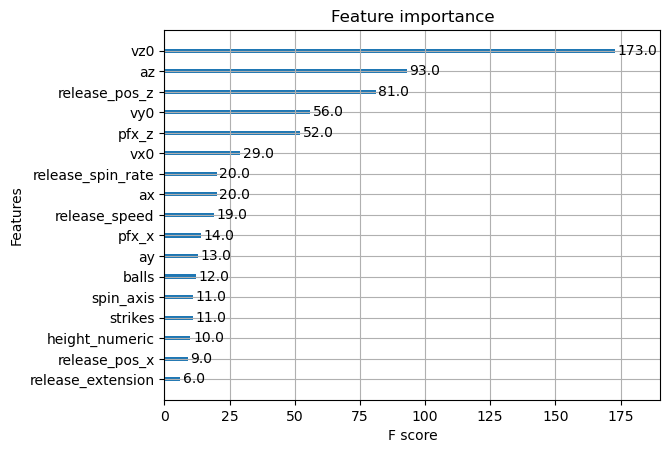

In [30]:
xgb.plot_importance(model)
plt.show()

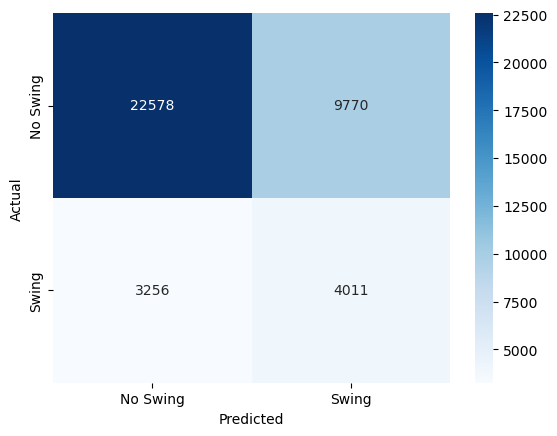

In [31]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Swing', 'Swing'], yticklabels=['No Swing', 'Swing'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [50]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid)
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [51]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

[I 2023-11-09 15:02:36,000] A new study created in memory with name: no-name-ba069799-24a6-4c5a-8992-b1bb92706780


[0]	eval-logloss:0.68945
[1]	eval-logloss:0.68612
[2]	eval-logloss:0.68280
[3]	eval-logloss:0.67973
[4]	eval-logloss:0.67694
[5]	eval-logloss:0.67437
[6]	eval-logloss:0.67191
[7]	eval-logloss:0.66937
[8]	eval-logloss:0.66693
[9]	eval-logloss:0.66486
[10]	eval-logloss:0.66298
[11]	eval-logloss:0.66108
[12]	eval-logloss:0.65934
[13]	eval-logloss:0.65779
[14]	eval-logloss:0.65623
[15]	eval-logloss:0.65469
[16]	eval-logloss:0.65344
[17]	eval-logloss:0.65204
[18]	eval-logloss:0.65051
[19]	eval-logloss:0.64936
[20]	eval-logloss:0.64820
[21]	eval-logloss:0.64721
[22]	eval-logloss:0.64631
[23]	eval-logloss:0.64522
[24]	eval-logloss:0.64407
[25]	eval-logloss:0.64334
[26]	eval-logloss:0.64252
[27]	eval-logloss:0.64173
[28]	eval-logloss:0.64066
[29]	eval-logloss:0.63997
[30]	eval-logloss:0.63942
[31]	eval-logloss:0.63872
[32]	eval-logloss:0.63795
[33]	eval-logloss:0.63721
[34]	eval-logloss:0.63642
[35]	eval-logloss:0.63581
[36]	eval-logloss:0.63516
[37]	eval-logloss:0.63450
[38]	eval-logloss:0.63

[I 2023-11-09 15:02:42,534] Trial 0 finished with value: 0.6148468552902295 and parameters: {'max_depth': 7, 'eta': 0.044113424973198735, 'subsample': 0.7693472949207835, 'colsample_bytree': 0.9621120302735207}. Best is trial 0 with value: 0.6148468552902295.


[0]	eval-logloss:0.68272
[1]	eval-logloss:0.67568
[2]	eval-logloss:0.66046
[3]	eval-logloss:0.64416
[4]	eval-logloss:0.64111
[5]	eval-logloss:0.63214
[6]	eval-logloss:0.62683
[7]	eval-logloss:0.62495
[8]	eval-logloss:0.62331
[9]	eval-logloss:0.62271
[10]	eval-logloss:0.61895
[11]	eval-logloss:0.61648
[12]	eval-logloss:0.61311
[13]	eval-logloss:0.61379
[14]	eval-logloss:0.61086
[15]	eval-logloss:0.60872
[16]	eval-logloss:0.60758
[17]	eval-logloss:0.60505
[18]	eval-logloss:0.60366
[19]	eval-logloss:0.60344
[20]	eval-logloss:0.60216
[21]	eval-logloss:0.60231
[22]	eval-logloss:0.60088
[23]	eval-logloss:0.60089
[24]	eval-logloss:0.59921
[25]	eval-logloss:0.59992
[26]	eval-logloss:0.59942
[27]	eval-logloss:0.59833
[28]	eval-logloss:0.59775
[29]	eval-logloss:0.59783
[30]	eval-logloss:0.59692
[31]	eval-logloss:0.59552
[32]	eval-logloss:0.59526
[33]	eval-logloss:0.59479
[34]	eval-logloss:0.59393
[35]	eval-logloss:0.59398
[36]	eval-logloss:0.59308
[37]	eval-logloss:0.59203
[38]	eval-logloss:0.59

[I 2023-11-09 15:02:51,461] Trial 1 finished with value: 0.5667649686671685 and parameters: {'max_depth': 9, 'eta': 0.28197088557030886, 'subsample': 0.6569405703679916, 'colsample_bytree': 0.5090248511814697}. Best is trial 0 with value: 0.6148468552902295.


[0]	eval-logloss:0.68904
[1]	eval-logloss:0.68600
[2]	eval-logloss:0.67814
[3]	eval-logloss:0.66816
[4]	eval-logloss:0.66589
[5]	eval-logloss:0.65862
[6]	eval-logloss:0.65445
[7]	eval-logloss:0.65313
[8]	eval-logloss:0.65207
[9]	eval-logloss:0.65142
[10]	eval-logloss:0.64737
[11]	eval-logloss:0.64378
[12]	eval-logloss:0.64145
[13]	eval-logloss:0.64081
[14]	eval-logloss:0.63852
[15]	eval-logloss:0.63802
[16]	eval-logloss:0.63703
[17]	eval-logloss:0.63412
[18]	eval-logloss:0.63195
[19]	eval-logloss:0.63063
[20]	eval-logloss:0.63015
[21]	eval-logloss:0.63001
[22]	eval-logloss:0.62901
[23]	eval-logloss:0.62840
[24]	eval-logloss:0.62760
[25]	eval-logloss:0.62772
[26]	eval-logloss:0.62662
[27]	eval-logloss:0.62560
[28]	eval-logloss:0.62510
[29]	eval-logloss:0.62486
[30]	eval-logloss:0.62436
[31]	eval-logloss:0.62376
[32]	eval-logloss:0.62327
[33]	eval-logloss:0.62304
[34]	eval-logloss:0.62218
[35]	eval-logloss:0.62126
[36]	eval-logloss:0.62118
[37]	eval-logloss:0.62071
[38]	eval-logloss:0.62

[I 2023-11-09 15:02:57,558] Trial 2 finished with value: 0.6048001216977722 and parameters: {'max_depth': 6, 'eta': 0.18702663713524667, 'subsample': 0.8597663613625035, 'colsample_bytree': 0.5474551395761518}. Best is trial 0 with value: 0.6148468552902295.


[0]	eval-logloss:0.68152
[1]	eval-logloss:0.67477
[2]	eval-logloss:0.66688
[3]	eval-logloss:0.66279
[4]	eval-logloss:0.65975
[5]	eval-logloss:0.65755
[6]	eval-logloss:0.65581
[7]	eval-logloss:0.65411
[8]	eval-logloss:0.65158
[9]	eval-logloss:0.65054
[10]	eval-logloss:0.65001
[11]	eval-logloss:0.64776
[12]	eval-logloss:0.64662
[13]	eval-logloss:0.64574
[14]	eval-logloss:0.64431
[15]	eval-logloss:0.64375
[16]	eval-logloss:0.64326
[17]	eval-logloss:0.64225
[18]	eval-logloss:0.64095
[19]	eval-logloss:0.64026
[20]	eval-logloss:0.63987
[21]	eval-logloss:0.63986
[22]	eval-logloss:0.63932
[23]	eval-logloss:0.63848
[24]	eval-logloss:0.63783
[25]	eval-logloss:0.63788
[26]	eval-logloss:0.63734
[27]	eval-logloss:0.63645
[28]	eval-logloss:0.63587
[29]	eval-logloss:0.63547
[30]	eval-logloss:0.63477
[31]	eval-logloss:0.63436
[32]	eval-logloss:0.63393
[33]	eval-logloss:0.63331
[34]	eval-logloss:0.63311
[35]	eval-logloss:0.63280
[36]	eval-logloss:0.63283
[37]	eval-logloss:0.63160
[38]	eval-logloss:0.63

[I 2023-11-09 15:03:02,212] Trial 3 finished with value: 0.6196165027495664 and parameters: {'max_depth': 4, 'eta': 0.22831831257706506, 'subsample': 0.8500792847493004, 'colsample_bytree': 0.7258732452617338}. Best is trial 3 with value: 0.6196165027495664.


[0]	eval-logloss:0.67789
[1]	eval-logloss:0.66620
[2]	eval-logloss:0.65702
[3]	eval-logloss:0.64955
[4]	eval-logloss:0.64377
[5]	eval-logloss:0.63931
[6]	eval-logloss:0.63612
[7]	eval-logloss:0.63217
[8]	eval-logloss:0.62963
[9]	eval-logloss:0.62747
[10]	eval-logloss:0.62514
[11]	eval-logloss:0.62356
[12]	eval-logloss:0.62168
[13]	eval-logloss:0.62040
[14]	eval-logloss:0.61869
[15]	eval-logloss:0.61745
[16]	eval-logloss:0.61636
[17]	eval-logloss:0.61545
[18]	eval-logloss:0.61450
[19]	eval-logloss:0.61400
[20]	eval-logloss:0.61321
[21]	eval-logloss:0.61288
[22]	eval-logloss:0.61219
[23]	eval-logloss:0.61165
[24]	eval-logloss:0.61040
[25]	eval-logloss:0.60988
[26]	eval-logloss:0.60862
[27]	eval-logloss:0.60833
[28]	eval-logloss:0.60693
[29]	eval-logloss:0.60676
[30]	eval-logloss:0.60592
[31]	eval-logloss:0.60538
[32]	eval-logloss:0.60441
[33]	eval-logloss:0.60393
[34]	eval-logloss:0.60333
[35]	eval-logloss:0.60235
[36]	eval-logloss:0.60193
[37]	eval-logloss:0.60119
[38]	eval-logloss:0.60

[I 2023-11-09 15:03:08,457] Trial 4 finished with value: 0.5765779605247896 and parameters: {'max_depth': 8, 'eta': 0.1735969678221471, 'subsample': 0.8201066022976495, 'colsample_bytree': 0.9365636654967211}. Best is trial 3 with value: 0.6196165027495664.


[0]	eval-logloss:0.68613
[1]	eval-logloss:0.68181
[2]	eval-logloss:0.67843
[3]	eval-logloss:0.67456
[4]	eval-logloss:0.67149
[5]	eval-logloss:0.66872
[6]	eval-logloss:0.66730
[7]	eval-logloss:0.66437
[8]	eval-logloss:0.66317
[9]	eval-logloss:0.66226
[10]	eval-logloss:0.66142
[11]	eval-logloss:0.66020
[12]	eval-logloss:0.65932
[13]	eval-logloss:0.65829
[14]	eval-logloss:0.65721
[15]	eval-logloss:0.65541
[16]	eval-logloss:0.65496
[17]	eval-logloss:0.65416
[18]	eval-logloss:0.65264
[19]	eval-logloss:0.65210
[20]	eval-logloss:0.65130
[21]	eval-logloss:0.65061
[22]	eval-logloss:0.65005
[23]	eval-logloss:0.64929
[24]	eval-logloss:0.64829
[25]	eval-logloss:0.64812
[26]	eval-logloss:0.64738
[27]	eval-logloss:0.64708
[28]	eval-logloss:0.64675
[29]	eval-logloss:0.64665
[30]	eval-logloss:0.64597
[31]	eval-logloss:0.64566
[32]	eval-logloss:0.64495
[33]	eval-logloss:0.64443
[34]	eval-logloss:0.64453
[35]	eval-logloss:0.64472
[36]	eval-logloss:0.64433
[37]	eval-logloss:0.64398
[38]	eval-logloss:0.64

[I 2023-11-09 15:03:12,009] Trial 5 finished with value: 0.6304036263100724 and parameters: {'max_depth': 3, 'eta': 0.168623476905964, 'subsample': 0.7146021113296476, 'colsample_bytree': 0.9724806039481033}. Best is trial 5 with value: 0.6304036263100724.


[0]	eval-logloss:0.68402
[1]	eval-logloss:0.67749
[2]	eval-logloss:0.67030
[3]	eval-logloss:0.66637
[4]	eval-logloss:0.66253
[5]	eval-logloss:0.66035
[6]	eval-logloss:0.65798
[7]	eval-logloss:0.65598
[8]	eval-logloss:0.65408
[9]	eval-logloss:0.65291
[10]	eval-logloss:0.65247
[11]	eval-logloss:0.65182
[12]	eval-logloss:0.65083
[13]	eval-logloss:0.65008
[14]	eval-logloss:0.64879
[15]	eval-logloss:0.64755
[16]	eval-logloss:0.64754
[17]	eval-logloss:0.64563
[18]	eval-logloss:0.64403
[19]	eval-logloss:0.64370
[20]	eval-logloss:0.64307
[21]	eval-logloss:0.64344
[22]	eval-logloss:0.64147
[23]	eval-logloss:0.64073
[24]	eval-logloss:0.63908
[25]	eval-logloss:0.63956
[26]	eval-logloss:0.63907
[27]	eval-logloss:0.63864
[28]	eval-logloss:0.63837
[29]	eval-logloss:0.63857
[30]	eval-logloss:0.63786
[31]	eval-logloss:0.63684
[32]	eval-logloss:0.63668
[33]	eval-logloss:0.63594
[34]	eval-logloss:0.63576
[35]	eval-logloss:0.63570
[36]	eval-logloss:0.63545
[37]	eval-logloss:0.63504
[38]	eval-logloss:0.63

[I 2023-11-09 15:03:16,472] Trial 6 finished with value: 0.6226886147558169 and parameters: {'max_depth': 4, 'eta': 0.19125483606893373, 'subsample': 0.6595577742800351, 'colsample_bytree': 0.7539638744297388}. Best is trial 5 with value: 0.6304036263100724.


[0]	eval-logloss:0.68424
[1]	eval-logloss:0.67840
[2]	eval-logloss:0.67214
[3]	eval-logloss:0.66811
[4]	eval-logloss:0.66537
[5]	eval-logloss:0.66287
[6]	eval-logloss:0.66100
[7]	eval-logloss:0.65929
[8]	eval-logloss:0.65693
[9]	eval-logloss:0.65573
[10]	eval-logloss:0.65491
[11]	eval-logloss:0.65373
[12]	eval-logloss:0.65264
[13]	eval-logloss:0.65195
[14]	eval-logloss:0.65067
[15]	eval-logloss:0.65007
[16]	eval-logloss:0.64964
[17]	eval-logloss:0.64785
[18]	eval-logloss:0.64661
[19]	eval-logloss:0.64635
[20]	eval-logloss:0.64585
[21]	eval-logloss:0.64584
[22]	eval-logloss:0.64476
[23]	eval-logloss:0.64386
[24]	eval-logloss:0.64312
[25]	eval-logloss:0.64307
[26]	eval-logloss:0.64233
[27]	eval-logloss:0.64192
[28]	eval-logloss:0.64156
[29]	eval-logloss:0.64113
[30]	eval-logloss:0.64063
[31]	eval-logloss:0.63981
[32]	eval-logloss:0.63923
[33]	eval-logloss:0.63847
[34]	eval-logloss:0.63826
[35]	eval-logloss:0.63805
[36]	eval-logloss:0.63803
[37]	eval-logloss:0.63752
[38]	eval-logloss:0.63

[I 2023-11-09 15:03:20,603] Trial 7 finished with value: 0.6240422060556807 and parameters: {'max_depth': 4, 'eta': 0.16945059107529944, 'subsample': 0.8400367438064051, 'colsample_bytree': 0.7459344727532891}. Best is trial 5 with value: 0.6304036263100724.


[0]	eval-logloss:0.68715
[1]	eval-logloss:0.68213
[2]	eval-logloss:0.67719
[3]	eval-logloss:0.67265
[4]	eval-logloss:0.66849
[5]	eval-logloss:0.66471
[6]	eval-logloss:0.66150
[7]	eval-logloss:0.65819
[8]	eval-logloss:0.65540
[9]	eval-logloss:0.65254
[10]	eval-logloss:0.65017
[11]	eval-logloss:0.64780
[12]	eval-logloss:0.64566
[13]	eval-logloss:0.64365
[14]	eval-logloss:0.64161
[15]	eval-logloss:0.63940
[16]	eval-logloss:0.63793
[17]	eval-logloss:0.63610
[18]	eval-logloss:0.63427
[19]	eval-logloss:0.63298
[20]	eval-logloss:0.63172
[21]	eval-logloss:0.63098
[22]	eval-logloss:0.62937
[23]	eval-logloss:0.62849
[24]	eval-logloss:0.62742
[25]	eval-logloss:0.62667
[26]	eval-logloss:0.62572
[27]	eval-logloss:0.62481
[28]	eval-logloss:0.62395
[29]	eval-logloss:0.62324
[30]	eval-logloss:0.62231
[31]	eval-logloss:0.62171
[32]	eval-logloss:0.62084
[33]	eval-logloss:0.61985
[34]	eval-logloss:0.61918
[35]	eval-logloss:0.61847
[36]	eval-logloss:0.61783
[37]	eval-logloss:0.61745
[38]	eval-logloss:0.61

[I 2023-11-09 15:03:27,323] Trial 8 finished with value: 0.596713396992682 and parameters: {'max_depth': 8, 'eta': 0.06033394862750609, 'subsample': 0.6476834184866329, 'colsample_bytree': 0.9230623025010245}. Best is trial 5 with value: 0.6304036263100724.


[0]	eval-logloss:0.69094
[1]	eval-logloss:0.68927
[2]	eval-logloss:0.68565
[3]	eval-logloss:0.68000
[4]	eval-logloss:0.67866
[5]	eval-logloss:0.67366
[6]	eval-logloss:0.66949
[7]	eval-logloss:0.66849
[8]	eval-logloss:0.66783
[9]	eval-logloss:0.66730
[10]	eval-logloss:0.66422
[11]	eval-logloss:0.66101
[12]	eval-logloss:0.65833
[13]	eval-logloss:0.65789
[14]	eval-logloss:0.65616
[15]	eval-logloss:0.65573
[16]	eval-logloss:0.65487
[17]	eval-logloss:0.65263
[18]	eval-logloss:0.65092
[19]	eval-logloss:0.64954
[20]	eval-logloss:0.64916
[21]	eval-logloss:0.64907
[22]	eval-logloss:0.64780
[23]	eval-logloss:0.64746
[24]	eval-logloss:0.64629
[25]	eval-logloss:0.64623
[26]	eval-logloss:0.64479
[27]	eval-logloss:0.64382
[28]	eval-logloss:0.64331
[29]	eval-logloss:0.64319
[30]	eval-logloss:0.64274
[31]	eval-logloss:0.64245
[32]	eval-logloss:0.64136
[33]	eval-logloss:0.64099
[34]	eval-logloss:0.64047
[35]	eval-logloss:0.64017
[36]	eval-logloss:0.64024
[37]	eval-logloss:0.63999
[38]	eval-logloss:0.63

[I 2023-11-09 15:03:31,403] Trial 9 finished with value: 0.6268930549740256 and parameters: {'max_depth': 4, 'eta': 0.13582132607436045, 'subsample': 0.820924976736921, 'colsample_bytree': 0.5335592086754757}. Best is trial 5 with value: 0.6304036263100724.


[0]	eval-logloss:0.68889
[1]	eval-logloss:0.68627
[2]	eval-logloss:0.68363
[3]	eval-logloss:0.68041
[4]	eval-logloss:0.67799
[5]	eval-logloss:0.67595
[6]	eval-logloss:0.67457
[7]	eval-logloss:0.67301
[8]	eval-logloss:0.67140
[9]	eval-logloss:0.66974
[10]	eval-logloss:0.66903
[11]	eval-logloss:0.66735
[12]	eval-logloss:0.66621
[13]	eval-logloss:0.66558
[14]	eval-logloss:0.66420
[15]	eval-logloss:0.66321
[16]	eval-logloss:0.66248
[17]	eval-logloss:0.66162
[18]	eval-logloss:0.66031
[19]	eval-logloss:0.65987
[20]	eval-logloss:0.65926
[21]	eval-logloss:0.65916
[22]	eval-logloss:0.65816
[23]	eval-logloss:0.65777
[24]	eval-logloss:0.65653
[25]	eval-logloss:0.65632
[26]	eval-logloss:0.65595
[27]	eval-logloss:0.65531
[28]	eval-logloss:0.65479
[29]	eval-logloss:0.65459
[30]	eval-logloss:0.65400
[31]	eval-logloss:0.65374
[32]	eval-logloss:0.65341
[33]	eval-logloss:0.65308
[34]	eval-logloss:0.65296
[35]	eval-logloss:0.65259
[36]	eval-logloss:0.65231
[37]	eval-logloss:0.65197
[38]	eval-logloss:0.65

[I 2023-11-09 15:03:36,180] Trial 10 finished with value: 0.6380864521351086 and parameters: {'max_depth': 3, 'eta': 0.09875508399146637, 'subsample': 0.7161460512267773, 'colsample_bytree': 0.9832240729921511}. Best is trial 10 with value: 0.6380864521351086.


[0]	eval-logloss:0.68854
[1]	eval-logloss:0.68573
[2]	eval-logloss:0.68292
[3]	eval-logloss:0.68038
[4]	eval-logloss:0.67786
[5]	eval-logloss:0.67585
[6]	eval-logloss:0.67458
[7]	eval-logloss:0.67207
[8]	eval-logloss:0.67040
[9]	eval-logloss:0.66926
[10]	eval-logloss:0.66818
[11]	eval-logloss:0.66667
[12]	eval-logloss:0.66562
[13]	eval-logloss:0.66497
[14]	eval-logloss:0.66401
[15]	eval-logloss:0.66288
[16]	eval-logloss:0.66260
[17]	eval-logloss:0.66181
[18]	eval-logloss:0.66041
[19]	eval-logloss:0.65973
[20]	eval-logloss:0.65908
[21]	eval-logloss:0.65897
[22]	eval-logloss:0.65828
[23]	eval-logloss:0.65804
[24]	eval-logloss:0.65688
[25]	eval-logloss:0.65667
[26]	eval-logloss:0.65618
[27]	eval-logloss:0.65552
[28]	eval-logloss:0.65496
[29]	eval-logloss:0.65475
[30]	eval-logloss:0.65419
[31]	eval-logloss:0.65320
[32]	eval-logloss:0.65270
[33]	eval-logloss:0.65214
[34]	eval-logloss:0.65204
[35]	eval-logloss:0.65182
[36]	eval-logloss:0.65159
[37]	eval-logloss:0.65131
[38]	eval-logloss:0.65

[I 2023-11-09 15:03:40,606] Trial 11 finished with value: 0.6362660825374414 and parameters: {'max_depth': 3, 'eta': 0.10754481242320987, 'subsample': 0.7134617650386071, 'colsample_bytree': 0.9913396728096758}. Best is trial 10 with value: 0.6380864521351086.


[0]	eval-logloss:0.68886
[1]	eval-logloss:0.68612
[2]	eval-logloss:0.68346
[3]	eval-logloss:0.68055
[4]	eval-logloss:0.67830
[5]	eval-logloss:0.67613
[6]	eval-logloss:0.67434
[7]	eval-logloss:0.67251
[8]	eval-logloss:0.67110
[9]	eval-logloss:0.66945
[10]	eval-logloss:0.66865
[11]	eval-logloss:0.66769
[12]	eval-logloss:0.66654
[13]	eval-logloss:0.66600
[14]	eval-logloss:0.66489
[15]	eval-logloss:0.66415
[16]	eval-logloss:0.66348
[17]	eval-logloss:0.66252
[18]	eval-logloss:0.66127
[19]	eval-logloss:0.66050
[20]	eval-logloss:0.65999
[21]	eval-logloss:0.65987
[22]	eval-logloss:0.65935
[23]	eval-logloss:0.65876
[24]	eval-logloss:0.65794
[25]	eval-logloss:0.65782
[26]	eval-logloss:0.65714
[27]	eval-logloss:0.65667
[28]	eval-logloss:0.65641
[29]	eval-logloss:0.65622
[30]	eval-logloss:0.65570
[31]	eval-logloss:0.65521
[32]	eval-logloss:0.65482
[33]	eval-logloss:0.65455
[34]	eval-logloss:0.65434
[35]	eval-logloss:0.65413
[36]	eval-logloss:0.65394
[37]	eval-logloss:0.65364
[38]	eval-logloss:0.65

[I 2023-11-09 15:03:45,013] Trial 12 finished with value: 0.639198871470118 and parameters: {'max_depth': 3, 'eta': 0.10010925145382091, 'subsample': 0.72584265990679, 'colsample_bytree': 0.8702842914242799}. Best is trial 12 with value: 0.639198871470118.


[0]	eval-logloss:0.69237
[1]	eval-logloss:0.69162
[2]	eval-logloss:0.69085
[3]	eval-logloss:0.69015
[4]	eval-logloss:0.68943
[5]	eval-logloss:0.68871
[6]	eval-logloss:0.68804
[7]	eval-logloss:0.68732
[8]	eval-logloss:0.68659
[9]	eval-logloss:0.68591
[10]	eval-logloss:0.68527
[11]	eval-logloss:0.68462
[12]	eval-logloss:0.68397
[13]	eval-logloss:0.68337
[14]	eval-logloss:0.68270
[15]	eval-logloss:0.68244
[16]	eval-logloss:0.68192
[17]	eval-logloss:0.68131
[18]	eval-logloss:0.68064
[19]	eval-logloss:0.68011
[20]	eval-logloss:0.67956
[21]	eval-logloss:0.67937
[22]	eval-logloss:0.67881
[23]	eval-logloss:0.67824
[24]	eval-logloss:0.67768
[25]	eval-logloss:0.67750
[26]	eval-logloss:0.67702
[27]	eval-logloss:0.67656
[28]	eval-logloss:0.67637
[29]	eval-logloss:0.67581
[30]	eval-logloss:0.67525
[31]	eval-logloss:0.67475
[32]	eval-logloss:0.67420
[33]	eval-logloss:0.67372
[34]	eval-logloss:0.67320
[35]	eval-logloss:0.67275
[36]	eval-logloss:0.67236
[37]	eval-logloss:0.67193
[38]	eval-logloss:0.67

[I 2023-11-09 15:03:49,918] Trial 13 finished with value: 0.654710235838355 and parameters: {'max_depth': 5, 'eta': 0.012095294767310638, 'subsample': 0.7606689348384259, 'colsample_bytree': 0.8466876185085532}. Best is trial 13 with value: 0.654710235838355.


[0]	eval-logloss:0.69116
[1]	eval-logloss:0.68919
[2]	eval-logloss:0.68730
[3]	eval-logloss:0.68556
[4]	eval-logloss:0.68387
[5]	eval-logloss:0.68228
[6]	eval-logloss:0.68062
[7]	eval-logloss:0.67903
[8]	eval-logloss:0.67743
[9]	eval-logloss:0.67594
[10]	eval-logloss:0.67460
[11]	eval-logloss:0.67324
[12]	eval-logloss:0.67195
[13]	eval-logloss:0.67066
[14]	eval-logloss:0.66937
[15]	eval-logloss:0.66887
[16]	eval-logloss:0.66783
[17]	eval-logloss:0.66661
[18]	eval-logloss:0.66537
[19]	eval-logloss:0.66441
[20]	eval-logloss:0.66336
[21]	eval-logloss:0.66300
[22]	eval-logloss:0.66197
[23]	eval-logloss:0.66101
[24]	eval-logloss:0.65994
[25]	eval-logloss:0.65959
[26]	eval-logloss:0.65883
[27]	eval-logloss:0.65809
[28]	eval-logloss:0.65772
[29]	eval-logloss:0.65684
[30]	eval-logloss:0.65607
[31]	eval-logloss:0.65529
[32]	eval-logloss:0.65443
[33]	eval-logloss:0.65373
[34]	eval-logloss:0.65303
[35]	eval-logloss:0.65241
[36]	eval-logloss:0.65190
[37]	eval-logloss:0.65131
[38]	eval-logloss:0.65

[I 2023-11-09 15:03:54,993] Trial 14 finished with value: 0.6316529435663346 and parameters: {'max_depth': 6, 'eta': 0.027538881934668545, 'subsample': 0.7617041771545063, 'colsample_bytree': 0.8556692962558234}. Best is trial 13 with value: 0.654710235838355.


[0]	eval-logloss:0.69194
[1]	eval-logloss:0.69076
[2]	eval-logloss:0.68951
[3]	eval-logloss:0.68837
[4]	eval-logloss:0.68712
[5]	eval-logloss:0.68592
[6]	eval-logloss:0.68489
[7]	eval-logloss:0.68375
[8]	eval-logloss:0.68280
[9]	eval-logloss:0.68168
[10]	eval-logloss:0.68075
[11]	eval-logloss:0.67984
[12]	eval-logloss:0.67887
[13]	eval-logloss:0.67795
[14]	eval-logloss:0.67698
[15]	eval-logloss:0.67661
[16]	eval-logloss:0.67590
[17]	eval-logloss:0.67499
[18]	eval-logloss:0.67406
[19]	eval-logloss:0.67329
[20]	eval-logloss:0.67254
[21]	eval-logloss:0.67233
[22]	eval-logloss:0.67140
[23]	eval-logloss:0.67063
[24]	eval-logloss:0.66988
[25]	eval-logloss:0.66966
[26]	eval-logloss:0.66894
[27]	eval-logloss:0.66832
[28]	eval-logloss:0.66808
[29]	eval-logloss:0.66737
[30]	eval-logloss:0.66668
[31]	eval-logloss:0.66599
[32]	eval-logloss:0.66531
[33]	eval-logloss:0.66470
[34]	eval-logloss:0.66407
[35]	eval-logloss:0.66360
[36]	eval-logloss:0.66317
[37]	eval-logloss:0.66265
[38]	eval-logloss:0.66

[I 2023-11-09 15:03:59,854] Trial 15 finished with value: 0.6441451275332164 and parameters: {'max_depth': 5, 'eta': 0.019856025562388885, 'subsample': 0.608814252669293, 'colsample_bytree': 0.8570940761901056}. Best is trial 13 with value: 0.654710235838355.


[0]	eval-logloss:0.69219
[1]	eval-logloss:0.69128
[2]	eval-logloss:0.69024
[3]	eval-logloss:0.68934
[4]	eval-logloss:0.68840
[5]	eval-logloss:0.68744
[6]	eval-logloss:0.68662
[7]	eval-logloss:0.68572
[8]	eval-logloss:0.68494
[9]	eval-logloss:0.68403
[10]	eval-logloss:0.68330
[11]	eval-logloss:0.68255
[12]	eval-logloss:0.68177
[13]	eval-logloss:0.68099
[14]	eval-logloss:0.68021
[15]	eval-logloss:0.67989
[16]	eval-logloss:0.67927
[17]	eval-logloss:0.67851
[18]	eval-logloss:0.67772
[19]	eval-logloss:0.67706
[20]	eval-logloss:0.67629
[21]	eval-logloss:0.67611
[22]	eval-logloss:0.67533
[23]	eval-logloss:0.67467
[24]	eval-logloss:0.67404
[25]	eval-logloss:0.67384
[26]	eval-logloss:0.67326
[27]	eval-logloss:0.67272
[28]	eval-logloss:0.67251
[29]	eval-logloss:0.67193
[30]	eval-logloss:0.67170
[31]	eval-logloss:0.67112
[32]	eval-logloss:0.67050
[33]	eval-logloss:0.66994
[34]	eval-logloss:0.66938
[35]	eval-logloss:0.66897
[36]	eval-logloss:0.66882
[37]	eval-logloss:0.66834
[38]	eval-logloss:0.66

[I 2023-11-09 15:04:05,085] Trial 16 finished with value: 0.6498031203078523 and parameters: {'max_depth': 5, 'eta': 0.015228286821481129, 'subsample': 0.6069648996963821, 'colsample_bytree': 0.8108797914189894}. Best is trial 13 with value: 0.654710235838355.


[0]	eval-logloss:0.69212
[1]	eval-logloss:0.69121
[2]	eval-logloss:0.69026
[3]	eval-logloss:0.68942
[4]	eval-logloss:0.68862
[5]	eval-logloss:0.68786
[6]	eval-logloss:0.68708
[7]	eval-logloss:0.68619
[8]	eval-logloss:0.68536
[9]	eval-logloss:0.68461
[10]	eval-logloss:0.68393
[11]	eval-logloss:0.68320
[12]	eval-logloss:0.68245
[13]	eval-logloss:0.68168
[14]	eval-logloss:0.68092
[15]	eval-logloss:0.68065
[16]	eval-logloss:0.68003
[17]	eval-logloss:0.67935
[18]	eval-logloss:0.67858
[19]	eval-logloss:0.67799
[20]	eval-logloss:0.67735
[21]	eval-logloss:0.67714
[22]	eval-logloss:0.67651
[23]	eval-logloss:0.67583
[24]	eval-logloss:0.67521
[25]	eval-logloss:0.67501
[26]	eval-logloss:0.67449
[27]	eval-logloss:0.67393
[28]	eval-logloss:0.67369
[29]	eval-logloss:0.67311
[30]	eval-logloss:0.67291
[31]	eval-logloss:0.67234
[32]	eval-logloss:0.67174
[33]	eval-logloss:0.67115
[34]	eval-logloss:0.67056
[35]	eval-logloss:0.67012
[36]	eval-logloss:0.66997
[37]	eval-logloss:0.66942
[38]	eval-logloss:0.66

[I 2023-11-09 15:04:09,762] Trial 17 finished with value: 0.6514482642359841 and parameters: {'max_depth': 5, 'eta': 0.014541589271853922, 'subsample': 0.7884867046948087, 'colsample_bytree': 0.8029971871663186}. Best is trial 13 with value: 0.654710235838355.


[0]	eval-logloss:0.69188
[1]	eval-logloss:0.68797
[2]	eval-logloss:0.68396
[3]	eval-logloss:0.68104
[4]	eval-logloss:0.67992
[5]	eval-logloss:0.67666
[6]	eval-logloss:0.67410
[7]	eval-logloss:0.67327
[8]	eval-logloss:0.67083
[9]	eval-logloss:0.66837
[10]	eval-logloss:0.66642
[11]	eval-logloss:0.66464
[12]	eval-logloss:0.66295
[13]	eval-logloss:0.66107
[14]	eval-logloss:0.65964
[15]	eval-logloss:0.65904
[16]	eval-logloss:0.65813
[17]	eval-logloss:0.65647
[18]	eval-logloss:0.65507
[19]	eval-logloss:0.65387
[20]	eval-logloss:0.65341
[21]	eval-logloss:0.65297
[22]	eval-logloss:0.65174
[23]	eval-logloss:0.65140
[24]	eval-logloss:0.65058
[25]	eval-logloss:0.65034
[26]	eval-logloss:0.64924
[27]	eval-logloss:0.64843
[28]	eval-logloss:0.64809
[29]	eval-logloss:0.64780
[30]	eval-logloss:0.64753
[31]	eval-logloss:0.64661
[32]	eval-logloss:0.64601
[33]	eval-logloss:0.64499
[34]	eval-logloss:0.64422
[35]	eval-logloss:0.64385
[36]	eval-logloss:0.64363
[37]	eval-logloss:0.64333
[38]	eval-logloss:0.64

[I 2023-11-09 15:04:14,466] Trial 18 finished with value: 0.6269855659242505 and parameters: {'max_depth': 5, 'eta': 0.06381968012146058, 'subsample': 0.895581860517694, 'colsample_bytree': 0.6758264958991582}. Best is trial 13 with value: 0.654710235838355.


[0]	eval-logloss:0.68767
[1]	eval-logloss:0.68303
[2]	eval-logloss:0.67846
[3]	eval-logloss:0.67457
[4]	eval-logloss:0.67111
[5]	eval-logloss:0.66797
[6]	eval-logloss:0.66498
[7]	eval-logloss:0.66210
[8]	eval-logloss:0.65950
[9]	eval-logloss:0.65707
[10]	eval-logloss:0.65498
[11]	eval-logloss:0.65317
[12]	eval-logloss:0.65138
[13]	eval-logloss:0.64954
[14]	eval-logloss:0.64781
[15]	eval-logloss:0.64694
[16]	eval-logloss:0.64556
[17]	eval-logloss:0.64398
[18]	eval-logloss:0.64234
[19]	eval-logloss:0.64124
[20]	eval-logloss:0.64007
[21]	eval-logloss:0.63950
[22]	eval-logloss:0.63846
[23]	eval-logloss:0.63727
[24]	eval-logloss:0.63639
[25]	eval-logloss:0.63591
[26]	eval-logloss:0.63502
[27]	eval-logloss:0.63420
[28]	eval-logloss:0.63365
[29]	eval-logloss:0.63303
[30]	eval-logloss:0.63257
[31]	eval-logloss:0.63186
[32]	eval-logloss:0.63098
[33]	eval-logloss:0.63018
[34]	eval-logloss:0.62956
[35]	eval-logloss:0.62880
[36]	eval-logloss:0.62850
[37]	eval-logloss:0.62791
[38]	eval-logloss:0.62

[I 2023-11-09 15:04:20,096] Trial 19 finished with value: 0.6090817670609263 and parameters: {'max_depth': 7, 'eta': 0.0632093480295586, 'subsample': 0.7890369827574314, 'colsample_bytree': 0.8084907475611285}. Best is trial 13 with value: 0.654710235838355.


[0]	eval-logloss:0.69235
[1]	eval-logloss:0.69158
[2]	eval-logloss:0.69077
[3]	eval-logloss:0.69002
[4]	eval-logloss:0.68922
[5]	eval-logloss:0.68845
[6]	eval-logloss:0.68769
[7]	eval-logloss:0.68692
[8]	eval-logloss:0.68615
[9]	eval-logloss:0.68544
[10]	eval-logloss:0.68476
[11]	eval-logloss:0.68408
[12]	eval-logloss:0.68340
[13]	eval-logloss:0.68275
[14]	eval-logloss:0.68208
[15]	eval-logloss:0.68144
[16]	eval-logloss:0.68084
[17]	eval-logloss:0.68015
[18]	eval-logloss:0.67947
[19]	eval-logloss:0.67889
[20]	eval-logloss:0.67829
[21]	eval-logloss:0.67772
[22]	eval-logloss:0.67711
[23]	eval-logloss:0.67654
[24]	eval-logloss:0.67597
[25]	eval-logloss:0.67548
[26]	eval-logloss:0.67492
[27]	eval-logloss:0.67440
[28]	eval-logloss:0.67384
[29]	eval-logloss:0.67333
[30]	eval-logloss:0.67279
[31]	eval-logloss:0.67226
[32]	eval-logloss:0.67171
[33]	eval-logloss:0.67124
[34]	eval-logloss:0.67074
[35]	eval-logloss:0.67027
[36]	eval-logloss:0.66981
[37]	eval-logloss:0.66931
[38]	eval-logloss:0.66

[I 2023-11-09 15:04:26,190] Trial 20 finished with value: 0.6507044171926581 and parameters: {'max_depth': 6, 'eta': 0.01092246285163535, 'subsample': 0.7977193323233044, 'colsample_bytree': 0.8957229268381053}. Best is trial 13 with value: 0.654710235838355.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69149
[2]	eval-logloss:0.69065
[3]	eval-logloss:0.68990
[4]	eval-logloss:0.68907
[5]	eval-logloss:0.68829
[6]	eval-logloss:0.68752
[7]	eval-logloss:0.68674
[8]	eval-logloss:0.68594
[9]	eval-logloss:0.68523
[10]	eval-logloss:0.68453
[11]	eval-logloss:0.68381
[12]	eval-logloss:0.68311
[13]	eval-logloss:0.68243
[14]	eval-logloss:0.68175
[15]	eval-logloss:0.68109
[16]	eval-logloss:0.68049
[17]	eval-logloss:0.67980
[18]	eval-logloss:0.67909
[19]	eval-logloss:0.67851
[20]	eval-logloss:0.67790
[21]	eval-logloss:0.67733
[22]	eval-logloss:0.67672
[23]	eval-logloss:0.67618
[24]	eval-logloss:0.67560
[25]	eval-logloss:0.67507
[26]	eval-logloss:0.67448
[27]	eval-logloss:0.67395
[28]	eval-logloss:0.67340
[29]	eval-logloss:0.67288
[30]	eval-logloss:0.67234
[31]	eval-logloss:0.67182
[32]	eval-logloss:0.67125
[33]	eval-logloss:0.67078
[34]	eval-logloss:0.67027
[35]	eval-logloss:0.66979
[36]	eval-logloss:0.66936
[37]	eval-logloss:0.66888
[38]	eval-logloss:0.66

[I 2023-11-09 15:04:31,418] Trial 21 finished with value: 0.6499910054845587 and parameters: {'max_depth': 6, 'eta': 0.011238223500857666, 'subsample': 0.789601564351685, 'colsample_bytree': 0.9154382673882393}. Best is trial 13 with value: 0.654710235838355.


[0]	eval-logloss:0.69038
[1]	eval-logloss:0.68799
[2]	eval-logloss:0.68526
[3]	eval-logloss:0.68306
[4]	eval-logloss:0.68088
[5]	eval-logloss:0.67899
[6]	eval-logloss:0.67717
[7]	eval-logloss:0.67534
[8]	eval-logloss:0.67360
[9]	eval-logloss:0.67179
[10]	eval-logloss:0.67016
[11]	eval-logloss:0.66873
[12]	eval-logloss:0.66733
[13]	eval-logloss:0.66598
[14]	eval-logloss:0.66459
[15]	eval-logloss:0.66400
[16]	eval-logloss:0.66320
[17]	eval-logloss:0.66192
[18]	eval-logloss:0.66063
[19]	eval-logloss:0.65976
[20]	eval-logloss:0.65878
[21]	eval-logloss:0.65843
[22]	eval-logloss:0.65767
[23]	eval-logloss:0.65668
[24]	eval-logloss:0.65566
[25]	eval-logloss:0.65542
[26]	eval-logloss:0.65473
[27]	eval-logloss:0.65399
[28]	eval-logloss:0.65364
[29]	eval-logloss:0.65291
[30]	eval-logloss:0.65231
[31]	eval-logloss:0.65184
[32]	eval-logloss:0.65109
[33]	eval-logloss:0.65056
[34]	eval-logloss:0.65001
[35]	eval-logloss:0.64963
[36]	eval-logloss:0.64919
[37]	eval-logloss:0.64865
[38]	eval-logloss:0.64

[I 2023-11-09 15:04:36,123] Trial 22 finished with value: 0.6320094557060847 and parameters: {'max_depth': 5, 'eta': 0.04346821195803129, 'subsample': 0.7436978369476899, 'colsample_bytree': 0.8880497133759115}. Best is trial 13 with value: 0.654710235838355.


[0]	eval-logloss:0.69027
[1]	eval-logloss:0.68749
[2]	eval-logloss:0.68484
[3]	eval-logloss:0.68243
[4]	eval-logloss:0.68010
[5]	eval-logloss:0.67794
[6]	eval-logloss:0.67588
[7]	eval-logloss:0.67376
[8]	eval-logloss:0.67162
[9]	eval-logloss:0.66980
[10]	eval-logloss:0.66834
[11]	eval-logloss:0.66675
[12]	eval-logloss:0.66523
[13]	eval-logloss:0.66377
[14]	eval-logloss:0.66224
[15]	eval-logloss:0.66161
[16]	eval-logloss:0.66046
[17]	eval-logloss:0.65915
[18]	eval-logloss:0.65776
[19]	eval-logloss:0.65674
[20]	eval-logloss:0.65572
[21]	eval-logloss:0.65527
[22]	eval-logloss:0.65439
[23]	eval-logloss:0.65328
[24]	eval-logloss:0.65231
[25]	eval-logloss:0.65189
[26]	eval-logloss:0.65105
[27]	eval-logloss:0.65019
[28]	eval-logloss:0.64978
[29]	eval-logloss:0.64908
[30]	eval-logloss:0.64823
[31]	eval-logloss:0.64756
[32]	eval-logloss:0.64664
[33]	eval-logloss:0.64596
[34]	eval-logloss:0.64515
[35]	eval-logloss:0.64452
[36]	eval-logloss:0.64412
[37]	eval-logloss:0.64355
[38]	eval-logloss:0.64

[I 2023-11-09 15:04:41,147] Trial 23 finished with value: 0.6251431561352332 and parameters: {'max_depth': 6, 'eta': 0.039791664495832886, 'subsample': 0.7915088034917362, 'colsample_bytree': 0.8357401168721216}. Best is trial 13 with value: 0.654710235838355.


[0]	eval-logloss:0.69221
[1]	eval-logloss:0.69132
[2]	eval-logloss:0.69037
[3]	eval-logloss:0.68951
[4]	eval-logloss:0.68863
[5]	eval-logloss:0.68777
[6]	eval-logloss:0.68693
[7]	eval-logloss:0.68605
[8]	eval-logloss:0.68518
[9]	eval-logloss:0.68437
[10]	eval-logloss:0.68357
[11]	eval-logloss:0.68279
[12]	eval-logloss:0.68201
[13]	eval-logloss:0.68126
[14]	eval-logloss:0.68049
[15]	eval-logloss:0.67974
[16]	eval-logloss:0.67906
[17]	eval-logloss:0.67830
[18]	eval-logloss:0.67758
[19]	eval-logloss:0.67690
[20]	eval-logloss:0.67617
[21]	eval-logloss:0.67553
[22]	eval-logloss:0.67485
[23]	eval-logloss:0.67418
[24]	eval-logloss:0.67351
[25]	eval-logloss:0.67293
[26]	eval-logloss:0.67229
[27]	eval-logloss:0.67169
[28]	eval-logloss:0.67106
[29]	eval-logloss:0.67048
[30]	eval-logloss:0.66991
[31]	eval-logloss:0.66935
[32]	eval-logloss:0.66873
[33]	eval-logloss:0.66817
[34]	eval-logloss:0.66759
[35]	eval-logloss:0.66706
[36]	eval-logloss:0.66657
[37]	eval-logloss:0.66603
[38]	eval-logloss:0.66

[I 2023-11-09 15:04:46,591] Trial 24 finished with value: 0.6447390701724902 and parameters: {'max_depth': 7, 'eta': 0.010928727284024775, 'subsample': 0.7591059595240786, 'colsample_bytree': 0.9023019243006128}. Best is trial 13 with value: 0.654710235838355.


[0]	eval-logloss:0.68775
[1]	eval-logloss:0.68392
[2]	eval-logloss:0.67976
[3]	eval-logloss:0.67620
[4]	eval-logloss:0.67328
[5]	eval-logloss:0.67067
[6]	eval-logloss:0.66811
[7]	eval-logloss:0.66582
[8]	eval-logloss:0.66348
[9]	eval-logloss:0.66151
[10]	eval-logloss:0.65992
[11]	eval-logloss:0.65859
[12]	eval-logloss:0.65728
[13]	eval-logloss:0.65602
[14]	eval-logloss:0.65465
[15]	eval-logloss:0.65396
[16]	eval-logloss:0.65291
[17]	eval-logloss:0.65175
[18]	eval-logloss:0.65057
[19]	eval-logloss:0.64983
[20]	eval-logloss:0.64876
[21]	eval-logloss:0.64844
[22]	eval-logloss:0.64788
[23]	eval-logloss:0.64716
[24]	eval-logloss:0.64643
[25]	eval-logloss:0.64622
[26]	eval-logloss:0.64556
[27]	eval-logloss:0.64467
[28]	eval-logloss:0.64421
[29]	eval-logloss:0.64366
[30]	eval-logloss:0.64346
[31]	eval-logloss:0.64285
[32]	eval-logloss:0.64200
[33]	eval-logloss:0.64111
[34]	eval-logloss:0.64044
[35]	eval-logloss:0.63991
[36]	eval-logloss:0.63969
[37]	eval-logloss:0.63909
[38]	eval-logloss:0.63

[I 2023-11-09 15:04:51,206] Trial 25 finished with value: 0.6245055048032393 and parameters: {'max_depth': 5, 'eta': 0.07833472885217002, 'subsample': 0.8138731168852219, 'colsample_bytree': 0.7946437942968305}. Best is trial 13 with value: 0.654710235838355.


[0]	eval-logloss:0.69083
[1]	eval-logloss:0.68866
[2]	eval-logloss:0.68647
[3]	eval-logloss:0.68449
[4]	eval-logloss:0.68241
[5]	eval-logloss:0.68065
[6]	eval-logloss:0.67887
[7]	eval-logloss:0.67706
[8]	eval-logloss:0.67521
[9]	eval-logloss:0.67363
[10]	eval-logloss:0.67219
[11]	eval-logloss:0.67072
[12]	eval-logloss:0.66933
[13]	eval-logloss:0.66797
[14]	eval-logloss:0.66661
[15]	eval-logloss:0.66609
[16]	eval-logloss:0.66501
[17]	eval-logloss:0.66381
[18]	eval-logloss:0.66251
[19]	eval-logloss:0.66152
[20]	eval-logloss:0.66046
[21]	eval-logloss:0.66008
[22]	eval-logloss:0.65907
[23]	eval-logloss:0.65800
[24]	eval-logloss:0.65707
[25]	eval-logloss:0.65674
[26]	eval-logloss:0.65599
[27]	eval-logloss:0.65506
[28]	eval-logloss:0.65463
[29]	eval-logloss:0.65389
[30]	eval-logloss:0.65307
[31]	eval-logloss:0.65238
[32]	eval-logloss:0.65148
[33]	eval-logloss:0.65081
[34]	eval-logloss:0.65005
[35]	eval-logloss:0.64941
[36]	eval-logloss:0.64891
[37]	eval-logloss:0.64835
[38]	eval-logloss:0.64

[I 2023-11-09 15:04:56,479] Trial 26 finished with value: 0.6290933515011887 and parameters: {'max_depth': 6, 'eta': 0.03179041640675369, 'subsample': 0.7810153690064803, 'colsample_bytree': 0.8724939457917489}. Best is trial 13 with value: 0.654710235838355.


[0]	eval-logloss:0.69000
[1]	eval-logloss:0.68751
[2]	eval-logloss:0.68471
[3]	eval-logloss:0.68244
[4]	eval-logloss:0.68025
[5]	eval-logloss:0.67831
[6]	eval-logloss:0.67658
[7]	eval-logloss:0.67472
[8]	eval-logloss:0.67294
[9]	eval-logloss:0.67112
[10]	eval-logloss:0.66955
[11]	eval-logloss:0.66809
[12]	eval-logloss:0.66678
[13]	eval-logloss:0.66543
[14]	eval-logloss:0.66407
[15]	eval-logloss:0.66346
[16]	eval-logloss:0.66240
[17]	eval-logloss:0.66111
[18]	eval-logloss:0.65980
[19]	eval-logloss:0.65893
[20]	eval-logloss:0.65796
[21]	eval-logloss:0.65762
[22]	eval-logloss:0.65682
[23]	eval-logloss:0.65586
[24]	eval-logloss:0.65483
[25]	eval-logloss:0.65458
[26]	eval-logloss:0.65392
[27]	eval-logloss:0.65318
[28]	eval-logloss:0.65282
[29]	eval-logloss:0.65212
[30]	eval-logloss:0.65180
[31]	eval-logloss:0.65130
[32]	eval-logloss:0.65041
[33]	eval-logloss:0.64964
[34]	eval-logloss:0.64905
[35]	eval-logloss:0.64868
[36]	eval-logloss:0.64844
[37]	eval-logloss:0.64787
[38]	eval-logloss:0.64

[I 2023-11-09 15:05:01,324] Trial 27 finished with value: 0.6310895014571876 and parameters: {'max_depth': 5, 'eta': 0.045550874264677785, 'subsample': 0.7433749352053383, 'colsample_bytree': 0.8227072375679376}. Best is trial 13 with value: 0.654710235838355.


[0]	eval-logloss:0.68668
[1]	eval-logloss:0.68094
[2]	eval-logloss:0.67565
[3]	eval-logloss:0.67074
[4]	eval-logloss:0.66643
[5]	eval-logloss:0.66281
[6]	eval-logloss:0.65945
[7]	eval-logloss:0.65635
[8]	eval-logloss:0.65373
[9]	eval-logloss:0.65127
[10]	eval-logloss:0.64923
[11]	eval-logloss:0.64715
[12]	eval-logloss:0.64518
[13]	eval-logloss:0.64358
[14]	eval-logloss:0.64199
[15]	eval-logloss:0.64047
[16]	eval-logloss:0.63944
[17]	eval-logloss:0.63819
[18]	eval-logloss:0.63651
[19]	eval-logloss:0.63546
[20]	eval-logloss:0.63452
[21]	eval-logloss:0.63382
[22]	eval-logloss:0.63270
[23]	eval-logloss:0.63200
[24]	eval-logloss:0.63105
[25]	eval-logloss:0.63041
[26]	eval-logloss:0.62951
[27]	eval-logloss:0.62888
[28]	eval-logloss:0.62819
[29]	eval-logloss:0.62747
[30]	eval-logloss:0.62683
[31]	eval-logloss:0.62643
[32]	eval-logloss:0.62558
[33]	eval-logloss:0.62502
[34]	eval-logloss:0.62433
[35]	eval-logloss:0.62402
[36]	eval-logloss:0.62372
[37]	eval-logloss:0.62318
[38]	eval-logloss:0.62

[I 2023-11-09 15:05:06,193] Trial 28 finished with value: 0.6042559424729269 and parameters: {'max_depth': 7, 'eta': 0.07999715878604904, 'subsample': 0.8021527479998651, 'colsample_bytree': 0.9345060083591477}. Best is trial 13 with value: 0.654710235838355.


[0]	eval-logloss:0.69037
[1]	eval-logloss:0.68777
[2]	eval-logloss:0.68513
[3]	eval-logloss:0.68270
[4]	eval-logloss:0.68037
[5]	eval-logloss:0.67835
[6]	eval-logloss:0.67632
[7]	eval-logloss:0.67432
[8]	eval-logloss:0.67220
[9]	eval-logloss:0.67046
[10]	eval-logloss:0.66888
[11]	eval-logloss:0.66725
[12]	eval-logloss:0.66584
[13]	eval-logloss:0.66439
[14]	eval-logloss:0.66300
[15]	eval-logloss:0.66163
[16]	eval-logloss:0.66064
[17]	eval-logloss:0.65936
[18]	eval-logloss:0.65799
[19]	eval-logloss:0.65700
[20]	eval-logloss:0.65599
[21]	eval-logloss:0.65514
[22]	eval-logloss:0.65431
[23]	eval-logloss:0.65343
[24]	eval-logloss:0.65243
[25]	eval-logloss:0.65179
[26]	eval-logloss:0.65104
[27]	eval-logloss:0.65036
[28]	eval-logloss:0.64972
[29]	eval-logloss:0.64915
[30]	eval-logloss:0.64860
[31]	eval-logloss:0.64802
[32]	eval-logloss:0.64728
[33]	eval-logloss:0.64662
[34]	eval-logloss:0.64592
[35]	eval-logloss:0.64543
[36]	eval-logloss:0.64492
[37]	eval-logloss:0.64440
[38]	eval-logloss:0.64

[I 2023-11-09 15:05:11,092] Trial 29 finished with value: 0.6266029617165105 and parameters: {'max_depth': 6, 'eta': 0.038117160927704945, 'subsample': 0.7728735417455173, 'colsample_bytree': 0.9600410436889737}. Best is trial 13 with value: 0.654710235838355.


[0]	eval-logloss:0.69218
[1]	eval-logloss:0.69123
[2]	eval-logloss:0.69025
[3]	eval-logloss:0.68933
[4]	eval-logloss:0.68844
[5]	eval-logloss:0.68752
[6]	eval-logloss:0.68665
[7]	eval-logloss:0.68575
[8]	eval-logloss:0.68487
[9]	eval-logloss:0.68402
[10]	eval-logloss:0.68319
[11]	eval-logloss:0.68238
[12]	eval-logloss:0.68157
[13]	eval-logloss:0.68078
[14]	eval-logloss:0.67997
[15]	eval-logloss:0.67917
[16]	eval-logloss:0.67844
[17]	eval-logloss:0.67766
[18]	eval-logloss:0.67688
[19]	eval-logloss:0.67614
[20]	eval-logloss:0.67539
[21]	eval-logloss:0.67471
[22]	eval-logloss:0.67399
[23]	eval-logloss:0.67328
[24]	eval-logloss:0.67257
[25]	eval-logloss:0.67195
[26]	eval-logloss:0.67126
[27]	eval-logloss:0.67063
[28]	eval-logloss:0.66995
[29]	eval-logloss:0.66930
[30]	eval-logloss:0.66869
[31]	eval-logloss:0.66809
[32]	eval-logloss:0.66744
[33]	eval-logloss:0.66684
[34]	eval-logloss:0.66624
[35]	eval-logloss:0.66567
[36]	eval-logloss:0.66513
[37]	eval-logloss:0.66453
[38]	eval-logloss:0.66

[I 2023-11-09 15:05:18,014] Trial 30 finished with value: 0.6408020383265275 and parameters: {'max_depth': 8, 'eta': 0.010009330793864821, 'subsample': 0.7631422932345091, 'colsample_bytree': 0.8924446095313938}. Best is trial 13 with value: 0.654710235838355.


[0]	eval-logloss:0.69120
[1]	eval-logloss:0.68929
[2]	eval-logloss:0.68735
[3]	eval-logloss:0.68565
[4]	eval-logloss:0.68386
[5]	eval-logloss:0.68231
[6]	eval-logloss:0.68077
[7]	eval-logloss:0.67915
[8]	eval-logloss:0.67761
[9]	eval-logloss:0.67617
[10]	eval-logloss:0.67487
[11]	eval-logloss:0.67358
[12]	eval-logloss:0.67229
[13]	eval-logloss:0.67105
[14]	eval-logloss:0.66988
[15]	eval-logloss:0.66879
[16]	eval-logloss:0.66782
[17]	eval-logloss:0.66669
[18]	eval-logloss:0.66552
[19]	eval-logloss:0.66458
[20]	eval-logloss:0.66363
[21]	eval-logloss:0.66281
[22]	eval-logloss:0.66192
[23]	eval-logloss:0.66107
[24]	eval-logloss:0.66026
[25]	eval-logloss:0.65955
[26]	eval-logloss:0.65871
[27]	eval-logloss:0.65798
[28]	eval-logloss:0.65719
[29]	eval-logloss:0.65642
[30]	eval-logloss:0.65571
[31]	eval-logloss:0.65507
[32]	eval-logloss:0.65430
[33]	eval-logloss:0.65368
[34]	eval-logloss:0.65300
[35]	eval-logloss:0.65241
[36]	eval-logloss:0.65194
[37]	eval-logloss:0.65138
[38]	eval-logloss:0.65

[I 2023-11-09 15:05:23,243] Trial 31 finished with value: 0.6324640651562726 and parameters: {'max_depth': 6, 'eta': 0.026808831790039865, 'subsample': 0.7990555374341549, 'colsample_bytree': 0.9004635398812455}. Best is trial 13 with value: 0.654710235838355.


[0]	eval-logloss:0.69222
[1]	eval-logloss:0.69128
[2]	eval-logloss:0.69034
[3]	eval-logloss:0.68948
[4]	eval-logloss:0.68859
[5]	eval-logloss:0.68773
[6]	eval-logloss:0.68687
[7]	eval-logloss:0.68599
[8]	eval-logloss:0.68512
[9]	eval-logloss:0.68433
[10]	eval-logloss:0.68356
[11]	eval-logloss:0.68277
[12]	eval-logloss:0.68201
[13]	eval-logloss:0.68124
[14]	eval-logloss:0.68051
[15]	eval-logloss:0.67978
[16]	eval-logloss:0.67918
[17]	eval-logloss:0.67841
[18]	eval-logloss:0.67766
[19]	eval-logloss:0.67703
[20]	eval-logloss:0.67636
[21]	eval-logloss:0.67576
[22]	eval-logloss:0.67511
[23]	eval-logloss:0.67448
[24]	eval-logloss:0.67383
[25]	eval-logloss:0.67331
[26]	eval-logloss:0.67269
[27]	eval-logloss:0.67213
[28]	eval-logloss:0.67154
[29]	eval-logloss:0.67097
[30]	eval-logloss:0.67042
[31]	eval-logloss:0.66986
[32]	eval-logloss:0.66926
[33]	eval-logloss:0.66876
[34]	eval-logloss:0.66823
[35]	eval-logloss:0.66773
[36]	eval-logloss:0.66725
[37]	eval-logloss:0.66676
[38]	eval-logloss:0.66

[I 2023-11-09 15:05:28,396] Trial 32 finished with value: 0.6473477592599901 and parameters: {'max_depth': 6, 'eta': 0.012651342474348033, 'subsample': 0.7787724945747172, 'colsample_bytree': 0.9426497225697813}. Best is trial 13 with value: 0.654710235838355.


[0]	eval-logloss:0.69008
[1]	eval-logloss:0.68744
[2]	eval-logloss:0.68453
[3]	eval-logloss:0.68192
[4]	eval-logloss:0.67972
[5]	eval-logloss:0.67782
[6]	eval-logloss:0.67583
[7]	eval-logloss:0.67406
[8]	eval-logloss:0.67218
[9]	eval-logloss:0.67049
[10]	eval-logloss:0.66897
[11]	eval-logloss:0.66750
[12]	eval-logloss:0.66592
[13]	eval-logloss:0.66446
[14]	eval-logloss:0.66306
[15]	eval-logloss:0.66249
[16]	eval-logloss:0.66137
[17]	eval-logloss:0.66027
[18]	eval-logloss:0.65900
[19]	eval-logloss:0.65813
[20]	eval-logloss:0.65709
[21]	eval-logloss:0.65669
[22]	eval-logloss:0.65594
[23]	eval-logloss:0.65491
[24]	eval-logloss:0.65417
[25]	eval-logloss:0.65385
[26]	eval-logloss:0.65302
[27]	eval-logloss:0.65221
[28]	eval-logloss:0.65183
[29]	eval-logloss:0.65113
[30]	eval-logloss:0.65063
[31]	eval-logloss:0.65013
[32]	eval-logloss:0.64926
[33]	eval-logloss:0.64868
[34]	eval-logloss:0.64805
[35]	eval-logloss:0.64755
[36]	eval-logloss:0.64720
[37]	eval-logloss:0.64671
[38]	eval-logloss:0.64

[I 2023-11-09 15:05:33,119] Trial 33 finished with value: 0.6308456420121196 and parameters: {'max_depth': 5, 'eta': 0.048151442380837475, 'subsample': 0.8047575702541906, 'colsample_bytree': 0.8438490043807463}. Best is trial 13 with value: 0.654710235838355.


[0]	eval-logloss:0.69230
[1]	eval-logloss:0.69146
[2]	eval-logloss:0.69060
[3]	eval-logloss:0.68979
[4]	eval-logloss:0.68894
[5]	eval-logloss:0.68813
[6]	eval-logloss:0.68734
[7]	eval-logloss:0.68653
[8]	eval-logloss:0.68575
[9]	eval-logloss:0.68501
[10]	eval-logloss:0.68431
[11]	eval-logloss:0.68358
[12]	eval-logloss:0.68283
[13]	eval-logloss:0.68214
[14]	eval-logloss:0.68143
[15]	eval-logloss:0.68075
[16]	eval-logloss:0.68010
[17]	eval-logloss:0.67941
[18]	eval-logloss:0.67874
[19]	eval-logloss:0.67810
[20]	eval-logloss:0.67742
[21]	eval-logloss:0.67679
[22]	eval-logloss:0.67618
[23]	eval-logloss:0.67556
[24]	eval-logloss:0.67496
[25]	eval-logloss:0.67439
[26]	eval-logloss:0.67382
[27]	eval-logloss:0.67324
[28]	eval-logloss:0.67267
[29]	eval-logloss:0.67211
[30]	eval-logloss:0.67155
[31]	eval-logloss:0.67101
[32]	eval-logloss:0.67045
[33]	eval-logloss:0.66991
[34]	eval-logloss:0.66935
[35]	eval-logloss:0.66884
[36]	eval-logloss:0.66834
[37]	eval-logloss:0.66783
[38]	eval-logloss:0.66

[I 2023-11-09 15:05:39,750] Trial 34 finished with value: 0.6472278190457471 and parameters: {'max_depth': 7, 'eta': 0.01007491212683449, 'subsample': 0.8360127523373996, 'colsample_bytree': 0.9192884524920872}. Best is trial 13 with value: 0.654710235838355.


[0]	eval-logloss:0.69029
[1]	eval-logloss:0.68814
[2]	eval-logloss:0.68572
[3]	eval-logloss:0.68379
[4]	eval-logloss:0.68199
[5]	eval-logloss:0.68021
[6]	eval-logloss:0.67851
[7]	eval-logloss:0.67680
[8]	eval-logloss:0.67528
[9]	eval-logloss:0.67364
[10]	eval-logloss:0.67224
[11]	eval-logloss:0.67102
[12]	eval-logloss:0.66962
[13]	eval-logloss:0.66832
[14]	eval-logloss:0.66709
[15]	eval-logloss:0.66661
[16]	eval-logloss:0.66579
[17]	eval-logloss:0.66472
[18]	eval-logloss:0.66373
[19]	eval-logloss:0.66297
[20]	eval-logloss:0.66217
[21]	eval-logloss:0.66179
[22]	eval-logloss:0.66115
[23]	eval-logloss:0.66051
[24]	eval-logloss:0.65987
[25]	eval-logloss:0.65959
[26]	eval-logloss:0.65887
[27]	eval-logloss:0.65806
[28]	eval-logloss:0.65775
[29]	eval-logloss:0.65723
[30]	eval-logloss:0.65694
[31]	eval-logloss:0.65633
[32]	eval-logloss:0.65550
[33]	eval-logloss:0.65476
[34]	eval-logloss:0.65401
[35]	eval-logloss:0.65352
[36]	eval-logloss:0.65332
[37]	eval-logloss:0.65295
[38]	eval-logloss:0.65

[I 2023-11-09 15:05:44,142] Trial 35 finished with value: 0.6381877315639295 and parameters: {'max_depth': 4, 'eta': 0.05055657995363455, 'subsample': 0.7815813257200978, 'colsample_bytree': 0.7873766441144657}. Best is trial 13 with value: 0.654710235838355.


[0]	eval-logloss:0.69076
[1]	eval-logloss:0.68853
[2]	eval-logloss:0.68619
[3]	eval-logloss:0.68416
[4]	eval-logloss:0.68204
[5]	eval-logloss:0.68020
[6]	eval-logloss:0.67836
[7]	eval-logloss:0.67666
[8]	eval-logloss:0.67489
[9]	eval-logloss:0.67325
[10]	eval-logloss:0.67191
[11]	eval-logloss:0.67038
[12]	eval-logloss:0.66892
[13]	eval-logloss:0.66756
[14]	eval-logloss:0.66620
[15]	eval-logloss:0.66568
[16]	eval-logloss:0.66458
[17]	eval-logloss:0.66351
[18]	eval-logloss:0.66221
[19]	eval-logloss:0.66128
[20]	eval-logloss:0.66014
[21]	eval-logloss:0.65980
[22]	eval-logloss:0.65881
[23]	eval-logloss:0.65775
[24]	eval-logloss:0.65671
[25]	eval-logloss:0.65641
[26]	eval-logloss:0.65558
[27]	eval-logloss:0.65472
[28]	eval-logloss:0.65437
[29]	eval-logloss:0.65360
[30]	eval-logloss:0.65277
[31]	eval-logloss:0.65208
[32]	eval-logloss:0.65123
[33]	eval-logloss:0.65044
[34]	eval-logloss:0.64969
[35]	eval-logloss:0.64901
[36]	eval-logloss:0.64851
[37]	eval-logloss:0.64792
[38]	eval-logloss:0.64

[I 2023-11-09 15:05:49,645] Trial 36 finished with value: 0.6288393080073692 and parameters: {'max_depth': 6, 'eta': 0.03250766143350235, 'subsample': 0.8332984272629721, 'colsample_bytree': 0.8391934084779812}. Best is trial 13 with value: 0.654710235838355.


[0]	eval-logloss:0.69009
[1]	eval-logloss:0.68718
[2]	eval-logloss:0.68441
[3]	eval-logloss:0.68177
[4]	eval-logloss:0.67914
[5]	eval-logloss:0.67671
[6]	eval-logloss:0.67444
[7]	eval-logloss:0.67210
[8]	eval-logloss:0.66989
[9]	eval-logloss:0.66788
[10]	eval-logloss:0.66593
[11]	eval-logloss:0.66398
[12]	eval-logloss:0.66209
[13]	eval-logloss:0.66035
[14]	eval-logloss:0.65866
[15]	eval-logloss:0.65695
[16]	eval-logloss:0.65536
[17]	eval-logloss:0.65377
[18]	eval-logloss:0.65206
[19]	eval-logloss:0.65068
[20]	eval-logloss:0.64920
[21]	eval-logloss:0.64790
[22]	eval-logloss:0.64656
[23]	eval-logloss:0.64529
[24]	eval-logloss:0.64400
[25]	eval-logloss:0.64289
[26]	eval-logloss:0.64165
[27]	eval-logloss:0.64060
[28]	eval-logloss:0.63938
[29]	eval-logloss:0.63830
[30]	eval-logloss:0.63713
[31]	eval-logloss:0.63605
[32]	eval-logloss:0.63498
[33]	eval-logloss:0.63404
[34]	eval-logloss:0.63300
[35]	eval-logloss:0.63212
[36]	eval-logloss:0.63137
[37]	eval-logloss:0.63056
[38]	eval-logloss:0.62

[I 2023-11-09 15:05:58,665] Trial 37 finished with value: 0.6017853088688193 and parameters: {'max_depth': 9, 'eta': 0.02827431837322869, 'subsample': 0.8580732039663822, 'colsample_bytree': 0.952857982549876}. Best is trial 13 with value: 0.654710235838355.


[0]	eval-logloss:0.69005
[1]	eval-logloss:0.68776
[2]	eval-logloss:0.68506
[3]	eval-logloss:0.68273
[4]	eval-logloss:0.68066
[5]	eval-logloss:0.67889
[6]	eval-logloss:0.67669
[7]	eval-logloss:0.67501
[8]	eval-logloss:0.67341
[9]	eval-logloss:0.67184
[10]	eval-logloss:0.67042
[11]	eval-logloss:0.66919
[12]	eval-logloss:0.66775
[13]	eval-logloss:0.66657
[14]	eval-logloss:0.66529
[15]	eval-logloss:0.66477
[16]	eval-logloss:0.66386
[17]	eval-logloss:0.66292
[18]	eval-logloss:0.66190
[19]	eval-logloss:0.66124
[20]	eval-logloss:0.66040
[21]	eval-logloss:0.66005
[22]	eval-logloss:0.65934
[23]	eval-logloss:0.65846
[24]	eval-logloss:0.65789
[25]	eval-logloss:0.65760
[26]	eval-logloss:0.65692
[27]	eval-logloss:0.65608
[28]	eval-logloss:0.65578
[29]	eval-logloss:0.65520
[30]	eval-logloss:0.65447
[31]	eval-logloss:0.65412
[32]	eval-logloss:0.65365
[33]	eval-logloss:0.65314
[34]	eval-logloss:0.65269
[35]	eval-logloss:0.65229
[36]	eval-logloss:0.65200
[37]	eval-logloss:0.65160
[38]	eval-logloss:0.65

[I 2023-11-09 15:06:03,511] Trial 38 finished with value: 0.6371743805789511 and parameters: {'max_depth': 4, 'eta': 0.056160828615588174, 'subsample': 0.8111128860847342, 'colsample_bytree': 0.8733322835218281}. Best is trial 13 with value: 0.654710235838355.


[0]	eval-logloss:0.69090
[1]	eval-logloss:0.68876
[2]	eval-logloss:0.68660
[3]	eval-logloss:0.68461
[4]	eval-logloss:0.68261
[5]	eval-logloss:0.68074
[6]	eval-logloss:0.67896
[7]	eval-logloss:0.67718
[8]	eval-logloss:0.67544
[9]	eval-logloss:0.67393
[10]	eval-logloss:0.67242
[11]	eval-logloss:0.67089
[12]	eval-logloss:0.66944
[13]	eval-logloss:0.66812
[14]	eval-logloss:0.66676
[15]	eval-logloss:0.66550
[16]	eval-logloss:0.66434
[17]	eval-logloss:0.66309
[18]	eval-logloss:0.66182
[19]	eval-logloss:0.66078
[20]	eval-logloss:0.65963
[21]	eval-logloss:0.65873
[22]	eval-logloss:0.65779
[23]	eval-logloss:0.65685
[24]	eval-logloss:0.65592
[25]	eval-logloss:0.65503
[26]	eval-logloss:0.65418
[27]	eval-logloss:0.65334
[28]	eval-logloss:0.65244
[29]	eval-logloss:0.65165
[30]	eval-logloss:0.65081
[31]	eval-logloss:0.65011
[32]	eval-logloss:0.64925
[33]	eval-logloss:0.64853
[34]	eval-logloss:0.64772
[35]	eval-logloss:0.64704
[36]	eval-logloss:0.64653
[37]	eval-logloss:0.64590
[38]	eval-logloss:0.64

[I 2023-11-09 15:06:08,199] Trial 39 finished with value: 0.6247378155385079 and parameters: {'max_depth': 7, 'eta': 0.026832550921254028, 'subsample': 0.8238063563379332, 'colsample_bytree': 0.9122777000948404}. Best is trial 13 with value: 0.654710235838355.


[0]	eval-logloss:0.68844
[1]	eval-logloss:0.68500
[2]	eval-logloss:0.68123
[3]	eval-logloss:0.67802
[4]	eval-logloss:0.67532
[5]	eval-logloss:0.67283
[6]	eval-logloss:0.67034
[7]	eval-logloss:0.66808
[8]	eval-logloss:0.66593
[9]	eval-logloss:0.66406
[10]	eval-logloss:0.66250
[11]	eval-logloss:0.66101
[12]	eval-logloss:0.65936
[13]	eval-logloss:0.65782
[14]	eval-logloss:0.65628
[15]	eval-logloss:0.65560
[16]	eval-logloss:0.65455
[17]	eval-logloss:0.65360
[18]	eval-logloss:0.65216
[19]	eval-logloss:0.65126
[20]	eval-logloss:0.65036
[21]	eval-logloss:0.65002
[22]	eval-logloss:0.64935
[23]	eval-logloss:0.64865
[24]	eval-logloss:0.64787
[25]	eval-logloss:0.64766
[26]	eval-logloss:0.64705
[27]	eval-logloss:0.64621
[28]	eval-logloss:0.64582
[29]	eval-logloss:0.64516
[30]	eval-logloss:0.64487
[31]	eval-logloss:0.64428
[32]	eval-logloss:0.64345
[33]	eval-logloss:0.64276
[34]	eval-logloss:0.64221
[35]	eval-logloss:0.64166
[36]	eval-logloss:0.64154
[37]	eval-logloss:0.64094
[38]	eval-logloss:0.64

[I 2023-11-09 15:06:11,197] Trial 40 finished with value: 0.6260317420065619 and parameters: {'max_depth': 5, 'eta': 0.06833655471882508, 'subsample': 0.7979765237966063, 'colsample_bytree': 0.7869659035492914}. Best is trial 13 with value: 0.654710235838355.


[0]	eval-logloss:0.69184
[1]	eval-logloss:0.69076
[2]	eval-logloss:0.68953
[3]	eval-logloss:0.68847
[4]	eval-logloss:0.68744
[5]	eval-logloss:0.68645
[6]	eval-logloss:0.68549
[7]	eval-logloss:0.68452
[8]	eval-logloss:0.68351
[9]	eval-logloss:0.68254
[10]	eval-logloss:0.68166
[11]	eval-logloss:0.68076
[12]	eval-logloss:0.67990
[13]	eval-logloss:0.67897
[14]	eval-logloss:0.67807
[15]	eval-logloss:0.67774
[16]	eval-logloss:0.67707
[17]	eval-logloss:0.67623
[18]	eval-logloss:0.67536
[19]	eval-logloss:0.67465
[20]	eval-logloss:0.67393
[21]	eval-logloss:0.67371
[22]	eval-logloss:0.67299
[23]	eval-logloss:0.67226
[24]	eval-logloss:0.67143
[25]	eval-logloss:0.67121
[26]	eval-logloss:0.67065
[27]	eval-logloss:0.67009
[28]	eval-logloss:0.66983
[29]	eval-logloss:0.66914
[30]	eval-logloss:0.66891
[31]	eval-logloss:0.66831
[32]	eval-logloss:0.66764
[33]	eval-logloss:0.66698
[34]	eval-logloss:0.66634
[35]	eval-logloss:0.66587
[36]	eval-logloss:0.66570
[37]	eval-logloss:0.66512
[38]	eval-logloss:0.66

[I 2023-11-09 15:06:16,258] Trial 41 finished with value: 0.646180973666943 and parameters: {'max_depth': 5, 'eta': 0.018595661922647826, 'subsample': 0.7527204600980283, 'colsample_bytree': 0.8259732047478555}. Best is trial 13 with value: 0.654710235838355.


[0]	eval-logloss:0.69090
[1]	eval-logloss:0.68872
[2]	eval-logloss:0.68658
[3]	eval-logloss:0.68490
[4]	eval-logloss:0.68305
[5]	eval-logloss:0.68124
[6]	eval-logloss:0.67969
[7]	eval-logloss:0.67832
[8]	eval-logloss:0.67692
[9]	eval-logloss:0.67535
[10]	eval-logloss:0.67404
[11]	eval-logloss:0.67290
[12]	eval-logloss:0.67185
[13]	eval-logloss:0.67069
[14]	eval-logloss:0.66966
[15]	eval-logloss:0.66913
[16]	eval-logloss:0.66856
[17]	eval-logloss:0.66722
[18]	eval-logloss:0.66605
[19]	eval-logloss:0.66525
[20]	eval-logloss:0.66486
[21]	eval-logloss:0.66466
[22]	eval-logloss:0.66355
[23]	eval-logloss:0.66278
[24]	eval-logloss:0.66185
[25]	eval-logloss:0.66163
[26]	eval-logloss:0.66091
[27]	eval-logloss:0.66041
[28]	eval-logloss:0.66012
[29]	eval-logloss:0.65996
[30]	eval-logloss:0.65966
[31]	eval-logloss:0.65919
[32]	eval-logloss:0.65835
[33]	eval-logloss:0.65757
[34]	eval-logloss:0.65705
[35]	eval-logloss:0.65664
[36]	eval-logloss:0.65632
[37]	eval-logloss:0.65585
[38]	eval-logloss:0.65

[I 2023-11-09 15:06:20,458] Trial 42 finished with value: 0.6397292851037086 and parameters: {'max_depth': 4, 'eta': 0.043721544669223886, 'subsample': 0.6827265795181191, 'colsample_bytree': 0.7677639373342509}. Best is trial 13 with value: 0.654710235838355.


[0]	eval-logloss:0.69135
[1]	eval-logloss:0.68986
[2]	eval-logloss:0.68821
[3]	eval-logloss:0.68681
[4]	eval-logloss:0.68543
[5]	eval-logloss:0.68419
[6]	eval-logloss:0.68293
[7]	eval-logloss:0.68171
[8]	eval-logloss:0.68026
[9]	eval-logloss:0.67914
[10]	eval-logloss:0.67803
[11]	eval-logloss:0.67689
[12]	eval-logloss:0.67584
[13]	eval-logloss:0.67474
[14]	eval-logloss:0.67365
[15]	eval-logloss:0.67325
[16]	eval-logloss:0.67245
[17]	eval-logloss:0.67147
[18]	eval-logloss:0.67040
[19]	eval-logloss:0.66960
[20]	eval-logloss:0.66871
[21]	eval-logloss:0.66843
[22]	eval-logloss:0.66761
[23]	eval-logloss:0.66673
[24]	eval-logloss:0.66592
[25]	eval-logloss:0.66565
[26]	eval-logloss:0.66500
[27]	eval-logloss:0.66435
[28]	eval-logloss:0.66406
[29]	eval-logloss:0.66329
[30]	eval-logloss:0.66305
[31]	eval-logloss:0.66235
[32]	eval-logloss:0.66156
[33]	eval-logloss:0.66083
[34]	eval-logloss:0.66015
[35]	eval-logloss:0.65961
[36]	eval-logloss:0.65941
[37]	eval-logloss:0.65884
[38]	eval-logloss:0.65

[I 2023-11-09 15:06:25,822] Trial 43 finished with value: 0.6403360901517808 and parameters: {'max_depth': 5, 'eta': 0.0256589602842384, 'subsample': 0.7746239434994422, 'colsample_bytree': 0.8164861907433634}. Best is trial 13 with value: 0.654710235838355.


[0]	eval-logloss:0.69218
[1]	eval-logloss:0.68957
[2]	eval-logloss:0.68682
[3]	eval-logloss:0.68442
[4]	eval-logloss:0.68353
[5]	eval-logloss:0.68125
[6]	eval-logloss:0.67935
[7]	eval-logloss:0.67859
[8]	eval-logloss:0.67646
[9]	eval-logloss:0.67449
[10]	eval-logloss:0.67269
[11]	eval-logloss:0.67107
[12]	eval-logloss:0.66948
[13]	eval-logloss:0.66786
[14]	eval-logloss:0.66640
[15]	eval-logloss:0.66580
[16]	eval-logloss:0.66498
[17]	eval-logloss:0.66341
[18]	eval-logloss:0.66189
[19]	eval-logloss:0.66063
[20]	eval-logloss:0.66015
[21]	eval-logloss:0.65981
[22]	eval-logloss:0.65859
[23]	eval-logloss:0.65825
[24]	eval-logloss:0.65694
[25]	eval-logloss:0.65668
[26]	eval-logloss:0.65577
[27]	eval-logloss:0.65479
[28]	eval-logloss:0.65435
[29]	eval-logloss:0.65402
[30]	eval-logloss:0.65369
[31]	eval-logloss:0.65271
[32]	eval-logloss:0.65174
[33]	eval-logloss:0.65064
[34]	eval-logloss:0.64977
[35]	eval-logloss:0.64941
[36]	eval-logloss:0.64914
[37]	eval-logloss:0.64882
[38]	eval-logloss:0.64

[I 2023-11-09 15:06:31,001] Trial 44 finished with value: 0.627415781042371 and parameters: {'max_depth': 6, 'eta': 0.03694256698938628, 'subsample': 0.7354129022473614, 'colsample_bytree': 0.7210730253414814}. Best is trial 13 with value: 0.654710235838355.


[0]	eval-logloss:0.69201
[1]	eval-logloss:0.69097
[2]	eval-logloss:0.68986
[3]	eval-logloss:0.68881
[4]	eval-logloss:0.68788
[5]	eval-logloss:0.68706
[6]	eval-logloss:0.68621
[7]	eval-logloss:0.68531
[8]	eval-logloss:0.68431
[9]	eval-logloss:0.68342
[10]	eval-logloss:0.68258
[11]	eval-logloss:0.68181
[12]	eval-logloss:0.68112
[13]	eval-logloss:0.68035
[14]	eval-logloss:0.67968
[15]	eval-logloss:0.67879
[16]	eval-logloss:0.67820
[17]	eval-logloss:0.67751
[18]	eval-logloss:0.67678
[19]	eval-logloss:0.67621
[20]	eval-logloss:0.67556
[21]	eval-logloss:0.67499
[22]	eval-logloss:0.67441
[23]	eval-logloss:0.67389
[24]	eval-logloss:0.67322
[25]	eval-logloss:0.67273
[26]	eval-logloss:0.67221
[27]	eval-logloss:0.67170
[28]	eval-logloss:0.67116
[29]	eval-logloss:0.67068
[30]	eval-logloss:0.67009
[31]	eval-logloss:0.66957
[32]	eval-logloss:0.66896
[33]	eval-logloss:0.66854
[34]	eval-logloss:0.66815
[35]	eval-logloss:0.66777
[36]	eval-logloss:0.66744
[37]	eval-logloss:0.66696
[38]	eval-logloss:0.66

[I 2023-11-09 15:06:34,997] Trial 45 finished with value: 0.6519769975899953 and parameters: {'max_depth': 4, 'eta': 0.020303452955349563, 'subsample': 0.7668205887520471, 'colsample_bytree': 0.998252091246757}. Best is trial 13 with value: 0.654710235838355.


[0]	eval-logloss:0.69037
[1]	eval-logloss:0.68795
[2]	eval-logloss:0.68548
[3]	eval-logloss:0.68309
[4]	eval-logloss:0.68112
[5]	eval-logloss:0.67941
[6]	eval-logloss:0.67789
[7]	eval-logloss:0.67625
[8]	eval-logloss:0.67444
[9]	eval-logloss:0.67290
[10]	eval-logloss:0.67155
[11]	eval-logloss:0.67034
[12]	eval-logloss:0.66928
[13]	eval-logloss:0.66830
[14]	eval-logloss:0.66727
[15]	eval-logloss:0.66619
[16]	eval-logloss:0.66535
[17]	eval-logloss:0.66443
[18]	eval-logloss:0.66346
[19]	eval-logloss:0.66284
[20]	eval-logloss:0.66221
[21]	eval-logloss:0.66176
[22]	eval-logloss:0.66099
[23]	eval-logloss:0.66022
[24]	eval-logloss:0.65937
[25]	eval-logloss:0.65877
[26]	eval-logloss:0.65823
[27]	eval-logloss:0.65784
[28]	eval-logloss:0.65723
[29]	eval-logloss:0.65682
[30]	eval-logloss:0.65627
[31]	eval-logloss:0.65570
[32]	eval-logloss:0.65530
[33]	eval-logloss:0.65497
[34]	eval-logloss:0.65452
[35]	eval-logloss:0.65424
[36]	eval-logloss:0.65392
[37]	eval-logloss:0.65342
[38]	eval-logloss:0.65

[I 2023-11-09 15:06:39,476] Trial 46 finished with value: 0.6388268020088171 and parameters: {'max_depth': 4, 'eta': 0.05031166422768241, 'subsample': 0.7664580284260253, 'colsample_bytree': 0.9689498956759854}. Best is trial 13 with value: 0.654710235838355.


[0]	eval-logloss:0.69203
[1]	eval-logloss:0.69098
[2]	eval-logloss:0.68990
[3]	eval-logloss:0.68888
[4]	eval-logloss:0.68798
[5]	eval-logloss:0.68718
[6]	eval-logloss:0.68633
[7]	eval-logloss:0.68532
[8]	eval-logloss:0.68438
[9]	eval-logloss:0.68356
[10]	eval-logloss:0.68274
[11]	eval-logloss:0.68198
[12]	eval-logloss:0.68129
[13]	eval-logloss:0.68050
[14]	eval-logloss:0.67985
[15]	eval-logloss:0.67911
[16]	eval-logloss:0.67851
[17]	eval-logloss:0.67789
[18]	eval-logloss:0.67713
[19]	eval-logloss:0.67655
[20]	eval-logloss:0.67591
[21]	eval-logloss:0.67540
[22]	eval-logloss:0.67482
[23]	eval-logloss:0.67430
[24]	eval-logloss:0.67376
[25]	eval-logloss:0.67323
[26]	eval-logloss:0.67271
[27]	eval-logloss:0.67218
[28]	eval-logloss:0.67163
[29]	eval-logloss:0.67116
[30]	eval-logloss:0.67068
[31]	eval-logloss:0.67017
[32]	eval-logloss:0.66956
[33]	eval-logloss:0.66913
[34]	eval-logloss:0.66875
[35]	eval-logloss:0.66836
[36]	eval-logloss:0.66797
[37]	eval-logloss:0.66757
[38]	eval-logloss:0.66

[I 2023-11-09 15:06:43,109] Trial 47 finished with value: 0.6522682920152769 and parameters: {'max_depth': 4, 'eta': 0.019918916353637586, 'subsample': 0.7900305461078561, 'colsample_bytree': 0.9988415977466472}. Best is trial 13 with value: 0.654710235838355.


[0]	eval-logloss:0.68890
[1]	eval-logloss:0.68536
[2]	eval-logloss:0.68215
[3]	eval-logloss:0.67905
[4]	eval-logloss:0.67635
[5]	eval-logloss:0.67391
[6]	eval-logloss:0.67217
[7]	eval-logloss:0.67031
[8]	eval-logloss:0.66809
[9]	eval-logloss:0.66625
[10]	eval-logloss:0.66482
[11]	eval-logloss:0.66368
[12]	eval-logloss:0.66254
[13]	eval-logloss:0.66134
[14]	eval-logloss:0.66016
[15]	eval-logloss:0.65905
[16]	eval-logloss:0.65871
[17]	eval-logloss:0.65776
[18]	eval-logloss:0.65643
[19]	eval-logloss:0.65569
[20]	eval-logloss:0.65498
[21]	eval-logloss:0.65473
[22]	eval-logloss:0.65394
[23]	eval-logloss:0.65307
[24]	eval-logloss:0.65221
[25]	eval-logloss:0.65172
[26]	eval-logloss:0.65110
[27]	eval-logloss:0.65038
[28]	eval-logloss:0.64977
[29]	eval-logloss:0.64948
[30]	eval-logloss:0.64882
[31]	eval-logloss:0.64830
[32]	eval-logloss:0.64789
[33]	eval-logloss:0.64765
[34]	eval-logloss:0.64736
[35]	eval-logloss:0.64701
[36]	eval-logloss:0.64690
[37]	eval-logloss:0.64650
[38]	eval-logloss:0.64

[I 2023-11-09 15:06:46,532] Trial 48 finished with value: 0.6320403215910015 and parameters: {'max_depth': 4, 'eta': 0.07837657138312125, 'subsample': 0.7498178079640503, 'colsample_bytree': 0.9953398700184336}. Best is trial 13 with value: 0.654710235838355.


[0]	eval-logloss:0.69210
[1]	eval-logloss:0.69135
[2]	eval-logloss:0.69032
[3]	eval-logloss:0.68937
[4]	eval-logloss:0.68861
[5]	eval-logloss:0.68792
[6]	eval-logloss:0.68725
[7]	eval-logloss:0.68660
[8]	eval-logloss:0.68571
[9]	eval-logloss:0.68492
[10]	eval-logloss:0.68427
[11]	eval-logloss:0.68371
[12]	eval-logloss:0.68320
[13]	eval-logloss:0.68252
[14]	eval-logloss:0.68197
[15]	eval-logloss:0.68136
[16]	eval-logloss:0.68095
[17]	eval-logloss:0.68045
[18]	eval-logloss:0.67974
[19]	eval-logloss:0.67928
[20]	eval-logloss:0.67875
[21]	eval-logloss:0.67834
[22]	eval-logloss:0.67786
[23]	eval-logloss:0.67738
[24]	eval-logloss:0.67671
[25]	eval-logloss:0.67629
[26]	eval-logloss:0.67584
[27]	eval-logloss:0.67536
[28]	eval-logloss:0.67482
[29]	eval-logloss:0.67448
[30]	eval-logloss:0.67397
[31]	eval-logloss:0.67358
[32]	eval-logloss:0.67298
[33]	eval-logloss:0.67259
[34]	eval-logloss:0.67231
[35]	eval-logloss:0.67207
[36]	eval-logloss:0.67181
[37]	eval-logloss:0.67147
[38]	eval-logloss:0.67

[I 2023-11-09 15:06:50,095] Trial 49 finished with value: 0.6582993492685565 and parameters: {'max_depth': 3, 'eta': 0.023489281952314377, 'subsample': 0.7675609042771523, 'colsample_bytree': 0.9911073066612425}. Best is trial 49 with value: 0.6582993492685565.


[0]	eval-logloss:0.68762
[1]	eval-logloss:0.68424
[2]	eval-logloss:0.68094
[3]	eval-logloss:0.67703
[4]	eval-logloss:0.67437
[5]	eval-logloss:0.67218
[6]	eval-logloss:0.67069
[7]	eval-logloss:0.66805
[8]	eval-logloss:0.66622
[9]	eval-logloss:0.66487
[10]	eval-logloss:0.66347
[11]	eval-logloss:0.66193
[12]	eval-logloss:0.66167
[13]	eval-logloss:0.66105
[14]	eval-logloss:0.65994
[15]	eval-logloss:0.65893
[16]	eval-logloss:0.65880
[17]	eval-logloss:0.65782
[18]	eval-logloss:0.65674
[19]	eval-logloss:0.65640
[20]	eval-logloss:0.65511
[21]	eval-logloss:0.65492
[22]	eval-logloss:0.65439
[23]	eval-logloss:0.65378
[24]	eval-logloss:0.65257
[25]	eval-logloss:0.65230
[26]	eval-logloss:0.65094
[27]	eval-logloss:0.65045
[28]	eval-logloss:0.64999
[29]	eval-logloss:0.64977
[30]	eval-logloss:0.64944
[31]	eval-logloss:0.64904
[32]	eval-logloss:0.64852
[33]	eval-logloss:0.64823
[34]	eval-logloss:0.64818
[35]	eval-logloss:0.64792
[36]	eval-logloss:0.64787
[37]	eval-logloss:0.64754
[38]	eval-logloss:0.64

[I 2023-11-09 15:06:53,465] Trial 50 finished with value: 0.6336180882728426 and parameters: {'max_depth': 3, 'eta': 0.1293212099787251, 'subsample': 0.7653672619572361, 'colsample_bytree': 0.9995157423725012}. Best is trial 49 with value: 0.6582993492685565.


[0]	eval-logloss:0.69202
[1]	eval-logloss:0.69102
[2]	eval-logloss:0.69015
[3]	eval-logloss:0.68913
[4]	eval-logloss:0.68839
[5]	eval-logloss:0.68765
[6]	eval-logloss:0.68694
[7]	eval-logloss:0.68627
[8]	eval-logloss:0.68544
[9]	eval-logloss:0.68462
[10]	eval-logloss:0.68392
[11]	eval-logloss:0.68327
[12]	eval-logloss:0.68271
[13]	eval-logloss:0.68197
[14]	eval-logloss:0.68139
[15]	eval-logloss:0.68075
[16]	eval-logloss:0.68027
[17]	eval-logloss:0.67976
[18]	eval-logloss:0.67901
[19]	eval-logloss:0.67839
[20]	eval-logloss:0.67783
[21]	eval-logloss:0.67740
[22]	eval-logloss:0.67695
[23]	eval-logloss:0.67648
[24]	eval-logloss:0.67591
[25]	eval-logloss:0.67554
[26]	eval-logloss:0.67508
[27]	eval-logloss:0.67456
[28]	eval-logloss:0.67414
[29]	eval-logloss:0.67381
[30]	eval-logloss:0.67326
[31]	eval-logloss:0.67287
[32]	eval-logloss:0.67222
[33]	eval-logloss:0.67181
[34]	eval-logloss:0.67149
[35]	eval-logloss:0.67124
[36]	eval-logloss:0.67099
[37]	eval-logloss:0.67059
[38]	eval-logloss:0.67

[I 2023-11-09 15:06:57,102] Trial 51 finished with value: 0.657353133058934 and parameters: {'max_depth': 3, 'eta': 0.025075646658498117, 'subsample': 0.7842002979298742, 'colsample_bytree': 0.969180634879495}. Best is trial 49 with value: 0.6582993492685565.


[0]	eval-logloss:0.69192
[1]	eval-logloss:0.69084
[2]	eval-logloss:0.68991
[3]	eval-logloss:0.68881
[4]	eval-logloss:0.68803
[5]	eval-logloss:0.68723
[6]	eval-logloss:0.68646
[7]	eval-logloss:0.68574
[8]	eval-logloss:0.68486
[9]	eval-logloss:0.68399
[10]	eval-logloss:0.68325
[11]	eval-logloss:0.68251
[12]	eval-logloss:0.68185
[13]	eval-logloss:0.68106
[14]	eval-logloss:0.68043
[15]	eval-logloss:0.67977
[16]	eval-logloss:0.67926
[17]	eval-logloss:0.67871
[18]	eval-logloss:0.67798
[19]	eval-logloss:0.67749
[20]	eval-logloss:0.67693
[21]	eval-logloss:0.67650
[22]	eval-logloss:0.67604
[23]	eval-logloss:0.67555
[24]	eval-logloss:0.67489
[25]	eval-logloss:0.67454
[26]	eval-logloss:0.67407
[27]	eval-logloss:0.67351
[28]	eval-logloss:0.67304
[29]	eval-logloss:0.67270
[30]	eval-logloss:0.67215
[31]	eval-logloss:0.67175
[32]	eval-logloss:0.67108
[33]	eval-logloss:0.67067
[34]	eval-logloss:0.67039
[35]	eval-logloss:0.67014
[36]	eval-logloss:0.67000
[37]	eval-logloss:0.66976
[38]	eval-logloss:0.66

[I 2023-11-09 15:07:00,468] Trial 52 finished with value: 0.6559674684050305 and parameters: {'max_depth': 3, 'eta': 0.027217485322006192, 'subsample': 0.7838374645146015, 'colsample_bytree': 0.9757184086147839}. Best is trial 49 with value: 0.6582993492685565.


[0]	eval-logloss:0.69164
[1]	eval-logloss:0.69030
[2]	eval-logloss:0.68915
[3]	eval-logloss:0.68780
[4]	eval-logloss:0.68677
[5]	eval-logloss:0.68579
[6]	eval-logloss:0.68491
[7]	eval-logloss:0.68399
[8]	eval-logloss:0.68289
[9]	eval-logloss:0.68188
[10]	eval-logloss:0.68109
[11]	eval-logloss:0.68040
[12]	eval-logloss:0.67990
[13]	eval-logloss:0.67910
[14]	eval-logloss:0.67833
[15]	eval-logloss:0.67754
[16]	eval-logloss:0.67707
[17]	eval-logloss:0.67642
[18]	eval-logloss:0.67561
[19]	eval-logloss:0.67502
[20]	eval-logloss:0.67436
[21]	eval-logloss:0.67390
[22]	eval-logloss:0.67343
[23]	eval-logloss:0.67289
[24]	eval-logloss:0.67213
[25]	eval-logloss:0.67165
[26]	eval-logloss:0.67103
[27]	eval-logloss:0.67063
[28]	eval-logloss:0.67025
[29]	eval-logloss:0.66987
[30]	eval-logloss:0.66928
[31]	eval-logloss:0.66899
[32]	eval-logloss:0.66846
[33]	eval-logloss:0.66801
[34]	eval-logloss:0.66763
[35]	eval-logloss:0.66739
[36]	eval-logloss:0.66706
[37]	eval-logloss:0.66678
[38]	eval-logloss:0.66

[I 2023-11-09 15:07:04,056] Trial 53 finished with value: 0.6529461328898427 and parameters: {'max_depth': 3, 'eta': 0.03437175289091106, 'subsample': 0.7538688800745694, 'colsample_bytree': 0.9766650657889189}. Best is trial 49 with value: 0.6582993492685565.


[0]	eval-logloss:0.69160
[1]	eval-logloss:0.69023
[2]	eval-logloss:0.68907
[3]	eval-logloss:0.68767
[4]	eval-logloss:0.68665
[5]	eval-logloss:0.68560
[6]	eval-logloss:0.68470
[7]	eval-logloss:0.68379
[8]	eval-logloss:0.68275
[9]	eval-logloss:0.68171
[10]	eval-logloss:0.68084
[11]	eval-logloss:0.68011
[12]	eval-logloss:0.67947
[13]	eval-logloss:0.67857
[14]	eval-logloss:0.67781
[15]	eval-logloss:0.67708
[16]	eval-logloss:0.67646
[17]	eval-logloss:0.67579
[18]	eval-logloss:0.67494
[19]	eval-logloss:0.67449
[20]	eval-logloss:0.67383
[21]	eval-logloss:0.67346
[22]	eval-logloss:0.67294
[23]	eval-logloss:0.67244
[24]	eval-logloss:0.67162
[25]	eval-logloss:0.67123
[26]	eval-logloss:0.67068
[27]	eval-logloss:0.67021
[28]	eval-logloss:0.66986
[29]	eval-logloss:0.66940
[30]	eval-logloss:0.66877
[31]	eval-logloss:0.66832
[32]	eval-logloss:0.66784
[33]	eval-logloss:0.66742
[34]	eval-logloss:0.66705
[35]	eval-logloss:0.66681
[36]	eval-logloss:0.66643
[37]	eval-logloss:0.66615
[38]	eval-logloss:0.66

[I 2023-11-09 15:07:08,188] Trial 54 finished with value: 0.6526286803285012 and parameters: {'max_depth': 3, 'eta': 0.03498255649724419, 'subsample': 0.7322097416312732, 'colsample_bytree': 0.9753143609618544}. Best is trial 49 with value: 0.6582993492685565.


[0]	eval-logloss:0.69047
[1]	eval-logloss:0.68866
[2]	eval-logloss:0.68633
[3]	eval-logloss:0.68449
[4]	eval-logloss:0.68285
[5]	eval-logloss:0.68143
[6]	eval-logloss:0.68017
[7]	eval-logloss:0.67899
[8]	eval-logloss:0.67743
[9]	eval-logloss:0.67593
[10]	eval-logloss:0.67482
[11]	eval-logloss:0.67348
[12]	eval-logloss:0.67288
[13]	eval-logloss:0.67196
[14]	eval-logloss:0.67113
[15]	eval-logloss:0.67007
[16]	eval-logloss:0.66933
[17]	eval-logloss:0.66861
[18]	eval-logloss:0.66748
[19]	eval-logloss:0.66703
[20]	eval-logloss:0.66626
[21]	eval-logloss:0.66606
[22]	eval-logloss:0.66557
[23]	eval-logloss:0.66478
[24]	eval-logloss:0.66374
[25]	eval-logloss:0.66336
[26]	eval-logloss:0.66285
[27]	eval-logloss:0.66219
[28]	eval-logloss:0.66155
[29]	eval-logloss:0.66125
[30]	eval-logloss:0.66094
[31]	eval-logloss:0.66068
[32]	eval-logloss:0.66027
[33]	eval-logloss:0.65983
[34]	eval-logloss:0.65956
[35]	eval-logloss:0.65922
[36]	eval-logloss:0.65892
[37]	eval-logloss:0.65865
[38]	eval-logloss:0.65

[I 2023-11-09 15:07:11,831] Trial 55 finished with value: 0.6441253631708563 and parameters: {'max_depth': 3, 'eta': 0.06082848753376351, 'subsample': 0.7369313636057343, 'colsample_bytree': 0.9731843678798662}. Best is trial 49 with value: 0.6582993492685565.


[0]	eval-logloss:0.69151
[1]	eval-logloss:0.69007
[2]	eval-logloss:0.68884
[3]	eval-logloss:0.68738
[4]	eval-logloss:0.68638
[5]	eval-logloss:0.68529
[6]	eval-logloss:0.68434
[7]	eval-logloss:0.68340
[8]	eval-logloss:0.68245
[9]	eval-logloss:0.68137
[10]	eval-logloss:0.68049
[11]	eval-logloss:0.67947
[12]	eval-logloss:0.67892
[13]	eval-logloss:0.67811
[14]	eval-logloss:0.67736
[15]	eval-logloss:0.67652
[16]	eval-logloss:0.67611
[17]	eval-logloss:0.67527
[18]	eval-logloss:0.67446
[19]	eval-logloss:0.67390
[20]	eval-logloss:0.67323
[21]	eval-logloss:0.67279
[22]	eval-logloss:0.67226
[23]	eval-logloss:0.67168
[24]	eval-logloss:0.67082
[25]	eval-logloss:0.67044
[26]	eval-logloss:0.66998
[27]	eval-logloss:0.66951
[28]	eval-logloss:0.66906
[29]	eval-logloss:0.66877
[30]	eval-logloss:0.66815
[31]	eval-logloss:0.66788
[32]	eval-logloss:0.66738
[33]	eval-logloss:0.66695
[34]	eval-logloss:0.66650
[35]	eval-logloss:0.66612
[36]	eval-logloss:0.66580
[37]	eval-logloss:0.66555
[38]	eval-logloss:0.66

[I 2023-11-09 15:07:15,269] Trial 56 finished with value: 0.6520288298125779 and parameters: {'max_depth': 3, 'eta': 0.03707677326721547, 'subsample': 0.7281080124671159, 'colsample_bytree': 0.9751149939610949}. Best is trial 49 with value: 0.6582993492685565.


[0]	eval-logloss:0.69136
[1]	eval-logloss:0.68932
[2]	eval-logloss:0.68779
[3]	eval-logloss:0.68580
[4]	eval-logloss:0.68414
[5]	eval-logloss:0.68273
[6]	eval-logloss:0.68164
[7]	eval-logloss:0.68045
[8]	eval-logloss:0.67932
[9]	eval-logloss:0.67798
[10]	eval-logloss:0.67708
[11]	eval-logloss:0.67587
[12]	eval-logloss:0.67494
[13]	eval-logloss:0.67402
[14]	eval-logloss:0.67309
[15]	eval-logloss:0.67207
[16]	eval-logloss:0.67149
[17]	eval-logloss:0.67079
[18]	eval-logloss:0.67011
[19]	eval-logloss:0.66948
[20]	eval-logloss:0.66854
[21]	eval-logloss:0.66836
[22]	eval-logloss:0.66744
[23]	eval-logloss:0.66675
[24]	eval-logloss:0.66584
[25]	eval-logloss:0.66540
[26]	eval-logloss:0.66487
[27]	eval-logloss:0.66444
[28]	eval-logloss:0.66380
[29]	eval-logloss:0.66353
[30]	eval-logloss:0.66290
[31]	eval-logloss:0.66256
[32]	eval-logloss:0.66219
[33]	eval-logloss:0.66182
[34]	eval-logloss:0.66156
[35]	eval-logloss:0.66130
[36]	eval-logloss:0.66092
[37]	eval-logloss:0.66070
[38]	eval-logloss:0.66

[I 2023-11-09 15:07:18,730] Trial 57 finished with value: 0.6467165798341555 and parameters: {'max_depth': 3, 'eta': 0.05138387625834738, 'subsample': 0.7083852019447157, 'colsample_bytree': 0.9501922701672191}. Best is trial 49 with value: 0.6582993492685565.


[0]	eval-logloss:0.69166
[1]	eval-logloss:0.69033
[2]	eval-logloss:0.68920
[3]	eval-logloss:0.68796
[4]	eval-logloss:0.68694
[5]	eval-logloss:0.68597
[6]	eval-logloss:0.68492
[7]	eval-logloss:0.68402
[8]	eval-logloss:0.68314
[9]	eval-logloss:0.68215
[10]	eval-logloss:0.68129
[11]	eval-logloss:0.68059
[12]	eval-logloss:0.67978
[13]	eval-logloss:0.67899
[14]	eval-logloss:0.67820
[15]	eval-logloss:0.67741
[16]	eval-logloss:0.67699
[17]	eval-logloss:0.67627
[18]	eval-logloss:0.67542
[19]	eval-logloss:0.67486
[20]	eval-logloss:0.67421
[21]	eval-logloss:0.67376
[22]	eval-logloss:0.67322
[23]	eval-logloss:0.67270
[24]	eval-logloss:0.67199
[25]	eval-logloss:0.67157
[26]	eval-logloss:0.67109
[27]	eval-logloss:0.67057
[28]	eval-logloss:0.67020
[29]	eval-logloss:0.66969
[30]	eval-logloss:0.66910
[31]	eval-logloss:0.66863
[32]	eval-logloss:0.66810
[33]	eval-logloss:0.66767
[34]	eval-logloss:0.66729
[35]	eval-logloss:0.66691
[36]	eval-logloss:0.66659
[37]	eval-logloss:0.66632
[38]	eval-logloss:0.66

[I 2023-11-09 15:07:21,976] Trial 58 finished with value: 0.6523247891876794 and parameters: {'max_depth': 3, 'eta': 0.03394230834921387, 'subsample': 0.7538754858779592, 'colsample_bytree': 0.9328899506428853}. Best is trial 49 with value: 0.6582993492685565.


[0]	eval-logloss:0.69013
[1]	eval-logloss:0.68811
[2]	eval-logloss:0.68603
[3]	eval-logloss:0.68355
[4]	eval-logloss:0.68170
[5]	eval-logloss:0.67996
[6]	eval-logloss:0.67880
[7]	eval-logloss:0.67739
[8]	eval-logloss:0.67575
[9]	eval-logloss:0.67410
[10]	eval-logloss:0.67295
[11]	eval-logloss:0.67162
[12]	eval-logloss:0.67105
[13]	eval-logloss:0.67006
[14]	eval-logloss:0.66930
[15]	eval-logloss:0.66850
[16]	eval-logloss:0.66778
[17]	eval-logloss:0.66684
[18]	eval-logloss:0.66583
[19]	eval-logloss:0.66527
[20]	eval-logloss:0.66447
[21]	eval-logloss:0.66423
[22]	eval-logloss:0.66371
[23]	eval-logloss:0.66283
[24]	eval-logloss:0.66197
[25]	eval-logloss:0.66164
[26]	eval-logloss:0.66084
[27]	eval-logloss:0.66068
[28]	eval-logloss:0.66001
[29]	eval-logloss:0.65963
[30]	eval-logloss:0.65920
[31]	eval-logloss:0.65871
[32]	eval-logloss:0.65824
[33]	eval-logloss:0.65797
[34]	eval-logloss:0.65740
[35]	eval-logloss:0.65720
[36]	eval-logloss:0.65700
[37]	eval-logloss:0.65673
[38]	eval-logloss:0.65

[I 2023-11-09 15:07:25,223] Trial 59 finished with value: 0.643019533290128 and parameters: {'max_depth': 3, 'eta': 0.0696970455287575, 'subsample': 0.7549695382387043, 'colsample_bytree': 0.9791252141716753}. Best is trial 49 with value: 0.6582993492685565.


[0]	eval-logloss:0.68926
[1]	eval-logloss:0.68673
[2]	eval-logloss:0.68418
[3]	eval-logloss:0.68117
[4]	eval-logloss:0.67900
[5]	eval-logloss:0.67720
[6]	eval-logloss:0.67592
[7]	eval-logloss:0.67371
[8]	eval-logloss:0.67201
[9]	eval-logloss:0.67055
[10]	eval-logloss:0.66953
[11]	eval-logloss:0.66806
[12]	eval-logloss:0.66742
[13]	eval-logloss:0.66677
[14]	eval-logloss:0.66584
[15]	eval-logloss:0.66484
[16]	eval-logloss:0.66445
[17]	eval-logloss:0.66350
[18]	eval-logloss:0.66221
[19]	eval-logloss:0.66177
[20]	eval-logloss:0.66123
[21]	eval-logloss:0.66099
[22]	eval-logloss:0.66035
[23]	eval-logloss:0.65996
[24]	eval-logloss:0.65902
[25]	eval-logloss:0.65872
[26]	eval-logloss:0.65821
[27]	eval-logloss:0.65804
[28]	eval-logloss:0.65764
[29]	eval-logloss:0.65746
[30]	eval-logloss:0.65712
[31]	eval-logloss:0.65660
[32]	eval-logloss:0.65617
[33]	eval-logloss:0.65592
[34]	eval-logloss:0.65515
[35]	eval-logloss:0.65494
[36]	eval-logloss:0.65480
[37]	eval-logloss:0.65442
[38]	eval-logloss:0.65

[I 2023-11-09 15:07:28,539] Trial 60 finished with value: 0.639864677199741 and parameters: {'max_depth': 3, 'eta': 0.08919728221883791, 'subsample': 0.7734915072091947, 'colsample_bytree': 0.960085121453991}. Best is trial 49 with value: 0.6582993492685565.


[0]	eval-logloss:0.69165
[1]	eval-logloss:0.69033
[2]	eval-logloss:0.68920
[3]	eval-logloss:0.68797
[4]	eval-logloss:0.68693
[5]	eval-logloss:0.68596
[6]	eval-logloss:0.68493
[7]	eval-logloss:0.68402
[8]	eval-logloss:0.68310
[9]	eval-logloss:0.68210
[10]	eval-logloss:0.68131
[11]	eval-logloss:0.68061
[12]	eval-logloss:0.67979
[13]	eval-logloss:0.67899
[14]	eval-logloss:0.67826
[15]	eval-logloss:0.67746
[16]	eval-logloss:0.67704
[17]	eval-logloss:0.67632
[18]	eval-logloss:0.67552
[19]	eval-logloss:0.67497
[20]	eval-logloss:0.67433
[21]	eval-logloss:0.67388
[22]	eval-logloss:0.67334
[23]	eval-logloss:0.67282
[24]	eval-logloss:0.67210
[25]	eval-logloss:0.67169
[26]	eval-logloss:0.67121
[27]	eval-logloss:0.67074
[28]	eval-logloss:0.67038
[29]	eval-logloss:0.66988
[30]	eval-logloss:0.66930
[31]	eval-logloss:0.66882
[32]	eval-logloss:0.66831
[33]	eval-logloss:0.66790
[34]	eval-logloss:0.66752
[35]	eval-logloss:0.66711
[36]	eval-logloss:0.66682
[37]	eval-logloss:0.66654
[38]	eval-logloss:0.66

[I 2023-11-09 15:07:32,109] Trial 61 finished with value: 0.6529401371599827 and parameters: {'max_depth': 3, 'eta': 0.03401514079921365, 'subsample': 0.7524301559858918, 'colsample_bytree': 0.9312110337033978}. Best is trial 49 with value: 0.6582993492685565.


[0]	eval-logloss:0.69058
[1]	eval-logloss:0.68883
[2]	eval-logloss:0.68702
[3]	eval-logloss:0.68505
[4]	eval-logloss:0.68344
[5]	eval-logloss:0.68193
[6]	eval-logloss:0.68045
[7]	eval-logloss:0.67923
[8]	eval-logloss:0.67783
[9]	eval-logloss:0.67630
[10]	eval-logloss:0.67537
[11]	eval-logloss:0.67414
[12]	eval-logloss:0.67320
[13]	eval-logloss:0.67222
[14]	eval-logloss:0.67138
[15]	eval-logloss:0.67046
[16]	eval-logloss:0.66972
[17]	eval-logloss:0.66882
[18]	eval-logloss:0.66770
[19]	eval-logloss:0.66709
[20]	eval-logloss:0.66617
[21]	eval-logloss:0.66589
[22]	eval-logloss:0.66505
[23]	eval-logloss:0.66466
[24]	eval-logloss:0.66366
[25]	eval-logloss:0.66332
[26]	eval-logloss:0.66268
[27]	eval-logloss:0.66237
[28]	eval-logloss:0.66172
[29]	eval-logloss:0.66150
[30]	eval-logloss:0.66105
[31]	eval-logloss:0.66073
[32]	eval-logloss:0.66029
[33]	eval-logloss:0.65988
[34]	eval-logloss:0.65962
[35]	eval-logloss:0.65941
[36]	eval-logloss:0.65911
[37]	eval-logloss:0.65871
[38]	eval-logloss:0.65

[I 2023-11-09 15:07:35,401] Trial 62 finished with value: 0.6449098682839 and parameters: {'max_depth': 3, 'eta': 0.05914982733866426, 'subsample': 0.7444965276102045, 'colsample_bytree': 0.9373369876368818}. Best is trial 49 with value: 0.6582993492685565.


[0]	eval-logloss:0.69197
[1]	eval-logloss:0.69092
[2]	eval-logloss:0.69003
[3]	eval-logloss:0.68897
[4]	eval-logloss:0.68813
[5]	eval-logloss:0.68736
[6]	eval-logloss:0.68662
[7]	eval-logloss:0.68591
[8]	eval-logloss:0.68505
[9]	eval-logloss:0.68421
[10]	eval-logloss:0.68350
[11]	eval-logloss:0.68286
[12]	eval-logloss:0.68231
[13]	eval-logloss:0.68153
[14]	eval-logloss:0.68088
[15]	eval-logloss:0.68023
[16]	eval-logloss:0.67980
[17]	eval-logloss:0.67906
[18]	eval-logloss:0.67831
[19]	eval-logloss:0.67781
[20]	eval-logloss:0.67724
[21]	eval-logloss:0.67684
[22]	eval-logloss:0.67635
[23]	eval-logloss:0.67587
[24]	eval-logloss:0.67516
[25]	eval-logloss:0.67477
[26]	eval-logloss:0.67432
[27]	eval-logloss:0.67383
[28]	eval-logloss:0.67341
[29]	eval-logloss:0.67296
[30]	eval-logloss:0.67243
[31]	eval-logloss:0.67202
[32]	eval-logloss:0.67157
[33]	eval-logloss:0.67119
[34]	eval-logloss:0.67090
[35]	eval-logloss:0.67066
[36]	eval-logloss:0.67051
[37]	eval-logloss:0.67029
[38]	eval-logloss:0.66

[I 2023-11-09 15:07:39,172] Trial 63 finished with value: 0.6568333758335699 and parameters: {'max_depth': 3, 'eta': 0.026371502868684022, 'subsample': 0.7595183171860419, 'colsample_bytree': 0.9759539722388668}. Best is trial 49 with value: 0.6582993492685565.


[0]	eval-logloss:0.69210
[1]	eval-logloss:0.69115
[2]	eval-logloss:0.69034
[3]	eval-logloss:0.68939
[4]	eval-logloss:0.68863
[5]	eval-logloss:0.68791
[6]	eval-logloss:0.68724
[7]	eval-logloss:0.68659
[8]	eval-logloss:0.68581
[9]	eval-logloss:0.68503
[10]	eval-logloss:0.68437
[11]	eval-logloss:0.68378
[12]	eval-logloss:0.68327
[13]	eval-logloss:0.68254
[14]	eval-logloss:0.68199
[15]	eval-logloss:0.68138
[16]	eval-logloss:0.68098
[17]	eval-logloss:0.68034
[18]	eval-logloss:0.67968
[19]	eval-logloss:0.67920
[20]	eval-logloss:0.67866
[21]	eval-logloss:0.67827
[22]	eval-logloss:0.67781
[23]	eval-logloss:0.67736
[24]	eval-logloss:0.67688
[25]	eval-logloss:0.67646
[26]	eval-logloss:0.67593
[27]	eval-logloss:0.67544
[28]	eval-logloss:0.67505
[29]	eval-logloss:0.67461
[30]	eval-logloss:0.67411
[31]	eval-logloss:0.67371
[32]	eval-logloss:0.67309
[33]	eval-logloss:0.67272
[34]	eval-logloss:0.67244
[35]	eval-logloss:0.67220
[36]	eval-logloss:0.67196
[37]	eval-logloss:0.67171
[38]	eval-logloss:0.67

[I 2023-11-09 15:07:42,571] Trial 64 finished with value: 0.6579981467005416 and parameters: {'max_depth': 3, 'eta': 0.023568323170141653, 'subsample': 0.7585220802247399, 'colsample_bytree': 0.9509477870823797}. Best is trial 49 with value: 0.6582993492685565.


[0]	eval-logloss:0.69202
[1]	eval-logloss:0.69101
[2]	eval-logloss:0.69015
[3]	eval-logloss:0.68913
[4]	eval-logloss:0.68839
[5]	eval-logloss:0.68765
[6]	eval-logloss:0.68693
[7]	eval-logloss:0.68625
[8]	eval-logloss:0.68542
[9]	eval-logloss:0.68461
[10]	eval-logloss:0.68393
[11]	eval-logloss:0.68327
[12]	eval-logloss:0.68265
[13]	eval-logloss:0.68191
[14]	eval-logloss:0.68131
[15]	eval-logloss:0.68067
[16]	eval-logloss:0.68019
[17]	eval-logloss:0.67961
[18]	eval-logloss:0.67893
[19]	eval-logloss:0.67845
[20]	eval-logloss:0.67792
[21]	eval-logloss:0.67750
[22]	eval-logloss:0.67707
[23]	eval-logloss:0.67663
[24]	eval-logloss:0.67599
[25]	eval-logloss:0.67552
[26]	eval-logloss:0.67506
[27]	eval-logloss:0.67454
[28]	eval-logloss:0.67407
[29]	eval-logloss:0.67369
[30]	eval-logloss:0.67316
[31]	eval-logloss:0.67277
[32]	eval-logloss:0.67212
[33]	eval-logloss:0.67172
[34]	eval-logloss:0.67144
[35]	eval-logloss:0.67119
[36]	eval-logloss:0.67093
[37]	eval-logloss:0.67067
[38]	eval-logloss:0.67

[I 2023-11-09 15:07:46,089] Trial 65 finished with value: 0.657390195369371 and parameters: {'max_depth': 3, 'eta': 0.025154668244288636, 'subsample': 0.7796075213693819, 'colsample_bytree': 0.9554862893754515}. Best is trial 49 with value: 0.6582993492685565.


[0]	eval-logloss:0.69183
[1]	eval-logloss:0.69061
[2]	eval-logloss:0.68935
[3]	eval-logloss:0.68816
[4]	eval-logloss:0.68713
[5]	eval-logloss:0.68622
[6]	eval-logloss:0.68528
[7]	eval-logloss:0.68417
[8]	eval-logloss:0.68306
[9]	eval-logloss:0.68206
[10]	eval-logloss:0.68116
[11]	eval-logloss:0.68032
[12]	eval-logloss:0.67956
[13]	eval-logloss:0.67873
[14]	eval-logloss:0.67800
[15]	eval-logloss:0.67720
[16]	eval-logloss:0.67653
[17]	eval-logloss:0.67583
[18]	eval-logloss:0.67502
[19]	eval-logloss:0.67439
[20]	eval-logloss:0.67369
[21]	eval-logloss:0.67315
[22]	eval-logloss:0.67254
[23]	eval-logloss:0.67190
[24]	eval-logloss:0.67129
[25]	eval-logloss:0.67076
[26]	eval-logloss:0.67022
[27]	eval-logloss:0.66964
[28]	eval-logloss:0.66905
[29]	eval-logloss:0.66857
[30]	eval-logloss:0.66808
[31]	eval-logloss:0.66757
[32]	eval-logloss:0.66691
[33]	eval-logloss:0.66646
[34]	eval-logloss:0.66608
[35]	eval-logloss:0.66573
[36]	eval-logloss:0.66540
[37]	eval-logloss:0.66499
[38]	eval-logloss:0.66

[I 2023-11-09 15:07:50,168] Trial 66 finished with value: 0.6495745457842917 and parameters: {'max_depth': 4, 'eta': 0.023439053839965883, 'subsample': 0.7851998154854415, 'colsample_bytree': 0.9540833050530357}. Best is trial 49 with value: 0.6582993492685565.


[0]	eval-logloss:0.69109
[1]	eval-logloss:0.68967
[2]	eval-logloss:0.68817
[3]	eval-logloss:0.68642
[4]	eval-logloss:0.68507
[5]	eval-logloss:0.68393
[6]	eval-logloss:0.68287
[7]	eval-logloss:0.68138
[8]	eval-logloss:0.68010
[9]	eval-logloss:0.67879
[10]	eval-logloss:0.67795
[11]	eval-logloss:0.67702
[12]	eval-logloss:0.67627
[13]	eval-logloss:0.67527
[14]	eval-logloss:0.67439
[15]	eval-logloss:0.67360
[16]	eval-logloss:0.67313
[17]	eval-logloss:0.67244
[18]	eval-logloss:0.67153
[19]	eval-logloss:0.67096
[20]	eval-logloss:0.67026
[21]	eval-logloss:0.66976
[22]	eval-logloss:0.66906
[23]	eval-logloss:0.66845
[24]	eval-logloss:0.66778
[25]	eval-logloss:0.66725
[26]	eval-logloss:0.66684
[27]	eval-logloss:0.66644
[28]	eval-logloss:0.66577
[29]	eval-logloss:0.66548
[30]	eval-logloss:0.66510
[31]	eval-logloss:0.66468
[32]	eval-logloss:0.66433
[33]	eval-logloss:0.66384
[34]	eval-logloss:0.66336
[35]	eval-logloss:0.66290
[36]	eval-logloss:0.66258
[37]	eval-logloss:0.66226
[38]	eval-logloss:0.66

[I 2023-11-09 15:07:53,534] Trial 67 finished with value: 0.6490122278315815 and parameters: {'max_depth': 3, 'eta': 0.04612365037992522, 'subsample': 0.7766723298422018, 'colsample_bytree': 0.9491310090440837}. Best is trial 49 with value: 0.6582993492685565.


[0]	eval-logloss:0.69226
[1]	eval-logloss:0.69147
[2]	eval-logloss:0.69060
[3]	eval-logloss:0.68985
[4]	eval-logloss:0.68920
[5]	eval-logloss:0.68859
[6]	eval-logloss:0.68791
[7]	eval-logloss:0.68727
[8]	eval-logloss:0.68651
[9]	eval-logloss:0.68583
[10]	eval-logloss:0.68526
[11]	eval-logloss:0.68470
[12]	eval-logloss:0.68411
[13]	eval-logloss:0.68352
[14]	eval-logloss:0.68300
[15]	eval-logloss:0.68246
[16]	eval-logloss:0.68209
[17]	eval-logloss:0.68162
[18]	eval-logloss:0.68100
[19]	eval-logloss:0.68058
[20]	eval-logloss:0.68011
[21]	eval-logloss:0.67974
[22]	eval-logloss:0.67930
[23]	eval-logloss:0.67889
[24]	eval-logloss:0.67830
[25]	eval-logloss:0.67794
[26]	eval-logloss:0.67753
[27]	eval-logloss:0.67710
[28]	eval-logloss:0.67670
[29]	eval-logloss:0.67638
[30]	eval-logloss:0.67591
[31]	eval-logloss:0.67554
[32]	eval-logloss:0.67498
[33]	eval-logloss:0.67462
[34]	eval-logloss:0.67427
[35]	eval-logloss:0.67395
[36]	eval-logloss:0.67370
[37]	eval-logloss:0.67343
[38]	eval-logloss:0.67

[I 2023-11-09 15:07:56,863] Trial 68 finished with value: 0.6606087893470488 and parameters: {'max_depth': 3, 'eta': 0.019759864089514627, 'subsample': 0.7637457550549082, 'colsample_bytree': 0.9204750444369989}. Best is trial 68 with value: 0.6606087893470488.


[0]	eval-logloss:0.69218
[1]	eval-logloss:0.69131
[2]	eval-logloss:0.69036
[3]	eval-logloss:0.68949
[4]	eval-logloss:0.68879
[5]	eval-logloss:0.68814
[6]	eval-logloss:0.68750
[7]	eval-logloss:0.68689
[8]	eval-logloss:0.68607
[9]	eval-logloss:0.68533
[10]	eval-logloss:0.68471
[11]	eval-logloss:0.68412
[12]	eval-logloss:0.68363
[13]	eval-logloss:0.68300
[14]	eval-logloss:0.68247
[15]	eval-logloss:0.68189
[16]	eval-logloss:0.68151
[17]	eval-logloss:0.68101
[18]	eval-logloss:0.68034
[19]	eval-logloss:0.67991
[20]	eval-logloss:0.67942
[21]	eval-logloss:0.67903
[22]	eval-logloss:0.67863
[23]	eval-logloss:0.67822
[24]	eval-logloss:0.67759
[25]	eval-logloss:0.67718
[26]	eval-logloss:0.67666
[27]	eval-logloss:0.67620
[28]	eval-logloss:0.67579
[29]	eval-logloss:0.67546
[30]	eval-logloss:0.67496
[31]	eval-logloss:0.67458
[32]	eval-logloss:0.67400
[33]	eval-logloss:0.67363
[34]	eval-logloss:0.67336
[35]	eval-logloss:0.67312
[36]	eval-logloss:0.67287
[37]	eval-logloss:0.67253
[38]	eval-logloss:0.67

[I 2023-11-09 15:08:00,563] Trial 69 finished with value: 0.6596848293556739 and parameters: {'max_depth': 3, 'eta': 0.021708330337326835, 'subsample': 0.7677220514263259, 'colsample_bytree': 0.9840808054668481}. Best is trial 68 with value: 0.6606087893470488.


[0]	eval-logloss:0.69228
[1]	eval-logloss:0.69150
[2]	eval-logloss:0.69066
[3]	eval-logloss:0.68992
[4]	eval-logloss:0.68929
[5]	eval-logloss:0.68869
[6]	eval-logloss:0.68799
[7]	eval-logloss:0.68743
[8]	eval-logloss:0.68687
[9]	eval-logloss:0.68622
[10]	eval-logloss:0.68566
[11]	eval-logloss:0.68511
[12]	eval-logloss:0.68454
[13]	eval-logloss:0.68393
[14]	eval-logloss:0.68344
[15]	eval-logloss:0.68289
[16]	eval-logloss:0.68254
[17]	eval-logloss:0.68201
[18]	eval-logloss:0.68140
[19]	eval-logloss:0.68099
[20]	eval-logloss:0.68054
[21]	eval-logloss:0.68017
[22]	eval-logloss:0.67979
[23]	eval-logloss:0.67941
[24]	eval-logloss:0.67882
[25]	eval-logloss:0.67846
[26]	eval-logloss:0.67806
[27]	eval-logloss:0.67760
[28]	eval-logloss:0.67720
[29]	eval-logloss:0.67685
[30]	eval-logloss:0.67640
[31]	eval-logloss:0.67603
[32]	eval-logloss:0.67548
[33]	eval-logloss:0.67512
[34]	eval-logloss:0.67477
[35]	eval-logloss:0.67444
[36]	eval-logloss:0.67418
[37]	eval-logloss:0.67393
[38]	eval-logloss:0.67

[I 2023-11-09 15:08:04,214] Trial 70 finished with value: 0.6609566553406573 and parameters: {'max_depth': 3, 'eta': 0.019273600916551253, 'subsample': 0.7707747402538266, 'colsample_bytree': 0.9225877787343135}. Best is trial 70 with value: 0.6609566553406573.


[0]	eval-logloss:0.69229
[1]	eval-logloss:0.69152
[2]	eval-logloss:0.69085
[3]	eval-logloss:0.69012
[4]	eval-logloss:0.68954
[5]	eval-logloss:0.68894
[6]	eval-logloss:0.68828
[7]	eval-logloss:0.68773
[8]	eval-logloss:0.68698
[9]	eval-logloss:0.68634
[10]	eval-logloss:0.68580
[11]	eval-logloss:0.68526
[12]	eval-logloss:0.68472
[13]	eval-logloss:0.68419
[14]	eval-logloss:0.68370
[15]	eval-logloss:0.68315
[16]	eval-logloss:0.68280
[17]	eval-logloss:0.68227
[18]	eval-logloss:0.68166
[19]	eval-logloss:0.68125
[20]	eval-logloss:0.68079
[21]	eval-logloss:0.68042
[22]	eval-logloss:0.68003
[23]	eval-logloss:0.67965
[24]	eval-logloss:0.67916
[25]	eval-logloss:0.67875
[26]	eval-logloss:0.67836
[27]	eval-logloss:0.67791
[28]	eval-logloss:0.67753
[29]	eval-logloss:0.67718
[30]	eval-logloss:0.67672
[31]	eval-logloss:0.67636
[32]	eval-logloss:0.67579
[33]	eval-logloss:0.67543
[34]	eval-logloss:0.67508
[35]	eval-logloss:0.67475
[36]	eval-logloss:0.67450
[37]	eval-logloss:0.67419
[38]	eval-logloss:0.67

[I 2023-11-09 15:08:07,310] Trial 71 finished with value: 0.6613219547858684 and parameters: {'max_depth': 3, 'eta': 0.01904647276427477, 'subsample': 0.774550256085274, 'colsample_bytree': 0.9194877576094078}. Best is trial 71 with value: 0.6613219547858684.


[0]	eval-logloss:0.69238
[1]	eval-logloss:0.69170
[2]	eval-logloss:0.69094
[3]	eval-logloss:0.69028
[4]	eval-logloss:0.68971
[5]	eval-logloss:0.68918
[6]	eval-logloss:0.68855
[7]	eval-logloss:0.68799
[8]	eval-logloss:0.68732
[9]	eval-logloss:0.68671
[10]	eval-logloss:0.68626
[11]	eval-logloss:0.68576
[12]	eval-logloss:0.68523
[13]	eval-logloss:0.68469
[14]	eval-logloss:0.68423
[15]	eval-logloss:0.68373
[16]	eval-logloss:0.68340
[17]	eval-logloss:0.68291
[18]	eval-logloss:0.68235
[19]	eval-logloss:0.68197
[20]	eval-logloss:0.68155
[21]	eval-logloss:0.68121
[22]	eval-logloss:0.68080
[23]	eval-logloss:0.68043
[24]	eval-logloss:0.67989
[25]	eval-logloss:0.67955
[26]	eval-logloss:0.67918
[27]	eval-logloss:0.67877
[28]	eval-logloss:0.67840
[29]	eval-logloss:0.67810
[30]	eval-logloss:0.67766
[31]	eval-logloss:0.67732
[32]	eval-logloss:0.67680
[33]	eval-logloss:0.67645
[34]	eval-logloss:0.67608
[35]	eval-logloss:0.67577
[36]	eval-logloss:0.67552
[37]	eval-logloss:0.67521
[38]	eval-logloss:0.67

[I 2023-11-09 15:08:10,741] Trial 72 finished with value: 0.6623441008321502 and parameters: {'max_depth': 3, 'eta': 0.017033233976371614, 'subsample': 0.7663784370053456, 'colsample_bytree': 0.9157672182350396}. Best is trial 72 with value: 0.6623441008321502.


[0]	eval-logloss:0.69224
[1]	eval-logloss:0.69143
[2]	eval-logloss:0.69056
[3]	eval-logloss:0.68980
[4]	eval-logloss:0.68915
[5]	eval-logloss:0.68853
[6]	eval-logloss:0.68781
[7]	eval-logloss:0.68717
[8]	eval-logloss:0.68640
[9]	eval-logloss:0.68574
[10]	eval-logloss:0.68515
[11]	eval-logloss:0.68461
[12]	eval-logloss:0.68402
[13]	eval-logloss:0.68348
[14]	eval-logloss:0.68297
[15]	eval-logloss:0.68242
[16]	eval-logloss:0.68205
[17]	eval-logloss:0.68156
[18]	eval-logloss:0.68098
[19]	eval-logloss:0.68056
[20]	eval-logloss:0.68010
[21]	eval-logloss:0.67972
[22]	eval-logloss:0.67927
[23]	eval-logloss:0.67888
[24]	eval-logloss:0.67828
[25]	eval-logloss:0.67791
[26]	eval-logloss:0.67750
[27]	eval-logloss:0.67705
[28]	eval-logloss:0.67664
[29]	eval-logloss:0.67636
[30]	eval-logloss:0.67590
[31]	eval-logloss:0.67553
[32]	eval-logloss:0.67497
[33]	eval-logloss:0.67460
[34]	eval-logloss:0.67426
[35]	eval-logloss:0.67393
[36]	eval-logloss:0.67368
[37]	eval-logloss:0.67336
[38]	eval-logloss:0.67

[I 2023-11-09 15:08:14,395] Trial 73 finished with value: 0.6604736206774653 and parameters: {'max_depth': 3, 'eta': 0.020038549890612125, 'subsample': 0.770215520410356, 'colsample_bytree': 0.9206327226971156}. Best is trial 72 with value: 0.6623441008321502.


[0]	eval-logloss:0.69225
[1]	eval-logloss:0.69144
[2]	eval-logloss:0.69057
[3]	eval-logloss:0.68981
[4]	eval-logloss:0.68916
[5]	eval-logloss:0.68854
[6]	eval-logloss:0.68786
[7]	eval-logloss:0.68722
[8]	eval-logloss:0.68645
[9]	eval-logloss:0.68579
[10]	eval-logloss:0.68521
[11]	eval-logloss:0.68468
[12]	eval-logloss:0.68407
[13]	eval-logloss:0.68353
[14]	eval-logloss:0.68302
[15]	eval-logloss:0.68247
[16]	eval-logloss:0.68210
[17]	eval-logloss:0.68162
[18]	eval-logloss:0.68101
[19]	eval-logloss:0.68059
[20]	eval-logloss:0.68013
[21]	eval-logloss:0.67976
[22]	eval-logloss:0.67931
[23]	eval-logloss:0.67892
[24]	eval-logloss:0.67832
[25]	eval-logloss:0.67795
[26]	eval-logloss:0.67754
[27]	eval-logloss:0.67709
[28]	eval-logloss:0.67668
[29]	eval-logloss:0.67641
[30]	eval-logloss:0.67594
[31]	eval-logloss:0.67557
[32]	eval-logloss:0.67501
[33]	eval-logloss:0.67464
[34]	eval-logloss:0.67430
[35]	eval-logloss:0.67398
[36]	eval-logloss:0.67372
[37]	eval-logloss:0.67340
[38]	eval-logloss:0.67

[I 2023-11-09 15:08:17,739] Trial 74 finished with value: 0.6605186562238319 and parameters: {'max_depth': 3, 'eta': 0.01994624772610384, 'subsample': 0.7703356244355348, 'colsample_bytree': 0.9212491713440273}. Best is trial 72 with value: 0.6623441008321502.


[0]	eval-logloss:0.69211
[1]	eval-logloss:0.69115
[2]	eval-logloss:0.69012
[3]	eval-logloss:0.68921
[4]	eval-logloss:0.68835
[5]	eval-logloss:0.68758
[6]	eval-logloss:0.68674
[7]	eval-logloss:0.68588
[8]	eval-logloss:0.68496
[9]	eval-logloss:0.68412
[10]	eval-logloss:0.68339
[11]	eval-logloss:0.68265
[12]	eval-logloss:0.68196
[13]	eval-logloss:0.68125
[14]	eval-logloss:0.68061
[15]	eval-logloss:0.67991
[16]	eval-logloss:0.67942
[17]	eval-logloss:0.67876
[18]	eval-logloss:0.67804
[19]	eval-logloss:0.67749
[20]	eval-logloss:0.67685
[21]	eval-logloss:0.67636
[22]	eval-logloss:0.67579
[23]	eval-logloss:0.67522
[24]	eval-logloss:0.67460
[25]	eval-logloss:0.67412
[26]	eval-logloss:0.67361
[27]	eval-logloss:0.67311
[28]	eval-logloss:0.67258
[29]	eval-logloss:0.67212
[30]	eval-logloss:0.67165
[31]	eval-logloss:0.67115
[32]	eval-logloss:0.67055
[33]	eval-logloss:0.67013
[34]	eval-logloss:0.66961
[35]	eval-logloss:0.66913
[36]	eval-logloss:0.66879
[37]	eval-logloss:0.66833
[38]	eval-logloss:0.66

[I 2023-11-09 15:08:21,452] Trial 75 finished with value: 0.6534202465619262 and parameters: {'max_depth': 4, 'eta': 0.018619028481546934, 'subsample': 0.7674978080086033, 'colsample_bytree': 0.9150965331761924}. Best is trial 72 with value: 0.6623441008321502.


[0]	eval-logloss:0.69126
[1]	eval-logloss:0.68995
[2]	eval-logloss:0.68819
[3]	eval-logloss:0.68673
[4]	eval-logloss:0.68550
[5]	eval-logloss:0.68440
[6]	eval-logloss:0.68318
[7]	eval-logloss:0.68210
[8]	eval-logloss:0.68100
[9]	eval-logloss:0.67985
[10]	eval-logloss:0.67903
[11]	eval-logloss:0.67825
[12]	eval-logloss:0.67731
[13]	eval-logloss:0.67646
[14]	eval-logloss:0.67560
[15]	eval-logloss:0.67524
[16]	eval-logloss:0.67460
[17]	eval-logloss:0.67390
[18]	eval-logloss:0.67294
[19]	eval-logloss:0.67234
[20]	eval-logloss:0.67164
[21]	eval-logloss:0.67139
[22]	eval-logloss:0.67084
[23]	eval-logloss:0.67004
[24]	eval-logloss:0.66917
[25]	eval-logloss:0.66891
[26]	eval-logloss:0.66836
[27]	eval-logloss:0.66777
[28]	eval-logloss:0.66747
[29]	eval-logloss:0.66683
[30]	eval-logloss:0.66624
[31]	eval-logloss:0.66594
[32]	eval-logloss:0.66510
[33]	eval-logloss:0.66461
[34]	eval-logloss:0.66417
[35]	eval-logloss:0.66373
[36]	eval-logloss:0.66342
[37]	eval-logloss:0.66317
[38]	eval-logloss:0.66

[I 2023-11-09 15:08:25,255] Trial 76 finished with value: 0.6490657483258543 and parameters: {'max_depth': 3, 'eta': 0.042523831337468565, 'subsample': 0.7684838705934027, 'colsample_bytree': 0.8867599011006451}. Best is trial 72 with value: 0.6623441008321502.


[0]	eval-logloss:0.69246
[1]	eval-logloss:0.69182
[2]	eval-logloss:0.69128
[3]	eval-logloss:0.69068
[4]	eval-logloss:0.69020
[5]	eval-logloss:0.68972
[6]	eval-logloss:0.68916
[7]	eval-logloss:0.68855
[8]	eval-logloss:0.68807
[9]	eval-logloss:0.68752
[10]	eval-logloss:0.68711
[11]	eval-logloss:0.68665
[12]	eval-logloss:0.68622
[13]	eval-logloss:0.68571
[14]	eval-logloss:0.68528
[15]	eval-logloss:0.68483
[16]	eval-logloss:0.68446
[17]	eval-logloss:0.68403
[18]	eval-logloss:0.68356
[19]	eval-logloss:0.68319
[20]	eval-logloss:0.68280
[21]	eval-logloss:0.68247
[22]	eval-logloss:0.68213
[23]	eval-logloss:0.68179
[24]	eval-logloss:0.68130
[25]	eval-logloss:0.68098
[26]	eval-logloss:0.68060
[27]	eval-logloss:0.68019
[28]	eval-logloss:0.67987
[29]	eval-logloss:0.67957
[30]	eval-logloss:0.67929
[31]	eval-logloss:0.67895
[32]	eval-logloss:0.67849
[33]	eval-logloss:0.67817
[34]	eval-logloss:0.67781
[35]	eval-logloss:0.67750
[36]	eval-logloss:0.67724
[37]	eval-logloss:0.67695
[38]	eval-logloss:0.67

[I 2023-11-09 15:08:28,813] Trial 77 finished with value: 0.663864190358815 and parameters: {'max_depth': 3, 'eta': 0.015281016887085466, 'subsample': 0.7951580086278461, 'colsample_bytree': 0.9047775958552213}. Best is trial 77 with value: 0.663864190358815.


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.69180
[2]	eval-logloss:0.69112
[3]	eval-logloss:0.69050
[4]	eval-logloss:0.68994
[5]	eval-logloss:0.68942
[6]	eval-logloss:0.68883
[7]	eval-logloss:0.68819
[8]	eval-logloss:0.68756
[9]	eval-logloss:0.68701
[10]	eval-logloss:0.68652
[11]	eval-logloss:0.68602
[12]	eval-logloss:0.68549
[13]	eval-logloss:0.68494
[14]	eval-logloss:0.68446
[15]	eval-logloss:0.68395
[16]	eval-logloss:0.68351
[17]	eval-logloss:0.68304
[18]	eval-logloss:0.68249
[19]	eval-logloss:0.68205
[20]	eval-logloss:0.68158
[21]	eval-logloss:0.68117
[22]	eval-logloss:0.68071
[23]	eval-logloss:0.68031
[24]	eval-logloss:0.67982
[25]	eval-logloss:0.67940
[26]	eval-logloss:0.67896
[27]	eval-logloss:0.67853
[28]	eval-logloss:0.67811
[29]	eval-logloss:0.67773
[30]	eval-logloss:0.67735
[31]	eval-logloss:0.67693
[32]	eval-logloss:0.67645
[33]	eval-logloss:0.67610
[34]	eval-logloss:0.67567
[35]	eval-logloss:0.67531
[36]	eval-logloss:0.67502
[37]	eval-logloss:0.67465
[38]	eval-logloss:0.67

[I 2023-11-09 15:08:32,775] Trial 78 finished with value: 0.660014389382628 and parameters: {'max_depth': 4, 'eta': 0.012230553951633333, 'subsample': 0.7916567068215415, 'colsample_bytree': 0.9279353985127525}. Best is trial 77 with value: 0.663864190358815.


[0]	eval-logloss:0.69254
[1]	eval-logloss:0.69197
[2]	eval-logloss:0.69137
[3]	eval-logloss:0.69083
[4]	eval-logloss:0.69034
[5]	eval-logloss:0.68978
[6]	eval-logloss:0.68925
[7]	eval-logloss:0.68871
[8]	eval-logloss:0.68815
[9]	eval-logloss:0.68766
[10]	eval-logloss:0.68722
[11]	eval-logloss:0.68677
[12]	eval-logloss:0.68630
[13]	eval-logloss:0.68582
[14]	eval-logloss:0.68539
[15]	eval-logloss:0.68492
[16]	eval-logloss:0.68453
[17]	eval-logloss:0.68409
[18]	eval-logloss:0.68360
[19]	eval-logloss:0.68320
[20]	eval-logloss:0.68278
[21]	eval-logloss:0.68240
[22]	eval-logloss:0.68198
[23]	eval-logloss:0.68162
[24]	eval-logloss:0.68117
[25]	eval-logloss:0.68082
[26]	eval-logloss:0.68042
[27]	eval-logloss:0.68002
[28]	eval-logloss:0.67963
[29]	eval-logloss:0.67928
[30]	eval-logloss:0.67893
[31]	eval-logloss:0.67856
[32]	eval-logloss:0.67813
[33]	eval-logloss:0.67779
[34]	eval-logloss:0.67739
[35]	eval-logloss:0.67705
[36]	eval-logloss:0.67678
[37]	eval-logloss:0.67643
[38]	eval-logloss:0.67

[I 2023-11-09 15:08:36,815] Trial 79 finished with value: 0.6622652939390012 and parameters: {'max_depth': 4, 'eta': 0.010665071031961829, 'subsample': 0.7932411822778779, 'colsample_bytree': 0.9042895009005821}. Best is trial 77 with value: 0.663864190358815.


[0]	eval-logloss:0.69225
[1]	eval-logloss:0.69140
[2]	eval-logloss:0.69052
[3]	eval-logloss:0.68972
[4]	eval-logloss:0.68901
[5]	eval-logloss:0.68835
[6]	eval-logloss:0.68762
[7]	eval-logloss:0.68684
[8]	eval-logloss:0.68606
[9]	eval-logloss:0.68536
[10]	eval-logloss:0.68471
[11]	eval-logloss:0.68406
[12]	eval-logloss:0.68341
[13]	eval-logloss:0.68273
[14]	eval-logloss:0.68214
[15]	eval-logloss:0.68143
[16]	eval-logloss:0.68091
[17]	eval-logloss:0.68034
[18]	eval-logloss:0.67969
[19]	eval-logloss:0.67918
[20]	eval-logloss:0.67862
[21]	eval-logloss:0.67817
[22]	eval-logloss:0.67764
[23]	eval-logloss:0.67712
[24]	eval-logloss:0.67662
[25]	eval-logloss:0.67614
[26]	eval-logloss:0.67565
[27]	eval-logloss:0.67522
[28]	eval-logloss:0.67473
[29]	eval-logloss:0.67430
[30]	eval-logloss:0.67388
[31]	eval-logloss:0.67344
[32]	eval-logloss:0.67291
[33]	eval-logloss:0.67252
[34]	eval-logloss:0.67204
[35]	eval-logloss:0.67163
[36]	eval-logloss:0.67131
[37]	eval-logloss:0.67088
[38]	eval-logloss:0.67

[I 2023-11-09 15:08:40,913] Trial 80 finished with value: 0.6558402372662108 and parameters: {'max_depth': 4, 'eta': 0.016040060965536236, 'subsample': 0.7967061551460077, 'colsample_bytree': 0.9081390576831141}. Best is trial 77 with value: 0.663864190358815.


[0]	eval-logloss:0.69250
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69127
[3]	eval-logloss:0.69068
[4]	eval-logloss:0.69012
[5]	eval-logloss:0.68964
[6]	eval-logloss:0.68908
[7]	eval-logloss:0.68850
[8]	eval-logloss:0.68791
[9]	eval-logloss:0.68740
[10]	eval-logloss:0.68693
[11]	eval-logloss:0.68638
[12]	eval-logloss:0.68589
[13]	eval-logloss:0.68539
[14]	eval-logloss:0.68493
[15]	eval-logloss:0.68436
[16]	eval-logloss:0.68395
[17]	eval-logloss:0.68348
[18]	eval-logloss:0.68297
[19]	eval-logloss:0.68258
[20]	eval-logloss:0.68214
[21]	eval-logloss:0.68175
[22]	eval-logloss:0.68132
[23]	eval-logloss:0.68093
[24]	eval-logloss:0.68054
[25]	eval-logloss:0.68018
[26]	eval-logloss:0.67976
[27]	eval-logloss:0.67941
[28]	eval-logloss:0.67899
[29]	eval-logloss:0.67859
[30]	eval-logloss:0.67823
[31]	eval-logloss:0.67784
[32]	eval-logloss:0.67739
[33]	eval-logloss:0.67704
[34]	eval-logloss:0.67662
[35]	eval-logloss:0.67627
[36]	eval-logloss:0.67597
[37]	eval-logloss:0.67564
[38]	eval-logloss:0.67

[I 2023-11-09 15:08:45,147] Trial 81 finished with value: 0.6613064553296726 and parameters: {'max_depth': 4, 'eta': 0.011431968442694281, 'subsample': 0.8097742077781496, 'colsample_bytree': 0.9195900571029716}. Best is trial 77 with value: 0.663864190358815.


[0]	eval-logloss:0.69256
[1]	eval-logloss:0.69200
[2]	eval-logloss:0.69143
[3]	eval-logloss:0.69090
[4]	eval-logloss:0.69038
[5]	eval-logloss:0.68994
[6]	eval-logloss:0.68944
[7]	eval-logloss:0.68890
[8]	eval-logloss:0.68835
[9]	eval-logloss:0.68788
[10]	eval-logloss:0.68745
[11]	eval-logloss:0.68693
[12]	eval-logloss:0.68647
[13]	eval-logloss:0.68601
[14]	eval-logloss:0.68558
[15]	eval-logloss:0.68505
[16]	eval-logloss:0.68470
[17]	eval-logloss:0.68427
[18]	eval-logloss:0.68379
[19]	eval-logloss:0.68343
[20]	eval-logloss:0.68302
[21]	eval-logloss:0.68265
[22]	eval-logloss:0.68224
[23]	eval-logloss:0.68188
[24]	eval-logloss:0.68151
[25]	eval-logloss:0.68117
[26]	eval-logloss:0.68077
[27]	eval-logloss:0.68041
[28]	eval-logloss:0.68003
[29]	eval-logloss:0.67964
[30]	eval-logloss:0.67930
[31]	eval-logloss:0.67895
[32]	eval-logloss:0.67850
[33]	eval-logloss:0.67818
[34]	eval-logloss:0.67778
[35]	eval-logloss:0.67744
[36]	eval-logloss:0.67714
[37]	eval-logloss:0.67683
[38]	eval-logloss:0.67

[I 2023-11-09 15:08:49,080] Trial 82 finished with value: 0.6629001285880874 and parameters: {'max_depth': 4, 'eta': 0.010426589508029833, 'subsample': 0.8063313146326789, 'colsample_bytree': 0.921726367571297}. Best is trial 77 with value: 0.663864190358815.


[0]	eval-logloss:0.69264
[1]	eval-logloss:0.69209
[2]	eval-logloss:0.69153
[3]	eval-logloss:0.69100
[4]	eval-logloss:0.69050
[5]	eval-logloss:0.68996
[6]	eval-logloss:0.68945
[7]	eval-logloss:0.68891
[8]	eval-logloss:0.68838
[9]	eval-logloss:0.68791
[10]	eval-logloss:0.68749
[11]	eval-logloss:0.68698
[12]	eval-logloss:0.68653
[13]	eval-logloss:0.68608
[14]	eval-logloss:0.68566
[15]	eval-logloss:0.68514
[16]	eval-logloss:0.68474
[17]	eval-logloss:0.68431
[18]	eval-logloss:0.68384
[19]	eval-logloss:0.68349
[20]	eval-logloss:0.68309
[21]	eval-logloss:0.68272
[22]	eval-logloss:0.68232
[23]	eval-logloss:0.68195
[24]	eval-logloss:0.68159
[25]	eval-logloss:0.68125
[26]	eval-logloss:0.68087
[27]	eval-logloss:0.68051
[28]	eval-logloss:0.68013
[29]	eval-logloss:0.67975
[30]	eval-logloss:0.67941
[31]	eval-logloss:0.67907
[32]	eval-logloss:0.67863
[33]	eval-logloss:0.67831
[34]	eval-logloss:0.67792
[35]	eval-logloss:0.67758
[36]	eval-logloss:0.67731
[37]	eval-logloss:0.67701
[38]	eval-logloss:0.67

[I 2023-11-09 15:08:52,853] Trial 83 finished with value: 0.6631711052075355 and parameters: {'max_depth': 4, 'eta': 0.010224072835360205, 'subsample': 0.8072600376839023, 'colsample_bytree': 0.8988308010615487}. Best is trial 77 with value: 0.663864190358815.


[0]	eval-logloss:0.69263
[1]	eval-logloss:0.69208
[2]	eval-logloss:0.69150
[3]	eval-logloss:0.69097
[4]	eval-logloss:0.69046
[5]	eval-logloss:0.68991
[6]	eval-logloss:0.68940
[7]	eval-logloss:0.68885
[8]	eval-logloss:0.68831
[9]	eval-logloss:0.68784
[10]	eval-logloss:0.68741
[11]	eval-logloss:0.68690
[12]	eval-logloss:0.68644
[13]	eval-logloss:0.68599
[14]	eval-logloss:0.68556
[15]	eval-logloss:0.68511
[16]	eval-logloss:0.68476
[17]	eval-logloss:0.68433
[18]	eval-logloss:0.68386
[19]	eval-logloss:0.68350
[20]	eval-logloss:0.68309
[21]	eval-logloss:0.68272
[22]	eval-logloss:0.68232
[23]	eval-logloss:0.68195
[24]	eval-logloss:0.68159
[25]	eval-logloss:0.68124
[26]	eval-logloss:0.68085
[27]	eval-logloss:0.68050
[28]	eval-logloss:0.68012
[29]	eval-logloss:0.67974
[30]	eval-logloss:0.67940
[31]	eval-logloss:0.67906
[32]	eval-logloss:0.67861
[33]	eval-logloss:0.67829
[34]	eval-logloss:0.67789
[35]	eval-logloss:0.67755
[36]	eval-logloss:0.67727
[37]	eval-logloss:0.67697
[38]	eval-logloss:0.67

[I 2023-11-09 15:08:56,720] Trial 84 finished with value: 0.6629769358964409 and parameters: {'max_depth': 4, 'eta': 0.010360335250622276, 'subsample': 0.8080022851482787, 'colsample_bytree': 0.9007070180294191}. Best is trial 77 with value: 0.663864190358815.


[0]	eval-logloss:0.69252
[1]	eval-logloss:0.69185
[2]	eval-logloss:0.69116
[3]	eval-logloss:0.69052
[4]	eval-logloss:0.68991
[5]	eval-logloss:0.68938
[6]	eval-logloss:0.68877
[7]	eval-logloss:0.68812
[8]	eval-logloss:0.68747
[9]	eval-logloss:0.68692
[10]	eval-logloss:0.68641
[11]	eval-logloss:0.68582
[12]	eval-logloss:0.68528
[13]	eval-logloss:0.68472
[14]	eval-logloss:0.68416
[15]	eval-logloss:0.68397
[16]	eval-logloss:0.68351
[17]	eval-logloss:0.68301
[18]	eval-logloss:0.68246
[19]	eval-logloss:0.68202
[20]	eval-logloss:0.68155
[21]	eval-logloss:0.68140
[22]	eval-logloss:0.68093
[23]	eval-logloss:0.68041
[24]	eval-logloss:0.67999
[25]	eval-logloss:0.67985
[26]	eval-logloss:0.67939
[27]	eval-logloss:0.67894
[28]	eval-logloss:0.67878
[29]	eval-logloss:0.67833
[30]	eval-logloss:0.67785
[31]	eval-logloss:0.67743
[32]	eval-logloss:0.67693
[33]	eval-logloss:0.67652
[34]	eval-logloss:0.67608
[35]	eval-logloss:0.67569
[36]	eval-logloss:0.67537
[37]	eval-logloss:0.67502
[38]	eval-logloss:0.67

[I 2023-11-09 15:09:00,658] Trial 85 finished with value: 0.6600964445397967 and parameters: {'max_depth': 4, 'eta': 0.012611564804490012, 'subsample': 0.8082554333803789, 'colsample_bytree': 0.8840745137912712}. Best is trial 77 with value: 0.663864190358815.


[0]	eval-logloss:0.69258
[1]	eval-logloss:0.69203
[2]	eval-logloss:0.69146
[3]	eval-logloss:0.69094
[4]	eval-logloss:0.69046
[5]	eval-logloss:0.68993
[6]	eval-logloss:0.68944
[7]	eval-logloss:0.68891
[8]	eval-logloss:0.68839
[9]	eval-logloss:0.68793
[10]	eval-logloss:0.68750
[11]	eval-logloss:0.68701
[12]	eval-logloss:0.68656
[13]	eval-logloss:0.68611
[14]	eval-logloss:0.68569
[15]	eval-logloss:0.68525
[16]	eval-logloss:0.68486
[17]	eval-logloss:0.68443
[18]	eval-logloss:0.68397
[19]	eval-logloss:0.68359
[20]	eval-logloss:0.68318
[21]	eval-logloss:0.68283
[22]	eval-logloss:0.68244
[23]	eval-logloss:0.68207
[24]	eval-logloss:0.68171
[25]	eval-logloss:0.68136
[26]	eval-logloss:0.68098
[27]	eval-logloss:0.68061
[28]	eval-logloss:0.68024
[29]	eval-logloss:0.67989
[30]	eval-logloss:0.67955
[31]	eval-logloss:0.67920
[32]	eval-logloss:0.67878
[33]	eval-logloss:0.67846
[34]	eval-logloss:0.67806
[35]	eval-logloss:0.67773
[36]	eval-logloss:0.67741
[37]	eval-logloss:0.67708
[38]	eval-logloss:0.67

[I 2023-11-09 15:09:04,483] Trial 86 finished with value: 0.6631380739949765 and parameters: {'max_depth': 4, 'eta': 0.010159445945067642, 'subsample': 0.8198331409524531, 'colsample_bytree': 0.9005864991118305}. Best is trial 77 with value: 0.663864190358815.


[0]	eval-logloss:0.69244
[1]	eval-logloss:0.69177
[2]	eval-logloss:0.69109
[3]	eval-logloss:0.69046
[4]	eval-logloss:0.68985
[5]	eval-logloss:0.68920
[6]	eval-logloss:0.68863
[7]	eval-logloss:0.68800
[8]	eval-logloss:0.68737
[9]	eval-logloss:0.68682
[10]	eval-logloss:0.68632
[11]	eval-logloss:0.68574
[12]	eval-logloss:0.68520
[13]	eval-logloss:0.68465
[14]	eval-logloss:0.68416
[15]	eval-logloss:0.68356
[16]	eval-logloss:0.68315
[17]	eval-logloss:0.68265
[18]	eval-logloss:0.68210
[19]	eval-logloss:0.68167
[20]	eval-logloss:0.68120
[21]	eval-logloss:0.68081
[22]	eval-logloss:0.68036
[23]	eval-logloss:0.67994
[24]	eval-logloss:0.67953
[25]	eval-logloss:0.67914
[26]	eval-logloss:0.67873
[27]	eval-logloss:0.67830
[28]	eval-logloss:0.67789
[29]	eval-logloss:0.67749
[30]	eval-logloss:0.67711
[31]	eval-logloss:0.67674
[32]	eval-logloss:0.67629
[33]	eval-logloss:0.67593
[34]	eval-logloss:0.67551
[35]	eval-logloss:0.67514
[36]	eval-logloss:0.67480
[37]	eval-logloss:0.67446
[38]	eval-logloss:0.67

[I 2023-11-09 15:09:08,623] Trial 87 finished with value: 0.6599675396845808 and parameters: {'max_depth': 4, 'eta': 0.012481941918572862, 'subsample': 0.8161477901750196, 'colsample_bytree': 0.9042230763838384}. Best is trial 77 with value: 0.663864190358815.


[0]	eval-logloss:0.69257
[1]	eval-logloss:0.69203
[2]	eval-logloss:0.69146
[3]	eval-logloss:0.69093
[4]	eval-logloss:0.69044
[5]	eval-logloss:0.69000
[6]	eval-logloss:0.68951
[7]	eval-logloss:0.68898
[8]	eval-logloss:0.68844
[9]	eval-logloss:0.68797
[10]	eval-logloss:0.68754
[11]	eval-logloss:0.68704
[12]	eval-logloss:0.68658
[13]	eval-logloss:0.68613
[14]	eval-logloss:0.68571
[15]	eval-logloss:0.68526
[16]	eval-logloss:0.68492
[17]	eval-logloss:0.68449
[18]	eval-logloss:0.68402
[19]	eval-logloss:0.68364
[20]	eval-logloss:0.68323
[21]	eval-logloss:0.68285
[22]	eval-logloss:0.68245
[23]	eval-logloss:0.68209
[24]	eval-logloss:0.68172
[25]	eval-logloss:0.68138
[26]	eval-logloss:0.68099
[27]	eval-logloss:0.68064
[28]	eval-logloss:0.68026
[29]	eval-logloss:0.67987
[30]	eval-logloss:0.67954
[31]	eval-logloss:0.67919
[32]	eval-logloss:0.67874
[33]	eval-logloss:0.67842
[34]	eval-logloss:0.67803
[35]	eval-logloss:0.67769
[36]	eval-logloss:0.67742
[37]	eval-logloss:0.67711
[38]	eval-logloss:0.67

[I 2023-11-09 15:09:12,899] Trial 88 finished with value: 0.6632275322525645 and parameters: {'max_depth': 4, 'eta': 0.010236823729416814, 'subsample': 0.8055593947760192, 'colsample_bytree': 0.8955086468346364}. Best is trial 77 with value: 0.663864190358815.


[0]	eval-logloss:0.69085
[1]	eval-logloss:0.68883
[2]	eval-logloss:0.68681
[3]	eval-logloss:0.68485
[4]	eval-logloss:0.68319
[5]	eval-logloss:0.68173
[6]	eval-logloss:0.68001
[7]	eval-logloss:0.67835
[8]	eval-logloss:0.67692
[9]	eval-logloss:0.67558
[10]	eval-logloss:0.67439
[11]	eval-logloss:0.67324
[12]	eval-logloss:0.67193
[13]	eval-logloss:0.67088
[14]	eval-logloss:0.66976
[15]	eval-logloss:0.66934
[16]	eval-logloss:0.66859
[17]	eval-logloss:0.66772
[18]	eval-logloss:0.66657
[19]	eval-logloss:0.66586
[20]	eval-logloss:0.66498
[21]	eval-logloss:0.66465
[22]	eval-logloss:0.66393
[23]	eval-logloss:0.66313
[24]	eval-logloss:0.66241
[25]	eval-logloss:0.66215
[26]	eval-logloss:0.66146
[27]	eval-logloss:0.66091
[28]	eval-logloss:0.66059
[29]	eval-logloss:0.65999
[30]	eval-logloss:0.65961
[31]	eval-logloss:0.65908
[32]	eval-logloss:0.65829
[33]	eval-logloss:0.65781
[34]	eval-logloss:0.65728
[35]	eval-logloss:0.65677
[36]	eval-logloss:0.65650
[37]	eval-logloss:0.65613
[38]	eval-logloss:0.65

[I 2023-11-09 15:09:16,499] Trial 89 finished with value: 0.640702281747142 and parameters: {'max_depth': 4, 'eta': 0.0413873728194963, 'subsample': 0.8021672542974752, 'colsample_bytree': 0.8659849066790892}. Best is trial 77 with value: 0.663864190358815.


[0]	eval-logloss:0.69142
[1]	eval-logloss:0.68984
[2]	eval-logloss:0.68827
[3]	eval-logloss:0.68686
[4]	eval-logloss:0.68554
[5]	eval-logloss:0.68439
[6]	eval-logloss:0.68321
[7]	eval-logloss:0.68205
[8]	eval-logloss:0.68090
[9]	eval-logloss:0.67968
[10]	eval-logloss:0.67867
[11]	eval-logloss:0.67768
[12]	eval-logloss:0.67652
[13]	eval-logloss:0.67557
[14]	eval-logloss:0.67460
[15]	eval-logloss:0.67373
[16]	eval-logloss:0.67311
[17]	eval-logloss:0.67234
[18]	eval-logloss:0.67160
[19]	eval-logloss:0.67095
[20]	eval-logloss:0.67017
[21]	eval-logloss:0.66961
[22]	eval-logloss:0.66895
[23]	eval-logloss:0.66828
[24]	eval-logloss:0.66758
[25]	eval-logloss:0.66713
[26]	eval-logloss:0.66652
[27]	eval-logloss:0.66583
[28]	eval-logloss:0.66523
[29]	eval-logloss:0.66466
[30]	eval-logloss:0.66423
[31]	eval-logloss:0.66388
[32]	eval-logloss:0.66340
[33]	eval-logloss:0.66293
[34]	eval-logloss:0.66243
[35]	eval-logloss:0.66194
[36]	eval-logloss:0.66166
[37]	eval-logloss:0.66131
[38]	eval-logloss:0.66

[I 2023-11-09 15:09:20,788] Trial 90 finished with value: 0.6461071461280014 and parameters: {'max_depth': 4, 'eta': 0.030822646668961715, 'subsample': 0.8247854031434333, 'colsample_bytree': 0.8922140313721012}. Best is trial 77 with value: 0.663864190358815.


[0]	eval-logloss:0.69250
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69128
[3]	eval-logloss:0.69070
[4]	eval-logloss:0.69014
[5]	eval-logloss:0.68966
[6]	eval-logloss:0.68912
[7]	eval-logloss:0.68853
[8]	eval-logloss:0.68795
[9]	eval-logloss:0.68744
[10]	eval-logloss:0.68697
[11]	eval-logloss:0.68643
[12]	eval-logloss:0.68593
[13]	eval-logloss:0.68543
[14]	eval-logloss:0.68498
[15]	eval-logloss:0.68441
[16]	eval-logloss:0.68403
[17]	eval-logloss:0.68357
[18]	eval-logloss:0.68306
[19]	eval-logloss:0.68268
[20]	eval-logloss:0.68224
[21]	eval-logloss:0.68187
[22]	eval-logloss:0.68144
[23]	eval-logloss:0.68105
[24]	eval-logloss:0.68065
[25]	eval-logloss:0.68029
[26]	eval-logloss:0.67987
[27]	eval-logloss:0.67949
[28]	eval-logloss:0.67908
[29]	eval-logloss:0.67871
[30]	eval-logloss:0.67835
[31]	eval-logloss:0.67798
[32]	eval-logloss:0.67751
[33]	eval-logloss:0.67717
[34]	eval-logloss:0.67675
[35]	eval-logloss:0.67639
[36]	eval-logloss:0.67608
[37]	eval-logloss:0.67576
[38]	eval-logloss:0.67

[I 2023-11-09 15:09:24,718] Trial 91 finished with value: 0.6614889429362987 and parameters: {'max_depth': 4, 'eta': 0.01137132593181534, 'subsample': 0.8064844320805408, 'colsample_bytree': 0.8993058392623682}. Best is trial 77 with value: 0.663864190358815.


[0]	eval-logloss:0.69256
[1]	eval-logloss:0.69201
[2]	eval-logloss:0.69145
[3]	eval-logloss:0.69092
[4]	eval-logloss:0.69042
[5]	eval-logloss:0.68988
[6]	eval-logloss:0.68940
[7]	eval-logloss:0.68887
[8]	eval-logloss:0.68833
[9]	eval-logloss:0.68787
[10]	eval-logloss:0.68744
[11]	eval-logloss:0.68694
[12]	eval-logloss:0.68648
[13]	eval-logloss:0.68602
[14]	eval-logloss:0.68560
[15]	eval-logloss:0.68516
[16]	eval-logloss:0.68476
[17]	eval-logloss:0.68433
[18]	eval-logloss:0.68386
[19]	eval-logloss:0.68345
[20]	eval-logloss:0.68304
[21]	eval-logloss:0.68267
[22]	eval-logloss:0.68228
[23]	eval-logloss:0.68191
[24]	eval-logloss:0.68156
[25]	eval-logloss:0.68121
[26]	eval-logloss:0.68082
[27]	eval-logloss:0.68048
[28]	eval-logloss:0.68010
[29]	eval-logloss:0.67972
[30]	eval-logloss:0.67938
[31]	eval-logloss:0.67904
[32]	eval-logloss:0.67867
[33]	eval-logloss:0.67831
[34]	eval-logloss:0.67793
[35]	eval-logloss:0.67759
[36]	eval-logloss:0.67730
[37]	eval-logloss:0.67699
[38]	eval-logloss:0.67

[I 2023-11-09 15:09:28,428] Trial 92 finished with value: 0.6631687305661492 and parameters: {'max_depth': 4, 'eta': 0.010281144611808237, 'subsample': 0.8147008284039204, 'colsample_bytree': 0.9006637565900321}. Best is trial 77 with value: 0.663864190358815.


[0]	eval-logloss:0.69140
[1]	eval-logloss:0.68982
[2]	eval-logloss:0.68822
[3]	eval-logloss:0.68678
[4]	eval-logloss:0.68542
[5]	eval-logloss:0.68425
[6]	eval-logloss:0.68300
[7]	eval-logloss:0.68185
[8]	eval-logloss:0.68070
[9]	eval-logloss:0.67943
[10]	eval-logloss:0.67841
[11]	eval-logloss:0.67741
[12]	eval-logloss:0.67625
[13]	eval-logloss:0.67531
[14]	eval-logloss:0.67436
[15]	eval-logloss:0.67348
[16]	eval-logloss:0.67286
[17]	eval-logloss:0.67208
[18]	eval-logloss:0.67127
[19]	eval-logloss:0.67060
[20]	eval-logloss:0.66981
[21]	eval-logloss:0.66925
[22]	eval-logloss:0.66859
[23]	eval-logloss:0.66785
[24]	eval-logloss:0.66710
[25]	eval-logloss:0.66651
[26]	eval-logloss:0.66593
[27]	eval-logloss:0.66521
[28]	eval-logloss:0.66463
[29]	eval-logloss:0.66417
[30]	eval-logloss:0.66373
[31]	eval-logloss:0.66330
[32]	eval-logloss:0.66273
[33]	eval-logloss:0.66226
[34]	eval-logloss:0.66179
[35]	eval-logloss:0.66129
[36]	eval-logloss:0.66099
[37]	eval-logloss:0.66059
[38]	eval-logloss:0.66

[I 2023-11-09 15:09:32,606] Trial 93 finished with value: 0.6457593353321616 and parameters: {'max_depth': 4, 'eta': 0.03149656869584072, 'subsample': 0.822517789095077, 'colsample_bytree': 0.9007452435722544}. Best is trial 77 with value: 0.663864190358815.


[0]	eval-logloss:0.69225
[1]	eval-logloss:0.69140
[2]	eval-logloss:0.69055
[3]	eval-logloss:0.68974
[4]	eval-logloss:0.68889
[5]	eval-logloss:0.68810
[6]	eval-logloss:0.68734
[7]	eval-logloss:0.68656
[8]	eval-logloss:0.68576
[9]	eval-logloss:0.68501
[10]	eval-logloss:0.68436
[11]	eval-logloss:0.68363
[12]	eval-logloss:0.68288
[13]	eval-logloss:0.68214
[14]	eval-logloss:0.68140
[15]	eval-logloss:0.68117
[16]	eval-logloss:0.68057
[17]	eval-logloss:0.67984
[18]	eval-logloss:0.67910
[19]	eval-logloss:0.67852
[20]	eval-logloss:0.67792
[21]	eval-logloss:0.67772
[22]	eval-logloss:0.67713
[23]	eval-logloss:0.67651
[24]	eval-logloss:0.67595
[25]	eval-logloss:0.67577
[26]	eval-logloss:0.67523
[27]	eval-logloss:0.67472
[28]	eval-logloss:0.67452
[29]	eval-logloss:0.67404
[30]	eval-logloss:0.67345
[31]	eval-logloss:0.67290
[32]	eval-logloss:0.67231
[33]	eval-logloss:0.67180
[34]	eval-logloss:0.67123
[35]	eval-logloss:0.67069
[36]	eval-logloss:0.67027
[37]	eval-logloss:0.66978
[38]	eval-logloss:0.66

[I 2023-11-09 15:09:37,145] Trial 94 finished with value: 0.6521201251248359 and parameters: {'max_depth': 5, 'eta': 0.013923737558364888, 'subsample': 0.8160036926627555, 'colsample_bytree': 0.8796717407849497}. Best is trial 77 with value: 0.663864190358815.


[0]	eval-logloss:0.69258
[1]	eval-logloss:0.69205
[2]	eval-logloss:0.69150
[3]	eval-logloss:0.69099
[4]	eval-logloss:0.69051
[5]	eval-logloss:0.69008
[6]	eval-logloss:0.68960
[7]	eval-logloss:0.68907
[8]	eval-logloss:0.68854
[9]	eval-logloss:0.68808
[10]	eval-logloss:0.68766
[11]	eval-logloss:0.68717
[12]	eval-logloss:0.68672
[13]	eval-logloss:0.68627
[14]	eval-logloss:0.68580
[15]	eval-logloss:0.68564
[16]	eval-logloss:0.68524
[17]	eval-logloss:0.68477
[18]	eval-logloss:0.68430
[19]	eval-logloss:0.68392
[20]	eval-logloss:0.68352
[21]	eval-logloss:0.68338
[22]	eval-logloss:0.68298
[23]	eval-logloss:0.68255
[24]	eval-logloss:0.68213
[25]	eval-logloss:0.68200
[26]	eval-logloss:0.68161
[27]	eval-logloss:0.68123
[28]	eval-logloss:0.68110
[29]	eval-logloss:0.68071
[30]	eval-logloss:0.68037
[31]	eval-logloss:0.68000
[32]	eval-logloss:0.67958
[33]	eval-logloss:0.67922
[34]	eval-logloss:0.67883
[35]	eval-logloss:0.67849
[36]	eval-logloss:0.67818
[37]	eval-logloss:0.67784
[38]	eval-logloss:0.67

[I 2023-11-09 15:09:41,114] Trial 95 finished with value: 0.6640498455858976 and parameters: {'max_depth': 4, 'eta': 0.010028612657889582, 'subsample': 0.8057402067838144, 'colsample_bytree': 0.8591798104419276}. Best is trial 95 with value: 0.6640498455858976.


[0]	eval-logloss:0.69089
[1]	eval-logloss:0.68883
[2]	eval-logloss:0.68676
[3]	eval-logloss:0.68497
[4]	eval-logloss:0.68330
[5]	eval-logloss:0.68192
[6]	eval-logloss:0.68011
[7]	eval-logloss:0.67866
[8]	eval-logloss:0.67727
[9]	eval-logloss:0.67589
[10]	eval-logloss:0.67477
[11]	eval-logloss:0.67366
[12]	eval-logloss:0.67235
[13]	eval-logloss:0.67128
[14]	eval-logloss:0.67018
[15]	eval-logloss:0.66981
[16]	eval-logloss:0.66902
[17]	eval-logloss:0.66811
[18]	eval-logloss:0.66699
[19]	eval-logloss:0.66630
[20]	eval-logloss:0.66554
[21]	eval-logloss:0.66527
[22]	eval-logloss:0.66452
[23]	eval-logloss:0.66366
[24]	eval-logloss:0.66293
[25]	eval-logloss:0.66267
[26]	eval-logloss:0.66200
[27]	eval-logloss:0.66143
[28]	eval-logloss:0.66113
[29]	eval-logloss:0.66036
[30]	eval-logloss:0.65966
[31]	eval-logloss:0.65926
[32]	eval-logloss:0.65841
[33]	eval-logloss:0.65790
[34]	eval-logloss:0.65739
[35]	eval-logloss:0.65684
[36]	eval-logloss:0.65654
[37]	eval-logloss:0.65610
[38]	eval-logloss:0.65

[I 2023-11-09 15:09:45,201] Trial 96 finished with value: 0.6409717616135258 and parameters: {'max_depth': 4, 'eta': 0.04103048028654486, 'subsample': 0.8309306242838184, 'colsample_bytree': 0.8514666431579414}. Best is trial 95 with value: 0.6640498455858976.


[0]	eval-logloss:0.69117
[1]	eval-logloss:0.68933
[2]	eval-logloss:0.68734
[3]	eval-logloss:0.68570
[4]	eval-logloss:0.68401
[5]	eval-logloss:0.68262
[6]	eval-logloss:0.68101
[7]	eval-logloss:0.67955
[8]	eval-logloss:0.67815
[9]	eval-logloss:0.67681
[10]	eval-logloss:0.67570
[11]	eval-logloss:0.67446
[12]	eval-logloss:0.67308
[13]	eval-logloss:0.67201
[14]	eval-logloss:0.67082
[15]	eval-logloss:0.67043
[16]	eval-logloss:0.66956
[17]	eval-logloss:0.66859
[18]	eval-logloss:0.66744
[19]	eval-logloss:0.66660
[20]	eval-logloss:0.66572
[21]	eval-logloss:0.66542
[22]	eval-logloss:0.66453
[23]	eval-logloss:0.66356
[24]	eval-logloss:0.66261
[25]	eval-logloss:0.66232
[26]	eval-logloss:0.66157
[27]	eval-logloss:0.66076
[28]	eval-logloss:0.66046
[29]	eval-logloss:0.65962
[30]	eval-logloss:0.65888
[31]	eval-logloss:0.65816
[32]	eval-logloss:0.65734
[33]	eval-logloss:0.65674
[34]	eval-logloss:0.65606
[35]	eval-logloss:0.65545
[36]	eval-logloss:0.65495
[37]	eval-logloss:0.65445
[38]	eval-logloss:0.65

[I 2023-11-09 15:09:49,536] Trial 97 finished with value: 0.6373629213099005 and parameters: {'max_depth': 5, 'eta': 0.030924205552113018, 'subsample': 0.8431675930683892, 'colsample_bytree': 0.8690380742735767}. Best is trial 95 with value: 0.6640498455858976.


[0]	eval-logloss:0.69101
[1]	eval-logloss:0.68913
[2]	eval-logloss:0.68739
[3]	eval-logloss:0.68569
[4]	eval-logloss:0.68421
[5]	eval-logloss:0.68281
[6]	eval-logloss:0.68110
[7]	eval-logloss:0.67974
[8]	eval-logloss:0.67844
[9]	eval-logloss:0.67713
[10]	eval-logloss:0.67596
[11]	eval-logloss:0.67483
[12]	eval-logloss:0.67378
[13]	eval-logloss:0.67267
[14]	eval-logloss:0.67156
[15]	eval-logloss:0.67112
[16]	eval-logloss:0.67035
[17]	eval-logloss:0.66941
[18]	eval-logloss:0.66841
[19]	eval-logloss:0.66772
[20]	eval-logloss:0.66683
[21]	eval-logloss:0.66656
[22]	eval-logloss:0.66583
[23]	eval-logloss:0.66507
[24]	eval-logloss:0.66423
[25]	eval-logloss:0.66398
[26]	eval-logloss:0.66325
[27]	eval-logloss:0.66250
[28]	eval-logloss:0.66221
[29]	eval-logloss:0.66166
[30]	eval-logloss:0.66092
[31]	eval-logloss:0.66040
[32]	eval-logloss:0.65961
[33]	eval-logloss:0.65912
[34]	eval-logloss:0.65856
[35]	eval-logloss:0.65800
[36]	eval-logloss:0.65765
[37]	eval-logloss:0.65727
[38]	eval-logloss:0.65

[I 2023-11-09 15:09:53,471] Trial 98 finished with value: 0.6420272304985165 and parameters: {'max_depth': 4, 'eta': 0.038156818753340815, 'subsample': 0.7943146476125269, 'colsample_bytree': 0.8612472989102694}. Best is trial 95 with value: 0.6640498455858976.


[0]	eval-logloss:0.69153
[1]	eval-logloss:0.69006
[2]	eval-logloss:0.68858
[3]	eval-logloss:0.68723
[4]	eval-logloss:0.68600
[5]	eval-logloss:0.68493
[6]	eval-logloss:0.68376
[7]	eval-logloss:0.68241
[8]	eval-logloss:0.68132
[9]	eval-logloss:0.68012
[10]	eval-logloss:0.67907
[11]	eval-logloss:0.67811
[12]	eval-logloss:0.67705
[13]	eval-logloss:0.67615
[14]	eval-logloss:0.67521
[15]	eval-logloss:0.67486
[16]	eval-logloss:0.67416
[17]	eval-logloss:0.67338
[18]	eval-logloss:0.67251
[19]	eval-logloss:0.67185
[20]	eval-logloss:0.67114
[21]	eval-logloss:0.67090
[22]	eval-logloss:0.67020
[23]	eval-logloss:0.66946
[24]	eval-logloss:0.66880
[25]	eval-logloss:0.66856
[26]	eval-logloss:0.66793
[27]	eval-logloss:0.66730
[28]	eval-logloss:0.66704
[29]	eval-logloss:0.66629
[30]	eval-logloss:0.66563
[31]	eval-logloss:0.66507
[32]	eval-logloss:0.66434
[33]	eval-logloss:0.66386
[34]	eval-logloss:0.66328
[35]	eval-logloss:0.66269
[36]	eval-logloss:0.66225
[37]	eval-logloss:0.66181
[38]	eval-logloss:0.66

[I 2023-11-09 15:09:57,786] Trial 99 finished with value: 0.6462886296643885 and parameters: {'max_depth': 4, 'eta': 0.02887650456553814, 'subsample': 0.8040032460909323, 'colsample_bytree': 0.876609087845535}. Best is trial 95 with value: 0.6640498455858976.


[0]	eval-logloss:0.69015
[1]	eval-logloss:0.68793
[2]	eval-logloss:0.68534
[3]	eval-logloss:0.68303
[4]	eval-logloss:0.68102
[5]	eval-logloss:0.67927
[6]	eval-logloss:0.67748
[7]	eval-logloss:0.67581
[8]	eval-logloss:0.67416
[9]	eval-logloss:0.67250
[10]	eval-logloss:0.67109
[11]	eval-logloss:0.66994
[12]	eval-logloss:0.66850
[13]	eval-logloss:0.66731
[14]	eval-logloss:0.66609
[15]	eval-logloss:0.66516
[16]	eval-logloss:0.66429
[17]	eval-logloss:0.66341
[18]	eval-logloss:0.66262
[19]	eval-logloss:0.66196
[20]	eval-logloss:0.66142
[21]	eval-logloss:0.66108
[22]	eval-logloss:0.66048
[23]	eval-logloss:0.65967
[24]	eval-logloss:0.65899
[25]	eval-logloss:0.65832
[26]	eval-logloss:0.65770
[27]	eval-logloss:0.65689
[28]	eval-logloss:0.65641
[29]	eval-logloss:0.65601
[30]	eval-logloss:0.65547
[31]	eval-logloss:0.65505
[32]	eval-logloss:0.65450
[33]	eval-logloss:0.65399
[34]	eval-logloss:0.65360
[35]	eval-logloss:0.65326
[36]	eval-logloss:0.65298
[37]	eval-logloss:0.65254
[38]	eval-logloss:0.65

[I 2023-11-09 15:10:01,718] Trial 100 finished with value: 0.6382852603169793 and parameters: {'max_depth': 4, 'eta': 0.05383304139956427, 'subsample': 0.8179329140312762, 'colsample_bytree': 0.8960480805477328}. Best is trial 95 with value: 0.6640498455858976.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69156
[2]	eval-logloss:0.69078
[3]	eval-logloss:0.69005
[4]	eval-logloss:0.68937
[5]	eval-logloss:0.68877
[6]	eval-logloss:0.68811
[7]	eval-logloss:0.68740
[8]	eval-logloss:0.68668
[9]	eval-logloss:0.68606
[10]	eval-logloss:0.68550
[11]	eval-logloss:0.68482
[12]	eval-logloss:0.68414
[13]	eval-logloss:0.68351
[14]	eval-logloss:0.68297
[15]	eval-logloss:0.68239
[16]	eval-logloss:0.68191
[17]	eval-logloss:0.68135
[18]	eval-logloss:0.68074
[19]	eval-logloss:0.68026
[20]	eval-logloss:0.67974
[21]	eval-logloss:0.67931
[22]	eval-logloss:0.67882
[23]	eval-logloss:0.67836
[24]	eval-logloss:0.67790
[25]	eval-logloss:0.67748
[26]	eval-logloss:0.67702
[27]	eval-logloss:0.67657
[28]	eval-logloss:0.67613
[29]	eval-logloss:0.67571
[30]	eval-logloss:0.67533
[31]	eval-logloss:0.67491
[32]	eval-logloss:0.67438
[33]	eval-logloss:0.67401
[34]	eval-logloss:0.67354
[35]	eval-logloss:0.67315
[36]	eval-logloss:0.67283
[37]	eval-logloss:0.67247
[38]	eval-logloss:0.67

[I 2023-11-09 15:10:05,667] Trial 101 finished with value: 0.6575274728584334 and parameters: {'max_depth': 4, 'eta': 0.01451521558404863, 'subsample': 0.8117521021671293, 'colsample_bytree': 0.9064153819324092}. Best is trial 95 with value: 0.6640498455858976.


[0]	eval-logloss:0.69227
[1]	eval-logloss:0.69146
[2]	eval-logloss:0.69063
[3]	eval-logloss:0.68986
[4]	eval-logloss:0.68912
[5]	eval-logloss:0.68849
[6]	eval-logloss:0.68779
[7]	eval-logloss:0.68704
[8]	eval-logloss:0.68628
[9]	eval-logloss:0.68561
[10]	eval-logloss:0.68502
[11]	eval-logloss:0.68430
[12]	eval-logloss:0.68357
[13]	eval-logloss:0.68294
[14]	eval-logloss:0.68229
[15]	eval-logloss:0.68208
[16]	eval-logloss:0.68161
[17]	eval-logloss:0.68104
[18]	eval-logloss:0.68040
[19]	eval-logloss:0.67984
[20]	eval-logloss:0.67929
[21]	eval-logloss:0.67912
[22]	eval-logloss:0.67858
[23]	eval-logloss:0.67798
[24]	eval-logloss:0.67750
[25]	eval-logloss:0.67733
[26]	eval-logloss:0.67684
[27]	eval-logloss:0.67635
[28]	eval-logloss:0.67617
[29]	eval-logloss:0.67566
[30]	eval-logloss:0.67520
[31]	eval-logloss:0.67468
[32]	eval-logloss:0.67410
[33]	eval-logloss:0.67367
[34]	eval-logloss:0.67319
[35]	eval-logloss:0.67276
[36]	eval-logloss:0.67241
[37]	eval-logloss:0.67203
[38]	eval-logloss:0.67

[I 2023-11-09 15:10:09,825] Trial 102 finished with value: 0.6563825036839013 and parameters: {'max_depth': 4, 'eta': 0.01549797998432903, 'subsample': 0.8062137059553267, 'colsample_bytree': 0.8859589326368648}. Best is trial 95 with value: 0.6640498455858976.


[0]	eval-logloss:0.69256
[1]	eval-logloss:0.69200
[2]	eval-logloss:0.69141
[3]	eval-logloss:0.69087
[4]	eval-logloss:0.69037
[5]	eval-logloss:0.68981
[6]	eval-logloss:0.68929
[7]	eval-logloss:0.68874
[8]	eval-logloss:0.68820
[9]	eval-logloss:0.68771
[10]	eval-logloss:0.68728
[11]	eval-logloss:0.68677
[12]	eval-logloss:0.68631
[13]	eval-logloss:0.68584
[14]	eval-logloss:0.68541
[15]	eval-logloss:0.68495
[16]	eval-logloss:0.68460
[17]	eval-logloss:0.68416
[18]	eval-logloss:0.68368
[19]	eval-logloss:0.68329
[20]	eval-logloss:0.68287
[21]	eval-logloss:0.68251
[22]	eval-logloss:0.68210
[23]	eval-logloss:0.68172
[24]	eval-logloss:0.68129
[25]	eval-logloss:0.68094
[26]	eval-logloss:0.68055
[27]	eval-logloss:0.68021
[28]	eval-logloss:0.67982
[29]	eval-logloss:0.67946
[30]	eval-logloss:0.67911
[31]	eval-logloss:0.67877
[32]	eval-logloss:0.67834
[33]	eval-logloss:0.67801
[34]	eval-logloss:0.67761
[35]	eval-logloss:0.67727
[36]	eval-logloss:0.67699
[37]	eval-logloss:0.67666
[38]	eval-logloss:0.67

[I 2023-11-09 15:10:13,521] Trial 103 finished with value: 0.6625493650358004 and parameters: {'max_depth': 4, 'eta': 0.010507968098941842, 'subsample': 0.7984330893368052, 'colsample_bytree': 0.894327529259117}. Best is trial 95 with value: 0.6640498455858976.


[0]	eval-logloss:0.69119
[1]	eval-logloss:0.68940
[2]	eval-logloss:0.68759
[3]	eval-logloss:0.68596
[4]	eval-logloss:0.68429
[5]	eval-logloss:0.68290
[6]	eval-logloss:0.68138
[7]	eval-logloss:0.67978
[8]	eval-logloss:0.67835
[9]	eval-logloss:0.67685
[10]	eval-logloss:0.67561
[11]	eval-logloss:0.67440
[12]	eval-logloss:0.67307
[13]	eval-logloss:0.67186
[14]	eval-logloss:0.67083
[15]	eval-logloss:0.66974
[16]	eval-logloss:0.66882
[17]	eval-logloss:0.66786
[18]	eval-logloss:0.66675
[19]	eval-logloss:0.66595
[20]	eval-logloss:0.66507
[21]	eval-logloss:0.66438
[22]	eval-logloss:0.66360
[23]	eval-logloss:0.66285
[24]	eval-logloss:0.66216
[25]	eval-logloss:0.66160
[26]	eval-logloss:0.66086
[27]	eval-logloss:0.66028
[28]	eval-logloss:0.65961
[29]	eval-logloss:0.65899
[30]	eval-logloss:0.65842
[31]	eval-logloss:0.65790
[32]	eval-logloss:0.65735
[33]	eval-logloss:0.65680
[34]	eval-logloss:0.65615
[35]	eval-logloss:0.65556
[36]	eval-logloss:0.65515
[37]	eval-logloss:0.65464
[38]	eval-logloss:0.65

[I 2023-11-09 15:10:17,754] Trial 104 finished with value: 0.6377447061727419 and parameters: {'max_depth': 5, 'eta': 0.03067042830357359, 'subsample': 0.7992114749524926, 'colsample_bytree': 0.9368628421965063}. Best is trial 95 with value: 0.6640498455858976.


[0]	eval-logloss:0.69219
[1]	eval-logloss:0.69130
[2]	eval-logloss:0.69039
[3]	eval-logloss:0.68956
[4]	eval-logloss:0.68881
[5]	eval-logloss:0.68812
[6]	eval-logloss:0.68734
[7]	eval-logloss:0.68647
[8]	eval-logloss:0.68565
[9]	eval-logloss:0.68493
[10]	eval-logloss:0.68425
[11]	eval-logloss:0.68356
[12]	eval-logloss:0.68280
[13]	eval-logloss:0.68210
[14]	eval-logloss:0.68142
[15]	eval-logloss:0.68117
[16]	eval-logloss:0.68061
[17]	eval-logloss:0.68001
[18]	eval-logloss:0.67932
[19]	eval-logloss:0.67878
[20]	eval-logloss:0.67819
[21]	eval-logloss:0.67800
[22]	eval-logloss:0.67744
[23]	eval-logloss:0.67683
[24]	eval-logloss:0.67623
[25]	eval-logloss:0.67605
[26]	eval-logloss:0.67553
[27]	eval-logloss:0.67501
[28]	eval-logloss:0.67481
[29]	eval-logloss:0.67429
[30]	eval-logloss:0.67375
[31]	eval-logloss:0.67330
[32]	eval-logloss:0.67272
[33]	eval-logloss:0.67226
[34]	eval-logloss:0.67176
[35]	eval-logloss:0.67133
[36]	eval-logloss:0.67098
[37]	eval-logloss:0.67054
[38]	eval-logloss:0.67

[I 2023-11-09 15:10:21,704] Trial 105 finished with value: 0.6548187411137215 and parameters: {'max_depth': 4, 'eta': 0.01687866022142095, 'subsample': 0.7925729666117722, 'colsample_bytree': 0.8596895439594444}. Best is trial 95 with value: 0.6640498455858976.


[0]	eval-logloss:0.69247
[1]	eval-logloss:0.69183
[2]	eval-logloss:0.69117
[3]	eval-logloss:0.69056
[4]	eval-logloss:0.68994
[5]	eval-logloss:0.68932
[6]	eval-logloss:0.68871
[7]	eval-logloss:0.68810
[8]	eval-logloss:0.68748
[9]	eval-logloss:0.68689
[10]	eval-logloss:0.68637
[11]	eval-logloss:0.68579
[12]	eval-logloss:0.68520
[13]	eval-logloss:0.68465
[14]	eval-logloss:0.68413
[15]	eval-logloss:0.68361
[16]	eval-logloss:0.68314
[17]	eval-logloss:0.68254
[18]	eval-logloss:0.68195
[19]	eval-logloss:0.68149
[20]	eval-logloss:0.68098
[21]	eval-logloss:0.68052
[22]	eval-logloss:0.68003
[23]	eval-logloss:0.67959
[24]	eval-logloss:0.67914
[25]	eval-logloss:0.67870
[26]	eval-logloss:0.67825
[27]	eval-logloss:0.67784
[28]	eval-logloss:0.67739
[29]	eval-logloss:0.67698
[30]	eval-logloss:0.67655
[31]	eval-logloss:0.67611
[32]	eval-logloss:0.67562
[33]	eval-logloss:0.67519
[34]	eval-logloss:0.67472
[35]	eval-logloss:0.67430
[36]	eval-logloss:0.67394
[37]	eval-logloss:0.67352
[38]	eval-logloss:0.67

[I 2023-11-09 15:10:26,555] Trial 106 finished with value: 0.6571125912662721 and parameters: {'max_depth': 5, 'eta': 0.01044333817840595, 'subsample': 0.8262238712530212, 'colsample_bytree': 0.9084604571038386}. Best is trial 95 with value: 0.6640498455858976.


[0]	eval-logloss:0.69176
[1]	eval-logloss:0.69067
[2]	eval-logloss:0.68935
[3]	eval-logloss:0.68817
[4]	eval-logloss:0.68707
[5]	eval-logloss:0.68612
[6]	eval-logloss:0.68509
[7]	eval-logloss:0.68399
[8]	eval-logloss:0.68302
[9]	eval-logloss:0.68205
[10]	eval-logloss:0.68109
[11]	eval-logloss:0.68010
[12]	eval-logloss:0.67909
[13]	eval-logloss:0.67821
[14]	eval-logloss:0.67734
[15]	eval-logloss:0.67705
[16]	eval-logloss:0.67637
[17]	eval-logloss:0.67561
[18]	eval-logloss:0.67484
[19]	eval-logloss:0.67415
[20]	eval-logloss:0.67348
[21]	eval-logloss:0.67327
[22]	eval-logloss:0.67260
[23]	eval-logloss:0.67187
[24]	eval-logloss:0.67127
[25]	eval-logloss:0.67106
[26]	eval-logloss:0.67046
[27]	eval-logloss:0.66985
[28]	eval-logloss:0.66961
[29]	eval-logloss:0.66891
[30]	eval-logloss:0.66826
[31]	eval-logloss:0.66767
[32]	eval-logloss:0.66697
[33]	eval-logloss:0.66649
[34]	eval-logloss:0.66592
[35]	eval-logloss:0.66535
[36]	eval-logloss:0.66491
[37]	eval-logloss:0.66445
[38]	eval-logloss:0.66

[I 2023-11-09 15:10:30,578] Trial 107 finished with value: 0.6483729557298538 and parameters: {'max_depth': 4, 'eta': 0.02477915933574992, 'subsample': 0.8132342629801126, 'colsample_bytree': 0.8823665231541007}. Best is trial 95 with value: 0.6640498455858976.


[0]	eval-logloss:0.69101
[1]	eval-logloss:0.68908
[2]	eval-logloss:0.68732
[3]	eval-logloss:0.68561
[4]	eval-logloss:0.68408
[5]	eval-logloss:0.68267
[6]	eval-logloss:0.68118
[7]	eval-logloss:0.67954
[8]	eval-logloss:0.67822
[9]	eval-logloss:0.67693
[10]	eval-logloss:0.67568
[11]	eval-logloss:0.67458
[12]	eval-logloss:0.67332
[13]	eval-logloss:0.67220
[14]	eval-logloss:0.67116
[15]	eval-logloss:0.67017
[16]	eval-logloss:0.66945
[17]	eval-logloss:0.66863
[18]	eval-logloss:0.66782
[19]	eval-logloss:0.66716
[20]	eval-logloss:0.66631
[21]	eval-logloss:0.66576
[22]	eval-logloss:0.66521
[23]	eval-logloss:0.66449
[24]	eval-logloss:0.66395
[25]	eval-logloss:0.66334
[26]	eval-logloss:0.66275
[27]	eval-logloss:0.66217
[28]	eval-logloss:0.66154
[29]	eval-logloss:0.66112
[30]	eval-logloss:0.66074
[31]	eval-logloss:0.66027
[32]	eval-logloss:0.65983
[33]	eval-logloss:0.65937
[34]	eval-logloss:0.65895
[35]	eval-logloss:0.65856
[36]	eval-logloss:0.65823
[37]	eval-logloss:0.65787
[38]	eval-logloss:0.65

[I 2023-11-09 15:10:34,750] Trial 108 finished with value: 0.6428387201189821 and parameters: {'max_depth': 4, 'eta': 0.03862360497030312, 'subsample': 0.799949536222434, 'colsample_bytree': 0.8970697177852482}. Best is trial 95 with value: 0.6640498455858976.


[0]	eval-logloss:0.69180
[1]	eval-logloss:0.69055
[2]	eval-logloss:0.68928
[3]	eval-logloss:0.68814
[4]	eval-logloss:0.68706
[5]	eval-logloss:0.68613
[6]	eval-logloss:0.68514
[7]	eval-logloss:0.68420
[8]	eval-logloss:0.68326
[9]	eval-logloss:0.68233
[10]	eval-logloss:0.68142
[11]	eval-logloss:0.68048
[12]	eval-logloss:0.67950
[13]	eval-logloss:0.67863
[14]	eval-logloss:0.67778
[15]	eval-logloss:0.67750
[16]	eval-logloss:0.67682
[17]	eval-logloss:0.67611
[18]	eval-logloss:0.67528
[19]	eval-logloss:0.67459
[20]	eval-logloss:0.67395
[21]	eval-logloss:0.67374
[22]	eval-logloss:0.67309
[23]	eval-logloss:0.67240
[24]	eval-logloss:0.67181
[25]	eval-logloss:0.67159
[26]	eval-logloss:0.67101
[27]	eval-logloss:0.67036
[28]	eval-logloss:0.67012
[29]	eval-logloss:0.66941
[30]	eval-logloss:0.66874
[31]	eval-logloss:0.66811
[32]	eval-logloss:0.66744
[33]	eval-logloss:0.66694
[34]	eval-logloss:0.66638
[35]	eval-logloss:0.66580
[36]	eval-logloss:0.66543
[37]	eval-logloss:0.66499
[38]	eval-logloss:0.66

[I 2023-11-09 15:10:38,955] Trial 109 finished with value: 0.6494900747976702 and parameters: {'max_depth': 4, 'eta': 0.023914566563461886, 'subsample': 0.819489018621962, 'colsample_bytree': 0.872498093728977}. Best is trial 95 with value: 0.6640498455858976.


[0]	eval-logloss:0.69217
[1]	eval-logloss:0.69125
[2]	eval-logloss:0.69030
[3]	eval-logloss:0.68944
[4]	eval-logloss:0.68866
[5]	eval-logloss:0.68795
[6]	eval-logloss:0.68716
[7]	eval-logloss:0.68630
[8]	eval-logloss:0.68542
[9]	eval-logloss:0.68462
[10]	eval-logloss:0.68392
[11]	eval-logloss:0.68322
[12]	eval-logloss:0.68246
[13]	eval-logloss:0.68177
[14]	eval-logloss:0.68108
[15]	eval-logloss:0.68083
[16]	eval-logloss:0.68027
[17]	eval-logloss:0.67965
[18]	eval-logloss:0.67896
[19]	eval-logloss:0.67840
[20]	eval-logloss:0.67779
[21]	eval-logloss:0.67759
[22]	eval-logloss:0.67702
[23]	eval-logloss:0.67642
[24]	eval-logloss:0.67581
[25]	eval-logloss:0.67562
[26]	eval-logloss:0.67509
[27]	eval-logloss:0.67463
[28]	eval-logloss:0.67441
[29]	eval-logloss:0.67394
[30]	eval-logloss:0.67338
[31]	eval-logloss:0.67291
[32]	eval-logloss:0.67229
[33]	eval-logloss:0.67183
[34]	eval-logloss:0.67133
[35]	eval-logloss:0.67088
[36]	eval-logloss:0.67053
[37]	eval-logloss:0.67009
[38]	eval-logloss:0.66

[I 2023-11-09 15:10:43,444] Trial 110 finished with value: 0.6540516359458717 and parameters: {'max_depth': 4, 'eta': 0.0174228465210767, 'subsample': 0.7860910878754683, 'colsample_bytree': 0.8512243954037101}. Best is trial 95 with value: 0.6640498455858976.


[0]	eval-logloss:0.69257
[1]	eval-logloss:0.69202
[2]	eval-logloss:0.69145
[3]	eval-logloss:0.69093
[4]	eval-logloss:0.69044
[5]	eval-logloss:0.68999
[6]	eval-logloss:0.68949
[7]	eval-logloss:0.68895
[8]	eval-logloss:0.68841
[9]	eval-logloss:0.68794
[10]	eval-logloss:0.68751
[11]	eval-logloss:0.68701
[12]	eval-logloss:0.68655
[13]	eval-logloss:0.68609
[14]	eval-logloss:0.68567
[15]	eval-logloss:0.68522
[16]	eval-logloss:0.68484
[17]	eval-logloss:0.68440
[18]	eval-logloss:0.68393
[19]	eval-logloss:0.68355
[20]	eval-logloss:0.68314
[21]	eval-logloss:0.68279
[22]	eval-logloss:0.68239
[23]	eval-logloss:0.68201
[24]	eval-logloss:0.68165
[25]	eval-logloss:0.68131
[26]	eval-logloss:0.68091
[27]	eval-logloss:0.68056
[28]	eval-logloss:0.68017
[29]	eval-logloss:0.67982
[30]	eval-logloss:0.67948
[31]	eval-logloss:0.67914
[32]	eval-logloss:0.67874
[33]	eval-logloss:0.67841
[34]	eval-logloss:0.67802
[35]	eval-logloss:0.67768
[36]	eval-logloss:0.67740
[37]	eval-logloss:0.67707
[38]	eval-logloss:0.67

[I 2023-11-09 15:10:47,718] Trial 111 finished with value: 0.6630917055332737 and parameters: {'max_depth': 4, 'eta': 0.010257584358601926, 'subsample': 0.8049472149931052, 'colsample_bytree': 0.8983287284175346}. Best is trial 95 with value: 0.6640498455858976.


[0]	eval-logloss:0.69158
[1]	eval-logloss:0.69015
[2]	eval-logloss:0.68867
[3]	eval-logloss:0.68736
[4]	eval-logloss:0.68614
[5]	eval-logloss:0.68507
[6]	eval-logloss:0.68388
[7]	eval-logloss:0.68268
[8]	eval-logloss:0.68161
[9]	eval-logloss:0.68051
[10]	eval-logloss:0.67948
[11]	eval-logloss:0.67852
[12]	eval-logloss:0.67742
[13]	eval-logloss:0.67648
[14]	eval-logloss:0.67566
[15]	eval-logloss:0.67483
[16]	eval-logloss:0.67410
[17]	eval-logloss:0.67331
[18]	eval-logloss:0.67257
[19]	eval-logloss:0.67192
[20]	eval-logloss:0.67116
[21]	eval-logloss:0.67064
[22]	eval-logloss:0.66998
[23]	eval-logloss:0.66928
[24]	eval-logloss:0.66865
[25]	eval-logloss:0.66806
[26]	eval-logloss:0.66751
[27]	eval-logloss:0.66679
[28]	eval-logloss:0.66622
[29]	eval-logloss:0.66568
[30]	eval-logloss:0.66521
[31]	eval-logloss:0.66463
[32]	eval-logloss:0.66391
[33]	eval-logloss:0.66346
[34]	eval-logloss:0.66305
[35]	eval-logloss:0.66271
[36]	eval-logloss:0.66242
[37]	eval-logloss:0.66203
[38]	eval-logloss:0.66

[I 2023-11-09 15:10:52,055] Trial 112 finished with value: 0.6471003119048548 and parameters: {'max_depth': 4, 'eta': 0.02823290620102239, 'subsample': 0.7954995461679837, 'colsample_bytree': 0.9408576820853185}. Best is trial 95 with value: 0.6640498455858976.


[0]	eval-logloss:0.69262
[1]	eval-logloss:0.69205
[2]	eval-logloss:0.69146
[3]	eval-logloss:0.69091
[4]	eval-logloss:0.69039
[5]	eval-logloss:0.68983
[6]	eval-logloss:0.68931
[7]	eval-logloss:0.68876
[8]	eval-logloss:0.68821
[9]	eval-logloss:0.68773
[10]	eval-logloss:0.68730
[11]	eval-logloss:0.68678
[12]	eval-logloss:0.68631
[13]	eval-logloss:0.68584
[14]	eval-logloss:0.68535
[15]	eval-logloss:0.68482
[16]	eval-logloss:0.68446
[17]	eval-logloss:0.68401
[18]	eval-logloss:0.68353
[19]	eval-logloss:0.68316
[20]	eval-logloss:0.68274
[21]	eval-logloss:0.68238
[22]	eval-logloss:0.68197
[23]	eval-logloss:0.68160
[24]	eval-logloss:0.68123
[25]	eval-logloss:0.68087
[26]	eval-logloss:0.68048
[27]	eval-logloss:0.68009
[28]	eval-logloss:0.67972
[29]	eval-logloss:0.67933
[30]	eval-logloss:0.67899
[31]	eval-logloss:0.67862
[32]	eval-logloss:0.67819
[33]	eval-logloss:0.67786
[34]	eval-logloss:0.67746
[35]	eval-logloss:0.67712
[36]	eval-logloss:0.67681
[37]	eval-logloss:0.67649
[38]	eval-logloss:0.67

[I 2023-11-09 15:10:56,423] Trial 113 finished with value: 0.6626055680531895 and parameters: {'max_depth': 4, 'eta': 0.010620280369702046, 'subsample': 0.8109673224100526, 'colsample_bytree': 0.8911361457914225}. Best is trial 95 with value: 0.6640498455858976.


[0]	eval-logloss:0.69218
[1]	eval-logloss:0.69127
[2]	eval-logloss:0.69033
[3]	eval-logloss:0.68947
[4]	eval-logloss:0.68865
[5]	eval-logloss:0.68795
[6]	eval-logloss:0.68715
[7]	eval-logloss:0.68628
[8]	eval-logloss:0.68544
[9]	eval-logloss:0.68472
[10]	eval-logloss:0.68407
[11]	eval-logloss:0.68332
[12]	eval-logloss:0.68254
[13]	eval-logloss:0.68183
[14]	eval-logloss:0.68120
[15]	eval-logloss:0.68055
[16]	eval-logloss:0.68001
[17]	eval-logloss:0.67939
[18]	eval-logloss:0.67880
[19]	eval-logloss:0.67827
[20]	eval-logloss:0.67770
[21]	eval-logloss:0.67722
[22]	eval-logloss:0.67668
[23]	eval-logloss:0.67619
[24]	eval-logloss:0.67565
[25]	eval-logloss:0.67520
[26]	eval-logloss:0.67469
[27]	eval-logloss:0.67418
[28]	eval-logloss:0.67367
[29]	eval-logloss:0.67322
[30]	eval-logloss:0.67279
[31]	eval-logloss:0.67233
[32]	eval-logloss:0.67175
[33]	eval-logloss:0.67134
[34]	eval-logloss:0.67083
[35]	eval-logloss:0.67039
[36]	eval-logloss:0.67005
[37]	eval-logloss:0.66967
[38]	eval-logloss:0.66

[I 2023-11-09 15:11:01,200] Trial 114 finished with value: 0.6545074053294172 and parameters: {'max_depth': 4, 'eta': 0.017392745603071556, 'subsample': 0.8085112638669014, 'colsample_bytree': 0.8894777414194585}. Best is trial 95 with value: 0.6640498455858976.


[0]	eval-logloss:0.69072
[1]	eval-logloss:0.68833
[2]	eval-logloss:0.68599
[3]	eval-logloss:0.68375
[4]	eval-logloss:0.68158
[5]	eval-logloss:0.67955
[6]	eval-logloss:0.67756
[7]	eval-logloss:0.67558
[8]	eval-logloss:0.67365
[9]	eval-logloss:0.67190
[10]	eval-logloss:0.67011
[11]	eval-logloss:0.66840
[12]	eval-logloss:0.66667
[13]	eval-logloss:0.66515
[14]	eval-logloss:0.66355
[15]	eval-logloss:0.66198
[16]	eval-logloss:0.66052
[17]	eval-logloss:0.65900
[18]	eval-logloss:0.65747
[19]	eval-logloss:0.65616
[20]	eval-logloss:0.65481
[21]	eval-logloss:0.65358
[22]	eval-logloss:0.65233
[23]	eval-logloss:0.65114
[24]	eval-logloss:0.64994
[25]	eval-logloss:0.64883
[26]	eval-logloss:0.64776
[27]	eval-logloss:0.64677
[28]	eval-logloss:0.64569
[29]	eval-logloss:0.64467
[30]	eval-logloss:0.64363
[31]	eval-logloss:0.64269
[32]	eval-logloss:0.64171
[33]	eval-logloss:0.64078
[34]	eval-logloss:0.63989
[35]	eval-logloss:0.63891
[36]	eval-logloss:0.63814
[37]	eval-logloss:0.63734
[38]	eval-logloss:0.63

[I 2023-11-09 15:11:09,612] Trial 115 finished with value: 0.608036084788508 and parameters: {'max_depth': 9, 'eta': 0.022845944921343432, 'subsample': 0.8293986885730597, 'colsample_bytree': 0.9125035429434892}. Best is trial 95 with value: 0.6640498455858976.


[0]	eval-logloss:0.69113
[1]	eval-logloss:0.68932
[2]	eval-logloss:0.68750
[3]	eval-logloss:0.68587
[4]	eval-logloss:0.68436
[5]	eval-logloss:0.68306
[6]	eval-logloss:0.68166
[7]	eval-logloss:0.68035
[8]	eval-logloss:0.67900
[9]	eval-logloss:0.67764
[10]	eval-logloss:0.67654
[11]	eval-logloss:0.67548
[12]	eval-logloss:0.67425
[13]	eval-logloss:0.67326
[14]	eval-logloss:0.67218
[15]	eval-logloss:0.67127
[16]	eval-logloss:0.67052
[17]	eval-logloss:0.66972
[18]	eval-logloss:0.66894
[19]	eval-logloss:0.66828
[20]	eval-logloss:0.66748
[21]	eval-logloss:0.66693
[22]	eval-logloss:0.66635
[23]	eval-logloss:0.66563
[24]	eval-logloss:0.66515
[25]	eval-logloss:0.66455
[26]	eval-logloss:0.66390
[27]	eval-logloss:0.66313
[28]	eval-logloss:0.66249
[29]	eval-logloss:0.66205
[30]	eval-logloss:0.66155
[31]	eval-logloss:0.66115
[32]	eval-logloss:0.66071
[33]	eval-logloss:0.66022
[34]	eval-logloss:0.65972
[35]	eval-logloss:0.65922
[36]	eval-logloss:0.65893
[37]	eval-logloss:0.65852
[38]	eval-logloss:0.65

[I 2023-11-09 15:11:14,198] Trial 116 finished with value: 0.6436331749675691 and parameters: {'max_depth': 4, 'eta': 0.036413409986712136, 'subsample': 0.8226988412119143, 'colsample_bytree': 0.9284446479652915}. Best is trial 95 with value: 0.6640498455858976.


[0]	eval-logloss:0.69021
[1]	eval-logloss:0.68756
[2]	eval-logloss:0.68469
[3]	eval-logloss:0.68240
[4]	eval-logloss:0.68009
[5]	eval-logloss:0.67826
[6]	eval-logloss:0.67641
[7]	eval-logloss:0.67452
[8]	eval-logloss:0.67283
[9]	eval-logloss:0.67118
[10]	eval-logloss:0.66975
[11]	eval-logloss:0.66828
[12]	eval-logloss:0.66665
[13]	eval-logloss:0.66544
[14]	eval-logloss:0.66402
[15]	eval-logloss:0.66349
[16]	eval-logloss:0.66252
[17]	eval-logloss:0.66134
[18]	eval-logloss:0.66007
[19]	eval-logloss:0.65917
[20]	eval-logloss:0.65810
[21]	eval-logloss:0.65774
[22]	eval-logloss:0.65698
[23]	eval-logloss:0.65591
[24]	eval-logloss:0.65525
[25]	eval-logloss:0.65490
[26]	eval-logloss:0.65411
[27]	eval-logloss:0.65351
[28]	eval-logloss:0.65317
[29]	eval-logloss:0.65223
[30]	eval-logloss:0.65148
[31]	eval-logloss:0.65094
[32]	eval-logloss:0.65021
[33]	eval-logloss:0.64954
[34]	eval-logloss:0.64885
[35]	eval-logloss:0.64817
[36]	eval-logloss:0.64784
[37]	eval-logloss:0.64737
[38]	eval-logloss:0.64

[I 2023-11-09 15:11:19,183] Trial 117 finished with value: 0.6311864145513831 and parameters: {'max_depth': 5, 'eta': 0.04622322040136873, 'subsample': 0.8345504939639323, 'colsample_bytree': 0.876512564608948}. Best is trial 95 with value: 0.6640498455858976.


[0]	eval-logloss:0.69219
[1]	eval-logloss:0.69129
[2]	eval-logloss:0.69038
[3]	eval-logloss:0.68955
[4]	eval-logloss:0.68876
[5]	eval-logloss:0.68807
[6]	eval-logloss:0.68732
[7]	eval-logloss:0.68652
[8]	eval-logloss:0.68570
[9]	eval-logloss:0.68499
[10]	eval-logloss:0.68436
[11]	eval-logloss:0.68359
[12]	eval-logloss:0.68283
[13]	eval-logloss:0.68213
[14]	eval-logloss:0.68153
[15]	eval-logloss:0.68090
[16]	eval-logloss:0.68037
[17]	eval-logloss:0.67977
[18]	eval-logloss:0.67918
[19]	eval-logloss:0.67866
[20]	eval-logloss:0.67809
[21]	eval-logloss:0.67762
[22]	eval-logloss:0.67709
[23]	eval-logloss:0.67659
[24]	eval-logloss:0.67610
[25]	eval-logloss:0.67565
[26]	eval-logloss:0.67515
[27]	eval-logloss:0.67466
[28]	eval-logloss:0.67416
[29]	eval-logloss:0.67371
[30]	eval-logloss:0.67325
[31]	eval-logloss:0.67281
[32]	eval-logloss:0.67224
[33]	eval-logloss:0.67183
[34]	eval-logloss:0.67133
[35]	eval-logloss:0.67091
[36]	eval-logloss:0.67051
[37]	eval-logloss:0.67013
[38]	eval-logloss:0.66

[I 2023-11-09 15:11:23,406] Trial 118 finished with value: 0.6549219644096222 and parameters: {'max_depth': 4, 'eta': 0.016945831993602698, 'subsample': 0.8144991727109964, 'colsample_bytree': 0.8929964327401092}. Best is trial 95 with value: 0.6640498455858976.


[0]	eval-logloss:0.69159
[1]	eval-logloss:0.69019
[2]	eval-logloss:0.68873
[3]	eval-logloss:0.68743
[4]	eval-logloss:0.68620
[5]	eval-logloss:0.68517
[6]	eval-logloss:0.68400
[7]	eval-logloss:0.68295
[8]	eval-logloss:0.68190
[9]	eval-logloss:0.68073
[10]	eval-logloss:0.67972
[11]	eval-logloss:0.67880
[12]	eval-logloss:0.67773
[13]	eval-logloss:0.67681
[14]	eval-logloss:0.67592
[15]	eval-logloss:0.67561
[16]	eval-logloss:0.67492
[17]	eval-logloss:0.67414
[18]	eval-logloss:0.67317
[19]	eval-logloss:0.67252
[20]	eval-logloss:0.67184
[21]	eval-logloss:0.67162
[22]	eval-logloss:0.67095
[23]	eval-logloss:0.67015
[24]	eval-logloss:0.66954
[25]	eval-logloss:0.66930
[26]	eval-logloss:0.66870
[27]	eval-logloss:0.66801
[28]	eval-logloss:0.66777
[29]	eval-logloss:0.66718
[30]	eval-logloss:0.66653
[31]	eval-logloss:0.66585
[32]	eval-logloss:0.66510
[33]	eval-logloss:0.66459
[34]	eval-logloss:0.66400
[35]	eval-logloss:0.66340
[36]	eval-logloss:0.66295
[37]	eval-logloss:0.66251
[38]	eval-logloss:0.66

[I 2023-11-09 15:11:27,647] Trial 119 finished with value: 0.6467870169818062 and parameters: {'max_depth': 4, 'eta': 0.027775569997637438, 'subsample': 0.8196947109275823, 'colsample_bytree': 0.868187154338509}. Best is trial 95 with value: 0.6640498455858976.


[0]	eval-logloss:0.69255
[1]	eval-logloss:0.69198
[2]	eval-logloss:0.69138
[3]	eval-logloss:0.69084
[4]	eval-logloss:0.69033
[5]	eval-logloss:0.68987
[6]	eval-logloss:0.68936
[7]	eval-logloss:0.68880
[8]	eval-logloss:0.68824
[9]	eval-logloss:0.68776
[10]	eval-logloss:0.68731
[11]	eval-logloss:0.68679
[12]	eval-logloss:0.68632
[13]	eval-logloss:0.68585
[14]	eval-logloss:0.68541
[15]	eval-logloss:0.68487
[16]	eval-logloss:0.68452
[17]	eval-logloss:0.68408
[18]	eval-logloss:0.68359
[19]	eval-logloss:0.68323
[20]	eval-logloss:0.68281
[21]	eval-logloss:0.68244
[22]	eval-logloss:0.68203
[23]	eval-logloss:0.68166
[24]	eval-logloss:0.68129
[25]	eval-logloss:0.68094
[26]	eval-logloss:0.68054
[27]	eval-logloss:0.68018
[28]	eval-logloss:0.67978
[29]	eval-logloss:0.67943
[30]	eval-logloss:0.67908
[31]	eval-logloss:0.67873
[32]	eval-logloss:0.67827
[33]	eval-logloss:0.67794
[34]	eval-logloss:0.67753
[35]	eval-logloss:0.67718
[36]	eval-logloss:0.67690
[37]	eval-logloss:0.67659
[38]	eval-logloss:0.67

[I 2023-11-09 15:11:32,882] Trial 120 finished with value: 0.6625070202912292 and parameters: {'max_depth': 4, 'eta': 0.010694327115474935, 'subsample': 0.8052883403541845, 'colsample_bytree': 0.9126573597466946}. Best is trial 95 with value: 0.6640498455858976.


[0]	eval-logloss:0.69255
[1]	eval-logloss:0.69199
[2]	eval-logloss:0.69140
[3]	eval-logloss:0.69086
[4]	eval-logloss:0.69035
[5]	eval-logloss:0.68989
[6]	eval-logloss:0.68937
[7]	eval-logloss:0.68882
[8]	eval-logloss:0.68826
[9]	eval-logloss:0.68778
[10]	eval-logloss:0.68734
[11]	eval-logloss:0.68683
[12]	eval-logloss:0.68636
[13]	eval-logloss:0.68589
[14]	eval-logloss:0.68546
[15]	eval-logloss:0.68500
[16]	eval-logloss:0.68465
[17]	eval-logloss:0.68415
[18]	eval-logloss:0.68367
[19]	eval-logloss:0.68328
[20]	eval-logloss:0.68287
[21]	eval-logloss:0.68251
[22]	eval-logloss:0.68210
[23]	eval-logloss:0.68170
[24]	eval-logloss:0.68133
[25]	eval-logloss:0.68098
[26]	eval-logloss:0.68058
[27]	eval-logloss:0.68022
[28]	eval-logloss:0.67982
[29]	eval-logloss:0.67947
[30]	eval-logloss:0.67912
[31]	eval-logloss:0.67877
[32]	eval-logloss:0.67832
[33]	eval-logloss:0.67800
[34]	eval-logloss:0.67759
[35]	eval-logloss:0.67725
[36]	eval-logloss:0.67697
[37]	eval-logloss:0.67664
[38]	eval-logloss:0.67

[I 2023-11-09 15:11:38,493] Trial 121 finished with value: 0.6626842479583551 and parameters: {'max_depth': 4, 'eta': 0.010573292392763403, 'subsample': 0.8034462983081156, 'colsample_bytree': 0.9290286765813467}. Best is trial 95 with value: 0.6640498455858976.


[0]	eval-logloss:0.69258
[1]	eval-logloss:0.69204
[2]	eval-logloss:0.69148
[3]	eval-logloss:0.69096
[4]	eval-logloss:0.69047
[5]	eval-logloss:0.69004
[6]	eval-logloss:0.68954
[7]	eval-logloss:0.68901
[8]	eval-logloss:0.68848
[9]	eval-logloss:0.68801
[10]	eval-logloss:0.68759
[11]	eval-logloss:0.68710
[12]	eval-logloss:0.68665
[13]	eval-logloss:0.68620
[14]	eval-logloss:0.68578
[15]	eval-logloss:0.68533
[16]	eval-logloss:0.68500
[17]	eval-logloss:0.68452
[18]	eval-logloss:0.68406
[19]	eval-logloss:0.68368
[20]	eval-logloss:0.68329
[21]	eval-logloss:0.68295
[22]	eval-logloss:0.68255
[23]	eval-logloss:0.68216
[24]	eval-logloss:0.68180
[25]	eval-logloss:0.68147
[26]	eval-logloss:0.68108
[27]	eval-logloss:0.68073
[28]	eval-logloss:0.68035
[29]	eval-logloss:0.68001
[30]	eval-logloss:0.67967
[31]	eval-logloss:0.67933
[32]	eval-logloss:0.67890
[33]	eval-logloss:0.67858
[34]	eval-logloss:0.67823
[35]	eval-logloss:0.67789
[36]	eval-logloss:0.67762
[37]	eval-logloss:0.67730
[38]	eval-logloss:0.67

[I 2023-11-09 15:11:43,288] Trial 122 finished with value: 0.6634638553890896 and parameters: {'max_depth': 4, 'eta': 0.010077944965803793, 'subsample': 0.8034127468923696, 'colsample_bytree': 0.9324786909849121}. Best is trial 95 with value: 0.6640498455858976.


[0]	eval-logloss:0.69258
[1]	eval-logloss:0.69204
[2]	eval-logloss:0.69147
[3]	eval-logloss:0.69095
[4]	eval-logloss:0.69046
[5]	eval-logloss:0.69003
[6]	eval-logloss:0.68952
[7]	eval-logloss:0.68899
[8]	eval-logloss:0.68846
[9]	eval-logloss:0.68799
[10]	eval-logloss:0.68757
[11]	eval-logloss:0.68707
[12]	eval-logloss:0.68662
[13]	eval-logloss:0.68617
[14]	eval-logloss:0.68576
[15]	eval-logloss:0.68531
[16]	eval-logloss:0.68497
[17]	eval-logloss:0.68449
[18]	eval-logloss:0.68403
[19]	eval-logloss:0.68365
[20]	eval-logloss:0.68324
[21]	eval-logloss:0.68290
[22]	eval-logloss:0.68251
[23]	eval-logloss:0.68211
[24]	eval-logloss:0.68175
[25]	eval-logloss:0.68142
[26]	eval-logloss:0.68103
[27]	eval-logloss:0.68068
[28]	eval-logloss:0.68029
[29]	eval-logloss:0.67994
[30]	eval-logloss:0.67961
[31]	eval-logloss:0.67926
[32]	eval-logloss:0.67883
[33]	eval-logloss:0.67851
[34]	eval-logloss:0.67816
[35]	eval-logloss:0.67782
[36]	eval-logloss:0.67755
[37]	eval-logloss:0.67722
[38]	eval-logloss:0.67

[I 2023-11-09 15:11:48,140] Trial 123 finished with value: 0.6633812957891372 and parameters: {'max_depth': 4, 'eta': 0.010118903609370558, 'subsample': 0.8035629712657835, 'colsample_bytree': 0.9400719213309918}. Best is trial 95 with value: 0.6640498455858976.


[0]	eval-logloss:0.69173
[1]	eval-logloss:0.69041
[2]	eval-logloss:0.68907
[3]	eval-logloss:0.68784
[4]	eval-logloss:0.68659
[5]	eval-logloss:0.68551
[6]	eval-logloss:0.68437
[7]	eval-logloss:0.68312
[8]	eval-logloss:0.68197
[9]	eval-logloss:0.68090
[10]	eval-logloss:0.67999
[11]	eval-logloss:0.67887
[12]	eval-logloss:0.67785
[13]	eval-logloss:0.67683
[14]	eval-logloss:0.67591
[15]	eval-logloss:0.67499
[16]	eval-logloss:0.67425
[17]	eval-logloss:0.67336
[18]	eval-logloss:0.67251
[19]	eval-logloss:0.67182
[20]	eval-logloss:0.67106
[21]	eval-logloss:0.67035
[22]	eval-logloss:0.66962
[23]	eval-logloss:0.66894
[24]	eval-logloss:0.66829
[25]	eval-logloss:0.66765
[26]	eval-logloss:0.66696
[27]	eval-logloss:0.66631
[28]	eval-logloss:0.66567
[29]	eval-logloss:0.66513
[30]	eval-logloss:0.66463
[31]	eval-logloss:0.66411
[32]	eval-logloss:0.66339
[33]	eval-logloss:0.66288
[34]	eval-logloss:0.66224
[35]	eval-logloss:0.66174
[36]	eval-logloss:0.66130
[37]	eval-logloss:0.66082
[38]	eval-logloss:0.66

[I 2023-11-09 15:11:53,342] Trial 124 finished with value: 0.6435201614789711 and parameters: {'max_depth': 5, 'eta': 0.022140423797852436, 'subsample': 0.8103517648548325, 'colsample_bytree': 0.9291597453410643}. Best is trial 95 with value: 0.6640498455858976.


[0]	eval-logloss:0.69185
[1]	eval-logloss:0.69064
[2]	eval-logloss:0.68942
[3]	eval-logloss:0.68830
[4]	eval-logloss:0.68726
[5]	eval-logloss:0.68636
[6]	eval-logloss:0.68538
[7]	eval-logloss:0.68429
[8]	eval-logloss:0.68336
[9]	eval-logloss:0.68243
[10]	eval-logloss:0.68153
[11]	eval-logloss:0.68068
[12]	eval-logloss:0.67970
[13]	eval-logloss:0.67886
[14]	eval-logloss:0.67811
[15]	eval-logloss:0.67733
[16]	eval-logloss:0.67672
[17]	eval-logloss:0.67600
[18]	eval-logloss:0.67533
[19]	eval-logloss:0.67473
[20]	eval-logloss:0.67409
[21]	eval-logloss:0.67356
[22]	eval-logloss:0.67294
[23]	eval-logloss:0.67228
[24]	eval-logloss:0.67169
[25]	eval-logloss:0.67114
[26]	eval-logloss:0.67057
[27]	eval-logloss:0.66998
[28]	eval-logloss:0.66942
[29]	eval-logloss:0.66889
[30]	eval-logloss:0.66845
[31]	eval-logloss:0.66790
[32]	eval-logloss:0.66726
[33]	eval-logloss:0.66681
[34]	eval-logloss:0.66626
[35]	eval-logloss:0.66581
[36]	eval-logloss:0.66544
[37]	eval-logloss:0.66505
[38]	eval-logloss:0.66

[I 2023-11-09 15:11:57,381] Trial 125 finished with value: 0.6499742169160531 and parameters: {'max_depth': 4, 'eta': 0.02332728861643324, 'subsample': 0.8015220467911731, 'colsample_bytree': 0.9292225559984807}. Best is trial 95 with value: 0.6640498455858976.


[0]	eval-logloss:0.69257
[1]	eval-logloss:0.69202
[2]	eval-logloss:0.69146
[3]	eval-logloss:0.69090
[4]	eval-logloss:0.69043
[5]	eval-logloss:0.68990
[6]	eval-logloss:0.68943
[7]	eval-logloss:0.68890
[8]	eval-logloss:0.68837
[9]	eval-logloss:0.68791
[10]	eval-logloss:0.68748
[11]	eval-logloss:0.68699
[12]	eval-logloss:0.68652
[13]	eval-logloss:0.68606
[14]	eval-logloss:0.68559
[15]	eval-logloss:0.68516
[16]	eval-logloss:0.68476
[17]	eval-logloss:0.68428
[18]	eval-logloss:0.68382
[19]	eval-logloss:0.68344
[20]	eval-logloss:0.68303
[21]	eval-logloss:0.68267
[22]	eval-logloss:0.68227
[23]	eval-logloss:0.68190
[24]	eval-logloss:0.68153
[25]	eval-logloss:0.68119
[26]	eval-logloss:0.68082
[27]	eval-logloss:0.68046
[28]	eval-logloss:0.68010
[29]	eval-logloss:0.67975
[30]	eval-logloss:0.67941
[31]	eval-logloss:0.67905
[32]	eval-logloss:0.67868
[33]	eval-logloss:0.67834
[34]	eval-logloss:0.67796
[35]	eval-logloss:0.67763
[36]	eval-logloss:0.67734
[37]	eval-logloss:0.67701
[38]	eval-logloss:0.67

[I 2023-11-09 15:12:02,147] Trial 126 finished with value: 0.6629597721417703 and parameters: {'max_depth': 4, 'eta': 0.010175751494736119, 'subsample': 0.8283948861663065, 'colsample_bytree': 0.9468359213813895}. Best is trial 95 with value: 0.6640498455858976.


[0]	eval-logloss:0.69138
[1]	eval-logloss:0.68974
[2]	eval-logloss:0.68812
[3]	eval-logloss:0.68659
[4]	eval-logloss:0.68520
[5]	eval-logloss:0.68403
[6]	eval-logloss:0.68285
[7]	eval-logloss:0.68160
[8]	eval-logloss:0.68040
[9]	eval-logloss:0.67919
[10]	eval-logloss:0.67819
[11]	eval-logloss:0.67722
[12]	eval-logloss:0.67604
[13]	eval-logloss:0.67508
[14]	eval-logloss:0.67408
[15]	eval-logloss:0.67297
[16]	eval-logloss:0.67234
[17]	eval-logloss:0.67147
[18]	eval-logloss:0.67073
[19]	eval-logloss:0.67010
[20]	eval-logloss:0.66942
[21]	eval-logloss:0.66887
[22]	eval-logloss:0.66819
[23]	eval-logloss:0.66755
[24]	eval-logloss:0.66682
[25]	eval-logloss:0.66639
[26]	eval-logloss:0.66580
[27]	eval-logloss:0.66519
[28]	eval-logloss:0.66459
[29]	eval-logloss:0.66411
[30]	eval-logloss:0.66362
[31]	eval-logloss:0.66324
[32]	eval-logloss:0.66276
[33]	eval-logloss:0.66225
[34]	eval-logloss:0.66176
[35]	eval-logloss:0.66125
[36]	eval-logloss:0.66104
[37]	eval-logloss:0.66061
[38]	eval-logloss:0.66

[I 2023-11-09 15:12:06,468] Trial 127 finished with value: 0.6454616373882727 and parameters: {'max_depth': 4, 'eta': 0.03171319682528663, 'subsample': 0.8416414753014476, 'colsample_bytree': 0.9452014922314551}. Best is trial 95 with value: 0.6640498455858976.


[0]	eval-logloss:0.69223
[1]	eval-logloss:0.69136
[2]	eval-logloss:0.69047
[3]	eval-logloss:0.68961
[4]	eval-logloss:0.68885
[5]	eval-logloss:0.68816
[6]	eval-logloss:0.68746
[7]	eval-logloss:0.68667
[8]	eval-logloss:0.68589
[9]	eval-logloss:0.68514
[10]	eval-logloss:0.68452
[11]	eval-logloss:0.68380
[12]	eval-logloss:0.68318
[13]	eval-logloss:0.68252
[14]	eval-logloss:0.68194
[15]	eval-logloss:0.68121
[16]	eval-logloss:0.68065
[17]	eval-logloss:0.68005
[18]	eval-logloss:0.67940
[19]	eval-logloss:0.67889
[20]	eval-logloss:0.67835
[21]	eval-logloss:0.67788
[22]	eval-logloss:0.67735
[23]	eval-logloss:0.67684
[24]	eval-logloss:0.67639
[25]	eval-logloss:0.67592
[26]	eval-logloss:0.67544
[27]	eval-logloss:0.67495
[28]	eval-logloss:0.67447
[29]	eval-logloss:0.67402
[30]	eval-logloss:0.67355
[31]	eval-logloss:0.67301
[32]	eval-logloss:0.67245
[33]	eval-logloss:0.67206
[34]	eval-logloss:0.67170
[35]	eval-logloss:0.67132
[36]	eval-logloss:0.67098
[37]	eval-logloss:0.67060
[38]	eval-logloss:0.67

[I 2023-11-09 15:12:10,645] Trial 128 finished with value: 0.6556385386762105 and parameters: {'max_depth': 4, 'eta': 0.01631210770398171, 'subsample': 0.8299994663666174, 'colsample_bytree': 0.9630953156133713}. Best is trial 95 with value: 0.6640498455858976.


[0]	eval-logloss:0.69113
[1]	eval-logloss:0.68918
[2]	eval-logloss:0.68724
[3]	eval-logloss:0.68543
[4]	eval-logloss:0.68361
[5]	eval-logloss:0.68185
[6]	eval-logloss:0.68017
[7]	eval-logloss:0.67850
[8]	eval-logloss:0.67687
[9]	eval-logloss:0.67534
[10]	eval-logloss:0.67387
[11]	eval-logloss:0.67248
[12]	eval-logloss:0.67108
[13]	eval-logloss:0.66978
[14]	eval-logloss:0.66842
[15]	eval-logloss:0.66712
[16]	eval-logloss:0.66591
[17]	eval-logloss:0.66461
[18]	eval-logloss:0.66330
[19]	eval-logloss:0.66222
[20]	eval-logloss:0.66104
[21]	eval-logloss:0.66002
[22]	eval-logloss:0.65899
[23]	eval-logloss:0.65796
[24]	eval-logloss:0.65692
[25]	eval-logloss:0.65603
[26]	eval-logloss:0.65506
[27]	eval-logloss:0.65413
[28]	eval-logloss:0.65320
[29]	eval-logloss:0.65232
[30]	eval-logloss:0.65141
[31]	eval-logloss:0.65060
[32]	eval-logloss:0.64970
[33]	eval-logloss:0.64890
[34]	eval-logloss:0.64809
[35]	eval-logloss:0.64738
[36]	eval-logloss:0.64674
[37]	eval-logloss:0.64605
[38]	eval-logloss:0.64

[I 2023-11-09 15:12:17,159] Trial 129 finished with value: 0.6205339575246174 and parameters: {'max_depth': 8, 'eta': 0.02103103407721635, 'subsample': 0.7872596914486474, 'colsample_bytree': 0.9416267331478072}. Best is trial 95 with value: 0.6640498455858976.


[0]	eval-logloss:0.69123
[1]	eval-logloss:0.68974
[2]	eval-logloss:0.68798
[3]	eval-logloss:0.68643
[4]	eval-logloss:0.68496
[5]	eval-logloss:0.68376
[6]	eval-logloss:0.68246
[7]	eval-logloss:0.68118
[8]	eval-logloss:0.67993
[9]	eval-logloss:0.67860
[10]	eval-logloss:0.67753
[11]	eval-logloss:0.67650
[12]	eval-logloss:0.67524
[13]	eval-logloss:0.67421
[14]	eval-logloss:0.67322
[15]	eval-logloss:0.67232
[16]	eval-logloss:0.67163
[17]	eval-logloss:0.67074
[18]	eval-logloss:0.66971
[19]	eval-logloss:0.66903
[20]	eval-logloss:0.66822
[21]	eval-logloss:0.66766
[22]	eval-logloss:0.66708
[23]	eval-logloss:0.66647
[24]	eval-logloss:0.66582
[25]	eval-logloss:0.66524
[26]	eval-logloss:0.66460
[27]	eval-logloss:0.66410
[28]	eval-logloss:0.66344
[29]	eval-logloss:0.66301
[30]	eval-logloss:0.66265
[31]	eval-logloss:0.66232
[32]	eval-logloss:0.66183
[33]	eval-logloss:0.66133
[34]	eval-logloss:0.66084
[35]	eval-logloss:0.66034
[36]	eval-logloss:0.65997
[37]	eval-logloss:0.65962
[38]	eval-logloss:0.65

[I 2023-11-09 15:12:21,288] Trial 130 finished with value: 0.6445669271174871 and parameters: {'max_depth': 4, 'eta': 0.03433359727421735, 'subsample': 0.8167751012845462, 'colsample_bytree': 0.9377699995810657}. Best is trial 95 with value: 0.6640498455858976.


[0]	eval-logloss:0.69223
[1]	eval-logloss:0.69137
[2]	eval-logloss:0.69048
[3]	eval-logloss:0.68967
[4]	eval-logloss:0.68891
[5]	eval-logloss:0.68824
[6]	eval-logloss:0.68751
[7]	eval-logloss:0.68673
[8]	eval-logloss:0.68594
[9]	eval-logloss:0.68524
[10]	eval-logloss:0.68462
[11]	eval-logloss:0.68387
[12]	eval-logloss:0.68313
[13]	eval-logloss:0.68244
[14]	eval-logloss:0.68184
[15]	eval-logloss:0.68122
[16]	eval-logloss:0.68071
[17]	eval-logloss:0.68011
[18]	eval-logloss:0.67944
[19]	eval-logloss:0.67892
[20]	eval-logloss:0.67836
[21]	eval-logloss:0.67790
[22]	eval-logloss:0.67737
[23]	eval-logloss:0.67688
[24]	eval-logloss:0.67640
[25]	eval-logloss:0.67595
[26]	eval-logloss:0.67546
[27]	eval-logloss:0.67498
[28]	eval-logloss:0.67451
[29]	eval-logloss:0.67405
[30]	eval-logloss:0.67365
[31]	eval-logloss:0.67321
[32]	eval-logloss:0.67265
[33]	eval-logloss:0.67225
[34]	eval-logloss:0.67176
[35]	eval-logloss:0.67134
[36]	eval-logloss:0.67101
[37]	eval-logloss:0.67063
[38]	eval-logloss:0.67

[I 2023-11-09 15:12:26,060] Trial 131 finished with value: 0.6556541088419757 and parameters: {'max_depth': 4, 'eta': 0.016381881849138094, 'subsample': 0.8117677559685813, 'colsample_bytree': 0.9069771532669457}. Best is trial 95 with value: 0.6640498455858976.


[0]	eval-logloss:0.69258
[1]	eval-logloss:0.69205
[2]	eval-logloss:0.69149
[3]	eval-logloss:0.69098
[4]	eval-logloss:0.69050
[5]	eval-logloss:0.68998
[6]	eval-logloss:0.68951
[7]	eval-logloss:0.68899
[8]	eval-logloss:0.68847
[9]	eval-logloss:0.68801
[10]	eval-logloss:0.68760
[11]	eval-logloss:0.68710
[12]	eval-logloss:0.68665
[13]	eval-logloss:0.68621
[14]	eval-logloss:0.68575
[15]	eval-logloss:0.68559
[16]	eval-logloss:0.68520
[17]	eval-logloss:0.68473
[18]	eval-logloss:0.68427
[19]	eval-logloss:0.68388
[20]	eval-logloss:0.68348
[21]	eval-logloss:0.68335
[22]	eval-logloss:0.68294
[23]	eval-logloss:0.68255
[24]	eval-logloss:0.68219
[25]	eval-logloss:0.68206
[26]	eval-logloss:0.68169
[27]	eval-logloss:0.68132
[28]	eval-logloss:0.68118
[29]	eval-logloss:0.68082
[30]	eval-logloss:0.68041
[31]	eval-logloss:0.68005
[32]	eval-logloss:0.67965
[33]	eval-logloss:0.67929
[34]	eval-logloss:0.67891
[35]	eval-logloss:0.67857
[36]	eval-logloss:0.67825
[37]	eval-logloss:0.67791
[38]	eval-logloss:0.67

[I 2023-11-09 15:12:30,431] Trial 132 finished with value: 0.664089615379149 and parameters: {'max_depth': 4, 'eta': 0.010016196486567123, 'subsample': 0.8237735460573881, 'colsample_bytree': 0.8829050974334938}. Best is trial 132 with value: 0.664089615379149.


[0]	eval-logloss:0.69257
[1]	eval-logloss:0.69202
[2]	eval-logloss:0.69145
[3]	eval-logloss:0.69093
[4]	eval-logloss:0.69044
[5]	eval-logloss:0.68991
[6]	eval-logloss:0.68943
[7]	eval-logloss:0.68890
[8]	eval-logloss:0.68837
[9]	eval-logloss:0.68791
[10]	eval-logloss:0.68748
[11]	eval-logloss:0.68698
[12]	eval-logloss:0.68653
[13]	eval-logloss:0.68607
[14]	eval-logloss:0.68565
[15]	eval-logloss:0.68521
[16]	eval-logloss:0.68485
[17]	eval-logloss:0.68442
[18]	eval-logloss:0.68396
[19]	eval-logloss:0.68357
[20]	eval-logloss:0.68316
[21]	eval-logloss:0.68280
[22]	eval-logloss:0.68240
[23]	eval-logloss:0.68203
[24]	eval-logloss:0.68167
[25]	eval-logloss:0.68133
[26]	eval-logloss:0.68096
[27]	eval-logloss:0.68059
[28]	eval-logloss:0.68023
[29]	eval-logloss:0.67988
[30]	eval-logloss:0.67953
[31]	eval-logloss:0.67918
[32]	eval-logloss:0.67878
[33]	eval-logloss:0.67842
[34]	eval-logloss:0.67803
[35]	eval-logloss:0.67769
[36]	eval-logloss:0.67738
[37]	eval-logloss:0.67705
[38]	eval-logloss:0.67

[I 2023-11-09 15:12:34,818] Trial 133 finished with value: 0.6632029575562806 and parameters: {'max_depth': 4, 'eta': 0.010224372023929274, 'subsample': 0.8259774024030124, 'colsample_bytree': 0.928664051660902}. Best is trial 132 with value: 0.664089615379149.


[0]	eval-logloss:0.69180
[1]	eval-logloss:0.69053
[2]	eval-logloss:0.68924
[3]	eval-logloss:0.68801
[4]	eval-logloss:0.68689
[5]	eval-logloss:0.68593
[6]	eval-logloss:0.68497
[7]	eval-logloss:0.68392
[8]	eval-logloss:0.68297
[9]	eval-logloss:0.68195
[10]	eval-logloss:0.68112
[11]	eval-logloss:0.68013
[12]	eval-logloss:0.67913
[13]	eval-logloss:0.67829
[14]	eval-logloss:0.67747
[15]	eval-logloss:0.67649
[16]	eval-logloss:0.67587
[17]	eval-logloss:0.67516
[18]	eval-logloss:0.67447
[19]	eval-logloss:0.67387
[20]	eval-logloss:0.67318
[21]	eval-logloss:0.67263
[22]	eval-logloss:0.67199
[23]	eval-logloss:0.67131
[24]	eval-logloss:0.67066
[25]	eval-logloss:0.67013
[26]	eval-logloss:0.66957
[27]	eval-logloss:0.66891
[28]	eval-logloss:0.66843
[29]	eval-logloss:0.66796
[30]	eval-logloss:0.66755
[31]	eval-logloss:0.66696
[32]	eval-logloss:0.66628
[33]	eval-logloss:0.66583
[34]	eval-logloss:0.66529
[35]	eval-logloss:0.66486
[36]	eval-logloss:0.66448
[37]	eval-logloss:0.66409
[38]	eval-logloss:0.66

[I 2023-11-09 15:12:39,178] Trial 134 finished with value: 0.6493660473026404 and parameters: {'max_depth': 4, 'eta': 0.024379152250373057, 'subsample': 0.8371339071071832, 'colsample_bytree': 0.9596998221313741}. Best is trial 132 with value: 0.664089615379149.


[0]	eval-logloss:0.69212
[1]	eval-logloss:0.69117
[2]	eval-logloss:0.69019
[3]	eval-logloss:0.68924
[4]	eval-logloss:0.68841
[5]	eval-logloss:0.68766
[6]	eval-logloss:0.68690
[7]	eval-logloss:0.68603
[8]	eval-logloss:0.68518
[9]	eval-logloss:0.68436
[10]	eval-logloss:0.68369
[11]	eval-logloss:0.68292
[12]	eval-logloss:0.68225
[13]	eval-logloss:0.68155
[14]	eval-logloss:0.68092
[15]	eval-logloss:0.68017
[16]	eval-logloss:0.67960
[17]	eval-logloss:0.67900
[18]	eval-logloss:0.67840
[19]	eval-logloss:0.67787
[20]	eval-logloss:0.67728
[21]	eval-logloss:0.67679
[22]	eval-logloss:0.67624
[23]	eval-logloss:0.67572
[24]	eval-logloss:0.67514
[25]	eval-logloss:0.67468
[26]	eval-logloss:0.67417
[27]	eval-logloss:0.67365
[28]	eval-logloss:0.67316
[29]	eval-logloss:0.67265
[30]	eval-logloss:0.67218
[31]	eval-logloss:0.67161
[32]	eval-logloss:0.67101
[33]	eval-logloss:0.67059
[34]	eval-logloss:0.67009
[35]	eval-logloss:0.66970
[36]	eval-logloss:0.66936
[37]	eval-logloss:0.66893
[38]	eval-logloss:0.66

[I 2023-11-09 15:12:43,267] Trial 135 finished with value: 0.6538457512081027 and parameters: {'max_depth': 4, 'eta': 0.018188651509131414, 'subsample': 0.8252628040272314, 'colsample_bytree': 0.9453298680314774}. Best is trial 132 with value: 0.664089615379149.


[0]	eval-logloss:0.69258
[1]	eval-logloss:0.69204
[2]	eval-logloss:0.69148
[3]	eval-logloss:0.69097
[4]	eval-logloss:0.69049
[5]	eval-logloss:0.69005
[6]	eval-logloss:0.68956
[7]	eval-logloss:0.68903
[8]	eval-logloss:0.68851
[9]	eval-logloss:0.68805
[10]	eval-logloss:0.68763
[11]	eval-logloss:0.68714
[12]	eval-logloss:0.68669
[13]	eval-logloss:0.68624
[14]	eval-logloss:0.68583
[15]	eval-logloss:0.68540
[16]	eval-logloss:0.68500
[17]	eval-logloss:0.68458
[18]	eval-logloss:0.68412
[19]	eval-logloss:0.68374
[20]	eval-logloss:0.68335
[21]	eval-logloss:0.68298
[22]	eval-logloss:0.68259
[23]	eval-logloss:0.68222
[24]	eval-logloss:0.68186
[25]	eval-logloss:0.68152
[26]	eval-logloss:0.68116
[27]	eval-logloss:0.68080
[28]	eval-logloss:0.68044
[29]	eval-logloss:0.68007
[30]	eval-logloss:0.67973
[31]	eval-logloss:0.67937
[32]	eval-logloss:0.67900
[33]	eval-logloss:0.67866
[34]	eval-logloss:0.67828
[35]	eval-logloss:0.67794
[36]	eval-logloss:0.67765
[37]	eval-logloss:0.67732
[38]	eval-logloss:0.67

[I 2023-11-09 15:12:47,518] Trial 136 finished with value: 0.6635061452614585 and parameters: {'max_depth': 4, 'eta': 0.010042349957850605, 'subsample': 0.8285080524891251, 'colsample_bytree': 0.9133480303698455}. Best is trial 132 with value: 0.664089615379149.


[0]	eval-logloss:0.69170
[1]	eval-logloss:0.69040
[2]	eval-logloss:0.68905
[3]	eval-logloss:0.68785
[4]	eval-logloss:0.68667
[5]	eval-logloss:0.68567
[6]	eval-logloss:0.68459
[7]	eval-logloss:0.68357
[8]	eval-logloss:0.68250
[9]	eval-logloss:0.68143
[10]	eval-logloss:0.68054
[11]	eval-logloss:0.67968
[12]	eval-logloss:0.67863
[13]	eval-logloss:0.67779
[14]	eval-logloss:0.67691
[15]	eval-logloss:0.67663
[16]	eval-logloss:0.67595
[17]	eval-logloss:0.67491
[18]	eval-logloss:0.67414
[19]	eval-logloss:0.67350
[20]	eval-logloss:0.67280
[21]	eval-logloss:0.67258
[22]	eval-logloss:0.67191
[23]	eval-logloss:0.67121
[24]	eval-logloss:0.67062
[25]	eval-logloss:0.67042
[26]	eval-logloss:0.66979
[27]	eval-logloss:0.66912
[28]	eval-logloss:0.66890
[29]	eval-logloss:0.66813
[30]	eval-logloss:0.66751
[31]	eval-logloss:0.66684
[32]	eval-logloss:0.66614
[33]	eval-logloss:0.66562
[34]	eval-logloss:0.66506
[35]	eval-logloss:0.66447
[36]	eval-logloss:0.66407
[37]	eval-logloss:0.66361
[38]	eval-logloss:0.66

[I 2023-11-09 15:12:51,919] Trial 137 finished with value: 0.6481744806761441 and parameters: {'max_depth': 4, 'eta': 0.025649700446939934, 'subsample': 0.8482072621768615, 'colsample_bytree': 0.8786897774677438}. Best is trial 132 with value: 0.664089615379149.


[0]	eval-logloss:0.69205
[1]	eval-logloss:0.69101
[2]	eval-logloss:0.68996
[3]	eval-logloss:0.68899
[4]	eval-logloss:0.68800
[5]	eval-logloss:0.68713
[6]	eval-logloss:0.68623
[7]	eval-logloss:0.68530
[8]	eval-logloss:0.68437
[9]	eval-logloss:0.68347
[10]	eval-logloss:0.68271
[11]	eval-logloss:0.68188
[12]	eval-logloss:0.68102
[13]	eval-logloss:0.68016
[14]	eval-logloss:0.67942
[15]	eval-logloss:0.67863
[16]	eval-logloss:0.67798
[17]	eval-logloss:0.67721
[18]	eval-logloss:0.67640
[19]	eval-logloss:0.67574
[20]	eval-logloss:0.67506
[21]	eval-logloss:0.67445
[22]	eval-logloss:0.67381
[23]	eval-logloss:0.67321
[24]	eval-logloss:0.67259
[25]	eval-logloss:0.67202
[26]	eval-logloss:0.67150
[27]	eval-logloss:0.67089
[28]	eval-logloss:0.67031
[29]	eval-logloss:0.66975
[30]	eval-logloss:0.66920
[31]	eval-logloss:0.66864
[32]	eval-logloss:0.66800
[33]	eval-logloss:0.66746
[34]	eval-logloss:0.66687
[35]	eval-logloss:0.66634
[36]	eval-logloss:0.66588
[37]	eval-logloss:0.66543
[38]	eval-logloss:0.66

[I 2023-11-09 15:12:56,663] Trial 138 finished with value: 0.6481211555573961 and parameters: {'max_depth': 5, 'eta': 0.017007028288575567, 'subsample': 0.8304156689102159, 'colsample_bytree': 0.9032523321493418}. Best is trial 132 with value: 0.664089615379149.


[0]	eval-logloss:0.69147
[1]	eval-logloss:0.68994
[2]	eval-logloss:0.68839
[3]	eval-logloss:0.68700
[4]	eval-logloss:0.68568
[5]	eval-logloss:0.68455
[6]	eval-logloss:0.68332
[7]	eval-logloss:0.68220
[8]	eval-logloss:0.68107
[9]	eval-logloss:0.67985
[10]	eval-logloss:0.67884
[11]	eval-logloss:0.67777
[12]	eval-logloss:0.67664
[13]	eval-logloss:0.67571
[14]	eval-logloss:0.67477
[15]	eval-logloss:0.67391
[16]	eval-logloss:0.67313
[17]	eval-logloss:0.67230
[18]	eval-logloss:0.67150
[19]	eval-logloss:0.67086
[20]	eval-logloss:0.67010
[21]	eval-logloss:0.66955
[22]	eval-logloss:0.66899
[23]	eval-logloss:0.66827
[24]	eval-logloss:0.66767
[25]	eval-logloss:0.66721
[26]	eval-logloss:0.66659
[27]	eval-logloss:0.66591
[28]	eval-logloss:0.66530
[29]	eval-logloss:0.66474
[30]	eval-logloss:0.66431
[31]	eval-logloss:0.66397
[32]	eval-logloss:0.66351
[33]	eval-logloss:0.66304
[34]	eval-logloss:0.66257
[35]	eval-logloss:0.66209
[36]	eval-logloss:0.66179
[37]	eval-logloss:0.66139
[38]	eval-logloss:0.66

[I 2023-11-09 15:13:00,475] Trial 139 finished with value: 0.6462235514315662 and parameters: {'max_depth': 4, 'eta': 0.030287583762477602, 'subsample': 0.8207033764376426, 'colsample_bytree': 0.9144275391208946}. Best is trial 132 with value: 0.664089615379149.


[0]	eval-logloss:0.69195
[1]	eval-logloss:0.69080
[2]	eval-logloss:0.68964
[3]	eval-logloss:0.68860
[4]	eval-logloss:0.68758
[5]	eval-logloss:0.68673
[6]	eval-logloss:0.68583
[7]	eval-logloss:0.68493
[8]	eval-logloss:0.68406
[9]	eval-logloss:0.68312
[10]	eval-logloss:0.68237
[11]	eval-logloss:0.68158
[12]	eval-logloss:0.68066
[13]	eval-logloss:0.67986
[14]	eval-logloss:0.67906
[15]	eval-logloss:0.67880
[16]	eval-logloss:0.67817
[17]	eval-logloss:0.67747
[18]	eval-logloss:0.67678
[19]	eval-logloss:0.67611
[20]	eval-logloss:0.67544
[21]	eval-logloss:0.67525
[22]	eval-logloss:0.67462
[23]	eval-logloss:0.67389
[24]	eval-logloss:0.67336
[25]	eval-logloss:0.67315
[26]	eval-logloss:0.67258
[27]	eval-logloss:0.67199
[28]	eval-logloss:0.67179
[29]	eval-logloss:0.67124
[30]	eval-logloss:0.67065
[31]	eval-logloss:0.66999
[32]	eval-logloss:0.66932
[33]	eval-logloss:0.66881
[34]	eval-logloss:0.66826
[35]	eval-logloss:0.66770
[36]	eval-logloss:0.66724
[37]	eval-logloss:0.66681
[38]	eval-logloss:0.66

[I 2023-11-09 15:13:04,898] Trial 140 finished with value: 0.6506937360711651 and parameters: {'max_depth': 4, 'eta': 0.021680031160489797, 'subsample': 0.8362361571445156, 'colsample_bytree': 0.8604407817964317}. Best is trial 132 with value: 0.664089615379149.


[0]	eval-logloss:0.69257
[1]	eval-logloss:0.69202
[2]	eval-logloss:0.69145
[3]	eval-logloss:0.69093
[4]	eval-logloss:0.69044
[5]	eval-logloss:0.69000
[6]	eval-logloss:0.68952
[7]	eval-logloss:0.68899
[8]	eval-logloss:0.68846
[9]	eval-logloss:0.68800
[10]	eval-logloss:0.68757
[11]	eval-logloss:0.68707
[12]	eval-logloss:0.68660
[13]	eval-logloss:0.68615
[14]	eval-logloss:0.68573
[15]	eval-logloss:0.68529
[16]	eval-logloss:0.68489
[17]	eval-logloss:0.68441
[18]	eval-logloss:0.68399
[19]	eval-logloss:0.68357
[20]	eval-logloss:0.68317
[21]	eval-logloss:0.68280
[22]	eval-logloss:0.68240
[23]	eval-logloss:0.68204
[24]	eval-logloss:0.68167
[25]	eval-logloss:0.68132
[26]	eval-logloss:0.68095
[27]	eval-logloss:0.68058
[28]	eval-logloss:0.68022
[29]	eval-logloss:0.67987
[30]	eval-logloss:0.67952
[31]	eval-logloss:0.67916
[32]	eval-logloss:0.67876
[33]	eval-logloss:0.67840
[34]	eval-logloss:0.67801
[35]	eval-logloss:0.67767
[36]	eval-logloss:0.67738
[37]	eval-logloss:0.67707
[38]	eval-logloss:0.67

[I 2023-11-09 15:13:09,107] Trial 141 finished with value: 0.6632397569121984 and parameters: {'max_depth': 4, 'eta': 0.010239700406025495, 'subsample': 0.8238826788078445, 'colsample_bytree': 0.9232169286462177}. Best is trial 132 with value: 0.664089615379149.


[0]	eval-logloss:0.69257
[1]	eval-logloss:0.69201
[2]	eval-logloss:0.69144
[3]	eval-logloss:0.69092
[4]	eval-logloss:0.69043
[5]	eval-logloss:0.68989
[6]	eval-logloss:0.68941
[7]	eval-logloss:0.68887
[8]	eval-logloss:0.68835
[9]	eval-logloss:0.68788
[10]	eval-logloss:0.68745
[11]	eval-logloss:0.68695
[12]	eval-logloss:0.68649
[13]	eval-logloss:0.68603
[14]	eval-logloss:0.68561
[15]	eval-logloss:0.68520
[16]	eval-logloss:0.68484
[17]	eval-logloss:0.68441
[18]	eval-logloss:0.68394
[19]	eval-logloss:0.68355
[20]	eval-logloss:0.68314
[21]	eval-logloss:0.68280
[22]	eval-logloss:0.68239
[23]	eval-logloss:0.68202
[24]	eval-logloss:0.68167
[25]	eval-logloss:0.68132
[26]	eval-logloss:0.68095
[27]	eval-logloss:0.68058
[28]	eval-logloss:0.68022
[29]	eval-logloss:0.67986
[30]	eval-logloss:0.67952
[31]	eval-logloss:0.67918
[32]	eval-logloss:0.67877
[33]	eval-logloss:0.67841
[34]	eval-logloss:0.67802
[35]	eval-logloss:0.67768
[36]	eval-logloss:0.67739
[37]	eval-logloss:0.67708
[38]	eval-logloss:0.67

[I 2023-11-09 15:13:13,044] Trial 142 finished with value: 0.6631209020007894 and parameters: {'max_depth': 4, 'eta': 0.010292886907627254, 'subsample': 0.8261086502167792, 'colsample_bytree': 0.8998965742169664}. Best is trial 132 with value: 0.664089615379149.


[0]	eval-logloss:0.69217
[1]	eval-logloss:0.69125
[2]	eval-logloss:0.69033
[3]	eval-logloss:0.68947
[4]	eval-logloss:0.68866
[5]	eval-logloss:0.68795
[6]	eval-logloss:0.68719
[7]	eval-logloss:0.68635
[8]	eval-logloss:0.68564
[9]	eval-logloss:0.68493
[10]	eval-logloss:0.68429
[11]	eval-logloss:0.68354
[12]	eval-logloss:0.68275
[13]	eval-logloss:0.68204
[14]	eval-logloss:0.68135
[15]	eval-logloss:0.68112
[16]	eval-logloss:0.68057
[17]	eval-logloss:0.67996
[18]	eval-logloss:0.67927
[19]	eval-logloss:0.67867
[20]	eval-logloss:0.67809
[21]	eval-logloss:0.67791
[22]	eval-logloss:0.67735
[23]	eval-logloss:0.67673
[24]	eval-logloss:0.67622
[25]	eval-logloss:0.67604
[26]	eval-logloss:0.67553
[27]	eval-logloss:0.67500
[28]	eval-logloss:0.67483
[29]	eval-logloss:0.67435
[30]	eval-logloss:0.67378
[31]	eval-logloss:0.67327
[32]	eval-logloss:0.67266
[33]	eval-logloss:0.67208
[34]	eval-logloss:0.67157
[35]	eval-logloss:0.67111
[36]	eval-logloss:0.67075
[37]	eval-logloss:0.67033
[38]	eval-logloss:0.66

[I 2023-11-09 15:13:17,131] Trial 143 finished with value: 0.6542686190153454 and parameters: {'max_depth': 4, 'eta': 0.017404170596910858, 'subsample': 0.8233806807606427, 'colsample_bytree': 0.88320666059004}. Best is trial 132 with value: 0.664089615379149.


[0]	eval-logloss:0.69226
[1]	eval-logloss:0.69142
[2]	eval-logloss:0.69057
[3]	eval-logloss:0.68978
[4]	eval-logloss:0.68905
[5]	eval-logloss:0.68825
[6]	eval-logloss:0.68755
[7]	eval-logloss:0.68679
[8]	eval-logloss:0.68602
[9]	eval-logloss:0.68537
[10]	eval-logloss:0.68477
[11]	eval-logloss:0.68405
[12]	eval-logloss:0.68341
[13]	eval-logloss:0.68275
[14]	eval-logloss:0.68217
[15]	eval-logloss:0.68156
[16]	eval-logloss:0.68108
[17]	eval-logloss:0.68049
[18]	eval-logloss:0.67995
[19]	eval-logloss:0.67944
[20]	eval-logloss:0.67890
[21]	eval-logloss:0.67845
[22]	eval-logloss:0.67793
[23]	eval-logloss:0.67744
[24]	eval-logloss:0.67698
[25]	eval-logloss:0.67654
[26]	eval-logloss:0.67605
[27]	eval-logloss:0.67557
[28]	eval-logloss:0.67510
[29]	eval-logloss:0.67465
[30]	eval-logloss:0.67422
[31]	eval-logloss:0.67379
[32]	eval-logloss:0.67326
[33]	eval-logloss:0.67286
[34]	eval-logloss:0.67238
[35]	eval-logloss:0.67192
[36]	eval-logloss:0.67152
[37]	eval-logloss:0.67115
[38]	eval-logloss:0.67

[I 2023-11-09 15:13:21,045] Trial 144 finished with value: 0.6562110989821662 and parameters: {'max_depth': 4, 'eta': 0.015790896218047624, 'subsample': 0.81587602349045, 'colsample_bytree': 0.8992609852335033}. Best is trial 132 with value: 0.664089615379149.


[0]	eval-logloss:0.69157
[1]	eval-logloss:0.69010
[2]	eval-logloss:0.68864
[3]	eval-logloss:0.68732
[4]	eval-logloss:0.68605
[5]	eval-logloss:0.68497
[6]	eval-logloss:0.68387
[7]	eval-logloss:0.68278
[8]	eval-logloss:0.68168
[9]	eval-logloss:0.68054
[10]	eval-logloss:0.67960
[11]	eval-logloss:0.67867
[12]	eval-logloss:0.67757
[13]	eval-logloss:0.67664
[14]	eval-logloss:0.67575
[15]	eval-logloss:0.67492
[16]	eval-logloss:0.67422
[17]	eval-logloss:0.67350
[18]	eval-logloss:0.67254
[19]	eval-logloss:0.67189
[20]	eval-logloss:0.67112
[21]	eval-logloss:0.67057
[22]	eval-logloss:0.66991
[23]	eval-logloss:0.66929
[24]	eval-logloss:0.66861
[25]	eval-logloss:0.66809
[26]	eval-logloss:0.66752
[27]	eval-logloss:0.66681
[28]	eval-logloss:0.66624
[29]	eval-logloss:0.66578
[30]	eval-logloss:0.66533
[31]	eval-logloss:0.66487
[32]	eval-logloss:0.66434
[33]	eval-logloss:0.66389
[34]	eval-logloss:0.66344
[35]	eval-logloss:0.66294
[36]	eval-logloss:0.66274
[37]	eval-logloss:0.66234
[38]	eval-logloss:0.66

[I 2023-11-09 15:13:25,448] Trial 145 finished with value: 0.6472428862391422 and parameters: {'max_depth': 4, 'eta': 0.02835178094929372, 'subsample': 0.8340879629060023, 'colsample_bytree': 0.9126491112447969}. Best is trial 132 with value: 0.664089615379149.


[0]	eval-logloss:0.69202
[1]	eval-logloss:0.69095
[2]	eval-logloss:0.68987
[3]	eval-logloss:0.68890
[4]	eval-logloss:0.68796
[5]	eval-logloss:0.68714
[6]	eval-logloss:0.68627
[7]	eval-logloss:0.68533
[8]	eval-logloss:0.68450
[9]	eval-logloss:0.68362
[10]	eval-logloss:0.68285
[11]	eval-logloss:0.68199
[12]	eval-logloss:0.68110
[13]	eval-logloss:0.68035
[14]	eval-logloss:0.67962
[15]	eval-logloss:0.67893
[16]	eval-logloss:0.67834
[17]	eval-logloss:0.67768
[18]	eval-logloss:0.67706
[19]	eval-logloss:0.67647
[20]	eval-logloss:0.67585
[21]	eval-logloss:0.67534
[22]	eval-logloss:0.67477
[23]	eval-logloss:0.67422
[24]	eval-logloss:0.67364
[25]	eval-logloss:0.67316
[26]	eval-logloss:0.67264
[27]	eval-logloss:0.67207
[28]	eval-logloss:0.67154
[29]	eval-logloss:0.67104
[30]	eval-logloss:0.67055
[31]	eval-logloss:0.67005
[32]	eval-logloss:0.66942
[33]	eval-logloss:0.66898
[34]	eval-logloss:0.66846
[35]	eval-logloss:0.66802
[36]	eval-logloss:0.66766
[37]	eval-logloss:0.66726
[38]	eval-logloss:0.66

[I 2023-11-09 15:13:29,854] Trial 146 finished with value: 0.6522186591678646 and parameters: {'max_depth': 4, 'eta': 0.020219347371106925, 'subsample': 0.8407493378041053, 'colsample_bytree': 0.9247636460570686}. Best is trial 132 with value: 0.664089615379149.


[0]	eval-logloss:0.69257
[1]	eval-logloss:0.69201
[2]	eval-logloss:0.69144
[3]	eval-logloss:0.69091
[4]	eval-logloss:0.69042
[5]	eval-logloss:0.68988
[6]	eval-logloss:0.68937
[7]	eval-logloss:0.68884
[8]	eval-logloss:0.68830
[9]	eval-logloss:0.68784
[10]	eval-logloss:0.68741
[11]	eval-logloss:0.68691
[12]	eval-logloss:0.68644
[13]	eval-logloss:0.68599
[14]	eval-logloss:0.68552
[15]	eval-logloss:0.68536
[16]	eval-logloss:0.68495
[17]	eval-logloss:0.68448
[18]	eval-logloss:0.68400
[19]	eval-logloss:0.68361
[20]	eval-logloss:0.68319
[21]	eval-logloss:0.68306
[22]	eval-logloss:0.68265
[23]	eval-logloss:0.68224
[24]	eval-logloss:0.68187
[25]	eval-logloss:0.68174
[26]	eval-logloss:0.68136
[27]	eval-logloss:0.68098
[28]	eval-logloss:0.68085
[29]	eval-logloss:0.68048
[30]	eval-logloss:0.68004
[31]	eval-logloss:0.67968
[32]	eval-logloss:0.67924
[33]	eval-logloss:0.67882
[34]	eval-logloss:0.67843
[35]	eval-logloss:0.67809
[36]	eval-logloss:0.67775
[37]	eval-logloss:0.67741
[38]	eval-logloss:0.67

[I 2023-11-09 15:13:34,051] Trial 147 finished with value: 0.6633356007353634 and parameters: {'max_depth': 4, 'eta': 0.010376990101847164, 'subsample': 0.8211189925152013, 'colsample_bytree': 0.8885773054120704}. Best is trial 132 with value: 0.664089615379149.


[0]	eval-logloss:0.69177
[1]	eval-logloss:0.69051
[2]	eval-logloss:0.68922
[3]	eval-logloss:0.68805
[4]	eval-logloss:0.68695
[5]	eval-logloss:0.68597
[6]	eval-logloss:0.68491
[7]	eval-logloss:0.68394
[8]	eval-logloss:0.68297
[9]	eval-logloss:0.68201
[10]	eval-logloss:0.68106
[11]	eval-logloss:0.68010
[12]	eval-logloss:0.67909
[13]	eval-logloss:0.67820
[14]	eval-logloss:0.67734
[15]	eval-logloss:0.67705
[16]	eval-logloss:0.67638
[17]	eval-logloss:0.67564
[18]	eval-logloss:0.67476
[19]	eval-logloss:0.67406
[20]	eval-logloss:0.67339
[21]	eval-logloss:0.67318
[22]	eval-logloss:0.67252
[23]	eval-logloss:0.67181
[24]	eval-logloss:0.67115
[25]	eval-logloss:0.67092
[26]	eval-logloss:0.67033
[27]	eval-logloss:0.66974
[28]	eval-logloss:0.66952
[29]	eval-logloss:0.66882
[30]	eval-logloss:0.66816
[31]	eval-logloss:0.66751
[32]	eval-logloss:0.66680
[33]	eval-logloss:0.66630
[34]	eval-logloss:0.66574
[35]	eval-logloss:0.66522
[36]	eval-logloss:0.66484
[37]	eval-logloss:0.66440
[38]	eval-logloss:0.66

[I 2023-11-09 15:13:38,276] Trial 148 finished with value: 0.6485490901290911 and parameters: {'max_depth': 4, 'eta': 0.024806208078064773, 'subsample': 0.8210399252796355, 'colsample_bytree': 0.8406995322031379}. Best is trial 132 with value: 0.664089615379149.


[0]	eval-logloss:0.68526
[1]	eval-logloss:0.68017
[2]	eval-logloss:0.67418
[3]	eval-logloss:0.67027
[4]	eval-logloss:0.66746
[5]	eval-logloss:0.66480
[6]	eval-logloss:0.66264
[7]	eval-logloss:0.66069
[8]	eval-logloss:0.65860
[9]	eval-logloss:0.65744
[10]	eval-logloss:0.65613
[11]	eval-logloss:0.65491
[12]	eval-logloss:0.65377
[13]	eval-logloss:0.65278
[14]	eval-logloss:0.65126
[15]	eval-logloss:0.65061
[16]	eval-logloss:0.65018
[17]	eval-logloss:0.64888
[18]	eval-logloss:0.64771
[19]	eval-logloss:0.64672
[20]	eval-logloss:0.64601
[21]	eval-logloss:0.64602
[22]	eval-logloss:0.64568
[23]	eval-logloss:0.64460
[24]	eval-logloss:0.64420
[25]	eval-logloss:0.64391
[26]	eval-logloss:0.64267
[27]	eval-logloss:0.64215
[28]	eval-logloss:0.64161
[29]	eval-logloss:0.64096
[30]	eval-logloss:0.64024
[31]	eval-logloss:0.63999
[32]	eval-logloss:0.63924
[33]	eval-logloss:0.63871
[34]	eval-logloss:0.63850
[35]	eval-logloss:0.63804
[36]	eval-logloss:0.63802
[37]	eval-logloss:0.63756
[38]	eval-logloss:0.63

[I 2023-11-09 15:13:42,482] Trial 149 finished with value: 0.6241936051043874 and parameters: {'max_depth': 4, 'eta': 0.14845806080945723, 'subsample': 0.8267084523351622, 'colsample_bytree': 0.8857400694581214}. Best is trial 132 with value: 0.664089615379149.


[0]	eval-logloss:0.68146
[1]	eval-logloss:0.67365
[2]	eval-logloss:0.66654
[3]	eval-logloss:0.66175
[4]	eval-logloss:0.65792
[5]	eval-logloss:0.65485
[6]	eval-logloss:0.65247
[7]	eval-logloss:0.65039
[8]	eval-logloss:0.64745
[9]	eval-logloss:0.64594
[10]	eval-logloss:0.64491
[11]	eval-logloss:0.64343
[12]	eval-logloss:0.64220
[13]	eval-logloss:0.64138
[14]	eval-logloss:0.64006
[15]	eval-logloss:0.63917
[16]	eval-logloss:0.63860
[17]	eval-logloss:0.63736
[18]	eval-logloss:0.63611
[19]	eval-logloss:0.63557
[20]	eval-logloss:0.63478
[21]	eval-logloss:0.63416
[22]	eval-logloss:0.63377
[23]	eval-logloss:0.63285
[24]	eval-logloss:0.63183
[25]	eval-logloss:0.63180
[26]	eval-logloss:0.63120
[27]	eval-logloss:0.63062
[28]	eval-logloss:0.63010
[29]	eval-logloss:0.62948
[30]	eval-logloss:0.62887
[31]	eval-logloss:0.62855
[32]	eval-logloss:0.62788
[33]	eval-logloss:0.62723
[34]	eval-logloss:0.62662
[35]	eval-logloss:0.62607
[36]	eval-logloss:0.62593
[37]	eval-logloss:0.62556
[38]	eval-logloss:0.62

[I 2023-11-09 15:13:47,168] Trial 150 finished with value: 0.6103344144721942 and parameters: {'max_depth': 5, 'eta': 0.1968075188916141, 'subsample': 0.8159786473096574, 'colsample_bytree': 0.8750925201915594}. Best is trial 132 with value: 0.664089615379149.


[0]	eval-logloss:0.69235
[1]	eval-logloss:0.69150
[2]	eval-logloss:0.69062
[3]	eval-logloss:0.68982
[4]	eval-logloss:0.68906
[5]	eval-logloss:0.68841
[6]	eval-logloss:0.68766
[7]	eval-logloss:0.68688
[8]	eval-logloss:0.68609
[9]	eval-logloss:0.68540
[10]	eval-logloss:0.68480
[11]	eval-logloss:0.68408
[12]	eval-logloss:0.68332
[13]	eval-logloss:0.68265
[14]	eval-logloss:0.68206
[15]	eval-logloss:0.68133
[16]	eval-logloss:0.68082
[17]	eval-logloss:0.68025
[18]	eval-logloss:0.67960
[19]	eval-logloss:0.67909
[20]	eval-logloss:0.67855
[21]	eval-logloss:0.67809
[22]	eval-logloss:0.67757
[23]	eval-logloss:0.67709
[24]	eval-logloss:0.67658
[25]	eval-logloss:0.67614
[26]	eval-logloss:0.67566
[27]	eval-logloss:0.67519
[28]	eval-logloss:0.67473
[29]	eval-logloss:0.67429
[30]	eval-logloss:0.67390
[31]	eval-logloss:0.67346
[32]	eval-logloss:0.67291
[33]	eval-logloss:0.67251
[34]	eval-logloss:0.67202
[35]	eval-logloss:0.67161
[36]	eval-logloss:0.67129
[37]	eval-logloss:0.67092
[38]	eval-logloss:0.67

[I 2023-11-09 15:13:51,570] Trial 151 finished with value: 0.655911539008895 and parameters: {'max_depth': 4, 'eta': 0.0160345657132021, 'subsample': 0.807728655412979, 'colsample_bytree': 0.903179372878032}. Best is trial 132 with value: 0.664089615379149.


[0]	eval-logloss:0.69251
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69127
[3]	eval-logloss:0.69069
[4]	eval-logloss:0.69017
[5]	eval-logloss:0.68958
[6]	eval-logloss:0.68902
[7]	eval-logloss:0.68845
[8]	eval-logloss:0.68787
[9]	eval-logloss:0.68735
[10]	eval-logloss:0.68689
[11]	eval-logloss:0.68639
[12]	eval-logloss:0.68589
[13]	eval-logloss:0.68539
[14]	eval-logloss:0.68494
[15]	eval-logloss:0.68445
[16]	eval-logloss:0.68408
[17]	eval-logloss:0.68362
[18]	eval-logloss:0.68311
[19]	eval-logloss:0.68269
[20]	eval-logloss:0.68225
[21]	eval-logloss:0.68186
[22]	eval-logloss:0.68143
[23]	eval-logloss:0.68105
[24]	eval-logloss:0.68059
[25]	eval-logloss:0.68023
[26]	eval-logloss:0.67982
[27]	eval-logloss:0.67941
[28]	eval-logloss:0.67900
[29]	eval-logloss:0.67864
[30]	eval-logloss:0.67827
[31]	eval-logloss:0.67789
[32]	eval-logloss:0.67744
[33]	eval-logloss:0.67710
[34]	eval-logloss:0.67669
[35]	eval-logloss:0.67633
[36]	eval-logloss:0.67604
[37]	eval-logloss:0.67569
[38]	eval-logloss:0.67

[I 2023-11-09 15:13:55,851] Trial 152 finished with value: 0.6612872530709516 and parameters: {'max_depth': 4, 'eta': 0.011302285915489502, 'subsample': 0.7943509971197299, 'colsample_bytree': 0.8936039040706655}. Best is trial 132 with value: 0.664089615379149.


[0]	eval-logloss:0.69257
[1]	eval-logloss:0.69201
[2]	eval-logloss:0.69144
[3]	eval-logloss:0.69091
[4]	eval-logloss:0.69041
[5]	eval-logloss:0.68996
[6]	eval-logloss:0.68945
[7]	eval-logloss:0.68890
[8]	eval-logloss:0.68836
[9]	eval-logloss:0.68788
[10]	eval-logloss:0.68745
[11]	eval-logloss:0.68695
[12]	eval-logloss:0.68648
[13]	eval-logloss:0.68602
[14]	eval-logloss:0.68559
[15]	eval-logloss:0.68514
[16]	eval-logloss:0.68479
[17]	eval-logloss:0.68431
[18]	eval-logloss:0.68384
[19]	eval-logloss:0.68345
[20]	eval-logloss:0.68303
[21]	eval-logloss:0.68267
[22]	eval-logloss:0.68227
[23]	eval-logloss:0.68187
[24]	eval-logloss:0.68150
[25]	eval-logloss:0.68115
[26]	eval-logloss:0.68076
[27]	eval-logloss:0.68041
[28]	eval-logloss:0.68002
[29]	eval-logloss:0.67968
[30]	eval-logloss:0.67934
[31]	eval-logloss:0.67899
[32]	eval-logloss:0.67855
[33]	eval-logloss:0.67822
[34]	eval-logloss:0.67782
[35]	eval-logloss:0.67748
[36]	eval-logloss:0.67721
[37]	eval-logloss:0.67688
[38]	eval-logloss:0.67

[I 2023-11-09 15:14:00,358] Trial 153 finished with value: 0.6629784987280638 and parameters: {'max_depth': 4, 'eta': 0.01036292378145627, 'subsample': 0.801660650502576, 'colsample_bytree': 0.9091536819868711}. Best is trial 132 with value: 0.664089615379149.


[0]	eval-logloss:0.69258
[1]	eval-logloss:0.69205
[2]	eval-logloss:0.69149
[3]	eval-logloss:0.69097
[4]	eval-logloss:0.69049
[5]	eval-logloss:0.68995
[6]	eval-logloss:0.68945
[7]	eval-logloss:0.68892
[8]	eval-logloss:0.68839
[9]	eval-logloss:0.68793
[10]	eval-logloss:0.68751
[11]	eval-logloss:0.68702
[12]	eval-logloss:0.68657
[13]	eval-logloss:0.68612
[14]	eval-logloss:0.68570
[15]	eval-logloss:0.68525
[16]	eval-logloss:0.68491
[17]	eval-logloss:0.68444
[18]	eval-logloss:0.68398
[19]	eval-logloss:0.68360
[20]	eval-logloss:0.68319
[21]	eval-logloss:0.68284
[22]	eval-logloss:0.68245
[23]	eval-logloss:0.68206
[24]	eval-logloss:0.68169
[25]	eval-logloss:0.68135
[26]	eval-logloss:0.68096
[27]	eval-logloss:0.68064
[28]	eval-logloss:0.68026
[29]	eval-logloss:0.67991
[30]	eval-logloss:0.67958
[31]	eval-logloss:0.67924
[32]	eval-logloss:0.67882
[33]	eval-logloss:0.67850
[34]	eval-logloss:0.67811
[35]	eval-logloss:0.67777
[36]	eval-logloss:0.67750
[37]	eval-logloss:0.67718
[38]	eval-logloss:0.67

[I 2023-11-09 15:14:05,095] Trial 154 finished with value: 0.6633690742197467 and parameters: {'max_depth': 4, 'eta': 0.010082086390724332, 'subsample': 0.8011118387493649, 'colsample_bytree': 0.9137424391809501}. Best is trial 132 with value: 0.664089615379149.


[0]	eval-logloss:0.68740
[1]	eval-logloss:0.68344
[2]	eval-logloss:0.67857
[3]	eval-logloss:0.67512
[4]	eval-logloss:0.67218
[5]	eval-logloss:0.66995
[6]	eval-logloss:0.66740
[7]	eval-logloss:0.66532
[8]	eval-logloss:0.66315
[9]	eval-logloss:0.66196
[10]	eval-logloss:0.66087
[11]	eval-logloss:0.65954
[12]	eval-logloss:0.65819
[13]	eval-logloss:0.65735
[14]	eval-logloss:0.65609
[15]	eval-logloss:0.65504
[16]	eval-logloss:0.65412
[17]	eval-logloss:0.65290
[18]	eval-logloss:0.65167
[19]	eval-logloss:0.65087
[20]	eval-logloss:0.65028
[21]	eval-logloss:0.65011
[22]	eval-logloss:0.64929
[23]	eval-logloss:0.64875
[24]	eval-logloss:0.64820
[25]	eval-logloss:0.64788
[26]	eval-logloss:0.64725
[27]	eval-logloss:0.64682
[28]	eval-logloss:0.64638
[29]	eval-logloss:0.64598
[30]	eval-logloss:0.64508
[31]	eval-logloss:0.64434
[32]	eval-logloss:0.64377
[33]	eval-logloss:0.64342
[34]	eval-logloss:0.64313
[35]	eval-logloss:0.64262
[36]	eval-logloss:0.64245
[37]	eval-logloss:0.64210
[38]	eval-logloss:0.64

[I 2023-11-09 15:14:09,258] Trial 155 finished with value: 0.6281373003438724 and parameters: {'max_depth': 4, 'eta': 0.10723148679068403, 'subsample': 0.8200944398563734, 'colsample_bytree': 0.9346188156730785}. Best is trial 132 with value: 0.664089615379149.


[0]	eval-logloss:0.69206
[1]	eval-logloss:0.69104
[2]	eval-logloss:0.69000
[3]	eval-logloss:0.68906
[4]	eval-logloss:0.68817
[5]	eval-logloss:0.68740
[6]	eval-logloss:0.68656
[7]	eval-logloss:0.68567
[8]	eval-logloss:0.68477
[9]	eval-logloss:0.68398
[10]	eval-logloss:0.68325
[11]	eval-logloss:0.68241
[12]	eval-logloss:0.68158
[13]	eval-logloss:0.68081
[14]	eval-logloss:0.68016
[15]	eval-logloss:0.67947
[16]	eval-logloss:0.67890
[17]	eval-logloss:0.67824
[18]	eval-logloss:0.67760
[19]	eval-logloss:0.67705
[20]	eval-logloss:0.67644
[21]	eval-logloss:0.67595
[22]	eval-logloss:0.67538
[23]	eval-logloss:0.67484
[24]	eval-logloss:0.67430
[25]	eval-logloss:0.67382
[26]	eval-logloss:0.67329
[27]	eval-logloss:0.67275
[28]	eval-logloss:0.67223
[29]	eval-logloss:0.67176
[30]	eval-logloss:0.67128
[31]	eval-logloss:0.67080
[32]	eval-logloss:0.67020
[33]	eval-logloss:0.66978
[34]	eval-logloss:0.66925
[35]	eval-logloss:0.66880
[36]	eval-logloss:0.66840
[37]	eval-logloss:0.66800
[38]	eval-logloss:0.66

[I 2023-11-09 15:14:13,234] Trial 156 finished with value: 0.6529315311912653 and parameters: {'max_depth': 4, 'eta': 0.01935912032500183, 'subsample': 0.8138767166296933, 'colsample_bytree': 0.9202010036928381}. Best is trial 132 with value: 0.664089615379149.


[0]	eval-logloss:0.69258
[1]	eval-logloss:0.69204
[2]	eval-logloss:0.69148
[3]	eval-logloss:0.69097
[4]	eval-logloss:0.69049
[5]	eval-logloss:0.69005
[6]	eval-logloss:0.68956
[7]	eval-logloss:0.68904
[8]	eval-logloss:0.68852
[9]	eval-logloss:0.68807
[10]	eval-logloss:0.68765
[11]	eval-logloss:0.68716
[12]	eval-logloss:0.68671
[13]	eval-logloss:0.68626
[14]	eval-logloss:0.68580
[15]	eval-logloss:0.68564
[16]	eval-logloss:0.68525
[17]	eval-logloss:0.68478
[18]	eval-logloss:0.68431
[19]	eval-logloss:0.68393
[20]	eval-logloss:0.68353
[21]	eval-logloss:0.68340
[22]	eval-logloss:0.68299
[23]	eval-logloss:0.68259
[24]	eval-logloss:0.68223
[25]	eval-logloss:0.68210
[26]	eval-logloss:0.68173
[27]	eval-logloss:0.68136
[28]	eval-logloss:0.68122
[29]	eval-logloss:0.68086
[30]	eval-logloss:0.68045
[31]	eval-logloss:0.68009
[32]	eval-logloss:0.67969
[33]	eval-logloss:0.67932
[34]	eval-logloss:0.67894
[35]	eval-logloss:0.67860
[36]	eval-logloss:0.67828
[37]	eval-logloss:0.67793
[38]	eval-logloss:0.67

[I 2023-11-09 15:14:18,144] Trial 157 finished with value: 0.6641182805874581 and parameters: {'max_depth': 4, 'eta': 0.0100152377745598, 'subsample': 0.8305733115152296, 'colsample_bytree': 0.8877773647697396}. Best is trial 157 with value: 0.6641182805874581.


[0]	eval-logloss:0.69187
[1]	eval-logloss:0.69068
[2]	eval-logloss:0.68946
[3]	eval-logloss:0.68838
[4]	eval-logloss:0.68735
[5]	eval-logloss:0.68644
[6]	eval-logloss:0.68549
[7]	eval-logloss:0.68447
[8]	eval-logloss:0.68357
[9]	eval-logloss:0.68260
[10]	eval-logloss:0.68176
[11]	eval-logloss:0.68095
[12]	eval-logloss:0.67999
[13]	eval-logloss:0.67920
[14]	eval-logloss:0.67838
[15]	eval-logloss:0.67812
[16]	eval-logloss:0.67747
[17]	eval-logloss:0.67676
[18]	eval-logloss:0.67594
[19]	eval-logloss:0.67535
[20]	eval-logloss:0.67470
[21]	eval-logloss:0.67449
[22]	eval-logloss:0.67384
[23]	eval-logloss:0.67316
[24]	eval-logloss:0.67258
[25]	eval-logloss:0.67239
[26]	eval-logloss:0.67181
[27]	eval-logloss:0.67113
[28]	eval-logloss:0.67093
[29]	eval-logloss:0.67019
[30]	eval-logloss:0.66955
[31]	eval-logloss:0.66890
[32]	eval-logloss:0.66823
[33]	eval-logloss:0.66772
[34]	eval-logloss:0.66716
[35]	eval-logloss:0.66659
[36]	eval-logloss:0.66619
[37]	eval-logloss:0.66575
[38]	eval-logloss:0.66

[I 2023-11-09 15:14:22,687] Trial 158 finished with value: 0.650094701537025 and parameters: {'max_depth': 4, 'eta': 0.02273865675261312, 'subsample': 0.8440067317513669, 'colsample_bytree': 0.870704140742936}. Best is trial 157 with value: 0.6641182805874581.


[0]	eval-logloss:0.69123
[1]	eval-logloss:0.68953
[2]	eval-logloss:0.68777
[3]	eval-logloss:0.68633
[4]	eval-logloss:0.68484
[5]	eval-logloss:0.68336
[6]	eval-logloss:0.68201
[7]	eval-logloss:0.68084
[8]	eval-logloss:0.67959
[9]	eval-logloss:0.67831
[10]	eval-logloss:0.67725
[11]	eval-logloss:0.67615
[12]	eval-logloss:0.67492
[13]	eval-logloss:0.67397
[14]	eval-logloss:0.67298
[15]	eval-logloss:0.67265
[16]	eval-logloss:0.67189
[17]	eval-logloss:0.67094
[18]	eval-logloss:0.66999
[19]	eval-logloss:0.66931
[20]	eval-logloss:0.66857
[21]	eval-logloss:0.66832
[22]	eval-logloss:0.66766
[23]	eval-logloss:0.66672
[24]	eval-logloss:0.66590
[25]	eval-logloss:0.66568
[26]	eval-logloss:0.66501
[27]	eval-logloss:0.66444
[28]	eval-logloss:0.66420
[29]	eval-logloss:0.66334
[30]	eval-logloss:0.66267
[31]	eval-logloss:0.66201
[32]	eval-logloss:0.66124
[33]	eval-logloss:0.66074
[34]	eval-logloss:0.66016
[35]	eval-logloss:0.65962
[36]	eval-logloss:0.65936
[37]	eval-logloss:0.65892
[38]	eval-logloss:0.65

[I 2023-11-09 15:14:27,155] Trial 159 finished with value: 0.6437062119944675 and parameters: {'max_depth': 4, 'eta': 0.03409877849432998, 'subsample': 0.8517482771348103, 'colsample_bytree': 0.8489197035230461}. Best is trial 157 with value: 0.6641182805874581.


[0]	eval-logloss:0.69221
[1]	eval-logloss:0.69133
[2]	eval-logloss:0.69041
[3]	eval-logloss:0.68959
[4]	eval-logloss:0.68882
[5]	eval-logloss:0.68813
[6]	eval-logloss:0.68739
[7]	eval-logloss:0.68670
[8]	eval-logloss:0.68603
[9]	eval-logloss:0.68526
[10]	eval-logloss:0.68463
[11]	eval-logloss:0.68389
[12]	eval-logloss:0.68313
[13]	eval-logloss:0.68246
[14]	eval-logloss:0.68178
[15]	eval-logloss:0.68156
[16]	eval-logloss:0.68099
[17]	eval-logloss:0.68039
[18]	eval-logloss:0.67972
[19]	eval-logloss:0.67913
[20]	eval-logloss:0.67857
[21]	eval-logloss:0.67840
[22]	eval-logloss:0.67784
[23]	eval-logloss:0.67721
[24]	eval-logloss:0.67673
[25]	eval-logloss:0.67655
[26]	eval-logloss:0.67605
[27]	eval-logloss:0.67554
[28]	eval-logloss:0.67537
[29]	eval-logloss:0.67489
[30]	eval-logloss:0.67434
[31]	eval-logloss:0.67377
[32]	eval-logloss:0.67318
[33]	eval-logloss:0.67262
[34]	eval-logloss:0.67214
[35]	eval-logloss:0.67158
[36]	eval-logloss:0.67117
[37]	eval-logloss:0.67076
[38]	eval-logloss:0.67

[I 2023-11-09 15:14:31,645] Trial 160 finished with value: 0.6549966168346539 and parameters: {'max_depth': 4, 'eta': 0.016643559356894374, 'subsample': 0.829017498104596, 'colsample_bytree': 0.883408639692171}. Best is trial 157 with value: 0.6641182805874581.


[0]	eval-logloss:0.69228
[1]	eval-logloss:0.69144
[2]	eval-logloss:0.69059
[3]	eval-logloss:0.68982
[4]	eval-logloss:0.68907
[5]	eval-logloss:0.68841
[6]	eval-logloss:0.68771
[7]	eval-logloss:0.68696
[8]	eval-logloss:0.68631
[9]	eval-logloss:0.68564
[10]	eval-logloss:0.68505
[11]	eval-logloss:0.68436
[12]	eval-logloss:0.68363
[13]	eval-logloss:0.68296
[14]	eval-logloss:0.68236
[15]	eval-logloss:0.68168
[16]	eval-logloss:0.68117
[17]	eval-logloss:0.68060
[18]	eval-logloss:0.68007
[19]	eval-logloss:0.67956
[20]	eval-logloss:0.67902
[21]	eval-logloss:0.67857
[22]	eval-logloss:0.67806
[23]	eval-logloss:0.67756
[24]	eval-logloss:0.67712
[25]	eval-logloss:0.67668
[26]	eval-logloss:0.67621
[27]	eval-logloss:0.67572
[28]	eval-logloss:0.67525
[29]	eval-logloss:0.67479
[30]	eval-logloss:0.67436
[31]	eval-logloss:0.67389
[32]	eval-logloss:0.67331
[33]	eval-logloss:0.67293
[34]	eval-logloss:0.67246
[35]	eval-logloss:0.67203
[36]	eval-logloss:0.67169
[37]	eval-logloss:0.67131
[38]	eval-logloss:0.67

[I 2023-11-09 15:14:36,099] Trial 161 finished with value: 0.656246754598844 and parameters: {'max_depth': 4, 'eta': 0.01565345649484741, 'subsample': 0.8361378270764647, 'colsample_bytree': 0.8928288320430056}. Best is trial 157 with value: 0.6641182805874581.


[0]	eval-logloss:0.69257
[1]	eval-logloss:0.69203
[2]	eval-logloss:0.69147
[3]	eval-logloss:0.69095
[4]	eval-logloss:0.69047
[5]	eval-logloss:0.69003
[6]	eval-logloss:0.68955
[7]	eval-logloss:0.68903
[8]	eval-logloss:0.68850
[9]	eval-logloss:0.68804
[10]	eval-logloss:0.68762
[11]	eval-logloss:0.68713
[12]	eval-logloss:0.68667
[13]	eval-logloss:0.68622
[14]	eval-logloss:0.68580
[15]	eval-logloss:0.68537
[16]	eval-logloss:0.68497
[17]	eval-logloss:0.68449
[18]	eval-logloss:0.68403
[19]	eval-logloss:0.68361
[20]	eval-logloss:0.68321
[21]	eval-logloss:0.68285
[22]	eval-logloss:0.68245
[23]	eval-logloss:0.68209
[24]	eval-logloss:0.68172
[25]	eval-logloss:0.68138
[26]	eval-logloss:0.68102
[27]	eval-logloss:0.68070
[28]	eval-logloss:0.68034
[29]	eval-logloss:0.68000
[30]	eval-logloss:0.67965
[31]	eval-logloss:0.67930
[32]	eval-logloss:0.67892
[33]	eval-logloss:0.67856
[34]	eval-logloss:0.67817
[35]	eval-logloss:0.67783
[36]	eval-logloss:0.67754
[37]	eval-logloss:0.67723
[38]	eval-logloss:0.67

[I 2023-11-09 15:14:40,455] Trial 162 finished with value: 0.6633615809590492 and parameters: {'max_depth': 4, 'eta': 0.010136272897880392, 'subsample': 0.8243350601990002, 'colsample_bytree': 0.9117056151053464}. Best is trial 157 with value: 0.6641182805874581.


[0]	eval-logloss:0.69257
[1]	eval-logloss:0.69202
[2]	eval-logloss:0.69146
[3]	eval-logloss:0.69094
[4]	eval-logloss:0.69046
[5]	eval-logloss:0.68992
[6]	eval-logloss:0.68944
[7]	eval-logloss:0.68891
[8]	eval-logloss:0.68839
[9]	eval-logloss:0.68793
[10]	eval-logloss:0.68750
[11]	eval-logloss:0.68700
[12]	eval-logloss:0.68654
[13]	eval-logloss:0.68609
[14]	eval-logloss:0.68567
[15]	eval-logloss:0.68527
[16]	eval-logloss:0.68491
[17]	eval-logloss:0.68449
[18]	eval-logloss:0.68402
[19]	eval-logloss:0.68364
[20]	eval-logloss:0.68323
[21]	eval-logloss:0.68288
[22]	eval-logloss:0.68249
[23]	eval-logloss:0.68212
[24]	eval-logloss:0.68177
[25]	eval-logloss:0.68143
[26]	eval-logloss:0.68105
[27]	eval-logloss:0.68068
[28]	eval-logloss:0.68032
[29]	eval-logloss:0.67997
[30]	eval-logloss:0.67963
[31]	eval-logloss:0.67929
[32]	eval-logloss:0.67891
[33]	eval-logloss:0.67855
[34]	eval-logloss:0.67818
[35]	eval-logloss:0.67784
[36]	eval-logloss:0.67755
[37]	eval-logloss:0.67721
[38]	eval-logloss:0.67

[I 2023-11-09 15:14:45,295] Trial 163 finished with value: 0.6633861677752607 and parameters: {'max_depth': 4, 'eta': 0.010176153586127262, 'subsample': 0.8267379965314915, 'colsample_bytree': 0.9124045131985031}. Best is trial 157 with value: 0.6641182805874581.


[0]	eval-logloss:0.69163
[1]	eval-logloss:0.69021
[2]	eval-logloss:0.68878
[3]	eval-logloss:0.68751
[4]	eval-logloss:0.68633
[5]	eval-logloss:0.68527
[6]	eval-logloss:0.68420
[7]	eval-logloss:0.68310
[8]	eval-logloss:0.68206
[9]	eval-logloss:0.68095
[10]	eval-logloss:0.68007
[11]	eval-logloss:0.67916
[12]	eval-logloss:0.67807
[13]	eval-logloss:0.67716
[14]	eval-logloss:0.67626
[15]	eval-logloss:0.67545
[16]	eval-logloss:0.67478
[17]	eval-logloss:0.67407
[18]	eval-logloss:0.67328
[19]	eval-logloss:0.67265
[20]	eval-logloss:0.67188
[21]	eval-logloss:0.67131
[22]	eval-logloss:0.67065
[23]	eval-logloss:0.66995
[24]	eval-logloss:0.66934
[25]	eval-logloss:0.66882
[26]	eval-logloss:0.66832
[27]	eval-logloss:0.66772
[28]	eval-logloss:0.66714
[29]	eval-logloss:0.66650
[30]	eval-logloss:0.66601
[31]	eval-logloss:0.66555
[32]	eval-logloss:0.66485
[33]	eval-logloss:0.66439
[34]	eval-logloss:0.66383
[35]	eval-logloss:0.66333
[36]	eval-logloss:0.66297
[37]	eval-logloss:0.66258
[38]	eval-logloss:0.66

[I 2023-11-09 15:14:49,515] Trial 164 finished with value: 0.647842778188424 and parameters: {'max_depth': 4, 'eta': 0.027286097470996862, 'subsample': 0.8336995786188635, 'colsample_bytree': 0.914267834979199}. Best is trial 157 with value: 0.6641182805874581.


[0]	eval-logloss:0.69196
[1]	eval-logloss:0.69085
[2]	eval-logloss:0.68972
[3]	eval-logloss:0.68869
[4]	eval-logloss:0.68773
[5]	eval-logloss:0.68690
[6]	eval-logloss:0.68600
[7]	eval-logloss:0.68502
[8]	eval-logloss:0.68416
[9]	eval-logloss:0.68331
[10]	eval-logloss:0.68251
[11]	eval-logloss:0.68159
[12]	eval-logloss:0.68069
[13]	eval-logloss:0.67992
[14]	eval-logloss:0.67916
[15]	eval-logloss:0.67844
[16]	eval-logloss:0.67787
[17]	eval-logloss:0.67719
[18]	eval-logloss:0.67653
[19]	eval-logloss:0.67595
[20]	eval-logloss:0.67531
[21]	eval-logloss:0.67480
[22]	eval-logloss:0.67421
[23]	eval-logloss:0.67365
[24]	eval-logloss:0.67312
[25]	eval-logloss:0.67262
[26]	eval-logloss:0.67207
[27]	eval-logloss:0.67151
[28]	eval-logloss:0.67098
[29]	eval-logloss:0.67049
[30]	eval-logloss:0.66998
[31]	eval-logloss:0.66949
[32]	eval-logloss:0.66885
[33]	eval-logloss:0.66840
[34]	eval-logloss:0.66786
[35]	eval-logloss:0.66740
[36]	eval-logloss:0.66704
[37]	eval-logloss:0.66662
[38]	eval-logloss:0.66

[I 2023-11-09 15:14:53,860] Trial 165 finished with value: 0.6515871661941988 and parameters: {'max_depth': 4, 'eta': 0.021243907125073264, 'subsample': 0.8201853395371715, 'colsample_bytree': 0.9245399859455204}. Best is trial 157 with value: 0.6641182805874581.


[0]	eval-logloss:0.69227
[1]	eval-logloss:0.69144
[2]	eval-logloss:0.69061
[3]	eval-logloss:0.68983
[4]	eval-logloss:0.68910
[5]	eval-logloss:0.68846
[6]	eval-logloss:0.68776
[7]	eval-logloss:0.68701
[8]	eval-logloss:0.68624
[9]	eval-logloss:0.68559
[10]	eval-logloss:0.68500
[11]	eval-logloss:0.68428
[12]	eval-logloss:0.68356
[13]	eval-logloss:0.68291
[14]	eval-logloss:0.68234
[15]	eval-logloss:0.68173
[16]	eval-logloss:0.68123
[17]	eval-logloss:0.68065
[18]	eval-logloss:0.68002
[19]	eval-logloss:0.67952
[20]	eval-logloss:0.67898
[21]	eval-logloss:0.67853
[22]	eval-logloss:0.67802
[23]	eval-logloss:0.67754
[24]	eval-logloss:0.67707
[25]	eval-logloss:0.67663
[26]	eval-logloss:0.67616
[27]	eval-logloss:0.67570
[28]	eval-logloss:0.67523
[29]	eval-logloss:0.67480
[30]	eval-logloss:0.67441
[31]	eval-logloss:0.67398
[32]	eval-logloss:0.67343
[33]	eval-logloss:0.67303
[34]	eval-logloss:0.67255
[35]	eval-logloss:0.67214
[36]	eval-logloss:0.67175
[37]	eval-logloss:0.67139
[38]	eval-logloss:0.67

[I 2023-11-09 15:14:57,984] Trial 166 finished with value: 0.6564855441497202 and parameters: {'max_depth': 4, 'eta': 0.015592749871375851, 'subsample': 0.8130321576584175, 'colsample_bytree': 0.936756622976888}. Best is trial 157 with value: 0.6641182805874581.


[0]	eval-logloss:0.69193
[1]	eval-logloss:0.69080
[2]	eval-logloss:0.68965
[3]	eval-logloss:0.68862
[4]	eval-logloss:0.68764
[5]	eval-logloss:0.68678
[6]	eval-logloss:0.68588
[7]	eval-logloss:0.68505
[8]	eval-logloss:0.68418
[9]	eval-logloss:0.68324
[10]	eval-logloss:0.68243
[11]	eval-logloss:0.68155
[12]	eval-logloss:0.68063
[13]	eval-logloss:0.67981
[14]	eval-logloss:0.67904
[15]	eval-logloss:0.67832
[16]	eval-logloss:0.67775
[17]	eval-logloss:0.67708
[18]	eval-logloss:0.67630
[19]	eval-logloss:0.67572
[20]	eval-logloss:0.67507
[21]	eval-logloss:0.67455
[22]	eval-logloss:0.67396
[23]	eval-logloss:0.67340
[24]	eval-logloss:0.67288
[25]	eval-logloss:0.67238
[26]	eval-logloss:0.67182
[27]	eval-logloss:0.67119
[28]	eval-logloss:0.67064
[29]	eval-logloss:0.67013
[30]	eval-logloss:0.66962
[31]	eval-logloss:0.66913
[32]	eval-logloss:0.66848
[33]	eval-logloss:0.66804
[34]	eval-logloss:0.66751
[35]	eval-logloss:0.66705
[36]	eval-logloss:0.66665
[37]	eval-logloss:0.66623
[38]	eval-logloss:0.66

[I 2023-11-09 15:15:02,474] Trial 167 finished with value: 0.651318218868558 and parameters: {'max_depth': 4, 'eta': 0.021636823446775616, 'subsample': 0.8262813469788508, 'colsample_bytree': 0.911899252715695}. Best is trial 157 with value: 0.6641182805874581.


[0]	eval-logloss:0.69257
[1]	eval-logloss:0.69203
[2]	eval-logloss:0.69148
[3]	eval-logloss:0.69096
[4]	eval-logloss:0.69052
[5]	eval-logloss:0.69008
[6]	eval-logloss:0.68960
[7]	eval-logloss:0.68906
[8]	eval-logloss:0.68853
[9]	eval-logloss:0.68806
[10]	eval-logloss:0.68764
[11]	eval-logloss:0.68721
[12]	eval-logloss:0.68676
[13]	eval-logloss:0.68630
[14]	eval-logloss:0.68583
[15]	eval-logloss:0.68565
[16]	eval-logloss:0.68530
[17]	eval-logloss:0.68483
[18]	eval-logloss:0.68436
[19]	eval-logloss:0.68398
[20]	eval-logloss:0.68356
[21]	eval-logloss:0.68343
[22]	eval-logloss:0.68302
[23]	eval-logloss:0.68258
[24]	eval-logloss:0.68214
[25]	eval-logloss:0.68201
[26]	eval-logloss:0.68162
[27]	eval-logloss:0.68122
[28]	eval-logloss:0.68109
[29]	eval-logloss:0.68070
[30]	eval-logloss:0.68057
[31]	eval-logloss:0.68021
[32]	eval-logloss:0.67977
[33]	eval-logloss:0.67936
[34]	eval-logloss:0.67896
[35]	eval-logloss:0.67865
[36]	eval-logloss:0.67854
[37]	eval-logloss:0.67819
[38]	eval-logloss:0.67

[I 2023-11-09 15:15:06,901] Trial 168 finished with value: 0.6641799041837165 and parameters: {'max_depth': 4, 'eta': 0.010112593091033219, 'subsample': 0.7970154027348468, 'colsample_bytree': 0.8292899910401387}. Best is trial 168 with value: 0.6641799041837165.


[0]	eval-logloss:0.69154
[1]	eval-logloss:0.69001
[2]	eval-logloss:0.68851
[3]	eval-logloss:0.68714
[4]	eval-logloss:0.68571
[5]	eval-logloss:0.68450
[6]	eval-logloss:0.68325
[7]	eval-logloss:0.68186
[8]	eval-logloss:0.68045
[9]	eval-logloss:0.67934
[10]	eval-logloss:0.67832
[11]	eval-logloss:0.67722
[12]	eval-logloss:0.67614
[13]	eval-logloss:0.67505
[14]	eval-logloss:0.67396
[15]	eval-logloss:0.67357
[16]	eval-logloss:0.67268
[17]	eval-logloss:0.67175
[18]	eval-logloss:0.67068
[19]	eval-logloss:0.66988
[20]	eval-logloss:0.66900
[21]	eval-logloss:0.66871
[22]	eval-logloss:0.66791
[23]	eval-logloss:0.66705
[24]	eval-logloss:0.66629
[25]	eval-logloss:0.66604
[26]	eval-logloss:0.66534
[27]	eval-logloss:0.66463
[28]	eval-logloss:0.66430
[29]	eval-logloss:0.66352
[30]	eval-logloss:0.66282
[31]	eval-logloss:0.66214
[32]	eval-logloss:0.66137
[33]	eval-logloss:0.66077
[34]	eval-logloss:0.66012
[35]	eval-logloss:0.65955
[36]	eval-logloss:0.65910
[37]	eval-logloss:0.65859
[38]	eval-logloss:0.65

[I 2023-11-09 15:15:12,218] Trial 169 finished with value: 0.6405017917960986 and parameters: {'max_depth': 5, 'eta': 0.02513282561594016, 'subsample': 0.7884865035624377, 'colsample_bytree': 0.8565487046349802}. Best is trial 168 with value: 0.6641799041837165.


[0]	eval-logloss:0.69225
[1]	eval-logloss:0.69139
[2]	eval-logloss:0.69053
[3]	eval-logloss:0.68973
[4]	eval-logloss:0.68898
[5]	eval-logloss:0.68816
[6]	eval-logloss:0.68743
[7]	eval-logloss:0.68660
[8]	eval-logloss:0.68582
[9]	eval-logloss:0.68514
[10]	eval-logloss:0.68453
[11]	eval-logloss:0.68387
[12]	eval-logloss:0.68322
[13]	eval-logloss:0.68255
[14]	eval-logloss:0.68189
[15]	eval-logloss:0.68163
[16]	eval-logloss:0.68116
[17]	eval-logloss:0.68058
[18]	eval-logloss:0.67992
[19]	eval-logloss:0.67940
[20]	eval-logloss:0.67883
[21]	eval-logloss:0.67865
[22]	eval-logloss:0.67810
[23]	eval-logloss:0.67752
[24]	eval-logloss:0.67695
[25]	eval-logloss:0.67677
[26]	eval-logloss:0.67626
[27]	eval-logloss:0.67577
[28]	eval-logloss:0.67559
[29]	eval-logloss:0.67505
[30]	eval-logloss:0.67459
[31]	eval-logloss:0.67405
[32]	eval-logloss:0.67347
[33]	eval-logloss:0.67302
[34]	eval-logloss:0.67254
[35]	eval-logloss:0.67210
[36]	eval-logloss:0.67176
[37]	eval-logloss:0.67133
[38]	eval-logloss:0.67

[I 2023-11-09 15:15:16,699] Trial 170 finished with value: 0.6554179087351324 and parameters: {'max_depth': 4, 'eta': 0.016143635955428025, 'subsample': 0.7983758449938927, 'colsample_bytree': 0.8821187570213365}. Best is trial 168 with value: 0.6641799041837165.


[0]	eval-logloss:0.69257
[1]	eval-logloss:0.69204
[2]	eval-logloss:0.69149
[3]	eval-logloss:0.69097
[4]	eval-logloss:0.69049
[5]	eval-logloss:0.68996
[6]	eval-logloss:0.68947
[7]	eval-logloss:0.68895
[8]	eval-logloss:0.68842
[9]	eval-logloss:0.68797
[10]	eval-logloss:0.68755
[11]	eval-logloss:0.68705
[12]	eval-logloss:0.68660
[13]	eval-logloss:0.68615
[14]	eval-logloss:0.68569
[15]	eval-logloss:0.68553
[16]	eval-logloss:0.68513
[17]	eval-logloss:0.68466
[18]	eval-logloss:0.68420
[19]	eval-logloss:0.68381
[20]	eval-logloss:0.68340
[21]	eval-logloss:0.68328
[22]	eval-logloss:0.68288
[23]	eval-logloss:0.68247
[24]	eval-logloss:0.68211
[25]	eval-logloss:0.68198
[26]	eval-logloss:0.68160
[27]	eval-logloss:0.68122
[28]	eval-logloss:0.68107
[29]	eval-logloss:0.68072
[30]	eval-logloss:0.68029
[31]	eval-logloss:0.67993
[32]	eval-logloss:0.67950
[33]	eval-logloss:0.67909
[34]	eval-logloss:0.67871
[35]	eval-logloss:0.67836
[36]	eval-logloss:0.67804
[37]	eval-logloss:0.67769
[38]	eval-logloss:0.67

[I 2023-11-09 15:15:20,751] Trial 171 finished with value: 0.6637914363570581 and parameters: {'max_depth': 4, 'eta': 0.010088639890289164, 'subsample': 0.8184454248723052, 'colsample_bytree': 0.8674059613792601}. Best is trial 168 with value: 0.6641799041837165.


[0]	eval-logloss:0.69257
[1]	eval-logloss:0.69204
[2]	eval-logloss:0.69150
[3]	eval-logloss:0.69098
[4]	eval-logloss:0.69052
[5]	eval-logloss:0.69009
[6]	eval-logloss:0.68961
[7]	eval-logloss:0.68908
[8]	eval-logloss:0.68855
[9]	eval-logloss:0.68809
[10]	eval-logloss:0.68767
[11]	eval-logloss:0.68717
[12]	eval-logloss:0.68673
[13]	eval-logloss:0.68627
[14]	eval-logloss:0.68581
[15]	eval-logloss:0.68563
[16]	eval-logloss:0.68525
[17]	eval-logloss:0.68478
[18]	eval-logloss:0.68431
[19]	eval-logloss:0.68393
[20]	eval-logloss:0.68353
[21]	eval-logloss:0.68340
[22]	eval-logloss:0.68300
[23]	eval-logloss:0.68256
[24]	eval-logloss:0.68219
[25]	eval-logloss:0.68206
[26]	eval-logloss:0.68166
[27]	eval-logloss:0.68129
[28]	eval-logloss:0.68115
[29]	eval-logloss:0.68076
[30]	eval-logloss:0.68063
[31]	eval-logloss:0.68026
[32]	eval-logloss:0.67983
[33]	eval-logloss:0.67943
[34]	eval-logloss:0.67907
[35]	eval-logloss:0.67876
[36]	eval-logloss:0.67866
[37]	eval-logloss:0.67828
[38]	eval-logloss:0.67

[I 2023-11-09 15:15:25,621] Trial 172 finished with value: 0.6644477556288978 and parameters: {'max_depth': 4, 'eta': 0.010014231080126341, 'subsample': 0.8025981014261466, 'colsample_bytree': 0.8261386260864626}. Best is trial 172 with value: 0.6644477556288978.


[0]	eval-logloss:0.69224
[1]	eval-logloss:0.69139
[2]	eval-logloss:0.69054
[3]	eval-logloss:0.68974
[4]	eval-logloss:0.68908
[5]	eval-logloss:0.68842
[6]	eval-logloss:0.68767
[7]	eval-logloss:0.68687
[8]	eval-logloss:0.68607
[9]	eval-logloss:0.68534
[10]	eval-logloss:0.68469
[11]	eval-logloss:0.68404
[12]	eval-logloss:0.68340
[13]	eval-logloss:0.68273
[14]	eval-logloss:0.68208
[15]	eval-logloss:0.68183
[16]	eval-logloss:0.68130
[17]	eval-logloss:0.68070
[18]	eval-logloss:0.68005
[19]	eval-logloss:0.67953
[20]	eval-logloss:0.67895
[21]	eval-logloss:0.67876
[22]	eval-logloss:0.67822
[23]	eval-logloss:0.67763
[24]	eval-logloss:0.67713
[25]	eval-logloss:0.67695
[26]	eval-logloss:0.67645
[27]	eval-logloss:0.67596
[28]	eval-logloss:0.67576
[29]	eval-logloss:0.67529
[30]	eval-logloss:0.67510
[31]	eval-logloss:0.67464
[32]	eval-logloss:0.67404
[33]	eval-logloss:0.67349
[34]	eval-logloss:0.67300
[35]	eval-logloss:0.67261
[36]	eval-logloss:0.67248
[37]	eval-logloss:0.67203
[38]	eval-logloss:0.67

[I 2023-11-09 15:15:29,728] Trial 173 finished with value: 0.6560171634479404 and parameters: {'max_depth': 4, 'eta': 0.015891910052250185, 'subsample': 0.7821246490963838, 'colsample_bytree': 0.8294873412379213}. Best is trial 172 with value: 0.6644477556288978.


[0]	eval-logloss:0.69202
[1]	eval-logloss:0.69098
[2]	eval-logloss:0.68993
[3]	eval-logloss:0.68896
[4]	eval-logloss:0.68812
[5]	eval-logloss:0.68732
[6]	eval-logloss:0.68645
[7]	eval-logloss:0.68551
[8]	eval-logloss:0.68470
[9]	eval-logloss:0.68387
[10]	eval-logloss:0.68310
[11]	eval-logloss:0.68234
[12]	eval-logloss:0.68159
[13]	eval-logloss:0.68081
[14]	eval-logloss:0.68005
[15]	eval-logloss:0.67974
[16]	eval-logloss:0.67913
[17]	eval-logloss:0.67848
[18]	eval-logloss:0.67772
[19]	eval-logloss:0.67713
[20]	eval-logloss:0.67646
[21]	eval-logloss:0.67626
[22]	eval-logloss:0.67565
[23]	eval-logloss:0.67501
[24]	eval-logloss:0.67442
[25]	eval-logloss:0.67423
[26]	eval-logloss:0.67367
[27]	eval-logloss:0.67311
[28]	eval-logloss:0.67291
[29]	eval-logloss:0.67236
[30]	eval-logloss:0.67215
[31]	eval-logloss:0.67158
[32]	eval-logloss:0.67091
[33]	eval-logloss:0.67030
[34]	eval-logloss:0.66976
[35]	eval-logloss:0.66930
[36]	eval-logloss:0.66915
[37]	eval-logloss:0.66871
[38]	eval-logloss:0.66

[I 2023-11-09 15:15:34,466] Trial 174 finished with value: 0.6522254369158013 and parameters: {'max_depth': 4, 'eta': 0.01985518910697416, 'subsample': 0.7966531488330646, 'colsample_bytree': 0.8163613913714719}. Best is trial 172 with value: 0.6644477556288978.


[0]	eval-logloss:0.69154
[1]	eval-logloss:0.69006
[2]	eval-logloss:0.68859
[3]	eval-logloss:0.68724
[4]	eval-logloss:0.68601
[5]	eval-logloss:0.68495
[6]	eval-logloss:0.68379
[7]	eval-logloss:0.68244
[8]	eval-logloss:0.68135
[9]	eval-logloss:0.68015
[10]	eval-logloss:0.67910
[11]	eval-logloss:0.67814
[12]	eval-logloss:0.67708
[13]	eval-logloss:0.67618
[14]	eval-logloss:0.67524
[15]	eval-logloss:0.67489
[16]	eval-logloss:0.67419
[17]	eval-logloss:0.67341
[18]	eval-logloss:0.67257
[19]	eval-logloss:0.67192
[20]	eval-logloss:0.67120
[21]	eval-logloss:0.67097
[22]	eval-logloss:0.67028
[23]	eval-logloss:0.66954
[24]	eval-logloss:0.66888
[25]	eval-logloss:0.66864
[26]	eval-logloss:0.66801
[27]	eval-logloss:0.66739
[28]	eval-logloss:0.66712
[29]	eval-logloss:0.66638
[30]	eval-logloss:0.66574
[31]	eval-logloss:0.66506
[32]	eval-logloss:0.66433
[33]	eval-logloss:0.66387
[34]	eval-logloss:0.66328
[35]	eval-logloss:0.66274
[36]	eval-logloss:0.66230
[37]	eval-logloss:0.66185
[38]	eval-logloss:0.66

[I 2023-11-09 15:15:38,457] Trial 175 finished with value: 0.6461387185510756 and parameters: {'max_depth': 4, 'eta': 0.028851222512996585, 'subsample': 0.8031956020825564, 'colsample_bytree': 0.8373553150038273}. Best is trial 172 with value: 0.6644477556288978.


[0]	eval-logloss:0.69239
[1]	eval-logloss:0.69158
[2]	eval-logloss:0.69076
[3]	eval-logloss:0.69000
[4]	eval-logloss:0.68927
[5]	eval-logloss:0.68864
[6]	eval-logloss:0.68792
[7]	eval-logloss:0.68718
[8]	eval-logloss:0.68642
[9]	eval-logloss:0.68577
[10]	eval-logloss:0.68519
[11]	eval-logloss:0.68449
[12]	eval-logloss:0.68387
[13]	eval-logloss:0.68323
[14]	eval-logloss:0.68259
[15]	eval-logloss:0.68237
[16]	eval-logloss:0.68186
[17]	eval-logloss:0.68129
[18]	eval-logloss:0.68066
[19]	eval-logloss:0.68016
[20]	eval-logloss:0.67961
[21]	eval-logloss:0.67944
[22]	eval-logloss:0.67891
[23]	eval-logloss:0.67833
[24]	eval-logloss:0.67785
[25]	eval-logloss:0.67769
[26]	eval-logloss:0.67718
[27]	eval-logloss:0.67669
[28]	eval-logloss:0.67652
[29]	eval-logloss:0.67602
[30]	eval-logloss:0.67550
[31]	eval-logloss:0.67501
[32]	eval-logloss:0.67446
[33]	eval-logloss:0.67402
[34]	eval-logloss:0.67353
[35]	eval-logloss:0.67311
[36]	eval-logloss:0.67276
[37]	eval-logloss:0.67238
[38]	eval-logloss:0.67

[I 2023-11-09 15:15:42,665] Trial 176 finished with value: 0.6567598230669575 and parameters: {'max_depth': 4, 'eta': 0.015215882026862405, 'subsample': 0.8093153475632155, 'colsample_bytree': 0.8646502681622633}. Best is trial 172 with value: 0.6644477556288978.


[0]	eval-logloss:0.69257
[1]	eval-logloss:0.69203
[2]	eval-logloss:0.69147
[3]	eval-logloss:0.69095
[4]	eval-logloss:0.69048
[5]	eval-logloss:0.68994
[6]	eval-logloss:0.68944
[7]	eval-logloss:0.68891
[8]	eval-logloss:0.68838
[9]	eval-logloss:0.68792
[10]	eval-logloss:0.68749
[11]	eval-logloss:0.68707
[12]	eval-logloss:0.68662
[13]	eval-logloss:0.68617
[14]	eval-logloss:0.68570
[15]	eval-logloss:0.68553
[16]	eval-logloss:0.68513
[17]	eval-logloss:0.68471
[18]	eval-logloss:0.68424
[19]	eval-logloss:0.68387
[20]	eval-logloss:0.68346
[21]	eval-logloss:0.68332
[22]	eval-logloss:0.68292
[23]	eval-logloss:0.68248
[24]	eval-logloss:0.68205
[25]	eval-logloss:0.68193
[26]	eval-logloss:0.68153
[27]	eval-logloss:0.68113
[28]	eval-logloss:0.68099
[29]	eval-logloss:0.68061
[30]	eval-logloss:0.68024
[31]	eval-logloss:0.67987
[32]	eval-logloss:0.67944
[33]	eval-logloss:0.67908
[34]	eval-logloss:0.67869
[35]	eval-logloss:0.67835
[36]	eval-logloss:0.67807
[37]	eval-logloss:0.67773
[38]	eval-logloss:0.67

[I 2023-11-09 15:15:47,068] Trial 177 finished with value: 0.6637040154469542 and parameters: {'max_depth': 4, 'eta': 0.010092614769060468, 'subsample': 0.7919012800934951, 'colsample_bytree': 0.8496375254026128}. Best is trial 172 with value: 0.6644477556288978.


[0]	eval-logloss:0.69256
[1]	eval-logloss:0.69200
[2]	eval-logloss:0.69144
[3]	eval-logloss:0.69092
[4]	eval-logloss:0.69045
[5]	eval-logloss:0.69000
[6]	eval-logloss:0.68949
[7]	eval-logloss:0.68895
[8]	eval-logloss:0.68840
[9]	eval-logloss:0.68793
[10]	eval-logloss:0.68750
[11]	eval-logloss:0.68707
[12]	eval-logloss:0.68661
[13]	eval-logloss:0.68615
[14]	eval-logloss:0.68568
[15]	eval-logloss:0.68550
[16]	eval-logloss:0.68512
[17]	eval-logloss:0.68469
[18]	eval-logloss:0.68422
[19]	eval-logloss:0.68384
[20]	eval-logloss:0.68343
[21]	eval-logloss:0.68329
[22]	eval-logloss:0.68288
[23]	eval-logloss:0.68244
[24]	eval-logloss:0.68200
[25]	eval-logloss:0.68186
[26]	eval-logloss:0.68146
[27]	eval-logloss:0.68106
[28]	eval-logloss:0.68091
[29]	eval-logloss:0.68052
[30]	eval-logloss:0.68038
[31]	eval-logloss:0.68001
[32]	eval-logloss:0.67956
[33]	eval-logloss:0.67914
[34]	eval-logloss:0.67874
[35]	eval-logloss:0.67842
[36]	eval-logloss:0.67832
[37]	eval-logloss:0.67797
[38]	eval-logloss:0.67

[I 2023-11-09 15:15:51,268] Trial 178 finished with value: 0.6638794988980365 and parameters: {'max_depth': 4, 'eta': 0.010257962181172088, 'subsample': 0.7901105488789696, 'colsample_bytree': 0.8291691209052365}. Best is trial 172 with value: 0.6644477556288978.


[0]	eval-logloss:0.68894
[1]	eval-logloss:0.68593
[2]	eval-logloss:0.68259
[3]	eval-logloss:0.67993
[4]	eval-logloss:0.67762
[5]	eval-logloss:0.67530
[6]	eval-logloss:0.67324
[7]	eval-logloss:0.67126
[8]	eval-logloss:0.66926
[9]	eval-logloss:0.66747
[10]	eval-logloss:0.66598
[11]	eval-logloss:0.66475
[12]	eval-logloss:0.66349
[13]	eval-logloss:0.66237
[14]	eval-logloss:0.66103
[15]	eval-logloss:0.66041
[16]	eval-logloss:0.65987
[17]	eval-logloss:0.65888
[18]	eval-logloss:0.65750
[19]	eval-logloss:0.65682
[20]	eval-logloss:0.65595
[21]	eval-logloss:0.65566
[22]	eval-logloss:0.65483
[23]	eval-logloss:0.65427
[24]	eval-logloss:0.65358
[25]	eval-logloss:0.65339
[26]	eval-logloss:0.65274
[27]	eval-logloss:0.65192
[28]	eval-logloss:0.65162
[29]	eval-logloss:0.65107
[30]	eval-logloss:0.65081
[31]	eval-logloss:0.65010
[32]	eval-logloss:0.64923
[33]	eval-logloss:0.64861
[34]	eval-logloss:0.64777
[35]	eval-logloss:0.64745
[36]	eval-logloss:0.64732
[37]	eval-logloss:0.64692
[38]	eval-logloss:0.64

[I 2023-11-09 15:15:55,530] Trial 179 finished with value: 0.6326663810607148 and parameters: {'max_depth': 4, 'eta': 0.07527716582934485, 'subsample': 0.7907319687342667, 'colsample_bytree': 0.8290753991630325}. Best is trial 172 with value: 0.6644477556288978.


[0]	eval-logloss:0.69191
[1]	eval-logloss:0.69075
[2]	eval-logloss:0.68958
[3]	eval-logloss:0.68852
[4]	eval-logloss:0.68752
[5]	eval-logloss:0.68665
[6]	eval-logloss:0.68567
[7]	eval-logloss:0.68459
[8]	eval-logloss:0.68366
[9]	eval-logloss:0.68277
[10]	eval-logloss:0.68194
[11]	eval-logloss:0.68111
[12]	eval-logloss:0.68019
[13]	eval-logloss:0.67936
[14]	eval-logloss:0.67855
[15]	eval-logloss:0.67826
[16]	eval-logloss:0.67759
[17]	eval-logloss:0.67690
[18]	eval-logloss:0.67610
[19]	eval-logloss:0.67549
[20]	eval-logloss:0.67479
[21]	eval-logloss:0.67457
[22]	eval-logloss:0.67393
[23]	eval-logloss:0.67323
[24]	eval-logloss:0.67266
[25]	eval-logloss:0.67245
[26]	eval-logloss:0.67187
[27]	eval-logloss:0.67120
[28]	eval-logloss:0.67097
[29]	eval-logloss:0.67038
[30]	eval-logloss:0.66977
[31]	eval-logloss:0.66925
[32]	eval-logloss:0.66857
[33]	eval-logloss:0.66811
[34]	eval-logloss:0.66756
[35]	eval-logloss:0.66707
[36]	eval-logloss:0.66665
[37]	eval-logloss:0.66619
[38]	eval-logloss:0.66

[I 2023-11-09 15:15:59,450] Trial 180 finished with value: 0.6500250377560418 and parameters: {'max_depth': 4, 'eta': 0.02209082706100016, 'subsample': 0.7897147581866822, 'colsample_bytree': 0.8459215402018715}. Best is trial 172 with value: 0.6644477556288978.


[0]	eval-logloss:0.69256
[1]	eval-logloss:0.69201
[2]	eval-logloss:0.69145
[3]	eval-logloss:0.69092
[4]	eval-logloss:0.69046
[5]	eval-logloss:0.68991
[6]	eval-logloss:0.68940
[7]	eval-logloss:0.68885
[8]	eval-logloss:0.68831
[9]	eval-logloss:0.68784
[10]	eval-logloss:0.68739
[11]	eval-logloss:0.68695
[12]	eval-logloss:0.68650
[13]	eval-logloss:0.68604
[14]	eval-logloss:0.68557
[15]	eval-logloss:0.68539
[16]	eval-logloss:0.68503
[17]	eval-logloss:0.68458
[18]	eval-logloss:0.68410
[19]	eval-logloss:0.68371
[20]	eval-logloss:0.68328
[21]	eval-logloss:0.68315
[22]	eval-logloss:0.68273
[23]	eval-logloss:0.68233
[24]	eval-logloss:0.68188
[25]	eval-logloss:0.68174
[26]	eval-logloss:0.68135
[27]	eval-logloss:0.68095
[28]	eval-logloss:0.68080
[29]	eval-logloss:0.68040
[30]	eval-logloss:0.68025
[31]	eval-logloss:0.67983
[32]	eval-logloss:0.67939
[33]	eval-logloss:0.67896
[34]	eval-logloss:0.67859
[35]	eval-logloss:0.67828
[36]	eval-logloss:0.67818
[37]	eval-logloss:0.67782
[38]	eval-logloss:0.67

[I 2023-11-09 15:16:04,736] Trial 181 finished with value: 0.6637477216687885 and parameters: {'max_depth': 4, 'eta': 0.010301645538015089, 'subsample': 0.7771369992848118, 'colsample_bytree': 0.8026231997639729}. Best is trial 172 with value: 0.6644477556288978.


[0]	eval-logloss:0.69226
[1]	eval-logloss:0.69144
[2]	eval-logloss:0.69060
[3]	eval-logloss:0.68982
[4]	eval-logloss:0.68914
[5]	eval-logloss:0.68849
[6]	eval-logloss:0.68778
[7]	eval-logloss:0.68701
[8]	eval-logloss:0.68632
[9]	eval-logloss:0.68564
[10]	eval-logloss:0.68505
[11]	eval-logloss:0.68440
[12]	eval-logloss:0.68377
[13]	eval-logloss:0.68311
[14]	eval-logloss:0.68245
[15]	eval-logloss:0.68220
[16]	eval-logloss:0.68168
[17]	eval-logloss:0.68111
[18]	eval-logloss:0.68046
[19]	eval-logloss:0.67995
[20]	eval-logloss:0.67939
[21]	eval-logloss:0.67922
[22]	eval-logloss:0.67868
[23]	eval-logloss:0.67811
[24]	eval-logloss:0.67754
[25]	eval-logloss:0.67737
[26]	eval-logloss:0.67687
[27]	eval-logloss:0.67637
[28]	eval-logloss:0.67620
[29]	eval-logloss:0.67571
[30]	eval-logloss:0.67552
[31]	eval-logloss:0.67501
[32]	eval-logloss:0.67442
[33]	eval-logloss:0.67388
[34]	eval-logloss:0.67339
[35]	eval-logloss:0.67300
[36]	eval-logloss:0.67287
[37]	eval-logloss:0.67247
[38]	eval-logloss:0.67

[I 2023-11-09 15:16:09,510] Trial 182 finished with value: 0.6564749199967873 and parameters: {'max_depth': 4, 'eta': 0.015605428197528876, 'subsample': 0.7971069738886638, 'colsample_bytree': 0.8021478511563558}. Best is trial 172 with value: 0.6644477556288978.


[0]	eval-logloss:0.68666
[1]	eval-logloss:0.68222
[2]	eval-logloss:0.67760
[3]	eval-logloss:0.67388
[4]	eval-logloss:0.67108
[5]	eval-logloss:0.66864
[6]	eval-logloss:0.66633
[7]	eval-logloss:0.66402
[8]	eval-logloss:0.66194
[9]	eval-logloss:0.66046
[10]	eval-logloss:0.65936
[11]	eval-logloss:0.65786
[12]	eval-logloss:0.65668
[13]	eval-logloss:0.65603
[14]	eval-logloss:0.65468
[15]	eval-logloss:0.65400
[16]	eval-logloss:0.65337
[17]	eval-logloss:0.65241
[18]	eval-logloss:0.65127
[19]	eval-logloss:0.65060
[20]	eval-logloss:0.64988
[21]	eval-logloss:0.64964
[22]	eval-logloss:0.64925
[23]	eval-logloss:0.64891
[24]	eval-logloss:0.64796
[25]	eval-logloss:0.64779
[26]	eval-logloss:0.64730
[27]	eval-logloss:0.64694
[28]	eval-logloss:0.64659
[29]	eval-logloss:0.64595
[30]	eval-logloss:0.64570
[31]	eval-logloss:0.64510
[32]	eval-logloss:0.64419
[33]	eval-logloss:0.64361
[34]	eval-logloss:0.64320
[35]	eval-logloss:0.64278
[36]	eval-logloss:0.64283
[37]	eval-logloss:0.64227
[38]	eval-logloss:0.64

[I 2023-11-09 15:16:13,847] Trial 183 finished with value: 0.628228835384271 and parameters: {'max_depth': 4, 'eta': 0.119098155826083, 'subsample': 0.7789369319451571, 'colsample_bytree': 0.8180282791795219}. Best is trial 172 with value: 0.6644477556288978.


[0]	eval-logloss:0.68781
[1]	eval-logloss:0.68405
[2]	eval-logloss:0.68005
[3]	eval-logloss:0.67679
[4]	eval-logloss:0.67423
[5]	eval-logloss:0.67170
[6]	eval-logloss:0.66934
[7]	eval-logloss:0.66729
[8]	eval-logloss:0.66521
[9]	eval-logloss:0.66368
[10]	eval-logloss:0.66229
[11]	eval-logloss:0.66113
[12]	eval-logloss:0.65990
[13]	eval-logloss:0.65917
[14]	eval-logloss:0.65769
[15]	eval-logloss:0.65701
[16]	eval-logloss:0.65598
[17]	eval-logloss:0.65492
[18]	eval-logloss:0.65366
[19]	eval-logloss:0.65298
[20]	eval-logloss:0.65189
[21]	eval-logloss:0.65161
[22]	eval-logloss:0.65110
[23]	eval-logloss:0.65062
[24]	eval-logloss:0.64976
[25]	eval-logloss:0.64956
[26]	eval-logloss:0.64892
[27]	eval-logloss:0.64849
[28]	eval-logloss:0.64800
[29]	eval-logloss:0.64775
[30]	eval-logloss:0.64748
[31]	eval-logloss:0.64663
[32]	eval-logloss:0.64575
[33]	eval-logloss:0.64529
[34]	eval-logloss:0.64473
[35]	eval-logloss:0.64431
[36]	eval-logloss:0.64427
[37]	eval-logloss:0.64394
[38]	eval-logloss:0.64

[I 2023-11-09 15:16:17,629] Trial 184 finished with value: 0.630726584259387 and parameters: {'max_depth': 4, 'eta': 0.09634425515328571, 'subsample': 0.7837550404000266, 'colsample_bytree': 0.8316983973833317}. Best is trial 172 with value: 0.6644477556288978.


[0]	eval-logloss:0.69258
[1]	eval-logloss:0.69204
[2]	eval-logloss:0.69148
[3]	eval-logloss:0.69097
[4]	eval-logloss:0.69050
[5]	eval-logloss:0.68997
[6]	eval-logloss:0.68947
[7]	eval-logloss:0.68894
[8]	eval-logloss:0.68841
[9]	eval-logloss:0.68795
[10]	eval-logloss:0.68753
[11]	eval-logloss:0.68704
[12]	eval-logloss:0.68659
[13]	eval-logloss:0.68614
[14]	eval-logloss:0.68568
[15]	eval-logloss:0.68551
[16]	eval-logloss:0.68516
[17]	eval-logloss:0.68474
[18]	eval-logloss:0.68427
[19]	eval-logloss:0.68391
[20]	eval-logloss:0.68350
[21]	eval-logloss:0.68337
[22]	eval-logloss:0.68297
[23]	eval-logloss:0.68253
[24]	eval-logloss:0.68211
[25]	eval-logloss:0.68198
[26]	eval-logloss:0.68159
[27]	eval-logloss:0.68119
[28]	eval-logloss:0.68106
[29]	eval-logloss:0.68068
[30]	eval-logloss:0.68031
[31]	eval-logloss:0.67995
[32]	eval-logloss:0.67953
[33]	eval-logloss:0.67918
[34]	eval-logloss:0.67878
[35]	eval-logloss:0.67844
[36]	eval-logloss:0.67816
[37]	eval-logloss:0.67782
[38]	eval-logloss:0.67

[I 2023-11-09 15:16:21,694] Trial 185 finished with value: 0.6638515417854618 and parameters: {'max_depth': 4, 'eta': 0.010026010703010728, 'subsample': 0.7929961192733689, 'colsample_bytree': 0.8440520736417985}. Best is trial 172 with value: 0.6644477556288978.


[0]	eval-logloss:0.69192
[1]	eval-logloss:0.69080
[2]	eval-logloss:0.68967
[3]	eval-logloss:0.68864
[4]	eval-logloss:0.68779
[5]	eval-logloss:0.68689
[6]	eval-logloss:0.68597
[7]	eval-logloss:0.68491
[8]	eval-logloss:0.68408
[9]	eval-logloss:0.68321
[10]	eval-logloss:0.68240
[11]	eval-logloss:0.68159
[12]	eval-logloss:0.68066
[13]	eval-logloss:0.67983
[14]	eval-logloss:0.67903
[15]	eval-logloss:0.67874
[16]	eval-logloss:0.67808
[17]	eval-logloss:0.67739
[18]	eval-logloss:0.67660
[19]	eval-logloss:0.67599
[20]	eval-logloss:0.67531
[21]	eval-logloss:0.67510
[22]	eval-logloss:0.67446
[23]	eval-logloss:0.67380
[24]	eval-logloss:0.67321
[25]	eval-logloss:0.67301
[26]	eval-logloss:0.67242
[27]	eval-logloss:0.67185
[28]	eval-logloss:0.67164
[29]	eval-logloss:0.67099
[30]	eval-logloss:0.67077
[31]	eval-logloss:0.67026
[32]	eval-logloss:0.66958
[33]	eval-logloss:0.66896
[34]	eval-logloss:0.66840
[35]	eval-logloss:0.66795
[36]	eval-logloss:0.66780
[37]	eval-logloss:0.66735
[38]	eval-logloss:0.66

[I 2023-11-09 15:16:25,854] Trial 186 finished with value: 0.6509616972435781 and parameters: {'max_depth': 4, 'eta': 0.021372778444858246, 'subsample': 0.7938731494255497, 'colsample_bytree': 0.8229959601694866}. Best is trial 172 with value: 0.6644477556288978.


[0]	eval-logloss:0.69258
[1]	eval-logloss:0.69203
[2]	eval-logloss:0.69146
[3]	eval-logloss:0.69094
[4]	eval-logloss:0.69047
[5]	eval-logloss:0.68993
[6]	eval-logloss:0.68943
[7]	eval-logloss:0.68889
[8]	eval-logloss:0.68835
[9]	eval-logloss:0.68789
[10]	eval-logloss:0.68744
[11]	eval-logloss:0.68701
[12]	eval-logloss:0.68656
[13]	eval-logloss:0.68609
[14]	eval-logloss:0.68562
[15]	eval-logloss:0.68545
[16]	eval-logloss:0.68510
[17]	eval-logloss:0.68466
[18]	eval-logloss:0.68418
[19]	eval-logloss:0.68376
[20]	eval-logloss:0.68335
[21]	eval-logloss:0.68321
[22]	eval-logloss:0.68280
[23]	eval-logloss:0.68240
[24]	eval-logloss:0.68196
[25]	eval-logloss:0.68181
[26]	eval-logloss:0.68142
[27]	eval-logloss:0.68103
[28]	eval-logloss:0.68088
[29]	eval-logloss:0.68048
[30]	eval-logloss:0.68011
[31]	eval-logloss:0.67974
[32]	eval-logloss:0.67930
[33]	eval-logloss:0.67894
[34]	eval-logloss:0.67854
[35]	eval-logloss:0.67820
[36]	eval-logloss:0.67792
[37]	eval-logloss:0.67757
[38]	eval-logloss:0.67

[I 2023-11-09 15:16:30,305] Trial 187 finished with value: 0.6637071547108918 and parameters: {'max_depth': 4, 'eta': 0.010156706610739063, 'subsample': 0.7780433657689546, 'colsample_bytree': 0.8447792915626479}. Best is trial 172 with value: 0.6644477556288978.


[0]	eval-logloss:0.69228
[1]	eval-logloss:0.69147
[2]	eval-logloss:0.69064
[3]	eval-logloss:0.68988
[4]	eval-logloss:0.68919
[5]	eval-logloss:0.68856
[6]	eval-logloss:0.68785
[7]	eval-logloss:0.68709
[8]	eval-logloss:0.68633
[9]	eval-logloss:0.68562
[10]	eval-logloss:0.68500
[11]	eval-logloss:0.68437
[12]	eval-logloss:0.68376
[13]	eval-logloss:0.68312
[14]	eval-logloss:0.68249
[15]	eval-logloss:0.68225
[16]	eval-logloss:0.68175
[17]	eval-logloss:0.68116
[18]	eval-logloss:0.68053
[19]	eval-logloss:0.68001
[20]	eval-logloss:0.67944
[21]	eval-logloss:0.67926
[22]	eval-logloss:0.67874
[23]	eval-logloss:0.67817
[24]	eval-logloss:0.67762
[25]	eval-logloss:0.67745
[26]	eval-logloss:0.67696
[27]	eval-logloss:0.67647
[28]	eval-logloss:0.67627
[29]	eval-logloss:0.67579
[30]	eval-logloss:0.67525
[31]	eval-logloss:0.67475
[32]	eval-logloss:0.67420
[33]	eval-logloss:0.67376
[34]	eval-logloss:0.67331
[35]	eval-logloss:0.67289
[36]	eval-logloss:0.67256
[37]	eval-logloss:0.67212
[38]	eval-logloss:0.67

[I 2023-11-09 15:16:34,668] Trial 188 finished with value: 0.6564404265925096 and parameters: {'max_depth': 4, 'eta': 0.015242009614563774, 'subsample': 0.7807568785751873, 'colsample_bytree': 0.845562597818454}. Best is trial 172 with value: 0.6644477556288978.


[0]	eval-logloss:0.69165
[1]	eval-logloss:0.69026
[2]	eval-logloss:0.68899
[3]	eval-logloss:0.68774
[4]	eval-logloss:0.68663
[5]	eval-logloss:0.68560
[6]	eval-logloss:0.68449
[7]	eval-logloss:0.68335
[8]	eval-logloss:0.68212
[9]	eval-logloss:0.68098
[10]	eval-logloss:0.67997
[11]	eval-logloss:0.67904
[12]	eval-logloss:0.67799
[13]	eval-logloss:0.67710
[14]	eval-logloss:0.67621
[15]	eval-logloss:0.67587
[16]	eval-logloss:0.67513
[17]	eval-logloss:0.67429
[18]	eval-logloss:0.67342
[19]	eval-logloss:0.67276
[20]	eval-logloss:0.67199
[21]	eval-logloss:0.67175
[22]	eval-logloss:0.67107
[23]	eval-logloss:0.67039
[24]	eval-logloss:0.66964
[25]	eval-logloss:0.66941
[26]	eval-logloss:0.66878
[27]	eval-logloss:0.66809
[28]	eval-logloss:0.66781
[29]	eval-logloss:0.66708
[30]	eval-logloss:0.66643
[31]	eval-logloss:0.66588
[32]	eval-logloss:0.66517
[33]	eval-logloss:0.66469
[34]	eval-logloss:0.66412
[35]	eval-logloss:0.66354
[36]	eval-logloss:0.66320
[37]	eval-logloss:0.66277
[38]	eval-logloss:0.66

[I 2023-11-09 15:16:39,134] Trial 189 finished with value: 0.646740618536582 and parameters: {'max_depth': 4, 'eta': 0.026765334940324494, 'subsample': 0.7865632839195742, 'colsample_bytree': 0.8472077793979474}. Best is trial 172 with value: 0.6644477556288978.


[0]	eval-logloss:0.69202
[1]	eval-logloss:0.69100
[2]	eval-logloss:0.68995
[3]	eval-logloss:0.68900
[4]	eval-logloss:0.68816
[5]	eval-logloss:0.68737
[6]	eval-logloss:0.68647
[7]	eval-logloss:0.68566
[8]	eval-logloss:0.68471
[9]	eval-logloss:0.68383
[10]	eval-logloss:0.68306
[11]	eval-logloss:0.68235
[12]	eval-logloss:0.68161
[13]	eval-logloss:0.68085
[14]	eval-logloss:0.68009
[15]	eval-logloss:0.67981
[16]	eval-logloss:0.67921
[17]	eval-logloss:0.67852
[18]	eval-logloss:0.67778
[19]	eval-logloss:0.67712
[20]	eval-logloss:0.67646
[21]	eval-logloss:0.67624
[22]	eval-logloss:0.67564
[23]	eval-logloss:0.67500
[24]	eval-logloss:0.67436
[25]	eval-logloss:0.67416
[26]	eval-logloss:0.67360
[27]	eval-logloss:0.67306
[28]	eval-logloss:0.67285
[29]	eval-logloss:0.67219
[30]	eval-logloss:0.67198
[31]	eval-logloss:0.67149
[32]	eval-logloss:0.67084
[33]	eval-logloss:0.67024
[34]	eval-logloss:0.66970
[35]	eval-logloss:0.66927
[36]	eval-logloss:0.66913
[37]	eval-logloss:0.66870
[38]	eval-logloss:0.66

[I 2023-11-09 15:16:43,515] Trial 190 finished with value: 0.6522205446903095 and parameters: {'max_depth': 4, 'eta': 0.019737433263834717, 'subsample': 0.7775102511125732, 'colsample_bytree': 0.8309842448183659}. Best is trial 172 with value: 0.6644477556288978.


[0]	eval-logloss:0.69234
[1]	eval-logloss:0.69158
[2]	eval-logloss:0.69080
[3]	eval-logloss:0.69009
[4]	eval-logloss:0.68942
[5]	eval-logloss:0.68882
[6]	eval-logloss:0.68815
[7]	eval-logloss:0.68744
[8]	eval-logloss:0.68672
[9]	eval-logloss:0.68610
[10]	eval-logloss:0.68554
[11]	eval-logloss:0.68498
[12]	eval-logloss:0.68432
[13]	eval-logloss:0.68370
[14]	eval-logloss:0.68309
[15]	eval-logloss:0.68288
[16]	eval-logloss:0.68239
[17]	eval-logloss:0.68185
[18]	eval-logloss:0.68124
[19]	eval-logloss:0.68076
[20]	eval-logloss:0.68023
[21]	eval-logloss:0.68006
[22]	eval-logloss:0.67955
[23]	eval-logloss:0.67900
[24]	eval-logloss:0.67846
[25]	eval-logloss:0.67830
[26]	eval-logloss:0.67782
[27]	eval-logloss:0.67734
[28]	eval-logloss:0.67717
[29]	eval-logloss:0.67670
[30]	eval-logloss:0.67625
[31]	eval-logloss:0.67577
[32]	eval-logloss:0.67522
[33]	eval-logloss:0.67480
[34]	eval-logloss:0.67434
[35]	eval-logloss:0.67393
[36]	eval-logloss:0.67360
[37]	eval-logloss:0.67319
[38]	eval-logloss:0.67

[I 2023-11-09 15:16:47,660] Trial 191 finished with value: 0.6577503579419504 and parameters: {'max_depth': 4, 'eta': 0.014241694025036573, 'subsample': 0.7912020924735438, 'colsample_bytree': 0.8354727919319487}. Best is trial 172 with value: 0.6644477556288978.


[0]	eval-logloss:0.69257
[1]	eval-logloss:0.69202
[2]	eval-logloss:0.69145
[3]	eval-logloss:0.69092
[4]	eval-logloss:0.69043
[5]	eval-logloss:0.68988
[6]	eval-logloss:0.68937
[7]	eval-logloss:0.68882
[8]	eval-logloss:0.68828
[9]	eval-logloss:0.68781
[10]	eval-logloss:0.68738
[11]	eval-logloss:0.68687
[12]	eval-logloss:0.68642
[13]	eval-logloss:0.68595
[14]	eval-logloss:0.68548
[15]	eval-logloss:0.68531
[16]	eval-logloss:0.68491
[17]	eval-logloss:0.68443
[18]	eval-logloss:0.68395
[19]	eval-logloss:0.68356
[20]	eval-logloss:0.68315
[21]	eval-logloss:0.68300
[22]	eval-logloss:0.68259
[23]	eval-logloss:0.68214
[24]	eval-logloss:0.68170
[25]	eval-logloss:0.68157
[26]	eval-logloss:0.68116
[27]	eval-logloss:0.68077
[28]	eval-logloss:0.68062
[29]	eval-logloss:0.68023
[30]	eval-logloss:0.67988
[31]	eval-logloss:0.67951
[32]	eval-logloss:0.67908
[33]	eval-logloss:0.67872
[34]	eval-logloss:0.67833
[35]	eval-logloss:0.67799
[36]	eval-logloss:0.67768
[37]	eval-logloss:0.67734
[38]	eval-logloss:0.67

[I 2023-11-09 15:16:52,282] Trial 192 finished with value: 0.6634333300328796 and parameters: {'max_depth': 4, 'eta': 0.010356897192365773, 'subsample': 0.8004430634002281, 'colsample_bytree': 0.8564960948966776}. Best is trial 172 with value: 0.6644477556288978.


[0]	eval-logloss:0.69230
[1]	eval-logloss:0.69149
[2]	eval-logloss:0.69068
[3]	eval-logloss:0.68992
[4]	eval-logloss:0.68920
[5]	eval-logloss:0.68858
[6]	eval-logloss:0.68786
[7]	eval-logloss:0.68706
[8]	eval-logloss:0.68631
[9]	eval-logloss:0.68565
[10]	eval-logloss:0.68506
[11]	eval-logloss:0.68444
[12]	eval-logloss:0.68383
[13]	eval-logloss:0.68318
[14]	eval-logloss:0.68256
[15]	eval-logloss:0.68231
[16]	eval-logloss:0.68186
[17]	eval-logloss:0.68130
[18]	eval-logloss:0.68066
[19]	eval-logloss:0.68016
[20]	eval-logloss:0.67961
[21]	eval-logloss:0.67944
[22]	eval-logloss:0.67891
[23]	eval-logloss:0.67831
[24]	eval-logloss:0.67775
[25]	eval-logloss:0.67759
[26]	eval-logloss:0.67710
[27]	eval-logloss:0.67662
[28]	eval-logloss:0.67645
[29]	eval-logloss:0.67596
[30]	eval-logloss:0.67552
[31]	eval-logloss:0.67502
[32]	eval-logloss:0.67447
[33]	eval-logloss:0.67403
[34]	eval-logloss:0.67355
[35]	eval-logloss:0.67312
[36]	eval-logloss:0.67278
[37]	eval-logloss:0.67240
[38]	eval-logloss:0.67

[I 2023-11-09 15:16:56,401] Trial 193 finished with value: 0.6565421140716631 and parameters: {'max_depth': 4, 'eta': 0.015215312102026543, 'subsample': 0.7994056129919505, 'colsample_bytree': 0.8554365803134086}. Best is trial 172 with value: 0.6644477556288978.


[0]	eval-logloss:0.69253
[1]	eval-logloss:0.69196
[2]	eval-logloss:0.69137
[3]	eval-logloss:0.69083
[4]	eval-logloss:0.69036
[5]	eval-logloss:0.68990
[6]	eval-logloss:0.68938
[7]	eval-logloss:0.68882
[8]	eval-logloss:0.68825
[9]	eval-logloss:0.68776
[10]	eval-logloss:0.68729
[11]	eval-logloss:0.68684
[12]	eval-logloss:0.68637
[13]	eval-logloss:0.68588
[14]	eval-logloss:0.68539
[15]	eval-logloss:0.68521
[16]	eval-logloss:0.68481
[17]	eval-logloss:0.68438
[18]	eval-logloss:0.68388
[19]	eval-logloss:0.68350
[20]	eval-logloss:0.68307
[21]	eval-logloss:0.68292
[22]	eval-logloss:0.68250
[23]	eval-logloss:0.68209
[24]	eval-logloss:0.68163
[25]	eval-logloss:0.68149
[26]	eval-logloss:0.68108
[27]	eval-logloss:0.68067
[28]	eval-logloss:0.68052
[29]	eval-logloss:0.68013
[30]	eval-logloss:0.67998
[31]	eval-logloss:0.67955
[32]	eval-logloss:0.67908
[33]	eval-logloss:0.67864
[34]	eval-logloss:0.67823
[35]	eval-logloss:0.67790
[36]	eval-logloss:0.67780
[37]	eval-logloss:0.67744
[38]	eval-logloss:0.67

[I 2023-11-09 15:17:00,483] Trial 194 finished with value: 0.6631130167412382 and parameters: {'max_depth': 4, 'eta': 0.010677396682630744, 'subsample': 0.7872200741663217, 'colsample_bytree': 0.8051833915430379}. Best is trial 172 with value: 0.6644477556288978.


[0]	eval-logloss:0.69200
[1]	eval-logloss:0.69092
[2]	eval-logloss:0.68983
[3]	eval-logloss:0.68883
[4]	eval-logloss:0.68790
[5]	eval-logloss:0.68708
[6]	eval-logloss:0.68619
[7]	eval-logloss:0.68523
[8]	eval-logloss:0.68428
[9]	eval-logloss:0.68343
[10]	eval-logloss:0.68258
[11]	eval-logloss:0.68180
[12]	eval-logloss:0.68091
[13]	eval-logloss:0.68012
[14]	eval-logloss:0.67933
[15]	eval-logloss:0.67906
[16]	eval-logloss:0.67845
[17]	eval-logloss:0.67777
[18]	eval-logloss:0.67700
[19]	eval-logloss:0.67640
[20]	eval-logloss:0.67575
[21]	eval-logloss:0.67555
[22]	eval-logloss:0.67493
[23]	eval-logloss:0.67427
[24]	eval-logloss:0.67368
[25]	eval-logloss:0.67349
[26]	eval-logloss:0.67293
[27]	eval-logloss:0.67238
[28]	eval-logloss:0.67216
[29]	eval-logloss:0.67151
[30]	eval-logloss:0.67089
[31]	eval-logloss:0.67031
[32]	eval-logloss:0.66966
[33]	eval-logloss:0.66920
[34]	eval-logloss:0.66867
[35]	eval-logloss:0.66819
[36]	eval-logloss:0.66782
[37]	eval-logloss:0.66737
[38]	eval-logloss:0.66

[I 2023-11-09 15:17:04,729] Trial 195 finished with value: 0.651398485680249 and parameters: {'max_depth': 4, 'eta': 0.0206630030952313, 'subsample': 0.7995092959671706, 'colsample_bytree': 0.8604372481041204}. Best is trial 172 with value: 0.6644477556288978.


[0]	eval-logloss:0.69224
[1]	eval-logloss:0.69139
[2]	eval-logloss:0.69052
[3]	eval-logloss:0.68972
[4]	eval-logloss:0.68901
[5]	eval-logloss:0.68835
[6]	eval-logloss:0.68760
[7]	eval-logloss:0.68676
[8]	eval-logloss:0.68598
[9]	eval-logloss:0.68522
[10]	eval-logloss:0.68457
[11]	eval-logloss:0.68391
[12]	eval-logloss:0.68327
[13]	eval-logloss:0.68260
[14]	eval-logloss:0.68194
[15]	eval-logloss:0.68168
[16]	eval-logloss:0.68114
[17]	eval-logloss:0.68056
[18]	eval-logloss:0.67990
[19]	eval-logloss:0.67938
[20]	eval-logloss:0.67880
[21]	eval-logloss:0.67863
[22]	eval-logloss:0.67808
[23]	eval-logloss:0.67749
[24]	eval-logloss:0.67691
[25]	eval-logloss:0.67674
[26]	eval-logloss:0.67623
[27]	eval-logloss:0.67573
[28]	eval-logloss:0.67556
[29]	eval-logloss:0.67505
[30]	eval-logloss:0.67451
[31]	eval-logloss:0.67401
[32]	eval-logloss:0.67344
[33]	eval-logloss:0.67300
[34]	eval-logloss:0.67251
[35]	eval-logloss:0.67208
[36]	eval-logloss:0.67174
[37]	eval-logloss:0.67131
[38]	eval-logloss:0.67

[I 2023-11-09 15:17:09,477] Trial 196 finished with value: 0.655552145281737 and parameters: {'max_depth': 4, 'eta': 0.016037801734966155, 'subsample': 0.7939138606299507, 'colsample_bytree': 0.8401418284784808}. Best is trial 172 with value: 0.6644477556288978.


[0]	eval-logloss:0.68832
[1]	eval-logloss:0.68485
[2]	eval-logloss:0.68110
[3]	eval-logloss:0.67825
[4]	eval-logloss:0.67585
[5]	eval-logloss:0.67343
[6]	eval-logloss:0.67114
[7]	eval-logloss:0.66898
[8]	eval-logloss:0.66688
[9]	eval-logloss:0.66510
[10]	eval-logloss:0.66365
[11]	eval-logloss:0.66255
[12]	eval-logloss:0.66128
[13]	eval-logloss:0.66051
[14]	eval-logloss:0.65906
[15]	eval-logloss:0.65837
[16]	eval-logloss:0.65762
[17]	eval-logloss:0.65654
[18]	eval-logloss:0.65534
[19]	eval-logloss:0.65470
[20]	eval-logloss:0.65359
[21]	eval-logloss:0.65328
[22]	eval-logloss:0.65259
[23]	eval-logloss:0.65203
[24]	eval-logloss:0.65129
[25]	eval-logloss:0.65103
[26]	eval-logloss:0.65032
[27]	eval-logloss:0.64948
[28]	eval-logloss:0.64914
[29]	eval-logloss:0.64882
[30]	eval-logloss:0.64860
[31]	eval-logloss:0.64802
[32]	eval-logloss:0.64713
[33]	eval-logloss:0.64649
[34]	eval-logloss:0.64576
[35]	eval-logloss:0.64543
[36]	eval-logloss:0.64539
[37]	eval-logloss:0.64501
[38]	eval-logloss:0.64

[I 2023-11-09 15:17:13,488] Trial 197 finished with value: 0.6315234992540626 and parameters: {'max_depth': 4, 'eta': 0.08716056432646244, 'subsample': 0.7767154068743749, 'colsample_bytree': 0.8147986904371903}. Best is trial 172 with value: 0.6644477556288978.


[0]	eval-logloss:0.69255
[1]	eval-logloss:0.69198
[2]	eval-logloss:0.69140
[3]	eval-logloss:0.69085
[4]	eval-logloss:0.69034
[5]	eval-logloss:0.68989
[6]	eval-logloss:0.68936
[7]	eval-logloss:0.68880
[8]	eval-logloss:0.68825
[9]	eval-logloss:0.68776
[10]	eval-logloss:0.68732
[11]	eval-logloss:0.68680
[12]	eval-logloss:0.68633
[13]	eval-logloss:0.68586
[14]	eval-logloss:0.68537
[15]	eval-logloss:0.68519
[16]	eval-logloss:0.68478
[17]	eval-logloss:0.68429
[18]	eval-logloss:0.68380
[19]	eval-logloss:0.68341
[20]	eval-logloss:0.68299
[21]	eval-logloss:0.68286
[22]	eval-logloss:0.68244
[23]	eval-logloss:0.68198
[24]	eval-logloss:0.68160
[25]	eval-logloss:0.68147
[26]	eval-logloss:0.68106
[27]	eval-logloss:0.68067
[28]	eval-logloss:0.68052
[29]	eval-logloss:0.68012
[30]	eval-logloss:0.67976
[31]	eval-logloss:0.67939
[32]	eval-logloss:0.67894
[33]	eval-logloss:0.67858
[34]	eval-logloss:0.67819
[35]	eval-logloss:0.67783
[36]	eval-logloss:0.67752
[37]	eval-logloss:0.67717
[38]	eval-logloss:0.67

[I 2023-11-09 15:17:18,039] Trial 198 finished with value: 0.6630123862684124 and parameters: {'max_depth': 4, 'eta': 0.010634549448754447, 'subsample': 0.8030064016964426, 'colsample_bytree': 0.8533034118116675}. Best is trial 172 with value: 0.6644477556288978.


[0]	eval-logloss:0.69166
[1]	eval-logloss:0.69031
[2]	eval-logloss:0.68892
[3]	eval-logloss:0.68767
[4]	eval-logloss:0.68652
[5]	eval-logloss:0.68550
[6]	eval-logloss:0.68439
[7]	eval-logloss:0.68329
[8]	eval-logloss:0.68208
[9]	eval-logloss:0.68096
[10]	eval-logloss:0.67997
[11]	eval-logloss:0.67905
[12]	eval-logloss:0.67802
[13]	eval-logloss:0.67713
[14]	eval-logloss:0.67623
[15]	eval-logloss:0.67588
[16]	eval-logloss:0.67514
[17]	eval-logloss:0.67435
[18]	eval-logloss:0.67350
[19]	eval-logloss:0.67283
[20]	eval-logloss:0.67207
[21]	eval-logloss:0.67183
[22]	eval-logloss:0.67115
[23]	eval-logloss:0.67045
[24]	eval-logloss:0.66983
[25]	eval-logloss:0.66961
[26]	eval-logloss:0.66899
[27]	eval-logloss:0.66830
[28]	eval-logloss:0.66803
[29]	eval-logloss:0.66731
[30]	eval-logloss:0.66668
[31]	eval-logloss:0.66613
[32]	eval-logloss:0.66542
[33]	eval-logloss:0.66494
[34]	eval-logloss:0.66438
[35]	eval-logloss:0.66385
[36]	eval-logloss:0.66344
[37]	eval-logloss:0.66291
[38]	eval-logloss:0.66

[I 2023-11-09 15:17:22,596] Trial 199 finished with value: 0.6471376482716125 and parameters: {'max_depth': 4, 'eta': 0.026515543418606444, 'subsample': 0.7838444901055722, 'colsample_bytree': 0.8722743800795449}. Best is trial 172 with value: 0.6644477556288978.


[0]	eval-logloss:0.69257
[1]	eval-logloss:0.69204
[2]	eval-logloss:0.69149
[3]	eval-logloss:0.69098
[4]	eval-logloss:0.69051
[5]	eval-logloss:0.69008
[6]	eval-logloss:0.68960
[7]	eval-logloss:0.68908
[8]	eval-logloss:0.68855
[9]	eval-logloss:0.68809
[10]	eval-logloss:0.68767
[11]	eval-logloss:0.68717
[12]	eval-logloss:0.68672
[13]	eval-logloss:0.68628
[14]	eval-logloss:0.68581
[15]	eval-logloss:0.68564
[16]	eval-logloss:0.68525
[17]	eval-logloss:0.68483
[18]	eval-logloss:0.68436
[19]	eval-logloss:0.68400
[20]	eval-logloss:0.68359
[21]	eval-logloss:0.68346
[22]	eval-logloss:0.68306
[23]	eval-logloss:0.68265
[24]	eval-logloss:0.68229
[25]	eval-logloss:0.68216
[26]	eval-logloss:0.68177
[27]	eval-logloss:0.68139
[28]	eval-logloss:0.68125
[29]	eval-logloss:0.68087
[30]	eval-logloss:0.68074
[31]	eval-logloss:0.68037
[32]	eval-logloss:0.67992
[33]	eval-logloss:0.67949
[34]	eval-logloss:0.67910
[35]	eval-logloss:0.67880
[36]	eval-logloss:0.67869
[37]	eval-logloss:0.67831
[38]	eval-logloss:0.67

[I 2023-11-09 15:17:26,495] Trial 200 finished with value: 0.6644638182014273 and parameters: {'max_depth': 4, 'eta': 0.010049985163253554, 'subsample': 0.8099626991105235, 'colsample_bytree': 0.8232845026102117}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.67897
[1]	eval-logloss:0.67149
[2]	eval-logloss:0.66374
[3]	eval-logloss:0.65992
[4]	eval-logloss:0.65711
[5]	eval-logloss:0.65557
[6]	eval-logloss:0.65458
[7]	eval-logloss:0.65116
[8]	eval-logloss:0.64870
[9]	eval-logloss:0.64781
[10]	eval-logloss:0.64734
[11]	eval-logloss:0.64529
[12]	eval-logloss:0.64422
[13]	eval-logloss:0.64293
[14]	eval-logloss:0.64106
[15]	eval-logloss:0.64034
[16]	eval-logloss:0.64000
[17]	eval-logloss:0.63920
[18]	eval-logloss:0.63769
[19]	eval-logloss:0.63761
[20]	eval-logloss:0.63628
[21]	eval-logloss:0.63645
[22]	eval-logloss:0.63612
[23]	eval-logloss:0.63468
[24]	eval-logloss:0.63373
[25]	eval-logloss:0.63407
[26]	eval-logloss:0.63343
[27]	eval-logloss:0.63301
[28]	eval-logloss:0.63244
[29]	eval-logloss:0.63210
[30]	eval-logloss:0.63161
[31]	eval-logloss:0.63127
[32]	eval-logloss:0.63044
[33]	eval-logloss:0.62978
[34]	eval-logloss:0.62947
[35]	eval-logloss:0.62906
[36]	eval-logloss:0.62958
[37]	eval-logloss:0.62887
[38]	eval-logloss:0.62

[I 2023-11-09 15:17:30,802] Trial 201 finished with value: 0.6169018015913826 and parameters: {'max_depth': 4, 'eta': 0.2822096760373416, 'subsample': 0.80964950778942, 'colsample_bytree': 0.8102898134848574}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.68983
[1]	eval-logloss:0.68740
[2]	eval-logloss:0.68466
[3]	eval-logloss:0.68234
[4]	eval-logloss:0.68037
[5]	eval-logloss:0.67832
[6]	eval-logloss:0.67636
[7]	eval-logloss:0.67457
[8]	eval-logloss:0.67295
[9]	eval-logloss:0.67130
[10]	eval-logloss:0.66997
[11]	eval-logloss:0.66869
[12]	eval-logloss:0.66759
[13]	eval-logloss:0.66642
[14]	eval-logloss:0.66502
[15]	eval-logloss:0.66448
[16]	eval-logloss:0.66365
[17]	eval-logloss:0.66265
[18]	eval-logloss:0.66136
[19]	eval-logloss:0.66070
[20]	eval-logloss:0.65988
[21]	eval-logloss:0.65955
[22]	eval-logloss:0.65873
[23]	eval-logloss:0.65775
[24]	eval-logloss:0.65705
[25]	eval-logloss:0.65681
[26]	eval-logloss:0.65622
[27]	eval-logloss:0.65566
[28]	eval-logloss:0.65527
[29]	eval-logloss:0.65469
[30]	eval-logloss:0.65443
[31]	eval-logloss:0.65388
[32]	eval-logloss:0.65333
[33]	eval-logloss:0.65258
[34]	eval-logloss:0.65213
[35]	eval-logloss:0.65171
[36]	eval-logloss:0.65159
[37]	eval-logloss:0.65124
[38]	eval-logloss:0.65

[I 2023-11-09 15:17:34,788] Trial 202 finished with value: 0.6366587837182519 and parameters: {'max_depth': 4, 'eta': 0.05945449255050547, 'subsample': 0.8022703692515786, 'colsample_bytree': 0.8271664369781544}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.69224
[1]	eval-logloss:0.69139
[2]	eval-logloss:0.69051
[3]	eval-logloss:0.68972
[4]	eval-logloss:0.68901
[5]	eval-logloss:0.68835
[6]	eval-logloss:0.68759
[7]	eval-logloss:0.68676
[8]	eval-logloss:0.68597
[9]	eval-logloss:0.68529
[10]	eval-logloss:0.68463
[11]	eval-logloss:0.68398
[12]	eval-logloss:0.68333
[13]	eval-logloss:0.68266
[14]	eval-logloss:0.68200
[15]	eval-logloss:0.68173
[16]	eval-logloss:0.68118
[17]	eval-logloss:0.68060
[18]	eval-logloss:0.67994
[19]	eval-logloss:0.67942
[20]	eval-logloss:0.67885
[21]	eval-logloss:0.67867
[22]	eval-logloss:0.67812
[23]	eval-logloss:0.67752
[24]	eval-logloss:0.67694
[25]	eval-logloss:0.67677
[26]	eval-logloss:0.67626
[27]	eval-logloss:0.67576
[28]	eval-logloss:0.67558
[29]	eval-logloss:0.67507
[30]	eval-logloss:0.67454
[31]	eval-logloss:0.67403
[32]	eval-logloss:0.67346
[33]	eval-logloss:0.67302
[34]	eval-logloss:0.67253
[35]	eval-logloss:0.67210
[36]	eval-logloss:0.67176
[37]	eval-logloss:0.67133
[38]	eval-logloss:0.67

[I 2023-11-09 15:17:38,937] Trial 203 finished with value: 0.6555247200532912 and parameters: {'max_depth': 4, 'eta': 0.01604958502292679, 'subsample': 0.7936161615591684, 'colsample_bytree': 0.838418787480149}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.69197
[1]	eval-logloss:0.69106
[2]	eval-logloss:0.68998
[3]	eval-logloss:0.68900
[4]	eval-logloss:0.68812
[5]	eval-logloss:0.68730
[6]	eval-logloss:0.68641
[7]	eval-logloss:0.68557
[8]	eval-logloss:0.68461
[9]	eval-logloss:0.68377
[10]	eval-logloss:0.68299
[11]	eval-logloss:0.68214
[12]	eval-logloss:0.68122
[13]	eval-logloss:0.68042
[14]	eval-logloss:0.67964
[15]	eval-logloss:0.67939
[16]	eval-logloss:0.67876
[17]	eval-logloss:0.67807
[18]	eval-logloss:0.67730
[19]	eval-logloss:0.67665
[20]	eval-logloss:0.67601
[21]	eval-logloss:0.67582
[22]	eval-logloss:0.67520
[23]	eval-logloss:0.67455
[24]	eval-logloss:0.67398
[25]	eval-logloss:0.67378
[26]	eval-logloss:0.67323
[27]	eval-logloss:0.67265
[28]	eval-logloss:0.67243
[29]	eval-logloss:0.67192
[30]	eval-logloss:0.67171
[31]	eval-logloss:0.67121
[32]	eval-logloss:0.67054
[33]	eval-logloss:0.66990
[34]	eval-logloss:0.66935
[35]	eval-logloss:0.66881
[36]	eval-logloss:0.66866
[37]	eval-logloss:0.66807
[38]	eval-logloss:0.66

[I 2023-11-09 15:17:43,412] Trial 204 finished with value: 0.6516188965916065 and parameters: {'max_depth': 4, 'eta': 0.020618861955593343, 'subsample': 0.81421677648034, 'colsample_bytree': 0.8201604479534854}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.69258
[1]	eval-logloss:0.69205
[2]	eval-logloss:0.69149
[3]	eval-logloss:0.69098
[4]	eval-logloss:0.69048
[5]	eval-logloss:0.69004
[6]	eval-logloss:0.68954
[7]	eval-logloss:0.68902
[8]	eval-logloss:0.68849
[9]	eval-logloss:0.68803
[10]	eval-logloss:0.68761
[11]	eval-logloss:0.68711
[12]	eval-logloss:0.68666
[13]	eval-logloss:0.68621
[14]	eval-logloss:0.68574
[15]	eval-logloss:0.68557
[16]	eval-logloss:0.68518
[17]	eval-logloss:0.68470
[18]	eval-logloss:0.68423
[19]	eval-logloss:0.68387
[20]	eval-logloss:0.68346
[21]	eval-logloss:0.68333
[22]	eval-logloss:0.68293
[23]	eval-logloss:0.68249
[24]	eval-logloss:0.68213
[25]	eval-logloss:0.68200
[26]	eval-logloss:0.68161
[27]	eval-logloss:0.68123
[28]	eval-logloss:0.68109
[29]	eval-logloss:0.68070
[30]	eval-logloss:0.68028
[31]	eval-logloss:0.67992
[32]	eval-logloss:0.67947
[33]	eval-logloss:0.67911
[34]	eval-logloss:0.67871
[35]	eval-logloss:0.67837
[36]	eval-logloss:0.67806
[37]	eval-logloss:0.67772
[38]	eval-logloss:0.67

[I 2023-11-09 15:17:48,661] Trial 205 finished with value: 0.6639224624552944 and parameters: {'max_depth': 4, 'eta': 0.010093623273382032, 'subsample': 0.8084265550233971, 'colsample_bytree': 0.8625832046017511}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.69254
[1]	eval-logloss:0.69198
[2]	eval-logloss:0.69140
[3]	eval-logloss:0.69085
[4]	eval-logloss:0.69033
[5]	eval-logloss:0.68987
[6]	eval-logloss:0.68937
[7]	eval-logloss:0.68881
[8]	eval-logloss:0.68825
[9]	eval-logloss:0.68777
[10]	eval-logloss:0.68733
[11]	eval-logloss:0.68681
[12]	eval-logloss:0.68634
[13]	eval-logloss:0.68586
[14]	eval-logloss:0.68537
[15]	eval-logloss:0.68520
[16]	eval-logloss:0.68479
[17]	eval-logloss:0.68429
[18]	eval-logloss:0.68380
[19]	eval-logloss:0.68341
[20]	eval-logloss:0.68298
[21]	eval-logloss:0.68284
[22]	eval-logloss:0.68243
[23]	eval-logloss:0.68197
[24]	eval-logloss:0.68158
[25]	eval-logloss:0.68145
[26]	eval-logloss:0.68104
[27]	eval-logloss:0.68065
[28]	eval-logloss:0.68050
[29]	eval-logloss:0.68010
[30]	eval-logloss:0.67966
[31]	eval-logloss:0.67928
[32]	eval-logloss:0.67882
[33]	eval-logloss:0.67845
[34]	eval-logloss:0.67804
[35]	eval-logloss:0.67769
[36]	eval-logloss:0.67737
[37]	eval-logloss:0.67704
[38]	eval-logloss:0.67

[I 2023-11-09 15:17:54,096] Trial 206 finished with value: 0.662898797022863 and parameters: {'max_depth': 4, 'eta': 0.010672827197892712, 'subsample': 0.8062231064013983, 'colsample_bytree': 0.8623895396752833}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.69221
[1]	eval-logloss:0.69133
[2]	eval-logloss:0.69042
[3]	eval-logloss:0.68959
[4]	eval-logloss:0.68882
[5]	eval-logloss:0.68813
[6]	eval-logloss:0.68738
[7]	eval-logloss:0.68654
[8]	eval-logloss:0.68573
[9]	eval-logloss:0.68502
[10]	eval-logloss:0.68439
[11]	eval-logloss:0.68371
[12]	eval-logloss:0.68305
[13]	eval-logloss:0.68236
[14]	eval-logloss:0.68168
[15]	eval-logloss:0.68141
[16]	eval-logloss:0.68087
[17]	eval-logloss:0.68028
[18]	eval-logloss:0.67959
[19]	eval-logloss:0.67906
[20]	eval-logloss:0.67847
[21]	eval-logloss:0.67828
[22]	eval-logloss:0.67772
[23]	eval-logloss:0.67710
[24]	eval-logloss:0.67651
[25]	eval-logloss:0.67633
[26]	eval-logloss:0.67581
[27]	eval-logloss:0.67530
[28]	eval-logloss:0.67512
[29]	eval-logloss:0.67457
[30]	eval-logloss:0.67402
[31]	eval-logloss:0.67348
[32]	eval-logloss:0.67288
[33]	eval-logloss:0.67243
[34]	eval-logloss:0.67194
[35]	eval-logloss:0.67149
[36]	eval-logloss:0.67114
[37]	eval-logloss:0.67071
[38]	eval-logloss:0.67

[I 2023-11-09 15:17:58,515] Trial 207 finished with value: 0.6547015351421183 and parameters: {'max_depth': 4, 'eta': 0.01674810603789216, 'subsample': 0.7977896000652027, 'colsample_bytree': 0.8468121279567651}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.69256
[1]	eval-logloss:0.69200
[2]	eval-logloss:0.69142
[3]	eval-logloss:0.69089
[4]	eval-logloss:0.69041
[5]	eval-logloss:0.68996
[6]	eval-logloss:0.68944
[7]	eval-logloss:0.68890
[8]	eval-logloss:0.68835
[9]	eval-logloss:0.68787
[10]	eval-logloss:0.68744
[11]	eval-logloss:0.68700
[12]	eval-logloss:0.68653
[13]	eval-logloss:0.68606
[14]	eval-logloss:0.68558
[15]	eval-logloss:0.68540
[16]	eval-logloss:0.68501
[17]	eval-logloss:0.68458
[18]	eval-logloss:0.68410
[19]	eval-logloss:0.68372
[20]	eval-logloss:0.68330
[21]	eval-logloss:0.68316
[22]	eval-logloss:0.68274
[23]	eval-logloss:0.68230
[24]	eval-logloss:0.68185
[25]	eval-logloss:0.68171
[26]	eval-logloss:0.68131
[27]	eval-logloss:0.68090
[28]	eval-logloss:0.68075
[29]	eval-logloss:0.68036
[30]	eval-logloss:0.67998
[31]	eval-logloss:0.67956
[32]	eval-logloss:0.67912
[33]	eval-logloss:0.67876
[34]	eval-logloss:0.67836
[35]	eval-logloss:0.67802
[36]	eval-logloss:0.67775
[37]	eval-logloss:0.67740
[38]	eval-logloss:0.67

[I 2023-11-09 15:18:03,524] Trial 208 finished with value: 0.6632396112383954 and parameters: {'max_depth': 4, 'eta': 0.010393242040375669, 'subsample': 0.7887569871536829, 'colsample_bytree': 0.8558898240577157}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.69184
[1]	eval-logloss:0.69062
[2]	eval-logloss:0.68940
[3]	eval-logloss:0.68828
[4]	eval-logloss:0.68725
[5]	eval-logloss:0.68635
[6]	eval-logloss:0.68534
[7]	eval-logloss:0.68425
[8]	eval-logloss:0.68332
[9]	eval-logloss:0.68236
[10]	eval-logloss:0.68144
[11]	eval-logloss:0.68047
[12]	eval-logloss:0.67952
[13]	eval-logloss:0.67866
[14]	eval-logloss:0.67781
[15]	eval-logloss:0.67752
[16]	eval-logloss:0.67686
[17]	eval-logloss:0.67612
[18]	eval-logloss:0.67537
[19]	eval-logloss:0.67476
[20]	eval-logloss:0.67406
[21]	eval-logloss:0.67385
[22]	eval-logloss:0.67320
[23]	eval-logloss:0.67251
[24]	eval-logloss:0.67192
[25]	eval-logloss:0.67171
[26]	eval-logloss:0.67111
[27]	eval-logloss:0.67050
[28]	eval-logloss:0.67028
[29]	eval-logloss:0.66960
[30]	eval-logloss:0.66895
[31]	eval-logloss:0.66837
[32]	eval-logloss:0.66769
[33]	eval-logloss:0.66721
[34]	eval-logloss:0.66664
[35]	eval-logloss:0.66614
[36]	eval-logloss:0.66569
[37]	eval-logloss:0.66525
[38]	eval-logloss:0.66

[I 2023-11-09 15:18:08,656] Trial 209 finished with value: 0.6493743424323792 and parameters: {'max_depth': 4, 'eta': 0.023382226743147272, 'subsample': 0.8112260468713922, 'colsample_bytree': 0.8358103692928307}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.69130
[1]	eval-logloss:0.68965
[2]	eval-logloss:0.68798
[3]	eval-logloss:0.68646
[4]	eval-logloss:0.68507
[5]	eval-logloss:0.68386
[6]	eval-logloss:0.68237
[7]	eval-logloss:0.68099
[8]	eval-logloss:0.67980
[9]	eval-logloss:0.67862
[10]	eval-logloss:0.67748
[11]	eval-logloss:0.67644
[12]	eval-logloss:0.67525
[13]	eval-logloss:0.67424
[14]	eval-logloss:0.67325
[15]	eval-logloss:0.67287
[16]	eval-logloss:0.67214
[17]	eval-logloss:0.67127
[18]	eval-logloss:0.67034
[19]	eval-logloss:0.66966
[20]	eval-logloss:0.66883
[21]	eval-logloss:0.66857
[22]	eval-logloss:0.66785
[23]	eval-logloss:0.66706
[24]	eval-logloss:0.66637
[25]	eval-logloss:0.66614
[26]	eval-logloss:0.66546
[27]	eval-logloss:0.66474
[28]	eval-logloss:0.66445
[29]	eval-logloss:0.66371
[30]	eval-logloss:0.66306
[31]	eval-logloss:0.66250
[32]	eval-logloss:0.66174
[33]	eval-logloss:0.66127
[34]	eval-logloss:0.66068
[35]	eval-logloss:0.66013
[36]	eval-logloss:0.65979
[37]	eval-logloss:0.65937
[38]	eval-logloss:0.65

[I 2023-11-09 15:18:13,070] Trial 210 finished with value: 0.6441257662879523 and parameters: {'max_depth': 4, 'eta': 0.03312487123655029, 'subsample': 0.8024556607931392, 'colsample_bytree': 0.8694685813389131}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.68954
[1]	eval-logloss:0.68691
[2]	eval-logloss:0.68397
[3]	eval-logloss:0.68146
[4]	eval-logloss:0.67938
[5]	eval-logloss:0.67724
[6]	eval-logloss:0.67526
[7]	eval-logloss:0.67342
[8]	eval-logloss:0.67163
[9]	eval-logloss:0.67001
[10]	eval-logloss:0.66865
[11]	eval-logloss:0.66737
[12]	eval-logloss:0.66587
[13]	eval-logloss:0.66483
[14]	eval-logloss:0.66347
[15]	eval-logloss:0.66292
[16]	eval-logloss:0.66223
[17]	eval-logloss:0.66134
[18]	eval-logloss:0.66009
[19]	eval-logloss:0.65935
[20]	eval-logloss:0.65858
[21]	eval-logloss:0.65831
[22]	eval-logloss:0.65775
[23]	eval-logloss:0.65669
[24]	eval-logloss:0.65601
[25]	eval-logloss:0.65578
[26]	eval-logloss:0.65510
[27]	eval-logloss:0.65455
[28]	eval-logloss:0.65426
[29]	eval-logloss:0.65348
[30]	eval-logloss:0.65321
[31]	eval-logloss:0.65255
[32]	eval-logloss:0.65176
[33]	eval-logloss:0.65092
[34]	eval-logloss:0.65031
[35]	eval-logloss:0.64964
[36]	eval-logloss:0.64949
[37]	eval-logloss:0.64904
[38]	eval-logloss:0.64

[I 2023-11-09 15:18:18,057] Trial 211 finished with value: 0.635134435333872 and parameters: {'max_depth': 4, 'eta': 0.06459770088534811, 'subsample': 0.8162289193666463, 'colsample_bytree': 0.7959311949427743}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.69228
[1]	eval-logloss:0.69146
[2]	eval-logloss:0.69061
[3]	eval-logloss:0.68984
[4]	eval-logloss:0.68915
[5]	eval-logloss:0.68851
[6]	eval-logloss:0.68780
[7]	eval-logloss:0.68703
[8]	eval-logloss:0.68627
[9]	eval-logloss:0.68560
[10]	eval-logloss:0.68496
[11]	eval-logloss:0.68432
[12]	eval-logloss:0.68369
[13]	eval-logloss:0.68303
[14]	eval-logloss:0.68238
[15]	eval-logloss:0.68212
[16]	eval-logloss:0.68161
[17]	eval-logloss:0.68103
[18]	eval-logloss:0.68038
[19]	eval-logloss:0.67988
[20]	eval-logloss:0.67933
[21]	eval-logloss:0.67915
[22]	eval-logloss:0.67861
[23]	eval-logloss:0.67802
[24]	eval-logloss:0.67745
[25]	eval-logloss:0.67729
[26]	eval-logloss:0.67679
[27]	eval-logloss:0.67629
[28]	eval-logloss:0.67612
[29]	eval-logloss:0.67562
[30]	eval-logloss:0.67509
[31]	eval-logloss:0.67462
[32]	eval-logloss:0.67405
[33]	eval-logloss:0.67362
[34]	eval-logloss:0.67314
[35]	eval-logloss:0.67272
[36]	eval-logloss:0.67237
[37]	eval-logloss:0.67193
[38]	eval-logloss:0.67

[I 2023-11-09 15:18:22,094] Trial 212 finished with value: 0.6560329452173121 and parameters: {'max_depth': 4, 'eta': 0.015533106550071854, 'subsample': 0.7967552407778742, 'colsample_bytree': 0.8441576875539549}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.69253
[1]	eval-logloss:0.69195
[2]	eval-logloss:0.69137
[3]	eval-logloss:0.69081
[4]	eval-logloss:0.69028
[5]	eval-logloss:0.68982
[6]	eval-logloss:0.68930
[7]	eval-logloss:0.68874
[8]	eval-logloss:0.68817
[9]	eval-logloss:0.68768
[10]	eval-logloss:0.68723
[11]	eval-logloss:0.68670
[12]	eval-logloss:0.68622
[13]	eval-logloss:0.68575
[14]	eval-logloss:0.68525
[15]	eval-logloss:0.68507
[16]	eval-logloss:0.68466
[17]	eval-logloss:0.68415
[18]	eval-logloss:0.68366
[19]	eval-logloss:0.68326
[20]	eval-logloss:0.68282
[21]	eval-logloss:0.68268
[22]	eval-logloss:0.68226
[23]	eval-logloss:0.68180
[24]	eval-logloss:0.68141
[25]	eval-logloss:0.68128
[26]	eval-logloss:0.68086
[27]	eval-logloss:0.68046
[28]	eval-logloss:0.68031
[29]	eval-logloss:0.67991
[30]	eval-logloss:0.67947
[31]	eval-logloss:0.67908
[32]	eval-logloss:0.67861
[33]	eval-logloss:0.67824
[34]	eval-logloss:0.67783
[35]	eval-logloss:0.67747
[36]	eval-logloss:0.67718
[37]	eval-logloss:0.67685
[38]	eval-logloss:0.67

[I 2023-11-09 15:18:26,353] Trial 213 finished with value: 0.6626097003183399 and parameters: {'max_depth': 4, 'eta': 0.010866867014859356, 'subsample': 0.80627383234664, 'colsample_bytree': 0.8611798790160476}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.69203
[1]	eval-logloss:0.69100
[2]	eval-logloss:0.68997
[3]	eval-logloss:0.68902
[4]	eval-logloss:0.68817
[5]	eval-logloss:0.68738
[6]	eval-logloss:0.68654
[7]	eval-logloss:0.68569
[8]	eval-logloss:0.68491
[9]	eval-logloss:0.68403
[10]	eval-logloss:0.68332
[11]	eval-logloss:0.68250
[12]	eval-logloss:0.68164
[13]	eval-logloss:0.68089
[14]	eval-logloss:0.68014
[15]	eval-logloss:0.67988
[16]	eval-logloss:0.67928
[17]	eval-logloss:0.67862
[18]	eval-logloss:0.67789
[19]	eval-logloss:0.67726
[20]	eval-logloss:0.67664
[21]	eval-logloss:0.67645
[22]	eval-logloss:0.67586
[23]	eval-logloss:0.67524
[24]	eval-logloss:0.67469
[25]	eval-logloss:0.67449
[26]	eval-logloss:0.67395
[27]	eval-logloss:0.67338
[28]	eval-logloss:0.67318
[29]	eval-logloss:0.67267
[30]	eval-logloss:0.67247
[31]	eval-logloss:0.67196
[32]	eval-logloss:0.67130
[33]	eval-logloss:0.67068
[34]	eval-logloss:0.67015
[35]	eval-logloss:0.66971
[36]	eval-logloss:0.66956
[37]	eval-logloss:0.66900
[38]	eval-logloss:0.66

[I 2023-11-09 15:18:30,839] Trial 214 finished with value: 0.6525084700585924 and parameters: {'max_depth': 4, 'eta': 0.019618888127776908, 'subsample': 0.8198232100473556, 'colsample_bytree': 0.8249473215005151}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.69257
[1]	eval-logloss:0.69203
[2]	eval-logloss:0.69148
[3]	eval-logloss:0.69096
[4]	eval-logloss:0.69050
[5]	eval-logloss:0.69007
[6]	eval-logloss:0.68958
[7]	eval-logloss:0.68906
[8]	eval-logloss:0.68852
[9]	eval-logloss:0.68806
[10]	eval-logloss:0.68764
[11]	eval-logloss:0.68714
[12]	eval-logloss:0.68669
[13]	eval-logloss:0.68624
[14]	eval-logloss:0.68577
[15]	eval-logloss:0.68560
[16]	eval-logloss:0.68520
[17]	eval-logloss:0.68477
[18]	eval-logloss:0.68430
[19]	eval-logloss:0.68395
[20]	eval-logloss:0.68354
[21]	eval-logloss:0.68340
[22]	eval-logloss:0.68299
[23]	eval-logloss:0.68254
[24]	eval-logloss:0.68217
[25]	eval-logloss:0.68204
[26]	eval-logloss:0.68165
[27]	eval-logloss:0.68127
[28]	eval-logloss:0.68113
[29]	eval-logloss:0.68074
[30]	eval-logloss:0.68061
[31]	eval-logloss:0.68024
[32]	eval-logloss:0.67979
[33]	eval-logloss:0.67937
[34]	eval-logloss:0.67901
[35]	eval-logloss:0.67870
[36]	eval-logloss:0.67859
[37]	eval-logloss:0.67820
[38]	eval-logloss:0.67

[I 2023-11-09 15:18:34,793] Trial 215 finished with value: 0.6642085792314275 and parameters: {'max_depth': 4, 'eta': 0.010142385662188523, 'subsample': 0.8111290404932807, 'colsample_bytree': 0.8119621161768268}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.69255
[1]	eval-logloss:0.69200
[2]	eval-logloss:0.69143
[3]	eval-logloss:0.69090
[4]	eval-logloss:0.69045
[5]	eval-logloss:0.69001
[6]	eval-logloss:0.68949
[7]	eval-logloss:0.68896
[8]	eval-logloss:0.68841
[9]	eval-logloss:0.68793
[10]	eval-logloss:0.68750
[11]	eval-logloss:0.68707
[12]	eval-logloss:0.68661
[13]	eval-logloss:0.68615
[14]	eval-logloss:0.68567
[15]	eval-logloss:0.68549
[16]	eval-logloss:0.68510
[17]	eval-logloss:0.68467
[18]	eval-logloss:0.68419
[19]	eval-logloss:0.68379
[20]	eval-logloss:0.68337
[21]	eval-logloss:0.68323
[22]	eval-logloss:0.68282
[23]	eval-logloss:0.68238
[24]	eval-logloss:0.68193
[25]	eval-logloss:0.68180
[26]	eval-logloss:0.68140
[27]	eval-logloss:0.68099
[28]	eval-logloss:0.68084
[29]	eval-logloss:0.68045
[30]	eval-logloss:0.68031
[31]	eval-logloss:0.67994
[32]	eval-logloss:0.67950
[33]	eval-logloss:0.67908
[34]	eval-logloss:0.67868
[35]	eval-logloss:0.67836
[36]	eval-logloss:0.67826
[37]	eval-logloss:0.67786
[38]	eval-logloss:0.67

[I 2023-11-09 15:18:39,139] Trial 216 finished with value: 0.6637587039556948 and parameters: {'max_depth': 4, 'eta': 0.010350688132879978, 'subsample': 0.7924970626322915, 'colsample_bytree': 0.8097138497923695}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.69220
[1]	eval-logloss:0.69132
[2]	eval-logloss:0.69043
[3]	eval-logloss:0.68961
[4]	eval-logloss:0.68888
[5]	eval-logloss:0.68820
[6]	eval-logloss:0.68742
[7]	eval-logloss:0.68660
[8]	eval-logloss:0.68589
[9]	eval-logloss:0.68518
[10]	eval-logloss:0.68450
[11]	eval-logloss:0.68382
[12]	eval-logloss:0.68316
[13]	eval-logloss:0.68247
[14]	eval-logloss:0.68180
[15]	eval-logloss:0.68156
[16]	eval-logloss:0.68102
[17]	eval-logloss:0.68043
[18]	eval-logloss:0.67975
[19]	eval-logloss:0.67922
[20]	eval-logloss:0.67862
[21]	eval-logloss:0.67843
[22]	eval-logloss:0.67787
[23]	eval-logloss:0.67726
[24]	eval-logloss:0.67668
[25]	eval-logloss:0.67649
[26]	eval-logloss:0.67597
[27]	eval-logloss:0.67552
[28]	eval-logloss:0.67531
[29]	eval-logloss:0.67485
[30]	eval-logloss:0.67466
[31]	eval-logloss:0.67419
[32]	eval-logloss:0.67358
[33]	eval-logloss:0.67300
[34]	eval-logloss:0.67250
[35]	eval-logloss:0.67208
[36]	eval-logloss:0.67195
[37]	eval-logloss:0.67151
[38]	eval-logloss:0.67

[I 2023-11-09 15:18:43,312] Trial 217 finished with value: 0.655475689712394 and parameters: {'max_depth': 4, 'eta': 0.016541547414479493, 'subsample': 0.7888619439962193, 'colsample_bytree': 0.8169014082949572}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.69189
[1]	eval-logloss:0.69075
[2]	eval-logloss:0.68960
[3]	eval-logloss:0.68855
[4]	eval-logloss:0.68767
[5]	eval-logloss:0.68681
[6]	eval-logloss:0.68588
[7]	eval-logloss:0.68494
[8]	eval-logloss:0.68406
[9]	eval-logloss:0.68317
[10]	eval-logloss:0.68234
[11]	eval-logloss:0.68153
[12]	eval-logloss:0.68059
[13]	eval-logloss:0.67976
[14]	eval-logloss:0.67894
[15]	eval-logloss:0.67864
[16]	eval-logloss:0.67797
[17]	eval-logloss:0.67728
[18]	eval-logloss:0.67649
[19]	eval-logloss:0.67588
[20]	eval-logloss:0.67518
[21]	eval-logloss:0.67497
[22]	eval-logloss:0.67433
[23]	eval-logloss:0.67367
[24]	eval-logloss:0.67307
[25]	eval-logloss:0.67287
[26]	eval-logloss:0.67228
[27]	eval-logloss:0.67170
[28]	eval-logloss:0.67149
[29]	eval-logloss:0.67083
[30]	eval-logloss:0.67061
[31]	eval-logloss:0.67009
[32]	eval-logloss:0.66941
[33]	eval-logloss:0.66877
[34]	eval-logloss:0.66821
[35]	eval-logloss:0.66775
[36]	eval-logloss:0.66761
[37]	eval-logloss:0.66704
[38]	eval-logloss:0.66

[I 2023-11-09 15:18:48,053] Trial 218 finished with value: 0.6507735394645455 and parameters: {'max_depth': 4, 'eta': 0.021855073799241675, 'subsample': 0.7941801526846644, 'colsample_bytree': 0.7894575837966884}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.69171
[1]	eval-logloss:0.69038
[2]	eval-logloss:0.68897
[3]	eval-logloss:0.68771
[4]	eval-logloss:0.68645
[5]	eval-logloss:0.68531
[6]	eval-logloss:0.68413
[7]	eval-logloss:0.68292
[8]	eval-logloss:0.68170
[9]	eval-logloss:0.68062
[10]	eval-logloss:0.67954
[11]	eval-logloss:0.67849
[12]	eval-logloss:0.67745
[13]	eval-logloss:0.67644
[14]	eval-logloss:0.67539
[15]	eval-logloss:0.67499
[16]	eval-logloss:0.67408
[17]	eval-logloss:0.67305
[18]	eval-logloss:0.67203
[19]	eval-logloss:0.67116
[20]	eval-logloss:0.67029
[21]	eval-logloss:0.66991
[22]	eval-logloss:0.66908
[23]	eval-logloss:0.66824
[24]	eval-logloss:0.66741
[25]	eval-logloss:0.66712
[26]	eval-logloss:0.66635
[27]	eval-logloss:0.66557
[28]	eval-logloss:0.66520
[29]	eval-logloss:0.66448
[30]	eval-logloss:0.66417
[31]	eval-logloss:0.66344
[32]	eval-logloss:0.66267
[33]	eval-logloss:0.66198
[34]	eval-logloss:0.66125
[35]	eval-logloss:0.66059
[36]	eval-logloss:0.66037
[37]	eval-logloss:0.65966
[38]	eval-logloss:0.65

[I 2023-11-09 15:18:54,578] Trial 219 finished with value: 0.636512512630653 and parameters: {'max_depth': 7, 'eta': 0.016327113107145304, 'subsample': 0.7748947563870076, 'colsample_bytree': 0.8054763757705377}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.69016
[1]	eval-logloss:0.68795
[2]	eval-logloss:0.68543
[3]	eval-logloss:0.68330
[4]	eval-logloss:0.68143
[5]	eval-logloss:0.67975
[6]	eval-logloss:0.67799
[7]	eval-logloss:0.67631
[8]	eval-logloss:0.67466
[9]	eval-logloss:0.67311
[10]	eval-logloss:0.67163
[11]	eval-logloss:0.67040
[12]	eval-logloss:0.66893
[13]	eval-logloss:0.66775
[14]	eval-logloss:0.66644
[15]	eval-logloss:0.66596
[16]	eval-logloss:0.66516
[17]	eval-logloss:0.66417
[18]	eval-logloss:0.66312
[19]	eval-logloss:0.66242
[20]	eval-logloss:0.66162
[21]	eval-logloss:0.66127
[22]	eval-logloss:0.66067
[23]	eval-logloss:0.65997
[24]	eval-logloss:0.65924
[25]	eval-logloss:0.65898
[26]	eval-logloss:0.65824
[27]	eval-logloss:0.65767
[28]	eval-logloss:0.65733
[29]	eval-logloss:0.65675
[30]	eval-logloss:0.65649
[31]	eval-logloss:0.65594
[32]	eval-logloss:0.65512
[33]	eval-logloss:0.65441
[34]	eval-logloss:0.65372
[35]	eval-logloss:0.65334
[36]	eval-logloss:0.65320
[37]	eval-logloss:0.65274
[38]	eval-logloss:0.65

[I 2023-11-09 15:18:58,904] Trial 220 finished with value: 0.6376021004336891 and parameters: {'max_depth': 4, 'eta': 0.05346121316980047, 'subsample': 0.8021658823472536, 'colsample_bytree': 0.8022104966389443}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.68051
[1]	eval-logloss:0.67194
[2]	eval-logloss:0.66333
[3]	eval-logloss:0.65897
[4]	eval-logloss:0.65653
[5]	eval-logloss:0.65452
[6]	eval-logloss:0.65367
[7]	eval-logloss:0.65160
[8]	eval-logloss:0.64881
[9]	eval-logloss:0.64826
[10]	eval-logloss:0.64766
[11]	eval-logloss:0.64684
[12]	eval-logloss:0.64493
[13]	eval-logloss:0.64449
[14]	eval-logloss:0.64305
[15]	eval-logloss:0.64214
[16]	eval-logloss:0.64142
[17]	eval-logloss:0.64071
[18]	eval-logloss:0.63884
[19]	eval-logloss:0.63865
[20]	eval-logloss:0.63806
[21]	eval-logloss:0.63819
[22]	eval-logloss:0.63811
[23]	eval-logloss:0.63739
[24]	eval-logloss:0.63630
[25]	eval-logloss:0.63670
[26]	eval-logloss:0.63593
[27]	eval-logloss:0.63506
[28]	eval-logloss:0.63412
[29]	eval-logloss:0.63381
[30]	eval-logloss:0.63300
[31]	eval-logloss:0.63264
[32]	eval-logloss:0.63196
[33]	eval-logloss:0.63105
[34]	eval-logloss:0.63078
[35]	eval-logloss:0.63037
[36]	eval-logloss:0.63045
[37]	eval-logloss:0.63009
[38]	eval-logloss:0.62

[I 2023-11-09 15:19:03,052] Trial 221 finished with value: 0.6175900261389318 and parameters: {'max_depth': 4, 'eta': 0.2972400282993882, 'subsample': 0.8091732810003922, 'colsample_bytree': 0.8250673547157794}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.69252
[1]	eval-logloss:0.69193
[2]	eval-logloss:0.69133
[3]	eval-logloss:0.69077
[4]	eval-logloss:0.69029
[5]	eval-logloss:0.68982
[6]	eval-logloss:0.68928
[7]	eval-logloss:0.68879
[8]	eval-logloss:0.68821
[9]	eval-logloss:0.68769
[10]	eval-logloss:0.68721
[11]	eval-logloss:0.68674
[12]	eval-logloss:0.68626
[13]	eval-logloss:0.68576
[14]	eval-logloss:0.68531
[15]	eval-logloss:0.68513
[16]	eval-logloss:0.68487
[17]	eval-logloss:0.68436
[18]	eval-logloss:0.68385
[19]	eval-logloss:0.68338
[20]	eval-logloss:0.68323
[21]	eval-logloss:0.68308
[22]	eval-logloss:0.68264
[23]	eval-logloss:0.68221
[24]	eval-logloss:0.68174
[25]	eval-logloss:0.68159
[26]	eval-logloss:0.68120
[27]	eval-logloss:0.68077
[28]	eval-logloss:0.68062
[29]	eval-logloss:0.68049
[30]	eval-logloss:0.68035
[31]	eval-logloss:0.67990
[32]	eval-logloss:0.67942
[33]	eval-logloss:0.67896
[34]	eval-logloss:0.67855
[35]	eval-logloss:0.67821
[36]	eval-logloss:0.67810
[37]	eval-logloss:0.67772
[38]	eval-logloss:0.67

[I 2023-11-09 15:19:07,662] Trial 222 finished with value: 0.6630942883061693 and parameters: {'max_depth': 4, 'eta': 0.01097583593427751, 'subsample': 0.7859267223739743, 'colsample_bytree': 0.7771471849171415}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.69256
[1]	eval-logloss:0.69200
[2]	eval-logloss:0.69144
[3]	eval-logloss:0.69091
[4]	eval-logloss:0.69044
[5]	eval-logloss:0.68999
[6]	eval-logloss:0.68949
[7]	eval-logloss:0.68894
[8]	eval-logloss:0.68840
[9]	eval-logloss:0.68792
[10]	eval-logloss:0.68749
[11]	eval-logloss:0.68706
[12]	eval-logloss:0.68660
[13]	eval-logloss:0.68613
[14]	eval-logloss:0.68565
[15]	eval-logloss:0.68547
[16]	eval-logloss:0.68512
[17]	eval-logloss:0.68470
[18]	eval-logloss:0.68422
[19]	eval-logloss:0.68383
[20]	eval-logloss:0.68341
[21]	eval-logloss:0.68327
[22]	eval-logloss:0.68285
[23]	eval-logloss:0.68240
[24]	eval-logloss:0.68196
[25]	eval-logloss:0.68183
[26]	eval-logloss:0.68142
[27]	eval-logloss:0.68102
[28]	eval-logloss:0.68088
[29]	eval-logloss:0.68049
[30]	eval-logloss:0.68035
[31]	eval-logloss:0.67998
[32]	eval-logloss:0.67954
[33]	eval-logloss:0.67912
[34]	eval-logloss:0.67872
[35]	eval-logloss:0.67841
[36]	eval-logloss:0.67830
[37]	eval-logloss:0.67791
[38]	eval-logloss:0.67

[I 2023-11-09 15:19:11,918] Trial 223 finished with value: 0.6638084037213933 and parameters: {'max_depth': 4, 'eta': 0.010352713521035567, 'subsample': 0.7979719137019685, 'colsample_bytree': 0.811031272971958}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.69226
[1]	eval-logloss:0.69144
[2]	eval-logloss:0.69060
[3]	eval-logloss:0.68982
[4]	eval-logloss:0.68914
[5]	eval-logloss:0.68849
[6]	eval-logloss:0.68778
[7]	eval-logloss:0.68701
[8]	eval-logloss:0.68633
[9]	eval-logloss:0.68565
[10]	eval-logloss:0.68505
[11]	eval-logloss:0.68441
[12]	eval-logloss:0.68378
[13]	eval-logloss:0.68314
[14]	eval-logloss:0.68249
[15]	eval-logloss:0.68223
[16]	eval-logloss:0.68172
[17]	eval-logloss:0.68115
[18]	eval-logloss:0.68050
[19]	eval-logloss:0.67998
[20]	eval-logloss:0.67942
[21]	eval-logloss:0.67925
[22]	eval-logloss:0.67870
[23]	eval-logloss:0.67810
[24]	eval-logloss:0.67753
[25]	eval-logloss:0.67736
[26]	eval-logloss:0.67686
[27]	eval-logloss:0.67637
[28]	eval-logloss:0.67619
[29]	eval-logloss:0.67570
[30]	eval-logloss:0.67551
[31]	eval-logloss:0.67500
[32]	eval-logloss:0.67442
[33]	eval-logloss:0.67387
[34]	eval-logloss:0.67339
[35]	eval-logloss:0.67299
[36]	eval-logloss:0.67286
[37]	eval-logloss:0.67247
[38]	eval-logloss:0.67

[I 2023-11-09 15:19:16,216] Trial 224 finished with value: 0.6564574965940145 and parameters: {'max_depth': 4, 'eta': 0.015576981604135317, 'subsample': 0.7972380329516757, 'colsample_bytree': 0.8183573634280276}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.67188
[1]	eval-logloss:0.65860
[2]	eval-logloss:0.64813
[3]	eval-logloss:0.64130
[4]	eval-logloss:0.63577
[5]	eval-logloss:0.63187
[6]	eval-logloss:0.62886
[7]	eval-logloss:0.62517
[8]	eval-logloss:0.62277
[9]	eval-logloss:0.62127
[10]	eval-logloss:0.62075
[11]	eval-logloss:0.61980
[12]	eval-logloss:0.61804
[13]	eval-logloss:0.61630
[14]	eval-logloss:0.61451
[15]	eval-logloss:0.61332
[16]	eval-logloss:0.61293
[17]	eval-logloss:0.61121
[18]	eval-logloss:0.61014
[19]	eval-logloss:0.60977
[20]	eval-logloss:0.60920
[21]	eval-logloss:0.60885
[22]	eval-logloss:0.60846
[23]	eval-logloss:0.60646
[24]	eval-logloss:0.60513
[25]	eval-logloss:0.60519
[26]	eval-logloss:0.60415
[27]	eval-logloss:0.60358
[28]	eval-logloss:0.60241
[29]	eval-logloss:0.60189
[30]	eval-logloss:0.60077
[31]	eval-logloss:0.60025
[32]	eval-logloss:0.59945
[33]	eval-logloss:0.59902
[34]	eval-logloss:0.59851
[35]	eval-logloss:0.59773
[36]	eval-logloss:0.59756
[37]	eval-logloss:0.59687
[38]	eval-logloss:0.59

[I 2023-11-09 15:19:22,694] Trial 225 finished with value: 0.5734326112327701 and parameters: {'max_depth': 8, 'eta': 0.24122203905886802, 'subsample': 0.7923549492529196, 'colsample_bytree': 0.8129146203027712}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.69257
[1]	eval-logloss:0.69203
[2]	eval-logloss:0.69149
[3]	eval-logloss:0.69097
[4]	eval-logloss:0.69051
[5]	eval-logloss:0.69007
[6]	eval-logloss:0.68959
[7]	eval-logloss:0.68905
[8]	eval-logloss:0.68852
[9]	eval-logloss:0.68806
[10]	eval-logloss:0.68763
[11]	eval-logloss:0.68713
[12]	eval-logloss:0.68669
[13]	eval-logloss:0.68623
[14]	eval-logloss:0.68576
[15]	eval-logloss:0.68559
[16]	eval-logloss:0.68520
[17]	eval-logloss:0.68473
[18]	eval-logloss:0.68426
[19]	eval-logloss:0.68388
[20]	eval-logloss:0.68347
[21]	eval-logloss:0.68334
[22]	eval-logloss:0.68294
[23]	eval-logloss:0.68250
[24]	eval-logloss:0.68213
[25]	eval-logloss:0.68200
[26]	eval-logloss:0.68160
[27]	eval-logloss:0.68122
[28]	eval-logloss:0.68108
[29]	eval-logloss:0.68070
[30]	eval-logloss:0.68056
[31]	eval-logloss:0.68020
[32]	eval-logloss:0.67977
[33]	eval-logloss:0.67936
[34]	eval-logloss:0.67900
[35]	eval-logloss:0.67869
[36]	eval-logloss:0.67859
[37]	eval-logloss:0.67820
[38]	eval-logloss:0.67

[I 2023-11-09 15:19:27,003] Trial 226 finished with value: 0.6642969336789163 and parameters: {'max_depth': 4, 'eta': 0.01008040611304116, 'subsample': 0.8026649119187853, 'colsample_bytree': 0.7990259274792907}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.69213
[1]	eval-logloss:0.69104
[2]	eval-logloss:0.68995
[3]	eval-logloss:0.68893
[4]	eval-logloss:0.68803
[5]	eval-logloss:0.68721
[6]	eval-logloss:0.68631
[7]	eval-logloss:0.68533
[8]	eval-logloss:0.68436
[9]	eval-logloss:0.68351
[10]	eval-logloss:0.68268
[11]	eval-logloss:0.68194
[12]	eval-logloss:0.68106
[13]	eval-logloss:0.68025
[14]	eval-logloss:0.67946
[15]	eval-logloss:0.67919
[16]	eval-logloss:0.67857
[17]	eval-logloss:0.67789
[18]	eval-logloss:0.67717
[19]	eval-logloss:0.67659
[20]	eval-logloss:0.67597
[21]	eval-logloss:0.67577
[22]	eval-logloss:0.67515
[23]	eval-logloss:0.67449
[24]	eval-logloss:0.67389
[25]	eval-logloss:0.67369
[26]	eval-logloss:0.67312
[27]	eval-logloss:0.67254
[28]	eval-logloss:0.67232
[29]	eval-logloss:0.67175
[30]	eval-logloss:0.67155
[31]	eval-logloss:0.67096
[32]	eval-logloss:0.67028
[33]	eval-logloss:0.66965
[34]	eval-logloss:0.66910
[35]	eval-logloss:0.66864
[36]	eval-logloss:0.66849
[37]	eval-logloss:0.66806
[38]	eval-logloss:0.66

[I 2023-11-09 15:19:31,095] Trial 227 finished with value: 0.6516174050287821 and parameters: {'max_depth': 4, 'eta': 0.02084508061448819, 'subsample': 0.8073264677059939, 'colsample_bytree': 0.7954308347346905}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.69226
[1]	eval-logloss:0.69143
[2]	eval-logloss:0.69059
[3]	eval-logloss:0.68982
[4]	eval-logloss:0.68917
[5]	eval-logloss:0.68853
[6]	eval-logloss:0.68780
[7]	eval-logloss:0.68713
[8]	eval-logloss:0.68635
[9]	eval-logloss:0.68562
[10]	eval-logloss:0.68499
[11]	eval-logloss:0.68435
[12]	eval-logloss:0.68372
[13]	eval-logloss:0.68307
[14]	eval-logloss:0.68243
[15]	eval-logloss:0.68218
[16]	eval-logloss:0.68166
[17]	eval-logloss:0.68108
[18]	eval-logloss:0.68043
[19]	eval-logloss:0.67986
[20]	eval-logloss:0.67930
[21]	eval-logloss:0.67911
[22]	eval-logloss:0.67858
[23]	eval-logloss:0.67805
[24]	eval-logloss:0.67749
[25]	eval-logloss:0.67731
[26]	eval-logloss:0.67682
[27]	eval-logloss:0.67635
[28]	eval-logloss:0.67615
[29]	eval-logloss:0.67566
[30]	eval-logloss:0.67547
[31]	eval-logloss:0.67496
[32]	eval-logloss:0.67438
[33]	eval-logloss:0.67383
[34]	eval-logloss:0.67335
[35]	eval-logloss:0.67297
[36]	eval-logloss:0.67284
[37]	eval-logloss:0.67239
[38]	eval-logloss:0.67

[I 2023-11-09 15:19:35,208] Trial 228 finished with value: 0.6565538103395036 and parameters: {'max_depth': 4, 'eta': 0.015530132109561516, 'subsample': 0.7804482887739654, 'colsample_bytree': 0.8084823570725171}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.69257
[1]	eval-logloss:0.69202
[2]	eval-logloss:0.69146
[3]	eval-logloss:0.69093
[4]	eval-logloss:0.69044
[5]	eval-logloss:0.68990
[6]	eval-logloss:0.68941
[7]	eval-logloss:0.68888
[8]	eval-logloss:0.68835
[9]	eval-logloss:0.68788
[10]	eval-logloss:0.68746
[11]	eval-logloss:0.68696
[12]	eval-logloss:0.68650
[13]	eval-logloss:0.68604
[14]	eval-logloss:0.68557
[15]	eval-logloss:0.68541
[16]	eval-logloss:0.68501
[17]	eval-logloss:0.68453
[18]	eval-logloss:0.68405
[19]	eval-logloss:0.68366
[20]	eval-logloss:0.68325
[21]	eval-logloss:0.68311
[22]	eval-logloss:0.68271
[23]	eval-logloss:0.68230
[24]	eval-logloss:0.68193
[25]	eval-logloss:0.68180
[26]	eval-logloss:0.68140
[27]	eval-logloss:0.68101
[28]	eval-logloss:0.68087
[29]	eval-logloss:0.68048
[30]	eval-logloss:0.68005
[31]	eval-logloss:0.67969
[32]	eval-logloss:0.67926
[33]	eval-logloss:0.67890
[34]	eval-logloss:0.67851
[35]	eval-logloss:0.67816
[36]	eval-logloss:0.67786
[37]	eval-logloss:0.67751
[38]	eval-logloss:0.67

[I 2023-11-09 15:19:40,363] Trial 229 finished with value: 0.6636334761190348 and parameters: {'max_depth': 4, 'eta': 0.010260334526989353, 'subsample': 0.8129463817754237, 'colsample_bytree': 0.8353072958088247}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.69162
[1]	eval-logloss:0.69045
[2]	eval-logloss:0.68908
[3]	eval-logloss:0.68784
[4]	eval-logloss:0.68673
[5]	eval-logloss:0.68572
[6]	eval-logloss:0.68462
[7]	eval-logloss:0.68353
[8]	eval-logloss:0.68249
[9]	eval-logloss:0.68146
[10]	eval-logloss:0.68053
[11]	eval-logloss:0.67952
[12]	eval-logloss:0.67843
[13]	eval-logloss:0.67750
[14]	eval-logloss:0.67658
[15]	eval-logloss:0.67627
[16]	eval-logloss:0.67557
[17]	eval-logloss:0.67480
[18]	eval-logloss:0.67387
[19]	eval-logloss:0.67314
[20]	eval-logloss:0.67244
[21]	eval-logloss:0.67223
[22]	eval-logloss:0.67155
[23]	eval-logloss:0.67081
[24]	eval-logloss:0.67017
[25]	eval-logloss:0.66998
[26]	eval-logloss:0.66937
[27]	eval-logloss:0.66873
[28]	eval-logloss:0.66846
[29]	eval-logloss:0.66786
[30]	eval-logloss:0.66762
[31]	eval-logloss:0.66700
[32]	eval-logloss:0.66625
[33]	eval-logloss:0.66555
[34]	eval-logloss:0.66494
[35]	eval-logloss:0.66446
[36]	eval-logloss:0.66431
[37]	eval-logloss:0.66367
[38]	eval-logloss:0.66

[I 2023-11-09 15:19:44,523] Trial 230 finished with value: 0.6476664694602191 and parameters: {'max_depth': 4, 'eta': 0.026816631572325986, 'subsample': 0.8141455243080041, 'colsample_bytree': 0.8312861833982271}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.69232
[1]	eval-logloss:0.69154
[2]	eval-logloss:0.69075
[3]	eval-logloss:0.69001
[4]	eval-logloss:0.68931
[5]	eval-logloss:0.68870
[6]	eval-logloss:0.68800
[7]	eval-logloss:0.68723
[8]	eval-logloss:0.68650
[9]	eval-logloss:0.68585
[10]	eval-logloss:0.68528
[11]	eval-logloss:0.68467
[12]	eval-logloss:0.68406
[13]	eval-logloss:0.68343
[14]	eval-logloss:0.68280
[15]	eval-logloss:0.68256
[16]	eval-logloss:0.68211
[17]	eval-logloss:0.68157
[18]	eval-logloss:0.68094
[19]	eval-logloss:0.68044
[20]	eval-logloss:0.67990
[21]	eval-logloss:0.67973
[22]	eval-logloss:0.67921
[23]	eval-logloss:0.67863
[24]	eval-logloss:0.67808
[25]	eval-logloss:0.67792
[26]	eval-logloss:0.67743
[27]	eval-logloss:0.67696
[28]	eval-logloss:0.67679
[29]	eval-logloss:0.67631
[30]	eval-logloss:0.67587
[31]	eval-logloss:0.67536
[32]	eval-logloss:0.67481
[33]	eval-logloss:0.67439
[34]	eval-logloss:0.67391
[35]	eval-logloss:0.67349
[36]	eval-logloss:0.67315
[37]	eval-logloss:0.67277
[38]	eval-logloss:0.67

[I 2023-11-09 15:19:48,719] Trial 231 finished with value: 0.6570436463832915 and parameters: {'max_depth': 4, 'eta': 0.014783036573071118, 'subsample': 0.7997110162015167, 'colsample_bytree': 0.8387641635370101}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.69265
[1]	eval-logloss:0.69212
[2]	eval-logloss:0.69157
[3]	eval-logloss:0.69105
[4]	eval-logloss:0.69059
[5]	eval-logloss:0.69016
[6]	eval-logloss:0.68966
[7]	eval-logloss:0.68912
[8]	eval-logloss:0.68859
[9]	eval-logloss:0.68813
[10]	eval-logloss:0.68771
[11]	eval-logloss:0.68721
[12]	eval-logloss:0.68676
[13]	eval-logloss:0.68631
[14]	eval-logloss:0.68584
[15]	eval-logloss:0.68567
[16]	eval-logloss:0.68527
[17]	eval-logloss:0.68480
[18]	eval-logloss:0.68433
[19]	eval-logloss:0.68396
[20]	eval-logloss:0.68356
[21]	eval-logloss:0.68343
[22]	eval-logloss:0.68302
[23]	eval-logloss:0.68258
[24]	eval-logloss:0.68216
[25]	eval-logloss:0.68203
[26]	eval-logloss:0.68164
[27]	eval-logloss:0.68126
[28]	eval-logloss:0.68112
[29]	eval-logloss:0.68073
[30]	eval-logloss:0.68060
[31]	eval-logloss:0.68024
[32]	eval-logloss:0.67980
[33]	eval-logloss:0.67939
[34]	eval-logloss:0.67899
[35]	eval-logloss:0.67868
[36]	eval-logloss:0.67857
[37]	eval-logloss:0.67819
[38]	eval-logloss:0.67

[I 2023-11-09 15:19:53,066] Trial 232 finished with value: 0.6642690916857675 and parameters: {'max_depth': 4, 'eta': 0.01007198977664395, 'subsample': 0.8071941360956124, 'colsample_bytree': 0.822210908045544}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.69263
[1]	eval-logloss:0.69206
[2]	eval-logloss:0.69150
[3]	eval-logloss:0.69096
[4]	eval-logloss:0.69048
[5]	eval-logloss:0.69003
[6]	eval-logloss:0.68951
[7]	eval-logloss:0.68896
[8]	eval-logloss:0.68841
[9]	eval-logloss:0.68793
[10]	eval-logloss:0.68750
[11]	eval-logloss:0.68698
[12]	eval-logloss:0.68651
[13]	eval-logloss:0.68605
[14]	eval-logloss:0.68557
[15]	eval-logloss:0.68541
[16]	eval-logloss:0.68500
[17]	eval-logloss:0.68451
[18]	eval-logloss:0.68402
[19]	eval-logloss:0.68362
[20]	eval-logloss:0.68321
[21]	eval-logloss:0.68307
[22]	eval-logloss:0.68265
[23]	eval-logloss:0.68219
[24]	eval-logloss:0.68182
[25]	eval-logloss:0.68169
[26]	eval-logloss:0.68128
[27]	eval-logloss:0.68089
[28]	eval-logloss:0.68075
[29]	eval-logloss:0.68035
[30]	eval-logloss:0.68022
[31]	eval-logloss:0.67984
[32]	eval-logloss:0.67939
[33]	eval-logloss:0.67895
[34]	eval-logloss:0.67856
[35]	eval-logloss:0.67824
[36]	eval-logloss:0.67813
[37]	eval-logloss:0.67775
[38]	eval-logloss:0.67

[I 2023-11-09 15:19:57,352] Trial 233 finished with value: 0.6635831003261317 and parameters: {'max_depth': 4, 'eta': 0.01051444236124455, 'subsample': 0.8109098712145798, 'colsample_bytree': 0.8223317358465574}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.68988
[1]	eval-logloss:0.68657
[2]	eval-logloss:0.68339
[3]	eval-logloss:0.68062
[4]	eval-logloss:0.67840
[5]	eval-logloss:0.67629
[6]	eval-logloss:0.67427
[7]	eval-logloss:0.67240
[8]	eval-logloss:0.67046
[9]	eval-logloss:0.66868
[10]	eval-logloss:0.66735
[11]	eval-logloss:0.66605
[12]	eval-logloss:0.66465
[13]	eval-logloss:0.66348
[14]	eval-logloss:0.66205
[15]	eval-logloss:0.66150
[16]	eval-logloss:0.66057
[17]	eval-logloss:0.65971
[18]	eval-logloss:0.65838
[19]	eval-logloss:0.65765
[20]	eval-logloss:0.65687
[21]	eval-logloss:0.65661
[22]	eval-logloss:0.65605
[23]	eval-logloss:0.65513
[24]	eval-logloss:0.65440
[25]	eval-logloss:0.65417
[26]	eval-logloss:0.65352
[27]	eval-logloss:0.65270
[28]	eval-logloss:0.65240
[29]	eval-logloss:0.65189
[30]	eval-logloss:0.65164
[31]	eval-logloss:0.65116
[32]	eval-logloss:0.65035
[33]	eval-logloss:0.64958
[34]	eval-logloss:0.64909
[35]	eval-logloss:0.64871
[36]	eval-logloss:0.64860
[37]	eval-logloss:0.64819
[38]	eval-logloss:0.64

[I 2023-11-09 15:20:01,687] Trial 234 finished with value: 0.634923792538368 and parameters: {'max_depth': 4, 'eta': 0.06880902043486395, 'subsample': 0.8081466876011546, 'colsample_bytree': 0.825366079303626}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.69204
[1]	eval-logloss:0.69117
[2]	eval-logloss:0.69015
[3]	eval-logloss:0.68920
[4]	eval-logloss:0.68835
[5]	eval-logloss:0.68757
[6]	eval-logloss:0.68672
[7]	eval-logloss:0.68581
[8]	eval-logloss:0.68504
[9]	eval-logloss:0.68425
[10]	eval-logloss:0.68350
[11]	eval-logloss:0.68267
[12]	eval-logloss:0.68182
[13]	eval-logloss:0.68105
[14]	eval-logloss:0.68030
[15]	eval-logloss:0.68005
[16]	eval-logloss:0.67948
[17]	eval-logloss:0.67882
[18]	eval-logloss:0.67808
[19]	eval-logloss:0.67746
[20]	eval-logloss:0.67684
[21]	eval-logloss:0.67665
[22]	eval-logloss:0.67605
[23]	eval-logloss:0.67542
[24]	eval-logloss:0.67486
[25]	eval-logloss:0.67467
[26]	eval-logloss:0.67412
[27]	eval-logloss:0.67356
[28]	eval-logloss:0.67335
[29]	eval-logloss:0.67285
[30]	eval-logloss:0.67265
[31]	eval-logloss:0.67209
[32]	eval-logloss:0.67143
[33]	eval-logloss:0.67081
[34]	eval-logloss:0.67027
[35]	eval-logloss:0.66984
[36]	eval-logloss:0.66970
[37]	eval-logloss:0.66914
[38]	eval-logloss:0.66

[I 2023-11-09 15:20:06,139] Trial 235 finished with value: 0.6527702368071867 and parameters: {'max_depth': 4, 'eta': 0.01939870827246685, 'subsample': 0.8127452380606875, 'colsample_bytree': 0.813944930070671}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.69257
[1]	eval-logloss:0.69203
[2]	eval-logloss:0.69148
[3]	eval-logloss:0.69096
[4]	eval-logloss:0.69052
[5]	eval-logloss:0.69008
[6]	eval-logloss:0.68958
[7]	eval-logloss:0.68905
[8]	eval-logloss:0.68852
[9]	eval-logloss:0.68805
[10]	eval-logloss:0.68763
[11]	eval-logloss:0.68720
[12]	eval-logloss:0.68676
[13]	eval-logloss:0.68630
[14]	eval-logloss:0.68584
[15]	eval-logloss:0.68566
[16]	eval-logloss:0.68529
[17]	eval-logloss:0.68486
[18]	eval-logloss:0.68439
[19]	eval-logloss:0.68403
[20]	eval-logloss:0.68362
[21]	eval-logloss:0.68348
[22]	eval-logloss:0.68308
[23]	eval-logloss:0.68264
[24]	eval-logloss:0.68221
[25]	eval-logloss:0.68208
[26]	eval-logloss:0.68168
[27]	eval-logloss:0.68129
[28]	eval-logloss:0.68114
[29]	eval-logloss:0.68075
[30]	eval-logloss:0.68061
[31]	eval-logloss:0.68025
[32]	eval-logloss:0.67981
[33]	eval-logloss:0.67939
[34]	eval-logloss:0.67899
[35]	eval-logloss:0.67868
[36]	eval-logloss:0.67857
[37]	eval-logloss:0.67818
[38]	eval-logloss:0.67

[I 2023-11-09 15:20:10,258] Trial 236 finished with value: 0.6642254530077308 and parameters: {'max_depth': 4, 'eta': 0.010063372265738071, 'subsample': 0.7914785721843101, 'colsample_bytree': 0.8000898175424679}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.69212
[1]	eval-logloss:0.69118
[2]	eval-logloss:0.69023
[3]	eval-logloss:0.68936
[4]	eval-logloss:0.68862
[5]	eval-logloss:0.68789
[6]	eval-logloss:0.68710
[7]	eval-logloss:0.68625
[8]	eval-logloss:0.68550
[9]	eval-logloss:0.68474
[10]	eval-logloss:0.68403
[11]	eval-logloss:0.68331
[12]	eval-logloss:0.68251
[13]	eval-logloss:0.68178
[14]	eval-logloss:0.68106
[15]	eval-logloss:0.68077
[16]	eval-logloss:0.68019
[17]	eval-logloss:0.67957
[18]	eval-logloss:0.67886
[19]	eval-logloss:0.67831
[20]	eval-logloss:0.67769
[21]	eval-logloss:0.67750
[22]	eval-logloss:0.67692
[23]	eval-logloss:0.67628
[24]	eval-logloss:0.67567
[25]	eval-logloss:0.67548
[26]	eval-logloss:0.67495
[27]	eval-logloss:0.67440
[28]	eval-logloss:0.67421
[29]	eval-logloss:0.67368
[30]	eval-logloss:0.67348
[31]	eval-logloss:0.67294
[32]	eval-logloss:0.67231
[33]	eval-logloss:0.67173
[34]	eval-logloss:0.67122
[35]	eval-logloss:0.67080
[36]	eval-logloss:0.67067
[37]	eval-logloss:0.67014
[38]	eval-logloss:0.66

[I 2023-11-09 15:20:14,335] Trial 237 finished with value: 0.6539421996182985 and parameters: {'max_depth': 4, 'eta': 0.01782637686591792, 'subsample': 0.7921487656564383, 'colsample_bytree': 0.7990475403776794}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.69180
[1]	eval-logloss:0.69057
[2]	eval-logloss:0.68934
[3]	eval-logloss:0.68822
[4]	eval-logloss:0.68723
[5]	eval-logloss:0.68631
[6]	eval-logloss:0.68533
[7]	eval-logloss:0.68432
[8]	eval-logloss:0.68320
[9]	eval-logloss:0.68221
[10]	eval-logloss:0.68128
[11]	eval-logloss:0.68042
[12]	eval-logloss:0.67946
[13]	eval-logloss:0.67862
[14]	eval-logloss:0.67778
[15]	eval-logloss:0.67747
[16]	eval-logloss:0.67681
[17]	eval-logloss:0.67607
[18]	eval-logloss:0.67527
[19]	eval-logloss:0.67462
[20]	eval-logloss:0.67390
[21]	eval-logloss:0.67366
[22]	eval-logloss:0.67301
[23]	eval-logloss:0.67237
[24]	eval-logloss:0.67178
[25]	eval-logloss:0.67156
[26]	eval-logloss:0.67097
[27]	eval-logloss:0.67030
[28]	eval-logloss:0.67005
[29]	eval-logloss:0.66938
[30]	eval-logloss:0.66914
[31]	eval-logloss:0.66859
[32]	eval-logloss:0.66790
[33]	eval-logloss:0.66727
[34]	eval-logloss:0.66671
[35]	eval-logloss:0.66626
[36]	eval-logloss:0.66610
[37]	eval-logloss:0.66565
[38]	eval-logloss:0.66

[I 2023-11-09 15:20:18,581] Trial 238 finished with value: 0.6495516444410581 and parameters: {'max_depth': 4, 'eta': 0.02356455194039117, 'subsample': 0.7818271409370485, 'colsample_bytree': 0.7892006910368082}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.69227
[1]	eval-logloss:0.69146
[2]	eval-logloss:0.69063
[3]	eval-logloss:0.68986
[4]	eval-logloss:0.68920
[5]	eval-logloss:0.68855
[6]	eval-logloss:0.68782
[7]	eval-logloss:0.68716
[8]	eval-logloss:0.68637
[9]	eval-logloss:0.68565
[10]	eval-logloss:0.68501
[11]	eval-logloss:0.68437
[12]	eval-logloss:0.68376
[13]	eval-logloss:0.68311
[14]	eval-logloss:0.68247
[15]	eval-logloss:0.68225
[16]	eval-logloss:0.68174
[17]	eval-logloss:0.68114
[18]	eval-logloss:0.68049
[19]	eval-logloss:0.67997
[20]	eval-logloss:0.67940
[21]	eval-logloss:0.67921
[22]	eval-logloss:0.67868
[23]	eval-logloss:0.67816
[24]	eval-logloss:0.67757
[25]	eval-logloss:0.67739
[26]	eval-logloss:0.67691
[27]	eval-logloss:0.67643
[28]	eval-logloss:0.67624
[29]	eval-logloss:0.67578
[30]	eval-logloss:0.67560
[31]	eval-logloss:0.67512
[32]	eval-logloss:0.67453
[33]	eval-logloss:0.67398
[34]	eval-logloss:0.67350
[35]	eval-logloss:0.67311
[36]	eval-logloss:0.67299
[37]	eval-logloss:0.67254
[38]	eval-logloss:0.67

[I 2023-11-09 15:20:22,930] Trial 239 finished with value: 0.65655000341058 and parameters: {'max_depth': 4, 'eta': 0.015430294233515326, 'subsample': 0.7723272842045823, 'colsample_bytree': 0.8076461435168404}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.68601
[1]	eval-logloss:0.68125
[2]	eval-logloss:0.67630
[3]	eval-logloss:0.67242
[4]	eval-logloss:0.66949
[5]	eval-logloss:0.66706
[6]	eval-logloss:0.66484
[7]	eval-logloss:0.66310
[8]	eval-logloss:0.66082
[9]	eval-logloss:0.65941
[10]	eval-logloss:0.65833
[11]	eval-logloss:0.65766
[12]	eval-logloss:0.65648
[13]	eval-logloss:0.65579
[14]	eval-logloss:0.65437
[15]	eval-logloss:0.65364
[16]	eval-logloss:0.65284
[17]	eval-logloss:0.65182
[18]	eval-logloss:0.65025
[19]	eval-logloss:0.64969
[20]	eval-logloss:0.64891
[21]	eval-logloss:0.64867
[22]	eval-logloss:0.64824
[23]	eval-logloss:0.64735
[24]	eval-logloss:0.64665
[25]	eval-logloss:0.64652
[26]	eval-logloss:0.64556
[27]	eval-logloss:0.64543
[28]	eval-logloss:0.64495
[29]	eval-logloss:0.64439
[30]	eval-logloss:0.64414
[31]	eval-logloss:0.64309
[32]	eval-logloss:0.64241
[33]	eval-logloss:0.64193
[34]	eval-logloss:0.64177
[35]	eval-logloss:0.64133
[36]	eval-logloss:0.64136
[37]	eval-logloss:0.64093
[38]	eval-logloss:0.64

[I 2023-11-09 15:20:27,159] Trial 240 finished with value: 0.6266083100265492 and parameters: {'max_depth': 4, 'eta': 0.13139922804721463, 'subsample': 0.7881678009879551, 'colsample_bytree': 0.7810547479271173}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.69257
[1]	eval-logloss:0.69202
[2]	eval-logloss:0.69147
[3]	eval-logloss:0.69094
[4]	eval-logloss:0.69048
[5]	eval-logloss:0.69004
[6]	eval-logloss:0.68955
[7]	eval-logloss:0.68901
[8]	eval-logloss:0.68847
[9]	eval-logloss:0.68800
[10]	eval-logloss:0.68758
[11]	eval-logloss:0.68715
[12]	eval-logloss:0.68670
[13]	eval-logloss:0.68624
[14]	eval-logloss:0.68576
[15]	eval-logloss:0.68559
[16]	eval-logloss:0.68524
[17]	eval-logloss:0.68482
[18]	eval-logloss:0.68435
[19]	eval-logloss:0.68396
[20]	eval-logloss:0.68355
[21]	eval-logloss:0.68342
[22]	eval-logloss:0.68300
[23]	eval-logloss:0.68256
[24]	eval-logloss:0.68212
[25]	eval-logloss:0.68199
[26]	eval-logloss:0.68159
[27]	eval-logloss:0.68119
[28]	eval-logloss:0.68105
[29]	eval-logloss:0.68066
[30]	eval-logloss:0.68053
[31]	eval-logloss:0.68016
[32]	eval-logloss:0.67972
[33]	eval-logloss:0.67931
[34]	eval-logloss:0.67891
[35]	eval-logloss:0.67859
[36]	eval-logloss:0.67849
[37]	eval-logloss:0.67810
[38]	eval-logloss:0.67

[I 2023-11-09 15:20:31,304] Trial 241 finished with value: 0.6640710998728674 and parameters: {'max_depth': 4, 'eta': 0.010175914452872059, 'subsample': 0.7976755235723396, 'colsample_bytree': 0.8230854183489921}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.69255
[1]	eval-logloss:0.69199
[2]	eval-logloss:0.69142
[3]	eval-logloss:0.69088
[4]	eval-logloss:0.69043
[5]	eval-logloss:0.68998
[6]	eval-logloss:0.68948
[7]	eval-logloss:0.68894
[8]	eval-logloss:0.68839
[9]	eval-logloss:0.68791
[10]	eval-logloss:0.68748
[11]	eval-logloss:0.68704
[12]	eval-logloss:0.68658
[13]	eval-logloss:0.68611
[14]	eval-logloss:0.68563
[15]	eval-logloss:0.68545
[16]	eval-logloss:0.68509
[17]	eval-logloss:0.68465
[18]	eval-logloss:0.68417
[19]	eval-logloss:0.68377
[20]	eval-logloss:0.68335
[21]	eval-logloss:0.68322
[22]	eval-logloss:0.68279
[23]	eval-logloss:0.68234
[24]	eval-logloss:0.68189
[25]	eval-logloss:0.68176
[26]	eval-logloss:0.68136
[27]	eval-logloss:0.68095
[28]	eval-logloss:0.68082
[29]	eval-logloss:0.68042
[30]	eval-logloss:0.68028
[31]	eval-logloss:0.67992
[32]	eval-logloss:0.67947
[33]	eval-logloss:0.67905
[34]	eval-logloss:0.67864
[35]	eval-logloss:0.67832
[36]	eval-logloss:0.67822
[37]	eval-logloss:0.67783
[38]	eval-logloss:0.67

[I 2023-11-09 15:20:35,860] Trial 242 finished with value: 0.6637228106903483 and parameters: {'max_depth': 4, 'eta': 0.01043881591934733, 'subsample': 0.7951567958605404, 'colsample_bytree': 0.822097810214472}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.69222
[1]	eval-logloss:0.69136
[2]	eval-logloss:0.69049
[3]	eval-logloss:0.68969
[4]	eval-logloss:0.68901
[5]	eval-logloss:0.68835
[6]	eval-logloss:0.68759
[7]	eval-logloss:0.68681
[8]	eval-logloss:0.68601
[9]	eval-logloss:0.68532
[10]	eval-logloss:0.68465
[11]	eval-logloss:0.68399
[12]	eval-logloss:0.68334
[13]	eval-logloss:0.68267
[14]	eval-logloss:0.68200
[15]	eval-logloss:0.68173
[16]	eval-logloss:0.68120
[17]	eval-logloss:0.68061
[18]	eval-logloss:0.67994
[19]	eval-logloss:0.67942
[20]	eval-logloss:0.67883
[21]	eval-logloss:0.67865
[22]	eval-logloss:0.67810
[23]	eval-logloss:0.67750
[24]	eval-logloss:0.67692
[25]	eval-logloss:0.67675
[26]	eval-logloss:0.67623
[27]	eval-logloss:0.67573
[28]	eval-logloss:0.67555
[29]	eval-logloss:0.67505
[30]	eval-logloss:0.67486
[31]	eval-logloss:0.67434
[32]	eval-logloss:0.67374
[33]	eval-logloss:0.67319
[34]	eval-logloss:0.67269
[35]	eval-logloss:0.67229
[36]	eval-logloss:0.67216
[37]	eval-logloss:0.67175
[38]	eval-logloss:0.67

[I 2023-11-09 15:20:39,640] Trial 243 finished with value: 0.655642398427652 and parameters: {'max_depth': 4, 'eta': 0.016173652160949147, 'subsample': 0.7931919126413974, 'colsample_bytree': 0.8246000654934967}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.69254
[1]	eval-logloss:0.69197
[2]	eval-logloss:0.69139
[3]	eval-logloss:0.69085
[4]	eval-logloss:0.69036
[5]	eval-logloss:0.68990
[6]	eval-logloss:0.68940
[7]	eval-logloss:0.68884
[8]	eval-logloss:0.68828
[9]	eval-logloss:0.68779
[10]	eval-logloss:0.68735
[11]	eval-logloss:0.68691
[12]	eval-logloss:0.68643
[13]	eval-logloss:0.68595
[14]	eval-logloss:0.68547
[15]	eval-logloss:0.68528
[16]	eval-logloss:0.68493
[17]	eval-logloss:0.68449
[18]	eval-logloss:0.68400
[19]	eval-logloss:0.68360
[20]	eval-logloss:0.68317
[21]	eval-logloss:0.68304
[22]	eval-logloss:0.68261
[23]	eval-logloss:0.68215
[24]	eval-logloss:0.68170
[25]	eval-logloss:0.68157
[26]	eval-logloss:0.68115
[27]	eval-logloss:0.68075
[28]	eval-logloss:0.68060
[29]	eval-logloss:0.68020
[30]	eval-logloss:0.68006
[31]	eval-logloss:0.67967
[32]	eval-logloss:0.67922
[33]	eval-logloss:0.67879
[34]	eval-logloss:0.67838
[35]	eval-logloss:0.67806
[36]	eval-logloss:0.67795
[37]	eval-logloss:0.67756
[38]	eval-logloss:0.67

[I 2023-11-09 15:20:43,727] Trial 244 finished with value: 0.6632978405386903 and parameters: {'max_depth': 4, 'eta': 0.010632546993337098, 'subsample': 0.7973447565830283, 'colsample_bytree': 0.8124487674376465}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.69227
[1]	eval-logloss:0.69144
[2]	eval-logloss:0.69062
[3]	eval-logloss:0.68985
[4]	eval-logloss:0.68920
[5]	eval-logloss:0.68856
[6]	eval-logloss:0.68784
[7]	eval-logloss:0.68706
[8]	eval-logloss:0.68629
[9]	eval-logloss:0.68557
[10]	eval-logloss:0.68494
[11]	eval-logloss:0.68430
[12]	eval-logloss:0.68367
[13]	eval-logloss:0.68302
[14]	eval-logloss:0.68239
[15]	eval-logloss:0.68213
[16]	eval-logloss:0.68162
[17]	eval-logloss:0.68105
[18]	eval-logloss:0.68041
[19]	eval-logloss:0.67990
[20]	eval-logloss:0.67934
[21]	eval-logloss:0.67915
[22]	eval-logloss:0.67862
[23]	eval-logloss:0.67804
[24]	eval-logloss:0.67748
[25]	eval-logloss:0.67730
[26]	eval-logloss:0.67680
[27]	eval-logloss:0.67630
[28]	eval-logloss:0.67610
[29]	eval-logloss:0.67566
[30]	eval-logloss:0.67547
[31]	eval-logloss:0.67502
[32]	eval-logloss:0.67443
[33]	eval-logloss:0.67390
[34]	eval-logloss:0.67341
[35]	eval-logloss:0.67303
[36]	eval-logloss:0.67291
[37]	eval-logloss:0.67247
[38]	eval-logloss:0.67

[I 2023-11-09 15:20:47,802] Trial 245 finished with value: 0.6565758217480069 and parameters: {'max_depth': 4, 'eta': 0.015382038202074892, 'subsample': 0.7863174532759365, 'colsample_bytree': 0.831090721638067}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.68692
[1]	eval-logloss:0.68275
[2]	eval-logloss:0.67839
[3]	eval-logloss:0.67474
[4]	eval-logloss:0.67198
[5]	eval-logloss:0.66940
[6]	eval-logloss:0.66764
[7]	eval-logloss:0.66555
[8]	eval-logloss:0.66340
[9]	eval-logloss:0.66189
[10]	eval-logloss:0.66085
[11]	eval-logloss:0.65956
[12]	eval-logloss:0.65826
[13]	eval-logloss:0.65697
[14]	eval-logloss:0.65558
[15]	eval-logloss:0.65492
[16]	eval-logloss:0.65428
[17]	eval-logloss:0.65353
[18]	eval-logloss:0.65210
[19]	eval-logloss:0.65145
[20]	eval-logloss:0.65027
[21]	eval-logloss:0.64997
[22]	eval-logloss:0.64942
[23]	eval-logloss:0.64841
[24]	eval-logloss:0.64759
[25]	eval-logloss:0.64737
[26]	eval-logloss:0.64679
[27]	eval-logloss:0.64655
[28]	eval-logloss:0.64621
[29]	eval-logloss:0.64566
[30]	eval-logloss:0.64546
[31]	eval-logloss:0.64509
[32]	eval-logloss:0.64432
[33]	eval-logloss:0.64372
[34]	eval-logloss:0.64319
[35]	eval-logloss:0.64296
[36]	eval-logloss:0.64285
[37]	eval-logloss:0.64251
[38]	eval-logloss:0.64

[I 2023-11-09 15:20:52,686] Trial 246 finished with value: 0.6288616067267249 and parameters: {'max_depth': 4, 'eta': 0.11434812926767793, 'subsample': 0.805143417048624, 'colsample_bytree': 0.8198564547376456}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.69257
[1]	eval-logloss:0.69204
[2]	eval-logloss:0.69149
[3]	eval-logloss:0.69098
[4]	eval-logloss:0.69054
[5]	eval-logloss:0.69010
[6]	eval-logloss:0.68961
[7]	eval-logloss:0.68909
[8]	eval-logloss:0.68856
[9]	eval-logloss:0.68810
[10]	eval-logloss:0.68768
[11]	eval-logloss:0.68726
[12]	eval-logloss:0.68681
[13]	eval-logloss:0.68635
[14]	eval-logloss:0.68589
[15]	eval-logloss:0.68571
[16]	eval-logloss:0.68537
[17]	eval-logloss:0.68495
[18]	eval-logloss:0.68448
[19]	eval-logloss:0.68409
[20]	eval-logloss:0.68368
[21]	eval-logloss:0.68355
[22]	eval-logloss:0.68314
[23]	eval-logloss:0.68271
[24]	eval-logloss:0.68228
[25]	eval-logloss:0.68215
[26]	eval-logloss:0.68176
[27]	eval-logloss:0.68136
[28]	eval-logloss:0.68124
[29]	eval-logloss:0.68085
[30]	eval-logloss:0.68072
[31]	eval-logloss:0.68036
[32]	eval-logloss:0.67993
[33]	eval-logloss:0.67952
[34]	eval-logloss:0.67912
[35]	eval-logloss:0.67881
[36]	eval-logloss:0.67871
[37]	eval-logloss:0.67833
[38]	eval-logloss:0.67

[I 2023-11-09 15:20:58,212] Trial 247 finished with value: 0.6644294060210292 and parameters: {'max_depth': 4, 'eta': 0.010001997649568212, 'subsample': 0.7949382111148373, 'colsample_bytree': 0.7993796795360905}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.68559
[1]	eval-logloss:0.68066
[2]	eval-logloss:0.67555
[3]	eval-logloss:0.67140
[4]	eval-logloss:0.66846
[5]	eval-logloss:0.66570
[6]	eval-logloss:0.66392
[7]	eval-logloss:0.66184
[8]	eval-logloss:0.65965
[9]	eval-logloss:0.65826
[10]	eval-logloss:0.65723
[11]	eval-logloss:0.65553
[12]	eval-logloss:0.65434
[13]	eval-logloss:0.65367
[14]	eval-logloss:0.65214
[15]	eval-logloss:0.65147
[16]	eval-logloss:0.65097
[17]	eval-logloss:0.65027
[18]	eval-logloss:0.64868
[19]	eval-logloss:0.64813
[20]	eval-logloss:0.64723
[21]	eval-logloss:0.64720
[22]	eval-logloss:0.64663
[23]	eval-logloss:0.64514
[24]	eval-logloss:0.64422
[25]	eval-logloss:0.64410
[26]	eval-logloss:0.64335
[27]	eval-logloss:0.64289
[28]	eval-logloss:0.64223
[29]	eval-logloss:0.64169
[30]	eval-logloss:0.64129
[31]	eval-logloss:0.64110
[32]	eval-logloss:0.64061
[33]	eval-logloss:0.64004
[34]	eval-logloss:0.63985
[35]	eval-logloss:0.63942
[36]	eval-logloss:0.63933
[37]	eval-logloss:0.63894
[38]	eval-logloss:0.63

[I 2023-11-09 15:21:02,742] Trial 248 finished with value: 0.6252437393916392 and parameters: {'max_depth': 4, 'eta': 0.13947224461448543, 'subsample': 0.7948406555264863, 'colsample_bytree': 0.796811400285511}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.69192
[1]	eval-logloss:0.69081
[2]	eval-logloss:0.68968
[3]	eval-logloss:0.68866
[4]	eval-logloss:0.68776
[5]	eval-logloss:0.68691
[6]	eval-logloss:0.68600
[7]	eval-logloss:0.68507
[8]	eval-logloss:0.68420
[9]	eval-logloss:0.68333
[10]	eval-logloss:0.68252
[11]	eval-logloss:0.68172
[12]	eval-logloss:0.68080
[13]	eval-logloss:0.67997
[14]	eval-logloss:0.67917
[15]	eval-logloss:0.67888
[16]	eval-logloss:0.67823
[17]	eval-logloss:0.67754
[18]	eval-logloss:0.67675
[19]	eval-logloss:0.67614
[20]	eval-logloss:0.67546
[21]	eval-logloss:0.67524
[22]	eval-logloss:0.67460
[23]	eval-logloss:0.67396
[24]	eval-logloss:0.67337
[25]	eval-logloss:0.67316
[26]	eval-logloss:0.67259
[27]	eval-logloss:0.67202
[28]	eval-logloss:0.67180
[29]	eval-logloss:0.67114
[30]	eval-logloss:0.67093
[31]	eval-logloss:0.67042
[32]	eval-logloss:0.66974
[33]	eval-logloss:0.66910
[34]	eval-logloss:0.66855
[35]	eval-logloss:0.66811
[36]	eval-logloss:0.66797
[37]	eval-logloss:0.66742
[38]	eval-logloss:0.66

[I 2023-11-09 15:21:07,285] Trial 249 finished with value: 0.6508411911610869 and parameters: {'max_depth': 4, 'eta': 0.021327566745777203, 'subsample': 0.7910173419189704, 'colsample_bytree': 0.8115546981016806}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.69259
[1]	eval-logloss:0.69205
[2]	eval-logloss:0.69151
[3]	eval-logloss:0.69099
[4]	eval-logloss:0.69051
[5]	eval-logloss:0.68998
[6]	eval-logloss:0.68948
[7]	eval-logloss:0.68896
[8]	eval-logloss:0.68843
[9]	eval-logloss:0.68797
[10]	eval-logloss:0.68755
[11]	eval-logloss:0.68706
[12]	eval-logloss:0.68662
[13]	eval-logloss:0.68617
[14]	eval-logloss:0.68571
[15]	eval-logloss:0.68554
[16]	eval-logloss:0.68520
[17]	eval-logloss:0.68473
[18]	eval-logloss:0.68427
[19]	eval-logloss:0.68388
[20]	eval-logloss:0.68348
[21]	eval-logloss:0.68334
[22]	eval-logloss:0.68294
[23]	eval-logloss:0.68249
[24]	eval-logloss:0.68207
[25]	eval-logloss:0.68194
[26]	eval-logloss:0.68154
[27]	eval-logloss:0.68115
[28]	eval-logloss:0.68102
[29]	eval-logloss:0.68063
[30]	eval-logloss:0.68028
[31]	eval-logloss:0.67993
[32]	eval-logloss:0.67950
[33]	eval-logloss:0.67916
[34]	eval-logloss:0.67877
[35]	eval-logloss:0.67843
[36]	eval-logloss:0.67815
[37]	eval-logloss:0.67782
[38]	eval-logloss:0.67

[I 2023-11-09 15:21:11,251] Trial 250 finished with value: 0.6639289559205912 and parameters: {'max_depth': 4, 'eta': 0.010004240444122103, 'subsample': 0.7997429986645377, 'colsample_bytree': 0.839542640551111}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.69258
[1]	eval-logloss:0.69204
[2]	eval-logloss:0.69148
[3]	eval-logloss:0.69096
[4]	eval-logloss:0.69047
[5]	eval-logloss:0.68993
[6]	eval-logloss:0.68943
[7]	eval-logloss:0.68890
[8]	eval-logloss:0.68837
[9]	eval-logloss:0.68790
[10]	eval-logloss:0.68748
[11]	eval-logloss:0.68698
[12]	eval-logloss:0.68653
[13]	eval-logloss:0.68608
[14]	eval-logloss:0.68561
[15]	eval-logloss:0.68543
[16]	eval-logloss:0.68504
[17]	eval-logloss:0.68462
[18]	eval-logloss:0.68415
[19]	eval-logloss:0.68376
[20]	eval-logloss:0.68335
[21]	eval-logloss:0.68322
[22]	eval-logloss:0.68281
[23]	eval-logloss:0.68237
[24]	eval-logloss:0.68194
[25]	eval-logloss:0.68181
[26]	eval-logloss:0.68141
[27]	eval-logloss:0.68102
[28]	eval-logloss:0.68088
[29]	eval-logloss:0.68049
[30]	eval-logloss:0.68014
[31]	eval-logloss:0.67978
[32]	eval-logloss:0.67935
[33]	eval-logloss:0.67900
[34]	eval-logloss:0.67861
[35]	eval-logloss:0.67826
[36]	eval-logloss:0.67796
[37]	eval-logloss:0.67762
[38]	eval-logloss:0.67

[I 2023-11-09 15:21:15,260] Trial 251 finished with value: 0.6638222715830829 and parameters: {'max_depth': 4, 'eta': 0.01014039332815304, 'subsample': 0.7988432757315016, 'colsample_bytree': 0.8404734009358654}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.69070
[1]	eval-logloss:0.68884
[2]	eval-logloss:0.68665
[3]	eval-logloss:0.68456
[4]	eval-logloss:0.68271
[5]	eval-logloss:0.68125
[6]	eval-logloss:0.67939
[7]	eval-logloss:0.67787
[8]	eval-logloss:0.67639
[9]	eval-logloss:0.67491
[10]	eval-logloss:0.67373
[11]	eval-logloss:0.67257
[12]	eval-logloss:0.67122
[13]	eval-logloss:0.67012
[14]	eval-logloss:0.66892
[15]	eval-logloss:0.66849
[16]	eval-logloss:0.66771
[17]	eval-logloss:0.66684
[18]	eval-logloss:0.66579
[19]	eval-logloss:0.66509
[20]	eval-logloss:0.66429
[21]	eval-logloss:0.66395
[22]	eval-logloss:0.66333
[23]	eval-logloss:0.66246
[24]	eval-logloss:0.66169
[25]	eval-logloss:0.66140
[26]	eval-logloss:0.66066
[27]	eval-logloss:0.65975
[28]	eval-logloss:0.65942
[29]	eval-logloss:0.65882
[30]	eval-logloss:0.65835
[31]	eval-logloss:0.65786
[32]	eval-logloss:0.65719
[33]	eval-logloss:0.65661
[34]	eval-logloss:0.65604
[35]	eval-logloss:0.65559
[36]	eval-logloss:0.65530
[37]	eval-logloss:0.65490
[38]	eval-logloss:0.65

[I 2023-11-09 15:21:18,983] Trial 252 finished with value: 0.6400030270858023 and parameters: {'max_depth': 4, 'eta': 0.04444080713576637, 'subsample': 0.7982425340266102, 'colsample_bytree': 0.8451958988738113}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.68426
[1]	eval-logloss:0.67864
[2]	eval-logloss:0.67221
[3]	eval-logloss:0.66844
[4]	eval-logloss:0.66548
[5]	eval-logloss:0.66289
[6]	eval-logloss:0.66099
[7]	eval-logloss:0.65885
[8]	eval-logloss:0.65655
[9]	eval-logloss:0.65532
[10]	eval-logloss:0.65433
[11]	eval-logloss:0.65330
[12]	eval-logloss:0.65231
[13]	eval-logloss:0.65175
[14]	eval-logloss:0.65045
[15]	eval-logloss:0.64968
[16]	eval-logloss:0.64894
[17]	eval-logloss:0.64781
[18]	eval-logloss:0.64627
[19]	eval-logloss:0.64588
[20]	eval-logloss:0.64473
[21]	eval-logloss:0.64463
[22]	eval-logloss:0.64444
[23]	eval-logloss:0.64295
[24]	eval-logloss:0.64223
[25]	eval-logloss:0.64218
[26]	eval-logloss:0.64141
[27]	eval-logloss:0.64097
[28]	eval-logloss:0.64034
[29]	eval-logloss:0.63990
[30]	eval-logloss:0.63958
[31]	eval-logloss:0.63905
[32]	eval-logloss:0.63832
[33]	eval-logloss:0.63789
[34]	eval-logloss:0.63775
[35]	eval-logloss:0.63730
[36]	eval-logloss:0.63763
[37]	eval-logloss:0.63731
[38]	eval-logloss:0.63

[I 2023-11-09 15:21:22,596] Trial 253 finished with value: 0.6241215706456599 and parameters: {'max_depth': 4, 'eta': 0.16633902649882698, 'subsample': 0.7819400638958298, 'colsample_bytree': 0.8027309159665766}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.69202
[1]	eval-logloss:0.69095
[2]	eval-logloss:0.68988
[3]	eval-logloss:0.68890
[4]	eval-logloss:0.68798
[5]	eval-logloss:0.68717
[6]	eval-logloss:0.68627
[7]	eval-logloss:0.68526
[8]	eval-logloss:0.68428
[9]	eval-logloss:0.68345
[10]	eval-logloss:0.68267
[11]	eval-logloss:0.68189
[12]	eval-logloss:0.68103
[13]	eval-logloss:0.68025
[14]	eval-logloss:0.67949
[15]	eval-logloss:0.67922
[16]	eval-logloss:0.67858
[17]	eval-logloss:0.67792
[18]	eval-logloss:0.67716
[19]	eval-logloss:0.67657
[20]	eval-logloss:0.67590
[21]	eval-logloss:0.67569
[22]	eval-logloss:0.67507
[23]	eval-logloss:0.67439
[24]	eval-logloss:0.67384
[25]	eval-logloss:0.67364
[26]	eval-logloss:0.67308
[27]	eval-logloss:0.67253
[28]	eval-logloss:0.67228
[29]	eval-logloss:0.67166
[30]	eval-logloss:0.67108
[31]	eval-logloss:0.67058
[32]	eval-logloss:0.66996
[33]	eval-logloss:0.66950
[34]	eval-logloss:0.66897
[35]	eval-logloss:0.66849
[36]	eval-logloss:0.66813
[37]	eval-logloss:0.66767
[38]	eval-logloss:0.66

[I 2023-11-09 15:21:26,449] Trial 254 finished with value: 0.6517430579744347 and parameters: {'max_depth': 4, 'eta': 0.020153698818111937, 'subsample': 0.7896903361613932, 'colsample_bytree': 0.8428864000316615}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.69224
[1]	eval-logloss:0.69139
[2]	eval-logloss:0.69051
[3]	eval-logloss:0.68971
[4]	eval-logloss:0.68899
[5]	eval-logloss:0.68833
[6]	eval-logloss:0.68759
[7]	eval-logloss:0.68680
[8]	eval-logloss:0.68601
[9]	eval-logloss:0.68531
[10]	eval-logloss:0.68469
[11]	eval-logloss:0.68403
[12]	eval-logloss:0.68338
[13]	eval-logloss:0.68270
[14]	eval-logloss:0.68203
[15]	eval-logloss:0.68177
[16]	eval-logloss:0.68123
[17]	eval-logloss:0.68064
[18]	eval-logloss:0.67996
[19]	eval-logloss:0.67944
[20]	eval-logloss:0.67887
[21]	eval-logloss:0.67869
[22]	eval-logloss:0.67814
[23]	eval-logloss:0.67754
[24]	eval-logloss:0.67696
[25]	eval-logloss:0.67678
[26]	eval-logloss:0.67627
[27]	eval-logloss:0.67570
[28]	eval-logloss:0.67552
[29]	eval-logloss:0.67501
[30]	eval-logloss:0.67447
[31]	eval-logloss:0.67396
[32]	eval-logloss:0.67337
[33]	eval-logloss:0.67293
[34]	eval-logloss:0.67245
[35]	eval-logloss:0.67201
[36]	eval-logloss:0.67167
[37]	eval-logloss:0.67124
[38]	eval-logloss:0.67

[I 2023-11-09 15:21:30,089] Trial 255 finished with value: 0.655386855102723 and parameters: {'max_depth': 4, 'eta': 0.016183743706100533, 'subsample': 0.7962844746860454, 'colsample_bytree': 0.8335987069102783}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.69171
[1]	eval-logloss:0.69039
[2]	eval-logloss:0.68910
[3]	eval-logloss:0.68789
[4]	eval-logloss:0.68684
[5]	eval-logloss:0.68588
[6]	eval-logloss:0.68483
[7]	eval-logloss:0.68370
[8]	eval-logloss:0.68275
[9]	eval-logloss:0.68176
[10]	eval-logloss:0.68077
[11]	eval-logloss:0.67987
[12]	eval-logloss:0.67884
[13]	eval-logloss:0.67794
[14]	eval-logloss:0.67705
[15]	eval-logloss:0.67672
[16]	eval-logloss:0.67605
[17]	eval-logloss:0.67524
[18]	eval-logloss:0.67438
[19]	eval-logloss:0.67374
[20]	eval-logloss:0.67306
[21]	eval-logloss:0.67284
[22]	eval-logloss:0.67217
[23]	eval-logloss:0.67147
[24]	eval-logloss:0.67083
[25]	eval-logloss:0.67061
[26]	eval-logloss:0.66999
[27]	eval-logloss:0.66934
[28]	eval-logloss:0.66909
[29]	eval-logloss:0.66842
[30]	eval-logloss:0.66818
[31]	eval-logloss:0.66755
[32]	eval-logloss:0.66683
[33]	eval-logloss:0.66618
[34]	eval-logloss:0.66561
[35]	eval-logloss:0.66513
[36]	eval-logloss:0.66497
[37]	eval-logloss:0.66438
[38]	eval-logloss:0.66

[I 2023-11-09 15:21:33,906] Trial 256 finished with value: 0.6482374113853602 and parameters: {'max_depth': 4, 'eta': 0.02540349813146229, 'subsample': 0.7995769818599855, 'colsample_bytree': 0.7865740230588754}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.69225
[1]	eval-logloss:0.69140
[2]	eval-logloss:0.69053
[3]	eval-logloss:0.68974
[4]	eval-logloss:0.68900
[5]	eval-logloss:0.68834
[6]	eval-logloss:0.68759
[7]	eval-logloss:0.68680
[8]	eval-logloss:0.68600
[9]	eval-logloss:0.68525
[10]	eval-logloss:0.68460
[11]	eval-logloss:0.68395
[12]	eval-logloss:0.68331
[13]	eval-logloss:0.68265
[14]	eval-logloss:0.68199
[15]	eval-logloss:0.68176
[16]	eval-logloss:0.68123
[17]	eval-logloss:0.68065
[18]	eval-logloss:0.68000
[19]	eval-logloss:0.67947
[20]	eval-logloss:0.67890
[21]	eval-logloss:0.67871
[22]	eval-logloss:0.67816
[23]	eval-logloss:0.67758
[24]	eval-logloss:0.67700
[25]	eval-logloss:0.67682
[26]	eval-logloss:0.67631
[27]	eval-logloss:0.67581
[28]	eval-logloss:0.67560
[29]	eval-logloss:0.67515
[30]	eval-logloss:0.67461
[31]	eval-logloss:0.67416
[32]	eval-logloss:0.67356
[33]	eval-logloss:0.67312
[34]	eval-logloss:0.67263
[35]	eval-logloss:0.67220
[36]	eval-logloss:0.67186
[37]	eval-logloss:0.67144
[38]	eval-logloss:0.67

[I 2023-11-09 15:21:38,030] Trial 257 finished with value: 0.6554851098489184 and parameters: {'max_depth': 4, 'eta': 0.015953002600040272, 'subsample': 0.7856410177971721, 'colsample_bytree': 0.8508660215102132}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.69257
[1]	eval-logloss:0.69203
[2]	eval-logloss:0.69148
[3]	eval-logloss:0.69096
[4]	eval-logloss:0.69050
[5]	eval-logloss:0.69007
[6]	eval-logloss:0.68958
[7]	eval-logloss:0.68905
[8]	eval-logloss:0.68851
[9]	eval-logloss:0.68805
[10]	eval-logloss:0.68762
[11]	eval-logloss:0.68713
[12]	eval-logloss:0.68667
[13]	eval-logloss:0.68622
[14]	eval-logloss:0.68575
[15]	eval-logloss:0.68558
[16]	eval-logloss:0.68519
[17]	eval-logloss:0.68472
[18]	eval-logloss:0.68425
[19]	eval-logloss:0.68387
[20]	eval-logloss:0.68347
[21]	eval-logloss:0.68334
[22]	eval-logloss:0.68294
[23]	eval-logloss:0.68250
[24]	eval-logloss:0.68213
[25]	eval-logloss:0.68200
[26]	eval-logloss:0.68160
[27]	eval-logloss:0.68122
[28]	eval-logloss:0.68108
[29]	eval-logloss:0.68070
[30]	eval-logloss:0.68056
[31]	eval-logloss:0.68020
[32]	eval-logloss:0.67976
[33]	eval-logloss:0.67935
[34]	eval-logloss:0.67900
[35]	eval-logloss:0.67869
[36]	eval-logloss:0.67858
[37]	eval-logloss:0.67820
[38]	eval-logloss:0.67

[I 2023-11-09 15:21:41,793] Trial 258 finished with value: 0.6643476494048135 and parameters: {'max_depth': 4, 'eta': 0.010101562769921071, 'subsample': 0.8028105131633461, 'colsample_bytree': 0.805557973411754}. Best is trial 200 with value: 0.6644638182014273.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69227
[2]	eval-logloss:0.69183
[3]	eval-logloss:0.69143
[4]	eval-logloss:0.69109
[5]	eval-logloss:0.69076
[6]	eval-logloss:0.69037
[7]	eval-logloss:0.69003
[8]	eval-logloss:0.68961
[9]	eval-logloss:0.68924
[10]	eval-logloss:0.68892
[11]	eval-logloss:0.68860
[12]	eval-logloss:0.68826
[13]	eval-logloss:0.68789
[14]	eval-logloss:0.68751
[15]	eval-logloss:0.68736
[16]	eval-logloss:0.68713
[17]	eval-logloss:0.68680
[18]	eval-logloss:0.68644
[19]	eval-logloss:0.68616
[20]	eval-logloss:0.68587
[21]	eval-logloss:0.68576
[22]	eval-logloss:0.68547
[23]	eval-logloss:0.68512
[24]	eval-logloss:0.68475
[25]	eval-logloss:0.68464
[26]	eval-logloss:0.68438
[27]	eval-logloss:0.68409
[28]	eval-logloss:0.68397
[29]	eval-logloss:0.68366
[30]	eval-logloss:0.68355
[31]	eval-logloss:0.68324
[32]	eval-logloss:0.68290
[33]	eval-logloss:0.68255
[34]	eval-logloss:0.68226
[35]	eval-logloss:0.68201
[36]	eval-logloss:0.68193
[37]	eval-logloss:0.68168
[38]	eval-logloss:0.68

[I 2023-11-09 15:21:44,941] Trial 259 finished with value: 0.6705854136207422 and parameters: {'max_depth': 3, 'eta': 0.010001697281609209, 'subsample': 0.7603556072263535, 'colsample_bytree': 0.8026468400444982}. Best is trial 259 with value: 0.6705854136207422.


[0]	eval-logloss:0.69223
[1]	eval-logloss:0.69139
[2]	eval-logloss:0.69053
[3]	eval-logloss:0.68983
[4]	eval-logloss:0.68919
[5]	eval-logloss:0.68858
[6]	eval-logloss:0.68786
[7]	eval-logloss:0.68707
[8]	eval-logloss:0.68648
[9]	eval-logloss:0.68579
[10]	eval-logloss:0.68520
[11]	eval-logloss:0.68466
[12]	eval-logloss:0.68413
[13]	eval-logloss:0.68351
[14]	eval-logloss:0.68284
[15]	eval-logloss:0.68261
[16]	eval-logloss:0.68217
[17]	eval-logloss:0.68166
[18]	eval-logloss:0.68102
[19]	eval-logloss:0.68059
[20]	eval-logloss:0.68012
[21]	eval-logloss:0.67994
[22]	eval-logloss:0.67953
[23]	eval-logloss:0.67898
[24]	eval-logloss:0.67855
[25]	eval-logloss:0.67839
[26]	eval-logloss:0.67793
[27]	eval-logloss:0.67745
[28]	eval-logloss:0.67726
[29]	eval-logloss:0.67682
[30]	eval-logloss:0.67664
[31]	eval-logloss:0.67620
[32]	eval-logloss:0.67561
[33]	eval-logloss:0.67514
[34]	eval-logloss:0.67475
[35]	eval-logloss:0.67439
[36]	eval-logloss:0.67427
[37]	eval-logloss:0.67391
[38]	eval-logloss:0.67

[I 2023-11-09 15:21:48,086] Trial 260 finished with value: 0.6599809758660082 and parameters: {'max_depth': 3, 'eta': 0.020500877939712895, 'subsample': 0.8039529666687408, 'colsample_bytree': 0.7975608126741819}. Best is trial 259 with value: 0.6705854136207422.


[0]	eval-logloss:0.68966
[1]	eval-logloss:0.68736
[2]	eval-logloss:0.68444
[3]	eval-logloss:0.68224
[4]	eval-logloss:0.68023
[5]	eval-logloss:0.67872
[6]	eval-logloss:0.67700
[7]	eval-logloss:0.67518
[8]	eval-logloss:0.67350
[9]	eval-logloss:0.67207
[10]	eval-logloss:0.67086
[11]	eval-logloss:0.66990
[12]	eval-logloss:0.66864
[13]	eval-logloss:0.66797
[14]	eval-logloss:0.66657
[15]	eval-logloss:0.66599
[16]	eval-logloss:0.66533
[17]	eval-logloss:0.66447
[18]	eval-logloss:0.66336
[19]	eval-logloss:0.66273
[20]	eval-logloss:0.66190
[21]	eval-logloss:0.66165
[22]	eval-logloss:0.66112
[23]	eval-logloss:0.66065
[24]	eval-logloss:0.65973
[25]	eval-logloss:0.65951
[26]	eval-logloss:0.65873
[27]	eval-logloss:0.65812
[28]	eval-logloss:0.65778
[29]	eval-logloss:0.65750
[30]	eval-logloss:0.65720
[31]	eval-logloss:0.65688
[32]	eval-logloss:0.65642
[33]	eval-logloss:0.65594
[34]	eval-logloss:0.65542
[35]	eval-logloss:0.65520
[36]	eval-logloss:0.65511
[37]	eval-logloss:0.65484
[38]	eval-logloss:0.65

[I 2023-11-09 15:21:51,446] Trial 261 finished with value: 0.6413532269094148 and parameters: {'max_depth': 3, 'eta': 0.08020469790493227, 'subsample': 0.7615729441802971, 'colsample_bytree': 0.8064837161491518}. Best is trial 259 with value: 0.6705854136207422.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69174
[2]	eval-logloss:0.69104
[3]	eval-logloss:0.69041
[4]	eval-logloss:0.68988
[5]	eval-logloss:0.68938
[6]	eval-logloss:0.68878
[7]	eval-logloss:0.68827
[8]	eval-logloss:0.68778
[9]	eval-logloss:0.68720
[10]	eval-logloss:0.68677
[11]	eval-logloss:0.68631
[12]	eval-logloss:0.68586
[13]	eval-logloss:0.68533
[14]	eval-logloss:0.68475
[15]	eval-logloss:0.68456
[16]	eval-logloss:0.68421
[17]	eval-logloss:0.68375
[18]	eval-logloss:0.68321
[19]	eval-logloss:0.68282
[20]	eval-logloss:0.68241
[21]	eval-logloss:0.68226
[22]	eval-logloss:0.68184
[23]	eval-logloss:0.68135
[24]	eval-logloss:0.68094
[25]	eval-logloss:0.68079
[26]	eval-logloss:0.68039
[27]	eval-logloss:0.67995
[28]	eval-logloss:0.67978
[29]	eval-logloss:0.67938
[30]	eval-logloss:0.67922
[31]	eval-logloss:0.67883
[32]	eval-logloss:0.67833
[33]	eval-logloss:0.67790
[34]	eval-logloss:0.67752
[35]	eval-logloss:0.67719
[36]	eval-logloss:0.67709
[37]	eval-logloss:0.67672
[38]	eval-logloss:0.67

[I 2023-11-09 15:21:54,716] Trial 262 finished with value: 0.6630837134719033 and parameters: {'max_depth': 3, 'eta': 0.016299784163905887, 'subsample': 0.8047661544761956, 'colsample_bytree': 0.7933132899841993}. Best is trial 259 with value: 0.6705854136207422.


[0]	eval-logloss:0.69218
[1]	eval-logloss:0.69131
[2]	eval-logloss:0.69039
[3]	eval-logloss:0.68957
[4]	eval-logloss:0.68887
[5]	eval-logloss:0.68819
[6]	eval-logloss:0.68747
[7]	eval-logloss:0.68681
[8]	eval-logloss:0.68615
[9]	eval-logloss:0.68540
[10]	eval-logloss:0.68483
[11]	eval-logloss:0.68422
[12]	eval-logloss:0.68360
[13]	eval-logloss:0.68293
[14]	eval-logloss:0.68224
[15]	eval-logloss:0.68197
[16]	eval-logloss:0.68153
[17]	eval-logloss:0.68098
[18]	eval-logloss:0.68030
[19]	eval-logloss:0.67985
[20]	eval-logloss:0.67934
[21]	eval-logloss:0.67918
[22]	eval-logloss:0.67869
[23]	eval-logloss:0.67816
[24]	eval-logloss:0.67752
[25]	eval-logloss:0.67736
[26]	eval-logloss:0.67694
[27]	eval-logloss:0.67644
[28]	eval-logloss:0.67627
[29]	eval-logloss:0.67578
[30]	eval-logloss:0.67561
[31]	eval-logloss:0.67514
[32]	eval-logloss:0.67453
[33]	eval-logloss:0.67399
[34]	eval-logloss:0.67356
[35]	eval-logloss:0.67322
[36]	eval-logloss:0.67309
[37]	eval-logloss:0.67272
[38]	eval-logloss:0.67

[I 2023-11-09 15:21:57,950] Trial 263 finished with value: 0.6584565018112182 and parameters: {'max_depth': 3, 'eta': 0.021813155802149972, 'subsample': 0.743613554273918, 'colsample_bytree': 0.8090751603055294}. Best is trial 259 with value: 0.6705854136207422.


[0]	eval-logloss:0.69183
[1]	eval-logloss:0.69090
[2]	eval-logloss:0.68966
[3]	eval-logloss:0.68869
[4]	eval-logloss:0.68773
[5]	eval-logloss:0.68694
[6]	eval-logloss:0.68594
[7]	eval-logloss:0.68518
[8]	eval-logloss:0.68437
[9]	eval-logloss:0.68343
[10]	eval-logloss:0.68264
[11]	eval-logloss:0.68191
[12]	eval-logloss:0.68109
[13]	eval-logloss:0.68031
[14]	eval-logloss:0.67943
[15]	eval-logloss:0.67914
[16]	eval-logloss:0.67860
[17]	eval-logloss:0.67805
[18]	eval-logloss:0.67724
[19]	eval-logloss:0.67674
[20]	eval-logloss:0.67616
[21]	eval-logloss:0.67596
[22]	eval-logloss:0.67539
[23]	eval-logloss:0.67471
[24]	eval-logloss:0.67404
[25]	eval-logloss:0.67387
[26]	eval-logloss:0.67331
[27]	eval-logloss:0.67287
[28]	eval-logloss:0.67265
[29]	eval-logloss:0.67220
[30]	eval-logloss:0.67199
[31]	eval-logloss:0.67151
[32]	eval-logloss:0.67078
[33]	eval-logloss:0.67023
[34]	eval-logloss:0.66966
[35]	eval-logloss:0.66928
[36]	eval-logloss:0.66916
[37]	eval-logloss:0.66857
[38]	eval-logloss:0.66

[I 2023-11-09 15:22:01,560] Trial 264 finished with value: 0.6546282791276583 and parameters: {'max_depth': 3, 'eta': 0.029822828736859645, 'subsample': 0.8010639294995529, 'colsample_bytree': 0.8200003745666085}. Best is trial 259 with value: 0.6705854136207422.


[0]	eval-logloss:0.69280
[1]	eval-logloss:0.69237
[2]	eval-logloss:0.69193
[3]	eval-logloss:0.69151
[4]	eval-logloss:0.69117
[5]	eval-logloss:0.69084
[6]	eval-logloss:0.69045
[7]	eval-logloss:0.69002
[8]	eval-logloss:0.68960
[9]	eval-logloss:0.68922
[10]	eval-logloss:0.68892
[11]	eval-logloss:0.68852
[12]	eval-logloss:0.68816
[13]	eval-logloss:0.68780
[14]	eval-logloss:0.68741
[15]	eval-logloss:0.68727
[16]	eval-logloss:0.68702
[17]	eval-logloss:0.68669
[18]	eval-logloss:0.68632
[19]	eval-logloss:0.68606
[20]	eval-logloss:0.68577
[21]	eval-logloss:0.68566
[22]	eval-logloss:0.68537
[23]	eval-logloss:0.68502
[24]	eval-logloss:0.68475
[25]	eval-logloss:0.68464
[26]	eval-logloss:0.68435
[27]	eval-logloss:0.68404
[28]	eval-logloss:0.68392
[29]	eval-logloss:0.68361
[30]	eval-logloss:0.68349
[31]	eval-logloss:0.68320
[32]	eval-logloss:0.68284
[33]	eval-logloss:0.68252
[34]	eval-logloss:0.68225
[35]	eval-logloss:0.68199
[36]	eval-logloss:0.68190
[37]	eval-logloss:0.68166
[38]	eval-logloss:0.68

[I 2023-11-09 15:22:04,863] Trial 265 finished with value: 0.6704247818895993 and parameters: {'max_depth': 3, 'eta': 0.01013083101215208, 'subsample': 0.8075220878004917, 'colsample_bytree': 0.7833351131122298}. Best is trial 259 with value: 0.6705854136207422.


[0]	eval-logloss:0.69260
[1]	eval-logloss:0.69193
[2]	eval-logloss:0.69124
[3]	eval-logloss:0.69061
[4]	eval-logloss:0.69009
[5]	eval-logloss:0.68959
[6]	eval-logloss:0.68899
[7]	eval-logloss:0.68842
[8]	eval-logloss:0.68793
[9]	eval-logloss:0.68737
[10]	eval-logloss:0.68694
[11]	eval-logloss:0.68648
[12]	eval-logloss:0.68604
[13]	eval-logloss:0.68551
[14]	eval-logloss:0.68500
[15]	eval-logloss:0.68481
[16]	eval-logloss:0.68457
[17]	eval-logloss:0.68395
[18]	eval-logloss:0.68346
[19]	eval-logloss:0.68298
[20]	eval-logloss:0.68280
[21]	eval-logloss:0.68265
[22]	eval-logloss:0.68223
[23]	eval-logloss:0.68174
[24]	eval-logloss:0.68135
[25]	eval-logloss:0.68121
[26]	eval-logloss:0.68081
[27]	eval-logloss:0.68037
[28]	eval-logloss:0.68021
[29]	eval-logloss:0.68009
[30]	eval-logloss:0.67993
[31]	eval-logloss:0.67953
[32]	eval-logloss:0.67903
[33]	eval-logloss:0.67855
[34]	eval-logloss:0.67816
[35]	eval-logloss:0.67783
[36]	eval-logloss:0.67772
[37]	eval-logloss:0.67732
[38]	eval-logloss:0.67

[I 2023-11-09 15:22:08,514] Trial 266 finished with value: 0.6637599105882473 and parameters: {'max_depth': 3, 'eta': 0.015973075668428573, 'subsample': 0.8083010148145631, 'colsample_bytree': 0.7739738738873119}. Best is trial 259 with value: 0.6705854136207422.


[0]	eval-logloss:0.69067
[1]	eval-logloss:0.68900
[2]	eval-logloss:0.68686
[3]	eval-logloss:0.68514
[4]	eval-logloss:0.68354
[5]	eval-logloss:0.68213
[6]	eval-logloss:0.68060
[7]	eval-logloss:0.67947
[8]	eval-logloss:0.67819
[9]	eval-logloss:0.67689
[10]	eval-logloss:0.67591
[11]	eval-logloss:0.67488
[12]	eval-logloss:0.67396
[13]	eval-logloss:0.67301
[14]	eval-logloss:0.67196
[15]	eval-logloss:0.67156
[16]	eval-logloss:0.67082
[17]	eval-logloss:0.67002
[18]	eval-logloss:0.66894
[19]	eval-logloss:0.66840
[20]	eval-logloss:0.66783
[21]	eval-logloss:0.66760
[22]	eval-logloss:0.66676
[23]	eval-logloss:0.66597
[24]	eval-logloss:0.66509
[25]	eval-logloss:0.66485
[26]	eval-logloss:0.66431
[27]	eval-logloss:0.66380
[28]	eval-logloss:0.66349
[29]	eval-logloss:0.66319
[30]	eval-logloss:0.66296
[31]	eval-logloss:0.66232
[32]	eval-logloss:0.66140
[33]	eval-logloss:0.66079
[34]	eval-logloss:0.66027
[35]	eval-logloss:0.65996
[36]	eval-logloss:0.65981
[37]	eval-logloss:0.65949
[38]	eval-logloss:0.65

[I 2023-11-09 15:22:11,897] Trial 267 finished with value: 0.6463886875786964 and parameters: {'max_depth': 3, 'eta': 0.05643788477367177, 'subsample': 0.8060765328050683, 'colsample_bytree': 0.7818798668710233}. Best is trial 259 with value: 0.6705854136207422.


[0]	eval-logloss:0.68905
[1]	eval-logloss:0.68626
[2]	eval-logloss:0.68301
[3]	eval-logloss:0.68057
[4]	eval-logloss:0.67826
[5]	eval-logloss:0.67679
[6]	eval-logloss:0.67500
[7]	eval-logloss:0.67317
[8]	eval-logloss:0.67163
[9]	eval-logloss:0.67026
[10]	eval-logloss:0.66916
[11]	eval-logloss:0.66821
[12]	eval-logloss:0.66689
[13]	eval-logloss:0.66591
[14]	eval-logloss:0.66483
[15]	eval-logloss:0.66429
[16]	eval-logloss:0.66388
[17]	eval-logloss:0.66298
[18]	eval-logloss:0.66173
[19]	eval-logloss:0.66103
[20]	eval-logloss:0.66052
[21]	eval-logloss:0.66033
[22]	eval-logloss:0.65983
[23]	eval-logloss:0.65921
[24]	eval-logloss:0.65847
[25]	eval-logloss:0.65829
[26]	eval-logloss:0.65773
[27]	eval-logloss:0.65744
[28]	eval-logloss:0.65712
[29]	eval-logloss:0.65699
[30]	eval-logloss:0.65678
[31]	eval-logloss:0.65641
[32]	eval-logloss:0.65597
[33]	eval-logloss:0.65522
[34]	eval-logloss:0.65426
[35]	eval-logloss:0.65397
[36]	eval-logloss:0.65394
[37]	eval-logloss:0.65363
[38]	eval-logloss:0.65

[I 2023-11-09 15:22:15,400] Trial 268 finished with value: 0.6398720454256887 and parameters: {'max_depth': 3, 'eta': 0.09431851580694632, 'subsample': 0.817860026336963, 'colsample_bytree': 0.749885935236891}. Best is trial 259 with value: 0.6705854136207422.


[0]	eval-logloss:0.69202
[1]	eval-logloss:0.69121
[2]	eval-logloss:0.69015
[3]	eval-logloss:0.68919
[4]	eval-logloss:0.68840
[5]	eval-logloss:0.68768
[6]	eval-logloss:0.68682
[7]	eval-logloss:0.68609
[8]	eval-logloss:0.68537
[9]	eval-logloss:0.68455
[10]	eval-logloss:0.68395
[11]	eval-logloss:0.68329
[12]	eval-logloss:0.68255
[13]	eval-logloss:0.68184
[14]	eval-logloss:0.68113
[15]	eval-logloss:0.68088
[16]	eval-logloss:0.68051
[17]	eval-logloss:0.67983
[18]	eval-logloss:0.67910
[19]	eval-logloss:0.67851
[20]	eval-logloss:0.67827
[21]	eval-logloss:0.67807
[22]	eval-logloss:0.67750
[23]	eval-logloss:0.67684
[24]	eval-logloss:0.67628
[25]	eval-logloss:0.67610
[26]	eval-logloss:0.67557
[27]	eval-logloss:0.67501
[28]	eval-logloss:0.67481
[29]	eval-logloss:0.67464
[30]	eval-logloss:0.67446
[31]	eval-logloss:0.67397
[32]	eval-logloss:0.67329
[33]	eval-logloss:0.67273
[34]	eval-logloss:0.67218
[35]	eval-logloss:0.67178
[36]	eval-logloss:0.67165
[37]	eval-logloss:0.67124
[38]	eval-logloss:0.67

[I 2023-11-09 15:22:18,898] Trial 269 finished with value: 0.6567763871326037 and parameters: {'max_depth': 3, 'eta': 0.025511578678740064, 'subsample': 0.810038173234896, 'colsample_bytree': 0.7744680495800735}. Best is trial 259 with value: 0.6705854136207422.


[0]	eval-logloss:0.69238
[1]	eval-logloss:0.69169
[2]	eval-logloss:0.69095
[3]	eval-logloss:0.69029
[4]	eval-logloss:0.68973
[5]	eval-logloss:0.68918
[6]	eval-logloss:0.68860
[7]	eval-logloss:0.68806
[8]	eval-logloss:0.68751
[9]	eval-logloss:0.68690
[10]	eval-logloss:0.68644
[11]	eval-logloss:0.68595
[12]	eval-logloss:0.68544
[13]	eval-logloss:0.68487
[14]	eval-logloss:0.68435
[15]	eval-logloss:0.68412
[16]	eval-logloss:0.68387
[17]	eval-logloss:0.68321
[18]	eval-logloss:0.68267
[19]	eval-logloss:0.68217
[20]	eval-logloss:0.68197
[21]	eval-logloss:0.68182
[22]	eval-logloss:0.68138
[23]	eval-logloss:0.68092
[24]	eval-logloss:0.68037
[25]	eval-logloss:0.68022
[26]	eval-logloss:0.67986
[27]	eval-logloss:0.67959
[28]	eval-logloss:0.67943
[29]	eval-logloss:0.67929
[30]	eval-logloss:0.67915
[31]	eval-logloss:0.67869
[32]	eval-logloss:0.67814
[33]	eval-logloss:0.67768
[34]	eval-logloss:0.67727
[35]	eval-logloss:0.67694
[36]	eval-logloss:0.67682
[37]	eval-logloss:0.67647
[38]	eval-logloss:0.67

[I 2023-11-09 15:22:22,253] Trial 270 finished with value: 0.6625224471407422 and parameters: {'max_depth': 3, 'eta': 0.017105793443020496, 'subsample': 0.739299169362126, 'colsample_bytree': 0.7642827163796526}. Best is trial 259 with value: 0.6705854136207422.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69176
[2]	eval-logloss:0.69106
[3]	eval-logloss:0.69043
[4]	eval-logloss:0.68984
[5]	eval-logloss:0.68932
[6]	eval-logloss:0.68872
[7]	eval-logloss:0.68823
[8]	eval-logloss:0.68774
[9]	eval-logloss:0.68715
[10]	eval-logloss:0.68673
[11]	eval-logloss:0.68623
[12]	eval-logloss:0.68577
[13]	eval-logloss:0.68523
[14]	eval-logloss:0.68468
[15]	eval-logloss:0.68446
[16]	eval-logloss:0.68414
[17]	eval-logloss:0.68367
[18]	eval-logloss:0.68311
[19]	eval-logloss:0.68267
[20]	eval-logloss:0.68226
[21]	eval-logloss:0.68212
[22]	eval-logloss:0.68169
[23]	eval-logloss:0.68123
[24]	eval-logloss:0.68069
[25]	eval-logloss:0.68056
[26]	eval-logloss:0.68022
[27]	eval-logloss:0.67986
[28]	eval-logloss:0.67972
[29]	eval-logloss:0.67938
[30]	eval-logloss:0.67922
[31]	eval-logloss:0.67880
[32]	eval-logloss:0.67828
[33]	eval-logloss:0.67784
[34]	eval-logloss:0.67746
[35]	eval-logloss:0.67715
[36]	eval-logloss:0.67703
[37]	eval-logloss:0.67677
[38]	eval-logloss:0.67

[I 2023-11-09 15:22:25,703] Trial 271 finished with value: 0.6630458288814204 and parameters: {'max_depth': 3, 'eta': 0.01618014148660725, 'subsample': 0.7165018740684876, 'colsample_bytree': 0.7890375739093093}. Best is trial 259 with value: 0.6705854136207422.


[0]	eval-logloss:0.69187
[1]	eval-logloss:0.69034
[2]	eval-logloss:0.68882
[3]	eval-logloss:0.68758
[4]	eval-logloss:0.68640
[5]	eval-logloss:0.68542
[6]	eval-logloss:0.68425
[7]	eval-logloss:0.68338
[8]	eval-logloss:0.68237
[9]	eval-logloss:0.68128
[10]	eval-logloss:0.68050
[11]	eval-logloss:0.67965
[12]	eval-logloss:0.67887
[13]	eval-logloss:0.67795
[14]	eval-logloss:0.67707
[15]	eval-logloss:0.67672
[16]	eval-logloss:0.67628
[17]	eval-logloss:0.67536
[18]	eval-logloss:0.67458
[19]	eval-logloss:0.67369
[20]	eval-logloss:0.67340
[21]	eval-logloss:0.67317
[22]	eval-logloss:0.67250
[23]	eval-logloss:0.67174
[24]	eval-logloss:0.67108
[25]	eval-logloss:0.67090
[26]	eval-logloss:0.67035
[27]	eval-logloss:0.66985
[28]	eval-logloss:0.66959
[29]	eval-logloss:0.66942
[30]	eval-logloss:0.66921
[31]	eval-logloss:0.66869
[32]	eval-logloss:0.66787
[33]	eval-logloss:0.66726
[34]	eval-logloss:0.66660
[35]	eval-logloss:0.66627
[36]	eval-logloss:0.66614
[37]	eval-logloss:0.66567
[38]	eval-logloss:0.66

[I 2023-11-09 15:22:29,218] Trial 272 finished with value: 0.6516738997698783 and parameters: {'max_depth': 3, 'eta': 0.03763623432655634, 'subsample': 0.8082614525084902, 'colsample_bytree': 0.77596849864176}. Best is trial 259 with value: 0.6705854136207422.


[0]	eval-logloss:0.69212
[1]	eval-logloss:0.69138
[2]	eval-logloss:0.69041
[3]	eval-logloss:0.68954
[4]	eval-logloss:0.68880
[5]	eval-logloss:0.68815
[6]	eval-logloss:0.68736
[7]	eval-logloss:0.68669
[8]	eval-logloss:0.68603
[9]	eval-logloss:0.68528
[10]	eval-logloss:0.68476
[11]	eval-logloss:0.68415
[12]	eval-logloss:0.68347
[13]	eval-logloss:0.68280
[14]	eval-logloss:0.68214
[15]	eval-logloss:0.68190
[16]	eval-logloss:0.68157
[17]	eval-logloss:0.68094
[18]	eval-logloss:0.68026
[19]	eval-logloss:0.67957
[20]	eval-logloss:0.67934
[21]	eval-logloss:0.67916
[22]	eval-logloss:0.67863
[23]	eval-logloss:0.67803
[24]	eval-logloss:0.67755
[25]	eval-logloss:0.67737
[26]	eval-logloss:0.67688
[27]	eval-logloss:0.67637
[28]	eval-logloss:0.67617
[29]	eval-logloss:0.67602
[30]	eval-logloss:0.67584
[31]	eval-logloss:0.67537
[32]	eval-logloss:0.67472
[33]	eval-logloss:0.67420
[34]	eval-logloss:0.67367
[35]	eval-logloss:0.67328
[36]	eval-logloss:0.67314
[37]	eval-logloss:0.67271
[38]	eval-logloss:0.67

[I 2023-11-09 15:22:32,778] Trial 273 finished with value: 0.6582004276427316 and parameters: {'max_depth': 3, 'eta': 0.02296592504834257, 'subsample': 0.8160029408411376, 'colsample_bytree': 0.7657306092072753}. Best is trial 259 with value: 0.6705854136207422.


[0]	eval-logloss:0.68942
[1]	eval-logloss:0.68597
[2]	eval-logloss:0.68263
[3]	eval-logloss:0.67993
[4]	eval-logloss:0.67723
[5]	eval-logloss:0.67549
[6]	eval-logloss:0.67292
[7]	eval-logloss:0.67131
[8]	eval-logloss:0.66977
[9]	eval-logloss:0.66844
[10]	eval-logloss:0.66769
[11]	eval-logloss:0.66645
[12]	eval-logloss:0.66541
[13]	eval-logloss:0.66506
[14]	eval-logloss:0.66397
[15]	eval-logloss:0.66322
[16]	eval-logloss:0.66269
[17]	eval-logloss:0.66161
[18]	eval-logloss:0.66012
[19]	eval-logloss:0.65989
[20]	eval-logloss:0.65857
[21]	eval-logloss:0.65855
[22]	eval-logloss:0.65714
[23]	eval-logloss:0.65686
[24]	eval-logloss:0.65550
[25]	eval-logloss:0.65548
[26]	eval-logloss:0.65456
[27]	eval-logloss:0.65380
[28]	eval-logloss:0.65365
[29]	eval-logloss:0.65366
[30]	eval-logloss:0.65321
[31]	eval-logloss:0.65269
[32]	eval-logloss:0.65239
[33]	eval-logloss:0.65165
[34]	eval-logloss:0.65163
[35]	eval-logloss:0.65152
[36]	eval-logloss:0.65135
[37]	eval-logloss:0.65099
[38]	eval-logloss:0.65

[I 2023-11-09 15:22:36,131] Trial 274 finished with value: 0.6372380655292503 and parameters: {'max_depth': 3, 'eta': 0.10562748118425977, 'subsample': 0.6546851765706192, 'colsample_bytree': 0.7912318677744896}. Best is trial 259 with value: 0.6705854136207422.


[0]	eval-logloss:0.68945
[1]	eval-logloss:0.68701
[2]	eval-logloss:0.68361
[3]	eval-logloss:0.68138
[4]	eval-logloss:0.67924
[5]	eval-logloss:0.67743
[6]	eval-logloss:0.67571
[7]	eval-logloss:0.67400
[8]	eval-logloss:0.67238
[9]	eval-logloss:0.67092
[10]	eval-logloss:0.66980
[11]	eval-logloss:0.66885
[12]	eval-logloss:0.66795
[13]	eval-logloss:0.66720
[14]	eval-logloss:0.66581
[15]	eval-logloss:0.66516
[16]	eval-logloss:0.66467
[17]	eval-logloss:0.66386
[18]	eval-logloss:0.66277
[19]	eval-logloss:0.66210
[20]	eval-logloss:0.66131
[21]	eval-logloss:0.66110
[22]	eval-logloss:0.66060
[23]	eval-logloss:0.66013
[24]	eval-logloss:0.65917
[25]	eval-logloss:0.65903
[26]	eval-logloss:0.65860
[27]	eval-logloss:0.65791
[28]	eval-logloss:0.65761
[29]	eval-logloss:0.65708
[30]	eval-logloss:0.65676
[31]	eval-logloss:0.65640
[32]	eval-logloss:0.65592
[33]	eval-logloss:0.65523
[34]	eval-logloss:0.65470
[35]	eval-logloss:0.65448
[36]	eval-logloss:0.65443
[37]	eval-logloss:0.65410
[38]	eval-logloss:0.65

[I 2023-11-09 15:22:39,375] Trial 275 finished with value: 0.6408108694853728 and parameters: {'max_depth': 3, 'eta': 0.08608101010157998, 'subsample': 0.7539856454005998, 'colsample_bytree': 0.7981302168270447}. Best is trial 259 with value: 0.6705854136207422.


[0]	eval-logloss:0.69247
[1]	eval-logloss:0.69186
[2]	eval-logloss:0.69120
[3]	eval-logloss:0.69061
[4]	eval-logloss:0.69005
[5]	eval-logloss:0.68955
[6]	eval-logloss:0.68899
[7]	eval-logloss:0.68850
[8]	eval-logloss:0.68791
[9]	eval-logloss:0.68736
[10]	eval-logloss:0.68690
[11]	eval-logloss:0.68645
[12]	eval-logloss:0.68600
[13]	eval-logloss:0.68549
[14]	eval-logloss:0.68495
[15]	eval-logloss:0.68474
[16]	eval-logloss:0.68442
[17]	eval-logloss:0.68397
[18]	eval-logloss:0.68346
[19]	eval-logloss:0.68308
[20]	eval-logloss:0.68268
[21]	eval-logloss:0.68255
[22]	eval-logloss:0.68215
[23]	eval-logloss:0.68173
[24]	eval-logloss:0.68123
[25]	eval-logloss:0.68109
[26]	eval-logloss:0.68075
[27]	eval-logloss:0.68051
[28]	eval-logloss:0.68035
[29]	eval-logloss:0.67989
[30]	eval-logloss:0.67975
[31]	eval-logloss:0.67933
[32]	eval-logloss:0.67884
[33]	eval-logloss:0.67843
[34]	eval-logloss:0.67805
[35]	eval-logloss:0.67774
[36]	eval-logloss:0.67764
[37]	eval-logloss:0.67732
[38]	eval-logloss:0.67

[I 2023-11-09 15:22:42,749] Trial 276 finished with value: 0.6640803827413343 and parameters: {'max_depth': 3, 'eta': 0.015176270795428954, 'subsample': 0.7486453857221921, 'colsample_bytree': 0.8115507219259295}. Best is trial 259 with value: 0.6705854136207422.


[0]	eval-logloss:0.69188
[1]	eval-logloss:0.69098
[2]	eval-logloss:0.68978
[3]	eval-logloss:0.68883
[4]	eval-logloss:0.68789
[5]	eval-logloss:0.68710
[6]	eval-logloss:0.68617
[7]	eval-logloss:0.68515
[8]	eval-logloss:0.68438
[9]	eval-logloss:0.68351
[10]	eval-logloss:0.68274
[11]	eval-logloss:0.68203
[12]	eval-logloss:0.68138
[13]	eval-logloss:0.68064
[14]	eval-logloss:0.67980
[15]	eval-logloss:0.67950
[16]	eval-logloss:0.67897
[17]	eval-logloss:0.67842
[18]	eval-logloss:0.67763
[19]	eval-logloss:0.67714
[20]	eval-logloss:0.67656
[21]	eval-logloss:0.67634
[22]	eval-logloss:0.67578
[23]	eval-logloss:0.67511
[24]	eval-logloss:0.67460
[25]	eval-logloss:0.67443
[26]	eval-logloss:0.67389
[27]	eval-logloss:0.67345
[28]	eval-logloss:0.67323
[29]	eval-logloss:0.67268
[30]	eval-logloss:0.67248
[31]	eval-logloss:0.67201
[32]	eval-logloss:0.67132
[33]	eval-logloss:0.67079
[34]	eval-logloss:0.67022
[35]	eval-logloss:0.66985
[36]	eval-logloss:0.66973
[37]	eval-logloss:0.66932
[38]	eval-logloss:0.66

[I 2023-11-09 15:22:46,255] Trial 277 finished with value: 0.6553738113280625 and parameters: {'max_depth': 3, 'eta': 0.02855296625286366, 'subsample': 0.8041093495061157, 'colsample_bytree': 0.7832763703768115}. Best is trial 259 with value: 0.6705854136207422.


[0]	eval-logloss:0.69063
[1]	eval-logloss:0.68811
[2]	eval-logloss:0.68542
[3]	eval-logloss:0.68354
[4]	eval-logloss:0.68148
[5]	eval-logloss:0.67981
[6]	eval-logloss:0.67808
[7]	eval-logloss:0.67661
[8]	eval-logloss:0.67522
[9]	eval-logloss:0.67346
[10]	eval-logloss:0.67267
[11]	eval-logloss:0.67182
[12]	eval-logloss:0.67080
[13]	eval-logloss:0.66992
[14]	eval-logloss:0.66869
[15]	eval-logloss:0.66805
[16]	eval-logloss:0.66764
[17]	eval-logloss:0.66687
[18]	eval-logloss:0.66593
[19]	eval-logloss:0.66528
[20]	eval-logloss:0.66436
[21]	eval-logloss:0.66426
[22]	eval-logloss:0.66315
[23]	eval-logloss:0.66283
[24]	eval-logloss:0.66196
[25]	eval-logloss:0.66182
[26]	eval-logloss:0.66127
[27]	eval-logloss:0.66083
[28]	eval-logloss:0.66054
[29]	eval-logloss:0.66006
[30]	eval-logloss:0.65967
[31]	eval-logloss:0.65914
[32]	eval-logloss:0.65853
[33]	eval-logloss:0.65769
[34]	eval-logloss:0.65746
[35]	eval-logloss:0.65711
[36]	eval-logloss:0.65688
[37]	eval-logloss:0.65653
[38]	eval-logloss:0.65

[I 2023-11-09 15:22:49,474] Trial 278 finished with value: 0.6437542597852682 and parameters: {'max_depth': 3, 'eta': 0.07134232065475607, 'subsample': 0.6757795925327982, 'colsample_bytree': 0.815449162061324}. Best is trial 259 with value: 0.6705854136207422.


[0]	eval-logloss:0.69041
[1]	eval-logloss:0.68849
[2]	eval-logloss:0.68610
[3]	eval-logloss:0.68431
[4]	eval-logloss:0.68261
[5]	eval-logloss:0.68100
[6]	eval-logloss:0.67952
[7]	eval-logloss:0.67823
[8]	eval-logloss:0.67682
[9]	eval-logloss:0.67534
[10]	eval-logloss:0.67425
[11]	eval-logloss:0.67294
[12]	eval-logloss:0.67193
[13]	eval-logloss:0.67125
[14]	eval-logloss:0.67000
[15]	eval-logloss:0.66945
[16]	eval-logloss:0.66906
[17]	eval-logloss:0.66807
[18]	eval-logloss:0.66735
[19]	eval-logloss:0.66674
[20]	eval-logloss:0.66597
[21]	eval-logloss:0.66575
[22]	eval-logloss:0.66518
[23]	eval-logloss:0.66469
[24]	eval-logloss:0.66364
[25]	eval-logloss:0.66351
[26]	eval-logloss:0.66308
[27]	eval-logloss:0.66238
[28]	eval-logloss:0.66211
[29]	eval-logloss:0.66158
[30]	eval-logloss:0.66131
[31]	eval-logloss:0.66102
[32]	eval-logloss:0.66012
[33]	eval-logloss:0.65943
[34]	eval-logloss:0.65892
[35]	eval-logloss:0.65869
[36]	eval-logloss:0.65849
[37]	eval-logloss:0.65819
[38]	eval-logloss:0.65

[I 2023-11-09 15:22:52,856] Trial 279 finished with value: 0.6441772646513472 and parameters: {'max_depth': 3, 'eta': 0.06259243002641594, 'subsample': 0.7334235027186768, 'colsample_bytree': 0.8011287416509605}. Best is trial 259 with value: 0.6705854136207422.


[0]	eval-logloss:0.69228
[1]	eval-logloss:0.69165
[2]	eval-logloss:0.69083
[3]	eval-logloss:0.69007
[4]	eval-logloss:0.68944
[5]	eval-logloss:0.68887
[6]	eval-logloss:0.68818
[7]	eval-logloss:0.68758
[8]	eval-logloss:0.68702
[9]	eval-logloss:0.68635
[10]	eval-logloss:0.68584
[11]	eval-logloss:0.68529
[12]	eval-logloss:0.68475
[13]	eval-logloss:0.68415
[14]	eval-logloss:0.68349
[15]	eval-logloss:0.68329
[16]	eval-logloss:0.68284
[17]	eval-logloss:0.68233
[18]	eval-logloss:0.68171
[19]	eval-logloss:0.68130
[20]	eval-logloss:0.68084
[21]	eval-logloss:0.68067
[22]	eval-logloss:0.68026
[23]	eval-logloss:0.67972
[24]	eval-logloss:0.67932
[25]	eval-logloss:0.67916
[26]	eval-logloss:0.67872
[27]	eval-logloss:0.67825
[28]	eval-logloss:0.67807
[29]	eval-logloss:0.67768
[30]	eval-logloss:0.67750
[31]	eval-logloss:0.67708
[32]	eval-logloss:0.67650
[33]	eval-logloss:0.67596
[34]	eval-logloss:0.67549
[35]	eval-logloss:0.67514
[36]	eval-logloss:0.67503
[37]	eval-logloss:0.67462
[38]	eval-logloss:0.67

[I 2023-11-09 15:22:56,312] Trial 280 finished with value: 0.6607452088516997 and parameters: {'max_depth': 3, 'eta': 0.01948247039075439, 'subsample': 0.81262743756234, 'colsample_bytree': 0.8288950156509693}. Best is trial 259 with value: 0.6705854136207422.


[0]	eval-logloss:0.69244
[1]	eval-logloss:0.69180
[2]	eval-logloss:0.69125
[3]	eval-logloss:0.69062
[4]	eval-logloss:0.69003
[5]	eval-logloss:0.68950
[6]	eval-logloss:0.68892
[7]	eval-logloss:0.68844
[8]	eval-logloss:0.68782
[9]	eval-logloss:0.68724
[10]	eval-logloss:0.68678
[11]	eval-logloss:0.68630
[12]	eval-logloss:0.68583
[13]	eval-logloss:0.68530
[14]	eval-logloss:0.68474
[15]	eval-logloss:0.68452
[16]	eval-logloss:0.68419
[17]	eval-logloss:0.68372
[18]	eval-logloss:0.68320
[19]	eval-logloss:0.68280
[20]	eval-logloss:0.68239
[21]	eval-logloss:0.68224
[22]	eval-logloss:0.68184
[23]	eval-logloss:0.68140
[24]	eval-logloss:0.68087
[25]	eval-logloss:0.68072
[26]	eval-logloss:0.68036
[27]	eval-logloss:0.68000
[28]	eval-logloss:0.67983
[29]	eval-logloss:0.67936
[30]	eval-logloss:0.67893
[31]	eval-logloss:0.67855
[32]	eval-logloss:0.67804
[33]	eval-logloss:0.67774
[34]	eval-logloss:0.67737
[35]	eval-logloss:0.67699
[36]	eval-logloss:0.67673
[37]	eval-logloss:0.67641
[38]	eval-logloss:0.67

[I 2023-11-09 15:22:59,718] Trial 281 finished with value: 0.6634281014731682 and parameters: {'max_depth': 3, 'eta': 0.01585876220516965, 'subsample': 0.7496235162339735, 'colsample_bytree': 0.8358340226179969}. Best is trial 259 with value: 0.6705854136207422.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69176
[2]	eval-logloss:0.69107
[3]	eval-logloss:0.69045
[4]	eval-logloss:0.68992
[5]	eval-logloss:0.68942
[6]	eval-logloss:0.68883
[7]	eval-logloss:0.68832
[8]	eval-logloss:0.68769
[9]	eval-logloss:0.68714
[10]	eval-logloss:0.68667
[11]	eval-logloss:0.68620
[12]	eval-logloss:0.68573
[13]	eval-logloss:0.68521
[14]	eval-logloss:0.68465
[15]	eval-logloss:0.68444
[16]	eval-logloss:0.68407
[17]	eval-logloss:0.68360
[18]	eval-logloss:0.68309
[19]	eval-logloss:0.68271
[20]	eval-logloss:0.68230
[21]	eval-logloss:0.68214
[22]	eval-logloss:0.68174
[23]	eval-logloss:0.68130
[24]	eval-logloss:0.68078
[25]	eval-logloss:0.68064
[26]	eval-logloss:0.68027
[27]	eval-logloss:0.67985
[28]	eval-logloss:0.67969
[29]	eval-logloss:0.67932
[30]	eval-logloss:0.67917
[31]	eval-logloss:0.67877
[32]	eval-logloss:0.67825
[33]	eval-logloss:0.67777
[34]	eval-logloss:0.67741
[35]	eval-logloss:0.67709
[36]	eval-logloss:0.67699
[37]	eval-logloss:0.67668
[38]	eval-logloss:0.67

[I 2023-11-09 15:23:02,929] Trial 282 finished with value: 0.6633659824478635 and parameters: {'max_depth': 3, 'eta': 0.015967536723267985, 'subsample': 0.7603643059160915, 'colsample_bytree': 0.8105960975984423}. Best is trial 259 with value: 0.6705854136207422.


[0]	eval-logloss:0.69070
[1]	eval-logloss:0.68379
[2]	eval-logloss:0.68023
[3]	eval-logloss:0.67562
[4]	eval-logloss:0.67392
[5]	eval-logloss:0.66958
[6]	eval-logloss:0.66656
[7]	eval-logloss:0.66537
[8]	eval-logloss:0.66352
[9]	eval-logloss:0.66244
[10]	eval-logloss:0.66127
[11]	eval-logloss:0.65873
[12]	eval-logloss:0.65767
[13]	eval-logloss:0.65742
[14]	eval-logloss:0.65616
[15]	eval-logloss:0.65515
[16]	eval-logloss:0.65520
[17]	eval-logloss:0.65339
[18]	eval-logloss:0.65207
[19]	eval-logloss:0.65127
[20]	eval-logloss:0.65071
[21]	eval-logloss:0.65086
[22]	eval-logloss:0.64999
[23]	eval-logloss:0.64961
[24]	eval-logloss:0.64860
[25]	eval-logloss:0.64880
[26]	eval-logloss:0.64849
[27]	eval-logloss:0.64812
[28]	eval-logloss:0.64771
[29]	eval-logloss:0.64765
[30]	eval-logloss:0.64721
[31]	eval-logloss:0.64688
[32]	eval-logloss:0.64623
[33]	eval-logloss:0.64601
[34]	eval-logloss:0.64557
[35]	eval-logloss:0.64564
[36]	eval-logloss:0.64585
[37]	eval-logloss:0.64535
[38]	eval-logloss:0.64

[I 2023-11-09 15:23:06,367] Trial 283 finished with value: 0.6321830783998393 and parameters: {'max_depth': 3, 'eta': 0.1837728586047575, 'subsample': 0.7480486559362601, 'colsample_bytree': 0.592548916527933}. Best is trial 259 with value: 0.6705854136207422.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69226
[2]	eval-logloss:0.69182
[3]	eval-logloss:0.69141
[4]	eval-logloss:0.69106
[5]	eval-logloss:0.69074
[6]	eval-logloss:0.69035
[7]	eval-logloss:0.69000
[8]	eval-logloss:0.68959
[9]	eval-logloss:0.68921
[10]	eval-logloss:0.68892
[11]	eval-logloss:0.68852
[12]	eval-logloss:0.68816
[13]	eval-logloss:0.68779
[14]	eval-logloss:0.68740
[15]	eval-logloss:0.68727
[16]	eval-logloss:0.68701
[17]	eval-logloss:0.68668
[18]	eval-logloss:0.68631
[19]	eval-logloss:0.68604
[20]	eval-logloss:0.68575
[21]	eval-logloss:0.68564
[22]	eval-logloss:0.68536
[23]	eval-logloss:0.68501
[24]	eval-logloss:0.68474
[25]	eval-logloss:0.68463
[26]	eval-logloss:0.68435
[27]	eval-logloss:0.68404
[28]	eval-logloss:0.68392
[29]	eval-logloss:0.68363
[30]	eval-logloss:0.68351
[31]	eval-logloss:0.68322
[32]	eval-logloss:0.68292
[33]	eval-logloss:0.68257
[34]	eval-logloss:0.68226
[35]	eval-logloss:0.68201
[36]	eval-logloss:0.68191
[37]	eval-logloss:0.68161
[38]	eval-logloss:0.68

[I 2023-11-09 15:23:10,087] Trial 284 finished with value: 0.6703565735775361 and parameters: {'max_depth': 3, 'eta': 0.01010766987255468, 'subsample': 0.8181587670436716, 'colsample_bytree': 0.7921658200042995}. Best is trial 259 with value: 0.6705854136207422.


[0]	eval-logloss:0.69134
[1]	eval-logloss:0.68976
[2]	eval-logloss:0.68799
[3]	eval-logloss:0.68638
[4]	eval-logloss:0.68479
[5]	eval-logloss:0.68332
[6]	eval-logloss:0.68188
[7]	eval-logloss:0.68054
[8]	eval-logloss:0.67919
[9]	eval-logloss:0.67778
[10]	eval-logloss:0.67657
[11]	eval-logloss:0.67532
[12]	eval-logloss:0.67414
[13]	eval-logloss:0.67296
[14]	eval-logloss:0.67180
[15]	eval-logloss:0.67129
[16]	eval-logloss:0.67039
[17]	eval-logloss:0.66924
[18]	eval-logloss:0.66809
[19]	eval-logloss:0.66713
[20]	eval-logloss:0.66623
[21]	eval-logloss:0.66593
[22]	eval-logloss:0.66481
[23]	eval-logloss:0.66392
[24]	eval-logloss:0.66302
[25]	eval-logloss:0.66277
[26]	eval-logloss:0.66191
[27]	eval-logloss:0.66110
[28]	eval-logloss:0.66080
[29]	eval-logloss:0.66005
[30]	eval-logloss:0.65973
[31]	eval-logloss:0.65884
[32]	eval-logloss:0.65808
[33]	eval-logloss:0.65730
[34]	eval-logloss:0.65657
[35]	eval-logloss:0.65600
[36]	eval-logloss:0.65573
[37]	eval-logloss:0.65512
[38]	eval-logloss:0.65

[I 2023-11-09 15:23:14,920] Trial 285 finished with value: 0.634204327389525 and parameters: {'max_depth': 6, 'eta': 0.023528923822516777, 'subsample': 0.6278312361014239, 'colsample_bytree': 0.7933167856544011}. Best is trial 259 with value: 0.6705854136207422.


[0]	eval-logloss:0.69244
[1]	eval-logloss:0.69182
[2]	eval-logloss:0.69113
[3]	eval-logloss:0.69053
[4]	eval-logloss:0.68995
[5]	eval-logloss:0.68939
[6]	eval-logloss:0.68884
[7]	eval-logloss:0.68826
[8]	eval-logloss:0.68765
[9]	eval-logloss:0.68707
[10]	eval-logloss:0.68654
[11]	eval-logloss:0.68601
[12]	eval-logloss:0.68546
[13]	eval-logloss:0.68493
[14]	eval-logloss:0.68436
[15]	eval-logloss:0.68413
[16]	eval-logloss:0.68369
[17]	eval-logloss:0.68315
[18]	eval-logloss:0.68257
[19]	eval-logloss:0.68209
[20]	eval-logloss:0.68159
[21]	eval-logloss:0.68144
[22]	eval-logloss:0.68095
[23]	eval-logloss:0.68046
[24]	eval-logloss:0.67991
[25]	eval-logloss:0.67975
[26]	eval-logloss:0.67933
[27]	eval-logloss:0.67891
[28]	eval-logloss:0.67874
[29]	eval-logloss:0.67825
[30]	eval-logloss:0.67809
[31]	eval-logloss:0.67762
[32]	eval-logloss:0.67715
[33]	eval-logloss:0.67665
[34]	eval-logloss:0.67617
[35]	eval-logloss:0.67581
[36]	eval-logloss:0.67568
[37]	eval-logloss:0.67526
[38]	eval-logloss:0.67

[I 2023-11-09 15:23:19,785] Trial 286 finished with value: 0.6588773080118906 and parameters: {'max_depth': 5, 'eta': 0.010012307250767257, 'subsample': 0.7400913390208405, 'colsample_bytree': 0.8218535670145067}. Best is trial 259 with value: 0.6705854136207422.


[0]	eval-logloss:0.68661
[1]	eval-logloss:0.68253
[2]	eval-logloss:0.67823
[3]	eval-logloss:0.67481
[4]	eval-logloss:0.67213
[5]	eval-logloss:0.67029
[6]	eval-logloss:0.66836
[7]	eval-logloss:0.66609
[8]	eval-logloss:0.66356
[9]	eval-logloss:0.66279
[10]	eval-logloss:0.66197
[11]	eval-logloss:0.66105
[12]	eval-logloss:0.65987
[13]	eval-logloss:0.65926
[14]	eval-logloss:0.65798
[15]	eval-logloss:0.65733
[16]	eval-logloss:0.65686
[17]	eval-logloss:0.65593
[18]	eval-logloss:0.65456
[19]	eval-logloss:0.65423
[20]	eval-logloss:0.65306
[21]	eval-logloss:0.65308
[22]	eval-logloss:0.65264
[23]	eval-logloss:0.65199
[24]	eval-logloss:0.65136
[25]	eval-logloss:0.65124
[26]	eval-logloss:0.65070
[27]	eval-logloss:0.65070
[28]	eval-logloss:0.65020
[29]	eval-logloss:0.64961
[30]	eval-logloss:0.64910
[31]	eval-logloss:0.64906
[32]	eval-logloss:0.64848
[33]	eval-logloss:0.64775
[34]	eval-logloss:0.64728
[35]	eval-logloss:0.64690
[36]	eval-logloss:0.64694
[37]	eval-logloss:0.64650
[38]	eval-logloss:0.64

[I 2023-11-09 15:23:23,252] Trial 287 finished with value: 0.6333774569095606 and parameters: {'max_depth': 3, 'eta': 0.1545714097828553, 'subsample': 0.8186058346849643, 'colsample_bytree': 0.8037309565001602}. Best is trial 259 with value: 0.6705854136207422.


[0]	eval-logloss:0.69176
[1]	eval-logloss:0.69053
[2]	eval-logloss:0.68948
[3]	eval-logloss:0.68834
[4]	eval-logloss:0.68738
[5]	eval-logloss:0.68649
[6]	eval-logloss:0.68550
[7]	eval-logloss:0.68468
[8]	eval-logloss:0.68379
[9]	eval-logloss:0.68279
[10]	eval-logloss:0.68209
[11]	eval-logloss:0.68144
[12]	eval-logloss:0.68066
[13]	eval-logloss:0.67990
[14]	eval-logloss:0.67900
[15]	eval-logloss:0.67866
[16]	eval-logloss:0.67811
[17]	eval-logloss:0.67744
[18]	eval-logloss:0.67659
[19]	eval-logloss:0.67605
[20]	eval-logloss:0.67541
[21]	eval-logloss:0.67520
[22]	eval-logloss:0.67462
[23]	eval-logloss:0.67397
[24]	eval-logloss:0.67318
[25]	eval-logloss:0.67300
[26]	eval-logloss:0.67250
[27]	eval-logloss:0.67193
[28]	eval-logloss:0.67169
[29]	eval-logloss:0.67111
[30]	eval-logloss:0.67055
[31]	eval-logloss:0.67001
[32]	eval-logloss:0.66927
[33]	eval-logloss:0.66882
[34]	eval-logloss:0.66840
[35]	eval-logloss:0.66794
[36]	eval-logloss:0.66765
[37]	eval-logloss:0.66741
[38]	eval-logloss:0.66

[I 2023-11-09 15:23:26,723] Trial 288 finished with value: 0.6530589619346062 and parameters: {'max_depth': 3, 'eta': 0.0313643433586627, 'subsample': 0.7559664454567592, 'colsample_bytree': 0.867004976073283}. Best is trial 259 with value: 0.6705854136207422.


[0]	eval-logloss:0.69195
[1]	eval-logloss:0.69085
[2]	eval-logloss:0.68976
[3]	eval-logloss:0.68874
[4]	eval-logloss:0.68785
[5]	eval-logloss:0.68702
[6]	eval-logloss:0.68611
[7]	eval-logloss:0.68514
[8]	eval-logloss:0.68432
[9]	eval-logloss:0.68345
[10]	eval-logloss:0.68259
[11]	eval-logloss:0.68181
[12]	eval-logloss:0.68104
[13]	eval-logloss:0.68022
[14]	eval-logloss:0.67944
[15]	eval-logloss:0.67916
[16]	eval-logloss:0.67853
[17]	eval-logloss:0.67786
[18]	eval-logloss:0.67707
[19]	eval-logloss:0.67647
[20]	eval-logloss:0.67582
[21]	eval-logloss:0.67561
[22]	eval-logloss:0.67498
[23]	eval-logloss:0.67431
[24]	eval-logloss:0.67371
[25]	eval-logloss:0.67351
[26]	eval-logloss:0.67294
[27]	eval-logloss:0.67237
[28]	eval-logloss:0.67215
[29]	eval-logloss:0.67151
[30]	eval-logloss:0.67129
[31]	eval-logloss:0.67071
[32]	eval-logloss:0.67002
[33]	eval-logloss:0.66942
[34]	eval-logloss:0.66886
[35]	eval-logloss:0.66840
[36]	eval-logloss:0.66825
[37]	eval-logloss:0.66769
[38]	eval-logloss:0.66

[I 2023-11-09 15:23:30,708] Trial 289 finished with value: 0.6514896565828701 and parameters: {'max_depth': 4, 'eta': 0.021024160514456578, 'subsample': 0.7991122963685251, 'colsample_bytree': 0.8305035710526026}. Best is trial 259 with value: 0.6705854136207422.


[0]	eval-logloss:0.69234
[1]	eval-logloss:0.69170
[2]	eval-logloss:0.69095
[3]	eval-logloss:0.69023
[4]	eval-logloss:0.68960
[5]	eval-logloss:0.68901
[6]	eval-logloss:0.68836
[7]	eval-logloss:0.68764
[8]	eval-logloss:0.68694
[9]	eval-logloss:0.68634
[10]	eval-logloss:0.68579
[11]	eval-logloss:0.68515
[12]	eval-logloss:0.68456
[13]	eval-logloss:0.68395
[14]	eval-logloss:0.68335
[15]	eval-logloss:0.68314
[16]	eval-logloss:0.68266
[17]	eval-logloss:0.68211
[18]	eval-logloss:0.68152
[19]	eval-logloss:0.68104
[20]	eval-logloss:0.68052
[21]	eval-logloss:0.68036
[22]	eval-logloss:0.67986
[23]	eval-logloss:0.67930
[24]	eval-logloss:0.67885
[25]	eval-logloss:0.67869
[26]	eval-logloss:0.67823
[27]	eval-logloss:0.67775
[28]	eval-logloss:0.67759
[29]	eval-logloss:0.67711
[30]	eval-logloss:0.67693
[31]	eval-logloss:0.67646
[32]	eval-logloss:0.67592
[33]	eval-logloss:0.67541
[34]	eval-logloss:0.67494
[35]	eval-logloss:0.67457
[36]	eval-logloss:0.67444
[37]	eval-logloss:0.67401
[38]	eval-logloss:0.67

[I 2023-11-09 15:23:34,743] Trial 290 finished with value: 0.6584310625182175 and parameters: {'max_depth': 4, 'eta': 0.014105282625790541, 'subsample': 0.8179392347375853, 'colsample_bytree': 0.8158826290615959}. Best is trial 259 with value: 0.6705854136207422.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69227
[2]	eval-logloss:0.69183
[3]	eval-logloss:0.69143
[4]	eval-logloss:0.69108
[5]	eval-logloss:0.69076
[6]	eval-logloss:0.69036
[7]	eval-logloss:0.68994
[8]	eval-logloss:0.68952
[9]	eval-logloss:0.68915
[10]	eval-logloss:0.68885
[11]	eval-logloss:0.68854
[12]	eval-logloss:0.68818
[13]	eval-logloss:0.68781
[14]	eval-logloss:0.68743
[15]	eval-logloss:0.68729
[16]	eval-logloss:0.68704
[17]	eval-logloss:0.68673
[18]	eval-logloss:0.68637
[19]	eval-logloss:0.68610
[20]	eval-logloss:0.68581
[21]	eval-logloss:0.68571
[22]	eval-logloss:0.68541
[23]	eval-logloss:0.68507
[24]	eval-logloss:0.68479
[25]	eval-logloss:0.68469
[26]	eval-logloss:0.68440
[27]	eval-logloss:0.68409
[28]	eval-logloss:0.68397
[29]	eval-logloss:0.68366
[30]	eval-logloss:0.68354
[31]	eval-logloss:0.68325
[32]	eval-logloss:0.68289
[33]	eval-logloss:0.68257
[34]	eval-logloss:0.68230
[35]	eval-logloss:0.68204
[36]	eval-logloss:0.68195
[37]	eval-logloss:0.68171
[38]	eval-logloss:0.68

[I 2023-11-09 15:23:38,101] Trial 291 finished with value: 0.6704614945666927 and parameters: {'max_depth': 3, 'eta': 0.010071055720015773, 'subsample': 0.802479229895088, 'colsample_bytree': 0.8045611434384756}. Best is trial 259 with value: 0.6705854136207422.


[0]	eval-logloss:0.69226
[1]	eval-logloss:0.69143
[2]	eval-logloss:0.69059
[3]	eval-logloss:0.68990
[4]	eval-logloss:0.68927
[5]	eval-logloss:0.68868
[6]	eval-logloss:0.68797
[7]	eval-logloss:0.68719
[8]	eval-logloss:0.68660
[9]	eval-logloss:0.68592
[10]	eval-logloss:0.68539
[11]	eval-logloss:0.68484
[12]	eval-logloss:0.68431
[13]	eval-logloss:0.68370
[14]	eval-logloss:0.68303
[15]	eval-logloss:0.68281
[16]	eval-logloss:0.68238
[17]	eval-logloss:0.68186
[18]	eval-logloss:0.68123
[19]	eval-logloss:0.68079
[20]	eval-logloss:0.68032
[21]	eval-logloss:0.68015
[22]	eval-logloss:0.67975
[23]	eval-logloss:0.67919
[24]	eval-logloss:0.67872
[25]	eval-logloss:0.67856
[26]	eval-logloss:0.67811
[27]	eval-logloss:0.67763
[28]	eval-logloss:0.67745
[29]	eval-logloss:0.67706
[30]	eval-logloss:0.67687
[31]	eval-logloss:0.67643
[32]	eval-logloss:0.67585
[33]	eval-logloss:0.67539
[34]	eval-logloss:0.67501
[35]	eval-logloss:0.67466
[36]	eval-logloss:0.67455
[37]	eval-logloss:0.67419
[38]	eval-logloss:0.67

[I 2023-11-09 15:23:41,735] Trial 292 finished with value: 0.6599710467824902 and parameters: {'max_depth': 3, 'eta': 0.020048543343833495, 'subsample': 0.8017422686062946, 'colsample_bytree': 0.7888586116817167}. Best is trial 259 with value: 0.6705854136207422.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69228
[2]	eval-logloss:0.69184
[3]	eval-logloss:0.69143
[4]	eval-logloss:0.69110
[5]	eval-logloss:0.69077
[6]	eval-logloss:0.69037
[7]	eval-logloss:0.69002
[8]	eval-logloss:0.68959
[9]	eval-logloss:0.68922
[10]	eval-logloss:0.68892
[11]	eval-logloss:0.68859
[12]	eval-logloss:0.68825
[13]	eval-logloss:0.68788
[14]	eval-logloss:0.68750
[15]	eval-logloss:0.68736
[16]	eval-logloss:0.68713
[17]	eval-logloss:0.68680
[18]	eval-logloss:0.68643
[19]	eval-logloss:0.68615
[20]	eval-logloss:0.68587
[21]	eval-logloss:0.68575
[22]	eval-logloss:0.68546
[23]	eval-logloss:0.68512
[24]	eval-logloss:0.68475
[25]	eval-logloss:0.68463
[26]	eval-logloss:0.68436
[27]	eval-logloss:0.68407
[28]	eval-logloss:0.68394
[29]	eval-logloss:0.68367
[30]	eval-logloss:0.68356
[31]	eval-logloss:0.68325
[32]	eval-logloss:0.68291
[33]	eval-logloss:0.68261
[34]	eval-logloss:0.68232
[35]	eval-logloss:0.68208
[36]	eval-logloss:0.68199
[37]	eval-logloss:0.68175
[38]	eval-logloss:0.68

[I 2023-11-09 15:23:45,203] Trial 293 finished with value: 0.6704545581540372 and parameters: {'max_depth': 3, 'eta': 0.010021947556168637, 'subsample': 0.7674030170360768, 'colsample_bytree': 0.8026431119155502}. Best is trial 259 with value: 0.6705854136207422.


[0]	eval-logloss:0.69244
[1]	eval-logloss:0.69179
[2]	eval-logloss:0.69110
[3]	eval-logloss:0.69048
[4]	eval-logloss:0.68996
[5]	eval-logloss:0.68946
[6]	eval-logloss:0.68886
[7]	eval-logloss:0.68840
[8]	eval-logloss:0.68776
[9]	eval-logloss:0.68721
[10]	eval-logloss:0.68674
[11]	eval-logloss:0.68627
[12]	eval-logloss:0.68579
[13]	eval-logloss:0.68527
[14]	eval-logloss:0.68473
[15]	eval-logloss:0.68452
[16]	eval-logloss:0.68415
[17]	eval-logloss:0.68367
[18]	eval-logloss:0.68315
[19]	eval-logloss:0.68277
[20]	eval-logloss:0.68237
[21]	eval-logloss:0.68221
[22]	eval-logloss:0.68181
[23]	eval-logloss:0.68134
[24]	eval-logloss:0.68083
[25]	eval-logloss:0.68067
[26]	eval-logloss:0.68030
[27]	eval-logloss:0.67997
[28]	eval-logloss:0.67981
[29]	eval-logloss:0.67938
[30]	eval-logloss:0.67922
[31]	eval-logloss:0.67879
[32]	eval-logloss:0.67828
[33]	eval-logloss:0.67788
[34]	eval-logloss:0.67748
[35]	eval-logloss:0.67716
[36]	eval-logloss:0.67706
[37]	eval-logloss:0.67674
[38]	eval-logloss:0.67

[I 2023-11-09 15:23:48,523] Trial 294 finished with value: 0.6634210976807189 and parameters: {'max_depth': 3, 'eta': 0.015811370398574703, 'subsample': 0.7716819473834139, 'colsample_bytree': 0.7977168514248689}. Best is trial 259 with value: 0.6705854136207422.


[0]	eval-logloss:0.69197
[1]	eval-logloss:0.69092
[2]	eval-logloss:0.68981
[3]	eval-logloss:0.68884
[4]	eval-logloss:0.68801
[5]	eval-logloss:0.68724
[6]	eval-logloss:0.68638
[7]	eval-logloss:0.68566
[8]	eval-logloss:0.68487
[9]	eval-logloss:0.68405
[10]	eval-logloss:0.68334
[11]	eval-logloss:0.68266
[12]	eval-logloss:0.68196
[13]	eval-logloss:0.68129
[14]	eval-logloss:0.68050
[15]	eval-logloss:0.68020
[16]	eval-logloss:0.67970
[17]	eval-logloss:0.67906
[18]	eval-logloss:0.67830
[19]	eval-logloss:0.67781
[20]	eval-logloss:0.67726
[21]	eval-logloss:0.67705
[22]	eval-logloss:0.67659
[23]	eval-logloss:0.67602
[24]	eval-logloss:0.67532
[25]	eval-logloss:0.67514
[26]	eval-logloss:0.67467
[27]	eval-logloss:0.67414
[28]	eval-logloss:0.67393
[29]	eval-logloss:0.67339
[30]	eval-logloss:0.67320
[31]	eval-logloss:0.67267
[32]	eval-logloss:0.67199
[33]	eval-logloss:0.67139
[34]	eval-logloss:0.67093
[35]	eval-logloss:0.67057
[36]	eval-logloss:0.67046
[37]	eval-logloss:0.66996
[38]	eval-logloss:0.66

[I 2023-11-09 15:23:52,008] Trial 295 finished with value: 0.6560225836005612 and parameters: {'max_depth': 3, 'eta': 0.026387441084375178, 'subsample': 0.7612054467411472, 'colsample_bytree': 0.8037311509989512}. Best is trial 259 with value: 0.6705854136207422.


[0]	eval-logloss:0.69240
[1]	eval-logloss:0.69173
[2]	eval-logloss:0.69100
[3]	eval-logloss:0.69036
[4]	eval-logloss:0.68981
[5]	eval-logloss:0.68930
[6]	eval-logloss:0.68868
[7]	eval-logloss:0.68812
[8]	eval-logloss:0.68747
[9]	eval-logloss:0.68687
[10]	eval-logloss:0.68643
[11]	eval-logloss:0.68594
[12]	eval-logloss:0.68543
[13]	eval-logloss:0.68489
[14]	eval-logloss:0.68432
[15]	eval-logloss:0.68411
[16]	eval-logloss:0.68377
[17]	eval-logloss:0.68329
[18]	eval-logloss:0.68273
[19]	eval-logloss:0.68235
[20]	eval-logloss:0.68194
[21]	eval-logloss:0.68177
[22]	eval-logloss:0.68135
[23]	eval-logloss:0.68093
[24]	eval-logloss:0.68039
[25]	eval-logloss:0.68023
[26]	eval-logloss:0.67985
[27]	eval-logloss:0.67943
[28]	eval-logloss:0.67926
[29]	eval-logloss:0.67891
[30]	eval-logloss:0.67875
[31]	eval-logloss:0.67837
[32]	eval-logloss:0.67784
[33]	eval-logloss:0.67738
[34]	eval-logloss:0.67698
[35]	eval-logloss:0.67667
[36]	eval-logloss:0.67656
[37]	eval-logloss:0.67625
[38]	eval-logloss:0.67

[I 2023-11-09 15:23:55,567] Trial 296 finished with value: 0.662694665242559 and parameters: {'max_depth': 3, 'eta': 0.016622999162616125, 'subsample': 0.7672976262435205, 'colsample_bytree': 0.8219040154893258}. Best is trial 259 with value: 0.6705854136207422.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69227
[2]	eval-logloss:0.69182
[3]	eval-logloss:0.69141
[4]	eval-logloss:0.69106
[5]	eval-logloss:0.69072
[6]	eval-logloss:0.69033
[7]	eval-logloss:0.68999
[8]	eval-logloss:0.68957
[9]	eval-logloss:0.68919
[10]	eval-logloss:0.68887
[11]	eval-logloss:0.68854
[12]	eval-logloss:0.68821
[13]	eval-logloss:0.68783
[14]	eval-logloss:0.68744
[15]	eval-logloss:0.68729
[16]	eval-logloss:0.68705
[17]	eval-logloss:0.68672
[18]	eval-logloss:0.68635
[19]	eval-logloss:0.68606
[20]	eval-logloss:0.68577
[21]	eval-logloss:0.68567
[22]	eval-logloss:0.68537
[23]	eval-logloss:0.68502
[24]	eval-logloss:0.68464
[25]	eval-logloss:0.68453
[26]	eval-logloss:0.68426
[27]	eval-logloss:0.68401
[28]	eval-logloss:0.68389
[29]	eval-logloss:0.68362
[30]	eval-logloss:0.68351
[31]	eval-logloss:0.68319
[32]	eval-logloss:0.68285
[33]	eval-logloss:0.68253
[34]	eval-logloss:0.68223
[35]	eval-logloss:0.68199
[36]	eval-logloss:0.68190
[37]	eval-logloss:0.68166
[38]	eval-logloss:0.68

[I 2023-11-09 15:23:59,201] Trial 297 finished with value: 0.6703107646298342 and parameters: {'max_depth': 3, 'eta': 0.010171440920072298, 'subsample': 0.7530628257729499, 'colsample_bytree': 0.7893428705425939}. Best is trial 259 with value: 0.6705854136207422.


[0]	eval-logloss:0.68495
[1]	eval-logloss:0.68008
[2]	eval-logloss:0.67594
[3]	eval-logloss:0.67181
[4]	eval-logloss:0.66871
[5]	eval-logloss:0.66632
[6]	eval-logloss:0.66432
[7]	eval-logloss:0.66281
[8]	eval-logloss:0.66060
[9]	eval-logloss:0.65913
[10]	eval-logloss:0.65753
[11]	eval-logloss:0.65645
[12]	eval-logloss:0.65586
[13]	eval-logloss:0.65516
[14]	eval-logloss:0.65383
[15]	eval-logloss:0.65284
[16]	eval-logloss:0.65272
[17]	eval-logloss:0.65173
[18]	eval-logloss:0.65072
[19]	eval-logloss:0.64970
[20]	eval-logloss:0.64851
[21]	eval-logloss:0.64878
[22]	eval-logloss:0.64827
[23]	eval-logloss:0.64775
[24]	eval-logloss:0.64680
[25]	eval-logloss:0.64689
[26]	eval-logloss:0.64644
[27]	eval-logloss:0.64674
[28]	eval-logloss:0.64641
[29]	eval-logloss:0.64593
[30]	eval-logloss:0.64572
[31]	eval-logloss:0.64525
[32]	eval-logloss:0.64468
[33]	eval-logloss:0.64425
[34]	eval-logloss:0.64375
[35]	eval-logloss:0.64361
[36]	eval-logloss:0.64377
[37]	eval-logloss:0.64315
[38]	eval-logloss:0.64

[I 2023-11-09 15:24:03,016] Trial 298 finished with value: 0.6295196953546599 and parameters: {'max_depth': 3, 'eta': 0.20060383655410313, 'subsample': 0.746421979533654, 'colsample_bytree': 0.7862415514337063}. Best is trial 259 with value: 0.6705854136207422.


[0]	eval-logloss:0.69112
[1]	eval-logloss:0.68973
[2]	eval-logloss:0.68788
[3]	eval-logloss:0.68633
[4]	eval-logloss:0.68504
[5]	eval-logloss:0.68381
[6]	eval-logloss:0.68271
[7]	eval-logloss:0.68157
[8]	eval-logloss:0.68042
[9]	eval-logloss:0.67921
[10]	eval-logloss:0.67836
[11]	eval-logloss:0.67756
[12]	eval-logloss:0.67663
[13]	eval-logloss:0.67579
[14]	eval-logloss:0.67490
[15]	eval-logloss:0.67451
[16]	eval-logloss:0.67385
[17]	eval-logloss:0.67306
[18]	eval-logloss:0.67204
[19]	eval-logloss:0.67144
[20]	eval-logloss:0.67074
[21]	eval-logloss:0.67050
[22]	eval-logloss:0.66987
[23]	eval-logloss:0.66910
[24]	eval-logloss:0.66818
[25]	eval-logloss:0.66795
[26]	eval-logloss:0.66739
[27]	eval-logloss:0.66677
[28]	eval-logloss:0.66645
[29]	eval-logloss:0.66592
[30]	eval-logloss:0.66566
[31]	eval-logloss:0.66538
[32]	eval-logloss:0.66452
[33]	eval-logloss:0.66389
[34]	eval-logloss:0.66342
[35]	eval-logloss:0.66300
[36]	eval-logloss:0.66285
[37]	eval-logloss:0.66258
[38]	eval-logloss:0.66

[I 2023-11-09 15:24:06,414] Trial 299 finished with value: 0.6486119894887893 and parameters: {'max_depth': 3, 'eta': 0.04570018437354005, 'subsample': 0.7629457211771452, 'colsample_bytree': 0.7832312644730424}. Best is trial 259 with value: 0.6705854136207422.


[0]	eval-logloss:0.68890
[1]	eval-logloss:0.68617
[2]	eval-logloss:0.68236
[3]	eval-logloss:0.67998
[4]	eval-logloss:0.67765
[5]	eval-logloss:0.67565
[6]	eval-logloss:0.67386
[7]	eval-logloss:0.67238
[8]	eval-logloss:0.67063
[9]	eval-logloss:0.66910
[10]	eval-logloss:0.66838
[11]	eval-logloss:0.66676
[12]	eval-logloss:0.66573
[13]	eval-logloss:0.66529
[14]	eval-logloss:0.66398
[15]	eval-logloss:0.66325
[16]	eval-logloss:0.66270
[17]	eval-logloss:0.66194
[18]	eval-logloss:0.66067
[19]	eval-logloss:0.65993
[20]	eval-logloss:0.65901
[21]	eval-logloss:0.65891
[22]	eval-logloss:0.65794
[23]	eval-logloss:0.65748
[24]	eval-logloss:0.65667
[25]	eval-logloss:0.65661
[26]	eval-logloss:0.65596
[27]	eval-logloss:0.65534
[28]	eval-logloss:0.65501
[29]	eval-logloss:0.65476
[30]	eval-logloss:0.65455
[31]	eval-logloss:0.65411
[32]	eval-logloss:0.65367
[33]	eval-logloss:0.65339
[34]	eval-logloss:0.65269
[35]	eval-logloss:0.65251
[36]	eval-logloss:0.65244
[37]	eval-logloss:0.65209
[38]	eval-logloss:0.65

[I 2023-11-09 15:24:09,709] Trial 300 finished with value: 0.6385856348645699 and parameters: {'max_depth': 3, 'eta': 0.0991941099854319, 'subsample': 0.7486552735396349, 'colsample_bytree': 0.7930813472821832}. Best is trial 259 with value: 0.6705854136207422.


[0]	eval-logloss:0.69221
[1]	eval-logloss:0.69136
[2]	eval-logloss:0.69046
[3]	eval-logloss:0.68966
[4]	eval-logloss:0.68898
[5]	eval-logloss:0.68833
[6]	eval-logloss:0.68762
[7]	eval-logloss:0.68701
[8]	eval-logloss:0.68638
[9]	eval-logloss:0.68565
[10]	eval-logloss:0.68506
[11]	eval-logloss:0.68447
[12]	eval-logloss:0.68388
[13]	eval-logloss:0.68322
[14]	eval-logloss:0.68254
[15]	eval-logloss:0.68228
[16]	eval-logloss:0.68184
[17]	eval-logloss:0.68128
[18]	eval-logloss:0.68062
[19]	eval-logloss:0.68017
[20]	eval-logloss:0.67968
[21]	eval-logloss:0.67951
[22]	eval-logloss:0.67910
[23]	eval-logloss:0.67859
[24]	eval-logloss:0.67796
[25]	eval-logloss:0.67779
[26]	eval-logloss:0.67737
[27]	eval-logloss:0.67688
[28]	eval-logloss:0.67669
[29]	eval-logloss:0.67620
[30]	eval-logloss:0.67602
[31]	eval-logloss:0.67556
[32]	eval-logloss:0.67495
[33]	eval-logloss:0.67444
[34]	eval-logloss:0.67401
[35]	eval-logloss:0.67366
[36]	eval-logloss:0.67356
[37]	eval-logloss:0.67321
[38]	eval-logloss:0.67

[I 2023-11-09 15:24:13,100] Trial 301 finished with value: 0.6592914627347259 and parameters: {'max_depth': 3, 'eta': 0.021103047904167282, 'subsample': 0.7569060699594075, 'colsample_bytree': 0.8041961462910159}. Best is trial 259 with value: 0.6705854136207422.


[0]	eval-logloss:0.69095
[1]	eval-logloss:0.68943
[2]	eval-logloss:0.68743
[3]	eval-logloss:0.68579
[4]	eval-logloss:0.68439
[5]	eval-logloss:0.68318
[6]	eval-logloss:0.68156
[7]	eval-logloss:0.68037
[8]	eval-logloss:0.67917
[9]	eval-logloss:0.67790
[10]	eval-logloss:0.67702
[11]	eval-logloss:0.67620
[12]	eval-logloss:0.67522
[13]	eval-logloss:0.67427
[14]	eval-logloss:0.67332
[15]	eval-logloss:0.67290
[16]	eval-logloss:0.67225
[17]	eval-logloss:0.67139
[18]	eval-logloss:0.67033
[19]	eval-logloss:0.66970
[20]	eval-logloss:0.66896
[21]	eval-logloss:0.66873
[22]	eval-logloss:0.66820
[23]	eval-logloss:0.66737
[24]	eval-logloss:0.66663
[25]	eval-logloss:0.66641
[26]	eval-logloss:0.66600
[27]	eval-logloss:0.66558
[28]	eval-logloss:0.66530
[29]	eval-logloss:0.66499
[30]	eval-logloss:0.66475
[31]	eval-logloss:0.66442
[32]	eval-logloss:0.66352
[33]	eval-logloss:0.66283
[34]	eval-logloss:0.66237
[35]	eval-logloss:0.66188
[36]	eval-logloss:0.66173
[37]	eval-logloss:0.66140
[38]	eval-logloss:0.66

[I 2023-11-09 15:24:16,780] Trial 302 finished with value: 0.6476120762928026 and parameters: {'max_depth': 3, 'eta': 0.050237146995261585, 'subsample': 0.7566708407006956, 'colsample_bytree': 0.8159968395341125}. Best is trial 259 with value: 0.6705854136207422.


[0]	eval-logloss:0.69155
[1]	eval-logloss:0.69043
[2]	eval-logloss:0.68896
[3]	eval-logloss:0.68778
[4]	eval-logloss:0.68664
[5]	eval-logloss:0.68571
[6]	eval-logloss:0.68458
[7]	eval-logloss:0.68362
[8]	eval-logloss:0.68269
[9]	eval-logloss:0.68163
[10]	eval-logloss:0.68094
[11]	eval-logloss:0.68007
[12]	eval-logloss:0.67920
[13]	eval-logloss:0.67845
[14]	eval-logloss:0.67764
[15]	eval-logloss:0.67733
[16]	eval-logloss:0.67693
[17]	eval-logloss:0.67583
[18]	eval-logloss:0.67495
[19]	eval-logloss:0.67435
[20]	eval-logloss:0.67407
[21]	eval-logloss:0.67384
[22]	eval-logloss:0.67317
[23]	eval-logloss:0.67239
[24]	eval-logloss:0.67183
[25]	eval-logloss:0.67163
[26]	eval-logloss:0.67104
[27]	eval-logloss:0.67041
[28]	eval-logloss:0.67016
[29]	eval-logloss:0.66999
[30]	eval-logloss:0.66978
[31]	eval-logloss:0.66916
[32]	eval-logloss:0.66836
[33]	eval-logloss:0.66765
[34]	eval-logloss:0.66715
[35]	eval-logloss:0.66672
[36]	eval-logloss:0.66659
[37]	eval-logloss:0.66628
[38]	eval-logloss:0.66

[I 2023-11-09 15:24:20,283] Trial 303 finished with value: 0.6523294256151271 and parameters: {'max_depth': 3, 'eta': 0.036106020907381964, 'subsample': 0.8110653751911187, 'colsample_bytree': 0.7397126834686143}. Best is trial 259 with value: 0.6705854136207422.


[0]	eval-logloss:0.68811
[1]	eval-logloss:0.68495
[2]	eval-logloss:0.68052
[3]	eval-logloss:0.67775
[4]	eval-logloss:0.67515
[5]	eval-logloss:0.67331
[6]	eval-logloss:0.67142
[7]	eval-logloss:0.66990
[8]	eval-logloss:0.66812
[9]	eval-logloss:0.66687
[10]	eval-logloss:0.66609
[11]	eval-logloss:0.66428
[12]	eval-logloss:0.66339
[13]	eval-logloss:0.66293
[14]	eval-logloss:0.66194
[15]	eval-logloss:0.66113
[16]	eval-logloss:0.66073
[17]	eval-logloss:0.65975
[18]	eval-logloss:0.65845
[19]	eval-logloss:0.65727
[20]	eval-logloss:0.65694
[21]	eval-logloss:0.65685
[22]	eval-logloss:0.65649
[23]	eval-logloss:0.65520
[24]	eval-logloss:0.65414
[25]	eval-logloss:0.65406
[26]	eval-logloss:0.65357
[27]	eval-logloss:0.65295
[28]	eval-logloss:0.65250
[29]	eval-logloss:0.65238
[30]	eval-logloss:0.65218
[31]	eval-logloss:0.65187
[32]	eval-logloss:0.65060
[33]	eval-logloss:0.65025
[34]	eval-logloss:0.64983
[35]	eval-logloss:0.64957
[36]	eval-logloss:0.64961
[37]	eval-logloss:0.64929
[38]	eval-logloss:0.64

[I 2023-11-09 15:24:23,703] Trial 304 finished with value: 0.6358714409717753 and parameters: {'max_depth': 3, 'eta': 0.1190329105398589, 'subsample': 0.7522651611665712, 'colsample_bytree': 0.7709147645212698}. Best is trial 259 with value: 0.6705854136207422.


[0]	eval-logloss:0.68784
[1]	eval-logloss:0.68454
[2]	eval-logloss:0.67993
[3]	eval-logloss:0.67710
[4]	eval-logloss:0.67447
[5]	eval-logloss:0.67273
[6]	eval-logloss:0.67075
[7]	eval-logloss:0.66914
[8]	eval-logloss:0.66717
[9]	eval-logloss:0.66581
[10]	eval-logloss:0.66496
[11]	eval-logloss:0.66383
[12]	eval-logloss:0.66333
[13]	eval-logloss:0.66266
[14]	eval-logloss:0.66141
[15]	eval-logloss:0.66076
[16]	eval-logloss:0.66039
[17]	eval-logloss:0.65943
[18]	eval-logloss:0.65797
[19]	eval-logloss:0.65750
[20]	eval-logloss:0.65624
[21]	eval-logloss:0.65603
[22]	eval-logloss:0.65561
[23]	eval-logloss:0.65443
[24]	eval-logloss:0.65352
[25]	eval-logloss:0.65334
[26]	eval-logloss:0.65278
[27]	eval-logloss:0.65286
[28]	eval-logloss:0.65240
[29]	eval-logloss:0.65215
[30]	eval-logloss:0.65188
[31]	eval-logloss:0.65171
[32]	eval-logloss:0.65127
[33]	eval-logloss:0.65089
[34]	eval-logloss:0.65068
[35]	eval-logloss:0.65038
[36]	eval-logloss:0.65045
[37]	eval-logloss:0.65005
[38]	eval-logloss:0.64

[I 2023-11-09 15:24:27,266] Trial 305 finished with value: 0.6361561166142062 and parameters: {'max_depth': 3, 'eta': 0.12408105055595371, 'subsample': 0.7684033845009303, 'colsample_bytree': 0.7948360192609734}. Best is trial 259 with value: 0.6705854136207422.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69226
[2]	eval-logloss:0.69182
[3]	eval-logloss:0.69141
[4]	eval-logloss:0.69107
[5]	eval-logloss:0.69074
[6]	eval-logloss:0.69034
[7]	eval-logloss:0.68997
[8]	eval-logloss:0.68963
[9]	eval-logloss:0.68925
[10]	eval-logloss:0.68895
[11]	eval-logloss:0.68864
[12]	eval-logloss:0.68828
[13]	eval-logloss:0.68791
[14]	eval-logloss:0.68755
[15]	eval-logloss:0.68742
[16]	eval-logloss:0.68724
[17]	eval-logloss:0.68686
[18]	eval-logloss:0.68648
[19]	eval-logloss:0.68613
[20]	eval-logloss:0.68601
[21]	eval-logloss:0.68590
[22]	eval-logloss:0.68560
[23]	eval-logloss:0.68525
[24]	eval-logloss:0.68496
[25]	eval-logloss:0.68484
[26]	eval-logloss:0.68455
[27]	eval-logloss:0.68424
[28]	eval-logloss:0.68412
[29]	eval-logloss:0.68402
[30]	eval-logloss:0.68390
[31]	eval-logloss:0.68360
[32]	eval-logloss:0.68325
[33]	eval-logloss:0.68292
[34]	eval-logloss:0.68262
[35]	eval-logloss:0.68236
[36]	eval-logloss:0.68226
[37]	eval-logloss:0.68196
[38]	eval-logloss:0.68

[I 2023-11-09 15:24:30,555] Trial 306 finished with value: 0.6706157905805317 and parameters: {'max_depth': 3, 'eta': 0.010183413385917795, 'subsample': 0.8061293774033508, 'colsample_bytree': 0.7601983751826894}. Best is trial 306 with value: 0.6706157905805317.


[0]	eval-logloss:0.69196
[1]	eval-logloss:0.69109
[2]	eval-logloss:0.68996
[3]	eval-logloss:0.68913
[4]	eval-logloss:0.68829
[5]	eval-logloss:0.68734
[6]	eval-logloss:0.68646
[7]	eval-logloss:0.68571
[8]	eval-logloss:0.68500
[9]	eval-logloss:0.68417
[10]	eval-logloss:0.68350
[11]	eval-logloss:0.68290
[12]	eval-logloss:0.68221
[13]	eval-logloss:0.68159
[14]	eval-logloss:0.68086
[15]	eval-logloss:0.68060
[16]	eval-logloss:0.68025
[17]	eval-logloss:0.67937
[18]	eval-logloss:0.67865
[19]	eval-logloss:0.67788
[20]	eval-logloss:0.67766
[21]	eval-logloss:0.67744
[22]	eval-logloss:0.67686
[23]	eval-logloss:0.67620
[24]	eval-logloss:0.67569
[25]	eval-logloss:0.67554
[26]	eval-logloss:0.67500
[27]	eval-logloss:0.67443
[28]	eval-logloss:0.67423
[29]	eval-logloss:0.67406
[30]	eval-logloss:0.67388
[31]	eval-logloss:0.67337
[32]	eval-logloss:0.67293
[33]	eval-logloss:0.67238
[34]	eval-logloss:0.67179
[35]	eval-logloss:0.67137
[36]	eval-logloss:0.67122
[37]	eval-logloss:0.67075
[38]	eval-logloss:0.67

[I 2023-11-09 15:24:34,113] Trial 307 finished with value: 0.6563766636375636 and parameters: {'max_depth': 3, 'eta': 0.02647055723164942, 'subsample': 0.8861626142902662, 'colsample_bytree': 0.7586571210561399}. Best is trial 306 with value: 0.6706157905805317.


[0]	eval-logloss:0.68922
[1]	eval-logloss:0.68672
[2]	eval-logloss:0.68321
[3]	eval-logloss:0.68078
[4]	eval-logloss:0.67849
[5]	eval-logloss:0.67703
[6]	eval-logloss:0.67518
[7]	eval-logloss:0.67349
[8]	eval-logloss:0.67191
[9]	eval-logloss:0.67054
[10]	eval-logloss:0.66947
[11]	eval-logloss:0.66852
[12]	eval-logloss:0.66739
[13]	eval-logloss:0.66621
[14]	eval-logloss:0.66477
[15]	eval-logloss:0.66419
[16]	eval-logloss:0.66382
[17]	eval-logloss:0.66283
[18]	eval-logloss:0.66166
[19]	eval-logloss:0.66105
[20]	eval-logloss:0.66017
[21]	eval-logloss:0.65999
[22]	eval-logloss:0.65949
[23]	eval-logloss:0.65893
[24]	eval-logloss:0.65814
[25]	eval-logloss:0.65795
[26]	eval-logloss:0.65742
[27]	eval-logloss:0.65666
[28]	eval-logloss:0.65631
[29]	eval-logloss:0.65613
[30]	eval-logloss:0.65594
[31]	eval-logloss:0.65559
[32]	eval-logloss:0.65516
[33]	eval-logloss:0.65446
[34]	eval-logloss:0.65424
[35]	eval-logloss:0.65392
[36]	eval-logloss:0.65390
[37]	eval-logloss:0.65352
[38]	eval-logloss:0.65

[I 2023-11-09 15:24:37,372] Trial 308 finished with value: 0.6398338248758966 and parameters: {'max_depth': 3, 'eta': 0.09100877838872062, 'subsample': 0.8074087643685395, 'colsample_bytree': 0.7780314568183185}. Best is trial 306 with value: 0.6706157905805317.


[0]	eval-logloss:0.69248
[1]	eval-logloss:0.69186
[2]	eval-logloss:0.69120
[3]	eval-logloss:0.69061
[4]	eval-logloss:0.69012
[5]	eval-logloss:0.68962
[6]	eval-logloss:0.68909
[7]	eval-logloss:0.68860
[8]	eval-logloss:0.68800
[9]	eval-logloss:0.68745
[10]	eval-logloss:0.68700
[11]	eval-logloss:0.68654
[12]	eval-logloss:0.68608
[13]	eval-logloss:0.68558
[14]	eval-logloss:0.68504
[15]	eval-logloss:0.68483
[16]	eval-logloss:0.68452
[17]	eval-logloss:0.68408
[18]	eval-logloss:0.68359
[19]	eval-logloss:0.68321
[20]	eval-logloss:0.68280
[21]	eval-logloss:0.68267
[22]	eval-logloss:0.68227
[23]	eval-logloss:0.68185
[24]	eval-logloss:0.68135
[25]	eval-logloss:0.68121
[26]	eval-logloss:0.68088
[27]	eval-logloss:0.68063
[28]	eval-logloss:0.68048
[29]	eval-logloss:0.68003
[30]	eval-logloss:0.67989
[31]	eval-logloss:0.67949
[32]	eval-logloss:0.67899
[33]	eval-logloss:0.67858
[34]	eval-logloss:0.67821
[35]	eval-logloss:0.67790
[36]	eval-logloss:0.67779
[37]	eval-logloss:0.67747
[38]	eval-logloss:0.67

[I 2023-11-09 15:24:40,692] Trial 309 finished with value: 0.6642996970606496 and parameters: {'max_depth': 3, 'eta': 0.015106589902731837, 'subsample': 0.74089453060088, 'colsample_bytree': 0.7840830148511609}. Best is trial 306 with value: 0.6706157905805317.


[0]	eval-logloss:0.69246
[1]	eval-logloss:0.69181
[2]	eval-logloss:0.69114
[3]	eval-logloss:0.69054
[4]	eval-logloss:0.69004
[5]	eval-logloss:0.68954
[6]	eval-logloss:0.68897
[7]	eval-logloss:0.68847
[8]	eval-logloss:0.68786
[9]	eval-logloss:0.68730
[10]	eval-logloss:0.68685
[11]	eval-logloss:0.68640
[12]	eval-logloss:0.68595
[13]	eval-logloss:0.68543
[14]	eval-logloss:0.68490
[15]	eval-logloss:0.68468
[16]	eval-logloss:0.68433
[17]	eval-logloss:0.68389
[18]	eval-logloss:0.68335
[19]	eval-logloss:0.68297
[20]	eval-logloss:0.68257
[21]	eval-logloss:0.68243
[22]	eval-logloss:0.68209
[23]	eval-logloss:0.68167
[24]	eval-logloss:0.68116
[25]	eval-logloss:0.68103
[26]	eval-logloss:0.68069
[27]	eval-logloss:0.68044
[28]	eval-logloss:0.68029
[29]	eval-logloss:0.67983
[30]	eval-logloss:0.67969
[31]	eval-logloss:0.67928
[32]	eval-logloss:0.67878
[33]	eval-logloss:0.67836
[34]	eval-logloss:0.67800
[35]	eval-logloss:0.67769
[36]	eval-logloss:0.67757
[37]	eval-logloss:0.67725
[38]	eval-logloss:0.67

[I 2023-11-09 15:24:44,264] Trial 310 finished with value: 0.6639769425269197 and parameters: {'max_depth': 3, 'eta': 0.01540927872047226, 'subsample': 0.7367651140997356, 'colsample_bytree': 0.782615399732763}. Best is trial 306 with value: 0.6706157905805317.


[0]	eval-logloss:0.69221
[1]	eval-logloss:0.69134
[2]	eval-logloss:0.69044
[3]	eval-logloss:0.68963
[4]	eval-logloss:0.68897
[5]	eval-logloss:0.68830
[6]	eval-logloss:0.68759
[7]	eval-logloss:0.68699
[8]	eval-logloss:0.68635
[9]	eval-logloss:0.68562
[10]	eval-logloss:0.68501
[11]	eval-logloss:0.68447
[12]	eval-logloss:0.68386
[13]	eval-logloss:0.68321
[14]	eval-logloss:0.68259
[15]	eval-logloss:0.68232
[16]	eval-logloss:0.68204
[17]	eval-logloss:0.68127
[18]	eval-logloss:0.68064
[19]	eval-logloss:0.68004
[20]	eval-logloss:0.67981
[21]	eval-logloss:0.67964
[22]	eval-logloss:0.67913
[23]	eval-logloss:0.67858
[24]	eval-logloss:0.67808
[25]	eval-logloss:0.67794
[26]	eval-logloss:0.67753
[27]	eval-logloss:0.67703
[28]	eval-logloss:0.67686
[29]	eval-logloss:0.67672
[30]	eval-logloss:0.67655
[31]	eval-logloss:0.67605
[32]	eval-logloss:0.67543
[33]	eval-logloss:0.67491
[34]	eval-logloss:0.67449
[35]	eval-logloss:0.67415
[36]	eval-logloss:0.67400
[37]	eval-logloss:0.67373
[38]	eval-logloss:0.67

[I 2023-11-09 15:24:47,939] Trial 311 finished with value: 0.659032797939345 and parameters: {'max_depth': 3, 'eta': 0.021212889302913925, 'subsample': 0.7220906206376766, 'colsample_bytree': 0.7596784152142556}. Best is trial 306 with value: 0.6706157905805317.


[0]	eval-logloss:0.69244
[1]	eval-logloss:0.69179
[2]	eval-logloss:0.69110
[3]	eval-logloss:0.69048
[4]	eval-logloss:0.68996
[5]	eval-logloss:0.68945
[6]	eval-logloss:0.68886
[7]	eval-logloss:0.68835
[8]	eval-logloss:0.68786
[9]	eval-logloss:0.68730
[10]	eval-logloss:0.68682
[11]	eval-logloss:0.68639
[12]	eval-logloss:0.68590
[13]	eval-logloss:0.68537
[14]	eval-logloss:0.68486
[15]	eval-logloss:0.68466
[16]	eval-logloss:0.68442
[17]	eval-logloss:0.68380
[18]	eval-logloss:0.68327
[19]	eval-logloss:0.68279
[20]	eval-logloss:0.68260
[21]	eval-logloss:0.68246
[22]	eval-logloss:0.68204
[23]	eval-logloss:0.68157
[24]	eval-logloss:0.68105
[25]	eval-logloss:0.68091
[26]	eval-logloss:0.68056
[27]	eval-logloss:0.68031
[28]	eval-logloss:0.68016
[29]	eval-logloss:0.68002
[30]	eval-logloss:0.67988
[31]	eval-logloss:0.67945
[32]	eval-logloss:0.67899
[33]	eval-logloss:0.67855
[34]	eval-logloss:0.67816
[35]	eval-logloss:0.67784
[36]	eval-logloss:0.67772
[37]	eval-logloss:0.67731
[38]	eval-logloss:0.67

[I 2023-11-09 15:24:51,137] Trial 312 finished with value: 0.6637674182718623 and parameters: {'max_depth': 3, 'eta': 0.015850091531072023, 'subsample': 0.7331607337517683, 'colsample_bytree': 0.774028202095895}. Best is trial 306 with value: 0.6706157905805317.


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.69180
[2]	eval-logloss:0.69112
[3]	eval-logloss:0.69051
[4]	eval-logloss:0.69000
[5]	eval-logloss:0.68948
[6]	eval-logloss:0.68893
[7]	eval-logloss:0.68841
[8]	eval-logloss:0.68780
[9]	eval-logloss:0.68723
[10]	eval-logloss:0.68676
[11]	eval-logloss:0.68633
[12]	eval-logloss:0.68588
[13]	eval-logloss:0.68535
[14]	eval-logloss:0.68480
[15]	eval-logloss:0.68458
[16]	eval-logloss:0.68422
[17]	eval-logloss:0.68377
[18]	eval-logloss:0.68326
[19]	eval-logloss:0.68288
[20]	eval-logloss:0.68248
[21]	eval-logloss:0.68234
[22]	eval-logloss:0.68193
[23]	eval-logloss:0.68152
[24]	eval-logloss:0.68101
[25]	eval-logloss:0.68086
[26]	eval-logloss:0.68052
[27]	eval-logloss:0.68010
[28]	eval-logloss:0.67995
[29]	eval-logloss:0.67962
[30]	eval-logloss:0.67948
[31]	eval-logloss:0.67907
[32]	eval-logloss:0.67863
[33]	eval-logloss:0.67821
[34]	eval-logloss:0.67783
[35]	eval-logloss:0.67752
[36]	eval-logloss:0.67739
[37]	eval-logloss:0.67707
[38]	eval-logloss:0.67

[I 2023-11-09 15:24:55,387] Trial 313 finished with value: 0.6637740710207182 and parameters: {'max_depth': 3, 'eta': 0.015676254352237178, 'subsample': 0.7359899678906118, 'colsample_bytree': 0.781568663844961}. Best is trial 306 with value: 0.6706157905805317.


[0]	eval-logloss:0.69036
[1]	eval-logloss:0.68847
[2]	eval-logloss:0.68604
[3]	eval-logloss:0.68416
[4]	eval-logloss:0.68245
[5]	eval-logloss:0.68092
[6]	eval-logloss:0.67943
[7]	eval-logloss:0.67823
[8]	eval-logloss:0.67673
[9]	eval-logloss:0.67529
[10]	eval-logloss:0.67420
[11]	eval-logloss:0.67313
[12]	eval-logloss:0.67227
[13]	eval-logloss:0.67132
[14]	eval-logloss:0.67028
[15]	eval-logloss:0.66978
[16]	eval-logloss:0.66941
[17]	eval-logloss:0.66794
[18]	eval-logloss:0.66694
[19]	eval-logloss:0.66625
[20]	eval-logloss:0.66588
[21]	eval-logloss:0.66565
[22]	eval-logloss:0.66510
[23]	eval-logloss:0.66432
[24]	eval-logloss:0.66361
[25]	eval-logloss:0.66341
[26]	eval-logloss:0.66295
[27]	eval-logloss:0.66223
[28]	eval-logloss:0.66197
[29]	eval-logloss:0.66178
[30]	eval-logloss:0.66153
[31]	eval-logloss:0.66082
[32]	eval-logloss:0.66034
[33]	eval-logloss:0.65984
[34]	eval-logloss:0.65935
[35]	eval-logloss:0.65910
[36]	eval-logloss:0.65894
[37]	eval-logloss:0.65858
[38]	eval-logloss:0.65

[I 2023-11-09 15:24:59,380] Trial 314 finished with value: 0.6434792965701835 and parameters: {'max_depth': 3, 'eta': 0.06392027881512116, 'subsample': 0.746487370943705, 'colsample_bytree': 0.7693060774181585}. Best is trial 306 with value: 0.6706157905805317.


[0]	eval-logloss:0.69173
[1]	eval-logloss:0.69048
[2]	eval-logloss:0.68917
[3]	eval-logloss:0.68803
[4]	eval-logloss:0.68705
[5]	eval-logloss:0.68613
[6]	eval-logloss:0.68521
[7]	eval-logloss:0.68436
[8]	eval-logloss:0.68345
[9]	eval-logloss:0.68246
[10]	eval-logloss:0.68172
[11]	eval-logloss:0.68093
[12]	eval-logloss:0.68017
[13]	eval-logloss:0.67944
[14]	eval-logloss:0.67857
[15]	eval-logloss:0.67823
[16]	eval-logloss:0.67769
[17]	eval-logloss:0.67695
[18]	eval-logloss:0.67609
[19]	eval-logloss:0.67560
[20]	eval-logloss:0.67498
[21]	eval-logloss:0.67479
[22]	eval-logloss:0.67428
[23]	eval-logloss:0.67359
[24]	eval-logloss:0.67280
[25]	eval-logloss:0.67263
[26]	eval-logloss:0.67215
[27]	eval-logloss:0.67159
[28]	eval-logloss:0.67138
[29]	eval-logloss:0.67088
[30]	eval-logloss:0.67068
[31]	eval-logloss:0.67017
[32]	eval-logloss:0.66944
[33]	eval-logloss:0.66887
[34]	eval-logloss:0.66839
[35]	eval-logloss:0.66803
[36]	eval-logloss:0.66786
[37]	eval-logloss:0.66761
[38]	eval-logloss:0.66

[I 2023-11-09 15:25:04,077] Trial 315 finished with value: 0.6530500448392965 and parameters: {'max_depth': 3, 'eta': 0.032048967595959044, 'subsample': 0.7408411145318334, 'colsample_bytree': 0.7868075974866061}. Best is trial 306 with value: 0.6706157905805317.


[0]	eval-logloss:0.68994
[1]	eval-logloss:0.68781
[2]	eval-logloss:0.68509
[3]	eval-logloss:0.68300
[4]	eval-logloss:0.68111
[5]	eval-logloss:0.67955
[6]	eval-logloss:0.67795
[7]	eval-logloss:0.67622
[8]	eval-logloss:0.67475
[9]	eval-logloss:0.67325
[10]	eval-logloss:0.67213
[11]	eval-logloss:0.67083
[12]	eval-logloss:0.66994
[13]	eval-logloss:0.66927
[14]	eval-logloss:0.66797
[15]	eval-logloss:0.66746
[16]	eval-logloss:0.66674
[17]	eval-logloss:0.66600
[18]	eval-logloss:0.66485
[19]	eval-logloss:0.66417
[20]	eval-logloss:0.66332
[21]	eval-logloss:0.66315
[22]	eval-logloss:0.66263
[23]	eval-logloss:0.66213
[24]	eval-logloss:0.66119
[25]	eval-logloss:0.66107
[26]	eval-logloss:0.66066
[27]	eval-logloss:0.66039
[28]	eval-logloss:0.66015
[29]	eval-logloss:0.65957
[30]	eval-logloss:0.65932
[31]	eval-logloss:0.65894
[32]	eval-logloss:0.65851
[33]	eval-logloss:0.65756
[34]	eval-logloss:0.65709
[35]	eval-logloss:0.65691
[36]	eval-logloss:0.65677
[37]	eval-logloss:0.65645
[38]	eval-logloss:0.65

[I 2023-11-09 15:25:07,860] Trial 316 finished with value: 0.6417524526132836 and parameters: {'max_depth': 3, 'eta': 0.07429615564174524, 'subsample': 0.7434082698735623, 'colsample_bytree': 0.8008767372374151}. Best is trial 306 with value: 0.6706157905805317.


[0]	eval-logloss:0.69207
[1]	eval-logloss:0.69110
[2]	eval-logloss:0.69009
[3]	eval-logloss:0.68919
[4]	eval-logloss:0.68844
[5]	eval-logloss:0.68770
[6]	eval-logloss:0.68695
[7]	eval-logloss:0.68629
[8]	eval-logloss:0.68557
[9]	eval-logloss:0.68475
[10]	eval-logloss:0.68408
[11]	eval-logloss:0.68345
[12]	eval-logloss:0.68281
[13]	eval-logloss:0.68210
[14]	eval-logloss:0.68143
[15]	eval-logloss:0.68113
[16]	eval-logloss:0.68080
[17]	eval-logloss:0.67995
[18]	eval-logloss:0.67923
[19]	eval-logloss:0.67861
[20]	eval-logloss:0.67836
[21]	eval-logloss:0.67818
[22]	eval-logloss:0.67762
[23]	eval-logloss:0.67702
[24]	eval-logloss:0.67648
[25]	eval-logloss:0.67633
[26]	eval-logloss:0.67591
[27]	eval-logloss:0.67561
[28]	eval-logloss:0.67543
[29]	eval-logloss:0.67528
[30]	eval-logloss:0.67510
[31]	eval-logloss:0.67456
[32]	eval-logloss:0.67390
[33]	eval-logloss:0.67336
[34]	eval-logloss:0.67291
[35]	eval-logloss:0.67257
[36]	eval-logloss:0.67242
[37]	eval-logloss:0.67203
[38]	eval-logloss:0.67

[I 2023-11-09 15:25:12,223] Trial 317 finished with value: 0.6568968167452246 and parameters: {'max_depth': 3, 'eta': 0.024206083752831245, 'subsample': 0.7253512797312969, 'colsample_bytree': 0.7650340196452763}. Best is trial 306 with value: 0.6706157905805317.


[0]	eval-logloss:0.68864
[1]	eval-logloss:0.68577
[2]	eval-logloss:0.68176
[3]	eval-logloss:0.67915
[4]	eval-logloss:0.67670
[5]	eval-logloss:0.67479
[6]	eval-logloss:0.67296
[7]	eval-logloss:0.67147
[8]	eval-logloss:0.66971
[9]	eval-logloss:0.66891
[10]	eval-logloss:0.66821
[11]	eval-logloss:0.66651
[12]	eval-logloss:0.66554
[13]	eval-logloss:0.66497
[14]	eval-logloss:0.66400
[15]	eval-logloss:0.66334
[16]	eval-logloss:0.66258
[17]	eval-logloss:0.66172
[18]	eval-logloss:0.66047
[19]	eval-logloss:0.65962
[20]	eval-logloss:0.65839
[21]	eval-logloss:0.65826
[22]	eval-logloss:0.65776
[23]	eval-logloss:0.65734
[24]	eval-logloss:0.65623
[25]	eval-logloss:0.65621
[26]	eval-logloss:0.65581
[27]	eval-logloss:0.65514
[28]	eval-logloss:0.65481
[29]	eval-logloss:0.65466
[30]	eval-logloss:0.65446
[31]	eval-logloss:0.65414
[32]	eval-logloss:0.65373
[33]	eval-logloss:0.65261
[34]	eval-logloss:0.65240
[35]	eval-logloss:0.65225
[36]	eval-logloss:0.65228
[37]	eval-logloss:0.65194
[38]	eval-logloss:0.65

[I 2023-11-09 15:25:16,953] Trial 318 finished with value: 0.6375118026923082 and parameters: {'max_depth': 3, 'eta': 0.10550087628753911, 'subsample': 0.7497171380436598, 'colsample_bytree': 0.7871228940710013}. Best is trial 306 with value: 0.6706157905805317.


[0]	eval-logloss:0.68841
[1]	eval-logloss:0.68539
[2]	eval-logloss:0.68125
[3]	eval-logloss:0.67855
[4]	eval-logloss:0.67603
[5]	eval-logloss:0.67413
[6]	eval-logloss:0.67199
[7]	eval-logloss:0.67041
[8]	eval-logloss:0.66872
[9]	eval-logloss:0.66787
[10]	eval-logloss:0.66705
[11]	eval-logloss:0.66530
[12]	eval-logloss:0.66469
[13]	eval-logloss:0.66360
[14]	eval-logloss:0.66248
[15]	eval-logloss:0.66181
[16]	eval-logloss:0.66114
[17]	eval-logloss:0.66025
[18]	eval-logloss:0.65899
[19]	eval-logloss:0.65860
[20]	eval-logloss:0.65742
[21]	eval-logloss:0.65735
[22]	eval-logloss:0.65685
[23]	eval-logloss:0.65646
[24]	eval-logloss:0.65542
[25]	eval-logloss:0.65534
[26]	eval-logloss:0.65432
[27]	eval-logloss:0.65383
[28]	eval-logloss:0.65351
[29]	eval-logloss:0.65295
[30]	eval-logloss:0.65272
[31]	eval-logloss:0.65222
[32]	eval-logloss:0.65183
[33]	eval-logloss:0.65105
[34]	eval-logloss:0.65069
[35]	eval-logloss:0.65037
[36]	eval-logloss:0.65034
[37]	eval-logloss:0.65003
[38]	eval-logloss:0.64

[I 2023-11-09 15:25:20,984] Trial 319 finished with value: 0.6357104885572371 and parameters: {'max_depth': 3, 'eta': 0.11058679072879797, 'subsample': 0.7345123397140414, 'colsample_bytree': 0.7952305517497554}. Best is trial 306 with value: 0.6706157905805317.


[0]	eval-logloss:0.69250
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69126
[3]	eval-logloss:0.69069
[4]	eval-logloss:0.69021
[5]	eval-logloss:0.68973
[6]	eval-logloss:0.68918
[7]	eval-logloss:0.68875
[8]	eval-logloss:0.68816
[9]	eval-logloss:0.68763
[10]	eval-logloss:0.68719
[11]	eval-logloss:0.68674
[12]	eval-logloss:0.68630
[13]	eval-logloss:0.68581
[14]	eval-logloss:0.68533
[15]	eval-logloss:0.68513
[16]	eval-logloss:0.68491
[17]	eval-logloss:0.68432
[18]	eval-logloss:0.68383
[19]	eval-logloss:0.68339
[20]	eval-logloss:0.68322
[21]	eval-logloss:0.68308
[22]	eval-logloss:0.68269
[23]	eval-logloss:0.68227
[24]	eval-logloss:0.68177
[25]	eval-logloss:0.68164
[26]	eval-logloss:0.68131
[27]	eval-logloss:0.68105
[28]	eval-logloss:0.68090
[29]	eval-logloss:0.68077
[30]	eval-logloss:0.68062
[31]	eval-logloss:0.68020
[32]	eval-logloss:0.67971
[33]	eval-logloss:0.67928
[34]	eval-logloss:0.67891
[35]	eval-logloss:0.67860
[36]	eval-logloss:0.67850
[37]	eval-logloss:0.67818
[38]	eval-logloss:0.67

[I 2023-11-09 15:25:24,992] Trial 320 finished with value: 0.6650160164514245 and parameters: {'max_depth': 3, 'eta': 0.01465339732514115, 'subsample': 0.7519821642401513, 'colsample_bytree': 0.7506824548165619}. Best is trial 306 with value: 0.6706157905805317.


[0]	eval-logloss:0.69226
[1]	eval-logloss:0.69146
[2]	eval-logloss:0.69060
[3]	eval-logloss:0.68985
[4]	eval-logloss:0.68920
[5]	eval-logloss:0.68858
[6]	eval-logloss:0.68790
[7]	eval-logloss:0.68735
[8]	eval-logloss:0.68674
[9]	eval-logloss:0.68607
[10]	eval-logloss:0.68551
[11]	eval-logloss:0.68494
[12]	eval-logloss:0.68438
[13]	eval-logloss:0.68382
[14]	eval-logloss:0.68322
[15]	eval-logloss:0.68297
[16]	eval-logloss:0.68268
[17]	eval-logloss:0.68193
[18]	eval-logloss:0.68130
[19]	eval-logloss:0.68076
[20]	eval-logloss:0.68055
[21]	eval-logloss:0.68037
[22]	eval-logloss:0.67989
[23]	eval-logloss:0.67932
[24]	eval-logloss:0.67870
[25]	eval-logloss:0.67853
[26]	eval-logloss:0.67811
[27]	eval-logloss:0.67774
[28]	eval-logloss:0.67755
[29]	eval-logloss:0.67740
[30]	eval-logloss:0.67723
[31]	eval-logloss:0.67675
[32]	eval-logloss:0.67615
[33]	eval-logloss:0.67563
[34]	eval-logloss:0.67519
[35]	eval-logloss:0.67483
[36]	eval-logloss:0.67472
[37]	eval-logloss:0.67426
[38]	eval-logloss:0.67

[I 2023-11-09 15:25:29,041] Trial 321 finished with value: 0.6600603124759252 and parameters: {'max_depth': 3, 'eta': 0.019956112077560532, 'subsample': 0.7544154931552552, 'colsample_bytree': 0.751477167060385}. Best is trial 306 with value: 0.6706157905805317.


[0]	eval-logloss:0.68885
[1]	eval-logloss:0.68607
[2]	eval-logloss:0.68275
[3]	eval-logloss:0.68010
[4]	eval-logloss:0.67793
[5]	eval-logloss:0.67567
[6]	eval-logloss:0.67399
[7]	eval-logloss:0.67257
[8]	eval-logloss:0.67087
[9]	eval-logloss:0.66900
[10]	eval-logloss:0.66810
[11]	eval-logloss:0.66645
[12]	eval-logloss:0.66559
[13]	eval-logloss:0.66488
[14]	eval-logloss:0.66391
[15]	eval-logloss:0.66327
[16]	eval-logloss:0.66295
[17]	eval-logloss:0.66204
[18]	eval-logloss:0.66076
[19]	eval-logloss:0.66013
[20]	eval-logloss:0.65978
[21]	eval-logloss:0.65962
[22]	eval-logloss:0.65828
[23]	eval-logloss:0.65736
[24]	eval-logloss:0.65607
[25]	eval-logloss:0.65597
[26]	eval-logloss:0.65551
[27]	eval-logloss:0.65500
[28]	eval-logloss:0.65473
[29]	eval-logloss:0.65463
[30]	eval-logloss:0.65435
[31]	eval-logloss:0.65395
[32]	eval-logloss:0.65290
[33]	eval-logloss:0.65239
[34]	eval-logloss:0.65202
[35]	eval-logloss:0.65188
[36]	eval-logloss:0.65187
[37]	eval-logloss:0.65151
[38]	eval-logloss:0.65

[I 2023-11-09 15:25:33,069] Trial 322 finished with value: 0.637677799074283 and parameters: {'max_depth': 3, 'eta': 0.10049942718315369, 'subsample': 0.7460822289836752, 'colsample_bytree': 0.7510947618569501}. Best is trial 306 with value: 0.6706157905805317.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69178
[2]	eval-logloss:0.69108
[3]	eval-logloss:0.69046
[4]	eval-logloss:0.68994
[5]	eval-logloss:0.68943
[6]	eval-logloss:0.68883
[7]	eval-logloss:0.68831
[8]	eval-logloss:0.68767
[9]	eval-logloss:0.68712
[10]	eval-logloss:0.68665
[11]	eval-logloss:0.68618
[12]	eval-logloss:0.68570
[13]	eval-logloss:0.68518
[14]	eval-logloss:0.68467
[15]	eval-logloss:0.68446
[16]	eval-logloss:0.68422
[17]	eval-logloss:0.68367
[18]	eval-logloss:0.68314
[19]	eval-logloss:0.68268
[20]	eval-logloss:0.68250
[21]	eval-logloss:0.68234
[22]	eval-logloss:0.68191
[23]	eval-logloss:0.68142
[24]	eval-logloss:0.68091
[25]	eval-logloss:0.68075
[26]	eval-logloss:0.68038
[27]	eval-logloss:0.68012
[28]	eval-logloss:0.67995
[29]	eval-logloss:0.67982
[30]	eval-logloss:0.67967
[31]	eval-logloss:0.67924
[32]	eval-logloss:0.67870
[33]	eval-logloss:0.67824
[34]	eval-logloss:0.67786
[35]	eval-logloss:0.67754
[36]	eval-logloss:0.67744
[37]	eval-logloss:0.67712
[38]	eval-logloss:0.67

[I 2023-11-09 15:25:37,129] Trial 323 finished with value: 0.663539116612882 and parameters: {'max_depth': 3, 'eta': 0.016003594318506426, 'subsample': 0.7632459124192986, 'colsample_bytree': 0.7353815369091985}. Best is trial 306 with value: 0.6706157905805317.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69228
[2]	eval-logloss:0.69183
[3]	eval-logloss:0.69143
[4]	eval-logloss:0.69105
[5]	eval-logloss:0.69070
[6]	eval-logloss:0.69032
[7]	eval-logloss:0.68997
[8]	eval-logloss:0.68956
[9]	eval-logloss:0.68918
[10]	eval-logloss:0.68886
[11]	eval-logloss:0.68854
[12]	eval-logloss:0.68819
[13]	eval-logloss:0.68783
[14]	eval-logloss:0.68748
[15]	eval-logloss:0.68733
[16]	eval-logloss:0.68716
[17]	eval-logloss:0.68677
[18]	eval-logloss:0.68641
[19]	eval-logloss:0.68607
[20]	eval-logloss:0.68594
[21]	eval-logloss:0.68584
[22]	eval-logloss:0.68553
[23]	eval-logloss:0.68519
[24]	eval-logloss:0.68481
[25]	eval-logloss:0.68471
[26]	eval-logloss:0.68442
[27]	eval-logloss:0.68421
[28]	eval-logloss:0.68410
[29]	eval-logloss:0.68399
[30]	eval-logloss:0.68388
[31]	eval-logloss:0.68357
[32]	eval-logloss:0.68322
[33]	eval-logloss:0.68290
[34]	eval-logloss:0.68261
[35]	eval-logloss:0.68236
[36]	eval-logloss:0.68227
[37]	eval-logloss:0.68201
[38]	eval-logloss:0.68

[I 2023-11-09 15:25:40,900] Trial 324 finished with value: 0.6707599196626612 and parameters: {'max_depth': 3, 'eta': 0.01008176879471064, 'subsample': 0.7391644062958734, 'colsample_bytree': 0.7602917566730875}. Best is trial 324 with value: 0.6707599196626612.


[0]	eval-logloss:0.68977
[1]	eval-logloss:0.68753
[2]	eval-logloss:0.68471
[3]	eval-logloss:0.68257
[4]	eval-logloss:0.68058
[5]	eval-logloss:0.67900
[6]	eval-logloss:0.67741
[7]	eval-logloss:0.67578
[8]	eval-logloss:0.67413
[9]	eval-logloss:0.67254
[10]	eval-logloss:0.67141
[11]	eval-logloss:0.67043
[12]	eval-logloss:0.66944
[13]	eval-logloss:0.66874
[14]	eval-logloss:0.66774
[15]	eval-logloss:0.66709
[16]	eval-logloss:0.66652
[17]	eval-logloss:0.66561
[18]	eval-logloss:0.66435
[19]	eval-logloss:0.66348
[20]	eval-logloss:0.66318
[21]	eval-logloss:0.66298
[22]	eval-logloss:0.66244
[23]	eval-logloss:0.66198
[24]	eval-logloss:0.66106
[25]	eval-logloss:0.66092
[26]	eval-logloss:0.66055
[27]	eval-logloss:0.65979
[28]	eval-logloss:0.65954
[29]	eval-logloss:0.65934
[30]	eval-logloss:0.65912
[31]	eval-logloss:0.65861
[32]	eval-logloss:0.65751
[33]	eval-logloss:0.65679
[34]	eval-logloss:0.65630
[35]	eval-logloss:0.65590
[36]	eval-logloss:0.65576
[37]	eval-logloss:0.65543
[38]	eval-logloss:0.65

[I 2023-11-09 15:25:44,441] Trial 325 finished with value: 0.6417152871608187 and parameters: {'max_depth': 3, 'eta': 0.07796587910435723, 'subsample': 0.7396918618906861, 'colsample_bytree': 0.7603461499972042}. Best is trial 324 with value: 0.6707599196626612.


[0]	eval-logloss:0.69189
[1]	eval-logloss:0.69075
[2]	eval-logloss:0.68958
[3]	eval-logloss:0.68853
[4]	eval-logloss:0.68766
[5]	eval-logloss:0.68682
[6]	eval-logloss:0.68596
[7]	eval-logloss:0.68521
[8]	eval-logloss:0.68439
[9]	eval-logloss:0.68347
[10]	eval-logloss:0.68272
[11]	eval-logloss:0.68205
[12]	eval-logloss:0.68131
[13]	eval-logloss:0.68051
[14]	eval-logloss:0.67977
[15]	eval-logloss:0.67944
[16]	eval-logloss:0.67910
[17]	eval-logloss:0.67817
[18]	eval-logloss:0.67737
[19]	eval-logloss:0.67669
[20]	eval-logloss:0.67643
[21]	eval-logloss:0.67623
[22]	eval-logloss:0.67563
[23]	eval-logloss:0.67498
[24]	eval-logloss:0.67423
[25]	eval-logloss:0.67407
[26]	eval-logloss:0.67359
[27]	eval-logloss:0.67326
[28]	eval-logloss:0.67306
[29]	eval-logloss:0.67290
[30]	eval-logloss:0.67271
[31]	eval-logloss:0.67216
[32]	eval-logloss:0.67148
[33]	eval-logloss:0.67091
[34]	eval-logloss:0.67050
[35]	eval-logloss:0.67012
[36]	eval-logloss:0.66996
[37]	eval-logloss:0.66944
[38]	eval-logloss:0.66

[I 2023-11-09 15:25:48,126] Trial 326 finished with value: 0.654931832985292 and parameters: {'max_depth': 3, 'eta': 0.02854881913429791, 'subsample': 0.7290455582511436, 'colsample_bytree': 0.7704128133231732}. Best is trial 324 with value: 0.6707599196626612.


[0]	eval-logloss:0.69222
[1]	eval-logloss:0.69138
[2]	eval-logloss:0.69049
[3]	eval-logloss:0.68970
[4]	eval-logloss:0.68904
[5]	eval-logloss:0.68838
[6]	eval-logloss:0.68769
[7]	eval-logloss:0.68704
[8]	eval-logloss:0.68640
[9]	eval-logloss:0.68568
[10]	eval-logloss:0.68513
[11]	eval-logloss:0.68454
[12]	eval-logloss:0.68393
[13]	eval-logloss:0.68328
[14]	eval-logloss:0.68267
[15]	eval-logloss:0.68241
[16]	eval-logloss:0.68212
[17]	eval-logloss:0.68150
[18]	eval-logloss:0.68086
[19]	eval-logloss:0.68029
[20]	eval-logloss:0.68006
[21]	eval-logloss:0.67989
[22]	eval-logloss:0.67939
[23]	eval-logloss:0.67882
[24]	eval-logloss:0.67819
[25]	eval-logloss:0.67802
[26]	eval-logloss:0.67762
[27]	eval-logloss:0.67733
[28]	eval-logloss:0.67715
[29]	eval-logloss:0.67701
[30]	eval-logloss:0.67684
[31]	eval-logloss:0.67634
[32]	eval-logloss:0.67573
[33]	eval-logloss:0.67521
[34]	eval-logloss:0.67478
[35]	eval-logloss:0.67442
[36]	eval-logloss:0.67429
[37]	eval-logloss:0.67381
[38]	eval-logloss:0.67

[I 2023-11-09 15:25:51,383] Trial 327 finished with value: 0.659367603045327 and parameters: {'max_depth': 3, 'eta': 0.020879077005082142, 'subsample': 0.7394587052524605, 'colsample_bytree': 0.740894539356324}. Best is trial 324 with value: 0.6707599196626612.


[0]	eval-logloss:0.69129
[1]	eval-logloss:0.68995
[2]	eval-logloss:0.68824
[3]	eval-logloss:0.68680
[4]	eval-logloss:0.68559
[5]	eval-logloss:0.68446
[6]	eval-logloss:0.68328
[7]	eval-logloss:0.68222
[8]	eval-logloss:0.68116
[9]	eval-logloss:0.67999
[10]	eval-logloss:0.67915
[11]	eval-logloss:0.67837
[12]	eval-logloss:0.67757
[13]	eval-logloss:0.67668
[14]	eval-logloss:0.67564
[15]	eval-logloss:0.67524
[16]	eval-logloss:0.67461
[17]	eval-logloss:0.67372
[18]	eval-logloss:0.67274
[19]	eval-logloss:0.67215
[20]	eval-logloss:0.67144
[21]	eval-logloss:0.67122
[22]	eval-logloss:0.67059
[23]	eval-logloss:0.66978
[24]	eval-logloss:0.66901
[25]	eval-logloss:0.66881
[26]	eval-logloss:0.66828
[27]	eval-logloss:0.66768
[28]	eval-logloss:0.66738
[29]	eval-logloss:0.66687
[30]	eval-logloss:0.66660
[31]	eval-logloss:0.66601
[32]	eval-logloss:0.66520
[33]	eval-logloss:0.66459
[34]	eval-logloss:0.66413
[35]	eval-logloss:0.66376
[36]	eval-logloss:0.66360
[37]	eval-logloss:0.66334
[38]	eval-logloss:0.66

[I 2023-11-09 15:25:54,830] Trial 328 finished with value: 0.649308918270891 and parameters: {'max_depth': 3, 'eta': 0.04245300154443239, 'subsample': 0.7538983880878254, 'colsample_bytree': 0.7795378444368212}. Best is trial 324 with value: 0.6707599196626612.


[0]	eval-logloss:0.69247
[1]	eval-logloss:0.69184
[2]	eval-logloss:0.69118
[3]	eval-logloss:0.69058
[4]	eval-logloss:0.69008
[5]	eval-logloss:0.68958
[6]	eval-logloss:0.68902
[7]	eval-logloss:0.68857
[8]	eval-logloss:0.68796
[9]	eval-logloss:0.68742
[10]	eval-logloss:0.68695
[11]	eval-logloss:0.68650
[12]	eval-logloss:0.68606
[13]	eval-logloss:0.68555
[14]	eval-logloss:0.68506
[15]	eval-logloss:0.68485
[16]	eval-logloss:0.68463
[17]	eval-logloss:0.68408
[18]	eval-logloss:0.68359
[19]	eval-logloss:0.68312
[20]	eval-logloss:0.68294
[21]	eval-logloss:0.68280
[22]	eval-logloss:0.68239
[23]	eval-logloss:0.68193
[24]	eval-logloss:0.68154
[25]	eval-logloss:0.68140
[26]	eval-logloss:0.68102
[27]	eval-logloss:0.68060
[28]	eval-logloss:0.68045
[29]	eval-logloss:0.68032
[30]	eval-logloss:0.68017
[31]	eval-logloss:0.67979
[32]	eval-logloss:0.67933
[33]	eval-logloss:0.67891
[34]	eval-logloss:0.67853
[35]	eval-logloss:0.67822
[36]	eval-logloss:0.67810
[37]	eval-logloss:0.67778
[38]	eval-logloss:0.67

[I 2023-11-09 15:25:58,451] Trial 329 finished with value: 0.6643439727748586 and parameters: {'max_depth': 3, 'eta': 0.015295950146953983, 'subsample': 0.7298662152440119, 'colsample_bytree': 0.7692082025373503}. Best is trial 324 with value: 0.6707599196626612.


[0]	eval-logloss:0.69206
[1]	eval-logloss:0.69107
[2]	eval-logloss:0.69003
[3]	eval-logloss:0.68911
[4]	eval-logloss:0.68835
[5]	eval-logloss:0.68759
[6]	eval-logloss:0.68684
[7]	eval-logloss:0.68616
[8]	eval-logloss:0.68543
[9]	eval-logloss:0.68460
[10]	eval-logloss:0.68398
[11]	eval-logloss:0.68331
[12]	eval-logloss:0.68264
[13]	eval-logloss:0.68191
[14]	eval-logloss:0.68123
[15]	eval-logloss:0.68094
[16]	eval-logloss:0.68061
[17]	eval-logloss:0.67991
[18]	eval-logloss:0.67917
[19]	eval-logloss:0.67854
[20]	eval-logloss:0.67830
[21]	eval-logloss:0.67812
[22]	eval-logloss:0.67756
[23]	eval-logloss:0.67694
[24]	eval-logloss:0.67640
[25]	eval-logloss:0.67625
[26]	eval-logloss:0.67582
[27]	eval-logloss:0.67531
[28]	eval-logloss:0.67512
[29]	eval-logloss:0.67497
[30]	eval-logloss:0.67478
[31]	eval-logloss:0.67431
[32]	eval-logloss:0.67365
[33]	eval-logloss:0.67309
[34]	eval-logloss:0.67264
[35]	eval-logloss:0.67229
[36]	eval-logloss:0.67215
[37]	eval-logloss:0.67168
[38]	eval-logloss:0.67

[I 2023-11-09 15:26:02,707] Trial 330 finished with value: 0.6570093658860888 and parameters: {'max_depth': 3, 'eta': 0.02467850695333945, 'subsample': 0.729675099980891, 'colsample_bytree': 0.7659167807066223}. Best is trial 324 with value: 0.6707599196626612.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69228
[2]	eval-logloss:0.69184
[3]	eval-logloss:0.69144
[4]	eval-logloss:0.69106
[5]	eval-logloss:0.69072
[6]	eval-logloss:0.69033
[7]	eval-logloss:0.68999
[8]	eval-logloss:0.68967
[9]	eval-logloss:0.68929
[10]	eval-logloss:0.68897
[11]	eval-logloss:0.68865
[12]	eval-logloss:0.68831
[13]	eval-logloss:0.68794
[14]	eval-logloss:0.68759
[15]	eval-logloss:0.68744
[16]	eval-logloss:0.68728
[17]	eval-logloss:0.68689
[18]	eval-logloss:0.68653
[19]	eval-logloss:0.68620
[20]	eval-logloss:0.68607
[21]	eval-logloss:0.68596
[22]	eval-logloss:0.68566
[23]	eval-logloss:0.68532
[24]	eval-logloss:0.68494
[25]	eval-logloss:0.68484
[26]	eval-logloss:0.68459
[27]	eval-logloss:0.68435
[28]	eval-logloss:0.68424
[29]	eval-logloss:0.68414
[30]	eval-logloss:0.68403
[31]	eval-logloss:0.68371
[32]	eval-logloss:0.68336
[33]	eval-logloss:0.68303
[34]	eval-logloss:0.68274
[35]	eval-logloss:0.68250
[36]	eval-logloss:0.68239
[37]	eval-logloss:0.68218
[38]	eval-logloss:0.68

[I 2023-11-09 15:26:06,644] Trial 331 finished with value: 0.6706985721959079 and parameters: {'max_depth': 3, 'eta': 0.010012363593294599, 'subsample': 0.7233192097493605, 'colsample_bytree': 0.7544120157884947}. Best is trial 324 with value: 0.6707599196626612.


[0]	eval-logloss:0.68633
[1]	eval-logloss:0.68205
[2]	eval-logloss:0.67763
[3]	eval-logloss:0.67417
[4]	eval-logloss:0.67167
[5]	eval-logloss:0.66970
[6]	eval-logloss:0.66772
[7]	eval-logloss:0.66593
[8]	eval-logloss:0.66404
[9]	eval-logloss:0.66312
[10]	eval-logloss:0.66241
[11]	eval-logloss:0.66029
[12]	eval-logloss:0.65959
[13]	eval-logloss:0.65928
[14]	eval-logloss:0.65804
[15]	eval-logloss:0.65721
[16]	eval-logloss:0.65697
[17]	eval-logloss:0.65467
[18]	eval-logloss:0.65323
[19]	eval-logloss:0.65265
[20]	eval-logloss:0.65212
[21]	eval-logloss:0.65228
[22]	eval-logloss:0.65088
[23]	eval-logloss:0.65053
[24]	eval-logloss:0.64961
[25]	eval-logloss:0.64950
[26]	eval-logloss:0.64888
[27]	eval-logloss:0.64834
[28]	eval-logloss:0.64798
[29]	eval-logloss:0.64799
[30]	eval-logloss:0.64773
[31]	eval-logloss:0.64742
[32]	eval-logloss:0.64632
[33]	eval-logloss:0.64588
[34]	eval-logloss:0.64550
[35]	eval-logloss:0.64568
[36]	eval-logloss:0.64560
[37]	eval-logloss:0.64529
[38]	eval-logloss:0.64

[I 2023-11-09 15:26:10,417] Trial 332 finished with value: 0.6314139033980103 and parameters: {'max_depth': 3, 'eta': 0.16441434688944706, 'subsample': 0.7255017462024255, 'colsample_bytree': 0.7553026054041383}. Best is trial 324 with value: 0.6707599196626612.


[0]	eval-logloss:0.69246
[1]	eval-logloss:0.69182
[2]	eval-logloss:0.69114
[3]	eval-logloss:0.69053
[4]	eval-logloss:0.68997
[5]	eval-logloss:0.68946
[6]	eval-logloss:0.68889
[7]	eval-logloss:0.68843
[8]	eval-logloss:0.68794
[9]	eval-logloss:0.68739
[10]	eval-logloss:0.68696
[11]	eval-logloss:0.68650
[12]	eval-logloss:0.68605
[13]	eval-logloss:0.68553
[14]	eval-logloss:0.68503
[15]	eval-logloss:0.68482
[16]	eval-logloss:0.68461
[17]	eval-logloss:0.68400
[18]	eval-logloss:0.68348
[19]	eval-logloss:0.68300
[20]	eval-logloss:0.68281
[21]	eval-logloss:0.68267
[22]	eval-logloss:0.68224
[23]	eval-logloss:0.68178
[24]	eval-logloss:0.68137
[25]	eval-logloss:0.68124
[26]	eval-logloss:0.68086
[27]	eval-logloss:0.68050
[28]	eval-logloss:0.68035
[29]	eval-logloss:0.68022
[30]	eval-logloss:0.68007
[31]	eval-logloss:0.67963
[32]	eval-logloss:0.67911
[33]	eval-logloss:0.67867
[34]	eval-logloss:0.67830
[35]	eval-logloss:0.67799
[36]	eval-logloss:0.67786
[37]	eval-logloss:0.67754
[38]	eval-logloss:0.67

[I 2023-11-09 15:26:14,503] Trial 333 finished with value: 0.6640621183767835 and parameters: {'max_depth': 3, 'eta': 0.015588554657905106, 'subsample': 0.7187447903519988, 'colsample_bytree': 0.759982438152008}. Best is trial 324 with value: 0.6707599196626612.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69226
[2]	eval-logloss:0.69180
[3]	eval-logloss:0.69139
[4]	eval-logloss:0.69102
[5]	eval-logloss:0.69067
[6]	eval-logloss:0.69028
[7]	eval-logloss:0.68994
[8]	eval-logloss:0.68951
[9]	eval-logloss:0.68912
[10]	eval-logloss:0.68880
[11]	eval-logloss:0.68846
[12]	eval-logloss:0.68811
[13]	eval-logloss:0.68774
[14]	eval-logloss:0.68738
[15]	eval-logloss:0.68723
[16]	eval-logloss:0.68706
[17]	eval-logloss:0.68666
[18]	eval-logloss:0.68629
[19]	eval-logloss:0.68595
[20]	eval-logloss:0.68582
[21]	eval-logloss:0.68571
[22]	eval-logloss:0.68540
[23]	eval-logloss:0.68506
[24]	eval-logloss:0.68468
[25]	eval-logloss:0.68456
[26]	eval-logloss:0.68430
[27]	eval-logloss:0.68409
[28]	eval-logloss:0.68397
[29]	eval-logloss:0.68386
[30]	eval-logloss:0.68375
[31]	eval-logloss:0.68343
[32]	eval-logloss:0.68307
[33]	eval-logloss:0.68275
[34]	eval-logloss:0.68245
[35]	eval-logloss:0.68220
[36]	eval-logloss:0.68211
[37]	eval-logloss:0.68184
[38]	eval-logloss:0.68

[I 2023-11-09 15:26:18,575] Trial 334 finished with value: 0.6704601878509601 and parameters: {'max_depth': 3, 'eta': 0.01026770801083818, 'subsample': 0.7465991955794876, 'colsample_bytree': 0.7472161660498732}. Best is trial 324 with value: 0.6707599196626612.


[0]	eval-logloss:0.69225
[1]	eval-logloss:0.69144
[2]	eval-logloss:0.69058
[3]	eval-logloss:0.68981
[4]	eval-logloss:0.68916
[5]	eval-logloss:0.68852
[6]	eval-logloss:0.68785
[7]	eval-logloss:0.68724
[8]	eval-logloss:0.68662
[9]	eval-logloss:0.68592
[10]	eval-logloss:0.68538
[11]	eval-logloss:0.68480
[12]	eval-logloss:0.68421
[13]	eval-logloss:0.68358
[14]	eval-logloss:0.68298
[15]	eval-logloss:0.68272
[16]	eval-logloss:0.68243
[17]	eval-logloss:0.68183
[18]	eval-logloss:0.68121
[19]	eval-logloss:0.68064
[20]	eval-logloss:0.68042
[21]	eval-logloss:0.68025
[22]	eval-logloss:0.67976
[23]	eval-logloss:0.67926
[24]	eval-logloss:0.67880
[25]	eval-logloss:0.67864
[26]	eval-logloss:0.67823
[27]	eval-logloss:0.67774
[28]	eval-logloss:0.67757
[29]	eval-logloss:0.67743
[30]	eval-logloss:0.67726
[31]	eval-logloss:0.67680
[32]	eval-logloss:0.67619
[33]	eval-logloss:0.67565
[34]	eval-logloss:0.67522
[35]	eval-logloss:0.67488
[36]	eval-logloss:0.67475
[37]	eval-logloss:0.67428
[38]	eval-logloss:0.67

[I 2023-11-09 15:26:22,675] Trial 335 finished with value: 0.6598421251716021 and parameters: {'max_depth': 3, 'eta': 0.020215466167060096, 'subsample': 0.743298619832142, 'colsample_bytree': 0.7256398775304685}. Best is trial 324 with value: 0.6707599196626612.


[0]	eval-logloss:0.68956
[1]	eval-logloss:0.68716
[2]	eval-logloss:0.68387
[3]	eval-logloss:0.68163
[4]	eval-logloss:0.67953
[5]	eval-logloss:0.67784
[6]	eval-logloss:0.67613
[7]	eval-logloss:0.67450
[8]	eval-logloss:0.67306
[9]	eval-logloss:0.67138
[10]	eval-logloss:0.67026
[11]	eval-logloss:0.66859
[12]	eval-logloss:0.66755
[13]	eval-logloss:0.66685
[14]	eval-logloss:0.66587
[15]	eval-logloss:0.66518
[16]	eval-logloss:0.66480
[17]	eval-logloss:0.66392
[18]	eval-logloss:0.66258
[19]	eval-logloss:0.66179
[20]	eval-logloss:0.66141
[21]	eval-logloss:0.66126
[22]	eval-logloss:0.66073
[23]	eval-logloss:0.66032
[24]	eval-logloss:0.65913
[25]	eval-logloss:0.65898
[26]	eval-logloss:0.65855
[27]	eval-logloss:0.65788
[28]	eval-logloss:0.65754
[29]	eval-logloss:0.65735
[30]	eval-logloss:0.65710
[31]	eval-logloss:0.65667
[32]	eval-logloss:0.65591
[33]	eval-logloss:0.65540
[34]	eval-logloss:0.65503
[35]	eval-logloss:0.65483
[36]	eval-logloss:0.65466
[37]	eval-logloss:0.65437
[38]	eval-logloss:0.65

[I 2023-11-09 15:26:26,315] Trial 336 finished with value: 0.640317600227536 and parameters: {'max_depth': 3, 'eta': 0.08323919754584658, 'subsample': 0.7312360371437925, 'colsample_bytree': 0.7490901235776536}. Best is trial 324 with value: 0.6707599196626612.


[0]	eval-logloss:0.68755
[1]	eval-logloss:0.68418
[2]	eval-logloss:0.67953
[3]	eval-logloss:0.67680
[4]	eval-logloss:0.67403
[5]	eval-logloss:0.67187
[6]	eval-logloss:0.67085
[7]	eval-logloss:0.66895
[8]	eval-logloss:0.66729
[9]	eval-logloss:0.66590
[10]	eval-logloss:0.66404
[11]	eval-logloss:0.66249
[12]	eval-logloss:0.66193
[13]	eval-logloss:0.66161
[14]	eval-logloss:0.66059
[15]	eval-logloss:0.65980
[16]	eval-logloss:0.65946
[17]	eval-logloss:0.65844
[18]	eval-logloss:0.65683
[19]	eval-logloss:0.65582
[20]	eval-logloss:0.65513
[21]	eval-logloss:0.65522
[22]	eval-logloss:0.65411
[23]	eval-logloss:0.65302
[24]	eval-logloss:0.65204
[25]	eval-logloss:0.65212
[26]	eval-logloss:0.65174
[27]	eval-logloss:0.65173
[28]	eval-logloss:0.65145
[29]	eval-logloss:0.65137
[30]	eval-logloss:0.65107
[31]	eval-logloss:0.65075
[32]	eval-logloss:0.64951
[33]	eval-logloss:0.64874
[34]	eval-logloss:0.64867
[35]	eval-logloss:0.64833
[36]	eval-logloss:0.64827
[37]	eval-logloss:0.64797
[38]	eval-logloss:0.64

[I 2023-11-09 15:26:30,260] Trial 337 finished with value: 0.6338970336689981 and parameters: {'max_depth': 3, 'eta': 0.1322356252098034, 'subsample': 0.712579690906475, 'colsample_bytree': 0.742628440290009}. Best is trial 324 with value: 0.6707599196626612.


[0]	eval-logloss:0.68385
[1]	eval-logloss:0.67856
[2]	eval-logloss:0.67406
[3]	eval-logloss:0.67026
[4]	eval-logloss:0.66714
[5]	eval-logloss:0.66492
[6]	eval-logloss:0.66392
[7]	eval-logloss:0.66216
[8]	eval-logloss:0.66015
[9]	eval-logloss:0.65952
[10]	eval-logloss:0.65888
[11]	eval-logloss:0.65763
[12]	eval-logloss:0.65691
[13]	eval-logloss:0.65621
[14]	eval-logloss:0.65497
[15]	eval-logloss:0.65393
[16]	eval-logloss:0.65408
[17]	eval-logloss:0.65203
[18]	eval-logloss:0.65100
[19]	eval-logloss:0.65089
[20]	eval-logloss:0.65044
[21]	eval-logloss:0.65080
[22]	eval-logloss:0.65056
[23]	eval-logloss:0.64911
[24]	eval-logloss:0.64777
[25]	eval-logloss:0.64813
[26]	eval-logloss:0.64695
[27]	eval-logloss:0.64688
[28]	eval-logloss:0.64611
[29]	eval-logloss:0.64613
[30]	eval-logloss:0.64576
[31]	eval-logloss:0.64506
[32]	eval-logloss:0.64380
[33]	eval-logloss:0.64339
[34]	eval-logloss:0.64338
[35]	eval-logloss:0.64327
[36]	eval-logloss:0.64349
[37]	eval-logloss:0.64287
[38]	eval-logloss:0.64

[I 2023-11-09 15:26:34,257] Trial 338 finished with value: 0.6299344187335755 and parameters: {'max_depth': 3, 'eta': 0.23135216886472743, 'subsample': 0.7499777988334264, 'colsample_bytree': 0.7337881726771801}. Best is trial 324 with value: 0.6707599196626612.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69177
[2]	eval-logloss:0.69106
[3]	eval-logloss:0.69043
[4]	eval-logloss:0.68991
[5]	eval-logloss:0.68939
[6]	eval-logloss:0.68879
[7]	eval-logloss:0.68832
[8]	eval-logloss:0.68784
[9]	eval-logloss:0.68725
[10]	eval-logloss:0.68676
[11]	eval-logloss:0.68630
[12]	eval-logloss:0.68579
[13]	eval-logloss:0.68525
[14]	eval-logloss:0.68474
[15]	eval-logloss:0.68452
[16]	eval-logloss:0.68427
[17]	eval-logloss:0.68370
[18]	eval-logloss:0.68318
[19]	eval-logloss:0.68268
[20]	eval-logloss:0.68249
[21]	eval-logloss:0.68235
[22]	eval-logloss:0.68192
[23]	eval-logloss:0.68145
[24]	eval-logloss:0.68103
[25]	eval-logloss:0.68089
[26]	eval-logloss:0.68050
[27]	eval-logloss:0.68006
[28]	eval-logloss:0.67991
[29]	eval-logloss:0.67978
[30]	eval-logloss:0.67964
[31]	eval-logloss:0.67919
[32]	eval-logloss:0.67866
[33]	eval-logloss:0.67822
[34]	eval-logloss:0.67783
[35]	eval-logloss:0.67752
[36]	eval-logloss:0.67738
[37]	eval-logloss:0.67711
[38]	eval-logloss:0.67

[I 2023-11-09 15:26:39,029] Trial 339 finished with value: 0.6634194379171678 and parameters: {'max_depth': 3, 'eta': 0.016195160860340636, 'subsample': 0.722372628389723, 'colsample_bytree': 0.7510345014742534}. Best is trial 324 with value: 0.6707599196626612.


[0]	eval-logloss:0.69176
[1]	eval-logloss:0.69052
[2]	eval-logloss:0.68924
[3]	eval-logloss:0.68813
[4]	eval-logloss:0.68717
[5]	eval-logloss:0.68627
[6]	eval-logloss:0.68528
[7]	eval-logloss:0.68450
[8]	eval-logloss:0.68364
[9]	eval-logloss:0.68266
[10]	eval-logloss:0.68186
[11]	eval-logloss:0.68118
[12]	eval-logloss:0.68038
[13]	eval-logloss:0.67966
[14]	eval-logloss:0.67887
[15]	eval-logloss:0.67853
[16]	eval-logloss:0.67815
[17]	eval-logloss:0.67715
[18]	eval-logloss:0.67632
[19]	eval-logloss:0.67563
[20]	eval-logloss:0.67536
[21]	eval-logloss:0.67514
[22]	eval-logloss:0.67454
[23]	eval-logloss:0.67383
[24]	eval-logloss:0.67326
[25]	eval-logloss:0.67307
[26]	eval-logloss:0.67256
[27]	eval-logloss:0.67201
[28]	eval-logloss:0.67179
[29]	eval-logloss:0.67161
[30]	eval-logloss:0.67139
[31]	eval-logloss:0.67083
[32]	eval-logloss:0.67009
[33]	eval-logloss:0.66942
[34]	eval-logloss:0.66891
[35]	eval-logloss:0.66852
[36]	eval-logloss:0.66842
[37]	eval-logloss:0.66787
[38]	eval-logloss:0.66

[I 2023-11-09 15:26:43,580] Trial 340 finished with value: 0.6532857014500063 and parameters: {'max_depth': 3, 'eta': 0.031204822537469007, 'subsample': 0.7581241980404553, 'colsample_bytree': 0.7711259455675}. Best is trial 324 with value: 0.6707599196626612.


[0]	eval-logloss:0.68693
[1]	eval-logloss:0.68322
[2]	eval-logloss:0.67807
[3]	eval-logloss:0.67510
[4]	eval-logloss:0.67227
[5]	eval-logloss:0.67033
[6]	eval-logloss:0.66862
[7]	eval-logloss:0.66710
[8]	eval-logloss:0.66461
[9]	eval-logloss:0.66364
[10]	eval-logloss:0.66291
[11]	eval-logloss:0.66170
[12]	eval-logloss:0.66100
[13]	eval-logloss:0.66070
[14]	eval-logloss:0.65958
[15]	eval-logloss:0.65857
[16]	eval-logloss:0.65799
[17]	eval-logloss:0.65697
[18]	eval-logloss:0.65578
[19]	eval-logloss:0.65546
[20]	eval-logloss:0.65490
[21]	eval-logloss:0.65493
[22]	eval-logloss:0.65344
[23]	eval-logloss:0.65231
[24]	eval-logloss:0.65140
[25]	eval-logloss:0.65121
[26]	eval-logloss:0.65057
[27]	eval-logloss:0.65015
[28]	eval-logloss:0.64978
[29]	eval-logloss:0.64973
[30]	eval-logloss:0.64957
[31]	eval-logloss:0.64915
[32]	eval-logloss:0.64823
[33]	eval-logloss:0.64767
[34]	eval-logloss:0.64759
[35]	eval-logloss:0.64738
[36]	eval-logloss:0.64741
[37]	eval-logloss:0.64684
[38]	eval-logloss:0.64

[I 2023-11-09 15:26:47,468] Trial 341 finished with value: 0.6326671359458628 and parameters: {'max_depth': 3, 'eta': 0.1493045330134015, 'subsample': 0.7447233933630489, 'colsample_bytree': 0.7607984163206132}. Best is trial 324 with value: 0.6707599196626612.


[0]	eval-logloss:0.68738
[1]	eval-logloss:0.68388
[2]	eval-logloss:0.67903
[3]	eval-logloss:0.67602
[4]	eval-logloss:0.67326
[5]	eval-logloss:0.67135
[6]	eval-logloss:0.66969
[7]	eval-logloss:0.66820
[8]	eval-logloss:0.66609
[9]	eval-logloss:0.66510
[10]	eval-logloss:0.66438
[11]	eval-logloss:0.66253
[12]	eval-logloss:0.66185
[13]	eval-logloss:0.66111
[14]	eval-logloss:0.65967
[15]	eval-logloss:0.65884
[16]	eval-logloss:0.65857
[17]	eval-logloss:0.65761
[18]	eval-logloss:0.65628
[19]	eval-logloss:0.65513
[20]	eval-logloss:0.65473
[21]	eval-logloss:0.65477
[22]	eval-logloss:0.65440
[23]	eval-logloss:0.65393
[24]	eval-logloss:0.65274
[25]	eval-logloss:0.65277
[26]	eval-logloss:0.65235
[27]	eval-logloss:0.65248
[28]	eval-logloss:0.65203
[29]	eval-logloss:0.65195
[30]	eval-logloss:0.65180
[31]	eval-logloss:0.65135
[32]	eval-logloss:0.65080
[33]	eval-logloss:0.65015
[34]	eval-logloss:0.65004
[35]	eval-logloss:0.64981
[36]	eval-logloss:0.64983
[37]	eval-logloss:0.64942
[38]	eval-logloss:0.64

[I 2023-11-09 15:26:50,808] Trial 342 finished with value: 0.6353925305388726 and parameters: {'max_depth': 3, 'eta': 0.13703676706505877, 'subsample': 0.7503097113200883, 'colsample_bytree': 0.770707172511866}. Best is trial 324 with value: 0.6707599196626612.


[0]	eval-logloss:0.69247
[1]	eval-logloss:0.69186
[2]	eval-logloss:0.69120
[3]	eval-logloss:0.69061
[4]	eval-logloss:0.69006
[5]	eval-logloss:0.68956
[6]	eval-logloss:0.68901
[7]	eval-logloss:0.68852
[8]	eval-logloss:0.68792
[9]	eval-logloss:0.68737
[10]	eval-logloss:0.68692
[11]	eval-logloss:0.68647
[12]	eval-logloss:0.68600
[13]	eval-logloss:0.68549
[14]	eval-logloss:0.68501
[15]	eval-logloss:0.68480
[16]	eval-logloss:0.68457
[17]	eval-logloss:0.68397
[18]	eval-logloss:0.68347
[19]	eval-logloss:0.68302
[20]	eval-logloss:0.68283
[21]	eval-logloss:0.68270
[22]	eval-logloss:0.68229
[23]	eval-logloss:0.68188
[24]	eval-logloss:0.68148
[25]	eval-logloss:0.68135
[26]	eval-logloss:0.68096
[27]	eval-logloss:0.68071
[28]	eval-logloss:0.68056
[29]	eval-logloss:0.68043
[30]	eval-logloss:0.68029
[31]	eval-logloss:0.67990
[32]	eval-logloss:0.67939
[33]	eval-logloss:0.67896
[34]	eval-logloss:0.67859
[35]	eval-logloss:0.67827
[36]	eval-logloss:0.67815
[37]	eval-logloss:0.67783
[38]	eval-logloss:0.67

[I 2023-11-09 15:26:54,517] Trial 343 finished with value: 0.6645405461807918 and parameters: {'max_depth': 3, 'eta': 0.015151390930363447, 'subsample': 0.7398223448951615, 'colsample_bytree': 0.7506454538625479}. Best is trial 324 with value: 0.6707599196626612.


[0]	eval-logloss:0.69068
[1]	eval-logloss:0.68855
[2]	eval-logloss:0.68644
[3]	eval-logloss:0.68475
[4]	eval-logloss:0.68327
[5]	eval-logloss:0.68188
[6]	eval-logloss:0.68064
[7]	eval-logloss:0.67943
[8]	eval-logloss:0.67819
[9]	eval-logloss:0.67680
[10]	eval-logloss:0.67583
[11]	eval-logloss:0.67495
[12]	eval-logloss:0.67391
[13]	eval-logloss:0.67304
[14]	eval-logloss:0.67202
[15]	eval-logloss:0.67156
[16]	eval-logloss:0.67117
[17]	eval-logloss:0.66977
[18]	eval-logloss:0.66878
[19]	eval-logloss:0.66793
[20]	eval-logloss:0.66762
[21]	eval-logloss:0.66741
[22]	eval-logloss:0.66681
[23]	eval-logloss:0.66599
[24]	eval-logloss:0.66501
[25]	eval-logloss:0.66485
[26]	eval-logloss:0.66443
[27]	eval-logloss:0.66394
[28]	eval-logloss:0.66368
[29]	eval-logloss:0.66350
[30]	eval-logloss:0.66327
[31]	eval-logloss:0.66255
[32]	eval-logloss:0.66169
[33]	eval-logloss:0.66117
[34]	eval-logloss:0.66070
[35]	eval-logloss:0.66027
[36]	eval-logloss:0.66005
[37]	eval-logloss:0.65975
[38]	eval-logloss:0.65

[I 2023-11-09 15:26:57,852] Trial 344 finished with value: 0.6450105225209553 and parameters: {'max_depth': 3, 'eta': 0.056683287259831475, 'subsample': 0.7303131426781461, 'colsample_bytree': 0.7320401416741528}. Best is trial 324 with value: 0.6707599196626612.


[0]	eval-logloss:0.69206
[1]	eval-logloss:0.69108
[2]	eval-logloss:0.69005
[3]	eval-logloss:0.68914
[4]	eval-logloss:0.68837
[5]	eval-logloss:0.68761
[6]	eval-logloss:0.68687
[7]	eval-logloss:0.68614
[8]	eval-logloss:0.68540
[9]	eval-logloss:0.68461
[10]	eval-logloss:0.68398
[11]	eval-logloss:0.68332
[12]	eval-logloss:0.68266
[13]	eval-logloss:0.68202
[14]	eval-logloss:0.68134
[15]	eval-logloss:0.68103
[16]	eval-logloss:0.68071
[17]	eval-logloss:0.67986
[18]	eval-logloss:0.67913
[19]	eval-logloss:0.67853
[20]	eval-logloss:0.67828
[21]	eval-logloss:0.67810
[22]	eval-logloss:0.67755
[23]	eval-logloss:0.67692
[24]	eval-logloss:0.67622
[25]	eval-logloss:0.67607
[26]	eval-logloss:0.67563
[27]	eval-logloss:0.67534
[28]	eval-logloss:0.67515
[29]	eval-logloss:0.67499
[30]	eval-logloss:0.67481
[31]	eval-logloss:0.67430
[32]	eval-logloss:0.67363
[33]	eval-logloss:0.67308
[34]	eval-logloss:0.67261
[35]	eval-logloss:0.67224
[36]	eval-logloss:0.67210
[37]	eval-logloss:0.67158
[38]	eval-logloss:0.67

[I 2023-11-09 15:27:00,996] Trial 345 finished with value: 0.6571485634907377 and parameters: {'max_depth': 3, 'eta': 0.024598041277387992, 'subsample': 0.7399640983902698, 'colsample_bytree': 0.7437461170854512}. Best is trial 324 with value: 0.6707599196626612.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69224
[2]	eval-logloss:0.69178
[3]	eval-logloss:0.69136
[4]	eval-logloss:0.69101
[5]	eval-logloss:0.69067
[6]	eval-logloss:0.69025
[7]	eval-logloss:0.68991
[8]	eval-logloss:0.68947
[9]	eval-logloss:0.68908
[10]	eval-logloss:0.68875
[11]	eval-logloss:0.68841
[12]	eval-logloss:0.68805
[13]	eval-logloss:0.68767
[14]	eval-logloss:0.68731
[15]	eval-logloss:0.68717
[16]	eval-logloss:0.68699
[17]	eval-logloss:0.68659
[18]	eval-logloss:0.68621
[19]	eval-logloss:0.68586
[20]	eval-logloss:0.68573
[21]	eval-logloss:0.68561
[22]	eval-logloss:0.68530
[23]	eval-logloss:0.68495
[24]	eval-logloss:0.68456
[25]	eval-logloss:0.68444
[26]	eval-logloss:0.68416
[27]	eval-logloss:0.68386
[28]	eval-logloss:0.68373
[29]	eval-logloss:0.68363
[30]	eval-logloss:0.68351
[31]	eval-logloss:0.68319
[32]	eval-logloss:0.68283
[33]	eval-logloss:0.68247
[34]	eval-logloss:0.68216
[35]	eval-logloss:0.68191
[36]	eval-logloss:0.68182
[37]	eval-logloss:0.68157
[38]	eval-logloss:0.68

[I 2023-11-09 15:27:04,268] Trial 346 finished with value: 0.6701766149722557 and parameters: {'max_depth': 3, 'eta': 0.010474716434049883, 'subsample': 0.7644339506120705, 'colsample_bytree': 0.7533717564741504}. Best is trial 324 with value: 0.6707599196626612.


[0]	eval-logloss:0.68788
[1]	eval-logloss:0.68461
[2]	eval-logloss:0.68003
[3]	eval-logloss:0.67717
[4]	eval-logloss:0.67454
[5]	eval-logloss:0.67280
[6]	eval-logloss:0.67083
[7]	eval-logloss:0.66901
[8]	eval-logloss:0.66718
[9]	eval-logloss:0.66581
[10]	eval-logloss:0.66503
[11]	eval-logloss:0.66393
[12]	eval-logloss:0.66268
[13]	eval-logloss:0.66231
[14]	eval-logloss:0.66119
[15]	eval-logloss:0.66049
[16]	eval-logloss:0.66004
[17]	eval-logloss:0.65857
[18]	eval-logloss:0.65722
[19]	eval-logloss:0.65672
[20]	eval-logloss:0.65643
[21]	eval-logloss:0.65620
[22]	eval-logloss:0.65568
[23]	eval-logloss:0.65527
[24]	eval-logloss:0.65425
[25]	eval-logloss:0.65405
[26]	eval-logloss:0.65343
[27]	eval-logloss:0.65349
[28]	eval-logloss:0.65299
[29]	eval-logloss:0.65284
[30]	eval-logloss:0.65265
[31]	eval-logloss:0.65226
[32]	eval-logloss:0.65175
[33]	eval-logloss:0.65059
[34]	eval-logloss:0.64988
[35]	eval-logloss:0.64972
[36]	eval-logloss:0.64976
[37]	eval-logloss:0.64946
[38]	eval-logloss:0.64

[I 2023-11-09 15:27:08,170] Trial 347 finished with value: 0.6363382066124361 and parameters: {'max_depth': 3, 'eta': 0.12311491667458185, 'subsample': 0.7670668443595378, 'colsample_bytree': 0.7562528202297091}. Best is trial 324 with value: 0.6707599196626612.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69256
[2]	eval-logloss:0.69211
[3]	eval-logloss:0.69170
[4]	eval-logloss:0.69152
[5]	eval-logloss:0.69118
[6]	eval-logloss:0.69083
[7]	eval-logloss:0.69066
[8]	eval-logloss:0.69023
[9]	eval-logloss:0.68984
[10]	eval-logloss:0.68954
[11]	eval-logloss:0.68911
[12]	eval-logloss:0.68875
[13]	eval-logloss:0.68837
[14]	eval-logloss:0.68802
[15]	eval-logloss:0.68785
[16]	eval-logloss:0.68768
[17]	eval-logloss:0.68728
[18]	eval-logloss:0.68690
[19]	eval-logloss:0.68654
[20]	eval-logloss:0.68640
[21]	eval-logloss:0.68630
[22]	eval-logloss:0.68598
[23]	eval-logloss:0.68588
[24]	eval-logloss:0.68548
[25]	eval-logloss:0.68538
[26]	eval-logloss:0.68505
[27]	eval-logloss:0.68473
[28]	eval-logloss:0.68463
[29]	eval-logloss:0.68453
[30]	eval-logloss:0.68441
[31]	eval-logloss:0.68404
[32]	eval-logloss:0.68368
[33]	eval-logloss:0.68333
[34]	eval-logloss:0.68302
[35]	eval-logloss:0.68293
[36]	eval-logloss:0.68284
[37]	eval-logloss:0.68274
[38]	eval-logloss:0.68

[I 2023-11-09 15:27:11,805] Trial 348 finished with value: 0.6711951333377131 and parameters: {'max_depth': 3, 'eta': 0.010233092283060045, 'subsample': 0.7125397718117643, 'colsample_bytree': 0.7167275930267193}. Best is trial 348 with value: 0.6711951333377131.


[0]	eval-logloss:0.69139
[1]	eval-logloss:0.68986
[2]	eval-logloss:0.68829
[3]	eval-logloss:0.68709
[4]	eval-logloss:0.68596
[5]	eval-logloss:0.68492
[6]	eval-logloss:0.68394
[7]	eval-logloss:0.68288
[8]	eval-logloss:0.68186
[9]	eval-logloss:0.68068
[10]	eval-logloss:0.67988
[11]	eval-logloss:0.67910
[12]	eval-logloss:0.67825
[13]	eval-logloss:0.67744
[14]	eval-logloss:0.67657
[15]	eval-logloss:0.67615
[16]	eval-logloss:0.67578
[17]	eval-logloss:0.67463
[18]	eval-logloss:0.67375
[19]	eval-logloss:0.67294
[20]	eval-logloss:0.67261
[21]	eval-logloss:0.67244
[22]	eval-logloss:0.67173
[23]	eval-logloss:0.67101
[24]	eval-logloss:0.67034
[25]	eval-logloss:0.67018
[26]	eval-logloss:0.66959
[27]	eval-logloss:0.66898
[28]	eval-logloss:0.66877
[29]	eval-logloss:0.66860
[30]	eval-logloss:0.66835
[31]	eval-logloss:0.66768
[32]	eval-logloss:0.66687
[33]	eval-logloss:0.66635
[34]	eval-logloss:0.66594
[35]	eval-logloss:0.66563
[36]	eval-logloss:0.66541
[37]	eval-logloss:0.66513
[38]	eval-logloss:0.66

[I 2023-11-09 15:27:15,554] Trial 349 finished with value: 0.6497299200464973 and parameters: {'max_depth': 3, 'eta': 0.03962230275894778, 'subsample': 0.7132149304924614, 'colsample_bytree': 0.725051489826521}. Best is trial 348 with value: 0.6711951333377131.


[0]	eval-logloss:0.69285
[1]	eval-logloss:0.69200
[2]	eval-logloss:0.69114
[3]	eval-logloss:0.69036
[4]	eval-logloss:0.69006
[5]	eval-logloss:0.68941
[6]	eval-logloss:0.68880
[7]	eval-logloss:0.68850
[8]	eval-logloss:0.68773
[9]	eval-logloss:0.68701
[10]	eval-logloss:0.68643
[11]	eval-logloss:0.68570
[12]	eval-logloss:0.68513
[13]	eval-logloss:0.68449
[14]	eval-logloss:0.68389
[15]	eval-logloss:0.68363
[16]	eval-logloss:0.68335
[17]	eval-logloss:0.68268
[18]	eval-logloss:0.68206
[19]	eval-logloss:0.68150
[20]	eval-logloss:0.68128
[21]	eval-logloss:0.68111
[22]	eval-logloss:0.68060
[23]	eval-logloss:0.68042
[24]	eval-logloss:0.67979
[25]	eval-logloss:0.67965
[26]	eval-logloss:0.67913
[27]	eval-logloss:0.67872
[28]	eval-logloss:0.67856
[29]	eval-logloss:0.67841
[30]	eval-logloss:0.67824
[31]	eval-logloss:0.67775
[32]	eval-logloss:0.67713
[33]	eval-logloss:0.67661
[34]	eval-logloss:0.67614
[35]	eval-logloss:0.67602
[36]	eval-logloss:0.67589
[37]	eval-logloss:0.67574
[38]	eval-logloss:0.67

[I 2023-11-09 15:27:19,090] Trial 350 finished with value: 0.6610832122589353 and parameters: {'max_depth': 3, 'eta': 0.019821190339340218, 'subsample': 0.7245235096250391, 'colsample_bytree': 0.7069111620220289}. Best is trial 348 with value: 0.6711951333377131.


[0]	eval-logloss:0.68946
[1]	eval-logloss:0.68706
[2]	eval-logloss:0.68427
[3]	eval-logloss:0.68187
[4]	eval-logloss:0.67963
[5]	eval-logloss:0.67795
[6]	eval-logloss:0.67627
[7]	eval-logloss:0.67438
[8]	eval-logloss:0.67286
[9]	eval-logloss:0.67142
[10]	eval-logloss:0.67055
[11]	eval-logloss:0.66915
[12]	eval-logloss:0.66859
[13]	eval-logloss:0.66789
[14]	eval-logloss:0.66683
[15]	eval-logloss:0.66617
[16]	eval-logloss:0.66572
[17]	eval-logloss:0.66459
[18]	eval-logloss:0.66341
[19]	eval-logloss:0.66284
[20]	eval-logloss:0.66250
[21]	eval-logloss:0.66235
[22]	eval-logloss:0.66095
[23]	eval-logloss:0.65986
[24]	eval-logloss:0.65884
[25]	eval-logloss:0.65877
[26]	eval-logloss:0.65832
[27]	eval-logloss:0.65789
[28]	eval-logloss:0.65763
[29]	eval-logloss:0.65746
[30]	eval-logloss:0.65716
[31]	eval-logloss:0.65681
[32]	eval-logloss:0.65563
[33]	eval-logloss:0.65473
[34]	eval-logloss:0.65452
[35]	eval-logloss:0.65431
[36]	eval-logloss:0.65417
[37]	eval-logloss:0.65390
[38]	eval-logloss:0.65

[I 2023-11-09 15:27:22,342] Trial 351 finished with value: 0.6401095674808686 and parameters: {'max_depth': 3, 'eta': 0.08518927176288117, 'subsample': 0.7175768989921851, 'colsample_bytree': 0.7453580282209666}. Best is trial 348 with value: 0.6711951333377131.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69256
[2]	eval-logloss:0.69210
[3]	eval-logloss:0.69169
[4]	eval-logloss:0.69152
[5]	eval-logloss:0.69117
[6]	eval-logloss:0.69083
[7]	eval-logloss:0.69067
[8]	eval-logloss:0.69024
[9]	eval-logloss:0.68985
[10]	eval-logloss:0.68952
[11]	eval-logloss:0.68910
[12]	eval-logloss:0.68874
[13]	eval-logloss:0.68836
[14]	eval-logloss:0.68800
[15]	eval-logloss:0.68785
[16]	eval-logloss:0.68768
[17]	eval-logloss:0.68728
[18]	eval-logloss:0.68691
[19]	eval-logloss:0.68655
[20]	eval-logloss:0.68643
[21]	eval-logloss:0.68632
[22]	eval-logloss:0.68602
[23]	eval-logloss:0.68591
[24]	eval-logloss:0.68552
[25]	eval-logloss:0.68542
[26]	eval-logloss:0.68515
[27]	eval-logloss:0.68484
[28]	eval-logloss:0.68474
[29]	eval-logloss:0.68464
[30]	eval-logloss:0.68453
[31]	eval-logloss:0.68422
[32]	eval-logloss:0.68385
[33]	eval-logloss:0.68352
[34]	eval-logloss:0.68322
[35]	eval-logloss:0.68312
[36]	eval-logloss:0.68303
[37]	eval-logloss:0.68294
[38]	eval-logloss:0.68

[I 2023-11-09 15:27:25,940] Trial 352 finished with value: 0.6713801932454119 and parameters: {'max_depth': 3, 'eta': 0.01011761322622749, 'subsample': 0.7349341019395534, 'colsample_bytree': 0.7185614797366568}. Best is trial 352 with value: 0.6713801932454119.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69213
[3]	eval-logloss:0.69172
[4]	eval-logloss:0.69155
[5]	eval-logloss:0.69121
[6]	eval-logloss:0.69087
[7]	eval-logloss:0.69070
[8]	eval-logloss:0.69028
[9]	eval-logloss:0.68989
[10]	eval-logloss:0.68956
[11]	eval-logloss:0.68915
[12]	eval-logloss:0.68879
[13]	eval-logloss:0.68842
[14]	eval-logloss:0.68806
[15]	eval-logloss:0.68791
[16]	eval-logloss:0.68774
[17]	eval-logloss:0.68734
[18]	eval-logloss:0.68697
[19]	eval-logloss:0.68661
[20]	eval-logloss:0.68649
[21]	eval-logloss:0.68639
[22]	eval-logloss:0.68608
[23]	eval-logloss:0.68598
[24]	eval-logloss:0.68559
[25]	eval-logloss:0.68549
[26]	eval-logloss:0.68522
[27]	eval-logloss:0.68492
[28]	eval-logloss:0.68481
[29]	eval-logloss:0.68471
[30]	eval-logloss:0.68460
[31]	eval-logloss:0.68431
[32]	eval-logloss:0.68396
[33]	eval-logloss:0.68362
[34]	eval-logloss:0.68331
[35]	eval-logloss:0.68322
[36]	eval-logloss:0.68312
[37]	eval-logloss:0.68303
[38]	eval-logloss:0.68

[I 2023-11-09 15:27:29,405] Trial 353 finished with value: 0.6715252667326875 and parameters: {'max_depth': 3, 'eta': 0.010025210734233724, 'subsample': 0.7316617198288459, 'colsample_bytree': 0.7046934840996484}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69183
[1]	eval-logloss:0.68804
[2]	eval-logloss:0.68454
[3]	eval-logloss:0.68206
[4]	eval-logloss:0.68106
[5]	eval-logloss:0.67784
[6]	eval-logloss:0.67606
[7]	eval-logloss:0.67517
[8]	eval-logloss:0.67269
[9]	eval-logloss:0.67103
[10]	eval-logloss:0.66955
[11]	eval-logloss:0.66781
[12]	eval-logloss:0.66649
[13]	eval-logloss:0.66575
[14]	eval-logloss:0.66432
[15]	eval-logloss:0.66354
[16]	eval-logloss:0.66324
[17]	eval-logloss:0.66179
[18]	eval-logloss:0.66062
[19]	eval-logloss:0.65969
[20]	eval-logloss:0.65922
[21]	eval-logloss:0.65911
[22]	eval-logloss:0.65808
[23]	eval-logloss:0.65782
[24]	eval-logloss:0.65672
[25]	eval-logloss:0.65668
[26]	eval-logloss:0.65608
[27]	eval-logloss:0.65570
[28]	eval-logloss:0.65539
[29]	eval-logloss:0.65533
[30]	eval-logloss:0.65501
[31]	eval-logloss:0.65451
[32]	eval-logloss:0.65364
[33]	eval-logloss:0.65302
[34]	eval-logloss:0.65279
[35]	eval-logloss:0.65263
[36]	eval-logloss:0.65249
[37]	eval-logloss:0.65231
[38]	eval-logloss:0.65

[I 2023-11-09 15:27:33,024] Trial 354 finished with value: 0.6394531264808236 and parameters: {'max_depth': 3, 'eta': 0.09473946540277037, 'subsample': 0.7063389673192385, 'colsample_bytree': 0.7202053855705413}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69284
[1]	eval-logloss:0.69198
[2]	eval-logloss:0.69110
[3]	eval-logloss:0.69032
[4]	eval-logloss:0.69002
[5]	eval-logloss:0.68936
[6]	eval-logloss:0.68872
[7]	eval-logloss:0.68842
[8]	eval-logloss:0.68766
[9]	eval-logloss:0.68693
[10]	eval-logloss:0.68634
[11]	eval-logloss:0.68560
[12]	eval-logloss:0.68499
[13]	eval-logloss:0.68434
[14]	eval-logloss:0.68374
[15]	eval-logloss:0.68348
[16]	eval-logloss:0.68319
[17]	eval-logloss:0.68243
[18]	eval-logloss:0.68179
[19]	eval-logloss:0.68124
[20]	eval-logloss:0.68102
[21]	eval-logloss:0.68085
[22]	eval-logloss:0.68035
[23]	eval-logloss:0.68017
[24]	eval-logloss:0.67955
[25]	eval-logloss:0.67940
[26]	eval-logloss:0.67896
[27]	eval-logloss:0.67854
[28]	eval-logloss:0.67838
[29]	eval-logloss:0.67824
[30]	eval-logloss:0.67808
[31]	eval-logloss:0.67756
[32]	eval-logloss:0.67700
[33]	eval-logloss:0.67646
[34]	eval-logloss:0.67598
[35]	eval-logloss:0.67586
[36]	eval-logloss:0.67572
[37]	eval-logloss:0.67558
[38]	eval-logloss:0.67

[I 2023-11-09 15:27:36,478] Trial 355 finished with value: 0.6605496685625615 and parameters: {'max_depth': 3, 'eta': 0.020052257167272873, 'subsample': 0.7335064664869848, 'colsample_bytree': 0.7125600095310223}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69274
[1]	eval-logloss:0.69155
[2]	eval-logloss:0.69034
[3]	eval-logloss:0.68927
[4]	eval-logloss:0.68890
[5]	eval-logloss:0.68801
[6]	eval-logloss:0.68719
[7]	eval-logloss:0.68679
[8]	eval-logloss:0.68578
[9]	eval-logloss:0.68482
[10]	eval-logloss:0.68402
[11]	eval-logloss:0.68310
[12]	eval-logloss:0.68231
[13]	eval-logloss:0.68149
[14]	eval-logloss:0.68073
[15]	eval-logloss:0.68039
[16]	eval-logloss:0.68004
[17]	eval-logloss:0.67921
[18]	eval-logloss:0.67839
[19]	eval-logloss:0.67771
[20]	eval-logloss:0.67745
[21]	eval-logloss:0.67724
[22]	eval-logloss:0.67661
[23]	eval-logloss:0.67640
[24]	eval-logloss:0.67563
[25]	eval-logloss:0.67545
[26]	eval-logloss:0.67490
[27]	eval-logloss:0.67443
[28]	eval-logloss:0.67424
[29]	eval-logloss:0.67410
[30]	eval-logloss:0.67390
[31]	eval-logloss:0.67333
[32]	eval-logloss:0.67266
[33]	eval-logloss:0.67198
[34]	eval-logloss:0.67155
[35]	eval-logloss:0.67144
[36]	eval-logloss:0.67128
[37]	eval-logloss:0.67111
[38]	eval-logloss:0.67

[I 2023-11-09 15:27:39,737] Trial 356 finished with value: 0.6552154374265386 and parameters: {'max_depth': 3, 'eta': 0.028132814492505046, 'subsample': 0.7284696240364963, 'colsample_bytree': 0.7010778577242438}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69246
[1]	eval-logloss:0.69183
[2]	eval-logloss:0.69115
[3]	eval-logloss:0.69055
[4]	eval-logloss:0.69005
[5]	eval-logloss:0.68955
[6]	eval-logloss:0.68898
[7]	eval-logloss:0.68849
[8]	eval-logloss:0.68788
[9]	eval-logloss:0.68732
[10]	eval-logloss:0.68687
[11]	eval-logloss:0.68641
[12]	eval-logloss:0.68596
[13]	eval-logloss:0.68545
[14]	eval-logloss:0.68497
[15]	eval-logloss:0.68475
[16]	eval-logloss:0.68452
[17]	eval-logloss:0.68391
[18]	eval-logloss:0.68341
[19]	eval-logloss:0.68295
[20]	eval-logloss:0.68277
[21]	eval-logloss:0.68263
[22]	eval-logloss:0.68222
[23]	eval-logloss:0.68175
[24]	eval-logloss:0.68125
[25]	eval-logloss:0.68111
[26]	eval-logloss:0.68076
[27]	eval-logloss:0.68050
[28]	eval-logloss:0.68035
[29]	eval-logloss:0.68022
[30]	eval-logloss:0.68007
[31]	eval-logloss:0.67965
[32]	eval-logloss:0.67915
[33]	eval-logloss:0.67872
[34]	eval-logloss:0.67831
[35]	eval-logloss:0.67799
[36]	eval-logloss:0.67788
[37]	eval-logloss:0.67755
[38]	eval-logloss:0.67

[I 2023-11-09 15:27:43,025] Trial 357 finished with value: 0.6641785056526472 and parameters: {'max_depth': 3, 'eta': 0.015441763193242468, 'subsample': 0.7379082713651122, 'colsample_bytree': 0.7325700214133952}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69030
[2]	eval-logloss:0.68821
[3]	eval-logloss:0.68643
[4]	eval-logloss:0.68576
[5]	eval-logloss:0.68426
[6]	eval-logloss:0.68303
[7]	eval-logloss:0.68240
[8]	eval-logloss:0.68084
[9]	eval-logloss:0.67941
[10]	eval-logloss:0.67820
[11]	eval-logloss:0.67684
[12]	eval-logloss:0.67585
[13]	eval-logloss:0.67493
[14]	eval-logloss:0.67402
[15]	eval-logloss:0.67349
[16]	eval-logloss:0.67303
[17]	eval-logloss:0.67168
[18]	eval-logloss:0.67052
[19]	eval-logloss:0.66971
[20]	eval-logloss:0.66938
[21]	eval-logloss:0.66919
[22]	eval-logloss:0.66808
[23]	eval-logloss:0.66785
[24]	eval-logloss:0.66683
[25]	eval-logloss:0.66669
[26]	eval-logloss:0.66600
[27]	eval-logloss:0.66547
[28]	eval-logloss:0.66524
[29]	eval-logloss:0.66505
[30]	eval-logloss:0.66477
[31]	eval-logloss:0.66400
[32]	eval-logloss:0.66314
[33]	eval-logloss:0.66236
[34]	eval-logloss:0.66180
[35]	eval-logloss:0.66162
[36]	eval-logloss:0.66143
[37]	eval-logloss:0.66122
[38]	eval-logloss:0.66

[I 2023-11-09 15:27:46,758] Trial 358 finished with value: 0.6459703018482981 and parameters: {'max_depth': 3, 'eta': 0.05150579277367477, 'subsample': 0.7086232161662316, 'colsample_bytree': 0.6974404134146235}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69244
[1]	eval-logloss:0.69178
[2]	eval-logloss:0.69109
[3]	eval-logloss:0.69047
[4]	eval-logloss:0.68996
[5]	eval-logloss:0.68944
[6]	eval-logloss:0.68887
[7]	eval-logloss:0.68837
[8]	eval-logloss:0.68774
[9]	eval-logloss:0.68717
[10]	eval-logloss:0.68671
[11]	eval-logloss:0.68625
[12]	eval-logloss:0.68579
[13]	eval-logloss:0.68527
[14]	eval-logloss:0.68477
[15]	eval-logloss:0.68456
[16]	eval-logloss:0.68432
[17]	eval-logloss:0.68370
[18]	eval-logloss:0.68320
[19]	eval-logloss:0.68273
[20]	eval-logloss:0.68254
[21]	eval-logloss:0.68240
[22]	eval-logloss:0.68198
[23]	eval-logloss:0.68151
[24]	eval-logloss:0.68111
[25]	eval-logloss:0.68097
[26]	eval-logloss:0.68062
[27]	eval-logloss:0.68036
[28]	eval-logloss:0.68021
[29]	eval-logloss:0.68009
[30]	eval-logloss:0.67995
[31]	eval-logloss:0.67953
[32]	eval-logloss:0.67902
[33]	eval-logloss:0.67858
[34]	eval-logloss:0.67820
[35]	eval-logloss:0.67788
[36]	eval-logloss:0.67776
[37]	eval-logloss:0.67743
[38]	eval-logloss:0.67

[I 2023-11-09 15:27:50,069] Trial 359 finished with value: 0.6638780224317198 and parameters: {'max_depth': 3, 'eta': 0.015824501699108495, 'subsample': 0.7364173908204809, 'colsample_bytree': 0.7471568216143737}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69071
[1]	eval-logloss:0.68397
[2]	eval-logloss:0.67766
[3]	eval-logloss:0.67402
[4]	eval-logloss:0.67276
[5]	eval-logloss:0.66893
[6]	eval-logloss:0.66629
[7]	eval-logloss:0.66515
[8]	eval-logloss:0.66281
[9]	eval-logloss:0.66135
[10]	eval-logloss:0.66041
[11]	eval-logloss:0.65858
[12]	eval-logloss:0.65718
[13]	eval-logloss:0.65603
[14]	eval-logloss:0.65460
[15]	eval-logloss:0.65373
[16]	eval-logloss:0.65354
[17]	eval-logloss:0.65229
[18]	eval-logloss:0.65070
[19]	eval-logloss:0.64984
[20]	eval-logloss:0.64942
[21]	eval-logloss:0.64941
[22]	eval-logloss:0.64913
[23]	eval-logloss:0.64878
[24]	eval-logloss:0.64787
[25]	eval-logloss:0.64775
[26]	eval-logloss:0.64702
[27]	eval-logloss:0.64671
[28]	eval-logloss:0.64628
[29]	eval-logloss:0.64621
[30]	eval-logloss:0.64578
[31]	eval-logloss:0.64534
[32]	eval-logloss:0.64474
[33]	eval-logloss:0.64388
[34]	eval-logloss:0.64368
[35]	eval-logloss:0.64378
[36]	eval-logloss:0.64400
[37]	eval-logloss:0.64371
[38]	eval-logloss:0.64

[I 2023-11-09 15:27:53,277] Trial 360 finished with value: 0.6312159566458956 and parameters: {'max_depth': 3, 'eta': 0.17871159854933996, 'subsample': 0.759847736915058, 'colsample_bytree': 0.7161330550612057}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69280
[1]	eval-logloss:0.69178
[2]	eval-logloss:0.69075
[3]	eval-logloss:0.68984
[4]	eval-logloss:0.68951
[5]	eval-logloss:0.68874
[6]	eval-logloss:0.68803
[7]	eval-logloss:0.68768
[8]	eval-logloss:0.68680
[9]	eval-logloss:0.68597
[10]	eval-logloss:0.68529
[11]	eval-logloss:0.68444
[12]	eval-logloss:0.68379
[13]	eval-logloss:0.68306
[14]	eval-logloss:0.68238
[15]	eval-logloss:0.68208
[16]	eval-logloss:0.68177
[17]	eval-logloss:0.68090
[18]	eval-logloss:0.68021
[19]	eval-logloss:0.67959
[20]	eval-logloss:0.67934
[21]	eval-logloss:0.67915
[22]	eval-logloss:0.67858
[23]	eval-logloss:0.67839
[24]	eval-logloss:0.67769
[25]	eval-logloss:0.67753
[26]	eval-logloss:0.67696
[27]	eval-logloss:0.67652
[28]	eval-logloss:0.67634
[29]	eval-logloss:0.67620
[30]	eval-logloss:0.67601
[31]	eval-logloss:0.67547
[32]	eval-logloss:0.67480
[33]	eval-logloss:0.67421
[34]	eval-logloss:0.67371
[35]	eval-logloss:0.67360
[36]	eval-logloss:0.67346
[37]	eval-logloss:0.67329
[38]	eval-logloss:0.67

[I 2023-11-09 15:27:56,759] Trial 361 finished with value: 0.6579401586497062 and parameters: {'max_depth': 3, 'eta': 0.0237138747102026, 'subsample': 0.7226860178432768, 'colsample_bytree': 0.7197885125762115}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69256
[2]	eval-logloss:0.69210
[3]	eval-logloss:0.69169
[4]	eval-logloss:0.69153
[5]	eval-logloss:0.69118
[6]	eval-logloss:0.69083
[7]	eval-logloss:0.69067
[8]	eval-logloss:0.69025
[9]	eval-logloss:0.68986
[10]	eval-logloss:0.68953
[11]	eval-logloss:0.68911
[12]	eval-logloss:0.68876
[13]	eval-logloss:0.68838
[14]	eval-logloss:0.68802
[15]	eval-logloss:0.68787
[16]	eval-logloss:0.68770
[17]	eval-logloss:0.68730
[18]	eval-logloss:0.68692
[19]	eval-logloss:0.68657
[20]	eval-logloss:0.68644
[21]	eval-logloss:0.68634
[22]	eval-logloss:0.68603
[23]	eval-logloss:0.68592
[24]	eval-logloss:0.68553
[25]	eval-logloss:0.68543
[26]	eval-logloss:0.68517
[27]	eval-logloss:0.68486
[28]	eval-logloss:0.68475
[29]	eval-logloss:0.68465
[30]	eval-logloss:0.68454
[31]	eval-logloss:0.68425
[32]	eval-logloss:0.68389
[33]	eval-logloss:0.68355
[34]	eval-logloss:0.68325
[35]	eval-logloss:0.68316
[36]	eval-logloss:0.68307
[37]	eval-logloss:0.68297
[38]	eval-logloss:0.68

[I 2023-11-09 15:28:00,430] Trial 362 finished with value: 0.6714590472874384 and parameters: {'max_depth': 3, 'eta': 0.010093907372123439, 'subsample': 0.7335006767140955, 'colsample_bytree': 0.6881799582537154}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69264
[1]	eval-logloss:0.69119
[2]	eval-logloss:0.68973
[3]	eval-logloss:0.68845
[4]	eval-logloss:0.68801
[5]	eval-logloss:0.68695
[6]	eval-logloss:0.68600
[7]	eval-logloss:0.68552
[8]	eval-logloss:0.68434
[9]	eval-logloss:0.68322
[10]	eval-logloss:0.68229
[11]	eval-logloss:0.68122
[12]	eval-logloss:0.68040
[13]	eval-logloss:0.67958
[14]	eval-logloss:0.67873
[15]	eval-logloss:0.67832
[16]	eval-logloss:0.67794
[17]	eval-logloss:0.67683
[18]	eval-logloss:0.67587
[19]	eval-logloss:0.67516
[20]	eval-logloss:0.67487
[21]	eval-logloss:0.67465
[22]	eval-logloss:0.67378
[23]	eval-logloss:0.67355
[24]	eval-logloss:0.67271
[25]	eval-logloss:0.67253
[26]	eval-logloss:0.67191
[27]	eval-logloss:0.67142
[28]	eval-logloss:0.67123
[29]	eval-logloss:0.67108
[30]	eval-logloss:0.67085
[31]	eval-logloss:0.67020
[32]	eval-logloss:0.66946
[33]	eval-logloss:0.66878
[34]	eval-logloss:0.66823
[35]	eval-logloss:0.66811
[36]	eval-logloss:0.66796
[37]	eval-logloss:0.66777
[38]	eval-logloss:0.66

[I 2023-11-09 15:28:03,828] Trial 363 finished with value: 0.6521032379485617 and parameters: {'max_depth': 3, 'eta': 0.034604424972670474, 'subsample': 0.7274165708213661, 'colsample_bytree': 0.6822441971756245}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69247
[1]	eval-logloss:0.69185
[2]	eval-logloss:0.69119
[3]	eval-logloss:0.69060
[4]	eval-logloss:0.69010
[5]	eval-logloss:0.68961
[6]	eval-logloss:0.68905
[7]	eval-logloss:0.68856
[8]	eval-logloss:0.68799
[9]	eval-logloss:0.68744
[10]	eval-logloss:0.68699
[11]	eval-logloss:0.68654
[12]	eval-logloss:0.68610
[13]	eval-logloss:0.68559
[14]	eval-logloss:0.68511
[15]	eval-logloss:0.68490
[16]	eval-logloss:0.68468
[17]	eval-logloss:0.68408
[18]	eval-logloss:0.68357
[19]	eval-logloss:0.68312
[20]	eval-logloss:0.68294
[21]	eval-logloss:0.68280
[22]	eval-logloss:0.68239
[23]	eval-logloss:0.68198
[24]	eval-logloss:0.68159
[25]	eval-logloss:0.68146
[26]	eval-logloss:0.68112
[27]	eval-logloss:0.68087
[28]	eval-logloss:0.68072
[29]	eval-logloss:0.68059
[30]	eval-logloss:0.68045
[31]	eval-logloss:0.68004
[32]	eval-logloss:0.67954
[33]	eval-logloss:0.67911
[34]	eval-logloss:0.67873
[35]	eval-logloss:0.67842
[36]	eval-logloss:0.67830
[37]	eval-logloss:0.67804
[38]	eval-logloss:0.67

[I 2023-11-09 15:28:07,122] Trial 364 finished with value: 0.6645930572312401 and parameters: {'max_depth': 3, 'eta': 0.015102350340283992, 'subsample': 0.7336903771919224, 'colsample_bytree': 0.7660955375876966}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.68985
[1]	eval-logloss:0.68764
[2]	eval-logloss:0.68488
[3]	eval-logloss:0.68274
[4]	eval-logloss:0.68081
[5]	eval-logloss:0.67911
[6]	eval-logloss:0.67747
[7]	eval-logloss:0.67588
[8]	eval-logloss:0.67444
[9]	eval-logloss:0.67293
[10]	eval-logloss:0.67179
[11]	eval-logloss:0.67058
[12]	eval-logloss:0.66972
[13]	eval-logloss:0.66904
[14]	eval-logloss:0.66798
[15]	eval-logloss:0.66736
[16]	eval-logloss:0.66698
[17]	eval-logloss:0.66612
[18]	eval-logloss:0.66488
[19]	eval-logloss:0.66400
[20]	eval-logloss:0.66356
[21]	eval-logloss:0.66337
[22]	eval-logloss:0.66284
[23]	eval-logloss:0.66187
[24]	eval-logloss:0.66126
[25]	eval-logloss:0.66112
[26]	eval-logloss:0.66061
[27]	eval-logloss:0.65993
[28]	eval-logloss:0.65966
[29]	eval-logloss:0.65948
[30]	eval-logloss:0.65922
[31]	eval-logloss:0.65851
[32]	eval-logloss:0.65808
[33]	eval-logloss:0.65712
[34]	eval-logloss:0.65661
[35]	eval-logloss:0.65623
[36]	eval-logloss:0.65604
[37]	eval-logloss:0.65573
[38]	eval-logloss:0.65

[I 2023-11-09 15:28:10,643] Trial 365 finished with value: 0.6417936836291079 and parameters: {'max_depth': 3, 'eta': 0.07619710967210741, 'subsample': 0.7318417076655886, 'colsample_bytree': 0.7570012183337306}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69119
[1]	eval-logloss:0.68561
[2]	eval-logloss:0.68113
[3]	eval-logloss:0.67689
[4]	eval-logloss:0.67564
[5]	eval-logloss:0.67298
[6]	eval-logloss:0.67035
[7]	eval-logloss:0.66927
[8]	eval-logloss:0.66665
[9]	eval-logloss:0.66458
[10]	eval-logloss:0.66296
[11]	eval-logloss:0.66174
[12]	eval-logloss:0.66134
[13]	eval-logloss:0.66012
[14]	eval-logloss:0.65873
[15]	eval-logloss:0.65783
[16]	eval-logloss:0.65752
[17]	eval-logloss:0.65656
[18]	eval-logloss:0.65514
[19]	eval-logloss:0.65459
[20]	eval-logloss:0.65413
[21]	eval-logloss:0.65415
[22]	eval-logloss:0.65328
[23]	eval-logloss:0.65301
[24]	eval-logloss:0.65194
[25]	eval-logloss:0.65190
[26]	eval-logloss:0.65140
[27]	eval-logloss:0.65060
[28]	eval-logloss:0.65028
[29]	eval-logloss:0.65023
[30]	eval-logloss:0.65004
[31]	eval-logloss:0.64967
[32]	eval-logloss:0.64909
[33]	eval-logloss:0.64870
[34]	eval-logloss:0.64830
[35]	eval-logloss:0.64839
[36]	eval-logloss:0.64839
[37]	eval-logloss:0.64801
[38]	eval-logloss:0.64

[I 2023-11-09 15:28:13,570] Trial 366 finished with value: 0.6337893884869442 and parameters: {'max_depth': 3, 'eta': 0.14457747535847956, 'subsample': 0.7439237453336447, 'colsample_bytree': 0.6911240477058331}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.68480
[1]	eval-logloss:0.67989
[2]	eval-logloss:0.67573
[3]	eval-logloss:0.67174
[4]	eval-logloss:0.66864
[5]	eval-logloss:0.66628
[6]	eval-logloss:0.66429
[7]	eval-logloss:0.66274
[8]	eval-logloss:0.66009
[9]	eval-logloss:0.65942
[10]	eval-logloss:0.65865
[11]	eval-logloss:0.65699
[12]	eval-logloss:0.65635
[13]	eval-logloss:0.65578
[14]	eval-logloss:0.65468
[15]	eval-logloss:0.65364
[16]	eval-logloss:0.65359
[17]	eval-logloss:0.65171
[18]	eval-logloss:0.65020
[19]	eval-logloss:0.64988
[20]	eval-logloss:0.64936
[21]	eval-logloss:0.64963
[22]	eval-logloss:0.64913
[23]	eval-logloss:0.64842
[24]	eval-logloss:0.64742
[25]	eval-logloss:0.64762
[26]	eval-logloss:0.64715
[27]	eval-logloss:0.64701
[28]	eval-logloss:0.64671
[29]	eval-logloss:0.64668
[30]	eval-logloss:0.64641
[31]	eval-logloss:0.64609
[32]	eval-logloss:0.64562
[33]	eval-logloss:0.64518
[34]	eval-logloss:0.64524
[35]	eval-logloss:0.64495
[36]	eval-logloss:0.64505
[37]	eval-logloss:0.64459
[38]	eval-logloss:0.64

[I 2023-11-09 15:28:16,443] Trial 367 finished with value: 0.6304863362716948 and parameters: {'max_depth': 3, 'eta': 0.20512859992221671, 'subsample': 0.740754015729052, 'colsample_bytree': 0.7404143970143424}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69228
[1]	eval-logloss:0.69148
[2]	eval-logloss:0.69065
[3]	eval-logloss:0.68990
[4]	eval-logloss:0.68927
[5]	eval-logloss:0.68865
[6]	eval-logloss:0.68799
[7]	eval-logloss:0.68742
[8]	eval-logloss:0.68683
[9]	eval-logloss:0.68614
[10]	eval-logloss:0.68557
[11]	eval-logloss:0.68502
[12]	eval-logloss:0.68446
[13]	eval-logloss:0.68383
[14]	eval-logloss:0.68325
[15]	eval-logloss:0.68300
[16]	eval-logloss:0.68272
[17]	eval-logloss:0.68199
[18]	eval-logloss:0.68136
[19]	eval-logloss:0.68084
[20]	eval-logloss:0.68063
[21]	eval-logloss:0.68046
[22]	eval-logloss:0.67998
[23]	eval-logloss:0.67948
[24]	eval-logloss:0.67889
[25]	eval-logloss:0.67873
[26]	eval-logloss:0.67835
[27]	eval-logloss:0.67807
[28]	eval-logloss:0.67790
[29]	eval-logloss:0.67775
[30]	eval-logloss:0.67758
[31]	eval-logloss:0.67712
[32]	eval-logloss:0.67659
[33]	eval-logloss:0.67610
[34]	eval-logloss:0.67568
[35]	eval-logloss:0.67532
[36]	eval-logloss:0.67519
[37]	eval-logloss:0.67473
[38]	eval-logloss:0.67

[I 2023-11-09 15:28:19,205] Trial 368 finished with value: 0.66040653888014 and parameters: {'max_depth': 3, 'eta': 0.01952937833158201, 'subsample': 0.734326787595737, 'colsample_bytree': 0.7288373834955076}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69275
[1]	eval-logloss:0.69162
[2]	eval-logloss:0.69049
[3]	eval-logloss:0.68948
[4]	eval-logloss:0.68912
[5]	eval-logloss:0.68827
[6]	eval-logloss:0.68750
[7]	eval-logloss:0.68711
[8]	eval-logloss:0.68614
[9]	eval-logloss:0.68523
[10]	eval-logloss:0.68446
[11]	eval-logloss:0.68356
[12]	eval-logloss:0.68286
[13]	eval-logloss:0.68207
[14]	eval-logloss:0.68134
[15]	eval-logloss:0.68101
[16]	eval-logloss:0.68067
[17]	eval-logloss:0.67987
[18]	eval-logloss:0.67906
[19]	eval-logloss:0.67840
[20]	eval-logloss:0.67814
[21]	eval-logloss:0.67795
[22]	eval-logloss:0.67733
[23]	eval-logloss:0.67712
[24]	eval-logloss:0.67636
[25]	eval-logloss:0.67620
[26]	eval-logloss:0.67561
[27]	eval-logloss:0.67515
[28]	eval-logloss:0.67497
[29]	eval-logloss:0.67482
[30]	eval-logloss:0.67462
[31]	eval-logloss:0.67407
[32]	eval-logloss:0.67333
[33]	eval-logloss:0.67269
[34]	eval-logloss:0.67216
[35]	eval-logloss:0.67206
[36]	eval-logloss:0.67191
[37]	eval-logloss:0.67175
[38]	eval-logloss:0.67

[I 2023-11-09 15:28:22,199] Trial 369 finished with value: 0.6559913354465936 and parameters: {'max_depth': 3, 'eta': 0.026548904672648685, 'subsample': 0.7246743455621355, 'colsample_bytree': 0.709644700079162}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69011
[1]	eval-logloss:0.68800
[2]	eval-logloss:0.68540
[3]	eval-logloss:0.68345
[4]	eval-logloss:0.68162
[5]	eval-logloss:0.67991
[6]	eval-logloss:0.67834
[7]	eval-logloss:0.67701
[8]	eval-logloss:0.67551
[9]	eval-logloss:0.67398
[10]	eval-logloss:0.67286
[11]	eval-logloss:0.67151
[12]	eval-logloss:0.67049
[13]	eval-logloss:0.66981
[14]	eval-logloss:0.66879
[15]	eval-logloss:0.66819
[16]	eval-logloss:0.66772
[17]	eval-logloss:0.66650
[18]	eval-logloss:0.66534
[19]	eval-logloss:0.66470
[20]	eval-logloss:0.66440
[21]	eval-logloss:0.66422
[22]	eval-logloss:0.66370
[23]	eval-logloss:0.66277
[24]	eval-logloss:0.66190
[25]	eval-logloss:0.66173
[26]	eval-logloss:0.66126
[27]	eval-logloss:0.66111
[28]	eval-logloss:0.66082
[29]	eval-logloss:0.66063
[30]	eval-logloss:0.66040
[31]	eval-logloss:0.65998
[32]	eval-logloss:0.65893
[33]	eval-logloss:0.65835
[34]	eval-logloss:0.65798
[35]	eval-logloss:0.65775
[36]	eval-logloss:0.65757
[37]	eval-logloss:0.65726
[38]	eval-logloss:0.65

[I 2023-11-09 15:28:25,128] Trial 370 finished with value: 0.6431584460478617 and parameters: {'max_depth': 3, 'eta': 0.06979269267007172, 'subsample': 0.7330838086422724, 'colsample_bytree': 0.7685944511899696}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69246
[1]	eval-logloss:0.69182
[2]	eval-logloss:0.69116
[3]	eval-logloss:0.69056
[4]	eval-logloss:0.68999
[5]	eval-logloss:0.68948
[6]	eval-logloss:0.68892
[7]	eval-logloss:0.68846
[8]	eval-logloss:0.68800
[9]	eval-logloss:0.68744
[10]	eval-logloss:0.68699
[11]	eval-logloss:0.68653
[12]	eval-logloss:0.68608
[13]	eval-logloss:0.68557
[14]	eval-logloss:0.68508
[15]	eval-logloss:0.68487
[16]	eval-logloss:0.68467
[17]	eval-logloss:0.68406
[18]	eval-logloss:0.68356
[19]	eval-logloss:0.68311
[20]	eval-logloss:0.68293
[21]	eval-logloss:0.68279
[22]	eval-logloss:0.68236
[23]	eval-logloss:0.68191
[24]	eval-logloss:0.68150
[25]	eval-logloss:0.68137
[26]	eval-logloss:0.68099
[27]	eval-logloss:0.68058
[28]	eval-logloss:0.68044
[29]	eval-logloss:0.68031
[30]	eval-logloss:0.68015
[31]	eval-logloss:0.67975
[32]	eval-logloss:0.67924
[33]	eval-logloss:0.67881
[34]	eval-logloss:0.67844
[35]	eval-logloss:0.67813
[36]	eval-logloss:0.67801
[37]	eval-logloss:0.67774
[38]	eval-logloss:0.67

[I 2023-11-09 15:28:27,860] Trial 371 finished with value: 0.664278452127935 and parameters: {'max_depth': 3, 'eta': 0.01533890184500878, 'subsample': 0.7194087983669356, 'colsample_bytree': 0.7568901361538752}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69226
[2]	eval-logloss:0.69158
[3]	eval-logloss:0.69097
[4]	eval-logloss:0.69073
[5]	eval-logloss:0.69022
[6]	eval-logloss:0.68972
[7]	eval-logloss:0.68948
[8]	eval-logloss:0.68885
[9]	eval-logloss:0.68829
[10]	eval-logloss:0.68782
[11]	eval-logloss:0.68733
[12]	eval-logloss:0.68683
[13]	eval-logloss:0.68629
[14]	eval-logloss:0.68579
[15]	eval-logloss:0.68558
[16]	eval-logloss:0.68534
[17]	eval-logloss:0.68479
[18]	eval-logloss:0.68426
[19]	eval-logloss:0.68379
[20]	eval-logloss:0.68361
[21]	eval-logloss:0.68347
[22]	eval-logloss:0.68293
[23]	eval-logloss:0.68278
[24]	eval-logloss:0.68225
[25]	eval-logloss:0.68211
[26]	eval-logloss:0.68171
[27]	eval-logloss:0.68136
[28]	eval-logloss:0.68123
[29]	eval-logloss:0.68110
[30]	eval-logloss:0.68096
[31]	eval-logloss:0.68054
[32]	eval-logloss:0.68005
[33]	eval-logloss:0.67960
[34]	eval-logloss:0.67921
[35]	eval-logloss:0.67909
[36]	eval-logloss:0.67898
[37]	eval-logloss:0.67886
[38]	eval-logloss:0.67

[I 2023-11-09 15:28:30,892] Trial 372 finished with value: 0.6650208913741357 and parameters: {'max_depth': 3, 'eta': 0.015416572161547088, 'subsample': 0.7417429129645873, 'colsample_bytree': 0.6752279271753004}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69220
[1]	eval-logloss:0.69134
[2]	eval-logloss:0.69043
[3]	eval-logloss:0.68962
[4]	eval-logloss:0.68893
[5]	eval-logloss:0.68826
[6]	eval-logloss:0.68755
[7]	eval-logloss:0.68691
[8]	eval-logloss:0.68626
[9]	eval-logloss:0.68552
[10]	eval-logloss:0.68496
[11]	eval-logloss:0.68435
[12]	eval-logloss:0.68375
[13]	eval-logloss:0.68309
[14]	eval-logloss:0.68247
[15]	eval-logloss:0.68220
[16]	eval-logloss:0.68192
[17]	eval-logloss:0.68128
[18]	eval-logloss:0.68061
[19]	eval-logloss:0.68003
[20]	eval-logloss:0.67980
[21]	eval-logloss:0.67963
[22]	eval-logloss:0.67911
[23]	eval-logloss:0.67859
[24]	eval-logloss:0.67795
[25]	eval-logloss:0.67777
[26]	eval-logloss:0.67736
[27]	eval-logloss:0.67707
[28]	eval-logloss:0.67689
[29]	eval-logloss:0.67674
[30]	eval-logloss:0.67657
[31]	eval-logloss:0.67610
[32]	eval-logloss:0.67547
[33]	eval-logloss:0.67491
[34]	eval-logloss:0.67448
[35]	eval-logloss:0.67413
[36]	eval-logloss:0.67400
[37]	eval-logloss:0.67352
[38]	eval-logloss:0.67

[I 2023-11-09 15:28:33,847] Trial 373 finished with value: 0.6589459329859316 and parameters: {'max_depth': 3, 'eta': 0.021440378234030083, 'subsample': 0.7428464838606768, 'colsample_bytree': 0.7376657889124155}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69092
[1]	eval-logloss:0.68478
[2]	eval-logloss:0.67993
[3]	eval-logloss:0.67547
[4]	eval-logloss:0.67417
[5]	eval-logloss:0.67147
[6]	eval-logloss:0.66877
[7]	eval-logloss:0.66760
[8]	eval-logloss:0.66486
[9]	eval-logloss:0.66334
[10]	eval-logloss:0.66153
[11]	eval-logloss:0.65951
[12]	eval-logloss:0.65904
[13]	eval-logloss:0.65869
[14]	eval-logloss:0.65735
[15]	eval-logloss:0.65651
[16]	eval-logloss:0.65632
[17]	eval-logloss:0.65528
[18]	eval-logloss:0.65409
[19]	eval-logloss:0.65313
[20]	eval-logloss:0.65268
[21]	eval-logloss:0.65280
[22]	eval-logloss:0.65233
[23]	eval-logloss:0.65205
[24]	eval-logloss:0.65063
[25]	eval-logloss:0.65057
[26]	eval-logloss:0.64999
[27]	eval-logloss:0.64973
[28]	eval-logloss:0.64928
[29]	eval-logloss:0.64924
[30]	eval-logloss:0.64909
[31]	eval-logloss:0.64892
[32]	eval-logloss:0.64763
[33]	eval-logloss:0.64719
[34]	eval-logloss:0.64649
[35]	eval-logloss:0.64656
[36]	eval-logloss:0.64658
[37]	eval-logloss:0.64622
[38]	eval-logloss:0.64

[I 2023-11-09 15:28:36,638] Trial 374 finished with value: 0.632585806123399 and parameters: {'max_depth': 3, 'eta': 0.16032065919440555, 'subsample': 0.7383547075760057, 'colsample_bytree': 0.6759927014221544}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69088
[1]	eval-logloss:0.68438
[2]	eval-logloss:0.68101
[3]	eval-logloss:0.67649
[4]	eval-logloss:0.67487
[5]	eval-logloss:0.67078
[6]	eval-logloss:0.66777
[7]	eval-logloss:0.66663
[8]	eval-logloss:0.66452
[9]	eval-logloss:0.66304
[10]	eval-logloss:0.66196
[11]	eval-logloss:0.66083
[12]	eval-logloss:0.65951
[13]	eval-logloss:0.65897
[14]	eval-logloss:0.65769
[15]	eval-logloss:0.65679
[16]	eval-logloss:0.65666
[17]	eval-logloss:0.65552
[18]	eval-logloss:0.65423
[19]	eval-logloss:0.65303
[20]	eval-logloss:0.65260
[21]	eval-logloss:0.65263
[22]	eval-logloss:0.65230
[23]	eval-logloss:0.65193
[24]	eval-logloss:0.65066
[25]	eval-logloss:0.65055
[26]	eval-logloss:0.65006
[27]	eval-logloss:0.65014
[28]	eval-logloss:0.64972
[29]	eval-logloss:0.64968
[30]	eval-logloss:0.64948
[31]	eval-logloss:0.64890
[32]	eval-logloss:0.64769
[33]	eval-logloss:0.64718
[34]	eval-logloss:0.64702
[35]	eval-logloss:0.64708
[36]	eval-logloss:0.64729
[37]	eval-logloss:0.64696
[38]	eval-logloss:0.64

[I 2023-11-09 15:28:39,544] Trial 375 finished with value: 0.6329631930203984 and parameters: {'max_depth': 3, 'eta': 0.17147079968874068, 'subsample': 0.753872039177189, 'colsample_bytree': 0.6656843621477851}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.68342
[1]	eval-logloss:0.67783
[2]	eval-logloss:0.67130
[3]	eval-logloss:0.66777
[4]	eval-logloss:0.66461
[5]	eval-logloss:0.66271
[6]	eval-logloss:0.66179
[7]	eval-logloss:0.66003
[8]	eval-logloss:0.65744
[9]	eval-logloss:0.65687
[10]	eval-logloss:0.65623
[11]	eval-logloss:0.65549
[12]	eval-logloss:0.65484
[13]	eval-logloss:0.65453
[14]	eval-logloss:0.65257
[15]	eval-logloss:0.65145
[16]	eval-logloss:0.65124
[17]	eval-logloss:0.64987
[18]	eval-logloss:0.64828
[19]	eval-logloss:0.64822
[20]	eval-logloss:0.64783
[21]	eval-logloss:0.64813
[22]	eval-logloss:0.64770
[23]	eval-logloss:0.64680
[24]	eval-logloss:0.64523
[25]	eval-logloss:0.64534
[26]	eval-logloss:0.64495
[27]	eval-logloss:0.64433
[28]	eval-logloss:0.64395
[29]	eval-logloss:0.64394
[30]	eval-logloss:0.64362
[31]	eval-logloss:0.64361
[32]	eval-logloss:0.64272
[33]	eval-logloss:0.64196
[34]	eval-logloss:0.64183
[35]	eval-logloss:0.64167
[36]	eval-logloss:0.64155
[37]	eval-logloss:0.64108
[38]	eval-logloss:0.64

[I 2023-11-09 15:28:42,418] Trial 376 finished with value: 0.6281624725430179 and parameters: {'max_depth': 3, 'eta': 0.24421759012225996, 'subsample': 0.7292946113476919, 'colsample_bytree': 0.765547366266414}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69184
[1]	eval-logloss:0.69068
[2]	eval-logloss:0.68945
[3]	eval-logloss:0.68838
[4]	eval-logloss:0.68748
[5]	eval-logloss:0.68661
[6]	eval-logloss:0.68566
[7]	eval-logloss:0.68490
[8]	eval-logloss:0.68405
[9]	eval-logloss:0.68311
[10]	eval-logloss:0.68233
[11]	eval-logloss:0.68159
[12]	eval-logloss:0.68084
[13]	eval-logloss:0.68014
[14]	eval-logloss:0.67938
[15]	eval-logloss:0.67905
[16]	eval-logloss:0.67870
[17]	eval-logloss:0.67792
[18]	eval-logloss:0.67717
[19]	eval-logloss:0.67647
[20]	eval-logloss:0.67619
[21]	eval-logloss:0.67599
[22]	eval-logloss:0.67538
[23]	eval-logloss:0.67469
[24]	eval-logloss:0.67414
[25]	eval-logloss:0.67394
[26]	eval-logloss:0.67346
[27]	eval-logloss:0.67291
[28]	eval-logloss:0.67270
[29]	eval-logloss:0.67254
[30]	eval-logloss:0.67232
[31]	eval-logloss:0.67175
[32]	eval-logloss:0.67101
[33]	eval-logloss:0.67036
[34]	eval-logloss:0.66986
[35]	eval-logloss:0.66948
[36]	eval-logloss:0.66935
[37]	eval-logloss:0.66880
[38]	eval-logloss:0.66

[I 2023-11-09 15:28:45,260] Trial 377 finished with value: 0.6543538312891899 and parameters: {'max_depth': 3, 'eta': 0.02958772231229699, 'subsample': 0.7456246020476103, 'colsample_bytree': 0.7483241967573934}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69228
[2]	eval-logloss:0.69160
[3]	eval-logloss:0.69100
[4]	eval-logloss:0.69078
[5]	eval-logloss:0.69013
[6]	eval-logloss:0.68962
[7]	eval-logloss:0.68939
[8]	eval-logloss:0.68877
[9]	eval-logloss:0.68823
[10]	eval-logloss:0.68777
[11]	eval-logloss:0.68718
[12]	eval-logloss:0.68669
[13]	eval-logloss:0.68617
[14]	eval-logloss:0.68568
[15]	eval-logloss:0.68548
[16]	eval-logloss:0.68524
[17]	eval-logloss:0.68470
[18]	eval-logloss:0.68420
[19]	eval-logloss:0.68373
[20]	eval-logloss:0.68356
[21]	eval-logloss:0.68341
[22]	eval-logloss:0.68298
[23]	eval-logloss:0.68283
[24]	eval-logloss:0.68232
[25]	eval-logloss:0.68217
[26]	eval-logloss:0.68179
[27]	eval-logloss:0.68145
[28]	eval-logloss:0.68129
[29]	eval-logloss:0.68116
[30]	eval-logloss:0.68101
[31]	eval-logloss:0.68059
[32]	eval-logloss:0.68006
[33]	eval-logloss:0.67959
[34]	eval-logloss:0.67924
[35]	eval-logloss:0.67911
[36]	eval-logloss:0.67901
[37]	eval-logloss:0.67889
[38]	eval-logloss:0.67

[I 2023-11-09 15:28:48,318] Trial 378 finished with value: 0.6652220294759132 and parameters: {'max_depth': 3, 'eta': 0.015149314693567617, 'subsample': 0.7637163673300817, 'colsample_bytree': 0.6948191718069257}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69285
[1]	eval-logloss:0.69197
[2]	eval-logloss:0.69107
[3]	eval-logloss:0.69028
[4]	eval-logloss:0.68998
[5]	eval-logloss:0.68914
[6]	eval-logloss:0.68848
[7]	eval-logloss:0.68818
[8]	eval-logloss:0.68739
[9]	eval-logloss:0.68667
[10]	eval-logloss:0.68605
[11]	eval-logloss:0.68532
[12]	eval-logloss:0.68472
[13]	eval-logloss:0.68407
[14]	eval-logloss:0.68347
[15]	eval-logloss:0.68322
[16]	eval-logloss:0.68292
[17]	eval-logloss:0.68225
[18]	eval-logloss:0.68163
[19]	eval-logloss:0.68107
[20]	eval-logloss:0.68087
[21]	eval-logloss:0.68067
[22]	eval-logloss:0.68016
[23]	eval-logloss:0.67998
[24]	eval-logloss:0.67940
[25]	eval-logloss:0.67922
[26]	eval-logloss:0.67870
[27]	eval-logloss:0.67830
[28]	eval-logloss:0.67810
[29]	eval-logloss:0.67795
[30]	eval-logloss:0.67777
[31]	eval-logloss:0.67726
[32]	eval-logloss:0.67663
[33]	eval-logloss:0.67606
[34]	eval-logloss:0.67558
[35]	eval-logloss:0.67546
[36]	eval-logloss:0.67536
[37]	eval-logloss:0.67521
[38]	eval-logloss:0.67

[I 2023-11-09 15:28:51,318] Trial 379 finished with value: 0.6604410869851435 and parameters: {'max_depth': 3, 'eta': 0.020427434825050335, 'subsample': 0.768664234562099, 'colsample_bytree': 0.6856184577545038}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69231
[2]	eval-logloss:0.69167
[3]	eval-logloss:0.69110
[4]	eval-logloss:0.69089
[5]	eval-logloss:0.69026
[6]	eval-logloss:0.68978
[7]	eval-logloss:0.68956
[8]	eval-logloss:0.68897
[9]	eval-logloss:0.68844
[10]	eval-logloss:0.68799
[11]	eval-logloss:0.68753
[12]	eval-logloss:0.68707
[13]	eval-logloss:0.68656
[14]	eval-logloss:0.68607
[15]	eval-logloss:0.68588
[16]	eval-logloss:0.68565
[17]	eval-logloss:0.68512
[18]	eval-logloss:0.68463
[19]	eval-logloss:0.68417
[20]	eval-logloss:0.68401
[21]	eval-logloss:0.68386
[22]	eval-logloss:0.68346
[23]	eval-logloss:0.68331
[24]	eval-logloss:0.68280
[25]	eval-logloss:0.68267
[26]	eval-logloss:0.68231
[27]	eval-logloss:0.68198
[28]	eval-logloss:0.68183
[29]	eval-logloss:0.68170
[30]	eval-logloss:0.68156
[31]	eval-logloss:0.68115
[32]	eval-logloss:0.68064
[33]	eval-logloss:0.68020
[34]	eval-logloss:0.67979
[35]	eval-logloss:0.67969
[36]	eval-logloss:0.67960
[37]	eval-logloss:0.67948
[38]	eval-logloss:0.67

[I 2023-11-09 15:28:54,401] Trial 380 finished with value: 0.6659110483720452 and parameters: {'max_depth': 3, 'eta': 0.014459546419200416, 'subsample': 0.7582141854566427, 'colsample_bytree': 0.6954051209692974}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69075
[1]	eval-logloss:0.68412
[2]	eval-logloss:0.67781
[3]	eval-logloss:0.67413
[4]	eval-logloss:0.67292
[5]	eval-logloss:0.66912
[6]	eval-logloss:0.66639
[7]	eval-logloss:0.66525
[8]	eval-logloss:0.66294
[9]	eval-logloss:0.66076
[10]	eval-logloss:0.66001
[11]	eval-logloss:0.65806
[12]	eval-logloss:0.65760
[13]	eval-logloss:0.65652
[14]	eval-logloss:0.65518
[15]	eval-logloss:0.65432
[16]	eval-logloss:0.65418
[17]	eval-logloss:0.65317
[18]	eval-logloss:0.65192
[19]	eval-logloss:0.65134
[20]	eval-logloss:0.65094
[21]	eval-logloss:0.65085
[22]	eval-logloss:0.65062
[23]	eval-logloss:0.65036
[24]	eval-logloss:0.64910
[25]	eval-logloss:0.64884
[26]	eval-logloss:0.64827
[27]	eval-logloss:0.64837
[28]	eval-logloss:0.64785
[29]	eval-logloss:0.64786
[30]	eval-logloss:0.64766
[31]	eval-logloss:0.64724
[32]	eval-logloss:0.64661
[33]	eval-logloss:0.64622
[34]	eval-logloss:0.64566
[35]	eval-logloss:0.64575
[36]	eval-logloss:0.64596
[37]	eval-logloss:0.64571
[38]	eval-logloss:0.64

[I 2023-11-09 15:28:57,200] Trial 381 finished with value: 0.6320694984123275 and parameters: {'max_depth': 3, 'eta': 0.17672064928131612, 'subsample': 0.7647154192277138, 'colsample_bytree': 0.7052127456344157}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69278
[1]	eval-logloss:0.69168
[2]	eval-logloss:0.69057
[3]	eval-logloss:0.68959
[4]	eval-logloss:0.68923
[5]	eval-logloss:0.68822
[6]	eval-logloss:0.68743
[7]	eval-logloss:0.68707
[8]	eval-logloss:0.68609
[9]	eval-logloss:0.68522
[10]	eval-logloss:0.68450
[11]	eval-logloss:0.68378
[12]	eval-logloss:0.68307
[13]	eval-logloss:0.68239
[14]	eval-logloss:0.68166
[15]	eval-logloss:0.68136
[16]	eval-logloss:0.68102
[17]	eval-logloss:0.68010
[18]	eval-logloss:0.67938
[19]	eval-logloss:0.67872
[20]	eval-logloss:0.67848
[21]	eval-logloss:0.67828
[22]	eval-logloss:0.67770
[23]	eval-logloss:0.67749
[24]	eval-logloss:0.67674
[25]	eval-logloss:0.67658
[26]	eval-logloss:0.67605
[27]	eval-logloss:0.67548
[28]	eval-logloss:0.67529
[29]	eval-logloss:0.67513
[30]	eval-logloss:0.67494
[31]	eval-logloss:0.67435
[32]	eval-logloss:0.67364
[33]	eval-logloss:0.67304
[34]	eval-logloss:0.67253
[35]	eval-logloss:0.67242
[36]	eval-logloss:0.67231
[37]	eval-logloss:0.67215
[38]	eval-logloss:0.67

[I 2023-11-09 15:29:00,318] Trial 382 finished with value: 0.6565974545600476 and parameters: {'max_depth': 3, 'eta': 0.02575104238269166, 'subsample': 0.7563842243774248, 'colsample_bytree': 0.6942332025467652}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69256
[2]	eval-logloss:0.69211
[3]	eval-logloss:0.69170
[4]	eval-logloss:0.69155
[5]	eval-logloss:0.69111
[6]	eval-logloss:0.69076
[7]	eval-logloss:0.69060
[8]	eval-logloss:0.69017
[9]	eval-logloss:0.68978
[10]	eval-logloss:0.68946
[11]	eval-logloss:0.68904
[12]	eval-logloss:0.68869
[13]	eval-logloss:0.68831
[14]	eval-logloss:0.68796
[15]	eval-logloss:0.68782
[16]	eval-logloss:0.68764
[17]	eval-logloss:0.68725
[18]	eval-logloss:0.68687
[19]	eval-logloss:0.68652
[20]	eval-logloss:0.68640
[21]	eval-logloss:0.68628
[22]	eval-logloss:0.68597
[23]	eval-logloss:0.68586
[24]	eval-logloss:0.68548
[25]	eval-logloss:0.68537
[26]	eval-logloss:0.68509
[27]	eval-logloss:0.68479
[28]	eval-logloss:0.68466
[29]	eval-logloss:0.68456
[30]	eval-logloss:0.68445
[31]	eval-logloss:0.68413
[32]	eval-logloss:0.68378
[33]	eval-logloss:0.68346
[34]	eval-logloss:0.68319
[35]	eval-logloss:0.68311
[36]	eval-logloss:0.68302
[37]	eval-logloss:0.68293
[38]	eval-logloss:0.68

[I 2023-11-09 15:29:03,210] Trial 383 finished with value: 0.671469193876032 and parameters: {'max_depth': 3, 'eta': 0.010071668568818179, 'subsample': 0.7644291296168363, 'colsample_bytree': 0.701077364634985}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69100
[1]	eval-logloss:0.68497
[2]	eval-logloss:0.68011
[3]	eval-logloss:0.67561
[4]	eval-logloss:0.67424
[5]	eval-logloss:0.67054
[6]	eval-logloss:0.66798
[7]	eval-logloss:0.66684
[8]	eval-logloss:0.66497
[9]	eval-logloss:0.66308
[10]	eval-logloss:0.66206
[11]	eval-logloss:0.66059
[12]	eval-logloss:0.65937
[13]	eval-logloss:0.65892
[14]	eval-logloss:0.65750
[15]	eval-logloss:0.65674
[16]	eval-logloss:0.65646
[17]	eval-logloss:0.65501
[18]	eval-logloss:0.65327
[19]	eval-logloss:0.65257
[20]	eval-logloss:0.65207
[21]	eval-logloss:0.65205
[22]	eval-logloss:0.65179
[23]	eval-logloss:0.65138
[24]	eval-logloss:0.65009
[25]	eval-logloss:0.64992
[26]	eval-logloss:0.64934
[27]	eval-logloss:0.64849
[28]	eval-logloss:0.64796
[29]	eval-logloss:0.64786
[30]	eval-logloss:0.64771
[31]	eval-logloss:0.64724
[32]	eval-logloss:0.64613
[33]	eval-logloss:0.64534
[34]	eval-logloss:0.64521
[35]	eval-logloss:0.64520
[36]	eval-logloss:0.64537
[37]	eval-logloss:0.64509
[38]	eval-logloss:0.64

[I 2023-11-09 15:29:06,151] Trial 384 finished with value: 0.6330268745663252 and parameters: {'max_depth': 3, 'eta': 0.15791049772164636, 'subsample': 0.7626594429491208, 'colsample_bytree': 0.6981632817445543}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69190
[1]	eval-logloss:0.68828
[2]	eval-logloss:0.68484
[3]	eval-logloss:0.68218
[4]	eval-logloss:0.68118
[5]	eval-logloss:0.67851
[6]	eval-logloss:0.67627
[7]	eval-logloss:0.67545
[8]	eval-logloss:0.67361
[9]	eval-logloss:0.67166
[10]	eval-logloss:0.67020
[11]	eval-logloss:0.66921
[12]	eval-logloss:0.66807
[13]	eval-logloss:0.66687
[14]	eval-logloss:0.66531
[15]	eval-logloss:0.66462
[16]	eval-logloss:0.66426
[17]	eval-logloss:0.66335
[18]	eval-logloss:0.66226
[19]	eval-logloss:0.66130
[20]	eval-logloss:0.66098
[21]	eval-logloss:0.66075
[22]	eval-logloss:0.66024
[23]	eval-logloss:0.65986
[24]	eval-logloss:0.65885
[25]	eval-logloss:0.65872
[26]	eval-logloss:0.65795
[27]	eval-logloss:0.65713
[28]	eval-logloss:0.65685
[29]	eval-logloss:0.65673
[30]	eval-logloss:0.65652
[31]	eval-logloss:0.65606
[32]	eval-logloss:0.65558
[33]	eval-logloss:0.65466
[34]	eval-logloss:0.65410
[35]	eval-logloss:0.65395
[36]	eval-logloss:0.65396
[37]	eval-logloss:0.65375
[38]	eval-logloss:0.65

[I 2023-11-09 15:29:09,181] Trial 385 finished with value: 0.6398056917842051 and parameters: {'max_depth': 3, 'eta': 0.08987813568591382, 'subsample': 0.7551535300819655, 'colsample_bytree': 0.6873625624652748}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69139
[1]	eval-logloss:0.68650
[2]	eval-logloss:0.68242
[3]	eval-logloss:0.67861
[4]	eval-logloss:0.67737
[5]	eval-logloss:0.67400
[6]	eval-logloss:0.67157
[7]	eval-logloss:0.67059
[8]	eval-logloss:0.66809
[9]	eval-logloss:0.66621
[10]	eval-logloss:0.66473
[11]	eval-logloss:0.66379
[12]	eval-logloss:0.66266
[13]	eval-logloss:0.66210
[14]	eval-logloss:0.66078
[15]	eval-logloss:0.66006
[16]	eval-logloss:0.65967
[17]	eval-logloss:0.65874
[18]	eval-logloss:0.65711
[19]	eval-logloss:0.65670
[20]	eval-logloss:0.65640
[21]	eval-logloss:0.65631
[22]	eval-logloss:0.65578
[23]	eval-logloss:0.65543
[24]	eval-logloss:0.65436
[25]	eval-logloss:0.65430
[26]	eval-logloss:0.65349
[27]	eval-logloss:0.65272
[28]	eval-logloss:0.65232
[29]	eval-logloss:0.65220
[30]	eval-logloss:0.65203
[31]	eval-logloss:0.65169
[32]	eval-logloss:0.65049
[33]	eval-logloss:0.65008
[34]	eval-logloss:0.64969
[35]	eval-logloss:0.64949
[36]	eval-logloss:0.64965
[37]	eval-logloss:0.64947
[38]	eval-logloss:0.64

[I 2023-11-09 15:29:12,168] Trial 386 finished with value: 0.6353547976570472 and parameters: {'max_depth': 3, 'eta': 0.12420940844215272, 'subsample': 0.7603525873629662, 'colsample_bytree': 0.7032556581591728}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69227
[2]	eval-logloss:0.69160
[3]	eval-logloss:0.69100
[4]	eval-logloss:0.69078
[5]	eval-logloss:0.69014
[6]	eval-logloss:0.68964
[7]	eval-logloss:0.68942
[8]	eval-logloss:0.68880
[9]	eval-logloss:0.68825
[10]	eval-logloss:0.68777
[11]	eval-logloss:0.68719
[12]	eval-logloss:0.68670
[13]	eval-logloss:0.68618
[14]	eval-logloss:0.68569
[15]	eval-logloss:0.68550
[16]	eval-logloss:0.68526
[17]	eval-logloss:0.68472
[18]	eval-logloss:0.68421
[19]	eval-logloss:0.68375
[20]	eval-logloss:0.68359
[21]	eval-logloss:0.68344
[22]	eval-logloss:0.68302
[23]	eval-logloss:0.68288
[24]	eval-logloss:0.68236
[25]	eval-logloss:0.68221
[26]	eval-logloss:0.68179
[27]	eval-logloss:0.68145
[28]	eval-logloss:0.68129
[29]	eval-logloss:0.68116
[30]	eval-logloss:0.68102
[31]	eval-logloss:0.68059
[32]	eval-logloss:0.68011
[33]	eval-logloss:0.67965
[34]	eval-logloss:0.67930
[35]	eval-logloss:0.67918
[36]	eval-logloss:0.67907
[37]	eval-logloss:0.67895
[38]	eval-logloss:0.67

[I 2023-11-09 15:29:15,145] Trial 387 finished with value: 0.6653171642257827 and parameters: {'max_depth': 3, 'eta': 0.01504065346448158, 'subsample': 0.77050302786001, 'colsample_bytree': 0.6724883197152425}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69264
[1]	eval-logloss:0.69119
[2]	eval-logloss:0.68972
[3]	eval-logloss:0.68847
[4]	eval-logloss:0.68800
[5]	eval-logloss:0.68673
[6]	eval-logloss:0.68578
[7]	eval-logloss:0.68534
[8]	eval-logloss:0.68414
[9]	eval-logloss:0.68305
[10]	eval-logloss:0.68218
[11]	eval-logloss:0.68131
[12]	eval-logloss:0.68044
[13]	eval-logloss:0.67964
[14]	eval-logloss:0.67879
[15]	eval-logloss:0.67844
[16]	eval-logloss:0.67804
[17]	eval-logloss:0.67693
[18]	eval-logloss:0.67601
[19]	eval-logloss:0.67529
[20]	eval-logloss:0.67501
[21]	eval-logloss:0.67477
[22]	eval-logloss:0.67408
[23]	eval-logloss:0.67383
[24]	eval-logloss:0.67304
[25]	eval-logloss:0.67284
[26]	eval-logloss:0.67224
[27]	eval-logloss:0.67162
[28]	eval-logloss:0.67141
[29]	eval-logloss:0.67124
[30]	eval-logloss:0.67103
[31]	eval-logloss:0.67048
[32]	eval-logloss:0.66966
[33]	eval-logloss:0.66892
[34]	eval-logloss:0.66847
[35]	eval-logloss:0.66833
[36]	eval-logloss:0.66821
[37]	eval-logloss:0.66803
[38]	eval-logloss:0.66

[I 2023-11-09 15:29:18,097] Trial 388 finished with value: 0.6521019657274416 and parameters: {'max_depth': 3, 'eta': 0.03437720734491728, 'subsample': 0.7632014817466075, 'colsample_bytree': 0.6690806154984313}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69126
[1]	eval-logloss:0.68590
[2]	eval-logloss:0.68145
[3]	eval-logloss:0.67730
[4]	eval-logloss:0.67603
[5]	eval-logloss:0.67253
[6]	eval-logloss:0.66998
[7]	eval-logloss:0.66904
[8]	eval-logloss:0.66644
[9]	eval-logloss:0.66446
[10]	eval-logloss:0.66328
[11]	eval-logloss:0.66183
[12]	eval-logloss:0.66091
[13]	eval-logloss:0.66045
[14]	eval-logloss:0.65924
[15]	eval-logloss:0.65847
[16]	eval-logloss:0.65818
[17]	eval-logloss:0.65666
[18]	eval-logloss:0.65515
[19]	eval-logloss:0.65448
[20]	eval-logloss:0.65388
[21]	eval-logloss:0.65368
[22]	eval-logloss:0.65295
[23]	eval-logloss:0.65270
[24]	eval-logloss:0.65175
[25]	eval-logloss:0.65158
[26]	eval-logloss:0.65108
[27]	eval-logloss:0.65088
[28]	eval-logloss:0.65034
[29]	eval-logloss:0.65027
[30]	eval-logloss:0.65006
[31]	eval-logloss:0.64932
[32]	eval-logloss:0.64856
[33]	eval-logloss:0.64803
[34]	eval-logloss:0.64788
[35]	eval-logloss:0.64765
[36]	eval-logloss:0.64784
[37]	eval-logloss:0.64758
[38]	eval-logloss:0.64

[I 2023-11-09 15:29:21,033] Trial 389 finished with value: 0.6348249120450039 and parameters: {'max_depth': 3, 'eta': 0.13995442370209168, 'subsample': 0.7765227803924473, 'colsample_bytree': 0.686373235180929}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69285
[1]	eval-logloss:0.69201
[2]	eval-logloss:0.69113
[3]	eval-logloss:0.69035
[4]	eval-logloss:0.69007
[5]	eval-logloss:0.68925
[6]	eval-logloss:0.68861
[7]	eval-logloss:0.68833
[8]	eval-logloss:0.68755
[9]	eval-logloss:0.68684
[10]	eval-logloss:0.68625
[11]	eval-logloss:0.68552
[12]	eval-logloss:0.68493
[13]	eval-logloss:0.68431
[14]	eval-logloss:0.68371
[15]	eval-logloss:0.68347
[16]	eval-logloss:0.68317
[17]	eval-logloss:0.68252
[18]	eval-logloss:0.68190
[19]	eval-logloss:0.68135
[20]	eval-logloss:0.68116
[21]	eval-logloss:0.68097
[22]	eval-logloss:0.68046
[23]	eval-logloss:0.68029
[24]	eval-logloss:0.67972
[25]	eval-logloss:0.67954
[26]	eval-logloss:0.67903
[27]	eval-logloss:0.67864
[28]	eval-logloss:0.67845
[29]	eval-logloss:0.67831
[30]	eval-logloss:0.67814
[31]	eval-logloss:0.67763
[32]	eval-logloss:0.67700
[33]	eval-logloss:0.67645
[34]	eval-logloss:0.67605
[35]	eval-logloss:0.67590
[36]	eval-logloss:0.67580
[37]	eval-logloss:0.67566
[38]	eval-logloss:0.67

[I 2023-11-09 15:29:23,819] Trial 390 finished with value: 0.6610920380763966 and parameters: {'max_depth': 3, 'eta': 0.01984907144491605, 'subsample': 0.7698969166720708, 'colsample_bytree': 0.7129008840043259}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69130
[1]	eval-logloss:0.68610
[2]	eval-logloss:0.68182
[3]	eval-logloss:0.67787
[4]	eval-logloss:0.67667
[5]	eval-logloss:0.67332
[6]	eval-logloss:0.67074
[7]	eval-logloss:0.66973
[8]	eval-logloss:0.66777
[9]	eval-logloss:0.66585
[10]	eval-logloss:0.66470
[11]	eval-logloss:0.66272
[12]	eval-logloss:0.66149
[13]	eval-logloss:0.66086
[14]	eval-logloss:0.65957
[15]	eval-logloss:0.65878
[16]	eval-logloss:0.65845
[17]	eval-logloss:0.65672
[18]	eval-logloss:0.65518
[19]	eval-logloss:0.65461
[20]	eval-logloss:0.65435
[21]	eval-logloss:0.65418
[22]	eval-logloss:0.65384
[23]	eval-logloss:0.65362
[24]	eval-logloss:0.65245
[25]	eval-logloss:0.65237
[26]	eval-logloss:0.65157
[27]	eval-logloss:0.65119
[28]	eval-logloss:0.65070
[29]	eval-logloss:0.65065
[30]	eval-logloss:0.65043
[31]	eval-logloss:0.65007
[32]	eval-logloss:0.64896
[33]	eval-logloss:0.64852
[34]	eval-logloss:0.64839
[35]	eval-logloss:0.64836
[36]	eval-logloss:0.64847
[37]	eval-logloss:0.64828
[38]	eval-logloss:0.64

[I 2023-11-09 15:29:26,767] Trial 391 finished with value: 0.6348844170626589 and parameters: {'max_depth': 3, 'eta': 0.13193822249455514, 'subsample': 0.7736843132991618, 'colsample_bytree': 0.6954377680778375}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69226
[1]	eval-logloss:0.68973
[2]	eval-logloss:0.68724
[3]	eval-logloss:0.68518
[4]	eval-logloss:0.68441
[5]	eval-logloss:0.68228
[6]	eval-logloss:0.68053
[7]	eval-logloss:0.67984
[8]	eval-logloss:0.67830
[9]	eval-logloss:0.67672
[10]	eval-logloss:0.67539
[11]	eval-logloss:0.67421
[12]	eval-logloss:0.67314
[13]	eval-logloss:0.67213
[14]	eval-logloss:0.67111
[15]	eval-logloss:0.67057
[16]	eval-logloss:0.67010
[17]	eval-logloss:0.66866
[18]	eval-logloss:0.66744
[19]	eval-logloss:0.66655
[20]	eval-logloss:0.66620
[21]	eval-logloss:0.66599
[22]	eval-logloss:0.66536
[23]	eval-logloss:0.66500
[24]	eval-logloss:0.66411
[25]	eval-logloss:0.66394
[26]	eval-logloss:0.66330
[27]	eval-logloss:0.66256
[28]	eval-logloss:0.66227
[29]	eval-logloss:0.66206
[30]	eval-logloss:0.66178
[31]	eval-logloss:0.66105
[32]	eval-logloss:0.66010
[33]	eval-logloss:0.65930
[34]	eval-logloss:0.65883
[35]	eval-logloss:0.65866
[36]	eval-logloss:0.65853
[37]	eval-logloss:0.65831
[38]	eval-logloss:0.65

[I 2023-11-09 15:29:29,749] Trial 392 finished with value: 0.6436754972857427 and parameters: {'max_depth': 3, 'eta': 0.06296279662155, 'subsample': 0.7511392811163475, 'colsample_bytree': 0.6788986791642494}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69220
[2]	eval-logloss:0.69147
[3]	eval-logloss:0.69082
[4]	eval-logloss:0.69057
[5]	eval-logloss:0.68988
[6]	eval-logloss:0.68933
[7]	eval-logloss:0.68909
[8]	eval-logloss:0.68842
[9]	eval-logloss:0.68782
[10]	eval-logloss:0.68731
[11]	eval-logloss:0.68668
[12]	eval-logloss:0.68615
[13]	eval-logloss:0.68562
[14]	eval-logloss:0.68510
[15]	eval-logloss:0.68489
[16]	eval-logloss:0.68464
[17]	eval-logloss:0.68406
[18]	eval-logloss:0.68352
[19]	eval-logloss:0.68303
[20]	eval-logloss:0.68286
[21]	eval-logloss:0.68269
[22]	eval-logloss:0.68224
[23]	eval-logloss:0.68209
[24]	eval-logloss:0.68155
[25]	eval-logloss:0.68138
[26]	eval-logloss:0.68093
[27]	eval-logloss:0.68058
[28]	eval-logloss:0.68041
[29]	eval-logloss:0.68028
[30]	eval-logloss:0.68012
[31]	eval-logloss:0.67966
[32]	eval-logloss:0.67910
[33]	eval-logloss:0.67860
[34]	eval-logloss:0.67819
[35]	eval-logloss:0.67808
[36]	eval-logloss:0.67797
[37]	eval-logloss:0.67785
[38]	eval-logloss:0.67

[I 2023-11-09 15:29:32,554] Trial 393 finished with value: 0.6637445787628683 and parameters: {'max_depth': 3, 'eta': 0.016464766172003112, 'subsample': 0.767397964925296, 'colsample_bytree': 0.669255603113103}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69282
[1]	eval-logloss:0.69187
[2]	eval-logloss:0.69135
[3]	eval-logloss:0.69047
[4]	eval-logloss:0.69011
[5]	eval-logloss:0.68919
[6]	eval-logloss:0.68847
[7]	eval-logloss:0.68815
[8]	eval-logloss:0.68736
[9]	eval-logloss:0.68695
[10]	eval-logloss:0.68630
[11]	eval-logloss:0.68563
[12]	eval-logloss:0.68498
[13]	eval-logloss:0.68424
[14]	eval-logloss:0.68356
[15]	eval-logloss:0.68328
[16]	eval-logloss:0.68295
[17]	eval-logloss:0.68210
[18]	eval-logloss:0.68143
[19]	eval-logloss:0.68081
[20]	eval-logloss:0.68058
[21]	eval-logloss:0.68039
[22]	eval-logloss:0.67984
[23]	eval-logloss:0.67965
[24]	eval-logloss:0.67894
[25]	eval-logloss:0.67878
[26]	eval-logloss:0.67828
[27]	eval-logloss:0.67772
[28]	eval-logloss:0.67755
[29]	eval-logloss:0.67739
[30]	eval-logloss:0.67722
[31]	eval-logloss:0.67692
[32]	eval-logloss:0.67623
[33]	eval-logloss:0.67565
[34]	eval-logloss:0.67514
[35]	eval-logloss:0.67501
[36]	eval-logloss:0.67490
[37]	eval-logloss:0.67475
[38]	eval-logloss:0.67

[I 2023-11-09 15:29:35,563] Trial 394 finished with value: 0.6595518456420046 and parameters: {'max_depth': 3, 'eta': 0.022499623289764487, 'subsample': 0.7563988416606288, 'colsample_bytree': 0.6562282185224778}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69231
[2]	eval-logloss:0.69167
[3]	eval-logloss:0.69110
[4]	eval-logloss:0.69089
[5]	eval-logloss:0.69030
[6]	eval-logloss:0.68982
[7]	eval-logloss:0.68960
[8]	eval-logloss:0.68900
[9]	eval-logloss:0.68848
[10]	eval-logloss:0.68803
[11]	eval-logloss:0.68758
[12]	eval-logloss:0.68712
[13]	eval-logloss:0.68661
[14]	eval-logloss:0.68613
[15]	eval-logloss:0.68594
[16]	eval-logloss:0.68571
[17]	eval-logloss:0.68518
[18]	eval-logloss:0.68469
[19]	eval-logloss:0.68424
[20]	eval-logloss:0.68408
[21]	eval-logloss:0.68393
[22]	eval-logloss:0.68352
[23]	eval-logloss:0.68337
[24]	eval-logloss:0.68287
[25]	eval-logloss:0.68274
[26]	eval-logloss:0.68238
[27]	eval-logloss:0.68205
[28]	eval-logloss:0.68190
[29]	eval-logloss:0.68177
[30]	eval-logloss:0.68164
[31]	eval-logloss:0.68123
[32]	eval-logloss:0.68071
[33]	eval-logloss:0.68028
[34]	eval-logloss:0.67987
[35]	eval-logloss:0.67977
[36]	eval-logloss:0.67967
[37]	eval-logloss:0.67956
[38]	eval-logloss:0.67

[I 2023-11-09 15:29:38,324] Trial 395 finished with value: 0.666071739300245 and parameters: {'max_depth': 3, 'eta': 0.014368296893683324, 'subsample': 0.7603548524713173, 'colsample_bytree': 0.7106566920885407}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69257
[1]	eval-logloss:0.69094
[2]	eval-logloss:0.68931
[3]	eval-logloss:0.68792
[4]	eval-logloss:0.68739
[5]	eval-logloss:0.68600
[6]	eval-logloss:0.68497
[7]	eval-logloss:0.68449
[8]	eval-logloss:0.68330
[9]	eval-logloss:0.68214
[10]	eval-logloss:0.68113
[11]	eval-logloss:0.68020
[12]	eval-logloss:0.67925
[13]	eval-logloss:0.67829
[14]	eval-logloss:0.67738
[15]	eval-logloss:0.67701
[16]	eval-logloss:0.67659
[17]	eval-logloss:0.67542
[18]	eval-logloss:0.67444
[19]	eval-logloss:0.67368
[20]	eval-logloss:0.67340
[21]	eval-logloss:0.67315
[22]	eval-logloss:0.67244
[23]	eval-logloss:0.67221
[24]	eval-logloss:0.67139
[25]	eval-logloss:0.67118
[26]	eval-logloss:0.67056
[27]	eval-logloss:0.66990
[28]	eval-logloss:0.66965
[29]	eval-logloss:0.66946
[30]	eval-logloss:0.66924
[31]	eval-logloss:0.66858
[32]	eval-logloss:0.66773
[33]	eval-logloss:0.66697
[34]	eval-logloss:0.66650
[35]	eval-logloss:0.66638
[36]	eval-logloss:0.66630
[37]	eval-logloss:0.66611
[38]	eval-logloss:0.66

[I 2023-11-09 15:29:41,127] Trial 396 finished with value: 0.6504203655431713 and parameters: {'max_depth': 3, 'eta': 0.0386743164053232, 'subsample': 0.7601019135250296, 'colsample_bytree': 0.7119574185616291}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69275
[1]	eval-logloss:0.69159
[2]	eval-logloss:0.69041
[3]	eval-logloss:0.68939
[4]	eval-logloss:0.68902
[5]	eval-logloss:0.68793
[6]	eval-logloss:0.68711
[7]	eval-logloss:0.68674
[8]	eval-logloss:0.68574
[9]	eval-logloss:0.68483
[10]	eval-logloss:0.68408
[11]	eval-logloss:0.68334
[12]	eval-logloss:0.68255
[13]	eval-logloss:0.68186
[14]	eval-logloss:0.68112
[15]	eval-logloss:0.68083
[16]	eval-logloss:0.68047
[17]	eval-logloss:0.67971
[18]	eval-logloss:0.67894
[19]	eval-logloss:0.67829
[20]	eval-logloss:0.67806
[21]	eval-logloss:0.67784
[22]	eval-logloss:0.67722
[23]	eval-logloss:0.67702
[24]	eval-logloss:0.67633
[25]	eval-logloss:0.67614
[26]	eval-logloss:0.67553
[27]	eval-logloss:0.67495
[28]	eval-logloss:0.67474
[29]	eval-logloss:0.67458
[30]	eval-logloss:0.67439
[31]	eval-logloss:0.67381
[32]	eval-logloss:0.67307
[33]	eval-logloss:0.67242
[34]	eval-logloss:0.67191
[35]	eval-logloss:0.67176
[36]	eval-logloss:0.67164
[37]	eval-logloss:0.67148
[38]	eval-logloss:0.67

[I 2023-11-09 15:29:43,647] Trial 397 finished with value: 0.6557249097381819 and parameters: {'max_depth': 3, 'eta': 0.0271336425424383, 'subsample': 0.7709687017372701, 'colsample_bytree': 0.6994858384061028}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69231
[2]	eval-logloss:0.69165
[3]	eval-logloss:0.69106
[4]	eval-logloss:0.69083
[5]	eval-logloss:0.69033
[6]	eval-logloss:0.68985
[7]	eval-logloss:0.68963
[8]	eval-logloss:0.68903
[9]	eval-logloss:0.68849
[10]	eval-logloss:0.68803
[11]	eval-logloss:0.68746
[12]	eval-logloss:0.68699
[13]	eval-logloss:0.68648
[14]	eval-logloss:0.68599
[15]	eval-logloss:0.68579
[16]	eval-logloss:0.68556
[17]	eval-logloss:0.68503
[18]	eval-logloss:0.68452
[19]	eval-logloss:0.68407
[20]	eval-logloss:0.68390
[21]	eval-logloss:0.68376
[22]	eval-logloss:0.68334
[23]	eval-logloss:0.68320
[24]	eval-logloss:0.68269
[25]	eval-logloss:0.68255
[26]	eval-logloss:0.68219
[27]	eval-logloss:0.68185
[28]	eval-logloss:0.68172
[29]	eval-logloss:0.68158
[30]	eval-logloss:0.68144
[31]	eval-logloss:0.68104
[32]	eval-logloss:0.68056
[33]	eval-logloss:0.68012
[34]	eval-logloss:0.67971
[35]	eval-logloss:0.67961
[36]	eval-logloss:0.67951
[37]	eval-logloss:0.67938
[38]	eval-logloss:0.67

[I 2023-11-09 15:29:46,569] Trial 398 finished with value: 0.6658153974900316 and parameters: {'max_depth': 3, 'eta': 0.014667625995742865, 'subsample': 0.7485723228077, 'colsample_bytree': 0.7203914493877812}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69077
[1]	eval-logloss:0.68455
[2]	eval-logloss:0.67861
[3]	eval-logloss:0.67378
[4]	eval-logloss:0.67190
[5]	eval-logloss:0.66768
[6]	eval-logloss:0.66429
[7]	eval-logloss:0.66291
[8]	eval-logloss:0.65921
[9]	eval-logloss:0.65610
[10]	eval-logloss:0.65353
[11]	eval-logloss:0.65113
[12]	eval-logloss:0.64914
[13]	eval-logloss:0.64698
[14]	eval-logloss:0.64500
[15]	eval-logloss:0.64400
[16]	eval-logloss:0.64288
[17]	eval-logloss:0.64105
[18]	eval-logloss:0.63938
[19]	eval-logloss:0.63797
[20]	eval-logloss:0.63737
[21]	eval-logloss:0.63708
[22]	eval-logloss:0.63581
[23]	eval-logloss:0.63524
[24]	eval-logloss:0.63368
[25]	eval-logloss:0.63343
[26]	eval-logloss:0.63253
[27]	eval-logloss:0.63143
[28]	eval-logloss:0.63066
[29]	eval-logloss:0.63023
[30]	eval-logloss:0.62982
[31]	eval-logloss:0.62903
[32]	eval-logloss:0.62793
[33]	eval-logloss:0.62723
[34]	eval-logloss:0.62639
[35]	eval-logloss:0.62596
[36]	eval-logloss:0.62564
[37]	eval-logloss:0.62528
[38]	eval-logloss:0.62

[I 2023-11-09 15:29:50,948] Trial 399 finished with value: 0.605537899377175 and parameters: {'max_depth': 7, 'eta': 0.07924825885976283, 'subsample': 0.7506916665714999, 'colsample_bytree': 0.7219300372965968}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69139
[2]	eval-logloss:0.69007
[3]	eval-logloss:0.68891
[4]	eval-logloss:0.68849
[5]	eval-logloss:0.68734
[6]	eval-logloss:0.68642
[7]	eval-logloss:0.68600
[8]	eval-logloss:0.68488
[9]	eval-logloss:0.68388
[10]	eval-logloss:0.68307
[11]	eval-logloss:0.68226
[12]	eval-logloss:0.68141
[13]	eval-logloss:0.68070
[14]	eval-logloss:0.67990
[15]	eval-logloss:0.67957
[16]	eval-logloss:0.67919
[17]	eval-logloss:0.67815
[18]	eval-logloss:0.67729
[19]	eval-logloss:0.67661
[20]	eval-logloss:0.67634
[21]	eval-logloss:0.67610
[22]	eval-logloss:0.67546
[23]	eval-logloss:0.67522
[24]	eval-logloss:0.67448
[25]	eval-logloss:0.67429
[26]	eval-logloss:0.67372
[27]	eval-logloss:0.67313
[28]	eval-logloss:0.67292
[29]	eval-logloss:0.67276
[30]	eval-logloss:0.67256
[31]	eval-logloss:0.67195
[32]	eval-logloss:0.67118
[33]	eval-logloss:0.67049
[34]	eval-logloss:0.66992
[35]	eval-logloss:0.66979
[36]	eval-logloss:0.66969
[37]	eval-logloss:0.66951
[38]	eval-logloss:0.66

[I 2023-11-09 15:29:53,781] Trial 400 finished with value: 0.654003736109974 and parameters: {'max_depth': 3, 'eta': 0.030861146353638985, 'subsample': 0.7645541752681357, 'colsample_bytree': 0.7188355817557185}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69246
[1]	eval-logloss:0.69050
[2]	eval-logloss:0.68855
[3]	eval-logloss:0.68696
[4]	eval-logloss:0.68635
[5]	eval-logloss:0.68472
[6]	eval-logloss:0.68355
[7]	eval-logloss:0.68300
[8]	eval-logloss:0.68165
[9]	eval-logloss:0.68024
[10]	eval-logloss:0.67916
[11]	eval-logloss:0.67813
[12]	eval-logloss:0.67709
[13]	eval-logloss:0.67604
[14]	eval-logloss:0.67504
[15]	eval-logloss:0.67465
[16]	eval-logloss:0.67420
[17]	eval-logloss:0.67293
[18]	eval-logloss:0.67186
[19]	eval-logloss:0.67101
[20]	eval-logloss:0.67074
[21]	eval-logloss:0.67051
[22]	eval-logloss:0.66991
[23]	eval-logloss:0.66958
[24]	eval-logloss:0.66869
[25]	eval-logloss:0.66851
[26]	eval-logloss:0.66777
[27]	eval-logloss:0.66709
[28]	eval-logloss:0.66686
[29]	eval-logloss:0.66665
[30]	eval-logloss:0.66642
[31]	eval-logloss:0.66571
[32]	eval-logloss:0.66482
[33]	eval-logloss:0.66404
[34]	eval-logloss:0.66347
[35]	eval-logloss:0.66329
[36]	eval-logloss:0.66317
[37]	eval-logloss:0.66297
[38]	eval-logloss:0.66

[I 2023-11-09 15:29:56,737] Trial 401 finished with value: 0.6474320715694319 and parameters: {'max_depth': 3, 'eta': 0.04694525770861571, 'subsample': 0.7582153221305188, 'colsample_bytree': 0.6911174948050147}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69220
[2]	eval-logloss:0.69146
[3]	eval-logloss:0.69081
[4]	eval-logloss:0.69056
[5]	eval-logloss:0.69001
[6]	eval-logloss:0.68948
[7]	eval-logloss:0.68923
[8]	eval-logloss:0.68857
[9]	eval-logloss:0.68798
[10]	eval-logloss:0.68747
[11]	eval-logloss:0.68685
[12]	eval-logloss:0.68633
[13]	eval-logloss:0.68578
[14]	eval-logloss:0.68525
[15]	eval-logloss:0.68503
[16]	eval-logloss:0.68478
[17]	eval-logloss:0.68420
[18]	eval-logloss:0.68366
[19]	eval-logloss:0.68317
[20]	eval-logloss:0.68298
[21]	eval-logloss:0.68283
[22]	eval-logloss:0.68238
[23]	eval-logloss:0.68223
[24]	eval-logloss:0.68167
[25]	eval-logloss:0.68153
[26]	eval-logloss:0.68110
[27]	eval-logloss:0.68074
[28]	eval-logloss:0.68060
[29]	eval-logloss:0.68047
[30]	eval-logloss:0.68032
[31]	eval-logloss:0.67987
[32]	eval-logloss:0.67936
[33]	eval-logloss:0.67889
[34]	eval-logloss:0.67844
[35]	eval-logloss:0.67834
[36]	eval-logloss:0.67823
[37]	eval-logloss:0.67810
[38]	eval-logloss:0.67

[I 2023-11-09 15:29:59,731] Trial 402 finished with value: 0.6639755431538613 and parameters: {'max_depth': 3, 'eta': 0.016483881612915998, 'subsample': 0.7460637161295474, 'colsample_bytree': 0.7050508735450955}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.68880
[1]	eval-logloss:0.68601
[2]	eval-logloss:0.68212
[3]	eval-logloss:0.67964
[4]	eval-logloss:0.67727
[5]	eval-logloss:0.67524
[6]	eval-logloss:0.67344
[7]	eval-logloss:0.67175
[8]	eval-logloss:0.67007
[9]	eval-logloss:0.66856
[10]	eval-logloss:0.66773
[11]	eval-logloss:0.66609
[12]	eval-logloss:0.66522
[13]	eval-logloss:0.66449
[14]	eval-logloss:0.66351
[15]	eval-logloss:0.66275
[16]	eval-logloss:0.66236
[17]	eval-logloss:0.66147
[18]	eval-logloss:0.66025
[19]	eval-logloss:0.65940
[20]	eval-logloss:0.65904
[21]	eval-logloss:0.65889
[22]	eval-logloss:0.65766
[23]	eval-logloss:0.65669
[24]	eval-logloss:0.65564
[25]	eval-logloss:0.65555
[26]	eval-logloss:0.65509
[27]	eval-logloss:0.65514
[28]	eval-logloss:0.65480
[29]	eval-logloss:0.65469
[30]	eval-logloss:0.65449
[31]	eval-logloss:0.65406
[32]	eval-logloss:0.65290
[33]	eval-logloss:0.65226
[34]	eval-logloss:0.65190
[35]	eval-logloss:0.65164
[36]	eval-logloss:0.65164
[37]	eval-logloss:0.65129
[38]	eval-logloss:0.65

[I 2023-11-09 15:30:02,813] Trial 403 finished with value: 0.6371498994297802 and parameters: {'max_depth': 3, 'eta': 0.10171321087156897, 'subsample': 0.7495785011704287, 'colsample_bytree': 0.7282799220351409}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69066
[1]	eval-logloss:0.68354
[2]	eval-logloss:0.67691
[3]	eval-logloss:0.67306
[4]	eval-logloss:0.67170
[5]	eval-logloss:0.66758
[6]	eval-logloss:0.66494
[7]	eval-logloss:0.66373
[8]	eval-logloss:0.66125
[9]	eval-logloss:0.65972
[10]	eval-logloss:0.65886
[11]	eval-logloss:0.65717
[12]	eval-logloss:0.65699
[13]	eval-logloss:0.65631
[14]	eval-logloss:0.65498
[15]	eval-logloss:0.65411
[16]	eval-logloss:0.65409
[17]	eval-logloss:0.65256
[18]	eval-logloss:0.65127
[19]	eval-logloss:0.65072
[20]	eval-logloss:0.65025
[21]	eval-logloss:0.65039
[22]	eval-logloss:0.65006
[23]	eval-logloss:0.64972
[24]	eval-logloss:0.64869
[25]	eval-logloss:0.64863
[26]	eval-logloss:0.64755
[27]	eval-logloss:0.64787
[28]	eval-logloss:0.64736
[29]	eval-logloss:0.64731
[30]	eval-logloss:0.64698
[31]	eval-logloss:0.64590
[32]	eval-logloss:0.64473
[33]	eval-logloss:0.64424
[34]	eval-logloss:0.64384
[35]	eval-logloss:0.64397
[36]	eval-logloss:0.64423
[37]	eval-logloss:0.64385
[38]	eval-logloss:0.64

[I 2023-11-09 15:30:05,797] Trial 404 finished with value: 0.6303066249115588 and parameters: {'max_depth': 3, 'eta': 0.19104033214068103, 'subsample': 0.7531096045819564, 'colsample_bytree': 0.7088172857883399}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69282
[1]	eval-logloss:0.69185
[2]	eval-logloss:0.69086
[3]	eval-logloss:0.69000
[4]	eval-logloss:0.68969
[5]	eval-logloss:0.68877
[6]	eval-logloss:0.68806
[7]	eval-logloss:0.68775
[8]	eval-logloss:0.68688
[9]	eval-logloss:0.68610
[10]	eval-logloss:0.68545
[11]	eval-logloss:0.68466
[12]	eval-logloss:0.68401
[13]	eval-logloss:0.68332
[14]	eval-logloss:0.68268
[15]	eval-logloss:0.68241
[16]	eval-logloss:0.68209
[17]	eval-logloss:0.68138
[18]	eval-logloss:0.68072
[19]	eval-logloss:0.68012
[20]	eval-logloss:0.67991
[21]	eval-logloss:0.67971
[22]	eval-logloss:0.67916
[23]	eval-logloss:0.67898
[24]	eval-logloss:0.67836
[25]	eval-logloss:0.67818
[26]	eval-logloss:0.67764
[27]	eval-logloss:0.67722
[28]	eval-logloss:0.67701
[29]	eval-logloss:0.67685
[30]	eval-logloss:0.67666
[31]	eval-logloss:0.67612
[32]	eval-logloss:0.67546
[33]	eval-logloss:0.67486
[34]	eval-logloss:0.67437
[35]	eval-logloss:0.67421
[36]	eval-logloss:0.67409
[37]	eval-logloss:0.67393
[38]	eval-logloss:0.67

[I 2023-11-09 15:30:08,621] Trial 405 finished with value: 0.6587047318263103 and parameters: {'max_depth': 3, 'eta': 0.022476287171813866, 'subsample': 0.7724247982940072, 'colsample_bytree': 0.6846382523289568}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69175
[2]	eval-logloss:0.69104
[3]	eval-logloss:0.69041
[4]	eval-logloss:0.68988
[5]	eval-logloss:0.68937
[6]	eval-logloss:0.68877
[7]	eval-logloss:0.68826
[8]	eval-logloss:0.68762
[9]	eval-logloss:0.68706
[10]	eval-logloss:0.68658
[11]	eval-logloss:0.68610
[12]	eval-logloss:0.68563
[13]	eval-logloss:0.68510
[14]	eval-logloss:0.68458
[15]	eval-logloss:0.68437
[16]	eval-logloss:0.68413
[17]	eval-logloss:0.68357
[18]	eval-logloss:0.68304
[19]	eval-logloss:0.68256
[20]	eval-logloss:0.68238
[21]	eval-logloss:0.68222
[22]	eval-logloss:0.68179
[23]	eval-logloss:0.68130
[24]	eval-logloss:0.68089
[25]	eval-logloss:0.68074
[26]	eval-logloss:0.68037
[27]	eval-logloss:0.68011
[28]	eval-logloss:0.67994
[29]	eval-logloss:0.67981
[30]	eval-logloss:0.67967
[31]	eval-logloss:0.67922
[32]	eval-logloss:0.67868
[33]	eval-logloss:0.67822
[34]	eval-logloss:0.67784
[35]	eval-logloss:0.67751
[36]	eval-logloss:0.67741
[37]	eval-logloss:0.67700
[38]	eval-logloss:0.67

[I 2023-11-09 15:30:11,533] Trial 406 finished with value: 0.6633010075595571 and parameters: {'max_depth': 3, 'eta': 0.016224244052481785, 'subsample': 0.7614624033939948, 'colsample_bytree': 0.7254676423302798}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.69086
[2]	eval-logloss:0.68927
[3]	eval-logloss:0.68773
[4]	eval-logloss:0.68703
[5]	eval-logloss:0.68557
[6]	eval-logloss:0.68422
[7]	eval-logloss:0.68361
[8]	eval-logloss:0.68215
[9]	eval-logloss:0.68078
[10]	eval-logloss:0.67942
[11]	eval-logloss:0.67819
[12]	eval-logloss:0.67692
[13]	eval-logloss:0.67567
[14]	eval-logloss:0.67441
[15]	eval-logloss:0.67377
[16]	eval-logloss:0.67298
[17]	eval-logloss:0.67169
[18]	eval-logloss:0.67046
[19]	eval-logloss:0.66932
[20]	eval-logloss:0.66878
[21]	eval-logloss:0.66825
[22]	eval-logloss:0.66718
[23]	eval-logloss:0.66669
[24]	eval-logloss:0.66558
[25]	eval-logloss:0.66514
[26]	eval-logloss:0.66414
[27]	eval-logloss:0.66314
[28]	eval-logloss:0.66266
[29]	eval-logloss:0.66224
[30]	eval-logloss:0.66178
[31]	eval-logloss:0.66078
[32]	eval-logloss:0.65977
[33]	eval-logloss:0.65883
[34]	eval-logloss:0.65788
[35]	eval-logloss:0.65749
[36]	eval-logloss:0.65709
[37]	eval-logloss:0.65668
[38]	eval-logloss:0.65

[I 2023-11-09 15:30:17,726] Trial 407 finished with value: 0.6259930146233954 and parameters: {'max_depth': 9, 'eta': 0.01495496804359192, 'subsample': 0.7464707674755182, 'colsample_bytree': 0.7167958585010116}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69220
[1]	eval-logloss:0.68992
[2]	eval-logloss:0.68758
[3]	eval-logloss:0.68549
[4]	eval-logloss:0.68463
[5]	eval-logloss:0.68259
[6]	eval-logloss:0.68073
[7]	eval-logloss:0.67999
[8]	eval-logloss:0.67805
[9]	eval-logloss:0.67623
[10]	eval-logloss:0.67450
[11]	eval-logloss:0.67296
[12]	eval-logloss:0.67138
[13]	eval-logloss:0.66983
[14]	eval-logloss:0.66832
[15]	eval-logloss:0.66768
[16]	eval-logloss:0.66673
[17]	eval-logloss:0.66512
[18]	eval-logloss:0.66360
[19]	eval-logloss:0.66226
[20]	eval-logloss:0.66173
[21]	eval-logloss:0.66120
[22]	eval-logloss:0.65985
[23]	eval-logloss:0.65937
[24]	eval-logloss:0.65809
[25]	eval-logloss:0.65762
[26]	eval-logloss:0.65654
[27]	eval-logloss:0.65540
[28]	eval-logloss:0.65491
[29]	eval-logloss:0.65443
[30]	eval-logloss:0.65402
[31]	eval-logloss:0.65294
[32]	eval-logloss:0.65183
[33]	eval-logloss:0.65079
[34]	eval-logloss:0.64978
[35]	eval-logloss:0.64928
[36]	eval-logloss:0.64892
[37]	eval-logloss:0.64849
[38]	eval-logloss:0.64

[I 2023-11-09 15:30:23,294] Trial 408 finished with value: 0.6202227591271783 and parameters: {'max_depth': 8, 'eta': 0.024588357888707654, 'subsample': 0.7651012406125184, 'colsample_bytree': 0.694708697584022}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69227
[1]	eval-logloss:0.69147
[2]	eval-logloss:0.69062
[3]	eval-logloss:0.68987
[4]	eval-logloss:0.68922
[5]	eval-logloss:0.68860
[6]	eval-logloss:0.68792
[7]	eval-logloss:0.68737
[8]	eval-logloss:0.68676
[9]	eval-logloss:0.68607
[10]	eval-logloss:0.68551
[11]	eval-logloss:0.68495
[12]	eval-logloss:0.68438
[13]	eval-logloss:0.68375
[14]	eval-logloss:0.68316
[15]	eval-logloss:0.68291
[16]	eval-logloss:0.68262
[17]	eval-logloss:0.68189
[18]	eval-logloss:0.68128
[19]	eval-logloss:0.68073
[20]	eval-logloss:0.68052
[21]	eval-logloss:0.68035
[22]	eval-logloss:0.67988
[23]	eval-logloss:0.67938
[24]	eval-logloss:0.67892
[25]	eval-logloss:0.67876
[26]	eval-logloss:0.67835
[27]	eval-logloss:0.67786
[28]	eval-logloss:0.67767
[29]	eval-logloss:0.67753
[30]	eval-logloss:0.67736
[31]	eval-logloss:0.67686
[32]	eval-logloss:0.67626
[33]	eval-logloss:0.67575
[34]	eval-logloss:0.67533
[35]	eval-logloss:0.67498
[36]	eval-logloss:0.67487
[37]	eval-logloss:0.67440
[38]	eval-logloss:0.67

[I 2023-11-09 15:30:26,183] Trial 409 finished with value: 0.6601894779055427 and parameters: {'max_depth': 3, 'eta': 0.019821757459652686, 'subsample': 0.7561447648743215, 'colsample_bytree': 0.7402686721203482}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69228
[2]	eval-logloss:0.69161
[3]	eval-logloss:0.69101
[4]	eval-logloss:0.69077
[5]	eval-logloss:0.69026
[6]	eval-logloss:0.68977
[7]	eval-logloss:0.68954
[8]	eval-logloss:0.68893
[9]	eval-logloss:0.68838
[10]	eval-logloss:0.68792
[11]	eval-logloss:0.68734
[12]	eval-logloss:0.68685
[13]	eval-logloss:0.68633
[14]	eval-logloss:0.68584
[15]	eval-logloss:0.68563
[16]	eval-logloss:0.68540
[17]	eval-logloss:0.68485
[18]	eval-logloss:0.68435
[19]	eval-logloss:0.68389
[20]	eval-logloss:0.68372
[21]	eval-logloss:0.68358
[22]	eval-logloss:0.68316
[23]	eval-logloss:0.68301
[24]	eval-logloss:0.68251
[25]	eval-logloss:0.68237
[26]	eval-logloss:0.68200
[27]	eval-logloss:0.68166
[28]	eval-logloss:0.68153
[29]	eval-logloss:0.68141
[30]	eval-logloss:0.68127
[31]	eval-logloss:0.68085
[32]	eval-logloss:0.68038
[33]	eval-logloss:0.67994
[34]	eval-logloss:0.67953
[35]	eval-logloss:0.67942
[36]	eval-logloss:0.67930
[37]	eval-logloss:0.67917
[38]	eval-logloss:0.67

[I 2023-11-09 15:30:29,184] Trial 410 finished with value: 0.665434506811588 and parameters: {'max_depth': 3, 'eta': 0.01500829534658513, 'subsample': 0.7359015315407167, 'colsample_bytree': 0.7063362729273825}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69129
[2]	eval-logloss:0.68988
[3]	eval-logloss:0.68868
[4]	eval-logloss:0.68825
[5]	eval-logloss:0.68705
[6]	eval-logloss:0.68614
[7]	eval-logloss:0.68573
[8]	eval-logloss:0.68467
[9]	eval-logloss:0.68363
[10]	eval-logloss:0.68276
[11]	eval-logloss:0.68172
[12]	eval-logloss:0.68084
[13]	eval-logloss:0.67996
[14]	eval-logloss:0.67915
[15]	eval-logloss:0.67881
[16]	eval-logloss:0.67841
[17]	eval-logloss:0.67734
[18]	eval-logloss:0.67647
[19]	eval-logloss:0.67565
[20]	eval-logloss:0.67538
[21]	eval-logloss:0.67514
[22]	eval-logloss:0.67449
[23]	eval-logloss:0.67427
[24]	eval-logloss:0.67344
[25]	eval-logloss:0.67324
[26]	eval-logloss:0.67260
[27]	eval-logloss:0.67210
[28]	eval-logloss:0.67186
[29]	eval-logloss:0.67168
[30]	eval-logloss:0.67147
[31]	eval-logloss:0.67084
[32]	eval-logloss:0.67008
[33]	eval-logloss:0.66941
[34]	eval-logloss:0.66889
[35]	eval-logloss:0.66874
[36]	eval-logloss:0.66863
[37]	eval-logloss:0.66846
[38]	eval-logloss:0.66

[I 2023-11-09 15:30:31,979] Trial 411 finished with value: 0.6531055563867515 and parameters: {'max_depth': 3, 'eta': 0.03260861349910286, 'subsample': 0.7724153056956197, 'colsample_bytree': 0.7065238603322166}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69184
[1]	eval-logloss:0.68799
[2]	eval-logloss:0.68444
[3]	eval-logloss:0.68194
[4]	eval-logloss:0.68094
[5]	eval-logloss:0.67769
[6]	eval-logloss:0.67590
[7]	eval-logloss:0.67501
[8]	eval-logloss:0.67251
[9]	eval-logloss:0.67086
[10]	eval-logloss:0.66939
[11]	eval-logloss:0.66763
[12]	eval-logloss:0.66632
[13]	eval-logloss:0.66558
[14]	eval-logloss:0.66414
[15]	eval-logloss:0.66336
[16]	eval-logloss:0.66307
[17]	eval-logloss:0.66162
[18]	eval-logloss:0.66044
[19]	eval-logloss:0.65951
[20]	eval-logloss:0.65895
[21]	eval-logloss:0.65886
[22]	eval-logloss:0.65787
[23]	eval-logloss:0.65761
[24]	eval-logloss:0.65665
[25]	eval-logloss:0.65662
[26]	eval-logloss:0.65620
[27]	eval-logloss:0.65549
[28]	eval-logloss:0.65518
[29]	eval-logloss:0.65512
[30]	eval-logloss:0.65483
[31]	eval-logloss:0.65425
[32]	eval-logloss:0.65353
[33]	eval-logloss:0.65284
[34]	eval-logloss:0.65262
[35]	eval-logloss:0.65255
[36]	eval-logloss:0.65242
[37]	eval-logloss:0.65224
[38]	eval-logloss:0.65

[I 2023-11-09 15:30:34,927] Trial 412 finished with value: 0.6387072198937968 and parameters: {'max_depth': 3, 'eta': 0.09596199089200277, 'subsample': 0.7067219069814881, 'colsample_bytree': 0.6765140734538945}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69044
[1]	eval-logloss:0.68260
[2]	eval-logloss:0.67544
[3]	eval-logloss:0.67150
[4]	eval-logloss:0.67015
[5]	eval-logloss:0.66591
[6]	eval-logloss:0.66429
[7]	eval-logloss:0.66309
[8]	eval-logloss:0.66004
[9]	eval-logloss:0.65885
[10]	eval-logloss:0.65704
[11]	eval-logloss:0.65524
[12]	eval-logloss:0.65451
[13]	eval-logloss:0.65405
[14]	eval-logloss:0.65288
[15]	eval-logloss:0.65180
[16]	eval-logloss:0.65160
[17]	eval-logloss:0.64976
[18]	eval-logloss:0.64850
[19]	eval-logloss:0.64818
[20]	eval-logloss:0.64766
[21]	eval-logloss:0.64794
[22]	eval-logloss:0.64774
[23]	eval-logloss:0.64740
[24]	eval-logloss:0.64634
[25]	eval-logloss:0.64652
[26]	eval-logloss:0.64607
[27]	eval-logloss:0.64569
[28]	eval-logloss:0.64516
[29]	eval-logloss:0.64504
[30]	eval-logloss:0.64462
[31]	eval-logloss:0.64424
[32]	eval-logloss:0.64336
[33]	eval-logloss:0.64308
[34]	eval-logloss:0.64302
[35]	eval-logloss:0.64300
[36]	eval-logloss:0.64325
[37]	eval-logloss:0.64285
[38]	eval-logloss:0.64

[I 2023-11-09 15:30:37,730] Trial 413 finished with value: 0.6294252308348246 and parameters: {'max_depth': 3, 'eta': 0.21300922458040972, 'subsample': 0.7520162812935699, 'colsample_bytree': 0.7012124068633747}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69108
[1]	eval-logloss:0.68540
[2]	eval-logloss:0.68085
[3]	eval-logloss:0.67659
[4]	eval-logloss:0.67531
[5]	eval-logloss:0.67272
[6]	eval-logloss:0.67014
[7]	eval-logloss:0.66906
[8]	eval-logloss:0.66642
[9]	eval-logloss:0.66428
[10]	eval-logloss:0.66272
[11]	eval-logloss:0.66135
[12]	eval-logloss:0.66099
[13]	eval-logloss:0.66027
[14]	eval-logloss:0.65892
[15]	eval-logloss:0.65811
[16]	eval-logloss:0.65792
[17]	eval-logloss:0.65637
[18]	eval-logloss:0.65475
[19]	eval-logloss:0.65402
[20]	eval-logloss:0.65347
[21]	eval-logloss:0.65358
[22]	eval-logloss:0.65287
[23]	eval-logloss:0.65262
[24]	eval-logloss:0.65143
[25]	eval-logloss:0.65133
[26]	eval-logloss:0.65050
[27]	eval-logloss:0.64994
[28]	eval-logloss:0.64950
[29]	eval-logloss:0.64943
[30]	eval-logloss:0.64915
[31]	eval-logloss:0.64884
[32]	eval-logloss:0.64794
[33]	eval-logloss:0.64725
[34]	eval-logloss:0.64701
[35]	eval-logloss:0.64689
[36]	eval-logloss:0.64689
[37]	eval-logloss:0.64656
[38]	eval-logloss:0.64

[I 2023-11-09 15:30:40,680] Trial 414 finished with value: 0.6334316160684593 and parameters: {'max_depth': 3, 'eta': 0.14587180954241444, 'subsample': 0.734339866400666, 'colsample_bytree': 0.7117850911551221}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69256
[2]	eval-logloss:0.69211
[3]	eval-logloss:0.69171
[4]	eval-logloss:0.69153
[5]	eval-logloss:0.69119
[6]	eval-logloss:0.69084
[7]	eval-logloss:0.69068
[8]	eval-logloss:0.69026
[9]	eval-logloss:0.68986
[10]	eval-logloss:0.68956
[11]	eval-logloss:0.68915
[12]	eval-logloss:0.68878
[13]	eval-logloss:0.68841
[14]	eval-logloss:0.68806
[15]	eval-logloss:0.68789
[16]	eval-logloss:0.68773
[17]	eval-logloss:0.68734
[18]	eval-logloss:0.68696
[19]	eval-logloss:0.68661
[20]	eval-logloss:0.68647
[21]	eval-logloss:0.68637
[22]	eval-logloss:0.68605
[23]	eval-logloss:0.68596
[24]	eval-logloss:0.68556
[25]	eval-logloss:0.68546
[26]	eval-logloss:0.68517
[27]	eval-logloss:0.68487
[28]	eval-logloss:0.68477
[29]	eval-logloss:0.68468
[30]	eval-logloss:0.68457
[31]	eval-logloss:0.68423
[32]	eval-logloss:0.68385
[33]	eval-logloss:0.68351
[34]	eval-logloss:0.68320
[35]	eval-logloss:0.68312
[36]	eval-logloss:0.68301
[37]	eval-logloss:0.68292
[38]	eval-logloss:0.68

[I 2023-11-09 15:30:43,471] Trial 415 finished with value: 0.6713991253777991 and parameters: {'max_depth': 3, 'eta': 0.01007890063114632, 'subsample': 0.7013853099658309, 'colsample_bytree': 0.6883534933679558}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69254
[2]	eval-logloss:0.69207
[3]	eval-logloss:0.69166
[4]	eval-logloss:0.69147
[5]	eval-logloss:0.69112
[6]	eval-logloss:0.69076
[7]	eval-logloss:0.69060
[8]	eval-logloss:0.69016
[9]	eval-logloss:0.68975
[10]	eval-logloss:0.68944
[11]	eval-logloss:0.68901
[12]	eval-logloss:0.68863
[13]	eval-logloss:0.68825
[14]	eval-logloss:0.68789
[15]	eval-logloss:0.68772
[16]	eval-logloss:0.68755
[17]	eval-logloss:0.68714
[18]	eval-logloss:0.68676
[19]	eval-logloss:0.68639
[20]	eval-logloss:0.68625
[21]	eval-logloss:0.68615
[22]	eval-logloss:0.68582
[23]	eval-logloss:0.68572
[24]	eval-logloss:0.68532
[25]	eval-logloss:0.68522
[26]	eval-logloss:0.68492
[27]	eval-logloss:0.68461
[28]	eval-logloss:0.68451
[29]	eval-logloss:0.68442
[30]	eval-logloss:0.68430
[31]	eval-logloss:0.68396
[32]	eval-logloss:0.68357
[33]	eval-logloss:0.68321
[34]	eval-logloss:0.68290
[35]	eval-logloss:0.68280
[36]	eval-logloss:0.68270
[37]	eval-logloss:0.68261
[38]	eval-logloss:0.68

[I 2023-11-09 15:30:46,484] Trial 416 finished with value: 0.6708097499813613 and parameters: {'max_depth': 3, 'eta': 0.010446971148475596, 'subsample': 0.7015472769700785, 'colsample_bytree': 0.6897821841483226}. Best is trial 353 with value: 0.6715252667326875.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69212
[3]	eval-logloss:0.69171
[4]	eval-logloss:0.69155
[5]	eval-logloss:0.69120
[6]	eval-logloss:0.69086
[7]	eval-logloss:0.69070
[8]	eval-logloss:0.69028
[9]	eval-logloss:0.68989
[10]	eval-logloss:0.68957
[11]	eval-logloss:0.68915
[12]	eval-logloss:0.68879
[13]	eval-logloss:0.68842
[14]	eval-logloss:0.68807
[15]	eval-logloss:0.68791
[16]	eval-logloss:0.68775
[17]	eval-logloss:0.68735
[18]	eval-logloss:0.68698
[19]	eval-logloss:0.68663
[20]	eval-logloss:0.68650
[21]	eval-logloss:0.68639
[22]	eval-logloss:0.68609
[23]	eval-logloss:0.68599
[24]	eval-logloss:0.68560
[25]	eval-logloss:0.68550
[26]	eval-logloss:0.68518
[27]	eval-logloss:0.68486
[28]	eval-logloss:0.68476
[29]	eval-logloss:0.68465
[30]	eval-logloss:0.68454
[31]	eval-logloss:0.68423
[32]	eval-logloss:0.68387
[33]	eval-logloss:0.68353
[34]	eval-logloss:0.68324
[35]	eval-logloss:0.68316
[36]	eval-logloss:0.68306
[37]	eval-logloss:0.68296
[38]	eval-logloss:0.68

[I 2023-11-09 15:30:49,423] Trial 417 finished with value: 0.6715801406092013 and parameters: {'max_depth': 3, 'eta': 0.010016501679839173, 'subsample': 0.7230056530278655, 'colsample_bytree': 0.6890452984670903}. Best is trial 417 with value: 0.6715801406092013.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69237
[2]	eval-logloss:0.69176
[3]	eval-logloss:0.69121
[4]	eval-logloss:0.69098
[5]	eval-logloss:0.69052
[6]	eval-logloss:0.69007
[7]	eval-logloss:0.68985
[8]	eval-logloss:0.68929
[9]	eval-logloss:0.68879
[10]	eval-logloss:0.68836
[11]	eval-logloss:0.68783
[12]	eval-logloss:0.68737
[13]	eval-logloss:0.68689
[14]	eval-logloss:0.68645
[15]	eval-logloss:0.68624
[16]	eval-logloss:0.68603
[17]	eval-logloss:0.68553
[18]	eval-logloss:0.68505
[19]	eval-logloss:0.68460
[20]	eval-logloss:0.68443
[21]	eval-logloss:0.68430
[22]	eval-logloss:0.68390
[23]	eval-logloss:0.68377
[24]	eval-logloss:0.68328
[25]	eval-logloss:0.68316
[26]	eval-logloss:0.68280
[27]	eval-logloss:0.68241
[28]	eval-logloss:0.68229
[29]	eval-logloss:0.68217
[30]	eval-logloss:0.68203
[31]	eval-logloss:0.68162
[32]	eval-logloss:0.68113
[33]	eval-logloss:0.68071
[34]	eval-logloss:0.68033
[35]	eval-logloss:0.68022
[36]	eval-logloss:0.68011
[37]	eval-logloss:0.67999
[38]	eval-logloss:0.67

[I 2023-11-09 15:30:52,291] Trial 418 finished with value: 0.6667884766615223 and parameters: {'max_depth': 3, 'eta': 0.013643888198077594, 'subsample': 0.7076907680766669, 'colsample_bytree': 0.6940218620038922}. Best is trial 417 with value: 0.6715801406092013.


[0]	eval-logloss:0.69218
[1]	eval-logloss:0.68944
[2]	eval-logloss:0.68685
[3]	eval-logloss:0.68469
[4]	eval-logloss:0.68380
[5]	eval-logloss:0.68131
[6]	eval-logloss:0.67988
[7]	eval-logloss:0.67912
[8]	eval-logloss:0.67765
[9]	eval-logloss:0.67601
[10]	eval-logloss:0.67491
[11]	eval-logloss:0.67338
[12]	eval-logloss:0.67215
[13]	eval-logloss:0.67118
[14]	eval-logloss:0.67016
[15]	eval-logloss:0.66953
[16]	eval-logloss:0.66919
[17]	eval-logloss:0.66770
[18]	eval-logloss:0.66646
[19]	eval-logloss:0.66567
[20]	eval-logloss:0.66531
[21]	eval-logloss:0.66515
[22]	eval-logloss:0.66404
[23]	eval-logloss:0.66381
[24]	eval-logloss:0.66278
[25]	eval-logloss:0.66269
[26]	eval-logloss:0.66207
[27]	eval-logloss:0.66161
[28]	eval-logloss:0.66137
[29]	eval-logloss:0.66125
[30]	eval-logloss:0.66095
[31]	eval-logloss:0.66042
[32]	eval-logloss:0.65954
[33]	eval-logloss:0.65871
[34]	eval-logloss:0.65836
[35]	eval-logloss:0.65821
[36]	eval-logloss:0.65796
[37]	eval-logloss:0.65775
[38]	eval-logloss:0.65

[I 2023-11-09 15:30:55,238] Trial 419 finished with value: 0.6434360445030125 and parameters: {'max_depth': 3, 'eta': 0.0664766501838219, 'subsample': 0.6989988880291693, 'colsample_bytree': 0.689473431849503}. Best is trial 417 with value: 0.6715801406092013.


[0]	eval-logloss:0.68980
[1]	eval-logloss:0.68056
[2]	eval-logloss:0.67266
[3]	eval-logloss:0.66904
[4]	eval-logloss:0.66729
[5]	eval-logloss:0.66284
[6]	eval-logloss:0.66169
[7]	eval-logloss:0.66017
[8]	eval-logloss:0.65800
[9]	eval-logloss:0.65689
[10]	eval-logloss:0.65652
[11]	eval-logloss:0.65596
[12]	eval-logloss:0.65507
[13]	eval-logloss:0.65503
[14]	eval-logloss:0.65368
[15]	eval-logloss:0.65231
[16]	eval-logloss:0.65296
[17]	eval-logloss:0.65168
[18]	eval-logloss:0.64917
[19]	eval-logloss:0.64921
[20]	eval-logloss:0.64858
[21]	eval-logloss:0.64929
[22]	eval-logloss:0.64835
[23]	eval-logloss:0.64822
[24]	eval-logloss:0.64660
[25]	eval-logloss:0.64711
[26]	eval-logloss:0.64617
[27]	eval-logloss:0.64606
[28]	eval-logloss:0.64560
[29]	eval-logloss:0.64601
[30]	eval-logloss:0.64537
[31]	eval-logloss:0.64439
[32]	eval-logloss:0.64402
[33]	eval-logloss:0.64346
[34]	eval-logloss:0.64339
[35]	eval-logloss:0.64362
[36]	eval-logloss:0.64340
[37]	eval-logloss:0.64300
[38]	eval-logloss:0.64

[I 2023-11-09 15:30:58,056] Trial 420 finished with value: 0.6289800765982428 and parameters: {'max_depth': 3, 'eta': 0.261804974169372, 'subsample': 0.692557033763695, 'colsample_bytree': 0.6837971789451549}. Best is trial 417 with value: 0.6715801406092013.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69253
[2]	eval-logloss:0.69206
[3]	eval-logloss:0.69163
[4]	eval-logloss:0.69146
[5]	eval-logloss:0.69109
[6]	eval-logloss:0.69073
[7]	eval-logloss:0.69055
[8]	eval-logloss:0.69011
[9]	eval-logloss:0.68970
[10]	eval-logloss:0.68938
[11]	eval-logloss:0.68894
[12]	eval-logloss:0.68857
[13]	eval-logloss:0.68817
[14]	eval-logloss:0.68780
[15]	eval-logloss:0.68763
[16]	eval-logloss:0.68746
[17]	eval-logloss:0.68704
[18]	eval-logloss:0.68665
[19]	eval-logloss:0.68627
[20]	eval-logloss:0.68613
[21]	eval-logloss:0.68602
[22]	eval-logloss:0.68569
[23]	eval-logloss:0.68558
[24]	eval-logloss:0.68517
[25]	eval-logloss:0.68507
[26]	eval-logloss:0.68476
[27]	eval-logloss:0.68443
[28]	eval-logloss:0.68433
[29]	eval-logloss:0.68423
[30]	eval-logloss:0.68411
[31]	eval-logloss:0.68376
[32]	eval-logloss:0.68338
[33]	eval-logloss:0.68302
[34]	eval-logloss:0.68270
[35]	eval-logloss:0.68261
[36]	eval-logloss:0.68251
[37]	eval-logloss:0.68241
[38]	eval-logloss:0.68

[I 2023-11-09 15:31:01,156] Trial 421 finished with value: 0.6705605377346788 and parameters: {'max_depth': 3, 'eta': 0.01072516862921622, 'subsample': 0.7122146112642287, 'colsample_bytree': 0.701346819625624}. Best is trial 417 with value: 0.6715801406092013.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69254
[2]	eval-logloss:0.69208
[3]	eval-logloss:0.69167
[4]	eval-logloss:0.69149
[5]	eval-logloss:0.69113
[6]	eval-logloss:0.69078
[7]	eval-logloss:0.69061
[8]	eval-logloss:0.69017
[9]	eval-logloss:0.68977
[10]	eval-logloss:0.68946
[11]	eval-logloss:0.68904
[12]	eval-logloss:0.68866
[13]	eval-logloss:0.68828
[14]	eval-logloss:0.68792
[15]	eval-logloss:0.68775
[16]	eval-logloss:0.68759
[17]	eval-logloss:0.68718
[18]	eval-logloss:0.68679
[19]	eval-logloss:0.68643
[20]	eval-logloss:0.68629
[21]	eval-logloss:0.68618
[22]	eval-logloss:0.68586
[23]	eval-logloss:0.68576
[24]	eval-logloss:0.68536
[25]	eval-logloss:0.68526
[26]	eval-logloss:0.68497
[27]	eval-logloss:0.68466
[28]	eval-logloss:0.68455
[29]	eval-logloss:0.68446
[30]	eval-logloss:0.68434
[31]	eval-logloss:0.68400
[32]	eval-logloss:0.68360
[33]	eval-logloss:0.68325
[34]	eval-logloss:0.68295
[35]	eval-logloss:0.68287
[36]	eval-logloss:0.68276
[37]	eval-logloss:0.68267
[38]	eval-logloss:0.68

[I 2023-11-09 15:31:04,072] Trial 422 finished with value: 0.6709388252649751 and parameters: {'max_depth': 3, 'eta': 0.010379027051583821, 'subsample': 0.7028964227926122, 'colsample_bytree': 0.7008281522273726}. Best is trial 417 with value: 0.6715801406092013.


[0]	eval-logloss:0.69147
[1]	eval-logloss:0.68683
[2]	eval-logloss:0.68269
[3]	eval-logloss:0.67990
[4]	eval-logloss:0.67873
[5]	eval-logloss:0.67495
[6]	eval-logloss:0.67305
[7]	eval-logloss:0.67205
[8]	eval-logloss:0.66934
[9]	eval-logloss:0.66747
[10]	eval-logloss:0.66593
[11]	eval-logloss:0.66398
[12]	eval-logloss:0.66306
[13]	eval-logloss:0.66259
[14]	eval-logloss:0.66145
[15]	eval-logloss:0.66068
[16]	eval-logloss:0.66046
[17]	eval-logloss:0.65954
[18]	eval-logloss:0.65828
[19]	eval-logloss:0.65767
[20]	eval-logloss:0.65726
[21]	eval-logloss:0.65724
[22]	eval-logloss:0.65586
[23]	eval-logloss:0.65566
[24]	eval-logloss:0.65463
[25]	eval-logloss:0.65468
[26]	eval-logloss:0.65430
[27]	eval-logloss:0.65357
[28]	eval-logloss:0.65329
[29]	eval-logloss:0.65326
[30]	eval-logloss:0.65298
[31]	eval-logloss:0.65244
[32]	eval-logloss:0.65144
[33]	eval-logloss:0.65067
[34]	eval-logloss:0.65022
[35]	eval-logloss:0.65010
[36]	eval-logloss:0.64998
[37]	eval-logloss:0.64979
[38]	eval-logloss:0.64

[I 2023-11-09 15:31:07,083] Trial 423 finished with value: 0.636765208671422 and parameters: {'max_depth': 3, 'eta': 0.11770348679939036, 'subsample': 0.7045296277300104, 'colsample_bytree': 0.7026279688665042}. Best is trial 417 with value: 0.6715801406092013.


[0]	eval-logloss:0.69096
[1]	eval-logloss:0.68502
[2]	eval-logloss:0.67954
[3]	eval-logloss:0.67614
[4]	eval-logloss:0.67465
[5]	eval-logloss:0.67089
[6]	eval-logloss:0.66872
[7]	eval-logloss:0.66757
[8]	eval-logloss:0.66595
[9]	eval-logloss:0.66405
[10]	eval-logloss:0.66307
[11]	eval-logloss:0.66095
[12]	eval-logloss:0.66021
[13]	eval-logloss:0.65987
[14]	eval-logloss:0.65869
[15]	eval-logloss:0.65773
[16]	eval-logloss:0.65766
[17]	eval-logloss:0.65655
[18]	eval-logloss:0.65483
[19]	eval-logloss:0.65401
[20]	eval-logloss:0.65345
[21]	eval-logloss:0.65357
[22]	eval-logloss:0.65266
[23]	eval-logloss:0.65251
[24]	eval-logloss:0.65108
[25]	eval-logloss:0.65115
[26]	eval-logloss:0.65036
[27]	eval-logloss:0.64990
[28]	eval-logloss:0.64952
[29]	eval-logloss:0.64964
[30]	eval-logloss:0.64931
[31]	eval-logloss:0.64867
[32]	eval-logloss:0.64761
[33]	eval-logloss:0.64683
[34]	eval-logloss:0.64682
[35]	eval-logloss:0.64677
[36]	eval-logloss:0.64676
[37]	eval-logloss:0.64655
[38]	eval-logloss:0.64

[I 2023-11-09 15:31:09,845] Trial 424 finished with value: 0.6332530584040746 and parameters: {'max_depth': 3, 'eta': 0.15322528560668236, 'subsample': 0.7010789070002305, 'colsample_bytree': 0.7166813660921527}. Best is trial 417 with value: 0.6715801406092013.


[0]	eval-logloss:0.69094
[1]	eval-logloss:0.68456
[2]	eval-logloss:0.67865
[3]	eval-logloss:0.67511
[4]	eval-logloss:0.67372
[5]	eval-logloss:0.66978
[6]	eval-logloss:0.66805
[7]	eval-logloss:0.66693
[8]	eval-logloss:0.66433
[9]	eval-logloss:0.66257
[10]	eval-logloss:0.66179
[11]	eval-logloss:0.66041
[12]	eval-logloss:0.65952
[13]	eval-logloss:0.65924
[14]	eval-logloss:0.65785
[15]	eval-logloss:0.65687
[16]	eval-logloss:0.65670
[17]	eval-logloss:0.65506
[18]	eval-logloss:0.65326
[19]	eval-logloss:0.65297
[20]	eval-logloss:0.65238
[21]	eval-logloss:0.65269
[22]	eval-logloss:0.65170
[23]	eval-logloss:0.65158
[24]	eval-logloss:0.64995
[25]	eval-logloss:0.65011
[26]	eval-logloss:0.64977
[27]	eval-logloss:0.64932
[28]	eval-logloss:0.64895
[29]	eval-logloss:0.64896
[30]	eval-logloss:0.64852
[31]	eval-logloss:0.64784
[32]	eval-logloss:0.64675
[33]	eval-logloss:0.64618
[34]	eval-logloss:0.64584
[35]	eval-logloss:0.64583
[36]	eval-logloss:0.64585
[37]	eval-logloss:0.64558
[38]	eval-logloss:0.64

[I 2023-11-09 15:31:12,710] Trial 425 finished with value: 0.6322421697589272 and parameters: {'max_depth': 3, 'eta': 0.16697680258176464, 'subsample': 0.710343750844931, 'colsample_bytree': 0.6957457436852247}. Best is trial 417 with value: 0.6715801406092013.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69256
[2]	eval-logloss:0.69211
[3]	eval-logloss:0.69170
[4]	eval-logloss:0.69153
[5]	eval-logloss:0.69118
[6]	eval-logloss:0.69083
[7]	eval-logloss:0.69067
[8]	eval-logloss:0.69025
[9]	eval-logloss:0.68986
[10]	eval-logloss:0.68956
[11]	eval-logloss:0.68914
[12]	eval-logloss:0.68877
[13]	eval-logloss:0.68840
[14]	eval-logloss:0.68804
[15]	eval-logloss:0.68788
[16]	eval-logloss:0.68771
[17]	eval-logloss:0.68731
[18]	eval-logloss:0.68693
[19]	eval-logloss:0.68657
[20]	eval-logloss:0.68643
[21]	eval-logloss:0.68633
[22]	eval-logloss:0.68601
[23]	eval-logloss:0.68592
[24]	eval-logloss:0.68552
[25]	eval-logloss:0.68542
[26]	eval-logloss:0.68509
[27]	eval-logloss:0.68477
[28]	eval-logloss:0.68467
[29]	eval-logloss:0.68457
[30]	eval-logloss:0.68446
[31]	eval-logloss:0.68413
[32]	eval-logloss:0.68374
[33]	eval-logloss:0.68339
[34]	eval-logloss:0.68308
[35]	eval-logloss:0.68299
[36]	eval-logloss:0.68289
[37]	eval-logloss:0.68279
[38]	eval-logloss:0.68

[I 2023-11-09 15:31:15,704] Trial 426 finished with value: 0.6711963339437074 and parameters: {'max_depth': 3, 'eta': 0.010206441647593007, 'subsample': 0.7151807105077274, 'colsample_bytree': 0.6889528846723211}. Best is trial 417 with value: 0.6715801406092013.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69212
[3]	eval-logloss:0.69172
[4]	eval-logloss:0.69155
[5]	eval-logloss:0.69121
[6]	eval-logloss:0.69086
[7]	eval-logloss:0.69070
[8]	eval-logloss:0.69028
[9]	eval-logloss:0.68989
[10]	eval-logloss:0.68960
[11]	eval-logloss:0.68918
[12]	eval-logloss:0.68882
[13]	eval-logloss:0.68844
[14]	eval-logloss:0.68809
[15]	eval-logloss:0.68793
[16]	eval-logloss:0.68777
[17]	eval-logloss:0.68737
[18]	eval-logloss:0.68700
[19]	eval-logloss:0.68663
[20]	eval-logloss:0.68650
[21]	eval-logloss:0.68639
[22]	eval-logloss:0.68608
[23]	eval-logloss:0.68599
[24]	eval-logloss:0.68559
[25]	eval-logloss:0.68550
[26]	eval-logloss:0.68517
[27]	eval-logloss:0.68485
[28]	eval-logloss:0.68476
[29]	eval-logloss:0.68465
[30]	eval-logloss:0.68454
[31]	eval-logloss:0.68422
[32]	eval-logloss:0.68386
[33]	eval-logloss:0.68352
[34]	eval-logloss:0.68321
[35]	eval-logloss:0.68312
[36]	eval-logloss:0.68302
[37]	eval-logloss:0.68293
[38]	eval-logloss:0.68

[I 2023-11-09 15:31:18,571] Trial 427 finished with value: 0.6714081286962867 and parameters: {'max_depth': 3, 'eta': 0.010085956195174222, 'subsample': 0.7155752831005598, 'colsample_bytree': 0.6863098845165372}. Best is trial 417 with value: 0.6715801406092013.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69256
[2]	eval-logloss:0.69211
[3]	eval-logloss:0.69170
[4]	eval-logloss:0.69153
[5]	eval-logloss:0.69118
[6]	eval-logloss:0.69084
[7]	eval-logloss:0.69067
[8]	eval-logloss:0.69025
[9]	eval-logloss:0.68986
[10]	eval-logloss:0.68956
[11]	eval-logloss:0.68914
[12]	eval-logloss:0.68878
[13]	eval-logloss:0.68840
[14]	eval-logloss:0.68804
[15]	eval-logloss:0.68789
[16]	eval-logloss:0.68772
[17]	eval-logloss:0.68732
[18]	eval-logloss:0.68694
[19]	eval-logloss:0.68658
[20]	eval-logloss:0.68645
[21]	eval-logloss:0.68634
[22]	eval-logloss:0.68603
[23]	eval-logloss:0.68592
[24]	eval-logloss:0.68553
[25]	eval-logloss:0.68543
[26]	eval-logloss:0.68510
[27]	eval-logloss:0.68479
[28]	eval-logloss:0.68469
[29]	eval-logloss:0.68458
[30]	eval-logloss:0.68447
[31]	eval-logloss:0.68414
[32]	eval-logloss:0.68378
[33]	eval-logloss:0.68344
[34]	eval-logloss:0.68312
[35]	eval-logloss:0.68304
[36]	eval-logloss:0.68294
[37]	eval-logloss:0.68285
[38]	eval-logloss:0.68

[I 2023-11-09 15:31:21,512] Trial 428 finished with value: 0.6713267168254579 and parameters: {'max_depth': 3, 'eta': 0.010175002372084697, 'subsample': 0.7163277649752299, 'colsample_bytree': 0.6865944140303074}. Best is trial 417 with value: 0.6715801406092013.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69250
[2]	eval-logloss:0.69200
[3]	eval-logloss:0.69156
[4]	eval-logloss:0.69137
[5]	eval-logloss:0.69099
[6]	eval-logloss:0.69061
[7]	eval-logloss:0.69043
[8]	eval-logloss:0.68997
[9]	eval-logloss:0.68954
[10]	eval-logloss:0.68921
[11]	eval-logloss:0.68875
[12]	eval-logloss:0.68836
[13]	eval-logloss:0.68795
[14]	eval-logloss:0.68756
[15]	eval-logloss:0.68739
[16]	eval-logloss:0.68721
[17]	eval-logloss:0.68677
[18]	eval-logloss:0.68636
[19]	eval-logloss:0.68597
[20]	eval-logloss:0.68583
[21]	eval-logloss:0.68571
[22]	eval-logloss:0.68537
[23]	eval-logloss:0.68526
[24]	eval-logloss:0.68483
[25]	eval-logloss:0.68472
[26]	eval-logloss:0.68437
[27]	eval-logloss:0.68403
[28]	eval-logloss:0.68392
[29]	eval-logloss:0.68381
[30]	eval-logloss:0.68368
[31]	eval-logloss:0.68333
[32]	eval-logloss:0.68290
[33]	eval-logloss:0.68253
[34]	eval-logloss:0.68220
[35]	eval-logloss:0.68212
[36]	eval-logloss:0.68201
[37]	eval-logloss:0.68191
[38]	eval-logloss:0.68

[I 2023-11-09 15:31:24,446] Trial 429 finished with value: 0.6697626720842451 and parameters: {'max_depth': 3, 'eta': 0.011272876848915182, 'subsample': 0.7143132982174718, 'colsample_bytree': 0.6817492174664568}. Best is trial 417 with value: 0.6715801406092013.


[0]	eval-logloss:0.69062
[1]	eval-logloss:0.68348
[2]	eval-logloss:0.67991
[3]	eval-logloss:0.67579
[4]	eval-logloss:0.67413
[5]	eval-logloss:0.66979
[6]	eval-logloss:0.66784
[7]	eval-logloss:0.66666
[8]	eval-logloss:0.66325
[9]	eval-logloss:0.66164
[10]	eval-logloss:0.66099
[11]	eval-logloss:0.65918
[12]	eval-logloss:0.65835
[13]	eval-logloss:0.65813
[14]	eval-logloss:0.65678
[15]	eval-logloss:0.65593
[16]	eval-logloss:0.65606
[17]	eval-logloss:0.65403
[18]	eval-logloss:0.65269
[19]	eval-logloss:0.65257
[20]	eval-logloss:0.65198
[21]	eval-logloss:0.65222
[22]	eval-logloss:0.65166
[23]	eval-logloss:0.65153
[24]	eval-logloss:0.64993
[25]	eval-logloss:0.64998
[26]	eval-logloss:0.64931
[27]	eval-logloss:0.64900
[28]	eval-logloss:0.64870
[29]	eval-logloss:0.64861
[30]	eval-logloss:0.64828
[31]	eval-logloss:0.64777
[32]	eval-logloss:0.64618
[33]	eval-logloss:0.64568
[34]	eval-logloss:0.64566
[35]	eval-logloss:0.64577
[36]	eval-logloss:0.64586
[37]	eval-logloss:0.64546
[38]	eval-logloss:0.64

[I 2023-11-09 15:31:27,315] Trial 430 finished with value: 0.631398185268863 and parameters: {'max_depth': 3, 'eta': 0.1917210373505131, 'subsample': 0.7175859378218249, 'colsample_bytree': 0.6624244153098}. Best is trial 417 with value: 0.6715801406092013.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69256
[2]	eval-logloss:0.69209
[3]	eval-logloss:0.69168
[4]	eval-logloss:0.69151
[5]	eval-logloss:0.69115
[6]	eval-logloss:0.69080
[7]	eval-logloss:0.69063
[8]	eval-logloss:0.69020
[9]	eval-logloss:0.68980
[10]	eval-logloss:0.68950
[11]	eval-logloss:0.68907
[12]	eval-logloss:0.68870
[13]	eval-logloss:0.68832
[14]	eval-logloss:0.68796
[15]	eval-logloss:0.68779
[16]	eval-logloss:0.68762
[17]	eval-logloss:0.68722
[18]	eval-logloss:0.68684
[19]	eval-logloss:0.68647
[20]	eval-logloss:0.68633
[21]	eval-logloss:0.68622
[22]	eval-logloss:0.68590
[23]	eval-logloss:0.68580
[24]	eval-logloss:0.68539
[25]	eval-logloss:0.68530
[26]	eval-logloss:0.68496
[27]	eval-logloss:0.68464
[28]	eval-logloss:0.68454
[29]	eval-logloss:0.68444
[30]	eval-logloss:0.68432
[31]	eval-logloss:0.68395
[32]	eval-logloss:0.68355
[33]	eval-logloss:0.68320
[34]	eval-logloss:0.68288
[35]	eval-logloss:0.68280
[36]	eval-logloss:0.68270
[37]	eval-logloss:0.68260
[38]	eval-logloss:0.68

[I 2023-11-09 15:31:30,162] Trial 431 finished with value: 0.6710109194639209 and parameters: {'max_depth': 3, 'eta': 0.010359187965067034, 'subsample': 0.7125475318386615, 'colsample_bytree': 0.6769547930597485}. Best is trial 417 with value: 0.6715801406092013.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69254
[2]	eval-logloss:0.69207
[3]	eval-logloss:0.69164
[4]	eval-logloss:0.69147
[5]	eval-logloss:0.69111
[6]	eval-logloss:0.69074
[7]	eval-logloss:0.69057
[8]	eval-logloss:0.69013
[9]	eval-logloss:0.68973
[10]	eval-logloss:0.68942
[11]	eval-logloss:0.68898
[12]	eval-logloss:0.68860
[13]	eval-logloss:0.68821
[14]	eval-logloss:0.68784
[15]	eval-logloss:0.68767
[16]	eval-logloss:0.68750
[17]	eval-logloss:0.68709
[18]	eval-logloss:0.68670
[19]	eval-logloss:0.68632
[20]	eval-logloss:0.68618
[21]	eval-logloss:0.68607
[22]	eval-logloss:0.68574
[23]	eval-logloss:0.68564
[24]	eval-logloss:0.68523
[25]	eval-logloss:0.68513
[26]	eval-logloss:0.68479
[27]	eval-logloss:0.68446
[28]	eval-logloss:0.68435
[29]	eval-logloss:0.68424
[30]	eval-logloss:0.68412
[31]	eval-logloss:0.68379
[32]	eval-logloss:0.68338
[33]	eval-logloss:0.68303
[34]	eval-logloss:0.68271
[35]	eval-logloss:0.68262
[36]	eval-logloss:0.68252
[37]	eval-logloss:0.68242
[38]	eval-logloss:0.68

[I 2023-11-09 15:31:33,074] Trial 432 finished with value: 0.6705430694127155 and parameters: {'max_depth': 3, 'eta': 0.010649842261513361, 'subsample': 0.7145494442612705, 'colsample_bytree': 0.682470693790031}. Best is trial 417 with value: 0.6715801406092013.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69234
[3]	eval-logloss:0.69193
[4]	eval-logloss:0.69177
[5]	eval-logloss:0.69142
[6]	eval-logloss:0.69107
[7]	eval-logloss:0.69090
[8]	eval-logloss:0.69053
[9]	eval-logloss:0.69033
[10]	eval-logloss:0.69004
[11]	eval-logloss:0.68961
[12]	eval-logloss:0.68925
[13]	eval-logloss:0.68886
[14]	eval-logloss:0.68851
[15]	eval-logloss:0.68834
[16]	eval-logloss:0.68818
[17]	eval-logloss:0.68778
[18]	eval-logloss:0.68741
[19]	eval-logloss:0.68704
[20]	eval-logloss:0.68691
[21]	eval-logloss:0.68680
[22]	eval-logloss:0.68649
[23]	eval-logloss:0.68639
[24]	eval-logloss:0.68599
[25]	eval-logloss:0.68590
[26]	eval-logloss:0.68557
[27]	eval-logloss:0.68526
[28]	eval-logloss:0.68517
[29]	eval-logloss:0.68507
[30]	eval-logloss:0.68495
[31]	eval-logloss:0.68477
[32]	eval-logloss:0.68441
[33]	eval-logloss:0.68407
[34]	eval-logloss:0.68377
[35]	eval-logloss:0.68368
[36]	eval-logloss:0.68358
[37]	eval-logloss:0.68349
[38]	eval-logloss:0.68

[I 2023-11-09 15:31:36,072] Trial 433 finished with value: 0.672208357808572 and parameters: {'max_depth': 3, 'eta': 0.010057036474075083, 'subsample': 0.7155393302738158, 'colsample_bytree': 0.6592971351464688}. Best is trial 433 with value: 0.672208357808572.


[0]	eval-logloss:0.69236
[1]	eval-logloss:0.69005
[2]	eval-logloss:0.68885
[3]	eval-logloss:0.68687
[4]	eval-logloss:0.68606
[5]	eval-logloss:0.68444
[6]	eval-logloss:0.68303
[7]	eval-logloss:0.68236
[8]	eval-logloss:0.68079
[9]	eval-logloss:0.68000
[10]	eval-logloss:0.67877
[11]	eval-logloss:0.67770
[12]	eval-logloss:0.67663
[13]	eval-logloss:0.67516
[14]	eval-logloss:0.67381
[15]	eval-logloss:0.67325
[16]	eval-logloss:0.67284
[17]	eval-logloss:0.67144
[18]	eval-logloss:0.67034
[19]	eval-logloss:0.66941
[20]	eval-logloss:0.66907
[21]	eval-logloss:0.66888
[22]	eval-logloss:0.66780
[23]	eval-logloss:0.66755
[24]	eval-logloss:0.66640
[25]	eval-logloss:0.66627
[26]	eval-logloss:0.66555
[27]	eval-logloss:0.66496
[28]	eval-logloss:0.66473
[29]	eval-logloss:0.66453
[30]	eval-logloss:0.66424
[31]	eval-logloss:0.66374
[32]	eval-logloss:0.66284
[33]	eval-logloss:0.66223
[34]	eval-logloss:0.66152
[35]	eval-logloss:0.66136
[36]	eval-logloss:0.66120
[37]	eval-logloss:0.66100
[38]	eval-logloss:0.66

[I 2023-11-09 15:31:38,828] Trial 434 finished with value: 0.6446487520920661 and parameters: {'max_depth': 3, 'eta': 0.05593017667925482, 'subsample': 0.7130411843104751, 'colsample_bytree': 0.6623435376242652}. Best is trial 433 with value: 0.672208357808572.


[0]	eval-logloss:0.69283
[1]	eval-logloss:0.69192
[2]	eval-logloss:0.69099
[3]	eval-logloss:0.69015
[4]	eval-logloss:0.68981
[5]	eval-logloss:0.68911
[6]	eval-logloss:0.68844
[7]	eval-logloss:0.68812
[8]	eval-logloss:0.68732
[9]	eval-logloss:0.68656
[10]	eval-logloss:0.68594
[11]	eval-logloss:0.68515
[12]	eval-logloss:0.68454
[13]	eval-logloss:0.68386
[14]	eval-logloss:0.68323
[15]	eval-logloss:0.68295
[16]	eval-logloss:0.68266
[17]	eval-logloss:0.68186
[18]	eval-logloss:0.68121
[19]	eval-logloss:0.68060
[20]	eval-logloss:0.68037
[21]	eval-logloss:0.68020
[22]	eval-logloss:0.67966
[23]	eval-logloss:0.67948
[24]	eval-logloss:0.67881
[25]	eval-logloss:0.67867
[26]	eval-logloss:0.67813
[27]	eval-logloss:0.67770
[28]	eval-logloss:0.67753
[29]	eval-logloss:0.67740
[30]	eval-logloss:0.67721
[31]	eval-logloss:0.67668
[32]	eval-logloss:0.67605
[33]	eval-logloss:0.67547
[34]	eval-logloss:0.67499
[35]	eval-logloss:0.67487
[36]	eval-logloss:0.67473
[37]	eval-logloss:0.67458
[38]	eval-logloss:0.67

[I 2023-11-09 15:31:41,810] Trial 435 finished with value: 0.65965584543391 and parameters: {'max_depth': 3, 'eta': 0.021453591389484314, 'subsample': 0.7185230687909586, 'colsample_bytree': 0.6781476371184586}. Best is trial 433 with value: 0.672208357808572.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69255
[2]	eval-logloss:0.69231
[3]	eval-logloss:0.69189
[4]	eval-logloss:0.69172
[5]	eval-logloss:0.69136
[6]	eval-logloss:0.69100
[7]	eval-logloss:0.69082
[8]	eval-logloss:0.69044
[9]	eval-logloss:0.69023
[10]	eval-logloss:0.68993
[11]	eval-logloss:0.68948
[12]	eval-logloss:0.68911
[13]	eval-logloss:0.68871
[14]	eval-logloss:0.68834
[15]	eval-logloss:0.68817
[16]	eval-logloss:0.68800
[17]	eval-logloss:0.68759
[18]	eval-logloss:0.68721
[19]	eval-logloss:0.68683
[20]	eval-logloss:0.68669
[21]	eval-logloss:0.68658
[22]	eval-logloss:0.68626
[23]	eval-logloss:0.68616
[24]	eval-logloss:0.68574
[25]	eval-logloss:0.68565
[26]	eval-logloss:0.68537
[27]	eval-logloss:0.68505
[28]	eval-logloss:0.68496
[29]	eval-logloss:0.68485
[30]	eval-logloss:0.68473
[31]	eval-logloss:0.68455
[32]	eval-logloss:0.68414
[33]	eval-logloss:0.68378
[34]	eval-logloss:0.68347
[35]	eval-logloss:0.68338
[36]	eval-logloss:0.68328
[37]	eval-logloss:0.68318
[38]	eval-logloss:0.68

[I 2023-11-09 15:31:44,740] Trial 436 finished with value: 0.6715480546646271 and parameters: {'max_depth': 3, 'eta': 0.010470683477896087, 'subsample': 0.7141975757535604, 'colsample_bytree': 0.6508016964295921}. Best is trial 433 with value: 0.672208357808572.


[0]	eval-logloss:0.69283
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69141
[3]	eval-logloss:0.69056
[4]	eval-logloss:0.69020
[5]	eval-logloss:0.68948
[6]	eval-logloss:0.68880
[7]	eval-logloss:0.68847
[8]	eval-logloss:0.68773
[9]	eval-logloss:0.68733
[10]	eval-logloss:0.68671
[11]	eval-logloss:0.68588
[12]	eval-logloss:0.68526
[13]	eval-logloss:0.68457
[14]	eval-logloss:0.68391
[15]	eval-logloss:0.68359
[16]	eval-logloss:0.68330
[17]	eval-logloss:0.68247
[18]	eval-logloss:0.68180
[19]	eval-logloss:0.68122
[20]	eval-logloss:0.68098
[21]	eval-logloss:0.68080
[22]	eval-logloss:0.68023
[23]	eval-logloss:0.68005
[24]	eval-logloss:0.67932
[25]	eval-logloss:0.67918
[26]	eval-logloss:0.67868
[27]	eval-logloss:0.67823
[28]	eval-logloss:0.67809
[29]	eval-logloss:0.67795
[30]	eval-logloss:0.67776
[31]	eval-logloss:0.67745
[32]	eval-logloss:0.67677
[33]	eval-logloss:0.67619
[34]	eval-logloss:0.67568
[35]	eval-logloss:0.67556
[36]	eval-logloss:0.67543
[37]	eval-logloss:0.67527
[38]	eval-logloss:0.67

[I 2023-11-09 15:31:47,589] Trial 437 finished with value: 0.6600113702429115 and parameters: {'max_depth': 3, 'eta': 0.02189214296595799, 'subsample': 0.7132204766833005, 'colsample_bytree': 0.6479143360201178}. Best is trial 433 with value: 0.672208357808572.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69255
[2]	eval-logloss:0.69231
[3]	eval-logloss:0.69189
[4]	eval-logloss:0.69172
[5]	eval-logloss:0.69137
[6]	eval-logloss:0.69101
[7]	eval-logloss:0.69084
[8]	eval-logloss:0.69046
[9]	eval-logloss:0.69026
[10]	eval-logloss:0.68995
[11]	eval-logloss:0.68952
[12]	eval-logloss:0.68915
[13]	eval-logloss:0.68875
[14]	eval-logloss:0.68839
[15]	eval-logloss:0.68822
[16]	eval-logloss:0.68806
[17]	eval-logloss:0.68765
[18]	eval-logloss:0.68727
[19]	eval-logloss:0.68690
[20]	eval-logloss:0.68677
[21]	eval-logloss:0.68667
[22]	eval-logloss:0.68634
[23]	eval-logloss:0.68624
[24]	eval-logloss:0.68583
[25]	eval-logloss:0.68574
[26]	eval-logloss:0.68544
[27]	eval-logloss:0.68511
[28]	eval-logloss:0.68502
[29]	eval-logloss:0.68491
[30]	eval-logloss:0.68480
[31]	eval-logloss:0.68462
[32]	eval-logloss:0.68426
[33]	eval-logloss:0.68391
[34]	eval-logloss:0.68360
[35]	eval-logloss:0.68352
[36]	eval-logloss:0.68342
[37]	eval-logloss:0.68332
[38]	eval-logloss:0.68

[I 2023-11-09 15:31:50,482] Trial 438 finished with value: 0.6719769673759117 and parameters: {'max_depth': 3, 'eta': 0.010322003785799297, 'subsample': 0.719020431761587, 'colsample_bytree': 0.651612143771747}. Best is trial 433 with value: 0.672208357808572.


[0]	eval-logloss:0.69157
[1]	eval-logloss:0.68715
[2]	eval-logloss:0.68498
[3]	eval-logloss:0.68192
[4]	eval-logloss:0.68056
[5]	eval-logloss:0.67768
[6]	eval-logloss:0.67507
[7]	eval-logloss:0.67410
[8]	eval-logloss:0.67232
[9]	eval-logloss:0.67120
[10]	eval-logloss:0.66954
[11]	eval-logloss:0.66763
[12]	eval-logloss:0.66634
[13]	eval-logloss:0.66557
[14]	eval-logloss:0.66425
[15]	eval-logloss:0.66345
[16]	eval-logloss:0.66328
[17]	eval-logloss:0.66124
[18]	eval-logloss:0.66002
[19]	eval-logloss:0.65896
[20]	eval-logloss:0.65830
[21]	eval-logloss:0.65827
[22]	eval-logloss:0.65682
[23]	eval-logloss:0.65666
[24]	eval-logloss:0.65533
[25]	eval-logloss:0.65529
[26]	eval-logloss:0.65451
[27]	eval-logloss:0.65398
[28]	eval-logloss:0.65358
[29]	eval-logloss:0.65357
[30]	eval-logloss:0.65320
[31]	eval-logloss:0.65274
[32]	eval-logloss:0.65174
[33]	eval-logloss:0.65110
[34]	eval-logloss:0.65103
[35]	eval-logloss:0.65100
[36]	eval-logloss:0.65089
[37]	eval-logloss:0.65065
[38]	eval-logloss:0.65

[I 2023-11-09 15:31:53,362] Trial 439 finished with value: 0.637137440952191 and parameters: {'max_depth': 3, 'eta': 0.11107669196534597, 'subsample': 0.7025255926495939, 'colsample_bytree': 0.6416290587017262}. Best is trial 433 with value: 0.672208357808572.


[0]	eval-logloss:0.69124
[1]	eval-logloss:0.68585
[2]	eval-logloss:0.68113
[3]	eval-logloss:0.67801
[4]	eval-logloss:0.67677
[5]	eval-logloss:0.67267
[6]	eval-logloss:0.67069
[7]	eval-logloss:0.66969
[8]	eval-logloss:0.66692
[9]	eval-logloss:0.66521
[10]	eval-logloss:0.66356
[11]	eval-logloss:0.66152
[12]	eval-logloss:0.66112
[13]	eval-logloss:0.66077
[14]	eval-logloss:0.65946
[15]	eval-logloss:0.65872
[16]	eval-logloss:0.65870
[17]	eval-logloss:0.65773
[18]	eval-logloss:0.65623
[19]	eval-logloss:0.65515
[20]	eval-logloss:0.65468
[21]	eval-logloss:0.65473
[22]	eval-logloss:0.65337
[23]	eval-logloss:0.65310
[24]	eval-logloss:0.65179
[25]	eval-logloss:0.65188
[26]	eval-logloss:0.65124
[27]	eval-logloss:0.65067
[28]	eval-logloss:0.65034
[29]	eval-logloss:0.65028
[30]	eval-logloss:0.65002
[31]	eval-logloss:0.64945
[32]	eval-logloss:0.64843
[33]	eval-logloss:0.64776
[34]	eval-logloss:0.64771
[35]	eval-logloss:0.64776
[36]	eval-logloss:0.64765
[37]	eval-logloss:0.64737
[38]	eval-logloss:0.64

[I 2023-11-09 15:31:56,324] Trial 440 finished with value: 0.6342462141459322 and parameters: {'max_depth': 3, 'eta': 0.13950796596328086, 'subsample': 0.718346501190246, 'colsample_bytree': 0.6740024211896448}. Best is trial 433 with value: 0.672208357808572.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69254
[2]	eval-logloss:0.69229
[3]	eval-logloss:0.69186
[4]	eval-logloss:0.69168
[5]	eval-logloss:0.69132
[6]	eval-logloss:0.69095
[7]	eval-logloss:0.69077
[8]	eval-logloss:0.69038
[9]	eval-logloss:0.69016
[10]	eval-logloss:0.68982
[11]	eval-logloss:0.68938
[12]	eval-logloss:0.68899
[13]	eval-logloss:0.68859
[14]	eval-logloss:0.68822
[15]	eval-logloss:0.68804
[16]	eval-logloss:0.68787
[17]	eval-logloss:0.68745
[18]	eval-logloss:0.68706
[19]	eval-logloss:0.68668
[20]	eval-logloss:0.68653
[21]	eval-logloss:0.68643
[22]	eval-logloss:0.68610
[23]	eval-logloss:0.68599
[24]	eval-logloss:0.68557
[25]	eval-logloss:0.68548
[26]	eval-logloss:0.68517
[27]	eval-logloss:0.68485
[28]	eval-logloss:0.68475
[29]	eval-logloss:0.68464
[30]	eval-logloss:0.68452
[31]	eval-logloss:0.68433
[32]	eval-logloss:0.68395
[33]	eval-logloss:0.68358
[34]	eval-logloss:0.68327
[35]	eval-logloss:0.68318
[36]	eval-logloss:0.68308
[37]	eval-logloss:0.68298
[38]	eval-logloss:0.68

[I 2023-11-09 15:31:59,196] Trial 441 finished with value: 0.671390167027051 and parameters: {'max_depth': 3, 'eta': 0.010648280352171698, 'subsample': 0.7102438727070792, 'colsample_bytree': 0.6536495467584998}. Best is trial 433 with value: 0.672208357808572.


[0]	eval-logloss:0.69211
[1]	eval-logloss:0.68913
[2]	eval-logloss:0.68759
[3]	eval-logloss:0.68510
[4]	eval-logloss:0.68401
[5]	eval-logloss:0.68192
[6]	eval-logloss:0.68026
[7]	eval-logloss:0.67945
[8]	eval-logloss:0.67743
[9]	eval-logloss:0.67654
[10]	eval-logloss:0.67513
[11]	eval-logloss:0.67396
[12]	eval-logloss:0.67276
[13]	eval-logloss:0.67158
[14]	eval-logloss:0.67006
[15]	eval-logloss:0.66943
[16]	eval-logloss:0.66902
[17]	eval-logloss:0.66747
[18]	eval-logloss:0.66619
[19]	eval-logloss:0.66511
[20]	eval-logloss:0.66473
[21]	eval-logloss:0.66458
[22]	eval-logloss:0.66345
[23]	eval-logloss:0.66319
[24]	eval-logloss:0.66209
[25]	eval-logloss:0.66200
[26]	eval-logloss:0.66133
[27]	eval-logloss:0.66080
[28]	eval-logloss:0.66054
[29]	eval-logloss:0.66036
[30]	eval-logloss:0.66006
[31]	eval-logloss:0.65960
[32]	eval-logloss:0.65869
[33]	eval-logloss:0.65805
[34]	eval-logloss:0.65762
[35]	eval-logloss:0.65744
[36]	eval-logloss:0.65731
[37]	eval-logloss:0.65711
[38]	eval-logloss:0.65

[I 2023-11-09 15:32:02,111] Trial 442 finished with value: 0.641682802304432 and parameters: {'max_depth': 3, 'eta': 0.0737488396158607, 'subsample': 0.7102832756716339, 'colsample_bytree': 0.6485521838198985}. Best is trial 433 with value: 0.672208357808572.


[0]	eval-logloss:0.69041
[1]	eval-logloss:0.68260
[2]	eval-logloss:0.67875
[3]	eval-logloss:0.67465
[4]	eval-logloss:0.67286
[5]	eval-logloss:0.66912
[6]	eval-logloss:0.66768
[7]	eval-logloss:0.66638
[8]	eval-logloss:0.66260
[9]	eval-logloss:0.66099
[10]	eval-logloss:0.66011
[11]	eval-logloss:0.65766
[12]	eval-logloss:0.65737
[13]	eval-logloss:0.65665
[14]	eval-logloss:0.65546
[15]	eval-logloss:0.65438
[16]	eval-logloss:0.65452
[17]	eval-logloss:0.65312
[18]	eval-logloss:0.65153
[19]	eval-logloss:0.65141
[20]	eval-logloss:0.65086
[21]	eval-logloss:0.65112
[22]	eval-logloss:0.65071
[23]	eval-logloss:0.65053
[24]	eval-logloss:0.64878
[25]	eval-logloss:0.64892
[26]	eval-logloss:0.64763
[27]	eval-logloss:0.64727
[28]	eval-logloss:0.64692
[29]	eval-logloss:0.64685
[30]	eval-logloss:0.64638
[31]	eval-logloss:0.64574
[32]	eval-logloss:0.64511
[33]	eval-logloss:0.64457
[34]	eval-logloss:0.64474
[35]	eval-logloss:0.64490
[36]	eval-logloss:0.64501
[37]	eval-logloss:0.64473
[38]	eval-logloss:0.64

[I 2023-11-09 15:32:05,063] Trial 443 finished with value: 0.6303196523040531 and parameters: {'max_depth': 3, 'eta': 0.2120581969665329, 'subsample': 0.7144687175741514, 'colsample_bytree': 0.6392309153338539}. Best is trial 433 with value: 0.672208357808572.


[0]	eval-logloss:0.69067
[1]	eval-logloss:0.68384
[2]	eval-logloss:0.68047
[3]	eval-logloss:0.67662
[4]	eval-logloss:0.67494
[5]	eval-logloss:0.66997
[6]	eval-logloss:0.66760
[7]	eval-logloss:0.66646
[8]	eval-logloss:0.66421
[9]	eval-logloss:0.66289
[10]	eval-logloss:0.66186
[11]	eval-logloss:0.65951
[12]	eval-logloss:0.65852
[13]	eval-logloss:0.65828
[14]	eval-logloss:0.65698
[15]	eval-logloss:0.65591
[16]	eval-logloss:0.65602
[17]	eval-logloss:0.65493
[18]	eval-logloss:0.65320
[19]	eval-logloss:0.65219
[20]	eval-logloss:0.65164
[21]	eval-logloss:0.65190
[22]	eval-logloss:0.65073
[23]	eval-logloss:0.65064
[24]	eval-logloss:0.64879
[25]	eval-logloss:0.64884
[26]	eval-logloss:0.64807
[27]	eval-logloss:0.64779
[28]	eval-logloss:0.64729
[29]	eval-logloss:0.64750
[30]	eval-logloss:0.64701
[31]	eval-logloss:0.64637
[32]	eval-logloss:0.64529
[33]	eval-logloss:0.64443
[34]	eval-logloss:0.64452
[35]	eval-logloss:0.64467
[36]	eval-logloss:0.64464
[37]	eval-logloss:0.64444
[38]	eval-logloss:0.64

[I 2023-11-09 15:32:07,821] Trial 444 finished with value: 0.6314496316268023 and parameters: {'max_depth': 3, 'eta': 0.18014080583929648, 'subsample': 0.7017480560213852, 'colsample_bytree': 0.6570056961661711}. Best is trial 433 with value: 0.672208357808572.


[0]	eval-logloss:0.69069
[1]	eval-logloss:0.68365
[2]	eval-logloss:0.68012
[3]	eval-logloss:0.67624
[4]	eval-logloss:0.67452
[5]	eval-logloss:0.67005
[6]	eval-logloss:0.66831
[7]	eval-logloss:0.66700
[8]	eval-logloss:0.66360
[9]	eval-logloss:0.66177
[10]	eval-logloss:0.66084
[11]	eval-logloss:0.65888
[12]	eval-logloss:0.65795
[13]	eval-logloss:0.65773
[14]	eval-logloss:0.65658
[15]	eval-logloss:0.65542
[16]	eval-logloss:0.65564
[17]	eval-logloss:0.65368
[18]	eval-logloss:0.65215
[19]	eval-logloss:0.65181
[20]	eval-logloss:0.65119
[21]	eval-logloss:0.65153
[22]	eval-logloss:0.65028
[23]	eval-logloss:0.65022
[24]	eval-logloss:0.64847
[25]	eval-logloss:0.64852
[26]	eval-logloss:0.64749
[27]	eval-logloss:0.64728
[28]	eval-logloss:0.64696
[29]	eval-logloss:0.64698
[30]	eval-logloss:0.64646
[31]	eval-logloss:0.64558
[32]	eval-logloss:0.64515
[33]	eval-logloss:0.64420
[34]	eval-logloss:0.64424
[35]	eval-logloss:0.64442
[36]	eval-logloss:0.64429
[37]	eval-logloss:0.64397
[38]	eval-logloss:0.64

[I 2023-11-09 15:32:10,398] Trial 445 finished with value: 0.6309555616805815 and parameters: {'max_depth': 3, 'eta': 0.18780073682603077, 'subsample': 0.6962596090584158, 'colsample_bytree': 0.6666006693317499}. Best is trial 433 with value: 0.672208357808572.


[0]	eval-logloss:0.69284
[1]	eval-logloss:0.69196
[2]	eval-logloss:0.69105
[3]	eval-logloss:0.69023
[4]	eval-logloss:0.68991
[5]	eval-logloss:0.68924
[6]	eval-logloss:0.68859
[7]	eval-logloss:0.68828
[8]	eval-logloss:0.68749
[9]	eval-logloss:0.68674
[10]	eval-logloss:0.68613
[11]	eval-logloss:0.68536
[12]	eval-logloss:0.68477
[13]	eval-logloss:0.68410
[14]	eval-logloss:0.68348
[15]	eval-logloss:0.68321
[16]	eval-logloss:0.68292
[17]	eval-logloss:0.68214
[18]	eval-logloss:0.68150
[19]	eval-logloss:0.68093
[20]	eval-logloss:0.68070
[21]	eval-logloss:0.68053
[22]	eval-logloss:0.68000
[23]	eval-logloss:0.67983
[24]	eval-logloss:0.67918
[25]	eval-logloss:0.67904
[26]	eval-logloss:0.67859
[27]	eval-logloss:0.67816
[28]	eval-logloss:0.67800
[29]	eval-logloss:0.67785
[30]	eval-logloss:0.67768
[31]	eval-logloss:0.67713
[32]	eval-logloss:0.67651
[33]	eval-logloss:0.67597
[34]	eval-logloss:0.67548
[35]	eval-logloss:0.67538
[36]	eval-logloss:0.67524
[37]	eval-logloss:0.67509
[38]	eval-logloss:0.67

[I 2023-11-09 15:32:13,234] Trial 446 finished with value: 0.6602013659207902 and parameters: {'max_depth': 3, 'eta': 0.020800143780259787, 'subsample': 0.7216451483967067, 'colsample_bytree': 0.6819801055036776}. Best is trial 433 with value: 0.672208357808572.


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.69042
[2]	eval-logloss:0.68841
[3]	eval-logloss:0.68669
[4]	eval-logloss:0.68604
[5]	eval-logloss:0.68459
[6]	eval-logloss:0.68339
[7]	eval-logloss:0.68278
[8]	eval-logloss:0.68126
[9]	eval-logloss:0.67986
[10]	eval-logloss:0.67870
[11]	eval-logloss:0.67737
[12]	eval-logloss:0.67639
[13]	eval-logloss:0.67548
[14]	eval-logloss:0.67458
[15]	eval-logloss:0.67406
[16]	eval-logloss:0.67361
[17]	eval-logloss:0.67228
[18]	eval-logloss:0.67113
[19]	eval-logloss:0.67034
[20]	eval-logloss:0.67000
[21]	eval-logloss:0.66981
[22]	eval-logloss:0.66870
[23]	eval-logloss:0.66851
[24]	eval-logloss:0.66749
[25]	eval-logloss:0.66735
[26]	eval-logloss:0.66667
[27]	eval-logloss:0.66614
[28]	eval-logloss:0.66589
[29]	eval-logloss:0.66571
[30]	eval-logloss:0.66543
[31]	eval-logloss:0.66458
[32]	eval-logloss:0.66379
[33]	eval-logloss:0.66322
[34]	eval-logloss:0.66258
[35]	eval-logloss:0.66238
[36]	eval-logloss:0.66219
[37]	eval-logloss:0.66198
[38]	eval-logloss:0.66

[I 2023-11-09 15:32:16,157] Trial 447 finished with value: 0.646319315180578 and parameters: {'max_depth': 3, 'eta': 0.049471472816892806, 'subsample': 0.709079276976423, 'colsample_bytree': 0.6861327238674965}. Best is trial 433 with value: 0.672208357808572.


[0]	eval-logloss:0.69196
[1]	eval-logloss:0.68849
[2]	eval-logloss:0.68672
[3]	eval-logloss:0.68390
[4]	eval-logloss:0.68294
[5]	eval-logloss:0.67986
[6]	eval-logloss:0.67811
[7]	eval-logloss:0.67725
[8]	eval-logloss:0.67550
[9]	eval-logloss:0.67458
[10]	eval-logloss:0.67327
[11]	eval-logloss:0.67136
[12]	eval-logloss:0.67017
[13]	eval-logloss:0.66899
[14]	eval-logloss:0.66743
[15]	eval-logloss:0.66671
[16]	eval-logloss:0.66634
[17]	eval-logloss:0.66532
[18]	eval-logloss:0.66412
[19]	eval-logloss:0.66308
[20]	eval-logloss:0.66259
[21]	eval-logloss:0.66243
[22]	eval-logloss:0.66175
[23]	eval-logloss:0.66142
[24]	eval-logloss:0.66026
[25]	eval-logloss:0.66022
[26]	eval-logloss:0.65977
[27]	eval-logloss:0.65896
[28]	eval-logloss:0.65864
[29]	eval-logloss:0.65849
[30]	eval-logloss:0.65825
[31]	eval-logloss:0.65789
[32]	eval-logloss:0.65687
[33]	eval-logloss:0.65617
[34]	eval-logloss:0.65568
[35]	eval-logloss:0.65562
[36]	eval-logloss:0.65548
[37]	eval-logloss:0.65525
[38]	eval-logloss:0.65

[I 2023-11-09 15:32:19,091] Trial 448 finished with value: 0.6403933677233443 and parameters: {'max_depth': 3, 'eta': 0.0849786015345128, 'subsample': 0.721402433515276, 'colsample_bytree': 0.6557721642140188}. Best is trial 433 with value: 0.672208357808572.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69201
[2]	eval-logloss:0.69116
[3]	eval-logloss:0.69039
[4]	eval-logloss:0.69007
[5]	eval-logloss:0.68942
[6]	eval-logloss:0.68880
[7]	eval-logloss:0.68850
[8]	eval-logloss:0.68774
[9]	eval-logloss:0.68702
[10]	eval-logloss:0.68643
[11]	eval-logloss:0.68570
[12]	eval-logloss:0.68509
[13]	eval-logloss:0.68447
[14]	eval-logloss:0.68388
[15]	eval-logloss:0.68360
[16]	eval-logloss:0.68334
[17]	eval-logloss:0.68260
[18]	eval-logloss:0.68198
[19]	eval-logloss:0.68141
[20]	eval-logloss:0.68118
[21]	eval-logloss:0.68102
[22]	eval-logloss:0.68036
[23]	eval-logloss:0.68021
[24]	eval-logloss:0.67957
[25]	eval-logloss:0.67943
[26]	eval-logloss:0.67896
[27]	eval-logloss:0.67847
[28]	eval-logloss:0.67833
[29]	eval-logloss:0.67819
[30]	eval-logloss:0.67802
[31]	eval-logloss:0.67751
[32]	eval-logloss:0.67692
[33]	eval-logloss:0.67639
[34]	eval-logloss:0.67597
[35]	eval-logloss:0.67584
[36]	eval-logloss:0.67570
[37]	eval-logloss:0.67556
[38]	eval-logloss:0.67

[I 2023-11-09 15:32:21,855] Trial 449 finished with value: 0.660907281489623 and parameters: {'max_depth': 3, 'eta': 0.019673021878509157, 'subsample': 0.7056869947202995, 'colsample_bytree': 0.6745458235235022}. Best is trial 433 with value: 0.672208357808572.


[0]	eval-logloss:0.69188
[1]	eval-logloss:0.68821
[2]	eval-logloss:0.68481
[3]	eval-logloss:0.68243
[4]	eval-logloss:0.68145
[5]	eval-logloss:0.67831
[6]	eval-logloss:0.67653
[7]	eval-logloss:0.67566
[8]	eval-logloss:0.67323
[9]	eval-logloss:0.67144
[10]	eval-logloss:0.67003
[11]	eval-logloss:0.66849
[12]	eval-logloss:0.66728
[13]	eval-logloss:0.66596
[14]	eval-logloss:0.66481
[15]	eval-logloss:0.66405
[16]	eval-logloss:0.66369
[17]	eval-logloss:0.66279
[18]	eval-logloss:0.66134
[19]	eval-logloss:0.66043
[20]	eval-logloss:0.65986
[21]	eval-logloss:0.65977
[22]	eval-logloss:0.65871
[23]	eval-logloss:0.65846
[24]	eval-logloss:0.65747
[25]	eval-logloss:0.65743
[26]	eval-logloss:0.65674
[27]	eval-logloss:0.65633
[28]	eval-logloss:0.65608
[29]	eval-logloss:0.65597
[30]	eval-logloss:0.65567
[31]	eval-logloss:0.65523
[32]	eval-logloss:0.65420
[33]	eval-logloss:0.65341
[34]	eval-logloss:0.65304
[35]	eval-logloss:0.65293
[36]	eval-logloss:0.65282
[37]	eval-logloss:0.65262
[38]	eval-logloss:0.65

[I 2023-11-09 15:32:24,741] Trial 450 finished with value: 0.6390915842311793 and parameters: {'max_depth': 3, 'eta': 0.09179288729023281, 'subsample': 0.7134075126919871, 'colsample_bytree': 0.6675687325264069}. Best is trial 433 with value: 0.672208357808572.


[0]	eval-logloss:0.69083
[1]	eval-logloss:0.68434
[2]	eval-logloss:0.67835
[3]	eval-logloss:0.67478
[4]	eval-logloss:0.67324
[5]	eval-logloss:0.66924
[6]	eval-logloss:0.66761
[7]	eval-logloss:0.66646
[8]	eval-logloss:0.66387
[9]	eval-logloss:0.66201
[10]	eval-logloss:0.66030
[11]	eval-logloss:0.65890
[12]	eval-logloss:0.65837
[13]	eval-logloss:0.65783
[14]	eval-logloss:0.65640
[15]	eval-logloss:0.65534
[16]	eval-logloss:0.65544
[17]	eval-logloss:0.65382
[18]	eval-logloss:0.65234
[19]	eval-logloss:0.65203
[20]	eval-logloss:0.65141
[21]	eval-logloss:0.65175
[22]	eval-logloss:0.65023
[23]	eval-logloss:0.65023
[24]	eval-logloss:0.64880
[25]	eval-logloss:0.64885
[26]	eval-logloss:0.64818
[27]	eval-logloss:0.64771
[28]	eval-logloss:0.64733
[29]	eval-logloss:0.64748
[30]	eval-logloss:0.64685
[31]	eval-logloss:0.64612
[32]	eval-logloss:0.64533
[33]	eval-logloss:0.64458
[34]	eval-logloss:0.64474
[35]	eval-logloss:0.64488
[36]	eval-logloss:0.64465
[37]	eval-logloss:0.64430
[38]	eval-logloss:0.64

[I 2023-11-09 15:32:27,712] Trial 451 finished with value: 0.6315251267572707 and parameters: {'max_depth': 3, 'eta': 0.1718121718519409, 'subsample': 0.6926210714478436, 'colsample_bytree': 0.6871764150598116}. Best is trial 433 with value: 0.672208357808572.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69214
[2]	eval-logloss:0.69167
[3]	eval-logloss:0.69095
[4]	eval-logloss:0.69067
[5]	eval-logloss:0.68994
[6]	eval-logloss:0.68930
[7]	eval-logloss:0.68905
[8]	eval-logloss:0.68836
[9]	eval-logloss:0.68795
[10]	eval-logloss:0.68732
[11]	eval-logloss:0.68664
[12]	eval-logloss:0.68598
[13]	eval-logloss:0.68531
[14]	eval-logloss:0.68467
[15]	eval-logloss:0.68441
[16]	eval-logloss:0.68405
[17]	eval-logloss:0.68337
[18]	eval-logloss:0.68274
[19]	eval-logloss:0.68211
[20]	eval-logloss:0.68188
[21]	eval-logloss:0.68168
[22]	eval-logloss:0.68106
[23]	eval-logloss:0.68085
[24]	eval-logloss:0.68022
[25]	eval-logloss:0.68002
[26]	eval-logloss:0.67948
[27]	eval-logloss:0.67894
[28]	eval-logloss:0.67879
[29]	eval-logloss:0.67861
[30]	eval-logloss:0.67843
[31]	eval-logloss:0.67810
[32]	eval-logloss:0.67751
[33]	eval-logloss:0.67696
[34]	eval-logloss:0.67638
[35]	eval-logloss:0.67618
[36]	eval-logloss:0.67602
[37]	eval-logloss:0.67584
[38]	eval-logloss:0.67

[I 2023-11-09 15:32:32,331] Trial 452 finished with value: 0.6574322683993229 and parameters: {'max_depth': 6, 'eta': 0.010200815262333992, 'subsample': 0.7179933145172445, 'colsample_bytree': 0.6587565116705276}. Best is trial 433 with value: 0.672208357808572.


[0]	eval-logloss:0.69276
[1]	eval-logloss:0.69162
[2]	eval-logloss:0.69101
[3]	eval-logloss:0.68997
[4]	eval-logloss:0.68954
[5]	eval-logloss:0.68866
[6]	eval-logloss:0.68787
[7]	eval-logloss:0.68747
[8]	eval-logloss:0.68659
[9]	eval-logloss:0.68611
[10]	eval-logloss:0.68536
[11]	eval-logloss:0.68439
[12]	eval-logloss:0.68364
[13]	eval-logloss:0.68292
[14]	eval-logloss:0.68216
[15]	eval-logloss:0.68179
[16]	eval-logloss:0.68145
[17]	eval-logloss:0.68049
[18]	eval-logloss:0.67973
[19]	eval-logloss:0.67907
[20]	eval-logloss:0.67879
[21]	eval-logloss:0.67861
[22]	eval-logloss:0.67778
[23]	eval-logloss:0.67758
[24]	eval-logloss:0.67675
[25]	eval-logloss:0.67661
[26]	eval-logloss:0.67603
[27]	eval-logloss:0.67556
[28]	eval-logloss:0.67539
[29]	eval-logloss:0.67526
[30]	eval-logloss:0.67504
[31]	eval-logloss:0.67468
[32]	eval-logloss:0.67394
[33]	eval-logloss:0.67328
[34]	eval-logloss:0.67274
[35]	eval-logloss:0.67261
[36]	eval-logloss:0.67248
[37]	eval-logloss:0.67231
[38]	eval-logloss:0.67

[I 2023-11-09 15:32:34,972] Trial 453 finished with value: 0.6564832046688153 and parameters: {'max_depth': 3, 'eta': 0.02705903606632207, 'subsample': 0.7100186579990246, 'colsample_bytree': 0.6389762350282723}. Best is trial 433 with value: 0.672208357808572.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69252
[2]	eval-logloss:0.69205
[3]	eval-logloss:0.69163
[4]	eval-logloss:0.69144
[5]	eval-logloss:0.69107
[6]	eval-logloss:0.69072
[7]	eval-logloss:0.69054
[8]	eval-logloss:0.69010
[9]	eval-logloss:0.68969
[10]	eval-logloss:0.68937
[11]	eval-logloss:0.68903
[12]	eval-logloss:0.68866
[13]	eval-logloss:0.68827
[14]	eval-logloss:0.68789
[15]	eval-logloss:0.68772
[16]	eval-logloss:0.68755
[17]	eval-logloss:0.68713
[18]	eval-logloss:0.68673
[19]	eval-logloss:0.68636
[20]	eval-logloss:0.68622
[21]	eval-logloss:0.68612
[22]	eval-logloss:0.68571
[23]	eval-logloss:0.68560
[24]	eval-logloss:0.68518
[25]	eval-logloss:0.68508
[26]	eval-logloss:0.68475
[27]	eval-logloss:0.68443
[28]	eval-logloss:0.68433
[29]	eval-logloss:0.68424
[30]	eval-logloss:0.68412
[31]	eval-logloss:0.68377
[32]	eval-logloss:0.68337
[33]	eval-logloss:0.68301
[34]	eval-logloss:0.68271
[35]	eval-logloss:0.68262
[36]	eval-logloss:0.68251
[37]	eval-logloss:0.68241
[38]	eval-logloss:0.68

[I 2023-11-09 15:32:37,776] Trial 454 finished with value: 0.6705851985222373 and parameters: {'max_depth': 3, 'eta': 0.010658003129957315, 'subsample': 0.6984966452800427, 'colsample_bytree': 0.6760480410156599}. Best is trial 433 with value: 0.672208357808572.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69255
[2]	eval-logloss:0.69210
[3]	eval-logloss:0.69169
[4]	eval-logloss:0.69151
[5]	eval-logloss:0.69115
[6]	eval-logloss:0.69081
[7]	eval-logloss:0.69064
[8]	eval-logloss:0.69022
[9]	eval-logloss:0.68981
[10]	eval-logloss:0.68951
[11]	eval-logloss:0.68918
[12]	eval-logloss:0.68882
[13]	eval-logloss:0.68844
[14]	eval-logloss:0.68808
[15]	eval-logloss:0.68792
[16]	eval-logloss:0.68775
[17]	eval-logloss:0.68735
[18]	eval-logloss:0.68696
[19]	eval-logloss:0.68660
[20]	eval-logloss:0.68646
[21]	eval-logloss:0.68636
[22]	eval-logloss:0.68596
[23]	eval-logloss:0.68586
[24]	eval-logloss:0.68545
[25]	eval-logloss:0.68535
[26]	eval-logloss:0.68502
[27]	eval-logloss:0.68472
[28]	eval-logloss:0.68462
[29]	eval-logloss:0.68453
[30]	eval-logloss:0.68441
[31]	eval-logloss:0.68408
[32]	eval-logloss:0.68368
[33]	eval-logloss:0.68334
[34]	eval-logloss:0.68303
[35]	eval-logloss:0.68294
[36]	eval-logloss:0.68283
[37]	eval-logloss:0.68274
[38]	eval-logloss:0.68

[I 2023-11-09 15:32:40,750] Trial 455 finished with value: 0.6711256017021584 and parameters: {'max_depth': 3, 'eta': 0.010241731676898336, 'subsample': 0.6992803640481587, 'colsample_bytree': 0.6718174072363106}. Best is trial 433 with value: 0.672208357808572.


[0]	eval-logloss:0.69248
[1]	eval-logloss:0.69063
[2]	eval-logloss:0.68883
[3]	eval-logloss:0.68729
[4]	eval-logloss:0.68665
[5]	eval-logloss:0.68533
[6]	eval-logloss:0.68425
[7]	eval-logloss:0.68368
[8]	eval-logloss:0.68230
[9]	eval-logloss:0.68094
[10]	eval-logloss:0.67990
[11]	eval-logloss:0.67903
[12]	eval-logloss:0.67804
[13]	eval-logloss:0.67717
[14]	eval-logloss:0.67600
[15]	eval-logloss:0.67554
[16]	eval-logloss:0.67515
[17]	eval-logloss:0.67390
[18]	eval-logloss:0.67282
[19]	eval-logloss:0.67203
[20]	eval-logloss:0.67169
[21]	eval-logloss:0.67152
[22]	eval-logloss:0.67054
[23]	eval-logloss:0.67036
[24]	eval-logloss:0.66937
[25]	eval-logloss:0.66922
[26]	eval-logloss:0.66863
[27]	eval-logloss:0.66813
[28]	eval-logloss:0.66791
[29]	eval-logloss:0.66779
[30]	eval-logloss:0.66754
[31]	eval-logloss:0.66671
[32]	eval-logloss:0.66592
[33]	eval-logloss:0.66516
[34]	eval-logloss:0.66459
[35]	eval-logloss:0.66443
[36]	eval-logloss:0.66419
[37]	eval-logloss:0.66398
[38]	eval-logloss:0.66

[I 2023-11-09 15:32:43,808] Trial 456 finished with value: 0.6484230313321231 and parameters: {'max_depth': 3, 'eta': 0.04396758511814072, 'subsample': 0.6994689800688744, 'colsample_bytree': 0.6676660014846219}. Best is trial 433 with value: 0.672208357808572.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69211
[2]	eval-logloss:0.69132
[3]	eval-logloss:0.69059
[4]	eval-logloss:0.69031
[5]	eval-logloss:0.68961
[6]	eval-logloss:0.68898
[7]	eval-logloss:0.68870
[8]	eval-logloss:0.68799
[9]	eval-logloss:0.68731
[10]	eval-logloss:0.68664
[11]	eval-logloss:0.68598
[12]	eval-logloss:0.68533
[13]	eval-logloss:0.68468
[14]	eval-logloss:0.68405
[15]	eval-logloss:0.68376
[16]	eval-logloss:0.68341
[17]	eval-logloss:0.68274
[18]	eval-logloss:0.68208
[19]	eval-logloss:0.68144
[20]	eval-logloss:0.68122
[21]	eval-logloss:0.68103
[22]	eval-logloss:0.68042
[23]	eval-logloss:0.68022
[24]	eval-logloss:0.67960
[25]	eval-logloss:0.67940
[26]	eval-logloss:0.67886
[27]	eval-logloss:0.67834
[28]	eval-logloss:0.67813
[29]	eval-logloss:0.67794
[30]	eval-logloss:0.67774
[31]	eval-logloss:0.67717
[32]	eval-logloss:0.67660
[33]	eval-logloss:0.67603
[34]	eval-logloss:0.67549
[35]	eval-logloss:0.67531
[36]	eval-logloss:0.67515
[37]	eval-logloss:0.67497
[38]	eval-logloss:0.67

[I 2023-11-09 15:32:47,891] Trial 457 finished with value: 0.6561277657546662 and parameters: {'max_depth': 6, 'eta': 0.010187144918193463, 'subsample': 0.7033297506345694, 'colsample_bytree': 0.6752182328377222}. Best is trial 433 with value: 0.672208357808572.


[0]	eval-logloss:0.69230
[1]	eval-logloss:0.68987
[2]	eval-logloss:0.68753
[3]	eval-logloss:0.68556
[4]	eval-logloss:0.68483
[5]	eval-logloss:0.68312
[6]	eval-logloss:0.68181
[7]	eval-logloss:0.68109
[8]	eval-logloss:0.67964
[9]	eval-logloss:0.67802
[10]	eval-logloss:0.67679
[11]	eval-logloss:0.67580
[12]	eval-logloss:0.67458
[13]	eval-logloss:0.67324
[14]	eval-logloss:0.67195
[15]	eval-logloss:0.67138
[16]	eval-logloss:0.67105
[17]	eval-logloss:0.66973
[18]	eval-logloss:0.66854
[19]	eval-logloss:0.66769
[20]	eval-logloss:0.66734
[21]	eval-logloss:0.66718
[22]	eval-logloss:0.66614
[23]	eval-logloss:0.66594
[24]	eval-logloss:0.66493
[25]	eval-logloss:0.66477
[26]	eval-logloss:0.66402
[27]	eval-logloss:0.66333
[28]	eval-logloss:0.66308
[29]	eval-logloss:0.66295
[30]	eval-logloss:0.66266
[31]	eval-logloss:0.66215
[32]	eval-logloss:0.66132
[33]	eval-logloss:0.66073
[34]	eval-logloss:0.66013
[35]	eval-logloss:0.65998
[36]	eval-logloss:0.65971
[37]	eval-logloss:0.65950
[38]	eval-logloss:0.65

[I 2023-11-09 15:32:50,783] Trial 458 finished with value: 0.6445080969495488 and parameters: {'max_depth': 3, 'eta': 0.05875427448477054, 'subsample': 0.6934910381577376, 'colsample_bytree': 0.6838092908438379}. Best is trial 433 with value: 0.672208357808572.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69202
[2]	eval-logloss:0.69157
[3]	eval-logloss:0.69079
[4]	eval-logloss:0.69046
[5]	eval-logloss:0.68978
[6]	eval-logloss:0.68916
[7]	eval-logloss:0.68885
[8]	eval-logloss:0.68818
[9]	eval-logloss:0.68780
[10]	eval-logloss:0.68722
[11]	eval-logloss:0.68665
[12]	eval-logloss:0.68606
[13]	eval-logloss:0.68540
[14]	eval-logloss:0.68478
[15]	eval-logloss:0.68448
[16]	eval-logloss:0.68424
[17]	eval-logloss:0.68347
[18]	eval-logloss:0.68286
[19]	eval-logloss:0.68232
[20]	eval-logloss:0.68209
[21]	eval-logloss:0.68193
[22]	eval-logloss:0.68125
[23]	eval-logloss:0.68109
[24]	eval-logloss:0.68041
[25]	eval-logloss:0.68028
[26]	eval-logloss:0.67976
[27]	eval-logloss:0.67933
[28]	eval-logloss:0.67920
[29]	eval-logloss:0.67907
[30]	eval-logloss:0.67889
[31]	eval-logloss:0.67857
[32]	eval-logloss:0.67794
[33]	eval-logloss:0.67739
[34]	eval-logloss:0.67691
[35]	eval-logloss:0.67679
[36]	eval-logloss:0.67664
[37]	eval-logloss:0.67649
[38]	eval-logloss:0.67

[I 2023-11-09 15:32:53,850] Trial 459 finished with value: 0.6617035308803932 and parameters: {'max_depth': 3, 'eta': 0.019798781056140437, 'subsample': 0.6965007768072359, 'colsample_bytree': 0.6515105963813111}. Best is trial 433 with value: 0.672208357808572.


[0]	eval-logloss:0.69276
[1]	eval-logloss:0.69167
[2]	eval-logloss:0.69056
[3]	eval-logloss:0.68958
[4]	eval-logloss:0.68917
[5]	eval-logloss:0.68831
[6]	eval-logloss:0.68756
[7]	eval-logloss:0.68718
[8]	eval-logloss:0.68622
[9]	eval-logloss:0.68530
[10]	eval-logloss:0.68457
[11]	eval-logloss:0.68368
[12]	eval-logloss:0.68296
[13]	eval-logloss:0.68221
[14]	eval-logloss:0.68150
[15]	eval-logloss:0.68115
[16]	eval-logloss:0.68086
[17]	eval-logloss:0.67996
[18]	eval-logloss:0.67923
[19]	eval-logloss:0.67857
[20]	eval-logloss:0.67830
[21]	eval-logloss:0.67814
[22]	eval-logloss:0.67735
[23]	eval-logloss:0.67717
[24]	eval-logloss:0.67648
[25]	eval-logloss:0.67633
[26]	eval-logloss:0.67572
[27]	eval-logloss:0.67516
[28]	eval-logloss:0.67498
[29]	eval-logloss:0.67487
[30]	eval-logloss:0.67466
[31]	eval-logloss:0.67407
[32]	eval-logloss:0.67339
[33]	eval-logloss:0.67278
[34]	eval-logloss:0.67233
[35]	eval-logloss:0.67221
[36]	eval-logloss:0.67205
[37]	eval-logloss:0.67187
[38]	eval-logloss:0.67

[I 2023-11-09 15:32:56,753] Trial 460 finished with value: 0.6565237360315749 and parameters: {'max_depth': 3, 'eta': 0.025968211756929524, 'subsample': 0.687994915709337, 'colsample_bytree': 0.6902759170560901}. Best is trial 433 with value: 0.672208357808572.


[0]	eval-logloss:0.69167
[1]	eval-logloss:0.68754
[2]	eval-logloss:0.68549
[3]	eval-logloss:0.68257
[4]	eval-logloss:0.68129
[5]	eval-logloss:0.67854
[6]	eval-logloss:0.67667
[7]	eval-logloss:0.67571
[8]	eval-logloss:0.67301
[9]	eval-logloss:0.67191
[10]	eval-logloss:0.67030
[11]	eval-logloss:0.66849
[12]	eval-logloss:0.66708
[13]	eval-logloss:0.66582
[14]	eval-logloss:0.66458
[15]	eval-logloss:0.66378
[16]	eval-logloss:0.66344
[17]	eval-logloss:0.66250
[18]	eval-logloss:0.66128
[19]	eval-logloss:0.66027
[20]	eval-logloss:0.65988
[21]	eval-logloss:0.65976
[22]	eval-logloss:0.65832
[23]	eval-logloss:0.65808
[24]	eval-logloss:0.65678
[25]	eval-logloss:0.65676
[26]	eval-logloss:0.65593
[27]	eval-logloss:0.65513
[28]	eval-logloss:0.65476
[29]	eval-logloss:0.65469
[30]	eval-logloss:0.65437
[31]	eval-logloss:0.65392
[32]	eval-logloss:0.65286
[33]	eval-logloss:0.65213
[34]	eval-logloss:0.65193
[35]	eval-logloss:0.65186
[36]	eval-logloss:0.65174
[37]	eval-logloss:0.65155
[38]	eval-logloss:0.65

[I 2023-11-09 15:32:59,494] Trial 461 finished with value: 0.6381900371019795 and parameters: {'max_depth': 3, 'eta': 0.10346699911728058, 'subsample': 0.7050461805826342, 'colsample_bytree': 0.6636146436358544}. Best is trial 433 with value: 0.672208357808572.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69256
[2]	eval-logloss:0.69211
[3]	eval-logloss:0.69170
[4]	eval-logloss:0.69154
[5]	eval-logloss:0.69119
[6]	eval-logloss:0.69085
[7]	eval-logloss:0.69068
[8]	eval-logloss:0.69026
[9]	eval-logloss:0.68987
[10]	eval-logloss:0.68954
[11]	eval-logloss:0.68912
[12]	eval-logloss:0.68877
[13]	eval-logloss:0.68839
[14]	eval-logloss:0.68804
[15]	eval-logloss:0.68788
[16]	eval-logloss:0.68772
[17]	eval-logloss:0.68732
[18]	eval-logloss:0.68695
[19]	eval-logloss:0.68659
[20]	eval-logloss:0.68646
[21]	eval-logloss:0.68635
[22]	eval-logloss:0.68605
[23]	eval-logloss:0.68594
[24]	eval-logloss:0.68555
[25]	eval-logloss:0.68546
[26]	eval-logloss:0.68513
[27]	eval-logloss:0.68481
[28]	eval-logloss:0.68471
[29]	eval-logloss:0.68461
[30]	eval-logloss:0.68450
[31]	eval-logloss:0.68418
[32]	eval-logloss:0.68382
[33]	eval-logloss:0.68348
[34]	eval-logloss:0.68318
[35]	eval-logloss:0.68311
[36]	eval-logloss:0.68300
[37]	eval-logloss:0.68291
[38]	eval-logloss:0.68

[I 2023-11-09 15:33:02,610] Trial 462 finished with value: 0.6714841178746275 and parameters: {'max_depth': 3, 'eta': 0.010081383148469718, 'subsample': 0.7229572579323745, 'colsample_bytree': 0.6816592910867433}. Best is trial 433 with value: 0.672208357808572.


[0]	eval-logloss:0.69285
[1]	eval-logloss:0.69200
[2]	eval-logloss:0.69113
[3]	eval-logloss:0.69036
[4]	eval-logloss:0.69005
[5]	eval-logloss:0.68941
[6]	eval-logloss:0.68880
[7]	eval-logloss:0.68850
[8]	eval-logloss:0.68774
[9]	eval-logloss:0.68702
[10]	eval-logloss:0.68644
[11]	eval-logloss:0.68571
[12]	eval-logloss:0.68514
[13]	eval-logloss:0.68450
[14]	eval-logloss:0.68390
[15]	eval-logloss:0.68364
[16]	eval-logloss:0.68335
[17]	eval-logloss:0.68268
[18]	eval-logloss:0.68206
[19]	eval-logloss:0.68150
[20]	eval-logloss:0.68128
[21]	eval-logloss:0.68112
[22]	eval-logloss:0.68060
[23]	eval-logloss:0.68042
[24]	eval-logloss:0.67979
[25]	eval-logloss:0.67965
[26]	eval-logloss:0.67913
[27]	eval-logloss:0.67872
[28]	eval-logloss:0.67856
[29]	eval-logloss:0.67841
[30]	eval-logloss:0.67824
[31]	eval-logloss:0.67772
[32]	eval-logloss:0.67711
[33]	eval-logloss:0.67658
[34]	eval-logloss:0.67611
[35]	eval-logloss:0.67599
[36]	eval-logloss:0.67586
[37]	eval-logloss:0.67571
[38]	eval-logloss:0.67

[I 2023-11-09 15:33:05,780] Trial 463 finished with value: 0.6610474482896082 and parameters: {'max_depth': 3, 'eta': 0.01983429460789066, 'subsample': 0.7242746240470349, 'colsample_bytree': 0.6715658003615608}. Best is trial 433 with value: 0.672208357808572.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69211
[2]	eval-logloss:0.69169
[3]	eval-logloss:0.69096
[4]	eval-logloss:0.69068
[5]	eval-logloss:0.69008
[6]	eval-logloss:0.68949
[7]	eval-logloss:0.68921
[8]	eval-logloss:0.68859
[9]	eval-logloss:0.68826
[10]	eval-logloss:0.68772
[11]	eval-logloss:0.68701
[12]	eval-logloss:0.68648
[13]	eval-logloss:0.68586
[14]	eval-logloss:0.68528
[15]	eval-logloss:0.68502
[16]	eval-logloss:0.68476
[17]	eval-logloss:0.68404
[18]	eval-logloss:0.68346
[19]	eval-logloss:0.68291
[20]	eval-logloss:0.68271
[21]	eval-logloss:0.68255
[22]	eval-logloss:0.68206
[23]	eval-logloss:0.68190
[24]	eval-logloss:0.68127
[25]	eval-logloss:0.68115
[26]	eval-logloss:0.68074
[27]	eval-logloss:0.68033
[28]	eval-logloss:0.68019
[29]	eval-logloss:0.68006
[30]	eval-logloss:0.67990
[31]	eval-logloss:0.67964
[32]	eval-logloss:0.67905
[33]	eval-logloss:0.67853
[34]	eval-logloss:0.67806
[35]	eval-logloss:0.67795
[36]	eval-logloss:0.67781
[37]	eval-logloss:0.67768
[38]	eval-logloss:0.67

[I 2023-11-09 15:33:08,664] Trial 464 finished with value: 0.6632283206362504 and parameters: {'max_depth': 3, 'eta': 0.01808310691433496, 'subsample': 0.7222992458133388, 'colsample_bytree': 0.6536156895698909}. Best is trial 433 with value: 0.672208357808572.


[0]	eval-logloss:0.69134
[1]	eval-logloss:0.68634
[2]	eval-logloss:0.68229
[3]	eval-logloss:0.67904
[4]	eval-logloss:0.67760
[5]	eval-logloss:0.67469
[6]	eval-logloss:0.67269
[7]	eval-logloss:0.67163
[8]	eval-logloss:0.66873
[9]	eval-logloss:0.66679
[10]	eval-logloss:0.66527
[11]	eval-logloss:0.66334
[12]	eval-logloss:0.66237
[13]	eval-logloss:0.66204
[14]	eval-logloss:0.66086
[15]	eval-logloss:0.66004
[16]	eval-logloss:0.65987
[17]	eval-logloss:0.65890
[18]	eval-logloss:0.65743
[19]	eval-logloss:0.65695
[20]	eval-logloss:0.65635
[21]	eval-logloss:0.65644
[22]	eval-logloss:0.65534
[23]	eval-logloss:0.65517
[24]	eval-logloss:0.65410
[25]	eval-logloss:0.65416
[26]	eval-logloss:0.65377
[27]	eval-logloss:0.65329
[28]	eval-logloss:0.65303
[29]	eval-logloss:0.65310
[30]	eval-logloss:0.65271
[31]	eval-logloss:0.65207
[32]	eval-logloss:0.65119
[33]	eval-logloss:0.65032
[34]	eval-logloss:0.65015
[35]	eval-logloss:0.65019
[36]	eval-logloss:0.65010
[37]	eval-logloss:0.64985
[38]	eval-logloss:0.64

[I 2023-11-09 15:33:11,701] Trial 465 finished with value: 0.6357422931586887 and parameters: {'max_depth': 3, 'eta': 0.12700519965199458, 'subsample': 0.70024758762238, 'colsample_bytree': 0.6993511412510457}. Best is trial 433 with value: 0.672208357808572.


[0]	eval-logloss:0.68954
[1]	eval-logloss:0.67920
[2]	eval-logloss:0.67078
[3]	eval-logloss:0.66658
[4]	eval-logloss:0.66506
[5]	eval-logloss:0.66191
[6]	eval-logloss:0.66049
[7]	eval-logloss:0.65908
[8]	eval-logloss:0.65579
[9]	eval-logloss:0.65409
[10]	eval-logloss:0.65285
[11]	eval-logloss:0.65112
[12]	eval-logloss:0.65047
[13]	eval-logloss:0.64992
[14]	eval-logloss:0.64865
[15]	eval-logloss:0.64733
[16]	eval-logloss:0.64760
[17]	eval-logloss:0.64652
[18]	eval-logloss:0.64526
[19]	eval-logloss:0.64531
[20]	eval-logloss:0.64449
[21]	eval-logloss:0.64538
[22]	eval-logloss:0.64483
[23]	eval-logloss:0.64479
[24]	eval-logloss:0.64277
[25]	eval-logloss:0.64343
[26]	eval-logloss:0.64283
[27]	eval-logloss:0.64239
[28]	eval-logloss:0.64191
[29]	eval-logloss:0.64190
[30]	eval-logloss:0.64122
[31]	eval-logloss:0.63981
[32]	eval-logloss:0.63910
[33]	eval-logloss:0.63851
[34]	eval-logloss:0.63859
[35]	eval-logloss:0.63884
[36]	eval-logloss:0.63907
[37]	eval-logloss:0.63846
[38]	eval-logloss:0.63

[I 2023-11-09 15:33:14,544] Trial 466 finished with value: 0.6259913803587576 and parameters: {'max_depth': 3, 'eta': 0.2981401162842868, 'subsample': 0.7106250446098326, 'colsample_bytree': 0.6767074065477787}. Best is trial 433 with value: 0.672208357808572.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69256
[2]	eval-logloss:0.69232
[3]	eval-logloss:0.69190
[4]	eval-logloss:0.69173
[5]	eval-logloss:0.69138
[6]	eval-logloss:0.69103
[7]	eval-logloss:0.69086
[8]	eval-logloss:0.69048
[9]	eval-logloss:0.69028
[10]	eval-logloss:0.68998
[11]	eval-logloss:0.68954
[12]	eval-logloss:0.68917
[13]	eval-logloss:0.68878
[14]	eval-logloss:0.68842
[15]	eval-logloss:0.68826
[16]	eval-logloss:0.68809
[17]	eval-logloss:0.68768
[18]	eval-logloss:0.68731
[19]	eval-logloss:0.68694
[20]	eval-logloss:0.68681
[21]	eval-logloss:0.68670
[22]	eval-logloss:0.68638
[23]	eval-logloss:0.68628
[24]	eval-logloss:0.68587
[25]	eval-logloss:0.68578
[26]	eval-logloss:0.68545
[27]	eval-logloss:0.68513
[28]	eval-logloss:0.68503
[29]	eval-logloss:0.68492
[30]	eval-logloss:0.68481
[31]	eval-logloss:0.68463
[32]	eval-logloss:0.68426
[33]	eval-logloss:0.68392
[34]	eval-logloss:0.68361
[35]	eval-logloss:0.68352
[36]	eval-logloss:0.68342
[37]	eval-logloss:0.68332
[38]	eval-logloss:0.68

[I 2023-11-09 15:33:17,558] Trial 467 finished with value: 0.672013626378521 and parameters: {'max_depth': 3, 'eta': 0.01024446105829819, 'subsample': 0.7185477374920799, 'colsample_bytree': 0.6360402703883957}. Best is trial 433 with value: 0.672208357808572.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69206
[2]	eval-logloss:0.69162
[3]	eval-logloss:0.69086
[4]	eval-logloss:0.69056
[5]	eval-logloss:0.68992
[6]	eval-logloss:0.68930
[7]	eval-logloss:0.68901
[8]	eval-logloss:0.68836
[9]	eval-logloss:0.68801
[10]	eval-logloss:0.68745
[11]	eval-logloss:0.68671
[12]	eval-logloss:0.68615
[13]	eval-logloss:0.68551
[14]	eval-logloss:0.68490
[15]	eval-logloss:0.68463
[16]	eval-logloss:0.68438
[17]	eval-logloss:0.68363
[18]	eval-logloss:0.68303
[19]	eval-logloss:0.68250
[20]	eval-logloss:0.68229
[21]	eval-logloss:0.68212
[22]	eval-logloss:0.68161
[23]	eval-logloss:0.68144
[24]	eval-logloss:0.68079
[25]	eval-logloss:0.68066
[26]	eval-logloss:0.68019
[27]	eval-logloss:0.67977
[28]	eval-logloss:0.67963
[29]	eval-logloss:0.67949
[30]	eval-logloss:0.67932
[31]	eval-logloss:0.67904
[32]	eval-logloss:0.67843
[33]	eval-logloss:0.67789
[34]	eval-logloss:0.67741
[35]	eval-logloss:0.67730
[36]	eval-logloss:0.67718
[37]	eval-logloss:0.67703
[38]	eval-logloss:0.67

[I 2023-11-09 15:33:20,565] Trial 468 finished with value: 0.6623753113425455 and parameters: {'max_depth': 3, 'eta': 0.019042498922597267, 'subsample': 0.7192932304684948, 'colsample_bytree': 0.6330295674502735}. Best is trial 433 with value: 0.672208357808572.


[0]	eval-logloss:0.69277
[1]	eval-logloss:0.69166
[2]	eval-logloss:0.69107
[3]	eval-logloss:0.69005
[4]	eval-logloss:0.68962
[5]	eval-logloss:0.68877
[6]	eval-logloss:0.68798
[7]	eval-logloss:0.68760
[8]	eval-logloss:0.68674
[9]	eval-logloss:0.68627
[10]	eval-logloss:0.68552
[11]	eval-logloss:0.68456
[12]	eval-logloss:0.68386
[13]	eval-logloss:0.68305
[14]	eval-logloss:0.68231
[15]	eval-logloss:0.68194
[16]	eval-logloss:0.68162
[17]	eval-logloss:0.68069
[18]	eval-logloss:0.67995
[19]	eval-logloss:0.67926
[20]	eval-logloss:0.67899
[21]	eval-logloss:0.67879
[22]	eval-logloss:0.67797
[23]	eval-logloss:0.67777
[24]	eval-logloss:0.67698
[25]	eval-logloss:0.67684
[26]	eval-logloss:0.67628
[27]	eval-logloss:0.67580
[28]	eval-logloss:0.67564
[29]	eval-logloss:0.67549
[30]	eval-logloss:0.67529
[31]	eval-logloss:0.67493
[32]	eval-logloss:0.67420
[33]	eval-logloss:0.67356
[34]	eval-logloss:0.67302
[35]	eval-logloss:0.67290
[36]	eval-logloss:0.67275
[37]	eval-logloss:0.67259
[38]	eval-logloss:0.67

[I 2023-11-09 15:33:23,467] Trial 469 finished with value: 0.6569338166559249 and parameters: {'max_depth': 3, 'eta': 0.026257233447738414, 'subsample': 0.7062771678202284, 'colsample_bytree': 0.6320853924163412}. Best is trial 433 with value: 0.672208357808572.


[0]	eval-logloss:0.69197
[1]	eval-logloss:0.68868
[2]	eval-logloss:0.68697
[3]	eval-logloss:0.68426
[4]	eval-logloss:0.68335
[5]	eval-logloss:0.68034
[6]	eval-logloss:0.67845
[7]	eval-logloss:0.67757
[8]	eval-logloss:0.67583
[9]	eval-logloss:0.67486
[10]	eval-logloss:0.67357
[11]	eval-logloss:0.67176
[12]	eval-logloss:0.67058
[13]	eval-logloss:0.66939
[14]	eval-logloss:0.66781
[15]	eval-logloss:0.66711
[16]	eval-logloss:0.66673
[17]	eval-logloss:0.66512
[18]	eval-logloss:0.66399
[19]	eval-logloss:0.66304
[20]	eval-logloss:0.66257
[21]	eval-logloss:0.66239
[22]	eval-logloss:0.66173
[23]	eval-logloss:0.66142
[24]	eval-logloss:0.66031
[25]	eval-logloss:0.66023
[26]	eval-logloss:0.65967
[27]	eval-logloss:0.65888
[28]	eval-logloss:0.65864
[29]	eval-logloss:0.65851
[30]	eval-logloss:0.65824
[31]	eval-logloss:0.65785
[32]	eval-logloss:0.65690
[33]	eval-logloss:0.65627
[34]	eval-logloss:0.65587
[35]	eval-logloss:0.65575
[36]	eval-logloss:0.65559
[37]	eval-logloss:0.65542
[38]	eval-logloss:0.65

[I 2023-11-09 15:33:26,397] Trial 470 finished with value: 0.6406411623093851 and parameters: {'max_depth': 3, 'eta': 0.08208852176973852, 'subsample': 0.7245273471918665, 'colsample_bytree': 0.6270181273600404}. Best is trial 433 with value: 0.672208357808572.


[0]	eval-logloss:0.69081
[1]	eval-logloss:0.68428
[2]	eval-logloss:0.68099
[3]	eval-logloss:0.67634
[4]	eval-logloss:0.67450
[5]	eval-logloss:0.67040
[6]	eval-logloss:0.66861
[7]	eval-logloss:0.66737
[8]	eval-logloss:0.66516
[9]	eval-logloss:0.66362
[10]	eval-logloss:0.66204
[11]	eval-logloss:0.66058
[12]	eval-logloss:0.66016
[13]	eval-logloss:0.65988
[14]	eval-logloss:0.65853
[15]	eval-logloss:0.65774
[16]	eval-logloss:0.65775
[17]	eval-logloss:0.65662
[18]	eval-logloss:0.65481
[19]	eval-logloss:0.65356
[20]	eval-logloss:0.65296
[21]	eval-logloss:0.65315
[22]	eval-logloss:0.65199
[23]	eval-logloss:0.65179
[24]	eval-logloss:0.65071
[25]	eval-logloss:0.65074
[26]	eval-logloss:0.64984
[27]	eval-logloss:0.64972
[28]	eval-logloss:0.64938
[29]	eval-logloss:0.64933
[30]	eval-logloss:0.64893
[31]	eval-logloss:0.64844
[32]	eval-logloss:0.64705
[33]	eval-logloss:0.64671
[34]	eval-logloss:0.64678
[35]	eval-logloss:0.64692
[36]	eval-logloss:0.64694
[37]	eval-logloss:0.64672
[38]	eval-logloss:0.64

[I 2023-11-09 15:33:29,243] Trial 471 finished with value: 0.6323996668579959 and parameters: {'max_depth': 3, 'eta': 0.17401009540668264, 'subsample': 0.7170589695642375, 'colsample_bytree': 0.6468369142366673}. Best is trial 433 with value: 0.672208357808572.


[0]	eval-logloss:0.69219
[1]	eval-logloss:0.68948
[2]	eval-logloss:0.68808
[3]	eval-logloss:0.68580
[4]	eval-logloss:0.68503
[5]	eval-logloss:0.68310
[6]	eval-logloss:0.68155
[7]	eval-logloss:0.68078
[8]	eval-logloss:0.67905
[9]	eval-logloss:0.67817
[10]	eval-logloss:0.67682
[11]	eval-logloss:0.67571
[12]	eval-logloss:0.67459
[13]	eval-logloss:0.67322
[14]	eval-logloss:0.67169
[15]	eval-logloss:0.67110
[16]	eval-logloss:0.67071
[17]	eval-logloss:0.66912
[18]	eval-logloss:0.66797
[19]	eval-logloss:0.66695
[20]	eval-logloss:0.66663
[21]	eval-logloss:0.66641
[22]	eval-logloss:0.66573
[23]	eval-logloss:0.66544
[24]	eval-logloss:0.66431
[25]	eval-logloss:0.66419
[26]	eval-logloss:0.66350
[27]	eval-logloss:0.66293
[28]	eval-logloss:0.66270
[29]	eval-logloss:0.66249
[30]	eval-logloss:0.66221
[31]	eval-logloss:0.66186
[32]	eval-logloss:0.66089
[33]	eval-logloss:0.66007
[34]	eval-logloss:0.65935
[35]	eval-logloss:0.65923
[36]	eval-logloss:0.65905
[37]	eval-logloss:0.65883
[38]	eval-logloss:0.65

[I 2023-11-09 15:33:31,981] Trial 472 finished with value: 0.6433253492415596 and parameters: {'max_depth': 3, 'eta': 0.06600027558627475, 'subsample': 0.7269656215715404, 'colsample_bytree': 0.6603084213134865}. Best is trial 433 with value: 0.672208357808572.


[0]	eval-logloss:0.69124
[1]	eval-logloss:0.68612
[2]	eval-logloss:0.68120
[3]	eval-logloss:0.67768
[4]	eval-logloss:0.67644
[5]	eval-logloss:0.67311
[6]	eval-logloss:0.67082
[7]	eval-logloss:0.66973
[8]	eval-logloss:0.66792
[9]	eval-logloss:0.66597
[10]	eval-logloss:0.66499
[11]	eval-logloss:0.66317
[12]	eval-logloss:0.66188
[13]	eval-logloss:0.66163
[14]	eval-logloss:0.66034
[15]	eval-logloss:0.65928
[16]	eval-logloss:0.65919
[17]	eval-logloss:0.65820
[18]	eval-logloss:0.65664
[19]	eval-logloss:0.65633
[20]	eval-logloss:0.65592
[21]	eval-logloss:0.65609
[22]	eval-logloss:0.65475
[23]	eval-logloss:0.65469
[24]	eval-logloss:0.65347
[25]	eval-logloss:0.65352
[26]	eval-logloss:0.65260
[27]	eval-logloss:0.65208
[28]	eval-logloss:0.65182
[29]	eval-logloss:0.65201
[30]	eval-logloss:0.65169
[31]	eval-logloss:0.65105
[32]	eval-logloss:0.64991
[33]	eval-logloss:0.64915
[34]	eval-logloss:0.64905
[35]	eval-logloss:0.64904
[36]	eval-logloss:0.64887
[37]	eval-logloss:0.64857
[38]	eval-logloss:0.64

[I 2023-11-09 15:33:35,058] Trial 473 finished with value: 0.6348665217180147 and parameters: {'max_depth': 3, 'eta': 0.13292133838219777, 'subsample': 0.6843188164202845, 'colsample_bytree': 0.6894632109269524}. Best is trial 433 with value: 0.672208357808572.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69218
[2]	eval-logloss:0.69179
[3]	eval-logloss:0.69112
[4]	eval-logloss:0.69084
[5]	eval-logloss:0.69026
[6]	eval-logloss:0.68971
[7]	eval-logloss:0.68944
[8]	eval-logloss:0.68885
[9]	eval-logloss:0.68852
[10]	eval-logloss:0.68801
[11]	eval-logloss:0.68750
[12]	eval-logloss:0.68696
[13]	eval-logloss:0.68638
[14]	eval-logloss:0.68583
[15]	eval-logloss:0.68557
[16]	eval-logloss:0.68535
[17]	eval-logloss:0.68468
[18]	eval-logloss:0.68415
[19]	eval-logloss:0.68366
[20]	eval-logloss:0.68346
[21]	eval-logloss:0.68331
[22]	eval-logloss:0.68271
[23]	eval-logloss:0.68256
[24]	eval-logloss:0.68195
[25]	eval-logloss:0.68183
[26]	eval-logloss:0.68136
[27]	eval-logloss:0.68092
[28]	eval-logloss:0.68080
[29]	eval-logloss:0.68068
[30]	eval-logloss:0.68052
[31]	eval-logloss:0.68023
[32]	eval-logloss:0.67966
[33]	eval-logloss:0.67916
[34]	eval-logloss:0.67872
[35]	eval-logloss:0.67860
[36]	eval-logloss:0.67846
[37]	eval-logloss:0.67833
[38]	eval-logloss:0.67

[I 2023-11-09 15:33:38,214] Trial 474 finished with value: 0.6640849630879248 and parameters: {'max_depth': 3, 'eta': 0.01693197809695676, 'subsample': 0.6961714737489472, 'colsample_bytree': 0.6605646118054697}. Best is trial 433 with value: 0.672208357808572.


[0]	eval-logloss:0.69258
[1]	eval-logloss:0.69094
[2]	eval-logloss:0.69007
[3]	eval-logloss:0.68859
[4]	eval-logloss:0.68798
[5]	eval-logloss:0.68674
[6]	eval-logloss:0.68564
[7]	eval-logloss:0.68511
[8]	eval-logloss:0.68392
[9]	eval-logloss:0.68328
[10]	eval-logloss:0.68224
[11]	eval-logloss:0.68102
[12]	eval-logloss:0.68013
[13]	eval-logloss:0.67921
[14]	eval-logloss:0.67826
[15]	eval-logloss:0.67782
[16]	eval-logloss:0.67742
[17]	eval-logloss:0.67618
[18]	eval-logloss:0.67523
[19]	eval-logloss:0.67442
[20]	eval-logloss:0.67408
[21]	eval-logloss:0.67387
[22]	eval-logloss:0.67289
[23]	eval-logloss:0.67265
[24]	eval-logloss:0.67168
[25]	eval-logloss:0.67153
[26]	eval-logloss:0.67085
[27]	eval-logloss:0.67031
[28]	eval-logloss:0.67008
[29]	eval-logloss:0.66993
[30]	eval-logloss:0.66967
[31]	eval-logloss:0.66922
[32]	eval-logloss:0.66838
[33]	eval-logloss:0.66763
[34]	eval-logloss:0.66704
[35]	eval-logloss:0.66692
[36]	eval-logloss:0.66677
[37]	eval-logloss:0.66657
[38]	eval-logloss:0.66

[I 2023-11-09 15:33:41,263] Trial 475 finished with value: 0.6504677290698754 and parameters: {'max_depth': 3, 'eta': 0.03957483091937, 'subsample': 0.7090255669455532, 'colsample_bytree': 0.6220263730705148}. Best is trial 433 with value: 0.672208357808572.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69256
[2]	eval-logloss:0.69232
[3]	eval-logloss:0.69191
[4]	eval-logloss:0.69174
[5]	eval-logloss:0.69139
[6]	eval-logloss:0.69105
[7]	eval-logloss:0.69088
[8]	eval-logloss:0.69050
[9]	eval-logloss:0.69030
[10]	eval-logloss:0.69000
[11]	eval-logloss:0.68966
[12]	eval-logloss:0.68928
[13]	eval-logloss:0.68890
[14]	eval-logloss:0.68854
[15]	eval-logloss:0.68837
[16]	eval-logloss:0.68821
[17]	eval-logloss:0.68780
[18]	eval-logloss:0.68745
[19]	eval-logloss:0.68708
[20]	eval-logloss:0.68694
[21]	eval-logloss:0.68684
[22]	eval-logloss:0.68652
[23]	eval-logloss:0.68642
[24]	eval-logloss:0.68601
[25]	eval-logloss:0.68592
[26]	eval-logloss:0.68563
[27]	eval-logloss:0.68532
[28]	eval-logloss:0.68523
[29]	eval-logloss:0.68513
[30]	eval-logloss:0.68501
[31]	eval-logloss:0.68482
[32]	eval-logloss:0.68442
[33]	eval-logloss:0.68407
[34]	eval-logloss:0.68376
[35]	eval-logloss:0.68367
[36]	eval-logloss:0.68356
[37]	eval-logloss:0.68347
[38]	eval-logloss:0.68

[I 2023-11-09 15:33:44,094] Trial 476 finished with value: 0.6720762946421782 and parameters: {'max_depth': 3, 'eta': 0.010137239719989465, 'subsample': 0.7044307209248905, 'colsample_bytree': 0.6472499070146484}. Best is trial 433 with value: 0.672208357808572.


[0]	eval-logloss:0.69175
[1]	eval-logloss:0.68781
[2]	eval-logloss:0.68582
[3]	eval-logloss:0.68304
[4]	eval-logloss:0.68192
[5]	eval-logloss:0.67928
[6]	eval-logloss:0.67675
[7]	eval-logloss:0.67586
[8]	eval-logloss:0.67376
[9]	eval-logloss:0.67270
[10]	eval-logloss:0.67110
[11]	eval-logloss:0.66910
[12]	eval-logloss:0.66794
[13]	eval-logloss:0.66726
[14]	eval-logloss:0.66545
[15]	eval-logloss:0.66472
[16]	eval-logloss:0.66446
[17]	eval-logloss:0.66346
[18]	eval-logloss:0.66226
[19]	eval-logloss:0.66150
[20]	eval-logloss:0.66099
[21]	eval-logloss:0.66088
[22]	eval-logloss:0.65982
[23]	eval-logloss:0.65954
[24]	eval-logloss:0.65822
[25]	eval-logloss:0.65818
[26]	eval-logloss:0.65731
[27]	eval-logloss:0.65676
[28]	eval-logloss:0.65641
[29]	eval-logloss:0.65630
[30]	eval-logloss:0.65603
[31]	eval-logloss:0.65561
[32]	eval-logloss:0.65450
[33]	eval-logloss:0.65381
[34]	eval-logloss:0.65348
[35]	eval-logloss:0.65353
[36]	eval-logloss:0.65344
[37]	eval-logloss:0.65324
[38]	eval-logloss:0.65

[I 2023-11-09 15:33:47,179] Trial 477 finished with value: 0.6386472450658564 and parameters: {'max_depth': 3, 'eta': 0.09944553235198283, 'subsample': 0.7170572857023778, 'colsample_bytree': 0.649063695570342}. Best is trial 433 with value: 0.672208357808572.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69233
[3]	eval-logloss:0.69192
[4]	eval-logloss:0.69175
[5]	eval-logloss:0.69141
[6]	eval-logloss:0.69106
[7]	eval-logloss:0.69090
[8]	eval-logloss:0.69053
[9]	eval-logloss:0.69033
[10]	eval-logloss:0.69001
[11]	eval-logloss:0.68958
[12]	eval-logloss:0.68922
[13]	eval-logloss:0.68883
[14]	eval-logloss:0.68848
[15]	eval-logloss:0.68832
[16]	eval-logloss:0.68815
[17]	eval-logloss:0.68775
[18]	eval-logloss:0.68738
[19]	eval-logloss:0.68701
[20]	eval-logloss:0.68688
[21]	eval-logloss:0.68678
[22]	eval-logloss:0.68647
[23]	eval-logloss:0.68638
[24]	eval-logloss:0.68598
[25]	eval-logloss:0.68589
[26]	eval-logloss:0.68563
[27]	eval-logloss:0.68531
[28]	eval-logloss:0.68522
[29]	eval-logloss:0.68512
[30]	eval-logloss:0.68500
[31]	eval-logloss:0.68484
[32]	eval-logloss:0.68448
[33]	eval-logloss:0.68414
[34]	eval-logloss:0.68383
[35]	eval-logloss:0.68375
[36]	eval-logloss:0.68365
[37]	eval-logloss:0.68355
[38]	eval-logloss:0.68

[I 2023-11-09 15:33:50,171] Trial 478 finished with value: 0.672310397275434 and parameters: {'max_depth': 3, 'eta': 0.010025017029016333, 'subsample': 0.7230685881096365, 'colsample_bytree': 0.6375156018760341}. Best is trial 478 with value: 0.672310397275434.


[0]	eval-logloss:0.69092
[1]	eval-logloss:0.68463
[2]	eval-logloss:0.68142
[3]	eval-logloss:0.67699
[4]	eval-logloss:0.67553
[5]	eval-logloss:0.67147
[6]	eval-logloss:0.66978
[7]	eval-logloss:0.66851
[8]	eval-logloss:0.66592
[9]	eval-logloss:0.66479
[10]	eval-logloss:0.66382
[11]	eval-logloss:0.66115
[12]	eval-logloss:0.66030
[13]	eval-logloss:0.65987
[14]	eval-logloss:0.65856
[15]	eval-logloss:0.65765
[16]	eval-logloss:0.65768
[17]	eval-logloss:0.65585
[18]	eval-logloss:0.65453
[19]	eval-logloss:0.65374
[20]	eval-logloss:0.65326
[21]	eval-logloss:0.65333
[22]	eval-logloss:0.65197
[23]	eval-logloss:0.65175
[24]	eval-logloss:0.65066
[25]	eval-logloss:0.65064
[26]	eval-logloss:0.65011
[27]	eval-logloss:0.64972
[28]	eval-logloss:0.64918
[29]	eval-logloss:0.64904
[30]	eval-logloss:0.64883
[31]	eval-logloss:0.64837
[32]	eval-logloss:0.64796
[33]	eval-logloss:0.64757
[34]	eval-logloss:0.64730
[35]	eval-logloss:0.64738
[36]	eval-logloss:0.64728
[37]	eval-logloss:0.64701
[38]	eval-logloss:0.64

[I 2023-11-09 15:33:52,861] Trial 479 finished with value: 0.6329957878815212 and parameters: {'max_depth': 3, 'eta': 0.16446401878192554, 'subsample': 0.7263317168377138, 'colsample_bytree': 0.6449741292631096}. Best is trial 478 with value: 0.672310397275434.


[0]	eval-logloss:0.69163
[1]	eval-logloss:0.68720
[2]	eval-logloss:0.68500
[3]	eval-logloss:0.68181
[4]	eval-logloss:0.68062
[5]	eval-logloss:0.67771
[6]	eval-logloss:0.67581
[7]	eval-logloss:0.67485
[8]	eval-logloss:0.67208
[9]	eval-logloss:0.67095
[10]	eval-logloss:0.66930
[11]	eval-logloss:0.66735
[12]	eval-logloss:0.66619
[13]	eval-logloss:0.66539
[14]	eval-logloss:0.66409
[15]	eval-logloss:0.66334
[16]	eval-logloss:0.66307
[17]	eval-logloss:0.66206
[18]	eval-logloss:0.66082
[19]	eval-logloss:0.66026
[20]	eval-logloss:0.65978
[21]	eval-logloss:0.65973
[22]	eval-logloss:0.65865
[23]	eval-logloss:0.65836
[24]	eval-logloss:0.65696
[25]	eval-logloss:0.65706
[26]	eval-logloss:0.65610
[27]	eval-logloss:0.65524
[28]	eval-logloss:0.65487
[29]	eval-logloss:0.65479
[30]	eval-logloss:0.65460
[31]	eval-logloss:0.65423
[32]	eval-logloss:0.65384
[33]	eval-logloss:0.65311
[34]	eval-logloss:0.65291
[35]	eval-logloss:0.65286
[36]	eval-logloss:0.65278
[37]	eval-logloss:0.65253
[38]	eval-logloss:0.65

[I 2023-11-09 15:33:55,769] Trial 480 finished with value: 0.638257041459787 and parameters: {'max_depth': 3, 'eta': 0.11112844171642827, 'subsample': 0.7208278875403308, 'colsample_bytree': 0.6535403506061306}. Best is trial 478 with value: 0.672310397275434.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69233
[3]	eval-logloss:0.69193
[4]	eval-logloss:0.69176
[5]	eval-logloss:0.69141
[6]	eval-logloss:0.69107
[7]	eval-logloss:0.69090
[8]	eval-logloss:0.69053
[9]	eval-logloss:0.69032
[10]	eval-logloss:0.69002
[11]	eval-logloss:0.68960
[12]	eval-logloss:0.68923
[13]	eval-logloss:0.68885
[14]	eval-logloss:0.68849
[15]	eval-logloss:0.68833
[16]	eval-logloss:0.68816
[17]	eval-logloss:0.68776
[18]	eval-logloss:0.68741
[19]	eval-logloss:0.68705
[20]	eval-logloss:0.68692
[21]	eval-logloss:0.68682
[22]	eval-logloss:0.68650
[23]	eval-logloss:0.68640
[24]	eval-logloss:0.68600
[25]	eval-logloss:0.68591
[26]	eval-logloss:0.68562
[27]	eval-logloss:0.68532
[28]	eval-logloss:0.68522
[29]	eval-logloss:0.68512
[30]	eval-logloss:0.68500
[31]	eval-logloss:0.68482
[32]	eval-logloss:0.68443
[33]	eval-logloss:0.68408
[34]	eval-logloss:0.68377
[35]	eval-logloss:0.68368
[36]	eval-logloss:0.68358
[37]	eval-logloss:0.68349
[38]	eval-logloss:0.68

[I 2023-11-09 15:33:58,677] Trial 481 finished with value: 0.6722296204924862 and parameters: {'max_depth': 3, 'eta': 0.01002128046288581, 'subsample': 0.7053343591602266, 'colsample_bytree': 0.6203918359197256}. Best is trial 478 with value: 0.672310397275434.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69202
[2]	eval-logloss:0.69159
[3]	eval-logloss:0.69083
[4]	eval-logloss:0.69050
[5]	eval-logloss:0.68985
[6]	eval-logloss:0.68923
[7]	eval-logloss:0.68894
[8]	eval-logloss:0.68827
[9]	eval-logloss:0.68791
[10]	eval-logloss:0.68735
[11]	eval-logloss:0.68678
[12]	eval-logloss:0.68617
[13]	eval-logloss:0.68552
[14]	eval-logloss:0.68492
[15]	eval-logloss:0.68463
[16]	eval-logloss:0.68437
[17]	eval-logloss:0.68361
[18]	eval-logloss:0.68301
[19]	eval-logloss:0.68248
[20]	eval-logloss:0.68226
[21]	eval-logloss:0.68209
[22]	eval-logloss:0.68142
[23]	eval-logloss:0.68126
[24]	eval-logloss:0.68059
[25]	eval-logloss:0.68047
[26]	eval-logloss:0.67999
[27]	eval-logloss:0.67957
[28]	eval-logloss:0.67942
[29]	eval-logloss:0.67930
[30]	eval-logloss:0.67912
[31]	eval-logloss:0.67882
[32]	eval-logloss:0.67820
[33]	eval-logloss:0.67765
[34]	eval-logloss:0.67717
[35]	eval-logloss:0.67705
[36]	eval-logloss:0.67691
[37]	eval-logloss:0.67677
[38]	eval-logloss:0.67

[I 2023-11-09 15:34:01,479] Trial 482 finished with value: 0.6619197742827766 and parameters: {'max_depth': 3, 'eta': 0.019362417528713143, 'subsample': 0.7042909822805473, 'colsample_bytree': 0.6178423898910405}. Best is trial 478 with value: 0.672310397275434.


[0]	eval-logloss:0.69278
[1]	eval-logloss:0.69170
[2]	eval-logloss:0.69113
[3]	eval-logloss:0.69015
[4]	eval-logloss:0.68974
[5]	eval-logloss:0.68891
[6]	eval-logloss:0.68813
[7]	eval-logloss:0.68775
[8]	eval-logloss:0.68691
[9]	eval-logloss:0.68645
[10]	eval-logloss:0.68575
[11]	eval-logloss:0.68481
[12]	eval-logloss:0.68410
[13]	eval-logloss:0.68333
[14]	eval-logloss:0.68260
[15]	eval-logloss:0.68225
[16]	eval-logloss:0.68192
[17]	eval-logloss:0.68099
[18]	eval-logloss:0.68027
[19]	eval-logloss:0.67964
[20]	eval-logloss:0.67936
[21]	eval-logloss:0.67918
[22]	eval-logloss:0.67854
[23]	eval-logloss:0.67835
[24]	eval-logloss:0.67754
[25]	eval-logloss:0.67740
[26]	eval-logloss:0.67685
[27]	eval-logloss:0.67637
[28]	eval-logloss:0.67622
[29]	eval-logloss:0.67607
[30]	eval-logloss:0.67587
[31]	eval-logloss:0.67551
[32]	eval-logloss:0.67477
[33]	eval-logloss:0.67414
[34]	eval-logloss:0.67361
[35]	eval-logloss:0.67349
[36]	eval-logloss:0.67336
[37]	eval-logloss:0.67320
[38]	eval-logloss:0.67

[I 2023-11-09 15:34:04,455] Trial 483 finished with value: 0.6575114031995772 and parameters: {'max_depth': 3, 'eta': 0.02554114102899522, 'subsample': 0.712547949967797, 'colsample_bytree': 0.6374799140563436}. Best is trial 478 with value: 0.672310397275434.


[0]	eval-logloss:0.69151
[1]	eval-logloss:0.68700
[2]	eval-logloss:0.68478
[3]	eval-logloss:0.68164
[4]	eval-logloss:0.68021
[5]	eval-logloss:0.67729
[6]	eval-logloss:0.67464
[7]	eval-logloss:0.67367
[8]	eval-logloss:0.67188
[9]	eval-logloss:0.67074
[10]	eval-logloss:0.66907
[11]	eval-logloss:0.66712
[12]	eval-logloss:0.66586
[13]	eval-logloss:0.66536
[14]	eval-logloss:0.66401
[15]	eval-logloss:0.66321
[16]	eval-logloss:0.66289
[17]	eval-logloss:0.66128
[18]	eval-logloss:0.65999
[19]	eval-logloss:0.65951
[20]	eval-logloss:0.65899
[21]	eval-logloss:0.65898
[22]	eval-logloss:0.65763
[23]	eval-logloss:0.65747
[24]	eval-logloss:0.65586
[25]	eval-logloss:0.65597
[26]	eval-logloss:0.65527
[27]	eval-logloss:0.65477
[28]	eval-logloss:0.65440
[29]	eval-logloss:0.65437
[30]	eval-logloss:0.65410
[31]	eval-logloss:0.65363
[32]	eval-logloss:0.65255
[33]	eval-logloss:0.65185
[34]	eval-logloss:0.65165
[35]	eval-logloss:0.65159
[36]	eval-logloss:0.65153
[37]	eval-logloss:0.65131
[38]	eval-logloss:0.65

[I 2023-11-09 15:34:07,474] Trial 484 finished with value: 0.637127001235605 and parameters: {'max_depth': 3, 'eta': 0.11397475662282344, 'subsample': 0.7036885242590804, 'colsample_bytree': 0.6271673321837916}. Best is trial 478 with value: 0.672310397275434.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69223
[2]	eval-logloss:0.69187
[3]	eval-logloss:0.69122
[4]	eval-logloss:0.69096
[5]	eval-logloss:0.69043
[6]	eval-logloss:0.68990
[7]	eval-logloss:0.68964
[8]	eval-logloss:0.68909
[9]	eval-logloss:0.68879
[10]	eval-logloss:0.68830
[11]	eval-logloss:0.68766
[12]	eval-logloss:0.68718
[13]	eval-logloss:0.68662
[14]	eval-logloss:0.68609
[15]	eval-logloss:0.68586
[16]	eval-logloss:0.68563
[17]	eval-logloss:0.68504
[18]	eval-logloss:0.68451
[19]	eval-logloss:0.68404
[20]	eval-logloss:0.68386
[21]	eval-logloss:0.68370
[22]	eval-logloss:0.68324
[23]	eval-logloss:0.68309
[24]	eval-logloss:0.68252
[25]	eval-logloss:0.68240
[26]	eval-logloss:0.68199
[27]	eval-logloss:0.68154
[28]	eval-logloss:0.68141
[29]	eval-logloss:0.68127
[30]	eval-logloss:0.68112
[31]	eval-logloss:0.68087
[32]	eval-logloss:0.68031
[33]	eval-logloss:0.67983
[34]	eval-logloss:0.67938
[35]	eval-logloss:0.67928
[36]	eval-logloss:0.67915
[37]	eval-logloss:0.67903
[38]	eval-logloss:0.67

[I 2023-11-09 15:34:10,503] Trial 485 finished with value: 0.6652301148938128 and parameters: {'max_depth': 3, 'eta': 0.015994758998896907, 'subsample': 0.7169049026814167, 'colsample_bytree': 0.6136321172418849}. Best is trial 478 with value: 0.672310397275434.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69128
[2]	eval-logloss:0.69054
[3]	eval-logloss:0.68926
[4]	eval-logloss:0.68875
[5]	eval-logloss:0.68770
[6]	eval-logloss:0.68675
[7]	eval-logloss:0.68628
[8]	eval-logloss:0.68524
[9]	eval-logloss:0.68467
[10]	eval-logloss:0.68375
[11]	eval-logloss:0.68262
[12]	eval-logloss:0.68181
[13]	eval-logloss:0.68100
[14]	eval-logloss:0.68014
[15]	eval-logloss:0.67970
[16]	eval-logloss:0.67933
[17]	eval-logloss:0.67823
[18]	eval-logloss:0.67737
[19]	eval-logloss:0.67660
[20]	eval-logloss:0.67627
[21]	eval-logloss:0.67607
[22]	eval-logloss:0.67515
[23]	eval-logloss:0.67492
[24]	eval-logloss:0.67401
[25]	eval-logloss:0.67386
[26]	eval-logloss:0.67322
[27]	eval-logloss:0.67271
[28]	eval-logloss:0.67252
[29]	eval-logloss:0.67237
[30]	eval-logloss:0.67213
[31]	eval-logloss:0.67173
[32]	eval-logloss:0.67095
[33]	eval-logloss:0.67023
[34]	eval-logloss:0.66966
[35]	eval-logloss:0.66953
[36]	eval-logloss:0.66937
[37]	eval-logloss:0.66920
[38]	eval-logloss:0.66

[I 2023-11-09 15:34:13,241] Trial 486 finished with value: 0.6531148259213226 and parameters: {'max_depth': 3, 'eta': 0.03336627503547328, 'subsample': 0.7089834679483461, 'colsample_bytree': 0.6456776311193243}. Best is trial 478 with value: 0.672310397275434.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69256
[2]	eval-logloss:0.69232
[3]	eval-logloss:0.69191
[4]	eval-logloss:0.69174
[5]	eval-logloss:0.69139
[6]	eval-logloss:0.69104
[7]	eval-logloss:0.69088
[8]	eval-logloss:0.69050
[9]	eval-logloss:0.69030
[10]	eval-logloss:0.68997
[11]	eval-logloss:0.68955
[12]	eval-logloss:0.68918
[13]	eval-logloss:0.68880
[14]	eval-logloss:0.68843
[15]	eval-logloss:0.68828
[16]	eval-logloss:0.68811
[17]	eval-logloss:0.68770
[18]	eval-logloss:0.68733
[19]	eval-logloss:0.68696
[20]	eval-logloss:0.68683
[21]	eval-logloss:0.68673
[22]	eval-logloss:0.68641
[23]	eval-logloss:0.68631
[24]	eval-logloss:0.68591
[25]	eval-logloss:0.68582
[26]	eval-logloss:0.68548
[27]	eval-logloss:0.68517
[28]	eval-logloss:0.68507
[29]	eval-logloss:0.68497
[30]	eval-logloss:0.68486
[31]	eval-logloss:0.68469
[32]	eval-logloss:0.68433
[33]	eval-logloss:0.68398
[34]	eval-logloss:0.68367
[35]	eval-logloss:0.68359
[36]	eval-logloss:0.68348
[37]	eval-logloss:0.68339
[38]	eval-logloss:0.68

[I 2023-11-09 15:34:16,185] Trial 487 finished with value: 0.6721216429195352 and parameters: {'max_depth': 3, 'eta': 0.010120422579771377, 'subsample': 0.7248186263675458, 'colsample_bytree': 0.6337763335462695}. Best is trial 478 with value: 0.672310397275434.


[0]	eval-logloss:0.69237
[1]	eval-logloss:0.69013
[2]	eval-logloss:0.68896
[3]	eval-logloss:0.68701
[4]	eval-logloss:0.68622
[5]	eval-logloss:0.68463
[6]	eval-logloss:0.68324
[7]	eval-logloss:0.68258
[8]	eval-logloss:0.68170
[9]	eval-logloss:0.68093
[10]	eval-logloss:0.67961
[11]	eval-logloss:0.67805
[12]	eval-logloss:0.67697
[13]	eval-logloss:0.67666
[14]	eval-logloss:0.67588
[15]	eval-logloss:0.67533
[16]	eval-logloss:0.67490
[17]	eval-logloss:0.67329
[18]	eval-logloss:0.67215
[19]	eval-logloss:0.67121
[20]	eval-logloss:0.67082
[21]	eval-logloss:0.67064
[22]	eval-logloss:0.66941
[23]	eval-logloss:0.66916
[24]	eval-logloss:0.66793
[25]	eval-logloss:0.66782
[26]	eval-logloss:0.66699
[27]	eval-logloss:0.66638
[28]	eval-logloss:0.66616
[29]	eval-logloss:0.66599
[30]	eval-logloss:0.66571
[31]	eval-logloss:0.66520
[32]	eval-logloss:0.66420
[33]	eval-logloss:0.66395
[34]	eval-logloss:0.66324
[35]	eval-logloss:0.66313
[36]	eval-logloss:0.66298
[37]	eval-logloss:0.66278
[38]	eval-logloss:0.66

[I 2023-11-09 15:34:19,040] Trial 488 finished with value: 0.6467522704061325 and parameters: {'max_depth': 3, 'eta': 0.05449605909076563, 'subsample': 0.7158414379037067, 'colsample_bytree': 0.6081856795602851}. Best is trial 478 with value: 0.672310397275434.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69221
[2]	eval-logloss:0.69184
[3]	eval-logloss:0.69120
[4]	eval-logloss:0.69093
[5]	eval-logloss:0.69037
[6]	eval-logloss:0.68984
[7]	eval-logloss:0.68957
[8]	eval-logloss:0.68901
[9]	eval-logloss:0.68869
[10]	eval-logloss:0.68824
[11]	eval-logloss:0.68776
[12]	eval-logloss:0.68723
[13]	eval-logloss:0.68667
[14]	eval-logloss:0.68613
[15]	eval-logloss:0.68588
[16]	eval-logloss:0.68567
[17]	eval-logloss:0.68502
[18]	eval-logloss:0.68451
[19]	eval-logloss:0.68403
[20]	eval-logloss:0.68384
[21]	eval-logloss:0.68370
[22]	eval-logloss:0.68309
[23]	eval-logloss:0.68295
[24]	eval-logloss:0.68236
[25]	eval-logloss:0.68224
[26]	eval-logloss:0.68178
[27]	eval-logloss:0.68135
[28]	eval-logloss:0.68122
[29]	eval-logloss:0.68110
[30]	eval-logloss:0.68094
[31]	eval-logloss:0.68068
[32]	eval-logloss:0.68013
[33]	eval-logloss:0.67964
[34]	eval-logloss:0.67925
[35]	eval-logloss:0.67914
[36]	eval-logloss:0.67899
[37]	eval-logloss:0.67887
[38]	eval-logloss:0.67

[I 2023-11-09 15:34:22,051] Trial 489 finished with value: 0.6647420364918701 and parameters: {'max_depth': 3, 'eta': 0.016208374855115622, 'subsample': 0.6911248464889436, 'colsample_bytree': 0.6357797683580233}. Best is trial 478 with value: 0.672310397275434.


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69178
[2]	eval-logloss:0.69125
[3]	eval-logloss:0.69033
[4]	eval-logloss:0.68994
[5]	eval-logloss:0.68916
[6]	eval-logloss:0.68845
[7]	eval-logloss:0.68810
[8]	eval-logloss:0.68732
[9]	eval-logloss:0.68688
[10]	eval-logloss:0.68621
[11]	eval-logloss:0.68556
[12]	eval-logloss:0.68487
[13]	eval-logloss:0.68412
[14]	eval-logloss:0.68342
[15]	eval-logloss:0.68308
[16]	eval-logloss:0.68281
[17]	eval-logloss:0.68192
[18]	eval-logloss:0.68122
[19]	eval-logloss:0.68063
[20]	eval-logloss:0.68038
[21]	eval-logloss:0.68020
[22]	eval-logloss:0.67941
[23]	eval-logloss:0.67923
[24]	eval-logloss:0.67847
[25]	eval-logloss:0.67834
[26]	eval-logloss:0.67781
[27]	eval-logloss:0.67737
[28]	eval-logloss:0.67722
[29]	eval-logloss:0.67709
[30]	eval-logloss:0.67690
[31]	eval-logloss:0.67655
[32]	eval-logloss:0.67586
[33]	eval-logloss:0.67524
[34]	eval-logloss:0.67472
[35]	eval-logloss:0.67460
[36]	eval-logloss:0.67445
[37]	eval-logloss:0.67428
[38]	eval-logloss:0.67

[I 2023-11-09 15:34:25,077] Trial 490 finished with value: 0.6588021072614354 and parameters: {'max_depth': 3, 'eta': 0.02355321142393285, 'subsample': 0.6996137943986236, 'colsample_bytree': 0.6266659547147428}. Best is trial 478 with value: 0.672310397275434.


[0]	eval-logloss:0.69142
[1]	eval-logloss:0.68664
[2]	eval-logloss:0.68425
[3]	eval-logloss:0.68083
[4]	eval-logloss:0.67960
[5]	eval-logloss:0.67647
[6]	eval-logloss:0.67419
[7]	eval-logloss:0.67315
[8]	eval-logloss:0.67031
[9]	eval-logloss:0.66933
[10]	eval-logloss:0.66770
[11]	eval-logloss:0.66542
[12]	eval-logloss:0.66471
[13]	eval-logloss:0.66348
[14]	eval-logloss:0.66200
[15]	eval-logloss:0.66121
[16]	eval-logloss:0.66102
[17]	eval-logloss:0.65903
[18]	eval-logloss:0.65782
[19]	eval-logloss:0.65707
[20]	eval-logloss:0.65656
[21]	eval-logloss:0.65652
[22]	eval-logloss:0.65564
[23]	eval-logloss:0.65534
[24]	eval-logloss:0.65400
[25]	eval-logloss:0.65400
[26]	eval-logloss:0.65323
[27]	eval-logloss:0.65275
[28]	eval-logloss:0.65245
[29]	eval-logloss:0.65237
[30]	eval-logloss:0.65212
[31]	eval-logloss:0.65179
[32]	eval-logloss:0.65129
[33]	eval-logloss:0.65071
[34]	eval-logloss:0.65039
[35]	eval-logloss:0.65047
[36]	eval-logloss:0.65036
[37]	eval-logloss:0.65007
[38]	eval-logloss:0.64

[I 2023-11-09 15:34:28,022] Trial 491 finished with value: 0.6359953853381575 and parameters: {'max_depth': 3, 'eta': 0.1233885406381735, 'subsample': 0.723715049092182, 'colsample_bytree': 0.6372840168238474}. Best is trial 478 with value: 0.672310397275434.


[0]	eval-logloss:0.69032
[1]	eval-logloss:0.68222
[2]	eval-logloss:0.67816
[3]	eval-logloss:0.67389
[4]	eval-logloss:0.67208
[5]	eval-logloss:0.66840
[6]	eval-logloss:0.66497
[7]	eval-logloss:0.66371
[8]	eval-logloss:0.66046
[9]	eval-logloss:0.65930
[10]	eval-logloss:0.65853
[11]	eval-logloss:0.65646
[12]	eval-logloss:0.65576
[13]	eval-logloss:0.65559
[14]	eval-logloss:0.65456
[15]	eval-logloss:0.65342
[16]	eval-logloss:0.65360
[17]	eval-logloss:0.65251
[18]	eval-logloss:0.65081
[19]	eval-logloss:0.64992
[20]	eval-logloss:0.64926
[21]	eval-logloss:0.64967
[22]	eval-logloss:0.64849
[23]	eval-logloss:0.64819
[24]	eval-logloss:0.64610
[25]	eval-logloss:0.64640
[26]	eval-logloss:0.64605
[27]	eval-logloss:0.64585
[28]	eval-logloss:0.64542
[29]	eval-logloss:0.64555
[30]	eval-logloss:0.64510
[31]	eval-logloss:0.64456
[32]	eval-logloss:0.64352
[33]	eval-logloss:0.64308
[34]	eval-logloss:0.64305
[35]	eval-logloss:0.64322
[36]	eval-logloss:0.64331
[37]	eval-logloss:0.64306
[38]	eval-logloss:0.64

[I 2023-11-09 15:34:30,685] Trial 492 finished with value: 0.6302498658624336 and parameters: {'max_depth': 3, 'eta': 0.22259371696303715, 'subsample': 0.707229862745672, 'colsample_bytree': 0.6650683920392513}. Best is trial 478 with value: 0.672310397275434.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69224
[2]	eval-logloss:0.69187
[3]	eval-logloss:0.69124
[4]	eval-logloss:0.69098
[5]	eval-logloss:0.69045
[6]	eval-logloss:0.68991
[7]	eval-logloss:0.68966
[8]	eval-logloss:0.68910
[9]	eval-logloss:0.68879
[10]	eval-logloss:0.68832
[11]	eval-logloss:0.68768
[12]	eval-logloss:0.68721
[13]	eval-logloss:0.68665
[14]	eval-logloss:0.68613
[15]	eval-logloss:0.68588
[16]	eval-logloss:0.68565
[17]	eval-logloss:0.68506
[18]	eval-logloss:0.68453
[19]	eval-logloss:0.68407
[20]	eval-logloss:0.68387
[21]	eval-logloss:0.68372
[22]	eval-logloss:0.68326
[23]	eval-logloss:0.68312
[24]	eval-logloss:0.68254
[25]	eval-logloss:0.68242
[26]	eval-logloss:0.68200
[27]	eval-logloss:0.68161
[28]	eval-logloss:0.68149
[29]	eval-logloss:0.68135
[30]	eval-logloss:0.68119
[31]	eval-logloss:0.68093
[32]	eval-logloss:0.68037
[33]	eval-logloss:0.67989
[34]	eval-logloss:0.67945
[35]	eval-logloss:0.67935
[36]	eval-logloss:0.67922
[37]	eval-logloss:0.67910
[38]	eval-logloss:0.67

[I 2023-11-09 15:34:33,538] Trial 493 finished with value: 0.6651917960651007 and parameters: {'max_depth': 3, 'eta': 0.01595226773408266, 'subsample': 0.7129507977214736, 'colsample_bytree': 0.6514065577845227}. Best is trial 478 with value: 0.672310397275434.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69233
[3]	eval-logloss:0.69192
[4]	eval-logloss:0.69176
[5]	eval-logloss:0.69141
[6]	eval-logloss:0.69106
[7]	eval-logloss:0.69090
[8]	eval-logloss:0.69052
[9]	eval-logloss:0.69032
[10]	eval-logloss:0.69000
[11]	eval-logloss:0.68957
[12]	eval-logloss:0.68921
[13]	eval-logloss:0.68882
[14]	eval-logloss:0.68846
[15]	eval-logloss:0.68830
[16]	eval-logloss:0.68814
[17]	eval-logloss:0.68773
[18]	eval-logloss:0.68736
[19]	eval-logloss:0.68699
[20]	eval-logloss:0.68686
[21]	eval-logloss:0.68676
[22]	eval-logloss:0.68645
[23]	eval-logloss:0.68634
[24]	eval-logloss:0.68594
[25]	eval-logloss:0.68585
[26]	eval-logloss:0.68559
[27]	eval-logloss:0.68527
[28]	eval-logloss:0.68518
[29]	eval-logloss:0.68507
[30]	eval-logloss:0.68496
[31]	eval-logloss:0.68480
[32]	eval-logloss:0.68444
[33]	eval-logloss:0.68410
[34]	eval-logloss:0.68379
[35]	eval-logloss:0.68370
[36]	eval-logloss:0.68360
[37]	eval-logloss:0.68351
[38]	eval-logloss:0.68

[I 2023-11-09 15:34:36,471] Trial 494 finished with value: 0.6721186889252692 and parameters: {'max_depth': 3, 'eta': 0.010070260669411168, 'subsample': 0.7276978862712634, 'colsample_bytree': 0.6404342336594557}. Best is trial 478 with value: 0.672310397275434.


[0]	eval-logloss:0.68988
[1]	eval-logloss:0.68082
[2]	eval-logloss:0.67628
[3]	eval-logloss:0.67146
[4]	eval-logloss:0.66970
[5]	eval-logloss:0.66458
[6]	eval-logloss:0.66300
[7]	eval-logloss:0.66162
[8]	eval-logloss:0.65870
[9]	eval-logloss:0.65800
[10]	eval-logloss:0.65615
[11]	eval-logloss:0.65392
[12]	eval-logloss:0.65315
[13]	eval-logloss:0.65274
[14]	eval-logloss:0.65145
[15]	eval-logloss:0.65051
[16]	eval-logloss:0.65109
[17]	eval-logloss:0.64900
[18]	eval-logloss:0.64790
[19]	eval-logloss:0.64792
[20]	eval-logloss:0.64743
[21]	eval-logloss:0.64779
[22]	eval-logloss:0.64739
[23]	eval-logloss:0.64716
[24]	eval-logloss:0.64553
[25]	eval-logloss:0.64588
[26]	eval-logloss:0.64427
[27]	eval-logloss:0.64389
[28]	eval-logloss:0.64330
[29]	eval-logloss:0.64338
[30]	eval-logloss:0.64270
[31]	eval-logloss:0.64266
[32]	eval-logloss:0.64190
[33]	eval-logloss:0.64159
[34]	eval-logloss:0.64143
[35]	eval-logloss:0.64158
[36]	eval-logloss:0.64170
[37]	eval-logloss:0.64125
[38]	eval-logloss:0.64

[I 2023-11-09 15:34:39,126] Trial 495 finished with value: 0.627778269754856 and parameters: {'max_depth': 3, 'eta': 0.25930598568756585, 'subsample': 0.7287703303878615, 'colsample_bytree': 0.6437753988310874}. Best is trial 478 with value: 0.672310397275434.


[0]	eval-logloss:0.69284
[1]	eval-logloss:0.69192
[2]	eval-logloss:0.69143
[3]	eval-logloss:0.69057
[4]	eval-logloss:0.69024
[5]	eval-logloss:0.68953
[6]	eval-logloss:0.68884
[7]	eval-logloss:0.68852
[8]	eval-logloss:0.68780
[9]	eval-logloss:0.68740
[10]	eval-logloss:0.68678
[11]	eval-logloss:0.68596
[12]	eval-logloss:0.68535
[13]	eval-logloss:0.68464
[14]	eval-logloss:0.68399
[15]	eval-logloss:0.68369
[16]	eval-logloss:0.68341
[17]	eval-logloss:0.68259
[18]	eval-logloss:0.68193
[19]	eval-logloss:0.68133
[20]	eval-logloss:0.68110
[21]	eval-logloss:0.68092
[22]	eval-logloss:0.68037
[23]	eval-logloss:0.68019
[24]	eval-logloss:0.67949
[25]	eval-logloss:0.67936
[26]	eval-logloss:0.67890
[27]	eval-logloss:0.67846
[28]	eval-logloss:0.67831
[29]	eval-logloss:0.67817
[30]	eval-logloss:0.67800
[31]	eval-logloss:0.67770
[32]	eval-logloss:0.67704
[33]	eval-logloss:0.67647
[34]	eval-logloss:0.67597
[35]	eval-logloss:0.67584
[36]	eval-logloss:0.67570
[37]	eval-logloss:0.67554
[38]	eval-logloss:0.67

[I 2023-11-09 15:34:42,022] Trial 496 finished with value: 0.6605677996838506 and parameters: {'max_depth': 3, 'eta': 0.021470708772980084, 'subsample': 0.7212113516431284, 'colsample_bytree': 0.6351140723387984}. Best is trial 478 with value: 0.672310397275434.


[0]	eval-logloss:0.69134
[1]	eval-logloss:0.68628
[2]	eval-logloss:0.68384
[3]	eval-logloss:0.68032
[4]	eval-logloss:0.67877
[5]	eval-logloss:0.67560
[6]	eval-logloss:0.67345
[7]	eval-logloss:0.67238
[8]	eval-logloss:0.66944
[9]	eval-logloss:0.66820
[10]	eval-logloss:0.66656
[11]	eval-logloss:0.66474
[12]	eval-logloss:0.66328
[13]	eval-logloss:0.66278
[14]	eval-logloss:0.66163
[15]	eval-logloss:0.66077
[16]	eval-logloss:0.66052
[17]	eval-logloss:0.65937
[18]	eval-logloss:0.65797
[19]	eval-logloss:0.65752
[20]	eval-logloss:0.65702
[21]	eval-logloss:0.65707
[22]	eval-logloss:0.65590
[23]	eval-logloss:0.65576
[24]	eval-logloss:0.65430
[25]	eval-logloss:0.65421
[26]	eval-logloss:0.65327
[27]	eval-logloss:0.65277
[28]	eval-logloss:0.65245
[29]	eval-logloss:0.65252
[30]	eval-logloss:0.65226
[31]	eval-logloss:0.65182
[32]	eval-logloss:0.65055
[33]	eval-logloss:0.64970
[34]	eval-logloss:0.64949
[35]	eval-logloss:0.64944
[36]	eval-logloss:0.64936
[37]	eval-logloss:0.64917
[38]	eval-logloss:0.64

[I 2023-11-09 15:34:44,573] Trial 497 finished with value: 0.6358959872426722 and parameters: {'max_depth': 3, 'eta': 0.12813223901558643, 'subsample': 0.7018335951565211, 'colsample_bytree': 0.6221634834613894}. Best is trial 478 with value: 0.672310397275434.


[0]	eval-logloss:0.69271
[1]	eval-logloss:0.69146
[2]	eval-logloss:0.69079
[3]	eval-logloss:0.68965
[4]	eval-logloss:0.68919
[5]	eval-logloss:0.68824
[6]	eval-logloss:0.68737
[7]	eval-logloss:0.68695
[8]	eval-logloss:0.68637
[9]	eval-logloss:0.68585
[10]	eval-logloss:0.68501
[11]	eval-logloss:0.68407
[12]	eval-logloss:0.68328
[13]	eval-logloss:0.68304
[14]	eval-logloss:0.68251
[15]	eval-logloss:0.68215
[16]	eval-logloss:0.68179
[17]	eval-logloss:0.68079
[18]	eval-logloss:0.67993
[19]	eval-logloss:0.67916
[20]	eval-logloss:0.67889
[21]	eval-logloss:0.67870
[22]	eval-logloss:0.67782
[23]	eval-logloss:0.67760
[24]	eval-logloss:0.67672
[25]	eval-logloss:0.67656
[26]	eval-logloss:0.67586
[27]	eval-logloss:0.67533
[28]	eval-logloss:0.67517
[29]	eval-logloss:0.67502
[30]	eval-logloss:0.67482
[31]	eval-logloss:0.67446
[32]	eval-logloss:0.67364
[33]	eval-logloss:0.67348
[34]	eval-logloss:0.67286
[35]	eval-logloss:0.67272
[36]	eval-logloss:0.67257
[37]	eval-logloss:0.67239
[38]	eval-logloss:0.67

[I 2023-11-09 15:34:47,548] Trial 498 finished with value: 0.6567615179410985 and parameters: {'max_depth': 3, 'eta': 0.02958059100570188, 'subsample': 0.7266973757754123, 'colsample_bytree': 0.6036824336647647}. Best is trial 478 with value: 0.672310397275434.


[0]	eval-logloss:0.69211
[1]	eval-logloss:0.68915
[2]	eval-logloss:0.68762
[3]	eval-logloss:0.68514
[4]	eval-logloss:0.68412
[5]	eval-logloss:0.68207
[6]	eval-logloss:0.68044
[7]	eval-logloss:0.67965
[8]	eval-logloss:0.67753
[9]	eval-logloss:0.67662
[10]	eval-logloss:0.67524
[11]	eval-logloss:0.67348
[12]	eval-logloss:0.67233
[13]	eval-logloss:0.67115
[14]	eval-logloss:0.66963
[15]	eval-logloss:0.66897
[16]	eval-logloss:0.66865
[17]	eval-logloss:0.66709
[18]	eval-logloss:0.66591
[19]	eval-logloss:0.66494
[20]	eval-logloss:0.66448
[21]	eval-logloss:0.66430
[22]	eval-logloss:0.66360
[23]	eval-logloss:0.66335
[24]	eval-logloss:0.66226
[25]	eval-logloss:0.66220
[26]	eval-logloss:0.66146
[27]	eval-logloss:0.66070
[28]	eval-logloss:0.66048
[29]	eval-logloss:0.66029
[30]	eval-logloss:0.66002
[31]	eval-logloss:0.65959
[32]	eval-logloss:0.65866
[33]	eval-logloss:0.65807
[34]	eval-logloss:0.65765
[35]	eval-logloss:0.65755
[36]	eval-logloss:0.65741
[37]	eval-logloss:0.65720
[38]	eval-logloss:0.65

[I 2023-11-09 15:34:50,349] Trial 499 finished with value: 0.6422011978043074 and parameters: {'max_depth': 3, 'eta': 0.07289977769975725, 'subsample': 0.7166805914494546, 'colsample_bytree': 0.6277947192202821}. Best is trial 478 with value: 0.672310397275434.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69226
[2]	eval-logloss:0.69190
[3]	eval-logloss:0.69128
[4]	eval-logloss:0.69102
[5]	eval-logloss:0.69049
[6]	eval-logloss:0.68998
[7]	eval-logloss:0.68973
[8]	eval-logloss:0.68917
[9]	eval-logloss:0.68887
[10]	eval-logloss:0.68840
[11]	eval-logloss:0.68777
[12]	eval-logloss:0.68730
[13]	eval-logloss:0.68675
[14]	eval-logloss:0.68623
[15]	eval-logloss:0.68599
[16]	eval-logloss:0.68576
[17]	eval-logloss:0.68518
[18]	eval-logloss:0.68465
[19]	eval-logloss:0.68420
[20]	eval-logloss:0.68400
[21]	eval-logloss:0.68386
[22]	eval-logloss:0.68342
[23]	eval-logloss:0.68327
[24]	eval-logloss:0.68270
[25]	eval-logloss:0.68259
[26]	eval-logloss:0.68218
[27]	eval-logloss:0.68180
[28]	eval-logloss:0.68167
[29]	eval-logloss:0.68154
[30]	eval-logloss:0.68138
[31]	eval-logloss:0.68113
[32]	eval-logloss:0.68057
[33]	eval-logloss:0.68008
[34]	eval-logloss:0.67965
[35]	eval-logloss:0.67954
[36]	eval-logloss:0.67942
[37]	eval-logloss:0.67930
[38]	eval-logloss:0.67

[I 2023-11-09 15:34:53,328] Trial 500 finished with value: 0.6654630372678891 and parameters: {'max_depth': 3, 'eta': 0.015681627491911498, 'subsample': 0.7114940736102341, 'colsample_bytree': 0.6548124059299839}. Best is trial 478 with value: 0.672310397275434.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69204
[2]	eval-logloss:0.69159
[3]	eval-logloss:0.69083
[4]	eval-logloss:0.69052
[5]	eval-logloss:0.68986
[6]	eval-logloss:0.68924
[7]	eval-logloss:0.68895
[8]	eval-logloss:0.68829
[9]	eval-logloss:0.68792
[10]	eval-logloss:0.68735
[11]	eval-logloss:0.68677
[12]	eval-logloss:0.68619
[13]	eval-logloss:0.68554
[14]	eval-logloss:0.68493
[15]	eval-logloss:0.68465
[16]	eval-logloss:0.68440
[17]	eval-logloss:0.68365
[18]	eval-logloss:0.68303
[19]	eval-logloss:0.68251
[20]	eval-logloss:0.68229
[21]	eval-logloss:0.68215
[22]	eval-logloss:0.68146
[23]	eval-logloss:0.68130
[24]	eval-logloss:0.68062
[25]	eval-logloss:0.68050
[26]	eval-logloss:0.67999
[27]	eval-logloss:0.67950
[28]	eval-logloss:0.67936
[29]	eval-logloss:0.67925
[30]	eval-logloss:0.67907
[31]	eval-logloss:0.67876
[32]	eval-logloss:0.67814
[33]	eval-logloss:0.67759
[34]	eval-logloss:0.67716
[35]	eval-logloss:0.67704
[36]	eval-logloss:0.67689
[37]	eval-logloss:0.67673
[38]	eval-logloss:0.67

[I 2023-11-09 15:34:56,317] Trial 501 finished with value: 0.6621029268077169 and parameters: {'max_depth': 3, 'eta': 0.019323446260073596, 'subsample': 0.6870373650343882, 'colsample_bytree': 0.6424428465331553}. Best is trial 478 with value: 0.672310397275434.


[0]	eval-logloss:0.69113
[1]	eval-logloss:0.68531
[2]	eval-logloss:0.68231
[3]	eval-logloss:0.67881
[4]	eval-logloss:0.67732
[5]	eval-logloss:0.67271
[6]	eval-logloss:0.67061
[7]	eval-logloss:0.66944
[8]	eval-logloss:0.66729
[9]	eval-logloss:0.66602
[10]	eval-logloss:0.66429
[11]	eval-logloss:0.66212
[12]	eval-logloss:0.66165
[13]	eval-logloss:0.66054
[14]	eval-logloss:0.65896
[15]	eval-logloss:0.65782
[16]	eval-logloss:0.65766
[17]	eval-logloss:0.65648
[18]	eval-logloss:0.65497
[19]	eval-logloss:0.65452
[20]	eval-logloss:0.65377
[21]	eval-logloss:0.65393
[22]	eval-logloss:0.65276
[23]	eval-logloss:0.65269
[24]	eval-logloss:0.65133
[25]	eval-logloss:0.65151
[26]	eval-logloss:0.65068
[27]	eval-logloss:0.65032
[28]	eval-logloss:0.64999
[29]	eval-logloss:0.65006
[30]	eval-logloss:0.64961
[31]	eval-logloss:0.64896
[32]	eval-logloss:0.64850
[33]	eval-logloss:0.64774
[34]	eval-logloss:0.64770
[35]	eval-logloss:0.64770
[36]	eval-logloss:0.64753
[37]	eval-logloss:0.64730
[38]	eval-logloss:0.64

[I 2023-11-09 15:34:59,102] Trial 502 finished with value: 0.634056916103441 and parameters: {'max_depth': 3, 'eta': 0.1512645577610464, 'subsample': 0.6958643451504473, 'colsample_bytree': 0.6660556345726734}. Best is trial 478 with value: 0.672310397275434.


[0]	eval-logloss:0.69118
[1]	eval-logloss:0.68988
[2]	eval-logloss:0.68664
[3]	eval-logloss:0.68161
[4]	eval-logloss:0.67993
[5]	eval-logloss:0.67511
[6]	eval-logloss:0.67291
[7]	eval-logloss:0.67183
[8]	eval-logloss:0.67137
[9]	eval-logloss:0.67093
[10]	eval-logloss:0.66811
[11]	eval-logloss:0.66577
[12]	eval-logloss:0.66364
[13]	eval-logloss:0.66345
[14]	eval-logloss:0.66186
[15]	eval-logloss:0.66103
[16]	eval-logloss:0.66079
[17]	eval-logloss:0.65887
[18]	eval-logloss:0.65683
[19]	eval-logloss:0.65596
[20]	eval-logloss:0.65525
[21]	eval-logloss:0.65546
[22]	eval-logloss:0.65391
[23]	eval-logloss:0.65374
[24]	eval-logloss:0.65220
[25]	eval-logloss:0.65251
[26]	eval-logloss:0.65140
[27]	eval-logloss:0.65085
[28]	eval-logloss:0.65050
[29]	eval-logloss:0.65048
[30]	eval-logloss:0.65007
[31]	eval-logloss:0.64952
[32]	eval-logloss:0.64877
[33]	eval-logloss:0.64834
[34]	eval-logloss:0.64766
[35]	eval-logloss:0.64763
[36]	eval-logloss:0.64760
[37]	eval-logloss:0.64735
[38]	eval-logloss:0.64

[I 2023-11-09 15:35:02,023] Trial 503 finished with value: 0.6347283579877091 and parameters: {'max_depth': 3, 'eta': 0.14776205387462463, 'subsample': 0.7069795540264517, 'colsample_bytree': 0.5133300321529803}. Best is trial 478 with value: 0.672310397275434.


[0]	eval-logloss:0.69161
[1]	eval-logloss:0.68729
[2]	eval-logloss:0.68509
[3]	eval-logloss:0.68225
[4]	eval-logloss:0.68105
[5]	eval-logloss:0.67739
[6]	eval-logloss:0.67532
[7]	eval-logloss:0.67437
[8]	eval-logloss:0.67266
[9]	eval-logloss:0.67147
[10]	eval-logloss:0.66986
[11]	eval-logloss:0.66778
[12]	eval-logloss:0.66632
[13]	eval-logloss:0.66566
[14]	eval-logloss:0.66436
[15]	eval-logloss:0.66340
[16]	eval-logloss:0.66300
[17]	eval-logloss:0.66111
[18]	eval-logloss:0.65998
[19]	eval-logloss:0.65954
[20]	eval-logloss:0.65916
[21]	eval-logloss:0.65922
[22]	eval-logloss:0.65759
[23]	eval-logloss:0.65744
[24]	eval-logloss:0.65609
[25]	eval-logloss:0.65605
[26]	eval-logloss:0.65527
[27]	eval-logloss:0.65434
[28]	eval-logloss:0.65403
[29]	eval-logloss:0.65415
[30]	eval-logloss:0.65381
[31]	eval-logloss:0.65342
[32]	eval-logloss:0.65249
[33]	eval-logloss:0.65174
[34]	eval-logloss:0.65165
[35]	eval-logloss:0.65168
[36]	eval-logloss:0.65154
[37]	eval-logloss:0.65128
[38]	eval-logloss:0.65

[I 2023-11-09 15:35:04,869] Trial 504 finished with value: 0.6374432805094489 and parameters: {'max_depth': 3, 'eta': 0.10868136242257626, 'subsample': 0.6803347470020534, 'colsample_bytree': 0.6588618286548019}. Best is trial 478 with value: 0.672310397275434.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69255
[2]	eval-logloss:0.69209
[3]	eval-logloss:0.69167
[4]	eval-logloss:0.69150
[5]	eval-logloss:0.69114
[6]	eval-logloss:0.69079
[7]	eval-logloss:0.69062
[8]	eval-logloss:0.69019
[9]	eval-logloss:0.68980
[10]	eval-logloss:0.68949
[11]	eval-logloss:0.68906
[12]	eval-logloss:0.68870
[13]	eval-logloss:0.68831
[14]	eval-logloss:0.68795
[15]	eval-logloss:0.68779
[16]	eval-logloss:0.68763
[17]	eval-logloss:0.68722
[18]	eval-logloss:0.68685
[19]	eval-logloss:0.68649
[20]	eval-logloss:0.68636
[21]	eval-logloss:0.68625
[22]	eval-logloss:0.68593
[23]	eval-logloss:0.68582
[24]	eval-logloss:0.68542
[25]	eval-logloss:0.68532
[26]	eval-logloss:0.68503
[27]	eval-logloss:0.68470
[28]	eval-logloss:0.68460
[29]	eval-logloss:0.68450
[30]	eval-logloss:0.68439
[31]	eval-logloss:0.68406
[32]	eval-logloss:0.68369
[33]	eval-logloss:0.68335
[34]	eval-logloss:0.68305
[35]	eval-logloss:0.68297
[36]	eval-logloss:0.68287
[37]	eval-logloss:0.68277
[38]	eval-logloss:0.68

[I 2023-11-09 15:35:08,032] Trial 505 finished with value: 0.671138822866149 and parameters: {'max_depth': 3, 'eta': 0.010325211688899764, 'subsample': 0.7199942826969519, 'colsample_bytree': 0.6810651759995383}. Best is trial 478 with value: 0.672310397275434.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69212
[3]	eval-logloss:0.69171
[4]	eval-logloss:0.69155
[5]	eval-logloss:0.69121
[6]	eval-logloss:0.69086
[7]	eval-logloss:0.69070
[8]	eval-logloss:0.69028
[9]	eval-logloss:0.68990
[10]	eval-logloss:0.68957
[11]	eval-logloss:0.68916
[12]	eval-logloss:0.68880
[13]	eval-logloss:0.68842
[14]	eval-logloss:0.68807
[15]	eval-logloss:0.68792
[16]	eval-logloss:0.68776
[17]	eval-logloss:0.68736
[18]	eval-logloss:0.68699
[19]	eval-logloss:0.68664
[20]	eval-logloss:0.68651
[21]	eval-logloss:0.68641
[22]	eval-logloss:0.68610
[23]	eval-logloss:0.68601
[24]	eval-logloss:0.68562
[25]	eval-logloss:0.68552
[26]	eval-logloss:0.68520
[27]	eval-logloss:0.68488
[28]	eval-logloss:0.68478
[29]	eval-logloss:0.68468
[30]	eval-logloss:0.68457
[31]	eval-logloss:0.68425
[32]	eval-logloss:0.68389
[33]	eval-logloss:0.68356
[34]	eval-logloss:0.68326
[35]	eval-logloss:0.68318
[36]	eval-logloss:0.68307
[37]	eval-logloss:0.68298
[38]	eval-logloss:0.68

[I 2023-11-09 15:35:11,062] Trial 506 finished with value: 0.6714738834098318 and parameters: {'max_depth': 3, 'eta': 0.010014443130834536, 'subsample': 0.7221785577470171, 'colsample_bytree': 0.6732440898228659}. Best is trial 478 with value: 0.672310397275434.


[0]	eval-logloss:0.69280
[1]	eval-logloss:0.69178
[2]	eval-logloss:0.69074
[3]	eval-logloss:0.68982
[4]	eval-logloss:0.68944
[5]	eval-logloss:0.68867
[6]	eval-logloss:0.68794
[7]	eval-logloss:0.68758
[8]	eval-logloss:0.68670
[9]	eval-logloss:0.68587
[10]	eval-logloss:0.68520
[11]	eval-logloss:0.68434
[12]	eval-logloss:0.68368
[13]	eval-logloss:0.68295
[14]	eval-logloss:0.68227
[15]	eval-logloss:0.68197
[16]	eval-logloss:0.68166
[17]	eval-logloss:0.68079
[18]	eval-logloss:0.68010
[19]	eval-logloss:0.67947
[20]	eval-logloss:0.67922
[21]	eval-logloss:0.67903
[22]	eval-logloss:0.67846
[23]	eval-logloss:0.67827
[24]	eval-logloss:0.67756
[25]	eval-logloss:0.67742
[26]	eval-logloss:0.67694
[27]	eval-logloss:0.67649
[28]	eval-logloss:0.67632
[29]	eval-logloss:0.67618
[30]	eval-logloss:0.67599
[31]	eval-logloss:0.67544
[32]	eval-logloss:0.67477
[33]	eval-logloss:0.67418
[34]	eval-logloss:0.67367
[35]	eval-logloss:0.67355
[36]	eval-logloss:0.67342
[37]	eval-logloss:0.67325
[38]	eval-logloss:0.67

[I 2023-11-09 15:35:13,903] Trial 507 finished with value: 0.6578226719661043 and parameters: {'max_depth': 3, 'eta': 0.02393234510490866, 'subsample': 0.7209386619298839, 'colsample_bytree': 0.6708021541727407}. Best is trial 478 with value: 0.672310397275434.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69227
[2]	eval-logloss:0.69160
[3]	eval-logloss:0.69099
[4]	eval-logloss:0.69076
[5]	eval-logloss:0.69025
[6]	eval-logloss:0.68975
[7]	eval-logloss:0.68950
[8]	eval-logloss:0.68890
[9]	eval-logloss:0.68834
[10]	eval-logloss:0.68787
[11]	eval-logloss:0.68738
[12]	eval-logloss:0.68688
[13]	eval-logloss:0.68635
[14]	eval-logloss:0.68585
[15]	eval-logloss:0.68564
[16]	eval-logloss:0.68541
[17]	eval-logloss:0.68485
[18]	eval-logloss:0.68434
[19]	eval-logloss:0.68387
[20]	eval-logloss:0.68369
[21]	eval-logloss:0.68355
[22]	eval-logloss:0.68301
[23]	eval-logloss:0.68287
[24]	eval-logloss:0.68234
[25]	eval-logloss:0.68221
[26]	eval-logloss:0.68181
[27]	eval-logloss:0.68138
[28]	eval-logloss:0.68125
[29]	eval-logloss:0.68112
[30]	eval-logloss:0.68098
[31]	eval-logloss:0.68055
[32]	eval-logloss:0.68008
[33]	eval-logloss:0.67964
[34]	eval-logloss:0.67924
[35]	eval-logloss:0.67915
[36]	eval-logloss:0.67903
[37]	eval-logloss:0.67891
[38]	eval-logloss:0.67

[I 2023-11-09 15:35:16,915] Trial 508 finished with value: 0.6651856837219338 and parameters: {'max_depth': 3, 'eta': 0.015252394301909436, 'subsample': 0.7262471216221625, 'colsample_bytree': 0.6762147465182521}. Best is trial 478 with value: 0.672310397275434.


[0]	eval-logloss:0.69071
[1]	eval-logloss:0.68392
[2]	eval-logloss:0.68038
[3]	eval-logloss:0.67564
[4]	eval-logloss:0.67409
[5]	eval-logloss:0.66981
[6]	eval-logloss:0.66806
[7]	eval-logloss:0.66679
[8]	eval-logloss:0.66418
[9]	eval-logloss:0.66309
[10]	eval-logloss:0.66207
[11]	eval-logloss:0.66026
[12]	eval-logloss:0.65948
[13]	eval-logloss:0.65902
[14]	eval-logloss:0.65763
[15]	eval-logloss:0.65672
[16]	eval-logloss:0.65666
[17]	eval-logloss:0.65551
[18]	eval-logloss:0.65409
[19]	eval-logloss:0.65376
[20]	eval-logloss:0.65332
[21]	eval-logloss:0.65351
[22]	eval-logloss:0.65232
[23]	eval-logloss:0.65213
[24]	eval-logloss:0.65087
[25]	eval-logloss:0.65112
[26]	eval-logloss:0.65062
[27]	eval-logloss:0.65005
[28]	eval-logloss:0.64952
[29]	eval-logloss:0.64957
[30]	eval-logloss:0.64906
[31]	eval-logloss:0.64869
[32]	eval-logloss:0.64810
[33]	eval-logloss:0.64771
[34]	eval-logloss:0.64760
[35]	eval-logloss:0.64772
[36]	eval-logloss:0.64771
[37]	eval-logloss:0.64740
[38]	eval-logloss:0.64

[I 2023-11-09 15:35:19,772] Trial 509 finished with value: 0.6324959246595742 and parameters: {'max_depth': 3, 'eta': 0.18316642919941192, 'subsample': 0.7295902416802769, 'colsample_bytree': 0.650382416429296}. Best is trial 478 with value: 0.672310397275434.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69233
[3]	eval-logloss:0.69192
[4]	eval-logloss:0.69176
[5]	eval-logloss:0.69141
[6]	eval-logloss:0.69107
[7]	eval-logloss:0.69090
[8]	eval-logloss:0.69053
[9]	eval-logloss:0.69033
[10]	eval-logloss:0.69001
[11]	eval-logloss:0.68958
[12]	eval-logloss:0.68922
[13]	eval-logloss:0.68883
[14]	eval-logloss:0.68847
[15]	eval-logloss:0.68832
[16]	eval-logloss:0.68815
[17]	eval-logloss:0.68775
[18]	eval-logloss:0.68738
[19]	eval-logloss:0.68702
[20]	eval-logloss:0.68689
[21]	eval-logloss:0.68679
[22]	eval-logloss:0.68648
[23]	eval-logloss:0.68638
[24]	eval-logloss:0.68598
[25]	eval-logloss:0.68589
[26]	eval-logloss:0.68563
[27]	eval-logloss:0.68531
[28]	eval-logloss:0.68521
[29]	eval-logloss:0.68511
[30]	eval-logloss:0.68500
[31]	eval-logloss:0.68483
[32]	eval-logloss:0.68447
[33]	eval-logloss:0.68413
[34]	eval-logloss:0.68382
[35]	eval-logloss:0.68374
[36]	eval-logloss:0.68363
[37]	eval-logloss:0.68354
[38]	eval-logloss:0.68

[I 2023-11-09 15:35:22,548] Trial 510 finished with value: 0.6723295347719944 and parameters: {'max_depth': 3, 'eta': 0.010048111116927527, 'subsample': 0.7210081592708962, 'colsample_bytree': 0.6185985507258874}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69206
[2]	eval-logloss:0.69162
[3]	eval-logloss:0.69086
[4]	eval-logloss:0.69057
[5]	eval-logloss:0.68994
[6]	eval-logloss:0.68932
[7]	eval-logloss:0.68903
[8]	eval-logloss:0.68838
[9]	eval-logloss:0.68803
[10]	eval-logloss:0.68746
[11]	eval-logloss:0.68673
[12]	eval-logloss:0.68618
[13]	eval-logloss:0.68553
[14]	eval-logloss:0.68493
[15]	eval-logloss:0.68466
[16]	eval-logloss:0.68440
[17]	eval-logloss:0.68366
[18]	eval-logloss:0.68305
[19]	eval-logloss:0.68250
[20]	eval-logloss:0.68228
[21]	eval-logloss:0.68212
[22]	eval-logloss:0.68161
[23]	eval-logloss:0.68144
[24]	eval-logloss:0.68079
[25]	eval-logloss:0.68067
[26]	eval-logloss:0.68020
[27]	eval-logloss:0.67978
[28]	eval-logloss:0.67964
[29]	eval-logloss:0.67951
[30]	eval-logloss:0.67935
[31]	eval-logloss:0.67906
[32]	eval-logloss:0.67845
[33]	eval-logloss:0.67792
[34]	eval-logloss:0.67746
[35]	eval-logloss:0.67736
[36]	eval-logloss:0.67723
[37]	eval-logloss:0.67709
[38]	eval-logloss:0.67

[I 2023-11-09 15:35:25,593] Trial 511 finished with value: 0.6624724528256434 and parameters: {'max_depth': 3, 'eta': 0.01899742414688635, 'subsample': 0.720761693198445, 'colsample_bytree': 0.6155213677756891}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69225
[2]	eval-logloss:0.69189
[3]	eval-logloss:0.69127
[4]	eval-logloss:0.69102
[5]	eval-logloss:0.69050
[6]	eval-logloss:0.68999
[7]	eval-logloss:0.68974
[8]	eval-logloss:0.68919
[9]	eval-logloss:0.68890
[10]	eval-logloss:0.68842
[11]	eval-logloss:0.68792
[12]	eval-logloss:0.68739
[13]	eval-logloss:0.68683
[14]	eval-logloss:0.68631
[15]	eval-logloss:0.68609
[16]	eval-logloss:0.68586
[17]	eval-logloss:0.68528
[18]	eval-logloss:0.68476
[19]	eval-logloss:0.68428
[20]	eval-logloss:0.68410
[21]	eval-logloss:0.68396
[22]	eval-logloss:0.68352
[23]	eval-logloss:0.68337
[24]	eval-logloss:0.68282
[25]	eval-logloss:0.68269
[26]	eval-logloss:0.68229
[27]	eval-logloss:0.68192
[28]	eval-logloss:0.68180
[29]	eval-logloss:0.68167
[30]	eval-logloss:0.68153
[31]	eval-logloss:0.68130
[32]	eval-logloss:0.68080
[33]	eval-logloss:0.68034
[34]	eval-logloss:0.67993
[35]	eval-logloss:0.67983
[36]	eval-logloss:0.67970
[37]	eval-logloss:0.67958
[38]	eval-logloss:0.67

[I 2023-11-09 15:35:28,684] Trial 512 finished with value: 0.6656591070952976 and parameters: {'max_depth': 3, 'eta': 0.01550131086490962, 'subsample': 0.7283702592997889, 'colsample_bytree': 0.6299858638477999}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69234
[3]	eval-logloss:0.69193
[4]	eval-logloss:0.69176
[5]	eval-logloss:0.69141
[6]	eval-logloss:0.69106
[7]	eval-logloss:0.69090
[8]	eval-logloss:0.69053
[9]	eval-logloss:0.69033
[10]	eval-logloss:0.69004
[11]	eval-logloss:0.68961
[12]	eval-logloss:0.68925
[13]	eval-logloss:0.68886
[14]	eval-logloss:0.68851
[15]	eval-logloss:0.68835
[16]	eval-logloss:0.68819
[17]	eval-logloss:0.68779
[18]	eval-logloss:0.68742
[19]	eval-logloss:0.68706
[20]	eval-logloss:0.68693
[21]	eval-logloss:0.68683
[22]	eval-logloss:0.68652
[23]	eval-logloss:0.68642
[24]	eval-logloss:0.68602
[25]	eval-logloss:0.68593
[26]	eval-logloss:0.68567
[27]	eval-logloss:0.68535
[28]	eval-logloss:0.68526
[29]	eval-logloss:0.68515
[30]	eval-logloss:0.68504
[31]	eval-logloss:0.68487
[32]	eval-logloss:0.68451
[33]	eval-logloss:0.68417
[34]	eval-logloss:0.68387
[35]	eval-logloss:0.68378
[36]	eval-logloss:0.68368
[37]	eval-logloss:0.68358
[38]	eval-logloss:0.68

[I 2023-11-09 15:35:31,651] Trial 513 finished with value: 0.6723206116367222 and parameters: {'max_depth': 3, 'eta': 0.010021238576892485, 'subsample': 0.718108605298734, 'colsample_bytree': 0.6170251299576706}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69271
[1]	eval-logloss:0.69140
[2]	eval-logloss:0.69071
[3]	eval-logloss:0.68952
[4]	eval-logloss:0.68905
[5]	eval-logloss:0.68808
[6]	eval-logloss:0.68718
[7]	eval-logloss:0.68675
[8]	eval-logloss:0.68616
[9]	eval-logloss:0.68563
[10]	eval-logloss:0.68475
[11]	eval-logloss:0.68372
[12]	eval-logloss:0.68292
[13]	eval-logloss:0.68267
[14]	eval-logloss:0.68215
[15]	eval-logloss:0.68177
[16]	eval-logloss:0.68139
[17]	eval-logloss:0.68027
[18]	eval-logloss:0.67938
[19]	eval-logloss:0.67863
[20]	eval-logloss:0.67834
[21]	eval-logloss:0.67815
[22]	eval-logloss:0.67725
[23]	eval-logloss:0.67702
[24]	eval-logloss:0.67611
[25]	eval-logloss:0.67597
[26]	eval-logloss:0.67527
[27]	eval-logloss:0.67472
[28]	eval-logloss:0.67455
[29]	eval-logloss:0.67440
[30]	eval-logloss:0.67419
[31]	eval-logloss:0.67378
[32]	eval-logloss:0.67297
[33]	eval-logloss:0.67279
[34]	eval-logloss:0.67215
[35]	eval-logloss:0.67201
[36]	eval-logloss:0.67186
[37]	eval-logloss:0.67169
[38]	eval-logloss:0.67

[I 2023-11-09 15:35:34,512] Trial 514 finished with value: 0.6560751843378297 and parameters: {'max_depth': 3, 'eta': 0.030765356797500476, 'subsample': 0.7206391465326507, 'colsample_bytree': 0.6005661631038873}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69175
[1]	eval-logloss:0.68790
[2]	eval-logloss:0.68593
[3]	eval-logloss:0.68286
[4]	eval-logloss:0.68184
[5]	eval-logloss:0.67844
[6]	eval-logloss:0.67637
[7]	eval-logloss:0.67541
[8]	eval-logloss:0.67352
[9]	eval-logloss:0.67249
[10]	eval-logloss:0.67110
[11]	eval-logloss:0.66994
[12]	eval-logloss:0.66868
[13]	eval-logloss:0.66775
[14]	eval-logloss:0.66603
[15]	eval-logloss:0.66534
[16]	eval-logloss:0.66499
[17]	eval-logloss:0.66389
[18]	eval-logloss:0.66264
[19]	eval-logloss:0.66211
[20]	eval-logloss:0.66168
[21]	eval-logloss:0.66158
[22]	eval-logloss:0.66035
[23]	eval-logloss:0.66004
[24]	eval-logloss:0.65885
[25]	eval-logloss:0.65875
[26]	eval-logloss:0.65804
[27]	eval-logloss:0.65756
[28]	eval-logloss:0.65724
[29]	eval-logloss:0.65714
[30]	eval-logloss:0.65694
[31]	eval-logloss:0.65658
[32]	eval-logloss:0.65545
[33]	eval-logloss:0.65487
[34]	eval-logloss:0.65444
[35]	eval-logloss:0.65440
[36]	eval-logloss:0.65429
[37]	eval-logloss:0.65406
[38]	eval-logloss:0.65

[I 2023-11-09 15:35:37,366] Trial 515 finished with value: 0.6395488985368403 and parameters: {'max_depth': 3, 'eta': 0.0971460926772749, 'subsample': 0.7250946704854737, 'colsample_bytree': 0.6261205703455043}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69282
[1]	eval-logloss:0.69184
[2]	eval-logloss:0.69133
[3]	eval-logloss:0.69043
[4]	eval-logloss:0.69006
[5]	eval-logloss:0.68931
[6]	eval-logloss:0.68860
[7]	eval-logloss:0.68826
[8]	eval-logloss:0.68749
[9]	eval-logloss:0.68707
[10]	eval-logloss:0.68642
[11]	eval-logloss:0.68556
[12]	eval-logloss:0.68495
[13]	eval-logloss:0.68420
[14]	eval-logloss:0.68352
[15]	eval-logloss:0.68320
[16]	eval-logloss:0.68290
[17]	eval-logloss:0.68204
[18]	eval-logloss:0.68135
[19]	eval-logloss:0.68072
[20]	eval-logloss:0.68046
[21]	eval-logloss:0.68028
[22]	eval-logloss:0.67969
[23]	eval-logloss:0.67951
[24]	eval-logloss:0.67877
[25]	eval-logloss:0.67863
[26]	eval-logloss:0.67810
[27]	eval-logloss:0.67766
[28]	eval-logloss:0.67751
[29]	eval-logloss:0.67736
[30]	eval-logloss:0.67717
[31]	eval-logloss:0.67685
[32]	eval-logloss:0.67615
[33]	eval-logloss:0.67555
[34]	eval-logloss:0.67504
[35]	eval-logloss:0.67490
[36]	eval-logloss:0.67476
[37]	eval-logloss:0.67461
[38]	eval-logloss:0.67

[I 2023-11-09 15:35:40,397] Trial 516 finished with value: 0.6592263193189546 and parameters: {'max_depth': 3, 'eta': 0.022961191537486006, 'subsample': 0.7150300996983504, 'colsample_bytree': 0.612499529004563}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69256
[1]	eval-logloss:0.69087
[2]	eval-logloss:0.68998
[3]	eval-logloss:0.68845
[4]	eval-logloss:0.68784
[5]	eval-logloss:0.68662
[6]	eval-logloss:0.68550
[7]	eval-logloss:0.68497
[8]	eval-logloss:0.68425
[9]	eval-logloss:0.68361
[10]	eval-logloss:0.68252
[11]	eval-logloss:0.68126
[12]	eval-logloss:0.68034
[13]	eval-logloss:0.68006
[14]	eval-logloss:0.67942
[15]	eval-logloss:0.67897
[16]	eval-logloss:0.67854
[17]	eval-logloss:0.67719
[18]	eval-logloss:0.67619
[19]	eval-logloss:0.67535
[20]	eval-logloss:0.67502
[21]	eval-logloss:0.67482
[22]	eval-logloss:0.67371
[23]	eval-logloss:0.67346
[24]	eval-logloss:0.67238
[25]	eval-logloss:0.67224
[26]	eval-logloss:0.67145
[27]	eval-logloss:0.67060
[28]	eval-logloss:0.67039
[29]	eval-logloss:0.67024
[30]	eval-logloss:0.66999
[31]	eval-logloss:0.66954
[32]	eval-logloss:0.66868
[33]	eval-logloss:0.66844
[34]	eval-logloss:0.66776
[35]	eval-logloss:0.66767
[36]	eval-logloss:0.66755
[37]	eval-logloss:0.66737
[38]	eval-logloss:0.66

[I 2023-11-09 15:35:43,060] Trial 517 finished with value: 0.6512890378475159 and parameters: {'max_depth': 3, 'eta': 0.040633785043975384, 'subsample': 0.7185385293747396, 'colsample_bytree': 0.5861225616404759}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.68900
[1]	eval-logloss:0.67891
[2]	eval-logloss:0.67290
[3]	eval-logloss:0.66508
[4]	eval-logloss:0.66241
[5]	eval-logloss:0.65610
[6]	eval-logloss:0.65154
[7]	eval-logloss:0.64983
[8]	eval-logloss:0.64522
[9]	eval-logloss:0.64246
[10]	eval-logloss:0.63902
[11]	eval-logloss:0.63618
[12]	eval-logloss:0.63361
[13]	eval-logloss:0.63094
[14]	eval-logloss:0.62859
[15]	eval-logloss:0.62748
[16]	eval-logloss:0.62656
[17]	eval-logloss:0.62408
[18]	eval-logloss:0.62211
[19]	eval-logloss:0.62080
[20]	eval-logloss:0.62006
[21]	eval-logloss:0.61968
[22]	eval-logloss:0.61855
[23]	eval-logloss:0.61808
[24]	eval-logloss:0.61654
[25]	eval-logloss:0.61640
[26]	eval-logloss:0.61587
[27]	eval-logloss:0.61508
[28]	eval-logloss:0.61409
[29]	eval-logloss:0.61355
[30]	eval-logloss:0.61278
[31]	eval-logloss:0.61212
[32]	eval-logloss:0.61138
[33]	eval-logloss:0.61055
[34]	eval-logloss:0.61007
[35]	eval-logloss:0.60982
[36]	eval-logloss:0.60950
[37]	eval-logloss:0.60885
[38]	eval-logloss:0.60

[I 2023-11-09 15:35:48,289] Trial 518 finished with value: 0.5844931479222453 and parameters: {'max_depth': 8, 'eta': 0.11833198745596912, 'subsample': 0.7300831667276605, 'colsample_bytree': 0.6175119175511457}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69060
[1]	eval-logloss:0.68333
[2]	eval-logloss:0.67967
[3]	eval-logloss:0.67484
[4]	eval-logloss:0.67333
[5]	eval-logloss:0.66908
[6]	eval-logloss:0.66753
[7]	eval-logloss:0.66628
[8]	eval-logloss:0.66278
[9]	eval-logloss:0.66119
[10]	eval-logloss:0.66015
[11]	eval-logloss:0.65844
[12]	eval-logloss:0.65804
[13]	eval-logloss:0.65759
[14]	eval-logloss:0.65527
[15]	eval-logloss:0.65443
[16]	eval-logloss:0.65451
[17]	eval-logloss:0.65320
[18]	eval-logloss:0.65175
[19]	eval-logloss:0.65077
[20]	eval-logloss:0.65019
[21]	eval-logloss:0.65043
[22]	eval-logloss:0.64932
[23]	eval-logloss:0.64909
[24]	eval-logloss:0.64799
[25]	eval-logloss:0.64809
[26]	eval-logloss:0.64740
[27]	eval-logloss:0.64723
[28]	eval-logloss:0.64670
[29]	eval-logloss:0.64672
[30]	eval-logloss:0.64618
[31]	eval-logloss:0.64564
[32]	eval-logloss:0.64453
[33]	eval-logloss:0.64406
[34]	eval-logloss:0.64413
[35]	eval-logloss:0.64434
[36]	eval-logloss:0.64433
[37]	eval-logloss:0.64401
[38]	eval-logloss:0.64

[I 2023-11-09 15:35:50,986] Trial 519 finished with value: 0.631466445650969 and parameters: {'max_depth': 3, 'eta': 0.1932772800695453, 'subsample': 0.721830235262677, 'colsample_bytree': 0.6356699199818426}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69263
[1]	eval-logloss:0.69124
[2]	eval-logloss:0.69031
[3]	eval-logloss:0.68900
[4]	eval-logloss:0.68848
[5]	eval-logloss:0.68719
[6]	eval-logloss:0.68601
[7]	eval-logloss:0.68553
[8]	eval-logloss:0.68430
[9]	eval-logloss:0.68354
[10]	eval-logloss:0.68252
[11]	eval-logloss:0.68139
[12]	eval-logloss:0.68027
[13]	eval-logloss:0.67918
[14]	eval-logloss:0.67809
[15]	eval-logloss:0.67762
[16]	eval-logloss:0.67698
[17]	eval-logloss:0.67590
[18]	eval-logloss:0.67480
[19]	eval-logloss:0.67380
[20]	eval-logloss:0.67339
[21]	eval-logloss:0.67306
[22]	eval-logloss:0.67209
[23]	eval-logloss:0.67176
[24]	eval-logloss:0.67080
[25]	eval-logloss:0.67049
[26]	eval-logloss:0.66966
[27]	eval-logloss:0.66884
[28]	eval-logloss:0.66859
[29]	eval-logloss:0.66827
[30]	eval-logloss:0.66793
[31]	eval-logloss:0.66739
[32]	eval-logloss:0.66651
[33]	eval-logloss:0.66566
[34]	eval-logloss:0.66486
[35]	eval-logloss:0.66455
[36]	eval-logloss:0.66430
[37]	eval-logloss:0.66399
[38]	eval-logloss:0.66

[I 2023-11-09 15:35:55,014] Trial 520 finished with value: 0.6399129084268851 and parameters: {'max_depth': 7, 'eta': 0.01658595027836024, 'subsample': 0.7264864748200501, 'colsample_bytree': 0.6228804831241799}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69256
[2]	eval-logloss:0.69233
[3]	eval-logloss:0.69191
[4]	eval-logloss:0.69175
[5]	eval-logloss:0.69140
[6]	eval-logloss:0.69105
[7]	eval-logloss:0.69088
[8]	eval-logloss:0.69051
[9]	eval-logloss:0.69031
[10]	eval-logloss:0.69001
[11]	eval-logloss:0.68958
[12]	eval-logloss:0.68921
[13]	eval-logloss:0.68883
[14]	eval-logloss:0.68847
[15]	eval-logloss:0.68831
[16]	eval-logloss:0.68814
[17]	eval-logloss:0.68774
[18]	eval-logloss:0.68739
[19]	eval-logloss:0.68702
[20]	eval-logloss:0.68689
[21]	eval-logloss:0.68679
[22]	eval-logloss:0.68647
[23]	eval-logloss:0.68637
[24]	eval-logloss:0.68596
[25]	eval-logloss:0.68587
[26]	eval-logloss:0.68561
[27]	eval-logloss:0.68529
[28]	eval-logloss:0.68520
[29]	eval-logloss:0.68509
[30]	eval-logloss:0.68498
[31]	eval-logloss:0.68481
[32]	eval-logloss:0.68441
[33]	eval-logloss:0.68407
[34]	eval-logloss:0.68376
[35]	eval-logloss:0.68367
[36]	eval-logloss:0.68357
[37]	eval-logloss:0.68348
[38]	eval-logloss:0.68

[I 2023-11-09 15:35:57,713] Trial 521 finished with value: 0.6721213578381329 and parameters: {'max_depth': 3, 'eta': 0.010130740935966078, 'subsample': 0.7177932767610389, 'colsample_bytree': 0.6462918567402686}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69196
[1]	eval-logloss:0.68853
[2]	eval-logloss:0.68678
[3]	eval-logloss:0.68435
[4]	eval-logloss:0.68334
[5]	eval-logloss:0.68020
[6]	eval-logloss:0.67835
[7]	eval-logloss:0.67753
[8]	eval-logloss:0.67567
[9]	eval-logloss:0.67473
[10]	eval-logloss:0.67325
[11]	eval-logloss:0.67149
[12]	eval-logloss:0.67033
[13]	eval-logloss:0.66910
[14]	eval-logloss:0.66750
[15]	eval-logloss:0.66677
[16]	eval-logloss:0.66641
[17]	eval-logloss:0.66540
[18]	eval-logloss:0.66417
[19]	eval-logloss:0.66340
[20]	eval-logloss:0.66302
[21]	eval-logloss:0.66287
[22]	eval-logloss:0.66210
[23]	eval-logloss:0.66180
[24]	eval-logloss:0.66061
[25]	eval-logloss:0.66052
[26]	eval-logloss:0.65997
[27]	eval-logloss:0.65911
[28]	eval-logloss:0.65888
[29]	eval-logloss:0.65871
[30]	eval-logloss:0.65833
[31]	eval-logloss:0.65790
[32]	eval-logloss:0.65684
[33]	eval-logloss:0.65618
[34]	eval-logloss:0.65596
[35]	eval-logloss:0.65590
[36]	eval-logloss:0.65576
[37]	eval-logloss:0.65554
[38]	eval-logloss:0.65

[I 2023-11-09 15:36:00,780] Trial 522 finished with value: 0.6406552848995363 and parameters: {'max_depth': 3, 'eta': 0.0853519938149584, 'subsample': 0.7136155731185909, 'colsample_bytree': 0.6422066226549104}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69090
[1]	eval-logloss:0.68450
[2]	eval-logloss:0.68120
[3]	eval-logloss:0.67662
[4]	eval-logloss:0.67513
[5]	eval-logloss:0.67104
[6]	eval-logloss:0.66924
[7]	eval-logloss:0.66800
[8]	eval-logloss:0.66548
[9]	eval-logloss:0.66395
[10]	eval-logloss:0.66281
[11]	eval-logloss:0.66050
[12]	eval-logloss:0.65973
[13]	eval-logloss:0.65934
[14]	eval-logloss:0.65779
[15]	eval-logloss:0.65705
[16]	eval-logloss:0.65702
[17]	eval-logloss:0.65578
[18]	eval-logloss:0.65433
[19]	eval-logloss:0.65396
[20]	eval-logloss:0.65358
[21]	eval-logloss:0.65365
[22]	eval-logloss:0.65224
[23]	eval-logloss:0.65202
[24]	eval-logloss:0.65093
[25]	eval-logloss:0.65109
[26]	eval-logloss:0.65035
[27]	eval-logloss:0.64976
[28]	eval-logloss:0.64930
[29]	eval-logloss:0.64927
[30]	eval-logloss:0.64885
[31]	eval-logloss:0.64854
[32]	eval-logloss:0.64764
[33]	eval-logloss:0.64718
[34]	eval-logloss:0.64682
[35]	eval-logloss:0.64689
[36]	eval-logloss:0.64681
[37]	eval-logloss:0.64650
[38]	eval-logloss:0.64

[I 2023-11-09 15:36:03,574] Trial 523 finished with value: 0.6326893413769781 and parameters: {'max_depth': 3, 'eta': 0.16887949417124185, 'subsample': 0.7324767735088391, 'colsample_bytree': 0.6384686395629713}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69285
[1]	eval-logloss:0.69199
[2]	eval-logloss:0.69153
[3]	eval-logloss:0.69073
[4]	eval-logloss:0.69041
[5]	eval-logloss:0.68973
[6]	eval-logloss:0.68908
[7]	eval-logloss:0.68877
[8]	eval-logloss:0.68808
[9]	eval-logloss:0.68770
[10]	eval-logloss:0.68711
[11]	eval-logloss:0.68634
[12]	eval-logloss:0.68576
[13]	eval-logloss:0.68509
[14]	eval-logloss:0.68446
[15]	eval-logloss:0.68417
[16]	eval-logloss:0.68389
[17]	eval-logloss:0.68311
[18]	eval-logloss:0.68248
[19]	eval-logloss:0.68192
[20]	eval-logloss:0.68169
[21]	eval-logloss:0.68152
[22]	eval-logloss:0.68098
[23]	eval-logloss:0.68080
[24]	eval-logloss:0.68012
[25]	eval-logloss:0.67999
[26]	eval-logloss:0.67951
[27]	eval-logloss:0.67909
[28]	eval-logloss:0.67895
[29]	eval-logloss:0.67880
[30]	eval-logloss:0.67862
[31]	eval-logloss:0.67833
[32]	eval-logloss:0.67768
[33]	eval-logloss:0.67713
[34]	eval-logloss:0.67663
[35]	eval-logloss:0.67652
[36]	eval-logloss:0.67638
[37]	eval-logloss:0.67624
[38]	eval-logloss:0.67

[I 2023-11-09 15:36:06,648] Trial 524 finished with value: 0.6611802063954231 and parameters: {'max_depth': 3, 'eta': 0.020323452127011928, 'subsample': 0.7153851765763899, 'colsample_bytree': 0.629662175483193}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69169
[1]	eval-logloss:0.68752
[2]	eval-logloss:0.68543
[3]	eval-logloss:0.68214
[4]	eval-logloss:0.68099
[5]	eval-logloss:0.67736
[6]	eval-logloss:0.67540
[7]	eval-logloss:0.67439
[8]	eval-logloss:0.67309
[9]	eval-logloss:0.67204
[10]	eval-logloss:0.67074
[11]	eval-logloss:0.66868
[12]	eval-logloss:0.66737
[13]	eval-logloss:0.66704
[14]	eval-logloss:0.66591
[15]	eval-logloss:0.66515
[16]	eval-logloss:0.66492
[17]	eval-logloss:0.66292
[18]	eval-logloss:0.66154
[19]	eval-logloss:0.66037
[20]	eval-logloss:0.65989
[21]	eval-logloss:0.65988
[22]	eval-logloss:0.65860
[23]	eval-logloss:0.65833
[24]	eval-logloss:0.65698
[25]	eval-logloss:0.65701
[26]	eval-logloss:0.65610
[27]	eval-logloss:0.65570
[28]	eval-logloss:0.65537
[29]	eval-logloss:0.65531
[30]	eval-logloss:0.65503
[31]	eval-logloss:0.65460
[32]	eval-logloss:0.65344
[33]	eval-logloss:0.65309
[34]	eval-logloss:0.65261
[35]	eval-logloss:0.65255
[36]	eval-logloss:0.65251
[37]	eval-logloss:0.65233
[38]	eval-logloss:0.65

[I 2023-11-09 15:36:09,655] Trial 525 finished with value: 0.6388558048261833 and parameters: {'max_depth': 3, 'eta': 0.10563467018750158, 'subsample': 0.7100197689422626, 'colsample_bytree': 0.6082129617046446}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69028
[2]	eval-logloss:0.68915
[3]	eval-logloss:0.68729
[4]	eval-logloss:0.68659
[5]	eval-logloss:0.68506
[6]	eval-logloss:0.68372
[7]	eval-logloss:0.68308
[8]	eval-logloss:0.68159
[9]	eval-logloss:0.68084
[10]	eval-logloss:0.67966
[11]	eval-logloss:0.67865
[12]	eval-logloss:0.67763
[13]	eval-logloss:0.67656
[14]	eval-logloss:0.67519
[15]	eval-logloss:0.67467
[16]	eval-logloss:0.67426
[17]	eval-logloss:0.67283
[18]	eval-logloss:0.67177
[19]	eval-logloss:0.67084
[20]	eval-logloss:0.67054
[21]	eval-logloss:0.67032
[22]	eval-logloss:0.66928
[23]	eval-logloss:0.66901
[24]	eval-logloss:0.66793
[25]	eval-logloss:0.66779
[26]	eval-logloss:0.66708
[27]	eval-logloss:0.66649
[28]	eval-logloss:0.66627
[29]	eval-logloss:0.66607
[30]	eval-logloss:0.66583
[31]	eval-logloss:0.66539
[32]	eval-logloss:0.66448
[33]	eval-logloss:0.66375
[34]	eval-logloss:0.66308
[35]	eval-logloss:0.66299
[36]	eval-logloss:0.66280
[37]	eval-logloss:0.66258
[38]	eval-logloss:0.66

[I 2023-11-09 15:36:12,623] Trial 526 finished with value: 0.6461332276440047 and parameters: {'max_depth': 3, 'eta': 0.05121250766746305, 'subsample': 0.7263402538915618, 'colsample_bytree': 0.6472635749416006}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69047
[1]	eval-logloss:0.68291
[2]	eval-logloss:0.67917
[3]	eval-logloss:0.67497
[4]	eval-logloss:0.67327
[5]	eval-logloss:0.66958
[6]	eval-logloss:0.66812
[7]	eval-logloss:0.66683
[8]	eval-logloss:0.66317
[9]	eval-logloss:0.66152
[10]	eval-logloss:0.66063
[11]	eval-logloss:0.65812
[12]	eval-logloss:0.65776
[13]	eval-logloss:0.65749
[14]	eval-logloss:0.65607
[15]	eval-logloss:0.65515
[16]	eval-logloss:0.65535
[17]	eval-logloss:0.65285
[18]	eval-logloss:0.65210
[19]	eval-logloss:0.65163
[20]	eval-logloss:0.65111
[21]	eval-logloss:0.65141
[22]	eval-logloss:0.64961
[23]	eval-logloss:0.64942
[24]	eval-logloss:0.64752
[25]	eval-logloss:0.64783
[26]	eval-logloss:0.64640
[27]	eval-logloss:0.64592
[28]	eval-logloss:0.64543
[29]	eval-logloss:0.64540
[30]	eval-logloss:0.64476
[31]	eval-logloss:0.64446
[32]	eval-logloss:0.64345
[33]	eval-logloss:0.64285
[34]	eval-logloss:0.64274
[35]	eval-logloss:0.64291
[36]	eval-logloss:0.64300
[37]	eval-logloss:0.64263
[38]	eval-logloss:0.64

[I 2023-11-09 15:36:15,357] Trial 527 finished with value: 0.6301100511213296 and parameters: {'max_depth': 3, 'eta': 0.2050187604577674, 'subsample': 0.7174520377502733, 'colsample_bytree': 0.6578016366518654}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.68971
[1]	eval-logloss:0.68005
[2]	eval-logloss:0.67522
[3]	eval-logloss:0.67027
[4]	eval-logloss:0.66839
[5]	eval-logloss:0.66318
[6]	eval-logloss:0.66163
[7]	eval-logloss:0.66023
[8]	eval-logloss:0.65727
[9]	eval-logloss:0.65656
[10]	eval-logloss:0.65386
[11]	eval-logloss:0.65183
[12]	eval-logloss:0.65165
[13]	eval-logloss:0.65127
[14]	eval-logloss:0.64986
[15]	eval-logloss:0.64879
[16]	eval-logloss:0.64932
[17]	eval-logloss:0.64748
[18]	eval-logloss:0.64635
[19]	eval-logloss:0.64640
[20]	eval-logloss:0.64572
[21]	eval-logloss:0.64624
[22]	eval-logloss:0.64607
[23]	eval-logloss:0.64557
[24]	eval-logloss:0.64382
[25]	eval-logloss:0.64417
[26]	eval-logloss:0.64274
[27]	eval-logloss:0.64226
[28]	eval-logloss:0.64170
[29]	eval-logloss:0.64165
[30]	eval-logloss:0.64107
[31]	eval-logloss:0.64035
[32]	eval-logloss:0.63975
[33]	eval-logloss:0.63931
[34]	eval-logloss:0.63930
[35]	eval-logloss:0.63923
[36]	eval-logloss:0.63923
[37]	eval-logloss:0.63883
[38]	eval-logloss:0.63

[I 2023-11-09 15:36:18,318] Trial 528 finished with value: 0.6272732797754582 and parameters: {'max_depth': 3, 'eta': 0.2816278301709163, 'subsample': 0.7316582552289471, 'colsample_bytree': 0.6176877914655061}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69276
[1]	eval-logloss:0.69163
[2]	eval-logloss:0.69102
[3]	eval-logloss:0.68998
[4]	eval-logloss:0.68956
[5]	eval-logloss:0.68869
[6]	eval-logloss:0.68789
[7]	eval-logloss:0.68750
[8]	eval-logloss:0.68697
[9]	eval-logloss:0.68649
[10]	eval-logloss:0.68572
[11]	eval-logloss:0.68473
[12]	eval-logloss:0.68399
[13]	eval-logloss:0.68378
[14]	eval-logloss:0.68331
[15]	eval-logloss:0.68294
[16]	eval-logloss:0.68258
[17]	eval-logloss:0.68159
[18]	eval-logloss:0.68079
[19]	eval-logloss:0.68010
[20]	eval-logloss:0.67983
[21]	eval-logloss:0.67966
[22]	eval-logloss:0.67880
[23]	eval-logloss:0.67860
[24]	eval-logloss:0.67774
[25]	eval-logloss:0.67760
[26]	eval-logloss:0.67694
[27]	eval-logloss:0.67643
[28]	eval-logloss:0.67627
[29]	eval-logloss:0.67613
[30]	eval-logloss:0.67591
[31]	eval-logloss:0.67555
[32]	eval-logloss:0.67478
[33]	eval-logloss:0.67460
[34]	eval-logloss:0.67400
[35]	eval-logloss:0.67387
[36]	eval-logloss:0.67373
[37]	eval-logloss:0.67358
[38]	eval-logloss:0.67

[I 2023-11-09 15:36:21,307] Trial 529 finished with value: 0.6578773594133324 and parameters: {'max_depth': 3, 'eta': 0.026937301230354392, 'subsample': 0.7096536811656574, 'colsample_bytree': 0.5989168661109613}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69063
[1]	eval-logloss:0.68368
[2]	eval-logloss:0.67994
[3]	eval-logloss:0.67590
[4]	eval-logloss:0.67401
[5]	eval-logloss:0.66905
[6]	eval-logloss:0.66625
[7]	eval-logloss:0.66478
[8]	eval-logloss:0.66257
[9]	eval-logloss:0.66140
[10]	eval-logloss:0.65985
[11]	eval-logloss:0.65811
[12]	eval-logloss:0.65618
[13]	eval-logloss:0.65612
[14]	eval-logloss:0.65458
[15]	eval-logloss:0.65356
[16]	eval-logloss:0.65333
[17]	eval-logloss:0.65188
[18]	eval-logloss:0.65114
[19]	eval-logloss:0.65024
[20]	eval-logloss:0.64963
[21]	eval-logloss:0.65005
[22]	eval-logloss:0.64830
[23]	eval-logloss:0.64851
[24]	eval-logloss:0.64719
[25]	eval-logloss:0.64725
[26]	eval-logloss:0.64612
[27]	eval-logloss:0.64547
[28]	eval-logloss:0.64514
[29]	eval-logloss:0.64533
[30]	eval-logloss:0.64462
[31]	eval-logloss:0.64377
[32]	eval-logloss:0.64340
[33]	eval-logloss:0.64255
[34]	eval-logloss:0.64261
[35]	eval-logloss:0.64317
[36]	eval-logloss:0.64320
[37]	eval-logloss:0.64265
[38]	eval-logloss:0.64

[I 2023-11-09 15:36:24,203] Trial 530 finished with value: 0.6299829489180769 and parameters: {'max_depth': 3, 'eta': 0.19863322547919743, 'subsample': 0.6200716726885984, 'colsample_bytree': 0.633175228996107}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69073
[1]	eval-logloss:0.68408
[2]	eval-logloss:0.68062
[3]	eval-logloss:0.67598
[4]	eval-logloss:0.67426
[5]	eval-logloss:0.67000
[6]	eval-logloss:0.66839
[7]	eval-logloss:0.66711
[8]	eval-logloss:0.66445
[9]	eval-logloss:0.66336
[10]	eval-logloss:0.66240
[11]	eval-logloss:0.65977
[12]	eval-logloss:0.65895
[13]	eval-logloss:0.65792
[14]	eval-logloss:0.65633
[15]	eval-logloss:0.65531
[16]	eval-logloss:0.65522
[17]	eval-logloss:0.65424
[18]	eval-logloss:0.65303
[19]	eval-logloss:0.65205
[20]	eval-logloss:0.65152
[21]	eval-logloss:0.65166
[22]	eval-logloss:0.65011
[23]	eval-logloss:0.64986
[24]	eval-logloss:0.64857
[25]	eval-logloss:0.64881
[26]	eval-logloss:0.64790
[27]	eval-logloss:0.64736
[28]	eval-logloss:0.64690
[29]	eval-logloss:0.64672
[30]	eval-logloss:0.64629
[31]	eval-logloss:0.64582
[32]	eval-logloss:0.64533
[33]	eval-logloss:0.64465
[34]	eval-logloss:0.64464
[35]	eval-logloss:0.64478
[36]	eval-logloss:0.64474
[37]	eval-logloss:0.64435
[38]	eval-logloss:0.64

[I 2023-11-09 15:36:27,126] Trial 531 finished with value: 0.631637700848679 and parameters: {'max_depth': 3, 'eta': 0.17865516630853434, 'subsample': 0.7235508992427913, 'colsample_bytree': 0.6464625917627869}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69226
[2]	eval-logloss:0.69191
[3]	eval-logloss:0.69129
[4]	eval-logloss:0.69104
[5]	eval-logloss:0.69052
[6]	eval-logloss:0.69001
[7]	eval-logloss:0.68976
[8]	eval-logloss:0.68943
[9]	eval-logloss:0.68914
[10]	eval-logloss:0.68867
[11]	eval-logloss:0.68804
[12]	eval-logloss:0.68757
[13]	eval-logloss:0.68742
[14]	eval-logloss:0.68711
[15]	eval-logloss:0.68688
[16]	eval-logloss:0.68663
[17]	eval-logloss:0.68603
[18]	eval-logloss:0.68553
[19]	eval-logloss:0.68500
[20]	eval-logloss:0.68482
[21]	eval-logloss:0.68468
[22]	eval-logloss:0.68411
[23]	eval-logloss:0.68396
[24]	eval-logloss:0.68339
[25]	eval-logloss:0.68327
[26]	eval-logloss:0.68281
[27]	eval-logloss:0.68236
[28]	eval-logloss:0.68224
[29]	eval-logloss:0.68210
[30]	eval-logloss:0.68195
[31]	eval-logloss:0.68170
[32]	eval-logloss:0.68114
[33]	eval-logloss:0.68102
[34]	eval-logloss:0.68057
[35]	eval-logloss:0.68047
[36]	eval-logloss:0.68034
[37]	eval-logloss:0.68022
[38]	eval-logloss:0.67

[I 2023-11-09 15:36:30,138] Trial 532 finished with value: 0.667075477943838 and parameters: {'max_depth': 3, 'eta': 0.015428747072827233, 'subsample': 0.716464539434543, 'colsample_bytree': 0.5880572795621994}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69226
[2]	eval-logloss:0.69190
[3]	eval-logloss:0.69127
[4]	eval-logloss:0.69102
[5]	eval-logloss:0.69051
[6]	eval-logloss:0.68999
[7]	eval-logloss:0.68976
[8]	eval-logloss:0.68921
[9]	eval-logloss:0.68892
[10]	eval-logloss:0.68844
[11]	eval-logloss:0.68783
[12]	eval-logloss:0.68730
[13]	eval-logloss:0.68675
[14]	eval-logloss:0.68624
[15]	eval-logloss:0.68602
[16]	eval-logloss:0.68579
[17]	eval-logloss:0.68516
[18]	eval-logloss:0.68464
[19]	eval-logloss:0.68416
[20]	eval-logloss:0.68398
[21]	eval-logloss:0.68384
[22]	eval-logloss:0.68340
[23]	eval-logloss:0.68326
[24]	eval-logloss:0.68270
[25]	eval-logloss:0.68259
[26]	eval-logloss:0.68218
[27]	eval-logloss:0.68174
[28]	eval-logloss:0.68161
[29]	eval-logloss:0.68148
[30]	eval-logloss:0.68134
[31]	eval-logloss:0.68110
[32]	eval-logloss:0.68060
[33]	eval-logloss:0.68013
[34]	eval-logloss:0.67972
[35]	eval-logloss:0.67962
[36]	eval-logloss:0.67949
[37]	eval-logloss:0.67936
[38]	eval-logloss:0.67

[I 2023-11-09 15:36:33,049] Trial 533 finished with value: 0.665680788049011 and parameters: {'max_depth': 3, 'eta': 0.015453640587244709, 'subsample': 0.7221324614412067, 'colsample_bytree': 0.6576236212349534}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69258
[2]	eval-logloss:0.69234
[3]	eval-logloss:0.69193
[4]	eval-logloss:0.69176
[5]	eval-logloss:0.69141
[6]	eval-logloss:0.69107
[7]	eval-logloss:0.69090
[8]	eval-logloss:0.69053
[9]	eval-logloss:0.69033
[10]	eval-logloss:0.69000
[11]	eval-logloss:0.68958
[12]	eval-logloss:0.68921
[13]	eval-logloss:0.68882
[14]	eval-logloss:0.68846
[15]	eval-logloss:0.68831
[16]	eval-logloss:0.68814
[17]	eval-logloss:0.68773
[18]	eval-logloss:0.68736
[19]	eval-logloss:0.68700
[20]	eval-logloss:0.68687
[21]	eval-logloss:0.68677
[22]	eval-logloss:0.68646
[23]	eval-logloss:0.68636
[24]	eval-logloss:0.68596
[25]	eval-logloss:0.68587
[26]	eval-logloss:0.68560
[27]	eval-logloss:0.68529
[28]	eval-logloss:0.68519
[29]	eval-logloss:0.68508
[30]	eval-logloss:0.68497
[31]	eval-logloss:0.68481
[32]	eval-logloss:0.68445
[33]	eval-logloss:0.68410
[34]	eval-logloss:0.68380
[35]	eval-logloss:0.68371
[36]	eval-logloss:0.68360
[37]	eval-logloss:0.68351
[38]	eval-logloss:0.68

[I 2023-11-09 15:36:35,935] Trial 534 finished with value: 0.672166612257961 and parameters: {'max_depth': 3, 'eta': 0.010066437582634475, 'subsample': 0.7301489633767239, 'colsample_bytree': 0.6391127058794553}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69201
[1]	eval-logloss:0.68904
[2]	eval-logloss:0.68706
[3]	eval-logloss:0.68426
[4]	eval-logloss:0.68323
[5]	eval-logloss:0.68060
[6]	eval-logloss:0.67834
[7]	eval-logloss:0.67744
[8]	eval-logloss:0.67512
[9]	eval-logloss:0.67371
[10]	eval-logloss:0.67176
[11]	eval-logloss:0.66980
[12]	eval-logloss:0.66787
[13]	eval-logloss:0.66609
[14]	eval-logloss:0.66426
[15]	eval-logloss:0.66361
[16]	eval-logloss:0.66263
[17]	eval-logloss:0.66084
[18]	eval-logloss:0.65910
[19]	eval-logloss:0.65763
[20]	eval-logloss:0.65705
[21]	eval-logloss:0.65665
[22]	eval-logloss:0.65517
[23]	eval-logloss:0.65471
[24]	eval-logloss:0.65338
[25]	eval-logloss:0.65305
[26]	eval-logloss:0.65196
[27]	eval-logloss:0.65084
[28]	eval-logloss:0.65038
[29]	eval-logloss:0.64997
[30]	eval-logloss:0.64956
[31]	eval-logloss:0.64885
[32]	eval-logloss:0.64778
[33]	eval-logloss:0.64666
[34]	eval-logloss:0.64566
[35]	eval-logloss:0.64520
[36]	eval-logloss:0.64488
[37]	eval-logloss:0.64450
[38]	eval-logloss:0.64

[I 2023-11-09 15:36:40,702] Trial 535 finished with value: 0.6206270242872238 and parameters: {'max_depth': 7, 'eta': 0.03710978229272301, 'subsample': 0.7315543352638082, 'colsample_bytree': 0.6377131554791879}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69283
[1]	eval-logloss:0.69191
[2]	eval-logloss:0.69141
[3]	eval-logloss:0.69056
[4]	eval-logloss:0.69022
[5]	eval-logloss:0.68952
[6]	eval-logloss:0.68883
[7]	eval-logloss:0.68850
[8]	eval-logloss:0.68777
[9]	eval-logloss:0.68737
[10]	eval-logloss:0.68674
[11]	eval-logloss:0.68608
[12]	eval-logloss:0.68547
[13]	eval-logloss:0.68474
[14]	eval-logloss:0.68408
[15]	eval-logloss:0.68378
[16]	eval-logloss:0.68349
[17]	eval-logloss:0.68274
[18]	eval-logloss:0.68209
[19]	eval-logloss:0.68147
[20]	eval-logloss:0.68126
[21]	eval-logloss:0.68108
[22]	eval-logloss:0.68037
[23]	eval-logloss:0.68018
[24]	eval-logloss:0.67949
[25]	eval-logloss:0.67935
[26]	eval-logloss:0.67884
[27]	eval-logloss:0.67840
[28]	eval-logloss:0.67825
[29]	eval-logloss:0.67810
[30]	eval-logloss:0.67793
[31]	eval-logloss:0.67764
[32]	eval-logloss:0.67703
[33]	eval-logloss:0.67647
[34]	eval-logloss:0.67596
[35]	eval-logloss:0.67584
[36]	eval-logloss:0.67570
[37]	eval-logloss:0.67555
[38]	eval-logloss:0.67

[I 2023-11-09 15:36:43,606] Trial 536 finished with value: 0.6604793187135007 and parameters: {'max_depth': 3, 'eta': 0.021667647889437716, 'subsample': 0.7279179332140647, 'colsample_bytree': 0.622859961027126}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69224
[2]	eval-logloss:0.69188
[3]	eval-logloss:0.69125
[4]	eval-logloss:0.69098
[5]	eval-logloss:0.69045
[6]	eval-logloss:0.68993
[7]	eval-logloss:0.68968
[8]	eval-logloss:0.68912
[9]	eval-logloss:0.68879
[10]	eval-logloss:0.68836
[11]	eval-logloss:0.68787
[12]	eval-logloss:0.68738
[13]	eval-logloss:0.68683
[14]	eval-logloss:0.68631
[15]	eval-logloss:0.68607
[16]	eval-logloss:0.68584
[17]	eval-logloss:0.68525
[18]	eval-logloss:0.68472
[19]	eval-logloss:0.68428
[20]	eval-logloss:0.68410
[21]	eval-logloss:0.68397
[22]	eval-logloss:0.68337
[23]	eval-logloss:0.68323
[24]	eval-logloss:0.68264
[25]	eval-logloss:0.68252
[26]	eval-logloss:0.68205
[27]	eval-logloss:0.68160
[28]	eval-logloss:0.68148
[29]	eval-logloss:0.68137
[30]	eval-logloss:0.68121
[31]	eval-logloss:0.68093
[32]	eval-logloss:0.68039
[33]	eval-logloss:0.67991
[34]	eval-logloss:0.67951
[35]	eval-logloss:0.67940
[36]	eval-logloss:0.67926
[37]	eval-logloss:0.67912
[38]	eval-logloss:0.67

[I 2023-11-09 15:36:47,450] Trial 537 finished with value: 0.6651971389816128 and parameters: {'max_depth': 3, 'eta': 0.015781707806238488, 'subsample': 0.671950822749409, 'colsample_bytree': 0.6485043764526602}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69277
[1]	eval-logloss:0.69170
[2]	eval-logloss:0.69113
[3]	eval-logloss:0.69015
[4]	eval-logloss:0.68976
[5]	eval-logloss:0.68895
[6]	eval-logloss:0.68820
[7]	eval-logloss:0.68784
[8]	eval-logloss:0.68702
[9]	eval-logloss:0.68657
[10]	eval-logloss:0.68584
[11]	eval-logloss:0.68492
[12]	eval-logloss:0.68422
[13]	eval-logloss:0.68343
[14]	eval-logloss:0.68270
[15]	eval-logloss:0.68238
[16]	eval-logloss:0.68205
[17]	eval-logloss:0.68113
[18]	eval-logloss:0.68040
[19]	eval-logloss:0.67975
[20]	eval-logloss:0.67950
[21]	eval-logloss:0.67931
[22]	eval-logloss:0.67871
[23]	eval-logloss:0.67851
[24]	eval-logloss:0.67776
[25]	eval-logloss:0.67760
[26]	eval-logloss:0.67710
[27]	eval-logloss:0.67663
[28]	eval-logloss:0.67647
[29]	eval-logloss:0.67631
[30]	eval-logloss:0.67614
[31]	eval-logloss:0.67581
[32]	eval-logloss:0.67516
[33]	eval-logloss:0.67457
[34]	eval-logloss:0.67407
[35]	eval-logloss:0.67393
[36]	eval-logloss:0.67379
[37]	eval-logloss:0.67362
[38]	eval-logloss:0.67

[I 2023-11-09 15:36:51,097] Trial 538 finished with value: 0.658138753871419 and parameters: {'max_depth': 3, 'eta': 0.024912786283210316, 'subsample': 0.734301531486676, 'colsample_bytree': 0.6625343689323817}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69125
[1]	eval-logloss:0.68605
[2]	eval-logloss:0.68328
[3]	eval-logloss:0.67930
[4]	eval-logloss:0.67801
[5]	eval-logloss:0.67431
[6]	eval-logloss:0.67235
[7]	eval-logloss:0.67121
[8]	eval-logloss:0.66877
[9]	eval-logloss:0.66772
[10]	eval-logloss:0.66639
[11]	eval-logloss:0.66463
[12]	eval-logloss:0.66347
[13]	eval-logloss:0.66297
[14]	eval-logloss:0.66181
[15]	eval-logloss:0.66101
[16]	eval-logloss:0.66079
[17]	eval-logloss:0.65983
[18]	eval-logloss:0.65849
[19]	eval-logloss:0.65766
[20]	eval-logloss:0.65732
[21]	eval-logloss:0.65728
[22]	eval-logloss:0.65620
[23]	eval-logloss:0.65598
[24]	eval-logloss:0.65451
[25]	eval-logloss:0.65453
[26]	eval-logloss:0.65350
[27]	eval-logloss:0.65295
[28]	eval-logloss:0.65260
[29]	eval-logloss:0.65254
[30]	eval-logloss:0.65237
[31]	eval-logloss:0.65207
[32]	eval-logloss:0.65076
[33]	eval-logloss:0.65004
[34]	eval-logloss:0.64966
[35]	eval-logloss:0.64977
[36]	eval-logloss:0.64970
[37]	eval-logloss:0.64940
[38]	eval-logloss:0.64

[I 2023-11-09 15:36:54,162] Trial 539 finished with value: 0.6351915398637769 and parameters: {'max_depth': 3, 'eta': 0.13565496767042448, 'subsample': 0.724791144219991, 'colsample_bytree': 0.6289898409765682}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69224
[1]	eval-logloss:0.68964
[2]	eval-logloss:0.68829
[3]	eval-logloss:0.68605
[4]	eval-logloss:0.68514
[5]	eval-logloss:0.68328
[6]	eval-logloss:0.68175
[7]	eval-logloss:0.68104
[8]	eval-logloss:0.67938
[9]	eval-logloss:0.67853
[10]	eval-logloss:0.67719
[11]	eval-logloss:0.67609
[12]	eval-logloss:0.67494
[13]	eval-logloss:0.67339
[14]	eval-logloss:0.67194
[15]	eval-logloss:0.67135
[16]	eval-logloss:0.67098
[17]	eval-logloss:0.66949
[18]	eval-logloss:0.66834
[19]	eval-logloss:0.66732
[20]	eval-logloss:0.66699
[21]	eval-logloss:0.66680
[22]	eval-logloss:0.66573
[23]	eval-logloss:0.66543
[24]	eval-logloss:0.66425
[25]	eval-logloss:0.66413
[26]	eval-logloss:0.66334
[27]	eval-logloss:0.66275
[28]	eval-logloss:0.66251
[29]	eval-logloss:0.66232
[30]	eval-logloss:0.66206
[31]	eval-logloss:0.66156
[32]	eval-logloss:0.66067
[33]	eval-logloss:0.65983
[34]	eval-logloss:0.65941
[35]	eval-logloss:0.65927
[36]	eval-logloss:0.65912
[37]	eval-logloss:0.65893
[38]	eval-logloss:0.65

[I 2023-11-09 15:36:57,588] Trial 540 finished with value: 0.643240250639749 and parameters: {'max_depth': 3, 'eta': 0.06350399043152319, 'subsample': 0.7184976056459368, 'colsample_bytree': 0.6407436412179555}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69204
[2]	eval-logloss:0.69159
[3]	eval-logloss:0.69082
[4]	eval-logloss:0.69049
[5]	eval-logloss:0.68984
[6]	eval-logloss:0.68923
[7]	eval-logloss:0.68893
[8]	eval-logloss:0.68825
[9]	eval-logloss:0.68789
[10]	eval-logloss:0.68732
[11]	eval-logloss:0.68656
[12]	eval-logloss:0.68599
[13]	eval-logloss:0.68534
[14]	eval-logloss:0.68473
[15]	eval-logloss:0.68444
[16]	eval-logloss:0.68418
[17]	eval-logloss:0.68343
[18]	eval-logloss:0.68283
[19]	eval-logloss:0.68230
[20]	eval-logloss:0.68207
[21]	eval-logloss:0.68190
[22]	eval-logloss:0.68122
[23]	eval-logloss:0.68106
[24]	eval-logloss:0.68039
[25]	eval-logloss:0.68027
[26]	eval-logloss:0.67980
[27]	eval-logloss:0.67936
[28]	eval-logloss:0.67922
[29]	eval-logloss:0.67909
[30]	eval-logloss:0.67891
[31]	eval-logloss:0.67861
[32]	eval-logloss:0.67799
[33]	eval-logloss:0.67744
[34]	eval-logloss:0.67695
[35]	eval-logloss:0.67682
[36]	eval-logloss:0.67668
[37]	eval-logloss:0.67654
[38]	eval-logloss:0.67

[I 2023-11-09 15:37:03,603] Trial 541 finished with value: 0.6619847905722998 and parameters: {'max_depth': 3, 'eta': 0.019526390503961627, 'subsample': 0.7065890712360702, 'colsample_bytree': 0.6542469597066841}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.68735
[1]	eval-logloss:0.67402
[2]	eval-logloss:0.66600
[3]	eval-logloss:0.65614
[4]	eval-logloss:0.65267
[5]	eval-logloss:0.64572
[6]	eval-logloss:0.64040
[7]	eval-logloss:0.63848
[8]	eval-logloss:0.63334
[9]	eval-logloss:0.63023
[10]	eval-logloss:0.62687
[11]	eval-logloss:0.62340
[12]	eval-logloss:0.62074
[13]	eval-logloss:0.61834
[14]	eval-logloss:0.61575
[15]	eval-logloss:0.61432
[16]	eval-logloss:0.61323
[17]	eval-logloss:0.61080
[18]	eval-logloss:0.60874
[19]	eval-logloss:0.60726
[20]	eval-logloss:0.60605
[21]	eval-logloss:0.60549
[22]	eval-logloss:0.60434
[23]	eval-logloss:0.60379
[24]	eval-logloss:0.60240
[25]	eval-logloss:0.60212
[26]	eval-logloss:0.60111
[27]	eval-logloss:0.59996
[28]	eval-logloss:0.59906
[29]	eval-logloss:0.59876
[30]	eval-logloss:0.59808
[31]	eval-logloss:0.59734
[32]	eval-logloss:0.59652
[33]	eval-logloss:0.59571
[34]	eval-logloss:0.59480
[35]	eval-logloss:0.59419
[36]	eval-logloss:0.59369
[37]	eval-logloss:0.59310
[38]	eval-logloss:0.59

[I 2023-11-09 15:37:12,739] Trial 542 finished with value: 0.5638302517835659 and parameters: {'max_depth': 9, 'eta': 0.14405596890043176, 'subsample': 0.7301778545827879, 'colsample_bytree': 0.6322532105169365}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69228
[2]	eval-logloss:0.69193
[3]	eval-logloss:0.69132
[4]	eval-logloss:0.69108
[5]	eval-logloss:0.69057
[6]	eval-logloss:0.69007
[7]	eval-logloss:0.68984
[8]	eval-logloss:0.68930
[9]	eval-logloss:0.68902
[10]	eval-logloss:0.68855
[11]	eval-logloss:0.68795
[12]	eval-logloss:0.68744
[13]	eval-logloss:0.68690
[14]	eval-logloss:0.68640
[15]	eval-logloss:0.68618
[16]	eval-logloss:0.68595
[17]	eval-logloss:0.68539
[18]	eval-logloss:0.68488
[19]	eval-logloss:0.68442
[20]	eval-logloss:0.68424
[21]	eval-logloss:0.68410
[22]	eval-logloss:0.68366
[23]	eval-logloss:0.68353
[24]	eval-logloss:0.68298
[25]	eval-logloss:0.68287
[26]	eval-logloss:0.68247
[27]	eval-logloss:0.68204
[28]	eval-logloss:0.68191
[29]	eval-logloss:0.68178
[30]	eval-logloss:0.68164
[31]	eval-logloss:0.68141
[32]	eval-logloss:0.68088
[33]	eval-logloss:0.68041
[34]	eval-logloss:0.68001
[35]	eval-logloss:0.67992
[36]	eval-logloss:0.67978
[37]	eval-logloss:0.67966
[38]	eval-logloss:0.67

[I 2023-11-09 15:37:16,358] Trial 543 finished with value: 0.666122996749206 and parameters: {'max_depth': 3, 'eta': 0.015057523647999616, 'subsample': 0.7221820593172291, 'colsample_bytree': 0.6469685338458372}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69272
[1]	eval-logloss:0.69148
[2]	eval-logloss:0.69082
[3]	eval-logloss:0.68970
[4]	eval-logloss:0.68923
[5]	eval-logloss:0.68829
[6]	eval-logloss:0.68742
[7]	eval-logloss:0.68700
[8]	eval-logloss:0.68642
[9]	eval-logloss:0.68590
[10]	eval-logloss:0.68506
[11]	eval-logloss:0.68412
[12]	eval-logloss:0.68338
[13]	eval-logloss:0.68315
[14]	eval-logloss:0.68264
[15]	eval-logloss:0.68226
[16]	eval-logloss:0.68186
[17]	eval-logloss:0.68079
[18]	eval-logloss:0.67997
[19]	eval-logloss:0.67923
[20]	eval-logloss:0.67894
[21]	eval-logloss:0.67876
[22]	eval-logloss:0.67787
[23]	eval-logloss:0.67766
[24]	eval-logloss:0.67674
[25]	eval-logloss:0.67660
[26]	eval-logloss:0.67590
[27]	eval-logloss:0.67525
[28]	eval-logloss:0.67509
[29]	eval-logloss:0.67494
[30]	eval-logloss:0.67471
[31]	eval-logloss:0.67431
[32]	eval-logloss:0.67348
[33]	eval-logloss:0.67326
[34]	eval-logloss:0.67264
[35]	eval-logloss:0.67254
[36]	eval-logloss:0.67240
[37]	eval-logloss:0.67223
[38]	eval-logloss:0.67

[I 2023-11-09 15:37:19,731] Trial 544 finished with value: 0.6565527912489199 and parameters: {'max_depth': 3, 'eta': 0.029565781053363036, 'subsample': 0.7138159348155209, 'colsample_bytree': 0.6075319188474994}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69225
[2]	eval-logloss:0.69189
[3]	eval-logloss:0.69126
[4]	eval-logloss:0.69100
[5]	eval-logloss:0.69046
[6]	eval-logloss:0.68994
[7]	eval-logloss:0.68969
[8]	eval-logloss:0.68914
[9]	eval-logloss:0.68884
[10]	eval-logloss:0.68836
[11]	eval-logloss:0.68774
[12]	eval-logloss:0.68727
[13]	eval-logloss:0.68672
[14]	eval-logloss:0.68621
[15]	eval-logloss:0.68597
[16]	eval-logloss:0.68574
[17]	eval-logloss:0.68511
[18]	eval-logloss:0.68461
[19]	eval-logloss:0.68409
[20]	eval-logloss:0.68390
[21]	eval-logloss:0.68376
[22]	eval-logloss:0.68331
[23]	eval-logloss:0.68317
[24]	eval-logloss:0.68259
[25]	eval-logloss:0.68248
[26]	eval-logloss:0.68208
[27]	eval-logloss:0.68169
[28]	eval-logloss:0.68157
[29]	eval-logloss:0.68144
[30]	eval-logloss:0.68129
[31]	eval-logloss:0.68103
[32]	eval-logloss:0.68048
[33]	eval-logloss:0.67999
[34]	eval-logloss:0.67956
[35]	eval-logloss:0.67944
[36]	eval-logloss:0.67931
[37]	eval-logloss:0.67919
[38]	eval-logloss:0.67

[I 2023-11-09 15:37:23,256] Trial 545 finished with value: 0.665361540123313 and parameters: {'max_depth': 3, 'eta': 0.015693952433440468, 'subsample': 0.7078759914734049, 'colsample_bytree': 0.6163774943442205}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69283
[1]	eval-logloss:0.69193
[2]	eval-logloss:0.69144
[3]	eval-logloss:0.69060
[4]	eval-logloss:0.69027
[5]	eval-logloss:0.68958
[6]	eval-logloss:0.68890
[7]	eval-logloss:0.68857
[8]	eval-logloss:0.68785
[9]	eval-logloss:0.68745
[10]	eval-logloss:0.68684
[11]	eval-logloss:0.68619
[12]	eval-logloss:0.68559
[13]	eval-logloss:0.68487
[14]	eval-logloss:0.68421
[15]	eval-logloss:0.68392
[16]	eval-logloss:0.68364
[17]	eval-logloss:0.68289
[18]	eval-logloss:0.68224
[19]	eval-logloss:0.68164
[20]	eval-logloss:0.68141
[21]	eval-logloss:0.68123
[22]	eval-logloss:0.68053
[23]	eval-logloss:0.68035
[24]	eval-logloss:0.67966
[25]	eval-logloss:0.67951
[26]	eval-logloss:0.67901
[27]	eval-logloss:0.67857
[28]	eval-logloss:0.67843
[29]	eval-logloss:0.67828
[30]	eval-logloss:0.67811
[31]	eval-logloss:0.67781
[32]	eval-logloss:0.67721
[33]	eval-logloss:0.67665
[34]	eval-logloss:0.67616
[35]	eval-logloss:0.67604
[36]	eval-logloss:0.67589
[37]	eval-logloss:0.67575
[38]	eval-logloss:0.67

[I 2023-11-09 15:37:26,588] Trial 546 finished with value: 0.6608312985035837 and parameters: {'max_depth': 3, 'eta': 0.02129748214889355, 'subsample': 0.7262875237197776, 'colsample_bytree': 0.6647292089105821}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69248
[1]	eval-logloss:0.69058
[2]	eval-logloss:0.68869
[3]	eval-logloss:0.68706
[4]	eval-logloss:0.68645
[5]	eval-logloss:0.68513
[6]	eval-logloss:0.68396
[7]	eval-logloss:0.68337
[8]	eval-logloss:0.68193
[9]	eval-logloss:0.68061
[10]	eval-logloss:0.67949
[11]	eval-logloss:0.67821
[12]	eval-logloss:0.67729
[13]	eval-logloss:0.67639
[14]	eval-logloss:0.67550
[15]	eval-logloss:0.67503
[16]	eval-logloss:0.67461
[17]	eval-logloss:0.67331
[18]	eval-logloss:0.67225
[19]	eval-logloss:0.67146
[20]	eval-logloss:0.67111
[21]	eval-logloss:0.67090
[22]	eval-logloss:0.67012
[23]	eval-logloss:0.66991
[24]	eval-logloss:0.66895
[25]	eval-logloss:0.66880
[26]	eval-logloss:0.66825
[27]	eval-logloss:0.66773
[28]	eval-logloss:0.66750
[29]	eval-logloss:0.66732
[30]	eval-logloss:0.66705
[31]	eval-logloss:0.66628
[32]	eval-logloss:0.66538
[33]	eval-logloss:0.66462
[34]	eval-logloss:0.66404
[35]	eval-logloss:0.66391
[36]	eval-logloss:0.66371
[37]	eval-logloss:0.66350
[38]	eval-logloss:0.66

[I 2023-11-09 15:37:31,678] Trial 547 finished with value: 0.6476351451146454 and parameters: {'max_depth': 3, 'eta': 0.046034879285787304, 'subsample': 0.716598105342142, 'colsample_bytree': 0.6910158484793856}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69058
[1]	eval-logloss:0.68360
[2]	eval-logloss:0.68003
[3]	eval-logloss:0.67527
[4]	eval-logloss:0.67376
[5]	eval-logloss:0.66947
[6]	eval-logloss:0.66758
[7]	eval-logloss:0.66638
[8]	eval-logloss:0.66477
[9]	eval-logloss:0.66374
[10]	eval-logloss:0.66270
[11]	eval-logloss:0.65984
[12]	eval-logloss:0.65893
[13]	eval-logloss:0.65866
[14]	eval-logloss:0.65743
[15]	eval-logloss:0.65664
[16]	eval-logloss:0.65679
[17]	eval-logloss:0.65570
[18]	eval-logloss:0.65405
[19]	eval-logloss:0.65361
[20]	eval-logloss:0.65316
[21]	eval-logloss:0.65341
[22]	eval-logloss:0.65165
[23]	eval-logloss:0.65127
[24]	eval-logloss:0.64991
[25]	eval-logloss:0.65012
[26]	eval-logloss:0.64867
[27]	eval-logloss:0.64880
[28]	eval-logloss:0.64834
[29]	eval-logloss:0.64827
[30]	eval-logloss:0.64779
[31]	eval-logloss:0.64744
[32]	eval-logloss:0.64620
[33]	eval-logloss:0.64593
[34]	eval-logloss:0.64594
[35]	eval-logloss:0.64602
[36]	eval-logloss:0.64616
[37]	eval-logloss:0.64580
[38]	eval-logloss:0.64

[I 2023-11-09 15:37:37,495] Trial 548 finished with value: 0.6327100192123977 and parameters: {'max_depth': 3, 'eta': 0.18597368757247362, 'subsample': 0.7348542285185118, 'colsample_bytree': 0.5770546607819982}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69038
[1]	eval-logloss:0.68240
[2]	eval-logloss:0.67847
[3]	eval-logloss:0.67428
[4]	eval-logloss:0.67264
[5]	eval-logloss:0.66894
[6]	eval-logloss:0.66555
[7]	eval-logloss:0.66428
[8]	eval-logloss:0.66112
[9]	eval-logloss:0.66006
[10]	eval-logloss:0.65846
[11]	eval-logloss:0.65691
[12]	eval-logloss:0.65660
[13]	eval-logloss:0.65504
[14]	eval-logloss:0.65388
[15]	eval-logloss:0.65275
[16]	eval-logloss:0.65297
[17]	eval-logloss:0.65080
[18]	eval-logloss:0.64967
[19]	eval-logloss:0.64863
[20]	eval-logloss:0.64811
[21]	eval-logloss:0.64840
[22]	eval-logloss:0.64804
[23]	eval-logloss:0.64779
[24]	eval-logloss:0.64604
[25]	eval-logloss:0.64625
[26]	eval-logloss:0.64572
[27]	eval-logloss:0.64517
[28]	eval-logloss:0.64467
[29]	eval-logloss:0.64472
[30]	eval-logloss:0.64400
[31]	eval-logloss:0.64341
[32]	eval-logloss:0.64281
[33]	eval-logloss:0.64233
[34]	eval-logloss:0.64245
[35]	eval-logloss:0.64265
[36]	eval-logloss:0.64269
[37]	eval-logloss:0.64233
[38]	eval-logloss:0.64

[I 2023-11-09 15:37:41,981] Trial 549 finished with value: 0.6296095118451789 and parameters: {'max_depth': 3, 'eta': 0.21630118846798974, 'subsample': 0.7205926302227492, 'colsample_bytree': 0.6214081396762674}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69011
[1]	eval-logloss:0.68201
[2]	eval-logloss:0.67788
[3]	eval-logloss:0.67272
[4]	eval-logloss:0.67108
[5]	eval-logloss:0.66663
[6]	eval-logloss:0.66498
[7]	eval-logloss:0.66361
[8]	eval-logloss:0.66012
[9]	eval-logloss:0.65853
[10]	eval-logloss:0.65772
[11]	eval-logloss:0.65652
[12]	eval-logloss:0.65593
[13]	eval-logloss:0.65570
[14]	eval-logloss:0.65336
[15]	eval-logloss:0.65228
[16]	eval-logloss:0.65254
[17]	eval-logloss:0.65052
[18]	eval-logloss:0.64964
[19]	eval-logloss:0.64907
[20]	eval-logloss:0.64862
[21]	eval-logloss:0.64895
[22]	eval-logloss:0.64862
[23]	eval-logloss:0.64841
[24]	eval-logloss:0.64679
[25]	eval-logloss:0.64690
[26]	eval-logloss:0.64643
[27]	eval-logloss:0.64554
[28]	eval-logloss:0.64507
[29]	eval-logloss:0.64497
[30]	eval-logloss:0.64441
[31]	eval-logloss:0.64401
[32]	eval-logloss:0.64340
[33]	eval-logloss:0.64299
[34]	eval-logloss:0.64286
[35]	eval-logloss:0.64296
[36]	eval-logloss:0.64306
[37]	eval-logloss:0.64275
[38]	eval-logloss:0.64

[I 2023-11-09 15:37:45,860] Trial 550 finished with value: 0.6293802665107059 and parameters: {'max_depth': 3, 'eta': 0.22539326732278026, 'subsample': 0.7335107907726183, 'colsample_bytree': 0.6427123467300694}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69195
[1]	eval-logloss:0.68847
[2]	eval-logloss:0.68521
[3]	eval-logloss:0.68292
[4]	eval-logloss:0.68199
[5]	eval-logloss:0.67896
[6]	eval-logloss:0.67722
[7]	eval-logloss:0.67634
[8]	eval-logloss:0.67398
[9]	eval-logloss:0.67225
[10]	eval-logloss:0.67089
[11]	eval-logloss:0.66914
[12]	eval-logloss:0.66799
[13]	eval-logloss:0.66704
[14]	eval-logloss:0.66593
[15]	eval-logloss:0.66520
[16]	eval-logloss:0.66482
[17]	eval-logloss:0.66404
[18]	eval-logloss:0.66261
[19]	eval-logloss:0.66147
[20]	eval-logloss:0.66092
[21]	eval-logloss:0.66083
[22]	eval-logloss:0.65961
[23]	eval-logloss:0.65937
[24]	eval-logloss:0.65834
[25]	eval-logloss:0.65828
[26]	eval-logloss:0.65762
[27]	eval-logloss:0.65720
[28]	eval-logloss:0.65687
[29]	eval-logloss:0.65671
[30]	eval-logloss:0.65642
[31]	eval-logloss:0.65585
[32]	eval-logloss:0.65497
[33]	eval-logloss:0.65441
[34]	eval-logloss:0.65408
[35]	eval-logloss:0.65395
[36]	eval-logloss:0.65384
[37]	eval-logloss:0.65365
[38]	eval-logloss:0.65

[I 2023-11-09 15:37:51,175] Trial 551 finished with value: 0.6395246056926671 and parameters: {'max_depth': 3, 'eta': 0.08681301876944283, 'subsample': 0.7118431111045812, 'colsample_bytree': 0.6671226205124505}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69255
[2]	eval-logloss:0.69230
[3]	eval-logloss:0.69188
[4]	eval-logloss:0.69171
[5]	eval-logloss:0.69136
[6]	eval-logloss:0.69100
[7]	eval-logloss:0.69083
[8]	eval-logloss:0.69044
[9]	eval-logloss:0.69023
[10]	eval-logloss:0.68990
[11]	eval-logloss:0.68946
[12]	eval-logloss:0.68909
[13]	eval-logloss:0.68869
[14]	eval-logloss:0.68832
[15]	eval-logloss:0.68816
[16]	eval-logloss:0.68799
[17]	eval-logloss:0.68757
[18]	eval-logloss:0.68719
[19]	eval-logloss:0.68682
[20]	eval-logloss:0.68669
[21]	eval-logloss:0.68658
[22]	eval-logloss:0.68626
[23]	eval-logloss:0.68616
[24]	eval-logloss:0.68575
[25]	eval-logloss:0.68565
[26]	eval-logloss:0.68538
[27]	eval-logloss:0.68506
[28]	eval-logloss:0.68497
[29]	eval-logloss:0.68486
[30]	eval-logloss:0.68474
[31]	eval-logloss:0.68457
[32]	eval-logloss:0.68421
[33]	eval-logloss:0.68385
[34]	eval-logloss:0.68354
[35]	eval-logloss:0.68345
[36]	eval-logloss:0.68335
[37]	eval-logloss:0.68325
[38]	eval-logloss:0.68

[I 2023-11-09 15:37:56,833] Trial 552 finished with value: 0.6717910952511557 and parameters: {'max_depth': 3, 'eta': 0.01039122560800756, 'subsample': 0.7256880196849164, 'colsample_bytree': 0.6565061525639979}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69095
[1]	eval-logloss:0.68465
[2]	eval-logloss:0.68141
[3]	eval-logloss:0.67696
[4]	eval-logloss:0.67550
[5]	eval-logloss:0.67147
[6]	eval-logloss:0.66954
[7]	eval-logloss:0.66830
[8]	eval-logloss:0.66579
[9]	eval-logloss:0.66452
[10]	eval-logloss:0.66338
[11]	eval-logloss:0.66206
[12]	eval-logloss:0.66143
[13]	eval-logloss:0.66084
[14]	eval-logloss:0.65944
[15]	eval-logloss:0.65850
[16]	eval-logloss:0.65854
[17]	eval-logloss:0.65659
[18]	eval-logloss:0.65519
[19]	eval-logloss:0.65474
[20]	eval-logloss:0.65429
[21]	eval-logloss:0.65438
[22]	eval-logloss:0.65321
[23]	eval-logloss:0.65298
[24]	eval-logloss:0.65194
[25]	eval-logloss:0.65184
[26]	eval-logloss:0.65125
[27]	eval-logloss:0.65060
[28]	eval-logloss:0.65017
[29]	eval-logloss:0.64987
[30]	eval-logloss:0.64967
[31]	eval-logloss:0.64925
[32]	eval-logloss:0.64889
[33]	eval-logloss:0.64860
[34]	eval-logloss:0.64816
[35]	eval-logloss:0.64828
[36]	eval-logloss:0.64821
[37]	eval-logloss:0.64792
[38]	eval-logloss:0.64

[I 2023-11-09 15:38:00,840] Trial 553 finished with value: 0.6322994774517072 and parameters: {'max_depth': 3, 'eta': 0.16467169846474938, 'subsample': 0.7288211118328307, 'colsample_bytree': 0.6526216657479375}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69254
[2]	eval-logloss:0.69230
[3]	eval-logloss:0.69187
[4]	eval-logloss:0.69170
[5]	eval-logloss:0.69134
[6]	eval-logloss:0.69099
[7]	eval-logloss:0.69083
[8]	eval-logloss:0.69043
[9]	eval-logloss:0.69023
[10]	eval-logloss:0.68990
[11]	eval-logloss:0.68946
[12]	eval-logloss:0.68908
[13]	eval-logloss:0.68869
[14]	eval-logloss:0.68831
[15]	eval-logloss:0.68816
[16]	eval-logloss:0.68798
[17]	eval-logloss:0.68756
[18]	eval-logloss:0.68718
[19]	eval-logloss:0.68682
[20]	eval-logloss:0.68669
[21]	eval-logloss:0.68658
[22]	eval-logloss:0.68627
[23]	eval-logloss:0.68615
[24]	eval-logloss:0.68575
[25]	eval-logloss:0.68565
[26]	eval-logloss:0.68538
[27]	eval-logloss:0.68505
[28]	eval-logloss:0.68496
[29]	eval-logloss:0.68485
[30]	eval-logloss:0.68474
[31]	eval-logloss:0.68457
[32]	eval-logloss:0.68420
[33]	eval-logloss:0.68385
[34]	eval-logloss:0.68353
[35]	eval-logloss:0.68344
[36]	eval-logloss:0.68334
[37]	eval-logloss:0.68324
[38]	eval-logloss:0.68

[I 2023-11-09 15:38:04,797] Trial 554 finished with value: 0.6717727398101129 and parameters: {'max_depth': 3, 'eta': 0.010354135473655266, 'subsample': 0.7352574212714682, 'colsample_bytree': 0.6372041410262613}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69225
[2]	eval-logloss:0.69189
[3]	eval-logloss:0.69127
[4]	eval-logloss:0.69102
[5]	eval-logloss:0.69050
[6]	eval-logloss:0.68999
[7]	eval-logloss:0.68976
[8]	eval-logloss:0.68919
[9]	eval-logloss:0.68889
[10]	eval-logloss:0.68841
[11]	eval-logloss:0.68779
[12]	eval-logloss:0.68727
[13]	eval-logloss:0.68672
[14]	eval-logloss:0.68622
[15]	eval-logloss:0.68599
[16]	eval-logloss:0.68575
[17]	eval-logloss:0.68518
[18]	eval-logloss:0.68466
[19]	eval-logloss:0.68418
[20]	eval-logloss:0.68400
[21]	eval-logloss:0.68385
[22]	eval-logloss:0.68342
[23]	eval-logloss:0.68326
[24]	eval-logloss:0.68272
[25]	eval-logloss:0.68259
[26]	eval-logloss:0.68221
[27]	eval-logloss:0.68185
[28]	eval-logloss:0.68172
[29]	eval-logloss:0.68159
[30]	eval-logloss:0.68145
[31]	eval-logloss:0.68122
[32]	eval-logloss:0.68072
[33]	eval-logloss:0.68027
[34]	eval-logloss:0.67986
[35]	eval-logloss:0.67975
[36]	eval-logloss:0.67963
[37]	eval-logloss:0.67950
[38]	eval-logloss:0.67

[I 2023-11-09 15:38:09,852] Trial 555 finished with value: 0.6656192897050693 and parameters: {'max_depth': 3, 'eta': 0.015454085207803076, 'subsample': 0.7376053160761169, 'colsample_bytree': 0.6353942509345076}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69178
[1]	eval-logloss:0.68803
[2]	eval-logloss:0.68611
[3]	eval-logloss:0.68308
[4]	eval-logloss:0.68205
[5]	eval-logloss:0.67871
[6]	eval-logloss:0.67669
[7]	eval-logloss:0.67576
[8]	eval-logloss:0.67349
[9]	eval-logloss:0.67247
[10]	eval-logloss:0.67091
[11]	eval-logloss:0.66965
[12]	eval-logloss:0.66829
[13]	eval-logloss:0.66741
[14]	eval-logloss:0.66581
[15]	eval-logloss:0.66512
[16]	eval-logloss:0.66473
[17]	eval-logloss:0.66381
[18]	eval-logloss:0.66257
[19]	eval-logloss:0.66153
[20]	eval-logloss:0.66125
[21]	eval-logloss:0.66107
[22]	eval-logloss:0.66062
[23]	eval-logloss:0.66030
[24]	eval-logloss:0.65907
[25]	eval-logloss:0.65899
[26]	eval-logloss:0.65817
[27]	eval-logloss:0.65768
[28]	eval-logloss:0.65739
[29]	eval-logloss:0.65722
[30]	eval-logloss:0.65703
[31]	eval-logloss:0.65666
[32]	eval-logloss:0.65574
[33]	eval-logloss:0.65475
[34]	eval-logloss:0.65424
[35]	eval-logloss:0.65409
[36]	eval-logloss:0.65398
[37]	eval-logloss:0.65376
[38]	eval-logloss:0.65

[I 2023-11-09 15:38:14,627] Trial 556 finished with value: 0.6395184133478402 and parameters: {'max_depth': 3, 'eta': 0.09431470157352385, 'subsample': 0.7337280248428965, 'colsample_bytree': 0.6290078947491501}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69280
[1]	eval-logloss:0.69180
[2]	eval-logloss:0.69125
[3]	eval-logloss:0.69032
[4]	eval-logloss:0.68991
[5]	eval-logloss:0.68912
[6]	eval-logloss:0.68836
[7]	eval-logloss:0.68800
[8]	eval-logloss:0.68722
[9]	eval-logloss:0.68675
[10]	eval-logloss:0.68609
[11]	eval-logloss:0.68541
[12]	eval-logloss:0.68473
[13]	eval-logloss:0.68396
[14]	eval-logloss:0.68325
[15]	eval-logloss:0.68291
[16]	eval-logloss:0.68260
[17]	eval-logloss:0.68172
[18]	eval-logloss:0.68103
[19]	eval-logloss:0.68044
[20]	eval-logloss:0.68020
[21]	eval-logloss:0.68002
[22]	eval-logloss:0.67920
[23]	eval-logloss:0.67904
[24]	eval-logloss:0.67836
[25]	eval-logloss:0.67822
[26]	eval-logloss:0.67761
[27]	eval-logloss:0.67711
[28]	eval-logloss:0.67697
[29]	eval-logloss:0.67684
[30]	eval-logloss:0.67663
[31]	eval-logloss:0.67626
[32]	eval-logloss:0.67560
[33]	eval-logloss:0.67497
[34]	eval-logloss:0.67443
[35]	eval-logloss:0.67432
[36]	eval-logloss:0.67415
[37]	eval-logloss:0.67397
[38]	eval-logloss:0.67

[I 2023-11-09 15:38:19,382] Trial 557 finished with value: 0.658591307903616 and parameters: {'max_depth': 3, 'eta': 0.024068284599733397, 'subsample': 0.6620097369430938, 'colsample_bytree': 0.653166634287983}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69234
[3]	eval-logloss:0.69193
[4]	eval-logloss:0.69177
[5]	eval-logloss:0.69142
[6]	eval-logloss:0.69107
[7]	eval-logloss:0.69091
[8]	eval-logloss:0.69053
[9]	eval-logloss:0.69034
[10]	eval-logloss:0.69002
[11]	eval-logloss:0.68959
[12]	eval-logloss:0.68923
[13]	eval-logloss:0.68884
[14]	eval-logloss:0.68848
[15]	eval-logloss:0.68833
[16]	eval-logloss:0.68816
[17]	eval-logloss:0.68776
[18]	eval-logloss:0.68739
[19]	eval-logloss:0.68703
[20]	eval-logloss:0.68690
[21]	eval-logloss:0.68680
[22]	eval-logloss:0.68649
[23]	eval-logloss:0.68639
[24]	eval-logloss:0.68599
[25]	eval-logloss:0.68590
[26]	eval-logloss:0.68564
[27]	eval-logloss:0.68533
[28]	eval-logloss:0.68524
[29]	eval-logloss:0.68513
[30]	eval-logloss:0.68502
[31]	eval-logloss:0.68485
[32]	eval-logloss:0.68450
[33]	eval-logloss:0.68416
[34]	eval-logloss:0.68385
[35]	eval-logloss:0.68376
[36]	eval-logloss:0.68366
[37]	eval-logloss:0.68357
[38]	eval-logloss:0.68

[I 2023-11-09 15:38:23,170] Trial 558 finished with value: 0.6722965276547844 and parameters: {'max_depth': 3, 'eta': 0.010006113453603494, 'subsample': 0.7257100097989192, 'colsample_bytree': 0.640865459498876}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69208
[2]	eval-logloss:0.69165
[3]	eval-logloss:0.69087
[4]	eval-logloss:0.69050
[5]	eval-logloss:0.68984
[6]	eval-logloss:0.68922
[7]	eval-logloss:0.68890
[8]	eval-logloss:0.68825
[9]	eval-logloss:0.68787
[10]	eval-logloss:0.68732
[11]	eval-logloss:0.68675
[12]	eval-logloss:0.68616
[13]	eval-logloss:0.68556
[14]	eval-logloss:0.68494
[15]	eval-logloss:0.68466
[16]	eval-logloss:0.68437
[17]	eval-logloss:0.68366
[18]	eval-logloss:0.68306
[19]	eval-logloss:0.68246
[20]	eval-logloss:0.68226
[21]	eval-logloss:0.68212
[22]	eval-logloss:0.68141
[23]	eval-logloss:0.68127
[24]	eval-logloss:0.68061
[25]	eval-logloss:0.68048
[26]	eval-logloss:0.67999
[27]	eval-logloss:0.67952
[28]	eval-logloss:0.67939
[29]	eval-logloss:0.67928
[30]	eval-logloss:0.67911
[31]	eval-logloss:0.67880
[32]	eval-logloss:0.67823
[33]	eval-logloss:0.67769
[34]	eval-logloss:0.67715
[35]	eval-logloss:0.67708
[36]	eval-logloss:0.67696
[37]	eval-logloss:0.67680
[38]	eval-logloss:0.67

[I 2023-11-09 15:38:27,099] Trial 559 finished with value: 0.661945425816768 and parameters: {'max_depth': 3, 'eta': 0.01936132531746476, 'subsample': 0.6017204084061103, 'colsample_bytree': 0.640703417365054}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69202
[1]	eval-logloss:0.68889
[2]	eval-logloss:0.68727
[3]	eval-logloss:0.68467
[4]	eval-logloss:0.68379
[5]	eval-logloss:0.68090
[6]	eval-logloss:0.67904
[7]	eval-logloss:0.67819
[8]	eval-logloss:0.67704
[9]	eval-logloss:0.67612
[10]	eval-logloss:0.67458
[11]	eval-logloss:0.67284
[12]	eval-logloss:0.67161
[13]	eval-logloss:0.67123
[14]	eval-logloss:0.67022
[15]	eval-logloss:0.66957
[16]	eval-logloss:0.66928
[17]	eval-logloss:0.66749
[18]	eval-logloss:0.66622
[19]	eval-logloss:0.66513
[20]	eval-logloss:0.66467
[21]	eval-logloss:0.66450
[22]	eval-logloss:0.66333
[23]	eval-logloss:0.66304
[24]	eval-logloss:0.66186
[25]	eval-logloss:0.66180
[26]	eval-logloss:0.66105
[27]	eval-logloss:0.66047
[28]	eval-logloss:0.66024
[29]	eval-logloss:0.66011
[30]	eval-logloss:0.65989
[31]	eval-logloss:0.65952
[32]	eval-logloss:0.65849
[33]	eval-logloss:0.65825
[34]	eval-logloss:0.65776
[35]	eval-logloss:0.65770
[36]	eval-logloss:0.65755
[37]	eval-logloss:0.65737
[38]	eval-logloss:0.65

[I 2023-11-09 15:38:31,412] Trial 560 finished with value: 0.6421988283069175 and parameters: {'max_depth': 3, 'eta': 0.0778486639006227, 'subsample': 0.7250568251009336, 'colsample_bytree': 0.6110355892999003}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69219
[1]	eval-logloss:0.68942
[2]	eval-logloss:0.68799
[3]	eval-logloss:0.68565
[4]	eval-logloss:0.68487
[5]	eval-logloss:0.68280
[6]	eval-logloss:0.68120
[7]	eval-logloss:0.68044
[8]	eval-logloss:0.67868
[9]	eval-logloss:0.67780
[10]	eval-logloss:0.67647
[11]	eval-logloss:0.67532
[12]	eval-logloss:0.67417
[13]	eval-logloss:0.67297
[14]	eval-logloss:0.67141
[15]	eval-logloss:0.67079
[16]	eval-logloss:0.67040
[17]	eval-logloss:0.66880
[18]	eval-logloss:0.66768
[19]	eval-logloss:0.66666
[20]	eval-logloss:0.66634
[21]	eval-logloss:0.66613
[22]	eval-logloss:0.66545
[23]	eval-logloss:0.66511
[24]	eval-logloss:0.66404
[25]	eval-logloss:0.66391
[26]	eval-logloss:0.66319
[27]	eval-logloss:0.66240
[28]	eval-logloss:0.66217
[29]	eval-logloss:0.66198
[30]	eval-logloss:0.66176
[31]	eval-logloss:0.66142
[32]	eval-logloss:0.66043
[33]	eval-logloss:0.65962
[34]	eval-logloss:0.65908
[35]	eval-logloss:0.65892
[36]	eval-logloss:0.65870
[37]	eval-logloss:0.65848
[38]	eval-logloss:0.65

[I 2023-11-09 15:38:35,721] Trial 561 finished with value: 0.6426166198530004 and parameters: {'max_depth': 3, 'eta': 0.0675079968412325, 'subsample': 0.7285016502586905, 'colsample_bytree': 0.6234130181231947}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69226
[2]	eval-logloss:0.69190
[3]	eval-logloss:0.69128
[4]	eval-logloss:0.69103
[5]	eval-logloss:0.69052
[6]	eval-logloss:0.69000
[7]	eval-logloss:0.68976
[8]	eval-logloss:0.68922
[9]	eval-logloss:0.68893
[10]	eval-logloss:0.68846
[11]	eval-logloss:0.68784
[12]	eval-logloss:0.68732
[13]	eval-logloss:0.68677
[14]	eval-logloss:0.68627
[15]	eval-logloss:0.68604
[16]	eval-logloss:0.68580
[17]	eval-logloss:0.68523
[18]	eval-logloss:0.68472
[19]	eval-logloss:0.68424
[20]	eval-logloss:0.68406
[21]	eval-logloss:0.68392
[22]	eval-logloss:0.68348
[23]	eval-logloss:0.68333
[24]	eval-logloss:0.68278
[25]	eval-logloss:0.68266
[26]	eval-logloss:0.68225
[27]	eval-logloss:0.68181
[28]	eval-logloss:0.68169
[29]	eval-logloss:0.68155
[30]	eval-logloss:0.68141
[31]	eval-logloss:0.68117
[32]	eval-logloss:0.68067
[33]	eval-logloss:0.68020
[34]	eval-logloss:0.67980
[35]	eval-logloss:0.67970
[36]	eval-logloss:0.67957
[37]	eval-logloss:0.67945
[38]	eval-logloss:0.67

[I 2023-11-09 15:38:39,050] Trial 562 finished with value: 0.6657367804223955 and parameters: {'max_depth': 3, 'eta': 0.0153946906255902, 'subsample': 0.7232178137511567, 'colsample_bytree': 0.6410022709705951}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69154
[1]	eval-logloss:0.68683
[2]	eval-logloss:0.68450
[3]	eval-logloss:0.68117
[4]	eval-logloss:0.67994
[5]	eval-logloss:0.67694
[6]	eval-logloss:0.67501
[7]	eval-logloss:0.67402
[8]	eval-logloss:0.67118
[9]	eval-logloss:0.67006
[10]	eval-logloss:0.66840
[11]	eval-logloss:0.66623
[12]	eval-logloss:0.66517
[13]	eval-logloss:0.66433
[14]	eval-logloss:0.66317
[15]	eval-logloss:0.66242
[16]	eval-logloss:0.66215
[17]	eval-logloss:0.66116
[18]	eval-logloss:0.65982
[19]	eval-logloss:0.65937
[20]	eval-logloss:0.65900
[21]	eval-logloss:0.65897
[22]	eval-logloss:0.65781
[23]	eval-logloss:0.65754
[24]	eval-logloss:0.65618
[25]	eval-logloss:0.65617
[26]	eval-logloss:0.65537
[27]	eval-logloss:0.65469
[28]	eval-logloss:0.65435
[29]	eval-logloss:0.65427
[30]	eval-logloss:0.65409
[31]	eval-logloss:0.65370
[32]	eval-logloss:0.65265
[33]	eval-logloss:0.65209
[34]	eval-logloss:0.65156
[35]	eval-logloss:0.65156
[36]	eval-logloss:0.65149
[37]	eval-logloss:0.65126
[38]	eval-logloss:0.65

[I 2023-11-09 15:38:42,824] Trial 563 finished with value: 0.6361791750774229 and parameters: {'max_depth': 3, 'eta': 0.11784150115713857, 'subsample': 0.7212741106649393, 'colsample_bytree': 0.6584262903626054}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69272
[1]	eval-logloss:0.69147
[2]	eval-logloss:0.69080
[3]	eval-logloss:0.68966
[4]	eval-logloss:0.68921
[5]	eval-logloss:0.68827
[6]	eval-logloss:0.68740
[7]	eval-logloss:0.68698
[8]	eval-logloss:0.68604
[9]	eval-logloss:0.68553
[10]	eval-logloss:0.68468
[11]	eval-logloss:0.68385
[12]	eval-logloss:0.68309
[13]	eval-logloss:0.68219
[14]	eval-logloss:0.68137
[15]	eval-logloss:0.68101
[16]	eval-logloss:0.68066
[17]	eval-logloss:0.67982
[18]	eval-logloss:0.67903
[19]	eval-logloss:0.67829
[20]	eval-logloss:0.67802
[21]	eval-logloss:0.67782
[22]	eval-logloss:0.67695
[23]	eval-logloss:0.67672
[24]	eval-logloss:0.67588
[25]	eval-logloss:0.67573
[26]	eval-logloss:0.67512
[27]	eval-logloss:0.67462
[28]	eval-logloss:0.67445
[29]	eval-logloss:0.67427
[30]	eval-logloss:0.67407
[31]	eval-logloss:0.67374
[32]	eval-logloss:0.67296
[33]	eval-logloss:0.67230
[34]	eval-logloss:0.67173
[35]	eval-logloss:0.67161
[36]	eval-logloss:0.67147
[37]	eval-logloss:0.67129
[38]	eval-logloss:0.67

[I 2023-11-09 15:38:46,620] Trial 564 finished with value: 0.6553943724379373 and parameters: {'max_depth': 3, 'eta': 0.02946256032633293, 'subsample': 0.7294472529639706, 'colsample_bytree': 0.6345441696033531}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69109
[1]	eval-logloss:0.68555
[2]	eval-logloss:0.68270
[3]	eval-logloss:0.67862
[4]	eval-logloss:0.67719
[5]	eval-logloss:0.67426
[6]	eval-logloss:0.67204
[7]	eval-logloss:0.67092
[8]	eval-logloss:0.66889
[9]	eval-logloss:0.66762
[10]	eval-logloss:0.66590
[11]	eval-logloss:0.66437
[12]	eval-logloss:0.66320
[13]	eval-logloss:0.66294
[14]	eval-logloss:0.66155
[15]	eval-logloss:0.66053
[16]	eval-logloss:0.66043
[17]	eval-logloss:0.65918
[18]	eval-logloss:0.65774
[19]	eval-logloss:0.65735
[20]	eval-logloss:0.65685
[21]	eval-logloss:0.65691
[22]	eval-logloss:0.65595
[23]	eval-logloss:0.65589
[24]	eval-logloss:0.65468
[25]	eval-logloss:0.65483
[26]	eval-logloss:0.65375
[27]	eval-logloss:0.65323
[28]	eval-logloss:0.65285
[29]	eval-logloss:0.65303
[30]	eval-logloss:0.65254
[31]	eval-logloss:0.65209
[32]	eval-logloss:0.65044
[33]	eval-logloss:0.64965
[34]	eval-logloss:0.64951
[35]	eval-logloss:0.64957
[36]	eval-logloss:0.64943
[37]	eval-logloss:0.64916
[38]	eval-logloss:0.64

[I 2023-11-09 15:38:49,297] Trial 565 finished with value: 0.6360669189466769 and parameters: {'max_depth': 3, 'eta': 0.14404622094471176, 'subsample': 0.6891048712159202, 'colsample_bytree': 0.646924080712541}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69227
[2]	eval-logloss:0.69191
[3]	eval-logloss:0.69130
[4]	eval-logloss:0.69106
[5]	eval-logloss:0.69055
[6]	eval-logloss:0.69005
[7]	eval-logloss:0.68980
[8]	eval-logloss:0.68926
[9]	eval-logloss:0.68898
[10]	eval-logloss:0.68851
[11]	eval-logloss:0.68790
[12]	eval-logloss:0.68739
[13]	eval-logloss:0.68685
[14]	eval-logloss:0.68635
[15]	eval-logloss:0.68613
[16]	eval-logloss:0.68590
[17]	eval-logloss:0.68533
[18]	eval-logloss:0.68482
[19]	eval-logloss:0.68435
[20]	eval-logloss:0.68418
[21]	eval-logloss:0.68403
[22]	eval-logloss:0.68359
[23]	eval-logloss:0.68344
[24]	eval-logloss:0.68290
[25]	eval-logloss:0.68278
[26]	eval-logloss:0.68238
[27]	eval-logloss:0.68201
[28]	eval-logloss:0.68189
[29]	eval-logloss:0.68176
[30]	eval-logloss:0.68162
[31]	eval-logloss:0.68139
[32]	eval-logloss:0.68090
[33]	eval-logloss:0.68044
[34]	eval-logloss:0.68002
[35]	eval-logloss:0.67992
[36]	eval-logloss:0.67979
[37]	eval-logloss:0.67967
[38]	eval-logloss:0.67

[I 2023-11-09 15:38:52,671] Trial 566 finished with value: 0.666023520048106 and parameters: {'max_depth': 3, 'eta': 0.015185970366469263, 'subsample': 0.7245577319154841, 'colsample_bytree': 0.6582175654886007}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69100
[1]	eval-logloss:0.68496
[2]	eval-logloss:0.68187
[3]	eval-logloss:0.67752
[4]	eval-logloss:0.67574
[5]	eval-logloss:0.67293
[6]	eval-logloss:0.67027
[7]	eval-logloss:0.66913
[8]	eval-logloss:0.66632
[9]	eval-logloss:0.66509
[10]	eval-logloss:0.66387
[11]	eval-logloss:0.66157
[12]	eval-logloss:0.66124
[13]	eval-logloss:0.66100
[14]	eval-logloss:0.65990
[15]	eval-logloss:0.65890
[16]	eval-logloss:0.65873
[17]	eval-logloss:0.65656
[18]	eval-logloss:0.65526
[19]	eval-logloss:0.65437
[20]	eval-logloss:0.65376
[21]	eval-logloss:0.65390
[22]	eval-logloss:0.65233
[23]	eval-logloss:0.65219
[24]	eval-logloss:0.65075
[25]	eval-logloss:0.65076
[26]	eval-logloss:0.65032
[27]	eval-logloss:0.64971
[28]	eval-logloss:0.64926
[29]	eval-logloss:0.64926
[30]	eval-logloss:0.64893
[31]	eval-logloss:0.64829
[32]	eval-logloss:0.64790
[33]	eval-logloss:0.64708
[34]	eval-logloss:0.64655
[35]	eval-logloss:0.64654
[36]	eval-logloss:0.64653
[37]	eval-logloss:0.64631
[38]	eval-logloss:0.64

[I 2023-11-09 15:38:55,329] Trial 567 finished with value: 0.6330120436682327 and parameters: {'max_depth': 3, 'eta': 0.1578398145127057, 'subsample': 0.7057597840690409, 'colsample_bytree': 0.6210792328362553}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.68923
[1]	eval-logloss:0.68677
[2]	eval-logloss:0.68429
[3]	eval-logloss:0.68123
[4]	eval-logloss:0.67894
[5]	eval-logloss:0.67697
[6]	eval-logloss:0.67578
[7]	eval-logloss:0.67411
[8]	eval-logloss:0.67249
[9]	eval-logloss:0.67088
[10]	eval-logloss:0.66965
[11]	eval-logloss:0.66824
[12]	eval-logloss:0.66716
[13]	eval-logloss:0.66657
[14]	eval-logloss:0.66564
[15]	eval-logloss:0.66473
[16]	eval-logloss:0.66401
[17]	eval-logloss:0.66311
[18]	eval-logloss:0.66206
[19]	eval-logloss:0.66162
[20]	eval-logloss:0.66101
[21]	eval-logloss:0.66053
[22]	eval-logloss:0.65959
[23]	eval-logloss:0.65927
[24]	eval-logloss:0.65803
[25]	eval-logloss:0.65775
[26]	eval-logloss:0.65739
[27]	eval-logloss:0.65676
[28]	eval-logloss:0.65606
[29]	eval-logloss:0.65578
[30]	eval-logloss:0.65520
[31]	eval-logloss:0.65491
[32]	eval-logloss:0.65458
[33]	eval-logloss:0.65386
[34]	eval-logloss:0.65369
[35]	eval-logloss:0.65355
[36]	eval-logloss:0.65340
[37]	eval-logloss:0.65317
[38]	eval-logloss:0.65

[I 2023-11-09 15:38:58,087] Trial 568 finished with value: 0.6390597812398584 and parameters: {'max_depth': 3, 'eta': 0.09072029394687922, 'subsample': 0.7184431365772871, 'colsample_bytree': 0.969243435921808}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69005
[1]	eval-logloss:0.68164
[2]	eval-logloss:0.67745
[3]	eval-logloss:0.67269
[4]	eval-logloss:0.67080
[5]	eval-logloss:0.66618
[6]	eval-logloss:0.66346
[7]	eval-logloss:0.66212
[8]	eval-logloss:0.66031
[9]	eval-logloss:0.65950
[10]	eval-logloss:0.65879
[11]	eval-logloss:0.65731
[12]	eval-logloss:0.65697
[13]	eval-logloss:0.65525
[14]	eval-logloss:0.65303
[15]	eval-logloss:0.65186
[16]	eval-logloss:0.65197
[17]	eval-logloss:0.64978
[18]	eval-logloss:0.64886
[19]	eval-logloss:0.64826
[20]	eval-logloss:0.64769
[21]	eval-logloss:0.64800
[22]	eval-logloss:0.64726
[23]	eval-logloss:0.64687
[24]	eval-logloss:0.64494
[25]	eval-logloss:0.64500
[26]	eval-logloss:0.64439
[27]	eval-logloss:0.64475
[28]	eval-logloss:0.64407
[29]	eval-logloss:0.64405
[30]	eval-logloss:0.64355
[31]	eval-logloss:0.64302
[32]	eval-logloss:0.64248
[33]	eval-logloss:0.64209
[34]	eval-logloss:0.64205
[35]	eval-logloss:0.64215
[36]	eval-logloss:0.64219
[37]	eval-logloss:0.64181
[38]	eval-logloss:0.64

[I 2023-11-09 15:39:00,756] Trial 569 finished with value: 0.6282772607958386 and parameters: {'max_depth': 3, 'eta': 0.23326204142896095, 'subsample': 0.7364033412336122, 'colsample_bytree': 0.6338957594959984}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69234
[3]	eval-logloss:0.69194
[4]	eval-logloss:0.69177
[5]	eval-logloss:0.69142
[6]	eval-logloss:0.69107
[7]	eval-logloss:0.69090
[8]	eval-logloss:0.69053
[9]	eval-logloss:0.69033
[10]	eval-logloss:0.69001
[11]	eval-logloss:0.68959
[12]	eval-logloss:0.68922
[13]	eval-logloss:0.68884
[14]	eval-logloss:0.68849
[15]	eval-logloss:0.68832
[16]	eval-logloss:0.68816
[17]	eval-logloss:0.68776
[18]	eval-logloss:0.68741
[19]	eval-logloss:0.68704
[20]	eval-logloss:0.68690
[21]	eval-logloss:0.68680
[22]	eval-logloss:0.68649
[23]	eval-logloss:0.68638
[24]	eval-logloss:0.68598
[25]	eval-logloss:0.68589
[26]	eval-logloss:0.68560
[27]	eval-logloss:0.68529
[28]	eval-logloss:0.68520
[29]	eval-logloss:0.68509
[30]	eval-logloss:0.68498
[31]	eval-logloss:0.68479
[32]	eval-logloss:0.68443
[33]	eval-logloss:0.68408
[34]	eval-logloss:0.68377
[35]	eval-logloss:0.68368
[36]	eval-logloss:0.68358
[37]	eval-logloss:0.68349
[38]	eval-logloss:0.68

[I 2023-11-09 15:39:03,239] Trial 570 finished with value: 0.6722539795977424 and parameters: {'max_depth': 3, 'eta': 0.010026800725789493, 'subsample': 0.7099985938056064, 'colsample_bytree': 0.6484744127002809}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69264
[1]	eval-logloss:0.69121
[2]	eval-logloss:0.69045
[3]	eval-logloss:0.68915
[4]	eval-logloss:0.68863
[5]	eval-logloss:0.68756
[6]	eval-logloss:0.68659
[7]	eval-logloss:0.68612
[8]	eval-logloss:0.68507
[9]	eval-logloss:0.68449
[10]	eval-logloss:0.68355
[11]	eval-logloss:0.68263
[12]	eval-logloss:0.68181
[13]	eval-logloss:0.68081
[14]	eval-logloss:0.67991
[15]	eval-logloss:0.67951
[16]	eval-logloss:0.67914
[17]	eval-logloss:0.67800
[18]	eval-logloss:0.67714
[19]	eval-logloss:0.67636
[20]	eval-logloss:0.67607
[21]	eval-logloss:0.67585
[22]	eval-logloss:0.67493
[23]	eval-logloss:0.67469
[24]	eval-logloss:0.67378
[25]	eval-logloss:0.67362
[26]	eval-logloss:0.67306
[27]	eval-logloss:0.67252
[28]	eval-logloss:0.67235
[29]	eval-logloss:0.67219
[30]	eval-logloss:0.67198
[31]	eval-logloss:0.67162
[32]	eval-logloss:0.67081
[33]	eval-logloss:0.67013
[34]	eval-logloss:0.66952
[35]	eval-logloss:0.66941
[36]	eval-logloss:0.66926
[37]	eval-logloss:0.66908
[38]	eval-logloss:0.66

[I 2023-11-09 15:39:05,910] Trial 571 finished with value: 0.6530025833930934 and parameters: {'max_depth': 3, 'eta': 0.034062306987238944, 'subsample': 0.7267148669258041, 'colsample_bytree': 0.6453258177344211}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69060
[1]	eval-logloss:0.68366
[2]	eval-logloss:0.68008
[3]	eval-logloss:0.67542
[4]	eval-logloss:0.67398
[5]	eval-logloss:0.66979
[6]	eval-logloss:0.66716
[7]	eval-logloss:0.66581
[8]	eval-logloss:0.66418
[9]	eval-logloss:0.66283
[10]	eval-logloss:0.66162
[11]	eval-logloss:0.65908
[12]	eval-logloss:0.65821
[13]	eval-logloss:0.65789
[14]	eval-logloss:0.65676
[15]	eval-logloss:0.65602
[16]	eval-logloss:0.65603
[17]	eval-logloss:0.65480
[18]	eval-logloss:0.65340
[19]	eval-logloss:0.65261
[20]	eval-logloss:0.65219
[21]	eval-logloss:0.65250
[22]	eval-logloss:0.65137
[23]	eval-logloss:0.65109
[24]	eval-logloss:0.64985
[25]	eval-logloss:0.64999
[26]	eval-logloss:0.64883
[27]	eval-logloss:0.64871
[28]	eval-logloss:0.64831
[29]	eval-logloss:0.64819
[30]	eval-logloss:0.64768
[31]	eval-logloss:0.64757
[32]	eval-logloss:0.64595
[33]	eval-logloss:0.64570
[34]	eval-logloss:0.64538
[35]	eval-logloss:0.64539
[36]	eval-logloss:0.64552
[37]	eval-logloss:0.64519
[38]	eval-logloss:0.64

[I 2023-11-09 15:39:08,295] Trial 572 finished with value: 0.6313187316508977 and parameters: {'max_depth': 3, 'eta': 0.18526472004445962, 'subsample': 0.7383866214533886, 'colsample_bytree': 0.6067143800742673}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69114
[1]	eval-logloss:0.68539
[2]	eval-logloss:0.68268
[3]	eval-logloss:0.67868
[4]	eval-logloss:0.67700
[5]	eval-logloss:0.67290
[6]	eval-logloss:0.67021
[7]	eval-logloss:0.66906
[8]	eval-logloss:0.66682
[9]	eval-logloss:0.66566
[10]	eval-logloss:0.66395
[11]	eval-logloss:0.66260
[12]	eval-logloss:0.66101
[13]	eval-logloss:0.66084
[14]	eval-logloss:0.65932
[15]	eval-logloss:0.65836
[16]	eval-logloss:0.65804
[17]	eval-logloss:0.65584
[18]	eval-logloss:0.65463
[19]	eval-logloss:0.65412
[20]	eval-logloss:0.65340
[21]	eval-logloss:0.65357
[22]	eval-logloss:0.65167
[23]	eval-logloss:0.65180
[24]	eval-logloss:0.65074
[25]	eval-logloss:0.65071
[26]	eval-logloss:0.64982
[27]	eval-logloss:0.64912
[28]	eval-logloss:0.64888
[29]	eval-logloss:0.64902
[30]	eval-logloss:0.64844
[31]	eval-logloss:0.64781
[32]	eval-logloss:0.64694
[33]	eval-logloss:0.64618
[34]	eval-logloss:0.64615
[35]	eval-logloss:0.64652
[36]	eval-logloss:0.64641
[37]	eval-logloss:0.64602
[38]	eval-logloss:0.64

[I 2023-11-09 15:39:10,666] Trial 573 finished with value: 0.633566625243975 and parameters: {'max_depth': 3, 'eta': 0.15287203867858803, 'subsample': 0.6444138157273357, 'colsample_bytree': 0.628553231178416}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69256
[2]	eval-logloss:0.69232
[3]	eval-logloss:0.69191
[4]	eval-logloss:0.69174
[5]	eval-logloss:0.69138
[6]	eval-logloss:0.69104
[7]	eval-logloss:0.69087
[8]	eval-logloss:0.69050
[9]	eval-logloss:0.69028
[10]	eval-logloss:0.68998
[11]	eval-logloss:0.68965
[12]	eval-logloss:0.68926
[13]	eval-logloss:0.68888
[14]	eval-logloss:0.68852
[15]	eval-logloss:0.68835
[16]	eval-logloss:0.68819
[17]	eval-logloss:0.68778
[18]	eval-logloss:0.68742
[19]	eval-logloss:0.68709
[20]	eval-logloss:0.68696
[21]	eval-logloss:0.68686
[22]	eval-logloss:0.68653
[23]	eval-logloss:0.68643
[24]	eval-logloss:0.68602
[25]	eval-logloss:0.68593
[26]	eval-logloss:0.68559
[27]	eval-logloss:0.68528
[28]	eval-logloss:0.68519
[29]	eval-logloss:0.68510
[30]	eval-logloss:0.68498
[31]	eval-logloss:0.68479
[32]	eval-logloss:0.68440
[33]	eval-logloss:0.68404
[34]	eval-logloss:0.68373
[35]	eval-logloss:0.68365
[36]	eval-logloss:0.68354
[37]	eval-logloss:0.68344
[38]	eval-logloss:0.68

[I 2023-11-09 15:39:13,278] Trial 574 finished with value: 0.6721031045374777 and parameters: {'max_depth': 3, 'eta': 0.010186246504709628, 'subsample': 0.6953536531314939, 'colsample_bytree': 0.6665077404652022}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69283
[1]	eval-logloss:0.69191
[2]	eval-logloss:0.69141
[3]	eval-logloss:0.69054
[4]	eval-logloss:0.69020
[5]	eval-logloss:0.68948
[6]	eval-logloss:0.68881
[7]	eval-logloss:0.68848
[8]	eval-logloss:0.68774
[9]	eval-logloss:0.68733
[10]	eval-logloss:0.68666
[11]	eval-logloss:0.68600
[12]	eval-logloss:0.68534
[13]	eval-logloss:0.68461
[14]	eval-logloss:0.68393
[15]	eval-logloss:0.68364
[16]	eval-logloss:0.68334
[17]	eval-logloss:0.68250
[18]	eval-logloss:0.68182
[19]	eval-logloss:0.68119
[20]	eval-logloss:0.68097
[21]	eval-logloss:0.68079
[22]	eval-logloss:0.68025
[23]	eval-logloss:0.68005
[24]	eval-logloss:0.67935
[25]	eval-logloss:0.67920
[26]	eval-logloss:0.67868
[27]	eval-logloss:0.67823
[28]	eval-logloss:0.67808
[29]	eval-logloss:0.67793
[30]	eval-logloss:0.67776
[31]	eval-logloss:0.67747
[32]	eval-logloss:0.67686
[33]	eval-logloss:0.67629
[34]	eval-logloss:0.67580
[35]	eval-logloss:0.67567
[36]	eval-logloss:0.67553
[37]	eval-logloss:0.67539
[38]	eval-logloss:0.67

[I 2023-11-09 15:39:16,120] Trial 575 finished with value: 0.6601962319178357 and parameters: {'max_depth': 3, 'eta': 0.021908919897217362, 'subsample': 0.7304669528886394, 'colsample_bytree': 0.6648993298363461}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69204
[2]	eval-logloss:0.69160
[3]	eval-logloss:0.69084
[4]	eval-logloss:0.69053
[5]	eval-logloss:0.68986
[6]	eval-logloss:0.68924
[7]	eval-logloss:0.68894
[8]	eval-logloss:0.68828
[9]	eval-logloss:0.68791
[10]	eval-logloss:0.68739
[11]	eval-logloss:0.68683
[12]	eval-logloss:0.68622
[13]	eval-logloss:0.68557
[14]	eval-logloss:0.68497
[15]	eval-logloss:0.68468
[16]	eval-logloss:0.68442
[17]	eval-logloss:0.68368
[18]	eval-logloss:0.68305
[19]	eval-logloss:0.68251
[20]	eval-logloss:0.68229
[21]	eval-logloss:0.68214
[22]	eval-logloss:0.68146
[23]	eval-logloss:0.68131
[24]	eval-logloss:0.68064
[25]	eval-logloss:0.68052
[26]	eval-logloss:0.68005
[27]	eval-logloss:0.67962
[28]	eval-logloss:0.67948
[29]	eval-logloss:0.67935
[30]	eval-logloss:0.67917
[31]	eval-logloss:0.67887
[32]	eval-logloss:0.67825
[33]	eval-logloss:0.67770
[34]	eval-logloss:0.67723
[35]	eval-logloss:0.67711
[36]	eval-logloss:0.67696
[37]	eval-logloss:0.67682
[38]	eval-logloss:0.67

[I 2023-11-09 15:39:18,681] Trial 576 finished with value: 0.6621003947321474 and parameters: {'max_depth': 3, 'eta': 0.019334087704234004, 'subsample': 0.6914951194328832, 'colsample_bytree': 0.6480013719832385}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.68738
[1]	eval-logloss:0.68360
[2]	eval-logloss:0.68048
[3]	eval-logloss:0.67676
[4]	eval-logloss:0.67397
[5]	eval-logloss:0.67153
[6]	eval-logloss:0.67012
[7]	eval-logloss:0.66850
[8]	eval-logloss:0.66654
[9]	eval-logloss:0.66479
[10]	eval-logloss:0.66364
[11]	eval-logloss:0.66217
[12]	eval-logloss:0.66159
[13]	eval-logloss:0.66088
[14]	eval-logloss:0.65970
[15]	eval-logloss:0.65879
[16]	eval-logloss:0.65870
[17]	eval-logloss:0.65795
[18]	eval-logloss:0.65642
[19]	eval-logloss:0.65578
[20]	eval-logloss:0.65435
[21]	eval-logloss:0.65390
[22]	eval-logloss:0.65308
[23]	eval-logloss:0.65289
[24]	eval-logloss:0.65138
[25]	eval-logloss:0.65138
[26]	eval-logloss:0.65049
[27]	eval-logloss:0.65005
[28]	eval-logloss:0.64968
[29]	eval-logloss:0.64958
[30]	eval-logloss:0.64895
[31]	eval-logloss:0.64816
[32]	eval-logloss:0.64763
[33]	eval-logloss:0.64738
[34]	eval-logloss:0.64730
[35]	eval-logloss:0.64717
[36]	eval-logloss:0.64701
[37]	eval-logloss:0.64670
[38]	eval-logloss:0.64

[I 2023-11-09 15:39:22,199] Trial 577 finished with value: 0.6333611716638275 and parameters: {'max_depth': 3, 'eta': 0.13816308237998481, 'subsample': 0.7187731690979489, 'colsample_bytree': 0.9959526181315039}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69236
[1]	eval-logloss:0.69012
[2]	eval-logloss:0.68896
[3]	eval-logloss:0.68700
[4]	eval-logloss:0.68621
[5]	eval-logloss:0.68458
[6]	eval-logloss:0.68324
[7]	eval-logloss:0.68257
[8]	eval-logloss:0.68106
[9]	eval-logloss:0.68023
[10]	eval-logloss:0.67898
[11]	eval-logloss:0.67758
[12]	eval-logloss:0.67649
[13]	eval-logloss:0.67548
[14]	eval-logloss:0.67447
[15]	eval-logloss:0.67389
[16]	eval-logloss:0.67342
[17]	eval-logloss:0.67196
[18]	eval-logloss:0.67091
[19]	eval-logloss:0.67009
[20]	eval-logloss:0.66971
[21]	eval-logloss:0.66957
[22]	eval-logloss:0.66835
[23]	eval-logloss:0.66817
[24]	eval-logloss:0.66716
[25]	eval-logloss:0.66701
[26]	eval-logloss:0.66623
[27]	eval-logloss:0.66571
[28]	eval-logloss:0.66546
[29]	eval-logloss:0.66536
[30]	eval-logloss:0.66505
[31]	eval-logloss:0.66454
[32]	eval-logloss:0.66360
[33]	eval-logloss:0.66279
[34]	eval-logloss:0.66222
[35]	eval-logloss:0.66212
[36]	eval-logloss:0.66186
[37]	eval-logloss:0.66162
[38]	eval-logloss:0.66

[I 2023-11-09 15:39:25,873] Trial 578 finished with value: 0.6459055267802433 and parameters: {'max_depth': 3, 'eta': 0.054182497498010164, 'subsample': 0.6805988723943945, 'colsample_bytree': 0.6634442702273887}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69229
[2]	eval-logloss:0.69195
[3]	eval-logloss:0.69134
[4]	eval-logloss:0.69110
[5]	eval-logloss:0.69060
[6]	eval-logloss:0.69010
[7]	eval-logloss:0.68987
[8]	eval-logloss:0.68935
[9]	eval-logloss:0.68906
[10]	eval-logloss:0.68861
[11]	eval-logloss:0.68801
[12]	eval-logloss:0.68750
[13]	eval-logloss:0.68696
[14]	eval-logloss:0.68647
[15]	eval-logloss:0.68625
[16]	eval-logloss:0.68603
[17]	eval-logloss:0.68542
[18]	eval-logloss:0.68492
[19]	eval-logloss:0.68446
[20]	eval-logloss:0.68428
[21]	eval-logloss:0.68414
[22]	eval-logloss:0.68371
[23]	eval-logloss:0.68357
[24]	eval-logloss:0.68303
[25]	eval-logloss:0.68292
[26]	eval-logloss:0.68253
[27]	eval-logloss:0.68209
[28]	eval-logloss:0.68197
[29]	eval-logloss:0.68184
[30]	eval-logloss:0.68170
[31]	eval-logloss:0.68147
[32]	eval-logloss:0.68099
[33]	eval-logloss:0.68052
[34]	eval-logloss:0.68013
[35]	eval-logloss:0.68003
[36]	eval-logloss:0.67990
[37]	eval-logloss:0.67978
[38]	eval-logloss:0.67

[I 2023-11-09 15:39:29,217] Trial 579 finished with value: 0.6663196864037949 and parameters: {'max_depth': 3, 'eta': 0.014858363581379198, 'subsample': 0.7213189319014229, 'colsample_bytree': 0.6156166168358312}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69049
[1]	eval-logloss:0.68288
[2]	eval-logloss:0.67910
[3]	eval-logloss:0.67506
[4]	eval-logloss:0.67331
[5]	eval-logloss:0.66872
[6]	eval-logloss:0.66705
[7]	eval-logloss:0.66573
[8]	eval-logloss:0.66208
[9]	eval-logloss:0.66025
[10]	eval-logloss:0.65965
[11]	eval-logloss:0.65714
[12]	eval-logloss:0.65616
[13]	eval-logloss:0.65598
[14]	eval-logloss:0.65492
[15]	eval-logloss:0.65368
[16]	eval-logloss:0.65393
[17]	eval-logloss:0.65251
[18]	eval-logloss:0.65113
[19]	eval-logloss:0.65112
[20]	eval-logloss:0.65055
[21]	eval-logloss:0.65089
[22]	eval-logloss:0.64965
[23]	eval-logloss:0.64967
[24]	eval-logloss:0.64750
[25]	eval-logloss:0.64761
[26]	eval-logloss:0.64725
[27]	eval-logloss:0.64697
[28]	eval-logloss:0.64669
[29]	eval-logloss:0.64681
[30]	eval-logloss:0.64636
[31]	eval-logloss:0.64553
[32]	eval-logloss:0.64427
[33]	eval-logloss:0.64359
[34]	eval-logloss:0.64370
[35]	eval-logloss:0.64381
[36]	eval-logloss:0.64368
[37]	eval-logloss:0.64345
[38]	eval-logloss:0.64

[I 2023-11-09 15:39:32,549] Trial 580 finished with value: 0.6300046836909993 and parameters: {'max_depth': 3, 'eta': 0.2058507846886745, 'subsample': 0.6962407433149742, 'colsample_bytree': 0.6427778084821385}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69213
[1]	eval-logloss:0.68918
[2]	eval-logloss:0.68764
[3]	eval-logloss:0.68514
[4]	eval-logloss:0.68430
[5]	eval-logloss:0.68227
[6]	eval-logloss:0.68060
[7]	eval-logloss:0.67981
[8]	eval-logloss:0.67798
[9]	eval-logloss:0.67705
[10]	eval-logloss:0.67557
[11]	eval-logloss:0.67443
[12]	eval-logloss:0.67326
[13]	eval-logloss:0.67162
[14]	eval-logloss:0.67009
[15]	eval-logloss:0.66946
[16]	eval-logloss:0.66907
[17]	eval-logloss:0.66751
[18]	eval-logloss:0.66631
[19]	eval-logloss:0.66529
[20]	eval-logloss:0.66500
[21]	eval-logloss:0.66480
[22]	eval-logloss:0.66415
[23]	eval-logloss:0.66381
[24]	eval-logloss:0.66270
[25]	eval-logloss:0.66258
[26]	eval-logloss:0.66187
[27]	eval-logloss:0.66105
[28]	eval-logloss:0.66079
[29]	eval-logloss:0.66064
[30]	eval-logloss:0.66042
[31]	eval-logloss:0.66004
[32]	eval-logloss:0.65910
[33]	eval-logloss:0.65852
[34]	eval-logloss:0.65778
[35]	eval-logloss:0.65760
[36]	eval-logloss:0.65744
[37]	eval-logloss:0.65723
[38]	eval-logloss:0.65

[I 2023-11-09 15:39:35,629] Trial 581 finished with value: 0.6422780878130933 and parameters: {'max_depth': 3, 'eta': 0.07285431376351519, 'subsample': 0.7317959465998696, 'colsample_bytree': 0.6342511987427548}. Best is trial 510 with value: 0.6723295347719944.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69255
[2]	eval-logloss:0.69230
[3]	eval-logloss:0.69190
[4]	eval-logloss:0.69174
[5]	eval-logloss:0.69130
[6]	eval-logloss:0.69093
[7]	eval-logloss:0.69077
[8]	eval-logloss:0.69054
[9]	eval-logloss:0.69034
[10]	eval-logloss:0.69001
[11]	eval-logloss:0.68959
[12]	eval-logloss:0.68919
[13]	eval-logloss:0.68906
[14]	eval-logloss:0.68885
[15]	eval-logloss:0.68872
[16]	eval-logloss:0.68850
[17]	eval-logloss:0.68811
[18]	eval-logloss:0.68776
[19]	eval-logloss:0.68739
[20]	eval-logloss:0.68727
[21]	eval-logloss:0.68714
[22]	eval-logloss:0.68682
[23]	eval-logloss:0.68671
[24]	eval-logloss:0.68633
[25]	eval-logloss:0.68624
[26]	eval-logloss:0.68590
[27]	eval-logloss:0.68555
[28]	eval-logloss:0.68544
[29]	eval-logloss:0.68533
[30]	eval-logloss:0.68522
[31]	eval-logloss:0.68505
[32]	eval-logloss:0.68471
[33]	eval-logloss:0.68460
[34]	eval-logloss:0.68425
[35]	eval-logloss:0.68414
[36]	eval-logloss:0.68403
[37]	eval-logloss:0.68393
[38]	eval-logloss:0.68

[I 2023-11-09 15:39:39,133] Trial 582 finished with value: 0.6732398297680663 and parameters: {'max_depth': 3, 'eta': 0.010258504298251933, 'subsample': 0.8946407931437342, 'colsample_bytree': 0.598904637833145}. Best is trial 582 with value: 0.6732398297680663.


[0]	eval-logloss:0.69278
[1]	eval-logloss:0.69167
[2]	eval-logloss:0.69108
[3]	eval-logloss:0.69008
[4]	eval-logloss:0.68970
[5]	eval-logloss:0.68869
[6]	eval-logloss:0.68787
[7]	eval-logloss:0.68752
[8]	eval-logloss:0.68697
[9]	eval-logloss:0.68658
[10]	eval-logloss:0.68585
[11]	eval-logloss:0.68495
[12]	eval-logloss:0.68416
[13]	eval-logloss:0.68394
[14]	eval-logloss:0.68350
[15]	eval-logloss:0.68324
[16]	eval-logloss:0.68284
[17]	eval-logloss:0.68187
[18]	eval-logloss:0.68112
[19]	eval-logloss:0.68034
[20]	eval-logloss:0.68011
[21]	eval-logloss:0.67992
[22]	eval-logloss:0.67931
[23]	eval-logloss:0.67908
[24]	eval-logloss:0.67835
[25]	eval-logloss:0.67820
[26]	eval-logloss:0.67755
[27]	eval-logloss:0.67689
[28]	eval-logloss:0.67673
[29]	eval-logloss:0.67653
[30]	eval-logloss:0.67633
[31]	eval-logloss:0.67595
[32]	eval-logloss:0.67522
[33]	eval-logloss:0.67500
[34]	eval-logloss:0.67441
[35]	eval-logloss:0.67421
[36]	eval-logloss:0.67407
[37]	eval-logloss:0.67390
[38]	eval-logloss:0.67

[I 2023-11-09 15:39:41,948] Trial 583 finished with value: 0.6588376367944037 and parameters: {'max_depth': 3, 'eta': 0.0257873105283812, 'subsample': 0.848744618360457, 'colsample_bytree': 0.5973226275858364}. Best is trial 582 with value: 0.6732398297680663.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69199
[2]	eval-logloss:0.69152
[3]	eval-logloss:0.69079
[4]	eval-logloss:0.69049
[5]	eval-logloss:0.68967
[6]	eval-logloss:0.68900
[7]	eval-logloss:0.68872
[8]	eval-logloss:0.68830
[9]	eval-logloss:0.68796
[10]	eval-logloss:0.68737
[11]	eval-logloss:0.68660
[12]	eval-logloss:0.68593
[13]	eval-logloss:0.68572
[14]	eval-logloss:0.68535
[15]	eval-logloss:0.68513
[16]	eval-logloss:0.68476
[17]	eval-logloss:0.68401
[18]	eval-logloss:0.68346
[19]	eval-logloss:0.68285
[20]	eval-logloss:0.68265
[21]	eval-logloss:0.68246
[22]	eval-logloss:0.68191
[23]	eval-logloss:0.68173
[24]	eval-logloss:0.68112
[25]	eval-logloss:0.68098
[26]	eval-logloss:0.68044
[27]	eval-logloss:0.67995
[28]	eval-logloss:0.67979
[29]	eval-logloss:0.67964
[30]	eval-logloss:0.67948
[31]	eval-logloss:0.67917
[32]	eval-logloss:0.67856
[33]	eval-logloss:0.67841
[34]	eval-logloss:0.67785
[35]	eval-logloss:0.67768
[36]	eval-logloss:0.67753
[37]	eval-logloss:0.67737
[38]	eval-logloss:0.67

[I 2023-11-09 15:39:46,298] Trial 584 finished with value: 0.663219597734911 and parameters: {'max_depth': 3, 'eta': 0.01987072987618132, 'subsample': 0.8972261489819077, 'colsample_bytree': 0.5821765635441409}. Best is trial 582 with value: 0.6732398297680663.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69256
[2]	eval-logloss:0.69232
[3]	eval-logloss:0.69191
[4]	eval-logloss:0.69175
[5]	eval-logloss:0.69132
[6]	eval-logloss:0.69096
[7]	eval-logloss:0.69081
[8]	eval-logloss:0.69057
[9]	eval-logloss:0.69038
[10]	eval-logloss:0.69008
[11]	eval-logloss:0.68965
[12]	eval-logloss:0.68926
[13]	eval-logloss:0.68915
[14]	eval-logloss:0.68894
[15]	eval-logloss:0.68881
[16]	eval-logloss:0.68860
[17]	eval-logloss:0.68819
[18]	eval-logloss:0.68784
[19]	eval-logloss:0.68747
[20]	eval-logloss:0.68734
[21]	eval-logloss:0.68723
[22]	eval-logloss:0.68692
[23]	eval-logloss:0.68680
[24]	eval-logloss:0.68642
[25]	eval-logloss:0.68633
[26]	eval-logloss:0.68599
[27]	eval-logloss:0.68565
[28]	eval-logloss:0.68556
[29]	eval-logloss:0.68544
[30]	eval-logloss:0.68533
[31]	eval-logloss:0.68514
[32]	eval-logloss:0.68481
[33]	eval-logloss:0.68471
[34]	eval-logloss:0.68438
[35]	eval-logloss:0.68427
[36]	eval-logloss:0.68417
[37]	eval-logloss:0.68407
[38]	eval-logloss:0.68

[I 2023-11-09 15:39:49,665] Trial 585 finished with value: 0.6734230217348587 and parameters: {'max_depth': 3, 'eta': 0.010163349036519618, 'subsample': 0.8463149000666318, 'colsample_bytree': 0.5700718342476052}. Best is trial 585 with value: 0.6734230217348587.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69272
[2]	eval-logloss:0.69235
[3]	eval-logloss:0.69172
[4]	eval-logloss:0.69149
[5]	eval-logloss:0.69083
[6]	eval-logloss:0.69029
[7]	eval-logloss:0.69007
[8]	eval-logloss:0.68990
[9]	eval-logloss:0.68976
[10]	eval-logloss:0.68922
[11]	eval-logloss:0.68858
[12]	eval-logloss:0.68802
[13]	eval-logloss:0.68787
[14]	eval-logloss:0.68756
[15]	eval-logloss:0.68740
[16]	eval-logloss:0.68710
[17]	eval-logloss:0.68651
[18]	eval-logloss:0.68597
[19]	eval-logloss:0.68545
[20]	eval-logloss:0.68528
[21]	eval-logloss:0.68513
[22]	eval-logloss:0.68456
[23]	eval-logloss:0.68440
[24]	eval-logloss:0.68387
[25]	eval-logloss:0.68375
[26]	eval-logloss:0.68329
[27]	eval-logloss:0.68281
[28]	eval-logloss:0.68269
[29]	eval-logloss:0.68253
[30]	eval-logloss:0.68239
[31]	eval-logloss:0.68212
[32]	eval-logloss:0.68167
[33]	eval-logloss:0.68154
[34]	eval-logloss:0.68113
[35]	eval-logloss:0.68098
[36]	eval-logloss:0.68086
[37]	eval-logloss:0.68072
[38]	eval-logloss:0.68

[I 2023-11-09 15:39:52,584] Trial 586 finished with value: 0.6682509354199593 and parameters: {'max_depth': 3, 'eta': 0.015459177694122743, 'subsample': 0.8521713542894688, 'colsample_bytree': 0.5530577945125615}. Best is trial 585 with value: 0.6734230217348587.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69256
[2]	eval-logloss:0.69233
[3]	eval-logloss:0.69192
[4]	eval-logloss:0.69175
[5]	eval-logloss:0.69138
[6]	eval-logloss:0.69104
[7]	eval-logloss:0.69087
[8]	eval-logloss:0.69064
[9]	eval-logloss:0.69043
[10]	eval-logloss:0.69012
[11]	eval-logloss:0.68970
[12]	eval-logloss:0.68935
[13]	eval-logloss:0.68925
[14]	eval-logloss:0.68904
[15]	eval-logloss:0.68887
[16]	eval-logloss:0.68871
[17]	eval-logloss:0.68830
[18]	eval-logloss:0.68793
[19]	eval-logloss:0.68756
[20]	eval-logloss:0.68742
[21]	eval-logloss:0.68733
[22]	eval-logloss:0.68692
[23]	eval-logloss:0.68682
[24]	eval-logloss:0.68640
[25]	eval-logloss:0.68631
[26]	eval-logloss:0.68597
[27]	eval-logloss:0.68565
[28]	eval-logloss:0.68555
[29]	eval-logloss:0.68546
[30]	eval-logloss:0.68535
[31]	eval-logloss:0.68516
[32]	eval-logloss:0.68477
[33]	eval-logloss:0.68467
[34]	eval-logloss:0.68434
[35]	eval-logloss:0.68425
[36]	eval-logloss:0.68414
[37]	eval-logloss:0.68404
[38]	eval-logloss:0.68

[I 2023-11-09 15:39:57,065] Trial 587 finished with value: 0.6733689038364741 and parameters: {'max_depth': 3, 'eta': 0.010118787160332182, 'subsample': 0.690948563808016, 'colsample_bytree': 0.5989238555096799}. Best is trial 585 with value: 0.6734230217348587.


[0]	eval-logloss:0.69151
[1]	eval-logloss:0.68623
[2]	eval-logloss:0.68375
[3]	eval-logloss:0.67970
[4]	eval-logloss:0.67838
[5]	eval-logloss:0.67492
[6]	eval-logloss:0.67283
[7]	eval-logloss:0.67191
[8]	eval-logloss:0.67068
[9]	eval-logloss:0.66945
[10]	eval-logloss:0.66825
[11]	eval-logloss:0.66583
[12]	eval-logloss:0.66404
[13]	eval-logloss:0.66366
[14]	eval-logloss:0.66246
[15]	eval-logloss:0.66196
[16]	eval-logloss:0.66155
[17]	eval-logloss:0.66028
[18]	eval-logloss:0.65951
[19]	eval-logloss:0.65910
[20]	eval-logloss:0.65884
[21]	eval-logloss:0.65855
[22]	eval-logloss:0.65709
[23]	eval-logloss:0.65673
[24]	eval-logloss:0.65598
[25]	eval-logloss:0.65602
[26]	eval-logloss:0.65453
[27]	eval-logloss:0.65357
[28]	eval-logloss:0.65319
[29]	eval-logloss:0.65302
[30]	eval-logloss:0.65287
[31]	eval-logloss:0.65232
[32]	eval-logloss:0.65171
[33]	eval-logloss:0.65136
[34]	eval-logloss:0.65043
[35]	eval-logloss:0.65011
[36]	eval-logloss:0.65001
[37]	eval-logloss:0.64974
[38]	eval-logloss:0.64

[I 2023-11-09 15:40:00,390] Trial 588 finished with value: 0.6364119181327693 and parameters: {'max_depth': 3, 'eta': 0.12796176185593858, 'subsample': 0.899234895012129, 'colsample_bytree': 0.5680588520622439}. Best is trial 585 with value: 0.6734230217348587.


[0]	eval-logloss:0.69229
[1]	eval-logloss:0.68971
[2]	eval-logloss:0.68838
[3]	eval-logloss:0.68622
[4]	eval-logloss:0.68544
[5]	eval-logloss:0.68346
[6]	eval-logloss:0.68188
[7]	eval-logloss:0.68124
[8]	eval-logloss:0.68008
[9]	eval-logloss:0.67925
[10]	eval-logloss:0.67792
[11]	eval-logloss:0.67631
[12]	eval-logloss:0.67494
[13]	eval-logloss:0.67459
[14]	eval-logloss:0.67378
[15]	eval-logloss:0.67335
[16]	eval-logloss:0.67278
[17]	eval-logloss:0.67153
[18]	eval-logloss:0.67039
[19]	eval-logloss:0.66918
[20]	eval-logloss:0.66885
[21]	eval-logloss:0.66860
[22]	eval-logloss:0.66777
[23]	eval-logloss:0.66741
[24]	eval-logloss:0.66640
[25]	eval-logloss:0.66627
[26]	eval-logloss:0.66540
[27]	eval-logloss:0.66473
[28]	eval-logloss:0.66449
[29]	eval-logloss:0.66426
[30]	eval-logloss:0.66397
[31]	eval-logloss:0.66345
[32]	eval-logloss:0.66239
[33]	eval-logloss:0.66211
[34]	eval-logloss:0.66151
[35]	eval-logloss:0.66124
[36]	eval-logloss:0.66112
[37]	eval-logloss:0.66089
[38]	eval-logloss:0.66

[I 2023-11-09 15:40:03,105] Trial 589 finished with value: 0.6457016510740087 and parameters: {'max_depth': 3, 'eta': 0.06169985737979957, 'subsample': 0.8499431458431791, 'colsample_bytree': 0.598323894304994}. Best is trial 585 with value: 0.6734230217348587.


[0]	eval-logloss:0.69281
[1]	eval-logloss:0.69176
[2]	eval-logloss:0.69121
[3]	eval-logloss:0.69026
[4]	eval-logloss:0.68990
[5]	eval-logloss:0.68893
[6]	eval-logloss:0.68815
[7]	eval-logloss:0.68782
[8]	eval-logloss:0.68730
[9]	eval-logloss:0.68687
[10]	eval-logloss:0.68618
[11]	eval-logloss:0.68532
[12]	eval-logloss:0.68456
[13]	eval-logloss:0.68435
[14]	eval-logloss:0.68391
[15]	eval-logloss:0.68366
[16]	eval-logloss:0.68327
[17]	eval-logloss:0.68245
[18]	eval-logloss:0.68175
[19]	eval-logloss:0.68097
[20]	eval-logloss:0.68073
[21]	eval-logloss:0.68054
[22]	eval-logloss:0.67995
[23]	eval-logloss:0.67973
[24]	eval-logloss:0.67903
[25]	eval-logloss:0.67887
[26]	eval-logloss:0.67823
[27]	eval-logloss:0.67760
[28]	eval-logloss:0.67745
[29]	eval-logloss:0.67727
[30]	eval-logloss:0.67707
[31]	eval-logloss:0.67674
[32]	eval-logloss:0.67600
[33]	eval-logloss:0.67583
[34]	eval-logloss:0.67519
[35]	eval-logloss:0.67501
[36]	eval-logloss:0.67486
[37]	eval-logloss:0.67469
[38]	eval-logloss:0.67

[I 2023-11-09 15:40:06,050] Trial 590 finished with value: 0.6597350146265976 and parameters: {'max_depth': 3, 'eta': 0.02436644402420285, 'subsample': 0.8404614171897522, 'colsample_bytree': 0.6081376314975275}. Best is trial 585 with value: 0.6734230217348587.


[0]	eval-logloss:0.69264
[1]	eval-logloss:0.69112
[2]	eval-logloss:0.69029
[3]	eval-logloss:0.68898
[4]	eval-logloss:0.68846
[5]	eval-logloss:0.68713
[6]	eval-logloss:0.68607
[7]	eval-logloss:0.68564
[8]	eval-logloss:0.68494
[9]	eval-logloss:0.68433
[10]	eval-logloss:0.68341
[11]	eval-logloss:0.68228
[12]	eval-logloss:0.68109
[13]	eval-logloss:0.68081
[14]	eval-logloss:0.68021
[15]	eval-logloss:0.67993
[16]	eval-logloss:0.67945
[17]	eval-logloss:0.67842
[18]	eval-logloss:0.67751
[19]	eval-logloss:0.67658
[20]	eval-logloss:0.67632
[21]	eval-logloss:0.67608
[22]	eval-logloss:0.67543
[23]	eval-logloss:0.67515
[24]	eval-logloss:0.67428
[25]	eval-logloss:0.67414
[26]	eval-logloss:0.67328
[27]	eval-logloss:0.67250
[28]	eval-logloss:0.67233
[29]	eval-logloss:0.67213
[30]	eval-logloss:0.67192
[31]	eval-logloss:0.67152
[32]	eval-logloss:0.67082
[33]	eval-logloss:0.67059
[34]	eval-logloss:0.66986
[35]	eval-logloss:0.66969
[36]	eval-logloss:0.66954
[37]	eval-logloss:0.66933
[38]	eval-logloss:0.66

[I 2023-11-09 15:40:09,495] Trial 591 finished with value: 0.6537966723813947 and parameters: {'max_depth': 3, 'eta': 0.0356494017284115, 'subsample': 0.8621254158657436, 'colsample_bytree': 0.5887956908132396}. Best is trial 585 with value: 0.6734230217348587.


[0]	eval-logloss:0.69078
[1]	eval-logloss:0.68338
[2]	eval-logloss:0.67971
[3]	eval-logloss:0.67510
[4]	eval-logloss:0.67340
[5]	eval-logloss:0.66951
[6]	eval-logloss:0.66623
[7]	eval-logloss:0.66498
[8]	eval-logloss:0.66368
[9]	eval-logloss:0.66268
[10]	eval-logloss:0.66154
[11]	eval-logloss:0.65973
[12]	eval-logloss:0.65837
[13]	eval-logloss:0.65782
[14]	eval-logloss:0.65676
[15]	eval-logloss:0.65636
[16]	eval-logloss:0.65606
[17]	eval-logloss:0.65464
[18]	eval-logloss:0.65291
[19]	eval-logloss:0.65272
[20]	eval-logloss:0.65233
[21]	eval-logloss:0.65222
[22]	eval-logloss:0.65178
[23]	eval-logloss:0.65123
[24]	eval-logloss:0.65078
[25]	eval-logloss:0.65101
[26]	eval-logloss:0.64940
[27]	eval-logloss:0.64809
[28]	eval-logloss:0.64774
[29]	eval-logloss:0.64752
[30]	eval-logloss:0.64731
[31]	eval-logloss:0.64667
[32]	eval-logloss:0.64590
[33]	eval-logloss:0.64550
[34]	eval-logloss:0.64482
[35]	eval-logloss:0.64471
[36]	eval-logloss:0.64481
[37]	eval-logloss:0.64454
[38]	eval-logloss:0.64

[I 2023-11-09 15:40:12,351] Trial 592 finished with value: 0.6327256789047566 and parameters: {'max_depth': 3, 'eta': 0.19359459595235143, 'subsample': 0.8852185675999822, 'colsample_bytree': 0.5925399841164567}. Best is trial 585 with value: 0.6734230217348587.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69229
[2]	eval-logloss:0.69193
[3]	eval-logloss:0.69134
[4]	eval-logloss:0.69110
[5]	eval-logloss:0.69047
[6]	eval-logloss:0.68995
[7]	eval-logloss:0.68973
[8]	eval-logloss:0.68939
[9]	eval-logloss:0.68911
[10]	eval-logloss:0.68864
[11]	eval-logloss:0.68804
[12]	eval-logloss:0.68747
[13]	eval-logloss:0.68732
[14]	eval-logloss:0.68702
[15]	eval-logloss:0.68686
[16]	eval-logloss:0.68658
[17]	eval-logloss:0.68603
[18]	eval-logloss:0.68553
[19]	eval-logloss:0.68502
[20]	eval-logloss:0.68486
[21]	eval-logloss:0.68471
[22]	eval-logloss:0.68426
[23]	eval-logloss:0.68410
[24]	eval-logloss:0.68360
[25]	eval-logloss:0.68349
[26]	eval-logloss:0.68303
[27]	eval-logloss:0.68254
[28]	eval-logloss:0.68242
[29]	eval-logloss:0.68228
[30]	eval-logloss:0.68213
[31]	eval-logloss:0.68189
[32]	eval-logloss:0.68143
[33]	eval-logloss:0.68130
[34]	eval-logloss:0.68083
[35]	eval-logloss:0.68069
[36]	eval-logloss:0.68056
[37]	eval-logloss:0.68043
[38]	eval-logloss:0.68

[I 2023-11-09 15:40:15,651] Trial 593 finished with value: 0.6674329403796212 and parameters: {'max_depth': 3, 'eta': 0.015157566670855025, 'subsample': 0.8686666612628288, 'colsample_bytree': 0.605008081055824}. Best is trial 585 with value: 0.6734230217348587.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69233
[3]	eval-logloss:0.69193
[4]	eval-logloss:0.69177
[5]	eval-logloss:0.69135
[6]	eval-logloss:0.69099
[7]	eval-logloss:0.69083
[8]	eval-logloss:0.69060
[9]	eval-logloss:0.69041
[10]	eval-logloss:0.69008
[11]	eval-logloss:0.68968
[12]	eval-logloss:0.68928
[13]	eval-logloss:0.68917
[14]	eval-logloss:0.68896
[15]	eval-logloss:0.68884
[16]	eval-logloss:0.68863
[17]	eval-logloss:0.68825
[18]	eval-logloss:0.68789
[19]	eval-logloss:0.68752
[20]	eval-logloss:0.68740
[21]	eval-logloss:0.68728
[22]	eval-logloss:0.68697
[23]	eval-logloss:0.68685
[24]	eval-logloss:0.68649
[25]	eval-logloss:0.68640
[26]	eval-logloss:0.68607
[27]	eval-logloss:0.68571
[28]	eval-logloss:0.68561
[29]	eval-logloss:0.68550
[30]	eval-logloss:0.68540
[31]	eval-logloss:0.68522
[32]	eval-logloss:0.68489
[33]	eval-logloss:0.68480
[34]	eval-logloss:0.68447
[35]	eval-logloss:0.68436
[36]	eval-logloss:0.68426
[37]	eval-logloss:0.68417
[38]	eval-logloss:0.68

[I 2023-11-09 15:40:18,779] Trial 594 finished with value: 0.6736356393138432 and parameters: {'max_depth': 3, 'eta': 0.01002750663214102, 'subsample': 0.8742708422046771, 'colsample_bytree': 0.5801514023521062}. Best is trial 594 with value: 0.6736356393138432.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69199
[2]	eval-logloss:0.69153
[3]	eval-logloss:0.69075
[4]	eval-logloss:0.69044
[5]	eval-logloss:0.68963
[6]	eval-logloss:0.68896
[7]	eval-logloss:0.68867
[8]	eval-logloss:0.68823
[9]	eval-logloss:0.68788
[10]	eval-logloss:0.68729
[11]	eval-logloss:0.68655
[12]	eval-logloss:0.68584
[13]	eval-logloss:0.68563
[14]	eval-logloss:0.68527
[15]	eval-logloss:0.68505
[16]	eval-logloss:0.68471
[17]	eval-logloss:0.68394
[18]	eval-logloss:0.68333
[19]	eval-logloss:0.68271
[20]	eval-logloss:0.68252
[21]	eval-logloss:0.68234
[22]	eval-logloss:0.68179
[23]	eval-logloss:0.68160
[24]	eval-logloss:0.68099
[25]	eval-logloss:0.68085
[26]	eval-logloss:0.68024
[27]	eval-logloss:0.67965
[28]	eval-logloss:0.67950
[29]	eval-logloss:0.67935
[30]	eval-logloss:0.67918
[31]	eval-logloss:0.67890
[32]	eval-logloss:0.67827
[33]	eval-logloss:0.67813
[34]	eval-logloss:0.67758
[35]	eval-logloss:0.67742
[36]	eval-logloss:0.67727
[37]	eval-logloss:0.67712
[38]	eval-logloss:0.67

[I 2023-11-09 15:40:21,375] Trial 595 finished with value: 0.6629492638390588 and parameters: {'max_depth': 3, 'eta': 0.020066911251621904, 'subsample': 0.8801745877318106, 'colsample_bytree': 0.575008111681524}. Best is trial 594 with value: 0.6736356393138432.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69256
[2]	eval-logloss:0.69232
[3]	eval-logloss:0.69192
[4]	eval-logloss:0.69177
[5]	eval-logloss:0.69133
[6]	eval-logloss:0.69097
[7]	eval-logloss:0.69082
[8]	eval-logloss:0.69058
[9]	eval-logloss:0.69039
[10]	eval-logloss:0.69007
[11]	eval-logloss:0.68965
[12]	eval-logloss:0.68926
[13]	eval-logloss:0.68914
[14]	eval-logloss:0.68892
[15]	eval-logloss:0.68879
[16]	eval-logloss:0.68857
[17]	eval-logloss:0.68818
[18]	eval-logloss:0.68784
[19]	eval-logloss:0.68747
[20]	eval-logloss:0.68736
[21]	eval-logloss:0.68723
[22]	eval-logloss:0.68692
[23]	eval-logloss:0.68680
[24]	eval-logloss:0.68644
[25]	eval-logloss:0.68634
[26]	eval-logloss:0.68601
[27]	eval-logloss:0.68566
[28]	eval-logloss:0.68555
[29]	eval-logloss:0.68545
[30]	eval-logloss:0.68534
[31]	eval-logloss:0.68516
[32]	eval-logloss:0.68483
[33]	eval-logloss:0.68473
[34]	eval-logloss:0.68438
[35]	eval-logloss:0.68427
[36]	eval-logloss:0.68417
[37]	eval-logloss:0.68406
[38]	eval-logloss:0.68

[I 2023-11-09 15:40:24,541] Trial 596 finished with value: 0.6734973038390949 and parameters: {'max_depth': 3, 'eta': 0.010064490374015812, 'subsample': 0.8940286809075382, 'colsample_bytree': 0.56784903791458}. Best is trial 594 with value: 0.6736356393138432.


[0]	eval-logloss:0.69099
[1]	eval-logloss:0.68409
[2]	eval-logloss:0.68069
[3]	eval-logloss:0.67652
[4]	eval-logloss:0.67498
[5]	eval-logloss:0.67113
[6]	eval-logloss:0.66781
[7]	eval-logloss:0.66686
[8]	eval-logloss:0.66542
[9]	eval-logloss:0.66449
[10]	eval-logloss:0.66345
[11]	eval-logloss:0.66162
[12]	eval-logloss:0.66031
[13]	eval-logloss:0.65984
[14]	eval-logloss:0.65882
[15]	eval-logloss:0.65825
[16]	eval-logloss:0.65794
[17]	eval-logloss:0.65569
[18]	eval-logloss:0.65479
[19]	eval-logloss:0.65438
[20]	eval-logloss:0.65403
[21]	eval-logloss:0.65381
[22]	eval-logloss:0.65276
[23]	eval-logloss:0.65240
[24]	eval-logloss:0.65057
[25]	eval-logloss:0.65068
[26]	eval-logloss:0.64932
[27]	eval-logloss:0.64843
[28]	eval-logloss:0.64796
[29]	eval-logloss:0.64778
[30]	eval-logloss:0.64748
[31]	eval-logloss:0.64684
[32]	eval-logloss:0.64655
[33]	eval-logloss:0.64625
[34]	eval-logloss:0.64543
[35]	eval-logloss:0.64515
[36]	eval-logloss:0.64510
[37]	eval-logloss:0.64484
[38]	eval-logloss:0.64

[I 2023-11-09 15:40:27,616] Trial 597 finished with value: 0.6332519277736945 and parameters: {'max_depth': 3, 'eta': 0.17295810488903157, 'subsample': 0.8953592925181211, 'colsample_bytree': 0.5655875500848437}. Best is trial 594 with value: 0.6736356393138432.


[0]	eval-logloss:0.69275
[1]	eval-logloss:0.69150
[2]	eval-logloss:0.69084
[3]	eval-logloss:0.68974
[4]	eval-logloss:0.68932
[5]	eval-logloss:0.68819
[6]	eval-logloss:0.68728
[7]	eval-logloss:0.68690
[8]	eval-logloss:0.68632
[9]	eval-logloss:0.68584
[10]	eval-logloss:0.68504
[11]	eval-logloss:0.68400
[12]	eval-logloss:0.68312
[13]	eval-logloss:0.68286
[14]	eval-logloss:0.68239
[15]	eval-logloss:0.68211
[16]	eval-logloss:0.68167
[17]	eval-logloss:0.68064
[18]	eval-logloss:0.67986
[19]	eval-logloss:0.67898
[20]	eval-logloss:0.67873
[21]	eval-logloss:0.67850
[22]	eval-logloss:0.67781
[23]	eval-logloss:0.67755
[24]	eval-logloss:0.67679
[25]	eval-logloss:0.67663
[26]	eval-logloss:0.67586
[27]	eval-logloss:0.67516
[28]	eval-logloss:0.67498
[29]	eval-logloss:0.67479
[30]	eval-logloss:0.67459
[31]	eval-logloss:0.67422
[32]	eval-logloss:0.67359
[33]	eval-logloss:0.67336
[34]	eval-logloss:0.67267
[35]	eval-logloss:0.67251
[36]	eval-logloss:0.67236
[37]	eval-logloss:0.67218
[38]	eval-logloss:0.67

[I 2023-11-09 15:40:30,775] Trial 598 finished with value: 0.6568630868879726 and parameters: {'max_depth': 3, 'eta': 0.029122436556319544, 'subsample': 0.8854309787742616, 'colsample_bytree': 0.558076359459593}. Best is trial 594 with value: 0.6736356393138432.


[0]	eval-logloss:0.69212
[1]	eval-logloss:0.68876
[2]	eval-logloss:0.68708
[3]	eval-logloss:0.68430
[4]	eval-logloss:0.68333
[5]	eval-logloss:0.68081
[6]	eval-logloss:0.67905
[7]	eval-logloss:0.67828
[8]	eval-logloss:0.67715
[9]	eval-logloss:0.67626
[10]	eval-logloss:0.67478
[11]	eval-logloss:0.67292
[12]	eval-logloss:0.67141
[13]	eval-logloss:0.67097
[14]	eval-logloss:0.67008
[15]	eval-logloss:0.66958
[16]	eval-logloss:0.66905
[17]	eval-logloss:0.66772
[18]	eval-logloss:0.66656
[19]	eval-logloss:0.66514
[20]	eval-logloss:0.66480
[21]	eval-logloss:0.66442
[22]	eval-logloss:0.66356
[23]	eval-logloss:0.66321
[24]	eval-logloss:0.66198
[25]	eval-logloss:0.66188
[26]	eval-logloss:0.66071
[27]	eval-logloss:0.66002
[28]	eval-logloss:0.65976
[29]	eval-logloss:0.65957
[30]	eval-logloss:0.65936
[31]	eval-logloss:0.65885
[32]	eval-logloss:0.65842
[33]	eval-logloss:0.65811
[34]	eval-logloss:0.65724
[35]	eval-logloss:0.65696
[36]	eval-logloss:0.65682
[37]	eval-logloss:0.65655
[38]	eval-logloss:0.65

[I 2023-11-09 15:40:33,761] Trial 599 finished with value: 0.6417439579637618 and parameters: {'max_depth': 3, 'eta': 0.07883092738181718, 'subsample': 0.8998475999678384, 'colsample_bytree': 0.5757177215987708}. Best is trial 594 with value: 0.6736356393138432.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69206
[2]	eval-logloss:0.69163
[3]	eval-logloss:0.69088
[4]	eval-logloss:0.69057
[5]	eval-logloss:0.68993
[6]	eval-logloss:0.68933
[7]	eval-logloss:0.68903
[8]	eval-logloss:0.68863
[9]	eval-logloss:0.68827
[10]	eval-logloss:0.68770
[11]	eval-logloss:0.68706
[12]	eval-logloss:0.68646
[13]	eval-logloss:0.68630
[14]	eval-logloss:0.68593
[15]	eval-logloss:0.68565
[16]	eval-logloss:0.68536
[17]	eval-logloss:0.68465
[18]	eval-logloss:0.68405
[19]	eval-logloss:0.68351
[20]	eval-logloss:0.68329
[21]	eval-logloss:0.68315
[22]	eval-logloss:0.68245
[23]	eval-logloss:0.68229
[24]	eval-logloss:0.68161
[25]	eval-logloss:0.68149
[26]	eval-logloss:0.68096
[27]	eval-logloss:0.68046
[28]	eval-logloss:0.68032
[29]	eval-logloss:0.68020
[30]	eval-logloss:0.68003
[31]	eval-logloss:0.67972
[32]	eval-logloss:0.67909
[33]	eval-logloss:0.67893
[34]	eval-logloss:0.67843
[35]	eval-logloss:0.67832
[36]	eval-logloss:0.67817
[37]	eval-logloss:0.67804
[38]	eval-logloss:0.67

[I 2023-11-09 15:40:37,184] Trial 600 finished with value: 0.6639995594750594 and parameters: {'max_depth': 3, 'eta': 0.018846590277296005, 'subsample': 0.699905531303677, 'colsample_bytree': 0.5918611093448515}. Best is trial 594 with value: 0.6736356393138432.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69227
[2]	eval-logloss:0.69192
[3]	eval-logloss:0.69134
[4]	eval-logloss:0.69111
[5]	eval-logloss:0.69047
[6]	eval-logloss:0.68995
[7]	eval-logloss:0.68973
[8]	eval-logloss:0.68939
[9]	eval-logloss:0.68912
[10]	eval-logloss:0.68865
[11]	eval-logloss:0.68806
[12]	eval-logloss:0.68750
[13]	eval-logloss:0.68733
[14]	eval-logloss:0.68704
[15]	eval-logloss:0.68686
[16]	eval-logloss:0.68658
[17]	eval-logloss:0.68603
[18]	eval-logloss:0.68555
[19]	eval-logloss:0.68505
[20]	eval-logloss:0.68489
[21]	eval-logloss:0.68472
[22]	eval-logloss:0.68427
[23]	eval-logloss:0.68412
[24]	eval-logloss:0.68362
[25]	eval-logloss:0.68350
[26]	eval-logloss:0.68299
[27]	eval-logloss:0.68252
[28]	eval-logloss:0.68238
[29]	eval-logloss:0.68225
[30]	eval-logloss:0.68210
[31]	eval-logloss:0.68188
[32]	eval-logloss:0.68144
[33]	eval-logloss:0.68130
[34]	eval-logloss:0.68084
[35]	eval-logloss:0.68069
[36]	eval-logloss:0.68056
[37]	eval-logloss:0.68043
[38]	eval-logloss:0.68

[I 2023-11-09 15:40:40,120] Trial 601 finished with value: 0.6677563715917052 and parameters: {'max_depth': 3, 'eta': 0.015078039251843962, 'subsample': 0.8923254208026354, 'colsample_bytree': 0.5820110480157468}. Best is trial 594 with value: 0.6736356393138432.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69286
[2]	eval-logloss:0.69262
[3]	eval-logloss:0.69221
[4]	eval-logloss:0.69205
[5]	eval-logloss:0.69161
[6]	eval-logloss:0.69124
[7]	eval-logloss:0.69109
[8]	eval-logloss:0.69097
[9]	eval-logloss:0.69088
[10]	eval-logloss:0.69051
[11]	eval-logloss:0.69009
[12]	eval-logloss:0.68968
[13]	eval-logloss:0.68957
[14]	eval-logloss:0.68935
[15]	eval-logloss:0.68923
[16]	eval-logloss:0.68901
[17]	eval-logloss:0.68862
[18]	eval-logloss:0.68825
[19]	eval-logloss:0.68788
[20]	eval-logloss:0.68775
[21]	eval-logloss:0.68764
[22]	eval-logloss:0.68726
[23]	eval-logloss:0.68715
[24]	eval-logloss:0.68677
[25]	eval-logloss:0.68668
[26]	eval-logloss:0.68634
[27]	eval-logloss:0.68598
[28]	eval-logloss:0.68588
[29]	eval-logloss:0.68576
[30]	eval-logloss:0.68566
[31]	eval-logloss:0.68548
[32]	eval-logloss:0.68512
[33]	eval-logloss:0.68502
[34]	eval-logloss:0.68468
[35]	eval-logloss:0.68457
[36]	eval-logloss:0.68447
[37]	eval-logloss:0.68437
[38]	eval-logloss:0.68

[I 2023-11-09 15:40:43,138] Trial 602 finished with value: 0.6743049002230039 and parameters: {'max_depth': 3, 'eta': 0.010168595283120831, 'subsample': 0.8745951045869469, 'colsample_bytree': 0.5541947956827938}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69077
[1]	eval-logloss:0.68338
[2]	eval-logloss:0.67959
[3]	eval-logloss:0.67495
[4]	eval-logloss:0.67318
[5]	eval-logloss:0.66930
[6]	eval-logloss:0.66604
[7]	eval-logloss:0.66474
[8]	eval-logloss:0.66342
[9]	eval-logloss:0.66269
[10]	eval-logloss:0.66134
[11]	eval-logloss:0.65963
[12]	eval-logloss:0.65868
[13]	eval-logloss:0.65826
[14]	eval-logloss:0.65709
[15]	eval-logloss:0.65683
[16]	eval-logloss:0.65661
[17]	eval-logloss:0.65428
[18]	eval-logloss:0.65300
[19]	eval-logloss:0.65234
[20]	eval-logloss:0.65194
[21]	eval-logloss:0.65176
[22]	eval-logloss:0.65087
[23]	eval-logloss:0.65043
[24]	eval-logloss:0.64907
[25]	eval-logloss:0.64933
[26]	eval-logloss:0.64773
[27]	eval-logloss:0.64681
[28]	eval-logloss:0.64650
[29]	eval-logloss:0.64632
[30]	eval-logloss:0.64580
[31]	eval-logloss:0.64556
[32]	eval-logloss:0.64510
[33]	eval-logloss:0.64487
[34]	eval-logloss:0.64442
[35]	eval-logloss:0.64428
[36]	eval-logloss:0.64428
[37]	eval-logloss:0.64396
[38]	eval-logloss:0.64

[I 2023-11-09 15:40:46,421] Trial 603 finished with value: 0.631530068059895 and parameters: {'max_depth': 3, 'eta': 0.19529447963866295, 'subsample': 0.8777561345085118, 'colsample_bytree': 0.5779765509582536}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69281
[1]	eval-logloss:0.69246
[2]	eval-logloss:0.69188
[3]	eval-logloss:0.69090
[4]	eval-logloss:0.69053
[5]	eval-logloss:0.68951
[6]	eval-logloss:0.68868
[7]	eval-logloss:0.68835
[8]	eval-logloss:0.68811
[9]	eval-logloss:0.68789
[10]	eval-logloss:0.68707
[11]	eval-logloss:0.68616
[12]	eval-logloss:0.68528
[13]	eval-logloss:0.68505
[14]	eval-logloss:0.68458
[15]	eval-logloss:0.68435
[16]	eval-logloss:0.68393
[17]	eval-logloss:0.68298
[18]	eval-logloss:0.68224
[19]	eval-logloss:0.68145
[20]	eval-logloss:0.68123
[21]	eval-logloss:0.68102
[22]	eval-logloss:0.68019
[23]	eval-logloss:0.67997
[24]	eval-logloss:0.67925
[25]	eval-logloss:0.67911
[26]	eval-logloss:0.67840
[27]	eval-logloss:0.67771
[28]	eval-logloss:0.67753
[29]	eval-logloss:0.67737
[30]	eval-logloss:0.67717
[31]	eval-logloss:0.67684
[32]	eval-logloss:0.67619
[33]	eval-logloss:0.67603
[34]	eval-logloss:0.67549
[35]	eval-logloss:0.67530
[36]	eval-logloss:0.67514
[37]	eval-logloss:0.67497
[38]	eval-logloss:0.67

[I 2023-11-09 15:40:49,715] Trial 604 finished with value: 0.6606317821256295 and parameters: {'max_depth': 3, 'eta': 0.02483733123622071, 'subsample': 0.8712478666786235, 'colsample_bytree': 0.5419750677858741}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69038
[1]	eval-logloss:0.68218
[2]	eval-logloss:0.67821
[3]	eval-logloss:0.67327
[4]	eval-logloss:0.67154
[5]	eval-logloss:0.66760
[6]	eval-logloss:0.66415
[7]	eval-logloss:0.66295
[8]	eval-logloss:0.66145
[9]	eval-logloss:0.66030
[10]	eval-logloss:0.65938
[11]	eval-logloss:0.65746
[12]	eval-logloss:0.65657
[13]	eval-logloss:0.65642
[14]	eval-logloss:0.65534
[15]	eval-logloss:0.65504
[16]	eval-logloss:0.65463
[17]	eval-logloss:0.65287
[18]	eval-logloss:0.65140
[19]	eval-logloss:0.65152
[20]	eval-logloss:0.65122
[21]	eval-logloss:0.65132
[22]	eval-logloss:0.65049
[23]	eval-logloss:0.64999
[24]	eval-logloss:0.64950
[25]	eval-logloss:0.64976
[26]	eval-logloss:0.64802
[27]	eval-logloss:0.64692
[28]	eval-logloss:0.64660
[29]	eval-logloss:0.64639
[30]	eval-logloss:0.64600
[31]	eval-logloss:0.64521
[32]	eval-logloss:0.64473
[33]	eval-logloss:0.64448
[34]	eval-logloss:0.64394
[35]	eval-logloss:0.64376
[36]	eval-logloss:0.64392
[37]	eval-logloss:0.64344
[38]	eval-logloss:0.64

[I 2023-11-09 15:40:53,325] Trial 605 finished with value: 0.6309344434995876 and parameters: {'max_depth': 3, 'eta': 0.2200461327227855, 'subsample': 0.8559378342676793, 'colsample_bytree': 0.5647962140255363}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69271
[2]	eval-logloss:0.69232
[3]	eval-logloss:0.69169
[4]	eval-logloss:0.69145
[5]	eval-logloss:0.69079
[6]	eval-logloss:0.69024
[7]	eval-logloss:0.69002
[8]	eval-logloss:0.68983
[9]	eval-logloss:0.68969
[10]	eval-logloss:0.68914
[11]	eval-logloss:0.68850
[12]	eval-logloss:0.68791
[13]	eval-logloss:0.68776
[14]	eval-logloss:0.68744
[15]	eval-logloss:0.68728
[16]	eval-logloss:0.68697
[17]	eval-logloss:0.68638
[18]	eval-logloss:0.68585
[19]	eval-logloss:0.68531
[20]	eval-logloss:0.68515
[21]	eval-logloss:0.68500
[22]	eval-logloss:0.68440
[23]	eval-logloss:0.68424
[24]	eval-logloss:0.68371
[25]	eval-logloss:0.68359
[26]	eval-logloss:0.68312
[27]	eval-logloss:0.68263
[28]	eval-logloss:0.68250
[29]	eval-logloss:0.68237
[30]	eval-logloss:0.68222
[31]	eval-logloss:0.68196
[32]	eval-logloss:0.68149
[33]	eval-logloss:0.68136
[34]	eval-logloss:0.68093
[35]	eval-logloss:0.68078
[36]	eval-logloss:0.68065
[37]	eval-logloss:0.68051
[38]	eval-logloss:0.68

[I 2023-11-09 15:40:56,309] Trial 606 finished with value: 0.6679370705248641 and parameters: {'max_depth': 3, 'eta': 0.015749709952380526, 'subsample': 0.862766897100917, 'colsample_bytree': 0.5483199318373986}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69274
[1]	eval-logloss:0.69151
[2]	eval-logloss:0.69074
[3]	eval-logloss:0.68960
[4]	eval-logloss:0.68917
[5]	eval-logloss:0.68803
[6]	eval-logloss:0.68704
[7]	eval-logloss:0.68668
[8]	eval-logloss:0.68599
[9]	eval-logloss:0.68547
[10]	eval-logloss:0.68455
[11]	eval-logloss:0.68339
[12]	eval-logloss:0.68229
[13]	eval-logloss:0.68195
[14]	eval-logloss:0.68139
[15]	eval-logloss:0.68107
[16]	eval-logloss:0.68052
[17]	eval-logloss:0.67948
[18]	eval-logloss:0.67859
[19]	eval-logloss:0.67763
[20]	eval-logloss:0.67736
[21]	eval-logloss:0.67709
[22]	eval-logloss:0.67626
[23]	eval-logloss:0.67599
[24]	eval-logloss:0.67520
[25]	eval-logloss:0.67501
[26]	eval-logloss:0.67422
[27]	eval-logloss:0.67342
[28]	eval-logloss:0.67321
[29]	eval-logloss:0.67298
[30]	eval-logloss:0.67278
[31]	eval-logloss:0.67232
[32]	eval-logloss:0.67150
[33]	eval-logloss:0.67123
[34]	eval-logloss:0.67039
[35]	eval-logloss:0.67015
[36]	eval-logloss:0.66996
[37]	eval-logloss:0.66975
[38]	eval-logloss:0.66

[I 2023-11-09 15:40:59,882] Trial 607 finished with value: 0.6502693732233622 and parameters: {'max_depth': 5, 'eta': 0.019837591314138182, 'subsample': 0.8910612073622868, 'colsample_bytree': 0.5692272313285038}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69236
[1]	eval-logloss:0.68990
[2]	eval-logloss:0.68862
[3]	eval-logloss:0.68668
[4]	eval-logloss:0.68590
[5]	eval-logloss:0.68369
[6]	eval-logloss:0.68219
[7]	eval-logloss:0.68156
[8]	eval-logloss:0.68067
[9]	eval-logloss:0.67989
[10]	eval-logloss:0.67864
[11]	eval-logloss:0.67702
[12]	eval-logloss:0.67568
[13]	eval-logloss:0.67528
[14]	eval-logloss:0.67454
[15]	eval-logloss:0.67409
[16]	eval-logloss:0.67358
[17]	eval-logloss:0.67237
[18]	eval-logloss:0.67139
[19]	eval-logloss:0.67011
[20]	eval-logloss:0.66981
[21]	eval-logloss:0.66951
[22]	eval-logloss:0.66876
[23]	eval-logloss:0.66843
[24]	eval-logloss:0.66743
[25]	eval-logloss:0.66730
[26]	eval-logloss:0.66624
[27]	eval-logloss:0.66540
[28]	eval-logloss:0.66513
[29]	eval-logloss:0.66494
[30]	eval-logloss:0.66473
[31]	eval-logloss:0.66426
[32]	eval-logloss:0.66369
[33]	eval-logloss:0.66342
[34]	eval-logloss:0.66254
[35]	eval-logloss:0.66232
[36]	eval-logloss:0.66217
[37]	eval-logloss:0.66194
[38]	eval-logloss:0.66

[I 2023-11-09 15:41:02,899] Trial 608 finished with value: 0.646634908198542 and parameters: {'max_depth': 3, 'eta': 0.05766607876764999, 'subsample': 0.8898923176818717, 'colsample_bytree': 0.5632988561360022}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69227
[2]	eval-logloss:0.69190
[3]	eval-logloss:0.69131
[4]	eval-logloss:0.69107
[5]	eval-logloss:0.69044
[6]	eval-logloss:0.68992
[7]	eval-logloss:0.68970
[8]	eval-logloss:0.68935
[9]	eval-logloss:0.68907
[10]	eval-logloss:0.68863
[11]	eval-logloss:0.68805
[12]	eval-logloss:0.68750
[13]	eval-logloss:0.68734
[14]	eval-logloss:0.68705
[15]	eval-logloss:0.68689
[16]	eval-logloss:0.68660
[17]	eval-logloss:0.68605
[18]	eval-logloss:0.68554
[19]	eval-logloss:0.68503
[20]	eval-logloss:0.68486
[21]	eval-logloss:0.68471
[22]	eval-logloss:0.68426
[23]	eval-logloss:0.68410
[24]	eval-logloss:0.68360
[25]	eval-logloss:0.68349
[26]	eval-logloss:0.68304
[27]	eval-logloss:0.68255
[28]	eval-logloss:0.68243
[29]	eval-logloss:0.68229
[30]	eval-logloss:0.68214
[31]	eval-logloss:0.68189
[32]	eval-logloss:0.68143
[33]	eval-logloss:0.68131
[34]	eval-logloss:0.68084
[35]	eval-logloss:0.68070
[36]	eval-logloss:0.68057
[37]	eval-logloss:0.68044
[38]	eval-logloss:0.68

[I 2023-11-09 15:41:05,710] Trial 609 finished with value: 0.6674172854867062 and parameters: {'max_depth': 3, 'eta': 0.015210972727329845, 'subsample': 0.8631412653962534, 'colsample_bytree': 0.5962289546087183}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69026
[1]	eval-logloss:0.68127
[2]	eval-logloss:0.67682
[3]	eval-logloss:0.67119
[4]	eval-logloss:0.66929
[5]	eval-logloss:0.66575
[6]	eval-logloss:0.66245
[7]	eval-logloss:0.66103
[8]	eval-logloss:0.65973
[9]	eval-logloss:0.65909
[10]	eval-logloss:0.65847
[11]	eval-logloss:0.65680
[12]	eval-logloss:0.65593
[13]	eval-logloss:0.65553
[14]	eval-logloss:0.65446
[15]	eval-logloss:0.65427
[16]	eval-logloss:0.65411
[17]	eval-logloss:0.65154
[18]	eval-logloss:0.65050
[19]	eval-logloss:0.65019
[20]	eval-logloss:0.64979
[21]	eval-logloss:0.64972
[22]	eval-logloss:0.64894
[23]	eval-logloss:0.64836
[24]	eval-logloss:0.64781
[25]	eval-logloss:0.64823
[26]	eval-logloss:0.64675
[27]	eval-logloss:0.64579
[28]	eval-logloss:0.64552
[29]	eval-logloss:0.64531
[30]	eval-logloss:0.64488
[31]	eval-logloss:0.64423
[32]	eval-logloss:0.64385
[33]	eval-logloss:0.64361
[34]	eval-logloss:0.64286
[35]	eval-logloss:0.64268
[36]	eval-logloss:0.64275
[37]	eval-logloss:0.64237
[38]	eval-logloss:0.64

[I 2023-11-09 15:41:08,964] Trial 610 finished with value: 0.6297258682483493 and parameters: {'max_depth': 3, 'eta': 0.24537085856200824, 'subsample': 0.8781274944162566, 'colsample_bytree': 0.556607601747477}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69145
[1]	eval-logloss:0.68625
[2]	eval-logloss:0.68364
[3]	eval-logloss:0.67933
[4]	eval-logloss:0.67795
[5]	eval-logloss:0.67461
[6]	eval-logloss:0.67183
[7]	eval-logloss:0.67097
[8]	eval-logloss:0.66955
[9]	eval-logloss:0.66821
[10]	eval-logloss:0.66659
[11]	eval-logloss:0.66468
[12]	eval-logloss:0.66279
[13]	eval-logloss:0.66244
[14]	eval-logloss:0.66134
[15]	eval-logloss:0.66100
[16]	eval-logloss:0.66060
[17]	eval-logloss:0.65889
[18]	eval-logloss:0.65777
[19]	eval-logloss:0.65742
[20]	eval-logloss:0.65702
[21]	eval-logloss:0.65672
[22]	eval-logloss:0.65547
[23]	eval-logloss:0.65512
[24]	eval-logloss:0.65396
[25]	eval-logloss:0.65400
[26]	eval-logloss:0.65274
[27]	eval-logloss:0.65246
[28]	eval-logloss:0.65212
[29]	eval-logloss:0.65188
[30]	eval-logloss:0.65169
[31]	eval-logloss:0.65142
[32]	eval-logloss:0.65068
[33]	eval-logloss:0.65043
[34]	eval-logloss:0.64983
[35]	eval-logloss:0.64950
[36]	eval-logloss:0.64944
[37]	eval-logloss:0.64921
[38]	eval-logloss:0.64

[I 2023-11-09 15:41:11,858] Trial 611 finished with value: 0.6355828577317872 and parameters: {'max_depth': 3, 'eta': 0.13218792409766633, 'subsample': 0.8723406267155608, 'colsample_bytree': 0.5740896722356469}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69283
[1]	eval-logloss:0.69183
[2]	eval-logloss:0.69130
[3]	eval-logloss:0.69042
[4]	eval-logloss:0.69007
[5]	eval-logloss:0.68913
[6]	eval-logloss:0.68838
[7]	eval-logloss:0.68805
[8]	eval-logloss:0.68730
[9]	eval-logloss:0.68691
[10]	eval-logloss:0.68624
[11]	eval-logloss:0.68539
[12]	eval-logloss:0.68461
[13]	eval-logloss:0.68389
[14]	eval-logloss:0.68322
[15]	eval-logloss:0.68297
[16]	eval-logloss:0.68260
[17]	eval-logloss:0.68188
[18]	eval-logloss:0.68126
[19]	eval-logloss:0.68051
[20]	eval-logloss:0.68029
[21]	eval-logloss:0.68008
[22]	eval-logloss:0.67949
[23]	eval-logloss:0.67927
[24]	eval-logloss:0.67876
[25]	eval-logloss:0.67862
[26]	eval-logloss:0.67797
[27]	eval-logloss:0.67749
[28]	eval-logloss:0.67732
[29]	eval-logloss:0.67715
[30]	eval-logloss:0.67698
[31]	eval-logloss:0.67669
[32]	eval-logloss:0.67613
[33]	eval-logloss:0.67555
[34]	eval-logloss:0.67497
[35]	eval-logloss:0.67479
[36]	eval-logloss:0.67464
[37]	eval-logloss:0.67447
[38]	eval-logloss:0.67

[I 2023-11-09 15:41:14,875] Trial 612 finished with value: 0.6594136600698288 and parameters: {'max_depth': 3, 'eta': 0.02317110286655621, 'subsample': 0.8872035712361368, 'colsample_bytree': 0.613115919836593}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69184
[1]	eval-logloss:0.69063
[2]	eval-logloss:0.68833
[3]	eval-logloss:0.68485
[4]	eval-logloss:0.68380
[5]	eval-logloss:0.68046
[6]	eval-logloss:0.67764
[7]	eval-logloss:0.67687
[8]	eval-logloss:0.67636
[9]	eval-logloss:0.67592
[10]	eval-logloss:0.67393
[11]	eval-logloss:0.67149
[12]	eval-logloss:0.66938
[13]	eval-logloss:0.66908
[14]	eval-logloss:0.66781
[15]	eval-logloss:0.66742
[16]	eval-logloss:0.66678
[17]	eval-logloss:0.66501
[18]	eval-logloss:0.66391
[19]	eval-logloss:0.66269
[20]	eval-logloss:0.66233
[21]	eval-logloss:0.66210
[22]	eval-logloss:0.66081
[23]	eval-logloss:0.66035
[24]	eval-logloss:0.65891
[25]	eval-logloss:0.65892
[26]	eval-logloss:0.65776
[27]	eval-logloss:0.65695
[28]	eval-logloss:0.65660
[29]	eval-logloss:0.65641
[30]	eval-logloss:0.65617
[31]	eval-logloss:0.65568
[32]	eval-logloss:0.65498
[33]	eval-logloss:0.65472
[34]	eval-logloss:0.65401
[35]	eval-logloss:0.65382
[36]	eval-logloss:0.65376
[37]	eval-logloss:0.65354
[38]	eval-logloss:0.65

[I 2023-11-09 15:41:17,802] Trial 613 finished with value: 0.6396209148903245 and parameters: {'max_depth': 3, 'eta': 0.10137211662563678, 'subsample': 0.8796736645661115, 'colsample_bytree': 0.554453406785651}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69255
[2]	eval-logloss:0.69231
[3]	eval-logloss:0.69192
[4]	eval-logloss:0.69176
[5]	eval-logloss:0.69132
[6]	eval-logloss:0.69096
[7]	eval-logloss:0.69080
[8]	eval-logloss:0.69057
[9]	eval-logloss:0.69037
[10]	eval-logloss:0.69004
[11]	eval-logloss:0.68963
[12]	eval-logloss:0.68923
[13]	eval-logloss:0.68911
[14]	eval-logloss:0.68890
[15]	eval-logloss:0.68876
[16]	eval-logloss:0.68855
[17]	eval-logloss:0.68815
[18]	eval-logloss:0.68781
[19]	eval-logloss:0.68744
[20]	eval-logloss:0.68732
[21]	eval-logloss:0.68720
[22]	eval-logloss:0.68688
[23]	eval-logloss:0.68676
[24]	eval-logloss:0.68639
[25]	eval-logloss:0.68630
[26]	eval-logloss:0.68596
[27]	eval-logloss:0.68561
[28]	eval-logloss:0.68550
[29]	eval-logloss:0.68539
[30]	eval-logloss:0.68528
[31]	eval-logloss:0.68511
[32]	eval-logloss:0.68478
[33]	eval-logloss:0.68468
[34]	eval-logloss:0.68433
[35]	eval-logloss:0.68421
[36]	eval-logloss:0.68411
[37]	eval-logloss:0.68401
[38]	eval-logloss:0.68

[I 2023-11-09 15:41:20,975] Trial 614 finished with value: 0.6733735607832215 and parameters: {'max_depth': 3, 'eta': 0.010167189215807908, 'subsample': 0.8956599755240389, 'colsample_bytree': 0.5859186512970074}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69124
[1]	eval-logloss:0.68502
[2]	eval-logloss:0.68209
[3]	eval-logloss:0.67745
[4]	eval-logloss:0.67600
[5]	eval-logloss:0.67222
[6]	eval-logloss:0.66990
[7]	eval-logloss:0.66891
[8]	eval-logloss:0.66748
[9]	eval-logloss:0.66628
[10]	eval-logloss:0.66518
[11]	eval-logloss:0.66278
[12]	eval-logloss:0.66185
[13]	eval-logloss:0.66135
[14]	eval-logloss:0.66001
[15]	eval-logloss:0.65958
[16]	eval-logloss:0.65914
[17]	eval-logloss:0.65740
[18]	eval-logloss:0.65644
[19]	eval-logloss:0.65597
[20]	eval-logloss:0.65558
[21]	eval-logloss:0.65531
[22]	eval-logloss:0.65393
[23]	eval-logloss:0.65357
[24]	eval-logloss:0.65310
[25]	eval-logloss:0.65322
[26]	eval-logloss:0.65178
[27]	eval-logloss:0.65109
[28]	eval-logloss:0.65068
[29]	eval-logloss:0.65057
[30]	eval-logloss:0.65022
[31]	eval-logloss:0.64993
[32]	eval-logloss:0.64935
[33]	eval-logloss:0.64914
[34]	eval-logloss:0.64845
[35]	eval-logloss:0.64818
[36]	eval-logloss:0.64813
[37]	eval-logloss:0.64783
[38]	eval-logloss:0.64

[I 2023-11-09 15:41:23,838] Trial 615 finished with value: 0.6350513592805179 and parameters: {'max_depth': 3, 'eta': 0.1531964165199209, 'subsample': 0.8997845274999565, 'colsample_bytree': 0.5849621257263267}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69256
[2]	eval-logloss:0.69232
[3]	eval-logloss:0.69190
[4]	eval-logloss:0.69174
[5]	eval-logloss:0.69130
[6]	eval-logloss:0.69093
[7]	eval-logloss:0.69078
[8]	eval-logloss:0.69053
[9]	eval-logloss:0.69034
[10]	eval-logloss:0.69000
[11]	eval-logloss:0.68958
[12]	eval-logloss:0.68917
[13]	eval-logloss:0.68905
[14]	eval-logloss:0.68884
[15]	eval-logloss:0.68871
[16]	eval-logloss:0.68850
[17]	eval-logloss:0.68810
[18]	eval-logloss:0.68774
[19]	eval-logloss:0.68737
[20]	eval-logloss:0.68724
[21]	eval-logloss:0.68712
[22]	eval-logloss:0.68679
[23]	eval-logloss:0.68668
[24]	eval-logloss:0.68630
[25]	eval-logloss:0.68621
[26]	eval-logloss:0.68587
[27]	eval-logloss:0.68558
[28]	eval-logloss:0.68547
[29]	eval-logloss:0.68536
[30]	eval-logloss:0.68526
[31]	eval-logloss:0.68508
[32]	eval-logloss:0.68474
[33]	eval-logloss:0.68464
[34]	eval-logloss:0.68428
[35]	eval-logloss:0.68417
[36]	eval-logloss:0.68406
[37]	eval-logloss:0.68396
[38]	eval-logloss:0.68

[I 2023-11-09 15:41:26,592] Trial 616 finished with value: 0.6732158541875644 and parameters: {'max_depth': 3, 'eta': 0.010324248830543215, 'subsample': 0.8906351332471378, 'colsample_bytree': 0.5831662609930468}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69273
[1]	eval-logloss:0.69143
[2]	eval-logloss:0.69076
[3]	eval-logloss:0.68967
[4]	eval-logloss:0.68924
[5]	eval-logloss:0.68806
[6]	eval-logloss:0.68713
[7]	eval-logloss:0.68674
[8]	eval-logloss:0.68617
[9]	eval-logloss:0.68566
[10]	eval-logloss:0.68485
[11]	eval-logloss:0.68379
[12]	eval-logloss:0.68288
[13]	eval-logloss:0.68260
[14]	eval-logloss:0.68212
[15]	eval-logloss:0.68182
[16]	eval-logloss:0.68137
[17]	eval-logloss:0.68033
[18]	eval-logloss:0.67955
[19]	eval-logloss:0.67865
[20]	eval-logloss:0.67841
[21]	eval-logloss:0.67817
[22]	eval-logloss:0.67748
[23]	eval-logloss:0.67722
[24]	eval-logloss:0.67645
[25]	eval-logloss:0.67630
[26]	eval-logloss:0.67552
[27]	eval-logloss:0.67479
[28]	eval-logloss:0.67461
[29]	eval-logloss:0.67442
[30]	eval-logloss:0.67423
[31]	eval-logloss:0.67386
[32]	eval-logloss:0.67325
[33]	eval-logloss:0.67300
[34]	eval-logloss:0.67231
[35]	eval-logloss:0.67212
[36]	eval-logloss:0.67196
[37]	eval-logloss:0.67176
[38]	eval-logloss:0.67

[I 2023-11-09 15:41:30,076] Trial 617 finished with value: 0.6565023664939998 and parameters: {'max_depth': 3, 'eta': 0.029852738914853738, 'subsample': 0.8919699487046322, 'colsample_bytree': 0.5863183634034143}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69061
[1]	eval-logloss:0.68266
[2]	eval-logloss:0.67864
[3]	eval-logloss:0.67383
[4]	eval-logloss:0.67195
[5]	eval-logloss:0.66799
[6]	eval-logloss:0.66467
[7]	eval-logloss:0.66336
[8]	eval-logloss:0.66206
[9]	eval-logloss:0.66137
[10]	eval-logloss:0.66033
[11]	eval-logloss:0.65828
[12]	eval-logloss:0.65732
[13]	eval-logloss:0.65706
[14]	eval-logloss:0.65601
[15]	eval-logloss:0.65570
[16]	eval-logloss:0.65544
[17]	eval-logloss:0.65420
[18]	eval-logloss:0.65278
[19]	eval-logloss:0.65133
[20]	eval-logloss:0.65091
[21]	eval-logloss:0.65079
[22]	eval-logloss:0.64989
[23]	eval-logloss:0.64937
[24]	eval-logloss:0.64782
[25]	eval-logloss:0.64813
[26]	eval-logloss:0.64726
[27]	eval-logloss:0.64630
[28]	eval-logloss:0.64599
[29]	eval-logloss:0.64591
[30]	eval-logloss:0.64569
[31]	eval-logloss:0.64508
[32]	eval-logloss:0.64449
[33]	eval-logloss:0.64419
[34]	eval-logloss:0.64355
[35]	eval-logloss:0.64307
[36]	eval-logloss:0.64309
[37]	eval-logloss:0.64281
[38]	eval-logloss:0.64

[I 2023-11-09 15:41:33,050] Trial 618 finished with value: 0.6304008934398292 and parameters: {'max_depth': 3, 'eta': 0.21233313134343268, 'subsample': 0.878410146196653, 'colsample_bytree': 0.566016345391704}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69221
[1]	eval-logloss:0.68924
[2]	eval-logloss:0.68773
[3]	eval-logloss:0.68549
[4]	eval-logloss:0.68460
[5]	eval-logloss:0.68203
[6]	eval-logloss:0.68040
[7]	eval-logloss:0.67968
[8]	eval-logloss:0.67869
[9]	eval-logloss:0.67782
[10]	eval-logloss:0.67647
[11]	eval-logloss:0.67466
[12]	eval-logloss:0.67320
[13]	eval-logloss:0.67281
[14]	eval-logloss:0.67194
[15]	eval-logloss:0.67147
[16]	eval-logloss:0.67093
[17]	eval-logloss:0.66956
[18]	eval-logloss:0.66845
[19]	eval-logloss:0.66713
[20]	eval-logloss:0.66678
[21]	eval-logloss:0.66647
[22]	eval-logloss:0.66566
[23]	eval-logloss:0.66531
[24]	eval-logloss:0.66449
[25]	eval-logloss:0.66436
[26]	eval-logloss:0.66326
[27]	eval-logloss:0.66249
[28]	eval-logloss:0.66220
[29]	eval-logloss:0.66201
[30]	eval-logloss:0.66180
[31]	eval-logloss:0.66140
[32]	eval-logloss:0.66087
[33]	eval-logloss:0.66053
[34]	eval-logloss:0.65963
[35]	eval-logloss:0.65940
[36]	eval-logloss:0.65927
[37]	eval-logloss:0.65905
[38]	eval-logloss:0.65

[I 2023-11-09 15:41:36,394] Trial 619 finished with value: 0.6436558883018662 and parameters: {'max_depth': 3, 'eta': 0.06983046770859778, 'subsample': 0.8935984004291448, 'colsample_bytree': 0.5904815690229406}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69210
[2]	eval-logloss:0.69167
[3]	eval-logloss:0.69100
[4]	eval-logloss:0.69073
[5]	eval-logloss:0.68998
[6]	eval-logloss:0.68937
[7]	eval-logloss:0.68911
[8]	eval-logloss:0.68872
[9]	eval-logloss:0.68840
[10]	eval-logloss:0.68786
[11]	eval-logloss:0.68715
[12]	eval-logloss:0.68651
[13]	eval-logloss:0.68631
[14]	eval-logloss:0.68597
[15]	eval-logloss:0.68576
[16]	eval-logloss:0.68543
[17]	eval-logloss:0.68480
[18]	eval-logloss:0.68425
[19]	eval-logloss:0.68361
[20]	eval-logloss:0.68343
[21]	eval-logloss:0.68324
[22]	eval-logloss:0.68273
[23]	eval-logloss:0.68256
[24]	eval-logloss:0.68199
[25]	eval-logloss:0.68186
[26]	eval-logloss:0.68136
[27]	eval-logloss:0.68082
[28]	eval-logloss:0.68067
[29]	eval-logloss:0.68053
[30]	eval-logloss:0.68037
[31]	eval-logloss:0.68009
[32]	eval-logloss:0.67959
[33]	eval-logloss:0.67944
[34]	eval-logloss:0.67891
[35]	eval-logloss:0.67876
[36]	eval-logloss:0.67861
[37]	eval-logloss:0.67846
[38]	eval-logloss:0.67

[I 2023-11-09 15:41:39,461] Trial 620 finished with value: 0.6648080739376289 and parameters: {'max_depth': 3, 'eta': 0.018017155226842607, 'subsample': 0.8965653532374378, 'colsample_bytree': 0.600079541385616}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69233
[3]	eval-logloss:0.69193
[4]	eval-logloss:0.69178
[5]	eval-logloss:0.69135
[6]	eval-logloss:0.69099
[7]	eval-logloss:0.69084
[8]	eval-logloss:0.69060
[9]	eval-logloss:0.69041
[10]	eval-logloss:0.69008
[11]	eval-logloss:0.68966
[12]	eval-logloss:0.68926
[13]	eval-logloss:0.68914
[14]	eval-logloss:0.68894
[15]	eval-logloss:0.68881
[16]	eval-logloss:0.68860
[17]	eval-logloss:0.68821
[18]	eval-logloss:0.68786
[19]	eval-logloss:0.68749
[20]	eval-logloss:0.68737
[21]	eval-logloss:0.68725
[22]	eval-logloss:0.68693
[23]	eval-logloss:0.68681
[24]	eval-logloss:0.68644
[25]	eval-logloss:0.68635
[26]	eval-logloss:0.68602
[27]	eval-logloss:0.68573
[28]	eval-logloss:0.68563
[29]	eval-logloss:0.68552
[30]	eval-logloss:0.68542
[31]	eval-logloss:0.68524
[32]	eval-logloss:0.68490
[33]	eval-logloss:0.68480
[34]	eval-logloss:0.68447
[35]	eval-logloss:0.68436
[36]	eval-logloss:0.68426
[37]	eval-logloss:0.68416
[38]	eval-logloss:0.68

[I 2023-11-09 15:41:42,561] Trial 621 finished with value: 0.6735052933462922 and parameters: {'max_depth': 3, 'eta': 0.010078329410474972, 'subsample': 0.8851681407377587, 'colsample_bytree': 0.5769816985043449}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69081
[1]	eval-logloss:0.68904
[2]	eval-logloss:0.68493
[3]	eval-logloss:0.67861
[4]	eval-logloss:0.67701
[5]	eval-logloss:0.67298
[6]	eval-logloss:0.66940
[7]	eval-logloss:0.66841
[8]	eval-logloss:0.66797
[9]	eval-logloss:0.66751
[10]	eval-logloss:0.66441
[11]	eval-logloss:0.66230
[12]	eval-logloss:0.65999
[13]	eval-logloss:0.65954
[14]	eval-logloss:0.65811
[15]	eval-logloss:0.65772
[16]	eval-logloss:0.65718
[17]	eval-logloss:0.65554
[18]	eval-logloss:0.65445
[19]	eval-logloss:0.65293
[20]	eval-logloss:0.65253
[21]	eval-logloss:0.65236
[22]	eval-logloss:0.65122
[23]	eval-logloss:0.65075
[24]	eval-logloss:0.64982
[25]	eval-logloss:0.64998
[26]	eval-logloss:0.64859
[27]	eval-logloss:0.64747
[28]	eval-logloss:0.64702
[29]	eval-logloss:0.64687
[30]	eval-logloss:0.64652
[31]	eval-logloss:0.64587
[32]	eval-logloss:0.64558
[33]	eval-logloss:0.64525
[34]	eval-logloss:0.64436
[35]	eval-logloss:0.64418
[36]	eval-logloss:0.64418
[37]	eval-logloss:0.64389
[38]	eval-logloss:0.64

[I 2023-11-09 15:41:45,529] Trial 622 finished with value: 0.6323838006553256 and parameters: {'max_depth': 3, 'eta': 0.18939059726743251, 'subsample': 0.8860310691046138, 'colsample_bytree': 0.5449149528849397}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69281
[1]	eval-logloss:0.69177
[2]	eval-logloss:0.69121
[3]	eval-logloss:0.69028
[4]	eval-logloss:0.68992
[5]	eval-logloss:0.68894
[6]	eval-logloss:0.68815
[7]	eval-logloss:0.68782
[8]	eval-logloss:0.68733
[9]	eval-logloss:0.68692
[10]	eval-logloss:0.68622
[11]	eval-logloss:0.68532
[12]	eval-logloss:0.68456
[13]	eval-logloss:0.68432
[14]	eval-logloss:0.68391
[15]	eval-logloss:0.68365
[16]	eval-logloss:0.68325
[17]	eval-logloss:0.68238
[18]	eval-logloss:0.68169
[19]	eval-logloss:0.68088
[20]	eval-logloss:0.68067
[21]	eval-logloss:0.68045
[22]	eval-logloss:0.67983
[23]	eval-logloss:0.67961
[24]	eval-logloss:0.67892
[25]	eval-logloss:0.67877
[26]	eval-logloss:0.67809
[27]	eval-logloss:0.67744
[28]	eval-logloss:0.67726
[29]	eval-logloss:0.67709
[30]	eval-logloss:0.67691
[31]	eval-logloss:0.67661
[32]	eval-logloss:0.67604
[33]	eval-logloss:0.67587
[34]	eval-logloss:0.67524
[35]	eval-logloss:0.67506
[36]	eval-logloss:0.67492
[37]	eval-logloss:0.67474
[38]	eval-logloss:0.67

[I 2023-11-09 15:41:48,684] Trial 623 finished with value: 0.6597057885456664 and parameters: {'max_depth': 3, 'eta': 0.024350953156881468, 'subsample': 0.8906584499929019, 'colsample_bytree': 0.5662984547266818}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69227
[1]	eval-logloss:0.68947
[2]	eval-logloss:0.68787
[3]	eval-logloss:0.68546
[4]	eval-logloss:0.68461
[5]	eval-logloss:0.68236
[6]	eval-logloss:0.68040
[7]	eval-logloss:0.67969
[8]	eval-logloss:0.67829
[9]	eval-logloss:0.67714
[10]	eval-logloss:0.67539
[11]	eval-logloss:0.67347
[12]	eval-logloss:0.67165
[13]	eval-logloss:0.67103
[14]	eval-logloss:0.67000
[15]	eval-logloss:0.66953
[16]	eval-logloss:0.66866
[17]	eval-logloss:0.66694
[18]	eval-logloss:0.66540
[19]	eval-logloss:0.66392
[20]	eval-logloss:0.66348
[21]	eval-logloss:0.66313
[22]	eval-logloss:0.66188
[23]	eval-logloss:0.66145
[24]	eval-logloss:0.66031
[25]	eval-logloss:0.66006
[26]	eval-logloss:0.65893
[27]	eval-logloss:0.65779
[28]	eval-logloss:0.65751
[29]	eval-logloss:0.65719
[30]	eval-logloss:0.65688
[31]	eval-logloss:0.65620
[32]	eval-logloss:0.65506
[33]	eval-logloss:0.65469
[34]	eval-logloss:0.65349
[35]	eval-logloss:0.65309
[36]	eval-logloss:0.65288
[37]	eval-logloss:0.65254
[38]	eval-logloss:0.65

[I 2023-11-09 15:41:52,997] Trial 624 finished with value: 0.6306976179327999 and parameters: {'max_depth': 6, 'eta': 0.0371252521976629, 'subsample': 0.8809866408250192, 'colsample_bytree': 0.5875185476757269}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69026
[1]	eval-logloss:0.68141
[2]	eval-logloss:0.67715
[3]	eval-logloss:0.67165
[4]	eval-logloss:0.66985
[5]	eval-logloss:0.66627
[6]	eval-logloss:0.66308
[7]	eval-logloss:0.66168
[8]	eval-logloss:0.66020
[9]	eval-logloss:0.65946
[10]	eval-logloss:0.65878
[11]	eval-logloss:0.65637
[12]	eval-logloss:0.65543
[13]	eval-logloss:0.65514
[14]	eval-logloss:0.65351
[15]	eval-logloss:0.65305
[16]	eval-logloss:0.65273
[17]	eval-logloss:0.65181
[18]	eval-logloss:0.65079
[19]	eval-logloss:0.65030
[20]	eval-logloss:0.64983
[21]	eval-logloss:0.64969
[22]	eval-logloss:0.64927
[23]	eval-logloss:0.64862
[24]	eval-logloss:0.64713
[25]	eval-logloss:0.64752
[26]	eval-logloss:0.64697
[27]	eval-logloss:0.64612
[28]	eval-logloss:0.64588
[29]	eval-logloss:0.64580
[30]	eval-logloss:0.64538
[31]	eval-logloss:0.64485
[32]	eval-logloss:0.64446
[33]	eval-logloss:0.64410
[34]	eval-logloss:0.64337
[35]	eval-logloss:0.64328
[36]	eval-logloss:0.64340
[37]	eval-logloss:0.64309
[38]	eval-logloss:0.64

[I 2023-11-09 15:41:55,498] Trial 625 finished with value: 0.6294666436392162 and parameters: {'max_depth': 3, 'eta': 0.23850245912640414, 'subsample': 0.8866803706325788, 'colsample_bytree': 0.577771300420996}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69023
[1]	eval-logloss:0.68114
[2]	eval-logloss:0.67657
[3]	eval-logloss:0.67081
[4]	eval-logloss:0.66888
[5]	eval-logloss:0.66534
[6]	eval-logloss:0.66219
[7]	eval-logloss:0.66079
[8]	eval-logloss:0.65949
[9]	eval-logloss:0.65878
[10]	eval-logloss:0.65815
[11]	eval-logloss:0.65655
[12]	eval-logloss:0.65436
[13]	eval-logloss:0.65401
[14]	eval-logloss:0.65291
[15]	eval-logloss:0.65275
[16]	eval-logloss:0.65215
[17]	eval-logloss:0.65053
[18]	eval-logloss:0.64949
[19]	eval-logloss:0.64943
[20]	eval-logloss:0.64909
[21]	eval-logloss:0.64893
[22]	eval-logloss:0.64731
[23]	eval-logloss:0.64695
[24]	eval-logloss:0.64647
[25]	eval-logloss:0.64696
[26]	eval-logloss:0.64624
[27]	eval-logloss:0.64508
[28]	eval-logloss:0.64487
[29]	eval-logloss:0.64463
[30]	eval-logloss:0.64445
[31]	eval-logloss:0.64399
[32]	eval-logloss:0.64368
[33]	eval-logloss:0.64344
[34]	eval-logloss:0.64270
[35]	eval-logloss:0.64249
[36]	eval-logloss:0.64272
[37]	eval-logloss:0.64226
[38]	eval-logloss:0.64

[I 2023-11-09 15:41:58,799] Trial 626 finished with value: 0.630255565365168 and parameters: {'max_depth': 3, 'eta': 0.25122777722968, 'subsample': 0.8749339974652167, 'colsample_bytree': 0.5971763034499931}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69227
[2]	eval-logloss:0.69191
[3]	eval-logloss:0.69130
[4]	eval-logloss:0.69106
[5]	eval-logloss:0.69043
[6]	eval-logloss:0.68990
[7]	eval-logloss:0.68968
[8]	eval-logloss:0.68933
[9]	eval-logloss:0.68904
[10]	eval-logloss:0.68857
[11]	eval-logloss:0.68798
[12]	eval-logloss:0.68742
[13]	eval-logloss:0.68726
[14]	eval-logloss:0.68696
[15]	eval-logloss:0.68680
[16]	eval-logloss:0.68652
[17]	eval-logloss:0.68596
[18]	eval-logloss:0.68546
[19]	eval-logloss:0.68494
[20]	eval-logloss:0.68478
[21]	eval-logloss:0.68462
[22]	eval-logloss:0.68417
[23]	eval-logloss:0.68401
[24]	eval-logloss:0.68350
[25]	eval-logloss:0.68338
[26]	eval-logloss:0.68286
[27]	eval-logloss:0.68236
[28]	eval-logloss:0.68224
[29]	eval-logloss:0.68209
[30]	eval-logloss:0.68194
[31]	eval-logloss:0.68170
[32]	eval-logloss:0.68126
[33]	eval-logloss:0.68113
[34]	eval-logloss:0.68066
[35]	eval-logloss:0.68051
[36]	eval-logloss:0.68038
[37]	eval-logloss:0.68025
[38]	eval-logloss:0.67

[I 2023-11-09 15:42:01,307] Trial 627 finished with value: 0.6672440423465741 and parameters: {'max_depth': 3, 'eta': 0.01537138363825858, 'subsample': 0.8698841785647676, 'colsample_bytree': 0.5719075554004267}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69260
[1]	eval-logloss:0.69204
[2]	eval-logloss:0.69109
[3]	eval-logloss:0.68956
[4]	eval-logloss:0.68901
[5]	eval-logloss:0.68741
[6]	eval-logloss:0.68618
[7]	eval-logloss:0.68570
[8]	eval-logloss:0.68539
[9]	eval-logloss:0.68511
[10]	eval-logloss:0.68392
[11]	eval-logloss:0.68259
[12]	eval-logloss:0.68120
[13]	eval-logloss:0.68088
[14]	eval-logloss:0.68023
[15]	eval-logloss:0.67988
[16]	eval-logloss:0.67930
[17]	eval-logloss:0.67801
[18]	eval-logloss:0.67700
[19]	eval-logloss:0.67591
[20]	eval-logloss:0.67564
[21]	eval-logloss:0.67537
[22]	eval-logloss:0.67437
[23]	eval-logloss:0.67409
[24]	eval-logloss:0.67311
[25]	eval-logloss:0.67297
[26]	eval-logloss:0.67206
[27]	eval-logloss:0.67118
[28]	eval-logloss:0.67097
[29]	eval-logloss:0.67079
[30]	eval-logloss:0.67058
[31]	eval-logloss:0.67016
[32]	eval-logloss:0.66934
[33]	eval-logloss:0.66908
[34]	eval-logloss:0.66844
[35]	eval-logloss:0.66824
[36]	eval-logloss:0.66808
[37]	eval-logloss:0.66787
[38]	eval-logloss:0.66

[I 2023-11-09 15:42:03,975] Trial 628 finished with value: 0.6526610593061883 and parameters: {'max_depth': 3, 'eta': 0.040416428669428406, 'subsample': 0.8878355362854136, 'colsample_bytree': 0.5298025620350143}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69208
[2]	eval-logloss:0.69166
[3]	eval-logloss:0.69094
[4]	eval-logloss:0.69065
[5]	eval-logloss:0.68989
[6]	eval-logloss:0.68928
[7]	eval-logloss:0.68901
[8]	eval-logloss:0.68862
[9]	eval-logloss:0.68830
[10]	eval-logloss:0.68774
[11]	eval-logloss:0.68705
[12]	eval-logloss:0.68639
[13]	eval-logloss:0.68621
[14]	eval-logloss:0.68587
[15]	eval-logloss:0.68566
[16]	eval-logloss:0.68533
[17]	eval-logloss:0.68471
[18]	eval-logloss:0.68415
[19]	eval-logloss:0.68356
[20]	eval-logloss:0.68338
[21]	eval-logloss:0.68320
[22]	eval-logloss:0.68268
[23]	eval-logloss:0.68249
[24]	eval-logloss:0.68192
[25]	eval-logloss:0.68179
[26]	eval-logloss:0.68120
[27]	eval-logloss:0.68065
[28]	eval-logloss:0.68050
[29]	eval-logloss:0.68036
[30]	eval-logloss:0.68020
[31]	eval-logloss:0.67994
[32]	eval-logloss:0.67934
[33]	eval-logloss:0.67920
[34]	eval-logloss:0.67867
[35]	eval-logloss:0.67851
[36]	eval-logloss:0.67837
[37]	eval-logloss:0.67822
[38]	eval-logloss:0.67

[I 2023-11-09 15:42:06,207] Trial 629 finished with value: 0.664397119517575 and parameters: {'max_depth': 3, 'eta': 0.01838407883311238, 'subsample': 0.8817329717571242, 'colsample_bytree': 0.5786518715115442}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69228
[2]	eval-logloss:0.69193
[3]	eval-logloss:0.69135
[4]	eval-logloss:0.69112
[5]	eval-logloss:0.69049
[6]	eval-logloss:0.68997
[7]	eval-logloss:0.68975
[8]	eval-logloss:0.68942
[9]	eval-logloss:0.68915
[10]	eval-logloss:0.68869
[11]	eval-logloss:0.68810
[12]	eval-logloss:0.68754
[13]	eval-logloss:0.68737
[14]	eval-logloss:0.68709
[15]	eval-logloss:0.68691
[16]	eval-logloss:0.68663
[17]	eval-logloss:0.68609
[18]	eval-logloss:0.68561
[19]	eval-logloss:0.68511
[20]	eval-logloss:0.68495
[21]	eval-logloss:0.68478
[22]	eval-logloss:0.68434
[23]	eval-logloss:0.68418
[24]	eval-logloss:0.68369
[25]	eval-logloss:0.68357
[26]	eval-logloss:0.68306
[27]	eval-logloss:0.68260
[28]	eval-logloss:0.68246
[29]	eval-logloss:0.68232
[30]	eval-logloss:0.68218
[31]	eval-logloss:0.68196
[32]	eval-logloss:0.68152
[33]	eval-logloss:0.68139
[34]	eval-logloss:0.68092
[35]	eval-logloss:0.68078
[36]	eval-logloss:0.68065
[37]	eval-logloss:0.68052
[38]	eval-logloss:0.68

[I 2023-11-09 15:42:08,781] Trial 630 finished with value: 0.6678180701793769 and parameters: {'max_depth': 3, 'eta': 0.014950113168827911, 'subsample': 0.8923369325701592, 'colsample_bytree': 0.5600032215051708}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69258
[2]	eval-logloss:0.69234
[3]	eval-logloss:0.69193
[4]	eval-logloss:0.69177
[5]	eval-logloss:0.69135
[6]	eval-logloss:0.69099
[7]	eval-logloss:0.69083
[8]	eval-logloss:0.69060
[9]	eval-logloss:0.69040
[10]	eval-logloss:0.69009
[11]	eval-logloss:0.68967
[12]	eval-logloss:0.68928
[13]	eval-logloss:0.68917
[14]	eval-logloss:0.68895
[15]	eval-logloss:0.68884
[16]	eval-logloss:0.68863
[17]	eval-logloss:0.68824
[18]	eval-logloss:0.68789
[19]	eval-logloss:0.68752
[20]	eval-logloss:0.68739
[21]	eval-logloss:0.68727
[22]	eval-logloss:0.68696
[23]	eval-logloss:0.68685
[24]	eval-logloss:0.68648
[25]	eval-logloss:0.68639
[26]	eval-logloss:0.68605
[27]	eval-logloss:0.68570
[28]	eval-logloss:0.68560
[29]	eval-logloss:0.68550
[30]	eval-logloss:0.68538
[31]	eval-logloss:0.68521
[32]	eval-logloss:0.68488
[33]	eval-logloss:0.68479
[34]	eval-logloss:0.68444
[35]	eval-logloss:0.68433
[36]	eval-logloss:0.68422
[37]	eval-logloss:0.68412
[38]	eval-logloss:0.68

[I 2023-11-09 15:42:11,227] Trial 631 finished with value: 0.6735948779986658 and parameters: {'max_depth': 3, 'eta': 0.010093791519501493, 'subsample': 0.8693588470524372, 'colsample_bytree': 0.6110575636880479}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69182
[1]	eval-logloss:0.68787
[2]	eval-logloss:0.68585
[3]	eval-logloss:0.68251
[4]	eval-logloss:0.68139
[5]	eval-logloss:0.67855
[6]	eval-logloss:0.67649
[7]	eval-logloss:0.67566
[8]	eval-logloss:0.67418
[9]	eval-logloss:0.67315
[10]	eval-logloss:0.67154
[11]	eval-logloss:0.66960
[12]	eval-logloss:0.66783
[13]	eval-logloss:0.66743
[14]	eval-logloss:0.66643
[15]	eval-logloss:0.66604
[16]	eval-logloss:0.66553
[17]	eval-logloss:0.66386
[18]	eval-logloss:0.66258
[19]	eval-logloss:0.66202
[20]	eval-logloss:0.66163
[21]	eval-logloss:0.66138
[22]	eval-logloss:0.66032
[23]	eval-logloss:0.65990
[24]	eval-logloss:0.65917
[25]	eval-logloss:0.65917
[26]	eval-logloss:0.65824
[27]	eval-logloss:0.65754
[28]	eval-logloss:0.65721
[29]	eval-logloss:0.65695
[30]	eval-logloss:0.65674
[31]	eval-logloss:0.65633
[32]	eval-logloss:0.65521
[33]	eval-logloss:0.65491
[34]	eval-logloss:0.65406
[35]	eval-logloss:0.65375
[36]	eval-logloss:0.65371
[37]	eval-logloss:0.65344
[38]	eval-logloss:0.65

[I 2023-11-09 15:42:13,577] Trial 632 finished with value: 0.6389027415848799 and parameters: {'max_depth': 3, 'eta': 0.09779094888697974, 'subsample': 0.8571248180999507, 'colsample_bytree': 0.6041728221069623}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69043
[1]	eval-logloss:0.68223
[2]	eval-logloss:0.67811
[3]	eval-logloss:0.67273
[4]	eval-logloss:0.67092
[5]	eval-logloss:0.66746
[6]	eval-logloss:0.66420
[7]	eval-logloss:0.66296
[8]	eval-logloss:0.66154
[9]	eval-logloss:0.66065
[10]	eval-logloss:0.65958
[11]	eval-logloss:0.65733
[12]	eval-logloss:0.65632
[13]	eval-logloss:0.65589
[14]	eval-logloss:0.65428
[15]	eval-logloss:0.65405
[16]	eval-logloss:0.65371
[17]	eval-logloss:0.65264
[18]	eval-logloss:0.65198
[19]	eval-logloss:0.65116
[20]	eval-logloss:0.65085
[21]	eval-logloss:0.65078
[22]	eval-logloss:0.64974
[23]	eval-logloss:0.64908
[24]	eval-logloss:0.64768
[25]	eval-logloss:0.64800
[26]	eval-logloss:0.64707
[27]	eval-logloss:0.64643
[28]	eval-logloss:0.64607
[29]	eval-logloss:0.64594
[30]	eval-logloss:0.64539
[31]	eval-logloss:0.64521
[32]	eval-logloss:0.64497
[33]	eval-logloss:0.64478
[34]	eval-logloss:0.64432
[35]	eval-logloss:0.64409
[36]	eval-logloss:0.64417
[37]	eval-logloss:0.64380
[38]	eval-logloss:0.64

[I 2023-11-09 15:42:15,623] Trial 633 finished with value: 0.6317802358045647 and parameters: {'max_depth': 3, 'eta': 0.2226250777691769, 'subsample': 0.8694510003657921, 'colsample_bytree': 0.6008332925733006}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69248
[1]	eval-logloss:0.69040
[2]	eval-logloss:0.68931
[3]	eval-logloss:0.68778
[4]	eval-logloss:0.68709
[5]	eval-logloss:0.68527
[6]	eval-logloss:0.68365
[7]	eval-logloss:0.68309
[8]	eval-logloss:0.68172
[9]	eval-logloss:0.68109
[10]	eval-logloss:0.67998
[11]	eval-logloss:0.67850
[12]	eval-logloss:0.67724
[13]	eval-logloss:0.67625
[14]	eval-logloss:0.67500
[15]	eval-logloss:0.67460
[16]	eval-logloss:0.67407
[17]	eval-logloss:0.67294
[18]	eval-logloss:0.67199
[19]	eval-logloss:0.67091
[20]	eval-logloss:0.67063
[21]	eval-logloss:0.67033
[22]	eval-logloss:0.66966
[23]	eval-logloss:0.66933
[24]	eval-logloss:0.66843
[25]	eval-logloss:0.66826
[26]	eval-logloss:0.66735
[27]	eval-logloss:0.66654
[28]	eval-logloss:0.66628
[29]	eval-logloss:0.66607
[30]	eval-logloss:0.66581
[31]	eval-logloss:0.66534
[32]	eval-logloss:0.66465
[33]	eval-logloss:0.66407
[34]	eval-logloss:0.66329
[35]	eval-logloss:0.66308
[36]	eval-logloss:0.66293
[37]	eval-logloss:0.66270
[38]	eval-logloss:0.66

[I 2023-11-09 15:42:18,479] Trial 634 finished with value: 0.6473617497143689 and parameters: {'max_depth': 3, 'eta': 0.04950701705875908, 'subsample': 0.8832965766532045, 'colsample_bytree': 0.6119518631764395}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69283
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69138
[3]	eval-logloss:0.69053
[4]	eval-logloss:0.69019
[5]	eval-logloss:0.68931
[6]	eval-logloss:0.68859
[7]	eval-logloss:0.68828
[8]	eval-logloss:0.68781
[9]	eval-logloss:0.68742
[10]	eval-logloss:0.68678
[11]	eval-logloss:0.68596
[12]	eval-logloss:0.68524
[13]	eval-logloss:0.68504
[14]	eval-logloss:0.68465
[15]	eval-logloss:0.68444
[16]	eval-logloss:0.68407
[17]	eval-logloss:0.68322
[18]	eval-logloss:0.68257
[19]	eval-logloss:0.68183
[20]	eval-logloss:0.68162
[21]	eval-logloss:0.68143
[22]	eval-logloss:0.68085
[23]	eval-logloss:0.68064
[24]	eval-logloss:0.67998
[25]	eval-logloss:0.67984
[26]	eval-logloss:0.67924
[27]	eval-logloss:0.67862
[28]	eval-logloss:0.67847
[29]	eval-logloss:0.67831
[30]	eval-logloss:0.67813
[31]	eval-logloss:0.67782
[32]	eval-logloss:0.67715
[33]	eval-logloss:0.67700
[34]	eval-logloss:0.67643
[35]	eval-logloss:0.67625
[36]	eval-logloss:0.67611
[37]	eval-logloss:0.67594
[38]	eval-logloss:0.67

[I 2023-11-09 15:42:21,261] Trial 635 finished with value: 0.6614231088512083 and parameters: {'max_depth': 3, 'eta': 0.02215478908712273, 'subsample': 0.8665074082970785, 'colsample_bytree': 0.5836367578665312}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69139
[1]	eval-logloss:0.68577
[2]	eval-logloss:0.68315
[3]	eval-logloss:0.67967
[4]	eval-logloss:0.67823
[5]	eval-logloss:0.67467
[6]	eval-logloss:0.67239
[7]	eval-logloss:0.67150
[8]	eval-logloss:0.66921
[9]	eval-logloss:0.66788
[10]	eval-logloss:0.66626
[11]	eval-logloss:0.66446
[12]	eval-logloss:0.66355
[13]	eval-logloss:0.66250
[14]	eval-logloss:0.66109
[15]	eval-logloss:0.66058
[16]	eval-logloss:0.66021
[17]	eval-logloss:0.65852
[18]	eval-logloss:0.65783
[19]	eval-logloss:0.65740
[20]	eval-logloss:0.65714
[21]	eval-logloss:0.65685
[22]	eval-logloss:0.65516
[23]	eval-logloss:0.65480
[24]	eval-logloss:0.65372
[25]	eval-logloss:0.65374
[26]	eval-logloss:0.65245
[27]	eval-logloss:0.65171
[28]	eval-logloss:0.65127
[29]	eval-logloss:0.65111
[30]	eval-logloss:0.65095
[31]	eval-logloss:0.65059
[32]	eval-logloss:0.65034
[33]	eval-logloss:0.64982
[34]	eval-logloss:0.64919
[35]	eval-logloss:0.64895
[36]	eval-logloss:0.64873
[37]	eval-logloss:0.64847
[38]	eval-logloss:0.64

[I 2023-11-09 15:42:23,989] Trial 636 finished with value: 0.6357924070143114 and parameters: {'max_depth': 3, 'eta': 0.13778020272538521, 'subsample': 0.8948115995746158, 'colsample_bytree': 0.6187494387535869}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69168
[1]	eval-logloss:0.68717
[2]	eval-logloss:0.68487
[3]	eval-logloss:0.68097
[4]	eval-logloss:0.67973
[5]	eval-logloss:0.67662
[6]	eval-logloss:0.67453
[7]	eval-logloss:0.67368
[8]	eval-logloss:0.67217
[9]	eval-logloss:0.67109
[10]	eval-logloss:0.66945
[11]	eval-logloss:0.66774
[12]	eval-logloss:0.66594
[13]	eval-logloss:0.66561
[14]	eval-logloss:0.66444
[15]	eval-logloss:0.66405
[16]	eval-logloss:0.66353
[17]	eval-logloss:0.66212
[18]	eval-logloss:0.66093
[19]	eval-logloss:0.65979
[20]	eval-logloss:0.65940
[21]	eval-logloss:0.65913
[22]	eval-logloss:0.65847
[23]	eval-logloss:0.65810
[24]	eval-logloss:0.65751
[25]	eval-logloss:0.65752
[26]	eval-logloss:0.65611
[27]	eval-logloss:0.65527
[28]	eval-logloss:0.65491
[29]	eval-logloss:0.65469
[30]	eval-logloss:0.65443
[31]	eval-logloss:0.65406
[32]	eval-logloss:0.65315
[33]	eval-logloss:0.65290
[34]	eval-logloss:0.65193
[35]	eval-logloss:0.65175
[36]	eval-logloss:0.65164
[37]	eval-logloss:0.65142
[38]	eval-logloss:0.65

[I 2023-11-09 15:42:27,431] Trial 637 finished with value: 0.6382989622343361 and parameters: {'max_depth': 3, 'eta': 0.11326520626849543, 'subsample': 0.8727984208057811, 'colsample_bytree': 0.593685586480731}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69108
[1]	eval-logloss:0.68461
[2]	eval-logloss:0.68118
[3]	eval-logloss:0.67686
[4]	eval-logloss:0.67522
[5]	eval-logloss:0.67147
[6]	eval-logloss:0.66833
[7]	eval-logloss:0.66716
[8]	eval-logloss:0.66580
[9]	eval-logloss:0.66478
[10]	eval-logloss:0.66335
[11]	eval-logloss:0.66158
[12]	eval-logloss:0.65955
[13]	eval-logloss:0.65913
[14]	eval-logloss:0.65801
[15]	eval-logloss:0.65764
[16]	eval-logloss:0.65717
[17]	eval-logloss:0.65547
[18]	eval-logloss:0.65462
[19]	eval-logloss:0.65437
[20]	eval-logloss:0.65401
[21]	eval-logloss:0.65377
[22]	eval-logloss:0.65235
[23]	eval-logloss:0.65191
[24]	eval-logloss:0.65093
[25]	eval-logloss:0.65110
[26]	eval-logloss:0.64974
[27]	eval-logloss:0.64873
[28]	eval-logloss:0.64838
[29]	eval-logloss:0.64823
[30]	eval-logloss:0.64806
[31]	eval-logloss:0.64739
[32]	eval-logloss:0.64707
[33]	eval-logloss:0.64684
[34]	eval-logloss:0.64604
[35]	eval-logloss:0.64583
[36]	eval-logloss:0.64585
[37]	eval-logloss:0.64555
[38]	eval-logloss:0.64

[I 2023-11-09 15:42:30,377] Trial 638 finished with value: 0.6325647785892421 and parameters: {'max_depth': 3, 'eta': 0.16887217873876514, 'subsample': 0.8758853768997621, 'colsample_bytree': 0.6051208252850765}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69096
[1]	eval-logloss:0.68414
[2]	eval-logloss:0.68070
[3]	eval-logloss:0.67629
[4]	eval-logloss:0.67465
[5]	eval-logloss:0.67087
[6]	eval-logloss:0.66765
[7]	eval-logloss:0.66642
[8]	eval-logloss:0.66506
[9]	eval-logloss:0.66364
[10]	eval-logloss:0.66279
[11]	eval-logloss:0.66062
[12]	eval-logloss:0.65928
[13]	eval-logloss:0.65895
[14]	eval-logloss:0.65789
[15]	eval-logloss:0.65752
[16]	eval-logloss:0.65712
[17]	eval-logloss:0.65514
[18]	eval-logloss:0.65404
[19]	eval-logloss:0.65332
[20]	eval-logloss:0.65291
[21]	eval-logloss:0.65279
[22]	eval-logloss:0.65129
[23]	eval-logloss:0.65082
[24]	eval-logloss:0.65032
[25]	eval-logloss:0.65051
[26]	eval-logloss:0.64921
[27]	eval-logloss:0.64820
[28]	eval-logloss:0.64790
[29]	eval-logloss:0.64781
[30]	eval-logloss:0.64759
[31]	eval-logloss:0.64738
[32]	eval-logloss:0.64621
[33]	eval-logloss:0.64595
[34]	eval-logloss:0.64516
[35]	eval-logloss:0.64498
[36]	eval-logloss:0.64501
[37]	eval-logloss:0.64473
[38]	eval-logloss:0.64

[I 2023-11-09 15:42:33,638] Trial 639 finished with value: 0.6327468060068168 and parameters: {'max_depth': 3, 'eta': 0.1764862177061526, 'subsample': 0.8854962002574345, 'colsample_bytree': 0.581231005426364}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69275
[1]	eval-logloss:0.69148
[2]	eval-logloss:0.69079
[3]	eval-logloss:0.68968
[4]	eval-logloss:0.68925
[5]	eval-logloss:0.68811
[6]	eval-logloss:0.68720
[7]	eval-logloss:0.68680
[8]	eval-logloss:0.68624
[9]	eval-logloss:0.68579
[10]	eval-logloss:0.68499
[11]	eval-logloss:0.68398
[12]	eval-logloss:0.68308
[13]	eval-logloss:0.68283
[14]	eval-logloss:0.68233
[15]	eval-logloss:0.68203
[16]	eval-logloss:0.68158
[17]	eval-logloss:0.68057
[18]	eval-logloss:0.67977
[19]	eval-logloss:0.67890
[20]	eval-logloss:0.67865
[21]	eval-logloss:0.67841
[22]	eval-logloss:0.67772
[23]	eval-logloss:0.67748
[24]	eval-logloss:0.67678
[25]	eval-logloss:0.67663
[26]	eval-logloss:0.67586
[27]	eval-logloss:0.67512
[28]	eval-logloss:0.67495
[29]	eval-logloss:0.67475
[30]	eval-logloss:0.67455
[31]	eval-logloss:0.67420
[32]	eval-logloss:0.67342
[33]	eval-logloss:0.67324
[34]	eval-logloss:0.67257
[35]	eval-logloss:0.67241
[36]	eval-logloss:0.67226
[37]	eval-logloss:0.67208
[38]	eval-logloss:0.67

[I 2023-11-09 15:42:36,863] Trial 640 finished with value: 0.6568139066002201 and parameters: {'max_depth': 3, 'eta': 0.02946323938438235, 'subsample': 0.874602414087184, 'colsample_bytree': 0.5709446883757437}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69201
[1]	eval-logloss:0.69091
[2]	eval-logloss:0.68894
[3]	eval-logloss:0.68588
[4]	eval-logloss:0.68492
[5]	eval-logloss:0.68192
[6]	eval-logloss:0.67938
[7]	eval-logloss:0.67867
[8]	eval-logloss:0.67819
[9]	eval-logloss:0.67779
[10]	eval-logloss:0.67566
[11]	eval-logloss:0.67376
[12]	eval-logloss:0.67161
[13]	eval-logloss:0.67128
[14]	eval-logloss:0.67018
[15]	eval-logloss:0.66976
[16]	eval-logloss:0.66905
[17]	eval-logloss:0.66730
[18]	eval-logloss:0.66589
[19]	eval-logloss:0.66470
[20]	eval-logloss:0.66433
[21]	eval-logloss:0.66406
[22]	eval-logloss:0.66271
[23]	eval-logloss:0.66229
[24]	eval-logloss:0.66114
[25]	eval-logloss:0.66107
[26]	eval-logloss:0.65984
[27]	eval-logloss:0.65904
[28]	eval-logloss:0.65878
[29]	eval-logloss:0.65860
[30]	eval-logloss:0.65834
[31]	eval-logloss:0.65783
[32]	eval-logloss:0.65727
[33]	eval-logloss:0.65698
[34]	eval-logloss:0.65620
[35]	eval-logloss:0.65606
[36]	eval-logloss:0.65596
[37]	eval-logloss:0.65569
[38]	eval-logloss:0.65

[I 2023-11-09 15:42:39,700] Trial 641 finished with value: 0.6407786314711845 and parameters: {'max_depth': 3, 'eta': 0.08712635837374773, 'subsample': 0.8817602236238167, 'colsample_bytree': 0.533454806782485}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69167
[1]	eval-logloss:0.69046
[2]	eval-logloss:0.68795
[3]	eval-logloss:0.68420
[4]	eval-logloss:0.68297
[5]	eval-logloss:0.67955
[6]	eval-logloss:0.67660
[7]	eval-logloss:0.67582
[8]	eval-logloss:0.67522
[9]	eval-logloss:0.67476
[10]	eval-logloss:0.67277
[11]	eval-logloss:0.67032
[12]	eval-logloss:0.66821
[13]	eval-logloss:0.66786
[14]	eval-logloss:0.66659
[15]	eval-logloss:0.66622
[16]	eval-logloss:0.66556
[17]	eval-logloss:0.66351
[18]	eval-logloss:0.66229
[19]	eval-logloss:0.66121
[20]	eval-logloss:0.66091
[21]	eval-logloss:0.66073
[22]	eval-logloss:0.65949
[23]	eval-logloss:0.65914
[24]	eval-logloss:0.65762
[25]	eval-logloss:0.65767
[26]	eval-logloss:0.65648
[27]	eval-logloss:0.65532
[28]	eval-logloss:0.65499
[29]	eval-logloss:0.65475
[30]	eval-logloss:0.65458
[31]	eval-logloss:0.65398
[32]	eval-logloss:0.65325
[33]	eval-logloss:0.65293
[34]	eval-logloss:0.65231
[35]	eval-logloss:0.65202
[36]	eval-logloss:0.65201
[37]	eval-logloss:0.65177
[38]	eval-logloss:0.65

[I 2023-11-09 15:42:43,347] Trial 642 finished with value: 0.6384896935662001 and parameters: {'max_depth': 3, 'eta': 0.10892648149280393, 'subsample': 0.8603050642701936, 'colsample_bytree': 0.549354958419373}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69164
[1]	eval-logloss:0.68690
[2]	eval-logloss:0.68465
[3]	eval-logloss:0.68065
[4]	eval-logloss:0.67940
[5]	eval-logloss:0.67621
[6]	eval-logloss:0.67404
[7]	eval-logloss:0.67319
[8]	eval-logloss:0.67047
[9]	eval-logloss:0.66954
[10]	eval-logloss:0.66799
[11]	eval-logloss:0.66646
[12]	eval-logloss:0.66517
[13]	eval-logloss:0.66428
[14]	eval-logloss:0.66280
[15]	eval-logloss:0.66222
[16]	eval-logloss:0.66154
[17]	eval-logloss:0.66060
[18]	eval-logloss:0.65942
[19]	eval-logloss:0.65901
[20]	eval-logloss:0.65865
[21]	eval-logloss:0.65848
[22]	eval-logloss:0.65782
[23]	eval-logloss:0.65742
[24]	eval-logloss:0.65635
[25]	eval-logloss:0.65620
[26]	eval-logloss:0.65512
[27]	eval-logloss:0.65456
[28]	eval-logloss:0.65424
[29]	eval-logloss:0.65401
[30]	eval-logloss:0.65378
[31]	eval-logloss:0.65342
[32]	eval-logloss:0.65223
[33]	eval-logloss:0.65179
[34]	eval-logloss:0.65091
[35]	eval-logloss:0.65064
[36]	eval-logloss:0.65059
[37]	eval-logloss:0.65034
[38]	eval-logloss:0.65

[I 2023-11-09 15:42:46,544] Trial 643 finished with value: 0.6372479733159434 and parameters: {'max_depth': 3, 'eta': 0.11758897372815053, 'subsample': 0.8394576175767249, 'colsample_bytree': 0.6187572687051798}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69041
[1]	eval-logloss:0.68154
[2]	eval-logloss:0.67742
[3]	eval-logloss:0.67255
[4]	eval-logloss:0.67088
[5]	eval-logloss:0.66688
[6]	eval-logloss:0.66346
[7]	eval-logloss:0.66229
[8]	eval-logloss:0.66117
[9]	eval-logloss:0.66032
[10]	eval-logloss:0.65865
[11]	eval-logloss:0.65700
[12]	eval-logloss:0.65610
[13]	eval-logloss:0.65538
[14]	eval-logloss:0.65440
[15]	eval-logloss:0.65395
[16]	eval-logloss:0.65365
[17]	eval-logloss:0.65250
[18]	eval-logloss:0.65114
[19]	eval-logloss:0.65082
[20]	eval-logloss:0.65052
[21]	eval-logloss:0.65024
[22]	eval-logloss:0.64927
[23]	eval-logloss:0.64883
[24]	eval-logloss:0.64722
[25]	eval-logloss:0.64747
[26]	eval-logloss:0.64577
[27]	eval-logloss:0.64519
[28]	eval-logloss:0.64485
[29]	eval-logloss:0.64478
[30]	eval-logloss:0.64417
[31]	eval-logloss:0.64396
[32]	eval-logloss:0.64340
[33]	eval-logloss:0.64304
[34]	eval-logloss:0.64249
[35]	eval-logloss:0.64219
[36]	eval-logloss:0.64219
[37]	eval-logloss:0.64168
[38]	eval-logloss:0.64

[I 2023-11-09 15:42:49,497] Trial 644 finished with value: 0.6301477436529627 and parameters: {'max_depth': 3, 'eta': 0.23012504694266261, 'subsample': 0.8999649384985574, 'colsample_bytree': 0.588187874541181}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.68999
[1]	eval-logloss:0.68009
[2]	eval-logloss:0.67559
[3]	eval-logloss:0.67055
[4]	eval-logloss:0.66880
[5]	eval-logloss:0.66403
[6]	eval-logloss:0.66186
[7]	eval-logloss:0.66066
[8]	eval-logloss:0.65922
[9]	eval-logloss:0.65836
[10]	eval-logloss:0.65764
[11]	eval-logloss:0.65589
[12]	eval-logloss:0.65474
[13]	eval-logloss:0.65423
[14]	eval-logloss:0.65334
[15]	eval-logloss:0.65283
[16]	eval-logloss:0.65218
[17]	eval-logloss:0.65064
[18]	eval-logloss:0.64991
[19]	eval-logloss:0.64859
[20]	eval-logloss:0.64809
[21]	eval-logloss:0.64790
[22]	eval-logloss:0.64727
[23]	eval-logloss:0.64687
[24]	eval-logloss:0.64643
[25]	eval-logloss:0.64689
[26]	eval-logloss:0.64493
[27]	eval-logloss:0.64428
[28]	eval-logloss:0.64385
[29]	eval-logloss:0.64374
[30]	eval-logloss:0.64322
[31]	eval-logloss:0.64284
[32]	eval-logloss:0.64257
[33]	eval-logloss:0.64210
[34]	eval-logloss:0.64182
[35]	eval-logloss:0.64153
[36]	eval-logloss:0.64160
[37]	eval-logloss:0.64121
[38]	eval-logloss:0.64

[I 2023-11-09 15:42:52,628] Trial 645 finished with value: 0.6283829147614677 and parameters: {'max_depth': 3, 'eta': 0.2665635987962828, 'subsample': 0.891001774837684, 'colsample_bytree': 0.5623778381081974}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.68215
[1]	eval-logloss:0.67575
[2]	eval-logloss:0.67088
[3]	eval-logloss:0.66632
[4]	eval-logloss:0.66198
[5]	eval-logloss:0.66029
[6]	eval-logloss:0.65945
[7]	eval-logloss:0.65782
[8]	eval-logloss:0.65560
[9]	eval-logloss:0.65428
[10]	eval-logloss:0.65350
[11]	eval-logloss:0.65127
[12]	eval-logloss:0.65065
[13]	eval-logloss:0.64988
[14]	eval-logloss:0.64891
[15]	eval-logloss:0.64857
[16]	eval-logloss:0.64783
[17]	eval-logloss:0.64649
[18]	eval-logloss:0.64592
[19]	eval-logloss:0.64609
[20]	eval-logloss:0.64537
[21]	eval-logloss:0.64481
[22]	eval-logloss:0.64435
[23]	eval-logloss:0.64378
[24]	eval-logloss:0.64243
[25]	eval-logloss:0.64269
[26]	eval-logloss:0.64177
[27]	eval-logloss:0.64061
[28]	eval-logloss:0.64019
[29]	eval-logloss:0.63982
[30]	eval-logloss:0.63935
[31]	eval-logloss:0.63930
[32]	eval-logloss:0.63882
[33]	eval-logloss:0.63849
[34]	eval-logloss:0.63807
[35]	eval-logloss:0.63786
[36]	eval-logloss:0.63790
[37]	eval-logloss:0.63744
[38]	eval-logloss:0.63

[I 2023-11-09 15:42:55,964] Trial 646 finished with value: 0.626350472578314 and parameters: {'max_depth': 3, 'eta': 0.278956815656234, 'subsample': 0.8820333290008024, 'colsample_bytree': 0.9807643275552684}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69229
[2]	eval-logloss:0.69193
[3]	eval-logloss:0.69133
[4]	eval-logloss:0.69110
[5]	eval-logloss:0.69047
[6]	eval-logloss:0.68995
[7]	eval-logloss:0.68973
[8]	eval-logloss:0.68939
[9]	eval-logloss:0.68910
[10]	eval-logloss:0.68863
[11]	eval-logloss:0.68803
[12]	eval-logloss:0.68747
[13]	eval-logloss:0.68731
[14]	eval-logloss:0.68702
[15]	eval-logloss:0.68685
[16]	eval-logloss:0.68657
[17]	eval-logloss:0.68602
[18]	eval-logloss:0.68552
[19]	eval-logloss:0.68501
[20]	eval-logloss:0.68485
[21]	eval-logloss:0.68470
[22]	eval-logloss:0.68425
[23]	eval-logloss:0.68409
[24]	eval-logloss:0.68359
[25]	eval-logloss:0.68347
[26]	eval-logloss:0.68302
[27]	eval-logloss:0.68253
[28]	eval-logloss:0.68241
[29]	eval-logloss:0.68226
[30]	eval-logloss:0.68211
[31]	eval-logloss:0.68187
[32]	eval-logloss:0.68134
[33]	eval-logloss:0.68121
[34]	eval-logloss:0.68075
[35]	eval-logloss:0.68061
[36]	eval-logloss:0.68048
[37]	eval-logloss:0.68035
[38]	eval-logloss:0.67

[I 2023-11-09 15:42:59,106] Trial 647 finished with value: 0.6675232176229177 and parameters: {'max_depth': 3, 'eta': 0.015184370540753406, 'subsample': 0.8671143823482241, 'colsample_bytree': 0.6091649907242673}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69041
[1]	eval-logloss:0.68196
[2]	eval-logloss:0.67793
[3]	eval-logloss:0.67266
[4]	eval-logloss:0.67098
[5]	eval-logloss:0.66685
[6]	eval-logloss:0.66357
[7]	eval-logloss:0.66245
[8]	eval-logloss:0.66088
[9]	eval-logloss:0.66027
[10]	eval-logloss:0.65871
[11]	eval-logloss:0.65682
[12]	eval-logloss:0.65533
[13]	eval-logloss:0.65483
[14]	eval-logloss:0.65390
[15]	eval-logloss:0.65355
[16]	eval-logloss:0.65310
[17]	eval-logloss:0.65192
[18]	eval-logloss:0.65065
[19]	eval-logloss:0.65025
[20]	eval-logloss:0.64983
[21]	eval-logloss:0.64989
[22]	eval-logloss:0.64918
[23]	eval-logloss:0.64867
[24]	eval-logloss:0.64812
[25]	eval-logloss:0.64831
[26]	eval-logloss:0.64666
[27]	eval-logloss:0.64670
[28]	eval-logloss:0.64643
[29]	eval-logloss:0.64631
[30]	eval-logloss:0.64579
[31]	eval-logloss:0.64505
[32]	eval-logloss:0.64394
[33]	eval-logloss:0.64356
[34]	eval-logloss:0.64335
[35]	eval-logloss:0.64300
[36]	eval-logloss:0.64333
[37]	eval-logloss:0.64293
[38]	eval-logloss:0.64

[I 2023-11-09 15:43:01,622] Trial 648 finished with value: 0.631387607132715 and parameters: {'max_depth': 3, 'eta': 0.22724996003504463, 'subsample': 0.8330217546601147, 'colsample_bytree': 0.5957104599684042}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69256
[2]	eval-logloss:0.69232
[3]	eval-logloss:0.69193
[4]	eval-logloss:0.69177
[5]	eval-logloss:0.69134
[6]	eval-logloss:0.69098
[7]	eval-logloss:0.69083
[8]	eval-logloss:0.69046
[9]	eval-logloss:0.69027
[10]	eval-logloss:0.68994
[11]	eval-logloss:0.68953
[12]	eval-logloss:0.68914
[13]	eval-logloss:0.68875
[14]	eval-logloss:0.68839
[15]	eval-logloss:0.68826
[16]	eval-logloss:0.68805
[17]	eval-logloss:0.68767
[18]	eval-logloss:0.68734
[19]	eval-logloss:0.68698
[20]	eval-logloss:0.68686
[21]	eval-logloss:0.68674
[22]	eval-logloss:0.68642
[23]	eval-logloss:0.68631
[24]	eval-logloss:0.68603
[25]	eval-logloss:0.68594
[26]	eval-logloss:0.68562
[27]	eval-logloss:0.68534
[28]	eval-logloss:0.68523
[29]	eval-logloss:0.68513
[30]	eval-logloss:0.68501
[31]	eval-logloss:0.68484
[32]	eval-logloss:0.68451
[33]	eval-logloss:0.68416
[34]	eval-logloss:0.68382
[35]	eval-logloss:0.68371
[36]	eval-logloss:0.68361
[37]	eval-logloss:0.68351
[38]	eval-logloss:0.68

[I 2023-11-09 15:43:04,726] Trial 649 finished with value: 0.6723016718135537 and parameters: {'max_depth': 3, 'eta': 0.010052618532129352, 'subsample': 0.893404415315645, 'colsample_bytree': 0.6239896667874508}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69233
[3]	eval-logloss:0.69192
[4]	eval-logloss:0.69176
[5]	eval-logloss:0.69133
[6]	eval-logloss:0.69097
[7]	eval-logloss:0.69081
[8]	eval-logloss:0.69044
[9]	eval-logloss:0.69025
[10]	eval-logloss:0.68992
[11]	eval-logloss:0.68951
[12]	eval-logloss:0.68911
[13]	eval-logloss:0.68872
[14]	eval-logloss:0.68836
[15]	eval-logloss:0.68823
[16]	eval-logloss:0.68804
[17]	eval-logloss:0.68766
[18]	eval-logloss:0.68732
[19]	eval-logloss:0.68696
[20]	eval-logloss:0.68684
[21]	eval-logloss:0.68672
[22]	eval-logloss:0.68640
[23]	eval-logloss:0.68628
[24]	eval-logloss:0.68593
[25]	eval-logloss:0.68584
[26]	eval-logloss:0.68551
[27]	eval-logloss:0.68523
[28]	eval-logloss:0.68512
[29]	eval-logloss:0.68502
[30]	eval-logloss:0.68490
[31]	eval-logloss:0.68473
[32]	eval-logloss:0.68441
[33]	eval-logloss:0.68406
[34]	eval-logloss:0.68372
[35]	eval-logloss:0.68361
[36]	eval-logloss:0.68350
[37]	eval-logloss:0.68339
[38]	eval-logloss:0.68

[I 2023-11-09 15:43:07,362] Trial 650 finished with value: 0.6722574968592984 and parameters: {'max_depth': 3, 'eta': 0.010138067400057172, 'subsample': 0.8912016778609829, 'colsample_bytree': 0.6227147294355003}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.68970
[1]	eval-logloss:0.67884
[2]	eval-logloss:0.67406
[3]	eval-logloss:0.66939
[4]	eval-logloss:0.66746
[5]	eval-logloss:0.66411
[6]	eval-logloss:0.66042
[7]	eval-logloss:0.65939
[8]	eval-logloss:0.65730
[9]	eval-logloss:0.65662
[10]	eval-logloss:0.65614
[11]	eval-logloss:0.65469
[12]	eval-logloss:0.65351
[13]	eval-logloss:0.65274
[14]	eval-logloss:0.65161
[15]	eval-logloss:0.65120
[16]	eval-logloss:0.65055
[17]	eval-logloss:0.64946
[18]	eval-logloss:0.64793
[19]	eval-logloss:0.64777
[20]	eval-logloss:0.64746
[21]	eval-logloss:0.64727
[22]	eval-logloss:0.64498
[23]	eval-logloss:0.64440
[24]	eval-logloss:0.64399
[25]	eval-logloss:0.64425
[26]	eval-logloss:0.64265
[27]	eval-logloss:0.64242
[28]	eval-logloss:0.64193
[29]	eval-logloss:0.64161
[30]	eval-logloss:0.64140
[31]	eval-logloss:0.64117
[32]	eval-logloss:0.64072
[33]	eval-logloss:0.64003
[34]	eval-logloss:0.63956
[35]	eval-logloss:0.63927
[36]	eval-logloss:0.63937
[37]	eval-logloss:0.63907
[38]	eval-logloss:0.63

[I 2023-11-09 15:43:10,643] Trial 651 finished with value: 0.6275299846297334 and parameters: {'max_depth': 3, 'eta': 0.29717018152530483, 'subsample': 0.8937139402498638, 'colsample_bytree': 0.6219032538685499}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69198
[2]	eval-logloss:0.69151
[3]	eval-logloss:0.69073
[4]	eval-logloss:0.69042
[5]	eval-logloss:0.68959
[6]	eval-logloss:0.68891
[7]	eval-logloss:0.68862
[8]	eval-logloss:0.68794
[9]	eval-logloss:0.68759
[10]	eval-logloss:0.68699
[11]	eval-logloss:0.68622
[12]	eval-logloss:0.68552
[13]	eval-logloss:0.68486
[14]	eval-logloss:0.68425
[15]	eval-logloss:0.68402
[16]	eval-logloss:0.68369
[17]	eval-logloss:0.68305
[18]	eval-logloss:0.68247
[19]	eval-logloss:0.68179
[20]	eval-logloss:0.68160
[21]	eval-logloss:0.68139
[22]	eval-logloss:0.68085
[23]	eval-logloss:0.68065
[24]	eval-logloss:0.68007
[25]	eval-logloss:0.67994
[26]	eval-logloss:0.67933
[27]	eval-logloss:0.67888
[28]	eval-logloss:0.67872
[29]	eval-logloss:0.67856
[30]	eval-logloss:0.67839
[31]	eval-logloss:0.67812
[32]	eval-logloss:0.67761
[33]	eval-logloss:0.67706
[34]	eval-logloss:0.67652
[35]	eval-logloss:0.67635
[36]	eval-logloss:0.67621
[37]	eval-logloss:0.67604
[38]	eval-logloss:0.67

[I 2023-11-09 15:43:14,738] Trial 652 finished with value: 0.6614959746683092 and parameters: {'max_depth': 3, 'eta': 0.02030114124707741, 'subsample': 0.8895358382156419, 'colsample_bytree': 0.6127869093645201}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69072
[1]	eval-logloss:0.68298
[2]	eval-logloss:0.67927
[3]	eval-logloss:0.67471
[4]	eval-logloss:0.67321
[5]	eval-logloss:0.66936
[6]	eval-logloss:0.66596
[7]	eval-logloss:0.66482
[8]	eval-logloss:0.66356
[9]	eval-logloss:0.66265
[10]	eval-logloss:0.66174
[11]	eval-logloss:0.65995
[12]	eval-logloss:0.65853
[13]	eval-logloss:0.65814
[14]	eval-logloss:0.65707
[15]	eval-logloss:0.65654
[16]	eval-logloss:0.65616
[17]	eval-logloss:0.65479
[18]	eval-logloss:0.65342
[19]	eval-logloss:0.65313
[20]	eval-logloss:0.65277
[21]	eval-logloss:0.65259
[22]	eval-logloss:0.65202
[23]	eval-logloss:0.65168
[24]	eval-logloss:0.64986
[25]	eval-logloss:0.65011
[26]	eval-logloss:0.64846
[27]	eval-logloss:0.64744
[28]	eval-logloss:0.64693
[29]	eval-logloss:0.64670
[30]	eval-logloss:0.64655
[31]	eval-logloss:0.64627
[32]	eval-logloss:0.64588
[33]	eval-logloss:0.64544
[34]	eval-logloss:0.64442
[35]	eval-logloss:0.64408
[36]	eval-logloss:0.64401
[37]	eval-logloss:0.64381
[38]	eval-logloss:0.64

[I 2023-11-09 15:43:18,522] Trial 653 finished with value: 0.6320091863503354 and parameters: {'max_depth': 3, 'eta': 0.19745045320213578, 'subsample': 0.8943158658536366, 'colsample_bytree': 0.6031138555736228}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69256
[2]	eval-logloss:0.69233
[3]	eval-logloss:0.69192
[4]	eval-logloss:0.69176
[5]	eval-logloss:0.69133
[6]	eval-logloss:0.69097
[7]	eval-logloss:0.69082
[8]	eval-logloss:0.69044
[9]	eval-logloss:0.69025
[10]	eval-logloss:0.68995
[11]	eval-logloss:0.68954
[12]	eval-logloss:0.68915
[13]	eval-logloss:0.68877
[14]	eval-logloss:0.68841
[15]	eval-logloss:0.68828
[16]	eval-logloss:0.68807
[17]	eval-logloss:0.68768
[18]	eval-logloss:0.68733
[19]	eval-logloss:0.68698
[20]	eval-logloss:0.68685
[21]	eval-logloss:0.68673
[22]	eval-logloss:0.68642
[23]	eval-logloss:0.68630
[24]	eval-logloss:0.68594
[25]	eval-logloss:0.68585
[26]	eval-logloss:0.68552
[27]	eval-logloss:0.68519
[28]	eval-logloss:0.68510
[29]	eval-logloss:0.68498
[30]	eval-logloss:0.68486
[31]	eval-logloss:0.68467
[32]	eval-logloss:0.68435
[33]	eval-logloss:0.68398
[34]	eval-logloss:0.68367
[35]	eval-logloss:0.68356
[36]	eval-logloss:0.68346
[37]	eval-logloss:0.68336
[38]	eval-logloss:0.68

[I 2023-11-09 15:43:22,259] Trial 654 finished with value: 0.6721797013132909 and parameters: {'max_depth': 3, 'eta': 0.010102914591498147, 'subsample': 0.8455329424351428, 'colsample_bytree': 0.6226511579523355}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69035
[1]	eval-logloss:0.68168
[2]	eval-logloss:0.67748
[3]	eval-logloss:0.67280
[4]	eval-logloss:0.67088
[5]	eval-logloss:0.66651
[6]	eval-logloss:0.66345
[7]	eval-logloss:0.66224
[8]	eval-logloss:0.66018
[9]	eval-logloss:0.65939
[10]	eval-logloss:0.65866
[11]	eval-logloss:0.65629
[12]	eval-logloss:0.65527
[13]	eval-logloss:0.65396
[14]	eval-logloss:0.65297
[15]	eval-logloss:0.65256
[16]	eval-logloss:0.65227
[17]	eval-logloss:0.65128
[18]	eval-logloss:0.64945
[19]	eval-logloss:0.64889
[20]	eval-logloss:0.64851
[21]	eval-logloss:0.64838
[22]	eval-logloss:0.64692
[23]	eval-logloss:0.64643
[24]	eval-logloss:0.64579
[25]	eval-logloss:0.64587
[26]	eval-logloss:0.64501
[27]	eval-logloss:0.64403
[28]	eval-logloss:0.64360
[29]	eval-logloss:0.64347
[30]	eval-logloss:0.64328
[31]	eval-logloss:0.64296
[32]	eval-logloss:0.64232
[33]	eval-logloss:0.64196
[34]	eval-logloss:0.64107
[35]	eval-logloss:0.64084
[36]	eval-logloss:0.64087
[37]	eval-logloss:0.64054
[38]	eval-logloss:0.64

[I 2023-11-09 15:43:25,647] Trial 655 finished with value: 0.6278795297315583 and parameters: {'max_depth': 3, 'eta': 0.23331730251833752, 'subsample': 0.8860064847411916, 'colsample_bytree': 0.6226112435450762}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69281
[1]	eval-logloss:0.69171
[2]	eval-logloss:0.69112
[3]	eval-logloss:0.69017
[4]	eval-logloss:0.68979
[5]	eval-logloss:0.68879
[6]	eval-logloss:0.68798
[7]	eval-logloss:0.68763
[8]	eval-logloss:0.68682
[9]	eval-logloss:0.68641
[10]	eval-logloss:0.68571
[11]	eval-logloss:0.68484
[12]	eval-logloss:0.68405
[13]	eval-logloss:0.68330
[14]	eval-logloss:0.68258
[15]	eval-logloss:0.68232
[16]	eval-logloss:0.68195
[17]	eval-logloss:0.68106
[18]	eval-logloss:0.68039
[19]	eval-logloss:0.67964
[20]	eval-logloss:0.67941
[21]	eval-logloss:0.67918
[22]	eval-logloss:0.67857
[23]	eval-logloss:0.67835
[24]	eval-logloss:0.67766
[25]	eval-logloss:0.67752
[26]	eval-logloss:0.67698
[27]	eval-logloss:0.67634
[28]	eval-logloss:0.67616
[29]	eval-logloss:0.67598
[30]	eval-logloss:0.67578
[31]	eval-logloss:0.67547
[32]	eval-logloss:0.67498
[33]	eval-logloss:0.67436
[34]	eval-logloss:0.67377
[35]	eval-logloss:0.67359
[36]	eval-logloss:0.67343
[37]	eval-logloss:0.67325
[38]	eval-logloss:0.67

[I 2023-11-09 15:43:29,529] Trial 656 finished with value: 0.6581345264908607 and parameters: {'max_depth': 3, 'eta': 0.025102324324888813, 'subsample': 0.8775760468357009, 'colsample_bytree': 0.6162531304142023}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69150
[1]	eval-logloss:0.68652
[2]	eval-logloss:0.68416
[3]	eval-logloss:0.68000
[4]	eval-logloss:0.67872
[5]	eval-logloss:0.67538
[6]	eval-logloss:0.67269
[7]	eval-logloss:0.67188
[8]	eval-logloss:0.67056
[9]	eval-logloss:0.66956
[10]	eval-logloss:0.66824
[11]	eval-logloss:0.66654
[12]	eval-logloss:0.66458
[13]	eval-logloss:0.66411
[14]	eval-logloss:0.66307
[15]	eval-logloss:0.66268
[16]	eval-logloss:0.66236
[17]	eval-logloss:0.66084
[18]	eval-logloss:0.65948
[19]	eval-logloss:0.65891
[20]	eval-logloss:0.65856
[21]	eval-logloss:0.65846
[22]	eval-logloss:0.65791
[23]	eval-logloss:0.65748
[24]	eval-logloss:0.65619
[25]	eval-logloss:0.65619
[26]	eval-logloss:0.65493
[27]	eval-logloss:0.65439
[28]	eval-logloss:0.65424
[29]	eval-logloss:0.65399
[30]	eval-logloss:0.65375
[31]	eval-logloss:0.65348
[32]	eval-logloss:0.65223
[33]	eval-logloss:0.65182
[34]	eval-logloss:0.65092
[35]	eval-logloss:0.65068
[36]	eval-logloss:0.65074
[37]	eval-logloss:0.65044
[38]	eval-logloss:0.65

[I 2023-11-09 15:43:33,426] Trial 657 finished with value: 0.6362662029721535 and parameters: {'max_depth': 3, 'eta': 0.12448135276428354, 'subsample': 0.8434199152711447, 'colsample_bytree': 0.5936085790739494}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69221
[2]	eval-logloss:0.69183
[3]	eval-logloss:0.69120
[4]	eval-logloss:0.69095
[5]	eval-logloss:0.69028
[6]	eval-logloss:0.68973
[7]	eval-logloss:0.68949
[8]	eval-logloss:0.68913
[9]	eval-logloss:0.68883
[10]	eval-logloss:0.68834
[11]	eval-logloss:0.68772
[12]	eval-logloss:0.68712
[13]	eval-logloss:0.68696
[14]	eval-logloss:0.68665
[15]	eval-logloss:0.68646
[16]	eval-logloss:0.68616
[17]	eval-logloss:0.68559
[18]	eval-logloss:0.68507
[19]	eval-logloss:0.68453
[20]	eval-logloss:0.68436
[21]	eval-logloss:0.68420
[22]	eval-logloss:0.68372
[23]	eval-logloss:0.68356
[24]	eval-logloss:0.68303
[25]	eval-logloss:0.68291
[26]	eval-logloss:0.68237
[27]	eval-logloss:0.68185
[28]	eval-logloss:0.68172
[29]	eval-logloss:0.68158
[30]	eval-logloss:0.68143
[31]	eval-logloss:0.68119
[32]	eval-logloss:0.68063
[33]	eval-logloss:0.68050
[34]	eval-logloss:0.68001
[35]	eval-logloss:0.67987
[36]	eval-logloss:0.67973
[37]	eval-logloss:0.67960
[38]	eval-logloss:0.67

[I 2023-11-09 15:43:36,408] Trial 658 finished with value: 0.666460696327992 and parameters: {'max_depth': 3, 'eta': 0.0162181488310692, 'subsample': 0.873741339329897, 'colsample_bytree': 0.5760211938129224}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69201
[2]	eval-logloss:0.69155
[3]	eval-logloss:0.69078
[4]	eval-logloss:0.69048
[5]	eval-logloss:0.68968
[6]	eval-logloss:0.68902
[7]	eval-logloss:0.68874
[8]	eval-logloss:0.68831
[9]	eval-logloss:0.68794
[10]	eval-logloss:0.68735
[11]	eval-logloss:0.68662
[12]	eval-logloss:0.68596
[13]	eval-logloss:0.68578
[14]	eval-logloss:0.68542
[15]	eval-logloss:0.68520
[16]	eval-logloss:0.68486
[17]	eval-logloss:0.68417
[18]	eval-logloss:0.68354
[19]	eval-logloss:0.68286
[20]	eval-logloss:0.68266
[21]	eval-logloss:0.68248
[22]	eval-logloss:0.68195
[23]	eval-logloss:0.68175
[24]	eval-logloss:0.68112
[25]	eval-logloss:0.68099
[26]	eval-logloss:0.68037
[27]	eval-logloss:0.67979
[28]	eval-logloss:0.67964
[29]	eval-logloss:0.67948
[30]	eval-logloss:0.67931
[31]	eval-logloss:0.67900
[32]	eval-logloss:0.67837
[33]	eval-logloss:0.67822
[34]	eval-logloss:0.67769
[35]	eval-logloss:0.67752
[36]	eval-logloss:0.67738
[37]	eval-logloss:0.67722
[38]	eval-logloss:0.67

[I 2023-11-09 15:43:39,623] Trial 659 finished with value: 0.6630732870839667 and parameters: {'max_depth': 3, 'eta': 0.019913075763850804, 'subsample': 0.8571883361335276, 'colsample_bytree': 0.6072848498678072}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69175
[1]	eval-logloss:0.68737
[2]	eval-logloss:0.68519
[3]	eval-logloss:0.68213
[4]	eval-logloss:0.68086
[5]	eval-logloss:0.67766
[6]	eval-logloss:0.67565
[7]	eval-logloss:0.67484
[8]	eval-logloss:0.67261
[9]	eval-logloss:0.67135
[10]	eval-logloss:0.66983
[11]	eval-logloss:0.66804
[12]	eval-logloss:0.66626
[13]	eval-logloss:0.66557
[14]	eval-logloss:0.66422
[15]	eval-logloss:0.66375
[16]	eval-logloss:0.66331
[17]	eval-logloss:0.66152
[18]	eval-logloss:0.66049
[19]	eval-logloss:0.65987
[20]	eval-logloss:0.65961
[21]	eval-logloss:0.65932
[22]	eval-logloss:0.65880
[23]	eval-logloss:0.65839
[24]	eval-logloss:0.65768
[25]	eval-logloss:0.65764
[26]	eval-logloss:0.65632
[27]	eval-logloss:0.65550
[28]	eval-logloss:0.65520
[29]	eval-logloss:0.65504
[30]	eval-logloss:0.65483
[31]	eval-logloss:0.65455
[32]	eval-logloss:0.65361
[33]	eval-logloss:0.65303
[34]	eval-logloss:0.65212
[35]	eval-logloss:0.65182
[36]	eval-logloss:0.65175
[37]	eval-logloss:0.65150
[38]	eval-logloss:0.65

[I 2023-11-09 15:43:44,029] Trial 660 finished with value: 0.63688866568243 and parameters: {'max_depth': 3, 'eta': 0.10833756386413071, 'subsample': 0.8874863246339452, 'colsample_bytree': 0.6139890629909825}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69277
[1]	eval-logloss:0.69159
[2]	eval-logloss:0.69085
[3]	eval-logloss:0.68977
[4]	eval-logloss:0.68938
[5]	eval-logloss:0.68832
[6]	eval-logloss:0.68735
[7]	eval-logloss:0.68700
[8]	eval-logloss:0.68633
[9]	eval-logloss:0.68583
[10]	eval-logloss:0.68493
[11]	eval-logloss:0.68392
[12]	eval-logloss:0.68293
[13]	eval-logloss:0.68259
[14]	eval-logloss:0.68201
[15]	eval-logloss:0.68167
[16]	eval-logloss:0.68114
[17]	eval-logloss:0.68016
[18]	eval-logloss:0.67922
[19]	eval-logloss:0.67829
[20]	eval-logloss:0.67801
[21]	eval-logloss:0.67769
[22]	eval-logloss:0.67685
[23]	eval-logloss:0.67658
[24]	eval-logloss:0.67579
[25]	eval-logloss:0.67557
[26]	eval-logloss:0.67484
[27]	eval-logloss:0.67406
[28]	eval-logloss:0.67387
[29]	eval-logloss:0.67362
[30]	eval-logloss:0.67341
[31]	eval-logloss:0.67292
[32]	eval-logloss:0.67214
[33]	eval-logloss:0.67188
[34]	eval-logloss:0.67108
[35]	eval-logloss:0.67080
[36]	eval-logloss:0.67060
[37]	eval-logloss:0.67038
[38]	eval-logloss:0.66

[I 2023-11-09 15:43:49,011] Trial 661 finished with value: 0.6501447963251011 and parameters: {'max_depth': 6, 'eta': 0.01574878048563637, 'subsample': 0.8944040403426344, 'colsample_bytree': 0.5985740918506378}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69084
[1]	eval-logloss:0.68395
[2]	eval-logloss:0.68059
[3]	eval-logloss:0.67601
[4]	eval-logloss:0.67440
[5]	eval-logloss:0.67065
[6]	eval-logloss:0.66893
[7]	eval-logloss:0.66778
[8]	eval-logloss:0.66425
[9]	eval-logloss:0.66315
[10]	eval-logloss:0.66218
[11]	eval-logloss:0.66070
[12]	eval-logloss:0.65955
[13]	eval-logloss:0.65810
[14]	eval-logloss:0.65693
[15]	eval-logloss:0.65658
[16]	eval-logloss:0.65618
[17]	eval-logloss:0.65525
[18]	eval-logloss:0.65400
[19]	eval-logloss:0.65354
[20]	eval-logloss:0.65318
[21]	eval-logloss:0.65311
[22]	eval-logloss:0.65217
[23]	eval-logloss:0.65177
[24]	eval-logloss:0.65047
[25]	eval-logloss:0.65069
[26]	eval-logloss:0.65008
[27]	eval-logloss:0.64942
[28]	eval-logloss:0.64918
[29]	eval-logloss:0.64876
[30]	eval-logloss:0.64858
[31]	eval-logloss:0.64813
[32]	eval-logloss:0.64775
[33]	eval-logloss:0.64726
[34]	eval-logloss:0.64709
[35]	eval-logloss:0.64692
[36]	eval-logloss:0.64698
[37]	eval-logloss:0.64665
[38]	eval-logloss:0.64

[I 2023-11-09 15:43:53,099] Trial 662 finished with value: 0.6323226289878779 and parameters: {'max_depth': 3, 'eta': 0.1793445241463368, 'subsample': 0.8525900076986693, 'colsample_bytree': 0.6275315859593661}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69257
[1]	eval-logloss:0.69084
[2]	eval-logloss:0.68987
[3]	eval-logloss:0.68837
[4]	eval-logloss:0.68779
[5]	eval-logloss:0.68628
[6]	eval-logloss:0.68514
[7]	eval-logloss:0.68465
[8]	eval-logloss:0.68389
[9]	eval-logloss:0.68321
[10]	eval-logloss:0.68217
[11]	eval-logloss:0.68088
[12]	eval-logloss:0.67954
[13]	eval-logloss:0.67921
[14]	eval-logloss:0.67861
[15]	eval-logloss:0.67827
[16]	eval-logloss:0.67779
[17]	eval-logloss:0.67668
[18]	eval-logloss:0.67572
[19]	eval-logloss:0.67463
[20]	eval-logloss:0.67435
[21]	eval-logloss:0.67409
[22]	eval-logloss:0.67335
[23]	eval-logloss:0.67307
[24]	eval-logloss:0.67226
[25]	eval-logloss:0.67212
[26]	eval-logloss:0.67118
[27]	eval-logloss:0.67035
[28]	eval-logloss:0.67016
[29]	eval-logloss:0.66996
[30]	eval-logloss:0.66973
[31]	eval-logloss:0.66929
[32]	eval-logloss:0.66854
[33]	eval-logloss:0.66830
[34]	eval-logloss:0.66755
[35]	eval-logloss:0.66736
[36]	eval-logloss:0.66721
[37]	eval-logloss:0.66701
[38]	eval-logloss:0.66

[I 2023-11-09 15:43:56,779] Trial 663 finished with value: 0.6512736664803335 and parameters: {'max_depth': 3, 'eta': 0.04153350237393727, 'subsample': 0.8672199613040424, 'colsample_bytree': 0.5573075235673507}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69226
[2]	eval-logloss:0.69190
[3]	eval-logloss:0.69128
[4]	eval-logloss:0.69105
[5]	eval-logloss:0.69041
[6]	eval-logloss:0.68988
[7]	eval-logloss:0.68966
[8]	eval-logloss:0.68910
[9]	eval-logloss:0.68882
[10]	eval-logloss:0.68837
[11]	eval-logloss:0.68778
[12]	eval-logloss:0.68726
[13]	eval-logloss:0.68671
[14]	eval-logloss:0.68620
[15]	eval-logloss:0.68604
[16]	eval-logloss:0.68575
[17]	eval-logloss:0.68519
[18]	eval-logloss:0.68470
[19]	eval-logloss:0.68416
[20]	eval-logloss:0.68399
[21]	eval-logloss:0.68383
[22]	eval-logloss:0.68340
[23]	eval-logloss:0.68323
[24]	eval-logloss:0.68273
[25]	eval-logloss:0.68261
[26]	eval-logloss:0.68220
[27]	eval-logloss:0.68175
[28]	eval-logloss:0.68163
[29]	eval-logloss:0.68148
[30]	eval-logloss:0.68132
[31]	eval-logloss:0.68107
[32]	eval-logloss:0.68065
[33]	eval-logloss:0.68016
[34]	eval-logloss:0.67972
[35]	eval-logloss:0.67958
[36]	eval-logloss:0.67945
[37]	eval-logloss:0.67932
[38]	eval-logloss:0.67

[I 2023-11-09 15:43:59,674] Trial 664 finished with value: 0.6656854355751595 and parameters: {'max_depth': 3, 'eta': 0.01547266226444262, 'subsample': 0.8427219451170319, 'colsample_bytree': 0.6250510327068616}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69274
[1]	eval-logloss:0.69163
[2]	eval-logloss:0.69086
[3]	eval-logloss:0.68983
[4]	eval-logloss:0.68943
[5]	eval-logloss:0.68845
[6]	eval-logloss:0.68750
[7]	eval-logloss:0.68710
[8]	eval-logloss:0.68642
[9]	eval-logloss:0.68583
[10]	eval-logloss:0.68494
[11]	eval-logloss:0.68401
[12]	eval-logloss:0.68304
[13]	eval-logloss:0.68259
[14]	eval-logloss:0.68190
[15]	eval-logloss:0.68147
[16]	eval-logloss:0.68087
[17]	eval-logloss:0.67989
[18]	eval-logloss:0.67895
[19]	eval-logloss:0.67803
[20]	eval-logloss:0.67767
[21]	eval-logloss:0.67731
[22]	eval-logloss:0.67653
[23]	eval-logloss:0.67614
[24]	eval-logloss:0.67533
[25]	eval-logloss:0.67503
[26]	eval-logloss:0.67426
[27]	eval-logloss:0.67345
[28]	eval-logloss:0.67319
[29]	eval-logloss:0.67287
[30]	eval-logloss:0.67255
[31]	eval-logloss:0.67202
[32]	eval-logloss:0.67126
[33]	eval-logloss:0.67094
[34]	eval-logloss:0.67013
[35]	eval-logloss:0.66975
[36]	eval-logloss:0.66943
[37]	eval-logloss:0.66913
[38]	eval-logloss:0.66

[I 2023-11-09 15:44:05,854] Trial 665 finished with value: 0.643890444920574 and parameters: {'max_depth': 9, 'eta': 0.010221426420323422, 'subsample': 0.898886898216502, 'colsample_bytree': 0.5716584620476981}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69238
[1]	eval-logloss:0.69169
[2]	eval-logloss:0.69038
[3]	eval-logloss:0.68816
[4]	eval-logloss:0.68748
[5]	eval-logloss:0.68534
[6]	eval-logloss:0.68376
[7]	eval-logloss:0.68317
[8]	eval-logloss:0.68275
[9]	eval-logloss:0.68244
[10]	eval-logloss:0.68093
[11]	eval-logloss:0.67911
[12]	eval-logloss:0.67738
[13]	eval-logloss:0.67707
[14]	eval-logloss:0.67616
[15]	eval-logloss:0.67579
[16]	eval-logloss:0.67515
[17]	eval-logloss:0.67352
[18]	eval-logloss:0.67229
[19]	eval-logloss:0.67113
[20]	eval-logloss:0.67081
[21]	eval-logloss:0.67061
[22]	eval-logloss:0.66949
[23]	eval-logloss:0.66917
[24]	eval-logloss:0.66828
[25]	eval-logloss:0.66813
[26]	eval-logloss:0.66710
[27]	eval-logloss:0.66646
[28]	eval-logloss:0.66621
[29]	eval-logloss:0.66604
[30]	eval-logloss:0.66578
[31]	eval-logloss:0.66528
[32]	eval-logloss:0.66433
[33]	eval-logloss:0.66402
[34]	eval-logloss:0.66346
[35]	eval-logloss:0.66324
[36]	eval-logloss:0.66316
[37]	eval-logloss:0.66294
[38]	eval-logloss:0.66

[I 2023-11-09 15:44:08,544] Trial 666 finished with value: 0.6474280844988454 and parameters: {'max_depth': 3, 'eta': 0.057696275387131735, 'subsample': 0.8329295382823528, 'colsample_bytree': 0.5398986905265928}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69271
[1]	eval-logloss:0.69133
[2]	eval-logloss:0.69061
[3]	eval-logloss:0.68941
[4]	eval-logloss:0.68895
[5]	eval-logloss:0.68771
[6]	eval-logloss:0.68673
[7]	eval-logloss:0.68631
[8]	eval-logloss:0.68570
[9]	eval-logloss:0.68516
[10]	eval-logloss:0.68430
[11]	eval-logloss:0.68318
[12]	eval-logloss:0.68223
[13]	eval-logloss:0.68196
[14]	eval-logloss:0.68145
[15]	eval-logloss:0.68116
[16]	eval-logloss:0.68069
[17]	eval-logloss:0.67960
[18]	eval-logloss:0.67878
[19]	eval-logloss:0.67785
[20]	eval-logloss:0.67759
[21]	eval-logloss:0.67733
[22]	eval-logloss:0.67661
[23]	eval-logloss:0.67633
[24]	eval-logloss:0.67554
[25]	eval-logloss:0.67538
[26]	eval-logloss:0.67457
[27]	eval-logloss:0.67383
[28]	eval-logloss:0.67365
[29]	eval-logloss:0.67346
[30]	eval-logloss:0.67327
[31]	eval-logloss:0.67287
[32]	eval-logloss:0.67222
[33]	eval-logloss:0.67197
[34]	eval-logloss:0.67126
[35]	eval-logloss:0.67111
[36]	eval-logloss:0.67096
[37]	eval-logloss:0.67076
[38]	eval-logloss:0.67

[I 2023-11-09 15:44:12,057] Trial 667 finished with value: 0.6554201320289792 and parameters: {'max_depth': 3, 'eta': 0.032178364164549236, 'subsample': 0.884831283192243, 'colsample_bytree': 0.5799220465902899}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69233
[3]	eval-logloss:0.69193
[4]	eval-logloss:0.69177
[5]	eval-logloss:0.69134
[6]	eval-logloss:0.69099
[7]	eval-logloss:0.69084
[8]	eval-logloss:0.69060
[9]	eval-logloss:0.69040
[10]	eval-logloss:0.69010
[11]	eval-logloss:0.68969
[12]	eval-logloss:0.68930
[13]	eval-logloss:0.68919
[14]	eval-logloss:0.68898
[15]	eval-logloss:0.68886
[16]	eval-logloss:0.68866
[17]	eval-logloss:0.68826
[18]	eval-logloss:0.68790
[19]	eval-logloss:0.68753
[20]	eval-logloss:0.68741
[21]	eval-logloss:0.68729
[22]	eval-logloss:0.68698
[23]	eval-logloss:0.68687
[24]	eval-logloss:0.68650
[25]	eval-logloss:0.68641
[26]	eval-logloss:0.68607
[27]	eval-logloss:0.68572
[28]	eval-logloss:0.68562
[29]	eval-logloss:0.68552
[30]	eval-logloss:0.68541
[31]	eval-logloss:0.68522
[32]	eval-logloss:0.68489
[33]	eval-logloss:0.68479
[34]	eval-logloss:0.68445
[35]	eval-logloss:0.68434
[36]	eval-logloss:0.68424
[37]	eval-logloss:0.68414
[38]	eval-logloss:0.68

[I 2023-11-09 15:44:15,491] Trial 668 finished with value: 0.6735845144575354 and parameters: {'max_depth': 3, 'eta': 0.010078786444283758, 'subsample': 0.8607415784360358, 'colsample_bytree': 0.5882414446936156}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69251
[1]	eval-logloss:0.69045
[2]	eval-logloss:0.68935
[3]	eval-logloss:0.68763
[4]	eval-logloss:0.68694
[5]	eval-logloss:0.68521
[6]	eval-logloss:0.68394
[7]	eval-logloss:0.68337
[8]	eval-logloss:0.68245
[9]	eval-logloss:0.68172
[10]	eval-logloss:0.68058
[11]	eval-logloss:0.67918
[12]	eval-logloss:0.67794
[13]	eval-logloss:0.67756
[14]	eval-logloss:0.67684
[15]	eval-logloss:0.67649
[16]	eval-logloss:0.67594
[17]	eval-logloss:0.67481
[18]	eval-logloss:0.67378
[19]	eval-logloss:0.67263
[20]	eval-logloss:0.67235
[21]	eval-logloss:0.67206
[22]	eval-logloss:0.67090
[23]	eval-logloss:0.67061
[24]	eval-logloss:0.66976
[25]	eval-logloss:0.66960
[26]	eval-logloss:0.66863
[27]	eval-logloss:0.66774
[28]	eval-logloss:0.66750
[29]	eval-logloss:0.66729
[30]	eval-logloss:0.66705
[31]	eval-logloss:0.66657
[32]	eval-logloss:0.66581
[33]	eval-logloss:0.66555
[34]	eval-logloss:0.66473
[35]	eval-logloss:0.66452
[36]	eval-logloss:0.66437
[37]	eval-logloss:0.66416
[38]	eval-logloss:0.66

[I 2023-11-09 15:44:18,975] Trial 669 finished with value: 0.648856642968372 and parameters: {'max_depth': 3, 'eta': 0.048422165282475726, 'subsample': 0.8753030353456634, 'colsample_bytree': 0.5897929192844892}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69173
[2]	eval-logloss:0.69115
[3]	eval-logloss:0.69021
[4]	eval-logloss:0.68984
[5]	eval-logloss:0.68887
[6]	eval-logloss:0.68808
[7]	eval-logloss:0.68774
[8]	eval-logloss:0.68722
[9]	eval-logloss:0.68679
[10]	eval-logloss:0.68609
[11]	eval-logloss:0.68523
[12]	eval-logloss:0.68446
[13]	eval-logloss:0.68424
[14]	eval-logloss:0.68381
[15]	eval-logloss:0.68359
[16]	eval-logloss:0.68320
[17]	eval-logloss:0.68228
[18]	eval-logloss:0.68157
[19]	eval-logloss:0.68081
[20]	eval-logloss:0.68059
[21]	eval-logloss:0.68039
[22]	eval-logloss:0.67978
[23]	eval-logloss:0.67955
[24]	eval-logloss:0.67884
[25]	eval-logloss:0.67870
[26]	eval-logloss:0.67805
[27]	eval-logloss:0.67739
[28]	eval-logloss:0.67724
[29]	eval-logloss:0.67706
[30]	eval-logloss:0.67689
[31]	eval-logloss:0.67657
[32]	eval-logloss:0.67586
[33]	eval-logloss:0.67571
[34]	eval-logloss:0.67509
[35]	eval-logloss:0.67491
[36]	eval-logloss:0.67476
[37]	eval-logloss:0.67457
[38]	eval-logloss:0.67

[I 2023-11-09 15:44:22,796] Trial 670 finished with value: 0.6596147766210406 and parameters: {'max_depth': 3, 'eta': 0.024664363104966634, 'subsample': 0.8640901775980615, 'colsample_bytree': 0.6028950202079308}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69103
[1]	eval-logloss:0.68476
[2]	eval-logloss:0.68174
[3]	eval-logloss:0.67678
[4]	eval-logloss:0.67538
[5]	eval-logloss:0.67172
[6]	eval-logloss:0.66881
[7]	eval-logloss:0.66792
[8]	eval-logloss:0.66654
[9]	eval-logloss:0.66504
[10]	eval-logloss:0.66385
[11]	eval-logloss:0.66212
[12]	eval-logloss:0.66117
[13]	eval-logloss:0.66081
[14]	eval-logloss:0.65970
[15]	eval-logloss:0.65933
[16]	eval-logloss:0.65898
[17]	eval-logloss:0.65793
[18]	eval-logloss:0.65645
[19]	eval-logloss:0.65625
[20]	eval-logloss:0.65589
[21]	eval-logloss:0.65577
[22]	eval-logloss:0.65444
[23]	eval-logloss:0.65382
[24]	eval-logloss:0.65322
[25]	eval-logloss:0.65340
[26]	eval-logloss:0.65254
[27]	eval-logloss:0.65121
[28]	eval-logloss:0.65084
[29]	eval-logloss:0.65055
[30]	eval-logloss:0.65044
[31]	eval-logloss:0.65004
[32]	eval-logloss:0.64961
[33]	eval-logloss:0.64935
[34]	eval-logloss:0.64873
[35]	eval-logloss:0.64849
[36]	eval-logloss:0.64857
[37]	eval-logloss:0.64818
[38]	eval-logloss:0.64

[I 2023-11-09 15:44:25,186] Trial 671 finished with value: 0.6331735939915141 and parameters: {'max_depth': 3, 'eta': 0.16185559188591989, 'subsample': 0.8567899638517579, 'colsample_bytree': 0.5895480742794986}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69119
[1]	eval-logloss:0.68534
[2]	eval-logloss:0.68265
[3]	eval-logloss:0.67787
[4]	eval-logloss:0.67643
[5]	eval-logloss:0.67291
[6]	eval-logloss:0.67006
[7]	eval-logloss:0.66917
[8]	eval-logloss:0.66776
[9]	eval-logloss:0.66657
[10]	eval-logloss:0.66494
[11]	eval-logloss:0.66322
[12]	eval-logloss:0.66193
[13]	eval-logloss:0.66143
[14]	eval-logloss:0.66016
[15]	eval-logloss:0.65981
[16]	eval-logloss:0.65935
[17]	eval-logloss:0.65741
[18]	eval-logloss:0.65618
[19]	eval-logloss:0.65593
[20]	eval-logloss:0.65554
[21]	eval-logloss:0.65548
[22]	eval-logloss:0.65430
[23]	eval-logloss:0.65390
[24]	eval-logloss:0.65328
[25]	eval-logloss:0.65339
[26]	eval-logloss:0.65221
[27]	eval-logloss:0.65152
[28]	eval-logloss:0.65109
[29]	eval-logloss:0.65083
[30]	eval-logloss:0.65045
[31]	eval-logloss:0.65016
[32]	eval-logloss:0.64894
[33]	eval-logloss:0.64856
[34]	eval-logloss:0.64773
[35]	eval-logloss:0.64734
[36]	eval-logloss:0.64742
[37]	eval-logloss:0.64717
[38]	eval-logloss:0.64

[I 2023-11-09 15:44:27,627] Trial 672 finished with value: 0.6345563111357291 and parameters: {'max_depth': 3, 'eta': 0.1486290214085164, 'subsample': 0.848407519795168, 'colsample_bytree': 0.5808161770028643}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69223
[1]	eval-logloss:0.68949
[2]	eval-logloss:0.68806
[3]	eval-logloss:0.68583
[4]	eval-logloss:0.68495
[5]	eval-logloss:0.68289
[6]	eval-logloss:0.68124
[7]	eval-logloss:0.68057
[8]	eval-logloss:0.67937
[9]	eval-logloss:0.67846
[10]	eval-logloss:0.67709
[11]	eval-logloss:0.67542
[12]	eval-logloss:0.67400
[13]	eval-logloss:0.67363
[14]	eval-logloss:0.67279
[15]	eval-logloss:0.67239
[16]	eval-logloss:0.67181
[17]	eval-logloss:0.67052
[18]	eval-logloss:0.66937
[19]	eval-logloss:0.66812
[20]	eval-logloss:0.66781
[21]	eval-logloss:0.66754
[22]	eval-logloss:0.66667
[23]	eval-logloss:0.66631
[24]	eval-logloss:0.66528
[25]	eval-logloss:0.66516
[26]	eval-logloss:0.66404
[27]	eval-logloss:0.66325
[28]	eval-logloss:0.66302
[29]	eval-logloss:0.66280
[30]	eval-logloss:0.66252
[31]	eval-logloss:0.66206
[32]	eval-logloss:0.66140
[33]	eval-logloss:0.66111
[34]	eval-logloss:0.66023
[35]	eval-logloss:0.66001
[36]	eval-logloss:0.65991
[37]	eval-logloss:0.65966
[38]	eval-logloss:0.65

[I 2023-11-09 15:44:30,299] Trial 673 finished with value: 0.6448370347979041 and parameters: {'max_depth': 3, 'eta': 0.06632683963557975, 'subsample': 0.8592841394623103, 'colsample_bytree': 0.5688127341525195}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69258
[2]	eval-logloss:0.69209
[3]	eval-logloss:0.69127
[4]	eval-logloss:0.69095
[5]	eval-logloss:0.69009
[6]	eval-logloss:0.68939
[7]	eval-logloss:0.68911
[8]	eval-logloss:0.68889
[9]	eval-logloss:0.68870
[10]	eval-logloss:0.68800
[11]	eval-logloss:0.68722
[12]	eval-logloss:0.68648
[13]	eval-logloss:0.68628
[14]	eval-logloss:0.68587
[15]	eval-logloss:0.68567
[16]	eval-logloss:0.68530
[17]	eval-logloss:0.68458
[18]	eval-logloss:0.68394
[19]	eval-logloss:0.68323
[20]	eval-logloss:0.68304
[21]	eval-logloss:0.68286
[22]	eval-logloss:0.68212
[23]	eval-logloss:0.68192
[24]	eval-logloss:0.68128
[25]	eval-logloss:0.68115
[26]	eval-logloss:0.68050
[27]	eval-logloss:0.67986
[28]	eval-logloss:0.67972
[29]	eval-logloss:0.67957
[30]	eval-logloss:0.67939
[31]	eval-logloss:0.67906
[32]	eval-logloss:0.67849
[33]	eval-logloss:0.67834
[34]	eval-logloss:0.67784
[35]	eval-logloss:0.67768
[36]	eval-logloss:0.67753
[37]	eval-logloss:0.67737
[38]	eval-logloss:0.67

[I 2023-11-09 15:44:34,859] Trial 674 finished with value: 0.6635973594955761 and parameters: {'max_depth': 3, 'eta': 0.020712621739169195, 'subsample': 0.869153240167274, 'colsample_bytree': 0.5541456187567441}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69061
[1]	eval-logloss:0.68257
[2]	eval-logloss:0.67873
[3]	eval-logloss:0.67465
[4]	eval-logloss:0.67299
[5]	eval-logloss:0.66897
[6]	eval-logloss:0.66542
[7]	eval-logloss:0.66428
[8]	eval-logloss:0.66200
[9]	eval-logloss:0.66123
[10]	eval-logloss:0.66026
[11]	eval-logloss:0.65804
[12]	eval-logloss:0.65710
[13]	eval-logloss:0.65664
[14]	eval-logloss:0.65546
[15]	eval-logloss:0.65481
[16]	eval-logloss:0.65466
[17]	eval-logloss:0.65377
[18]	eval-logloss:0.65188
[19]	eval-logloss:0.65176
[20]	eval-logloss:0.65142
[21]	eval-logloss:0.65122
[22]	eval-logloss:0.64999
[23]	eval-logloss:0.64965
[24]	eval-logloss:0.64866
[25]	eval-logloss:0.64890
[26]	eval-logloss:0.64766
[27]	eval-logloss:0.64670
[28]	eval-logloss:0.64629
[29]	eval-logloss:0.64607
[30]	eval-logloss:0.64549
[31]	eval-logloss:0.64513
[32]	eval-logloss:0.64452
[33]	eval-logloss:0.64393
[34]	eval-logloss:0.64270
[35]	eval-logloss:0.64242
[36]	eval-logloss:0.64243
[37]	eval-logloss:0.64215
[38]	eval-logloss:0.64

[I 2023-11-09 15:44:39,209] Trial 675 finished with value: 0.6306869620000632 and parameters: {'max_depth': 3, 'eta': 0.2083335154352919, 'subsample': 0.8905522602841485, 'colsample_bytree': 0.6135910853061755}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.68680
[1]	eval-logloss:0.66810
[2]	eval-logloss:0.65851
[3]	eval-logloss:0.64877
[4]	eval-logloss:0.64627
[5]	eval-logloss:0.64013
[6]	eval-logloss:0.63711
[7]	eval-logloss:0.63570
[8]	eval-logloss:0.63296
[9]	eval-logloss:0.63138
[10]	eval-logloss:0.62891
[11]	eval-logloss:0.62669
[12]	eval-logloss:0.62527
[13]	eval-logloss:0.62381
[14]	eval-logloss:0.62251
[15]	eval-logloss:0.62189
[16]	eval-logloss:0.62082
[17]	eval-logloss:0.61931
[18]	eval-logloss:0.61798
[19]	eval-logloss:0.61822
[20]	eval-logloss:0.61751
[21]	eval-logloss:0.61738
[22]	eval-logloss:0.61655
[23]	eval-logloss:0.61564
[24]	eval-logloss:0.61485
[25]	eval-logloss:0.61518
[26]	eval-logloss:0.61464
[27]	eval-logloss:0.61370
[28]	eval-logloss:0.61333
[29]	eval-logloss:0.61274
[30]	eval-logloss:0.61214
[31]	eval-logloss:0.61167
[32]	eval-logloss:0.61140
[33]	eval-logloss:0.61090
[34]	eval-logloss:0.60964
[35]	eval-logloss:0.60913
[36]	eval-logloss:0.60892
[37]	eval-logloss:0.60808
[38]	eval-logloss:0.60

[I 2023-11-09 15:44:51,465] Trial 676 finished with value: 0.5854718803273826 and parameters: {'max_depth': 7, 'eta': 0.27295453301709094, 'subsample': 0.8825814086783869, 'colsample_bytree': 0.5964704198208756}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69206
[1]	eval-logloss:0.68851
[2]	eval-logloss:0.68674
[3]	eval-logloss:0.68424
[4]	eval-logloss:0.68322
[5]	eval-logloss:0.68055
[6]	eval-logloss:0.67874
[7]	eval-logloss:0.67801
[8]	eval-logloss:0.67616
[9]	eval-logloss:0.67522
[10]	eval-logloss:0.67376
[11]	eval-logloss:0.67190
[12]	eval-logloss:0.67043
[13]	eval-logloss:0.66913
[14]	eval-logloss:0.66801
[15]	eval-logloss:0.66752
[16]	eval-logloss:0.66700
[17]	eval-logloss:0.66565
[18]	eval-logloss:0.66468
[19]	eval-logloss:0.66418
[20]	eval-logloss:0.66389
[21]	eval-logloss:0.66357
[22]	eval-logloss:0.66276
[23]	eval-logloss:0.66240
[24]	eval-logloss:0.66149
[25]	eval-logloss:0.66141
[26]	eval-logloss:0.66017
[27]	eval-logloss:0.65957
[28]	eval-logloss:0.65926
[29]	eval-logloss:0.65902
[30]	eval-logloss:0.65875
[31]	eval-logloss:0.65841
[32]	eval-logloss:0.65742
[33]	eval-logloss:0.65688
[34]	eval-logloss:0.65595
[35]	eval-logloss:0.65570
[36]	eval-logloss:0.65556
[37]	eval-logloss:0.65526
[38]	eval-logloss:0.65

[I 2023-11-09 15:45:13,103] Trial 677 finished with value: 0.6406830637980424 and parameters: {'max_depth': 3, 'eta': 0.08351903856847316, 'subsample': 0.8996731645967273, 'colsample_bytree': 0.624953424673843}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69190
[1]	eval-logloss:0.68819
[2]	eval-logloss:0.68637
[3]	eval-logloss:0.68315
[4]	eval-logloss:0.68208
[5]	eval-logloss:0.67939
[6]	eval-logloss:0.67744
[7]	eval-logloss:0.67663
[8]	eval-logloss:0.67524
[9]	eval-logloss:0.67434
[10]	eval-logloss:0.67278
[11]	eval-logloss:0.67085
[12]	eval-logloss:0.66914
[13]	eval-logloss:0.66870
[14]	eval-logloss:0.66769
[15]	eval-logloss:0.66726
[16]	eval-logloss:0.66672
[17]	eval-logloss:0.66507
[18]	eval-logloss:0.66385
[19]	eval-logloss:0.66261
[20]	eval-logloss:0.66224
[21]	eval-logloss:0.66196
[22]	eval-logloss:0.66129
[23]	eval-logloss:0.66087
[24]	eval-logloss:0.65996
[25]	eval-logloss:0.65991
[26]	eval-logloss:0.65902
[27]	eval-logloss:0.65839
[28]	eval-logloss:0.65814
[29]	eval-logloss:0.65786
[30]	eval-logloss:0.65759
[31]	eval-logloss:0.65716
[32]	eval-logloss:0.65603
[33]	eval-logloss:0.65573
[34]	eval-logloss:0.65522
[35]	eval-logloss:0.65501
[36]	eval-logloss:0.65497
[37]	eval-logloss:0.65475
[38]	eval-logloss:0.65

[I 2023-11-09 15:45:21,327] Trial 678 finished with value: 0.6402847107968817 and parameters: {'max_depth': 3, 'eta': 0.09080329551653915, 'subsample': 0.8466582940910591, 'colsample_bytree': 0.6078629889227138}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69012
[1]	eval-logloss:0.68837
[2]	eval-logloss:0.68313
[3]	eval-logloss:0.67558
[4]	eval-logloss:0.67362
[5]	eval-logloss:0.66943
[6]	eval-logloss:0.66552
[7]	eval-logloss:0.66449
[8]	eval-logloss:0.66360
[9]	eval-logloss:0.66311
[10]	eval-logloss:0.66003
[11]	eval-logloss:0.65711
[12]	eval-logloss:0.65535
[13]	eval-logloss:0.65516
[14]	eval-logloss:0.65332
[15]	eval-logloss:0.65292
[16]	eval-logloss:0.65259
[17]	eval-logloss:0.65044
[18]	eval-logloss:0.64924
[19]	eval-logloss:0.64844
[20]	eval-logloss:0.64809
[21]	eval-logloss:0.64797
[22]	eval-logloss:0.64698
[23]	eval-logloss:0.64654
[24]	eval-logloss:0.64550
[25]	eval-logloss:0.64593
[26]	eval-logloss:0.64495
[27]	eval-logloss:0.64416
[28]	eval-logloss:0.64388
[29]	eval-logloss:0.64356
[30]	eval-logloss:0.64317
[31]	eval-logloss:0.64250
[32]	eval-logloss:0.64212
[33]	eval-logloss:0.64197
[34]	eval-logloss:0.64121
[35]	eval-logloss:0.64070
[36]	eval-logloss:0.64080
[37]	eval-logloss:0.64044
[38]	eval-logloss:0.64

[I 2023-11-09 15:45:27,367] Trial 679 finished with value: 0.6305102821177933 and parameters: {'max_depth': 3, 'eta': 0.24088333343779395, 'subsample': 0.8652800060525585, 'colsample_bytree': 0.5138379456709343}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69234
[3]	eval-logloss:0.69193
[4]	eval-logloss:0.69177
[5]	eval-logloss:0.69135
[6]	eval-logloss:0.69099
[7]	eval-logloss:0.69084
[8]	eval-logloss:0.69060
[9]	eval-logloss:0.69041
[10]	eval-logloss:0.69010
[11]	eval-logloss:0.68969
[12]	eval-logloss:0.68930
[13]	eval-logloss:0.68920
[14]	eval-logloss:0.68899
[15]	eval-logloss:0.68886
[16]	eval-logloss:0.68866
[17]	eval-logloss:0.68825
[18]	eval-logloss:0.68790
[19]	eval-logloss:0.68753
[20]	eval-logloss:0.68741
[21]	eval-logloss:0.68730
[22]	eval-logloss:0.68698
[23]	eval-logloss:0.68687
[24]	eval-logloss:0.68649
[25]	eval-logloss:0.68640
[26]	eval-logloss:0.68607
[27]	eval-logloss:0.68572
[28]	eval-logloss:0.68563
[29]	eval-logloss:0.68552
[30]	eval-logloss:0.68541
[31]	eval-logloss:0.68522
[32]	eval-logloss:0.68490
[33]	eval-logloss:0.68480
[34]	eval-logloss:0.68446
[35]	eval-logloss:0.68436
[36]	eval-logloss:0.68426
[37]	eval-logloss:0.68416
[38]	eval-logloss:0.68

[I 2023-11-09 15:45:30,707] Trial 680 finished with value: 0.6736374335279808 and parameters: {'max_depth': 3, 'eta': 0.010041894041479137, 'subsample': 0.8537736778288924, 'colsample_bytree': 0.5620144575259316}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69270
[2]	eval-logloss:0.69232
[3]	eval-logloss:0.69168
[4]	eval-logloss:0.69143
[5]	eval-logloss:0.69076
[6]	eval-logloss:0.69020
[7]	eval-logloss:0.68998
[8]	eval-logloss:0.68979
[9]	eval-logloss:0.68964
[10]	eval-logloss:0.68909
[11]	eval-logloss:0.68843
[12]	eval-logloss:0.68784
[13]	eval-logloss:0.68769
[14]	eval-logloss:0.68736
[15]	eval-logloss:0.68719
[16]	eval-logloss:0.68688
[17]	eval-logloss:0.68627
[18]	eval-logloss:0.68573
[19]	eval-logloss:0.68520
[20]	eval-logloss:0.68503
[21]	eval-logloss:0.68488
[22]	eval-logloss:0.68428
[23]	eval-logloss:0.68411
[24]	eval-logloss:0.68357
[25]	eval-logloss:0.68346
[26]	eval-logloss:0.68298
[27]	eval-logloss:0.68248
[28]	eval-logloss:0.68235
[29]	eval-logloss:0.68221
[30]	eval-logloss:0.68206
[31]	eval-logloss:0.68179
[32]	eval-logloss:0.68128
[33]	eval-logloss:0.68115
[34]	eval-logloss:0.68072
[35]	eval-logloss:0.68057
[36]	eval-logloss:0.68045
[37]	eval-logloss:0.68031
[38]	eval-logloss:0.67

[I 2023-11-09 15:45:33,762] Trial 681 finished with value: 0.6676396229066626 and parameters: {'max_depth': 3, 'eta': 0.01606840451245087, 'subsample': 0.8603166188239441, 'colsample_bytree': 0.5494344406590379}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69113
[1]	eval-logloss:0.68508
[2]	eval-logloss:0.68231
[3]	eval-logloss:0.67740
[4]	eval-logloss:0.67597
[5]	eval-logloss:0.67246
[6]	eval-logloss:0.66954
[7]	eval-logloss:0.66861
[8]	eval-logloss:0.66724
[9]	eval-logloss:0.66610
[10]	eval-logloss:0.66478
[11]	eval-logloss:0.66301
[12]	eval-logloss:0.66144
[13]	eval-logloss:0.66110
[14]	eval-logloss:0.66004
[15]	eval-logloss:0.65955
[16]	eval-logloss:0.65925
[17]	eval-logloss:0.65835
[18]	eval-logloss:0.65687
[19]	eval-logloss:0.65596
[20]	eval-logloss:0.65562
[21]	eval-logloss:0.65559
[22]	eval-logloss:0.65478
[23]	eval-logloss:0.65438
[24]	eval-logloss:0.65325
[25]	eval-logloss:0.65336
[26]	eval-logloss:0.65196
[27]	eval-logloss:0.65178
[28]	eval-logloss:0.65134
[29]	eval-logloss:0.65117
[30]	eval-logloss:0.65061
[31]	eval-logloss:0.65023
[32]	eval-logloss:0.64977
[33]	eval-logloss:0.64952
[34]	eval-logloss:0.64892
[35]	eval-logloss:0.64866
[36]	eval-logloss:0.64866
[37]	eval-logloss:0.64841
[38]	eval-logloss:0.64

[I 2023-11-09 15:45:36,701] Trial 682 finished with value: 0.6348573592620622 and parameters: {'max_depth': 3, 'eta': 0.15401108039734593, 'subsample': 0.8494159826124932, 'colsample_bytree': 0.5814577215521536}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69198
[2]	eval-logloss:0.69150
[3]	eval-logloss:0.69071
[4]	eval-logloss:0.69040
[5]	eval-logloss:0.68957
[6]	eval-logloss:0.68890
[7]	eval-logloss:0.68860
[8]	eval-logloss:0.68816
[9]	eval-logloss:0.68780
[10]	eval-logloss:0.68720
[11]	eval-logloss:0.68646
[12]	eval-logloss:0.68574
[13]	eval-logloss:0.68554
[14]	eval-logloss:0.68517
[15]	eval-logloss:0.68495
[16]	eval-logloss:0.68460
[17]	eval-logloss:0.68382
[18]	eval-logloss:0.68320
[19]	eval-logloss:0.68259
[20]	eval-logloss:0.68239
[21]	eval-logloss:0.68221
[22]	eval-logloss:0.68166
[23]	eval-logloss:0.68146
[24]	eval-logloss:0.68084
[25]	eval-logloss:0.68071
[26]	eval-logloss:0.68008
[27]	eval-logloss:0.67949
[28]	eval-logloss:0.67933
[29]	eval-logloss:0.67918
[30]	eval-logloss:0.67901
[31]	eval-logloss:0.67873
[32]	eval-logloss:0.67820
[33]	eval-logloss:0.67806
[34]	eval-logloss:0.67749
[35]	eval-logloss:0.67733
[36]	eval-logloss:0.67719
[37]	eval-logloss:0.67703
[38]	eval-logloss:0.67

[I 2023-11-09 15:45:39,138] Trial 683 finished with value: 0.6627128653216189 and parameters: {'max_depth': 3, 'eta': 0.020367763919827135, 'subsample': 0.8783010187308705, 'colsample_bytree': 0.5755610423732662}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69109
[1]	eval-logloss:0.68511
[2]	eval-logloss:0.68219
[3]	eval-logloss:0.67728
[4]	eval-logloss:0.67581
[5]	eval-logloss:0.67219
[6]	eval-logloss:0.66927
[7]	eval-logloss:0.66837
[8]	eval-logloss:0.66678
[9]	eval-logloss:0.66559
[10]	eval-logloss:0.66445
[11]	eval-logloss:0.66260
[12]	eval-logloss:0.66169
[13]	eval-logloss:0.66134
[14]	eval-logloss:0.66018
[15]	eval-logloss:0.65983
[16]	eval-logloss:0.65943
[17]	eval-logloss:0.65797
[18]	eval-logloss:0.65641
[19]	eval-logloss:0.65549
[20]	eval-logloss:0.65514
[21]	eval-logloss:0.65505
[22]	eval-logloss:0.65435
[23]	eval-logloss:0.65383
[24]	eval-logloss:0.65248
[25]	eval-logloss:0.65260
[26]	eval-logloss:0.65211
[27]	eval-logloss:0.65151
[28]	eval-logloss:0.65110
[29]	eval-logloss:0.65084
[30]	eval-logloss:0.65061
[31]	eval-logloss:0.65014
[32]	eval-logloss:0.64972
[33]	eval-logloss:0.64945
[34]	eval-logloss:0.64911
[35]	eval-logloss:0.64870
[36]	eval-logloss:0.64870
[37]	eval-logloss:0.64833
[38]	eval-logloss:0.64

[I 2023-11-09 15:45:41,545] Trial 684 finished with value: 0.6343611292815415 and parameters: {'max_depth': 3, 'eta': 0.15685920781709556, 'subsample': 0.855613971434503, 'colsample_bytree': 0.562701494324385}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69181
[1]	eval-logloss:0.68754
[2]	eval-logloss:0.68548
[3]	eval-logloss:0.68206
[4]	eval-logloss:0.68088
[5]	eval-logloss:0.67787
[6]	eval-logloss:0.67591
[7]	eval-logloss:0.67509
[8]	eval-logloss:0.67381
[9]	eval-logloss:0.67264
[10]	eval-logloss:0.67101
[11]	eval-logloss:0.66895
[12]	eval-logloss:0.66771
[13]	eval-logloss:0.66721
[14]	eval-logloss:0.66621
[15]	eval-logloss:0.66571
[16]	eval-logloss:0.66518
[17]	eval-logloss:0.66337
[18]	eval-logloss:0.66213
[19]	eval-logloss:0.66157
[20]	eval-logloss:0.66120
[21]	eval-logloss:0.66088
[22]	eval-logloss:0.65950
[23]	eval-logloss:0.65909
[24]	eval-logloss:0.65800
[25]	eval-logloss:0.65801
[26]	eval-logloss:0.65676
[27]	eval-logloss:0.65597
[28]	eval-logloss:0.65560
[29]	eval-logloss:0.65536
[30]	eval-logloss:0.65520
[31]	eval-logloss:0.65490
[32]	eval-logloss:0.65436
[33]	eval-logloss:0.65411
[34]	eval-logloss:0.65331
[35]	eval-logloss:0.65313
[36]	eval-logloss:0.65302
[37]	eval-logloss:0.65275
[38]	eval-logloss:0.65

[I 2023-11-09 15:45:43,449] Trial 685 finished with value: 0.6381271915174436 and parameters: {'max_depth': 3, 'eta': 0.10288260264786975, 'subsample': 0.8904056605467793, 'colsample_bytree': 0.5646291251968194}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69276
[1]	eval-logloss:0.69158
[2]	eval-logloss:0.69096
[3]	eval-logloss:0.68990
[4]	eval-logloss:0.68951
[5]	eval-logloss:0.68843
[6]	eval-logloss:0.68757
[7]	eval-logloss:0.68721
[8]	eval-logloss:0.68664
[9]	eval-logloss:0.68624
[10]	eval-logloss:0.68549
[11]	eval-logloss:0.68455
[12]	eval-logloss:0.68357
[13]	eval-logloss:0.68334
[14]	eval-logloss:0.68288
[15]	eval-logloss:0.68260
[16]	eval-logloss:0.68220
[17]	eval-logloss:0.68121
[18]	eval-logloss:0.68043
[19]	eval-logloss:0.67965
[20]	eval-logloss:0.67940
[21]	eval-logloss:0.67919
[22]	eval-logloss:0.67856
[23]	eval-logloss:0.67833
[24]	eval-logloss:0.67759
[25]	eval-logloss:0.67743
[26]	eval-logloss:0.67683
[27]	eval-logloss:0.67614
[28]	eval-logloss:0.67598
[29]	eval-logloss:0.67578
[30]	eval-logloss:0.67558
[31]	eval-logloss:0.67522
[32]	eval-logloss:0.67447
[33]	eval-logloss:0.67425
[34]	eval-logloss:0.67362
[35]	eval-logloss:0.67341
[36]	eval-logloss:0.67326
[37]	eval-logloss:0.67310
[38]	eval-logloss:0.67

[I 2023-11-09 15:45:45,597] Trial 686 finished with value: 0.6579990058235845 and parameters: {'max_depth': 3, 'eta': 0.027409227525604103, 'subsample': 0.8459685413430306, 'colsample_bytree': 0.5904056373324135}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69074
[1]	eval-logloss:0.68918
[2]	eval-logloss:0.68497
[3]	eval-logloss:0.67803
[4]	eval-logloss:0.67626
[5]	eval-logloss:0.67206
[6]	eval-logloss:0.66862
[7]	eval-logloss:0.66766
[8]	eval-logloss:0.66707
[9]	eval-logloss:0.66677
[10]	eval-logloss:0.66437
[11]	eval-logloss:0.66132
[12]	eval-logloss:0.65950
[13]	eval-logloss:0.65924
[14]	eval-logloss:0.65783
[15]	eval-logloss:0.65753
[16]	eval-logloss:0.65693
[17]	eval-logloss:0.65509
[18]	eval-logloss:0.65383
[19]	eval-logloss:0.65253
[20]	eval-logloss:0.65194
[21]	eval-logloss:0.65206
[22]	eval-logloss:0.65099
[23]	eval-logloss:0.65046
[24]	eval-logloss:0.64873
[25]	eval-logloss:0.64881
[26]	eval-logloss:0.64778
[27]	eval-logloss:0.64682
[28]	eval-logloss:0.64650
[29]	eval-logloss:0.64630
[30]	eval-logloss:0.64594
[31]	eval-logloss:0.64560
[32]	eval-logloss:0.64488
[33]	eval-logloss:0.64450
[34]	eval-logloss:0.64379
[35]	eval-logloss:0.64343
[36]	eval-logloss:0.64354
[37]	eval-logloss:0.64324
[38]	eval-logloss:0.64

[I 2023-11-09 15:45:47,818] Trial 687 finished with value: 0.6313305529436982 and parameters: {'max_depth': 3, 'eta': 0.1986876564487298, 'subsample': 0.8373065321030905, 'colsample_bytree': 0.5333124575919933}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69132
[1]	eval-logloss:0.68979
[2]	eval-logloss:0.68653
[3]	eval-logloss:0.68187
[4]	eval-logloss:0.68048
[5]	eval-logloss:0.67592
[6]	eval-logloss:0.67349
[7]	eval-logloss:0.67266
[8]	eval-logloss:0.67216
[9]	eval-logloss:0.67158
[10]	eval-logloss:0.66870
[11]	eval-logloss:0.66633
[12]	eval-logloss:0.66390
[13]	eval-logloss:0.66347
[14]	eval-logloss:0.66223
[15]	eval-logloss:0.66188
[16]	eval-logloss:0.66128
[17]	eval-logloss:0.65947
[18]	eval-logloss:0.65811
[19]	eval-logloss:0.65715
[20]	eval-logloss:0.65684
[21]	eval-logloss:0.65669
[22]	eval-logloss:0.65578
[23]	eval-logloss:0.65545
[24]	eval-logloss:0.65368
[25]	eval-logloss:0.65376
[26]	eval-logloss:0.65243
[27]	eval-logloss:0.65140
[28]	eval-logloss:0.65105
[29]	eval-logloss:0.65080
[30]	eval-logloss:0.65056
[31]	eval-logloss:0.65002
[32]	eval-logloss:0.64932
[33]	eval-logloss:0.64909
[34]	eval-logloss:0.64842
[35]	eval-logloss:0.64817
[36]	eval-logloss:0.64820
[37]	eval-logloss:0.64801
[38]	eval-logloss:0.64

[I 2023-11-09 15:45:50,039] Trial 688 finished with value: 0.634729598763317 and parameters: {'max_depth': 3, 'eta': 0.1435382595551896, 'subsample': 0.8721788139840573, 'colsample_bytree': 0.5435777464326912}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.68961
[1]	eval-logloss:0.68734
[2]	eval-logloss:0.68121
[3]	eval-logloss:0.67431
[4]	eval-logloss:0.67264
[5]	eval-logloss:0.66642
[6]	eval-logloss:0.66255
[7]	eval-logloss:0.66149
[8]	eval-logloss:0.66048
[9]	eval-logloss:0.66011
[10]	eval-logloss:0.65784
[11]	eval-logloss:0.65455
[12]	eval-logloss:0.65257
[13]	eval-logloss:0.65258
[14]	eval-logloss:0.65044
[15]	eval-logloss:0.65025
[16]	eval-logloss:0.65013
[17]	eval-logloss:0.64826
[18]	eval-logloss:0.64725
[19]	eval-logloss:0.64716
[20]	eval-logloss:0.64688
[21]	eval-logloss:0.64694
[22]	eval-logloss:0.64628
[23]	eval-logloss:0.64579
[24]	eval-logloss:0.64536
[25]	eval-logloss:0.64597
[26]	eval-logloss:0.64417
[27]	eval-logloss:0.64249
[28]	eval-logloss:0.64221
[29]	eval-logloss:0.64192
[30]	eval-logloss:0.64155
[31]	eval-logloss:0.64133
[32]	eval-logloss:0.64045
[33]	eval-logloss:0.64023
[34]	eval-logloss:0.63966
[35]	eval-logloss:0.63912
[36]	eval-logloss:0.63925
[37]	eval-logloss:0.63883
[38]	eval-logloss:0.63

[I 2023-11-09 15:45:52,280] Trial 689 finished with value: 0.6282208961715141 and parameters: {'max_depth': 3, 'eta': 0.28975702748621446, 'subsample': 0.8640531304840378, 'colsample_bytree': 0.5546203145118781}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69004
[1]	eval-logloss:0.68098
[2]	eval-logloss:0.67607
[3]	eval-logloss:0.66927
[4]	eval-logloss:0.66725
[5]	eval-logloss:0.66220
[6]	eval-logloss:0.65881
[7]	eval-logloss:0.65761
[8]	eval-logloss:0.65551
[9]	eval-logloss:0.65425
[10]	eval-logloss:0.65186
[11]	eval-logloss:0.64898
[12]	eval-logloss:0.64664
[13]	eval-logloss:0.64612
[14]	eval-logloss:0.64462
[15]	eval-logloss:0.64406
[16]	eval-logloss:0.64331
[17]	eval-logloss:0.64101
[18]	eval-logloss:0.63910
[19]	eval-logloss:0.63845
[20]	eval-logloss:0.63802
[21]	eval-logloss:0.63796
[22]	eval-logloss:0.63687
[23]	eval-logloss:0.63624
[24]	eval-logloss:0.63556
[25]	eval-logloss:0.63572
[26]	eval-logloss:0.63465
[27]	eval-logloss:0.63374
[28]	eval-logloss:0.63340
[29]	eval-logloss:0.63307
[30]	eval-logloss:0.63252
[31]	eval-logloss:0.63206
[32]	eval-logloss:0.63168
[33]	eval-logloss:0.63138
[34]	eval-logloss:0.63052
[35]	eval-logloss:0.62987
[36]	eval-logloss:0.62993
[37]	eval-logloss:0.62936
[38]	eval-logloss:0.62

[I 2023-11-09 15:45:54,996] Trial 690 finished with value: 0.6157053465686092 and parameters: {'max_depth': 5, 'eta': 0.16284510847137834, 'subsample': 0.8531106476768797, 'colsample_bytree': 0.5716487271462609}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69226
[2]	eval-logloss:0.69191
[3]	eval-logloss:0.69131
[4]	eval-logloss:0.69107
[5]	eval-logloss:0.69043
[6]	eval-logloss:0.68990
[7]	eval-logloss:0.68967
[8]	eval-logloss:0.68933
[9]	eval-logloss:0.68905
[10]	eval-logloss:0.68858
[11]	eval-logloss:0.68798
[12]	eval-logloss:0.68741
[13]	eval-logloss:0.68726
[14]	eval-logloss:0.68696
[15]	eval-logloss:0.68679
[16]	eval-logloss:0.68650
[17]	eval-logloss:0.68595
[18]	eval-logloss:0.68546
[19]	eval-logloss:0.68495
[20]	eval-logloss:0.68479
[21]	eval-logloss:0.68463
[22]	eval-logloss:0.68417
[23]	eval-logloss:0.68401
[24]	eval-logloss:0.68351
[25]	eval-logloss:0.68339
[26]	eval-logloss:0.68287
[27]	eval-logloss:0.68238
[28]	eval-logloss:0.68225
[29]	eval-logloss:0.68212
[30]	eval-logloss:0.68197
[31]	eval-logloss:0.68175
[32]	eval-logloss:0.68122
[33]	eval-logloss:0.68110
[34]	eval-logloss:0.68063
[35]	eval-logloss:0.68049
[36]	eval-logloss:0.68036
[37]	eval-logloss:0.68023
[38]	eval-logloss:0.67

[I 2023-11-09 15:45:57,179] Trial 691 finished with value: 0.6673548979355677 and parameters: {'max_depth': 3, 'eta': 0.015278599439751323, 'subsample': 0.881112009115424, 'colsample_bytree': 0.600851740605972}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69018
[1]	eval-logloss:0.68084
[2]	eval-logloss:0.67649
[3]	eval-logloss:0.67177
[4]	eval-logloss:0.66989
[5]	eval-logloss:0.66608
[6]	eval-logloss:0.66235
[7]	eval-logloss:0.66098
[8]	eval-logloss:0.65931
[9]	eval-logloss:0.65865
[10]	eval-logloss:0.65715
[11]	eval-logloss:0.65463
[12]	eval-logloss:0.65361
[13]	eval-logloss:0.65322
[14]	eval-logloss:0.65214
[15]	eval-logloss:0.65178
[16]	eval-logloss:0.65161
[17]	eval-logloss:0.64962
[18]	eval-logloss:0.64830
[19]	eval-logloss:0.64785
[20]	eval-logloss:0.64758
[21]	eval-logloss:0.64744
[22]	eval-logloss:0.64685
[23]	eval-logloss:0.64632
[24]	eval-logloss:0.64597
[25]	eval-logloss:0.64637
[26]	eval-logloss:0.64595
[27]	eval-logloss:0.64468
[28]	eval-logloss:0.64432
[29]	eval-logloss:0.64422
[30]	eval-logloss:0.64369
[31]	eval-logloss:0.64325
[32]	eval-logloss:0.64221
[33]	eval-logloss:0.64186
[34]	eval-logloss:0.64125
[35]	eval-logloss:0.64100
[36]	eval-logloss:0.64110
[37]	eval-logloss:0.64069
[38]	eval-logloss:0.64

[I 2023-11-09 15:45:59,484] Trial 692 finished with value: 0.6284584225144132 and parameters: {'max_depth': 3, 'eta': 0.24772418132100427, 'subsample': 0.8888619959600377, 'colsample_bytree': 0.5847489180478173}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69255
[2]	eval-logloss:0.69230
[3]	eval-logloss:0.69190
[4]	eval-logloss:0.69173
[5]	eval-logloss:0.69129
[6]	eval-logloss:0.69092
[7]	eval-logloss:0.69076
[8]	eval-logloss:0.69039
[9]	eval-logloss:0.69019
[10]	eval-logloss:0.68986
[11]	eval-logloss:0.68944
[12]	eval-logloss:0.68904
[13]	eval-logloss:0.68864
[14]	eval-logloss:0.68828
[15]	eval-logloss:0.68815
[16]	eval-logloss:0.68795
[17]	eval-logloss:0.68756
[18]	eval-logloss:0.68722
[19]	eval-logloss:0.68686
[20]	eval-logloss:0.68673
[21]	eval-logloss:0.68660
[22]	eval-logloss:0.68629
[23]	eval-logloss:0.68617
[24]	eval-logloss:0.68581
[25]	eval-logloss:0.68571
[26]	eval-logloss:0.68538
[27]	eval-logloss:0.68510
[28]	eval-logloss:0.68499
[29]	eval-logloss:0.68488
[30]	eval-logloss:0.68476
[31]	eval-logloss:0.68459
[32]	eval-logloss:0.68425
[33]	eval-logloss:0.68390
[34]	eval-logloss:0.68356
[35]	eval-logloss:0.68344
[36]	eval-logloss:0.68333
[37]	eval-logloss:0.68323
[38]	eval-logloss:0.68

[I 2023-11-09 15:46:02,123] Trial 693 finished with value: 0.6719412938619921 and parameters: {'max_depth': 3, 'eta': 0.010316742020731542, 'subsample': 0.8952205507606212, 'colsample_bytree': 0.6202884754075778}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69201
[2]	eval-logloss:0.69155
[3]	eval-logloss:0.69079
[4]	eval-logloss:0.69049
[5]	eval-logloss:0.68970
[6]	eval-logloss:0.68905
[7]	eval-logloss:0.68876
[8]	eval-logloss:0.68833
[9]	eval-logloss:0.68798
[10]	eval-logloss:0.68739
[11]	eval-logloss:0.68667
[12]	eval-logloss:0.68601
[13]	eval-logloss:0.68582
[14]	eval-logloss:0.68546
[15]	eval-logloss:0.68524
[16]	eval-logloss:0.68490
[17]	eval-logloss:0.68416
[18]	eval-logloss:0.68355
[19]	eval-logloss:0.68287
[20]	eval-logloss:0.68268
[21]	eval-logloss:0.68249
[22]	eval-logloss:0.68196
[23]	eval-logloss:0.68177
[24]	eval-logloss:0.68116
[25]	eval-logloss:0.68103
[26]	eval-logloss:0.68042
[27]	eval-logloss:0.67984
[28]	eval-logloss:0.67969
[29]	eval-logloss:0.67954
[30]	eval-logloss:0.67937
[31]	eval-logloss:0.67910
[32]	eval-logloss:0.67858
[33]	eval-logloss:0.67843
[34]	eval-logloss:0.67788
[35]	eval-logloss:0.67771
[36]	eval-logloss:0.67757
[37]	eval-logloss:0.67742
[38]	eval-logloss:0.67

[I 2023-11-09 15:46:04,266] Trial 694 finished with value: 0.6632275823519473 and parameters: {'max_depth': 3, 'eta': 0.01971487874965558, 'subsample': 0.8730749062743096, 'colsample_bytree': 0.6089295298935139}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69186
[2]	eval-logloss:0.69113
[3]	eval-logloss:0.69056
[4]	eval-logloss:0.68999
[5]	eval-logloss:0.68932
[6]	eval-logloss:0.68881
[7]	eval-logloss:0.68814
[8]	eval-logloss:0.68767
[9]	eval-logloss:0.68707
[10]	eval-logloss:0.68660
[11]	eval-logloss:0.68601
[12]	eval-logloss:0.68557
[13]	eval-logloss:0.68515
[14]	eval-logloss:0.68464
[15]	eval-logloss:0.68412
[16]	eval-logloss:0.68373
[17]	eval-logloss:0.68330
[18]	eval-logloss:0.68278
[19]	eval-logloss:0.68241
[20]	eval-logloss:0.68202
[21]	eval-logloss:0.68166
[22]	eval-logloss:0.68129
[23]	eval-logloss:0.68093
[24]	eval-logloss:0.68045
[25]	eval-logloss:0.68017
[26]	eval-logloss:0.67976
[27]	eval-logloss:0.67946
[28]	eval-logloss:0.67915
[29]	eval-logloss:0.67882
[30]	eval-logloss:0.67854
[31]	eval-logloss:0.67820
[32]	eval-logloss:0.67780
[33]	eval-logloss:0.67746
[34]	eval-logloss:0.67707
[35]	eval-logloss:0.67676
[36]	eval-logloss:0.67648
[37]	eval-logloss:0.67617
[38]	eval-logloss:0.67

[I 2023-11-09 15:46:06,652] Trial 695 finished with value: 0.6633485345810067 and parameters: {'max_depth': 3, 'eta': 0.016476740268324394, 'subsample': 0.8848024488804673, 'colsample_bytree': 0.9513638784731819}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69079
[1]	eval-logloss:0.68385
[2]	eval-logloss:0.68036
[3]	eval-logloss:0.67583
[4]	eval-logloss:0.67420
[5]	eval-logloss:0.67056
[6]	eval-logloss:0.66884
[7]	eval-logloss:0.66771
[8]	eval-logloss:0.66416
[9]	eval-logloss:0.66291
[10]	eval-logloss:0.66198
[11]	eval-logloss:0.66056
[12]	eval-logloss:0.65944
[13]	eval-logloss:0.65871
[14]	eval-logloss:0.65744
[15]	eval-logloss:0.65703
[16]	eval-logloss:0.65681
[17]	eval-logloss:0.65598
[18]	eval-logloss:0.65470
[19]	eval-logloss:0.65443
[20]	eval-logloss:0.65396
[21]	eval-logloss:0.65394
[22]	eval-logloss:0.65216
[23]	eval-logloss:0.65174
[24]	eval-logloss:0.65034
[25]	eval-logloss:0.65029
[26]	eval-logloss:0.64949
[27]	eval-logloss:0.64842
[28]	eval-logloss:0.64802
[29]	eval-logloss:0.64786
[30]	eval-logloss:0.64765
[31]	eval-logloss:0.64716
[32]	eval-logloss:0.64687
[33]	eval-logloss:0.64617
[34]	eval-logloss:0.64573
[35]	eval-logloss:0.64521
[36]	eval-logloss:0.64526
[37]	eval-logloss:0.64494
[38]	eval-logloss:0.64

[I 2023-11-09 15:46:09,475] Trial 696 finished with value: 0.632861910682966 and parameters: {'max_depth': 3, 'eta': 0.18259418972277466, 'subsample': 0.8587411512780718, 'colsample_bytree': 0.6285209962679579}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69224
[1]	eval-logloss:0.68980
[2]	eval-logloss:0.68831
[3]	eval-logloss:0.68603
[4]	eval-logloss:0.68522
[5]	eval-logloss:0.68317
[6]	eval-logloss:0.68128
[7]	eval-logloss:0.68054
[8]	eval-logloss:0.67923
[9]	eval-logloss:0.67814
[10]	eval-logloss:0.67643
[11]	eval-logloss:0.67470
[12]	eval-logloss:0.67288
[13]	eval-logloss:0.67213
[14]	eval-logloss:0.67089
[15]	eval-logloss:0.67022
[16]	eval-logloss:0.66923
[17]	eval-logloss:0.66749
[18]	eval-logloss:0.66590
[19]	eval-logloss:0.66436
[20]	eval-logloss:0.66379
[21]	eval-logloss:0.66333
[22]	eval-logloss:0.66208
[23]	eval-logloss:0.66158
[24]	eval-logloss:0.66031
[25]	eval-logloss:0.65996
[26]	eval-logloss:0.65881
[27]	eval-logloss:0.65758
[28]	eval-logloss:0.65719
[29]	eval-logloss:0.65674
[30]	eval-logloss:0.65628
[31]	eval-logloss:0.65543
[32]	eval-logloss:0.65424
[33]	eval-logloss:0.65379
[34]	eval-logloss:0.65259
[35]	eval-logloss:0.65208
[36]	eval-logloss:0.65172
[37]	eval-logloss:0.65126
[38]	eval-logloss:0.65

[I 2023-11-09 15:46:15,396] Trial 697 finished with value: 0.6233477484803819 and parameters: {'max_depth': 8, 'eta': 0.02561156698187759, 'subsample': 0.8428035151816515, 'colsample_bytree': 0.5689879604548497}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69227
[2]	eval-logloss:0.69192
[3]	eval-logloss:0.69135
[4]	eval-logloss:0.69112
[5]	eval-logloss:0.69048
[6]	eval-logloss:0.68996
[7]	eval-logloss:0.68974
[8]	eval-logloss:0.68941
[9]	eval-logloss:0.68914
[10]	eval-logloss:0.68867
[11]	eval-logloss:0.68809
[12]	eval-logloss:0.68751
[13]	eval-logloss:0.68734
[14]	eval-logloss:0.68705
[15]	eval-logloss:0.68687
[16]	eval-logloss:0.68657
[17]	eval-logloss:0.68603
[18]	eval-logloss:0.68555
[19]	eval-logloss:0.68504
[20]	eval-logloss:0.68488
[21]	eval-logloss:0.68471
[22]	eval-logloss:0.68429
[23]	eval-logloss:0.68414
[24]	eval-logloss:0.68364
[25]	eval-logloss:0.68352
[26]	eval-logloss:0.68300
[27]	eval-logloss:0.68253
[28]	eval-logloss:0.68239
[29]	eval-logloss:0.68225
[30]	eval-logloss:0.68211
[31]	eval-logloss:0.68186
[32]	eval-logloss:0.68143
[33]	eval-logloss:0.68130
[34]	eval-logloss:0.68083
[35]	eval-logloss:0.68070
[36]	eval-logloss:0.68056
[37]	eval-logloss:0.68043
[38]	eval-logloss:0.68

[I 2023-11-09 15:46:18,177] Trial 698 finished with value: 0.6676837891622697 and parameters: {'max_depth': 3, 'eta': 0.015008418467382694, 'subsample': 0.8991720447009628, 'colsample_bytree': 0.5964775356458168}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69233
[3]	eval-logloss:0.69192
[4]	eval-logloss:0.69176
[5]	eval-logloss:0.69141
[6]	eval-logloss:0.69107
[7]	eval-logloss:0.69090
[8]	eval-logloss:0.69052
[9]	eval-logloss:0.69030
[10]	eval-logloss:0.69001
[11]	eval-logloss:0.68968
[12]	eval-logloss:0.68935
[13]	eval-logloss:0.68897
[14]	eval-logloss:0.68861
[15]	eval-logloss:0.68845
[16]	eval-logloss:0.68829
[17]	eval-logloss:0.68788
[18]	eval-logloss:0.68751
[19]	eval-logloss:0.68716
[20]	eval-logloss:0.68703
[21]	eval-logloss:0.68694
[22]	eval-logloss:0.68653
[23]	eval-logloss:0.68643
[24]	eval-logloss:0.68601
[25]	eval-logloss:0.68592
[26]	eval-logloss:0.68558
[27]	eval-logloss:0.68526
[28]	eval-logloss:0.68517
[29]	eval-logloss:0.68508
[30]	eval-logloss:0.68496
[31]	eval-logloss:0.68477
[32]	eval-logloss:0.68440
[33]	eval-logloss:0.68405
[34]	eval-logloss:0.68375
[35]	eval-logloss:0.68367
[36]	eval-logloss:0.68356
[37]	eval-logloss:0.68346
[38]	eval-logloss:0.68

[I 2023-11-09 15:46:20,182] Trial 699 finished with value: 0.6721488524747466 and parameters: {'max_depth': 3, 'eta': 0.01005102856339825, 'subsample': 0.6736475686144261, 'colsample_bytree': 0.6138121652026746}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69272
[1]	eval-logloss:0.69135
[2]	eval-logloss:0.69062
[3]	eval-logloss:0.68945
[4]	eval-logloss:0.68898
[5]	eval-logloss:0.68776
[6]	eval-logloss:0.68679
[7]	eval-logloss:0.68637
[8]	eval-logloss:0.68537
[9]	eval-logloss:0.68490
[10]	eval-logloss:0.68406
[11]	eval-logloss:0.68303
[12]	eval-logloss:0.68210
[13]	eval-logloss:0.68110
[14]	eval-logloss:0.68026
[15]	eval-logloss:0.67996
[16]	eval-logloss:0.67955
[17]	eval-logloss:0.67853
[18]	eval-logloss:0.67776
[19]	eval-logloss:0.67694
[20]	eval-logloss:0.67669
[21]	eval-logloss:0.67643
[22]	eval-logloss:0.67576
[23]	eval-logloss:0.67550
[24]	eval-logloss:0.67475
[25]	eval-logloss:0.67460
[26]	eval-logloss:0.67400
[27]	eval-logloss:0.67330
[28]	eval-logloss:0.67312
[29]	eval-logloss:0.67293
[30]	eval-logloss:0.67273
[31]	eval-logloss:0.67238
[32]	eval-logloss:0.67186
[33]	eval-logloss:0.67123
[34]	eval-logloss:0.67058
[35]	eval-logloss:0.67042
[36]	eval-logloss:0.67025
[37]	eval-logloss:0.67006
[38]	eval-logloss:0.66

[I 2023-11-09 15:46:22,778] Trial 700 finished with value: 0.6543898464601673 and parameters: {'max_depth': 3, 'eta': 0.03150476342387054, 'subsample': 0.8779921294034608, 'colsample_bytree': 0.6148470394908692}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69283
[1]	eval-logloss:0.69193
[2]	eval-logloss:0.69144
[3]	eval-logloss:0.69061
[4]	eval-logloss:0.69025
[5]	eval-logloss:0.68956
[6]	eval-logloss:0.68889
[7]	eval-logloss:0.68856
[8]	eval-logloss:0.68811
[9]	eval-logloss:0.68769
[10]	eval-logloss:0.68709
[11]	eval-logloss:0.68629
[12]	eval-logloss:0.68569
[13]	eval-logloss:0.68554
[14]	eval-logloss:0.68514
[15]	eval-logloss:0.68483
[16]	eval-logloss:0.68451
[17]	eval-logloss:0.68369
[18]	eval-logloss:0.68304
[19]	eval-logloss:0.68246
[20]	eval-logloss:0.68223
[21]	eval-logloss:0.68210
[22]	eval-logloss:0.68134
[23]	eval-logloss:0.68117
[24]	eval-logloss:0.68042
[25]	eval-logloss:0.68028
[26]	eval-logloss:0.67969
[27]	eval-logloss:0.67914
[28]	eval-logloss:0.67899
[29]	eval-logloss:0.67889
[30]	eval-logloss:0.67871
[31]	eval-logloss:0.67837
[32]	eval-logloss:0.67769
[33]	eval-logloss:0.67753
[34]	eval-logloss:0.67700
[35]	eval-logloss:0.67689
[36]	eval-logloss:0.67673
[37]	eval-logloss:0.67657
[38]	eval-logloss:0.67

[I 2023-11-09 15:46:27,385] Trial 701 finished with value: 0.6619701311809637 and parameters: {'max_depth': 3, 'eta': 0.021177155547510006, 'subsample': 0.6784478770128618, 'colsample_bytree': 0.603282933949486}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69222
[2]	eval-logloss:0.69184
[3]	eval-logloss:0.69122
[4]	eval-logloss:0.69098
[5]	eval-logloss:0.69030
[6]	eval-logloss:0.68975
[7]	eval-logloss:0.68951
[8]	eval-logloss:0.68916
[9]	eval-logloss:0.68887
[10]	eval-logloss:0.68838
[11]	eval-logloss:0.68776
[12]	eval-logloss:0.68717
[13]	eval-logloss:0.68699
[14]	eval-logloss:0.68668
[15]	eval-logloss:0.68650
[16]	eval-logloss:0.68619
[17]	eval-logloss:0.68562
[18]	eval-logloss:0.68511
[19]	eval-logloss:0.68458
[20]	eval-logloss:0.68442
[21]	eval-logloss:0.68425
[22]	eval-logloss:0.68377
[23]	eval-logloss:0.68361
[24]	eval-logloss:0.68309
[25]	eval-logloss:0.68297
[26]	eval-logloss:0.68243
[27]	eval-logloss:0.68193
[28]	eval-logloss:0.68179
[29]	eval-logloss:0.68165
[30]	eval-logloss:0.68151
[31]	eval-logloss:0.68127
[32]	eval-logloss:0.68081
[33]	eval-logloss:0.68067
[34]	eval-logloss:0.68018
[35]	eval-logloss:0.68003
[36]	eval-logloss:0.67990
[37]	eval-logloss:0.67976
[38]	eval-logloss:0.67

[I 2023-11-09 15:46:30,240] Trial 702 finished with value: 0.6665422646112107 and parameters: {'max_depth': 3, 'eta': 0.016081789668806194, 'subsample': 0.8931965946208507, 'colsample_bytree': 0.5853645887044203}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69042
[1]	eval-logloss:0.68287
[2]	eval-logloss:0.67907
[3]	eval-logloss:0.67495
[4]	eval-logloss:0.67298
[5]	eval-logloss:0.66910
[6]	eval-logloss:0.66573
[7]	eval-logloss:0.66433
[8]	eval-logloss:0.66249
[9]	eval-logloss:0.66096
[10]	eval-logloss:0.66015
[11]	eval-logloss:0.65883
[12]	eval-logloss:0.65726
[13]	eval-logloss:0.65710
[14]	eval-logloss:0.65600
[15]	eval-logloss:0.65477
[16]	eval-logloss:0.65478
[17]	eval-logloss:0.65264
[18]	eval-logloss:0.65081
[19]	eval-logloss:0.65058
[20]	eval-logloss:0.64995
[21]	eval-logloss:0.65037
[22]	eval-logloss:0.64809
[23]	eval-logloss:0.64829
[24]	eval-logloss:0.64658
[25]	eval-logloss:0.64685
[26]	eval-logloss:0.64622
[27]	eval-logloss:0.64585
[28]	eval-logloss:0.64571
[29]	eval-logloss:0.64594
[30]	eval-logloss:0.64541
[31]	eval-logloss:0.64453
[32]	eval-logloss:0.64420
[33]	eval-logloss:0.64374
[34]	eval-logloss:0.64397
[35]	eval-logloss:0.64432
[36]	eval-logloss:0.64410
[37]	eval-logloss:0.64362
[38]	eval-logloss:0.64

[I 2023-11-09 15:46:32,285] Trial 703 finished with value: 0.6311538760770096 and parameters: {'max_depth': 3, 'eta': 0.20780342041792815, 'subsample': 0.6632522806351093, 'colsample_bytree': 0.618618596092233}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69255
[2]	eval-logloss:0.69231
[3]	eval-logloss:0.69189
[4]	eval-logloss:0.69172
[5]	eval-logloss:0.69136
[6]	eval-logloss:0.69101
[7]	eval-logloss:0.69084
[8]	eval-logloss:0.69060
[9]	eval-logloss:0.69039
[10]	eval-logloss:0.69008
[11]	eval-logloss:0.68966
[12]	eval-logloss:0.68930
[13]	eval-logloss:0.68921
[14]	eval-logloss:0.68899
[15]	eval-logloss:0.68881
[16]	eval-logloss:0.68865
[17]	eval-logloss:0.68823
[18]	eval-logloss:0.68786
[19]	eval-logloss:0.68748
[20]	eval-logloss:0.68735
[21]	eval-logloss:0.68726
[22]	eval-logloss:0.68684
[23]	eval-logloss:0.68674
[24]	eval-logloss:0.68631
[25]	eval-logloss:0.68622
[26]	eval-logloss:0.68586
[27]	eval-logloss:0.68554
[28]	eval-logloss:0.68544
[29]	eval-logloss:0.68536
[30]	eval-logloss:0.68524
[31]	eval-logloss:0.68504
[32]	eval-logloss:0.68464
[33]	eval-logloss:0.68453
[34]	eval-logloss:0.68421
[35]	eval-logloss:0.68412
[36]	eval-logloss:0.68402
[37]	eval-logloss:0.68392
[38]	eval-logloss:0.68

[I 2023-11-09 15:46:34,182] Trial 704 finished with value: 0.6731008393071709 and parameters: {'max_depth': 3, 'eta': 0.010310361461049005, 'subsample': 0.6889807672051107, 'colsample_bytree': 0.55883503787119}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69284
[1]	eval-logloss:0.69197
[2]	eval-logloss:0.69150
[3]	eval-logloss:0.69069
[4]	eval-logloss:0.69033
[5]	eval-logloss:0.68965
[6]	eval-logloss:0.68899
[7]	eval-logloss:0.68867
[8]	eval-logloss:0.68823
[9]	eval-logloss:0.68782
[10]	eval-logloss:0.68722
[11]	eval-logloss:0.68645
[12]	eval-logloss:0.68586
[13]	eval-logloss:0.68570
[14]	eval-logloss:0.68531
[15]	eval-logloss:0.68501
[16]	eval-logloss:0.68472
[17]	eval-logloss:0.68392
[18]	eval-logloss:0.68326
[19]	eval-logloss:0.68270
[20]	eval-logloss:0.68248
[21]	eval-logloss:0.68234
[22]	eval-logloss:0.68158
[23]	eval-logloss:0.68142
[24]	eval-logloss:0.68069
[25]	eval-logloss:0.68056
[26]	eval-logloss:0.67998
[27]	eval-logloss:0.67942
[28]	eval-logloss:0.67929
[29]	eval-logloss:0.67917
[30]	eval-logloss:0.67899
[31]	eval-logloss:0.67864
[32]	eval-logloss:0.67799
[33]	eval-logloss:0.67783
[34]	eval-logloss:0.67733
[35]	eval-logloss:0.67722
[36]	eval-logloss:0.67706
[37]	eval-logloss:0.67689
[38]	eval-logloss:0.67

[I 2023-11-09 15:46:36,233] Trial 705 finished with value: 0.662389739559352 and parameters: {'max_depth': 3, 'eta': 0.020749321657090203, 'subsample': 0.6693352117692317, 'colsample_bytree': 0.5563798703664177}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69262
[3]	eval-logloss:0.69220
[4]	eval-logloss:0.69203
[5]	eval-logloss:0.69166
[6]	eval-logloss:0.69131
[7]	eval-logloss:0.69114
[8]	eval-logloss:0.69104
[9]	eval-logloss:0.69093
[10]	eval-logloss:0.69062
[11]	eval-logloss:0.69019
[12]	eval-logloss:0.68979
[13]	eval-logloss:0.68970
[14]	eval-logloss:0.68947
[15]	eval-logloss:0.68930
[16]	eval-logloss:0.68911
[17]	eval-logloss:0.68868
[18]	eval-logloss:0.68830
[19]	eval-logloss:0.68791
[20]	eval-logloss:0.68778
[21]	eval-logloss:0.68769
[22]	eval-logloss:0.68727
[23]	eval-logloss:0.68717
[24]	eval-logloss:0.68673
[25]	eval-logloss:0.68664
[26]	eval-logloss:0.68628
[27]	eval-logloss:0.68595
[28]	eval-logloss:0.68585
[29]	eval-logloss:0.68576
[30]	eval-logloss:0.68565
[31]	eval-logloss:0.68545
[32]	eval-logloss:0.68504
[33]	eval-logloss:0.68494
[34]	eval-logloss:0.68464
[35]	eval-logloss:0.68455
[36]	eval-logloss:0.68444
[37]	eval-logloss:0.68435
[38]	eval-logloss:0.68

[I 2023-11-09 15:46:37,880] Trial 706 finished with value: 0.6740525838985085 and parameters: {'max_depth': 3, 'eta': 0.010291103968525733, 'subsample': 0.6893464137295392, 'colsample_bytree': 0.5276322335607294}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69282
[1]	eval-logloss:0.69247
[2]	eval-logloss:0.69190
[3]	eval-logloss:0.69094
[4]	eval-logloss:0.69058
[5]	eval-logloss:0.68959
[6]	eval-logloss:0.68878
[7]	eval-logloss:0.68845
[8]	eval-logloss:0.68822
[9]	eval-logloss:0.68802
[10]	eval-logloss:0.68722
[11]	eval-logloss:0.68628
[12]	eval-logloss:0.68546
[13]	eval-logloss:0.68523
[14]	eval-logloss:0.68478
[15]	eval-logloss:0.68454
[16]	eval-logloss:0.68411
[17]	eval-logloss:0.68318
[18]	eval-logloss:0.68246
[19]	eval-logloss:0.68176
[20]	eval-logloss:0.68154
[21]	eval-logloss:0.68133
[22]	eval-logloss:0.68051
[23]	eval-logloss:0.68030
[24]	eval-logloss:0.67960
[25]	eval-logloss:0.67944
[26]	eval-logloss:0.67873
[27]	eval-logloss:0.67805
[28]	eval-logloss:0.67787
[29]	eval-logloss:0.67770
[30]	eval-logloss:0.67752
[31]	eval-logloss:0.67715
[32]	eval-logloss:0.67655
[33]	eval-logloss:0.67639
[34]	eval-logloss:0.67582
[35]	eval-logloss:0.67565
[36]	eval-logloss:0.67550
[37]	eval-logloss:0.67532
[38]	eval-logloss:0.67

[I 2023-11-09 15:46:39,519] Trial 707 finished with value: 0.6609756353255956 and parameters: {'max_depth': 3, 'eta': 0.02430557098489526, 'subsample': 0.8842268775969849, 'colsample_bytree': 0.539991404240051}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69272
[2]	eval-logloss:0.69235
[3]	eval-logloss:0.69171
[4]	eval-logloss:0.69147
[5]	eval-logloss:0.69094
[6]	eval-logloss:0.69042
[7]	eval-logloss:0.69017
[8]	eval-logloss:0.69003
[9]	eval-logloss:0.68989
[10]	eval-logloss:0.68936
[11]	eval-logloss:0.68872
[12]	eval-logloss:0.68816
[13]	eval-logloss:0.68804
[14]	eval-logloss:0.68771
[15]	eval-logloss:0.68747
[16]	eval-logloss:0.68720
[17]	eval-logloss:0.68659
[18]	eval-logloss:0.68603
[19]	eval-logloss:0.68553
[20]	eval-logloss:0.68534
[21]	eval-logloss:0.68523
[22]	eval-logloss:0.68462
[23]	eval-logloss:0.68448
[24]	eval-logloss:0.68388
[25]	eval-logloss:0.68377
[26]	eval-logloss:0.68328
[27]	eval-logloss:0.68282
[28]	eval-logloss:0.68270
[29]	eval-logloss:0.68260
[30]	eval-logloss:0.68244
[31]	eval-logloss:0.68216
[32]	eval-logloss:0.68160
[33]	eval-logloss:0.68146
[34]	eval-logloss:0.68105
[35]	eval-logloss:0.68095
[36]	eval-logloss:0.68081
[37]	eval-logloss:0.68069
[38]	eval-logloss:0.68

[I 2023-11-09 15:46:41,044] Trial 708 finished with value: 0.6681974226327152 and parameters: {'max_depth': 3, 'eta': 0.015533227768493897, 'subsample': 0.6841798379161412, 'colsample_bytree': 0.5278206503565481}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69286
[2]	eval-logloss:0.69262
[3]	eval-logloss:0.69220
[4]	eval-logloss:0.69204
[5]	eval-logloss:0.69168
[6]	eval-logloss:0.69133
[7]	eval-logloss:0.69116
[8]	eval-logloss:0.69107
[9]	eval-logloss:0.69097
[10]	eval-logloss:0.69066
[11]	eval-logloss:0.69023
[12]	eval-logloss:0.68984
[13]	eval-logloss:0.68976
[14]	eval-logloss:0.68953
[15]	eval-logloss:0.68936
[16]	eval-logloss:0.68917
[17]	eval-logloss:0.68874
[18]	eval-logloss:0.68837
[19]	eval-logloss:0.68799
[20]	eval-logloss:0.68786
[21]	eval-logloss:0.68777
[22]	eval-logloss:0.68735
[23]	eval-logloss:0.68725
[24]	eval-logloss:0.68682
[25]	eval-logloss:0.68672
[26]	eval-logloss:0.68637
[27]	eval-logloss:0.68603
[28]	eval-logloss:0.68594
[29]	eval-logloss:0.68586
[30]	eval-logloss:0.68574
[31]	eval-logloss:0.68554
[32]	eval-logloss:0.68513
[33]	eval-logloss:0.68503
[34]	eval-logloss:0.68472
[35]	eval-logloss:0.68463
[36]	eval-logloss:0.68453
[37]	eval-logloss:0.68443
[38]	eval-logloss:0.68

[I 2023-11-09 15:46:43,253] Trial 709 finished with value: 0.6742360165771482 and parameters: {'max_depth': 3, 'eta': 0.010166361008622159, 'subsample': 0.6847384944305773, 'colsample_bytree': 0.5284911189938343}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69223
[1]	eval-logloss:0.69155
[2]	eval-logloss:0.69010
[3]	eval-logloss:0.68767
[4]	eval-logloss:0.68678
[5]	eval-logloss:0.68441
[6]	eval-logloss:0.68262
[7]	eval-logloss:0.68190
[8]	eval-logloss:0.68153
[9]	eval-logloss:0.68108
[10]	eval-logloss:0.67921
[11]	eval-logloss:0.67750
[12]	eval-logloss:0.67612
[13]	eval-logloss:0.67593
[14]	eval-logloss:0.67494
[15]	eval-logloss:0.67433
[16]	eval-logloss:0.67377
[17]	eval-logloss:0.67206
[18]	eval-logloss:0.67091
[19]	eval-logloss:0.66973
[20]	eval-logloss:0.66937
[21]	eval-logloss:0.66929
[22]	eval-logloss:0.66787
[23]	eval-logloss:0.66770
[24]	eval-logloss:0.66625
[25]	eval-logloss:0.66615
[26]	eval-logloss:0.66514
[27]	eval-logloss:0.66449
[28]	eval-logloss:0.66425
[29]	eval-logloss:0.66422
[30]	eval-logloss:0.66396
[31]	eval-logloss:0.66335
[32]	eval-logloss:0.66232
[33]	eval-logloss:0.66198
[34]	eval-logloss:0.66144
[35]	eval-logloss:0.66145
[36]	eval-logloss:0.66124
[37]	eval-logloss:0.66102
[38]	eval-logloss:0.66

[I 2023-11-09 15:46:44,684] Trial 710 finished with value: 0.6453967822269306 and parameters: {'max_depth': 3, 'eta': 0.06358297611810457, 'subsample': 0.6813645485819287, 'colsample_bytree': 0.520585526120034}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69133
[1]	eval-logloss:0.69018
[2]	eval-logloss:0.68724
[3]	eval-logloss:0.68280
[4]	eval-logloss:0.68133
[5]	eval-logloss:0.67677
[6]	eval-logloss:0.67428
[7]	eval-logloss:0.67326
[8]	eval-logloss:0.67283
[9]	eval-logloss:0.67236
[10]	eval-logloss:0.67028
[11]	eval-logloss:0.66750
[12]	eval-logloss:0.66548
[13]	eval-logloss:0.66542
[14]	eval-logloss:0.66391
[15]	eval-logloss:0.66307
[16]	eval-logloss:0.66284
[17]	eval-logloss:0.66076
[18]	eval-logloss:0.65952
[19]	eval-logloss:0.65880
[20]	eval-logloss:0.65814
[21]	eval-logloss:0.65840
[22]	eval-logloss:0.65675
[23]	eval-logloss:0.65660
[24]	eval-logloss:0.65433
[25]	eval-logloss:0.65443
[26]	eval-logloss:0.65304
[27]	eval-logloss:0.65268
[28]	eval-logloss:0.65231
[29]	eval-logloss:0.65248
[30]	eval-logloss:0.65198
[31]	eval-logloss:0.65141
[32]	eval-logloss:0.65038
[33]	eval-logloss:0.64998
[34]	eval-logloss:0.64978
[35]	eval-logloss:0.64995
[36]	eval-logloss:0.64979
[37]	eval-logloss:0.64949
[38]	eval-logloss:0.64

[I 2023-11-09 15:46:46,172] Trial 711 finished with value: 0.6357197146131874 and parameters: {'max_depth': 3, 'eta': 0.13206692486104815, 'subsample': 0.6851402474679149, 'colsample_bytree': 0.5207556102850521}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69249
[1]	eval-logloss:0.69201
[2]	eval-logloss:0.69099
[3]	eval-logloss:0.68927
[4]	eval-logloss:0.68860
[5]	eval-logloss:0.68682
[6]	eval-logloss:0.68557
[7]	eval-logloss:0.68498
[8]	eval-logloss:0.68466
[9]	eval-logloss:0.68433
[10]	eval-logloss:0.68302
[11]	eval-logloss:0.68167
[12]	eval-logloss:0.68055
[13]	eval-logloss:0.68032
[14]	eval-logloss:0.67958
[15]	eval-logloss:0.67908
[16]	eval-logloss:0.67859
[17]	eval-logloss:0.67714
[18]	eval-logloss:0.67603
[19]	eval-logloss:0.67495
[20]	eval-logloss:0.67461
[21]	eval-logloss:0.67448
[22]	eval-logloss:0.67327
[23]	eval-logloss:0.67306
[24]	eval-logloss:0.67194
[25]	eval-logloss:0.67179
[26]	eval-logloss:0.67112
[27]	eval-logloss:0.67022
[28]	eval-logloss:0.66998
[29]	eval-logloss:0.66991
[30]	eval-logloss:0.66966
[31]	eval-logloss:0.66913
[32]	eval-logloss:0.66824
[33]	eval-logloss:0.66799
[34]	eval-logloss:0.66745
[35]	eval-logloss:0.66737
[36]	eval-logloss:0.66721
[37]	eval-logloss:0.66702
[38]	eval-logloss:0.66

[I 2023-11-09 15:46:47,577] Trial 712 finished with value: 0.6509457346961376 and parameters: {'max_depth': 3, 'eta': 0.04408271918858045, 'subsample': 0.6894263709337854, 'colsample_bytree': 0.5019274272237628}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69272
[2]	eval-logloss:0.69236
[3]	eval-logloss:0.69172
[4]	eval-logloss:0.69146
[5]	eval-logloss:0.69090
[6]	eval-logloss:0.69037
[7]	eval-logloss:0.69012
[8]	eval-logloss:0.68998
[9]	eval-logloss:0.68982
[10]	eval-logloss:0.68928
[11]	eval-logloss:0.68864
[12]	eval-logloss:0.68807
[13]	eval-logloss:0.68794
[14]	eval-logloss:0.68761
[15]	eval-logloss:0.68736
[16]	eval-logloss:0.68709
[17]	eval-logloss:0.68648
[18]	eval-logloss:0.68595
[19]	eval-logloss:0.68541
[20]	eval-logloss:0.68522
[21]	eval-logloss:0.68511
[22]	eval-logloss:0.68450
[23]	eval-logloss:0.68437
[24]	eval-logloss:0.68377
[25]	eval-logloss:0.68365
[26]	eval-logloss:0.68316
[27]	eval-logloss:0.68271
[28]	eval-logloss:0.68259
[29]	eval-logloss:0.68248
[30]	eval-logloss:0.68232
[31]	eval-logloss:0.68204
[32]	eval-logloss:0.68148
[33]	eval-logloss:0.68134
[34]	eval-logloss:0.68093
[35]	eval-logloss:0.68083
[36]	eval-logloss:0.68069
[37]	eval-logloss:0.68056
[38]	eval-logloss:0.68

[I 2023-11-09 15:46:48,991] Trial 713 finished with value: 0.6678957598234742 and parameters: {'max_depth': 3, 'eta': 0.015702072038482964, 'subsample': 0.6896914847439107, 'colsample_bytree': 0.5246082452662979}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.68989
[1]	eval-logloss:0.68835
[2]	eval-logloss:0.68271
[3]	eval-logloss:0.67544
[4]	eval-logloss:0.67356
[5]	eval-logloss:0.66806
[6]	eval-logloss:0.66424
[7]	eval-logloss:0.66280
[8]	eval-logloss:0.66250
[9]	eval-logloss:0.66200
[10]	eval-logloss:0.66043
[11]	eval-logloss:0.65777
[12]	eval-logloss:0.65541
[13]	eval-logloss:0.65566
[14]	eval-logloss:0.65377
[15]	eval-logloss:0.65230
[16]	eval-logloss:0.65257
[17]	eval-logloss:0.65041
[18]	eval-logloss:0.64914
[19]	eval-logloss:0.64824
[20]	eval-logloss:0.64745
[21]	eval-logloss:0.64829
[22]	eval-logloss:0.64647
[23]	eval-logloss:0.64663
[24]	eval-logloss:0.64475
[25]	eval-logloss:0.64533
[26]	eval-logloss:0.64421
[27]	eval-logloss:0.64400
[28]	eval-logloss:0.64363
[29]	eval-logloss:0.64409
[30]	eval-logloss:0.64329
[31]	eval-logloss:0.64267
[32]	eval-logloss:0.64178
[33]	eval-logloss:0.64121
[34]	eval-logloss:0.64153
[35]	eval-logloss:0.64158
[36]	eval-logloss:0.64151
[37]	eval-logloss:0.64104
[38]	eval-logloss:0.64

[I 2023-11-09 15:46:50,391] Trial 714 finished with value: 0.629669575407729 and parameters: {'max_depth': 3, 'eta': 0.25520712371068044, 'subsample': 0.6848490061099493, 'colsample_bytree': 0.5454205213672855}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69007
[1]	eval-logloss:0.68861
[2]	eval-logloss:0.68378
[3]	eval-logloss:0.67700
[4]	eval-logloss:0.67513
[5]	eval-logloss:0.66880
[6]	eval-logloss:0.66610
[7]	eval-logloss:0.66474
[8]	eval-logloss:0.66453
[9]	eval-logloss:0.66403
[10]	eval-logloss:0.66195
[11]	eval-logloss:0.65881
[12]	eval-logloss:0.65682
[13]	eval-logloss:0.65711
[14]	eval-logloss:0.65524
[15]	eval-logloss:0.65391
[16]	eval-logloss:0.65403
[17]	eval-logloss:0.65136
[18]	eval-logloss:0.64991
[19]	eval-logloss:0.64981
[20]	eval-logloss:0.64892
[21]	eval-logloss:0.64956
[22]	eval-logloss:0.64816
[23]	eval-logloss:0.64828
[24]	eval-logloss:0.64665
[25]	eval-logloss:0.64711
[26]	eval-logloss:0.64602
[27]	eval-logloss:0.64576
[28]	eval-logloss:0.64527
[29]	eval-logloss:0.64563
[30]	eval-logloss:0.64491
[31]	eval-logloss:0.64397
[32]	eval-logloss:0.64343
[33]	eval-logloss:0.64297
[34]	eval-logloss:0.64281
[35]	eval-logloss:0.64306
[36]	eval-logloss:0.64300
[37]	eval-logloss:0.64261
[38]	eval-logloss:0.64

[I 2023-11-09 15:46:51,725] Trial 715 finished with value: 0.6305658541659745 and parameters: {'max_depth': 3, 'eta': 0.22759297461812816, 'subsample': 0.6830237538197976, 'colsample_bytree': 0.5383039800069191}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69030
[1]	eval-logloss:0.68885
[2]	eval-logloss:0.68413
[3]	eval-logloss:0.67763
[4]	eval-logloss:0.67562
[5]	eval-logloss:0.66949
[6]	eval-logloss:0.66676
[7]	eval-logloss:0.66533
[8]	eval-logloss:0.66489
[9]	eval-logloss:0.66431
[10]	eval-logloss:0.66233
[11]	eval-logloss:0.65922
[12]	eval-logloss:0.65749
[13]	eval-logloss:0.65761
[14]	eval-logloss:0.65569
[15]	eval-logloss:0.65443
[16]	eval-logloss:0.65439
[17]	eval-logloss:0.65211
[18]	eval-logloss:0.65095
[19]	eval-logloss:0.65035
[20]	eval-logloss:0.64970
[21]	eval-logloss:0.65021
[22]	eval-logloss:0.64887
[23]	eval-logloss:0.64890
[24]	eval-logloss:0.64716
[25]	eval-logloss:0.64756
[26]	eval-logloss:0.64594
[27]	eval-logloss:0.64561
[28]	eval-logloss:0.64515
[29]	eval-logloss:0.64555
[30]	eval-logloss:0.64479
[31]	eval-logloss:0.64406
[32]	eval-logloss:0.64342
[33]	eval-logloss:0.64294
[34]	eval-logloss:0.64288
[35]	eval-logloss:0.64315
[36]	eval-logloss:0.64300
[37]	eval-logloss:0.64229
[38]	eval-logloss:0.64

[I 2023-11-09 15:46:53,085] Trial 716 finished with value: 0.629886311820457 and parameters: {'max_depth': 3, 'eta': 0.21901335218381202, 'subsample': 0.6730780755670128, 'colsample_bytree': 0.5131098937679278}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69084
[1]	eval-logloss:0.68944
[2]	eval-logloss:0.68575
[3]	eval-logloss:0.68037
[4]	eval-logloss:0.67864
[5]	eval-logloss:0.67318
[6]	eval-logloss:0.67056
[7]	eval-logloss:0.66930
[8]	eval-logloss:0.66897
[9]	eval-logloss:0.66853
[10]	eval-logloss:0.66627
[11]	eval-logloss:0.66322
[12]	eval-logloss:0.66111
[13]	eval-logloss:0.66116
[14]	eval-logloss:0.65946
[15]	eval-logloss:0.65846
[16]	eval-logloss:0.65855
[17]	eval-logloss:0.65655
[18]	eval-logloss:0.65469
[19]	eval-logloss:0.65396
[20]	eval-logloss:0.65315
[21]	eval-logloss:0.65356
[22]	eval-logloss:0.65220
[23]	eval-logloss:0.65209
[24]	eval-logloss:0.65065
[25]	eval-logloss:0.65097
[26]	eval-logloss:0.64946
[27]	eval-logloss:0.64909
[28]	eval-logloss:0.64863
[29]	eval-logloss:0.64881
[30]	eval-logloss:0.64822
[31]	eval-logloss:0.64750
[32]	eval-logloss:0.64696
[33]	eval-logloss:0.64658
[34]	eval-logloss:0.64656
[35]	eval-logloss:0.64654
[36]	eval-logloss:0.64641
[37]	eval-logloss:0.64617
[38]	eval-logloss:0.64

[I 2023-11-09 15:46:54,707] Trial 717 finished with value: 0.6337373124448893 and parameters: {'max_depth': 3, 'eta': 0.17083902075180044, 'subsample': 0.693663673433813, 'colsample_bytree': 0.5309762851612791}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69259
[1]	eval-logloss:0.69208
[2]	eval-logloss:0.69114
[3]	eval-logloss:0.68961
[4]	eval-logloss:0.68903
[5]	eval-logloss:0.68753
[6]	eval-logloss:0.68631
[7]	eval-logloss:0.68584
[8]	eval-logloss:0.68552
[9]	eval-logloss:0.68518
[10]	eval-logloss:0.68400
[11]	eval-logloss:0.68260
[12]	eval-logloss:0.68128
[13]	eval-logloss:0.68098
[14]	eval-logloss:0.68023
[15]	eval-logloss:0.67979
[16]	eval-logloss:0.67922
[17]	eval-logloss:0.67786
[18]	eval-logloss:0.67667
[19]	eval-logloss:0.67558
[20]	eval-logloss:0.67524
[21]	eval-logloss:0.67504
[22]	eval-logloss:0.67385
[23]	eval-logloss:0.67359
[24]	eval-logloss:0.67250
[25]	eval-logloss:0.67229
[26]	eval-logloss:0.67139
[27]	eval-logloss:0.67044
[28]	eval-logloss:0.67021
[29]	eval-logloss:0.67003
[30]	eval-logloss:0.66980
[31]	eval-logloss:0.66923
[32]	eval-logloss:0.66825
[33]	eval-logloss:0.66796
[34]	eval-logloss:0.66710
[35]	eval-logloss:0.66685
[36]	eval-logloss:0.66665
[37]	eval-logloss:0.66642
[38]	eval-logloss:0.66

[I 2023-11-09 15:46:56,276] Trial 718 finished with value: 0.6466583351071816 and parameters: {'max_depth': 5, 'eta': 0.025133835002510714, 'subsample': 0.6877219835121174, 'colsample_bytree': 0.5484178312093235}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69273
[2]	eval-logloss:0.69237
[3]	eval-logloss:0.69175
[4]	eval-logloss:0.69152
[5]	eval-logloss:0.69088
[6]	eval-logloss:0.69035
[7]	eval-logloss:0.69014
[8]	eval-logloss:0.68996
[9]	eval-logloss:0.68983
[10]	eval-logloss:0.68929
[11]	eval-logloss:0.68868
[12]	eval-logloss:0.68810
[13]	eval-logloss:0.68796
[14]	eval-logloss:0.68766
[15]	eval-logloss:0.68750
[16]	eval-logloss:0.68720
[17]	eval-logloss:0.68662
[18]	eval-logloss:0.68610
[19]	eval-logloss:0.68559
[20]	eval-logloss:0.68543
[21]	eval-logloss:0.68528
[22]	eval-logloss:0.68471
[23]	eval-logloss:0.68455
[24]	eval-logloss:0.68403
[25]	eval-logloss:0.68392
[26]	eval-logloss:0.68346
[27]	eval-logloss:0.68299
[28]	eval-logloss:0.68286
[29]	eval-logloss:0.68270
[30]	eval-logloss:0.68256
[31]	eval-logloss:0.68230
[32]	eval-logloss:0.68186
[33]	eval-logloss:0.68173
[34]	eval-logloss:0.68132
[35]	eval-logloss:0.68118
[36]	eval-logloss:0.68105
[37]	eval-logloss:0.68092
[38]	eval-logloss:0.68

[I 2023-11-09 15:46:57,671] Trial 719 finished with value: 0.6685326770067485 and parameters: {'max_depth': 3, 'eta': 0.015134497385448078, 'subsample': 0.8524961722528795, 'colsample_bytree': 0.523804237735025}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.68999
[1]	eval-logloss:0.68815
[2]	eval-logloss:0.68215
[3]	eval-logloss:0.67556
[4]	eval-logloss:0.67389
[5]	eval-logloss:0.66783
[6]	eval-logloss:0.66403
[7]	eval-logloss:0.66298
[8]	eval-logloss:0.66209
[9]	eval-logloss:0.66144
[10]	eval-logloss:0.65903
[11]	eval-logloss:0.65577
[12]	eval-logloss:0.65379
[13]	eval-logloss:0.65368
[14]	eval-logloss:0.65173
[15]	eval-logloss:0.65137
[16]	eval-logloss:0.65089
[17]	eval-logloss:0.64864
[18]	eval-logloss:0.64748
[19]	eval-logloss:0.64741
[20]	eval-logloss:0.64689
[21]	eval-logloss:0.64690
[22]	eval-logloss:0.64620
[23]	eval-logloss:0.64573
[24]	eval-logloss:0.64519
[25]	eval-logloss:0.64554
[26]	eval-logloss:0.64418
[27]	eval-logloss:0.64388
[28]	eval-logloss:0.64365
[29]	eval-logloss:0.64349
[30]	eval-logloss:0.64304
[31]	eval-logloss:0.64241
[32]	eval-logloss:0.64211
[33]	eval-logloss:0.64195
[34]	eval-logloss:0.64100
[35]	eval-logloss:0.64036
[36]	eval-logloss:0.64048
[37]	eval-logloss:0.64007
[38]	eval-logloss:0.64

[I 2023-11-09 15:46:59,072] Trial 720 finished with value: 0.628292630317466 and parameters: {'max_depth': 3, 'eta': 0.2658154176447765, 'subsample': 0.8679227671212044, 'colsample_bytree': 0.5389216698927826}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69216
[1]	eval-logloss:0.69143
[2]	eval-logloss:0.68987
[3]	eval-logloss:0.68729
[4]	eval-logloss:0.68631
[5]	eval-logloss:0.68353
[6]	eval-logloss:0.68178
[7]	eval-logloss:0.68099
[8]	eval-logloss:0.68059
[9]	eval-logloss:0.68015
[10]	eval-logloss:0.67841
[11]	eval-logloss:0.67661
[12]	eval-logloss:0.67509
[13]	eval-logloss:0.67492
[14]	eval-logloss:0.67386
[15]	eval-logloss:0.67324
[16]	eval-logloss:0.67274
[17]	eval-logloss:0.67092
[18]	eval-logloss:0.66956
[19]	eval-logloss:0.66829
[20]	eval-logloss:0.66789
[21]	eval-logloss:0.66782
[22]	eval-logloss:0.66647
[23]	eval-logloss:0.66629
[24]	eval-logloss:0.66508
[25]	eval-logloss:0.66502
[26]	eval-logloss:0.66430
[27]	eval-logloss:0.66342
[28]	eval-logloss:0.66316
[29]	eval-logloss:0.66311
[30]	eval-logloss:0.66287
[31]	eval-logloss:0.66228
[32]	eval-logloss:0.66126
[33]	eval-logloss:0.66091
[34]	eval-logloss:0.66039
[35]	eval-logloss:0.66035
[36]	eval-logloss:0.66014
[37]	eval-logloss:0.65993
[38]	eval-logloss:0.65

[I 2023-11-09 15:47:01,086] Trial 721 finished with value: 0.6441351369543485 and parameters: {'max_depth': 3, 'eta': 0.06858226516082636, 'subsample': 0.6924756736114575, 'colsample_bytree': 0.5064388215621668}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69264
[1]	eval-logloss:0.69119
[2]	eval-logloss:0.69040
[3]	eval-logloss:0.68910
[4]	eval-logloss:0.68855
[5]	eval-logloss:0.68745
[6]	eval-logloss:0.68648
[7]	eval-logloss:0.68598
[8]	eval-logloss:0.68532
[9]	eval-logloss:0.68471
[10]	eval-logloss:0.68378
[11]	eval-logloss:0.68277
[12]	eval-logloss:0.68191
[13]	eval-logloss:0.68171
[14]	eval-logloss:0.68114
[15]	eval-logloss:0.68071
[16]	eval-logloss:0.68028
[17]	eval-logloss:0.67910
[18]	eval-logloss:0.67819
[19]	eval-logloss:0.67742
[20]	eval-logloss:0.67711
[21]	eval-logloss:0.67696
[22]	eval-logloss:0.67594
[23]	eval-logloss:0.67575
[24]	eval-logloss:0.67471
[25]	eval-logloss:0.67455
[26]	eval-logloss:0.67376
[27]	eval-logloss:0.67306
[28]	eval-logloss:0.67286
[29]	eval-logloss:0.67277
[30]	eval-logloss:0.67252
[31]	eval-logloss:0.67207
[32]	eval-logloss:0.67120
[33]	eval-logloss:0.67094
[34]	eval-logloss:0.67030
[35]	eval-logloss:0.67021
[36]	eval-logloss:0.67004
[37]	eval-logloss:0.66985
[38]	eval-logloss:0.66

[I 2023-11-09 15:47:03,343] Trial 722 finished with value: 0.654156919268637 and parameters: {'max_depth': 3, 'eta': 0.03452605878839664, 'subsample': 0.6786905971834245, 'colsample_bytree': 0.5712705143439093}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.68906
[1]	eval-logloss:0.67926
[2]	eval-logloss:0.67340
[3]	eval-logloss:0.66552
[4]	eval-logloss:0.66306
[5]	eval-logloss:0.65710
[6]	eval-logloss:0.65243
[7]	eval-logloss:0.65060
[8]	eval-logloss:0.64735
[9]	eval-logloss:0.64456
[10]	eval-logloss:0.64132
[11]	eval-logloss:0.63786
[12]	eval-logloss:0.63512
[13]	eval-logloss:0.63437
[14]	eval-logloss:0.63224
[15]	eval-logloss:0.63097
[16]	eval-logloss:0.62986
[17]	eval-logloss:0.62694
[18]	eval-logloss:0.62462
[19]	eval-logloss:0.62295
[20]	eval-logloss:0.62224
[21]	eval-logloss:0.62204
[22]	eval-logloss:0.62082
[23]	eval-logloss:0.62028
[24]	eval-logloss:0.61848
[25]	eval-logloss:0.61827
[26]	eval-logloss:0.61749
[27]	eval-logloss:0.61611
[28]	eval-logloss:0.61583
[29]	eval-logloss:0.61550
[30]	eval-logloss:0.61503
[31]	eval-logloss:0.61411
[32]	eval-logloss:0.61319
[33]	eval-logloss:0.61258
[34]	eval-logloss:0.61193
[35]	eval-logloss:0.61160
[36]	eval-logloss:0.61109
[37]	eval-logloss:0.61032
[38]	eval-logloss:0.60

[I 2023-11-09 15:47:07,239] Trial 723 finished with value: 0.5874626090811951 and parameters: {'max_depth': 8, 'eta': 0.112077711094411, 'subsample': 0.6775226561768115, 'colsample_bytree': 0.5563715723142287}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69258
[2]	eval-logloss:0.69211
[3]	eval-logloss:0.69131
[4]	eval-logloss:0.69102
[5]	eval-logloss:0.69017
[6]	eval-logloss:0.68949
[7]	eval-logloss:0.68921
[8]	eval-logloss:0.68900
[9]	eval-logloss:0.68884
[10]	eval-logloss:0.68816
[11]	eval-logloss:0.68739
[12]	eval-logloss:0.68665
[13]	eval-logloss:0.68645
[14]	eval-logloss:0.68607
[15]	eval-logloss:0.68585
[16]	eval-logloss:0.68548
[17]	eval-logloss:0.68478
[18]	eval-logloss:0.68416
[19]	eval-logloss:0.68353
[20]	eval-logloss:0.68334
[21]	eval-logloss:0.68315
[22]	eval-logloss:0.68243
[23]	eval-logloss:0.68224
[24]	eval-logloss:0.68163
[25]	eval-logloss:0.68149
[26]	eval-logloss:0.68085
[27]	eval-logloss:0.68035
[28]	eval-logloss:0.68018
[29]	eval-logloss:0.68003
[30]	eval-logloss:0.67986
[31]	eval-logloss:0.67954
[32]	eval-logloss:0.67900
[33]	eval-logloss:0.67883
[34]	eval-logloss:0.67832
[35]	eval-logloss:0.67815
[36]	eval-logloss:0.67800
[37]	eval-logloss:0.67784
[38]	eval-logloss:0.67

[I 2023-11-09 15:47:09,544] Trial 724 finished with value: 0.6641990355527553 and parameters: {'max_depth': 3, 'eta': 0.020130123873836427, 'subsample': 0.890525961147329, 'colsample_bytree': 0.5341877733577414}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69273
[1]	eval-logloss:0.69234
[2]	eval-logloss:0.69164
[3]	eval-logloss:0.69049
[4]	eval-logloss:0.69006
[5]	eval-logloss:0.68889
[6]	eval-logloss:0.68795
[7]	eval-logloss:0.68757
[8]	eval-logloss:0.68728
[9]	eval-logloss:0.68705
[10]	eval-logloss:0.68613
[11]	eval-logloss:0.68507
[12]	eval-logloss:0.68413
[13]	eval-logloss:0.68388
[14]	eval-logloss:0.68336
[15]	eval-logloss:0.68313
[16]	eval-logloss:0.68266
[17]	eval-logloss:0.68158
[18]	eval-logloss:0.68074
[19]	eval-logloss:0.67986
[20]	eval-logloss:0.67963
[21]	eval-logloss:0.67941
[22]	eval-logloss:0.67849
[23]	eval-logloss:0.67826
[24]	eval-logloss:0.67746
[25]	eval-logloss:0.67732
[26]	eval-logloss:0.67653
[27]	eval-logloss:0.67578
[28]	eval-logloss:0.67561
[29]	eval-logloss:0.67543
[30]	eval-logloss:0.67524
[31]	eval-logloss:0.67482
[32]	eval-logloss:0.67414
[33]	eval-logloss:0.67393
[34]	eval-logloss:0.67335
[35]	eval-logloss:0.67316
[36]	eval-logloss:0.67301
[37]	eval-logloss:0.67283
[38]	eval-logloss:0.67

[I 2023-11-09 15:47:11,711] Trial 725 finished with value: 0.6580234143165153 and parameters: {'max_depth': 3, 'eta': 0.02916569191963493, 'subsample': 0.8625534809986305, 'colsample_bytree': 0.5193885247984895}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69226
[2]	eval-logloss:0.69190
[3]	eval-logloss:0.69131
[4]	eval-logloss:0.69108
[5]	eval-logloss:0.69043
[6]	eval-logloss:0.68990
[7]	eval-logloss:0.68967
[8]	eval-logloss:0.68934
[9]	eval-logloss:0.68906
[10]	eval-logloss:0.68859
[11]	eval-logloss:0.68799
[12]	eval-logloss:0.68741
[13]	eval-logloss:0.68723
[14]	eval-logloss:0.68694
[15]	eval-logloss:0.68675
[16]	eval-logloss:0.68645
[17]	eval-logloss:0.68589
[18]	eval-logloss:0.68544
[19]	eval-logloss:0.68493
[20]	eval-logloss:0.68476
[21]	eval-logloss:0.68459
[22]	eval-logloss:0.68414
[23]	eval-logloss:0.68398
[24]	eval-logloss:0.68348
[25]	eval-logloss:0.68336
[26]	eval-logloss:0.68290
[27]	eval-logloss:0.68242
[28]	eval-logloss:0.68229
[29]	eval-logloss:0.68216
[30]	eval-logloss:0.68201
[31]	eval-logloss:0.68179
[32]	eval-logloss:0.68127
[33]	eval-logloss:0.68114
[34]	eval-logloss:0.68067
[35]	eval-logloss:0.68052
[36]	eval-logloss:0.68038
[37]	eval-logloss:0.68025
[38]	eval-logloss:0.67

[I 2023-11-09 15:47:13,861] Trial 726 finished with value: 0.6673747363800812 and parameters: {'max_depth': 3, 'eta': 0.015328897972003496, 'subsample': 0.899816567527724, 'colsample_bytree': 0.5609587947222892}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69117
[1]	eval-logloss:0.68953
[2]	eval-logloss:0.68593
[3]	eval-logloss:0.68078
[4]	eval-logloss:0.67922
[5]	eval-logloss:0.67456
[6]	eval-logloss:0.67197
[7]	eval-logloss:0.67099
[8]	eval-logloss:0.67051
[9]	eval-logloss:0.67006
[10]	eval-logloss:0.66717
[11]	eval-logloss:0.66433
[12]	eval-logloss:0.66243
[13]	eval-logloss:0.66200
[14]	eval-logloss:0.66043
[15]	eval-logloss:0.66015
[16]	eval-logloss:0.65962
[17]	eval-logloss:0.65733
[18]	eval-logloss:0.65617
[19]	eval-logloss:0.65514
[20]	eval-logloss:0.65486
[21]	eval-logloss:0.65470
[22]	eval-logloss:0.65367
[23]	eval-logloss:0.65329
[24]	eval-logloss:0.65167
[25]	eval-logloss:0.65184
[26]	eval-logloss:0.65063
[27]	eval-logloss:0.64942
[28]	eval-logloss:0.64906
[29]	eval-logloss:0.64881
[30]	eval-logloss:0.64862
[31]	eval-logloss:0.64828
[32]	eval-logloss:0.64757
[33]	eval-logloss:0.64731
[34]	eval-logloss:0.64657
[35]	eval-logloss:0.64612
[36]	eval-logloss:0.64607
[37]	eval-logloss:0.64586
[38]	eval-logloss:0.64

[I 2023-11-09 15:47:15,872] Trial 727 finished with value: 0.6334736113767091 and parameters: {'max_depth': 3, 'eta': 0.1587953366712219, 'subsample': 0.8777392895651095, 'colsample_bytree': 0.5479240642287914}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69234
[3]	eval-logloss:0.69192
[4]	eval-logloss:0.69177
[5]	eval-logloss:0.69134
[6]	eval-logloss:0.69098
[7]	eval-logloss:0.69083
[8]	eval-logloss:0.69059
[9]	eval-logloss:0.69040
[10]	eval-logloss:0.69010
[11]	eval-logloss:0.68969
[12]	eval-logloss:0.68930
[13]	eval-logloss:0.68920
[14]	eval-logloss:0.68899
[15]	eval-logloss:0.68885
[16]	eval-logloss:0.68865
[17]	eval-logloss:0.68824
[18]	eval-logloss:0.68789
[19]	eval-logloss:0.68752
[20]	eval-logloss:0.68740
[21]	eval-logloss:0.68729
[22]	eval-logloss:0.68698
[23]	eval-logloss:0.68686
[24]	eval-logloss:0.68649
[25]	eval-logloss:0.68639
[26]	eval-logloss:0.68605
[27]	eval-logloss:0.68571
[28]	eval-logloss:0.68562
[29]	eval-logloss:0.68551
[30]	eval-logloss:0.68539
[31]	eval-logloss:0.68521
[32]	eval-logloss:0.68487
[33]	eval-logloss:0.68477
[34]	eval-logloss:0.68443
[35]	eval-logloss:0.68433
[36]	eval-logloss:0.68423
[37]	eval-logloss:0.68413
[38]	eval-logloss:0.68

[I 2023-11-09 15:47:17,995] Trial 728 finished with value: 0.6735576140369195 and parameters: {'max_depth': 3, 'eta': 0.010069111847079587, 'subsample': 0.837867390018876, 'colsample_bytree': 0.5621386037499331}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69149
[1]	eval-logloss:0.69034
[2]	eval-logloss:0.68772
[3]	eval-logloss:0.68359
[4]	eval-logloss:0.68227
[5]	eval-logloss:0.67814
[6]	eval-logloss:0.67578
[7]	eval-logloss:0.67483
[8]	eval-logloss:0.67436
[9]	eval-logloss:0.67390
[10]	eval-logloss:0.67123
[11]	eval-logloss:0.66911
[12]	eval-logloss:0.66705
[13]	eval-logloss:0.66694
[14]	eval-logloss:0.66549
[15]	eval-logloss:0.66472
[16]	eval-logloss:0.66431
[17]	eval-logloss:0.66244
[18]	eval-logloss:0.66111
[19]	eval-logloss:0.66033
[20]	eval-logloss:0.65992
[21]	eval-logloss:0.66001
[22]	eval-logloss:0.65854
[23]	eval-logloss:0.65834
[24]	eval-logloss:0.65690
[25]	eval-logloss:0.65698
[26]	eval-logloss:0.65546
[27]	eval-logloss:0.65450
[28]	eval-logloss:0.65412
[29]	eval-logloss:0.65427
[30]	eval-logloss:0.65399
[31]	eval-logloss:0.65337
[32]	eval-logloss:0.65255
[33]	eval-logloss:0.65216
[34]	eval-logloss:0.65169
[35]	eval-logloss:0.65166
[36]	eval-logloss:0.65151
[37]	eval-logloss:0.65124
[38]	eval-logloss:0.65

[I 2023-11-09 15:47:20,006] Trial 729 finished with value: 0.6369288023450783 and parameters: {'max_depth': 3, 'eta': 0.11703865944123312, 'subsample': 0.6870407685855265, 'colsample_bytree': 0.5000242246569631}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69016
[1]	eval-logloss:0.68084
[2]	eval-logloss:0.67651
[3]	eval-logloss:0.67158
[4]	eval-logloss:0.66971
[5]	eval-logloss:0.66538
[6]	eval-logloss:0.66241
[7]	eval-logloss:0.66115
[8]	eval-logloss:0.65979
[9]	eval-logloss:0.65930
[10]	eval-logloss:0.65729
[11]	eval-logloss:0.65540
[12]	eval-logloss:0.65441
[13]	eval-logloss:0.65406
[14]	eval-logloss:0.65294
[15]	eval-logloss:0.65255
[16]	eval-logloss:0.65238
[17]	eval-logloss:0.65162
[18]	eval-logloss:0.65022
[19]	eval-logloss:0.65009
[20]	eval-logloss:0.64971
[21]	eval-logloss:0.64988
[22]	eval-logloss:0.64895
[23]	eval-logloss:0.64839
[24]	eval-logloss:0.64766
[25]	eval-logloss:0.64780
[26]	eval-logloss:0.64652
[27]	eval-logloss:0.64541
[28]	eval-logloss:0.64522
[29]	eval-logloss:0.64484
[30]	eval-logloss:0.64429
[31]	eval-logloss:0.64364
[32]	eval-logloss:0.64310
[33]	eval-logloss:0.64271
[34]	eval-logloss:0.64254
[35]	eval-logloss:0.64241
[36]	eval-logloss:0.64272
[37]	eval-logloss:0.64229
[38]	eval-logloss:0.64

[I 2023-11-09 15:47:21,952] Trial 730 finished with value: 0.6294814165031346 and parameters: {'max_depth': 3, 'eta': 0.2549983370286865, 'subsample': 0.8371994928211461, 'colsample_bytree': 0.5582568263856685}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69211
[1]	eval-logloss:0.68893
[2]	eval-logloss:0.68729
[3]	eval-logloss:0.68453
[4]	eval-logloss:0.68356
[5]	eval-logloss:0.68099
[6]	eval-logloss:0.67926
[7]	eval-logloss:0.67849
[8]	eval-logloss:0.67740
[9]	eval-logloss:0.67649
[10]	eval-logloss:0.67503
[11]	eval-logloss:0.67324
[12]	eval-logloss:0.67169
[13]	eval-logloss:0.67126
[14]	eval-logloss:0.67036
[15]	eval-logloss:0.66987
[16]	eval-logloss:0.66924
[17]	eval-logloss:0.66790
[18]	eval-logloss:0.66678
[19]	eval-logloss:0.66540
[20]	eval-logloss:0.66506
[21]	eval-logloss:0.66473
[22]	eval-logloss:0.66393
[23]	eval-logloss:0.66353
[24]	eval-logloss:0.66274
[25]	eval-logloss:0.66265
[26]	eval-logloss:0.66149
[27]	eval-logloss:0.66085
[28]	eval-logloss:0.66058
[29]	eval-logloss:0.66037
[30]	eval-logloss:0.66019
[31]	eval-logloss:0.65979
[32]	eval-logloss:0.65884
[33]	eval-logloss:0.65851
[34]	eval-logloss:0.65764
[35]	eval-logloss:0.65739
[36]	eval-logloss:0.65727
[37]	eval-logloss:0.65699
[38]	eval-logloss:0.65

[I 2023-11-09 15:47:24,068] Trial 731 finished with value: 0.6421860225043157 and parameters: {'max_depth': 3, 'eta': 0.07734932645827561, 'subsample': 0.8887173567672346, 'colsample_bytree': 0.5745187669277027}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69177
[1]	eval-logloss:0.68765
[2]	eval-logloss:0.68552
[3]	eval-logloss:0.68189
[4]	eval-logloss:0.68075
[5]	eval-logloss:0.67776
[6]	eval-logloss:0.67577
[7]	eval-logloss:0.67496
[8]	eval-logloss:0.67351
[9]	eval-logloss:0.67244
[10]	eval-logloss:0.67083
[11]	eval-logloss:0.66909
[12]	eval-logloss:0.66737
[13]	eval-logloss:0.66697
[14]	eval-logloss:0.66589
[15]	eval-logloss:0.66552
[16]	eval-logloss:0.66506
[17]	eval-logloss:0.66322
[18]	eval-logloss:0.66224
[19]	eval-logloss:0.66123
[20]	eval-logloss:0.66095
[21]	eval-logloss:0.66064
[22]	eval-logloss:0.65987
[23]	eval-logloss:0.65947
[24]	eval-logloss:0.65843
[25]	eval-logloss:0.65842
[26]	eval-logloss:0.65714
[27]	eval-logloss:0.65644
[28]	eval-logloss:0.65611
[29]	eval-logloss:0.65582
[30]	eval-logloss:0.65559
[31]	eval-logloss:0.65520
[32]	eval-logloss:0.65436
[33]	eval-logloss:0.65417
[34]	eval-logloss:0.65326
[35]	eval-logloss:0.65302
[36]	eval-logloss:0.65294
[37]	eval-logloss:0.65270
[38]	eval-logloss:0.65

[I 2023-11-09 15:47:26,025] Trial 732 finished with value: 0.6385152568009681 and parameters: {'max_depth': 3, 'eta': 0.10332148584379533, 'subsample': 0.8672329207222984, 'colsample_bytree': 0.5622650804633391}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69258
[2]	eval-logloss:0.69211
[3]	eval-logloss:0.69130
[4]	eval-logloss:0.69099
[5]	eval-logloss:0.69015
[6]	eval-logloss:0.68946
[7]	eval-logloss:0.68917
[8]	eval-logloss:0.68897
[9]	eval-logloss:0.68880
[10]	eval-logloss:0.68811
[11]	eval-logloss:0.68731
[12]	eval-logloss:0.68658
[13]	eval-logloss:0.68638
[14]	eval-logloss:0.68599
[15]	eval-logloss:0.68578
[16]	eval-logloss:0.68540
[17]	eval-logloss:0.68470
[18]	eval-logloss:0.68407
[19]	eval-logloss:0.68344
[20]	eval-logloss:0.68325
[21]	eval-logloss:0.68307
[22]	eval-logloss:0.68235
[23]	eval-logloss:0.68216
[24]	eval-logloss:0.68154
[25]	eval-logloss:0.68140
[26]	eval-logloss:0.68076
[27]	eval-logloss:0.68016
[28]	eval-logloss:0.68000
[29]	eval-logloss:0.67983
[30]	eval-logloss:0.67967
[31]	eval-logloss:0.67935
[32]	eval-logloss:0.67871
[33]	eval-logloss:0.67855
[34]	eval-logloss:0.67804
[35]	eval-logloss:0.67788
[36]	eval-logloss:0.67773
[37]	eval-logloss:0.67756
[38]	eval-logloss:0.67

[I 2023-11-09 15:47:28,148] Trial 733 finished with value: 0.6639063265100086 and parameters: {'max_depth': 3, 'eta': 0.020249501206614333, 'subsample': 0.8815693806834569, 'colsample_bytree': 0.5483672549555655}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69228
[2]	eval-logloss:0.69192
[3]	eval-logloss:0.69135
[4]	eval-logloss:0.69112
[5]	eval-logloss:0.69049
[6]	eval-logloss:0.68998
[7]	eval-logloss:0.68975
[8]	eval-logloss:0.68942
[9]	eval-logloss:0.68915
[10]	eval-logloss:0.68868
[11]	eval-logloss:0.68810
[12]	eval-logloss:0.68752
[13]	eval-logloss:0.68735
[14]	eval-logloss:0.68707
[15]	eval-logloss:0.68688
[16]	eval-logloss:0.68659
[17]	eval-logloss:0.68605
[18]	eval-logloss:0.68556
[19]	eval-logloss:0.68507
[20]	eval-logloss:0.68491
[21]	eval-logloss:0.68474
[22]	eval-logloss:0.68432
[23]	eval-logloss:0.68416
[24]	eval-logloss:0.68367
[25]	eval-logloss:0.68355
[26]	eval-logloss:0.68303
[27]	eval-logloss:0.68257
[28]	eval-logloss:0.68244
[29]	eval-logloss:0.68229
[30]	eval-logloss:0.68215
[31]	eval-logloss:0.68190
[32]	eval-logloss:0.68147
[33]	eval-logloss:0.68133
[34]	eval-logloss:0.68087
[35]	eval-logloss:0.68073
[36]	eval-logloss:0.68060
[37]	eval-logloss:0.68047
[38]	eval-logloss:0.68

[I 2023-11-09 15:47:30,252] Trial 734 finished with value: 0.667780846160589 and parameters: {'max_depth': 3, 'eta': 0.014977407442177685, 'subsample': 0.8953368424912906, 'colsample_bytree': 0.5787373301619122}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69220
[4]	eval-logloss:0.69205
[5]	eval-logloss:0.69161
[6]	eval-logloss:0.69125
[7]	eval-logloss:0.69110
[8]	eval-logloss:0.69098
[9]	eval-logloss:0.69089
[10]	eval-logloss:0.69052
[11]	eval-logloss:0.69009
[12]	eval-logloss:0.68970
[13]	eval-logloss:0.68959
[14]	eval-logloss:0.68936
[15]	eval-logloss:0.68923
[16]	eval-logloss:0.68902
[17]	eval-logloss:0.68860
[18]	eval-logloss:0.68824
[19]	eval-logloss:0.68787
[20]	eval-logloss:0.68775
[21]	eval-logloss:0.68764
[22]	eval-logloss:0.68724
[23]	eval-logloss:0.68712
[24]	eval-logloss:0.68674
[25]	eval-logloss:0.68664
[26]	eval-logloss:0.68629
[27]	eval-logloss:0.68595
[28]	eval-logloss:0.68585
[29]	eval-logloss:0.68575
[30]	eval-logloss:0.68563
[31]	eval-logloss:0.68546
[32]	eval-logloss:0.68511
[33]	eval-logloss:0.68500
[34]	eval-logloss:0.68469
[35]	eval-logloss:0.68459
[36]	eval-logloss:0.68449
[37]	eval-logloss:0.68440
[38]	eval-logloss:0.68

[I 2023-11-09 15:47:32,258] Trial 735 finished with value: 0.6742789560795741 and parameters: {'max_depth': 3, 'eta': 0.010192049872684659, 'subsample': 0.8254063187849203, 'colsample_bytree': 0.5364764051089664}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69282
[1]	eval-logloss:0.69258
[2]	eval-logloss:0.69203
[3]	eval-logloss:0.69111
[4]	eval-logloss:0.69071
[5]	eval-logloss:0.68969
[6]	eval-logloss:0.68896
[7]	eval-logloss:0.68860
[8]	eval-logloss:0.68839
[9]	eval-logloss:0.68817
[10]	eval-logloss:0.68741
[11]	eval-logloss:0.68656
[12]	eval-logloss:0.68587
[13]	eval-logloss:0.68573
[14]	eval-logloss:0.68528
[15]	eval-logloss:0.68497
[16]	eval-logloss:0.68457
[17]	eval-logloss:0.68374
[18]	eval-logloss:0.68301
[19]	eval-logloss:0.68232
[20]	eval-logloss:0.68210
[21]	eval-logloss:0.68197
[22]	eval-logloss:0.68115
[23]	eval-logloss:0.68100
[24]	eval-logloss:0.68022
[25]	eval-logloss:0.68009
[26]	eval-logloss:0.67945
[27]	eval-logloss:0.67884
[28]	eval-logloss:0.67868
[29]	eval-logloss:0.67856
[30]	eval-logloss:0.67838
[31]	eval-logloss:0.67802
[32]	eval-logloss:0.67734
[33]	eval-logloss:0.67720
[34]	eval-logloss:0.67663
[35]	eval-logloss:0.67657
[36]	eval-logloss:0.67644
[37]	eval-logloss:0.67625
[38]	eval-logloss:0.67

[I 2023-11-09 15:47:34,294] Trial 736 finished with value: 0.6619437452280442 and parameters: {'max_depth': 3, 'eta': 0.022445991448245838, 'subsample': 0.6165110849230971, 'colsample_bytree': 0.5269453217107143}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69137
[1]	eval-logloss:0.69012
[2]	eval-logloss:0.68710
[3]	eval-logloss:0.68240
[4]	eval-logloss:0.68116
[5]	eval-logloss:0.67657
[6]	eval-logloss:0.67423
[7]	eval-logloss:0.67338
[8]	eval-logloss:0.67281
[9]	eval-logloss:0.67253
[10]	eval-logloss:0.66958
[11]	eval-logloss:0.66707
[12]	eval-logloss:0.66507
[13]	eval-logloss:0.66456
[14]	eval-logloss:0.66323
[15]	eval-logloss:0.66278
[16]	eval-logloss:0.66211
[17]	eval-logloss:0.66055
[18]	eval-logloss:0.65947
[19]	eval-logloss:0.65795
[20]	eval-logloss:0.65772
[21]	eval-logloss:0.65768
[22]	eval-logloss:0.65668
[23]	eval-logloss:0.65622
[24]	eval-logloss:0.65529
[25]	eval-logloss:0.65527
[26]	eval-logloss:0.65378
[27]	eval-logloss:0.65270
[28]	eval-logloss:0.65232
[29]	eval-logloss:0.65215
[30]	eval-logloss:0.65183
[31]	eval-logloss:0.65131
[32]	eval-logloss:0.65014
[33]	eval-logloss:0.64975
[34]	eval-logloss:0.64900
[35]	eval-logloss:0.64860
[36]	eval-logloss:0.64867
[37]	eval-logloss:0.64845
[38]	eval-logloss:0.64

[I 2023-11-09 15:47:36,345] Trial 737 finished with value: 0.6355786709358299 and parameters: {'max_depth': 3, 'eta': 0.1375740580059579, 'subsample': 0.8293549687439787, 'colsample_bytree': 0.5383432880672487}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.68805
[1]	eval-logloss:0.68480
[2]	eval-logloss:0.68176
[3]	eval-logloss:0.67788
[4]	eval-logloss:0.67519
[5]	eval-logloss:0.67321
[6]	eval-logloss:0.67183
[7]	eval-logloss:0.67038
[8]	eval-logloss:0.66831
[9]	eval-logloss:0.66667
[10]	eval-logloss:0.66578
[11]	eval-logloss:0.66421
[12]	eval-logloss:0.66306
[13]	eval-logloss:0.66236
[14]	eval-logloss:0.66135
[15]	eval-logloss:0.66019
[16]	eval-logloss:0.65974
[17]	eval-logloss:0.65890
[18]	eval-logloss:0.65809
[19]	eval-logloss:0.65780
[20]	eval-logloss:0.65730
[21]	eval-logloss:0.65710
[22]	eval-logloss:0.65658
[23]	eval-logloss:0.65595
[24]	eval-logloss:0.65548
[25]	eval-logloss:0.65520
[26]	eval-logloss:0.65443
[27]	eval-logloss:0.65348
[28]	eval-logloss:0.65312
[29]	eval-logloss:0.65292
[30]	eval-logloss:0.65240
[31]	eval-logloss:0.65153
[32]	eval-logloss:0.65113
[33]	eval-logloss:0.65075
[34]	eval-logloss:0.65039
[35]	eval-logloss:0.64986
[36]	eval-logloss:0.64973
[37]	eval-logloss:0.64944
[38]	eval-logloss:0.64

[I 2023-11-09 15:47:38,304] Trial 738 finished with value: 0.6367642756687186 and parameters: {'max_depth': 3, 'eta': 0.12047636861033442, 'subsample': 0.8409566975901557, 'colsample_bytree': 0.9870280541705718}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69126
[1]	eval-logloss:0.68983
[2]	eval-logloss:0.68660
[3]	eval-logloss:0.68177
[4]	eval-logloss:0.68047
[5]	eval-logloss:0.67590
[6]	eval-logloss:0.67342
[7]	eval-logloss:0.67261
[8]	eval-logloss:0.67199
[9]	eval-logloss:0.67155
[10]	eval-logloss:0.66870
[11]	eval-logloss:0.66632
[12]	eval-logloss:0.66430
[13]	eval-logloss:0.66391
[14]	eval-logloss:0.66267
[15]	eval-logloss:0.66233
[16]	eval-logloss:0.66157
[17]	eval-logloss:0.65991
[18]	eval-logloss:0.65876
[19]	eval-logloss:0.65763
[20]	eval-logloss:0.65733
[21]	eval-logloss:0.65721
[22]	eval-logloss:0.65565
[23]	eval-logloss:0.65529
[24]	eval-logloss:0.65430
[25]	eval-logloss:0.65440
[26]	eval-logloss:0.65296
[27]	eval-logloss:0.65182
[28]	eval-logloss:0.65147
[29]	eval-logloss:0.65118
[30]	eval-logloss:0.65086
[31]	eval-logloss:0.65027
[32]	eval-logloss:0.64943
[33]	eval-logloss:0.64915
[34]	eval-logloss:0.64863
[35]	eval-logloss:0.64826
[36]	eval-logloss:0.64830
[37]	eval-logloss:0.64803
[38]	eval-logloss:0.64

[I 2023-11-09 15:47:40,408] Trial 739 finished with value: 0.6344565525000491 and parameters: {'max_depth': 3, 'eta': 0.14426384520888658, 'subsample': 0.8518160406497074, 'colsample_bytree': 0.511356240878736}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69273
[2]	eval-logloss:0.69236
[3]	eval-logloss:0.69173
[4]	eval-logloss:0.69150
[5]	eval-logloss:0.69084
[6]	eval-logloss:0.69031
[7]	eval-logloss:0.69009
[8]	eval-logloss:0.68991
[9]	eval-logloss:0.68978
[10]	eval-logloss:0.68924
[11]	eval-logloss:0.68861
[12]	eval-logloss:0.68804
[13]	eval-logloss:0.68788
[14]	eval-logloss:0.68757
[15]	eval-logloss:0.68738
[16]	eval-logloss:0.68709
[17]	eval-logloss:0.68649
[18]	eval-logloss:0.68598
[19]	eval-logloss:0.68547
[20]	eval-logloss:0.68530
[21]	eval-logloss:0.68516
[22]	eval-logloss:0.68459
[23]	eval-logloss:0.68443
[24]	eval-logloss:0.68390
[25]	eval-logloss:0.68377
[26]	eval-logloss:0.68328
[27]	eval-logloss:0.68282
[28]	eval-logloss:0.68269
[29]	eval-logloss:0.68255
[30]	eval-logloss:0.68240
[31]	eval-logloss:0.68215
[32]	eval-logloss:0.68169
[33]	eval-logloss:0.68156
[34]	eval-logloss:0.68111
[35]	eval-logloss:0.68097
[36]	eval-logloss:0.68085
[37]	eval-logloss:0.68072
[38]	eval-logloss:0.68

[I 2023-11-09 15:47:42,589] Trial 740 finished with value: 0.6681603254791803 and parameters: {'max_depth': 3, 'eta': 0.015396999052539363, 'subsample': 0.8347685322809266, 'colsample_bytree': 0.5492471802356724}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69048
[1]	eval-logloss:0.68896
[2]	eval-logloss:0.68423
[3]	eval-logloss:0.67781
[4]	eval-logloss:0.67590
[5]	eval-logloss:0.66994
[6]	eval-logloss:0.66677
[7]	eval-logloss:0.66545
[8]	eval-logloss:0.66512
[9]	eval-logloss:0.66467
[10]	eval-logloss:0.66252
[11]	eval-logloss:0.65975
[12]	eval-logloss:0.65766
[13]	eval-logloss:0.65788
[14]	eval-logloss:0.65596
[15]	eval-logloss:0.65482
[16]	eval-logloss:0.65464
[17]	eval-logloss:0.65276
[18]	eval-logloss:0.65162
[19]	eval-logloss:0.65130
[20]	eval-logloss:0.65060
[21]	eval-logloss:0.65122
[22]	eval-logloss:0.64916
[23]	eval-logloss:0.64936
[24]	eval-logloss:0.64741
[25]	eval-logloss:0.64791
[26]	eval-logloss:0.64657
[27]	eval-logloss:0.64602
[28]	eval-logloss:0.64583
[29]	eval-logloss:0.64603
[30]	eval-logloss:0.64528
[31]	eval-logloss:0.64444
[32]	eval-logloss:0.64401
[33]	eval-logloss:0.64341
[34]	eval-logloss:0.64305
[35]	eval-logloss:0.64369
[36]	eval-logloss:0.64352
[37]	eval-logloss:0.64305
[38]	eval-logloss:0.64

[I 2023-11-09 15:47:44,541] Trial 741 finished with value: 0.6318964848090688 and parameters: {'max_depth': 3, 'eta': 0.21215725462214405, 'subsample': 0.6437544838375109, 'colsample_bytree': 0.5362450308449918}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69104
[1]	eval-logloss:0.68524
[2]	eval-logloss:0.68165
[3]	eval-logloss:0.67689
[4]	eval-logloss:0.67525
[5]	eval-logloss:0.67115
[6]	eval-logloss:0.66770
[7]	eval-logloss:0.66659
[8]	eval-logloss:0.66424
[9]	eval-logloss:0.66245
[10]	eval-logloss:0.65970
[11]	eval-logloss:0.65679
[12]	eval-logloss:0.65401
[13]	eval-logloss:0.65298
[14]	eval-logloss:0.65136
[15]	eval-logloss:0.65062
[16]	eval-logloss:0.64948
[17]	eval-logloss:0.64732
[18]	eval-logloss:0.64527
[19]	eval-logloss:0.64339
[20]	eval-logloss:0.64279
[21]	eval-logloss:0.64230
[22]	eval-logloss:0.64092
[23]	eval-logloss:0.64040
[24]	eval-logloss:0.63893
[25]	eval-logloss:0.63867
[26]	eval-logloss:0.63766
[27]	eval-logloss:0.63625
[28]	eval-logloss:0.63584
[29]	eval-logloss:0.63551
[30]	eval-logloss:0.63487
[31]	eval-logloss:0.63400
[32]	eval-logloss:0.63283
[33]	eval-logloss:0.63240
[34]	eval-logloss:0.63101
[35]	eval-logloss:0.63047
[36]	eval-logloss:0.63029
[37]	eval-logloss:0.62977
[38]	eval-logloss:0.62

[I 2023-11-09 15:47:47,740] Trial 742 finished with value: 0.6085902241578948 and parameters: {'max_depth': 7, 'eta': 0.07215772704951202, 'subsample': 0.857679336229965, 'colsample_bytree': 0.5652581231477815}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69144
[1]	eval-logloss:0.69033
[2]	eval-logloss:0.68761
[3]	eval-logloss:0.68330
[4]	eval-logloss:0.68183
[5]	eval-logloss:0.67753
[6]	eval-logloss:0.67512
[7]	eval-logloss:0.67409
[8]	eval-logloss:0.67359
[9]	eval-logloss:0.67301
[10]	eval-logloss:0.67037
[11]	eval-logloss:0.66827
[12]	eval-logloss:0.66629
[13]	eval-logloss:0.66617
[14]	eval-logloss:0.66474
[15]	eval-logloss:0.66393
[16]	eval-logloss:0.66336
[17]	eval-logloss:0.66140
[18]	eval-logloss:0.66008
[19]	eval-logloss:0.65942
[20]	eval-logloss:0.65902
[21]	eval-logloss:0.65915
[22]	eval-logloss:0.65732
[23]	eval-logloss:0.65717
[24]	eval-logloss:0.65553
[25]	eval-logloss:0.65569
[26]	eval-logloss:0.65432
[27]	eval-logloss:0.65388
[28]	eval-logloss:0.65359
[29]	eval-logloss:0.65375
[30]	eval-logloss:0.65342
[31]	eval-logloss:0.65278
[32]	eval-logloss:0.65190
[33]	eval-logloss:0.65149
[34]	eval-logloss:0.65116
[35]	eval-logloss:0.65117
[36]	eval-logloss:0.65100
[37]	eval-logloss:0.65068
[38]	eval-logloss:0.65

[I 2023-11-09 15:47:49,896] Trial 743 finished with value: 0.6368793781844649 and parameters: {'max_depth': 3, 'eta': 0.12286043167612706, 'subsample': 0.6701976474766859, 'colsample_bytree': 0.5297199337773796}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69208
[1]	eval-logloss:0.68873
[2]	eval-logloss:0.68701
[3]	eval-logloss:0.68421
[4]	eval-logloss:0.68320
[5]	eval-logloss:0.68078
[6]	eval-logloss:0.67896
[7]	eval-logloss:0.67816
[8]	eval-logloss:0.67690
[9]	eval-logloss:0.67599
[10]	eval-logloss:0.67446
[11]	eval-logloss:0.67266
[12]	eval-logloss:0.67108
[13]	eval-logloss:0.67071
[14]	eval-logloss:0.66981
[15]	eval-logloss:0.66939
[16]	eval-logloss:0.66888
[17]	eval-logloss:0.66715
[18]	eval-logloss:0.66592
[19]	eval-logloss:0.66505
[20]	eval-logloss:0.66469
[21]	eval-logloss:0.66438
[22]	eval-logloss:0.66363
[23]	eval-logloss:0.66327
[24]	eval-logloss:0.66218
[25]	eval-logloss:0.66212
[26]	eval-logloss:0.66098
[27]	eval-logloss:0.66024
[28]	eval-logloss:0.65998
[29]	eval-logloss:0.65974
[30]	eval-logloss:0.65950
[31]	eval-logloss:0.65913
[32]	eval-logloss:0.65844
[33]	eval-logloss:0.65816
[34]	eval-logloss:0.65727
[35]	eval-logloss:0.65704
[36]	eval-logloss:0.65689
[37]	eval-logloss:0.65667
[38]	eval-logloss:0.65

[I 2023-11-09 15:47:51,849] Trial 744 finished with value: 0.6422098558705611 and parameters: {'max_depth': 3, 'eta': 0.08020667528890894, 'subsample': 0.8729056343969754, 'colsample_bytree': 0.5574130763532738}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69264
[1]	eval-logloss:0.69102
[2]	eval-logloss:0.69019
[3]	eval-logloss:0.68876
[4]	eval-logloss:0.68823
[5]	eval-logloss:0.68682
[6]	eval-logloss:0.68572
[7]	eval-logloss:0.68527
[8]	eval-logloss:0.68453
[9]	eval-logloss:0.68403
[10]	eval-logloss:0.68307
[11]	eval-logloss:0.68184
[12]	eval-logloss:0.68061
[13]	eval-logloss:0.68030
[14]	eval-logloss:0.67966
[15]	eval-logloss:0.67934
[16]	eval-logloss:0.67885
[17]	eval-logloss:0.67776
[18]	eval-logloss:0.67683
[19]	eval-logloss:0.67585
[20]	eval-logloss:0.67555
[21]	eval-logloss:0.67532
[22]	eval-logloss:0.67459
[23]	eval-logloss:0.67430
[24]	eval-logloss:0.67351
[25]	eval-logloss:0.67334
[26]	eval-logloss:0.67260
[27]	eval-logloss:0.67182
[28]	eval-logloss:0.67163
[29]	eval-logloss:0.67142
[30]	eval-logloss:0.67118
[31]	eval-logloss:0.67075
[32]	eval-logloss:0.66987
[33]	eval-logloss:0.66961
[34]	eval-logloss:0.66889
[35]	eval-logloss:0.66869
[36]	eval-logloss:0.66856
[37]	eval-logloss:0.66837
[38]	eval-logloss:0.66

[I 2023-11-09 15:47:53,786] Trial 745 finished with value: 0.652723637228553 and parameters: {'max_depth': 3, 'eta': 0.0377186512866743, 'subsample': 0.83944559112393, 'colsample_bytree': 0.5836665900944944}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69274
[1]	eval-logloss:0.69240
[2]	eval-logloss:0.69176
[3]	eval-logloss:0.69064
[4]	eval-logloss:0.69019
[5]	eval-logloss:0.68904
[6]	eval-logloss:0.68818
[7]	eval-logloss:0.68778
[8]	eval-logloss:0.68754
[9]	eval-logloss:0.68730
[10]	eval-logloss:0.68646
[11]	eval-logloss:0.68545
[12]	eval-logloss:0.68469
[13]	eval-logloss:0.68452
[14]	eval-logloss:0.68401
[15]	eval-logloss:0.68363
[16]	eval-logloss:0.68322
[17]	eval-logloss:0.68217
[18]	eval-logloss:0.68133
[19]	eval-logloss:0.68063
[20]	eval-logloss:0.68037
[21]	eval-logloss:0.68022
[22]	eval-logloss:0.67928
[23]	eval-logloss:0.67911
[24]	eval-logloss:0.67822
[25]	eval-logloss:0.67808
[26]	eval-logloss:0.67737
[27]	eval-logloss:0.67671
[28]	eval-logloss:0.67654
[29]	eval-logloss:0.67646
[30]	eval-logloss:0.67623
[31]	eval-logloss:0.67578
[32]	eval-logloss:0.67498
[33]	eval-logloss:0.67475
[34]	eval-logloss:0.67422
[35]	eval-logloss:0.67413
[36]	eval-logloss:0.67396
[37]	eval-logloss:0.67378
[38]	eval-logloss:0.67

[I 2023-11-09 15:47:55,653] Trial 746 finished with value: 0.658942155402795 and parameters: {'max_depth': 3, 'eta': 0.027540080424409693, 'subsample': 0.6772025216674579, 'colsample_bytree': 0.5439988483760545}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69233
[3]	eval-logloss:0.69192
[4]	eval-logloss:0.69177
[5]	eval-logloss:0.69134
[6]	eval-logloss:0.69098
[7]	eval-logloss:0.69083
[8]	eval-logloss:0.69059
[9]	eval-logloss:0.69040
[10]	eval-logloss:0.69010
[11]	eval-logloss:0.68969
[12]	eval-logloss:0.68931
[13]	eval-logloss:0.68920
[14]	eval-logloss:0.68900
[15]	eval-logloss:0.68886
[16]	eval-logloss:0.68866
[17]	eval-logloss:0.68825
[18]	eval-logloss:0.68789
[19]	eval-logloss:0.68753
[20]	eval-logloss:0.68740
[21]	eval-logloss:0.68729
[22]	eval-logloss:0.68698
[23]	eval-logloss:0.68686
[24]	eval-logloss:0.68649
[25]	eval-logloss:0.68640
[26]	eval-logloss:0.68606
[27]	eval-logloss:0.68572
[28]	eval-logloss:0.68563
[29]	eval-logloss:0.68551
[30]	eval-logloss:0.68540
[31]	eval-logloss:0.68521
[32]	eval-logloss:0.68488
[33]	eval-logloss:0.68478
[34]	eval-logloss:0.68444
[35]	eval-logloss:0.68433
[36]	eval-logloss:0.68423
[37]	eval-logloss:0.68413
[38]	eval-logloss:0.68

[I 2023-11-09 15:47:57,613] Trial 747 finished with value: 0.6736770639188537 and parameters: {'max_depth': 3, 'eta': 0.01006602478266579, 'subsample': 0.847073622672866, 'colsample_bytree': 0.5702953394067297}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69180
[1]	eval-logloss:0.68779
[2]	eval-logloss:0.68581
[3]	eval-logloss:0.68239
[4]	eval-logloss:0.68129
[5]	eval-logloss:0.67842
[6]	eval-logloss:0.67641
[7]	eval-logloss:0.67559
[8]	eval-logloss:0.67410
[9]	eval-logloss:0.67311
[10]	eval-logloss:0.67148
[11]	eval-logloss:0.66952
[12]	eval-logloss:0.66779
[13]	eval-logloss:0.66739
[14]	eval-logloss:0.66638
[15]	eval-logloss:0.66599
[16]	eval-logloss:0.66543
[17]	eval-logloss:0.66375
[18]	eval-logloss:0.66248
[19]	eval-logloss:0.66121
[20]	eval-logloss:0.66081
[21]	eval-logloss:0.66057
[22]	eval-logloss:0.65990
[23]	eval-logloss:0.65950
[24]	eval-logloss:0.65883
[25]	eval-logloss:0.65881
[26]	eval-logloss:0.65792
[27]	eval-logloss:0.65724
[28]	eval-logloss:0.65690
[29]	eval-logloss:0.65664
[30]	eval-logloss:0.65642
[31]	eval-logloss:0.65599
[32]	eval-logloss:0.65485
[33]	eval-logloss:0.65452
[34]	eval-logloss:0.65400
[35]	eval-logloss:0.65378
[36]	eval-logloss:0.65375
[37]	eval-logloss:0.65351
[38]	eval-logloss:0.65

[I 2023-11-09 15:47:59,559] Trial 748 finished with value: 0.6391073736220214 and parameters: {'max_depth': 3, 'eta': 0.09839010667377952, 'subsample': 0.8503934665732297, 'colsample_bytree': 0.5697337844667615}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69022
[1]	eval-logloss:0.68138
[2]	eval-logloss:0.67725
[3]	eval-logloss:0.67195
[4]	eval-logloss:0.67017
[5]	eval-logloss:0.66602
[6]	eval-logloss:0.66249
[7]	eval-logloss:0.66140
[8]	eval-logloss:0.65989
[9]	eval-logloss:0.65919
[10]	eval-logloss:0.65769
[11]	eval-logloss:0.65618
[12]	eval-logloss:0.65566
[13]	eval-logloss:0.65524
[14]	eval-logloss:0.65417
[15]	eval-logloss:0.65388
[16]	eval-logloss:0.65359
[17]	eval-logloss:0.65258
[18]	eval-logloss:0.65104
[19]	eval-logloss:0.65064
[20]	eval-logloss:0.65027
[21]	eval-logloss:0.65010
[22]	eval-logloss:0.64967
[23]	eval-logloss:0.64914
[24]	eval-logloss:0.64830
[25]	eval-logloss:0.64863
[26]	eval-logloss:0.64704
[27]	eval-logloss:0.64547
[28]	eval-logloss:0.64516
[29]	eval-logloss:0.64492
[30]	eval-logloss:0.64464
[31]	eval-logloss:0.64436
[32]	eval-logloss:0.64359
[33]	eval-logloss:0.64321
[34]	eval-logloss:0.64293
[35]	eval-logloss:0.64267
[36]	eval-logloss:0.64296
[37]	eval-logloss:0.64260
[38]	eval-logloss:0.64

[I 2023-11-09 15:48:01,472] Trial 749 finished with value: 0.6308920176398267 and parameters: {'max_depth': 3, 'eta': 0.23983767885146579, 'subsample': 0.8447622147558359, 'colsample_bytree': 0.5772057194589665}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69249
[1]	eval-logloss:0.69051
[2]	eval-logloss:0.68948
[3]	eval-logloss:0.68773
[4]	eval-logloss:0.68712
[5]	eval-logloss:0.68542
[6]	eval-logloss:0.68414
[7]	eval-logloss:0.68360
[8]	eval-logloss:0.68269
[9]	eval-logloss:0.68207
[10]	eval-logloss:0.68097
[11]	eval-logloss:0.67957
[12]	eval-logloss:0.67837
[13]	eval-logloss:0.67802
[14]	eval-logloss:0.67735
[15]	eval-logloss:0.67695
[16]	eval-logloss:0.67640
[17]	eval-logloss:0.67501
[18]	eval-logloss:0.67397
[19]	eval-logloss:0.67291
[20]	eval-logloss:0.67260
[21]	eval-logloss:0.67236
[22]	eval-logloss:0.67169
[23]	eval-logloss:0.67138
[24]	eval-logloss:0.67044
[25]	eval-logloss:0.67022
[26]	eval-logloss:0.66941
[27]	eval-logloss:0.66882
[28]	eval-logloss:0.66857
[29]	eval-logloss:0.66839
[30]	eval-logloss:0.66813
[31]	eval-logloss:0.66770
[32]	eval-logloss:0.66673
[33]	eval-logloss:0.66644
[34]	eval-logloss:0.66567
[35]	eval-logloss:0.66545
[36]	eval-logloss:0.66536
[37]	eval-logloss:0.66514
[38]	eval-logloss:0.66

[I 2023-11-09 15:48:03,484] Trial 750 finished with value: 0.649661462981501 and parameters: {'max_depth': 3, 'eta': 0.047139345427287954, 'subsample': 0.8283306668066865, 'colsample_bytree': 0.562604147132243}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69234
[3]	eval-logloss:0.69192
[4]	eval-logloss:0.69176
[5]	eval-logloss:0.69133
[6]	eval-logloss:0.69098
[7]	eval-logloss:0.69083
[8]	eval-logloss:0.69058
[9]	eval-logloss:0.69039
[10]	eval-logloss:0.69009
[11]	eval-logloss:0.68968
[12]	eval-logloss:0.68930
[13]	eval-logloss:0.68919
[14]	eval-logloss:0.68898
[15]	eval-logloss:0.68885
[16]	eval-logloss:0.68864
[17]	eval-logloss:0.68823
[18]	eval-logloss:0.68788
[19]	eval-logloss:0.68751
[20]	eval-logloss:0.68739
[21]	eval-logloss:0.68728
[22]	eval-logloss:0.68697
[23]	eval-logloss:0.68685
[24]	eval-logloss:0.68648
[25]	eval-logloss:0.68638
[26]	eval-logloss:0.68603
[27]	eval-logloss:0.68570
[28]	eval-logloss:0.68560
[29]	eval-logloss:0.68549
[30]	eval-logloss:0.68538
[31]	eval-logloss:0.68519
[32]	eval-logloss:0.68486
[33]	eval-logloss:0.68476
[34]	eval-logloss:0.68442
[35]	eval-logloss:0.68432
[36]	eval-logloss:0.68422
[37]	eval-logloss:0.68412
[38]	eval-logloss:0.68

[I 2023-11-09 15:48:05,457] Trial 751 finished with value: 0.6735135278377558 and parameters: {'max_depth': 3, 'eta': 0.01007665154319246, 'subsample': 0.8356871918627585, 'colsample_bytree': 0.5917166060140432}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69081
[1]	eval-logloss:0.68348
[2]	eval-logloss:0.67996
[3]	eval-logloss:0.67517
[4]	eval-logloss:0.67357
[5]	eval-logloss:0.66979
[6]	eval-logloss:0.66790
[7]	eval-logloss:0.66673
[8]	eval-logloss:0.66505
[9]	eval-logloss:0.66411
[10]	eval-logloss:0.66278
[11]	eval-logloss:0.66099
[12]	eval-logloss:0.65968
[13]	eval-logloss:0.65922
[14]	eval-logloss:0.65810
[15]	eval-logloss:0.65790
[16]	eval-logloss:0.65718
[17]	eval-logloss:0.65602
[18]	eval-logloss:0.65413
[19]	eval-logloss:0.65373
[20]	eval-logloss:0.65326
[21]	eval-logloss:0.65334
[22]	eval-logloss:0.65193
[23]	eval-logloss:0.65140
[24]	eval-logloss:0.65022
[25]	eval-logloss:0.65030
[26]	eval-logloss:0.64894
[27]	eval-logloss:0.64848
[28]	eval-logloss:0.64810
[29]	eval-logloss:0.64783
[30]	eval-logloss:0.64753
[31]	eval-logloss:0.64697
[32]	eval-logloss:0.64650
[33]	eval-logloss:0.64624
[34]	eval-logloss:0.64568
[35]	eval-logloss:0.64551
[36]	eval-logloss:0.64568
[37]	eval-logloss:0.64532
[38]	eval-logloss:0.64

[I 2023-11-09 15:48:07,288] Trial 752 finished with value: 0.6320427240341059 and parameters: {'max_depth': 3, 'eta': 0.1909348850593699, 'subsample': 0.83964798694821, 'colsample_bytree': 0.5896579968599087}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69233
[3]	eval-logloss:0.69192
[4]	eval-logloss:0.69177
[5]	eval-logloss:0.69134
[6]	eval-logloss:0.69098
[7]	eval-logloss:0.69083
[8]	eval-logloss:0.69059
[9]	eval-logloss:0.69040
[10]	eval-logloss:0.69010
[11]	eval-logloss:0.68969
[12]	eval-logloss:0.68931
[13]	eval-logloss:0.68920
[14]	eval-logloss:0.68899
[15]	eval-logloss:0.68886
[16]	eval-logloss:0.68865
[17]	eval-logloss:0.68825
[18]	eval-logloss:0.68790
[19]	eval-logloss:0.68753
[20]	eval-logloss:0.68741
[21]	eval-logloss:0.68730
[22]	eval-logloss:0.68698
[23]	eval-logloss:0.68686
[24]	eval-logloss:0.68649
[25]	eval-logloss:0.68639
[26]	eval-logloss:0.68605
[27]	eval-logloss:0.68572
[28]	eval-logloss:0.68562
[29]	eval-logloss:0.68551
[30]	eval-logloss:0.68539
[31]	eval-logloss:0.68521
[32]	eval-logloss:0.68488
[33]	eval-logloss:0.68478
[34]	eval-logloss:0.68445
[35]	eval-logloss:0.68434
[36]	eval-logloss:0.68424
[37]	eval-logloss:0.68414
[38]	eval-logloss:0.68

[I 2023-11-09 15:48:09,232] Trial 753 finished with value: 0.6735685722730967 and parameters: {'max_depth': 3, 'eta': 0.01004379305354385, 'subsample': 0.8341740855496788, 'colsample_bytree': 0.5773039027329441}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69200
[2]	eval-logloss:0.69154
[3]	eval-logloss:0.69073
[4]	eval-logloss:0.69043
[5]	eval-logloss:0.68961
[6]	eval-logloss:0.68895
[7]	eval-logloss:0.68867
[8]	eval-logloss:0.68822
[9]	eval-logloss:0.68791
[10]	eval-logloss:0.68737
[11]	eval-logloss:0.68662
[12]	eval-logloss:0.68586
[13]	eval-logloss:0.68565
[14]	eval-logloss:0.68528
[15]	eval-logloss:0.68505
[16]	eval-logloss:0.68471
[17]	eval-logloss:0.68400
[18]	eval-logloss:0.68338
[19]	eval-logloss:0.68271
[20]	eval-logloss:0.68251
[21]	eval-logloss:0.68234
[22]	eval-logloss:0.68181
[23]	eval-logloss:0.68162
[24]	eval-logloss:0.68099
[25]	eval-logloss:0.68084
[26]	eval-logloss:0.68026
[27]	eval-logloss:0.67971
[28]	eval-logloss:0.67957
[29]	eval-logloss:0.67941
[30]	eval-logloss:0.67923
[31]	eval-logloss:0.67894
[32]	eval-logloss:0.67829
[33]	eval-logloss:0.67814
[34]	eval-logloss:0.67761
[35]	eval-logloss:0.67743
[36]	eval-logloss:0.67731
[37]	eval-logloss:0.67716
[38]	eval-logloss:0.67

[I 2023-11-09 15:48:11,360] Trial 754 finished with value: 0.6628960079170909 and parameters: {'max_depth': 3, 'eta': 0.02012869717391025, 'subsample': 0.8336347925886018, 'colsample_bytree': 0.5719103346349702}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69205
[2]	eval-logloss:0.69160
[3]	eval-logloss:0.69083
[4]	eval-logloss:0.69055
[5]	eval-logloss:0.68976
[6]	eval-logloss:0.68912
[7]	eval-logloss:0.68885
[8]	eval-logloss:0.68842
[9]	eval-logloss:0.68812
[10]	eval-logloss:0.68759
[11]	eval-logloss:0.68685
[12]	eval-logloss:0.68617
[13]	eval-logloss:0.68598
[14]	eval-logloss:0.68562
[15]	eval-logloss:0.68540
[16]	eval-logloss:0.68505
[17]	eval-logloss:0.68438
[18]	eval-logloss:0.68379
[19]	eval-logloss:0.68312
[20]	eval-logloss:0.68292
[21]	eval-logloss:0.68276
[22]	eval-logloss:0.68224
[23]	eval-logloss:0.68205
[24]	eval-logloss:0.68144
[25]	eval-logloss:0.68129
[26]	eval-logloss:0.68080
[27]	eval-logloss:0.68027
[28]	eval-logloss:0.68012
[29]	eval-logloss:0.67998
[30]	eval-logloss:0.67979
[31]	eval-logloss:0.67952
[32]	eval-logloss:0.67888
[33]	eval-logloss:0.67873
[34]	eval-logloss:0.67821
[35]	eval-logloss:0.67805
[36]	eval-logloss:0.67793
[37]	eval-logloss:0.67779
[38]	eval-logloss:0.67

[I 2023-11-09 15:48:13,376] Trial 755 finished with value: 0.6637330007159703 and parameters: {'max_depth': 3, 'eta': 0.01930675218920725, 'subsample': 0.829202177327428, 'colsample_bytree': 0.5820300189828199}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69273
[2]	eval-logloss:0.69236
[3]	eval-logloss:0.69171
[4]	eval-logloss:0.69148
[5]	eval-logloss:0.69082
[6]	eval-logloss:0.69028
[7]	eval-logloss:0.69006
[8]	eval-logloss:0.68988
[9]	eval-logloss:0.68976
[10]	eval-logloss:0.68921
[11]	eval-logloss:0.68857
[12]	eval-logloss:0.68801
[13]	eval-logloss:0.68784
[14]	eval-logloss:0.68753
[15]	eval-logloss:0.68734
[16]	eval-logloss:0.68704
[17]	eval-logloss:0.68645
[18]	eval-logloss:0.68594
[19]	eval-logloss:0.68542
[20]	eval-logloss:0.68525
[21]	eval-logloss:0.68510
[22]	eval-logloss:0.68453
[23]	eval-logloss:0.68437
[24]	eval-logloss:0.68383
[25]	eval-logloss:0.68370
[26]	eval-logloss:0.68321
[27]	eval-logloss:0.68275
[28]	eval-logloss:0.68263
[29]	eval-logloss:0.68248
[30]	eval-logloss:0.68233
[31]	eval-logloss:0.68208
[32]	eval-logloss:0.68162
[33]	eval-logloss:0.68148
[34]	eval-logloss:0.68107
[35]	eval-logloss:0.68092
[36]	eval-logloss:0.68080
[37]	eval-logloss:0.68067
[38]	eval-logloss:0.68

[I 2023-11-09 15:48:15,341] Trial 756 finished with value: 0.6680484992739182 and parameters: {'max_depth': 3, 'eta': 0.015513454272883528, 'subsample': 0.8336339029586887, 'colsample_bytree': 0.5526383481323534}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69233
[3]	eval-logloss:0.69192
[4]	eval-logloss:0.69177
[5]	eval-logloss:0.69134
[6]	eval-logloss:0.69098
[7]	eval-logloss:0.69083
[8]	eval-logloss:0.69060
[9]	eval-logloss:0.69041
[10]	eval-logloss:0.69010
[11]	eval-logloss:0.68969
[12]	eval-logloss:0.68931
[13]	eval-logloss:0.68920
[14]	eval-logloss:0.68899
[15]	eval-logloss:0.68888
[16]	eval-logloss:0.68867
[17]	eval-logloss:0.68827
[18]	eval-logloss:0.68791
[19]	eval-logloss:0.68754
[20]	eval-logloss:0.68742
[21]	eval-logloss:0.68731
[22]	eval-logloss:0.68700
[23]	eval-logloss:0.68688
[24]	eval-logloss:0.68651
[25]	eval-logloss:0.68641
[26]	eval-logloss:0.68607
[27]	eval-logloss:0.68574
[28]	eval-logloss:0.68564
[29]	eval-logloss:0.68553
[30]	eval-logloss:0.68541
[31]	eval-logloss:0.68523
[32]	eval-logloss:0.68490
[33]	eval-logloss:0.68480
[34]	eval-logloss:0.68446
[35]	eval-logloss:0.68435
[36]	eval-logloss:0.68425
[37]	eval-logloss:0.68415
[38]	eval-logloss:0.68

[I 2023-11-09 15:48:17,349] Trial 757 finished with value: 0.6735558425608984 and parameters: {'max_depth': 3, 'eta': 0.010056038344470357, 'subsample': 0.8431881634841373, 'colsample_bytree': 0.5924982754894512}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69283
[1]	eval-logloss:0.69186
[2]	eval-logloss:0.69135
[3]	eval-logloss:0.69046
[4]	eval-logloss:0.69013
[5]	eval-logloss:0.68923
[6]	eval-logloss:0.68850
[7]	eval-logloss:0.68819
[8]	eval-logloss:0.68770
[9]	eval-logloss:0.68736
[10]	eval-logloss:0.68671
[11]	eval-logloss:0.68591
[12]	eval-logloss:0.68507
[13]	eval-logloss:0.68487
[14]	eval-logloss:0.68447
[15]	eval-logloss:0.68422
[16]	eval-logloss:0.68385
[17]	eval-logloss:0.68308
[18]	eval-logloss:0.68241
[19]	eval-logloss:0.68169
[20]	eval-logloss:0.68147
[21]	eval-logloss:0.68128
[22]	eval-logloss:0.68072
[23]	eval-logloss:0.68051
[24]	eval-logloss:0.67984
[25]	eval-logloss:0.67969
[26]	eval-logloss:0.67908
[27]	eval-logloss:0.67847
[28]	eval-logloss:0.67832
[29]	eval-logloss:0.67815
[30]	eval-logloss:0.67796
[31]	eval-logloss:0.67764
[32]	eval-logloss:0.67696
[33]	eval-logloss:0.67680
[34]	eval-logloss:0.67623
[35]	eval-logloss:0.67604
[36]	eval-logloss:0.67589
[37]	eval-logloss:0.67574
[38]	eval-logloss:0.67

[I 2023-11-09 15:48:19,347] Trial 758 finished with value: 0.6612403070477035 and parameters: {'max_depth': 3, 'eta': 0.022494922339946995, 'subsample': 0.844839495218413, 'colsample_bytree': 0.5897668959817443}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69152
[1]	eval-logloss:0.68645
[2]	eval-logloss:0.68404
[3]	eval-logloss:0.67964
[4]	eval-logloss:0.67833
[5]	eval-logloss:0.67508
[6]	eval-logloss:0.67241
[7]	eval-logloss:0.67157
[8]	eval-logloss:0.67010
[9]	eval-logloss:0.66915
[10]	eval-logloss:0.66773
[11]	eval-logloss:0.66589
[12]	eval-logloss:0.66394
[13]	eval-logloss:0.66359
[14]	eval-logloss:0.66272
[15]	eval-logloss:0.66235
[16]	eval-logloss:0.66185
[17]	eval-logloss:0.65991
[18]	eval-logloss:0.65865
[19]	eval-logloss:0.65757
[20]	eval-logloss:0.65711
[21]	eval-logloss:0.65705
[22]	eval-logloss:0.65616
[23]	eval-logloss:0.65567
[24]	eval-logloss:0.65479
[25]	eval-logloss:0.65471
[26]	eval-logloss:0.65381
[27]	eval-logloss:0.65329
[28]	eval-logloss:0.65297
[29]	eval-logloss:0.65274
[30]	eval-logloss:0.65251
[31]	eval-logloss:0.65224
[32]	eval-logloss:0.65095
[33]	eval-logloss:0.65055
[34]	eval-logloss:0.64978
[35]	eval-logloss:0.64953
[36]	eval-logloss:0.64960
[37]	eval-logloss:0.64932
[38]	eval-logloss:0.64

[I 2023-11-09 15:48:21,369] Trial 759 finished with value: 0.6357688591220569 and parameters: {'max_depth': 3, 'eta': 0.12705006459334314, 'subsample': 0.836161158169733, 'colsample_bytree': 0.576109764936741}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69218
[2]	eval-logloss:0.69174
[3]	eval-logloss:0.69101
[4]	eval-logloss:0.69074
[5]	eval-logloss:0.69005
[6]	eval-logloss:0.68942
[7]	eval-logloss:0.68919
[8]	eval-logloss:0.68873
[9]	eval-logloss:0.68837
[10]	eval-logloss:0.68779
[11]	eval-logloss:0.68710
[12]	eval-logloss:0.68645
[13]	eval-logloss:0.68624
[14]	eval-logloss:0.68582
[15]	eval-logloss:0.68560
[16]	eval-logloss:0.68523
[17]	eval-logloss:0.68454
[18]	eval-logloss:0.68392
[19]	eval-logloss:0.68327
[20]	eval-logloss:0.68307
[21]	eval-logloss:0.68290
[22]	eval-logloss:0.68233
[23]	eval-logloss:0.68212
[24]	eval-logloss:0.68153
[25]	eval-logloss:0.68135
[26]	eval-logloss:0.68082
[27]	eval-logloss:0.68026
[28]	eval-logloss:0.68012
[29]	eval-logloss:0.67994
[30]	eval-logloss:0.67978
[31]	eval-logloss:0.67946
[32]	eval-logloss:0.67887
[33]	eval-logloss:0.67871
[34]	eval-logloss:0.67814
[35]	eval-logloss:0.67793
[36]	eval-logloss:0.67778
[37]	eval-logloss:0.67761
[38]	eval-logloss:0.67

[I 2023-11-09 15:48:24,129] Trial 760 finished with value: 0.6604876274641586 and parameters: {'max_depth': 6, 'eta': 0.010005573968502171, 'subsample': 0.8244975343960915, 'colsample_bytree': 0.5951798873804857}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.68972
[1]	eval-logloss:0.67963
[2]	eval-logloss:0.67498
[3]	eval-logloss:0.66999
[4]	eval-logloss:0.66811
[5]	eval-logloss:0.66364
[6]	eval-logloss:0.66248
[7]	eval-logloss:0.66118
[8]	eval-logloss:0.65978
[9]	eval-logloss:0.65929
[10]	eval-logloss:0.65783
[11]	eval-logloss:0.65475
[12]	eval-logloss:0.65393
[13]	eval-logloss:0.65386
[14]	eval-logloss:0.65240
[15]	eval-logloss:0.65199
[16]	eval-logloss:0.65165
[17]	eval-logloss:0.65031
[18]	eval-logloss:0.64782
[19]	eval-logloss:0.64815
[20]	eval-logloss:0.64776
[21]	eval-logloss:0.64773
[22]	eval-logloss:0.64734
[23]	eval-logloss:0.64688
[24]	eval-logloss:0.64632
[25]	eval-logloss:0.64682
[26]	eval-logloss:0.64552
[27]	eval-logloss:0.64465
[28]	eval-logloss:0.64446
[29]	eval-logloss:0.64418
[30]	eval-logloss:0.64345
[31]	eval-logloss:0.64321
[32]	eval-logloss:0.64231
[33]	eval-logloss:0.64205
[34]	eval-logloss:0.64140
[35]	eval-logloss:0.64094
[36]	eval-logloss:0.64121
[37]	eval-logloss:0.64082
[38]	eval-logloss:0.64

[I 2023-11-09 15:48:26,086] Trial 761 finished with value: 0.6282676768904615 and parameters: {'max_depth': 3, 'eta': 0.28305571350121883, 'subsample': 0.8466384252752794, 'colsample_bytree': 0.5632971692554248}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69274
[1]	eval-logloss:0.69148
[2]	eval-logloss:0.69081
[3]	eval-logloss:0.68968
[4]	eval-logloss:0.68925
[5]	eval-logloss:0.68811
[6]	eval-logloss:0.68720
[7]	eval-logloss:0.68683
[8]	eval-logloss:0.68622
[9]	eval-logloss:0.68580
[10]	eval-logloss:0.68500
[11]	eval-logloss:0.68401
[12]	eval-logloss:0.68298
[13]	eval-logloss:0.68273
[14]	eval-logloss:0.68224
[15]	eval-logloss:0.68196
[16]	eval-logloss:0.68154
[17]	eval-logloss:0.68051
[18]	eval-logloss:0.67969
[19]	eval-logloss:0.67886
[20]	eval-logloss:0.67861
[21]	eval-logloss:0.67840
[22]	eval-logloss:0.67775
[23]	eval-logloss:0.67750
[24]	eval-logloss:0.67673
[25]	eval-logloss:0.67656
[26]	eval-logloss:0.67591
[27]	eval-logloss:0.67522
[28]	eval-logloss:0.67505
[29]	eval-logloss:0.67485
[30]	eval-logloss:0.67464
[31]	eval-logloss:0.67426
[32]	eval-logloss:0.67348
[33]	eval-logloss:0.67326
[34]	eval-logloss:0.67263
[35]	eval-logloss:0.67243
[36]	eval-logloss:0.67228
[37]	eval-logloss:0.67211
[38]	eval-logloss:0.67

[I 2023-11-09 15:48:28,276] Trial 762 finished with value: 0.6568676560625246 and parameters: {'max_depth': 3, 'eta': 0.02936682830028694, 'subsample': 0.8414639860587025, 'colsample_bytree': 0.5840403837730291}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69222
[2]	eval-logloss:0.69185
[3]	eval-logloss:0.69121
[4]	eval-logloss:0.69096
[5]	eval-logloss:0.69030
[6]	eval-logloss:0.68975
[7]	eval-logloss:0.68952
[8]	eval-logloss:0.68915
[9]	eval-logloss:0.68885
[10]	eval-logloss:0.68835
[11]	eval-logloss:0.68774
[12]	eval-logloss:0.68719
[13]	eval-logloss:0.68704
[14]	eval-logloss:0.68673
[15]	eval-logloss:0.68656
[16]	eval-logloss:0.68627
[17]	eval-logloss:0.68567
[18]	eval-logloss:0.68514
[19]	eval-logloss:0.68461
[20]	eval-logloss:0.68444
[21]	eval-logloss:0.68428
[22]	eval-logloss:0.68383
[23]	eval-logloss:0.68366
[24]	eval-logloss:0.68313
[25]	eval-logloss:0.68301
[26]	eval-logloss:0.68252
[27]	eval-logloss:0.68202
[28]	eval-logloss:0.68190
[29]	eval-logloss:0.68175
[30]	eval-logloss:0.68159
[31]	eval-logloss:0.68133
[32]	eval-logloss:0.68077
[33]	eval-logloss:0.68064
[34]	eval-logloss:0.68016
[35]	eval-logloss:0.68001
[36]	eval-logloss:0.67989
[37]	eval-logloss:0.67975
[38]	eval-logloss:0.67

[I 2023-11-09 15:48:30,309] Trial 763 finished with value: 0.6665216687906628 and parameters: {'max_depth': 3, 'eta': 0.016093520549337485, 'subsample': 0.8511594885239504, 'colsample_bytree': 0.569671389640231}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69028
[1]	eval-logloss:0.68178
[2]	eval-logloss:0.67767
[3]	eval-logloss:0.67283
[4]	eval-logloss:0.67119
[5]	eval-logloss:0.66694
[6]	eval-logloss:0.66346
[7]	eval-logloss:0.66222
[8]	eval-logloss:0.66073
[9]	eval-logloss:0.66025
[10]	eval-logloss:0.65832
[11]	eval-logloss:0.65571
[12]	eval-logloss:0.65499
[13]	eval-logloss:0.65470
[14]	eval-logloss:0.65362
[15]	eval-logloss:0.65329
[16]	eval-logloss:0.65280
[17]	eval-logloss:0.65086
[18]	eval-logloss:0.64979
[19]	eval-logloss:0.64983
[20]	eval-logloss:0.64938
[21]	eval-logloss:0.64950
[22]	eval-logloss:0.64870
[23]	eval-logloss:0.64820
[24]	eval-logloss:0.64722
[25]	eval-logloss:0.64725
[26]	eval-logloss:0.64571
[27]	eval-logloss:0.64529
[28]	eval-logloss:0.64507
[29]	eval-logloss:0.64503
[30]	eval-logloss:0.64448
[31]	eval-logloss:0.64440
[32]	eval-logloss:0.64396
[33]	eval-logloss:0.64346
[34]	eval-logloss:0.64334
[35]	eval-logloss:0.64305
[36]	eval-logloss:0.64349
[37]	eval-logloss:0.64313
[38]	eval-logloss:0.64

[I 2023-11-09 15:48:32,209] Trial 764 finished with value: 0.6310092068510126 and parameters: {'max_depth': 3, 'eta': 0.2323605171701985, 'subsample': 0.826583339675652, 'colsample_bytree': 0.5937602308861303}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.68997
[1]	eval-logloss:0.68002
[2]	eval-logloss:0.67547
[3]	eval-logloss:0.67042
[4]	eval-logloss:0.66863
[5]	eval-logloss:0.66407
[6]	eval-logloss:0.66228
[7]	eval-logloss:0.66105
[8]	eval-logloss:0.65914
[9]	eval-logloss:0.65881
[10]	eval-logloss:0.65790
[11]	eval-logloss:0.65639
[12]	eval-logloss:0.65526
[13]	eval-logloss:0.65501
[14]	eval-logloss:0.65376
[15]	eval-logloss:0.65335
[16]	eval-logloss:0.65280
[17]	eval-logloss:0.65170
[18]	eval-logloss:0.64904
[19]	eval-logloss:0.64852
[20]	eval-logloss:0.64796
[21]	eval-logloss:0.64819
[22]	eval-logloss:0.64792
[23]	eval-logloss:0.64744
[24]	eval-logloss:0.64562
[25]	eval-logloss:0.64592
[26]	eval-logloss:0.64527
[27]	eval-logloss:0.64453
[28]	eval-logloss:0.64436
[29]	eval-logloss:0.64417
[30]	eval-logloss:0.64364
[31]	eval-logloss:0.64323
[32]	eval-logloss:0.64271
[33]	eval-logloss:0.64233
[34]	eval-logloss:0.64226
[35]	eval-logloss:0.64207
[36]	eval-logloss:0.64234
[37]	eval-logloss:0.64201
[38]	eval-logloss:0.64

[I 2023-11-09 15:48:34,103] Trial 765 finished with value: 0.6284245509603109 and parameters: {'max_depth': 3, 'eta': 0.27464638897253785, 'subsample': 0.8390912698827386, 'colsample_bytree': 0.5816882273941194}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69262
[2]	eval-logloss:0.69217
[3]	eval-logloss:0.69142
[4]	eval-logloss:0.69114
[5]	eval-logloss:0.69036
[6]	eval-logloss:0.68971
[7]	eval-logloss:0.68945
[8]	eval-logloss:0.68923
[9]	eval-logloss:0.68906
[10]	eval-logloss:0.68842
[11]	eval-logloss:0.68767
[12]	eval-logloss:0.68699
[13]	eval-logloss:0.68681
[14]	eval-logloss:0.68644
[15]	eval-logloss:0.68626
[16]	eval-logloss:0.68591
[17]	eval-logloss:0.68522
[18]	eval-logloss:0.68461
[19]	eval-logloss:0.68401
[20]	eval-logloss:0.68383
[21]	eval-logloss:0.68366
[22]	eval-logloss:0.68296
[23]	eval-logloss:0.68277
[24]	eval-logloss:0.68217
[25]	eval-logloss:0.68204
[26]	eval-logloss:0.68149
[27]	eval-logloss:0.68094
[28]	eval-logloss:0.68079
[29]	eval-logloss:0.68063
[30]	eval-logloss:0.68047
[31]	eval-logloss:0.68016
[32]	eval-logloss:0.67953
[33]	eval-logloss:0.67939
[34]	eval-logloss:0.67891
[35]	eval-logloss:0.67874
[36]	eval-logloss:0.67860
[37]	eval-logloss:0.67845
[38]	eval-logloss:0.67

[I 2023-11-09 15:48:36,054] Trial 766 finished with value: 0.6650650364404477 and parameters: {'max_depth': 3, 'eta': 0.018899621198501394, 'subsample': 0.8574318056535758, 'colsample_bytree': 0.5537492041388613}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69193
[1]	eval-logloss:0.68818
[2]	eval-logloss:0.68632
[3]	eval-logloss:0.68294
[4]	eval-logloss:0.68189
[5]	eval-logloss:0.67913
[6]	eval-logloss:0.67688
[7]	eval-logloss:0.67609
[8]	eval-logloss:0.67482
[9]	eval-logloss:0.67393
[10]	eval-logloss:0.67263
[11]	eval-logloss:0.67095
[12]	eval-logloss:0.66925
[13]	eval-logloss:0.66887
[14]	eval-logloss:0.66781
[15]	eval-logloss:0.66740
[16]	eval-logloss:0.66687
[17]	eval-logloss:0.66538
[18]	eval-logloss:0.66414
[19]	eval-logloss:0.66287
[20]	eval-logloss:0.66242
[21]	eval-logloss:0.66222
[22]	eval-logloss:0.66156
[23]	eval-logloss:0.66113
[24]	eval-logloss:0.66015
[25]	eval-logloss:0.66003
[26]	eval-logloss:0.65879
[27]	eval-logloss:0.65823
[28]	eval-logloss:0.65796
[29]	eval-logloss:0.65779
[30]	eval-logloss:0.65756
[31]	eval-logloss:0.65722
[32]	eval-logloss:0.65617
[33]	eval-logloss:0.65583
[34]	eval-logloss:0.65509
[35]	eval-logloss:0.65485
[36]	eval-logloss:0.65484
[37]	eval-logloss:0.65458
[38]	eval-logloss:0.65

[I 2023-11-09 15:48:37,939] Trial 767 finished with value: 0.6396940127931554 and parameters: {'max_depth': 3, 'eta': 0.09184617438883491, 'subsample': 0.8338158418263633, 'colsample_bytree': 0.5714466240948922}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69280
[1]	eval-logloss:0.69247
[2]	eval-logloss:0.69190
[3]	eval-logloss:0.69092
[4]	eval-logloss:0.69057
[5]	eval-logloss:0.68955
[6]	eval-logloss:0.68874
[7]	eval-logloss:0.68842
[8]	eval-logloss:0.68815
[9]	eval-logloss:0.68796
[10]	eval-logloss:0.68715
[11]	eval-logloss:0.68621
[12]	eval-logloss:0.68539
[13]	eval-logloss:0.68516
[14]	eval-logloss:0.68470
[15]	eval-logloss:0.68446
[16]	eval-logloss:0.68404
[17]	eval-logloss:0.68320
[18]	eval-logloss:0.68246
[19]	eval-logloss:0.68166
[20]	eval-logloss:0.68144
[21]	eval-logloss:0.68125
[22]	eval-logloss:0.68044
[23]	eval-logloss:0.68021
[24]	eval-logloss:0.67950
[25]	eval-logloss:0.67936
[26]	eval-logloss:0.67876
[27]	eval-logloss:0.67821
[28]	eval-logloss:0.67806
[29]	eval-logloss:0.67787
[30]	eval-logloss:0.67767
[31]	eval-logloss:0.67730
[32]	eval-logloss:0.67654
[33]	eval-logloss:0.67634
[34]	eval-logloss:0.67578
[35]	eval-logloss:0.67559
[36]	eval-logloss:0.67544
[37]	eval-logloss:0.67528
[38]	eval-logloss:0.67

[I 2023-11-09 15:48:39,994] Trial 768 finished with value: 0.6610430512683523 and parameters: {'max_depth': 3, 'eta': 0.024596420694971616, 'subsample': 0.8439017558432428, 'colsample_bytree': 0.5222241421895282}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69272
[2]	eval-logloss:0.69235
[3]	eval-logloss:0.69172
[4]	eval-logloss:0.69149
[5]	eval-logloss:0.69083
[6]	eval-logloss:0.69029
[7]	eval-logloss:0.69007
[8]	eval-logloss:0.68989
[9]	eval-logloss:0.68975
[10]	eval-logloss:0.68921
[11]	eval-logloss:0.68858
[12]	eval-logloss:0.68802
[13]	eval-logloss:0.68788
[14]	eval-logloss:0.68757
[15]	eval-logloss:0.68740
[16]	eval-logloss:0.68710
[17]	eval-logloss:0.68651
[18]	eval-logloss:0.68600
[19]	eval-logloss:0.68548
[20]	eval-logloss:0.68531
[21]	eval-logloss:0.68517
[22]	eval-logloss:0.68459
[23]	eval-logloss:0.68443
[24]	eval-logloss:0.68391
[25]	eval-logloss:0.68379
[26]	eval-logloss:0.68332
[27]	eval-logloss:0.68284
[28]	eval-logloss:0.68271
[29]	eval-logloss:0.68255
[30]	eval-logloss:0.68240
[31]	eval-logloss:0.68214
[32]	eval-logloss:0.68165
[33]	eval-logloss:0.68150
[34]	eval-logloss:0.68109
[35]	eval-logloss:0.68095
[36]	eval-logloss:0.68082
[37]	eval-logloss:0.68069
[38]	eval-logloss:0.68

[I 2023-11-09 15:48:42,068] Trial 769 finished with value: 0.668259167531921 and parameters: {'max_depth': 3, 'eta': 0.015445375368271928, 'subsample': 0.849644432173822, 'colsample_bytree': 0.5425203943912488}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69104
[1]	eval-logloss:0.68473
[2]	eval-logloss:0.68180
[3]	eval-logloss:0.67659
[4]	eval-logloss:0.67516
[5]	eval-logloss:0.67131
[6]	eval-logloss:0.66852
[7]	eval-logloss:0.66766
[8]	eval-logloss:0.66618
[9]	eval-logloss:0.66514
[10]	eval-logloss:0.66375
[11]	eval-logloss:0.66176
[12]	eval-logloss:0.66018
[13]	eval-logloss:0.65966
[14]	eval-logloss:0.65866
[15]	eval-logloss:0.65834
[16]	eval-logloss:0.65757
[17]	eval-logloss:0.65585
[18]	eval-logloss:0.65499
[19]	eval-logloss:0.65406
[20]	eval-logloss:0.65371
[21]	eval-logloss:0.65376
[22]	eval-logloss:0.65323
[23]	eval-logloss:0.65271
[24]	eval-logloss:0.65143
[25]	eval-logloss:0.65137
[26]	eval-logloss:0.65052
[27]	eval-logloss:0.65016
[28]	eval-logloss:0.64973
[29]	eval-logloss:0.64954
[30]	eval-logloss:0.64925
[31]	eval-logloss:0.64891
[32]	eval-logloss:0.64806
[33]	eval-logloss:0.64770
[34]	eval-logloss:0.64716
[35]	eval-logloss:0.64676
[36]	eval-logloss:0.64701
[37]	eval-logloss:0.64672
[38]	eval-logloss:0.64

[I 2023-11-09 15:48:44,108] Trial 770 finished with value: 0.633475162323058 and parameters: {'max_depth': 3, 'eta': 0.16459052740423116, 'subsample': 0.8261047863667447, 'colsample_bytree': 0.5863714209028017}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69256
[2]	eval-logloss:0.69232
[3]	eval-logloss:0.69192
[4]	eval-logloss:0.69176
[5]	eval-logloss:0.69134
[6]	eval-logloss:0.69097
[7]	eval-logloss:0.69082
[8]	eval-logloss:0.69059
[9]	eval-logloss:0.69039
[10]	eval-logloss:0.69008
[11]	eval-logloss:0.68967
[12]	eval-logloss:0.68927
[13]	eval-logloss:0.68916
[14]	eval-logloss:0.68895
[15]	eval-logloss:0.68883
[16]	eval-logloss:0.68863
[17]	eval-logloss:0.68822
[18]	eval-logloss:0.68786
[19]	eval-logloss:0.68748
[20]	eval-logloss:0.68736
[21]	eval-logloss:0.68725
[22]	eval-logloss:0.68694
[23]	eval-logloss:0.68682
[24]	eval-logloss:0.68645
[25]	eval-logloss:0.68636
[26]	eval-logloss:0.68602
[27]	eval-logloss:0.68566
[28]	eval-logloss:0.68556
[29]	eval-logloss:0.68545
[30]	eval-logloss:0.68534
[31]	eval-logloss:0.68516
[32]	eval-logloss:0.68482
[33]	eval-logloss:0.68472
[34]	eval-logloss:0.68439
[35]	eval-logloss:0.68428
[36]	eval-logloss:0.68418
[37]	eval-logloss:0.68407
[38]	eval-logloss:0.68

[I 2023-11-09 15:48:46,370] Trial 771 finished with value: 0.6735102716781072 and parameters: {'max_depth': 3, 'eta': 0.010143167772890916, 'subsample': 0.8575647494665277, 'colsample_bytree': 0.5946489215461527}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69122
[2]	eval-logloss:0.69044
[3]	eval-logloss:0.68916
[4]	eval-logloss:0.68867
[5]	eval-logloss:0.68738
[6]	eval-logloss:0.68636
[7]	eval-logloss:0.68595
[8]	eval-logloss:0.68528
[9]	eval-logloss:0.68477
[10]	eval-logloss:0.68388
[11]	eval-logloss:0.68277
[12]	eval-logloss:0.68161
[13]	eval-logloss:0.68135
[14]	eval-logloss:0.68077
[15]	eval-logloss:0.68046
[16]	eval-logloss:0.68000
[17]	eval-logloss:0.67899
[18]	eval-logloss:0.67808
[19]	eval-logloss:0.67717
[20]	eval-logloss:0.67692
[21]	eval-logloss:0.67669
[22]	eval-logloss:0.67607
[23]	eval-logloss:0.67580
[24]	eval-logloss:0.67495
[25]	eval-logloss:0.67479
[26]	eval-logloss:0.67395
[27]	eval-logloss:0.67319
[28]	eval-logloss:0.67301
[29]	eval-logloss:0.67281
[30]	eval-logloss:0.67263
[31]	eval-logloss:0.67221
[32]	eval-logloss:0.67139
[33]	eval-logloss:0.67115
[34]	eval-logloss:0.67046
[35]	eval-logloss:0.67029
[36]	eval-logloss:0.67013
[37]	eval-logloss:0.66992
[38]	eval-logloss:0.66

[I 2023-11-09 15:48:48,542] Trial 772 finished with value: 0.6543229643741492 and parameters: {'max_depth': 3, 'eta': 0.0341699586807738, 'subsample': 0.8534883785240163, 'colsample_bytree': 0.5978420914758178}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69059
[1]	eval-logloss:0.68309
[2]	eval-logloss:0.67935
[3]	eval-logloss:0.67466
[4]	eval-logloss:0.67294
[5]	eval-logloss:0.66914
[6]	eval-logloss:0.66588
[7]	eval-logloss:0.66471
[8]	eval-logloss:0.66307
[9]	eval-logloss:0.66196
[10]	eval-logloss:0.66041
[11]	eval-logloss:0.65879
[12]	eval-logloss:0.65753
[13]	eval-logloss:0.65703
[14]	eval-logloss:0.65604
[15]	eval-logloss:0.65577
[16]	eval-logloss:0.65543
[17]	eval-logloss:0.65458
[18]	eval-logloss:0.65381
[19]	eval-logloss:0.65276
[20]	eval-logloss:0.65242
[21]	eval-logloss:0.65234
[22]	eval-logloss:0.65148
[23]	eval-logloss:0.65093
[24]	eval-logloss:0.65042
[25]	eval-logloss:0.65069
[26]	eval-logloss:0.64909
[27]	eval-logloss:0.64790
[28]	eval-logloss:0.64752
[29]	eval-logloss:0.64729
[30]	eval-logloss:0.64716
[31]	eval-logloss:0.64648
[32]	eval-logloss:0.64615
[33]	eval-logloss:0.64589
[34]	eval-logloss:0.64492
[35]	eval-logloss:0.64448
[36]	eval-logloss:0.64465
[37]	eval-logloss:0.64432
[38]	eval-logloss:0.64

[I 2023-11-09 15:48:50,634] Trial 773 finished with value: 0.6323271196786163 and parameters: {'max_depth': 3, 'eta': 0.19891265536079508, 'subsample': 0.8613378685608696, 'colsample_bytree': 0.5912785118194516}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69226
[2]	eval-logloss:0.69190
[3]	eval-logloss:0.69129
[4]	eval-logloss:0.69106
[5]	eval-logloss:0.69042
[6]	eval-logloss:0.68990
[7]	eval-logloss:0.68968
[8]	eval-logloss:0.68934
[9]	eval-logloss:0.68904
[10]	eval-logloss:0.68856
[11]	eval-logloss:0.68797
[12]	eval-logloss:0.68742
[13]	eval-logloss:0.68727
[14]	eval-logloss:0.68697
[15]	eval-logloss:0.68680
[16]	eval-logloss:0.68652
[17]	eval-logloss:0.68595
[18]	eval-logloss:0.68544
[19]	eval-logloss:0.68492
[20]	eval-logloss:0.68476
[21]	eval-logloss:0.68461
[22]	eval-logloss:0.68418
[23]	eval-logloss:0.68401
[24]	eval-logloss:0.68350
[25]	eval-logloss:0.68338
[26]	eval-logloss:0.68292
[27]	eval-logloss:0.68243
[28]	eval-logloss:0.68231
[29]	eval-logloss:0.68217
[30]	eval-logloss:0.68202
[31]	eval-logloss:0.68176
[32]	eval-logloss:0.68122
[33]	eval-logloss:0.68109
[34]	eval-logloss:0.68063
[35]	eval-logloss:0.68048
[36]	eval-logloss:0.68036
[37]	eval-logloss:0.68023
[38]	eval-logloss:0.67

[I 2023-11-09 15:48:52,658] Trial 774 finished with value: 0.6672007341844142 and parameters: {'max_depth': 3, 'eta': 0.01541622333081631, 'subsample': 0.8565923704063668, 'colsample_bytree': 0.5787471788791606}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69169
[2]	eval-logloss:0.69111
[3]	eval-logloss:0.69012
[4]	eval-logloss:0.68974
[5]	eval-logloss:0.68873
[6]	eval-logloss:0.68792
[7]	eval-logloss:0.68759
[8]	eval-logloss:0.68705
[9]	eval-logloss:0.68666
[10]	eval-logloss:0.68595
[11]	eval-logloss:0.68506
[12]	eval-logloss:0.68414
[13]	eval-logloss:0.68391
[14]	eval-logloss:0.68347
[15]	eval-logloss:0.68321
[16]	eval-logloss:0.68282
[17]	eval-logloss:0.68199
[18]	eval-logloss:0.68125
[19]	eval-logloss:0.68047
[20]	eval-logloss:0.68024
[21]	eval-logloss:0.68003
[22]	eval-logloss:0.67941
[23]	eval-logloss:0.67919
[24]	eval-logloss:0.67847
[25]	eval-logloss:0.67831
[26]	eval-logloss:0.67766
[27]	eval-logloss:0.67699
[28]	eval-logloss:0.67683
[29]	eval-logloss:0.67665
[30]	eval-logloss:0.67645
[31]	eval-logloss:0.67611
[32]	eval-logloss:0.67538
[33]	eval-logloss:0.67521
[34]	eval-logloss:0.67462
[35]	eval-logloss:0.67441
[36]	eval-logloss:0.67426
[37]	eval-logloss:0.67410
[38]	eval-logloss:0.67

[I 2023-11-09 15:48:54,755] Trial 775 finished with value: 0.6590774767750771 and parameters: {'max_depth': 3, 'eta': 0.02550463595586311, 'subsample': 0.8452730837404574, 'colsample_bytree': 0.5592024989368303}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.68990
[1]	eval-logloss:0.68039
[2]	eval-logloss:0.67574
[3]	eval-logloss:0.67114
[4]	eval-logloss:0.66933
[5]	eval-logloss:0.66513
[6]	eval-logloss:0.66168
[7]	eval-logloss:0.66051
[8]	eval-logloss:0.65897
[9]	eval-logloss:0.65810
[10]	eval-logloss:0.65675
[11]	eval-logloss:0.65518
[12]	eval-logloss:0.65417
[13]	eval-logloss:0.65378
[14]	eval-logloss:0.65258
[15]	eval-logloss:0.65245
[16]	eval-logloss:0.65208
[17]	eval-logloss:0.65097
[18]	eval-logloss:0.64865
[19]	eval-logloss:0.64834
[20]	eval-logloss:0.64792
[21]	eval-logloss:0.64782
[22]	eval-logloss:0.64621
[23]	eval-logloss:0.64573
[24]	eval-logloss:0.64471
[25]	eval-logloss:0.64510
[26]	eval-logloss:0.64452
[27]	eval-logloss:0.64354
[28]	eval-logloss:0.64329
[29]	eval-logloss:0.64298
[30]	eval-logloss:0.64250
[31]	eval-logloss:0.64166
[32]	eval-logloss:0.64123
[33]	eval-logloss:0.64093
[34]	eval-logloss:0.64008
[35]	eval-logloss:0.63965
[36]	eval-logloss:0.63985
[37]	eval-logloss:0.63943
[38]	eval-logloss:0.63

[I 2023-11-09 15:48:56,896] Trial 776 finished with value: 0.6290792370781082 and parameters: {'max_depth': 3, 'eta': 0.2626554375652482, 'subsample': 0.8627530004997236, 'colsample_bytree': 0.5670873452822575}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69257
[1]	eval-logloss:0.69205
[2]	eval-logloss:0.69108
[3]	eval-logloss:0.68942
[4]	eval-logloss:0.68886
[5]	eval-logloss:0.68718
[6]	eval-logloss:0.68589
[7]	eval-logloss:0.68543
[8]	eval-logloss:0.68507
[9]	eval-logloss:0.68479
[10]	eval-logloss:0.68356
[11]	eval-logloss:0.68213
[12]	eval-logloss:0.68069
[13]	eval-logloss:0.68039
[14]	eval-logloss:0.67971
[15]	eval-logloss:0.67938
[16]	eval-logloss:0.67882
[17]	eval-logloss:0.67743
[18]	eval-logloss:0.67636
[19]	eval-logloss:0.67531
[20]	eval-logloss:0.67502
[21]	eval-logloss:0.67481
[22]	eval-logloss:0.67374
[23]	eval-logloss:0.67346
[24]	eval-logloss:0.67251
[25]	eval-logloss:0.67236
[26]	eval-logloss:0.67140
[27]	eval-logloss:0.67053
[28]	eval-logloss:0.67032
[29]	eval-logloss:0.67013
[30]	eval-logloss:0.66988
[31]	eval-logloss:0.66941
[32]	eval-logloss:0.66852
[33]	eval-logloss:0.66828
[34]	eval-logloss:0.66765
[35]	eval-logloss:0.66745
[36]	eval-logloss:0.66731
[37]	eval-logloss:0.66712
[38]	eval-logloss:0.66

[I 2023-11-09 15:48:58,950] Trial 777 finished with value: 0.651737597739352 and parameters: {'max_depth': 3, 'eta': 0.042704469460409615, 'subsample': 0.8383393222494064, 'colsample_bytree': 0.5127938501894763}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69192
[1]	eval-logloss:0.68812
[2]	eval-logloss:0.68624
[3]	eval-logloss:0.68283
[4]	eval-logloss:0.68177
[5]	eval-logloss:0.67903
[6]	eval-logloss:0.67668
[7]	eval-logloss:0.67592
[8]	eval-logloss:0.67459
[9]	eval-logloss:0.67370
[10]	eval-logloss:0.67236
[11]	eval-logloss:0.67036
[12]	eval-logloss:0.66879
[13]	eval-logloss:0.66847
[14]	eval-logloss:0.66738
[15]	eval-logloss:0.66696
[16]	eval-logloss:0.66643
[17]	eval-logloss:0.66509
[18]	eval-logloss:0.66383
[19]	eval-logloss:0.66257
[20]	eval-logloss:0.66213
[21]	eval-logloss:0.66189
[22]	eval-logloss:0.66123
[23]	eval-logloss:0.66079
[24]	eval-logloss:0.65988
[25]	eval-logloss:0.65979
[26]	eval-logloss:0.65852
[27]	eval-logloss:0.65793
[28]	eval-logloss:0.65769
[29]	eval-logloss:0.65749
[30]	eval-logloss:0.65720
[31]	eval-logloss:0.65684
[32]	eval-logloss:0.65616
[33]	eval-logloss:0.65581
[34]	eval-logloss:0.65501
[35]	eval-logloss:0.65469
[36]	eval-logloss:0.65470
[37]	eval-logloss:0.65449
[38]	eval-logloss:0.65

[I 2023-11-09 15:49:01,176] Trial 778 finished with value: 0.6396368344741642 and parameters: {'max_depth': 3, 'eta': 0.0931993022954743, 'subsample': 0.8309585443579377, 'colsample_bytree': 0.5994013583160682}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69079
[1]	eval-logloss:0.68378
[2]	eval-logloss:0.68037
[3]	eval-logloss:0.67571
[4]	eval-logloss:0.67413
[5]	eval-logloss:0.67036
[6]	eval-logloss:0.66714
[7]	eval-logloss:0.66595
[8]	eval-logloss:0.66447
[9]	eval-logloss:0.66352
[10]	eval-logloss:0.66211
[11]	eval-logloss:0.66048
[12]	eval-logloss:0.65941
[13]	eval-logloss:0.65901
[14]	eval-logloss:0.65805
[15]	eval-logloss:0.65762
[16]	eval-logloss:0.65728
[17]	eval-logloss:0.65506
[18]	eval-logloss:0.65413
[19]	eval-logloss:0.65365
[20]	eval-logloss:0.65320
[21]	eval-logloss:0.65323
[22]	eval-logloss:0.65284
[23]	eval-logloss:0.65243
[24]	eval-logloss:0.65190
[25]	eval-logloss:0.65210
[26]	eval-logloss:0.65069
[27]	eval-logloss:0.64916
[28]	eval-logloss:0.64872
[29]	eval-logloss:0.64847
[30]	eval-logloss:0.64805
[31]	eval-logloss:0.64739
[32]	eval-logloss:0.64626
[33]	eval-logloss:0.64583
[34]	eval-logloss:0.64524
[35]	eval-logloss:0.64497
[36]	eval-logloss:0.64500
[37]	eval-logloss:0.64468
[38]	eval-logloss:0.64

[I 2023-11-09 15:49:03,207] Trial 779 finished with value: 0.6321445792723397 and parameters: {'max_depth': 3, 'eta': 0.18228028756151782, 'subsample': 0.8496542180789268, 'colsample_bytree': 0.578775151238915}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69262
[2]	eval-logloss:0.69216
[3]	eval-logloss:0.69137
[4]	eval-logloss:0.69105
[5]	eval-logloss:0.69019
[6]	eval-logloss:0.68953
[7]	eval-logloss:0.68923
[8]	eval-logloss:0.68906
[9]	eval-logloss:0.68886
[10]	eval-logloss:0.68821
[11]	eval-logloss:0.68746
[12]	eval-logloss:0.68686
[13]	eval-logloss:0.68670
[14]	eval-logloss:0.68631
[15]	eval-logloss:0.68602
[16]	eval-logloss:0.68568
[17]	eval-logloss:0.68494
[18]	eval-logloss:0.68428
[19]	eval-logloss:0.68367
[20]	eval-logloss:0.68346
[21]	eval-logloss:0.68332
[22]	eval-logloss:0.68256
[23]	eval-logloss:0.68242
[24]	eval-logloss:0.68171
[25]	eval-logloss:0.68158
[26]	eval-logloss:0.68102
[27]	eval-logloss:0.68046
[28]	eval-logloss:0.68033
[29]	eval-logloss:0.68021
[30]	eval-logloss:0.68004
[31]	eval-logloss:0.67969
[32]	eval-logloss:0.67905
[33]	eval-logloss:0.67889
[34]	eval-logloss:0.67839
[35]	eval-logloss:0.67829
[36]	eval-logloss:0.67813
[37]	eval-logloss:0.67796
[38]	eval-logloss:0.67

[I 2023-11-09 15:49:05,280] Trial 780 finished with value: 0.6644360279491172 and parameters: {'max_depth': 3, 'eta': 0.01971265509545271, 'subsample': 0.6614501898926965, 'colsample_bytree': 0.532086142573382}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69226
[2]	eval-logloss:0.69190
[3]	eval-logloss:0.69127
[4]	eval-logloss:0.69102
[5]	eval-logloss:0.69050
[6]	eval-logloss:0.68999
[7]	eval-logloss:0.68974
[8]	eval-logloss:0.68940
[9]	eval-logloss:0.68909
[10]	eval-logloss:0.68866
[11]	eval-logloss:0.68805
[12]	eval-logloss:0.68754
[13]	eval-logloss:0.68743
[14]	eval-logloss:0.68712
[15]	eval-logloss:0.68687
[16]	eval-logloss:0.68662
[17]	eval-logloss:0.68598
[18]	eval-logloss:0.68546
[19]	eval-logloss:0.68500
[20]	eval-logloss:0.68482
[21]	eval-logloss:0.68470
[22]	eval-logloss:0.68410
[23]	eval-logloss:0.68396
[24]	eval-logloss:0.68337
[25]	eval-logloss:0.68325
[26]	eval-logloss:0.68276
[27]	eval-logloss:0.68231
[28]	eval-logloss:0.68219
[29]	eval-logloss:0.68209
[30]	eval-logloss:0.68193
[31]	eval-logloss:0.68166
[32]	eval-logloss:0.68111
[33]	eval-logloss:0.68097
[34]	eval-logloss:0.68053
[35]	eval-logloss:0.68043
[36]	eval-logloss:0.68029
[37]	eval-logloss:0.68016
[38]	eval-logloss:0.67

[I 2023-11-09 15:49:07,448] Trial 781 finished with value: 0.6669560536181822 and parameters: {'max_depth': 3, 'eta': 0.015535764396986725, 'subsample': 0.6812904191052829, 'colsample_bytree': 0.590825277445048}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69262
[3]	eval-logloss:0.69221
[4]	eval-logloss:0.69203
[5]	eval-logloss:0.69167
[6]	eval-logloss:0.69131
[7]	eval-logloss:0.69115
[8]	eval-logloss:0.69104
[9]	eval-logloss:0.69093
[10]	eval-logloss:0.69063
[11]	eval-logloss:0.69020
[12]	eval-logloss:0.68985
[13]	eval-logloss:0.68977
[14]	eval-logloss:0.68955
[15]	eval-logloss:0.68939
[16]	eval-logloss:0.68919
[17]	eval-logloss:0.68876
[18]	eval-logloss:0.68837
[19]	eval-logloss:0.68799
[20]	eval-logloss:0.68787
[21]	eval-logloss:0.68777
[22]	eval-logloss:0.68733
[23]	eval-logloss:0.68724
[24]	eval-logloss:0.68680
[25]	eval-logloss:0.68672
[26]	eval-logloss:0.68637
[27]	eval-logloss:0.68603
[28]	eval-logloss:0.68594
[29]	eval-logloss:0.68585
[30]	eval-logloss:0.68573
[31]	eval-logloss:0.68553
[32]	eval-logloss:0.68514
[33]	eval-logloss:0.68503
[34]	eval-logloss:0.68473
[35]	eval-logloss:0.68465
[36]	eval-logloss:0.68454
[37]	eval-logloss:0.68444
[38]	eval-logloss:0.68

[I 2023-11-09 15:49:09,669] Trial 782 finished with value: 0.6742319950020367 and parameters: {'max_depth': 3, 'eta': 0.010191736287984608, 'subsample': 0.6579626829242088, 'colsample_bytree': 0.5485595118033165}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69115
[1]	eval-logloss:0.68994
[2]	eval-logloss:0.68652
[3]	eval-logloss:0.68174
[4]	eval-logloss:0.68012
[5]	eval-logloss:0.67527
[6]	eval-logloss:0.67239
[7]	eval-logloss:0.67119
[8]	eval-logloss:0.67077
[9]	eval-logloss:0.67028
[10]	eval-logloss:0.66825
[11]	eval-logloss:0.66563
[12]	eval-logloss:0.66437
[13]	eval-logloss:0.66456
[14]	eval-logloss:0.66310
[15]	eval-logloss:0.66218
[16]	eval-logloss:0.66157
[17]	eval-logloss:0.65947
[18]	eval-logloss:0.65808
[19]	eval-logloss:0.65662
[20]	eval-logloss:0.65626
[21]	eval-logloss:0.65647
[22]	eval-logloss:0.65473
[23]	eval-logloss:0.65472
[24]	eval-logloss:0.65267
[25]	eval-logloss:0.65283
[26]	eval-logloss:0.65190
[27]	eval-logloss:0.65141
[28]	eval-logloss:0.65122
[29]	eval-logloss:0.65133
[30]	eval-logloss:0.65093
[31]	eval-logloss:0.65009
[32]	eval-logloss:0.64955
[33]	eval-logloss:0.64909
[34]	eval-logloss:0.64882
[35]	eval-logloss:0.64922
[36]	eval-logloss:0.64902
[37]	eval-logloss:0.64860
[38]	eval-logloss:0.64

[I 2023-11-09 15:49:11,725] Trial 783 finished with value: 0.6359172025443008 and parameters: {'max_depth': 3, 'eta': 0.14823973179915095, 'subsample': 0.6351358415111003, 'colsample_bytree': 0.5499824849613394}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69226
[1]	eval-logloss:0.69159
[2]	eval-logloss:0.69013
[3]	eval-logloss:0.68778
[4]	eval-logloss:0.68689
[5]	eval-logloss:0.68451
[6]	eval-logloss:0.68285
[7]	eval-logloss:0.68216
[8]	eval-logloss:0.68178
[9]	eval-logloss:0.68132
[10]	eval-logloss:0.67963
[11]	eval-logloss:0.67790
[12]	eval-logloss:0.67658
[13]	eval-logloss:0.67641
[14]	eval-logloss:0.67542
[15]	eval-logloss:0.67482
[16]	eval-logloss:0.67418
[17]	eval-logloss:0.67245
[18]	eval-logloss:0.67128
[19]	eval-logloss:0.67018
[20]	eval-logloss:0.66983
[21]	eval-logloss:0.66974
[22]	eval-logloss:0.66824
[23]	eval-logloss:0.66808
[24]	eval-logloss:0.66663
[25]	eval-logloss:0.66656
[26]	eval-logloss:0.66568
[27]	eval-logloss:0.66503
[28]	eval-logloss:0.66485
[29]	eval-logloss:0.66477
[30]	eval-logloss:0.66448
[31]	eval-logloss:0.66384
[32]	eval-logloss:0.66292
[33]	eval-logloss:0.66255
[34]	eval-logloss:0.66184
[35]	eval-logloss:0.66188
[36]	eval-logloss:0.66167
[37]	eval-logloss:0.66145
[38]	eval-logloss:0.66

[I 2023-11-09 15:49:13,786] Trial 784 finished with value: 0.6456493784398606 and parameters: {'max_depth': 3, 'eta': 0.061811526507419, 'subsample': 0.6517286801269422, 'colsample_bytree': 0.5475947287903582}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69282
[1]	eval-logloss:0.69258
[2]	eval-logloss:0.69209
[3]	eval-logloss:0.69125
[4]	eval-logloss:0.69090
[5]	eval-logloss:0.68998
[6]	eval-logloss:0.68929
[7]	eval-logloss:0.68900
[8]	eval-logloss:0.68881
[9]	eval-logloss:0.68861
[10]	eval-logloss:0.68793
[11]	eval-logloss:0.68715
[12]	eval-logloss:0.68653
[13]	eval-logloss:0.68638
[14]	eval-logloss:0.68598
[15]	eval-logloss:0.68566
[16]	eval-logloss:0.68531
[17]	eval-logloss:0.68455
[18]	eval-logloss:0.68386
[19]	eval-logloss:0.68322
[20]	eval-logloss:0.68302
[21]	eval-logloss:0.68288
[22]	eval-logloss:0.68206
[23]	eval-logloss:0.68192
[24]	eval-logloss:0.68119
[25]	eval-logloss:0.68106
[26]	eval-logloss:0.68046
[27]	eval-logloss:0.67987
[28]	eval-logloss:0.67974
[29]	eval-logloss:0.67962
[30]	eval-logloss:0.67943
[31]	eval-logloss:0.67907
[32]	eval-logloss:0.67841
[33]	eval-logloss:0.67825
[34]	eval-logloss:0.67772
[35]	eval-logloss:0.67763
[36]	eval-logloss:0.67748
[37]	eval-logloss:0.67731
[38]	eval-logloss:0.67

[I 2023-11-09 15:49:16,002] Trial 785 finished with value: 0.6634921378129794 and parameters: {'max_depth': 3, 'eta': 0.020687977122786617, 'subsample': 0.6527379655434116, 'colsample_bytree': 0.5330517152955508}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69256
[2]	eval-logloss:0.69233
[3]	eval-logloss:0.69192
[4]	eval-logloss:0.69175
[5]	eval-logloss:0.69139
[6]	eval-logloss:0.69104
[7]	eval-logloss:0.69087
[8]	eval-logloss:0.69064
[9]	eval-logloss:0.69043
[10]	eval-logloss:0.69013
[11]	eval-logloss:0.68971
[12]	eval-logloss:0.68936
[13]	eval-logloss:0.68926
[14]	eval-logloss:0.68904
[15]	eval-logloss:0.68887
[16]	eval-logloss:0.68871
[17]	eval-logloss:0.68830
[18]	eval-logloss:0.68793
[19]	eval-logloss:0.68756
[20]	eval-logloss:0.68742
[21]	eval-logloss:0.68733
[22]	eval-logloss:0.68692
[23]	eval-logloss:0.68683
[24]	eval-logloss:0.68641
[25]	eval-logloss:0.68631
[26]	eval-logloss:0.68597
[27]	eval-logloss:0.68565
[28]	eval-logloss:0.68555
[29]	eval-logloss:0.68546
[30]	eval-logloss:0.68535
[31]	eval-logloss:0.68516
[32]	eval-logloss:0.68477
[33]	eval-logloss:0.68467
[34]	eval-logloss:0.68434
[35]	eval-logloss:0.68426
[36]	eval-logloss:0.68415
[37]	eval-logloss:0.68405
[38]	eval-logloss:0.68

[I 2023-11-09 15:49:18,204] Trial 786 finished with value: 0.6733800825039377 and parameters: {'max_depth': 3, 'eta': 0.01010650426578293, 'subsample': 0.690309398421899, 'colsample_bytree': 0.5611944786387746}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69227
[2]	eval-logloss:0.69191
[3]	eval-logloss:0.69130
[4]	eval-logloss:0.69103
[5]	eval-logloss:0.69052
[6]	eval-logloss:0.68999
[7]	eval-logloss:0.68976
[8]	eval-logloss:0.68942
[9]	eval-logloss:0.68910
[10]	eval-logloss:0.68865
[11]	eval-logloss:0.68806
[12]	eval-logloss:0.68759
[13]	eval-logloss:0.68746
[14]	eval-logloss:0.68716
[15]	eval-logloss:0.68693
[16]	eval-logloss:0.68670
[17]	eval-logloss:0.68610
[18]	eval-logloss:0.68557
[19]	eval-logloss:0.68507
[20]	eval-logloss:0.68489
[21]	eval-logloss:0.68477
[22]	eval-logloss:0.68414
[23]	eval-logloss:0.68401
[24]	eval-logloss:0.68343
[25]	eval-logloss:0.68332
[26]	eval-logloss:0.68285
[27]	eval-logloss:0.68238
[28]	eval-logloss:0.68227
[29]	eval-logloss:0.68216
[30]	eval-logloss:0.68199
[31]	eval-logloss:0.68172
[32]	eval-logloss:0.68121
[33]	eval-logloss:0.68107
[34]	eval-logloss:0.68063
[35]	eval-logloss:0.68054
[36]	eval-logloss:0.68040
[37]	eval-logloss:0.68026
[38]	eval-logloss:0.67

[I 2023-11-09 15:49:20,373] Trial 787 finished with value: 0.6672056547899506 and parameters: {'max_depth': 3, 'eta': 0.015361309549419298, 'subsample': 0.656312370545096, 'colsample_bytree': 0.5602776413240002}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69273
[1]	eval-logloss:0.69154
[2]	eval-logloss:0.69090
[3]	eval-logloss:0.68982
[4]	eval-logloss:0.68934
[5]	eval-logloss:0.68841
[6]	eval-logloss:0.68757
[7]	eval-logloss:0.68715
[8]	eval-logloss:0.68659
[9]	eval-logloss:0.68605
[10]	eval-logloss:0.68531
[11]	eval-logloss:0.68431
[12]	eval-logloss:0.68356
[13]	eval-logloss:0.68336
[14]	eval-logloss:0.68288
[15]	eval-logloss:0.68250
[16]	eval-logloss:0.68213
[17]	eval-logloss:0.68109
[18]	eval-logloss:0.68030
[19]	eval-logloss:0.67961
[20]	eval-logloss:0.67934
[21]	eval-logloss:0.67919
[22]	eval-logloss:0.67826
[23]	eval-logloss:0.67806
[24]	eval-logloss:0.67717
[25]	eval-logloss:0.67702
[26]	eval-logloss:0.67634
[27]	eval-logloss:0.67568
[28]	eval-logloss:0.67552
[29]	eval-logloss:0.67542
[30]	eval-logloss:0.67518
[31]	eval-logloss:0.67474
[32]	eval-logloss:0.67398
[33]	eval-logloss:0.67374
[34]	eval-logloss:0.67316
[35]	eval-logloss:0.67303
[36]	eval-logloss:0.67288
[37]	eval-logloss:0.67270
[38]	eval-logloss:0.67

[I 2023-11-09 15:49:22,568] Trial 788 finished with value: 0.6573038526066853 and parameters: {'max_depth': 3, 'eta': 0.02837132577975924, 'subsample': 0.6707260661135832, 'colsample_bytree': 0.5680642674564709}. Best is trial 602 with value: 0.6743049002230039.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69288
[2]	eval-logloss:0.69264
[3]	eval-logloss:0.69223
[4]	eval-logloss:0.69205
[5]	eval-logloss:0.69170
[6]	eval-logloss:0.69135
[7]	eval-logloss:0.69119
[8]	eval-logloss:0.69109
[9]	eval-logloss:0.69099
[10]	eval-logloss:0.69062
[11]	eval-logloss:0.69021
[12]	eval-logloss:0.68987
[13]	eval-logloss:0.68978
[14]	eval-logloss:0.68957
[15]	eval-logloss:0.68940
[16]	eval-logloss:0.68920
[17]	eval-logloss:0.68878
[18]	eval-logloss:0.68839
[19]	eval-logloss:0.68802
[20]	eval-logloss:0.68790
[21]	eval-logloss:0.68782
[22]	eval-logloss:0.68737
[23]	eval-logloss:0.68728
[24]	eval-logloss:0.68686
[25]	eval-logloss:0.68677
[26]	eval-logloss:0.68642
[27]	eval-logloss:0.68607
[28]	eval-logloss:0.68599
[29]	eval-logloss:0.68590
[30]	eval-logloss:0.68578
[31]	eval-logloss:0.68558
[32]	eval-logloss:0.68524
[33]	eval-logloss:0.68514
[34]	eval-logloss:0.68481
[35]	eval-logloss:0.68474
[36]	eval-logloss:0.68464
[37]	eval-logloss:0.68454
[38]	eval-logloss:0.68

[I 2023-11-09 15:49:24,805] Trial 789 finished with value: 0.6743844754818089 and parameters: {'max_depth': 3, 'eta': 0.010010676791953792, 'subsample': 0.6454117616565058, 'colsample_bytree': 0.5420076433216162}. Best is trial 789 with value: 0.6743844754818089.


[0]	eval-logloss:0.69283
[1]	eval-logloss:0.69258
[2]	eval-logloss:0.69206
[3]	eval-logloss:0.69118
[4]	eval-logloss:0.69080
[5]	eval-logloss:0.69009
[6]	eval-logloss:0.68936
[7]	eval-logloss:0.68903
[8]	eval-logloss:0.68884
[9]	eval-logloss:0.68863
[10]	eval-logloss:0.68789
[11]	eval-logloss:0.68707
[12]	eval-logloss:0.68639
[13]	eval-logloss:0.68625
[14]	eval-logloss:0.68582
[15]	eval-logloss:0.68550
[16]	eval-logloss:0.68513
[17]	eval-logloss:0.68424
[18]	eval-logloss:0.68351
[19]	eval-logloss:0.68282
[20]	eval-logloss:0.68261
[21]	eval-logloss:0.68248
[22]	eval-logloss:0.68167
[23]	eval-logloss:0.68152
[24]	eval-logloss:0.68075
[25]	eval-logloss:0.68062
[26]	eval-logloss:0.68000
[27]	eval-logloss:0.67939
[28]	eval-logloss:0.67927
[29]	eval-logloss:0.67916
[30]	eval-logloss:0.67897
[31]	eval-logloss:0.67860
[32]	eval-logloss:0.67791
[33]	eval-logloss:0.67771
[34]	eval-logloss:0.67715
[35]	eval-logloss:0.67708
[36]	eval-logloss:0.67692
[37]	eval-logloss:0.67674
[38]	eval-logloss:0.67

[I 2023-11-09 15:49:27,116] Trial 790 finished with value: 0.6624616542418196 and parameters: {'max_depth': 3, 'eta': 0.021990587217357086, 'subsample': 0.6395246635970728, 'colsample_bytree': 0.5480823039276844}. Best is trial 789 with value: 0.6743844754818089.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69274
[2]	eval-logloss:0.69235
[3]	eval-logloss:0.69172
[4]	eval-logloss:0.69145
[5]	eval-logloss:0.69093
[6]	eval-logloss:0.69040
[7]	eval-logloss:0.69015
[8]	eval-logloss:0.69000
[9]	eval-logloss:0.68984
[10]	eval-logloss:0.68929
[11]	eval-logloss:0.68867
[12]	eval-logloss:0.68816
[13]	eval-logloss:0.68805
[14]	eval-logloss:0.68773
[15]	eval-logloss:0.68748
[16]	eval-logloss:0.68719
[17]	eval-logloss:0.68656
[18]	eval-logloss:0.68600
[19]	eval-logloss:0.68547
[20]	eval-logloss:0.68530
[21]	eval-logloss:0.68519
[22]	eval-logloss:0.68456
[23]	eval-logloss:0.68444
[24]	eval-logloss:0.68383
[25]	eval-logloss:0.68372
[26]	eval-logloss:0.68323
[27]	eval-logloss:0.68274
[28]	eval-logloss:0.68264
[29]	eval-logloss:0.68253
[30]	eval-logloss:0.68237
[31]	eval-logloss:0.68209
[32]	eval-logloss:0.68153
[33]	eval-logloss:0.68140
[34]	eval-logloss:0.68098
[35]	eval-logloss:0.68090
[36]	eval-logloss:0.68076
[37]	eval-logloss:0.68061
[38]	eval-logloss:0.68

[I 2023-11-09 15:49:29,200] Trial 791 finished with value: 0.6678832407518787 and parameters: {'max_depth': 3, 'eta': 0.015648003191579392, 'subsample': 0.6378035973374931, 'colsample_bytree': 0.5404290807588261}. Best is trial 789 with value: 0.6743844754818089.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69289
[2]	eval-logloss:0.69264
[3]	eval-logloss:0.69223
[4]	eval-logloss:0.69206
[5]	eval-logloss:0.69172
[6]	eval-logloss:0.69137
[7]	eval-logloss:0.69120
[8]	eval-logloss:0.69110
[9]	eval-logloss:0.69099
[10]	eval-logloss:0.69063
[11]	eval-logloss:0.69021
[12]	eval-logloss:0.68986
[13]	eval-logloss:0.68978
[14]	eval-logloss:0.68957
[15]	eval-logloss:0.68940
[16]	eval-logloss:0.68920
[17]	eval-logloss:0.68877
[18]	eval-logloss:0.68838
[19]	eval-logloss:0.68801
[20]	eval-logloss:0.68789
[21]	eval-logloss:0.68781
[22]	eval-logloss:0.68736
[23]	eval-logloss:0.68727
[24]	eval-logloss:0.68685
[25]	eval-logloss:0.68675
[26]	eval-logloss:0.68640
[27]	eval-logloss:0.68605
[28]	eval-logloss:0.68597
[29]	eval-logloss:0.68589
[30]	eval-logloss:0.68577
[31]	eval-logloss:0.68556
[32]	eval-logloss:0.68520
[33]	eval-logloss:0.68509
[34]	eval-logloss:0.68477
[35]	eval-logloss:0.68470
[36]	eval-logloss:0.68459
[37]	eval-logloss:0.68449
[38]	eval-logloss:0.68

[I 2023-11-09 15:49:31,311] Trial 792 finished with value: 0.6743644534444292 and parameters: {'max_depth': 3, 'eta': 0.010006966881526335, 'subsample': 0.6341644738440118, 'colsample_bytree': 0.5551539642870891}. Best is trial 789 with value: 0.6743844754818089.


[0]	eval-logloss:0.69001
[1]	eval-logloss:0.68839
[2]	eval-logloss:0.68294
[3]	eval-logloss:0.67581
[4]	eval-logloss:0.67392
[5]	eval-logloss:0.66748
[6]	eval-logloss:0.66436
[7]	eval-logloss:0.66303
[8]	eval-logloss:0.66267
[9]	eval-logloss:0.66221
[10]	eval-logloss:0.65943
[11]	eval-logloss:0.65769
[12]	eval-logloss:0.65539
[13]	eval-logloss:0.65559
[14]	eval-logloss:0.65355
[15]	eval-logloss:0.65213
[16]	eval-logloss:0.65226
[17]	eval-logloss:0.65007
[18]	eval-logloss:0.64942
[19]	eval-logloss:0.64894
[20]	eval-logloss:0.64830
[21]	eval-logloss:0.64906
[22]	eval-logloss:0.64705
[23]	eval-logloss:0.64723
[24]	eval-logloss:0.64497
[25]	eval-logloss:0.64569
[26]	eval-logloss:0.64461
[27]	eval-logloss:0.64417
[28]	eval-logloss:0.64411
[29]	eval-logloss:0.64450
[30]	eval-logloss:0.64367
[31]	eval-logloss:0.64269
[32]	eval-logloss:0.64201
[33]	eval-logloss:0.64145
[34]	eval-logloss:0.64112
[35]	eval-logloss:0.64184
[36]	eval-logloss:0.64163
[37]	eval-logloss:0.64095
[38]	eval-logloss:0.64

[I 2023-11-09 15:49:33,368] Trial 793 finished with value: 0.6297794825404853 and parameters: {'max_depth': 3, 'eta': 0.24696337901181079, 'subsample': 0.6474628787508502, 'colsample_bytree': 0.5226029921112165}. Best is trial 789 with value: 0.6743844754818089.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69265
[2]	eval-logloss:0.69217
[3]	eval-logloss:0.69139
[4]	eval-logloss:0.69105
[5]	eval-logloss:0.69042
[6]	eval-logloss:0.68978
[7]	eval-logloss:0.68948
[8]	eval-logloss:0.68931
[9]	eval-logloss:0.68912
[10]	eval-logloss:0.68846
[11]	eval-logloss:0.68771
[12]	eval-logloss:0.68710
[13]	eval-logloss:0.68698
[14]	eval-logloss:0.68660
[15]	eval-logloss:0.68631
[16]	eval-logloss:0.68597
[17]	eval-logloss:0.68516
[18]	eval-logloss:0.68450
[19]	eval-logloss:0.68387
[20]	eval-logloss:0.68367
[21]	eval-logloss:0.68355
[22]	eval-logloss:0.68281
[23]	eval-logloss:0.68267
[24]	eval-logloss:0.68196
[25]	eval-logloss:0.68183
[26]	eval-logloss:0.68125
[27]	eval-logloss:0.68069
[28]	eval-logloss:0.68058
[29]	eval-logloss:0.68046
[30]	eval-logloss:0.68029
[31]	eval-logloss:0.67994
[32]	eval-logloss:0.67931
[33]	eval-logloss:0.67916
[34]	eval-logloss:0.67865
[35]	eval-logloss:0.67857
[36]	eval-logloss:0.67842
[37]	eval-logloss:0.67825
[38]	eval-logloss:0.67

[I 2023-11-09 15:49:35,635] Trial 794 finished with value: 0.6643770079427215 and parameters: {'max_depth': 3, 'eta': 0.019363504053285865, 'subsample': 0.6342952060496984, 'colsample_bytree': 0.5406238721355955}. Best is trial 789 with value: 0.6743844754818089.


[0]	eval-logloss:0.69219
[1]	eval-logloss:0.69148
[2]	eval-logloss:0.68984
[3]	eval-logloss:0.68725
[4]	eval-logloss:0.68632
[5]	eval-logloss:0.68361
[6]	eval-logloss:0.68184
[7]	eval-logloss:0.68108
[8]	eval-logloss:0.68072
[9]	eval-logloss:0.68023
[10]	eval-logloss:0.67847
[11]	eval-logloss:0.67690
[12]	eval-logloss:0.67540
[13]	eval-logloss:0.67525
[14]	eval-logloss:0.67421
[15]	eval-logloss:0.67357
[16]	eval-logloss:0.67292
[17]	eval-logloss:0.67105
[18]	eval-logloss:0.66975
[19]	eval-logloss:0.66853
[20]	eval-logloss:0.66820
[21]	eval-logloss:0.66812
[22]	eval-logloss:0.66657
[23]	eval-logloss:0.66642
[24]	eval-logloss:0.66497
[25]	eval-logloss:0.66483
[26]	eval-logloss:0.66397
[27]	eval-logloss:0.66336
[28]	eval-logloss:0.66320
[29]	eval-logloss:0.66314
[30]	eval-logloss:0.66289
[31]	eval-logloss:0.66220
[32]	eval-logloss:0.66127
[33]	eval-logloss:0.66089
[34]	eval-logloss:0.66017
[35]	eval-logloss:0.66017
[36]	eval-logloss:0.66002
[37]	eval-logloss:0.65974
[38]	eval-logloss:0.65

[I 2023-11-09 15:49:37,586] Trial 795 finished with value: 0.6440061333237317 and parameters: {'max_depth': 3, 'eta': 0.06875057026016716, 'subsample': 0.6320773531776892, 'colsample_bytree': 0.5534035214381997}. Best is trial 789 with value: 0.6743844754818089.


[0]	eval-logloss:0.69172
[1]	eval-logloss:0.69081
[2]	eval-logloss:0.68836
[3]	eval-logloss:0.68466
[4]	eval-logloss:0.68328
[5]	eval-logloss:0.67945
[6]	eval-logloss:0.67697
[7]	eval-logloss:0.67596
[8]	eval-logloss:0.67554
[9]	eval-logloss:0.67500
[10]	eval-logloss:0.67306
[11]	eval-logloss:0.67107
[12]	eval-logloss:0.66920
[13]	eval-logloss:0.66918
[14]	eval-logloss:0.66791
[15]	eval-logloss:0.66716
[16]	eval-logloss:0.66659
[17]	eval-logloss:0.66440
[18]	eval-logloss:0.66244
[19]	eval-logloss:0.66149
[20]	eval-logloss:0.66107
[21]	eval-logloss:0.66111
[22]	eval-logloss:0.65940
[23]	eval-logloss:0.65935
[24]	eval-logloss:0.65797
[25]	eval-logloss:0.65797
[26]	eval-logloss:0.65661
[27]	eval-logloss:0.65597
[28]	eval-logloss:0.65575
[29]	eval-logloss:0.65586
[30]	eval-logloss:0.65556
[31]	eval-logloss:0.65495
[32]	eval-logloss:0.65409
[33]	eval-logloss:0.65372
[34]	eval-logloss:0.65306
[35]	eval-logloss:0.65324
[36]	eval-logloss:0.65312
[37]	eval-logloss:0.65278
[38]	eval-logloss:0.65

[I 2023-11-09 15:49:39,568] Trial 796 finished with value: 0.6381204251992506 and parameters: {'max_depth': 3, 'eta': 0.10571490705172104, 'subsample': 0.6265568460326165, 'colsample_bytree': 0.5323901978123147}. Best is trial 789 with value: 0.6743844754818089.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69139
[2]	eval-logloss:0.69065
[3]	eval-logloss:0.68946
[4]	eval-logloss:0.68891
[5]	eval-logloss:0.68792
[6]	eval-logloss:0.68699
[7]	eval-logloss:0.68656
[8]	eval-logloss:0.68597
[9]	eval-logloss:0.68540
[10]	eval-logloss:0.68459
[11]	eval-logloss:0.68366
[12]	eval-logloss:0.68281
[13]	eval-logloss:0.68262
[14]	eval-logloss:0.68208
[15]	eval-logloss:0.68166
[16]	eval-logloss:0.68130
[17]	eval-logloss:0.68015
[18]	eval-logloss:0.67923
[19]	eval-logloss:0.67841
[20]	eval-logloss:0.67814
[21]	eval-logloss:0.67800
[22]	eval-logloss:0.67699
[23]	eval-logloss:0.67682
[24]	eval-logloss:0.67589
[25]	eval-logloss:0.67575
[26]	eval-logloss:0.67502
[27]	eval-logloss:0.67442
[28]	eval-logloss:0.67425
[29]	eval-logloss:0.67414
[30]	eval-logloss:0.67390
[31]	eval-logloss:0.67343
[32]	eval-logloss:0.67263
[33]	eval-logloss:0.67239
[34]	eval-logloss:0.67170
[35]	eval-logloss:0.67164
[36]	eval-logloss:0.67147
[37]	eval-logloss:0.67127
[38]	eval-logloss:0.67

[I 2023-11-09 15:49:41,655] Trial 797 finished with value: 0.6551756602719881 and parameters: {'max_depth': 3, 'eta': 0.03171944682516914, 'subsample': 0.6430925104240868, 'colsample_bytree': 0.5672493653751226}. Best is trial 789 with value: 0.6743844754818089.


[0]	eval-logloss:0.69191
[1]	eval-logloss:0.69101
[2]	eval-logloss:0.68893
[3]	eval-logloss:0.68570
[4]	eval-logloss:0.68453
[5]	eval-logloss:0.68139
[6]	eval-logloss:0.67912
[7]	eval-logloss:0.67833
[8]	eval-logloss:0.67794
[9]	eval-logloss:0.67745
[10]	eval-logloss:0.67533
[11]	eval-logloss:0.67328
[12]	eval-logloss:0.67171
[13]	eval-logloss:0.67159
[14]	eval-logloss:0.67039
[15]	eval-logloss:0.66967
[16]	eval-logloss:0.66904
[17]	eval-logloss:0.66710
[18]	eval-logloss:0.66583
[19]	eval-logloss:0.66453
[20]	eval-logloss:0.66414
[21]	eval-logloss:0.66411
[22]	eval-logloss:0.66236
[23]	eval-logloss:0.66224
[24]	eval-logloss:0.66099
[25]	eval-logloss:0.66102
[26]	eval-logloss:0.66007
[27]	eval-logloss:0.65905
[28]	eval-logloss:0.65881
[29]	eval-logloss:0.65879
[30]	eval-logloss:0.65844
[31]	eval-logloss:0.65792
[32]	eval-logloss:0.65699
[33]	eval-logloss:0.65660
[34]	eval-logloss:0.65587
[35]	eval-logloss:0.65595
[36]	eval-logloss:0.65581
[37]	eval-logloss:0.65554
[38]	eval-logloss:0.65

[I 2023-11-09 15:49:43,707] Trial 798 finished with value: 0.6404231423058314 and parameters: {'max_depth': 3, 'eta': 0.08803610901900147, 'subsample': 0.6481472206178501, 'colsample_bytree': 0.5160111182087023}. Best is trial 789 with value: 0.6743844754818089.


[0]	eval-logloss:0.69005
[1]	eval-logloss:0.68866
[2]	eval-logloss:0.68364
[3]	eval-logloss:0.67748
[4]	eval-logloss:0.67545
[5]	eval-logloss:0.66896
[6]	eval-logloss:0.66666
[7]	eval-logloss:0.66544
[8]	eval-logloss:0.66495
[9]	eval-logloss:0.66436
[10]	eval-logloss:0.66085
[11]	eval-logloss:0.65853
[12]	eval-logloss:0.65667
[13]	eval-logloss:0.65662
[14]	eval-logloss:0.65501
[15]	eval-logloss:0.65360
[16]	eval-logloss:0.65321
[17]	eval-logloss:0.65122
[18]	eval-logloss:0.64998
[19]	eval-logloss:0.64892
[20]	eval-logloss:0.64820
[21]	eval-logloss:0.64862
[22]	eval-logloss:0.64693
[23]	eval-logloss:0.64699
[24]	eval-logloss:0.64467
[25]	eval-logloss:0.64516
[26]	eval-logloss:0.64433
[27]	eval-logloss:0.64406
[28]	eval-logloss:0.64373
[29]	eval-logloss:0.64411
[30]	eval-logloss:0.64334
[31]	eval-logloss:0.64260
[32]	eval-logloss:0.64210
[33]	eval-logloss:0.64166
[34]	eval-logloss:0.64137
[35]	eval-logloss:0.64166
[36]	eval-logloss:0.64147
[37]	eval-logloss:0.64065
[38]	eval-logloss:0.64

[I 2023-11-09 15:49:45,652] Trial 799 finished with value: 0.6298550514528425 and parameters: {'max_depth': 3, 'eta': 0.2366761640749359, 'subsample': 0.6659473391621848, 'colsample_bytree': 0.5542706750344186}. Best is trial 789 with value: 0.6743844754818089.


[0]	eval-logloss:0.69237
[1]	eval-logloss:0.69180
[2]	eval-logloss:0.69048
[3]	eval-logloss:0.68834
[4]	eval-logloss:0.68748
[5]	eval-logloss:0.68533
[6]	eval-logloss:0.68377
[7]	eval-logloss:0.68309
[8]	eval-logloss:0.68274
[9]	eval-logloss:0.68231
[10]	eval-logloss:0.68077
[11]	eval-logloss:0.67917
[12]	eval-logloss:0.67787
[13]	eval-logloss:0.67769
[14]	eval-logloss:0.67681
[15]	eval-logloss:0.67626
[16]	eval-logloss:0.67566
[17]	eval-logloss:0.67394
[18]	eval-logloss:0.67288
[19]	eval-logloss:0.67178
[20]	eval-logloss:0.67147
[21]	eval-logloss:0.67132
[22]	eval-logloss:0.66984
[23]	eval-logloss:0.66968
[24]	eval-logloss:0.66827
[25]	eval-logloss:0.66812
[26]	eval-logloss:0.66729
[27]	eval-logloss:0.66638
[28]	eval-logloss:0.66619
[29]	eval-logloss:0.66613
[30]	eval-logloss:0.66587
[31]	eval-logloss:0.66524
[32]	eval-logloss:0.66433
[33]	eval-logloss:0.66399
[34]	eval-logloss:0.66324
[35]	eval-logloss:0.66321
[36]	eval-logloss:0.66302
[37]	eval-logloss:0.66275
[38]	eval-logloss:0.66

[I 2023-11-09 15:49:47,735] Trial 800 finished with value: 0.6469691246798768 and parameters: {'max_depth': 3, 'eta': 0.05546300268318721, 'subsample': 0.6277420797171119, 'colsample_bytree': 0.5384978657900809}. Best is trial 789 with value: 0.6743844754818089.


[0]	eval-logloss:0.69199
[1]	eval-logloss:0.68877
[2]	eval-logloss:0.68703
[3]	eval-logloss:0.68434
[4]	eval-logloss:0.68320
[5]	eval-logloss:0.68043
[6]	eval-logloss:0.67839
[7]	eval-logloss:0.67755
[8]	eval-logloss:0.67647
[9]	eval-logloss:0.67542
[10]	eval-logloss:0.67421
[11]	eval-logloss:0.67247
[12]	eval-logloss:0.67110
[13]	eval-logloss:0.67086
[14]	eval-logloss:0.66985
[15]	eval-logloss:0.66915
[16]	eval-logloss:0.66869
[17]	eval-logloss:0.66693
[18]	eval-logloss:0.66564
[19]	eval-logloss:0.66462
[20]	eval-logloss:0.66424
[21]	eval-logloss:0.66416
[22]	eval-logloss:0.66272
[23]	eval-logloss:0.66251
[24]	eval-logloss:0.66136
[25]	eval-logloss:0.66134
[26]	eval-logloss:0.66048
[27]	eval-logloss:0.65991
[28]	eval-logloss:0.65973
[29]	eval-logloss:0.65970
[30]	eval-logloss:0.65937
[31]	eval-logloss:0.65883
[32]	eval-logloss:0.65787
[33]	eval-logloss:0.65748
[34]	eval-logloss:0.65702
[35]	eval-logloss:0.65699
[36]	eval-logloss:0.65674
[37]	eval-logloss:0.65643
[38]	eval-logloss:0.65

[I 2023-11-09 15:49:49,855] Trial 801 finished with value: 0.6411470823164032 and parameters: {'max_depth': 3, 'eta': 0.08120946764761235, 'subsample': 0.657531881630894, 'colsample_bytree': 0.5771383754782207}. Best is trial 789 with value: 0.6743844754818089.


[0]	eval-logloss:0.69017
[1]	eval-logloss:0.68888
[2]	eval-logloss:0.68402
[3]	eval-logloss:0.67815
[4]	eval-logloss:0.67619
[5]	eval-logloss:0.66996
[6]	eval-logloss:0.66663
[7]	eval-logloss:0.66555
[8]	eval-logloss:0.66524
[9]	eval-logloss:0.66457
[10]	eval-logloss:0.66254
[11]	eval-logloss:0.66026
[12]	eval-logloss:0.65799
[13]	eval-logloss:0.65809
[14]	eval-logloss:0.65640
[15]	eval-logloss:0.65509
[16]	eval-logloss:0.65494
[17]	eval-logloss:0.65284
[18]	eval-logloss:0.65170
[19]	eval-logloss:0.65121
[20]	eval-logloss:0.65051
[21]	eval-logloss:0.65103
[22]	eval-logloss:0.64901
[23]	eval-logloss:0.64902
[24]	eval-logloss:0.64642
[25]	eval-logloss:0.64696
[26]	eval-logloss:0.64571
[27]	eval-logloss:0.64554
[28]	eval-logloss:0.64536
[29]	eval-logloss:0.64558
[30]	eval-logloss:0.64480
[31]	eval-logloss:0.64418
[32]	eval-logloss:0.64368
[33]	eval-logloss:0.64310
[34]	eval-logloss:0.64277
[35]	eval-logloss:0.64313
[36]	eval-logloss:0.64302
[37]	eval-logloss:0.64252
[38]	eval-logloss:0.64

[I 2023-11-09 15:49:52,012] Trial 802 finished with value: 0.6315340650109874 and parameters: {'max_depth': 3, 'eta': 0.21709678018548167, 'subsample': 0.6538523140878137, 'colsample_bytree': 0.5248256332165671}. Best is trial 789 with value: 0.6743844754818089.


[0]	eval-logloss:0.69032
[1]	eval-logloss:0.68301
[2]	eval-logloss:0.67910
[3]	eval-logloss:0.67451
[4]	eval-logloss:0.67233
[5]	eval-logloss:0.66803
[6]	eval-logloss:0.66502
[7]	eval-logloss:0.66384
[8]	eval-logloss:0.66262
[9]	eval-logloss:0.66136
[10]	eval-logloss:0.65991
[11]	eval-logloss:0.65760
[12]	eval-logloss:0.65648
[13]	eval-logloss:0.65628
[14]	eval-logloss:0.65515
[15]	eval-logloss:0.65405
[16]	eval-logloss:0.65396
[17]	eval-logloss:0.65269
[18]	eval-logloss:0.65163
[19]	eval-logloss:0.65170
[20]	eval-logloss:0.65104
[21]	eval-logloss:0.65151
[22]	eval-logloss:0.64929
[23]	eval-logloss:0.64937
[24]	eval-logloss:0.64765
[25]	eval-logloss:0.64816
[26]	eval-logloss:0.64727
[27]	eval-logloss:0.64668
[28]	eval-logloss:0.64653
[29]	eval-logloss:0.64681
[30]	eval-logloss:0.64600
[31]	eval-logloss:0.64534
[32]	eval-logloss:0.64489
[33]	eval-logloss:0.64441
[34]	eval-logloss:0.64425
[35]	eval-logloss:0.64465
[36]	eval-logloss:0.64456
[37]	eval-logloss:0.64407
[38]	eval-logloss:0.64

[I 2023-11-09 15:49:53,997] Trial 803 finished with value: 0.6318309925727704 and parameters: {'max_depth': 3, 'eta': 0.20483751949447468, 'subsample': 0.6540777738456786, 'colsample_bytree': 0.5623080362070834}. Best is trial 789 with value: 0.6743844754818089.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69275
[2]	eval-logloss:0.69238
[3]	eval-logloss:0.69176
[4]	eval-logloss:0.69148
[5]	eval-logloss:0.69097
[6]	eval-logloss:0.69045
[7]	eval-logloss:0.69021
[8]	eval-logloss:0.69006
[9]	eval-logloss:0.68991
[10]	eval-logloss:0.68937
[11]	eval-logloss:0.68877
[12]	eval-logloss:0.68827
[13]	eval-logloss:0.68815
[14]	eval-logloss:0.68784
[15]	eval-logloss:0.68760
[16]	eval-logloss:0.68732
[17]	eval-logloss:0.68671
[18]	eval-logloss:0.68615
[19]	eval-logloss:0.68563
[20]	eval-logloss:0.68547
[21]	eval-logloss:0.68536
[22]	eval-logloss:0.68474
[23]	eval-logloss:0.68463
[24]	eval-logloss:0.68403
[25]	eval-logloss:0.68393
[26]	eval-logloss:0.68345
[27]	eval-logloss:0.68296
[28]	eval-logloss:0.68286
[29]	eval-logloss:0.68275
[30]	eval-logloss:0.68259
[31]	eval-logloss:0.68231
[32]	eval-logloss:0.68177
[33]	eval-logloss:0.68164
[34]	eval-logloss:0.68120
[35]	eval-logloss:0.68112
[36]	eval-logloss:0.68098
[37]	eval-logloss:0.68083
[38]	eval-logloss:0.68

[I 2023-11-09 15:49:56,100] Trial 804 finished with value: 0.668270374593031 and parameters: {'max_depth': 3, 'eta': 0.015347797308033227, 'subsample': 0.6419980085770238, 'colsample_bytree': 0.5454199127999476}. Best is trial 789 with value: 0.6743844754818089.


[0]	eval-logloss:0.69079
[1]	eval-logloss:0.68429
[2]	eval-logloss:0.68083
[3]	eval-logloss:0.67664
[4]	eval-logloss:0.67456
[5]	eval-logloss:0.67043
[6]	eval-logloss:0.66756
[7]	eval-logloss:0.66626
[8]	eval-logloss:0.66504
[9]	eval-logloss:0.66385
[10]	eval-logloss:0.66225
[11]	eval-logloss:0.65991
[12]	eval-logloss:0.65871
[13]	eval-logloss:0.65855
[14]	eval-logloss:0.65731
[15]	eval-logloss:0.65631
[16]	eval-logloss:0.65617
[17]	eval-logloss:0.65445
[18]	eval-logloss:0.65363
[19]	eval-logloss:0.65289
[20]	eval-logloss:0.65233
[21]	eval-logloss:0.65269
[22]	eval-logloss:0.65130
[23]	eval-logloss:0.65137
[24]	eval-logloss:0.65015
[25]	eval-logloss:0.65053
[26]	eval-logloss:0.64964
[27]	eval-logloss:0.64903
[28]	eval-logloss:0.64874
[29]	eval-logloss:0.64895
[30]	eval-logloss:0.64836
[31]	eval-logloss:0.64763
[32]	eval-logloss:0.64731
[33]	eval-logloss:0.64680
[34]	eval-logloss:0.64635
[35]	eval-logloss:0.64683
[36]	eval-logloss:0.64675
[37]	eval-logloss:0.64638
[38]	eval-logloss:0.64

[I 2023-11-09 15:49:58,113] Trial 805 finished with value: 0.6332274559455836 and parameters: {'max_depth': 3, 'eta': 0.17771396953059987, 'subsample': 0.6496586587893571, 'colsample_bytree': 0.5639271511500621}. Best is trial 789 with value: 0.6743844754818089.


[0]	eval-logloss:0.69164
[1]	eval-logloss:0.68727
[2]	eval-logloss:0.68533
[3]	eval-logloss:0.68185
[4]	eval-logloss:0.68057
[5]	eval-logloss:0.67705
[6]	eval-logloss:0.67471
[7]	eval-logloss:0.67367
[8]	eval-logloss:0.67236
[9]	eval-logloss:0.67120
[10]	eval-logloss:0.66969
[11]	eval-logloss:0.66775
[12]	eval-logloss:0.66630
[13]	eval-logloss:0.66604
[14]	eval-logloss:0.66486
[15]	eval-logloss:0.66404
[16]	eval-logloss:0.66367
[17]	eval-logloss:0.66170
[18]	eval-logloss:0.66048
[19]	eval-logloss:0.65972
[20]	eval-logloss:0.65932
[21]	eval-logloss:0.65931
[22]	eval-logloss:0.65758
[23]	eval-logloss:0.65742
[24]	eval-logloss:0.65587
[25]	eval-logloss:0.65595
[26]	eval-logloss:0.65501
[27]	eval-logloss:0.65423
[28]	eval-logloss:0.65397
[29]	eval-logloss:0.65408
[30]	eval-logloss:0.65368
[31]	eval-logloss:0.65316
[32]	eval-logloss:0.65230
[33]	eval-logloss:0.65192
[34]	eval-logloss:0.65145
[35]	eval-logloss:0.65148
[36]	eval-logloss:0.65125
[37]	eval-logloss:0.65093
[38]	eval-logloss:0.65

[I 2023-11-09 15:50:00,142] Trial 806 finished with value: 0.6375869975902849 and parameters: {'max_depth': 3, 'eta': 0.1117936174682258, 'subsample': 0.664030519822869, 'colsample_bytree': 0.5721481245843663}. Best is trial 789 with value: 0.6743844754818089.


[0]	eval-logloss:0.69277
[1]	eval-logloss:0.69171
[2]	eval-logloss:0.69111
[3]	eval-logloss:0.69012
[4]	eval-logloss:0.68967
[5]	eval-logloss:0.68887
[6]	eval-logloss:0.68809
[7]	eval-logloss:0.68771
[8]	eval-logloss:0.68719
[9]	eval-logloss:0.68670
[10]	eval-logloss:0.68599
[11]	eval-logloss:0.68518
[12]	eval-logloss:0.68444
[13]	eval-logloss:0.68428
[14]	eval-logloss:0.68381
[15]	eval-logloss:0.68346
[16]	eval-logloss:0.68313
[17]	eval-logloss:0.68216
[18]	eval-logloss:0.68135
[19]	eval-logloss:0.68061
[20]	eval-logloss:0.68036
[21]	eval-logloss:0.68023
[22]	eval-logloss:0.67935
[23]	eval-logloss:0.67919
[24]	eval-logloss:0.67834
[25]	eval-logloss:0.67821
[26]	eval-logloss:0.67754
[27]	eval-logloss:0.67690
[28]	eval-logloss:0.67676
[29]	eval-logloss:0.67665
[30]	eval-logloss:0.67643
[31]	eval-logloss:0.67604
[32]	eval-logloss:0.67531
[33]	eval-logloss:0.67509
[34]	eval-logloss:0.67445
[35]	eval-logloss:0.67440
[36]	eval-logloss:0.67424
[37]	eval-logloss:0.67404
[38]	eval-logloss:0.67

[I 2023-11-09 15:50:02,251] Trial 807 finished with value: 0.6589200412708455 and parameters: {'max_depth': 3, 'eta': 0.02583846682796731, 'subsample': 0.6390070529801094, 'colsample_bytree': 0.5822212123380273}. Best is trial 789 with value: 0.6743844754818089.


[0]	eval-logloss:0.68999
[1]	eval-logloss:0.68860
[2]	eval-logloss:0.68292
[3]	eval-logloss:0.67568
[4]	eval-logloss:0.67376
[5]	eval-logloss:0.66731
[6]	eval-logloss:0.66397
[7]	eval-logloss:0.66251
[8]	eval-logloss:0.66224
[9]	eval-logloss:0.66178
[10]	eval-logloss:0.65992
[11]	eval-logloss:0.65774
[12]	eval-logloss:0.65547
[13]	eval-logloss:0.65581
[14]	eval-logloss:0.65370
[15]	eval-logloss:0.65229
[16]	eval-logloss:0.65228
[17]	eval-logloss:0.65043
[18]	eval-logloss:0.64995
[19]	eval-logloss:0.64930
[20]	eval-logloss:0.64868
[21]	eval-logloss:0.64936
[22]	eval-logloss:0.64773
[23]	eval-logloss:0.64801
[24]	eval-logloss:0.64633
[25]	eval-logloss:0.64689
[26]	eval-logloss:0.64581
[27]	eval-logloss:0.64537
[28]	eval-logloss:0.64544
[29]	eval-logloss:0.64579
[30]	eval-logloss:0.64509
[31]	eval-logloss:0.64389
[32]	eval-logloss:0.64371
[33]	eval-logloss:0.64320
[34]	eval-logloss:0.64297
[35]	eval-logloss:0.64384
[36]	eval-logloss:0.64364
[37]	eval-logloss:0.64298
[38]	eval-logloss:0.64

[I 2023-11-09 15:50:04,286] Trial 808 finished with value: 0.6307826322992044 and parameters: {'max_depth': 3, 'eta': 0.2538030371289991, 'subsample': 0.633317566270945, 'colsample_bytree': 0.5543795970668699}. Best is trial 789 with value: 0.6743844754818089.


[0]	eval-logloss:0.69210
[1]	eval-logloss:0.69132
[2]	eval-logloss:0.68955
[3]	eval-logloss:0.68677
[4]	eval-logloss:0.68573
[5]	eval-logloss:0.68297
[6]	eval-logloss:0.68092
[7]	eval-logloss:0.68018
[8]	eval-logloss:0.67978
[9]	eval-logloss:0.67935
[10]	eval-logloss:0.67743
[11]	eval-logloss:0.67552
[12]	eval-logloss:0.67402
[13]	eval-logloss:0.67387
[14]	eval-logloss:0.67277
[15]	eval-logloss:0.67210
[16]	eval-logloss:0.67153
[17]	eval-logloss:0.66962
[18]	eval-logloss:0.66816
[19]	eval-logloss:0.66697
[20]	eval-logloss:0.66662
[21]	eval-logloss:0.66657
[22]	eval-logloss:0.66499
[23]	eval-logloss:0.66483
[24]	eval-logloss:0.66357
[25]	eval-logloss:0.66355
[26]	eval-logloss:0.66270
[27]	eval-logloss:0.66211
[28]	eval-logloss:0.66193
[29]	eval-logloss:0.66189
[30]	eval-logloss:0.66158
[31]	eval-logloss:0.66092
[32]	eval-logloss:0.65991
[33]	eval-logloss:0.65952
[34]	eval-logloss:0.65876
[35]	eval-logloss:0.65874
[36]	eval-logloss:0.65854
[37]	eval-logloss:0.65831
[38]	eval-logloss:0.65

[I 2023-11-09 15:50:06,333] Trial 809 finished with value: 0.6429754222590801 and parameters: {'max_depth': 3, 'eta': 0.07456623315012884, 'subsample': 0.6466575901217054, 'colsample_bytree': 0.5027294240676475}. Best is trial 789 with value: 0.6743844754818089.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69191
[2]	eval-logloss:0.69070
[3]	eval-logloss:0.68869
[4]	eval-logloss:0.68788
[5]	eval-logloss:0.68586
[6]	eval-logloss:0.68440
[7]	eval-logloss:0.68373
[8]	eval-logloss:0.68341
[9]	eval-logloss:0.68296
[10]	eval-logloss:0.68146
[11]	eval-logloss:0.67991
[12]	eval-logloss:0.67867
[13]	eval-logloss:0.67852
[14]	eval-logloss:0.67767
[15]	eval-logloss:0.67714
[16]	eval-logloss:0.67655
[17]	eval-logloss:0.67494
[18]	eval-logloss:0.67391
[19]	eval-logloss:0.67283
[20]	eval-logloss:0.67253
[21]	eval-logloss:0.67237
[22]	eval-logloss:0.67095
[23]	eval-logloss:0.67077
[24]	eval-logloss:0.66947
[25]	eval-logloss:0.66933
[26]	eval-logloss:0.66829
[27]	eval-logloss:0.66738
[28]	eval-logloss:0.66720
[29]	eval-logloss:0.66713
[30]	eval-logloss:0.66685
[31]	eval-logloss:0.66625
[32]	eval-logloss:0.66537
[33]	eval-logloss:0.66510
[34]	eval-logloss:0.66448
[35]	eval-logloss:0.66444
[36]	eval-logloss:0.66428
[37]	eval-logloss:0.66401
[38]	eval-logloss:0.66

[I 2023-11-09 15:50:08,374] Trial 810 finished with value: 0.6484645081992233 and parameters: {'max_depth': 3, 'eta': 0.051480888487456494, 'subsample': 0.6217809090730396, 'colsample_bytree': 0.5350416114919293}. Best is trial 789 with value: 0.6743844754818089.


[0]	eval-logloss:0.69266
[1]	eval-logloss:0.69158
[2]	eval-logloss:0.69082
[3]	eval-logloss:0.68974
[4]	eval-logloss:0.68926
[5]	eval-logloss:0.68822
[6]	eval-logloss:0.68726
[7]	eval-logloss:0.68686
[8]	eval-logloss:0.68616
[9]	eval-logloss:0.68553
[10]	eval-logloss:0.68464
[11]	eval-logloss:0.68371
[12]	eval-logloss:0.68276
[13]	eval-logloss:0.68228
[14]	eval-logloss:0.68159
[15]	eval-logloss:0.68111
[16]	eval-logloss:0.68051
[17]	eval-logloss:0.67948
[18]	eval-logloss:0.67851
[19]	eval-logloss:0.67758
[20]	eval-logloss:0.67719
[21]	eval-logloss:0.67684
[22]	eval-logloss:0.67595
[23]	eval-logloss:0.67561
[24]	eval-logloss:0.67474
[25]	eval-logloss:0.67444
[26]	eval-logloss:0.67362
[27]	eval-logloss:0.67278
[28]	eval-logloss:0.67249
[29]	eval-logloss:0.67215
[30]	eval-logloss:0.67180
[31]	eval-logloss:0.67124
[32]	eval-logloss:0.67046
[33]	eval-logloss:0.67015
[34]	eval-logloss:0.66929
[35]	eval-logloss:0.66896
[36]	eval-logloss:0.66865
[37]	eval-logloss:0.66836
[38]	eval-logloss:0.66

[I 2023-11-09 15:50:12,466] Trial 811 finished with value: 0.6424504820677026 and parameters: {'max_depth': 9, 'eta': 0.010021964061260907, 'subsample': 0.6050011481038666, 'colsample_bytree': 0.5725069578712548}. Best is trial 789 with value: 0.6743844754818089.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69264
[2]	eval-logloss:0.69217
[3]	eval-logloss:0.69139
[4]	eval-logloss:0.69104
[5]	eval-logloss:0.69041
[6]	eval-logloss:0.68975
[7]	eval-logloss:0.68946
[8]	eval-logloss:0.68929
[9]	eval-logloss:0.68910
[10]	eval-logloss:0.68844
[11]	eval-logloss:0.68769
[12]	eval-logloss:0.68708
[13]	eval-logloss:0.68694
[14]	eval-logloss:0.68655
[15]	eval-logloss:0.68625
[16]	eval-logloss:0.68592
[17]	eval-logloss:0.68513
[18]	eval-logloss:0.68445
[19]	eval-logloss:0.68383
[20]	eval-logloss:0.68363
[21]	eval-logloss:0.68352
[22]	eval-logloss:0.68278
[23]	eval-logloss:0.68265
[24]	eval-logloss:0.68193
[25]	eval-logloss:0.68182
[26]	eval-logloss:0.68124
[27]	eval-logloss:0.68067
[28]	eval-logloss:0.68056
[29]	eval-logloss:0.68044
[30]	eval-logloss:0.68026
[31]	eval-logloss:0.67991
[32]	eval-logloss:0.67927
[33]	eval-logloss:0.67912
[34]	eval-logloss:0.67860
[35]	eval-logloss:0.67852
[36]	eval-logloss:0.67837
[37]	eval-logloss:0.67821
[38]	eval-logloss:0.67

[I 2023-11-09 15:50:14,376] Trial 812 finished with value: 0.6644925292324572 and parameters: {'max_depth': 3, 'eta': 0.019530775127029117, 'subsample': 0.6428705417813654, 'colsample_bytree': 0.5457069851385783}. Best is trial 789 with value: 0.6743844754818089.


[0]	eval-logloss:0.69149
[1]	eval-logloss:0.69048
[2]	eval-logloss:0.68765
[3]	eval-logloss:0.68328
[4]	eval-logloss:0.68180
[5]	eval-logloss:0.67758
[6]	eval-logloss:0.67490
[7]	eval-logloss:0.67382
[8]	eval-logloss:0.67342
[9]	eval-logloss:0.67286
[10]	eval-logloss:0.67075
[11]	eval-logloss:0.66882
[12]	eval-logloss:0.66689
[13]	eval-logloss:0.66694
[14]	eval-logloss:0.66553
[15]	eval-logloss:0.66479
[16]	eval-logloss:0.66422
[17]	eval-logloss:0.66201
[18]	eval-logloss:0.66003
[19]	eval-logloss:0.65909
[20]	eval-logloss:0.65876
[21]	eval-logloss:0.65885
[22]	eval-logloss:0.65711
[23]	eval-logloss:0.65706
[24]	eval-logloss:0.65589
[25]	eval-logloss:0.65604
[26]	eval-logloss:0.65516
[27]	eval-logloss:0.65476
[28]	eval-logloss:0.65460
[29]	eval-logloss:0.65470
[30]	eval-logloss:0.65439
[31]	eval-logloss:0.65345
[32]	eval-logloss:0.65219
[33]	eval-logloss:0.65181
[34]	eval-logloss:0.65115
[35]	eval-logloss:0.65141
[36]	eval-logloss:0.65140
[37]	eval-logloss:0.65101
[38]	eval-logloss:0.65

[I 2023-11-09 15:50:16,396] Trial 813 finished with value: 0.6366794381318658 and parameters: {'max_depth': 3, 'eta': 0.12384748043983641, 'subsample': 0.621752790801127, 'colsample_bytree': 0.5167001671907329}. Best is trial 789 with value: 0.6743844754818089.


[0]	eval-logloss:0.69021
[1]	eval-logloss:0.68249
[2]	eval-logloss:0.67858
[3]	eval-logloss:0.67395
[4]	eval-logloss:0.67177
[5]	eval-logloss:0.66720
[6]	eval-logloss:0.66414
[7]	eval-logloss:0.66287
[8]	eval-logloss:0.66188
[9]	eval-logloss:0.66013
[10]	eval-logloss:0.65879
[11]	eval-logloss:0.65632
[12]	eval-logloss:0.65591
[13]	eval-logloss:0.65570
[14]	eval-logloss:0.65435
[15]	eval-logloss:0.65328
[16]	eval-logloss:0.65332
[17]	eval-logloss:0.65154
[18]	eval-logloss:0.65008
[19]	eval-logloss:0.65004
[20]	eval-logloss:0.64954
[21]	eval-logloss:0.64987
[22]	eval-logloss:0.64776
[23]	eval-logloss:0.64775
[24]	eval-logloss:0.64603
[25]	eval-logloss:0.64648
[26]	eval-logloss:0.64591
[27]	eval-logloss:0.64590
[28]	eval-logloss:0.64570
[29]	eval-logloss:0.64607
[30]	eval-logloss:0.64539
[31]	eval-logloss:0.64456
[32]	eval-logloss:0.64401
[33]	eval-logloss:0.64358
[34]	eval-logloss:0.64374
[35]	eval-logloss:0.64399
[36]	eval-logloss:0.64380
[37]	eval-logloss:0.64323
[38]	eval-logloss:0.64

[I 2023-11-09 15:50:18,324] Trial 814 finished with value: 0.6308137165452656 and parameters: {'max_depth': 3, 'eta': 0.2149365157168208, 'subsample': 0.6655890614495372, 'colsample_bytree': 0.5801970949243058}. Best is trial 789 with value: 0.6743844754818089.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69229
[2]	eval-logloss:0.69192
[3]	eval-logloss:0.69131
[4]	eval-logloss:0.69105
[5]	eval-logloss:0.69055
[6]	eval-logloss:0.69004
[7]	eval-logloss:0.68979
[8]	eval-logloss:0.68946
[9]	eval-logloss:0.68916
[10]	eval-logloss:0.68870
[11]	eval-logloss:0.68818
[12]	eval-logloss:0.68769
[13]	eval-logloss:0.68757
[14]	eval-logloss:0.68728
[15]	eval-logloss:0.68703
[16]	eval-logloss:0.68679
[17]	eval-logloss:0.68619
[18]	eval-logloss:0.68565
[19]	eval-logloss:0.68513
[20]	eval-logloss:0.68496
[21]	eval-logloss:0.68484
[22]	eval-logloss:0.68421
[23]	eval-logloss:0.68409
[24]	eval-logloss:0.68350
[25]	eval-logloss:0.68338
[26]	eval-logloss:0.68291
[27]	eval-logloss:0.68244
[28]	eval-logloss:0.68234
[29]	eval-logloss:0.68223
[30]	eval-logloss:0.68206
[31]	eval-logloss:0.68178
[32]	eval-logloss:0.68125
[33]	eval-logloss:0.68112
[34]	eval-logloss:0.68063
[35]	eval-logloss:0.68056
[36]	eval-logloss:0.68042
[37]	eval-logloss:0.68028
[38]	eval-logloss:0.67

[I 2023-11-09 15:50:20,379] Trial 815 finished with value: 0.6673143474939074 and parameters: {'max_depth': 3, 'eta': 0.015358182044684185, 'subsample': 0.6316569220924056, 'colsample_bytree': 0.561473050944585}. Best is trial 789 with value: 0.6743844754818089.


[0]	eval-logloss:0.69023
[1]	eval-logloss:0.68220
[2]	eval-logloss:0.67809
[3]	eval-logloss:0.67332
[4]	eval-logloss:0.67100
[5]	eval-logloss:0.66659
[6]	eval-logloss:0.66359
[7]	eval-logloss:0.66217
[8]	eval-logloss:0.66119
[9]	eval-logloss:0.65985
[10]	eval-logloss:0.65837
[11]	eval-logloss:0.65618
[12]	eval-logloss:0.65521
[13]	eval-logloss:0.65525
[14]	eval-logloss:0.65410
[15]	eval-logloss:0.65296
[16]	eval-logloss:0.65287
[17]	eval-logloss:0.65119
[18]	eval-logloss:0.65025
[19]	eval-logloss:0.64917
[20]	eval-logloss:0.64868
[21]	eval-logloss:0.64916
[22]	eval-logloss:0.64785
[23]	eval-logloss:0.64807
[24]	eval-logloss:0.64589
[25]	eval-logloss:0.64643
[26]	eval-logloss:0.64538
[27]	eval-logloss:0.64502
[28]	eval-logloss:0.64484
[29]	eval-logloss:0.64519
[30]	eval-logloss:0.64431
[31]	eval-logloss:0.64366
[32]	eval-logloss:0.64306
[33]	eval-logloss:0.64249
[34]	eval-logloss:0.64252
[35]	eval-logloss:0.64305
[36]	eval-logloss:0.64287
[37]	eval-logloss:0.64237
[38]	eval-logloss:0.64

[I 2023-11-09 15:50:22,431] Trial 816 finished with value: 0.6297676409688235 and parameters: {'max_depth': 3, 'eta': 0.22779474678345055, 'subsample': 0.6516418012641157, 'colsample_bytree': 0.5880122494296085}. Best is trial 789 with value: 0.6743844754818089.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69264
[3]	eval-logloss:0.69223
[4]	eval-logloss:0.69206
[5]	eval-logloss:0.69161
[6]	eval-logloss:0.69126
[7]	eval-logloss:0.69110
[8]	eval-logloss:0.69099
[9]	eval-logloss:0.69089
[10]	eval-logloss:0.69059
[11]	eval-logloss:0.69017
[12]	eval-logloss:0.68979
[13]	eval-logloss:0.68970
[14]	eval-logloss:0.68949
[15]	eval-logloss:0.68932
[16]	eval-logloss:0.68913
[17]	eval-logloss:0.68870
[18]	eval-logloss:0.68834
[19]	eval-logloss:0.68797
[20]	eval-logloss:0.68785
[21]	eval-logloss:0.68776
[22]	eval-logloss:0.68733
[23]	eval-logloss:0.68723
[24]	eval-logloss:0.68681
[25]	eval-logloss:0.68671
[26]	eval-logloss:0.68637
[27]	eval-logloss:0.68604
[28]	eval-logloss:0.68594
[29]	eval-logloss:0.68586
[30]	eval-logloss:0.68574
[31]	eval-logloss:0.68553
[32]	eval-logloss:0.68515
[33]	eval-logloss:0.68505
[34]	eval-logloss:0.68476
[35]	eval-logloss:0.68468
[36]	eval-logloss:0.68457
[37]	eval-logloss:0.68447
[38]	eval-logloss:0.68

[I 2023-11-09 15:50:24,586] Trial 817 finished with value: 0.6743455570907145 and parameters: {'max_depth': 3, 'eta': 0.010037206318682415, 'subsample': 0.6702897848102629, 'colsample_bytree': 0.5543570838595021}. Best is trial 789 with value: 0.6743844754818089.


[0]	eval-logloss:0.68771
[1]	eval-logloss:0.68483
[2]	eval-logloss:0.67511
[3]	eval-logloss:0.66397
[4]	eval-logloss:0.66191
[5]	eval-logloss:0.65357
[6]	eval-logloss:0.64909
[7]	eval-logloss:0.64765
[8]	eval-logloss:0.64715
[9]	eval-logloss:0.64614
[10]	eval-logloss:0.64322
[11]	eval-logloss:0.64064
[12]	eval-logloss:0.63820
[13]	eval-logloss:0.63849
[14]	eval-logloss:0.63690
[15]	eval-logloss:0.63525
[16]	eval-logloss:0.63504
[17]	eval-logloss:0.63294
[18]	eval-logloss:0.63180
[19]	eval-logloss:0.63189
[20]	eval-logloss:0.63105
[21]	eval-logloss:0.63204
[22]	eval-logloss:0.63057
[23]	eval-logloss:0.63044
[24]	eval-logloss:0.62852
[25]	eval-logloss:0.62943
[26]	eval-logloss:0.62881
[27]	eval-logloss:0.62870
[28]	eval-logloss:0.62850
[29]	eval-logloss:0.62901
[30]	eval-logloss:0.62796
[31]	eval-logloss:0.62705
[32]	eval-logloss:0.62669
[33]	eval-logloss:0.62615
[34]	eval-logloss:0.62573
[35]	eval-logloss:0.62591
[36]	eval-logloss:0.62567
[37]	eval-logloss:0.62493
[38]	eval-logloss:0.62

[I 2023-11-09 15:50:27,012] Trial 818 finished with value: 0.6124246495352259 and parameters: {'max_depth': 5, 'eta': 0.29291928065314266, 'subsample': 0.6596802050294346, 'colsample_bytree': 0.5496523452302445}. Best is trial 789 with value: 0.6743844754818089.


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69248
[2]	eval-logloss:0.69190
[3]	eval-logloss:0.69092
[4]	eval-logloss:0.69051
[5]	eval-logloss:0.68946
[6]	eval-logloss:0.68868
[7]	eval-logloss:0.68831
[8]	eval-logloss:0.68809
[9]	eval-logloss:0.68787
[10]	eval-logloss:0.68710
[11]	eval-logloss:0.68618
[12]	eval-logloss:0.68549
[13]	eval-logloss:0.68532
[14]	eval-logloss:0.68485
[15]	eval-logloss:0.68451
[16]	eval-logloss:0.68413
[17]	eval-logloss:0.68318
[18]	eval-logloss:0.68241
[19]	eval-logloss:0.68174
[20]	eval-logloss:0.68149
[21]	eval-logloss:0.68137
[22]	eval-logloss:0.68050
[23]	eval-logloss:0.68033
[24]	eval-logloss:0.67950
[25]	eval-logloss:0.67937
[26]	eval-logloss:0.67872
[27]	eval-logloss:0.67809
[28]	eval-logloss:0.67794
[29]	eval-logloss:0.67785
[30]	eval-logloss:0.67765
[31]	eval-logloss:0.67726
[32]	eval-logloss:0.67652
[33]	eval-logloss:0.67630
[34]	eval-logloss:0.67573
[35]	eval-logloss:0.67562
[36]	eval-logloss:0.67545
[37]	eval-logloss:0.67528
[38]	eval-logloss:0.67

[I 2023-11-09 15:50:30,118] Trial 819 finished with value: 0.660759392513853 and parameters: {'max_depth': 3, 'eta': 0.024506194126869763, 'subsample': 0.6742549511396112, 'colsample_bytree': 0.5328426544009667}. Best is trial 789 with value: 0.6743844754818089.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69226
[2]	eval-logloss:0.69190
[3]	eval-logloss:0.69128
[4]	eval-logloss:0.69101
[5]	eval-logloss:0.69048
[6]	eval-logloss:0.68995
[7]	eval-logloss:0.68970
[8]	eval-logloss:0.68936
[9]	eval-logloss:0.68904
[10]	eval-logloss:0.68858
[11]	eval-logloss:0.68797
[12]	eval-logloss:0.68748
[13]	eval-logloss:0.68735
[14]	eval-logloss:0.68706
[15]	eval-logloss:0.68682
[16]	eval-logloss:0.68659
[17]	eval-logloss:0.68598
[18]	eval-logloss:0.68544
[19]	eval-logloss:0.68496
[20]	eval-logloss:0.68478
[21]	eval-logloss:0.68465
[22]	eval-logloss:0.68403
[23]	eval-logloss:0.68390
[24]	eval-logloss:0.68330
[25]	eval-logloss:0.68319
[26]	eval-logloss:0.68272
[27]	eval-logloss:0.68225
[28]	eval-logloss:0.68213
[29]	eval-logloss:0.68202
[30]	eval-logloss:0.68185
[31]	eval-logloss:0.68156
[32]	eval-logloss:0.68103
[33]	eval-logloss:0.68090
[34]	eval-logloss:0.68045
[35]	eval-logloss:0.68036
[36]	eval-logloss:0.68022
[37]	eval-logloss:0.68009
[38]	eval-logloss:0.67

[I 2023-11-09 15:50:32,378] Trial 820 finished with value: 0.6669616257523309 and parameters: {'max_depth': 3, 'eta': 0.015653187905322448, 'subsample': 0.65925499909834, 'colsample_bytree': 0.5564056185838947}. Best is trial 789 with value: 0.6743844754818089.


[0]	eval-logloss:0.68951
[1]	eval-logloss:0.68812
[2]	eval-logloss:0.68180
[3]	eval-logloss:0.67471
[4]	eval-logloss:0.67248
[5]	eval-logloss:0.66558
[6]	eval-logloss:0.66205
[7]	eval-logloss:0.66074
[8]	eval-logloss:0.66027
[9]	eval-logloss:0.65978
[10]	eval-logloss:0.65789
[11]	eval-logloss:0.65577
[12]	eval-logloss:0.65371
[13]	eval-logloss:0.65360
[14]	eval-logloss:0.65217
[15]	eval-logloss:0.65069
[16]	eval-logloss:0.65053
[17]	eval-logloss:0.64876
[18]	eval-logloss:0.64729
[19]	eval-logloss:0.64724
[20]	eval-logloss:0.64649
[21]	eval-logloss:0.64708
[22]	eval-logloss:0.64574
[23]	eval-logloss:0.64592
[24]	eval-logloss:0.64321
[25]	eval-logloss:0.64395
[26]	eval-logloss:0.64358
[27]	eval-logloss:0.64308
[28]	eval-logloss:0.64274
[29]	eval-logloss:0.64316
[30]	eval-logloss:0.64222
[31]	eval-logloss:0.64156
[32]	eval-logloss:0.64119
[33]	eval-logloss:0.64082
[34]	eval-logloss:0.64130
[35]	eval-logloss:0.64144
[36]	eval-logloss:0.64122
[37]	eval-logloss:0.64044
[38]	eval-logloss:0.64

[I 2023-11-09 15:50:34,471] Trial 821 finished with value: 0.629281796530652 and parameters: {'max_depth': 3, 'eta': 0.28793254993602774, 'subsample': 0.666157121272807, 'colsample_bytree': 0.5261551459615894}. Best is trial 789 with value: 0.6743844754818089.


[0]	eval-logloss:0.69283
[1]	eval-logloss:0.69255
[2]	eval-logloss:0.69204
[3]	eval-logloss:0.69115
[4]	eval-logloss:0.69078
[5]	eval-logloss:0.68983
[6]	eval-logloss:0.68912
[7]	eval-logloss:0.68879
[8]	eval-logloss:0.68859
[9]	eval-logloss:0.68839
[10]	eval-logloss:0.68769
[11]	eval-logloss:0.68685
[12]	eval-logloss:0.68621
[13]	eval-logloss:0.68605
[14]	eval-logloss:0.68563
[15]	eval-logloss:0.68530
[16]	eval-logloss:0.68495
[17]	eval-logloss:0.68415
[18]	eval-logloss:0.68344
[19]	eval-logloss:0.68282
[20]	eval-logloss:0.68260
[21]	eval-logloss:0.68246
[22]	eval-logloss:0.68165
[23]	eval-logloss:0.68149
[24]	eval-logloss:0.68072
[25]	eval-logloss:0.68059
[26]	eval-logloss:0.67998
[27]	eval-logloss:0.67940
[28]	eval-logloss:0.67925
[29]	eval-logloss:0.67914
[30]	eval-logloss:0.67896
[31]	eval-logloss:0.67859
[32]	eval-logloss:0.67789
[33]	eval-logloss:0.67774
[34]	eval-logloss:0.67726
[35]	eval-logloss:0.67715
[36]	eval-logloss:0.67699
[37]	eval-logloss:0.67681
[38]	eval-logloss:0.67

[I 2023-11-09 15:50:36,542] Trial 822 finished with value: 0.662427790321755 and parameters: {'max_depth': 3, 'eta': 0.021957567661294128, 'subsample': 0.6724132715519999, 'colsample_bytree': 0.5405724547757698}. Best is trial 789 with value: 0.6743844754818089.


[0]	eval-logloss:0.69140
[1]	eval-logloss:0.68629
[2]	eval-logloss:0.68374
[3]	eval-logloss:0.67939
[4]	eval-logloss:0.67811
[5]	eval-logloss:0.67472
[6]	eval-logloss:0.67196
[7]	eval-logloss:0.67111
[8]	eval-logloss:0.66966
[9]	eval-logloss:0.66858
[10]	eval-logloss:0.66730
[11]	eval-logloss:0.66495
[12]	eval-logloss:0.66316
[13]	eval-logloss:0.66285
[14]	eval-logloss:0.66174
[15]	eval-logloss:0.66132
[16]	eval-logloss:0.66085
[17]	eval-logloss:0.65938
[18]	eval-logloss:0.65798
[19]	eval-logloss:0.65702
[20]	eval-logloss:0.65661
[21]	eval-logloss:0.65646
[22]	eval-logloss:0.65566
[23]	eval-logloss:0.65522
[24]	eval-logloss:0.65461
[25]	eval-logloss:0.65464
[26]	eval-logloss:0.65364
[27]	eval-logloss:0.65267
[28]	eval-logloss:0.65228
[29]	eval-logloss:0.65199
[30]	eval-logloss:0.65180
[31]	eval-logloss:0.65146
[32]	eval-logloss:0.65081
[33]	eval-logloss:0.65051
[34]	eval-logloss:0.64967
[35]	eval-logloss:0.64940
[36]	eval-logloss:0.64944
[37]	eval-logloss:0.64916
[38]	eval-logloss:0.64

[I 2023-11-09 15:50:38,443] Trial 823 finished with value: 0.6352770335438641 and parameters: {'max_depth': 3, 'eta': 0.13191666671884922, 'subsample': 0.8553848722378444, 'colsample_bytree': 0.5703503386616375}. Best is trial 789 with value: 0.6743844754818089.


[0]	eval-logloss:0.69263
[1]	eval-logloss:0.69225
[2]	eval-logloss:0.69139
[3]	eval-logloss:0.68995
[4]	eval-logloss:0.68933
[5]	eval-logloss:0.68777
[6]	eval-logloss:0.68666
[7]	eval-logloss:0.68615
[8]	eval-logloss:0.68586
[9]	eval-logloss:0.68554
[10]	eval-logloss:0.68438
[11]	eval-logloss:0.68314
[12]	eval-logloss:0.68215
[13]	eval-logloss:0.68201
[14]	eval-logloss:0.68131
[15]	eval-logloss:0.68090
[16]	eval-logloss:0.68036
[17]	eval-logloss:0.67909
[18]	eval-logloss:0.67812
[19]	eval-logloss:0.67719
[20]	eval-logloss:0.67691
[21]	eval-logloss:0.67677
[22]	eval-logloss:0.67565
[23]	eval-logloss:0.67546
[24]	eval-logloss:0.67443
[25]	eval-logloss:0.67430
[26]	eval-logloss:0.67361
[27]	eval-logloss:0.67295
[28]	eval-logloss:0.67275
[29]	eval-logloss:0.67265
[30]	eval-logloss:0.67242
[31]	eval-logloss:0.67195
[32]	eval-logloss:0.67112
[33]	eval-logloss:0.67089
[34]	eval-logloss:0.67021
[35]	eval-logloss:0.67019
[36]	eval-logloss:0.67006
[37]	eval-logloss:0.66983
[38]	eval-logloss:0.66

[I 2023-11-09 15:50:40,360] Trial 824 finished with value: 0.6537979273626857 and parameters: {'max_depth': 3, 'eta': 0.036021522268957766, 'subsample': 0.6139232833492212, 'colsample_bytree': 0.5532871111921063}. Best is trial 789 with value: 0.6743844754818089.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69222
[4]	eval-logloss:0.69206
[5]	eval-logloss:0.69163
[6]	eval-logloss:0.69127
[7]	eval-logloss:0.69112
[8]	eval-logloss:0.69100
[9]	eval-logloss:0.69091
[10]	eval-logloss:0.69054
[11]	eval-logloss:0.69012
[12]	eval-logloss:0.68972
[13]	eval-logloss:0.68961
[14]	eval-logloss:0.68939
[15]	eval-logloss:0.68925
[16]	eval-logloss:0.68904
[17]	eval-logloss:0.68864
[18]	eval-logloss:0.68828
[19]	eval-logloss:0.68791
[20]	eval-logloss:0.68779
[21]	eval-logloss:0.68768
[22]	eval-logloss:0.68729
[23]	eval-logloss:0.68718
[24]	eval-logloss:0.68680
[25]	eval-logloss:0.68669
[26]	eval-logloss:0.68635
[27]	eval-logloss:0.68602
[28]	eval-logloss:0.68592
[29]	eval-logloss:0.68582
[30]	eval-logloss:0.68570
[31]	eval-logloss:0.68553
[32]	eval-logloss:0.68518
[33]	eval-logloss:0.68508
[34]	eval-logloss:0.68478
[35]	eval-logloss:0.68467
[36]	eval-logloss:0.68457
[37]	eval-logloss:0.68448
[38]	eval-logloss:0.68

[I 2023-11-09 15:50:42,298] Trial 825 finished with value: 0.674469611663582 and parameters: {'max_depth': 3, 'eta': 0.010061356585523644, 'subsample': 0.822438880617493, 'colsample_bytree': 0.5089396396924969}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69240
[1]	eval-logloss:0.69186
[2]	eval-logloss:0.69062
[3]	eval-logloss:0.68853
[4]	eval-logloss:0.68766
[5]	eval-logloss:0.68561
[6]	eval-logloss:0.68413
[7]	eval-logloss:0.68346
[8]	eval-logloss:0.68317
[9]	eval-logloss:0.68277
[10]	eval-logloss:0.68123
[11]	eval-logloss:0.67963
[12]	eval-logloss:0.67842
[13]	eval-logloss:0.67831
[14]	eval-logloss:0.67736
[15]	eval-logloss:0.67684
[16]	eval-logloss:0.67618
[17]	eval-logloss:0.67454
[18]	eval-logloss:0.67339
[19]	eval-logloss:0.67243
[20]	eval-logloss:0.67212
[21]	eval-logloss:0.67205
[22]	eval-logloss:0.67062
[23]	eval-logloss:0.67042
[24]	eval-logloss:0.66906
[25]	eval-logloss:0.66895
[26]	eval-logloss:0.66816
[27]	eval-logloss:0.66725
[28]	eval-logloss:0.66704
[29]	eval-logloss:0.66698
[30]	eval-logloss:0.66673
[31]	eval-logloss:0.66614
[32]	eval-logloss:0.66527
[33]	eval-logloss:0.66499
[34]	eval-logloss:0.66428
[35]	eval-logloss:0.66427
[36]	eval-logloss:0.66411
[37]	eval-logloss:0.66386
[38]	eval-logloss:0.66

[I 2023-11-09 15:50:44,179] Trial 826 finished with value: 0.6477899728601579 and parameters: {'max_depth': 3, 'eta': 0.05290709578053075, 'subsample': 0.6060879652786949, 'colsample_bytree': 0.5052741885868591}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69272
[2]	eval-logloss:0.69236
[3]	eval-logloss:0.69171
[4]	eval-logloss:0.69148
[5]	eval-logloss:0.69081
[6]	eval-logloss:0.69027
[7]	eval-logloss:0.69005
[8]	eval-logloss:0.68987
[9]	eval-logloss:0.68974
[10]	eval-logloss:0.68919
[11]	eval-logloss:0.68854
[12]	eval-logloss:0.68798
[13]	eval-logloss:0.68782
[14]	eval-logloss:0.68748
[15]	eval-logloss:0.68730
[16]	eval-logloss:0.68699
[17]	eval-logloss:0.68640
[18]	eval-logloss:0.68589
[19]	eval-logloss:0.68536
[20]	eval-logloss:0.68519
[21]	eval-logloss:0.68505
[22]	eval-logloss:0.68448
[23]	eval-logloss:0.68432
[24]	eval-logloss:0.68379
[25]	eval-logloss:0.68365
[26]	eval-logloss:0.68319
[27]	eval-logloss:0.68272
[28]	eval-logloss:0.68259
[29]	eval-logloss:0.68246
[30]	eval-logloss:0.68231
[31]	eval-logloss:0.68206
[32]	eval-logloss:0.68154
[33]	eval-logloss:0.68139
[34]	eval-logloss:0.68093
[35]	eval-logloss:0.68079
[36]	eval-logloss:0.68068
[37]	eval-logloss:0.68055
[38]	eval-logloss:0.68

[I 2023-11-09 15:50:46,136] Trial 827 finished with value: 0.6679769803147829 and parameters: {'max_depth': 3, 'eta': 0.01570433673821111, 'subsample': 0.8202296211319128, 'colsample_bytree': 0.509558621245846}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.68958
[1]	eval-logloss:0.68827
[2]	eval-logloss:0.68207
[3]	eval-logloss:0.67535
[4]	eval-logloss:0.67320
[5]	eval-logloss:0.66649
[6]	eval-logloss:0.66289
[7]	eval-logloss:0.66170
[8]	eval-logloss:0.66117
[9]	eval-logloss:0.66059
[10]	eval-logloss:0.65893
[11]	eval-logloss:0.65676
[12]	eval-logloss:0.65481
[13]	eval-logloss:0.65502
[14]	eval-logloss:0.65302
[15]	eval-logloss:0.65153
[16]	eval-logloss:0.65110
[17]	eval-logloss:0.64953
[18]	eval-logloss:0.64818
[19]	eval-logloss:0.64800
[20]	eval-logloss:0.64734
[21]	eval-logloss:0.64790
[22]	eval-logloss:0.64639
[23]	eval-logloss:0.64664
[24]	eval-logloss:0.64439
[25]	eval-logloss:0.64520
[26]	eval-logloss:0.64434
[27]	eval-logloss:0.64388
[28]	eval-logloss:0.64358
[29]	eval-logloss:0.64385
[30]	eval-logloss:0.64296
[31]	eval-logloss:0.64221
[32]	eval-logloss:0.64179
[33]	eval-logloss:0.64122
[34]	eval-logloss:0.64158
[35]	eval-logloss:0.64206
[36]	eval-logloss:0.64184
[37]	eval-logloss:0.64126
[38]	eval-logloss:0.64

[I 2023-11-09 15:50:48,197] Trial 828 finished with value: 0.6299201697897905 and parameters: {'max_depth': 3, 'eta': 0.271977510168135, 'subsample': 0.65810151358803, 'colsample_bytree': 0.5173739920797655}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69251
[1]	eval-logloss:0.69201
[2]	eval-logloss:0.69101
[3]	eval-logloss:0.68933
[4]	eval-logloss:0.68865
[5]	eval-logloss:0.68689
[6]	eval-logloss:0.68562
[7]	eval-logloss:0.68506
[8]	eval-logloss:0.68472
[9]	eval-logloss:0.68438
[10]	eval-logloss:0.68312
[11]	eval-logloss:0.68179
[12]	eval-logloss:0.68072
[13]	eval-logloss:0.68051
[14]	eval-logloss:0.67979
[15]	eval-logloss:0.67929
[16]	eval-logloss:0.67875
[17]	eval-logloss:0.67728
[18]	eval-logloss:0.67618
[19]	eval-logloss:0.67529
[20]	eval-logloss:0.67496
[21]	eval-logloss:0.67481
[22]	eval-logloss:0.67358
[23]	eval-logloss:0.67338
[24]	eval-logloss:0.67211
[25]	eval-logloss:0.67197
[26]	eval-logloss:0.67116
[27]	eval-logloss:0.67035
[28]	eval-logloss:0.67013
[29]	eval-logloss:0.67004
[30]	eval-logloss:0.66978
[31]	eval-logloss:0.66920
[32]	eval-logloss:0.66829
[33]	eval-logloss:0.66808
[34]	eval-logloss:0.66748
[35]	eval-logloss:0.66741
[36]	eval-logloss:0.66724
[37]	eval-logloss:0.66701
[38]	eval-logloss:0.66

[I 2023-11-09 15:50:50,372] Trial 829 finished with value: 0.6510089107175614 and parameters: {'max_depth': 3, 'eta': 0.043586180168554485, 'subsample': 0.6680956971115444, 'colsample_bytree': 0.5267837442143035}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69026
[1]	eval-logloss:0.68866
[2]	eval-logloss:0.68356
[3]	eval-logloss:0.67643
[4]	eval-logloss:0.67502
[5]	eval-logloss:0.66879
[6]	eval-logloss:0.66549
[7]	eval-logloss:0.66447
[8]	eval-logloss:0.66389
[9]	eval-logloss:0.66362
[10]	eval-logloss:0.66102
[11]	eval-logloss:0.65781
[12]	eval-logloss:0.65636
[13]	eval-logloss:0.65620
[14]	eval-logloss:0.65439
[15]	eval-logloss:0.65397
[16]	eval-logloss:0.65365
[17]	eval-logloss:0.65225
[18]	eval-logloss:0.65128
[19]	eval-logloss:0.64970
[20]	eval-logloss:0.64905
[21]	eval-logloss:0.64922
[22]	eval-logloss:0.64842
[23]	eval-logloss:0.64795
[24]	eval-logloss:0.64663
[25]	eval-logloss:0.64668
[26]	eval-logloss:0.64584
[27]	eval-logloss:0.64510
[28]	eval-logloss:0.64471
[29]	eval-logloss:0.64455
[30]	eval-logloss:0.64410
[31]	eval-logloss:0.64403
[32]	eval-logloss:0.64350
[33]	eval-logloss:0.64305
[34]	eval-logloss:0.64249
[35]	eval-logloss:0.64209
[36]	eval-logloss:0.64254
[37]	eval-logloss:0.64223
[38]	eval-logloss:0.64

[I 2023-11-09 15:50:52,399] Trial 830 finished with value: 0.6305971013778704 and parameters: {'max_depth': 3, 'eta': 0.24066937276517045, 'subsample': 0.8250314200705807, 'colsample_bytree': 0.5126757027083356}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69117
[1]	eval-logloss:0.68985
[2]	eval-logloss:0.68645
[3]	eval-logloss:0.68069
[4]	eval-logloss:0.67931
[5]	eval-logloss:0.67559
[6]	eval-logloss:0.67226
[7]	eval-logloss:0.67135
[8]	eval-logloss:0.67072
[9]	eval-logloss:0.67042
[10]	eval-logloss:0.66769
[11]	eval-logloss:0.66563
[12]	eval-logloss:0.66333
[13]	eval-logloss:0.66295
[14]	eval-logloss:0.66154
[15]	eval-logloss:0.66115
[16]	eval-logloss:0.66043
[17]	eval-logloss:0.65877
[18]	eval-logloss:0.65691
[19]	eval-logloss:0.65629
[20]	eval-logloss:0.65596
[21]	eval-logloss:0.65596
[22]	eval-logloss:0.65457
[23]	eval-logloss:0.65411
[24]	eval-logloss:0.65309
[25]	eval-logloss:0.65309
[26]	eval-logloss:0.65153
[27]	eval-logloss:0.65051
[28]	eval-logloss:0.65010
[29]	eval-logloss:0.64995
[30]	eval-logloss:0.64950
[31]	eval-logloss:0.64901
[32]	eval-logloss:0.64824
[33]	eval-logloss:0.64783
[34]	eval-logloss:0.64709
[35]	eval-logloss:0.64682
[36]	eval-logloss:0.64696
[37]	eval-logloss:0.64669
[38]	eval-logloss:0.64

[I 2023-11-09 15:50:54,450] Trial 831 finished with value: 0.6339765180269407 and parameters: {'max_depth': 3, 'eta': 0.1557536651622702, 'subsample': 0.8309186470505154, 'colsample_bytree': 0.53977314536217}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69288
[2]	eval-logloss:0.69264
[3]	eval-logloss:0.69222
[4]	eval-logloss:0.69203
[5]	eval-logloss:0.69167
[6]	eval-logloss:0.69131
[7]	eval-logloss:0.69114
[8]	eval-logloss:0.69103
[9]	eval-logloss:0.69093
[10]	eval-logloss:0.69056
[11]	eval-logloss:0.69013
[12]	eval-logloss:0.68979
[13]	eval-logloss:0.68971
[14]	eval-logloss:0.68948
[15]	eval-logloss:0.68932
[16]	eval-logloss:0.68910
[17]	eval-logloss:0.68867
[18]	eval-logloss:0.68828
[19]	eval-logloss:0.68790
[20]	eval-logloss:0.68777
[21]	eval-logloss:0.68769
[22]	eval-logloss:0.68724
[23]	eval-logloss:0.68715
[24]	eval-logloss:0.68672
[25]	eval-logloss:0.68663
[26]	eval-logloss:0.68628
[27]	eval-logloss:0.68593
[28]	eval-logloss:0.68585
[29]	eval-logloss:0.68576
[30]	eval-logloss:0.68565
[31]	eval-logloss:0.68544
[32]	eval-logloss:0.68510
[33]	eval-logloss:0.68500
[34]	eval-logloss:0.68468
[35]	eval-logloss:0.68462
[36]	eval-logloss:0.68452
[37]	eval-logloss:0.68442
[38]	eval-logloss:0.68

[I 2023-11-09 15:50:56,624] Trial 832 finished with value: 0.6742160688451986 and parameters: {'max_depth': 3, 'eta': 0.010126128583370416, 'subsample': 0.6112691081110083, 'colsample_bytree': 0.501722111920973}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69004
[1]	eval-logloss:0.68868
[2]	eval-logloss:0.68302
[3]	eval-logloss:0.67461
[4]	eval-logloss:0.67253
[5]	eval-logloss:0.66734
[6]	eval-logloss:0.66409
[7]	eval-logloss:0.66250
[8]	eval-logloss:0.66227
[9]	eval-logloss:0.66186
[10]	eval-logloss:0.65930
[11]	eval-logloss:0.65711
[12]	eval-logloss:0.65456
[13]	eval-logloss:0.65486
[14]	eval-logloss:0.65295
[15]	eval-logloss:0.65155
[16]	eval-logloss:0.65171
[17]	eval-logloss:0.64984
[18]	eval-logloss:0.64871
[19]	eval-logloss:0.64807
[20]	eval-logloss:0.64749
[21]	eval-logloss:0.64820
[22]	eval-logloss:0.64717
[23]	eval-logloss:0.64744
[24]	eval-logloss:0.64581
[25]	eval-logloss:0.64638
[26]	eval-logloss:0.64576
[27]	eval-logloss:0.64516
[28]	eval-logloss:0.64524
[29]	eval-logloss:0.64563
[30]	eval-logloss:0.64482
[31]	eval-logloss:0.64403
[32]	eval-logloss:0.64376
[33]	eval-logloss:0.64334
[34]	eval-logloss:0.64349
[35]	eval-logloss:0.64435
[36]	eval-logloss:0.64429
[37]	eval-logloss:0.64349
[38]	eval-logloss:0.64

[I 2023-11-09 15:50:58,754] Trial 833 finished with value: 0.6296059983765991 and parameters: {'max_depth': 3, 'eta': 0.25657087413476787, 'subsample': 0.6226585136786891, 'colsample_bytree': 0.5102150783795376}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69264
[2]	eval-logloss:0.69215
[3]	eval-logloss:0.69135
[4]	eval-logloss:0.69099
[5]	eval-logloss:0.69008
[6]	eval-logloss:0.68943
[7]	eval-logloss:0.68911
[8]	eval-logloss:0.68892
[9]	eval-logloss:0.68872
[10]	eval-logloss:0.68802
[11]	eval-logloss:0.68724
[12]	eval-logloss:0.68662
[13]	eval-logloss:0.68651
[14]	eval-logloss:0.68609
[15]	eval-logloss:0.68581
[16]	eval-logloss:0.68543
[17]	eval-logloss:0.68467
[18]	eval-logloss:0.68402
[19]	eval-logloss:0.68338
[20]	eval-logloss:0.68318
[21]	eval-logloss:0.68306
[22]	eval-logloss:0.68231
[23]	eval-logloss:0.68217
[24]	eval-logloss:0.68145
[25]	eval-logloss:0.68132
[26]	eval-logloss:0.68075
[27]	eval-logloss:0.68017
[28]	eval-logloss:0.68004
[29]	eval-logloss:0.67992
[30]	eval-logloss:0.67975
[31]	eval-logloss:0.67940
[32]	eval-logloss:0.67877
[33]	eval-logloss:0.67864
[34]	eval-logloss:0.67812
[35]	eval-logloss:0.67806
[36]	eval-logloss:0.67793
[37]	eval-logloss:0.67776
[38]	eval-logloss:0.67

[I 2023-11-09 15:51:01,119] Trial 834 finished with value: 0.6638267979981698 and parameters: {'max_depth': 3, 'eta': 0.019868965524029593, 'subsample': 0.6106708608519816, 'colsample_bytree': 0.5050335039598076}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.68996
[1]	eval-logloss:0.68845
[2]	eval-logloss:0.68271
[3]	eval-logloss:0.67544
[4]	eval-logloss:0.67337
[5]	eval-logloss:0.66681
[6]	eval-logloss:0.66351
[7]	eval-logloss:0.66215
[8]	eval-logloss:0.66175
[9]	eval-logloss:0.66122
[10]	eval-logloss:0.65929
[11]	eval-logloss:0.65703
[12]	eval-logloss:0.65486
[13]	eval-logloss:0.65513
[14]	eval-logloss:0.65303
[15]	eval-logloss:0.65153
[16]	eval-logloss:0.65159
[17]	eval-logloss:0.64891
[18]	eval-logloss:0.64752
[19]	eval-logloss:0.64737
[20]	eval-logloss:0.64675
[21]	eval-logloss:0.64753
[22]	eval-logloss:0.64618
[23]	eval-logloss:0.64641
[24]	eval-logloss:0.64492
[25]	eval-logloss:0.64559
[26]	eval-logloss:0.64446
[27]	eval-logloss:0.64419
[28]	eval-logloss:0.64404
[29]	eval-logloss:0.64414
[30]	eval-logloss:0.64328
[31]	eval-logloss:0.64255
[32]	eval-logloss:0.64197
[33]	eval-logloss:0.64143
[34]	eval-logloss:0.64091
[35]	eval-logloss:0.64185
[36]	eval-logloss:0.64156
[37]	eval-logloss:0.64085
[38]	eval-logloss:0.64

[I 2023-11-09 15:51:03,341] Trial 835 finished with value: 0.6291197018999554 and parameters: {'max_depth': 3, 'eta': 0.26044605621216604, 'subsample': 0.6410087101604941, 'colsample_bytree': 0.5041023292955904}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69271
[1]	eval-logloss:0.69238
[2]	eval-logloss:0.69166
[3]	eval-logloss:0.69050
[4]	eval-logloss:0.69002
[5]	eval-logloss:0.68880
[6]	eval-logloss:0.68787
[7]	eval-logloss:0.68748
[8]	eval-logloss:0.68723
[9]	eval-logloss:0.68696
[10]	eval-logloss:0.68606
[11]	eval-logloss:0.68503
[12]	eval-logloss:0.68422
[13]	eval-logloss:0.68404
[14]	eval-logloss:0.68351
[15]	eval-logloss:0.68312
[16]	eval-logloss:0.68269
[17]	eval-logloss:0.68161
[18]	eval-logloss:0.68072
[19]	eval-logloss:0.67995
[20]	eval-logloss:0.67969
[21]	eval-logloss:0.67954
[22]	eval-logloss:0.67850
[23]	eval-logloss:0.67833
[24]	eval-logloss:0.67740
[25]	eval-logloss:0.67727
[26]	eval-logloss:0.67655
[27]	eval-logloss:0.67597
[28]	eval-logloss:0.67583
[29]	eval-logloss:0.67572
[30]	eval-logloss:0.67551
[31]	eval-logloss:0.67504
[32]	eval-logloss:0.67424
[33]	eval-logloss:0.67400
[34]	eval-logloss:0.67338
[35]	eval-logloss:0.67330
[36]	eval-logloss:0.67314
[37]	eval-logloss:0.67294
[38]	eval-logloss:0.67

[I 2023-11-09 15:51:05,515] Trial 836 finished with value: 0.6577283713719676 and parameters: {'max_depth': 3, 'eta': 0.029221040461730116, 'subsample': 0.6548303088939061, 'colsample_bytree': 0.5201140278507259}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69275
[2]	eval-logloss:0.69236
[3]	eval-logloss:0.69171
[4]	eval-logloss:0.69143
[5]	eval-logloss:0.69091
[6]	eval-logloss:0.69038
[7]	eval-logloss:0.69011
[8]	eval-logloss:0.68996
[9]	eval-logloss:0.68979
[10]	eval-logloss:0.68924
[11]	eval-logloss:0.68861
[12]	eval-logloss:0.68810
[13]	eval-logloss:0.68799
[14]	eval-logloss:0.68765
[15]	eval-logloss:0.68742
[16]	eval-logloss:0.68713
[17]	eval-logloss:0.68649
[18]	eval-logloss:0.68594
[19]	eval-logloss:0.68540
[20]	eval-logloss:0.68522
[21]	eval-logloss:0.68511
[22]	eval-logloss:0.68448
[23]	eval-logloss:0.68436
[24]	eval-logloss:0.68375
[25]	eval-logloss:0.68364
[26]	eval-logloss:0.68315
[27]	eval-logloss:0.68272
[28]	eval-logloss:0.68260
[29]	eval-logloss:0.68249
[30]	eval-logloss:0.68234
[31]	eval-logloss:0.68204
[32]	eval-logloss:0.68149
[33]	eval-logloss:0.68137
[34]	eval-logloss:0.68095
[35]	eval-logloss:0.68088
[36]	eval-logloss:0.68076
[37]	eval-logloss:0.68061
[38]	eval-logloss:0.68

[I 2023-11-09 15:51:07,547] Trial 837 finished with value: 0.6677360698814961 and parameters: {'max_depth': 3, 'eta': 0.015727795904127474, 'subsample': 0.6186337297508667, 'colsample_bytree': 0.5025434586477625}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.68963
[1]	eval-logloss:0.68831
[2]	eval-logloss:0.68176
[3]	eval-logloss:0.67255
[4]	eval-logloss:0.67038
[5]	eval-logloss:0.66520
[6]	eval-logloss:0.66193
[7]	eval-logloss:0.66017
[8]	eval-logloss:0.66020
[9]	eval-logloss:0.65991
[10]	eval-logloss:0.65719
[11]	eval-logloss:0.65518
[12]	eval-logloss:0.65300
[13]	eval-logloss:0.65361
[14]	eval-logloss:0.65146
[15]	eval-logloss:0.65019
[16]	eval-logloss:0.65002
[17]	eval-logloss:0.64818
[18]	eval-logloss:0.64705
[19]	eval-logloss:0.64693
[20]	eval-logloss:0.64622
[21]	eval-logloss:0.64712
[22]	eval-logloss:0.64577
[23]	eval-logloss:0.64610
[24]	eval-logloss:0.64430
[25]	eval-logloss:0.64512
[26]	eval-logloss:0.64455
[27]	eval-logloss:0.64388
[28]	eval-logloss:0.64373
[29]	eval-logloss:0.64404
[30]	eval-logloss:0.64331
[31]	eval-logloss:0.64259
[32]	eval-logloss:0.64214
[33]	eval-logloss:0.64176
[34]	eval-logloss:0.64167
[35]	eval-logloss:0.64263
[36]	eval-logloss:0.64259
[37]	eval-logloss:0.64160
[38]	eval-logloss:0.64

[I 2023-11-09 15:51:09,652] Trial 838 finished with value: 0.6289971488582287 and parameters: {'max_depth': 3, 'eta': 0.29408536266914076, 'subsample': 0.6172388883099703, 'colsample_bytree': 0.5305166505039293}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69275
[1]	eval-logloss:0.69233
[2]	eval-logloss:0.69164
[3]	eval-logloss:0.69070
[4]	eval-logloss:0.69029
[5]	eval-logloss:0.68941
[6]	eval-logloss:0.68856
[7]	eval-logloss:0.68823
[8]	eval-logloss:0.68797
[9]	eval-logloss:0.68768
[10]	eval-logloss:0.68689
[11]	eval-logloss:0.68603
[12]	eval-logloss:0.68515
[13]	eval-logloss:0.68484
[14]	eval-logloss:0.68423
[15]	eval-logloss:0.68384
[16]	eval-logloss:0.68333
[17]	eval-logloss:0.68240
[18]	eval-logloss:0.68151
[19]	eval-logloss:0.68067
[20]	eval-logloss:0.68035
[21]	eval-logloss:0.68009
[22]	eval-logloss:0.67929
[23]	eval-logloss:0.67902
[24]	eval-logloss:0.67823
[25]	eval-logloss:0.67798
[26]	eval-logloss:0.67726
[27]	eval-logloss:0.67650
[28]	eval-logloss:0.67631
[29]	eval-logloss:0.67605
[30]	eval-logloss:0.67582
[31]	eval-logloss:0.67531
[32]	eval-logloss:0.67461
[33]	eval-logloss:0.67436
[34]	eval-logloss:0.67361
[35]	eval-logloss:0.67333
[36]	eval-logloss:0.67307
[37]	eval-logloss:0.67284
[38]	eval-logloss:0.67

[I 2023-11-09 15:51:13,528] Trial 839 finished with value: 0.6511374054896892 and parameters: {'max_depth': 8, 'eta': 0.010082969805639655, 'subsample': 0.613316243187694, 'colsample_bytree': 0.5234362508993246}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.68986
[1]	eval-logloss:0.68844
[2]	eval-logloss:0.68228
[3]	eval-logloss:0.67487
[4]	eval-logloss:0.67264
[5]	eval-logloss:0.66599
[6]	eval-logloss:0.66246
[7]	eval-logloss:0.66096
[8]	eval-logloss:0.66105
[9]	eval-logloss:0.66059
[10]	eval-logloss:0.65873
[11]	eval-logloss:0.65628
[12]	eval-logloss:0.65394
[13]	eval-logloss:0.65465
[14]	eval-logloss:0.65219
[15]	eval-logloss:0.65103
[16]	eval-logloss:0.65060
[17]	eval-logloss:0.64837
[18]	eval-logloss:0.64775
[19]	eval-logloss:0.64704
[20]	eval-logloss:0.64659
[21]	eval-logloss:0.64771
[22]	eval-logloss:0.64589
[23]	eval-logloss:0.64594
[24]	eval-logloss:0.64338
[25]	eval-logloss:0.64415
[26]	eval-logloss:0.64343
[27]	eval-logloss:0.64278
[28]	eval-logloss:0.64259
[29]	eval-logloss:0.64307
[30]	eval-logloss:0.64227
[31]	eval-logloss:0.64149
[32]	eval-logloss:0.64162
[33]	eval-logloss:0.64138
[34]	eval-logloss:0.64129
[35]	eval-logloss:0.64231
[36]	eval-logloss:0.64223
[37]	eval-logloss:0.64152
[38]	eval-logloss:0.64

[I 2023-11-09 15:51:15,555] Trial 840 finished with value: 0.6301032414706345 and parameters: {'max_depth': 3, 'eta': 0.2770480744826055, 'subsample': 0.6022086446865988, 'colsample_bytree': 0.5472796502414083}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69283
[1]	eval-logloss:0.69258
[2]	eval-logloss:0.69204
[3]	eval-logloss:0.69115
[4]	eval-logloss:0.69076
[5]	eval-logloss:0.68977
[6]	eval-logloss:0.68904
[7]	eval-logloss:0.68869
[8]	eval-logloss:0.68850
[9]	eval-logloss:0.68829
[10]	eval-logloss:0.68757
[11]	eval-logloss:0.68675
[12]	eval-logloss:0.68607
[13]	eval-logloss:0.68593
[14]	eval-logloss:0.68550
[15]	eval-logloss:0.68517
[16]	eval-logloss:0.68480
[17]	eval-logloss:0.68391
[18]	eval-logloss:0.68318
[19]	eval-logloss:0.68249
[20]	eval-logloss:0.68228
[21]	eval-logloss:0.68214
[22]	eval-logloss:0.68132
[23]	eval-logloss:0.68118
[24]	eval-logloss:0.68040
[25]	eval-logloss:0.68025
[26]	eval-logloss:0.67963
[27]	eval-logloss:0.67910
[28]	eval-logloss:0.67898
[29]	eval-logloss:0.67887
[30]	eval-logloss:0.67868
[31]	eval-logloss:0.67829
[32]	eval-logloss:0.67760
[33]	eval-logloss:0.67740
[34]	eval-logloss:0.67685
[35]	eval-logloss:0.67678
[36]	eval-logloss:0.67663
[37]	eval-logloss:0.67645
[38]	eval-logloss:0.67

[I 2023-11-09 15:51:17,738] Trial 841 finished with value: 0.6621853175653925 and parameters: {'max_depth': 3, 'eta': 0.022181281376615944, 'subsample': 0.630938792761675, 'colsample_bytree': 0.5126183216366523}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69017
[1]	eval-logloss:0.68877
[2]	eval-logloss:0.68321
[3]	eval-logloss:0.67640
[4]	eval-logloss:0.67417
[5]	eval-logloss:0.66783
[6]	eval-logloss:0.66576
[7]	eval-logloss:0.66430
[8]	eval-logloss:0.66417
[9]	eval-logloss:0.66363
[10]	eval-logloss:0.66007
[11]	eval-logloss:0.65732
[12]	eval-logloss:0.65630
[13]	eval-logloss:0.65675
[14]	eval-logloss:0.65430
[15]	eval-logloss:0.65327
[16]	eval-logloss:0.65311
[17]	eval-logloss:0.65039
[18]	eval-logloss:0.64919
[19]	eval-logloss:0.64860
[20]	eval-logloss:0.64809
[21]	eval-logloss:0.64910
[22]	eval-logloss:0.64704
[23]	eval-logloss:0.64717
[24]	eval-logloss:0.64557
[25]	eval-logloss:0.64626
[26]	eval-logloss:0.64554
[27]	eval-logloss:0.64481
[28]	eval-logloss:0.64467
[29]	eval-logloss:0.64504
[30]	eval-logloss:0.64433
[31]	eval-logloss:0.64358
[32]	eval-logloss:0.64330
[33]	eval-logloss:0.64296
[34]	eval-logloss:0.64298
[35]	eval-logloss:0.64386
[36]	eval-logloss:0.64391
[37]	eval-logloss:0.64327
[38]	eval-logloss:0.64

[I 2023-11-09 15:51:19,704] Trial 842 finished with value: 0.6294663762162209 and parameters: {'max_depth': 3, 'eta': 0.24592746572389523, 'subsample': 0.6014525812548009, 'colsample_bytree': 0.5396675792403369}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.68839
[1]	eval-logloss:0.68555
[2]	eval-logloss:0.67686
[3]	eval-logloss:0.66630
[4]	eval-logloss:0.66359
[5]	eval-logloss:0.65552
[6]	eval-logloss:0.65118
[7]	eval-logloss:0.64939
[8]	eval-logloss:0.64879
[9]	eval-logloss:0.64836
[10]	eval-logloss:0.64474
[11]	eval-logloss:0.64166
[12]	eval-logloss:0.63912
[13]	eval-logloss:0.63945
[14]	eval-logloss:0.63704
[15]	eval-logloss:0.63580
[16]	eval-logloss:0.63498
[17]	eval-logloss:0.63214
[18]	eval-logloss:0.62983
[19]	eval-logloss:0.62915
[20]	eval-logloss:0.62861
[21]	eval-logloss:0.62918
[22]	eval-logloss:0.62729
[23]	eval-logloss:0.62732
[24]	eval-logloss:0.62586
[25]	eval-logloss:0.62622
[26]	eval-logloss:0.62579
[27]	eval-logloss:0.62553
[28]	eval-logloss:0.62553
[29]	eval-logloss:0.62589
[30]	eval-logloss:0.62525
[31]	eval-logloss:0.62432
[32]	eval-logloss:0.62372
[33]	eval-logloss:0.62314
[34]	eval-logloss:0.62287
[35]	eval-logloss:0.62323
[36]	eval-logloss:0.62300
[37]	eval-logloss:0.62236
[38]	eval-logloss:0.62

[I 2023-11-09 15:51:22,406] Trial 843 finished with value: 0.6059772881074763 and parameters: {'max_depth': 6, 'eta': 0.20345128915015148, 'subsample': 0.6281859894099181, 'colsample_bytree': 0.5002778859560582}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69006
[1]	eval-logloss:0.68034
[2]	eval-logloss:0.67588
[3]	eval-logloss:0.67082
[4]	eval-logloss:0.66898
[5]	eval-logloss:0.66459
[6]	eval-logloss:0.66275
[7]	eval-logloss:0.66148
[8]	eval-logloss:0.65962
[9]	eval-logloss:0.65919
[10]	eval-logloss:0.65801
[11]	eval-logloss:0.65580
[12]	eval-logloss:0.65446
[13]	eval-logloss:0.65437
[14]	eval-logloss:0.65312
[15]	eval-logloss:0.65289
[16]	eval-logloss:0.65267
[17]	eval-logloss:0.65001
[18]	eval-logloss:0.64867
[19]	eval-logloss:0.64876
[20]	eval-logloss:0.64815
[21]	eval-logloss:0.64833
[22]	eval-logloss:0.64711
[23]	eval-logloss:0.64647
[24]	eval-logloss:0.64565
[25]	eval-logloss:0.64592
[26]	eval-logloss:0.64458
[27]	eval-logloss:0.64395
[28]	eval-logloss:0.64376
[29]	eval-logloss:0.64349
[30]	eval-logloss:0.64299
[31]	eval-logloss:0.64239
[32]	eval-logloss:0.64194
[33]	eval-logloss:0.64149
[34]	eval-logloss:0.64148
[35]	eval-logloss:0.64132
[36]	eval-logloss:0.64166
[37]	eval-logloss:0.64131
[38]	eval-logloss:0.64

[I 2023-11-09 15:51:24,403] Trial 844 finished with value: 0.6288922444613817 and parameters: {'max_depth': 3, 'eta': 0.2663088328819316, 'subsample': 0.8387873083113129, 'colsample_bytree': 0.5621747752491273}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.68819
[1]	eval-logloss:0.68365
[2]	eval-logloss:0.67972
[3]	eval-logloss:0.67637
[4]	eval-logloss:0.67323
[5]	eval-logloss:0.67039
[6]	eval-logloss:0.66910
[7]	eval-logloss:0.66631
[8]	eval-logloss:0.66453
[9]	eval-logloss:0.66285
[10]	eval-logloss:0.66195
[11]	eval-logloss:0.66105
[12]	eval-logloss:0.65999
[13]	eval-logloss:0.65965
[14]	eval-logloss:0.65872
[15]	eval-logloss:0.65754
[16]	eval-logloss:0.65678
[17]	eval-logloss:0.65567
[18]	eval-logloss:0.65522
[19]	eval-logloss:0.65489
[20]	eval-logloss:0.65425
[21]	eval-logloss:0.65412
[22]	eval-logloss:0.65353
[23]	eval-logloss:0.65274
[24]	eval-logloss:0.65143
[25]	eval-logloss:0.65147
[26]	eval-logloss:0.65048
[27]	eval-logloss:0.65002
[28]	eval-logloss:0.64989
[29]	eval-logloss:0.65001
[30]	eval-logloss:0.64923
[31]	eval-logloss:0.64789
[32]	eval-logloss:0.64726
[33]	eval-logloss:0.64664
[34]	eval-logloss:0.64666
[35]	eval-logloss:0.64680
[36]	eval-logloss:0.64620
[37]	eval-logloss:0.64583
[38]	eval-logloss:0.64

[I 2023-11-09 15:51:26,400] Trial 845 finished with value: 0.6335263234699515 and parameters: {'max_depth': 3, 'eta': 0.1454166171845767, 'subsample': 0.6612633744539557, 'colsample_bytree': 0.9839775668941829}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69156
[1]	eval-logloss:0.69047
[2]	eval-logloss:0.68780
[3]	eval-logloss:0.68374
[4]	eval-logloss:0.68232
[5]	eval-logloss:0.67828
[6]	eval-logloss:0.67588
[7]	eval-logloss:0.67489
[8]	eval-logloss:0.67444
[9]	eval-logloss:0.67395
[10]	eval-logloss:0.67189
[11]	eval-logloss:0.66936
[12]	eval-logloss:0.66750
[13]	eval-logloss:0.66745
[14]	eval-logloss:0.66597
[15]	eval-logloss:0.66525
[16]	eval-logloss:0.66475
[17]	eval-logloss:0.66278
[18]	eval-logloss:0.66146
[19]	eval-logloss:0.66076
[20]	eval-logloss:0.66026
[21]	eval-logloss:0.66036
[22]	eval-logloss:0.65864
[23]	eval-logloss:0.65854
[24]	eval-logloss:0.65725
[25]	eval-logloss:0.65741
[26]	eval-logloss:0.65589
[27]	eval-logloss:0.65537
[28]	eval-logloss:0.65512
[29]	eval-logloss:0.65517
[30]	eval-logloss:0.65479
[31]	eval-logloss:0.65417
[32]	eval-logloss:0.65323
[33]	eval-logloss:0.65278
[34]	eval-logloss:0.65229
[35]	eval-logloss:0.65246
[36]	eval-logloss:0.65227
[37]	eval-logloss:0.65197
[38]	eval-logloss:0.65

[I 2023-11-09 15:51:28,340] Trial 846 finished with value: 0.6373080980954308 and parameters: {'max_depth': 3, 'eta': 0.1153301491304734, 'subsample': 0.6486724276966374, 'colsample_bytree': 0.5234864298539881}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69057
[1]	eval-logloss:0.68353
[2]	eval-logloss:0.67967
[3]	eval-logloss:0.67525
[4]	eval-logloss:0.67296
[5]	eval-logloss:0.66875
[6]	eval-logloss:0.66566
[7]	eval-logloss:0.66418
[8]	eval-logloss:0.66304
[9]	eval-logloss:0.66151
[10]	eval-logloss:0.65966
[11]	eval-logloss:0.65737
[12]	eval-logloss:0.65622
[13]	eval-logloss:0.65636
[14]	eval-logloss:0.65512
[15]	eval-logloss:0.65398
[16]	eval-logloss:0.65385
[17]	eval-logloss:0.65248
[18]	eval-logloss:0.65163
[19]	eval-logloss:0.65132
[20]	eval-logloss:0.65071
[21]	eval-logloss:0.65124
[22]	eval-logloss:0.64953
[23]	eval-logloss:0.64972
[24]	eval-logloss:0.64796
[25]	eval-logloss:0.64809
[26]	eval-logloss:0.64737
[27]	eval-logloss:0.64678
[28]	eval-logloss:0.64678
[29]	eval-logloss:0.64704
[30]	eval-logloss:0.64627
[31]	eval-logloss:0.64545
[32]	eval-logloss:0.64514
[33]	eval-logloss:0.64469
[34]	eval-logloss:0.64437
[35]	eval-logloss:0.64498
[36]	eval-logloss:0.64484
[37]	eval-logloss:0.64428
[38]	eval-logloss:0.64

[I 2023-11-09 15:51:30,424] Trial 847 finished with value: 0.6319254807457862 and parameters: {'max_depth': 3, 'eta': 0.1980576854886415, 'subsample': 0.6370675706640567, 'colsample_bytree': 0.555952013686904}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69054
[1]	eval-logloss:0.68267
[2]	eval-logloss:0.67900
[3]	eval-logloss:0.67400
[4]	eval-logloss:0.67230
[5]	eval-logloss:0.66834
[6]	eval-logloss:0.66504
[7]	eval-logloss:0.66386
[8]	eval-logloss:0.66228
[9]	eval-logloss:0.66157
[10]	eval-logloss:0.66016
[11]	eval-logloss:0.65842
[12]	eval-logloss:0.65759
[13]	eval-logloss:0.65722
[14]	eval-logloss:0.65603
[15]	eval-logloss:0.65570
[16]	eval-logloss:0.65545
[17]	eval-logloss:0.65463
[18]	eval-logloss:0.65366
[19]	eval-logloss:0.65275
[20]	eval-logloss:0.65246
[21]	eval-logloss:0.65237
[22]	eval-logloss:0.65170
[23]	eval-logloss:0.65109
[24]	eval-logloss:0.65065
[25]	eval-logloss:0.65092
[26]	eval-logloss:0.64981
[27]	eval-logloss:0.64941
[28]	eval-logloss:0.64923
[29]	eval-logloss:0.64900
[30]	eval-logloss:0.64850
[31]	eval-logloss:0.64793
[32]	eval-logloss:0.64756
[33]	eval-logloss:0.64726
[34]	eval-logloss:0.64669
[35]	eval-logloss:0.64628
[36]	eval-logloss:0.64647
[37]	eval-logloss:0.64614
[38]	eval-logloss:0.64

[I 2023-11-09 15:51:32,469] Trial 848 finished with value: 0.6332295496127428 and parameters: {'max_depth': 3, 'eta': 0.20880459468040313, 'subsample': 0.8444651808098559, 'colsample_bytree': 0.5682516809099127}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.68985
[1]	eval-logloss:0.68753
[2]	eval-logloss:0.68467
[3]	eval-logloss:0.68232
[4]	eval-logloss:0.67964
[5]	eval-logloss:0.67760
[6]	eval-logloss:0.67611
[7]	eval-logloss:0.67394
[8]	eval-logloss:0.67284
[9]	eval-logloss:0.67103
[10]	eval-logloss:0.67025
[11]	eval-logloss:0.66942
[12]	eval-logloss:0.66837
[13]	eval-logloss:0.66769
[14]	eval-logloss:0.66700
[15]	eval-logloss:0.66565
[16]	eval-logloss:0.66528
[17]	eval-logloss:0.66402
[18]	eval-logloss:0.66291
[19]	eval-logloss:0.66237
[20]	eval-logloss:0.66184
[21]	eval-logloss:0.66170
[22]	eval-logloss:0.66036
[23]	eval-logloss:0.65973
[24]	eval-logloss:0.65860
[25]	eval-logloss:0.65810
[26]	eval-logloss:0.65759
[27]	eval-logloss:0.65707
[28]	eval-logloss:0.65684
[29]	eval-logloss:0.65680
[30]	eval-logloss:0.65622
[31]	eval-logloss:0.65582
[32]	eval-logloss:0.65542
[33]	eval-logloss:0.65483
[34]	eval-logloss:0.65463
[35]	eval-logloss:0.65438
[36]	eval-logloss:0.65411
[37]	eval-logloss:0.65379
[38]	eval-logloss:0.65

[I 2023-11-09 15:51:34,584] Trial 849 finished with value: 0.6403058864321853 and parameters: {'max_depth': 3, 'eta': 0.08464296456624275, 'subsample': 0.6276484795369579, 'colsample_bytree': 0.9567670543911677}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69045
[1]	eval-logloss:0.68882
[2]	eval-logloss:0.68407
[3]	eval-logloss:0.67731
[4]	eval-logloss:0.67587
[5]	eval-logloss:0.66987
[6]	eval-logloss:0.66655
[7]	eval-logloss:0.66554
[8]	eval-logloss:0.66494
[9]	eval-logloss:0.66463
[10]	eval-logloss:0.66202
[11]	eval-logloss:0.65882
[12]	eval-logloss:0.65725
[13]	eval-logloss:0.65706
[14]	eval-logloss:0.65533
[15]	eval-logloss:0.65497
[16]	eval-logloss:0.65465
[17]	eval-logloss:0.65332
[18]	eval-logloss:0.65206
[19]	eval-logloss:0.65197
[20]	eval-logloss:0.65170
[21]	eval-logloss:0.65189
[22]	eval-logloss:0.65016
[23]	eval-logloss:0.64963
[24]	eval-logloss:0.64797
[25]	eval-logloss:0.64799
[26]	eval-logloss:0.64717
[27]	eval-logloss:0.64633
[28]	eval-logloss:0.64583
[29]	eval-logloss:0.64575
[30]	eval-logloss:0.64528
[31]	eval-logloss:0.64514
[32]	eval-logloss:0.64461
[33]	eval-logloss:0.64418
[34]	eval-logloss:0.64351
[35]	eval-logloss:0.64310
[36]	eval-logloss:0.64341
[37]	eval-logloss:0.64314
[38]	eval-logloss:0.64

[I 2023-11-09 15:51:36,531] Trial 850 finished with value: 0.6305629648630215 and parameters: {'max_depth': 3, 'eta': 0.22335012008320168, 'subsample': 0.8227021508497562, 'colsample_bytree': 0.532468745638133}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.68961
[1]	eval-logloss:0.68777
[2]	eval-logloss:0.68118
[3]	eval-logloss:0.67410
[4]	eval-logloss:0.67225
[5]	eval-logloss:0.66608
[6]	eval-logloss:0.66232
[7]	eval-logloss:0.66130
[8]	eval-logloss:0.66034
[9]	eval-logloss:0.65977
[10]	eval-logloss:0.65747
[11]	eval-logloss:0.65409
[12]	eval-logloss:0.65220
[13]	eval-logloss:0.65206
[14]	eval-logloss:0.65000
[15]	eval-logloss:0.64970
[16]	eval-logloss:0.64928
[17]	eval-logloss:0.64728
[18]	eval-logloss:0.64620
[19]	eval-logloss:0.64551
[20]	eval-logloss:0.64509
[21]	eval-logloss:0.64516
[22]	eval-logloss:0.64438
[23]	eval-logloss:0.64389
[24]	eval-logloss:0.64316
[25]	eval-logloss:0.64374
[26]	eval-logloss:0.64252
[27]	eval-logloss:0.64151
[28]	eval-logloss:0.64127
[29]	eval-logloss:0.64107
[30]	eval-logloss:0.64063
[31]	eval-logloss:0.64006
[32]	eval-logloss:0.63958
[33]	eval-logloss:0.63927
[34]	eval-logloss:0.63859
[35]	eval-logloss:0.63806
[36]	eval-logloss:0.63830
[37]	eval-logloss:0.63776
[38]	eval-logloss:0.63

[I 2023-11-09 15:51:38,621] Trial 851 finished with value: 0.627520428771928 and parameters: {'max_depth': 3, 'eta': 0.29749594116069455, 'subsample': 0.8663863023086085, 'colsample_bytree': 0.5503592359388491}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69100
[1]	eval-logloss:0.68441
[2]	eval-logloss:0.68139
[3]	eval-logloss:0.67604
[4]	eval-logloss:0.67456
[5]	eval-logloss:0.67076
[6]	eval-logloss:0.66882
[7]	eval-logloss:0.66788
[8]	eval-logloss:0.66617
[9]	eval-logloss:0.66512
[10]	eval-logloss:0.66409
[11]	eval-logloss:0.66229
[12]	eval-logloss:0.66022
[13]	eval-logloss:0.65970
[14]	eval-logloss:0.65863
[15]	eval-logloss:0.65817
[16]	eval-logloss:0.65784
[17]	eval-logloss:0.65678
[18]	eval-logloss:0.65540
[19]	eval-logloss:0.65395
[20]	eval-logloss:0.65351
[21]	eval-logloss:0.65359
[22]	eval-logloss:0.65262
[23]	eval-logloss:0.65218
[24]	eval-logloss:0.65143
[25]	eval-logloss:0.65143
[26]	eval-logloss:0.65070
[27]	eval-logloss:0.64987
[28]	eval-logloss:0.64944
[29]	eval-logloss:0.64920
[30]	eval-logloss:0.64861
[31]	eval-logloss:0.64817
[32]	eval-logloss:0.64765
[33]	eval-logloss:0.64737
[34]	eval-logloss:0.64691
[35]	eval-logloss:0.64667
[36]	eval-logloss:0.64673
[37]	eval-logloss:0.64638
[38]	eval-logloss:0.64

[I 2023-11-09 15:51:40,678] Trial 852 finished with value: 0.6344524834809345 and parameters: {'max_depth': 3, 'eta': 0.17096946366241317, 'subsample': 0.8357560924185228, 'colsample_bytree': 0.5612582822758478}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69229
[2]	eval-logloss:0.69193
[3]	eval-logloss:0.69131
[4]	eval-logloss:0.69104
[5]	eval-logloss:0.69051
[6]	eval-logloss:0.68999
[7]	eval-logloss:0.68972
[8]	eval-logloss:0.68939
[9]	eval-logloss:0.68907
[10]	eval-logloss:0.68864
[11]	eval-logloss:0.68811
[12]	eval-logloss:0.68761
[13]	eval-logloss:0.68750
[14]	eval-logloss:0.68720
[15]	eval-logloss:0.68695
[16]	eval-logloss:0.68671
[17]	eval-logloss:0.68610
[18]	eval-logloss:0.68556
[19]	eval-logloss:0.68503
[20]	eval-logloss:0.68485
[21]	eval-logloss:0.68473
[22]	eval-logloss:0.68412
[23]	eval-logloss:0.68400
[24]	eval-logloss:0.68340
[25]	eval-logloss:0.68329
[26]	eval-logloss:0.68280
[27]	eval-logloss:0.68233
[28]	eval-logloss:0.68222
[29]	eval-logloss:0.68211
[30]	eval-logloss:0.68195
[31]	eval-logloss:0.68166
[32]	eval-logloss:0.68113
[33]	eval-logloss:0.68100
[34]	eval-logloss:0.68051
[35]	eval-logloss:0.68045
[36]	eval-logloss:0.68033
[37]	eval-logloss:0.68019
[38]	eval-logloss:0.67

[I 2023-11-09 15:51:42,927] Trial 853 finished with value: 0.6670458784345722 and parameters: {'max_depth': 3, 'eta': 0.015484544357730988, 'subsample': 0.6238675194702455, 'colsample_bytree': 0.5731735366417188}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.68935
[1]	eval-logloss:0.68669
[2]	eval-logloss:0.67991
[3]	eval-logloss:0.67068
[4]	eval-logloss:0.66860
[5]	eval-logloss:0.66214
[6]	eval-logloss:0.65747
[7]	eval-logloss:0.65619
[8]	eval-logloss:0.65549
[9]	eval-logloss:0.65471
[10]	eval-logloss:0.65090
[11]	eval-logloss:0.64757
[12]	eval-logloss:0.64496
[13]	eval-logloss:0.64453
[14]	eval-logloss:0.64224
[15]	eval-logloss:0.64098
[16]	eval-logloss:0.64003
[17]	eval-logloss:0.63745
[18]	eval-logloss:0.63505
[19]	eval-logloss:0.63379
[20]	eval-logloss:0.63319
[21]	eval-logloss:0.63343
[22]	eval-logloss:0.63180
[23]	eval-logloss:0.63171
[24]	eval-logloss:0.63035
[25]	eval-logloss:0.63078
[26]	eval-logloss:0.63003
[27]	eval-logloss:0.62929
[28]	eval-logloss:0.62908
[29]	eval-logloss:0.62903
[30]	eval-logloss:0.62852
[31]	eval-logloss:0.62776
[32]	eval-logloss:0.62693
[33]	eval-logloss:0.62652
[34]	eval-logloss:0.62601
[35]	eval-logloss:0.62614
[36]	eval-logloss:0.62589
[37]	eval-logloss:0.62538
[38]	eval-logloss:0.62

[I 2023-11-09 15:51:45,647] Trial 854 finished with value: 0.6095628465337647 and parameters: {'max_depth': 6, 'eta': 0.1579214707876581, 'subsample': 0.6463595454100799, 'colsample_bytree': 0.5426621500934664}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69277
[1]	eval-logloss:0.69249
[2]	eval-logloss:0.69186
[3]	eval-logloss:0.69080
[4]	eval-logloss:0.69034
[5]	eval-logloss:0.68918
[6]	eval-logloss:0.68834
[7]	eval-logloss:0.68794
[8]	eval-logloss:0.68770
[9]	eval-logloss:0.68745
[10]	eval-logloss:0.68659
[11]	eval-logloss:0.68564
[12]	eval-logloss:0.68486
[13]	eval-logloss:0.68472
[14]	eval-logloss:0.68421
[15]	eval-logloss:0.68386
[16]	eval-logloss:0.68344
[17]	eval-logloss:0.68243
[18]	eval-logloss:0.68163
[19]	eval-logloss:0.68086
[20]	eval-logloss:0.68062
[21]	eval-logloss:0.68048
[22]	eval-logloss:0.67959
[23]	eval-logloss:0.67943
[24]	eval-logloss:0.67857
[25]	eval-logloss:0.67843
[26]	eval-logloss:0.67776
[27]	eval-logloss:0.67709
[28]	eval-logloss:0.67692
[29]	eval-logloss:0.67679
[30]	eval-logloss:0.67660
[31]	eval-logloss:0.67622
[32]	eval-logloss:0.67549
[33]	eval-logloss:0.67533
[34]	eval-logloss:0.67473
[35]	eval-logloss:0.67467
[36]	eval-logloss:0.67453
[37]	eval-logloss:0.67434
[38]	eval-logloss:0.67

[I 2023-11-09 15:51:47,776] Trial 855 finished with value: 0.6594126546080387 and parameters: {'max_depth': 3, 'eta': 0.025942005432256603, 'subsample': 0.6161926056577459, 'colsample_bytree': 0.5136082547788811}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69182
[1]	eval-logloss:0.68808
[2]	eval-logloss:0.68604
[3]	eval-logloss:0.68299
[4]	eval-logloss:0.68174
[5]	eval-logloss:0.67863
[6]	eval-logloss:0.67645
[7]	eval-logloss:0.67546
[8]	eval-logloss:0.67436
[9]	eval-logloss:0.67330
[10]	eval-logloss:0.67171
[11]	eval-logloss:0.66998
[12]	eval-logloss:0.66847
[13]	eval-logloss:0.66825
[14]	eval-logloss:0.66711
[15]	eval-logloss:0.66636
[16]	eval-logloss:0.66600
[17]	eval-logloss:0.66410
[18]	eval-logloss:0.66289
[19]	eval-logloss:0.66186
[20]	eval-logloss:0.66144
[21]	eval-logloss:0.66145
[22]	eval-logloss:0.65979
[23]	eval-logloss:0.65965
[24]	eval-logloss:0.65837
[25]	eval-logloss:0.65835
[26]	eval-logloss:0.65755
[27]	eval-logloss:0.65704
[28]	eval-logloss:0.65683
[29]	eval-logloss:0.65685
[30]	eval-logloss:0.65653
[31]	eval-logloss:0.65600
[32]	eval-logloss:0.65514
[33]	eval-logloss:0.65477
[34]	eval-logloss:0.65406
[35]	eval-logloss:0.65421
[36]	eval-logloss:0.65402
[37]	eval-logloss:0.65365
[38]	eval-logloss:0.65

[I 2023-11-09 15:51:49,832] Trial 856 finished with value: 0.6388289222365723 and parameters: {'max_depth': 3, 'eta': 0.09607930687772682, 'subsample': 0.6377339674845012, 'colsample_bytree': 0.5659704270496784}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69272
[2]	eval-logloss:0.69236
[3]	eval-logloss:0.69172
[4]	eval-logloss:0.69146
[5]	eval-logloss:0.69078
[6]	eval-logloss:0.69026
[7]	eval-logloss:0.69000
[8]	eval-logloss:0.68985
[9]	eval-logloss:0.68970
[10]	eval-logloss:0.68926
[11]	eval-logloss:0.68863
[12]	eval-logloss:0.68808
[13]	eval-logloss:0.68797
[14]	eval-logloss:0.68764
[15]	eval-logloss:0.68740
[16]	eval-logloss:0.68713
[17]	eval-logloss:0.68652
[18]	eval-logloss:0.68600
[19]	eval-logloss:0.68549
[20]	eval-logloss:0.68531
[21]	eval-logloss:0.68519
[22]	eval-logloss:0.68458
[23]	eval-logloss:0.68445
[24]	eval-logloss:0.68385
[25]	eval-logloss:0.68372
[26]	eval-logloss:0.68323
[27]	eval-logloss:0.68277
[28]	eval-logloss:0.68264
[29]	eval-logloss:0.68254
[30]	eval-logloss:0.68240
[31]	eval-logloss:0.68211
[32]	eval-logloss:0.68155
[33]	eval-logloss:0.68142
[34]	eval-logloss:0.68102
[35]	eval-logloss:0.68092
[36]	eval-logloss:0.68078
[37]	eval-logloss:0.68065
[38]	eval-logloss:0.68

[I 2023-11-09 15:51:51,845] Trial 857 finished with value: 0.6679369774719527 and parameters: {'max_depth': 3, 'eta': 0.015519063251265184, 'subsample': 0.6760745225933457, 'colsample_bytree': 0.5299621504521072}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69259
[2]	eval-logloss:0.69211
[3]	eval-logloss:0.69129
[4]	eval-logloss:0.69099
[5]	eval-logloss:0.69015
[6]	eval-logloss:0.68946
[7]	eval-logloss:0.68918
[8]	eval-logloss:0.68896
[9]	eval-logloss:0.68879
[10]	eval-logloss:0.68810
[11]	eval-logloss:0.68730
[12]	eval-logloss:0.68660
[13]	eval-logloss:0.68642
[14]	eval-logloss:0.68603
[15]	eval-logloss:0.68583
[16]	eval-logloss:0.68547
[17]	eval-logloss:0.68473
[18]	eval-logloss:0.68407
[19]	eval-logloss:0.68338
[20]	eval-logloss:0.68318
[21]	eval-logloss:0.68301
[22]	eval-logloss:0.68231
[23]	eval-logloss:0.68212
[24]	eval-logloss:0.68148
[25]	eval-logloss:0.68134
[26]	eval-logloss:0.68083
[27]	eval-logloss:0.68025
[28]	eval-logloss:0.68009
[29]	eval-logloss:0.67990
[30]	eval-logloss:0.67972
[31]	eval-logloss:0.67941
[32]	eval-logloss:0.67874
[33]	eval-logloss:0.67859
[34]	eval-logloss:0.67809
[35]	eval-logloss:0.67793
[36]	eval-logloss:0.67779
[37]	eval-logloss:0.67764
[38]	eval-logloss:0.67

[I 2023-11-09 15:51:54,128] Trial 858 finished with value: 0.6639631845631825 and parameters: {'max_depth': 3, 'eta': 0.02027960114179937, 'subsample': 0.8485102232889254, 'colsample_bytree': 0.5526379366837582}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.68617
[1]	eval-logloss:0.68200
[2]	eval-logloss:0.67725
[3]	eval-logloss:0.67298
[4]	eval-logloss:0.66929
[5]	eval-logloss:0.66651
[6]	eval-logloss:0.66567
[7]	eval-logloss:0.66293
[8]	eval-logloss:0.66213
[9]	eval-logloss:0.65985
[10]	eval-logloss:0.65915
[11]	eval-logloss:0.65797
[12]	eval-logloss:0.65740
[13]	eval-logloss:0.65755
[14]	eval-logloss:0.65568
[15]	eval-logloss:0.65402
[16]	eval-logloss:0.65358
[17]	eval-logloss:0.65214
[18]	eval-logloss:0.65107
[19]	eval-logloss:0.65041
[20]	eval-logloss:0.64983
[21]	eval-logloss:0.64935
[22]	eval-logloss:0.64818
[23]	eval-logloss:0.64825
[24]	eval-logloss:0.64665
[25]	eval-logloss:0.64684
[26]	eval-logloss:0.64605
[27]	eval-logloss:0.64574
[28]	eval-logloss:0.64560
[29]	eval-logloss:0.64591
[30]	eval-logloss:0.64535
[31]	eval-logloss:0.64399
[32]	eval-logloss:0.64382
[33]	eval-logloss:0.64325
[34]	eval-logloss:0.64329
[35]	eval-logloss:0.64383
[36]	eval-logloss:0.64339
[37]	eval-logloss:0.64277
[38]	eval-logloss:0.64

[I 2023-11-09 15:51:56,485] Trial 859 finished with value: 0.6288592677097675 and parameters: {'max_depth': 3, 'eta': 0.18846829526582978, 'subsample': 0.6101438199740326, 'colsample_bytree': 0.9940892720682196}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69289
[2]	eval-logloss:0.69264
[3]	eval-logloss:0.69222
[4]	eval-logloss:0.69204
[5]	eval-logloss:0.69168
[6]	eval-logloss:0.69133
[7]	eval-logloss:0.69115
[8]	eval-logloss:0.69105
[9]	eval-logloss:0.69094
[10]	eval-logloss:0.69057
[11]	eval-logloss:0.69015
[12]	eval-logloss:0.68981
[13]	eval-logloss:0.68973
[14]	eval-logloss:0.68951
[15]	eval-logloss:0.68934
[16]	eval-logloss:0.68915
[17]	eval-logloss:0.68872
[18]	eval-logloss:0.68833
[19]	eval-logloss:0.68795
[20]	eval-logloss:0.68782
[21]	eval-logloss:0.68774
[22]	eval-logloss:0.68729
[23]	eval-logloss:0.68720
[24]	eval-logloss:0.68677
[25]	eval-logloss:0.68667
[26]	eval-logloss:0.68632
[27]	eval-logloss:0.68601
[28]	eval-logloss:0.68593
[29]	eval-logloss:0.68584
[30]	eval-logloss:0.68572
[31]	eval-logloss:0.68551
[32]	eval-logloss:0.68517
[33]	eval-logloss:0.68507
[34]	eval-logloss:0.68475
[35]	eval-logloss:0.68469
[36]	eval-logloss:0.68459
[37]	eval-logloss:0.68448
[38]	eval-logloss:0.68

[I 2023-11-09 15:51:58,736] Trial 860 finished with value: 0.6743041754036814 and parameters: {'max_depth': 3, 'eta': 0.010079093735425948, 'subsample': 0.6141797975805019, 'colsample_bytree': 0.5180678025644218}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69234
[2]	eval-logloss:0.69156
[3]	eval-logloss:0.69025
[4]	eval-logloss:0.68970
[5]	eval-logloss:0.68834
[6]	eval-logloss:0.68731
[7]	eval-logloss:0.68682
[8]	eval-logloss:0.68657
[9]	eval-logloss:0.68627
[10]	eval-logloss:0.68525
[11]	eval-logloss:0.68411
[12]	eval-logloss:0.68319
[13]	eval-logloss:0.68303
[14]	eval-logloss:0.68244
[15]	eval-logloss:0.68201
[16]	eval-logloss:0.68152
[17]	eval-logloss:0.68034
[18]	eval-logloss:0.67940
[19]	eval-logloss:0.67851
[20]	eval-logloss:0.67823
[21]	eval-logloss:0.67808
[22]	eval-logloss:0.67699
[23]	eval-logloss:0.67682
[24]	eval-logloss:0.67583
[25]	eval-logloss:0.67568
[26]	eval-logloss:0.67501
[27]	eval-logloss:0.67425
[28]	eval-logloss:0.67408
[29]	eval-logloss:0.67398
[30]	eval-logloss:0.67376
[31]	eval-logloss:0.67330
[32]	eval-logloss:0.67249
[33]	eval-logloss:0.67226
[34]	eval-logloss:0.67162
[35]	eval-logloss:0.67159
[36]	eval-logloss:0.67146
[37]	eval-logloss:0.67125
[38]	eval-logloss:0.67

[I 2023-11-09 15:52:00,960] Trial 861 finished with value: 0.6560079781101124 and parameters: {'max_depth': 3, 'eta': 0.03273030482095777, 'subsample': 0.6232699021485123, 'colsample_bytree': 0.5004395181552548}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69276
[2]	eval-logloss:0.69238
[3]	eval-logloss:0.69175
[4]	eval-logloss:0.69147
[5]	eval-logloss:0.69076
[6]	eval-logloss:0.69024
[7]	eval-logloss:0.68999
[8]	eval-logloss:0.68984
[9]	eval-logloss:0.68968
[10]	eval-logloss:0.68912
[11]	eval-logloss:0.68850
[12]	eval-logloss:0.68800
[13]	eval-logloss:0.68790
[14]	eval-logloss:0.68757
[15]	eval-logloss:0.68734
[16]	eval-logloss:0.68704
[17]	eval-logloss:0.68642
[18]	eval-logloss:0.68588
[19]	eval-logloss:0.68535
[20]	eval-logloss:0.68518
[21]	eval-logloss:0.68507
[22]	eval-logloss:0.68445
[23]	eval-logloss:0.68433
[24]	eval-logloss:0.68373
[25]	eval-logloss:0.68362
[26]	eval-logloss:0.68314
[27]	eval-logloss:0.68273
[28]	eval-logloss:0.68262
[29]	eval-logloss:0.68251
[30]	eval-logloss:0.68235
[31]	eval-logloss:0.68207
[32]	eval-logloss:0.68154
[33]	eval-logloss:0.68142
[34]	eval-logloss:0.68101
[35]	eval-logloss:0.68094
[36]	eval-logloss:0.68082
[37]	eval-logloss:0.68067
[38]	eval-logloss:0.68

[I 2023-11-09 15:52:03,059] Trial 862 finished with value: 0.6680536107902663 and parameters: {'max_depth': 3, 'eta': 0.015330789517524045, 'subsample': 0.6142114072506224, 'colsample_bytree': 0.5284094900730529}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69285
[1]	eval-logloss:0.69263
[2]	eval-logloss:0.69214
[3]	eval-logloss:0.69132
[4]	eval-logloss:0.69095
[5]	eval-logloss:0.69003
[6]	eval-logloss:0.68936
[7]	eval-logloss:0.68904
[8]	eval-logloss:0.68885
[9]	eval-logloss:0.68865
[10]	eval-logloss:0.68793
[11]	eval-logloss:0.68715
[12]	eval-logloss:0.68652
[13]	eval-logloss:0.68640
[14]	eval-logloss:0.68599
[15]	eval-logloss:0.68570
[16]	eval-logloss:0.68532
[17]	eval-logloss:0.68455
[18]	eval-logloss:0.68389
[19]	eval-logloss:0.68324
[20]	eval-logloss:0.68303
[21]	eval-logloss:0.68291
[22]	eval-logloss:0.68215
[23]	eval-logloss:0.68200
[24]	eval-logloss:0.68128
[25]	eval-logloss:0.68115
[26]	eval-logloss:0.68057
[27]	eval-logloss:0.68008
[28]	eval-logloss:0.67995
[29]	eval-logloss:0.67984
[30]	eval-logloss:0.67967
[31]	eval-logloss:0.67933
[32]	eval-logloss:0.67869
[33]	eval-logloss:0.67854
[34]	eval-logloss:0.67801
[35]	eval-logloss:0.67794
[36]	eval-logloss:0.67781
[37]	eval-logloss:0.67764
[38]	eval-logloss:0.67

[I 2023-11-09 15:52:05,137] Trial 863 finished with value: 0.6634021774694954 and parameters: {'max_depth': 3, 'eta': 0.020166525461145633, 'subsample': 0.6145649548939163, 'colsample_bytree': 0.5170083130345039}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69286
[2]	eval-logloss:0.69262
[3]	eval-logloss:0.69221
[4]	eval-logloss:0.69204
[5]	eval-logloss:0.69161
[6]	eval-logloss:0.69124
[7]	eval-logloss:0.69110
[8]	eval-logloss:0.69097
[9]	eval-logloss:0.69087
[10]	eval-logloss:0.69050
[11]	eval-logloss:0.69008
[12]	eval-logloss:0.68968
[13]	eval-logloss:0.68957
[14]	eval-logloss:0.68935
[15]	eval-logloss:0.68924
[16]	eval-logloss:0.68902
[17]	eval-logloss:0.68861
[18]	eval-logloss:0.68824
[19]	eval-logloss:0.68786
[20]	eval-logloss:0.68775
[21]	eval-logloss:0.68763
[22]	eval-logloss:0.68726
[23]	eval-logloss:0.68714
[24]	eval-logloss:0.68676
[25]	eval-logloss:0.68668
[26]	eval-logloss:0.68634
[27]	eval-logloss:0.68598
[28]	eval-logloss:0.68588
[29]	eval-logloss:0.68576
[30]	eval-logloss:0.68565
[31]	eval-logloss:0.68546
[32]	eval-logloss:0.68511
[33]	eval-logloss:0.68501
[34]	eval-logloss:0.68467
[35]	eval-logloss:0.68456
[36]	eval-logloss:0.68446
[37]	eval-logloss:0.68436
[38]	eval-logloss:0.68

[I 2023-11-09 15:52:07,369] Trial 864 finished with value: 0.6742602096917572 and parameters: {'max_depth': 3, 'eta': 0.010200195515138063, 'subsample': 0.8609498601842582, 'colsample_bytree': 0.5212690400759911}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.68989
[1]	eval-logloss:0.68770
[2]	eval-logloss:0.68200
[3]	eval-logloss:0.67388
[4]	eval-logloss:0.67204
[5]	eval-logloss:0.66767
[6]	eval-logloss:0.66352
[7]	eval-logloss:0.66231
[8]	eval-logloss:0.66171
[9]	eval-logloss:0.66128
[10]	eval-logloss:0.65869
[11]	eval-logloss:0.65656
[12]	eval-logloss:0.65392
[13]	eval-logloss:0.65382
[14]	eval-logloss:0.65234
[15]	eval-logloss:0.65201
[16]	eval-logloss:0.65150
[17]	eval-logloss:0.64930
[18]	eval-logloss:0.64753
[19]	eval-logloss:0.64757
[20]	eval-logloss:0.64721
[21]	eval-logloss:0.64720
[22]	eval-logloss:0.64617
[23]	eval-logloss:0.64561
[24]	eval-logloss:0.64439
[25]	eval-logloss:0.64480
[26]	eval-logloss:0.64366
[27]	eval-logloss:0.64289
[28]	eval-logloss:0.64263
[29]	eval-logloss:0.64244
[30]	eval-logloss:0.64207
[31]	eval-logloss:0.64155
[32]	eval-logloss:0.64117
[33]	eval-logloss:0.64102
[34]	eval-logloss:0.64080
[35]	eval-logloss:0.64054
[36]	eval-logloss:0.64081
[37]	eval-logloss:0.64036
[38]	eval-logloss:0.64

[I 2023-11-09 15:52:09,589] Trial 865 finished with value: 0.6289373354880735 and parameters: {'max_depth': 3, 'eta': 0.26755988322395874, 'subsample': 0.85546813623633, 'colsample_bytree': 0.5118602135172413}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69172
[1]	eval-logloss:0.69053
[2]	eval-logloss:0.68811
[3]	eval-logloss:0.68453
[4]	eval-logloss:0.68327
[5]	eval-logloss:0.67995
[6]	eval-logloss:0.67709
[7]	eval-logloss:0.67635
[8]	eval-logloss:0.67578
[9]	eval-logloss:0.67529
[10]	eval-logloss:0.67332
[11]	eval-logloss:0.67088
[12]	eval-logloss:0.66875
[13]	eval-logloss:0.66841
[14]	eval-logloss:0.66725
[15]	eval-logloss:0.66690
[16]	eval-logloss:0.66614
[17]	eval-logloss:0.66474
[18]	eval-logloss:0.66320
[19]	eval-logloss:0.66200
[20]	eval-logloss:0.66161
[21]	eval-logloss:0.66142
[22]	eval-logloss:0.66011
[23]	eval-logloss:0.65973
[24]	eval-logloss:0.65886
[25]	eval-logloss:0.65889
[26]	eval-logloss:0.65746
[27]	eval-logloss:0.65615
[28]	eval-logloss:0.65582
[29]	eval-logloss:0.65562
[30]	eval-logloss:0.65534
[31]	eval-logloss:0.65466
[32]	eval-logloss:0.65398
[33]	eval-logloss:0.65369
[34]	eval-logloss:0.65295
[35]	eval-logloss:0.65265
[36]	eval-logloss:0.65263
[37]	eval-logloss:0.65237
[38]	eval-logloss:0.65

[I 2023-11-09 15:52:11,768] Trial 866 finished with value: 0.6388304251815685 and parameters: {'max_depth': 3, 'eta': 0.10467777582526903, 'subsample': 0.8613932904536302, 'colsample_bytree': 0.5223005554890295}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69228
[1]	eval-logloss:0.69167
[2]	eval-logloss:0.69022
[3]	eval-logloss:0.68786
[4]	eval-logloss:0.68690
[5]	eval-logloss:0.68444
[6]	eval-logloss:0.68281
[7]	eval-logloss:0.68205
[8]	eval-logloss:0.68172
[9]	eval-logloss:0.68126
[10]	eval-logloss:0.67956
[11]	eval-logloss:0.67781
[12]	eval-logloss:0.67647
[13]	eval-logloss:0.67638
[14]	eval-logloss:0.67534
[15]	eval-logloss:0.67477
[16]	eval-logloss:0.67407
[17]	eval-logloss:0.67228
[18]	eval-logloss:0.67106
[19]	eval-logloss:0.66997
[20]	eval-logloss:0.66965
[21]	eval-logloss:0.66960
[22]	eval-logloss:0.66808
[23]	eval-logloss:0.66790
[24]	eval-logloss:0.66647
[25]	eval-logloss:0.66641
[26]	eval-logloss:0.66560
[27]	eval-logloss:0.66469
[28]	eval-logloss:0.66449
[29]	eval-logloss:0.66442
[30]	eval-logloss:0.66415
[31]	eval-logloss:0.66351
[32]	eval-logloss:0.66266
[33]	eval-logloss:0.66234
[34]	eval-logloss:0.66165
[35]	eval-logloss:0.66166
[36]	eval-logloss:0.66152
[37]	eval-logloss:0.66125
[38]	eval-logloss:0.66

[I 2023-11-09 15:52:13,896] Trial 867 finished with value: 0.6454614185244744 and parameters: {'max_depth': 3, 'eta': 0.06135427519486364, 'subsample': 0.6118349884148917, 'colsample_bytree': 0.5179594785164328}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69272
[2]	eval-logloss:0.69235
[3]	eval-logloss:0.69174
[4]	eval-logloss:0.69151
[5]	eval-logloss:0.69086
[6]	eval-logloss:0.69032
[7]	eval-logloss:0.69009
[8]	eval-logloss:0.68992
[9]	eval-logloss:0.68978
[10]	eval-logloss:0.68924
[11]	eval-logloss:0.68864
[12]	eval-logloss:0.68804
[13]	eval-logloss:0.68788
[14]	eval-logloss:0.68757
[15]	eval-logloss:0.68741
[16]	eval-logloss:0.68711
[17]	eval-logloss:0.68654
[18]	eval-logloss:0.68603
[19]	eval-logloss:0.68550
[20]	eval-logloss:0.68534
[21]	eval-logloss:0.68519
[22]	eval-logloss:0.68461
[23]	eval-logloss:0.68446
[24]	eval-logloss:0.68394
[25]	eval-logloss:0.68382
[26]	eval-logloss:0.68336
[27]	eval-logloss:0.68287
[28]	eval-logloss:0.68275
[29]	eval-logloss:0.68261
[30]	eval-logloss:0.68247
[31]	eval-logloss:0.68221
[32]	eval-logloss:0.68177
[33]	eval-logloss:0.68160
[34]	eval-logloss:0.68117
[35]	eval-logloss:0.68102
[36]	eval-logloss:0.68089
[37]	eval-logloss:0.68077
[38]	eval-logloss:0.68

[I 2023-11-09 15:52:16,140] Trial 868 finished with value: 0.6682562192038541 and parameters: {'max_depth': 3, 'eta': 0.015335469120445394, 'subsample': 0.8709701662603924, 'colsample_bytree': 0.5360038350780377}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69278
[1]	eval-logloss:0.69244
[2]	eval-logloss:0.69184
[3]	eval-logloss:0.69081
[4]	eval-logloss:0.69044
[5]	eval-logloss:0.68941
[6]	eval-logloss:0.68856
[7]	eval-logloss:0.68823
[8]	eval-logloss:0.68795
[9]	eval-logloss:0.68773
[10]	eval-logloss:0.68690
[11]	eval-logloss:0.68593
[12]	eval-logloss:0.68509
[13]	eval-logloss:0.68488
[14]	eval-logloss:0.68442
[15]	eval-logloss:0.68417
[16]	eval-logloss:0.68374
[17]	eval-logloss:0.68289
[18]	eval-logloss:0.68212
[19]	eval-logloss:0.68130
[20]	eval-logloss:0.68108
[21]	eval-logloss:0.68088
[22]	eval-logloss:0.68005
[23]	eval-logloss:0.67983
[24]	eval-logloss:0.67909
[25]	eval-logloss:0.67895
[26]	eval-logloss:0.67821
[27]	eval-logloss:0.67763
[28]	eval-logloss:0.67747
[29]	eval-logloss:0.67728
[30]	eval-logloss:0.67708
[31]	eval-logloss:0.67672
[32]	eval-logloss:0.67596
[33]	eval-logloss:0.67575
[34]	eval-logloss:0.67520
[35]	eval-logloss:0.67501
[36]	eval-logloss:0.67486
[37]	eval-logloss:0.67469
[38]	eval-logloss:0.67

[I 2023-11-09 15:52:18,267] Trial 869 finished with value: 0.6603043805398414 and parameters: {'max_depth': 3, 'eta': 0.025526098100745437, 'subsample': 0.8496489344560432, 'colsample_bytree': 0.5134814700549529}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69276
[2]	eval-logloss:0.69239
[3]	eval-logloss:0.69176
[4]	eval-logloss:0.69147
[5]	eval-logloss:0.69094
[6]	eval-logloss:0.69043
[7]	eval-logloss:0.69017
[8]	eval-logloss:0.69003
[9]	eval-logloss:0.68988
[10]	eval-logloss:0.68932
[11]	eval-logloss:0.68871
[12]	eval-logloss:0.68822
[13]	eval-logloss:0.68812
[14]	eval-logloss:0.68778
[15]	eval-logloss:0.68755
[16]	eval-logloss:0.68725
[17]	eval-logloss:0.68663
[18]	eval-logloss:0.68612
[19]	eval-logloss:0.68559
[20]	eval-logloss:0.68542
[21]	eval-logloss:0.68533
[22]	eval-logloss:0.68470
[23]	eval-logloss:0.68458
[24]	eval-logloss:0.68398
[25]	eval-logloss:0.68386
[26]	eval-logloss:0.68339
[27]	eval-logloss:0.68297
[28]	eval-logloss:0.68286
[29]	eval-logloss:0.68275
[30]	eval-logloss:0.68261
[31]	eval-logloss:0.68232
[32]	eval-logloss:0.68179
[33]	eval-logloss:0.68167
[34]	eval-logloss:0.68127
[35]	eval-logloss:0.68121
[36]	eval-logloss:0.68110
[37]	eval-logloss:0.68095
[38]	eval-logloss:0.68

[I 2023-11-09 15:52:20,542] Trial 870 finished with value: 0.668280872812435 and parameters: {'max_depth': 3, 'eta': 0.015248279006898801, 'subsample': 0.6062372590146792, 'colsample_bytree': 0.5229956801513567}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69262
[1]	eval-logloss:0.69222
[2]	eval-logloss:0.69132
[3]	eval-logloss:0.68984
[4]	eval-logloss:0.68920
[5]	eval-logloss:0.68759
[6]	eval-logloss:0.68646
[7]	eval-logloss:0.68593
[8]	eval-logloss:0.68568
[9]	eval-logloss:0.68536
[10]	eval-logloss:0.68418
[11]	eval-logloss:0.68292
[12]	eval-logloss:0.68195
[13]	eval-logloss:0.68181
[14]	eval-logloss:0.68108
[15]	eval-logloss:0.68064
[16]	eval-logloss:0.68009
[17]	eval-logloss:0.67878
[18]	eval-logloss:0.67785
[19]	eval-logloss:0.67691
[20]	eval-logloss:0.67664
[21]	eval-logloss:0.67652
[22]	eval-logloss:0.67538
[23]	eval-logloss:0.67519
[24]	eval-logloss:0.67412
[25]	eval-logloss:0.67400
[26]	eval-logloss:0.67331
[27]	eval-logloss:0.67250
[28]	eval-logloss:0.67230
[29]	eval-logloss:0.67219
[30]	eval-logloss:0.67197
[31]	eval-logloss:0.67148
[32]	eval-logloss:0.67066
[33]	eval-logloss:0.67044
[34]	eval-logloss:0.66977
[35]	eval-logloss:0.66976
[36]	eval-logloss:0.66962
[37]	eval-logloss:0.66941
[38]	eval-logloss:0.66

[I 2023-11-09 15:52:22,788] Trial 871 finished with value: 0.6533016190719326 and parameters: {'max_depth': 3, 'eta': 0.03709254303749916, 'subsample': 0.6069132574977327, 'colsample_bytree': 0.5000304446964048}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69236
[1]	eval-logloss:0.69167
[2]	eval-logloss:0.69037
[3]	eval-logloss:0.68829
[4]	eval-logloss:0.68751
[5]	eval-logloss:0.68545
[6]	eval-logloss:0.68388
[7]	eval-logloss:0.68331
[8]	eval-logloss:0.68289
[9]	eval-logloss:0.68249
[10]	eval-logloss:0.68103
[11]	eval-logloss:0.67931
[12]	eval-logloss:0.67757
[13]	eval-logloss:0.67727
[14]	eval-logloss:0.67637
[15]	eval-logloss:0.67602
[16]	eval-logloss:0.67536
[17]	eval-logloss:0.67375
[18]	eval-logloss:0.67252
[19]	eval-logloss:0.67137
[20]	eval-logloss:0.67110
[21]	eval-logloss:0.67089
[22]	eval-logloss:0.66972
[23]	eval-logloss:0.66941
[24]	eval-logloss:0.66852
[25]	eval-logloss:0.66837
[26]	eval-logloss:0.66734
[27]	eval-logloss:0.66629
[28]	eval-logloss:0.66607
[29]	eval-logloss:0.66587
[30]	eval-logloss:0.66567
[31]	eval-logloss:0.66520
[32]	eval-logloss:0.66450
[33]	eval-logloss:0.66422
[34]	eval-logloss:0.66348
[35]	eval-logloss:0.66326
[36]	eval-logloss:0.66315
[37]	eval-logloss:0.66291
[38]	eval-logloss:0.66

[I 2023-11-09 15:52:25,094] Trial 872 finished with value: 0.6475026755682165 and parameters: {'max_depth': 3, 'eta': 0.056272215078215226, 'subsample': 0.858655229901231, 'colsample_bytree': 0.5349571580519343}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69285
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69207
[3]	eval-logloss:0.69124
[4]	eval-logloss:0.69092
[5]	eval-logloss:0.69006
[6]	eval-logloss:0.68935
[7]	eval-logloss:0.68906
[8]	eval-logloss:0.68883
[9]	eval-logloss:0.68865
[10]	eval-logloss:0.68794
[11]	eval-logloss:0.68715
[12]	eval-logloss:0.68638
[13]	eval-logloss:0.68619
[14]	eval-logloss:0.68579
[15]	eval-logloss:0.68559
[16]	eval-logloss:0.68521
[17]	eval-logloss:0.68449
[18]	eval-logloss:0.68383
[19]	eval-logloss:0.68310
[20]	eval-logloss:0.68291
[21]	eval-logloss:0.68273
[22]	eval-logloss:0.68198
[23]	eval-logloss:0.68179
[24]	eval-logloss:0.68115
[25]	eval-logloss:0.68101
[26]	eval-logloss:0.68049
[27]	eval-logloss:0.67986
[28]	eval-logloss:0.67972
[29]	eval-logloss:0.67957
[30]	eval-logloss:0.67939
[31]	eval-logloss:0.67905
[32]	eval-logloss:0.67840
[33]	eval-logloss:0.67825
[34]	eval-logloss:0.67774
[35]	eval-logloss:0.67757
[36]	eval-logloss:0.67742
[37]	eval-logloss:0.67726
[38]	eval-logloss:0.67

[I 2023-11-09 15:52:27,451] Trial 873 finished with value: 0.663457833682813 and parameters: {'max_depth': 3, 'eta': 0.020908565000822634, 'subsample': 0.8664525482504525, 'colsample_bytree': 0.5406079887951631}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69276
[2]	eval-logloss:0.69239
[3]	eval-logloss:0.69178
[4]	eval-logloss:0.69150
[5]	eval-logloss:0.69082
[6]	eval-logloss:0.69031
[7]	eval-logloss:0.69007
[8]	eval-logloss:0.68992
[9]	eval-logloss:0.68977
[10]	eval-logloss:0.68922
[11]	eval-logloss:0.68862
[12]	eval-logloss:0.68814
[13]	eval-logloss:0.68804
[14]	eval-logloss:0.68771
[15]	eval-logloss:0.68748
[16]	eval-logloss:0.68718
[17]	eval-logloss:0.68657
[18]	eval-logloss:0.68608
[19]	eval-logloss:0.68555
[20]	eval-logloss:0.68539
[21]	eval-logloss:0.68528
[22]	eval-logloss:0.68468
[23]	eval-logloss:0.68456
[24]	eval-logloss:0.68397
[25]	eval-logloss:0.68387
[26]	eval-logloss:0.68340
[27]	eval-logloss:0.68299
[28]	eval-logloss:0.68287
[29]	eval-logloss:0.68276
[30]	eval-logloss:0.68261
[31]	eval-logloss:0.68232
[32]	eval-logloss:0.68181
[33]	eval-logloss:0.68169
[34]	eval-logloss:0.68129
[35]	eval-logloss:0.68123
[36]	eval-logloss:0.68111
[37]	eval-logloss:0.68097
[38]	eval-logloss:0.68

[I 2023-11-09 15:52:29,810] Trial 874 finished with value: 0.6684078779750112 and parameters: {'max_depth': 3, 'eta': 0.014908760171060565, 'subsample': 0.6086847920002483, 'colsample_bytree': 0.5109070731456244}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69221
[4]	eval-logloss:0.69205
[5]	eval-logloss:0.69162
[6]	eval-logloss:0.69125
[7]	eval-logloss:0.69110
[8]	eval-logloss:0.69098
[9]	eval-logloss:0.69090
[10]	eval-logloss:0.69052
[11]	eval-logloss:0.69010
[12]	eval-logloss:0.68969
[13]	eval-logloss:0.68958
[14]	eval-logloss:0.68936
[15]	eval-logloss:0.68922
[16]	eval-logloss:0.68901
[17]	eval-logloss:0.68859
[18]	eval-logloss:0.68824
[19]	eval-logloss:0.68787
[20]	eval-logloss:0.68774
[21]	eval-logloss:0.68764
[22]	eval-logloss:0.68723
[23]	eval-logloss:0.68712
[24]	eval-logloss:0.68673
[25]	eval-logloss:0.68663
[26]	eval-logloss:0.68629
[27]	eval-logloss:0.68595
[28]	eval-logloss:0.68585
[29]	eval-logloss:0.68574
[30]	eval-logloss:0.68563
[31]	eval-logloss:0.68544
[32]	eval-logloss:0.68510
[33]	eval-logloss:0.68500
[34]	eval-logloss:0.68470
[35]	eval-logloss:0.68459
[36]	eval-logloss:0.68449
[37]	eval-logloss:0.68439
[38]	eval-logloss:0.68

[I 2023-11-09 15:52:32,181] Trial 875 finished with value: 0.6742834097435334 and parameters: {'max_depth': 3, 'eta': 0.010127760467567266, 'subsample': 0.8326253406271612, 'colsample_bytree': 0.5219048676222144}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69221
[4]	eval-logloss:0.69205
[5]	eval-logloss:0.69162
[6]	eval-logloss:0.69126
[7]	eval-logloss:0.69111
[8]	eval-logloss:0.69099
[9]	eval-logloss:0.69090
[10]	eval-logloss:0.69053
[11]	eval-logloss:0.69010
[12]	eval-logloss:0.68970
[13]	eval-logloss:0.68959
[14]	eval-logloss:0.68937
[15]	eval-logloss:0.68924
[16]	eval-logloss:0.68903
[17]	eval-logloss:0.68861
[18]	eval-logloss:0.68825
[19]	eval-logloss:0.68788
[20]	eval-logloss:0.68776
[21]	eval-logloss:0.68765
[22]	eval-logloss:0.68726
[23]	eval-logloss:0.68714
[24]	eval-logloss:0.68676
[25]	eval-logloss:0.68666
[26]	eval-logloss:0.68631
[27]	eval-logloss:0.68598
[28]	eval-logloss:0.68588
[29]	eval-logloss:0.68578
[30]	eval-logloss:0.68566
[31]	eval-logloss:0.68548
[32]	eval-logloss:0.68514
[33]	eval-logloss:0.68504
[34]	eval-logloss:0.68474
[35]	eval-logloss:0.68463
[36]	eval-logloss:0.68454
[37]	eval-logloss:0.68444
[38]	eval-logloss:0.68

[I 2023-11-09 15:52:34,477] Trial 876 finished with value: 0.6743869254699394 and parameters: {'max_depth': 3, 'eta': 0.010094165631374896, 'subsample': 0.8286197367069928, 'colsample_bytree': 0.522229140767815}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69215
[1]	eval-logloss:0.69132
[2]	eval-logloss:0.68964
[3]	eval-logloss:0.68695
[4]	eval-logloss:0.68614
[5]	eval-logloss:0.68355
[6]	eval-logloss:0.68169
[7]	eval-logloss:0.68107
[8]	eval-logloss:0.68060
[9]	eval-logloss:0.68028
[10]	eval-logloss:0.67808
[11]	eval-logloss:0.67628
[12]	eval-logloss:0.67442
[13]	eval-logloss:0.67411
[14]	eval-logloss:0.67310
[15]	eval-logloss:0.67272
[16]	eval-logloss:0.67203
[17]	eval-logloss:0.67033
[18]	eval-logloss:0.66896
[19]	eval-logloss:0.66765
[20]	eval-logloss:0.66739
[21]	eval-logloss:0.66723
[22]	eval-logloss:0.66608
[23]	eval-logloss:0.66572
[24]	eval-logloss:0.66475
[25]	eval-logloss:0.66459
[26]	eval-logloss:0.66337
[27]	eval-logloss:0.66273
[28]	eval-logloss:0.66246
[29]	eval-logloss:0.66231
[30]	eval-logloss:0.66207
[31]	eval-logloss:0.66157
[32]	eval-logloss:0.66091
[33]	eval-logloss:0.66055
[34]	eval-logloss:0.65971
[35]	eval-logloss:0.65950
[36]	eval-logloss:0.65947
[37]	eval-logloss:0.65928
[38]	eval-logloss:0.65

[I 2023-11-09 15:52:36,736] Trial 877 finished with value: 0.6438970654995928 and parameters: {'max_depth': 3, 'eta': 0.07332812393449806, 'subsample': 0.8220145065849452, 'colsample_bytree': 0.5204721086787734}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69042
[1]	eval-logloss:0.68882
[2]	eval-logloss:0.68413
[3]	eval-logloss:0.67747
[4]	eval-logloss:0.67607
[5]	eval-logloss:0.67013
[6]	eval-logloss:0.66680
[7]	eval-logloss:0.66582
[8]	eval-logloss:0.66493
[9]	eval-logloss:0.66455
[10]	eval-logloss:0.66196
[11]	eval-logloss:0.65880
[12]	eval-logloss:0.65726
[13]	eval-logloss:0.65694
[14]	eval-logloss:0.65524
[15]	eval-logloss:0.65486
[16]	eval-logloss:0.65453
[17]	eval-logloss:0.65313
[18]	eval-logloss:0.65183
[19]	eval-logloss:0.65022
[20]	eval-logloss:0.65002
[21]	eval-logloss:0.65008
[22]	eval-logloss:0.64921
[23]	eval-logloss:0.64872
[24]	eval-logloss:0.64714
[25]	eval-logloss:0.64719
[26]	eval-logloss:0.64601
[27]	eval-logloss:0.64543
[28]	eval-logloss:0.64495
[29]	eval-logloss:0.64480
[30]	eval-logloss:0.64432
[31]	eval-logloss:0.64419
[32]	eval-logloss:0.64369
[33]	eval-logloss:0.64323
[34]	eval-logloss:0.64261
[35]	eval-logloss:0.64213
[36]	eval-logloss:0.64241
[37]	eval-logloss:0.64208
[38]	eval-logloss:0.64

[I 2023-11-09 15:52:38,963] Trial 878 finished with value: 0.6303971345677738 and parameters: {'max_depth': 3, 'eta': 0.21913808883868285, 'subsample': 0.8278496805667741, 'colsample_bytree': 0.5265507340008064}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69278
[1]	eval-logloss:0.69245
[2]	eval-logloss:0.69184
[3]	eval-logloss:0.69080
[4]	eval-logloss:0.69044
[5]	eval-logloss:0.68936
[6]	eval-logloss:0.68850
[7]	eval-logloss:0.68817
[8]	eval-logloss:0.68789
[9]	eval-logloss:0.68770
[10]	eval-logloss:0.68686
[11]	eval-logloss:0.68584
[12]	eval-logloss:0.68499
[13]	eval-logloss:0.68476
[14]	eval-logloss:0.68426
[15]	eval-logloss:0.68399
[16]	eval-logloss:0.68356
[17]	eval-logloss:0.68269
[18]	eval-logloss:0.68193
[19]	eval-logloss:0.68109
[20]	eval-logloss:0.68085
[21]	eval-logloss:0.68068
[22]	eval-logloss:0.67985
[23]	eval-logloss:0.67962
[24]	eval-logloss:0.67887
[25]	eval-logloss:0.67870
[26]	eval-logloss:0.67810
[27]	eval-logloss:0.67743
[28]	eval-logloss:0.67726
[29]	eval-logloss:0.67710
[30]	eval-logloss:0.67690
[31]	eval-logloss:0.67652
[32]	eval-logloss:0.67574
[33]	eval-logloss:0.67552
[34]	eval-logloss:0.67491
[35]	eval-logloss:0.67473
[36]	eval-logloss:0.67461
[37]	eval-logloss:0.67445
[38]	eval-logloss:0.67

[I 2023-11-09 15:52:41,157] Trial 879 finished with value: 0.6599256065278635 and parameters: {'max_depth': 3, 'eta': 0.026168177089546184, 'subsample': 0.8299335132889336, 'colsample_bytree': 0.5088214482201923}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69208
[1]	eval-logloss:0.69115
[2]	eval-logloss:0.68936
[3]	eval-logloss:0.68638
[4]	eval-logloss:0.68549
[5]	eval-logloss:0.68272
[6]	eval-logloss:0.68085
[7]	eval-logloss:0.68016
[8]	eval-logloss:0.67965
[9]	eval-logloss:0.67929
[10]	eval-logloss:0.67730
[11]	eval-logloss:0.67495
[12]	eval-logloss:0.67297
[13]	eval-logloss:0.67261
[14]	eval-logloss:0.67152
[15]	eval-logloss:0.67113
[16]	eval-logloss:0.67044
[17]	eval-logloss:0.66856
[18]	eval-logloss:0.66724
[19]	eval-logloss:0.66593
[20]	eval-logloss:0.66563
[21]	eval-logloss:0.66544
[22]	eval-logloss:0.66442
[23]	eval-logloss:0.66400
[24]	eval-logloss:0.66306
[25]	eval-logloss:0.66292
[26]	eval-logloss:0.66166
[27]	eval-logloss:0.66100
[28]	eval-logloss:0.66075
[29]	eval-logloss:0.66057
[30]	eval-logloss:0.66032
[31]	eval-logloss:0.65977
[32]	eval-logloss:0.65882
[33]	eval-logloss:0.65849
[34]	eval-logloss:0.65791
[35]	eval-logloss:0.65769
[36]	eval-logloss:0.65763
[37]	eval-logloss:0.65739
[38]	eval-logloss:0.65

[I 2023-11-09 15:52:43,142] Trial 880 finished with value: 0.6422984821233677 and parameters: {'max_depth': 3, 'eta': 0.0806493561563477, 'subsample': 0.8362481888000488, 'colsample_bytree': 0.5201380815284834}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69069
[1]	eval-logloss:0.68914
[2]	eval-logloss:0.68486
[3]	eval-logloss:0.67860
[4]	eval-logloss:0.67714
[5]	eval-logloss:0.67144
[6]	eval-logloss:0.66817
[7]	eval-logloss:0.66718
[8]	eval-logloss:0.66651
[9]	eval-logloss:0.66616
[10]	eval-logloss:0.66357
[11]	eval-logloss:0.66042
[12]	eval-logloss:0.65871
[13]	eval-logloss:0.65856
[14]	eval-logloss:0.65683
[15]	eval-logloss:0.65635
[16]	eval-logloss:0.65596
[17]	eval-logloss:0.65395
[18]	eval-logloss:0.65262
[19]	eval-logloss:0.65114
[20]	eval-logloss:0.65071
[21]	eval-logloss:0.65089
[22]	eval-logloss:0.65018
[23]	eval-logloss:0.64981
[24]	eval-logloss:0.64879
[25]	eval-logloss:0.64888
[26]	eval-logloss:0.64748
[27]	eval-logloss:0.64677
[28]	eval-logloss:0.64624
[29]	eval-logloss:0.64621
[30]	eval-logloss:0.64574
[31]	eval-logloss:0.64552
[32]	eval-logloss:0.64499
[33]	eval-logloss:0.64448
[34]	eval-logloss:0.64386
[35]	eval-logloss:0.64352
[36]	eval-logloss:0.64380
[37]	eval-logloss:0.64358
[38]	eval-logloss:0.64

[I 2023-11-09 15:52:45,260] Trial 881 finished with value: 0.6311775906789098 and parameters: {'max_depth': 3, 'eta': 0.2017645508580553, 'subsample': 0.8217302668896396, 'colsample_bytree': 0.5304095991686253}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69262
[2]	eval-logloss:0.69215
[3]	eval-logloss:0.69132
[4]	eval-logloss:0.69103
[5]	eval-logloss:0.69019
[6]	eval-logloss:0.68951
[7]	eval-logloss:0.68924
[8]	eval-logloss:0.68901
[9]	eval-logloss:0.68886
[10]	eval-logloss:0.68819
[11]	eval-logloss:0.68741
[12]	eval-logloss:0.68668
[13]	eval-logloss:0.68648
[14]	eval-logloss:0.68609
[15]	eval-logloss:0.68587
[16]	eval-logloss:0.68552
[17]	eval-logloss:0.68479
[18]	eval-logloss:0.68417
[19]	eval-logloss:0.68354
[20]	eval-logloss:0.68334
[21]	eval-logloss:0.68318
[22]	eval-logloss:0.68248
[23]	eval-logloss:0.68229
[24]	eval-logloss:0.68166
[25]	eval-logloss:0.68151
[26]	eval-logloss:0.68099
[27]	eval-logloss:0.68045
[28]	eval-logloss:0.68029
[29]	eval-logloss:0.68014
[30]	eval-logloss:0.67996
[31]	eval-logloss:0.67966
[32]	eval-logloss:0.67901
[33]	eval-logloss:0.67885
[34]	eval-logloss:0.67836
[35]	eval-logloss:0.67819
[36]	eval-logloss:0.67806
[37]	eval-logloss:0.67792
[38]	eval-logloss:0.67

[I 2023-11-09 15:52:47,459] Trial 882 finished with value: 0.6641160088368308 and parameters: {'max_depth': 3, 'eta': 0.020036295231777808, 'subsample': 0.8315288374403912, 'colsample_bytree': 0.517936692544316}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69275
[2]	eval-logloss:0.69240
[3]	eval-logloss:0.69176
[4]	eval-logloss:0.69148
[5]	eval-logloss:0.69095
[6]	eval-logloss:0.69043
[7]	eval-logloss:0.69018
[8]	eval-logloss:0.69004
[9]	eval-logloss:0.68988
[10]	eval-logloss:0.68932
[11]	eval-logloss:0.68870
[12]	eval-logloss:0.68820
[13]	eval-logloss:0.68810
[14]	eval-logloss:0.68776
[15]	eval-logloss:0.68754
[16]	eval-logloss:0.68724
[17]	eval-logloss:0.68662
[18]	eval-logloss:0.68607
[19]	eval-logloss:0.68553
[20]	eval-logloss:0.68535
[21]	eval-logloss:0.68525
[22]	eval-logloss:0.68462
[23]	eval-logloss:0.68450
[24]	eval-logloss:0.68391
[25]	eval-logloss:0.68380
[26]	eval-logloss:0.68332
[27]	eval-logloss:0.68290
[28]	eval-logloss:0.68279
[29]	eval-logloss:0.68268
[30]	eval-logloss:0.68253
[31]	eval-logloss:0.68226
[32]	eval-logloss:0.68175
[33]	eval-logloss:0.68163
[34]	eval-logloss:0.68122
[35]	eval-logloss:0.68117
[36]	eval-logloss:0.68105
[37]	eval-logloss:0.68091
[38]	eval-logloss:0.68

[I 2023-11-09 15:52:49,663] Trial 883 finished with value: 0.6681917579383652 and parameters: {'max_depth': 3, 'eta': 0.015296317944543327, 'subsample': 0.6012354641561916, 'colsample_bytree': 0.5097899887957422}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69264
[3]	eval-logloss:0.69221
[4]	eval-logloss:0.69206
[5]	eval-logloss:0.69161
[6]	eval-logloss:0.69125
[7]	eval-logloss:0.69110
[8]	eval-logloss:0.69097
[9]	eval-logloss:0.69089
[10]	eval-logloss:0.69051
[11]	eval-logloss:0.69009
[12]	eval-logloss:0.68970
[13]	eval-logloss:0.68959
[14]	eval-logloss:0.68937
[15]	eval-logloss:0.68924
[16]	eval-logloss:0.68902
[17]	eval-logloss:0.68860
[18]	eval-logloss:0.68824
[19]	eval-logloss:0.68786
[20]	eval-logloss:0.68773
[21]	eval-logloss:0.68763
[22]	eval-logloss:0.68723
[23]	eval-logloss:0.68711
[24]	eval-logloss:0.68673
[25]	eval-logloss:0.68663
[26]	eval-logloss:0.68628
[27]	eval-logloss:0.68594
[28]	eval-logloss:0.68584
[29]	eval-logloss:0.68573
[30]	eval-logloss:0.68562
[31]	eval-logloss:0.68543
[32]	eval-logloss:0.68509
[33]	eval-logloss:0.68498
[34]	eval-logloss:0.68468
[35]	eval-logloss:0.68458
[36]	eval-logloss:0.68447
[37]	eval-logloss:0.68437
[38]	eval-logloss:0.68

[I 2023-11-09 15:52:51,889] Trial 884 finished with value: 0.6743229723996643 and parameters: {'max_depth': 3, 'eta': 0.010179533335304866, 'subsample': 0.8389660107232049, 'colsample_bytree': 0.5342740069312447}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69264
[3]	eval-logloss:0.69223
[4]	eval-logloss:0.69207
[5]	eval-logloss:0.69163
[6]	eval-logloss:0.69127
[7]	eval-logloss:0.69112
[8]	eval-logloss:0.69100
[9]	eval-logloss:0.69092
[10]	eval-logloss:0.69054
[11]	eval-logloss:0.69012
[12]	eval-logloss:0.68973
[13]	eval-logloss:0.68962
[14]	eval-logloss:0.68940
[15]	eval-logloss:0.68927
[16]	eval-logloss:0.68906
[17]	eval-logloss:0.68864
[18]	eval-logloss:0.68829
[19]	eval-logloss:0.68791
[20]	eval-logloss:0.68778
[21]	eval-logloss:0.68768
[22]	eval-logloss:0.68728
[23]	eval-logloss:0.68717
[24]	eval-logloss:0.68679
[25]	eval-logloss:0.68669
[26]	eval-logloss:0.68634
[27]	eval-logloss:0.68600
[28]	eval-logloss:0.68591
[29]	eval-logloss:0.68580
[30]	eval-logloss:0.68568
[31]	eval-logloss:0.68550
[32]	eval-logloss:0.68516
[33]	eval-logloss:0.68505
[34]	eval-logloss:0.68476
[35]	eval-logloss:0.68465
[36]	eval-logloss:0.68455
[37]	eval-logloss:0.68445
[38]	eval-logloss:0.68

[I 2023-11-09 15:52:54,169] Trial 885 finished with value: 0.6744044431929048 and parameters: {'max_depth': 3, 'eta': 0.010071501697181556, 'subsample': 0.8376404658024125, 'colsample_bytree': 0.5286099396001845}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69273
[1]	eval-logloss:0.69234
[2]	eval-logloss:0.69165
[3]	eval-logloss:0.69044
[4]	eval-logloss:0.69002
[5]	eval-logloss:0.68878
[6]	eval-logloss:0.68781
[7]	eval-logloss:0.68742
[8]	eval-logloss:0.68711
[9]	eval-logloss:0.68689
[10]	eval-logloss:0.68595
[11]	eval-logloss:0.68482
[12]	eval-logloss:0.68371
[13]	eval-logloss:0.68345
[14]	eval-logloss:0.68291
[15]	eval-logloss:0.68262
[16]	eval-logloss:0.68214
[17]	eval-logloss:0.68116
[18]	eval-logloss:0.68031
[19]	eval-logloss:0.67942
[20]	eval-logloss:0.67916
[21]	eval-logloss:0.67896
[22]	eval-logloss:0.67806
[23]	eval-logloss:0.67781
[24]	eval-logloss:0.67700
[25]	eval-logloss:0.67683
[26]	eval-logloss:0.67616
[27]	eval-logloss:0.67556
[28]	eval-logloss:0.67537
[29]	eval-logloss:0.67519
[30]	eval-logloss:0.67498
[31]	eval-logloss:0.67456
[32]	eval-logloss:0.67373
[33]	eval-logloss:0.67353
[34]	eval-logloss:0.67288
[35]	eval-logloss:0.67269
[36]	eval-logloss:0.67256
[37]	eval-logloss:0.67239
[38]	eval-logloss:0.67

[I 2023-11-09 15:52:56,483] Trial 886 finished with value: 0.6575300432175933 and parameters: {'max_depth': 3, 'eta': 0.030449102616056295, 'subsample': 0.8357313909669437, 'colsample_bytree': 0.5291755831243857}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69094
[1]	eval-logloss:0.68933
[2]	eval-logloss:0.68560
[3]	eval-logloss:0.67916
[4]	eval-logloss:0.67781
[5]	eval-logloss:0.67306
[6]	eval-logloss:0.67030
[7]	eval-logloss:0.66931
[8]	eval-logloss:0.66871
[9]	eval-logloss:0.66831
[10]	eval-logloss:0.66543
[11]	eval-logloss:0.66257
[12]	eval-logloss:0.66093
[13]	eval-logloss:0.66054
[14]	eval-logloss:0.65919
[15]	eval-logloss:0.65881
[16]	eval-logloss:0.65811
[17]	eval-logloss:0.65617
[18]	eval-logloss:0.65428
[19]	eval-logloss:0.65326
[20]	eval-logloss:0.65270
[21]	eval-logloss:0.65276
[22]	eval-logloss:0.65198
[23]	eval-logloss:0.65151
[24]	eval-logloss:0.65051
[25]	eval-logloss:0.65059
[26]	eval-logloss:0.64901
[27]	eval-logloss:0.64801
[28]	eval-logloss:0.64767
[29]	eval-logloss:0.64749
[30]	eval-logloss:0.64703
[31]	eval-logloss:0.64666
[32]	eval-logloss:0.64600
[33]	eval-logloss:0.64571
[34]	eval-logloss:0.64520
[35]	eval-logloss:0.64488
[36]	eval-logloss:0.64499
[37]	eval-logloss:0.64469
[38]	eval-logloss:0.64

[I 2023-11-09 15:52:58,638] Trial 887 finished with value: 0.632185569582897 and parameters: {'max_depth': 3, 'eta': 0.17857279093660391, 'subsample': 0.8378835642743462, 'colsample_bytree': 0.5350780681312504}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.68984
[1]	eval-logloss:0.68821
[2]	eval-logloss:0.68218
[3]	eval-logloss:0.67319
[4]	eval-logloss:0.67129
[5]	eval-logloss:0.66663
[6]	eval-logloss:0.66260
[7]	eval-logloss:0.66153
[8]	eval-logloss:0.66050
[9]	eval-logloss:0.66037
[10]	eval-logloss:0.65776
[11]	eval-logloss:0.65544
[12]	eval-logloss:0.65290
[13]	eval-logloss:0.65263
[14]	eval-logloss:0.65124
[15]	eval-logloss:0.65084
[16]	eval-logloss:0.65032
[17]	eval-logloss:0.64889
[18]	eval-logloss:0.64756
[19]	eval-logloss:0.64653
[20]	eval-logloss:0.64608
[21]	eval-logloss:0.64630
[22]	eval-logloss:0.64570
[23]	eval-logloss:0.64509
[24]	eval-logloss:0.64383
[25]	eval-logloss:0.64410
[26]	eval-logloss:0.64311
[27]	eval-logloss:0.64302
[28]	eval-logloss:0.64264
[29]	eval-logloss:0.64254
[30]	eval-logloss:0.64196
[31]	eval-logloss:0.64184
[32]	eval-logloss:0.64120
[33]	eval-logloss:0.64071
[34]	eval-logloss:0.64074
[35]	eval-logloss:0.64045
[36]	eval-logloss:0.64082
[37]	eval-logloss:0.64047
[38]	eval-logloss:0.64

[I 2023-11-09 15:53:00,935] Trial 888 finished with value: 0.6287807607653024 and parameters: {'max_depth': 3, 'eta': 0.28492711388014647, 'subsample': 0.830763052221061, 'colsample_bytree': 0.5237022841863788}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69135
[1]	eval-logloss:0.68993
[2]	eval-logloss:0.68686
[3]	eval-logloss:0.68207
[4]	eval-logloss:0.68054
[5]	eval-logloss:0.67592
[6]	eval-logloss:0.67348
[7]	eval-logloss:0.67269
[8]	eval-logloss:0.67207
[9]	eval-logloss:0.67173
[10]	eval-logloss:0.66889
[11]	eval-logloss:0.66648
[12]	eval-logloss:0.66440
[13]	eval-logloss:0.66394
[14]	eval-logloss:0.66269
[15]	eval-logloss:0.66237
[16]	eval-logloss:0.66162
[17]	eval-logloss:0.65999
[18]	eval-logloss:0.65895
[19]	eval-logloss:0.65784
[20]	eval-logloss:0.65757
[21]	eval-logloss:0.65749
[22]	eval-logloss:0.65607
[23]	eval-logloss:0.65564
[24]	eval-logloss:0.65397
[25]	eval-logloss:0.65400
[26]	eval-logloss:0.65268
[27]	eval-logloss:0.65192
[28]	eval-logloss:0.65158
[29]	eval-logloss:0.65132
[30]	eval-logloss:0.65106
[31]	eval-logloss:0.65051
[32]	eval-logloss:0.64972
[33]	eval-logloss:0.64939
[34]	eval-logloss:0.64867
[35]	eval-logloss:0.64846
[36]	eval-logloss:0.64840
[37]	eval-logloss:0.64821
[38]	eval-logloss:0.64

[I 2023-11-09 15:53:03,175] Trial 889 finished with value: 0.6353194014499662 and parameters: {'max_depth': 3, 'eta': 0.1413845179872168, 'subsample': 0.8402190210407725, 'colsample_bytree': 0.5376390462283608}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69262
[2]	eval-logloss:0.69215
[3]	eval-logloss:0.69134
[4]	eval-logloss:0.69105
[5]	eval-logloss:0.69022
[6]	eval-logloss:0.68954
[7]	eval-logloss:0.68927
[8]	eval-logloss:0.68904
[9]	eval-logloss:0.68889
[10]	eval-logloss:0.68821
[11]	eval-logloss:0.68741
[12]	eval-logloss:0.68671
[13]	eval-logloss:0.68652
[14]	eval-logloss:0.68613
[15]	eval-logloss:0.68590
[16]	eval-logloss:0.68554
[17]	eval-logloss:0.68482
[18]	eval-logloss:0.68419
[19]	eval-logloss:0.68356
[20]	eval-logloss:0.68335
[21]	eval-logloss:0.68319
[22]	eval-logloss:0.68251
[23]	eval-logloss:0.68231
[24]	eval-logloss:0.68169
[25]	eval-logloss:0.68154
[26]	eval-logloss:0.68102
[27]	eval-logloss:0.68048
[28]	eval-logloss:0.68034
[29]	eval-logloss:0.68019
[30]	eval-logloss:0.68001
[31]	eval-logloss:0.67973
[32]	eval-logloss:0.67907
[33]	eval-logloss:0.67891
[34]	eval-logloss:0.67842
[35]	eval-logloss:0.67825
[36]	eval-logloss:0.67813
[37]	eval-logloss:0.67798
[38]	eval-logloss:0.67

[I 2023-11-09 15:53:05,306] Trial 890 finished with value: 0.6642832738059772 and parameters: {'max_depth': 3, 'eta': 0.019929484911608307, 'subsample': 0.8303358935735567, 'colsample_bytree': 0.5005150789721339}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69227
[1]	eval-logloss:0.69150
[2]	eval-logloss:0.69002
[3]	eval-logloss:0.68753
[4]	eval-logloss:0.68680
[5]	eval-logloss:0.68433
[6]	eval-logloss:0.68257
[7]	eval-logloss:0.68195
[8]	eval-logloss:0.68151
[9]	eval-logloss:0.68117
[10]	eval-logloss:0.67912
[11]	eval-logloss:0.67722
[12]	eval-logloss:0.67546
[13]	eval-logloss:0.67513
[14]	eval-logloss:0.67416
[15]	eval-logloss:0.67377
[16]	eval-logloss:0.67311
[17]	eval-logloss:0.67145
[18]	eval-logloss:0.67013
[19]	eval-logloss:0.66891
[20]	eval-logloss:0.66863
[21]	eval-logloss:0.66846
[22]	eval-logloss:0.66747
[23]	eval-logloss:0.66712
[24]	eval-logloss:0.66616
[25]	eval-logloss:0.66599
[26]	eval-logloss:0.66485
[27]	eval-logloss:0.66421
[28]	eval-logloss:0.66396
[29]	eval-logloss:0.66381
[30]	eval-logloss:0.66355
[31]	eval-logloss:0.66306
[32]	eval-logloss:0.66237
[33]	eval-logloss:0.66205
[34]	eval-logloss:0.66117
[35]	eval-logloss:0.66096
[36]	eval-logloss:0.66090
[37]	eval-logloss:0.66069
[38]	eval-logloss:0.66

[I 2023-11-09 15:53:07,571] Trial 891 finished with value: 0.6453145909401475 and parameters: {'max_depth': 3, 'eta': 0.06662538748841472, 'subsample': 0.8234610470312036, 'colsample_bytree': 0.5260181080721803}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69023
[1]	eval-logloss:0.68859
[2]	eval-logloss:0.68360
[3]	eval-logloss:0.67575
[4]	eval-logloss:0.67417
[5]	eval-logloss:0.66977
[6]	eval-logloss:0.66590
[7]	eval-logloss:0.66500
[8]	eval-logloss:0.66406
[9]	eval-logloss:0.66378
[10]	eval-logloss:0.66064
[11]	eval-logloss:0.65768
[12]	eval-logloss:0.65612
[13]	eval-logloss:0.65590
[14]	eval-logloss:0.65388
[15]	eval-logloss:0.65337
[16]	eval-logloss:0.65307
[17]	eval-logloss:0.65097
[18]	eval-logloss:0.64949
[19]	eval-logloss:0.64873
[20]	eval-logloss:0.64827
[21]	eval-logloss:0.64849
[22]	eval-logloss:0.64788
[23]	eval-logloss:0.64741
[24]	eval-logloss:0.64626
[25]	eval-logloss:0.64636
[26]	eval-logloss:0.64531
[27]	eval-logloss:0.64469
[28]	eval-logloss:0.64401
[29]	eval-logloss:0.64401
[30]	eval-logloss:0.64355
[31]	eval-logloss:0.64352
[32]	eval-logloss:0.64299
[33]	eval-logloss:0.64253
[34]	eval-logloss:0.64196
[35]	eval-logloss:0.64153
[36]	eval-logloss:0.64178
[37]	eval-logloss:0.64151
[38]	eval-logloss:0.64

[I 2023-11-09 15:53:09,898] Trial 892 finished with value: 0.6302656927284155 and parameters: {'max_depth': 3, 'eta': 0.23669825621298116, 'subsample': 0.818482114664104, 'colsample_bytree': 0.5129716926641038}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69091
[1]	eval-logloss:0.68942
[2]	eval-logloss:0.68568
[3]	eval-logloss:0.67943
[4]	eval-logloss:0.67793
[5]	eval-logloss:0.67399
[6]	eval-logloss:0.67046
[7]	eval-logloss:0.66953
[8]	eval-logloss:0.66889
[9]	eval-logloss:0.66863
[10]	eval-logloss:0.66581
[11]	eval-logloss:0.66312
[12]	eval-logloss:0.66140
[13]	eval-logloss:0.66100
[14]	eval-logloss:0.65962
[15]	eval-logloss:0.65923
[16]	eval-logloss:0.65851
[17]	eval-logloss:0.65655
[18]	eval-logloss:0.65455
[19]	eval-logloss:0.65317
[20]	eval-logloss:0.65258
[21]	eval-logloss:0.65263
[22]	eval-logloss:0.65157
[23]	eval-logloss:0.65115
[24]	eval-logloss:0.65040
[25]	eval-logloss:0.65049
[26]	eval-logloss:0.64946
[27]	eval-logloss:0.64850
[28]	eval-logloss:0.64811
[29]	eval-logloss:0.64776
[30]	eval-logloss:0.64752
[31]	eval-logloss:0.64712
[32]	eval-logloss:0.64638
[33]	eval-logloss:0.64603
[34]	eval-logloss:0.64560
[35]	eval-logloss:0.64540
[36]	eval-logloss:0.64553
[37]	eval-logloss:0.64522
[38]	eval-logloss:0.64

[I 2023-11-09 15:53:12,150] Trial 893 finished with value: 0.6324614073159615 and parameters: {'max_depth': 3, 'eta': 0.1762064849916851, 'subsample': 0.8422329111176206, 'colsample_bytree': 0.5434169229727769}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69280
[1]	eval-logloss:0.69249
[2]	eval-logloss:0.69192
[3]	eval-logloss:0.69095
[4]	eval-logloss:0.69061
[5]	eval-logloss:0.68960
[6]	eval-logloss:0.68879
[7]	eval-logloss:0.68847
[8]	eval-logloss:0.68820
[9]	eval-logloss:0.68801
[10]	eval-logloss:0.68722
[11]	eval-logloss:0.68629
[12]	eval-logloss:0.68547
[13]	eval-logloss:0.68525
[14]	eval-logloss:0.68477
[15]	eval-logloss:0.68451
[16]	eval-logloss:0.68410
[17]	eval-logloss:0.68325
[18]	eval-logloss:0.68251
[19]	eval-logloss:0.68171
[20]	eval-logloss:0.68148
[21]	eval-logloss:0.68131
[22]	eval-logloss:0.68053
[23]	eval-logloss:0.68032
[24]	eval-logloss:0.67958
[25]	eval-logloss:0.67942
[26]	eval-logloss:0.67883
[27]	eval-logloss:0.67812
[28]	eval-logloss:0.67794
[29]	eval-logloss:0.67779
[30]	eval-logloss:0.67760
[31]	eval-logloss:0.67727
[32]	eval-logloss:0.67652
[33]	eval-logloss:0.67635
[34]	eval-logloss:0.67580
[35]	eval-logloss:0.67563
[36]	eval-logloss:0.67551
[37]	eval-logloss:0.67536
[38]	eval-logloss:0.67

[I 2023-11-09 15:53:14,411] Trial 894 finished with value: 0.6609934332535117 and parameters: {'max_depth': 3, 'eta': 0.024476992290232938, 'subsample': 0.8156482299712641, 'colsample_bytree': 0.5284569950322343}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69144
[1]	eval-logloss:0.69011
[2]	eval-logloss:0.68718
[3]	eval-logloss:0.68264
[4]	eval-logloss:0.68143
[5]	eval-logloss:0.67697
[6]	eval-logloss:0.67467
[7]	eval-logloss:0.67384
[8]	eval-logloss:0.67322
[9]	eval-logloss:0.67284
[10]	eval-logloss:0.66998
[11]	eval-logloss:0.66757
[12]	eval-logloss:0.66549
[13]	eval-logloss:0.66506
[14]	eval-logloss:0.66379
[15]	eval-logloss:0.66337
[16]	eval-logloss:0.66278
[17]	eval-logloss:0.66117
[18]	eval-logloss:0.66004
[19]	eval-logloss:0.65895
[20]	eval-logloss:0.65860
[21]	eval-logloss:0.65857
[22]	eval-logloss:0.65748
[23]	eval-logloss:0.65708
[24]	eval-logloss:0.65535
[25]	eval-logloss:0.65532
[26]	eval-logloss:0.65398
[27]	eval-logloss:0.65311
[28]	eval-logloss:0.65278
[29]	eval-logloss:0.65257
[30]	eval-logloss:0.65233
[31]	eval-logloss:0.65195
[32]	eval-logloss:0.65087
[33]	eval-logloss:0.65052
[34]	eval-logloss:0.64981
[35]	eval-logloss:0.64965
[36]	eval-logloss:0.64966
[37]	eval-logloss:0.64943
[38]	eval-logloss:0.64

[I 2023-11-09 15:53:16,607] Trial 895 finished with value: 0.6367053921129251 and parameters: {'max_depth': 3, 'eta': 0.13256871564635264, 'subsample': 0.8351058236497642, 'colsample_bytree': 0.5202075253984615}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69248
[1]	eval-logloss:0.69188
[2]	eval-logloss:0.69077
[3]	eval-logloss:0.68891
[4]	eval-logloss:0.68832
[5]	eval-logloss:0.68647
[6]	eval-logloss:0.68506
[7]	eval-logloss:0.68456
[8]	eval-logloss:0.68418
[9]	eval-logloss:0.68389
[10]	eval-logloss:0.68254
[11]	eval-logloss:0.68094
[12]	eval-logloss:0.67939
[13]	eval-logloss:0.67909
[14]	eval-logloss:0.67830
[15]	eval-logloss:0.67793
[16]	eval-logloss:0.67733
[17]	eval-logloss:0.67584
[18]	eval-logloss:0.67471
[19]	eval-logloss:0.67359
[20]	eval-logloss:0.67329
[21]	eval-logloss:0.67311
[22]	eval-logloss:0.67209
[23]	eval-logloss:0.67177
[24]	eval-logloss:0.67097
[25]	eval-logloss:0.67081
[26]	eval-logloss:0.66980
[27]	eval-logloss:0.66890
[28]	eval-logloss:0.66869
[29]	eval-logloss:0.66853
[30]	eval-logloss:0.66828
[31]	eval-logloss:0.66783
[32]	eval-logloss:0.66688
[33]	eval-logloss:0.66658
[34]	eval-logloss:0.66586
[35]	eval-logloss:0.66567
[36]	eval-logloss:0.66558
[37]	eval-logloss:0.66538
[38]	eval-logloss:0.66

[I 2023-11-09 15:53:18,860] Trial 896 finished with value: 0.6499983244709807 and parameters: {'max_depth': 3, 'eta': 0.04834769562272573, 'subsample': 0.8256342983498138, 'colsample_bytree': 0.539658831183064}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.68583
[1]	eval-logloss:0.68102
[2]	eval-logloss:0.66842
[3]	eval-logloss:0.65432
[4]	eval-logloss:0.65192
[5]	eval-logloss:0.64281
[6]	eval-logloss:0.63863
[7]	eval-logloss:0.63704
[8]	eval-logloss:0.63632
[9]	eval-logloss:0.63552
[10]	eval-logloss:0.63183
[11]	eval-logloss:0.62892
[12]	eval-logloss:0.62749
[13]	eval-logloss:0.62740
[14]	eval-logloss:0.62488
[15]	eval-logloss:0.62322
[16]	eval-logloss:0.62278
[17]	eval-logloss:0.62047
[18]	eval-logloss:0.61951
[19]	eval-logloss:0.61887
[20]	eval-logloss:0.61804
[21]	eval-logloss:0.61834
[22]	eval-logloss:0.61716
[23]	eval-logloss:0.61725
[24]	eval-logloss:0.61565
[25]	eval-logloss:0.61637
[26]	eval-logloss:0.61612
[27]	eval-logloss:0.61535
[28]	eval-logloss:0.61504
[29]	eval-logloss:0.61546
[30]	eval-logloss:0.61427
[31]	eval-logloss:0.61313
[32]	eval-logloss:0.61294
[33]	eval-logloss:0.61241
[34]	eval-logloss:0.61227
[35]	eval-logloss:0.61201
[36]	eval-logloss:0.61147
[37]	eval-logloss:0.61062
[38]	eval-logloss:0.61

[I 2023-11-09 15:53:22,185] Trial 897 finished with value: 0.5912467431584462 and parameters: {'max_depth': 7, 'eta': 0.2840464166533574, 'subsample': 0.665331683273213, 'colsample_bytree': 0.5099742789698467}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69271
[2]	eval-logloss:0.69235
[3]	eval-logloss:0.69171
[4]	eval-logloss:0.69148
[5]	eval-logloss:0.69082
[6]	eval-logloss:0.69027
[7]	eval-logloss:0.69005
[8]	eval-logloss:0.68987
[9]	eval-logloss:0.68974
[10]	eval-logloss:0.68919
[11]	eval-logloss:0.68855
[12]	eval-logloss:0.68798
[13]	eval-logloss:0.68783
[14]	eval-logloss:0.68751
[15]	eval-logloss:0.68734
[16]	eval-logloss:0.68704
[17]	eval-logloss:0.68644
[18]	eval-logloss:0.68590
[19]	eval-logloss:0.68537
[20]	eval-logloss:0.68520
[21]	eval-logloss:0.68505
[22]	eval-logloss:0.68448
[23]	eval-logloss:0.68431
[24]	eval-logloss:0.68379
[25]	eval-logloss:0.68366
[26]	eval-logloss:0.68317
[27]	eval-logloss:0.68270
[28]	eval-logloss:0.68258
[29]	eval-logloss:0.68242
[30]	eval-logloss:0.68226
[31]	eval-logloss:0.68200
[32]	eval-logloss:0.68157
[33]	eval-logloss:0.68143
[34]	eval-logloss:0.68101
[35]	eval-logloss:0.68086
[36]	eval-logloss:0.68073
[37]	eval-logloss:0.68060
[38]	eval-logloss:0.68

[I 2023-11-09 15:53:24,468] Trial 898 finished with value: 0.668054768714791 and parameters: {'max_depth': 3, 'eta': 0.01567537407785708, 'subsample': 0.842433680126901, 'colsample_bytree': 0.528815573320066}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69262
[2]	eval-logloss:0.69217
[3]	eval-logloss:0.69140
[4]	eval-logloss:0.69112
[5]	eval-logloss:0.69030
[6]	eval-logloss:0.68965
[7]	eval-logloss:0.68937
[8]	eval-logloss:0.68916
[9]	eval-logloss:0.68900
[10]	eval-logloss:0.68835
[11]	eval-logloss:0.68759
[12]	eval-logloss:0.68693
[13]	eval-logloss:0.68677
[14]	eval-logloss:0.68637
[15]	eval-logloss:0.68613
[16]	eval-logloss:0.68579
[17]	eval-logloss:0.68507
[18]	eval-logloss:0.68443
[19]	eval-logloss:0.68382
[20]	eval-logloss:0.68362
[21]	eval-logloss:0.68345
[22]	eval-logloss:0.68278
[23]	eval-logloss:0.68261
[24]	eval-logloss:0.68197
[25]	eval-logloss:0.68181
[26]	eval-logloss:0.68125
[27]	eval-logloss:0.68072
[28]	eval-logloss:0.68054
[29]	eval-logloss:0.68041
[30]	eval-logloss:0.68024
[31]	eval-logloss:0.67996
[32]	eval-logloss:0.67935
[33]	eval-logloss:0.67920
[34]	eval-logloss:0.67868
[35]	eval-logloss:0.67856
[36]	eval-logloss:0.67845
[37]	eval-logloss:0.67831
[38]	eval-logloss:0.67

[I 2023-11-09 15:53:26,790] Trial 899 finished with value: 0.6648774502043403 and parameters: {'max_depth': 3, 'eta': 0.01912243363681804, 'subsample': 0.7805829742441964, 'colsample_bytree': 0.5442957166214363}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69102
[1]	eval-logloss:0.68987
[2]	eval-logloss:0.68614
[3]	eval-logloss:0.68081
[4]	eval-logloss:0.67913
[5]	eval-logloss:0.67401
[6]	eval-logloss:0.67085
[7]	eval-logloss:0.66960
[8]	eval-logloss:0.66930
[9]	eval-logloss:0.66873
[10]	eval-logloss:0.66655
[11]	eval-logloss:0.66398
[12]	eval-logloss:0.66199
[13]	eval-logloss:0.66223
[14]	eval-logloss:0.66078
[15]	eval-logloss:0.65994
[16]	eval-logloss:0.65962
[17]	eval-logloss:0.65738
[18]	eval-logloss:0.65602
[19]	eval-logloss:0.65457
[20]	eval-logloss:0.65407
[21]	eval-logloss:0.65438
[22]	eval-logloss:0.65265
[23]	eval-logloss:0.65281
[24]	eval-logloss:0.65123
[25]	eval-logloss:0.65143
[26]	eval-logloss:0.65066
[27]	eval-logloss:0.64977
[28]	eval-logloss:0.64962
[29]	eval-logloss:0.64962
[30]	eval-logloss:0.64925
[31]	eval-logloss:0.64838
[32]	eval-logloss:0.64775
[33]	eval-logloss:0.64743
[34]	eval-logloss:0.64709
[35]	eval-logloss:0.64751
[36]	eval-logloss:0.64753
[37]	eval-logloss:0.64709
[38]	eval-logloss:0.64

[I 2023-11-09 15:53:28,978] Trial 900 finished with value: 0.6337646796665805 and parameters: {'max_depth': 3, 'eta': 0.16293279079003684, 'subsample': 0.6206586464588973, 'colsample_bytree': 0.520179168964703}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69222
[4]	eval-logloss:0.69204
[5]	eval-logloss:0.69169
[6]	eval-logloss:0.69133
[7]	eval-logloss:0.69117
[8]	eval-logloss:0.69107
[9]	eval-logloss:0.69096
[10]	eval-logloss:0.69066
[11]	eval-logloss:0.69024
[12]	eval-logloss:0.68991
[13]	eval-logloss:0.68982
[14]	eval-logloss:0.68960
[15]	eval-logloss:0.68943
[16]	eval-logloss:0.68924
[17]	eval-logloss:0.68881
[18]	eval-logloss:0.68843
[19]	eval-logloss:0.68805
[20]	eval-logloss:0.68793
[21]	eval-logloss:0.68784
[22]	eval-logloss:0.68740
[23]	eval-logloss:0.68731
[24]	eval-logloss:0.68688
[25]	eval-logloss:0.68680
[26]	eval-logloss:0.68644
[27]	eval-logloss:0.68609
[28]	eval-logloss:0.68601
[29]	eval-logloss:0.68592
[30]	eval-logloss:0.68580
[31]	eval-logloss:0.68560
[32]	eval-logloss:0.68521
[33]	eval-logloss:0.68511
[34]	eval-logloss:0.68481
[35]	eval-logloss:0.68474
[36]	eval-logloss:0.68463
[37]	eval-logloss:0.68452
[38]	eval-logloss:0.68

[I 2023-11-09 15:53:31,209] Trial 901 finished with value: 0.6743661409232911 and parameters: {'max_depth': 3, 'eta': 0.01009075091069345, 'subsample': 0.6566071461308335, 'colsample_bytree': 0.5445231114224962}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69080
[1]	eval-logloss:0.68963
[2]	eval-logloss:0.68584
[3]	eval-logloss:0.68084
[4]	eval-logloss:0.67909
[5]	eval-logloss:0.67386
[6]	eval-logloss:0.67114
[7]	eval-logloss:0.67004
[8]	eval-logloss:0.66963
[9]	eval-logloss:0.66897
[10]	eval-logloss:0.66678
[11]	eval-logloss:0.66399
[12]	eval-logloss:0.66181
[13]	eval-logloss:0.66168
[14]	eval-logloss:0.66002
[15]	eval-logloss:0.65909
[16]	eval-logloss:0.65874
[17]	eval-logloss:0.65692
[18]	eval-logloss:0.65512
[19]	eval-logloss:0.65442
[20]	eval-logloss:0.65375
[21]	eval-logloss:0.65399
[22]	eval-logloss:0.65226
[23]	eval-logloss:0.65218
[24]	eval-logloss:0.65082
[25]	eval-logloss:0.65126
[26]	eval-logloss:0.64977
[27]	eval-logloss:0.64927
[28]	eval-logloss:0.64897
[29]	eval-logloss:0.64917
[30]	eval-logloss:0.64858
[31]	eval-logloss:0.64800
[32]	eval-logloss:0.64693
[33]	eval-logloss:0.64642
[34]	eval-logloss:0.64583
[35]	eval-logloss:0.64611
[36]	eval-logloss:0.64596
[37]	eval-logloss:0.64553
[38]	eval-logloss:0.64

[I 2023-11-09 15:53:33,381] Trial 902 finished with value: 0.6329312626357466 and parameters: {'max_depth': 3, 'eta': 0.16775286397532502, 'subsample': 0.657327243579983, 'colsample_bytree': 0.5382129040294452}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69274
[2]	eval-logloss:0.69237
[3]	eval-logloss:0.69174
[4]	eval-logloss:0.69147
[5]	eval-logloss:0.69095
[6]	eval-logloss:0.69042
[7]	eval-logloss:0.69018
[8]	eval-logloss:0.69003
[9]	eval-logloss:0.68988
[10]	eval-logloss:0.68934
[11]	eval-logloss:0.68873
[12]	eval-logloss:0.68824
[13]	eval-logloss:0.68812
[14]	eval-logloss:0.68780
[15]	eval-logloss:0.68756
[16]	eval-logloss:0.68728
[17]	eval-logloss:0.68667
[18]	eval-logloss:0.68611
[19]	eval-logloss:0.68559
[20]	eval-logloss:0.68542
[21]	eval-logloss:0.68530
[22]	eval-logloss:0.68467
[23]	eval-logloss:0.68455
[24]	eval-logloss:0.68395
[25]	eval-logloss:0.68385
[26]	eval-logloss:0.68335
[27]	eval-logloss:0.68286
[28]	eval-logloss:0.68275
[29]	eval-logloss:0.68264
[30]	eval-logloss:0.68248
[31]	eval-logloss:0.68220
[32]	eval-logloss:0.68167
[33]	eval-logloss:0.68153
[34]	eval-logloss:0.68109
[35]	eval-logloss:0.68101
[36]	eval-logloss:0.68087
[37]	eval-logloss:0.68073
[38]	eval-logloss:0.68

[I 2023-11-09 15:53:35,765] Trial 903 finished with value: 0.668250742898981 and parameters: {'max_depth': 3, 'eta': 0.015442965140696265, 'subsample': 0.6517674695572333, 'colsample_bytree': 0.5445791565099597}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69277
[1]	eval-logloss:0.69248
[2]	eval-logloss:0.69189
[3]	eval-logloss:0.69090
[4]	eval-logloss:0.69049
[5]	eval-logloss:0.68944
[6]	eval-logloss:0.68862
[7]	eval-logloss:0.68829
[8]	eval-logloss:0.68807
[9]	eval-logloss:0.68783
[10]	eval-logloss:0.68704
[11]	eval-logloss:0.68615
[12]	eval-logloss:0.68543
[13]	eval-logloss:0.68526
[14]	eval-logloss:0.68480
[15]	eval-logloss:0.68445
[16]	eval-logloss:0.68405
[17]	eval-logloss:0.68310
[18]	eval-logloss:0.68232
[19]	eval-logloss:0.68163
[20]	eval-logloss:0.68139
[21]	eval-logloss:0.68124
[22]	eval-logloss:0.68035
[23]	eval-logloss:0.68019
[24]	eval-logloss:0.67935
[25]	eval-logloss:0.67923
[26]	eval-logloss:0.67857
[27]	eval-logloss:0.67793
[28]	eval-logloss:0.67779
[29]	eval-logloss:0.67768
[30]	eval-logloss:0.67748
[31]	eval-logloss:0.67709
[32]	eval-logloss:0.67636
[33]	eval-logloss:0.67614
[34]	eval-logloss:0.67557
[35]	eval-logloss:0.67548
[36]	eval-logloss:0.67530
[37]	eval-logloss:0.67512
[38]	eval-logloss:0.67

[I 2023-11-09 15:53:38,172] Trial 904 finished with value: 0.6607877935777922 and parameters: {'max_depth': 3, 'eta': 0.024704430911776418, 'subsample': 0.655767656224533, 'colsample_bytree': 0.5347795814644167}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69274
[2]	eval-logloss:0.69239
[3]	eval-logloss:0.69178
[4]	eval-logloss:0.69154
[5]	eval-logloss:0.69087
[6]	eval-logloss:0.69036
[7]	eval-logloss:0.69012
[8]	eval-logloss:0.68998
[9]	eval-logloss:0.68983
[10]	eval-logloss:0.68932
[11]	eval-logloss:0.68871
[12]	eval-logloss:0.68824
[13]	eval-logloss:0.68811
[14]	eval-logloss:0.68780
[15]	eval-logloss:0.68757
[16]	eval-logloss:0.68729
[17]	eval-logloss:0.68669
[18]	eval-logloss:0.68619
[19]	eval-logloss:0.68569
[20]	eval-logloss:0.68552
[21]	eval-logloss:0.68540
[22]	eval-logloss:0.68479
[23]	eval-logloss:0.68465
[24]	eval-logloss:0.68406
[25]	eval-logloss:0.68394
[26]	eval-logloss:0.68347
[27]	eval-logloss:0.68301
[28]	eval-logloss:0.68290
[29]	eval-logloss:0.68279
[30]	eval-logloss:0.68263
[31]	eval-logloss:0.68236
[32]	eval-logloss:0.68183
[33]	eval-logloss:0.68170
[34]	eval-logloss:0.68131
[35]	eval-logloss:0.68121
[36]	eval-logloss:0.68107
[37]	eval-logloss:0.68093
[38]	eval-logloss:0.68

[I 2023-11-09 15:53:40,448] Trial 905 finished with value: 0.6684614510176934 and parameters: {'max_depth': 3, 'eta': 0.015102406666023162, 'subsample': 0.6672020450561992, 'colsample_bytree': 0.5001249941027089}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69021
[1]	eval-logloss:0.68875
[2]	eval-logloss:0.68390
[3]	eval-logloss:0.67726
[4]	eval-logloss:0.67546
[5]	eval-logloss:0.66907
[6]	eval-logloss:0.66591
[7]	eval-logloss:0.66470
[8]	eval-logloss:0.66434
[9]	eval-logloss:0.66365
[10]	eval-logloss:0.66078
[11]	eval-logloss:0.65887
[12]	eval-logloss:0.65714
[13]	eval-logloss:0.65710
[14]	eval-logloss:0.65537
[15]	eval-logloss:0.65407
[16]	eval-logloss:0.65390
[17]	eval-logloss:0.65217
[18]	eval-logloss:0.65110
[19]	eval-logloss:0.65086
[20]	eval-logloss:0.65025
[21]	eval-logloss:0.65067
[22]	eval-logloss:0.64906
[23]	eval-logloss:0.64922
[24]	eval-logloss:0.64706
[25]	eval-logloss:0.64762
[26]	eval-logloss:0.64692
[27]	eval-logloss:0.64625
[28]	eval-logloss:0.64602
[29]	eval-logloss:0.64632
[30]	eval-logloss:0.64558
[31]	eval-logloss:0.64464
[32]	eval-logloss:0.64430
[33]	eval-logloss:0.64379
[34]	eval-logloss:0.64392
[35]	eval-logloss:0.64420
[36]	eval-logloss:0.64401
[37]	eval-logloss:0.64353
[38]	eval-logloss:0.64

[I 2023-11-09 15:53:42,654] Trial 906 finished with value: 0.6307176313363027 and parameters: {'max_depth': 3, 'eta': 0.22291999273129348, 'subsample': 0.6605284767752646, 'colsample_bytree': 0.5175513710075803}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69058
[1]	eval-logloss:0.68876
[2]	eval-logloss:0.68380
[3]	eval-logloss:0.67752
[4]	eval-logloss:0.67569
[5]	eval-logloss:0.66941
[6]	eval-logloss:0.66531
[7]	eval-logloss:0.66412
[8]	eval-logloss:0.66364
[9]	eval-logloss:0.66307
[10]	eval-logloss:0.65973
[11]	eval-logloss:0.65680
[12]	eval-logloss:0.65387
[13]	eval-logloss:0.65373
[14]	eval-logloss:0.65182
[15]	eval-logloss:0.65097
[16]	eval-logloss:0.65014
[17]	eval-logloss:0.64739
[18]	eval-logloss:0.64506
[19]	eval-logloss:0.64390
[20]	eval-logloss:0.64345
[21]	eval-logloss:0.64358
[22]	eval-logloss:0.64189
[23]	eval-logloss:0.64188
[24]	eval-logloss:0.64027
[25]	eval-logloss:0.64047
[26]	eval-logloss:0.63943
[27]	eval-logloss:0.63833
[28]	eval-logloss:0.63806
[29]	eval-logloss:0.63806
[30]	eval-logloss:0.63757
[31]	eval-logloss:0.63659
[32]	eval-logloss:0.63583
[33]	eval-logloss:0.63538
[34]	eval-logloss:0.63456
[35]	eval-logloss:0.63445
[36]	eval-logloss:0.63433
[37]	eval-logloss:0.63406
[38]	eval-logloss:0.63

[I 2023-11-09 15:53:45,594] Trial 907 finished with value: 0.6201857380938981 and parameters: {'max_depth': 5, 'eta': 0.12670566885021878, 'subsample': 0.6474701043403108, 'colsample_bytree': 0.5478113123722044}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69188
[1]	eval-logloss:0.69094
[2]	eval-logloss:0.68884
[3]	eval-logloss:0.68518
[4]	eval-logloss:0.68382
[5]	eval-logloss:0.68029
[6]	eval-logloss:0.67793
[7]	eval-logloss:0.67698
[8]	eval-logloss:0.67664
[9]	eval-logloss:0.67615
[10]	eval-logloss:0.67426
[11]	eval-logloss:0.67225
[12]	eval-logloss:0.67035
[13]	eval-logloss:0.67041
[14]	eval-logloss:0.66904
[15]	eval-logloss:0.66843
[16]	eval-logloss:0.66775
[17]	eval-logloss:0.66565
[18]	eval-logloss:0.66439
[19]	eval-logloss:0.66346
[20]	eval-logloss:0.66314
[21]	eval-logloss:0.66329
[22]	eval-logloss:0.66157
[23]	eval-logloss:0.66145
[24]	eval-logloss:0.66018
[25]	eval-logloss:0.66021
[26]	eval-logloss:0.65885
[27]	eval-logloss:0.65770
[28]	eval-logloss:0.65742
[29]	eval-logloss:0.65748
[30]	eval-logloss:0.65721
[31]	eval-logloss:0.65666
[32]	eval-logloss:0.65592
[33]	eval-logloss:0.65559
[34]	eval-logloss:0.65482
[35]	eval-logloss:0.65503
[36]	eval-logloss:0.65500
[37]	eval-logloss:0.65468
[38]	eval-logloss:0.65

[I 2023-11-09 15:53:47,860] Trial 908 finished with value: 0.6393404540664565 and parameters: {'max_depth': 3, 'eta': 0.09737066509258228, 'subsample': 0.6000097154397834, 'colsample_bytree': 0.5309024843346524}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69131
[1]	eval-logloss:0.69015
[2]	eval-logloss:0.68694
[3]	eval-logloss:0.68228
[4]	eval-logloss:0.68070
[5]	eval-logloss:0.67606
[6]	eval-logloss:0.67321
[7]	eval-logloss:0.67211
[8]	eval-logloss:0.67168
[9]	eval-logloss:0.67125
[10]	eval-logloss:0.66925
[11]	eval-logloss:0.66664
[12]	eval-logloss:0.66467
[13]	eval-logloss:0.66472
[14]	eval-logloss:0.66339
[15]	eval-logloss:0.66253
[16]	eval-logloss:0.66212
[17]	eval-logloss:0.65999
[18]	eval-logloss:0.65865
[19]	eval-logloss:0.65791
[20]	eval-logloss:0.65731
[21]	eval-logloss:0.65754
[22]	eval-logloss:0.65578
[23]	eval-logloss:0.65587
[24]	eval-logloss:0.65461
[25]	eval-logloss:0.65466
[26]	eval-logloss:0.65384
[27]	eval-logloss:0.65284
[28]	eval-logloss:0.65262
[29]	eval-logloss:0.65282
[30]	eval-logloss:0.65247
[31]	eval-logloss:0.65163
[32]	eval-logloss:0.65075
[33]	eval-logloss:0.65032
[34]	eval-logloss:0.64982
[35]	eval-logloss:0.65022
[36]	eval-logloss:0.65008
[37]	eval-logloss:0.64971
[38]	eval-logloss:0.64

[I 2023-11-09 15:53:50,113] Trial 909 finished with value: 0.6356091958389619 and parameters: {'max_depth': 3, 'eta': 0.13928926782029588, 'subsample': 0.6284329519187963, 'colsample_bytree': 0.5121893127297377}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69288
[2]	eval-logloss:0.69264
[3]	eval-logloss:0.69223
[4]	eval-logloss:0.69205
[5]	eval-logloss:0.69171
[6]	eval-logloss:0.69136
[7]	eval-logloss:0.69120
[8]	eval-logloss:0.69109
[9]	eval-logloss:0.69098
[10]	eval-logloss:0.69062
[11]	eval-logloss:0.69021
[12]	eval-logloss:0.68985
[13]	eval-logloss:0.68978
[14]	eval-logloss:0.68956
[15]	eval-logloss:0.68939
[16]	eval-logloss:0.68919
[17]	eval-logloss:0.68877
[18]	eval-logloss:0.68838
[19]	eval-logloss:0.68801
[20]	eval-logloss:0.68789
[21]	eval-logloss:0.68780
[22]	eval-logloss:0.68735
[23]	eval-logloss:0.68727
[24]	eval-logloss:0.68684
[25]	eval-logloss:0.68674
[26]	eval-logloss:0.68640
[27]	eval-logloss:0.68605
[28]	eval-logloss:0.68597
[29]	eval-logloss:0.68588
[30]	eval-logloss:0.68576
[31]	eval-logloss:0.68556
[32]	eval-logloss:0.68522
[33]	eval-logloss:0.68511
[34]	eval-logloss:0.68479
[35]	eval-logloss:0.68472
[36]	eval-logloss:0.68461
[37]	eval-logloss:0.68450
[38]	eval-logloss:0.68

[I 2023-11-09 15:53:52,417] Trial 910 finished with value: 0.6743872180992766 and parameters: {'max_depth': 3, 'eta': 0.010004935592252273, 'subsample': 0.6361327955780994, 'colsample_bytree': 0.5314760244494459}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69262
[2]	eval-logloss:0.69213
[3]	eval-logloss:0.69132
[4]	eval-logloss:0.69097
[5]	eval-logloss:0.69030
[6]	eval-logloss:0.68963
[7]	eval-logloss:0.68933
[8]	eval-logloss:0.68915
[9]	eval-logloss:0.68896
[10]	eval-logloss:0.68828
[11]	eval-logloss:0.68751
[12]	eval-logloss:0.68689
[13]	eval-logloss:0.68674
[14]	eval-logloss:0.68634
[15]	eval-logloss:0.68603
[16]	eval-logloss:0.68570
[17]	eval-logloss:0.68488
[18]	eval-logloss:0.68420
[19]	eval-logloss:0.68356
[20]	eval-logloss:0.68336
[21]	eval-logloss:0.68323
[22]	eval-logloss:0.68247
[23]	eval-logloss:0.68234
[24]	eval-logloss:0.68161
[25]	eval-logloss:0.68149
[26]	eval-logloss:0.68090
[27]	eval-logloss:0.68032
[28]	eval-logloss:0.68020
[29]	eval-logloss:0.68008
[30]	eval-logloss:0.67990
[31]	eval-logloss:0.67955
[32]	eval-logloss:0.67890
[33]	eval-logloss:0.67874
[34]	eval-logloss:0.67821
[35]	eval-logloss:0.67813
[36]	eval-logloss:0.67798
[37]	eval-logloss:0.67782
[38]	eval-logloss:0.67

[I 2023-11-09 15:53:54,672] Trial 911 finished with value: 0.664070495828279 and parameters: {'max_depth': 3, 'eta': 0.020129888348270387, 'subsample': 0.646505799568779, 'colsample_bytree': 0.5324455720452305}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69273
[1]	eval-logloss:0.69241
[2]	eval-logloss:0.69171
[3]	eval-logloss:0.69056
[4]	eval-logloss:0.69006
[5]	eval-logloss:0.68882
[6]	eval-logloss:0.68791
[7]	eval-logloss:0.68749
[8]	eval-logloss:0.68725
[9]	eval-logloss:0.68698
[10]	eval-logloss:0.68606
[11]	eval-logloss:0.68504
[12]	eval-logloss:0.68420
[13]	eval-logloss:0.68404
[14]	eval-logloss:0.68350
[15]	eval-logloss:0.68310
[16]	eval-logloss:0.68264
[17]	eval-logloss:0.68154
[18]	eval-logloss:0.68065
[19]	eval-logloss:0.67986
[20]	eval-logloss:0.67961
[21]	eval-logloss:0.67947
[22]	eval-logloss:0.67845
[23]	eval-logloss:0.67829
[24]	eval-logloss:0.67739
[25]	eval-logloss:0.67726
[26]	eval-logloss:0.67654
[27]	eval-logloss:0.67583
[28]	eval-logloss:0.67566
[29]	eval-logloss:0.67556
[30]	eval-logloss:0.67534
[31]	eval-logloss:0.67487
[32]	eval-logloss:0.67408
[33]	eval-logloss:0.67385
[34]	eval-logloss:0.67322
[35]	eval-logloss:0.67318
[36]	eval-logloss:0.67302
[37]	eval-logloss:0.67280
[38]	eval-logloss:0.67

[I 2023-11-09 15:53:56,909] Trial 912 finished with value: 0.6576177859051093 and parameters: {'max_depth': 3, 'eta': 0.02919402229159173, 'subsample': 0.6404988039102524, 'colsample_bytree': 0.5454885988543504}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69132
[1]	eval-logloss:0.69007
[2]	eval-logloss:0.68691
[3]	eval-logloss:0.68231
[4]	eval-logloss:0.68076
[5]	eval-logloss:0.67611
[6]	eval-logloss:0.67350
[7]	eval-logloss:0.67241
[8]	eval-logloss:0.67202
[9]	eval-logloss:0.67151
[10]	eval-logloss:0.66900
[11]	eval-logloss:0.66679
[12]	eval-logloss:0.66457
[13]	eval-logloss:0.66454
[14]	eval-logloss:0.66320
[15]	eval-logloss:0.66234
[16]	eval-logloss:0.66173
[17]	eval-logloss:0.65968
[18]	eval-logloss:0.65839
[19]	eval-logloss:0.65770
[20]	eval-logloss:0.65716
[21]	eval-logloss:0.65739
[22]	eval-logloss:0.65573
[23]	eval-logloss:0.65579
[24]	eval-logloss:0.65371
[25]	eval-logloss:0.65397
[26]	eval-logloss:0.65269
[27]	eval-logloss:0.65218
[28]	eval-logloss:0.65198
[29]	eval-logloss:0.65206
[30]	eval-logloss:0.65165
[31]	eval-logloss:0.65099
[32]	eval-logloss:0.65015
[33]	eval-logloss:0.64967
[34]	eval-logloss:0.64902
[35]	eval-logloss:0.64925
[36]	eval-logloss:0.64914
[37]	eval-logloss:0.64877
[38]	eval-logloss:0.64

[I 2023-11-09 15:53:59,105] Trial 913 finished with value: 0.6347413420825391 and parameters: {'max_depth': 3, 'eta': 0.13817495167863952, 'subsample': 0.6450698088160951, 'colsample_bytree': 0.5273317545583007}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69274
[2]	eval-logloss:0.69235
[3]	eval-logloss:0.69172
[4]	eval-logloss:0.69144
[5]	eval-logloss:0.69091
[6]	eval-logloss:0.69038
[7]	eval-logloss:0.69013
[8]	eval-logloss:0.68999
[9]	eval-logloss:0.68982
[10]	eval-logloss:0.68928
[11]	eval-logloss:0.68865
[12]	eval-logloss:0.68813
[13]	eval-logloss:0.68803
[14]	eval-logloss:0.68771
[15]	eval-logloss:0.68746
[16]	eval-logloss:0.68717
[17]	eval-logloss:0.68654
[18]	eval-logloss:0.68597
[19]	eval-logloss:0.68543
[20]	eval-logloss:0.68526
[21]	eval-logloss:0.68514
[22]	eval-logloss:0.68448
[23]	eval-logloss:0.68436
[24]	eval-logloss:0.68376
[25]	eval-logloss:0.68364
[26]	eval-logloss:0.68315
[27]	eval-logloss:0.68267
[28]	eval-logloss:0.68256
[29]	eval-logloss:0.68245
[30]	eval-logloss:0.68229
[31]	eval-logloss:0.68199
[32]	eval-logloss:0.68143
[33]	eval-logloss:0.68129
[34]	eval-logloss:0.68087
[35]	eval-logloss:0.68080
[36]	eval-logloss:0.68066
[37]	eval-logloss:0.68051
[38]	eval-logloss:0.68

[I 2023-11-09 15:54:01,250] Trial 914 finished with value: 0.6677655990803897 and parameters: {'max_depth': 3, 'eta': 0.015787473585767542, 'subsample': 0.6349277335834064, 'colsample_bytree': 0.5395863624632424}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69283
[1]	eval-logloss:0.69258
[2]	eval-logloss:0.69204
[3]	eval-logloss:0.69115
[4]	eval-logloss:0.69076
[5]	eval-logloss:0.68979
[6]	eval-logloss:0.68906
[7]	eval-logloss:0.68872
[8]	eval-logloss:0.68852
[9]	eval-logloss:0.68831
[10]	eval-logloss:0.68757
[11]	eval-logloss:0.68674
[12]	eval-logloss:0.68605
[13]	eval-logloss:0.68591
[14]	eval-logloss:0.68547
[15]	eval-logloss:0.68514
[16]	eval-logloss:0.68475
[17]	eval-logloss:0.68386
[18]	eval-logloss:0.68312
[19]	eval-logloss:0.68244
[20]	eval-logloss:0.68221
[21]	eval-logloss:0.68208
[22]	eval-logloss:0.68126
[23]	eval-logloss:0.68112
[24]	eval-logloss:0.68035
[25]	eval-logloss:0.68022
[26]	eval-logloss:0.67960
[27]	eval-logloss:0.67899
[28]	eval-logloss:0.67885
[29]	eval-logloss:0.67875
[30]	eval-logloss:0.67855
[31]	eval-logloss:0.67817
[32]	eval-logloss:0.67748
[33]	eval-logloss:0.67727
[34]	eval-logloss:0.67672
[35]	eval-logloss:0.67664
[36]	eval-logloss:0.67649
[37]	eval-logloss:0.67630
[38]	eval-logloss:0.67

[I 2023-11-09 15:54:03,432] Trial 915 finished with value: 0.6621790383906713 and parameters: {'max_depth': 3, 'eta': 0.022402839039422064, 'subsample': 0.6400914399282869, 'colsample_bytree': 0.5202830177989258}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.68596
[1]	eval-logloss:0.67982
[2]	eval-logloss:0.67320
[3]	eval-logloss:0.66992
[4]	eval-logloss:0.66603
[5]	eval-logloss:0.66439
[6]	eval-logloss:0.66343
[7]	eval-logloss:0.66158
[8]	eval-logloss:0.65986
[9]	eval-logloss:0.65924
[10]	eval-logloss:0.65873
[11]	eval-logloss:0.65787
[12]	eval-logloss:0.65605
[13]	eval-logloss:0.65625
[14]	eval-logloss:0.65514
[15]	eval-logloss:0.65356
[16]	eval-logloss:0.65343
[17]	eval-logloss:0.65199
[18]	eval-logloss:0.65084
[19]	eval-logloss:0.65002
[20]	eval-logloss:0.64944
[21]	eval-logloss:0.65003
[22]	eval-logloss:0.64808
[23]	eval-logloss:0.64740
[24]	eval-logloss:0.64545
[25]	eval-logloss:0.64575
[26]	eval-logloss:0.64494
[27]	eval-logloss:0.64445
[28]	eval-logloss:0.64435
[29]	eval-logloss:0.64472
[30]	eval-logloss:0.64407
[31]	eval-logloss:0.64305
[32]	eval-logloss:0.64242
[33]	eval-logloss:0.64173
[34]	eval-logloss:0.64168
[35]	eval-logloss:0.64209
[36]	eval-logloss:0.64187
[37]	eval-logloss:0.64111
[38]	eval-logloss:0.64

[I 2023-11-09 15:54:05,474] Trial 916 finished with value: 0.6291310885005216 and parameters: {'max_depth': 3, 'eta': 0.23280986463029502, 'subsample': 0.6303068586991364, 'colsample_bytree': 0.7308238193384566}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69289
[2]	eval-logloss:0.69264
[3]	eval-logloss:0.69223
[4]	eval-logloss:0.69204
[5]	eval-logloss:0.69169
[6]	eval-logloss:0.69134
[7]	eval-logloss:0.69116
[8]	eval-logloss:0.69106
[9]	eval-logloss:0.69095
[10]	eval-logloss:0.69059
[11]	eval-logloss:0.69017
[12]	eval-logloss:0.68983
[13]	eval-logloss:0.68976
[14]	eval-logloss:0.68952
[15]	eval-logloss:0.68936
[16]	eval-logloss:0.68915
[17]	eval-logloss:0.68872
[18]	eval-logloss:0.68834
[19]	eval-logloss:0.68796
[20]	eval-logloss:0.68783
[21]	eval-logloss:0.68775
[22]	eval-logloss:0.68730
[23]	eval-logloss:0.68721
[24]	eval-logloss:0.68678
[25]	eval-logloss:0.68669
[26]	eval-logloss:0.68634
[27]	eval-logloss:0.68600
[28]	eval-logloss:0.68592
[29]	eval-logloss:0.68583
[30]	eval-logloss:0.68572
[31]	eval-logloss:0.68552
[32]	eval-logloss:0.68518
[33]	eval-logloss:0.68508
[34]	eval-logloss:0.68476
[35]	eval-logloss:0.68470
[36]	eval-logloss:0.68461
[37]	eval-logloss:0.68450
[38]	eval-logloss:0.68

[I 2023-11-09 15:54:07,620] Trial 917 finished with value: 0.6743789558103084 and parameters: {'max_depth': 3, 'eta': 0.010014158700643256, 'subsample': 0.6129911723413167, 'colsample_bytree': 0.5508786064159203}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69208
[1]	eval-logloss:0.69136
[2]	eval-logloss:0.68956
[3]	eval-logloss:0.68665
[4]	eval-logloss:0.68552
[5]	eval-logloss:0.68253
[6]	eval-logloss:0.68056
[7]	eval-logloss:0.67968
[8]	eval-logloss:0.67927
[9]	eval-logloss:0.67871
[10]	eval-logloss:0.67680
[11]	eval-logloss:0.67509
[12]	eval-logloss:0.67347
[13]	eval-logloss:0.67337
[14]	eval-logloss:0.67224
[15]	eval-logloss:0.67160
[16]	eval-logloss:0.67096
[17]	eval-logloss:0.66902
[18]	eval-logloss:0.66765
[19]	eval-logloss:0.66674
[20]	eval-logloss:0.66641
[21]	eval-logloss:0.66630
[22]	eval-logloss:0.66464
[23]	eval-logloss:0.66452
[24]	eval-logloss:0.66302
[25]	eval-logloss:0.66293
[26]	eval-logloss:0.66204
[27]	eval-logloss:0.66100
[28]	eval-logloss:0.66085
[29]	eval-logloss:0.66085
[30]	eval-logloss:0.66058
[31]	eval-logloss:0.65989
[32]	eval-logloss:0.65909
[33]	eval-logloss:0.65872
[34]	eval-logloss:0.65817
[35]	eval-logloss:0.65827
[36]	eval-logloss:0.65814
[37]	eval-logloss:0.65788
[38]	eval-logloss:0.65

[I 2023-11-09 15:54:09,750] Trial 918 finished with value: 0.6418807423029941 and parameters: {'max_depth': 3, 'eta': 0.07764822044366178, 'subsample': 0.6224316893125499, 'colsample_bytree': 0.5485051268762796}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69276
[2]	eval-logloss:0.69239
[3]	eval-logloss:0.69176
[4]	eval-logloss:0.69149
[5]	eval-logloss:0.69098
[6]	eval-logloss:0.69046
[7]	eval-logloss:0.69020
[8]	eval-logloss:0.69004
[9]	eval-logloss:0.68988
[10]	eval-logloss:0.68934
[11]	eval-logloss:0.68873
[12]	eval-logloss:0.68823
[13]	eval-logloss:0.68813
[14]	eval-logloss:0.68780
[15]	eval-logloss:0.68757
[16]	eval-logloss:0.68728
[17]	eval-logloss:0.68667
[18]	eval-logloss:0.68612
[19]	eval-logloss:0.68558
[20]	eval-logloss:0.68541
[21]	eval-logloss:0.68530
[22]	eval-logloss:0.68467
[23]	eval-logloss:0.68456
[24]	eval-logloss:0.68396
[25]	eval-logloss:0.68385
[26]	eval-logloss:0.68337
[27]	eval-logloss:0.68295
[28]	eval-logloss:0.68284
[29]	eval-logloss:0.68273
[30]	eval-logloss:0.68257
[31]	eval-logloss:0.68227
[32]	eval-logloss:0.68173
[33]	eval-logloss:0.68161
[34]	eval-logloss:0.68120
[35]	eval-logloss:0.68113
[36]	eval-logloss:0.68102
[37]	eval-logloss:0.68088
[38]	eval-logloss:0.68

[I 2023-11-09 15:54:11,906] Trial 919 finished with value: 0.6682459448397571 and parameters: {'max_depth': 3, 'eta': 0.015313780806754843, 'subsample': 0.620244948221609, 'colsample_bytree': 0.5342802771029346}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.68973
[1]	eval-logloss:0.68839
[2]	eval-logloss:0.68216
[3]	eval-logloss:0.67322
[4]	eval-logloss:0.67107
[5]	eval-logloss:0.66590
[6]	eval-logloss:0.66263
[7]	eval-logloss:0.66107
[8]	eval-logloss:0.66100
[9]	eval-logloss:0.66057
[10]	eval-logloss:0.65790
[11]	eval-logloss:0.65563
[12]	eval-logloss:0.65429
[13]	eval-logloss:0.65478
[14]	eval-logloss:0.65253
[15]	eval-logloss:0.65124
[16]	eval-logloss:0.65129
[17]	eval-logloss:0.64843
[18]	eval-logloss:0.64725
[19]	eval-logloss:0.64690
[20]	eval-logloss:0.64637
[21]	eval-logloss:0.64726
[22]	eval-logloss:0.64577
[23]	eval-logloss:0.64597
[24]	eval-logloss:0.64431
[25]	eval-logloss:0.64502
[26]	eval-logloss:0.64451
[27]	eval-logloss:0.64392
[28]	eval-logloss:0.64384
[29]	eval-logloss:0.64407
[30]	eval-logloss:0.64329
[31]	eval-logloss:0.64245
[32]	eval-logloss:0.64219
[33]	eval-logloss:0.64179
[34]	eval-logloss:0.64163
[35]	eval-logloss:0.64262
[36]	eval-logloss:0.64262
[37]	eval-logloss:0.64175
[38]	eval-logloss:0.64

[I 2023-11-09 15:54:13,994] Trial 920 finished with value: 0.6294401608079412 and parameters: {'max_depth': 3, 'eta': 0.27901702311973947, 'subsample': 0.616671662373481, 'colsample_bytree': 0.5098331152376064}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69193
[1]	eval-logloss:0.69110
[2]	eval-logloss:0.68902
[3]	eval-logloss:0.68572
[4]	eval-logloss:0.68444
[5]	eval-logloss:0.68111
[6]	eval-logloss:0.67906
[7]	eval-logloss:0.67810
[8]	eval-logloss:0.67771
[9]	eval-logloss:0.67718
[10]	eval-logloss:0.67509
[11]	eval-logloss:0.67324
[12]	eval-logloss:0.67167
[13]	eval-logloss:0.67169
[14]	eval-logloss:0.67038
[15]	eval-logloss:0.66975
[16]	eval-logloss:0.66904
[17]	eval-logloss:0.66698
[18]	eval-logloss:0.66559
[19]	eval-logloss:0.66443
[20]	eval-logloss:0.66414
[21]	eval-logloss:0.66415
[22]	eval-logloss:0.66238
[23]	eval-logloss:0.66223
[24]	eval-logloss:0.66062
[25]	eval-logloss:0.66061
[26]	eval-logloss:0.65979
[27]	eval-logloss:0.65873
[28]	eval-logloss:0.65847
[29]	eval-logloss:0.65852
[30]	eval-logloss:0.65827
[31]	eval-logloss:0.65771
[32]	eval-logloss:0.65682
[33]	eval-logloss:0.65651
[34]	eval-logloss:0.65576
[35]	eval-logloss:0.65593
[36]	eval-logloss:0.65586
[37]	eval-logloss:0.65558
[38]	eval-logloss:0.65

[I 2023-11-09 15:54:16,039] Trial 921 finished with value: 0.6407952008652446 and parameters: {'max_depth': 3, 'eta': 0.08948600812988357, 'subsample': 0.6105104167372533, 'colsample_bytree': 0.5238029611628734}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69262
[1]	eval-logloss:0.69221
[2]	eval-logloss:0.69131
[3]	eval-logloss:0.68982
[4]	eval-logloss:0.68920
[5]	eval-logloss:0.68766
[6]	eval-logloss:0.68649
[7]	eval-logloss:0.68597
[8]	eval-logloss:0.68568
[9]	eval-logloss:0.68536
[10]	eval-logloss:0.68421
[11]	eval-logloss:0.68297
[12]	eval-logloss:0.68194
[13]	eval-logloss:0.68176
[14]	eval-logloss:0.68109
[15]	eval-logloss:0.68062
[16]	eval-logloss:0.68011
[17]	eval-logloss:0.67879
[18]	eval-logloss:0.67778
[19]	eval-logloss:0.67683
[20]	eval-logloss:0.67654
[21]	eval-logloss:0.67639
[22]	eval-logloss:0.67521
[23]	eval-logloss:0.67504
[24]	eval-logloss:0.67398
[25]	eval-logloss:0.67381
[26]	eval-logloss:0.67309
[27]	eval-logloss:0.67231
[28]	eval-logloss:0.67212
[29]	eval-logloss:0.67204
[30]	eval-logloss:0.67182
[31]	eval-logloss:0.67133
[32]	eval-logloss:0.67048
[33]	eval-logloss:0.67021
[34]	eval-logloss:0.66954
[35]	eval-logloss:0.66952
[36]	eval-logloss:0.66938
[37]	eval-logloss:0.66915
[38]	eval-logloss:0.66

[I 2023-11-09 15:54:18,169] Trial 922 finished with value: 0.6533897346884752 and parameters: {'max_depth': 3, 'eta': 0.03757262676245891, 'subsample': 0.6278573876726421, 'colsample_bytree': 0.5483372119222606}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.68522
[1]	eval-logloss:0.68056
[2]	eval-logloss:0.67541
[3]	eval-logloss:0.67174
[4]	eval-logloss:0.66850
[5]	eval-logloss:0.66672
[6]	eval-logloss:0.66515
[7]	eval-logloss:0.66215
[8]	eval-logloss:0.66117
[9]	eval-logloss:0.66011
[10]	eval-logloss:0.65926
[11]	eval-logloss:0.65764
[12]	eval-logloss:0.65679
[13]	eval-logloss:0.65613
[14]	eval-logloss:0.65514
[15]	eval-logloss:0.65345
[16]	eval-logloss:0.65274
[17]	eval-logloss:0.65191
[18]	eval-logloss:0.65128
[19]	eval-logloss:0.65101
[20]	eval-logloss:0.64966
[21]	eval-logloss:0.64972
[22]	eval-logloss:0.64897
[23]	eval-logloss:0.64880
[24]	eval-logloss:0.64764
[25]	eval-logloss:0.64786
[26]	eval-logloss:0.64721
[27]	eval-logloss:0.64669
[28]	eval-logloss:0.64659
[29]	eval-logloss:0.64683
[30]	eval-logloss:0.64602
[31]	eval-logloss:0.64544
[32]	eval-logloss:0.64502
[33]	eval-logloss:0.64449
[34]	eval-logloss:0.64460
[35]	eval-logloss:0.64490
[36]	eval-logloss:0.64467
[37]	eval-logloss:0.64423
[38]	eval-logloss:0.64

[I 2023-11-09 15:54:20,302] Trial 923 finished with value: 0.6299790282502085 and parameters: {'max_depth': 3, 'eta': 0.1945108347650077, 'subsample': 0.6518381962289052, 'colsample_bytree': 0.9784324751726585}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.68978
[1]	eval-logloss:0.68832
[2]	eval-logloss:0.68238
[3]	eval-logloss:0.67554
[4]	eval-logloss:0.67340
[5]	eval-logloss:0.66658
[6]	eval-logloss:0.66299
[7]	eval-logloss:0.66155
[8]	eval-logloss:0.66116
[9]	eval-logloss:0.66063
[10]	eval-logloss:0.65867
[11]	eval-logloss:0.65654
[12]	eval-logloss:0.65463
[13]	eval-logloss:0.65468
[14]	eval-logloss:0.65311
[15]	eval-logloss:0.65177
[16]	eval-logloss:0.65147
[17]	eval-logloss:0.64972
[18]	eval-logloss:0.64835
[19]	eval-logloss:0.64824
[20]	eval-logloss:0.64730
[21]	eval-logloss:0.64786
[22]	eval-logloss:0.64643
[23]	eval-logloss:0.64656
[24]	eval-logloss:0.64395
[25]	eval-logloss:0.64461
[26]	eval-logloss:0.64423
[27]	eval-logloss:0.64427
[28]	eval-logloss:0.64403
[29]	eval-logloss:0.64436
[30]	eval-logloss:0.64339
[31]	eval-logloss:0.64260
[32]	eval-logloss:0.64151
[33]	eval-logloss:0.64102
[34]	eval-logloss:0.64084
[35]	eval-logloss:0.64116
[36]	eval-logloss:0.64100
[37]	eval-logloss:0.64046
[38]	eval-logloss:0.64

[I 2023-11-09 15:54:22,326] Trial 924 finished with value: 0.6307414020858989 and parameters: {'max_depth': 3, 'eta': 0.2686274799506684, 'subsample': 0.6624117862586612, 'colsample_bytree': 0.5355754675622181}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69008
[1]	eval-logloss:0.68874
[2]	eval-logloss:0.68314
[3]	eval-logloss:0.67579
[4]	eval-logloss:0.67367
[5]	eval-logloss:0.66750
[6]	eval-logloss:0.66541
[7]	eval-logloss:0.66388
[8]	eval-logloss:0.66375
[9]	eval-logloss:0.66314
[10]	eval-logloss:0.65998
[11]	eval-logloss:0.65773
[12]	eval-logloss:0.65528
[13]	eval-logloss:0.65601
[14]	eval-logloss:0.65402
[15]	eval-logloss:0.65275
[16]	eval-logloss:0.65248
[17]	eval-logloss:0.65029
[18]	eval-logloss:0.64957
[19]	eval-logloss:0.64870
[20]	eval-logloss:0.64829
[21]	eval-logloss:0.64922
[22]	eval-logloss:0.64667
[23]	eval-logloss:0.64681
[24]	eval-logloss:0.64440
[25]	eval-logloss:0.64509
[26]	eval-logloss:0.64450
[27]	eval-logloss:0.64414
[28]	eval-logloss:0.64396
[29]	eval-logloss:0.64417
[30]	eval-logloss:0.64350
[31]	eval-logloss:0.64261
[32]	eval-logloss:0.64219
[33]	eval-logloss:0.64195
[34]	eval-logloss:0.64203
[35]	eval-logloss:0.64298
[36]	eval-logloss:0.64296
[37]	eval-logloss:0.64222
[38]	eval-logloss:0.64

[I 2023-11-09 15:54:24,210] Trial 925 finished with value: 0.6296658739610899 and parameters: {'max_depth': 3, 'eta': 0.24926506385960023, 'subsample': 0.6065233276323196, 'colsample_bytree': 0.518762825206577}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69237
[2]	eval-logloss:0.69191
[3]	eval-logloss:0.69151
[4]	eval-logloss:0.69112
[5]	eval-logloss:0.69078
[6]	eval-logloss:0.69038
[7]	eval-logloss:0.69003
[8]	eval-logloss:0.68971
[9]	eval-logloss:0.68928
[10]	eval-logloss:0.68897
[11]	eval-logloss:0.68866
[12]	eval-logloss:0.68832
[13]	eval-logloss:0.68796
[14]	eval-logloss:0.68766
[15]	eval-logloss:0.68732
[16]	eval-logloss:0.68708
[17]	eval-logloss:0.68675
[18]	eval-logloss:0.68638
[19]	eval-logloss:0.68603
[20]	eval-logloss:0.68576
[21]	eval-logloss:0.68551
[22]	eval-logloss:0.68518
[23]	eval-logloss:0.68491
[24]	eval-logloss:0.68461
[25]	eval-logloss:0.68436
[26]	eval-logloss:0.68405
[27]	eval-logloss:0.68375
[28]	eval-logloss:0.68350
[29]	eval-logloss:0.68327
[30]	eval-logloss:0.68294
[31]	eval-logloss:0.68262
[32]	eval-logloss:0.68227
[33]	eval-logloss:0.68198
[34]	eval-logloss:0.68169
[35]	eval-logloss:0.68149
[36]	eval-logloss:0.68128
[37]	eval-logloss:0.68106
[38]	eval-logloss:0.68

[I 2023-11-09 15:54:26,279] Trial 926 finished with value: 0.6698602811329071 and parameters: {'max_depth': 3, 'eta': 0.010212893139680691, 'subsample': 0.6349572603274147, 'colsample_bytree': 0.9296965931414528}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69041
[1]	eval-logloss:0.68911
[2]	eval-logloss:0.68424
[3]	eval-logloss:0.67761
[4]	eval-logloss:0.67566
[5]	eval-logloss:0.66966
[6]	eval-logloss:0.66627
[7]	eval-logloss:0.66483
[8]	eval-logloss:0.66464
[9]	eval-logloss:0.66407
[10]	eval-logloss:0.66190
[11]	eval-logloss:0.65947
[12]	eval-logloss:0.65839
[13]	eval-logloss:0.65867
[14]	eval-logloss:0.65682
[15]	eval-logloss:0.65573
[16]	eval-logloss:0.65551
[17]	eval-logloss:0.65328
[18]	eval-logloss:0.65102
[19]	eval-logloss:0.65044
[20]	eval-logloss:0.64976
[21]	eval-logloss:0.65035
[22]	eval-logloss:0.64832
[23]	eval-logloss:0.64849
[24]	eval-logloss:0.64686
[25]	eval-logloss:0.64727
[26]	eval-logloss:0.64610
[27]	eval-logloss:0.64565
[28]	eval-logloss:0.64551
[29]	eval-logloss:0.64579
[30]	eval-logloss:0.64519
[31]	eval-logloss:0.64446
[32]	eval-logloss:0.64380
[33]	eval-logloss:0.64337
[34]	eval-logloss:0.64294
[35]	eval-logloss:0.64367
[36]	eval-logloss:0.64374
[37]	eval-logloss:0.64314
[38]	eval-logloss:0.64

[I 2023-11-09 15:54:28,288] Trial 927 finished with value: 0.6299675831456257 and parameters: {'max_depth': 3, 'eta': 0.216360159473839, 'subsample': 0.6182580011509905, 'colsample_bytree': 0.5412935837267957}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69155
[1]	eval-logloss:0.69048
[2]	eval-logloss:0.68795
[3]	eval-logloss:0.68388
[4]	eval-logloss:0.68247
[5]	eval-logloss:0.67838
[6]	eval-logloss:0.67604
[7]	eval-logloss:0.67507
[8]	eval-logloss:0.67459
[9]	eval-logloss:0.67404
[10]	eval-logloss:0.67146
[11]	eval-logloss:0.66933
[12]	eval-logloss:0.66764
[13]	eval-logloss:0.66753
[14]	eval-logloss:0.66621
[15]	eval-logloss:0.66542
[16]	eval-logloss:0.66478
[17]	eval-logloss:0.66275
[18]	eval-logloss:0.66148
[19]	eval-logloss:0.66074
[20]	eval-logloss:0.66035
[21]	eval-logloss:0.66050
[22]	eval-logloss:0.65871
[23]	eval-logloss:0.65856
[24]	eval-logloss:0.65689
[25]	eval-logloss:0.65696
[26]	eval-logloss:0.65563
[27]	eval-logloss:0.65514
[28]	eval-logloss:0.65483
[29]	eval-logloss:0.65501
[30]	eval-logloss:0.65469
[31]	eval-logloss:0.65404
[32]	eval-logloss:0.65296
[33]	eval-logloss:0.65256
[34]	eval-logloss:0.65214
[35]	eval-logloss:0.65214
[36]	eval-logloss:0.65198
[37]	eval-logloss:0.65169
[38]	eval-logloss:0.65

[I 2023-11-09 15:54:30,377] Trial 928 finished with value: 0.6370746189088571 and parameters: {'max_depth': 3, 'eta': 0.11452673375550755, 'subsample': 0.6715205446084429, 'colsample_bytree': 0.5273907260952773}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69115
[1]	eval-logloss:0.69001
[2]	eval-logloss:0.68652
[3]	eval-logloss:0.68145
[4]	eval-logloss:0.67984
[5]	eval-logloss:0.67490
[6]	eval-logloss:0.67188
[7]	eval-logloss:0.67059
[8]	eval-logloss:0.67024
[9]	eval-logloss:0.66973
[10]	eval-logloss:0.66767
[11]	eval-logloss:0.66510
[12]	eval-logloss:0.66387
[13]	eval-logloss:0.66403
[14]	eval-logloss:0.66264
[15]	eval-logloss:0.66173
[16]	eval-logloss:0.66114
[17]	eval-logloss:0.65903
[18]	eval-logloss:0.65796
[19]	eval-logloss:0.65706
[20]	eval-logloss:0.65667
[21]	eval-logloss:0.65699
[22]	eval-logloss:0.65509
[23]	eval-logloss:0.65517
[24]	eval-logloss:0.65284
[25]	eval-logloss:0.65302
[26]	eval-logloss:0.65162
[27]	eval-logloss:0.65096
[28]	eval-logloss:0.65075
[29]	eval-logloss:0.65095
[30]	eval-logloss:0.65059
[31]	eval-logloss:0.64974
[32]	eval-logloss:0.64879
[33]	eval-logloss:0.64835
[34]	eval-logloss:0.64782
[35]	eval-logloss:0.64830
[36]	eval-logloss:0.64825
[37]	eval-logloss:0.64779
[38]	eval-logloss:0.64

[I 2023-11-09 15:54:32,452] Trial 929 finished with value: 0.6345807933261711 and parameters: {'max_depth': 3, 'eta': 0.1529465419022802, 'subsample': 0.624629501669895, 'colsample_bytree': 0.5105979768401525}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69284
[1]	eval-logloss:0.69263
[2]	eval-logloss:0.69215
[3]	eval-logloss:0.69134
[4]	eval-logloss:0.69098
[5]	eval-logloss:0.69007
[6]	eval-logloss:0.68942
[7]	eval-logloss:0.68910
[8]	eval-logloss:0.68891
[9]	eval-logloss:0.68871
[10]	eval-logloss:0.68800
[11]	eval-logloss:0.68723
[12]	eval-logloss:0.68660
[13]	eval-logloss:0.68649
[14]	eval-logloss:0.68607
[15]	eval-logloss:0.68578
[16]	eval-logloss:0.68541
[17]	eval-logloss:0.68464
[18]	eval-logloss:0.68399
[19]	eval-logloss:0.68334
[20]	eval-logloss:0.68314
[21]	eval-logloss:0.68302
[22]	eval-logloss:0.68227
[23]	eval-logloss:0.68213
[24]	eval-logloss:0.68141
[25]	eval-logloss:0.68129
[26]	eval-logloss:0.68072
[27]	eval-logloss:0.68013
[28]	eval-logloss:0.67998
[29]	eval-logloss:0.67986
[30]	eval-logloss:0.67969
[31]	eval-logloss:0.67934
[32]	eval-logloss:0.67871
[33]	eval-logloss:0.67858
[34]	eval-logloss:0.67806
[35]	eval-logloss:0.67800
[36]	eval-logloss:0.67787
[37]	eval-logloss:0.67769
[38]	eval-logloss:0.67

[I 2023-11-09 15:54:34,791] Trial 930 finished with value: 0.6637276118314307 and parameters: {'max_depth': 3, 'eta': 0.019920546575102185, 'subsample': 0.6103323760105207, 'colsample_bytree': 0.5482879648700877}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69232
[2]	eval-logloss:0.69159
[3]	eval-logloss:0.69035
[4]	eval-logloss:0.68993
[5]	eval-logloss:0.68869
[6]	eval-logloss:0.68775
[7]	eval-logloss:0.68736
[8]	eval-logloss:0.68704
[9]	eval-logloss:0.68681
[10]	eval-logloss:0.68584
[11]	eval-logloss:0.68470
[12]	eval-logloss:0.68378
[13]	eval-logloss:0.68355
[14]	eval-logloss:0.68297
[15]	eval-logloss:0.68263
[16]	eval-logloss:0.68216
[17]	eval-logloss:0.68100
[18]	eval-logloss:0.68008
[19]	eval-logloss:0.67914
[20]	eval-logloss:0.67889
[21]	eval-logloss:0.67868
[22]	eval-logloss:0.67783
[23]	eval-logloss:0.67761
[24]	eval-logloss:0.67672
[25]	eval-logloss:0.67654
[26]	eval-logloss:0.67586
[27]	eval-logloss:0.67507
[28]	eval-logloss:0.67484
[29]	eval-logloss:0.67468
[30]	eval-logloss:0.67449
[31]	eval-logloss:0.67411
[32]	eval-logloss:0.67327
[33]	eval-logloss:0.67304
[34]	eval-logloss:0.67245
[35]	eval-logloss:0.67229
[36]	eval-logloss:0.67218
[37]	eval-logloss:0.67202
[38]	eval-logloss:0.67

[I 2023-11-09 15:54:36,860] Trial 931 finished with value: 0.6571647241097753 and parameters: {'max_depth': 3, 'eta': 0.030994676247100214, 'subsample': 0.7758943114527573, 'colsample_bytree': 0.5000732508512158}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69118
[1]	eval-logloss:0.69005
[2]	eval-logloss:0.68664
[3]	eval-logloss:0.68179
[4]	eval-logloss:0.68018
[5]	eval-logloss:0.67535
[6]	eval-logloss:0.67246
[7]	eval-logloss:0.67130
[8]	eval-logloss:0.67090
[9]	eval-logloss:0.67042
[10]	eval-logloss:0.66837
[11]	eval-logloss:0.66575
[12]	eval-logloss:0.66433
[13]	eval-logloss:0.66446
[14]	eval-logloss:0.66303
[15]	eval-logloss:0.66214
[16]	eval-logloss:0.66151
[17]	eval-logloss:0.65943
[18]	eval-logloss:0.65790
[19]	eval-logloss:0.65652
[20]	eval-logloss:0.65614
[21]	eval-logloss:0.65636
[22]	eval-logloss:0.65468
[23]	eval-logloss:0.65472
[24]	eval-logloss:0.65343
[25]	eval-logloss:0.65356
[26]	eval-logloss:0.65217
[27]	eval-logloss:0.65160
[28]	eval-logloss:0.65138
[29]	eval-logloss:0.65153
[30]	eval-logloss:0.65101
[31]	eval-logloss:0.65013
[32]	eval-logloss:0.64905
[33]	eval-logloss:0.64859
[34]	eval-logloss:0.64810
[35]	eval-logloss:0.64848
[36]	eval-logloss:0.64834
[37]	eval-logloss:0.64791
[38]	eval-logloss:0.64

[I 2023-11-09 15:54:38,978] Trial 932 finished with value: 0.6347778681390379 and parameters: {'max_depth': 3, 'eta': 0.14815462582504618, 'subsample': 0.6333694717665341, 'colsample_bytree': 0.5540295340891339}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69175
[1]	eval-logloss:0.69066
[2]	eval-logloss:0.68834
[3]	eval-logloss:0.68465
[4]	eval-logloss:0.68360
[5]	eval-logloss:0.67986
[6]	eval-logloss:0.67755
[7]	eval-logloss:0.67682
[8]	eval-logloss:0.67618
[9]	eval-logloss:0.67580
[10]	eval-logloss:0.67348
[11]	eval-logloss:0.67137
[12]	eval-logloss:0.66928
[13]	eval-logloss:0.66899
[14]	eval-logloss:0.66777
[15]	eval-logloss:0.66737
[16]	eval-logloss:0.66670
[17]	eval-logloss:0.66527
[18]	eval-logloss:0.66380
[19]	eval-logloss:0.66236
[20]	eval-logloss:0.66196
[21]	eval-logloss:0.66182
[22]	eval-logloss:0.66063
[23]	eval-logloss:0.66023
[24]	eval-logloss:0.65923
[25]	eval-logloss:0.65916
[26]	eval-logloss:0.65762
[27]	eval-logloss:0.65653
[28]	eval-logloss:0.65609
[29]	eval-logloss:0.65602
[30]	eval-logloss:0.65577
[31]	eval-logloss:0.65537
[32]	eval-logloss:0.65435
[33]	eval-logloss:0.65395
[34]	eval-logloss:0.65316
[35]	eval-logloss:0.65290
[36]	eval-logloss:0.65293
[37]	eval-logloss:0.65272
[38]	eval-logloss:0.65

[I 2023-11-09 15:54:41,096] Trial 933 finished with value: 0.6386770123246975 and parameters: {'max_depth': 3, 'eta': 0.10433454470961354, 'subsample': 0.8152879716781275, 'colsample_bytree': 0.5344032650903447}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69182
[2]	eval-logloss:0.69058
[3]	eval-logloss:0.68855
[4]	eval-logloss:0.68772
[5]	eval-logloss:0.68566
[6]	eval-logloss:0.68416
[7]	eval-logloss:0.68353
[8]	eval-logloss:0.68319
[9]	eval-logloss:0.68276
[10]	eval-logloss:0.68125
[11]	eval-logloss:0.67967
[12]	eval-logloss:0.67843
[13]	eval-logloss:0.67825
[14]	eval-logloss:0.67735
[15]	eval-logloss:0.67678
[16]	eval-logloss:0.67617
[17]	eval-logloss:0.67457
[18]	eval-logloss:0.67332
[19]	eval-logloss:0.67229
[20]	eval-logloss:0.67198
[21]	eval-logloss:0.67189
[22]	eval-logloss:0.67057
[23]	eval-logloss:0.67040
[24]	eval-logloss:0.66931
[25]	eval-logloss:0.66922
[26]	eval-logloss:0.66836
[27]	eval-logloss:0.66749
[28]	eval-logloss:0.66730
[29]	eval-logloss:0.66719
[30]	eval-logloss:0.66690
[31]	eval-logloss:0.66630
[32]	eval-logloss:0.66536
[33]	eval-logloss:0.66501
[34]	eval-logloss:0.66426
[35]	eval-logloss:0.66419
[36]	eval-logloss:0.66398
[37]	eval-logloss:0.66374
[38]	eval-logloss:0.66

[I 2023-11-09 15:54:43,239] Trial 934 finished with value: 0.6481738329817598 and parameters: {'max_depth': 3, 'eta': 0.05295414170416918, 'subsample': 0.6423304715041367, 'colsample_bytree': 0.5201901715798445}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.68493
[1]	eval-logloss:0.67805
[2]	eval-logloss:0.67121
[3]	eval-logloss:0.66797
[4]	eval-logloss:0.66401
[5]	eval-logloss:0.66217
[6]	eval-logloss:0.66103
[7]	eval-logloss:0.65752
[8]	eval-logloss:0.65666
[9]	eval-logloss:0.65558
[10]	eval-logloss:0.65500
[11]	eval-logloss:0.65334
[12]	eval-logloss:0.65309
[13]	eval-logloss:0.65231
[14]	eval-logloss:0.65108
[15]	eval-logloss:0.64982
[16]	eval-logloss:0.64937
[17]	eval-logloss:0.64843
[18]	eval-logloss:0.64656
[19]	eval-logloss:0.64657
[20]	eval-logloss:0.64572
[21]	eval-logloss:0.64639
[22]	eval-logloss:0.64501
[23]	eval-logloss:0.64505
[24]	eval-logloss:0.64356
[25]	eval-logloss:0.64359
[26]	eval-logloss:0.64242
[27]	eval-logloss:0.64266
[28]	eval-logloss:0.64241
[29]	eval-logloss:0.64237
[30]	eval-logloss:0.64118
[31]	eval-logloss:0.64010
[32]	eval-logloss:0.63972
[33]	eval-logloss:0.63919
[34]	eval-logloss:0.63953
[35]	eval-logloss:0.63953
[36]	eval-logloss:0.63893
[37]	eval-logloss:0.63832
[38]	eval-logloss:0.63

[I 2023-11-09 15:54:45,169] Trial 935 finished with value: 0.6271200900793816 and parameters: {'max_depth': 3, 'eta': 0.2536023694037587, 'subsample': 0.6780092079549421, 'colsample_bytree': 0.8632784947155356}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69259
[1]	eval-logloss:0.69195
[2]	eval-logloss:0.69126
[3]	eval-logloss:0.69060
[4]	eval-logloss:0.69002
[5]	eval-logloss:0.68952
[6]	eval-logloss:0.68905
[7]	eval-logloss:0.68858
[8]	eval-logloss:0.68813
[9]	eval-logloss:0.68750
[10]	eval-logloss:0.68710
[11]	eval-logloss:0.68667
[12]	eval-logloss:0.68631
[13]	eval-logloss:0.68579
[14]	eval-logloss:0.68534
[15]	eval-logloss:0.68489
[16]	eval-logloss:0.68458
[17]	eval-logloss:0.68417
[18]	eval-logloss:0.68364
[19]	eval-logloss:0.68329
[20]	eval-logloss:0.68288
[21]	eval-logloss:0.68255
[22]	eval-logloss:0.68211
[23]	eval-logloss:0.68175
[24]	eval-logloss:0.68129
[25]	eval-logloss:0.68099
[26]	eval-logloss:0.68058
[27]	eval-logloss:0.68020
[28]	eval-logloss:0.67991
[29]	eval-logloss:0.67959
[30]	eval-logloss:0.67914
[31]	eval-logloss:0.67873
[32]	eval-logloss:0.67827
[33]	eval-logloss:0.67783
[34]	eval-logloss:0.67758
[35]	eval-logloss:0.67733
[36]	eval-logloss:0.67697
[37]	eval-logloss:0.67670
[38]	eval-logloss:0.67

[I 2023-11-09 15:54:47,142] Trial 936 finished with value: 0.6636705210821195 and parameters: {'max_depth': 3, 'eta': 0.015450689177306598, 'subsample': 0.6587881990841004, 'colsample_bytree': 0.9517565322245642}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69256
[1]	eval-logloss:0.69210
[2]	eval-logloss:0.69118
[3]	eval-logloss:0.68962
[4]	eval-logloss:0.68898
[5]	eval-logloss:0.68735
[6]	eval-logloss:0.68615
[7]	eval-logloss:0.68562
[8]	eval-logloss:0.68531
[9]	eval-logloss:0.68497
[10]	eval-logloss:0.68378
[11]	eval-logloss:0.68252
[12]	eval-logloss:0.68152
[13]	eval-logloss:0.68130
[14]	eval-logloss:0.68063
[15]	eval-logloss:0.68015
[16]	eval-logloss:0.67962
[17]	eval-logloss:0.67823
[18]	eval-logloss:0.67717
[19]	eval-logloss:0.67631
[20]	eval-logloss:0.67599
[21]	eval-logloss:0.67584
[22]	eval-logloss:0.67464
[23]	eval-logloss:0.67444
[24]	eval-logloss:0.67322
[25]	eval-logloss:0.67308
[26]	eval-logloss:0.67229
[27]	eval-logloss:0.67142
[28]	eval-logloss:0.67120
[29]	eval-logloss:0.67113
[30]	eval-logloss:0.67091
[31]	eval-logloss:0.67036
[32]	eval-logloss:0.66953
[33]	eval-logloss:0.66928
[34]	eval-logloss:0.66879
[35]	eval-logloss:0.66872
[36]	eval-logloss:0.66848
[37]	eval-logloss:0.66826
[38]	eval-logloss:0.66

[I 2023-11-09 15:54:49,352] Trial 937 finished with value: 0.6524694053394716 and parameters: {'max_depth': 3, 'eta': 0.040297838446476414, 'subsample': 0.6669034764654588, 'colsample_bytree': 0.5285990593250535}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69250
[2]	eval-logloss:0.69190
[3]	eval-logloss:0.69089
[4]	eval-logloss:0.69045
[5]	eval-logloss:0.68933
[6]	eval-logloss:0.68852
[7]	eval-logloss:0.68814
[8]	eval-logloss:0.68791
[9]	eval-logloss:0.68767
[10]	eval-logloss:0.68682
[11]	eval-logloss:0.68589
[12]	eval-logloss:0.68515
[13]	eval-logloss:0.68502
[14]	eval-logloss:0.68452
[15]	eval-logloss:0.68419
[16]	eval-logloss:0.68375
[17]	eval-logloss:0.68278
[18]	eval-logloss:0.68205
[19]	eval-logloss:0.68129
[20]	eval-logloss:0.68106
[21]	eval-logloss:0.68093
[22]	eval-logloss:0.68005
[23]	eval-logloss:0.67989
[24]	eval-logloss:0.67905
[25]	eval-logloss:0.67892
[26]	eval-logloss:0.67827
[27]	eval-logloss:0.67760
[28]	eval-logloss:0.67743
[29]	eval-logloss:0.67732
[30]	eval-logloss:0.67713
[31]	eval-logloss:0.67673
[32]	eval-logloss:0.67602
[33]	eval-logloss:0.67587
[34]	eval-logloss:0.67528
[35]	eval-logloss:0.67524
[36]	eval-logloss:0.67511
[37]	eval-logloss:0.67491
[38]	eval-logloss:0.67

[I 2023-11-09 15:54:51,528] Trial 938 finished with value: 0.6598650219140655 and parameters: {'max_depth': 3, 'eta': 0.02497037186242916, 'subsample': 0.6110820038256181, 'colsample_bytree': 0.5420566585682471}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69260
[2]	eval-logloss:0.69212
[3]	eval-logloss:0.69134
[4]	eval-logloss:0.69104
[5]	eval-logloss:0.69022
[6]	eval-logloss:0.68955
[7]	eval-logloss:0.68928
[8]	eval-logloss:0.68906
[9]	eval-logloss:0.68889
[10]	eval-logloss:0.68822
[11]	eval-logloss:0.68745
[12]	eval-logloss:0.68675
[13]	eval-logloss:0.68657
[14]	eval-logloss:0.68618
[15]	eval-logloss:0.68599
[16]	eval-logloss:0.68563
[17]	eval-logloss:0.68492
[18]	eval-logloss:0.68430
[19]	eval-logloss:0.68367
[20]	eval-logloss:0.68348
[21]	eval-logloss:0.68331
[22]	eval-logloss:0.68261
[23]	eval-logloss:0.68242
[24]	eval-logloss:0.68180
[25]	eval-logloss:0.68167
[26]	eval-logloss:0.68104
[27]	eval-logloss:0.68046
[28]	eval-logloss:0.68031
[29]	eval-logloss:0.68015
[30]	eval-logloss:0.67998
[31]	eval-logloss:0.67964
[32]	eval-logloss:0.67910
[33]	eval-logloss:0.67896
[34]	eval-logloss:0.67845
[35]	eval-logloss:0.67829
[36]	eval-logloss:0.67815
[37]	eval-logloss:0.67799
[38]	eval-logloss:0.67

[I 2023-11-09 15:54:53,775] Trial 939 finished with value: 0.6643697864055441 and parameters: {'max_depth': 3, 'eta': 0.01966053015507528, 'subsample': 0.862273012519126, 'colsample_bytree': 0.5089377430091179}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69137
[1]	eval-logloss:0.69041
[2]	eval-logloss:0.68761
[3]	eval-logloss:0.68338
[4]	eval-logloss:0.68191
[5]	eval-logloss:0.67769
[6]	eval-logloss:0.67524
[7]	eval-logloss:0.67431
[8]	eval-logloss:0.67383
[9]	eval-logloss:0.67324
[10]	eval-logloss:0.67115
[11]	eval-logloss:0.66858
[12]	eval-logloss:0.66675
[13]	eval-logloss:0.66666
[14]	eval-logloss:0.66521
[15]	eval-logloss:0.66436
[16]	eval-logloss:0.66387
[17]	eval-logloss:0.66185
[18]	eval-logloss:0.66063
[19]	eval-logloss:0.65989
[20]	eval-logloss:0.65936
[21]	eval-logloss:0.65948
[22]	eval-logloss:0.65767
[23]	eval-logloss:0.65749
[24]	eval-logloss:0.65620
[25]	eval-logloss:0.65635
[26]	eval-logloss:0.65481
[27]	eval-logloss:0.65432
[28]	eval-logloss:0.65409
[29]	eval-logloss:0.65418
[30]	eval-logloss:0.65377
[31]	eval-logloss:0.65320
[32]	eval-logloss:0.65196
[33]	eval-logloss:0.65151
[34]	eval-logloss:0.65081
[35]	eval-logloss:0.65093
[36]	eval-logloss:0.65079
[37]	eval-logloss:0.65043
[38]	eval-logloss:0.65

[I 2023-11-09 15:54:55,850] Trial 940 finished with value: 0.6368506341102542 and parameters: {'max_depth': 3, 'eta': 0.12157281226408861, 'subsample': 0.6535189525091597, 'colsample_bytree': 0.5542797479399039}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69079
[1]	eval-logloss:0.68916
[2]	eval-logloss:0.68499
[3]	eval-logloss:0.67864
[4]	eval-logloss:0.67686
[5]	eval-logloss:0.67301
[6]	eval-logloss:0.66944
[7]	eval-logloss:0.66843
[8]	eval-logloss:0.66785
[9]	eval-logloss:0.66724
[10]	eval-logloss:0.66438
[11]	eval-logloss:0.66179
[12]	eval-logloss:0.65950
[13]	eval-logloss:0.65894
[14]	eval-logloss:0.65718
[15]	eval-logloss:0.65685
[16]	eval-logloss:0.65621
[17]	eval-logloss:0.65458
[18]	eval-logloss:0.65311
[19]	eval-logloss:0.65267
[20]	eval-logloss:0.65228
[21]	eval-logloss:0.65216
[22]	eval-logloss:0.65118
[23]	eval-logloss:0.65077
[24]	eval-logloss:0.64994
[25]	eval-logloss:0.65015
[26]	eval-logloss:0.64879
[27]	eval-logloss:0.64772
[28]	eval-logloss:0.64732
[29]	eval-logloss:0.64716
[30]	eval-logloss:0.64674
[31]	eval-logloss:0.64638
[32]	eval-logloss:0.64569
[33]	eval-logloss:0.64553
[34]	eval-logloss:0.64473
[35]	eval-logloss:0.64461
[36]	eval-logloss:0.64469
[37]	eval-logloss:0.64442
[38]	eval-logloss:0.64

[I 2023-11-09 15:54:57,755] Trial 941 finished with value: 0.6326301812059336 and parameters: {'max_depth': 3, 'eta': 0.18854243079895647, 'subsample': 0.8685108191354134, 'colsample_bytree': 0.5199680797423141}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69276
[2]	eval-logloss:0.69239
[3]	eval-logloss:0.69179
[4]	eval-logloss:0.69153
[5]	eval-logloss:0.69103
[6]	eval-logloss:0.69053
[7]	eval-logloss:0.69029
[8]	eval-logloss:0.69015
[9]	eval-logloss:0.68999
[10]	eval-logloss:0.68947
[11]	eval-logloss:0.68888
[12]	eval-logloss:0.68839
[13]	eval-logloss:0.68829
[14]	eval-logloss:0.68798
[15]	eval-logloss:0.68775
[16]	eval-logloss:0.68746
[17]	eval-logloss:0.68687
[18]	eval-logloss:0.68633
[19]	eval-logloss:0.68582
[20]	eval-logloss:0.68565
[21]	eval-logloss:0.68555
[22]	eval-logloss:0.68492
[23]	eval-logloss:0.68480
[24]	eval-logloss:0.68422
[25]	eval-logloss:0.68411
[26]	eval-logloss:0.68364
[27]	eval-logloss:0.68317
[28]	eval-logloss:0.68307
[29]	eval-logloss:0.68296
[30]	eval-logloss:0.68280
[31]	eval-logloss:0.68253
[32]	eval-logloss:0.68199
[33]	eval-logloss:0.68186
[34]	eval-logloss:0.68143
[35]	eval-logloss:0.68136
[36]	eval-logloss:0.68122
[37]	eval-logloss:0.68108
[38]	eval-logloss:0.68

[I 2023-11-09 15:55:00,068] Trial 942 finished with value: 0.6686523903819837 and parameters: {'max_depth': 3, 'eta': 0.01484000703026073, 'subsample': 0.6365637154440368, 'colsample_bytree': 0.5368332602436833}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69222
[4]	eval-logloss:0.69205
[5]	eval-logloss:0.69170
[6]	eval-logloss:0.69134
[7]	eval-logloss:0.69118
[8]	eval-logloss:0.69107
[9]	eval-logloss:0.69097
[10]	eval-logloss:0.69062
[11]	eval-logloss:0.69019
[12]	eval-logloss:0.68981
[13]	eval-logloss:0.68972
[14]	eval-logloss:0.68950
[15]	eval-logloss:0.68933
[16]	eval-logloss:0.68914
[17]	eval-logloss:0.68872
[18]	eval-logloss:0.68833
[19]	eval-logloss:0.68796
[20]	eval-logloss:0.68783
[21]	eval-logloss:0.68775
[22]	eval-logloss:0.68732
[23]	eval-logloss:0.68722
[24]	eval-logloss:0.68679
[25]	eval-logloss:0.68670
[26]	eval-logloss:0.68634
[27]	eval-logloss:0.68601
[28]	eval-logloss:0.68591
[29]	eval-logloss:0.68583
[30]	eval-logloss:0.68572
[31]	eval-logloss:0.68551
[32]	eval-logloss:0.68512
[33]	eval-logloss:0.68502
[34]	eval-logloss:0.68473
[35]	eval-logloss:0.68464
[36]	eval-logloss:0.68454
[37]	eval-logloss:0.68443
[38]	eval-logloss:0.68

[I 2023-11-09 15:55:02,431] Trial 943 finished with value: 0.6742776662021732 and parameters: {'max_depth': 3, 'eta': 0.010108989373844812, 'subsample': 0.6719955243702954, 'colsample_bytree': 0.5297530417781687}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.68952
[1]	eval-logloss:0.68810
[2]	eval-logloss:0.68176
[3]	eval-logloss:0.67467
[4]	eval-logloss:0.67244
[5]	eval-logloss:0.66548
[6]	eval-logloss:0.66210
[7]	eval-logloss:0.66064
[8]	eval-logloss:0.66023
[9]	eval-logloss:0.65975
[10]	eval-logloss:0.65773
[11]	eval-logloss:0.65563
[12]	eval-logloss:0.65384
[13]	eval-logloss:0.65402
[14]	eval-logloss:0.65216
[15]	eval-logloss:0.65045
[16]	eval-logloss:0.65065
[17]	eval-logloss:0.64964
[18]	eval-logloss:0.64901
[19]	eval-logloss:0.64880
[20]	eval-logloss:0.64813
[21]	eval-logloss:0.64879
[22]	eval-logloss:0.64696
[23]	eval-logloss:0.64707
[24]	eval-logloss:0.64503
[25]	eval-logloss:0.64568
[26]	eval-logloss:0.64493
[27]	eval-logloss:0.64443
[28]	eval-logloss:0.64408
[29]	eval-logloss:0.64447
[30]	eval-logloss:0.64355
[31]	eval-logloss:0.64241
[32]	eval-logloss:0.64192
[33]	eval-logloss:0.64139
[34]	eval-logloss:0.64189
[35]	eval-logloss:0.64226
[36]	eval-logloss:0.64207
[37]	eval-logloss:0.64135
[38]	eval-logloss:0.64

[I 2023-11-09 15:55:04,585] Trial 944 finished with value: 0.628874228150752 and parameters: {'max_depth': 3, 'eta': 0.28912331381538237, 'subsample': 0.6689442276707814, 'colsample_bytree': 0.5287058717717354}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69153
[1]	eval-logloss:0.69044
[2]	eval-logloss:0.68781
[3]	eval-logloss:0.68369
[4]	eval-logloss:0.68228
[5]	eval-logloss:0.67807
[6]	eval-logloss:0.67567
[7]	eval-logloss:0.67475
[8]	eval-logloss:0.67430
[9]	eval-logloss:0.67371
[10]	eval-logloss:0.67131
[11]	eval-logloss:0.66926
[12]	eval-logloss:0.66754
[13]	eval-logloss:0.66739
[14]	eval-logloss:0.66605
[15]	eval-logloss:0.66523
[16]	eval-logloss:0.66461
[17]	eval-logloss:0.66243
[18]	eval-logloss:0.66087
[19]	eval-logloss:0.66016
[20]	eval-logloss:0.65977
[21]	eval-logloss:0.65986
[22]	eval-logloss:0.65798
[23]	eval-logloss:0.65790
[24]	eval-logloss:0.65644
[25]	eval-logloss:0.65656
[26]	eval-logloss:0.65521
[27]	eval-logloss:0.65426
[28]	eval-logloss:0.65398
[29]	eval-logloss:0.65409
[30]	eval-logloss:0.65378
[31]	eval-logloss:0.65321
[32]	eval-logloss:0.65237
[33]	eval-logloss:0.65192
[34]	eval-logloss:0.65129
[35]	eval-logloss:0.65131
[36]	eval-logloss:0.65112
[37]	eval-logloss:0.65071
[38]	eval-logloss:0.65

[I 2023-11-09 15:55:06,744] Trial 945 finished with value: 0.6370660901957468 and parameters: {'max_depth': 3, 'eta': 0.11695477538142608, 'subsample': 0.6631541123413357, 'colsample_bytree': 0.5137685857005576}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69262
[3]	eval-logloss:0.69221
[4]	eval-logloss:0.69204
[5]	eval-logloss:0.69169
[6]	eval-logloss:0.69134
[7]	eval-logloss:0.69117
[8]	eval-logloss:0.69107
[9]	eval-logloss:0.69097
[10]	eval-logloss:0.69067
[11]	eval-logloss:0.69024
[12]	eval-logloss:0.68985
[13]	eval-logloss:0.68977
[14]	eval-logloss:0.68955
[15]	eval-logloss:0.68937
[16]	eval-logloss:0.68918
[17]	eval-logloss:0.68876
[18]	eval-logloss:0.68839
[19]	eval-logloss:0.68802
[20]	eval-logloss:0.68789
[21]	eval-logloss:0.68780
[22]	eval-logloss:0.68737
[23]	eval-logloss:0.68727
[24]	eval-logloss:0.68684
[25]	eval-logloss:0.68675
[26]	eval-logloss:0.68640
[27]	eval-logloss:0.68607
[28]	eval-logloss:0.68598
[29]	eval-logloss:0.68590
[30]	eval-logloss:0.68578
[31]	eval-logloss:0.68559
[32]	eval-logloss:0.68519
[33]	eval-logloss:0.68509
[34]	eval-logloss:0.68478
[35]	eval-logloss:0.68470
[36]	eval-logloss:0.68459
[37]	eval-logloss:0.68450
[38]	eval-logloss:0.68

[I 2023-11-09 15:55:08,931] Trial 946 finished with value: 0.6743310328907064 and parameters: {'max_depth': 3, 'eta': 0.010100435195423757, 'subsample': 0.6802480170766055, 'colsample_bytree': 0.5431245465348866}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69285
[1]	eval-logloss:0.69261
[2]	eval-logloss:0.69213
[3]	eval-logloss:0.69133
[4]	eval-logloss:0.69098
[5]	eval-logloss:0.69011
[6]	eval-logloss:0.68944
[7]	eval-logloss:0.68914
[8]	eval-logloss:0.68894
[9]	eval-logloss:0.68875
[10]	eval-logloss:0.68809
[11]	eval-logloss:0.68732
[12]	eval-logloss:0.68672
[13]	eval-logloss:0.68657
[14]	eval-logloss:0.68617
[15]	eval-logloss:0.68587
[16]	eval-logloss:0.68553
[17]	eval-logloss:0.68477
[18]	eval-logloss:0.68410
[19]	eval-logloss:0.68352
[20]	eval-logloss:0.68331
[21]	eval-logloss:0.68317
[22]	eval-logloss:0.68240
[23]	eval-logloss:0.68225
[24]	eval-logloss:0.68152
[25]	eval-logloss:0.68140
[26]	eval-logloss:0.68082
[27]	eval-logloss:0.68027
[28]	eval-logloss:0.68013
[29]	eval-logloss:0.68002
[30]	eval-logloss:0.67985
[31]	eval-logloss:0.67950
[32]	eval-logloss:0.67884
[33]	eval-logloss:0.67869
[34]	eval-logloss:0.67823
[35]	eval-logloss:0.67813
[36]	eval-logloss:0.67797
[37]	eval-logloss:0.67781
[38]	eval-logloss:0.67

[I 2023-11-09 15:55:11,147] Trial 947 finished with value: 0.663977360064485 and parameters: {'max_depth': 3, 'eta': 0.020165056360906188, 'subsample': 0.6684524261070085, 'colsample_bytree': 0.5452855003484328}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69161
[1]	eval-logloss:0.69050
[2]	eval-logloss:0.68803
[3]	eval-logloss:0.68411
[4]	eval-logloss:0.68284
[5]	eval-logloss:0.67891
[6]	eval-logloss:0.67665
[7]	eval-logloss:0.67573
[8]	eval-logloss:0.67529
[9]	eval-logloss:0.67474
[10]	eval-logloss:0.67222
[11]	eval-logloss:0.67012
[12]	eval-logloss:0.66821
[13]	eval-logloss:0.66811
[14]	eval-logloss:0.66671
[15]	eval-logloss:0.66591
[16]	eval-logloss:0.66540
[17]	eval-logloss:0.66356
[18]	eval-logloss:0.66226
[19]	eval-logloss:0.66145
[20]	eval-logloss:0.66106
[21]	eval-logloss:0.66112
[22]	eval-logloss:0.65966
[23]	eval-logloss:0.65947
[24]	eval-logloss:0.65810
[25]	eval-logloss:0.65813
[26]	eval-logloss:0.65668
[27]	eval-logloss:0.65570
[28]	eval-logloss:0.65537
[29]	eval-logloss:0.65553
[30]	eval-logloss:0.65521
[31]	eval-logloss:0.65457
[32]	eval-logloss:0.65374
[33]	eval-logloss:0.65335
[34]	eval-logloss:0.65285
[35]	eval-logloss:0.65285
[36]	eval-logloss:0.65267
[37]	eval-logloss:0.65243
[38]	eval-logloss:0.65

[I 2023-11-09 15:55:13,267] Trial 948 finished with value: 0.6383692628452825 and parameters: {'max_depth': 3, 'eta': 0.10946065824947994, 'subsample': 0.679892107019522, 'colsample_bytree': 0.5355397091963783}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69248
[2]	eval-logloss:0.69191
[3]	eval-logloss:0.69092
[4]	eval-logloss:0.69052
[5]	eval-logloss:0.68948
[6]	eval-logloss:0.68870
[7]	eval-logloss:0.68833
[8]	eval-logloss:0.68811
[9]	eval-logloss:0.68790
[10]	eval-logloss:0.68713
[11]	eval-logloss:0.68621
[12]	eval-logloss:0.68552
[13]	eval-logloss:0.68536
[14]	eval-logloss:0.68489
[15]	eval-logloss:0.68455
[16]	eval-logloss:0.68416
[17]	eval-logloss:0.68321
[18]	eval-logloss:0.68244
[19]	eval-logloss:0.68180
[20]	eval-logloss:0.68155
[21]	eval-logloss:0.68142
[22]	eval-logloss:0.68055
[23]	eval-logloss:0.68039
[24]	eval-logloss:0.67956
[25]	eval-logloss:0.67942
[26]	eval-logloss:0.67877
[27]	eval-logloss:0.67814
[28]	eval-logloss:0.67799
[29]	eval-logloss:0.67790
[30]	eval-logloss:0.67769
[31]	eval-logloss:0.67730
[32]	eval-logloss:0.67655
[33]	eval-logloss:0.67633
[34]	eval-logloss:0.67582
[35]	eval-logloss:0.67571
[36]	eval-logloss:0.67554
[37]	eval-logloss:0.67537
[38]	eval-logloss:0.67

[I 2023-11-09 15:55:15,402] Trial 949 finished with value: 0.6606506808955235 and parameters: {'max_depth': 3, 'eta': 0.024429694683314886, 'subsample': 0.6756106446101486, 'colsample_bytree': 0.5417183904118218}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.68989
[1]	eval-logloss:0.68673
[2]	eval-logloss:0.68373
[3]	eval-logloss:0.68122
[4]	eval-logloss:0.67866
[5]	eval-logloss:0.67699
[6]	eval-logloss:0.67541
[7]	eval-logloss:0.67389
[8]	eval-logloss:0.67220
[9]	eval-logloss:0.67023
[10]	eval-logloss:0.66893
[11]	eval-logloss:0.66807
[12]	eval-logloss:0.66709
[13]	eval-logloss:0.66672
[14]	eval-logloss:0.66588
[15]	eval-logloss:0.66479
[16]	eval-logloss:0.66382
[17]	eval-logloss:0.66284
[18]	eval-logloss:0.66229
[19]	eval-logloss:0.66194
[20]	eval-logloss:0.66124
[21]	eval-logloss:0.66113
[22]	eval-logloss:0.65984
[23]	eval-logloss:0.65962
[24]	eval-logloss:0.65859
[25]	eval-logloss:0.65810
[26]	eval-logloss:0.65698
[27]	eval-logloss:0.65631
[28]	eval-logloss:0.65597
[29]	eval-logloss:0.65583
[30]	eval-logloss:0.65521
[31]	eval-logloss:0.65484
[32]	eval-logloss:0.65448
[33]	eval-logloss:0.65391
[34]	eval-logloss:0.65377
[35]	eval-logloss:0.65348
[36]	eval-logloss:0.65288
[37]	eval-logloss:0.65258
[38]	eval-logloss:0.65

[I 2023-11-09 15:55:17,468] Trial 950 finished with value: 0.6387978890984694 and parameters: {'max_depth': 3, 'eta': 0.09331946785475138, 'subsample': 0.6727272644298119, 'colsample_bytree': 0.959831502913226}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69278
[1]	eval-logloss:0.69236
[2]	eval-logloss:0.69191
[3]	eval-logloss:0.69151
[4]	eval-logloss:0.69112
[5]	eval-logloss:0.69078
[6]	eval-logloss:0.69039
[7]	eval-logloss:0.69006
[8]	eval-logloss:0.68975
[9]	eval-logloss:0.68933
[10]	eval-logloss:0.68904
[11]	eval-logloss:0.68873
[12]	eval-logloss:0.68839
[13]	eval-logloss:0.68803
[14]	eval-logloss:0.68773
[15]	eval-logloss:0.68739
[16]	eval-logloss:0.68716
[17]	eval-logloss:0.68684
[18]	eval-logloss:0.68655
[19]	eval-logloss:0.68629
[20]	eval-logloss:0.68598
[21]	eval-logloss:0.68576
[22]	eval-logloss:0.68545
[23]	eval-logloss:0.68521
[24]	eval-logloss:0.68492
[25]	eval-logloss:0.68468
[26]	eval-logloss:0.68437
[27]	eval-logloss:0.68418
[28]	eval-logloss:0.68387
[29]	eval-logloss:0.68365
[30]	eval-logloss:0.68332
[31]	eval-logloss:0.68300
[32]	eval-logloss:0.68265
[33]	eval-logloss:0.68232
[34]	eval-logloss:0.68206
[35]	eval-logloss:0.68179
[36]	eval-logloss:0.68159
[37]	eval-logloss:0.68137
[38]	eval-logloss:0.68

[I 2023-11-09 15:55:19,469] Trial 951 finished with value: 0.6699684130926874 and parameters: {'max_depth': 3, 'eta': 0.010010114209397604, 'subsample': 0.675729277259232, 'colsample_bytree': 0.8906993120737244}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69273
[2]	eval-logloss:0.69238
[3]	eval-logloss:0.69176
[4]	eval-logloss:0.69151
[5]	eval-logloss:0.69085
[6]	eval-logloss:0.69034
[7]	eval-logloss:0.69009
[8]	eval-logloss:0.68995
[9]	eval-logloss:0.68980
[10]	eval-logloss:0.68937
[11]	eval-logloss:0.68876
[12]	eval-logloss:0.68822
[13]	eval-logloss:0.68811
[14]	eval-logloss:0.68779
[15]	eval-logloss:0.68756
[16]	eval-logloss:0.68729
[17]	eval-logloss:0.68669
[18]	eval-logloss:0.68618
[19]	eval-logloss:0.68568
[20]	eval-logloss:0.68550
[21]	eval-logloss:0.68539
[22]	eval-logloss:0.68479
[23]	eval-logloss:0.68466
[24]	eval-logloss:0.68407
[25]	eval-logloss:0.68395
[26]	eval-logloss:0.68347
[27]	eval-logloss:0.68301
[28]	eval-logloss:0.68289
[29]	eval-logloss:0.68279
[30]	eval-logloss:0.68264
[31]	eval-logloss:0.68236
[32]	eval-logloss:0.68181
[33]	eval-logloss:0.68168
[34]	eval-logloss:0.68128
[35]	eval-logloss:0.68119
[36]	eval-logloss:0.68105
[37]	eval-logloss:0.68092
[38]	eval-logloss:0.68

[I 2023-11-09 15:55:21,563] Trial 952 finished with value: 0.6684909546179323 and parameters: {'max_depth': 3, 'eta': 0.01509885512528658, 'subsample': 0.6769971659286169, 'colsample_bytree': 0.5262661472539689}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.68993
[1]	eval-logloss:0.68841
[2]	eval-logloss:0.68300
[3]	eval-logloss:0.67595
[4]	eval-logloss:0.67395
[5]	eval-logloss:0.66865
[6]	eval-logloss:0.66487
[7]	eval-logloss:0.66340
[8]	eval-logloss:0.66304
[9]	eval-logloss:0.66249
[10]	eval-logloss:0.66091
[11]	eval-logloss:0.65825
[12]	eval-logloss:0.65589
[13]	eval-logloss:0.65620
[14]	eval-logloss:0.65440
[15]	eval-logloss:0.65304
[16]	eval-logloss:0.65325
[17]	eval-logloss:0.65088
[18]	eval-logloss:0.64888
[19]	eval-logloss:0.64857
[20]	eval-logloss:0.64777
[21]	eval-logloss:0.64856
[22]	eval-logloss:0.64726
[23]	eval-logloss:0.64737
[24]	eval-logloss:0.64517
[25]	eval-logloss:0.64559
[26]	eval-logloss:0.64506
[27]	eval-logloss:0.64502
[28]	eval-logloss:0.64470
[29]	eval-logloss:0.64512
[30]	eval-logloss:0.64420
[31]	eval-logloss:0.64348
[32]	eval-logloss:0.64301
[33]	eval-logloss:0.64250
[34]	eval-logloss:0.64241
[35]	eval-logloss:0.64279
[36]	eval-logloss:0.64269
[37]	eval-logloss:0.64217
[38]	eval-logloss:0.64

[I 2023-11-09 15:55:23,924] Trial 953 finished with value: 0.6301469352622597 and parameters: {'max_depth': 3, 'eta': 0.2429681017540367, 'subsample': 0.6823460159687564, 'colsample_bytree': 0.5525400802577413}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69265
[1]	eval-logloss:0.69227
[2]	eval-logloss:0.69145
[3]	eval-logloss:0.69011
[4]	eval-logloss:0.68955
[5]	eval-logloss:0.68812
[6]	eval-logloss:0.68707
[7]	eval-logloss:0.68662
[8]	eval-logloss:0.68635
[9]	eval-logloss:0.68606
[10]	eval-logloss:0.68503
[11]	eval-logloss:0.68389
[12]	eval-logloss:0.68298
[13]	eval-logloss:0.68279
[14]	eval-logloss:0.68217
[15]	eval-logloss:0.68174
[16]	eval-logloss:0.68123
[17]	eval-logloss:0.68002
[18]	eval-logloss:0.67904
[19]	eval-logloss:0.67823
[20]	eval-logloss:0.67795
[21]	eval-logloss:0.67779
[22]	eval-logloss:0.67666
[23]	eval-logloss:0.67648
[24]	eval-logloss:0.67550
[25]	eval-logloss:0.67537
[26]	eval-logloss:0.67458
[27]	eval-logloss:0.67396
[28]	eval-logloss:0.67378
[29]	eval-logloss:0.67367
[30]	eval-logloss:0.67343
[31]	eval-logloss:0.67292
[32]	eval-logloss:0.67205
[33]	eval-logloss:0.67180
[34]	eval-logloss:0.67112
[35]	eval-logloss:0.67107
[36]	eval-logloss:0.67091
[37]	eval-logloss:0.67071
[38]	eval-logloss:0.67

[I 2023-11-09 15:55:26,220] Trial 954 finished with value: 0.655128986026797 and parameters: {'max_depth': 3, 'eta': 0.034060382239490976, 'subsample': 0.651286666740449, 'colsample_bytree': 0.5326361509996953}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69274
[2]	eval-logloss:0.69236
[3]	eval-logloss:0.69172
[4]	eval-logloss:0.69143
[5]	eval-logloss:0.69071
[6]	eval-logloss:0.69018
[7]	eval-logloss:0.68993
[8]	eval-logloss:0.68977
[9]	eval-logloss:0.68961
[10]	eval-logloss:0.68903
[11]	eval-logloss:0.68840
[12]	eval-logloss:0.68789
[13]	eval-logloss:0.68779
[14]	eval-logloss:0.68745
[15]	eval-logloss:0.68722
[16]	eval-logloss:0.68691
[17]	eval-logloss:0.68628
[18]	eval-logloss:0.68573
[19]	eval-logloss:0.68519
[20]	eval-logloss:0.68502
[21]	eval-logloss:0.68491
[22]	eval-logloss:0.68428
[23]	eval-logloss:0.68416
[24]	eval-logloss:0.68355
[25]	eval-logloss:0.68344
[26]	eval-logloss:0.68295
[27]	eval-logloss:0.68253
[28]	eval-logloss:0.68242
[29]	eval-logloss:0.68230
[30]	eval-logloss:0.68216
[31]	eval-logloss:0.68186
[32]	eval-logloss:0.68133
[33]	eval-logloss:0.68120
[34]	eval-logloss:0.68079
[35]	eval-logloss:0.68072
[36]	eval-logloss:0.68060
[37]	eval-logloss:0.68044
[38]	eval-logloss:0.67

[I 2023-11-09 15:55:28,322] Trial 955 finished with value: 0.6677836745372315 and parameters: {'max_depth': 3, 'eta': 0.015657868003823246, 'subsample': 0.6150553256722133, 'colsample_bytree': 0.5198806648794926}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69197
[1]	eval-logloss:0.69114
[2]	eval-logloss:0.68924
[3]	eval-logloss:0.68616
[4]	eval-logloss:0.68508
[5]	eval-logloss:0.68190
[6]	eval-logloss:0.67992
[7]	eval-logloss:0.67907
[8]	eval-logloss:0.67866
[9]	eval-logloss:0.67816
[10]	eval-logloss:0.67624
[11]	eval-logloss:0.67429
[12]	eval-logloss:0.67230
[13]	eval-logloss:0.67220
[14]	eval-logloss:0.67103
[15]	eval-logloss:0.67030
[16]	eval-logloss:0.66977
[17]	eval-logloss:0.66791
[18]	eval-logloss:0.66668
[19]	eval-logloss:0.66551
[20]	eval-logloss:0.66510
[21]	eval-logloss:0.66512
[22]	eval-logloss:0.66354
[23]	eval-logloss:0.66339
[24]	eval-logloss:0.66186
[25]	eval-logloss:0.66180
[26]	eval-logloss:0.66051
[27]	eval-logloss:0.65995
[28]	eval-logloss:0.65971
[29]	eval-logloss:0.65974
[30]	eval-logloss:0.65944
[31]	eval-logloss:0.65887
[32]	eval-logloss:0.65795
[33]	eval-logloss:0.65757
[34]	eval-logloss:0.65714
[35]	eval-logloss:0.65719
[36]	eval-logloss:0.65697
[37]	eval-logloss:0.65673
[38]	eval-logloss:0.65

[I 2023-11-09 15:55:30,471] Trial 956 finished with value: 0.6412154064226615 and parameters: {'max_depth': 3, 'eta': 0.08284760862219644, 'subsample': 0.6810546868150755, 'colsample_bytree': 0.5445899807594797}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69253
[1]	eval-logloss:0.69197
[2]	eval-logloss:0.69094
[3]	eval-logloss:0.68925
[4]	eval-logloss:0.68869
[5]	eval-logloss:0.68692
[6]	eval-logloss:0.68561
[7]	eval-logloss:0.68513
[8]	eval-logloss:0.68472
[9]	eval-logloss:0.68441
[10]	eval-logloss:0.68308
[11]	eval-logloss:0.68162
[12]	eval-logloss:0.68022
[13]	eval-logloss:0.67994
[14]	eval-logloss:0.67920
[15]	eval-logloss:0.67878
[16]	eval-logloss:0.67821
[17]	eval-logloss:0.67682
[18]	eval-logloss:0.67572
[19]	eval-logloss:0.67465
[20]	eval-logloss:0.67435
[21]	eval-logloss:0.67412
[22]	eval-logloss:0.67314
[23]	eval-logloss:0.67293
[24]	eval-logloss:0.67186
[25]	eval-logloss:0.67167
[26]	eval-logloss:0.67095
[27]	eval-logloss:0.67006
[28]	eval-logloss:0.66979
[29]	eval-logloss:0.66967
[30]	eval-logloss:0.66945
[31]	eval-logloss:0.66900
[32]	eval-logloss:0.66808
[33]	eval-logloss:0.66782
[34]	eval-logloss:0.66710
[35]	eval-logloss:0.66695
[36]	eval-logloss:0.66688
[37]	eval-logloss:0.66670
[38]	eval-logloss:0.66

[I 2023-11-09 15:55:32,692] Trial 957 finished with value: 0.6510720589258475 and parameters: {'max_depth': 3, 'eta': 0.0442011908638191, 'subsample': 0.7854337603215203, 'colsample_bytree': 0.5268941362937004}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69249
[1]	eval-logloss:0.69185
[2]	eval-logloss:0.69069
[3]	eval-logloss:0.68899
[4]	eval-logloss:0.68838
[5]	eval-logloss:0.68681
[6]	eval-logloss:0.68541
[7]	eval-logloss:0.68488
[8]	eval-logloss:0.68447
[9]	eval-logloss:0.68404
[10]	eval-logloss:0.68269
[11]	eval-logloss:0.68131
[12]	eval-logloss:0.67987
[13]	eval-logloss:0.67944
[14]	eval-logloss:0.67856
[15]	eval-logloss:0.67800
[16]	eval-logloss:0.67730
[17]	eval-logloss:0.67587
[18]	eval-logloss:0.67455
[19]	eval-logloss:0.67329
[20]	eval-logloss:0.67287
[21]	eval-logloss:0.67258
[22]	eval-logloss:0.67142
[23]	eval-logloss:0.67107
[24]	eval-logloss:0.66987
[25]	eval-logloss:0.66958
[26]	eval-logloss:0.66855
[27]	eval-logloss:0.66750
[28]	eval-logloss:0.66724
[29]	eval-logloss:0.66697
[30]	eval-logloss:0.66666
[31]	eval-logloss:0.66598
[32]	eval-logloss:0.66495
[33]	eval-logloss:0.66459
[34]	eval-logloss:0.66356
[35]	eval-logloss:0.66319
[36]	eval-logloss:0.66289
[37]	eval-logloss:0.66261
[38]	eval-logloss:0.66

[I 2023-11-09 15:55:35,865] Trial 958 finished with value: 0.6385694678973581 and parameters: {'max_depth': 7, 'eta': 0.020480948226512134, 'subsample': 0.6833676739692426, 'colsample_bytree': 0.5074512681609246}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.68711
[1]	eval-logloss:0.68329
[2]	eval-logloss:0.67884
[3]	eval-logloss:0.67551
[4]	eval-logloss:0.67160
[5]	eval-logloss:0.66933
[6]	eval-logloss:0.66799
[7]	eval-logloss:0.66557
[8]	eval-logloss:0.66435
[9]	eval-logloss:0.66348
[10]	eval-logloss:0.66298
[11]	eval-logloss:0.66138
[12]	eval-logloss:0.66040
[13]	eval-logloss:0.66048
[14]	eval-logloss:0.65928
[15]	eval-logloss:0.65821
[16]	eval-logloss:0.65787
[17]	eval-logloss:0.65545
[18]	eval-logloss:0.65490
[19]	eval-logloss:0.65375
[20]	eval-logloss:0.65288
[21]	eval-logloss:0.65319
[22]	eval-logloss:0.65127
[23]	eval-logloss:0.65100
[24]	eval-logloss:0.64995
[25]	eval-logloss:0.65015
[26]	eval-logloss:0.64981
[27]	eval-logloss:0.64900
[28]	eval-logloss:0.64885
[29]	eval-logloss:0.64906
[30]	eval-logloss:0.64826
[31]	eval-logloss:0.64711
[32]	eval-logloss:0.64707
[33]	eval-logloss:0.64653
[34]	eval-logloss:0.64633
[35]	eval-logloss:0.64676
[36]	eval-logloss:0.64639
[37]	eval-logloss:0.64593
[38]	eval-logloss:0.64

[I 2023-11-09 15:55:37,949] Trial 959 finished with value: 0.6320081900365265 and parameters: {'max_depth': 3, 'eta': 0.16115208712670687, 'subsample': 0.606555509368363, 'colsample_bytree': 0.8710775765559711}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69036
[1]	eval-logloss:0.68840
[2]	eval-logloss:0.68590
[3]	eval-logloss:0.68386
[4]	eval-logloss:0.68168
[5]	eval-logloss:0.67986
[6]	eval-logloss:0.67882
[7]	eval-logloss:0.67684
[8]	eval-logloss:0.67563
[9]	eval-logloss:0.67378
[10]	eval-logloss:0.67268
[11]	eval-logloss:0.67182
[12]	eval-logloss:0.67061
[13]	eval-logloss:0.67005
[14]	eval-logloss:0.66935
[15]	eval-logloss:0.66852
[16]	eval-logloss:0.66816
[17]	eval-logloss:0.66706
[18]	eval-logloss:0.66600
[19]	eval-logloss:0.66510
[20]	eval-logloss:0.66395
[21]	eval-logloss:0.66382
[22]	eval-logloss:0.66260
[23]	eval-logloss:0.66210
[24]	eval-logloss:0.66128
[25]	eval-logloss:0.66080
[26]	eval-logloss:0.66028
[27]	eval-logloss:0.65976
[28]	eval-logloss:0.65949
[29]	eval-logloss:0.65939
[30]	eval-logloss:0.65896
[31]	eval-logloss:0.65831
[32]	eval-logloss:0.65790
[33]	eval-logloss:0.65713
[34]	eval-logloss:0.65691
[35]	eval-logloss:0.65664
[36]	eval-logloss:0.65631
[37]	eval-logloss:0.65598
[38]	eval-logloss:0.65

[I 2023-11-09 15:55:40,068] Trial 960 finished with value: 0.6420066770312255 and parameters: {'max_depth': 3, 'eta': 0.07073796792006366, 'subsample': 0.6253086605420494, 'colsample_bytree': 0.9726252234696021}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69222
[4]	eval-logloss:0.69205
[5]	eval-logloss:0.69159
[6]	eval-logloss:0.69123
[7]	eval-logloss:0.69107
[8]	eval-logloss:0.69096
[9]	eval-logloss:0.69086
[10]	eval-logloss:0.69055
[11]	eval-logloss:0.69013
[12]	eval-logloss:0.68978
[13]	eval-logloss:0.68969
[14]	eval-logloss:0.68948
[15]	eval-logloss:0.68931
[16]	eval-logloss:0.68911
[17]	eval-logloss:0.68869
[18]	eval-logloss:0.68832
[19]	eval-logloss:0.68795
[20]	eval-logloss:0.68783
[21]	eval-logloss:0.68773
[22]	eval-logloss:0.68730
[23]	eval-logloss:0.68721
[24]	eval-logloss:0.68677
[25]	eval-logloss:0.68668
[26]	eval-logloss:0.68633
[27]	eval-logloss:0.68599
[28]	eval-logloss:0.68590
[29]	eval-logloss:0.68581
[30]	eval-logloss:0.68569
[31]	eval-logloss:0.68549
[32]	eval-logloss:0.68514
[33]	eval-logloss:0.68504
[34]	eval-logloss:0.68472
[35]	eval-logloss:0.68464
[36]	eval-logloss:0.68453
[37]	eval-logloss:0.68442
[38]	eval-logloss:0.68

[I 2023-11-09 15:55:42,220] Trial 961 finished with value: 0.6743162058372106 and parameters: {'max_depth': 3, 'eta': 0.010147059519993446, 'subsample': 0.6623201431053579, 'colsample_bytree': 0.533622168655801}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69219
[1]	eval-logloss:0.69112
[2]	eval-logloss:0.68999
[3]	eval-logloss:0.68916
[4]	eval-logloss:0.68822
[5]	eval-logloss:0.68743
[6]	eval-logloss:0.68670
[7]	eval-logloss:0.68597
[8]	eval-logloss:0.68525
[9]	eval-logloss:0.68430
[10]	eval-logloss:0.68368
[11]	eval-logloss:0.68307
[12]	eval-logloss:0.68234
[13]	eval-logloss:0.68158
[14]	eval-logloss:0.68094
[15]	eval-logloss:0.68023
[16]	eval-logloss:0.67982
[17]	eval-logloss:0.67922
[18]	eval-logloss:0.67847
[19]	eval-logloss:0.67787
[20]	eval-logloss:0.67729
[21]	eval-logloss:0.67692
[22]	eval-logloss:0.67639
[23]	eval-logloss:0.67598
[24]	eval-logloss:0.67522
[25]	eval-logloss:0.67486
[26]	eval-logloss:0.67433
[27]	eval-logloss:0.67403
[28]	eval-logloss:0.67360
[29]	eval-logloss:0.67325
[30]	eval-logloss:0.67268
[31]	eval-logloss:0.67220
[32]	eval-logloss:0.67158
[33]	eval-logloss:0.67102
[34]	eval-logloss:0.67060
[35]	eval-logloss:0.67040
[36]	eval-logloss:0.67002
[37]	eval-logloss:0.66979
[38]	eval-logloss:0.66

[I 2023-11-09 15:55:44,251] Trial 962 finished with value: 0.6556885153559059 and parameters: {'max_depth': 3, 'eta': 0.02647011801748579, 'subsample': 0.6600588907999516, 'colsample_bytree': 0.9637695008677943}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69270
[2]	eval-logloss:0.69231
[3]	eval-logloss:0.69164
[4]	eval-logloss:0.69137
[5]	eval-logloss:0.69064
[6]	eval-logloss:0.69009
[7]	eval-logloss:0.68983
[8]	eval-logloss:0.68967
[9]	eval-logloss:0.68951
[10]	eval-logloss:0.68896
[11]	eval-logloss:0.68830
[12]	eval-logloss:0.68779
[13]	eval-logloss:0.68766
[14]	eval-logloss:0.68732
[15]	eval-logloss:0.68707
[16]	eval-logloss:0.68677
[17]	eval-logloss:0.68613
[18]	eval-logloss:0.68558
[19]	eval-logloss:0.68508
[20]	eval-logloss:0.68489
[21]	eval-logloss:0.68476
[22]	eval-logloss:0.68411
[23]	eval-logloss:0.68397
[24]	eval-logloss:0.68333
[25]	eval-logloss:0.68322
[26]	eval-logloss:0.68272
[27]	eval-logloss:0.68223
[28]	eval-logloss:0.68210
[29]	eval-logloss:0.68200
[30]	eval-logloss:0.68184
[31]	eval-logloss:0.68154
[32]	eval-logloss:0.68096
[33]	eval-logloss:0.68082
[34]	eval-logloss:0.68042
[35]	eval-logloss:0.68031
[36]	eval-logloss:0.68017
[37]	eval-logloss:0.68002
[38]	eval-logloss:0.67

[I 2023-11-09 15:55:46,311] Trial 963 finished with value: 0.6671636495435287 and parameters: {'max_depth': 3, 'eta': 0.016561001287838686, 'subsample': 0.6702861424122107, 'colsample_bytree': 0.5178675563191226}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69259
[1]	eval-logloss:0.69197
[2]	eval-logloss:0.69098
[3]	eval-logloss:0.68957
[4]	eval-logloss:0.68902
[5]	eval-logloss:0.68768
[6]	eval-logloss:0.68647
[7]	eval-logloss:0.68600
[8]	eval-logloss:0.68563
[9]	eval-logloss:0.68523
[10]	eval-logloss:0.68411
[11]	eval-logloss:0.68293
[12]	eval-logloss:0.68170
[13]	eval-logloss:0.68127
[14]	eval-logloss:0.68046
[15]	eval-logloss:0.67996
[16]	eval-logloss:0.67923
[17]	eval-logloss:0.67796
[18]	eval-logloss:0.67679
[19]	eval-logloss:0.67564
[20]	eval-logloss:0.67521
[21]	eval-logloss:0.67488
[22]	eval-logloss:0.67383
[23]	eval-logloss:0.67347
[24]	eval-logloss:0.67241
[25]	eval-logloss:0.67210
[26]	eval-logloss:0.67115
[27]	eval-logloss:0.67019
[28]	eval-logloss:0.66992
[29]	eval-logloss:0.66961
[30]	eval-logloss:0.66930
[31]	eval-logloss:0.66863
[32]	eval-logloss:0.66770
[33]	eval-logloss:0.66736
[34]	eval-logloss:0.66643
[35]	eval-logloss:0.66604
[36]	eval-logloss:0.66570
[37]	eval-logloss:0.66541
[38]	eval-logloss:0.66

[I 2023-11-09 15:55:49,907] Trial 964 finished with value: 0.6403025528925979 and parameters: {'max_depth': 8, 'eta': 0.014907795975200144, 'subsample': 0.6657147193797737, 'colsample_bytree': 0.5361882861629573}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.67423
[1]	eval-logloss:0.66150
[2]	eval-logloss:0.65028
[3]	eval-logloss:0.64237
[4]	eval-logloss:0.63562
[5]	eval-logloss:0.62969
[6]	eval-logloss:0.62557
[7]	eval-logloss:0.62143
[8]	eval-logloss:0.61816
[9]	eval-logloss:0.61535
[10]	eval-logloss:0.61413
[11]	eval-logloss:0.61337
[12]	eval-logloss:0.61183
[13]	eval-logloss:0.61025
[14]	eval-logloss:0.60861
[15]	eval-logloss:0.60676
[16]	eval-logloss:0.60604
[17]	eval-logloss:0.60505
[18]	eval-logloss:0.60353
[19]	eval-logloss:0.60305
[20]	eval-logloss:0.60179
[21]	eval-logloss:0.60146
[22]	eval-logloss:0.60026
[23]	eval-logloss:0.60008
[24]	eval-logloss:0.59883
[25]	eval-logloss:0.59882
[26]	eval-logloss:0.59823
[27]	eval-logloss:0.59671
[28]	eval-logloss:0.59565
[29]	eval-logloss:0.59583
[30]	eval-logloss:0.59500
[31]	eval-logloss:0.59425
[32]	eval-logloss:0.59397
[33]	eval-logloss:0.59314
[34]	eval-logloss:0.59267
[35]	eval-logloss:0.59246
[36]	eval-logloss:0.59121
[37]	eval-logloss:0.59034
[38]	eval-logloss:0.59

[I 2023-11-09 15:55:54,116] Trial 965 finished with value: 0.5610868019705102 and parameters: {'max_depth': 9, 'eta': 0.1838412251864244, 'subsample': 0.6522096060371837, 'colsample_bytree': 0.9348060035255314}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69052
[1]	eval-logloss:0.68923
[2]	eval-logloss:0.68499
[3]	eval-logloss:0.67950
[4]	eval-logloss:0.67764
[5]	eval-logloss:0.67200
[6]	eval-logloss:0.66890
[7]	eval-logloss:0.66779
[8]	eval-logloss:0.66751
[9]	eval-logloss:0.66692
[10]	eval-logloss:0.66457
[11]	eval-logloss:0.66211
[12]	eval-logloss:0.65985
[13]	eval-logloss:0.65983
[14]	eval-logloss:0.65832
[15]	eval-logloss:0.65712
[16]	eval-logloss:0.65660
[17]	eval-logloss:0.65489
[18]	eval-logloss:0.65359
[19]	eval-logloss:0.65225
[20]	eval-logloss:0.65177
[21]	eval-logloss:0.65214
[22]	eval-logloss:0.65036
[23]	eval-logloss:0.65037
[24]	eval-logloss:0.64810
[25]	eval-logloss:0.64854
[26]	eval-logloss:0.64768
[27]	eval-logloss:0.64717
[28]	eval-logloss:0.64698
[29]	eval-logloss:0.64721
[30]	eval-logloss:0.64653
[31]	eval-logloss:0.64579
[32]	eval-logloss:0.64513
[33]	eval-logloss:0.64466
[34]	eval-logloss:0.64443
[35]	eval-logloss:0.64472
[36]	eval-logloss:0.64453
[37]	eval-logloss:0.64410
[38]	eval-logloss:0.64

[I 2023-11-09 15:55:56,174] Trial 966 finished with value: 0.6315259319980134 and parameters: {'max_depth': 3, 'eta': 0.19005515057408653, 'subsample': 0.656650082886525, 'colsample_bytree': 0.5289075589204828}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69239
[1]	eval-logloss:0.69153
[2]	eval-logloss:0.69062
[3]	eval-logloss:0.68997
[4]	eval-logloss:0.68917
[5]	eval-logloss:0.68851
[6]	eval-logloss:0.68779
[7]	eval-logloss:0.68718
[8]	eval-logloss:0.68657
[9]	eval-logloss:0.68580
[10]	eval-logloss:0.68528
[11]	eval-logloss:0.68471
[12]	eval-logloss:0.68409
[13]	eval-logloss:0.68345
[14]	eval-logloss:0.68290
[15]	eval-logloss:0.68233
[16]	eval-logloss:0.68195
[17]	eval-logloss:0.68143
[18]	eval-logloss:0.68080
[19]	eval-logloss:0.68037
[20]	eval-logloss:0.67987
[21]	eval-logloss:0.67953
[22]	eval-logloss:0.67906
[23]	eval-logloss:0.67868
[24]	eval-logloss:0.67803
[25]	eval-logloss:0.67767
[26]	eval-logloss:0.67720
[27]	eval-logloss:0.67692
[28]	eval-logloss:0.67645
[29]	eval-logloss:0.67607
[30]	eval-logloss:0.67555
[31]	eval-logloss:0.67508
[32]	eval-logloss:0.67452
[33]	eval-logloss:0.67416
[34]	eval-logloss:0.67377
[35]	eval-logloss:0.67348
[36]	eval-logloss:0.67324
[37]	eval-logloss:0.67297
[38]	eval-logloss:0.67

[I 2023-11-09 15:55:58,220] Trial 967 finished with value: 0.6593963736885305 and parameters: {'max_depth': 3, 'eta': 0.02090930601887625, 'subsample': 0.6616987529163899, 'colsample_bytree': 0.9021192919317647}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69220
[1]	eval-logloss:0.69109
[2]	eval-logloss:0.69000
[3]	eval-logloss:0.68898
[4]	eval-logloss:0.68803
[5]	eval-logloss:0.68720
[6]	eval-logloss:0.68622
[7]	eval-logloss:0.68548
[8]	eval-logloss:0.68480
[9]	eval-logloss:0.68381
[10]	eval-logloss:0.68308
[11]	eval-logloss:0.68244
[12]	eval-logloss:0.68171
[13]	eval-logloss:0.68096
[14]	eval-logloss:0.68027
[15]	eval-logloss:0.67990
[16]	eval-logloss:0.67959
[17]	eval-logloss:0.67868
[18]	eval-logloss:0.67793
[19]	eval-logloss:0.67733
[20]	eval-logloss:0.67707
[21]	eval-logloss:0.67692
[22]	eval-logloss:0.67622
[23]	eval-logloss:0.67561
[24]	eval-logloss:0.67497
[25]	eval-logloss:0.67484
[26]	eval-logloss:0.67422
[27]	eval-logloss:0.67365
[28]	eval-logloss:0.67347
[29]	eval-logloss:0.67334
[30]	eval-logloss:0.67312
[31]	eval-logloss:0.67255
[32]	eval-logloss:0.67190
[33]	eval-logloss:0.67129
[34]	eval-logloss:0.67078
[35]	eval-logloss:0.67046
[36]	eval-logloss:0.67031
[37]	eval-logloss:0.67000
[38]	eval-logloss:0.66

[I 2023-11-09 15:56:00,413] Trial 968 finished with value: 0.6549986221959134 and parameters: {'max_depth': 3, 'eta': 0.027436965985685666, 'subsample': 0.6472469694281171, 'colsample_bytree': 0.7380562587605136}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69262
[3]	eval-logloss:0.69221
[4]	eval-logloss:0.69204
[5]	eval-logloss:0.69159
[6]	eval-logloss:0.69123
[7]	eval-logloss:0.69106
[8]	eval-logloss:0.69096
[9]	eval-logloss:0.69086
[10]	eval-logloss:0.69055
[11]	eval-logloss:0.69013
[12]	eval-logloss:0.68975
[13]	eval-logloss:0.68966
[14]	eval-logloss:0.68944
[15]	eval-logloss:0.68927
[16]	eval-logloss:0.68908
[17]	eval-logloss:0.68866
[18]	eval-logloss:0.68829
[19]	eval-logloss:0.68792
[20]	eval-logloss:0.68779
[21]	eval-logloss:0.68771
[22]	eval-logloss:0.68728
[23]	eval-logloss:0.68719
[24]	eval-logloss:0.68676
[25]	eval-logloss:0.68666
[26]	eval-logloss:0.68631
[27]	eval-logloss:0.68598
[28]	eval-logloss:0.68588
[29]	eval-logloss:0.68580
[30]	eval-logloss:0.68568
[31]	eval-logloss:0.68547
[32]	eval-logloss:0.68508
[33]	eval-logloss:0.68498
[34]	eval-logloss:0.68468
[35]	eval-logloss:0.68460
[36]	eval-logloss:0.68449
[37]	eval-logloss:0.68439
[38]	eval-logloss:0.68

[I 2023-11-09 15:56:02,787] Trial 969 finished with value: 0.6741754969336181 and parameters: {'max_depth': 3, 'eta': 0.010158646088335898, 'subsample': 0.6735333210427377, 'colsample_bytree': 0.5483917476897757}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69224
[1]	eval-logloss:0.69151
[2]	eval-logloss:0.69004
[3]	eval-logloss:0.68764
[4]	eval-logloss:0.68672
[5]	eval-logloss:0.68435
[6]	eval-logloss:0.68256
[7]	eval-logloss:0.68182
[8]	eval-logloss:0.68141
[9]	eval-logloss:0.68097
[10]	eval-logloss:0.67942
[11]	eval-logloss:0.67743
[12]	eval-logloss:0.67609
[13]	eval-logloss:0.67587
[14]	eval-logloss:0.67491
[15]	eval-logloss:0.67432
[16]	eval-logloss:0.67375
[17]	eval-logloss:0.67202
[18]	eval-logloss:0.67067
[19]	eval-logloss:0.66952
[20]	eval-logloss:0.66917
[21]	eval-logloss:0.66909
[22]	eval-logloss:0.66766
[23]	eval-logloss:0.66746
[24]	eval-logloss:0.66602
[25]	eval-logloss:0.66590
[26]	eval-logloss:0.66502
[27]	eval-logloss:0.66440
[28]	eval-logloss:0.66416
[29]	eval-logloss:0.66414
[30]	eval-logloss:0.66386
[31]	eval-logloss:0.66322
[32]	eval-logloss:0.66223
[33]	eval-logloss:0.66190
[34]	eval-logloss:0.66142
[35]	eval-logloss:0.66141
[36]	eval-logloss:0.66119
[37]	eval-logloss:0.66093
[38]	eval-logloss:0.66

[I 2023-11-09 15:56:05,026] Trial 970 finished with value: 0.6451601140072317 and parameters: {'max_depth': 3, 'eta': 0.06324419287126042, 'subsample': 0.6737442308716879, 'colsample_bytree': 0.5413419974323863}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69286
[2]	eval-logloss:0.69262
[3]	eval-logloss:0.69220
[4]	eval-logloss:0.69203
[5]	eval-logloss:0.69157
[6]	eval-logloss:0.69121
[7]	eval-logloss:0.69104
[8]	eval-logloss:0.69094
[9]	eval-logloss:0.69083
[10]	eval-logloss:0.69053
[11]	eval-logloss:0.69010
[12]	eval-logloss:0.68971
[13]	eval-logloss:0.68962
[14]	eval-logloss:0.68940
[15]	eval-logloss:0.68924
[16]	eval-logloss:0.68903
[17]	eval-logloss:0.68860
[18]	eval-logloss:0.68823
[19]	eval-logloss:0.68786
[20]	eval-logloss:0.68773
[21]	eval-logloss:0.68764
[22]	eval-logloss:0.68720
[23]	eval-logloss:0.68711
[24]	eval-logloss:0.68667
[25]	eval-logloss:0.68658
[26]	eval-logloss:0.68622
[27]	eval-logloss:0.68588
[28]	eval-logloss:0.68579
[29]	eval-logloss:0.68570
[30]	eval-logloss:0.68558
[31]	eval-logloss:0.68538
[32]	eval-logloss:0.68499
[33]	eval-logloss:0.68489
[34]	eval-logloss:0.68459
[35]	eval-logloss:0.68450
[36]	eval-logloss:0.68439
[37]	eval-logloss:0.68429
[38]	eval-logloss:0.68

[I 2023-11-09 15:56:07,452] Trial 971 finished with value: 0.6740421508268576 and parameters: {'max_depth': 3, 'eta': 0.010292141339201491, 'subsample': 0.6656488800496159, 'colsample_bytree': 0.5493935620563267}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69263
[2]	eval-logloss:0.69218
[3]	eval-logloss:0.69142
[4]	eval-logloss:0.69111
[5]	eval-logloss:0.69028
[6]	eval-logloss:0.68965
[7]	eval-logloss:0.68936
[8]	eval-logloss:0.68917
[9]	eval-logloss:0.68899
[10]	eval-logloss:0.68836
[11]	eval-logloss:0.68762
[12]	eval-logloss:0.68704
[13]	eval-logloss:0.68690
[14]	eval-logloss:0.68652
[15]	eval-logloss:0.68623
[16]	eval-logloss:0.68590
[17]	eval-logloss:0.68518
[18]	eval-logloss:0.68457
[19]	eval-logloss:0.68402
[20]	eval-logloss:0.68381
[21]	eval-logloss:0.68367
[22]	eval-logloss:0.68294
[23]	eval-logloss:0.68278
[24]	eval-logloss:0.68208
[25]	eval-logloss:0.68195
[26]	eval-logloss:0.68139
[27]	eval-logloss:0.68085
[28]	eval-logloss:0.68072
[29]	eval-logloss:0.68061
[30]	eval-logloss:0.68044
[31]	eval-logloss:0.68011
[32]	eval-logloss:0.67947
[33]	eval-logloss:0.67932
[34]	eval-logloss:0.67888
[35]	eval-logloss:0.67877
[36]	eval-logloss:0.67862
[37]	eval-logloss:0.67845
[38]	eval-logloss:0.67

[I 2023-11-09 15:56:09,704] Trial 972 finished with value: 0.664879856010752 and parameters: {'max_depth': 3, 'eta': 0.019132321871494412, 'subsample': 0.668113367975495, 'colsample_bytree': 0.548746823125791}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.68970
[1]	eval-logloss:0.68822
[2]	eval-logloss:0.68223
[3]	eval-logloss:0.67534
[4]	eval-logloss:0.67312
[5]	eval-logloss:0.66641
[6]	eval-logloss:0.66295
[7]	eval-logloss:0.66154
[8]	eval-logloss:0.66107
[9]	eval-logloss:0.66037
[10]	eval-logloss:0.65838
[11]	eval-logloss:0.65604
[12]	eval-logloss:0.65430
[13]	eval-logloss:0.65441
[14]	eval-logloss:0.65280
[15]	eval-logloss:0.65137
[16]	eval-logloss:0.65115
[17]	eval-logloss:0.64942
[18]	eval-logloss:0.64797
[19]	eval-logloss:0.64786
[20]	eval-logloss:0.64713
[21]	eval-logloss:0.64791
[22]	eval-logloss:0.64673
[23]	eval-logloss:0.64690
[24]	eval-logloss:0.64487
[25]	eval-logloss:0.64544
[26]	eval-logloss:0.64386
[27]	eval-logloss:0.64378
[28]	eval-logloss:0.64343
[29]	eval-logloss:0.64396
[30]	eval-logloss:0.64306
[31]	eval-logloss:0.64231
[32]	eval-logloss:0.64134
[33]	eval-logloss:0.64089
[34]	eval-logloss:0.64085
[35]	eval-logloss:0.64114
[36]	eval-logloss:0.64093
[37]	eval-logloss:0.64038
[38]	eval-logloss:0.64

[I 2023-11-09 15:56:11,835] Trial 973 finished with value: 0.6299606883913936 and parameters: {'max_depth': 3, 'eta': 0.27297948049050597, 'subsample': 0.6717501585754669, 'colsample_bytree': 0.5357148664363126}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69167
[1]	eval-logloss:0.69074
[2]	eval-logloss:0.68842
[3]	eval-logloss:0.68474
[4]	eval-logloss:0.68347
[5]	eval-logloss:0.67966
[6]	eval-logloss:0.67729
[7]	eval-logloss:0.67643
[8]	eval-logloss:0.67598
[9]	eval-logloss:0.67536
[10]	eval-logloss:0.67297
[11]	eval-logloss:0.67104
[12]	eval-logloss:0.66939
[13]	eval-logloss:0.66925
[14]	eval-logloss:0.66800
[15]	eval-logloss:0.66723
[16]	eval-logloss:0.66662
[17]	eval-logloss:0.66461
[18]	eval-logloss:0.66334
[19]	eval-logloss:0.66261
[20]	eval-logloss:0.66217
[21]	eval-logloss:0.66216
[22]	eval-logloss:0.66035
[23]	eval-logloss:0.66023
[24]	eval-logloss:0.65855
[25]	eval-logloss:0.65866
[26]	eval-logloss:0.65731
[27]	eval-logloss:0.65676
[28]	eval-logloss:0.65650
[29]	eval-logloss:0.65654
[30]	eval-logloss:0.65619
[31]	eval-logloss:0.65557
[32]	eval-logloss:0.65475
[33]	eval-logloss:0.65438
[34]	eval-logloss:0.65373
[35]	eval-logloss:0.65387
[36]	eval-logloss:0.65366
[37]	eval-logloss:0.65334
[38]	eval-logloss:0.65

[I 2023-11-09 15:56:13,936] Trial 974 finished with value: 0.638471113361865 and parameters: {'max_depth': 3, 'eta': 0.10266686542787876, 'subsample': 0.6598605832889933, 'colsample_bytree': 0.5188172294845148}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69210
[1]	eval-logloss:0.69116
[2]	eval-logloss:0.68940
[3]	eval-logloss:0.68659
[4]	eval-logloss:0.68561
[5]	eval-logloss:0.68292
[6]	eval-logloss:0.68087
[7]	eval-logloss:0.68010
[8]	eval-logloss:0.67960
[9]	eval-logloss:0.67904
[10]	eval-logloss:0.67707
[11]	eval-logloss:0.67488
[12]	eval-logloss:0.67287
[13]	eval-logloss:0.67252
[14]	eval-logloss:0.67136
[15]	eval-logloss:0.67076
[16]	eval-logloss:0.66987
[17]	eval-logloss:0.66773
[18]	eval-logloss:0.66592
[19]	eval-logloss:0.66435
[20]	eval-logloss:0.66385
[21]	eval-logloss:0.66367
[22]	eval-logloss:0.66203
[23]	eval-logloss:0.66176
[24]	eval-logloss:0.66015
[25]	eval-logloss:0.66002
[26]	eval-logloss:0.65893
[27]	eval-logloss:0.65773
[28]	eval-logloss:0.65747
[29]	eval-logloss:0.65733
[30]	eval-logloss:0.65708
[31]	eval-logloss:0.65626
[32]	eval-logloss:0.65506
[33]	eval-logloss:0.65474
[34]	eval-logloss:0.65372
[35]	eval-logloss:0.65343
[36]	eval-logloss:0.65320
[37]	eval-logloss:0.65292
[38]	eval-logloss:0.65

[I 2023-11-09 15:56:16,691] Trial 975 finished with value: 0.6333161909991276 and parameters: {'max_depth': 5, 'eta': 0.04850326745333912, 'subsample': 0.6697270204456321, 'colsample_bytree': 0.5092916167775977}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69123
[1]	eval-logloss:0.69014
[2]	eval-logloss:0.68716
[3]	eval-logloss:0.68256
[4]	eval-logloss:0.68100
[5]	eval-logloss:0.67640
[6]	eval-logloss:0.67388
[7]	eval-logloss:0.67286
[8]	eval-logloss:0.67240
[9]	eval-logloss:0.67185
[10]	eval-logloss:0.66970
[11]	eval-logloss:0.66698
[12]	eval-logloss:0.66508
[13]	eval-logloss:0.66496
[14]	eval-logloss:0.66345
[15]	eval-logloss:0.66262
[16]	eval-logloss:0.66227
[17]	eval-logloss:0.66018
[18]	eval-logloss:0.65893
[19]	eval-logloss:0.65754
[20]	eval-logloss:0.65702
[21]	eval-logloss:0.65708
[22]	eval-logloss:0.65559
[23]	eval-logloss:0.65549
[24]	eval-logloss:0.65404
[25]	eval-logloss:0.65429
[26]	eval-logloss:0.65287
[27]	eval-logloss:0.65191
[28]	eval-logloss:0.65166
[29]	eval-logloss:0.65182
[30]	eval-logloss:0.65139
[31]	eval-logloss:0.65076
[32]	eval-logloss:0.65008
[33]	eval-logloss:0.64970
[34]	eval-logloss:0.64929
[35]	eval-logloss:0.64945
[36]	eval-logloss:0.64922
[37]	eval-logloss:0.64886
[38]	eval-logloss:0.64

[I 2023-11-09 15:56:18,828] Trial 976 finished with value: 0.6357580455525018 and parameters: {'max_depth': 3, 'eta': 0.13470172947336895, 'subsample': 0.6647007567957617, 'colsample_bytree': 0.525970701143594}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69274
[2]	eval-logloss:0.69239
[3]	eval-logloss:0.69178
[4]	eval-logloss:0.69153
[5]	eval-logloss:0.69088
[6]	eval-logloss:0.69038
[7]	eval-logloss:0.69013
[8]	eval-logloss:0.68999
[9]	eval-logloss:0.68984
[10]	eval-logloss:0.68942
[11]	eval-logloss:0.68881
[12]	eval-logloss:0.68828
[13]	eval-logloss:0.68817
[14]	eval-logloss:0.68786
[15]	eval-logloss:0.68763
[16]	eval-logloss:0.68736
[17]	eval-logloss:0.68678
[18]	eval-logloss:0.68628
[19]	eval-logloss:0.68578
[20]	eval-logloss:0.68560
[21]	eval-logloss:0.68549
[22]	eval-logloss:0.68490
[23]	eval-logloss:0.68477
[24]	eval-logloss:0.68419
[25]	eval-logloss:0.68407
[26]	eval-logloss:0.68359
[27]	eval-logloss:0.68314
[28]	eval-logloss:0.68302
[29]	eval-logloss:0.68292
[30]	eval-logloss:0.68277
[31]	eval-logloss:0.68249
[32]	eval-logloss:0.68195
[33]	eval-logloss:0.68182
[34]	eval-logloss:0.68143
[35]	eval-logloss:0.68133
[36]	eval-logloss:0.68120
[37]	eval-logloss:0.68107
[38]	eval-logloss:0.68

[I 2023-11-09 15:56:21,030] Trial 977 finished with value: 0.6686963366429017 and parameters: {'max_depth': 3, 'eta': 0.014859418565915746, 'subsample': 0.6763635591033617, 'colsample_bytree': 0.5422750958970708}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69141
[1]	eval-logloss:0.69043
[2]	eval-logloss:0.68766
[3]	eval-logloss:0.68346
[4]	eval-logloss:0.68201
[5]	eval-logloss:0.67783
[6]	eval-logloss:0.67536
[7]	eval-logloss:0.67444
[8]	eval-logloss:0.67397
[9]	eval-logloss:0.67337
[10]	eval-logloss:0.67130
[11]	eval-logloss:0.66874
[12]	eval-logloss:0.66684
[13]	eval-logloss:0.66674
[14]	eval-logloss:0.66528
[15]	eval-logloss:0.66447
[16]	eval-logloss:0.66396
[17]	eval-logloss:0.66193
[18]	eval-logloss:0.66071
[19]	eval-logloss:0.66006
[20]	eval-logloss:0.65971
[21]	eval-logloss:0.65983
[22]	eval-logloss:0.65802
[23]	eval-logloss:0.65794
[24]	eval-logloss:0.65631
[25]	eval-logloss:0.65649
[26]	eval-logloss:0.65498
[27]	eval-logloss:0.65399
[28]	eval-logloss:0.65378
[29]	eval-logloss:0.65386
[30]	eval-logloss:0.65352
[31]	eval-logloss:0.65294
[32]	eval-logloss:0.65210
[33]	eval-logloss:0.65169
[34]	eval-logloss:0.65108
[35]	eval-logloss:0.65129
[36]	eval-logloss:0.65110
[37]	eval-logloss:0.65072
[38]	eval-logloss:0.65

[I 2023-11-09 15:56:23,221] Trial 978 finished with value: 0.6371094409336496 and parameters: {'max_depth': 3, 'eta': 0.12043298121194622, 'subsample': 0.6556539881858785, 'colsample_bytree': 0.5510429283807603}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.68766
[1]	eval-logloss:0.68438
[2]	eval-logloss:0.67515
[3]	eval-logloss:0.66439
[4]	eval-logloss:0.66242
[5]	eval-logloss:0.65493
[6]	eval-logloss:0.65035
[7]	eval-logloss:0.64897
[8]	eval-logloss:0.64846
[9]	eval-logloss:0.64788
[10]	eval-logloss:0.64427
[11]	eval-logloss:0.64154
[12]	eval-logloss:0.63965
[13]	eval-logloss:0.63990
[14]	eval-logloss:0.63764
[15]	eval-logloss:0.63589
[16]	eval-logloss:0.63540
[17]	eval-logloss:0.63345
[18]	eval-logloss:0.63153
[19]	eval-logloss:0.63140
[20]	eval-logloss:0.63057
[21]	eval-logloss:0.63149
[22]	eval-logloss:0.63006
[23]	eval-logloss:0.62996
[24]	eval-logloss:0.62841
[25]	eval-logloss:0.62894
[26]	eval-logloss:0.62822
[27]	eval-logloss:0.62802
[28]	eval-logloss:0.62764
[29]	eval-logloss:0.62811
[30]	eval-logloss:0.62751
[31]	eval-logloss:0.62648
[32]	eval-logloss:0.62580
[33]	eval-logloss:0.62564
[34]	eval-logloss:0.62505
[35]	eval-logloss:0.62470
[36]	eval-logloss:0.62452
[37]	eval-logloss:0.62374
[38]	eval-logloss:0.62

[I 2023-11-09 15:56:25,648] Trial 979 finished with value: 0.6115704102467504 and parameters: {'max_depth': 5, 'eta': 0.2821453378926068, 'subsample': 0.6831272972004798, 'colsample_bytree': 0.5308054512852611}. Best is trial 825 with value: 0.674469611663582.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69264
[3]	eval-logloss:0.69223
[4]	eval-logloss:0.69206
[5]	eval-logloss:0.69161
[6]	eval-logloss:0.69126
[7]	eval-logloss:0.69109
[8]	eval-logloss:0.69099
[9]	eval-logloss:0.69089
[10]	eval-logloss:0.69059
[11]	eval-logloss:0.69017
[12]	eval-logloss:0.68980
[13]	eval-logloss:0.68971
[14]	eval-logloss:0.68949
[15]	eval-logloss:0.68933
[16]	eval-logloss:0.68913
[17]	eval-logloss:0.68871
[18]	eval-logloss:0.68835
[19]	eval-logloss:0.68799
[20]	eval-logloss:0.68787
[21]	eval-logloss:0.68777
[22]	eval-logloss:0.68735
[23]	eval-logloss:0.68726
[24]	eval-logloss:0.68683
[25]	eval-logloss:0.68674
[26]	eval-logloss:0.68640
[27]	eval-logloss:0.68606
[28]	eval-logloss:0.68597
[29]	eval-logloss:0.68588
[30]	eval-logloss:0.68577
[31]	eval-logloss:0.68557
[32]	eval-logloss:0.68523
[33]	eval-logloss:0.68513
[34]	eval-logloss:0.68484
[35]	eval-logloss:0.68476
[36]	eval-logloss:0.68465
[37]	eval-logloss:0.68454
[38]	eval-logloss:0.68

[I 2023-11-09 15:56:27,857] Trial 980 finished with value: 0.6744768227552751 and parameters: {'max_depth': 3, 'eta': 0.010005006937435501, 'subsample': 0.6638292006688635, 'colsample_bytree': 0.5003958029565383}. Best is trial 980 with value: 0.6744768227552751.


[0]	eval-logloss:0.69014
[1]	eval-logloss:0.68876
[2]	eval-logloss:0.68388
[3]	eval-logloss:0.67788
[4]	eval-logloss:0.67586
[5]	eval-logloss:0.66949
[6]	eval-logloss:0.66720
[7]	eval-logloss:0.66599
[8]	eval-logloss:0.66550
[9]	eval-logloss:0.66491
[10]	eval-logloss:0.66138
[11]	eval-logloss:0.65898
[12]	eval-logloss:0.65711
[13]	eval-logloss:0.65707
[14]	eval-logloss:0.65549
[15]	eval-logloss:0.65417
[16]	eval-logloss:0.65406
[17]	eval-logloss:0.65210
[18]	eval-logloss:0.65066
[19]	eval-logloss:0.65067
[20]	eval-logloss:0.64974
[21]	eval-logloss:0.65012
[22]	eval-logloss:0.64832
[23]	eval-logloss:0.64837
[24]	eval-logloss:0.64567
[25]	eval-logloss:0.64609
[26]	eval-logloss:0.64512
[27]	eval-logloss:0.64472
[28]	eval-logloss:0.64443
[29]	eval-logloss:0.64482
[30]	eval-logloss:0.64395
[31]	eval-logloss:0.64300
[32]	eval-logloss:0.64261
[33]	eval-logloss:0.64223
[34]	eval-logloss:0.64220
[35]	eval-logloss:0.64238
[36]	eval-logloss:0.64227
[37]	eval-logloss:0.64175
[38]	eval-logloss:0.64

[I 2023-11-09 15:56:29,916] Trial 981 finished with value: 0.6299219116555677 and parameters: {'max_depth': 3, 'eta': 0.2283682409562368, 'subsample': 0.6660018478047935, 'colsample_bytree': 0.5007957430525926}. Best is trial 980 with value: 0.6744768227552751.


[0]	eval-logloss:0.69281
[1]	eval-logloss:0.69255
[2]	eval-logloss:0.69204
[3]	eval-logloss:0.69116
[4]	eval-logloss:0.69078
[5]	eval-logloss:0.68982
[6]	eval-logloss:0.68909
[7]	eval-logloss:0.68876
[8]	eval-logloss:0.68856
[9]	eval-logloss:0.68836
[10]	eval-logloss:0.68764
[11]	eval-logloss:0.68681
[12]	eval-logloss:0.68616
[13]	eval-logloss:0.68598
[14]	eval-logloss:0.68555
[15]	eval-logloss:0.68524
[16]	eval-logloss:0.68487
[17]	eval-logloss:0.68401
[18]	eval-logloss:0.68329
[19]	eval-logloss:0.68263
[20]	eval-logloss:0.68241
[21]	eval-logloss:0.68226
[22]	eval-logloss:0.68144
[23]	eval-logloss:0.68129
[24]	eval-logloss:0.68052
[25]	eval-logloss:0.68040
[26]	eval-logloss:0.67979
[27]	eval-logloss:0.67920
[28]	eval-logloss:0.67906
[29]	eval-logloss:0.67895
[30]	eval-logloss:0.67876
[31]	eval-logloss:0.67839
[32]	eval-logloss:0.67770
[33]	eval-logloss:0.67755
[34]	eval-logloss:0.67701
[35]	eval-logloss:0.67690
[36]	eval-logloss:0.67674
[37]	eval-logloss:0.67656
[38]	eval-logloss:0.67

[I 2023-11-09 15:56:31,927] Trial 982 finished with value: 0.662631242785474 and parameters: {'max_depth': 3, 'eta': 0.022068917661506295, 'subsample': 0.6634761019846039, 'colsample_bytree': 0.5116746503149827}. Best is trial 980 with value: 0.6744768227552751.


[0]	eval-logloss:0.69040
[1]	eval-logloss:0.68889
[2]	eval-logloss:0.68414
[3]	eval-logloss:0.67773
[4]	eval-logloss:0.67591
[5]	eval-logloss:0.67108
[6]	eval-logloss:0.66733
[7]	eval-logloss:0.66598
[8]	eval-logloss:0.66555
[9]	eval-logloss:0.66504
[10]	eval-logloss:0.66205
[11]	eval-logloss:0.66005
[12]	eval-logloss:0.65810
[13]	eval-logloss:0.65824
[14]	eval-logloss:0.65641
[15]	eval-logloss:0.65530
[16]	eval-logloss:0.65523
[17]	eval-logloss:0.65323
[18]	eval-logloss:0.65154
[19]	eval-logloss:0.65130
[20]	eval-logloss:0.65060
[21]	eval-logloss:0.65125
[22]	eval-logloss:0.64957
[23]	eval-logloss:0.64961
[24]	eval-logloss:0.64778
[25]	eval-logloss:0.64803
[26]	eval-logloss:0.64661
[27]	eval-logloss:0.64604
[28]	eval-logloss:0.64563
[29]	eval-logloss:0.64610
[30]	eval-logloss:0.64539
[31]	eval-logloss:0.64446
[32]	eval-logloss:0.64380
[33]	eval-logloss:0.64336
[34]	eval-logloss:0.64344
[35]	eval-logloss:0.64351
[36]	eval-logloss:0.64335
[37]	eval-logloss:0.64295
[38]	eval-logloss:0.64

[I 2023-11-09 15:56:33,999] Trial 983 finished with value: 0.6304784257113042 and parameters: {'max_depth': 3, 'eta': 0.20997208729495584, 'subsample': 0.6746193091595801, 'colsample_bytree': 0.5072498533443193}. Best is trial 980 with value: 0.6744768227552751.


[0]	eval-logloss:0.68753
[1]	eval-logloss:0.68389
[2]	eval-logloss:0.68078
[3]	eval-logloss:0.67724
[4]	eval-logloss:0.67443
[5]	eval-logloss:0.67228
[6]	eval-logloss:0.66996
[7]	eval-logloss:0.66842
[8]	eval-logloss:0.66705
[9]	eval-logloss:0.66560
[10]	eval-logloss:0.66450
[11]	eval-logloss:0.66372
[12]	eval-logloss:0.66234
[13]	eval-logloss:0.66163
[14]	eval-logloss:0.66048
[15]	eval-logloss:0.65987
[16]	eval-logloss:0.65939
[17]	eval-logloss:0.65860
[18]	eval-logloss:0.65720
[19]	eval-logloss:0.65636
[20]	eval-logloss:0.65537
[21]	eval-logloss:0.65527
[22]	eval-logloss:0.65485
[23]	eval-logloss:0.65426
[24]	eval-logloss:0.65349
[25]	eval-logloss:0.65331
[26]	eval-logloss:0.65293
[27]	eval-logloss:0.65282
[28]	eval-logloss:0.65251
[29]	eval-logloss:0.65141
[30]	eval-logloss:0.65087
[31]	eval-logloss:0.65044
[32]	eval-logloss:0.64982
[33]	eval-logloss:0.64950
[34]	eval-logloss:0.64901
[35]	eval-logloss:0.64861
[36]	eval-logloss:0.64820
[37]	eval-logloss:0.64770
[38]	eval-logloss:0.64

[I 2023-11-09 15:56:36,174] Trial 984 finished with value: 0.6351257221253321 and parameters: {'max_depth': 3, 'eta': 0.13136223010491022, 'subsample': 0.8178912002885975, 'colsample_bytree': 0.8794597385936727}. Best is trial 980 with value: 0.6744768227552751.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69236
[2]	eval-logloss:0.69163
[3]	eval-logloss:0.69045
[4]	eval-logloss:0.68995
[5]	eval-logloss:0.68869
[6]	eval-logloss:0.68773
[7]	eval-logloss:0.68732
[8]	eval-logloss:0.68706
[9]	eval-logloss:0.68677
[10]	eval-logloss:0.68586
[11]	eval-logloss:0.68481
[12]	eval-logloss:0.68398
[13]	eval-logloss:0.68379
[14]	eval-logloss:0.68325
[15]	eval-logloss:0.68286
[16]	eval-logloss:0.68240
[17]	eval-logloss:0.68129
[18]	eval-logloss:0.68041
[19]	eval-logloss:0.67965
[20]	eval-logloss:0.67938
[21]	eval-logloss:0.67923
[22]	eval-logloss:0.67818
[23]	eval-logloss:0.67800
[24]	eval-logloss:0.67706
[25]	eval-logloss:0.67694
[26]	eval-logloss:0.67622
[27]	eval-logloss:0.67551
[28]	eval-logloss:0.67537
[29]	eval-logloss:0.67526
[30]	eval-logloss:0.67504
[31]	eval-logloss:0.67456
[32]	eval-logloss:0.67375
[33]	eval-logloss:0.67352
[34]	eval-logloss:0.67289
[35]	eval-logloss:0.67281
[36]	eval-logloss:0.67262
[37]	eval-logloss:0.67242
[38]	eval-logloss:0.67

[I 2023-11-09 15:56:38,200] Trial 985 finished with value: 0.6570677441629824 and parameters: {'max_depth': 3, 'eta': 0.030151402849683463, 'subsample': 0.657536788604107, 'colsample_bytree': 0.5161879840307229}. Best is trial 980 with value: 0.6744768227552751.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69273
[2]	eval-logloss:0.69234
[3]	eval-logloss:0.69169
[4]	eval-logloss:0.69141
[5]	eval-logloss:0.69088
[6]	eval-logloss:0.69033
[7]	eval-logloss:0.69009
[8]	eval-logloss:0.68994
[9]	eval-logloss:0.68978
[10]	eval-logloss:0.68924
[11]	eval-logloss:0.68861
[12]	eval-logloss:0.68811
[13]	eval-logloss:0.68799
[14]	eval-logloss:0.68767
[15]	eval-logloss:0.68741
[16]	eval-logloss:0.68712
[17]	eval-logloss:0.68650
[18]	eval-logloss:0.68593
[19]	eval-logloss:0.68540
[20]	eval-logloss:0.68523
[21]	eval-logloss:0.68510
[22]	eval-logloss:0.68447
[23]	eval-logloss:0.68435
[24]	eval-logloss:0.68374
[25]	eval-logloss:0.68364
[26]	eval-logloss:0.68312
[27]	eval-logloss:0.68264
[28]	eval-logloss:0.68252
[29]	eval-logloss:0.68241
[30]	eval-logloss:0.68225
[31]	eval-logloss:0.68195
[32]	eval-logloss:0.68139
[33]	eval-logloss:0.68125
[34]	eval-logloss:0.68080
[35]	eval-logloss:0.68072
[36]	eval-logloss:0.68059
[37]	eval-logloss:0.68046
[38]	eval-logloss:0.68

[I 2023-11-09 15:56:40,377] Trial 986 finished with value: 0.6678811982656345 and parameters: {'max_depth': 3, 'eta': 0.015856203495260165, 'subsample': 0.6493235361839369, 'colsample_bytree': 0.5000323567372423}. Best is trial 980 with value: 0.6744768227552751.


[0]	eval-logloss:0.68695
[1]	eval-logloss:0.68149
[2]	eval-logloss:0.67705
[3]	eval-logloss:0.67333
[4]	eval-logloss:0.66972
[5]	eval-logloss:0.66659
[6]	eval-logloss:0.66569
[7]	eval-logloss:0.66386
[8]	eval-logloss:0.66202
[9]	eval-logloss:0.66008
[10]	eval-logloss:0.65939
[11]	eval-logloss:0.65865
[12]	eval-logloss:0.65789
[13]	eval-logloss:0.65772
[14]	eval-logloss:0.65679
[15]	eval-logloss:0.65550
[16]	eval-logloss:0.65436
[17]	eval-logloss:0.65358
[18]	eval-logloss:0.65170
[19]	eval-logloss:0.65108
[20]	eval-logloss:0.65003
[21]	eval-logloss:0.65002
[22]	eval-logloss:0.64878
[23]	eval-logloss:0.64869
[24]	eval-logloss:0.64713
[25]	eval-logloss:0.64729
[26]	eval-logloss:0.64689
[27]	eval-logloss:0.64665
[28]	eval-logloss:0.64650
[29]	eval-logloss:0.64630
[30]	eval-logloss:0.64558
[31]	eval-logloss:0.64457
[32]	eval-logloss:0.64449
[33]	eval-logloss:0.64383
[34]	eval-logloss:0.64410
[35]	eval-logloss:0.64382
[36]	eval-logloss:0.64329
[37]	eval-logloss:0.64290
[38]	eval-logloss:0.64

[I 2023-11-09 15:56:42,360] Trial 987 finished with value: 0.6301676538869138 and parameters: {'max_depth': 3, 'eta': 0.18535337458676004, 'subsample': 0.6685252511183447, 'colsample_bytree': 0.9154140737446179}. Best is trial 980 with value: 0.6744768227552751.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69286
[2]	eval-logloss:0.69262
[3]	eval-logloss:0.69220
[4]	eval-logloss:0.69203
[5]	eval-logloss:0.69167
[6]	eval-logloss:0.69132
[7]	eval-logloss:0.69115
[8]	eval-logloss:0.69105
[9]	eval-logloss:0.69094
[10]	eval-logloss:0.69064
[11]	eval-logloss:0.69021
[12]	eval-logloss:0.68982
[13]	eval-logloss:0.68973
[14]	eval-logloss:0.68951
[15]	eval-logloss:0.68934
[16]	eval-logloss:0.68915
[17]	eval-logloss:0.68872
[18]	eval-logloss:0.68835
[19]	eval-logloss:0.68797
[20]	eval-logloss:0.68784
[21]	eval-logloss:0.68776
[22]	eval-logloss:0.68732
[23]	eval-logloss:0.68722
[24]	eval-logloss:0.68679
[25]	eval-logloss:0.68669
[26]	eval-logloss:0.68633
[27]	eval-logloss:0.68600
[28]	eval-logloss:0.68591
[29]	eval-logloss:0.68582
[30]	eval-logloss:0.68571
[31]	eval-logloss:0.68551
[32]	eval-logloss:0.68510
[33]	eval-logloss:0.68500
[34]	eval-logloss:0.68470
[35]	eval-logloss:0.68462
[36]	eval-logloss:0.68451
[37]	eval-logloss:0.68441
[38]	eval-logloss:0.68

[I 2023-11-09 15:56:44,338] Trial 988 finished with value: 0.6741736136363183 and parameters: {'max_depth': 3, 'eta': 0.010220783876518622, 'subsample': 0.6793728166967402, 'colsample_bytree': 0.5193815347655723}. Best is trial 980 with value: 0.6744768227552751.


[0]	eval-logloss:0.69080
[1]	eval-logloss:0.68931
[2]	eval-logloss:0.68546
[3]	eval-logloss:0.67990
[4]	eval-logloss:0.67832
[5]	eval-logloss:0.67293
[6]	eval-logloss:0.67025
[7]	eval-logloss:0.66905
[8]	eval-logloss:0.66863
[9]	eval-logloss:0.66809
[10]	eval-logloss:0.66610
[11]	eval-logloss:0.66311
[12]	eval-logloss:0.66101
[13]	eval-logloss:0.66110
[14]	eval-logloss:0.65942
[15]	eval-logloss:0.65837
[16]	eval-logloss:0.65813
[17]	eval-logloss:0.65628
[18]	eval-logloss:0.65443
[19]	eval-logloss:0.65372
[20]	eval-logloss:0.65297
[21]	eval-logloss:0.65332
[22]	eval-logloss:0.65181
[23]	eval-logloss:0.65178
[24]	eval-logloss:0.64949
[25]	eval-logloss:0.64970
[26]	eval-logloss:0.64878
[27]	eval-logloss:0.64837
[28]	eval-logloss:0.64799
[29]	eval-logloss:0.64837
[30]	eval-logloss:0.64771
[31]	eval-logloss:0.64697
[32]	eval-logloss:0.64645
[33]	eval-logloss:0.64603
[34]	eval-logloss:0.64591
[35]	eval-logloss:0.64618
[36]	eval-logloss:0.64609
[37]	eval-logloss:0.64582
[38]	eval-logloss:0.64

[I 2023-11-09 15:56:46,500] Trial 989 finished with value: 0.6319858237487823 and parameters: {'max_depth': 3, 'eta': 0.17362143425210874, 'subsample': 0.6787076730320437, 'colsample_bytree': 0.5158433384422781}. Best is trial 980 with value: 0.6744768227552751.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69222
[4]	eval-logloss:0.69205
[5]	eval-logloss:0.69169
[6]	eval-logloss:0.69134
[7]	eval-logloss:0.69118
[8]	eval-logloss:0.69108
[9]	eval-logloss:0.69098
[10]	eval-logloss:0.69067
[11]	eval-logloss:0.69024
[12]	eval-logloss:0.68985
[13]	eval-logloss:0.68976
[14]	eval-logloss:0.68954
[15]	eval-logloss:0.68937
[16]	eval-logloss:0.68918
[17]	eval-logloss:0.68876
[18]	eval-logloss:0.68839
[19]	eval-logloss:0.68801
[20]	eval-logloss:0.68788
[21]	eval-logloss:0.68779
[22]	eval-logloss:0.68737
[23]	eval-logloss:0.68727
[24]	eval-logloss:0.68685
[25]	eval-logloss:0.68676
[26]	eval-logloss:0.68640
[27]	eval-logloss:0.68607
[28]	eval-logloss:0.68597
[29]	eval-logloss:0.68589
[30]	eval-logloss:0.68577
[31]	eval-logloss:0.68558
[32]	eval-logloss:0.68517
[33]	eval-logloss:0.68507
[34]	eval-logloss:0.68477
[35]	eval-logloss:0.68469
[36]	eval-logloss:0.68458
[37]	eval-logloss:0.68448
[38]	eval-logloss:0.68

[I 2023-11-09 15:56:48,603] Trial 990 finished with value: 0.6743200552260966 and parameters: {'max_depth': 3, 'eta': 0.010089027717815698, 'subsample': 0.6893317377154383, 'colsample_bytree': 0.5086918291947975}. Best is trial 980 with value: 0.6744768227552751.


[0]	eval-logloss:0.68984
[1]	eval-logloss:0.68832
[2]	eval-logloss:0.68267
[3]	eval-logloss:0.67594
[4]	eval-logloss:0.67391
[5]	eval-logloss:0.66737
[6]	eval-logloss:0.66547
[7]	eval-logloss:0.66406
[8]	eval-logloss:0.66369
[9]	eval-logloss:0.66316
[10]	eval-logloss:0.65966
[11]	eval-logloss:0.65719
[12]	eval-logloss:0.65526
[13]	eval-logloss:0.65537
[14]	eval-logloss:0.65349
[15]	eval-logloss:0.65216
[16]	eval-logloss:0.65231
[17]	eval-logloss:0.65063
[18]	eval-logloss:0.64956
[19]	eval-logloss:0.64938
[20]	eval-logloss:0.64855
[21]	eval-logloss:0.64927
[22]	eval-logloss:0.64805
[23]	eval-logloss:0.64820
[24]	eval-logloss:0.64555
[25]	eval-logloss:0.64607
[26]	eval-logloss:0.64488
[27]	eval-logloss:0.64483
[28]	eval-logloss:0.64446
[29]	eval-logloss:0.64494
[30]	eval-logloss:0.64415
[31]	eval-logloss:0.64338
[32]	eval-logloss:0.64269
[33]	eval-logloss:0.64210
[34]	eval-logloss:0.64248
[35]	eval-logloss:0.64274
[36]	eval-logloss:0.64263
[37]	eval-logloss:0.64204
[38]	eval-logloss:0.64

[I 2023-11-09 15:56:50,799] Trial 991 finished with value: 0.62985971357365 and parameters: {'max_depth': 3, 'eta': 0.2562517695914837, 'subsample': 0.6793078718985979, 'colsample_bytree': 0.5084225142440639}. Best is trial 980 with value: 0.6744768227552751.


[0]	eval-logloss:0.69035
[1]	eval-logloss:0.68893
[2]	eval-logloss:0.68438
[3]	eval-logloss:0.67798
[4]	eval-logloss:0.67608
[5]	eval-logloss:0.66997
[6]	eval-logloss:0.66720
[7]	eval-logloss:0.66600
[8]	eval-logloss:0.66572
[9]	eval-logloss:0.66518
[10]	eval-logloss:0.66302
[11]	eval-logloss:0.65992
[12]	eval-logloss:0.65786
[13]	eval-logloss:0.65788
[14]	eval-logloss:0.65606
[15]	eval-logloss:0.65478
[16]	eval-logloss:0.65486
[17]	eval-logloss:0.65254
[18]	eval-logloss:0.65070
[19]	eval-logloss:0.65059
[20]	eval-logloss:0.64974
[21]	eval-logloss:0.65033
[22]	eval-logloss:0.64893
[23]	eval-logloss:0.64893
[24]	eval-logloss:0.64704
[25]	eval-logloss:0.64737
[26]	eval-logloss:0.64633
[27]	eval-logloss:0.64582
[28]	eval-logloss:0.64538
[29]	eval-logloss:0.64571
[30]	eval-logloss:0.64508
[31]	eval-logloss:0.64428
[32]	eval-logloss:0.64360
[33]	eval-logloss:0.64318
[34]	eval-logloss:0.64303
[35]	eval-logloss:0.64325
[36]	eval-logloss:0.64314
[37]	eval-logloss:0.64253
[38]	eval-logloss:0.64

[I 2023-11-09 15:56:52,808] Trial 992 finished with value: 0.6304448133321048 and parameters: {'max_depth': 3, 'eta': 0.21006034029653592, 'subsample': 0.6865174886191203, 'colsample_bytree': 0.5010951028356326}. Best is trial 980 with value: 0.6744768227552751.


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69249
[2]	eval-logloss:0.69193
[3]	eval-logloss:0.69097
[4]	eval-logloss:0.69059
[5]	eval-logloss:0.68955
[6]	eval-logloss:0.68880
[7]	eval-logloss:0.68844
[8]	eval-logloss:0.68823
[9]	eval-logloss:0.68803
[10]	eval-logloss:0.68727
[11]	eval-logloss:0.68637
[12]	eval-logloss:0.68558
[13]	eval-logloss:0.68543
[14]	eval-logloss:0.68497
[15]	eval-logloss:0.68464
[16]	eval-logloss:0.68428
[17]	eval-logloss:0.68337
[18]	eval-logloss:0.68261
[19]	eval-logloss:0.68195
[20]	eval-logloss:0.68170
[21]	eval-logloss:0.68156
[22]	eval-logloss:0.68074
[23]	eval-logloss:0.68057
[24]	eval-logloss:0.67977
[25]	eval-logloss:0.67963
[26]	eval-logloss:0.67898
[27]	eval-logloss:0.67838
[28]	eval-logloss:0.67823
[29]	eval-logloss:0.67814
[30]	eval-logloss:0.67794
[31]	eval-logloss:0.67756
[32]	eval-logloss:0.67681
[33]	eval-logloss:0.67660
[34]	eval-logloss:0.67609
[35]	eval-logloss:0.67598
[36]	eval-logloss:0.67582
[37]	eval-logloss:0.67565
[38]	eval-logloss:0.67

[I 2023-11-09 15:56:54,956] Trial 993 finished with value: 0.6611888903359752 and parameters: {'max_depth': 3, 'eta': 0.02373421227025521, 'subsample': 0.6825256790315852, 'colsample_bytree': 0.510758931993178}. Best is trial 980 with value: 0.6744768227552751.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69263
[2]	eval-logloss:0.69218
[3]	eval-logloss:0.69141
[4]	eval-logloss:0.69108
[5]	eval-logloss:0.69025
[6]	eval-logloss:0.68963
[7]	eval-logloss:0.68932
[8]	eval-logloss:0.68914
[9]	eval-logloss:0.68896
[10]	eval-logloss:0.68834
[11]	eval-logloss:0.68760
[12]	eval-logloss:0.68702
[13]	eval-logloss:0.68689
[14]	eval-logloss:0.68650
[15]	eval-logloss:0.68622
[16]	eval-logloss:0.68590
[17]	eval-logloss:0.68519
[18]	eval-logloss:0.68454
[19]	eval-logloss:0.68396
[20]	eval-logloss:0.68375
[21]	eval-logloss:0.68362
[22]	eval-logloss:0.68290
[23]	eval-logloss:0.68275
[24]	eval-logloss:0.68206
[25]	eval-logloss:0.68193
[26]	eval-logloss:0.68138
[27]	eval-logloss:0.68084
[28]	eval-logloss:0.68070
[29]	eval-logloss:0.68059
[30]	eval-logloss:0.68041
[31]	eval-logloss:0.68008
[32]	eval-logloss:0.67944
[33]	eval-logloss:0.67930
[34]	eval-logloss:0.67885
[35]	eval-logloss:0.67874
[36]	eval-logloss:0.67859
[37]	eval-logloss:0.67843
[38]	eval-logloss:0.67

[I 2023-11-09 15:56:57,290] Trial 994 finished with value: 0.6649493528850791 and parameters: {'max_depth': 3, 'eta': 0.019057556213008392, 'subsample': 0.6734401116573363, 'colsample_bytree': 0.5185304340575816}. Best is trial 980 with value: 0.6744768227552751.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69273
[2]	eval-logloss:0.69237
[3]	eval-logloss:0.69174
[4]	eval-logloss:0.69151
[5]	eval-logloss:0.69087
[6]	eval-logloss:0.69034
[7]	eval-logloss:0.69012
[8]	eval-logloss:0.68995
[9]	eval-logloss:0.68982
[10]	eval-logloss:0.68930
[11]	eval-logloss:0.68866
[12]	eval-logloss:0.68811
[13]	eval-logloss:0.68795
[14]	eval-logloss:0.68763
[15]	eval-logloss:0.68745
[16]	eval-logloss:0.68715
[17]	eval-logloss:0.68657
[18]	eval-logloss:0.68606
[19]	eval-logloss:0.68555
[20]	eval-logloss:0.68538
[21]	eval-logloss:0.68524
[22]	eval-logloss:0.68468
[23]	eval-logloss:0.68452
[24]	eval-logloss:0.68400
[25]	eval-logloss:0.68387
[26]	eval-logloss:0.68344
[27]	eval-logloss:0.68298
[28]	eval-logloss:0.68286
[29]	eval-logloss:0.68272
[30]	eval-logloss:0.68257
[31]	eval-logloss:0.68233
[32]	eval-logloss:0.68186
[33]	eval-logloss:0.68173
[34]	eval-logloss:0.68128
[35]	eval-logloss:0.68114
[36]	eval-logloss:0.68103
[37]	eval-logloss:0.68090
[38]	eval-logloss:0.68

[I 2023-11-09 15:56:59,386] Trial 995 finished with value: 0.6684228417837672 and parameters: {'max_depth': 3, 'eta': 0.015282491415016492, 'subsample': 0.825335454150955, 'colsample_bytree': 0.5010079390252504}. Best is trial 980 with value: 0.6744768227552751.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69289
[2]	eval-logloss:0.69264
[3]	eval-logloss:0.69222
[4]	eval-logloss:0.69205
[5]	eval-logloss:0.69171
[6]	eval-logloss:0.69136
[7]	eval-logloss:0.69119
[8]	eval-logloss:0.69108
[9]	eval-logloss:0.69097
[10]	eval-logloss:0.69061
[11]	eval-logloss:0.69020
[12]	eval-logloss:0.68985
[13]	eval-logloss:0.68977
[14]	eval-logloss:0.68955
[15]	eval-logloss:0.68938
[16]	eval-logloss:0.68918
[17]	eval-logloss:0.68875
[18]	eval-logloss:0.68837
[19]	eval-logloss:0.68799
[20]	eval-logloss:0.68787
[21]	eval-logloss:0.68778
[22]	eval-logloss:0.68733
[23]	eval-logloss:0.68724
[24]	eval-logloss:0.68681
[25]	eval-logloss:0.68671
[26]	eval-logloss:0.68635
[27]	eval-logloss:0.68600
[28]	eval-logloss:0.68592
[29]	eval-logloss:0.68583
[30]	eval-logloss:0.68572
[31]	eval-logloss:0.68551
[32]	eval-logloss:0.68514
[33]	eval-logloss:0.68503
[34]	eval-logloss:0.68470
[35]	eval-logloss:0.68464
[36]	eval-logloss:0.68454
[37]	eval-logloss:0.68442
[38]	eval-logloss:0.68

[I 2023-11-09 15:57:01,393] Trial 996 finished with value: 0.6742679102928132 and parameters: {'max_depth': 3, 'eta': 0.010092073833268397, 'subsample': 0.6305231229444782, 'colsample_bytree': 0.5210843848309065}. Best is trial 980 with value: 0.6744768227552751.


[0]	eval-logloss:0.69166
[1]	eval-logloss:0.69062
[2]	eval-logloss:0.68807
[3]	eval-logloss:0.68424
[4]	eval-logloss:0.68284
[5]	eval-logloss:0.67886
[6]	eval-logloss:0.67636
[7]	eval-logloss:0.67536
[8]	eval-logloss:0.67489
[9]	eval-logloss:0.67439
[10]	eval-logloss:0.67242
[11]	eval-logloss:0.67059
[12]	eval-logloss:0.66872
[13]	eval-logloss:0.66866
[14]	eval-logloss:0.66732
[15]	eval-logloss:0.66653
[16]	eval-logloss:0.66596
[17]	eval-logloss:0.66372
[18]	eval-logloss:0.66176
[19]	eval-logloss:0.66096
[20]	eval-logloss:0.66054
[21]	eval-logloss:0.66063
[22]	eval-logloss:0.65891
[23]	eval-logloss:0.65887
[24]	eval-logloss:0.65753
[25]	eval-logloss:0.65754
[26]	eval-logloss:0.65612
[27]	eval-logloss:0.65552
[28]	eval-logloss:0.65529
[29]	eval-logloss:0.65540
[30]	eval-logloss:0.65508
[31]	eval-logloss:0.65433
[32]	eval-logloss:0.65353
[33]	eval-logloss:0.65313
[34]	eval-logloss:0.65251
[35]	eval-logloss:0.65270
[36]	eval-logloss:0.65256
[37]	eval-logloss:0.65226
[38]	eval-logloss:0.65

[I 2023-11-09 15:57:03,494] Trial 997 finished with value: 0.6383604228134996 and parameters: {'max_depth': 3, 'eta': 0.11039678122825164, 'subsample': 0.6288390882410236, 'colsample_bytree': 0.524077168802005}. Best is trial 980 with value: 0.6744768227552751.


[0]	eval-logloss:0.69260
[1]	eval-logloss:0.69219
[2]	eval-logloss:0.69127
[3]	eval-logloss:0.68979
[4]	eval-logloss:0.68917
[5]	eval-logloss:0.68753
[6]	eval-logloss:0.68638
[7]	eval-logloss:0.68585
[8]	eval-logloss:0.68557
[9]	eval-logloss:0.68523
[10]	eval-logloss:0.68406
[11]	eval-logloss:0.68281
[12]	eval-logloss:0.68179
[13]	eval-logloss:0.68163
[14]	eval-logloss:0.68096
[15]	eval-logloss:0.68050
[16]	eval-logloss:0.67998
[17]	eval-logloss:0.67867
[18]	eval-logloss:0.67763
[19]	eval-logloss:0.67671
[20]	eval-logloss:0.67643
[21]	eval-logloss:0.67629
[22]	eval-logloss:0.67511
[23]	eval-logloss:0.67493
[24]	eval-logloss:0.67385
[25]	eval-logloss:0.67370
[26]	eval-logloss:0.67287
[27]	eval-logloss:0.67208
[28]	eval-logloss:0.67191
[29]	eval-logloss:0.67181
[30]	eval-logloss:0.67157
[31]	eval-logloss:0.67104
[32]	eval-logloss:0.67019
[33]	eval-logloss:0.66993
[34]	eval-logloss:0.66925
[35]	eval-logloss:0.66923
[36]	eval-logloss:0.66906
[37]	eval-logloss:0.66882
[38]	eval-logloss:0.66

[I 2023-11-09 15:57:05,531] Trial 998 finished with value: 0.6534510748770298 and parameters: {'max_depth': 3, 'eta': 0.03780037665164877, 'subsample': 0.6365234159477955, 'colsample_bytree': 0.5153798556869177}. Best is trial 980 with value: 0.6744768227552751.


[0]	eval-logloss:0.69229
[1]	eval-logloss:0.69167
[2]	eval-logloss:0.69020
[3]	eval-logloss:0.68791
[4]	eval-logloss:0.68701
[5]	eval-logloss:0.68470
[6]	eval-logloss:0.68306
[7]	eval-logloss:0.68238
[8]	eval-logloss:0.68201
[9]	eval-logloss:0.68154
[10]	eval-logloss:0.67987
[11]	eval-logloss:0.67814
[12]	eval-logloss:0.67677
[13]	eval-logloss:0.67664
[14]	eval-logloss:0.67568
[15]	eval-logloss:0.67508
[16]	eval-logloss:0.67444
[17]	eval-logloss:0.67269
[18]	eval-logloss:0.67155
[19]	eval-logloss:0.67045
[20]	eval-logloss:0.67012
[21]	eval-logloss:0.67005
[22]	eval-logloss:0.66852
[23]	eval-logloss:0.66835
[24]	eval-logloss:0.66692
[25]	eval-logloss:0.66679
[26]	eval-logloss:0.66597
[27]	eval-logloss:0.66503
[28]	eval-logloss:0.66485
[29]	eval-logloss:0.66478
[30]	eval-logloss:0.66449
[31]	eval-logloss:0.66384
[32]	eval-logloss:0.66291
[33]	eval-logloss:0.66255
[34]	eval-logloss:0.66179
[35]	eval-logloss:0.66177
[36]	eval-logloss:0.66158
[37]	eval-logloss:0.66134
[38]	eval-logloss:0.66

[I 2023-11-09 15:57:07,598] Trial 999 finished with value: 0.6459043106582836 and parameters: {'max_depth': 3, 'eta': 0.060570207122109795, 'subsample': 0.6341811999957129, 'colsample_bytree': 0.5100766042750604}. Best is trial 980 with value: 0.6744768227552751.


In [34]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.4638524980938669
Best hyperparameters: {'max_depth': 9, 'eta': 0.2955326545196426, 'subsample': 0.6327218436503768, 'colsample_bytree': 0.76545603663687}


# Final Fastball Model

In [35]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
    'scale_pos_weight': class_ratio
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [46]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

# Calculate F1 Score
f1 = f1_score(y_test, y_pred_binary)
print(f"F1 Score: {f1}")


Accuracy: 0.8172661870503597
Log Loss: 0.44607315950100607
F1 Score: 0.13749553199094483


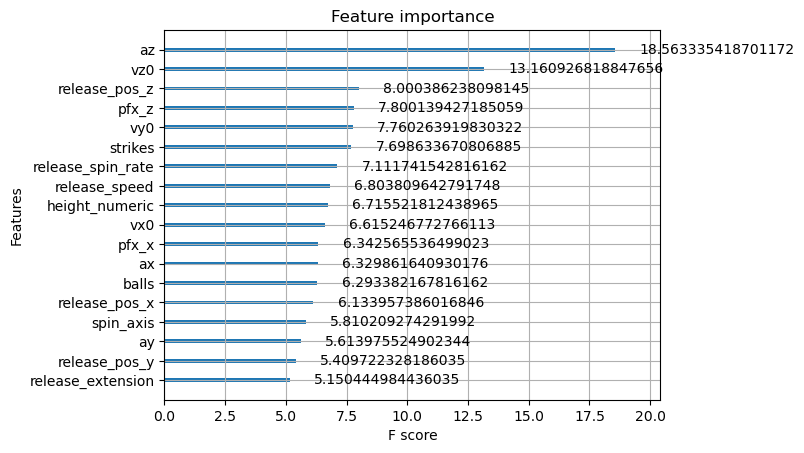

In [37]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

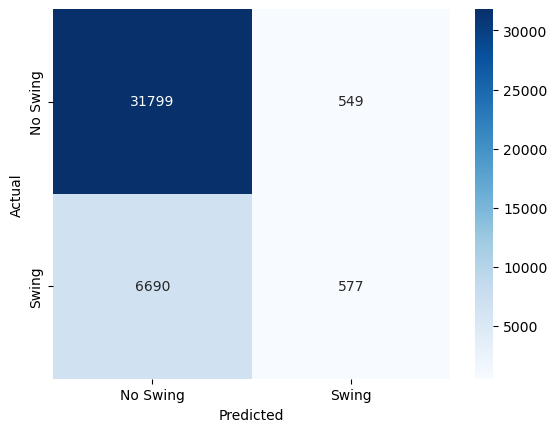

In [47]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Swing', 'Swing'], yticklabels=['No Swing', 'Swing'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Testing Data Set Predictions

In [38]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [39]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [40]:
y_pred = final_model.predict(predictions)

In [41]:
testing_identifiers['xwhiff'] = y_pred

C:\Users\clayton.thompson\AppData\Local\Temp\ipykernel_33728\1564655570.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_identifiers['xwhiff'] = y_pred


In [42]:
testing_identifiers.head()

pitch_id_raw    xwhiff
0  663364_455139_617228_4_75_10  0.220326
1  663364_455139_617228_3_75_10  0.713445
2  663364_455139_617228_2_75_10  0.104757
3  663364_455139_617228_1_75_10  0.096086
5  663364_593428_605347_4_72_10  0.362532

In [43]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/whiff_2022&3_xwhiff.csv")

# Offspeed Model 

In [44]:
off = offspeed_data.drop(['description', 'events', 'game_pk', 'game_date', 'des', 'pitch_type_dict',
                     'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 'game_type', 'home_team',
                     'away_team', 'type', 'bb_type', 'inning_topbot', 'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated',
                     'hit_distance_sc', 'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle',
                     'woba_value', 'woba_denom', 'babip_value', 'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score',
                     'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 'post_fld_score',
                      'if_fielding_alignment', 'of_fielding_alignment', 'delta_home_win_exp', 'delta_run_exp',
                      'player_name', 'hit_location', 'umpire', 'sv_id', 'spin_dir', 
                      'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 
                      'fielder_9', 'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 'pitch_number',  
                      'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
                      #removed these columns because of collinearity
                      'release_pos_z',  'effective_speed', 'release_pos_y', 'vy0', 'vx0', 'ax', 'release_extension', 'spin_axis', 'release_spin_rate',
                      'pfx_z', 'ay', 'p_throws', 'az', 'avg_velo', 'avg_hmov', 'avg_vmov', 'pfx_x', 'Unnamed: 0', 'release_pos_x', 'balls', 
                        'total_movement', 'vmov_diff', 'hmov_diff', 'velo_diff', 'vz0', 'release_speed'
                      #'release_spin_rate', 'p_throws', 'spin_axis', 'zone',
                      #removed these columns because they are not useful
                      ], axis=1).copy()

NameError: name 'offspeed_data' is not defined

In [ ]:
x2 = off.drop(['is_strike'], axis=1).copy()
y2 = off['is_strike'].copy()

In [ ]:

len(x2)

152322

In [ ]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(x2, y2, test_size=0.2, random_state=42) # split data

In [ ]:
dtrain1 = xgb.DMatrix(x_train1, label=y_train1)
dtest1 = xgb.DMatrix(x_test1, label=y_test1)

params1 = {
    'max_depth': 6,
    'eta': 0.3,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1
}

# Initial Model
model2 = xgb.train(params1, dtrain1)

In [ ]:
print(f"Unique labels in y_test1: {np.unique(y_test1)}")
print(f"Unique labels in y_train1: {np.unique(y_train1)}")


Unique labels in y_test1: [0 1]
Unique labels in y_train1: [0 1]


In [ ]:
# Generate predictions
y_pred1 = model2.predict(dtest1)
y_pred_binary1 = [1 if p >= 0.5 else 0 for p in y_pred1]

# Calculate Accuracy
accuracy = accuracy_score(y_test1, y_pred_binary1)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test1, y_pred1)
print(f"Log Loss: {logloss}")

Accuracy: 0.9336287543082226
Log Loss: 0.1557187611740709


In [ ]:
#Use an objective function to find the best parameters
def objectives(trial):
    dtrain1 = xgb.DMatrix(x_train1, label=y_train1)
    dtest1 = xgb.DMatrix(x_test1, label=y_test1)
    
    param1 = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
    }

    model2 = xgb.train(param1, dtrain1)
    y_pred1= model2.predict(dtest1)
    y_pred_binary1 = [1 if p >= 0.5 else 0 for p in y_pred1]
    accuracy = accuracy_score(y_test1, y_pred_binary1)
    return accuracy

In [ ]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objectives, n_trials=100)

[I 2023-10-28 15:09:36,123] A new study created in memory with name: no-name-d34c4ef7-2ce4-4779-a65c-e2be8cfab39c
[I 2023-10-28 15:09:36,414] Trial 0 finished with value: 0.9337928770720499 and parameters: {'max_depth': 5, 'eta': 0.24345509256003714, 'subsample': 0.6802305315736025, 'colsample_bytree': 0.9044944080938069}. Best is trial 0 with value: 0.9337928770720499.
[I 2023-10-28 15:09:36,685] Trial 1 finished with value: 0.9235844411619891 and parameters: {'max_depth': 6, 'eta': 0.04993409492472433, 'subsample': 0.7491510300973008, 'colsample_bytree': 0.7023858021577918}. Best is trial 0 with value: 0.9337928770720499.
[I 2023-10-28 15:09:36,984] Trial 2 finished with value: 0.9369440341375349 and parameters: {'max_depth': 9, 'eta': 0.17788292482168488, 'subsample': 0.7205857498903679, 'colsample_bytree': 0.706986723560932}. Best is trial 2 with value: 0.9369440341375349.
[I 2023-10-28 15:09:37,230] Trial 3 finished with value: 0.931068439192516 and parameters: {'max_depth': 3, 'e

In [ ]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.9411784014442803
Best hyperparameters: {'max_depth': 9, 'eta': 0.29086504518827216, 'subsample': 0.609950626814756, 'colsample_bytree': 0.8105463899683927}


In [ ]:
# Ensure trial is the best trial from the study
best_trial1 = study.best_trial

# Set parameters
final_parameters1 = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
}

# Prepare the data
dtrain = xgb.DMatrix(x_train1, label=y_train1)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model1 = xgb.train(final_parameters1, dtrain1)

In [ ]:
# Generate predictions
y_pred1 = final_model1.predict(dtest1)
y_pred_binary1 = [1 if p >= 0.5 else 0 for p in y_pred1]

# Calculate Accuracy
accuracy = accuracy_score(y_test1, y_pred_binary1)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test1, y_pred1)
print(f"Log Loss: {logloss}")

Accuracy: 0.9393730510421795
Log Loss: 0.15511361543363011


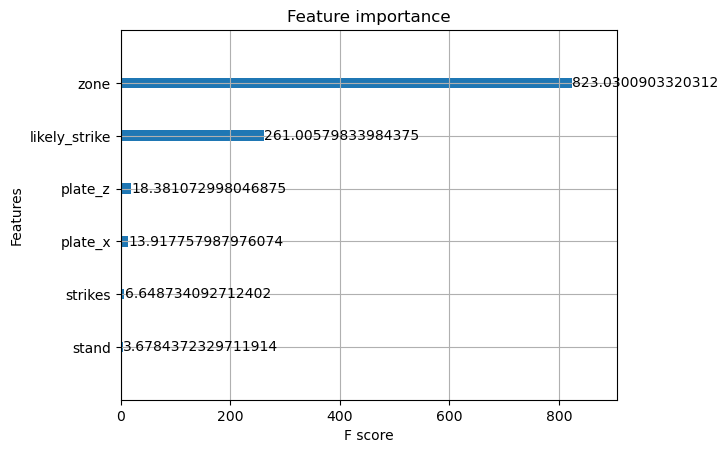

In [ ]:
importance1 = final_model1.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance1)
plt.show()

# Predict 2023 data

In [ ]:
heaters_2023 = df[df['pitch_type_dict'] == 1].copy()
offspeed_2023 = df[df['pitch_type_dict'] == 2].copy()

In [ ]:
# Select only the features you used for training the models
features = ['zone', 'stand', 'strikes', 'plate_x', 'plate_z',  'likely_strike']  # Replace these with your actual features

# Convert DataFrame to DMatrix
dmatrix_heaters_2023 = xgb.DMatrix(heaters_2023[features])
dmatrix_offspeed_2023 = xgb.DMatrix(offspeed_2023[features])

# Make predictions
heaters_2023['prediction'] = final_model.predict(dmatrix_heaters_2023)
offspeed_2023['prediction'] = final_model1.predict(dmatrix_offspeed_2023)

In [ ]:
complete = pd.concat([heaters_2023, offspeed_2023], axis=0)
complete['probability_added'] = 0

In [ ]:
# Correct the conditions and assignment for 'probability_added'
condition1 = (complete['likely_strike'] == 0) & (complete['is_strike'] == 1)
complete.loc[condition1, 'probability_added'] = 1 - complete.loc[condition1, 'prediction']

condition2 = (complete['likely_strike'] == 1) & (complete['is_strike'] == 0)
complete.loc[condition2, 'probability_added'] = -0 + complete.loc[condition2, 'prediction']


In [ ]:
len(condition2)

362561

In [ ]:
players = pd.read_csv('players_query.csv')

In [ ]:
completed = complete.merge(players, left_on='fielder_2', right_on='mlb_id', how='left')

In [ ]:
strike_probs = completed.loc[completed['probability_added'] != 0].copy()

In [ ]:
strike_probs.head()

half_inning  Unnamed: 1 pitch_type   game_date  release_speed  \
1   716352_1_Bot           8         SI  2023-10-01           93.5   
11  716352_2_Bot          46         FF  2023-10-01           93.5   
28  716352_4_Bot         111         FF  2023-10-01           92.9   
37  716352_4_Bot          87         SI  2023-10-01           92.2   
39  716352_4_Top         115         SI  2023-10-01           90.1   

    release_pos_x  release_pos_z    player_name  batter  pitcher  ...  \
1           -2.60           5.68  King, Michael  677951   650633  ...   
11          -2.82           5.71  King, Michael  669004   650633  ...   
28          -2.66           5.89  King, Michael  669004   650633  ...   
37          -2.76           5.67  King, Michael  672580   650633  ...   
39          -1.27           6.14  Greinke, Zack  643396   425844  ...   

     deltaRE is_strike  pitch_type_dict  likely_strike  prediction  \
1  -0.028510         1              1.0              0    0.781290   
11 -0.038179         1              1.0              0    0.495411   
28 -0.038179         1              1.0              0    0.782323   
37 -0.111258         1              1.0              0    0.813712   
39 -0.043952         1              1.0              0    0.584764   

    probability_added  Unnamed: 0  mlb_id        mlb_name  team_name  
1            0.218710        4412  669224    Austin Wells    yankees  
11           0.504589        4412  669224    Austin Wells    yankees  
28           0.217677        4412  669224    Austin Wells    yankees  
37           0.186288        4412  669224    Austin Wells    yankees  
39           0.415236        1898  521692  Salvador Perez     royals  

[5 rows x 113 columns]

### Catcher Evaluation

In [ ]:
# Set the display options to show all rows
pd.set_option('display.max_rows', None)

result = strike_probs.groupby('mlb_name').agg({'probability_added': 'sum'}).sort_values(by='probability_added', ascending=False)
print(result)

# Reset the display options to default
pd.reset_option('display.max_rows')

                       probability_added
mlb_name                                
Jonah Heim                    369.409200
William Contreras             357.175406
Francisco Alvarez             343.816237
Cal Raleigh                   325.117514
Patrick Bailey                322.223661
J.T. Realmuto                 306.765881
Adley Rutschman               304.310884
Keibert Ruiz                  300.757002
Elias Diaz                    291.464170
Will Smith                    289.637044
Shea Langeliers               285.841658
Sean Murphy                   285.280986
Alejandro Kirk                274.881437
Jake Rogers                   270.437452
Connor Wong                   263.304882
Nick Fortes                   261.444752
Austin Hedges                 252.923828
Yasmani Grandal               249.119006
Christian Vazquez             245.539206
Willson Contreras             243.042565
Gabriel Moreno                240.534485
Kyle Higashioka               236.375578
Martin Maldonado

In [ ]:
strike_probs['framing_runs'] = (strike_probs['deltaRE'] * -1) * strike_probs['probability_added'].abs()

## Initial Situational Framing Runs Leaderboard

In [ ]:
# Set the display options to show all rows
pd.set_option('display.max_rows', None)

result = strike_probs.groupby('mlb_name').agg({'framing_runs': 'sum'}).sort_values(by='framing_runs', ascending=False)
print(result)

# Reset the display options to default
pd.reset_option('display.max_rows')

                       framing_runs
mlb_name                           
Jonah Heim                28.298897
William Contreras         27.314465
Francisco Alvarez         26.280338
Cal Raleigh               24.428360
J.T. Realmuto             23.217440
Will Smith                23.151280
Adley Rutschman           22.850475
Austin Hedges             22.659703
Shea Langeliers           22.651095
Elias Diaz                22.566548
Patrick Bailey            22.507789
Keibert Ruiz              22.178750
Alejandro Kirk            21.671238
Kyle Higashioka           20.388670
Nick Fortes               20.349055
Willson Contreras         20.085103
Sean Murphy               20.071047
Connor Wong               20.061680
Jake Rogers               19.988771
Christian Vazquez         19.943172
Martin Maldonado          19.101232
Yasmani Grandal           18.546439
Gabriel Moreno            18.169561
Yan Gomes                 16.646696
Gary Sanchez              15.508716
Salvador Perez            15

In [ ]:
strike_probs.drop(['Unnamed: 0', 'Unnamed: 1'], axis=1, inplace=True)

In [ ]:
strike_probs.to_csv('strike_probs.csv')

### Get out meaningless strikes that have nothing to do with framing

In [ ]:
likely = strike_probs.query('(prediction < .85)')

In [ ]:
# Set the display options to show all rows
pd.set_option('display.max_rows', None)

result = likely.groupby('mlb_name').agg({'framing_runs': 'sum'}).sort_values(by='framing_runs', ascending=False)
print(result)

                       framing_runs
mlb_name                           
Jonah Heim                27.265644
William Contreras         26.675339
Francisco Alvarez         25.509967
Cal Raleigh               23.705518
Will Smith                22.504385
J.T. Realmuto             22.293919
Adley Rutschman           22.158913
Austin Hedges             22.132027
Patrick Bailey            22.033697
Shea Langeliers           21.670207
Elias Diaz                21.585984
Keibert Ruiz              21.388849
Alejandro Kirk            20.937702
Kyle Higashioka           19.911051
Nick Fortes               19.775314
Sean Murphy               19.402830
Willson Contreras         19.372176
Christian Vazquez         19.285147
Connor Wong               19.231894
Jake Rogers               19.224211
Martin Maldonado          18.579309
Yasmani Grandal           17.983997
Gabriel Moreno            17.519849
Yan Gomes                 16.075565
Gary Sanchez              14.937981
Salvador Perez            14

###  I think that this is the best leaderboard. Filters out the gimme pitches